In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from google.colab import files
#files.upload()

# CLASE PARA PROYECTO CAJAMAR

In [2]:
!pip install skforecast

     |████████████████████████████████| 87 kB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 15.6 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.0
    Uninstalling tqdm-4.63.0:
      Successfully uninstalled tqdm-4.63.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
# Librerias

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from datetime import date
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
import model_selection_no_print
#from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import math
from joblib import dump, load
import pickle


class Contador(object):
    def __init__(self, datos_contador, ID, umbral, Modelo_Semanal):
        self.datos_contador = datos_contador
        self.ID = ID
        self.lista_contadores_defectuosos = [111, 658, 2460, 2464, 2466, 2481, 2483, 2489]
        self.umbral = umbral
        self.Modelo_Semanal = Modelo_Semanal
        self.Preprocesado()
        self.SinDatos = False  # NO TIENE DATOS DATASET VACIO
        #self.outlier = False
        self.dias = 0
        self.RMSE_Train = 0
        self.RMSE_Test = 0
        self.datos_test = pd.DataFrame()
        self.datos_test_semanal = pd.DataFrame()
        self.Mejor_Parametro = {}
        self.Mejor_Lag = 14 
        self.DiffConsumo = 0
        
        # {'ID','Dia_1':0,'Dia_2':0,'Dia_3':0,'Dia_4':0,'Dia_5':0,'Dia_6':0','Dia_7':0,'Semana_1':0,'Semana_2':0}
        self.Predicciones = [self.ID,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        
        if not datos_contador.empty:
            # CALCULO LECTURA CONTADOR Y CONSUMO JUNTANDO DECIMALES
            #
            #CALCULO DE LA LECTURA Y CONSUMO AGRUPANDO PARTE ENTERA Y DECIMAL
            self.datos_contador['LECTURA'] = self.datos_contador['READINGINTEGER'] + (self.datos_contador['READINGTHOUSANDTH'] / 100)
            self.datos_contador['CONSUMO'] = self.datos_contador['DELTAINTEGER'] + (self.datos_contador['DELTATHOUSANDTH'] / 100)
            
            #NORMALIZACIÓN A DISTRIBUCIÓN NORMAL(0,1) DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_NORMA'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].mean())/self.datos_contador['LECTURA'].std()
            self.datos_contador['CONSUMO_NORMA'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].mean())/self.datos_contador['CONSUMO'].std()
            
            # ELIMINANDO LOS OUTLIERS "DESTACADOS" DE LOS CONTADORES MARCADOS (DEJO COMENTADA UNA OPCIÓN PARA HACERLO TAMBIÉN CON EL RESTO DE CONTADORES)
            if self.ID in self.lista_contadores_defectuosos:
              if self.ID in [111, 658, 2560]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>6)[0]], inplace=True)
              elif self.ID in [2466, 2483, 2489]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>5)[0]], inplace=True)
              elif self.ID in [2464, 2481]:
                self.datos_contador.drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA'])>10)[0]], inplace=True)
#           else:
#             self.datos_contador['CONSUMO'].drop(self.datos_contador.index[np.where(np.abs(self.datos_contador['CONSUMO_NORMA']>8)[0]], inplace=True)
            
            #FIJACIÓN DEL ÍNDICE TEMPORAL DE LA SERIE
            self.datos_contador = self.datos_contador.set_index('SAMPLETIME')

            #NORMALIZACIÓN MIN MAX DE LECTURA Y CONSUMO
            self.datos_contador['LECTURA_MINMAX'] = (self.datos_contador['LECTURA']-self.datos_contador['LECTURA'].min())/(self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min())
            self.datos_contador['CONSUMO_MINMAX'] = (self.datos_contador['CONSUMO']-self.datos_contador['CONSUMO'].min())/(self.datos_contador['CONSUMO'].max()-self.datos_contador['CONSUMO'].min())
            
            #CÁLCULO DE LA DIFERENCIA DE LECTURAS EN CADA PASO DE TIEMPO PARA OBTENER EL CONSUMO A PARTIR DE LA LECTURA
            self.datos_contador['CONSUMO_CAL'] = self.datos_contador['LECTURA'].diff(1).fillna(0)
            
            #APLICACIÓN DE LA FUNCIÓN PARA VERIFICAR SI EL CONSUMO ES CORRECTO
            self.__Comprobar_Consumo()

            # CÁLCULO DE LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA DE VALOR MÁXIMO Y MÍNIMO DE LA LECTURA DEL CONTADOR
            self.suma_consumo = self.datos_contador['CONSUMO'].sum()
            self.diferencia_lectura = self.datos_contador['LECTURA'].max()-self.datos_contador['LECTURA'].min()

            #BOOLEANO QUE DETERMINA SI LA SUMA DE LOS CONSUMOS Y LA DIFERENCIA MIN MAX DEL CONTADOR SON IGUALES
            if self.suma_consumo == self.diferencia_lectura:
              self.buenas_lecturas = True
            else:
              self.buenas_lecturas = False

            # CONSUMO POR DIAS
            # RESAMPLE
            
            self.datos_consumo = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1D', closed='left', label ='left').sum())

            # NORMALIZACIÓN NORMAL STÁNDARD
            self.datos_consumo['CONSUMO_NORM'] = (self.datos_consumo['CONSUMO'] - self.datos_consumo['CONSUMO'].mean()) / self.datos_consumo['CONSUMO'].std()
            self.datos_consumo['CONSUMO_NORM'].fillna(0, inplace=True)
            # NORMALIZACIÓN MIN MAX
            self.datos_consumo['CONSUMO_MIN_MAX'] = (self.datos_consumo['CONSUMO']-self.datos_consumo['CONSUMO'].min())/(self.datos_consumo['CONSUMO'].max()-self.datos_consumo['CONSUMO'].min())
            self.datos_consumo['CONSUMO_MIN_MAX'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=3
            self.datos_consumo['CONSUMO_MEDMOV3'] = self.datos_consumo['CONSUMO'].rolling(3).mean()
            self.datos_consumo['CONSUMO_MEDMOV3'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=4
            self.datos_consumo['CONSUMO_MEDMOV4'] = self.datos_consumo['CONSUMO'].rolling(4).mean()
            self.datos_consumo['CONSUMO_MEDMOV4'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=5
            self.datos_consumo['CONSUMO_MEDMOV5'] = self.datos_consumo['CONSUMO'].rolling(5).mean()
            self.datos_consumo['CONSUMO_MEDMOV5'].fillna(0,inplace=True)
            # MEDIAS MÓVILES N=6
            self.datos_consumo['CONSUMO_MEDMOV6'] = self.datos_consumo['CONSUMO'].rolling(6).mean()
            self.datos_consumo['CONSUMO_MEDMOV6'].fillna(0,inplace=True)


            # MEDIAS MÓVILES N=7
            self.datos_consumo['CONSUMO_MEDMOV7'] = self.datos_consumo['CONSUMO'].rolling(7).mean()
            self.datos_consumo['CONSUMO_MEDMOV7'].fillna(0,inplace=True)   

            self.media = self.datos_consumo['CONSUMO'][-42:-14]
            print(self.media)
            self.media = self.media.mean()
            print(self.media)
            self.datos_consumo['CONSUMO_MEAN'] = self.media
            print(self.datos_consumo['CONSUMO_MEAN'])

            #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
              #print(self.datos_consumo['CONSUMO_MEAN'])
            #self.datos_consumo['CONSUMO_MEAN'].fillna(0,inplace=True)  

            #COGER SÓLO SEMANAS COMPLETAS
            self.datos_consumo_semanal = pd.DataFrame(self.datos_contador['CONSUMO'].resample(rule='1W', closed='left', label ='left',offset='-36h').sum())
            
            # ESTADISTICAS
            self.dias = len(self.datos_consumo.index)
            self.semanas = len(self.datos_consumo_semanal.index)
            #self.datos_consumo['Cuenta'] = self.datos_contador.groupby([self.datos_contador.index.year,self.datos_contador.index.month, self.datos_contador.index.day]).agg({'CONSUMO':'count'}).values
            
            self.fecha_inicio_contador= self.datos_consumo.index[0]
            self.fecha_fin_contador= self.datos_consumo.index[-1]
            
        else:
            self.datos_consumo = pd.DataFrame()
            self.SinDatos = True
            self.fecha_fin_contador = None

        # GENERACION DEL MODELO
        self.modelo()
    
    def __Comprobar_Consumo(self):
        # COMPRUEBA SI HAY MAS DE 1 LITRO DE DIFERENCIA ENTRE EL CONSUMO EL CALCULO DEL CONSUMO CON LA LECTURA DEL CONTADOR
        # EL VALOR ACUMULADO SE GUARDA EN DiffConsumo
        if not(self.datos_contador['CONSUMO_CAL'].equals(self.datos_contador['CONSUMO'])):
            for index, row in self.datos_contador.iterrows():
                if row['CONSUMO_CAL'] != row['CONSUMO'] and (np.absolute(row['CONSUMO_CAL'] - row['CONSUMO']) > 1):
                    #print(row['CONSUMO_CAL'] - row['CONSUMO'])
                    #print(index,row)
                    self.DiffConsumo += np.absolute(row['CONSUMO_CAL'] - row['CONSUMO'])
        
    def __Convertir_fecha(self, serie):
        fechas = []
        for año, mes, dia in serie.index:
            fechas.append(date(año,mes,dia))
        return fechas
    
    def Preprocesado(self):
        # SAMPLETIME READINGINTEGER	READINGTHOUSANDTH	DELTAINTEGER	DELTATHOUSANDTH
        # VALORES  NULOS 
        # VALORES ENTEROS INTERPOLAMOS
        

        self.datos_contador['READINGINTEGER'].interpolate(inplace=True)
        self.datos_contador['DELTAINTEGER'].interpolate(inplace=True)
        
        # VALORES DECIMALES SUSTITUIMOS POR CERO
        self.datos_contador['READINGTHOUSANDTH'].fillna(0,inplace=True)
        self.datos_contador['DELTATHOUSANDTH'].fillna(0,inplace=True)
        
        # ELIMINAR VALORES NEGATIVOS
        indices = self.datos_contador[self.datos_contador['READINGINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)
        indices = self.datos_contador[self.datos_contador['DELTAINTEGER'] < 0].index
        self.datos_contador.drop(indices,inplace=True)


    def modelo(self):
        # DECISION DEL MODELO A TOMAR EN FUNCION DE LA ESTADISTICAS
        # CARGA DEL MODELO
        # PACO
        self.model = None
        if self.dias > self.umbral: 
            if self.fecha_fin_contador == date(2020,1,31):
                # RandomForestRegressor Diario
                self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=14)
                # RandomForestRegressor Semanal Paco
                self.model_Semanal = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=4)
                
            else:
                self.model = self.datos_consumo['CONSUMO'].mean()
        else:
            if self.dias > 0: 
                #if (self.fecha_fin_contador > date(2020,1,17)).bool() :    # HACE MEDIA SI TENEMOS DATOS EN LOS ULTIMOS 14 DIAS
                self.model = self.datos_consumo['CONSUMO'].mean()
                #else:
                #self.model = 0
            else:
                self.model = 0

    def Juntar_Datos(self):
        # REHACE EL MODELO CON LOS MEJORES PARAMETROS
        # JUNTA TODO EN datos_consumo
        # {'max_depth': 3, 'n_estimators': 200}        
        #del self.model
        #if self.dias > umbral:
            #self.model = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=max(self.Mejor_Lag), 
            #                                max_depth=self.Mejor_Parametro['max_depth'],n_estimators=self.Mejor_Parametro['n_estimators'])

        self.datos_consumo = pd.concat([self.datos_consumo,self.datos_test])
        self.datos_test =pd.DataFrame()
        
    

class CajaMar_Water(object):
    def __init__(self,Ruta_Datos,Fecha_Inicio=date(2019,2,1),Fecha_Fin=date(2020,1,31),umbral_modelo=100, Modelo_Semanal=False):
        self.Ruta_Datos = Ruta_Datos
        self.Fecha_Inicio = Fecha_Inicio
        self.Fecha_Fin = Fecha_Fin
        self.umbral_modelo = umbral_modelo
        self.Modelo_Semanal = Modelo_Semanal    # True usamos dos modelos uno para dias y otro para semanas
        self.datos = pd.DataFrame()
        self.contadores = []
        self.dias_test = 14     # DIAS QUE SE RESERVAN PARA TEST EMPEZANDO POR LA FECHA MAS RECIENTE
        self.semanas_test = 2   # SEMANAS QUE SE RESERVAN PARA TEST
        self.Cargar_Datos()
        self.RMSE_Test_Promedio=0
        self.RMSE_Test_Suma=0
        self.RMSE_Todos = []
        self.RMSE_Todos_IDs = []
        
    

    def Cargar_Datos(self):
        print('CARGANDO DATOS.....')
        self.datos = pd.read_csv(self.Ruta_Datos,sep='|',parse_dates=['SAMPLETIME'],infer_datetime_format=True,encoding='utf-8')
        self.datos.sort_values(by=['ID','SAMPLETIME'],inplace=True)
 
        # GENERANDO CONTADORES
        print('GENERANDO CONTADORES.....')
        for ID in tqdm(pd.unique(self.datos['ID'])):
            # ALMACENAMOS ID DE CONTADOR Y BORRAMOS LA COLUMNA
            self.contadores.append(Contador(self.datos[self.datos['ID']==ID].drop('ID',axis=1),ID,self.umbral_modelo,self.Modelo_Semanal))

        print('PROCESO DE CARGA FINALIZADO')
    
    def PartirDatos(self):
        # Separar datos de entrenamiento y test / validacion (dias=0 no hace validacion)
        if self.dias_test > 0:     
            for contador in tqdm(self.contadores):
                if contador.SinDatos == False:      # COMPROBAMOS QUE HAY ALGUN REGISTRO
                    #if (contador.fecha_fin_contador==self.Fecha_Fin):
                    if contador.dias > self.dias_test + 1:    # COMPROBAMOS QUE HAY SUFICIENTES DATOS PARA HACER PARTICION
                        contador.datos_test = contador.datos_consumo.tail(self.dias_test)
                        contador.datos_consumo = contador.datos_consumo[0:-self.dias_test]
                    if contador.semanas > self.semanas_test + 1:
                        contador.datos_test_semanal = contador.datos_consumo_semanal.tail(self.semanas_test)
                        contador.datos_consumo_semanal = contador.datos_consumo_semanal[0:-self.semanas_test]


    
    def Grid_Search(self,ID,steps):
        # Hiperparámetros del regresor
        param_grid = {'n_estimators': [100],
              'max_depth': [5]}

        # Lags utilizados como predictores
        lags_grid = [14]

        resultados_grid = model_selection_no_print.grid_search_forecaster(
                                forecaster         = self.contadores[ID].model,
                                y                  = self.contadores[ID].datos_consumo['CONSUMO'],
                                param_grid         = param_grid,
                                lags_grid          = lags_grid,
                                steps              = steps,
                                refit              = True,
                                metric             = 'mean_squared_error',
                                initial_train_size = len(self.contadores[ID].datos_consumo) - 14,
                                return_best        = True,
                                verbose            = False)
        self.contadores[ID].RMSE_Train = math.sqrt(resultados_grid['metric'].head(1))
        self.contadores[ID].Mejor_Parametro = list(resultados_grid['params'])[0]
        self.contadores[ID].Mejor_Lag = max(list(resultados_grid['lags'].head(1))[0])
        

    def Entrenamiento(self,Grid=False):
        # Entrenamiento de los modelos en self.contadores(lista) 
        # iterar lista y llamar a self.contadores[iter].modelo.train
        # Rellena la variable self.contadores.Predicciones
        indexC = 0
        for contador in tqdm(self.contadores):
            if isinstance(contador.model,ForecasterAutoreg):    # COMPROBAMOS QUE ES UN MODELO
                if Grid:
                    self.Grid_Search(indexC,self.dias_test)
                    #contador.Juntar_Datos() #  JUNTA LOS DATOS PARA LUEGO HACER PREDICT
                
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #if contador.ID not in Lista_Normal_better:
                #print(contador.ID)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV6'])
                #else:

                contador.model.fit(y=contador.datos_consumo['CONSUMO_MEAN'])
                predict = contador.model.predict(steps=self.dias_test)
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_NORM'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MIN_MAX'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV3'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV4'])
                #contador.model.fit(y=contador.datos_consumo['CONSUMO_MEDMOV5'])

                if self.Modelo_Semanal:
                    contador.model_Semanal.fit(y=contador.datos_consumo_semanal['CONSUMO'])
                    predict_semanal = contador.model_Semanal.predict(steps=self.semanas_test)
                # HAY QUE TENER EN CUENTA CUANDO TERMINAN LOS DATOS
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test) * contador.datos_consumo['CONSUMO'].std() + contador.datos_consumo['CONSUMO'].mean()
                #predict = contador.model.predict(steps=self.dias_test)*(contador.datos_consumo['CONSUMO'].max()-contador.datos_consumo['CONSUMO'].min())+contador.datos_consumo['CONSUMO'].min()
                #predict = contador.model.predict(steps=self.dias_test)
                index = 1
                for predict_dia in predict[0:14]:    # GUARDA 14 DIAS PREDICCION
                    contador.Predicciones[index] = predict_dia
                    index += 1
                if self.Modelo_Semanal:
                    contador.Predicciones[15]=predict_semanal[0]              # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict_semanal[1]              # GUARDA SEMANA2 PREDICCION
                else:
                    contador.Predicciones[15]=predict[0:7].sum()     # GUARDA SEMANA1 PREDICCION
                    contador.Predicciones[16]=predict[7:14].sum()    # GUARDA SEMANA2 PREDICCION
            else:
              for index in range(1,15):
                    contador.Predicciones[index] = contador.model  # GUARDAMOS MEDIA EN LOS 7 DIAS
              contador.Predicciones[15]=contador.model*7     # GUARDAMOS MEDIA SEMANA1
              contador.Predicciones[16]=contador.model*7     # GUARDAMOS MEDIA SEMANA2
            
            indexC += 1
                  

    def Calculo_RMSE(self):
        # Calculo rmse utlizando datos de test
        for contador in tqdm(self.contadores):
            #if contador.dias > 180 and len(contador.datos_test) == self.dias_test:  # VER LIMITE NO DEPENDE DE LA CLASE CONTADOR
            if len(contador.datos_test) == self.dias_test and len(contador.datos_test_semanal) == self.semanas_test:
                if self.Modelo_Semanal:
                    media_RMSE_semanal=math.sqrt(mean_squared_error(contador.datos_test_semanal['CONSUMO'] , [contador.Predicciones[15], contador.Predicciones[16]]))
                else:
                    media_RMSE_semanal=math.sqrt(mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[15], contador.Predicciones[16]]))
                
                contador.RMSE_Test = 0.5*math.sqrt(mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8]))+0.5*media_RMSE_semanal
                # Sin raiz
                #media_RMSE_semanal=mean_squared_error([contador.datos_test['CONSUMO'][0:7].sum(), contador.datos_test['CONSUMO'][7:14].sum()] , [contador.Predicciones[8], contador.Predicciones[9]])
                #contador.RMSE_Test = 0.5+mean_squared_error(contador.datos_test['CONSUMO'][0:7],contador.Predicciones[1:8])+0.5*media_RMSE_semanal
                self.RMSE_Todos.append(contador.RMSE_Test)
                self.RMSE_Todos_IDs.append(contador.ID)

        self.RMSE_Test_Suma = sum(self.RMSE_Todos)
        if self.RMSE_Test_Suma != 0:
            self.RMSE_Test_Promedio = self.RMSE_Test_Suma / len(self.RMSE_Todos)
        else:
            print('ERROR NO HAY CALCULO DE RMSE')
        
    
    def GenerarResultados(self,equipo='Team2021IA3',numeral=1):
        # Mediante los datos predicciones generamos txt con el formato del datathon
        # Separando campos con “|”, el valor de la predicción en litros, y los decimales con “.” 2 decimales
        # Fichero: "Cajamar_Universitat de València (UV)_Team2021IA3_numeral.txt"
        
        columnas = ['ID','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7','Semana_1','Semana_2']
        datos = []

        for contador in tqdm(self.contadores):
            datos.append(contador.Predicciones)
        
        print('TAMAÑO DE LOS DATOS: ', len(datos), 'x' ,len(datos[0]))
        
        dataset = pd.DataFrame(datos,columns=columnas)
        dataset.to_csv('Cajamar_Universitat de València (UV)_' + equipo + '_' + str(numeral) + '.txt',header=False ,sep='|' ,index=False ,decimal='.' ,float_format='%.2f')
         
    def GraficasEstadisticas(self,contador=0,Test=True):
        # GRÁFICAS DE CONTADORES INDIVIDUALES CON TEST Y PREDICCIONES
        if Test:
            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_test['CONSUMO'].plot(ax=ax, label='Test', linewidth=1)
            pd.DataFrame(self.contadores[contador].Predicciones[1:15],index=self.contadores[contador].datos_test['CONSUMO'].index[0:14],columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Test) + ' Contador: ' + str(contador))
            ax.legend();
        else:
            base = date(2020,2,1)
            index = [base + timedelta(days=x) for x in range(7)]
            index = pd.DataFrame(index)
            index.insert(1, 'SAMPLETIME', [base + timedelta(days=x) for x in range(7)], True)
            index['SAMPLETIME']=pd.to_datetime(index['SAMPLETIME'], format='%Y-%m-%d')
            index=index.set_index('SAMPLETIME')
            index_puro=index.drop([0],axis=1)
            index_puro['Predicción']=Proyecto.contadores[contador].Predicciones[1:8]
            #df_final=pd.DataFrame(index_puro.insert(1, 'Predicción', pd.Series(self.contadores[contador].Predicciones[1:8]), True))

            fig, ax = plt.subplots(figsize=(10, 4))
            self.contadores[contador].datos_consumo['CONSUMO'].plot(ax=ax, label='Consumo', linewidth=1)
            index_puro.plot(ax=ax, label='Predicción', linewidth=1)
            #pd.DataFrame(self.contadores[contador].Predicciones[1:8],index=index_puro,columns=['Predicción']).plot(ax=ax, label='Prediccion', linewidth=1)
            ax.set_title('Consumo Agua. RMSE: ' + str(self.contadores[contador].RMSE_Train) + ' Contador: ' + str(contador))
            ax.legend();

    def Guardar_Modelos(self,Ruta='./modelos/Modelo_ID_'):

        print('GUARDANDO MODELOS.....')
        for contador in tqdm(self.contadores):
            dump(contador.model,Ruta + str(contador.ID))

        

In [6]:
#Proyecto = CajaMar_Water('Modelar_UH2022.txt')
path="/content/drive/MyDrive/Cajamar/"
#Proyecto = CajaMar_Water(path+'Modelar_UH2022_10_Contadores.txt')
Proyecto = CajaMar_Water(path+'Modelar_UH2022.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_10_Contadores.txt', Modelo_Semanal=False)
#Proyecto = CajaMar_Water('Modelar_UH2022_3_Contadores.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2735.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2561.txt')
#Proyecto = CajaMar_Water('Modelar_UH2022_Contador_2562.txt')

CARGANDO DATOS.....
GENERANDO CONTADORES.....


  0%|          | 1/2747 [00:00<23:05,  1.98it/s]

SAMPLETIME
2019-12-21    232.0
2019-12-22    182.0
2019-12-23    354.0
2019-12-24    400.0
2019-12-25    274.0
2019-12-26    258.0
2019-12-27    352.0
2019-12-28    347.0
2019-12-29    310.0
2019-12-30    338.0
2019-12-31    327.0
2020-01-01    267.0
2020-01-02    252.0
2020-01-03    208.0
2020-01-04    427.0
2020-01-05    202.0
2020-01-06    386.0
2020-01-07    342.0
2020-01-08    367.0
2020-01-09    238.0
2020-01-10    225.0
2020-01-11    157.0
2020-01-12    282.0
2020-01-13    115.0
2020-01-14    452.0
2020-01-15    210.0
2020-01-16    303.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
288.75
SAMPLETIME
2019-02-01    288.75
2019-02-02    288.75
2019-02-03    288.75
2019-02-04    288.75
2019-02-05    288.75
               ...  
2020-01-27    288.75
2020-01-28    288.75
2020-01-29    288.75
2020-01-30    288.75
2020-01-31    288.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 2/2747 [00:01<23:44,  1.93it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     3.10
2019-12-23     3.00
2019-12-24     3.00
2019-12-25    25.04
2019-12-26     4.16
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     8.10
2019-12-30    13.00
2019-12-31     7.00
2020-01-01     3.00
2020-01-02     0.00
2020-01-03     3.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.30
2020-01-07     2.99
2020-01-08     3.06
2020-01-09    84.00
2020-01-10    46.00
2020-01-11     3.00
2020-01-12     3.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.30
2020-01-16     4.05
2020-01-17     1.00
Freq: D, Name: CONSUMO, dtype: float64
7.860714285714287
SAMPLETIME
2019-02-01    7.860714
2019-02-02    7.860714
2019-02-03    7.860714
2019-02-04    7.860714
2019-02-05    7.860714
                ...   
2020-01-27    7.860714
2020-01-28    7.860714
2020-01-29    7.860714
2020-01-30    7.860714
2020-01-31    7.860714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 3/2747 [00:01<23:31,  1.94it/s]

SAMPLETIME
2019-12-21    32.0
2019-12-22    41.0
2019-12-23    26.0
2019-12-24    35.0
2019-12-25    43.0
2019-12-26    32.0
2019-12-27    28.0
2019-12-28    29.0
2019-12-29    44.0
2019-12-30    34.0
2019-12-31    36.0
2020-01-01    28.0
2020-01-02    35.0
2020-01-03    33.0
2020-01-04    17.0
2020-01-05    26.0
2020-01-06    35.0
2020-01-07    33.1
2020-01-08    30.0
2020-01-09    47.0
2020-01-10    21.0
2020-01-11    41.0
2020-01-12    35.0
2020-01-13    30.0
2020-01-14    52.0
2020-01-15    40.0
2020-01-16    34.0
2020-01-17    36.0
Freq: D, Name: CONSUMO, dtype: float64
34.03928571428572
SAMPLETIME
2019-02-01    34.039286
2019-02-02    34.039286
2019-02-03    34.039286
2019-02-04    34.039286
2019-02-05    34.039286
                ...    
2020-01-27    34.039286
2020-01-28    34.039286
2020-01-29    34.039286
2020-01-30    34.039286
2020-01-31    34.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 4/2747 [00:02<25:01,  1.83it/s]

SAMPLETIME
2019-12-21    527.0
2019-12-22    349.0
2019-12-23    318.0
2019-12-24    551.0
2019-12-25    534.0
2019-12-26    317.0
2019-12-27    397.0
2019-12-28    513.0
2019-12-29    389.1
2019-12-30    345.0
2019-12-31    411.0
2020-01-01    452.0
2020-01-02    356.0
2020-01-03    415.0
2020-01-04    395.0
2020-01-05    368.0
2020-01-06    382.0
2020-01-07    366.0
2020-01-08    347.0
2020-01-09    348.0
2020-01-10    472.0
2020-01-11    563.0
2020-01-12    405.0
2020-01-13    303.4
2020-01-14    310.0
2020-01-15    386.0
2020-01-16    368.0
2020-01-17    409.0
Freq: D, Name: CONSUMO, dtype: float64
403.44642857142856
SAMPLETIME
2019-02-01    403.446429
2019-02-02    403.446429
2019-02-03    403.446429
2019-02-04    403.446429
2019-02-05    403.446429
                 ...    
2020-01-27    403.446429
2020-01-28    403.446429
2020-01-29    403.446429
2020-01-30    403.446429
2020-01-31    403.446429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 5/2747 [00:02<25:16,  1.81it/s]

SAMPLETIME
2019-12-21    285.00
2019-12-22    278.60
2019-12-23    402.25
2019-12-24    200.40
2019-12-25    218.00
2019-12-26    267.10
2019-12-27    420.50
2019-12-28    430.99
2019-12-29    357.30
2019-12-30    300.10
2019-12-31    209.52
2020-01-01    196.12
2020-01-02    466.36
2020-01-03    401.10
2020-01-04    276.96
2020-01-05    409.00
2020-01-06    172.30
2020-01-07    263.30
2020-01-08    361.42
2020-01-09    219.06
2020-01-10    221.01
2020-01-11    325.10
2020-01-12    191.52
2020-01-13    227.16
2020-01-14    272.04
2020-01-15    221.04
2020-01-16    203.14
2020-01-17    295.00
Freq: D, Name: CONSUMO, dtype: float64
288.9782142857144
SAMPLETIME
2019-02-01    288.978214
2019-02-02    288.978214
2019-02-03    288.978214
2019-02-04    288.978214
2019-02-05    288.978214
                 ...    
2020-01-27    288.978214
2020-01-28    288.978214
2020-01-29    288.978214
2020-01-30    288.978214
2020-01-31    288.978214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 6/2747 [00:03<24:53,  1.84it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 7/2747 [00:03<24:40,  1.85it/s]

SAMPLETIME
2019-12-21    212.00
2019-12-22     93.00
2019-12-23    173.00
2019-12-24     99.00
2019-12-25    116.00
2019-12-26    105.00
2019-12-27    275.20
2019-12-28    197.00
2019-12-29    218.00
2019-12-30    130.00
2019-12-31    157.00
2020-01-01    140.10
2020-01-02    194.20
2020-01-03    160.20
2020-01-04    196.00
2020-01-05    222.00
2020-01-06    138.00
2020-01-07     94.00
2020-01-08    174.00
2020-01-09    169.00
2020-01-10    114.08
2020-01-11    165.88
2020-01-12    236.00
2020-01-13    196.00
2020-01-14    114.20
2020-01-15    248.00
2020-01-16    103.01
2020-01-17    306.10
Freq: D, Name: CONSUMO, dtype: float64
169.4989285714286
SAMPLETIME
2019-02-01    169.498929
2019-02-02    169.498929
2019-02-03    169.498929
2019-02-04    169.498929
2019-02-05    169.498929
                 ...    
2020-01-27    169.498929
2020-01-28    169.498929
2020-01-29    169.498929
2020-01-30    169.498929
2020-01-31    169.498929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 8/2747 [00:04<24:26,  1.87it/s]

SAMPLETIME
2019-12-21     43.0
2019-12-22    115.0
2019-12-23    125.0
2019-12-24     76.0
2019-12-25    127.0
2019-12-26     30.0
2019-12-27     50.0
2019-12-28     29.0
2019-12-29    373.0
2019-12-30     60.0
2019-12-31    132.0
2020-01-01     19.0
2020-01-02    161.0
2020-01-03      9.0
2020-01-04      7.0
2020-01-05     45.0
2020-01-06    309.0
2020-01-07     38.0
2020-01-08     48.1
2020-01-09     49.0
2020-01-10    104.0
2020-01-11     26.0
2020-01-12    230.3
2020-01-13     20.2
2020-01-14     44.0
2020-01-15     98.0
2020-01-16     57.0
2020-01-17     29.0
Freq: D, Name: CONSUMO, dtype: float64
87.62857142857142
SAMPLETIME
2019-02-01    87.628571
2019-02-02    87.628571
2019-02-03    87.628571
2019-02-04    87.628571
2019-02-05    87.628571
                ...    
2020-01-27    87.628571
2020-01-28    87.628571
2020-01-29    87.628571
2020-01-30    87.628571
2020-01-31    87.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 9/2747 [00:04<24:12,  1.89it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    19.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     6.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     6.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    16.0
2020-01-15     0.4
2020-01-16     0.0
2020-01-17    90.0
Freq: D, Name: CONSUMO, dtype: float64
5.335714285714286
SAMPLETIME
2019-02-01    5.335714
2019-02-02    5.335714
2019-02-03    5.335714
2019-02-04    5.335714
2019-02-05    5.335714
                ...   
2020-01-27    5.335714
2020-01-28    5.335714
2020-01-29    5.335714
2020-01-30    5.335714
2020-01-31    5.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 10/2747 [00:05<23:52,  1.91it/s]

SAMPLETIME
2019-12-21    262.06
2019-12-22    190.04
2019-12-23    129.00
2019-12-24    685.00
2019-12-25     56.00
2019-12-26     93.00
2019-12-27    507.00
2019-12-28     64.00
2019-12-29    202.00
2019-12-30    166.00
2019-12-31    230.00
2020-01-01    171.00
2020-01-02     58.00
2020-01-03    112.00
2020-01-04     35.30
2020-01-05    242.00
2020-01-06     74.00
2020-01-07     64.00
2020-01-08     28.00
2020-01-09    325.00
2020-01-10    100.00
2020-01-11     58.00
2020-01-12    258.00
2020-01-13     27.30
2020-01-14     18.00
2020-01-15     99.00
2020-01-16     18.00
2020-01-17     34.00
Freq: D, Name: CONSUMO, dtype: float64
153.775
SAMPLETIME
2019-02-01    153.775
2019-02-02    153.775
2019-02-03    153.775
2019-02-04    153.775
2019-02-05    153.775
               ...   
2020-01-27    153.775
2020-01-28    153.775
2020-01-29    153.775
2020-01-30    153.775
2020-01-31    153.775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 11/2747 [00:05<24:07,  1.89it/s]

SAMPLETIME
2019-12-21      2.08
2019-12-22      0.00
2019-12-23      9.15
2019-12-24      6.88
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     29.12
2019-12-28     13.12
2019-12-29      0.00
2019-12-30      3.00
2019-12-31     20.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03     10.72
2020-01-04      4.32
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     12.04
2020-01-08     16.10
2020-01-09     10.00
2020-01-10      8.84
2020-01-11      2.08
2020-01-12      0.00
2020-01-13      9.20
2020-01-14     10.03
2020-01-15    728.24
2020-01-16    155.18
2020-01-17     27.12
Freq: D, Name: CONSUMO, dtype: float64
38.472142857142856
SAMPLETIME
2019-02-01    38.472143
2019-02-02    38.472143
2019-02-03    38.472143
2019-02-04    38.472143
2019-02-05    38.472143
                ...    
2020-01-27    38.472143
2020-01-28    38.472143
2020-01-29    38.472143
2020-01-30    38.472143
2020-01-31    38.472143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  0%|          | 13/2747 [00:06<18:57,  2.40it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     1.0
2019-12-23     3.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     1.0
2019-12-27    32.0
2019-12-28    11.0
2019-12-29     0.0
2019-12-30    48.0
2019-12-31     1.0
2020-01-01     0.0
2020-01-02     6.0
2020-01-03     2.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07    37.0
2020-01-08    25.0
2020-01-09     6.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14     2.0
2020-01-15     7.0
2020-01-16    18.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
7.214285714285714
SAMPLETIME
2019-02-01    7.214286
2019-02-02    7.214286
2019-02-03    7.214286
2019-02-04    7.214286
2019-02-05    7.214286
                ...   
2020-01-27    7.214286
2020-01-28    7.214286
2020-01-29    7.214286
2020-01-30    7.214286
2020-01-31    7.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 14/2747 [00:06<20:12,  2.25it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22    17.00
2019-12-23     0.00
2019-12-24     1.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28    15.00
2019-12-29     0.00
2019-12-30     4.00
2019-12-31     0.00
2020-01-01    15.20
2020-01-02    14.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     1.00
2020-01-06    15.00
2020-01-07    11.00
2020-01-08     1.00
2020-01-09     0.00
2020-01-10     1.00
2020-01-11     0.00
2020-01-12    11.00
2020-01-13    27.00
2020-01-14     7.02
2020-01-15    19.20
2020-01-16    12.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
6.122142857142856
SAMPLETIME
2019-02-01    6.122143
2019-02-02    6.122143
2019-02-03    6.122143
2019-02-04    6.122143
2019-02-05    6.122143
                ...   
2020-01-27    6.122143
2020-01-28    6.122143
2020-01-29    6.122143
2020-01-30    6.122143
2020-01-31    6.122143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 15/2747 [00:07<22:05,  2.06it/s]

SAMPLETIME
2019-12-21    253.00
2019-12-22     43.00
2019-12-23     93.00
2019-12-24    127.00
2019-12-25     60.96
2019-12-26     88.36
2019-12-27    189.04
2019-12-28    178.06
2019-12-29    175.04
2019-12-30    226.00
2019-12-31    129.00
2020-01-01     66.77
2020-01-02    124.22
2020-01-03    128.00
2020-01-04    113.00
2020-01-05    148.20
2020-01-06     57.10
2020-01-07    286.00
2020-01-08    180.10
2020-01-09    124.00
2020-01-10    119.00
2020-01-11    195.20
2020-01-12    116.40
2020-01-13    118.40
2020-01-14    110.03
2020-01-15    210.99
2020-01-16     96.00
2020-01-17     40.00
Freq: D, Name: CONSUMO, dtype: float64
135.56678571428571
SAMPLETIME
2019-02-01    135.566786
2019-02-02    135.566786
2019-02-03    135.566786
2019-02-04    135.566786
2019-02-05    135.566786
                 ...    
2020-01-27    135.566786
2020-01-28    135.566786
2020-01-29    135.566786
2020-01-30    135.566786
2020-01-31    135.566786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 16/2747 [00:08<22:37,  2.01it/s]

SAMPLETIME
2019-12-21    362.12
2019-12-22    206.18
2019-12-23    236.00
2019-12-24    271.40
2019-12-25    283.00
2019-12-26    200.00
2019-12-27    114.10
2019-12-28    278.00
2019-12-29    468.30
2019-12-30    410.40
2019-12-31    366.00
2020-01-01    400.70
2020-01-02    659.20
2020-01-03    208.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     21.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    242.30
2020-01-13    206.30
2020-01-14    335.80
2020-01-15    181.00
2020-01-16    389.00
2020-01-17    234.39
Freq: D, Name: CONSUMO, dtype: float64
216.89964285714288
SAMPLETIME
2019-02-01    216.899643
2019-02-02    216.899643
2019-02-03    216.899643
2019-02-04    216.899643
2019-02-05    216.899643
                 ...    
2020-01-27    216.899643
2020-01-28    216.899643
2020-01-29    216.899643
2020-01-30    216.899643
2020-01-31    216.899643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 17/2747 [00:08<23:21,  1.95it/s]

SAMPLETIME
2019-12-21    508.00
2019-12-22    507.00
2019-12-23    306.20
2019-12-24    321.00
2019-12-25    295.00
2019-12-26    312.00
2019-12-27    238.10
2019-12-28    325.00
2019-12-29    304.00
2019-12-30    226.00
2019-12-31    314.30
2020-01-01    282.72
2020-01-02    453.65
2020-01-03    347.24
2020-01-04    514.58
2020-01-05    525.68
2020-01-06    381.28
2020-01-07    293.30
2020-01-08    310.10
2020-01-09    184.99
2020-01-10    208.40
2020-01-11    367.10
2020-01-12    320.02
2020-01-13    226.98
2020-01-14    247.01
2020-01-15    320.80
2020-01-16    260.11
2020-01-17    238.70
Freq: D, Name: CONSUMO, dtype: float64
326.40214285714285
SAMPLETIME
2019-02-01    326.402143
2019-02-02    326.402143
2019-02-03    326.402143
2019-02-04    326.402143
2019-02-05    326.402143
                 ...    
2020-01-27    326.402143
2020-01-28    326.402143
2020-01-29    326.402143
2020-01-30    326.402143
2020-01-31    326.402143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 18/2747 [00:09<23:43,  1.92it/s]

SAMPLETIME
2019-12-21    236.00
2019-12-22    306.50
2019-12-23    226.96
2019-12-24    391.00
2019-12-25    232.14
2019-12-26    311.22
2019-12-27    344.00
2019-12-28    161.00
2019-12-29    359.30
2019-12-30    213.03
2019-12-31    439.00
2020-01-01    493.00
2020-01-02    353.00
2020-01-03    371.00
2020-01-04    186.10
2020-01-05    383.00
2020-01-06    165.30
2020-01-07    322.00
2020-01-08    214.00
2020-01-09    281.00
2020-01-10    250.00
2020-01-11    308.20
2020-01-12    279.00
2020-01-13    272.10
2020-01-14    240.30
2020-01-15    226.00
2020-01-16    261.00
2020-01-17    288.10
Freq: D, Name: CONSUMO, dtype: float64
289.7589285714286
SAMPLETIME
2019-02-01    289.758929
2019-02-02    289.758929
2019-02-03    289.758929
2019-02-04    289.758929
2019-02-05    289.758929
                 ...    
2020-01-27    289.758929
2020-01-28    289.758929
2020-01-29    289.758929
2020-01-30    289.758929
2020-01-31    289.758929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 19/2747 [00:09<23:43,  1.92it/s]

SAMPLETIME
2019-12-21     710.00
2019-12-22     611.00
2019-12-23     919.00
2019-12-24     631.00
2019-12-25     832.00
2019-12-26     979.30
2019-12-27     622.30
2019-12-28     830.00
2019-12-29     658.00
2019-12-30     863.00
2019-12-31    1161.00
2020-01-01     324.00
2020-01-02     805.00
2020-01-03     326.00
2020-01-04     346.00
2020-01-05     418.00
2020-01-06     512.00
2020-01-07     649.04
2020-01-08     512.00
2020-01-09     725.00
2020-01-10     540.00
2020-01-11     979.00
2020-01-12     458.00
2020-01-13     747.10
2020-01-14     695.00
2020-01-15     558.00
2020-01-16     853.00
2020-01-17     556.00
Freq: D, Name: CONSUMO, dtype: float64
672.1335714285714
SAMPLETIME
2019-02-01    672.133571
2019-02-02    672.133571
2019-02-03    672.133571
2019-02-04    672.133571
2019-02-05    672.133571
                 ...    
2020-01-27    672.133571
2020-01-28    672.133571
2020-01-29    672.133571
2020-01-30    672.133571
2020-01-31    672.133571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 20/2747 [00:10<23:39,  1.92it/s]

SAMPLETIME
2019-12-21      76.00
2019-12-22     150.00
2019-12-23     209.00
2019-12-24    1436.00
2019-12-25     807.00
2019-12-26     599.00
2019-12-27     860.00
2019-12-28     465.00
2019-12-29     891.00
2019-12-30     365.10
2019-12-31     580.00
2020-01-01     478.00
2020-01-02     768.00
2020-01-03     385.00
2020-01-04     598.00
2020-01-05     832.00
2020-01-06     466.00
2020-01-07     349.00
2020-01-08     177.00
2020-01-09     294.00
2020-01-10     650.00
2020-01-11     145.00
2020-01-12     214.00
2020-01-13     177.00
2020-01-14     238.08
2020-01-15     439.12
2020-01-16     277.00
2020-01-17     487.00
Freq: D, Name: CONSUMO, dtype: float64
479.0107142857143
SAMPLETIME
2019-02-01    479.010714
2019-02-02    479.010714
2019-02-03    479.010714
2019-02-04    479.010714
2019-02-05    479.010714
                 ...    
2020-01-27    479.010714
2020-01-28    479.010714
2020-01-29    479.010714
2020-01-30    479.010714
2020-01-31    479.010714
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 21/2747 [00:10<23:45,  1.91it/s]

SAMPLETIME
2019-12-21     1.00
2019-12-22     1.00
2019-12-23     1.10
2019-12-24     3.00
2019-12-25     2.00
2019-12-26     2.00
2019-12-27     3.00
2019-12-28     3.00
2019-12-29    50.00
2019-12-30    14.00
2019-12-31    74.08
2020-01-01     1.12
2020-01-02    21.00
2020-01-03     2.00
2020-01-04     3.00
2020-01-05    37.00
2020-01-06    71.00
2020-01-07     3.00
2020-01-08    12.10
2020-01-09     1.17
2020-01-10     1.12
2020-01-11    75.08
2020-01-12    25.12
2020-01-13     4.48
2020-01-14    32.54
2020-01-15     2.03
2020-01-16     2.02
2020-01-17    21.10
Freq: D, Name: CONSUMO, dtype: float64
16.75214285714286
SAMPLETIME
2019-02-01    16.752143
2019-02-02    16.752143
2019-02-03    16.752143
2019-02-04    16.752143
2019-02-05    16.752143
                ...    
2020-01-27    16.752143
2020-01-28    16.752143
2020-01-29    16.752143
2020-01-30    16.752143
2020-01-31    16.752143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21     0.0
2019-12-22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 23/2747 [00:11<19:00,  2.39it/s]

SAMPLETIME
2019-12-21     304.0
2019-12-22     218.0
2019-12-23     193.0
2019-12-24     165.0
2019-12-25    1038.0
2019-12-26     191.0
2019-12-27     171.0
2019-12-28     233.0
2019-12-29     166.0
2019-12-30     214.0
2019-12-31     171.0
2020-01-01     187.0
2020-01-02     187.0
2020-01-03     148.0
2020-01-04     246.0
2020-01-05     232.0
2020-01-06     180.0
2020-01-07     161.0
2020-01-08     138.0
2020-01-09     131.0
2020-01-10     137.0
2020-01-11     326.0
2020-01-12     284.0
2020-01-13     131.0
2020-01-14      48.0
2020-01-15      55.0
2020-01-16      66.0
2020-01-17      21.1
Freq: D, Name: CONSUMO, dtype: float64
205.07500000000002
SAMPLETIME
2019-02-01    205.075
2019-02-02    205.075
2019-02-03    205.075
2019-02-04    205.075
2019-02-05    205.075
               ...   
2020-01-27    205.075
2020-01-28    205.075
2020-01-29    205.075
2020-01-30    205.075
2020-01-31    205.075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 24/2747 [00:11<20:06,  2.26it/s]

SAMPLETIME
2019-12-21    120.56
2019-12-22    193.13
2019-12-23    119.93
2019-12-24     30.60
2019-12-25    163.30
2019-12-26     12.00
2019-12-27     16.00
2019-12-28     64.42
2019-12-29    113.00
2019-12-30     91.80
2019-12-31    207.00
2020-01-01     28.06
2020-01-02     80.04
2020-01-03     78.14
2020-01-04    171.96
2020-01-05    265.00
2020-01-06    297.00
2020-01-07    169.40
2020-01-08     93.00
2020-01-09     75.01
2020-01-10     42.30
2020-01-11    139.00
2020-01-12    449.02
2020-01-13    102.00
2020-01-14    148.20
2020-01-15     45.20
2020-01-16    205.00
2020-01-17    106.08
Freq: D, Name: CONSUMO, dtype: float64
129.50535714285712
SAMPLETIME
2019-02-04    129.505357
2019-02-05    129.505357
2019-02-06    129.505357
2019-02-07    129.505357
2019-02-08    129.505357
                 ...    
2020-01-27    129.505357
2020-01-28    129.505357
2020-01-29    129.505357
2020-01-30    129.505357
2020-01-31    129.505357
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 25/2747 [00:12<20:58,  2.16it/s]

SAMPLETIME
2019-12-21    111.0
2019-12-22    212.0
2019-12-23    130.0
2019-12-24    156.0
2019-12-25    201.0
2019-12-26    207.0
2019-12-27    100.0
2019-12-28    219.0
2019-12-29    182.0
2019-12-30    270.0
2019-12-31    152.0
2020-01-01     80.0
2020-01-02    276.0
2020-01-03    256.0
2020-01-04    196.0
2020-01-05    266.0
2020-01-06    149.0
2020-01-07    127.3
2020-01-08    149.0
2020-01-09    223.0
2020-01-10    161.0
2020-01-11    305.0
2020-01-12    261.0
2020-01-13    253.0
2020-01-14    214.0
2020-01-15    304.0
2020-01-16    318.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
204.40357142857144
SAMPLETIME
2019-02-01    204.403571
2019-02-02    204.403571
2019-02-03    204.403571
2019-02-04    204.403571
2019-02-05    204.403571
                 ...    
2020-01-27    204.403571
2020-01-28    204.403571
2020-01-29    204.403571
2020-01-30    204.403571
2020-01-31    204.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 26/2747 [00:13<22:58,  1.97it/s]

SAMPLETIME
2019-12-21    271.00
2019-12-22    360.00
2019-12-23    350.00
2019-12-24    118.20
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    158.00
2019-12-31    377.00
2020-01-01    408.00
2020-01-02    448.00
2020-01-03    302.40
2020-01-04    300.40
2020-01-05    400.97
2020-01-06    346.00
2020-01-07    291.40
2020-01-08    312.00
2020-01-09    231.00
2020-01-10    246.00
2020-01-11    397.00
2020-01-12    408.00
2020-01-13    256.00
2020-01-14    347.24
2020-01-15    326.06
2020-01-16    307.20
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
260.49535714285713
SAMPLETIME
2019-02-01    260.495357
2019-02-02    260.495357
2019-02-03    260.495357
2019-02-04    260.495357
2019-02-05    260.495357
                 ...    
2020-01-27    260.495357
2020-01-28    260.495357
2020-01-29    260.495357
2020-01-30    260.495357
2020-01-31    260.495357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 27/2747 [00:13<21:41,  2.09it/s]

SAMPLETIME
2019-12-21    542.0
2019-12-22    419.0
2019-12-23    535.4
2019-12-24    725.0
2019-12-25    540.0
2019-12-26    555.0
2019-12-27    540.0
2019-12-28    616.0
2019-12-29    416.0
2019-12-30    736.0
2019-12-31    731.0
2020-01-01    467.0
2020-01-02    484.0
2020-01-03    492.0
2020-01-04    431.0
2020-01-05    574.0
2020-01-06    455.0
2020-01-07    645.0
2020-01-08    621.0
2020-01-09    508.0
2020-01-10    577.0
2020-01-11    442.0
2020-01-12    468.0
2020-01-13    515.0
2020-01-14    420.0
2020-01-15    423.0
2020-01-16    572.3
2020-01-17    410.4
Freq: D, Name: CONSUMO, dtype: float64
530.717857142857
SAMPLETIME
2019-05-08    530.717857
2019-05-09    530.717857
2019-05-10    530.717857
2019-05-11    530.717857
2019-05-12    530.717857
                 ...    
2020-01-27    530.717857
2020-01-28    530.717857
2020-01-29    530.717857
2020-01-30    530.717857
2020-01-31    530.717857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 28/2747 [00:13<22:00,  2.06it/s]

SAMPLETIME
2019-12-21    183.0
2019-12-22     86.0
2019-12-23     58.0
2019-12-24      0.0
2019-12-25     32.0
2019-12-26    263.0
2019-12-27    109.0
2019-12-28     35.0
2019-12-29    118.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01     18.0
2020-01-02    425.0
2020-01-03    210.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     24.0
2020-01-07    229.0
2020-01-08    185.0
2020-01-09    196.0
2020-01-10    161.0
2020-01-11    125.0
2020-01-12    251.0
2020-01-13    155.0
2020-01-14    239.0
2020-01-15    106.0
2020-01-16    187.0
2020-01-17    125.0
Freq: D, Name: CONSUMO, dtype: float64
125.71428571428571
SAMPLETIME
2019-02-01    125.714286
2019-02-02    125.714286
2019-02-03    125.714286
2019-02-04    125.714286
2019-02-05    125.714286
                 ...    
2020-01-27    125.714286
2020-01-28    125.714286
2020-01-29    125.714286
2020-01-30    125.714286
2020-01-31    125.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 29/2747 [00:14<22:30,  2.01it/s]

SAMPLETIME
2019-12-21    100.0
2019-12-22    191.0
2019-12-23    148.0
2019-12-24    115.0
2019-12-25    146.0
2019-12-26     73.0
2019-12-27    146.0
2019-12-28     45.0
2019-12-29    103.0
2019-12-30    102.0
2019-12-31     90.0
2020-01-01    169.0
2020-01-02     99.0
2020-01-03     60.0
2020-01-04    159.0
2020-01-05     57.0
2020-01-06     93.0
2020-01-07    128.0
2020-01-08     94.0
2020-01-09     74.0
2020-01-10     95.0
2020-01-11     54.0
2020-01-12    133.0
2020-01-13    162.0
2020-01-14     64.0
2020-01-15     91.4
2020-01-16    123.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
108.65714285714286
SAMPLETIME
2019-02-01    108.657143
2019-02-02    108.657143
2019-02-03    108.657143
2019-02-04    108.657143
2019-02-05    108.657143
                 ...    
2020-01-27    108.657143
2020-01-28    108.657143
2020-01-29    108.657143
2020-01-30    108.657143
2020-01-31    108.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 30/2747 [00:14<22:43,  1.99it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    277.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    159.00
2019-12-27    177.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    107.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    109.00
2020-01-03    171.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    346.00
2020-01-08    369.00
2020-01-09    352.40
2020-01-10    245.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    289.00
2020-01-14    415.00
2020-01-15    357.00
2020-01-16    342.03
2020-01-17    350.00
Freq: D, Name: CONSUMO, dtype: float64
145.1939285714286
SAMPLETIME
2019-02-01    145.193929
2019-02-02    145.193929
2019-02-03    145.193929
2019-02-04    145.193929
2019-02-05    145.193929
                 ...    
2020-01-27    145.193929
2020-01-28    145.193929
2020-01-29    145.193929
2020-01-30    145.193929
2020-01-31    145.193929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 31/2747 [00:15<23:11,  1.95it/s]

SAMPLETIME
2019-12-21    511.10
2019-12-22     13.40
2019-12-23    426.16
2019-12-24    451.04
2019-12-25    183.00
2019-12-26    338.00
2019-12-27    424.00
2019-12-28    274.00
2019-12-29    537.50
2019-12-30    197.00
2019-12-31    364.00
2020-01-01     41.18
2020-01-02    767.30
2020-01-03    325.12
2020-01-04    557.00
2020-01-05    212.00
2020-01-06    561.40
2020-01-07    406.66
2020-01-08    502.50
2020-01-09    632.08
2020-01-10    698.00
2020-01-11    170.00
2020-01-12    487.00
2020-01-13    638.99
2020-01-14    628.00
2020-01-15    481.40
2020-01-16    423.00
2020-01-17    491.00
Freq: D, Name: CONSUMO, dtype: float64
419.35107142857134
SAMPLETIME
2019-02-01    419.351071
2019-02-02    419.351071
2019-02-03    419.351071
2019-02-04    419.351071
2019-02-05    419.351071
                 ...    
2020-01-27    419.351071
2020-01-28    419.351071
2020-01-29    419.351071
2020-01-30    419.351071
2020-01-31    419.351071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 32/2747 [00:16<23:56,  1.89it/s]

SAMPLETIME
2019-12-21    396.10
2019-12-22    309.42
2019-12-23    264.99
2019-12-24    259.00
2019-12-25    259.00
2019-12-26    256.00
2019-12-27    230.80
2019-12-28    235.20
2019-12-29    242.00
2019-12-30    187.99
2019-12-31    169.00
2020-01-01    239.04
2020-01-02    216.20
2020-01-03    217.00
2020-01-04    250.00
2020-01-05    203.04
2020-01-06    181.62
2020-01-07    478.97
2020-01-08    403.00
2020-01-09    545.08
2020-01-10    422.04
2020-01-11    474.50
2020-01-12    392.54
2020-01-13    390.57
2020-01-14    413.01
2020-01-15    425.10
2020-01-16    399.03
2020-01-17    513.48
Freq: D, Name: CONSUMO, dtype: float64
320.48999999999995
SAMPLETIME
2019-02-01    320.49
2019-02-02    320.49
2019-02-03    320.49
2019-02-04    320.49
2019-02-05    320.49
               ...  
2020-01-27    320.49
2020-01-28    320.49
2020-01-29    320.49
2020-01-30    320.49
2020-01-31    320.49
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 33/2747 [00:16<22:39,  2.00it/s]

SAMPLETIME
2019-12-21    267.0
2019-12-22    293.0
2019-12-23    151.0
2019-12-24    491.0
2019-12-25    251.0
2019-12-26     86.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29     30.0
2019-12-30    294.0
2019-12-31    346.0
2020-01-01    349.0
2020-01-02    313.0
2020-01-03    282.0
2020-01-04    277.0
2020-01-05    258.0
2020-01-06    263.0
2020-01-07    194.0
2020-01-08    350.0
2020-01-09    208.0
2020-01-10    317.0
2020-01-11    375.0
2020-01-12    232.0
2020-01-13    261.0
2020-01-14    247.0
2020-01-15    285.0
2020-01-16    231.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
245.0
SAMPLETIME
2019-04-06    245.0
2019-04-07    245.0
2019-04-08    245.0
2019-04-09    245.0
2019-04-10    245.0
              ...  
2020-01-27    245.0
2020-01-28    245.0
2020-01-29    245.0
2020-01-30    245.0
2020-01-31    245.0
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|          | 34/2747 [00:17<23:15,  1.94it/s]

SAMPLETIME
2019-12-21      71.00
2019-12-22      73.00
2019-12-23     273.07
2019-12-24     324.16
2019-12-25      79.26
2019-12-26     352.00
2019-12-27    3048.20
2019-12-28    3322.18
2019-12-29    2639.32
2019-12-30    3163.20
2019-12-31    3178.20
2020-01-01    3407.00
2020-01-02    2774.21
2020-01-03    3060.00
2020-01-04    2439.10
2020-01-05    2357.08
2020-01-06    1942.12
2020-01-07    1704.00
2020-01-08    2264.00
2020-01-09    2886.00
2020-01-10    2675.40
2020-01-11    2004.20
2020-01-12    1947.50
2020-01-13    2682.37
2020-01-14    1692.24
2020-01-15    2583.46
2020-01-16    3976.60
2020-01-17    3116.40
Freq: D, Name: CONSUMO, dtype: float64
2144.1167857142855
SAMPLETIME
2019-02-01    2144.116786
2019-02-02    2144.116786
2019-02-03    2144.116786
2019-02-04    2144.116786
2019-02-05    2144.116786
                 ...     
2020-01-27    2144.116786
2020-01-28    2144.116786
2020-01-29    2144.116786
2020-01-30    2144.116786
2020-01-31    2144.116786
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 35/2747 [00:17<21:45,  2.08it/s]

SAMPLETIME
2019-12-21     78.0
2019-12-22     39.0
2019-12-23     21.0
2019-12-24     56.0
2019-12-25     30.0
2019-12-26     43.0
2019-12-27     23.0
2019-12-28     20.0
2019-12-29    118.0
2019-12-30     77.0
2019-12-31     67.0
2020-01-01     27.0
2020-01-02    122.0
2020-01-03     26.0
2020-01-04     34.3
2020-01-05     63.0
2020-01-06      8.0
2020-01-07    127.0
2020-01-08     17.0
2020-01-09     41.0
2020-01-10     34.0
2020-01-11     20.0
2020-01-12     52.0
2020-01-13     27.0
2020-01-14     36.0
2020-01-15     48.0
2020-01-16     58.0
2020-01-17     55.0
Freq: D, Name: CONSUMO, dtype: float64
48.832142857142856
SAMPLETIME
2019-05-08    48.832143
2019-05-09    48.832143
2019-05-10    48.832143
2019-05-11    48.832143
2019-05-12    48.832143
                ...    
2020-01-27    48.832143
2020-01-28    48.832143
2020-01-29    48.832143
2020-01-30    48.832143
2020-01-31    48.832143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 36/2747 [00:17<20:38,  2.19it/s]

SAMPLETIME
2019-12-21     153.0
2019-12-22      76.0
2019-12-23      38.0
2019-12-24     229.0
2019-12-25      82.0
2019-12-26      64.0
2019-12-27     121.0
2019-12-28     109.0
2019-12-29      52.0
2019-12-30      99.0
2019-12-31     195.0
2020-01-01    1155.0
2020-01-02      38.1
2020-01-03     452.0
2020-01-04     875.0
2020-01-05     702.0
2020-01-06      67.0
2020-01-07      95.1
2020-01-08      62.0
2020-01-09     143.0
2020-01-10     127.0
2020-01-11      71.0
2020-01-12      56.0
2020-01-13      68.3
2020-01-14      68.0
2020-01-15      37.0
2020-01-16     143.0
2020-01-17      90.0
Freq: D, Name: CONSUMO, dtype: float64
195.26785714285717
SAMPLETIME
2019-05-10    195.267857
2019-05-11    195.267857
2019-05-12    195.267857
2019-05-13    195.267857
2019-05-14    195.267857
                 ...    
2020-01-27    195.267857
2020-01-28    195.267857
2020-01-29    195.267857
2020-01-30    195.267857
2020-01-31    195.267857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 37/2747 [00:18<21:42,  2.08it/s]

SAMPLETIME
2019-12-21      72.3
2019-12-22      10.0
2019-12-23     159.3
2019-12-24     262.0
2019-12-25     163.0
2019-12-26      58.0
2019-12-27      35.2
2019-12-28       5.0
2019-12-29       4.0
2019-12-30      51.0
2019-12-31       3.0
2020-01-01     154.0
2020-01-02    3771.0
2020-01-03       8.0
2020-01-04       9.0
2020-01-05       4.0
2020-01-06       4.0
2020-01-07    3972.0
2020-01-08    3772.4
2020-01-09    3778.0
2020-01-10    3562.0
2020-01-11     103.0
2020-01-12       6.0
2020-01-13    4513.0
2020-01-14    4329.1
2020-01-15    3628.0
2020-01-16    3986.0
2020-01-17    3663.0
Freq: D, Name: CONSUMO, dtype: float64
1431.617857142857
SAMPLETIME
2019-02-01    1431.617857
2019-02-02    1431.617857
2019-02-03    1431.617857
2019-02-04    1431.617857
2019-02-05    1431.617857
                 ...     
2020-01-27    1431.617857
2020-01-28    1431.617857
2020-01-29    1431.617857
2020-01-30    1431.617857
2020-01-31    1431.617857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 38/2747 [00:18<21:51,  2.07it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      4.00
2019-12-24     51.16
2019-12-25    152.69
2019-12-26     55.38
2019-12-27     48.85
2019-12-28    182.42
2019-12-29    206.61
2019-12-30     88.30
2019-12-31    204.37
2020-01-01    174.33
2020-01-02     43.08
2020-01-03     33.76
2020-01-04     84.00
2020-01-05    146.42
2020-01-06     53.56
2020-01-07    379.50
2020-01-08    324.01
2020-01-09     64.02
2020-01-10     92.08
2020-01-11    166.24
2020-01-12     97.20
2020-01-13    126.45
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      8.00
Freq: D, Name: CONSUMO, dtype: float64
99.51535714285713
SAMPLETIME
2019-02-01    99.515357
2019-02-02    99.515357
2019-02-03    99.515357
2019-02-04    99.515357
2019-02-05    99.515357
                ...    
2020-01-27    99.515357
2020-01-28    99.515357
2020-01-29    99.515357
2020-01-30    99.515357
2020-01-31    99.515357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 39/2747 [00:19<22:20,  2.02it/s]

SAMPLETIME
2019-12-21    212.0
2019-12-22    320.0
2019-12-23    213.2
2019-12-24    292.0
2019-12-25    431.0
2019-12-26    239.0
2019-12-27    206.0
2019-12-28    228.0
2019-12-29    222.0
2019-12-30    197.0
2019-12-31    134.0
2020-01-01    140.0
2020-01-02    219.0
2020-01-03    137.0
2020-01-04    205.0
2020-01-05    121.0
2020-01-06    233.0
2020-01-07    225.0
2020-01-08    318.0
2020-01-09    285.0
2020-01-10    239.0
2020-01-11    339.0
2020-01-12    260.0
2020-01-13    210.0
2020-01-14    366.0
2020-01-15    396.0
2020-01-16    308.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
250.9
SAMPLETIME
2019-02-01    250.9
2019-02-02    250.9
2019-02-03    250.9
2019-02-04    250.9
2019-02-05    250.9
              ...  
2020-01-27    250.9
2020-01-28    250.9
2020-01-29    250.9
2020-01-30    250.9
2020-01-31    250.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 40/2747 [00:19<21:05,  2.14it/s]

SAMPLETIME
2019-12-21    400.00
2019-12-22    653.50
2019-12-23    346.00
2019-12-24    300.99
2019-12-25    472.00
2019-12-26    321.80
2019-12-27    368.10
2019-12-28    521.40
2019-12-29    362.10
2019-12-30    359.12
2019-12-31    343.08
2020-01-01    396.99
2020-01-02    405.10
2020-01-03    466.03
2020-01-04    370.36
2020-01-05    391.78
2020-01-06    532.28
2020-01-07    284.20
2020-01-08    391.40
2020-01-09    401.00
2020-01-10    428.30
2020-01-11    464.20
2020-01-12    336.99
2020-01-13    435.00
2020-01-14    346.40
2020-01-15    379.30
2020-01-16    417.30
2020-01-17    272.95
Freq: D, Name: CONSUMO, dtype: float64
398.8453571428571
SAMPLETIME
2019-05-13    398.845357
2019-05-14    398.845357
2019-05-15    398.845357
2019-05-16    398.845357
2019-05-17    398.845357
                 ...    
2020-01-27    398.845357
2020-01-28    398.845357
2020-01-29    398.845357
2020-01-30    398.845357
2020-01-31    398.845357
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  1%|▏         | 41/2747 [00:20<21:40,  2.08it/s]

SAMPLETIME
2019-12-21     66.0
2019-12-22     76.0
2019-12-23     93.2
2019-12-24    244.0
2019-12-25     95.0
2019-12-26     85.0
2019-12-27     60.4
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     26.0
2019-12-31    233.0
2020-01-01    187.0
2020-01-02    103.0
2020-01-03     79.0
2020-01-04     69.0
2020-01-05     76.0
2020-01-06     92.0
2020-01-07     80.3
2020-01-08     93.0
2020-01-09     61.0
2020-01-10     69.0
2020-01-11     84.0
2020-01-12     80.0
2020-01-13     32.0
2020-01-14     34.0
2020-01-15     92.0
2020-01-16     70.3
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
83.68571428571428
SAMPLETIME
2019-02-01    83.685714
2019-02-02    83.685714
2019-02-03    83.685714
2019-02-04    83.685714
2019-02-05    83.685714
                ...    
2020-01-27    83.685714
2020-01-28    83.685714
2020-01-29    83.685714
2020-01-30    83.685714
2020-01-31    83.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 42/2747 [00:20<22:05,  2.04it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      1.0
2019-12-23    104.2
2019-12-24     78.0
2019-12-25      0.0
2019-12-26     71.0
2019-12-27    132.0
2019-12-28    170.0
2019-12-29     45.0
2019-12-30     48.0
2019-12-31      1.0
2020-01-01      1.0
2020-01-02      9.0
2020-01-03    151.0
2020-01-04    145.0
2020-01-05     17.0
2020-01-06      5.0
2020-01-07      0.0
2020-01-08      8.0
2020-01-09     83.0
2020-01-10    116.0
2020-01-11     59.0
2020-01-12     80.0
2020-01-13    111.0
2020-01-14     48.0
2020-01-15    104.0
2020-01-16     54.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
60.792857142857144
SAMPLETIME
2019-02-01    60.792857
2019-02-02    60.792857
2019-02-03    60.792857
2019-02-04    60.792857
2019-02-05    60.792857
                ...    
2020-01-27    60.792857
2020-01-28    60.792857
2020-01-29    60.792857
2020-01-30    60.792857
2020-01-31    60.792857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 43/2747 [00:21<22:56,  1.96it/s]

SAMPLETIME
2019-12-21     2535.94
2019-12-22     2067.36
2019-12-23     5835.53
2019-12-24     5849.46
2019-12-25     2567.52
2019-12-26     7818.08
2019-12-27     6689.86
2019-12-28     1721.66
2019-12-29     2056.30
2019-12-30     6772.00
2019-12-31     3158.40
2020-01-01      619.26
2020-01-02    12957.04
2020-01-03    10181.95
2020-01-04     1350.67
2020-01-05     1543.98
2020-01-06     1980.70
2020-01-07    19988.25
2020-01-08    17021.26
2020-01-09    17431.03
2020-01-10    17325.31
2020-01-11     3774.32
2020-01-12     1642.47
2020-01-13    16064.57
2020-01-14    18822.44
2020-01-15    18882.80
2020-01-16    15392.31
2020-01-17    19917.66
Freq: D, Name: CONSUMO, dtype: float64
8641.718928571428
SAMPLETIME
2019-02-01    8641.718929
2019-02-02    8641.718929
2019-02-03    8641.718929
2019-02-04    8641.718929
2019-02-05    8641.718929
                 ...     
2020-01-27    8641.718929
2020-01-28    8641.718929
2020-01-29    8641.718929
2020-01-30    8641.718929
2020-01-31    864

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 44/2747 [00:21<23:37,  1.91it/s]

SAMPLETIME
2019-12-21    213.77
2019-12-22    428.86
2019-12-23    458.16
2019-12-24     86.64
2019-12-25     25.30
2019-12-26     12.65
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04    282.36
2020-01-05    333.33
2020-01-06    306.40
2020-01-07    100.00
2020-01-08    411.34
2020-01-09    203.99
2020-01-10    439.95
2020-01-11    198.60
2020-01-12    233.40
2020-01-13    351.00
2020-01-14    113.26
2020-01-15    527.34
2020-01-16    286.30
2020-01-17    179.96
Freq: D, Name: CONSUMO, dtype: float64
185.45035714285717
SAMPLETIME
2019-02-01    185.450357
2019-02-02    185.450357
2019-02-03    185.450357
2019-02-04    185.450357
2019-02-05    185.450357
                 ...    
2020-01-27    185.450357
2020-01-28    185.450357
2020-01-29    185.450357
2020-01-30    185.450357
2020-01-31    185.450357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 45/2747 [00:22<24:10,  1.86it/s]

SAMPLETIME
2019-12-21     74.94
2019-12-22    268.08
2019-12-23     51.50
2019-12-24     71.32
2019-12-25     71.92
2019-12-26    116.59
2019-12-27     87.88
2019-12-28     25.52
2019-12-29     43.42
2019-12-30     40.92
2019-12-31     47.12
2020-01-01     34.50
2020-01-02     42.31
2020-01-03     42.57
2020-01-04     49.20
2020-01-05    201.40
2020-01-06     86.88
2020-01-07     77.68
2020-01-08     90.00
2020-01-09    167.97
2020-01-10     73.05
2020-01-11     82.88
2020-01-12    194.12
2020-01-13     93.35
2020-01-14     70.30
2020-01-15    143.41
2020-01-16     61.10
2020-01-17     83.36
Freq: D, Name: CONSUMO, dtype: float64
89.04607142857142
SAMPLETIME
2019-02-01    89.046071
2019-02-02    89.046071
2019-02-03    89.046071
2019-02-04    89.046071
2019-02-05    89.046071
                ...    
2020-01-27    89.046071
2020-01-28    89.046071
2020-01-29    89.046071
2020-01-30    89.046071
2020-01-31    89.046071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 46/2747 [00:23<24:23,  1.85it/s]

SAMPLETIME
2019-12-21    211.0
2019-12-22    206.0
2019-12-23    287.0
2019-12-24    214.0
2019-12-25    254.0
2019-12-26    334.0
2019-12-27    259.0
2019-12-28    143.0
2019-12-29     77.0
2019-12-30    242.0
2019-12-31    211.0
2020-01-01    208.0
2020-01-02    298.0
2020-01-03    217.0
2020-01-04    179.0
2020-01-05    285.0
2020-01-06    336.0
2020-01-07    173.0
2020-01-08    177.4
2020-01-09    366.0
2020-01-10    181.0
2020-01-11    138.0
2020-01-12    171.0
2020-01-13    199.0
2020-01-14    138.0
2020-01-15    172.0
2020-01-16    177.0
2020-01-17    207.0
Freq: D, Name: CONSUMO, dtype: float64
216.44285714285712
SAMPLETIME
2019-02-01    216.442857
2019-02-02    216.442857
2019-02-03    216.442857
2019-02-04    216.442857
2019-02-05    216.442857
                 ...    
2020-01-27    216.442857
2020-01-28    216.442857
2020-01-29    216.442857
2020-01-30    216.442857
2020-01-31    216.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 47/2747 [00:23<24:35,  1.83it/s]

SAMPLETIME
2019-12-21    133.96
2019-12-22     91.00
2019-12-23    129.72
2019-12-24      1.08
2019-12-25     24.16
2019-12-26    159.36
2019-12-27    345.08
2019-12-28    106.00
2019-12-29     97.00
2019-12-30     59.00
2019-12-31     46.00
2020-01-01      0.00
2020-01-02     24.00
2020-01-03    213.00
2020-01-04     64.40
2020-01-05     63.00
2020-01-06     75.03
2020-01-07    105.00
2020-01-08     68.00
2020-01-09     87.56
2020-01-10    283.04
2020-01-11     93.00
2020-01-12    131.00
2020-01-13     45.00
2020-01-14      0.00
2020-01-15      6.40
2020-01-16    101.00
2020-01-17     28.00
Freq: D, Name: CONSUMO, dtype: float64
92.13535714285715
SAMPLETIME
2019-02-01    92.135357
2019-02-02    92.135357
2019-02-03    92.135357
2019-02-04    92.135357
2019-02-05    92.135357
                ...    
2020-01-27    92.135357
2020-01-28    92.135357
2020-01-29    92.135357
2020-01-30    92.135357
2020-01-31    92.135357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 48/2747 [00:24<24:13,  1.86it/s]

SAMPLETIME
2019-12-21    3769.30
2019-12-22    4291.00
2019-12-23    7426.10
2019-12-24    2512.40
2019-12-25    3151.00
2019-12-26    3764.03
2019-12-27    9644.00
2019-12-28    4440.00
2019-12-29    5148.00
2019-12-30    3782.00
2019-12-31    2599.20
2020-01-01    3130.00
2020-01-02    4837.40
2020-01-03    7789.00
2020-01-04    6166.00
2020-01-05    4001.00
2020-01-06    3684.00
2020-01-07    2230.00
2020-01-08    2958.00
2020-01-09    2452.40
2020-01-10    3156.00
2020-01-11    3973.00
2020-01-12    4634.00
2020-01-13    4562.00
2020-01-14    2419.00
2020-01-15    3379.00
2020-01-16    2837.40
2020-01-17    3961.40
Freq: D, Name: CONSUMO, dtype: float64
4167.736785714284
SAMPLETIME
2019-02-01    4167.736786
2019-02-02    4167.736786
2019-02-03    4167.736786
2019-02-04    4167.736786
2019-02-05    4167.736786
                 ...     
2020-01-27    4167.736786
2020-01-28    4167.736786
2020-01-29    4167.736786
2020-01-30    4167.736786
2020-01-31    4167.736786
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 49/2747 [00:24<25:44,  1.75it/s]

SAMPLETIME
2019-12-21     774.30
2019-12-22     783.40
2019-12-23     957.35
2019-12-24    1008.18
2019-12-25    1017.00
2019-12-26     675.40
2019-12-27     792.77
2019-12-28     898.27
2019-12-29    1046.40
2019-12-30    1008.00
2019-12-31     868.00
2020-01-01     867.00
2020-01-02     715.10
2020-01-03     557.40
2020-01-04     418.44
2020-01-05     414.60
2020-01-06     485.02
2020-01-07     461.03
2020-01-08     470.00
2020-01-09     303.20
2020-01-10     450.38
2020-01-11     338.21
2020-01-12     669.16
2020-01-13     510.00
2020-01-14     352.98
2020-01-15     356.65
2020-01-16     288.00
2020-01-17     448.32
Freq: D, Name: CONSUMO, dtype: float64
640.5200000000001
SAMPLETIME
2019-02-01    640.52
2019-02-02    640.52
2019-02-03    640.52
2019-02-04    640.52
2019-02-05    640.52
               ...  
2020-01-27    640.52
2020-01-28    640.52
2020-01-29    640.52
2020-01-30    640.52
2020-01-31    640.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 50/2747 [00:25<25:08,  1.79it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    1.00
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    0.40
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    9.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.99
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    9.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    4.00
Freq: D, Name: CONSUMO, dtype: float64
0.8710714285714286
SAMPLETIME
2019-02-01    0.871071
2019-02-02    0.871071
2019-02-03    0.871071
2019-02-04    0.871071
2019-02-05    0.871071
                ...   
2020-01-27    0.871071
2020-01-28    0.871071
2020-01-29    0.871071
2020-01-30    0.871071
2020-01-31    0.871071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21     84.0
2019-12-22     28.0
2019-12-23     58.0
2019-12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 52/2747 [00:25<19:24,  2.32it/s]

SAMPLETIME
2019-12-21     194.00
2019-12-22     123.00
2019-12-23     259.00
2019-12-24     210.00
2019-12-25     376.00
2019-12-26     210.00
2019-12-27     192.97
2019-12-28     180.00
2019-12-29     183.00
2019-12-30     220.00
2019-12-31     215.00
2020-01-01     184.00
2020-01-02    1436.00
2020-01-03     346.00
2020-01-04     200.00
2020-01-05     190.00
2020-01-06     231.00
2020-01-07     214.00
2020-01-08     195.00
2020-01-09       8.00
2020-01-10     202.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14      63.00
2020-01-15     201.00
2020-01-16       6.00
2020-01-17     185.20
Freq: D, Name: CONSUMO, dtype: float64
215.14892857142857
SAMPLETIME
2019-02-01    215.148929
2019-02-02    215.148929
2019-02-03    215.148929
2019-02-04    215.148929
2019-02-05    215.148929
                 ...    
2020-01-27    215.148929
2020-01-28    215.148929
2020-01-29    215.148929
2020-01-30    215.148929
2020-01-31    215.148929
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 53/2747 [00:26<20:27,  2.20it/s]

SAMPLETIME
2019-12-21    138.00
2019-12-22    228.00
2019-12-23    191.00
2019-12-24    288.00
2019-12-25    204.00
2019-12-26    243.00
2019-12-27    276.00
2019-12-28    119.00
2019-12-29    223.00
2019-12-30    173.00
2019-12-31    298.00
2020-01-01     85.00
2020-01-02    190.00
2020-01-03    321.00
2020-01-04    121.00
2020-01-05    297.00
2020-01-06    384.00
2020-01-07    287.00
2020-01-08    209.00
2020-01-09    206.00
2020-01-10    231.20
2020-01-11    150.00
2020-01-12    130.00
2020-01-13    276.00
2020-01-14    196.16
2020-01-15    252.04
2020-01-16    144.00
2020-01-17    203.00
Freq: D, Name: CONSUMO, dtype: float64
216.54999999999998
SAMPLETIME
2019-02-01    216.55
2019-02-02    216.55
2019-02-03    216.55
2019-02-04    216.55
2019-02-05    216.55
               ...  
2020-01-27    216.55
2020-01-28    216.55
2020-01-29    216.55
2020-01-30    216.55
2020-01-31    216.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 54/2747 [00:26<21:39,  2.07it/s]

SAMPLETIME
2019-12-21     1.82
2019-12-22     0.72
2019-12-23    23.22
2019-12-24    27.18
2019-12-25     0.00
2019-12-26     7.30
2019-12-27    10.26
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     1.04
2019-12-31     0.00
2020-01-01     1.00
2020-01-02     8.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    79.20
2020-01-08    16.20
2020-01-09    21.08
2020-01-10    13.00
2020-01-11     1.00
2020-01-12     0.20
2020-01-13    21.01
2020-01-14    20.66
2020-01-15    28.33
2020-01-16    19.00
2020-01-17    16.10
Freq: D, Name: CONSUMO, dtype: float64
11.297142857142857
SAMPLETIME
2019-02-01    11.297143
2019-02-02    11.297143
2019-02-03    11.297143
2019-02-04    11.297143
2019-02-05    11.297143
                ...    
2020-01-27    11.297143
2020-01-28    11.297143
2020-01-29    11.297143
2020-01-30    11.297143
2020-01-31    11.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 55/2747 [00:27<20:39,  2.17it/s]

SAMPLETIME
2019-12-21    151.00
2019-12-22     69.00
2019-12-23    124.98
2019-12-24    152.00
2019-12-25    152.00
2019-12-26    308.00
2019-12-27    360.40
2019-12-28    211.00
2019-12-29     98.00
2019-12-30    136.00
2019-12-31     72.00
2020-01-01    218.00
2020-01-02    117.00
2020-01-03    212.00
2020-01-04    403.00
2020-01-05    281.40
2020-01-06    186.00
2020-01-07    174.00
2020-01-08    144.00
2020-01-09    142.00
2020-01-10    177.00
2020-01-11    143.00
2020-01-12     38.00
2020-01-13    224.00
2020-01-14    200.00
2020-01-15    198.00
2020-01-16    150.40
2020-01-17    175.20
Freq: D, Name: CONSUMO, dtype: float64
179.19214285714287
SAMPLETIME
2019-05-07    179.192143
2019-05-08    179.192143
2019-05-09    179.192143
2019-05-10    179.192143
2019-05-11    179.192143
                 ...    
2020-01-27    179.192143
2020-01-28    179.192143
2020-01-29    179.192143
2020-01-30    179.192143
2020-01-31    179.192143
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 56/2747 [00:27<21:18,  2.10it/s]

SAMPLETIME
2019-12-21    146.00
2019-12-22    177.00
2019-12-23    252.30
2019-12-24    153.30
2019-12-25    118.10
2019-12-26    210.40
2019-12-27    277.00
2019-12-28    126.00
2019-12-29    193.00
2019-12-30    187.60
2019-12-31    188.00
2020-01-01    237.00
2020-01-02    126.10
2020-01-03    111.00
2020-01-04    197.00
2020-01-05    327.00
2020-01-06    113.00
2020-01-07    154.00
2020-01-08    210.00
2020-01-09    164.00
2020-01-10    169.24
2020-01-11    215.06
2020-01-12    252.00
2020-01-13    197.00
2020-01-14    129.00
2020-01-15    105.84
2020-01-16    210.15
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
182.57464285714286
SAMPLETIME
2019-02-01    182.574643
2019-02-02    182.574643
2019-02-03    182.574643
2019-02-04    182.574643
2019-02-05    182.574643
                 ...    
2020-01-27    182.574643
2020-01-28    182.574643
2020-01-29    182.574643
2020-01-30    182.574643
2020-01-31    182.574643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 57/2747 [00:28<21:51,  2.05it/s]

SAMPLETIME
2019-12-21    222.0
2019-12-22    296.0
2019-12-23    246.0
2019-12-24    194.0
2019-12-25    509.0
2019-12-26    305.0
2019-12-27    346.0
2019-12-28    238.0
2019-12-29    225.0
2019-12-30    411.0
2019-12-31    309.0
2020-01-01    250.0
2020-01-02    261.0
2020-01-03    281.0
2020-01-04    635.0
2020-01-05    294.0
2020-01-06    242.0
2020-01-07    291.0
2020-01-08    407.0
2020-01-09    234.0
2020-01-10    239.0
2020-01-11    394.0
2020-01-12    189.0
2020-01-13    358.0
2020-01-14    238.0
2020-01-15    257.0
2020-01-16    207.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
297.75
SAMPLETIME
2019-02-01    297.75
2019-02-02    297.75
2019-02-03    297.75
2019-02-04    297.75
2019-02-05    297.75
               ...  
2020-01-27    297.75
2020-01-28    297.75
2020-01-29    297.75
2020-01-30    297.75
2020-01-31    297.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 58/2747 [00:28<22:10,  2.02it/s]

SAMPLETIME
2019-12-21    294.30
2019-12-22    251.00
2019-12-23    234.40
2019-12-24    195.00
2019-12-25    170.30
2019-12-26    161.00
2019-12-27    203.00
2019-12-28    208.97
2019-12-29    258.00
2019-12-30    239.00
2019-12-31    228.60
2020-01-01    255.30
2020-01-02    174.52
2020-01-03    276.45
2020-01-04    239.00
2020-01-05    157.01
2020-01-06    240.00
2020-01-07    258.40
2020-01-08    232.00
2020-01-09    235.10
2020-01-10    346.00
2020-01-11    331.00
2020-01-12    371.00
2020-01-13    373.40
2020-01-14    361.95
2020-01-15    382.00
2020-01-16    327.20
2020-01-17    339.16
Freq: D, Name: CONSUMO, dtype: float64
262.2521428571428
SAMPLETIME
2019-02-01    262.252143
2019-02-02    262.252143
2019-02-03    262.252143
2019-02-04    262.252143
2019-02-05    262.252143
                 ...    
2020-01-27    262.252143
2020-01-28    262.252143
2020-01-29    262.252143
2020-01-30    262.252143
2020-01-31    262.252143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 59/2747 [00:29<23:14,  1.93it/s]

SAMPLETIME
2019-12-21    265.95
2019-12-22    280.11
2019-12-23    391.01
2019-12-24    255.88
2019-12-25    323.67
2019-12-26    309.50
2019-12-27    245.30
2019-12-28    328.30
2019-12-29    193.60
2019-12-30    257.00
2019-12-31    389.00
2020-01-01    278.20
2020-01-02    191.30
2020-01-03    233.02
2020-01-04    293.15
2020-01-05    161.57
2020-01-06    261.50
2020-01-07    190.17
2020-01-08    292.28
2020-01-09    331.08
2020-01-10    287.07
2020-01-11    228.00
2020-01-12    160.94
2020-01-13    187.55
2020-01-14    215.92
2020-01-15    173.26
2020-01-16    343.72
2020-01-17    135.99
Freq: D, Name: CONSUMO, dtype: float64
257.28714285714284
SAMPLETIME
2019-02-01    257.287143
2019-02-02    257.287143
2019-02-03    257.287143
2019-02-04    257.287143
2019-02-05    257.287143
                 ...    
2020-01-27    257.287143
2020-01-28    257.287143
2020-01-29    257.287143
2020-01-30    257.287143
2020-01-31    257.287143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 60/2747 [00:30<23:32,  1.90it/s]

SAMPLETIME
2019-12-21    102.98
2019-12-22     89.31
2019-12-23    120.00
2019-12-24    127.27
2019-12-25    224.00
2019-12-26     55.00
2019-12-27    213.97
2019-12-28    101.20
2019-12-29     80.00
2019-12-30    118.40
2019-12-31    129.00
2020-01-01    230.56
2020-01-02     75.24
2020-01-03     80.00
2020-01-04     93.00
2020-01-05    138.00
2020-01-06    110.02
2020-01-07     59.40
2020-01-08     60.00
2020-01-09    102.00
2020-01-10     58.65
2020-01-11    137.33
2020-01-12     73.16
2020-01-13     38.44
2020-01-14     58.86
2020-01-15     54.00
2020-01-16     65.00
2020-01-17     85.02
Freq: D, Name: CONSUMO, dtype: float64
102.85035714285716
SAMPLETIME
2019-02-01    102.850357
2019-02-02    102.850357
2019-02-03    102.850357
2019-02-04    102.850357
2019-02-05    102.850357
                 ...    
2020-01-27    102.850357
2020-01-28    102.850357
2020-01-29    102.850357
2020-01-30    102.850357
2020-01-31    102.850357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 61/2747 [00:30<24:29,  1.83it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    204.00
2019-12-24    234.00
2019-12-25     27.00
2019-12-26     27.99
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     74.00
2020-01-03    247.00
2020-01-04      5.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    200.00
2020-01-08    206.10
2020-01-09    375.00
2020-01-10    614.00
2020-01-11    520.00
2020-01-12    440.00
2020-01-13    632.00
2020-01-14     69.00
2020-01-15    304.00
2020-01-16    357.00
2020-01-17    485.00
Freq: D, Name: CONSUMO, dtype: float64
179.32464285714286
SAMPLETIME
2019-02-01    179.324643
2019-02-02    179.324643
2019-02-03    179.324643
2019-02-04    179.324643
2019-02-05    179.324643
                 ...    
2020-01-27    179.324643
2020-01-28    179.324643
2020-01-29    179.324643
2020-01-30    179.324643
2020-01-31    179.324643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 62/2747 [00:31<24:36,  1.82it/s]

SAMPLETIME
2019-12-21    658.02
2019-12-22    307.45
2019-12-23    620.70
2019-12-24    357.98
2019-12-25    292.12
2019-12-26    389.30
2019-12-27    535.00
2019-12-28    229.20
2019-12-29    328.70
2019-12-30    396.26
2019-12-31    391.12
2020-01-01    359.80
2020-01-02    453.87
2020-01-03    397.00
2020-01-04    215.10
2020-01-05    183.08
2020-01-06    364.24
2020-01-07    209.64
2020-01-08    323.66
2020-01-09    450.00
2020-01-10    118.40
2020-01-11    633.13
2020-01-12    523.40
2020-01-13    468.70
2020-01-14    297.04
2020-01-15    123.16
2020-01-16    440.21
2020-01-17    148.98
Freq: D, Name: CONSUMO, dtype: float64
364.83071428571424
SAMPLETIME
2019-02-01    364.830714
2019-02-02    364.830714
2019-02-03    364.830714
2019-02-04    364.830714
2019-02-05    364.830714
                 ...    
2020-01-27    364.830714
2020-01-28    364.830714
2020-01-29    364.830714
2020-01-30    364.830714
2020-01-31    364.830714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 63/2747 [00:31<24:00,  1.86it/s]

SAMPLETIME
2019-12-21    415.00
2019-12-22    459.06
2019-12-23    363.24
2019-12-24    542.00
2019-12-25    691.10
2019-12-26    802.10
2019-12-27    613.00
2019-12-28    374.00
2019-12-29    459.30
2019-12-30    363.00
2019-12-31    309.00
2020-01-01    579.00
2020-01-02    514.00
2020-01-03    235.10
2020-01-04    286.10
2020-01-05    438.00
2020-01-06    378.00
2020-01-07    292.00
2020-01-08    542.46
2020-01-09    275.24
2020-01-10    221.00
2020-01-11    314.00
2020-01-12    231.00
2020-01-13    189.02
2020-01-14    322.28
2020-01-15    260.96
2020-01-16    202.00
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
388.5700000000001
SAMPLETIME
2019-02-15    388.57
2019-02-16    388.57
2019-02-17    388.57
2019-02-18    388.57
2019-02-19    388.57
               ...  
2020-01-27    388.57
2020-01-28    388.57
2020-01-29    388.57
2020-01-30    388.57
2020-01-31    388.57
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 64/2747 [00:32<23:39,  1.89it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 65/2747 [00:32<23:51,  1.87it/s]

SAMPLETIME
2019-12-21     48.04
2019-12-22    154.49
2019-12-23      8.62
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29    134.28
2019-12-30    293.71
2019-12-31    164.00
2020-01-01    204.00
2020-01-02    167.15
2020-01-03    198.04
2020-01-04    226.95
2020-01-05    194.16
2020-01-06    322.01
2020-01-07    164.11
2020-01-08    199.44
2020-01-09    248.27
2020-01-10    111.97
2020-01-11     71.51
2020-01-12     29.76
2020-01-13      6.20
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
105.23964285714285
SAMPLETIME
2019-02-01    105.239643
2019-02-02    105.239643
2019-02-03    105.239643
2019-02-04    105.239643
2019-02-05    105.239643
                 ...    
2020-01-27    105.239643
2020-01-28    105.239643
2020-01-29    105.239643
2020-01-30    105.239643
2020-01-31    105.239643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 66/2747 [00:33<23:33,  1.90it/s]

SAMPLETIME
2019-12-21    54.0
2019-12-22     0.0
2019-12-23    46.0
2019-12-24    26.0
2019-12-25     0.0
2019-12-26    32.0
2019-12-27    18.0
2019-12-28    26.0
2019-12-29     0.0
2019-12-30    22.0
2019-12-31    19.0
2020-01-01     0.0
2020-01-02    27.0
2020-01-03    29.0
2020-01-04    24.4
2020-01-05    10.0
2020-01-06     0.0
2020-01-07    66.3
2020-01-08    44.0
2020-01-09    46.4
2020-01-10    53.0
2020-01-11    26.0
2020-01-12     0.0
2020-01-13    43.0
2020-01-14    44.0
2020-01-15    45.0
2020-01-16    33.0
2020-01-17    16.0
Freq: D, Name: CONSUMO, dtype: float64
26.78928571428571
SAMPLETIME
2019-02-01    26.789286
2019-02-02    26.789286
2019-02-03    26.789286
2019-02-04    26.789286
2019-02-05    26.789286
                ...    
2020-01-27    26.789286
2020-01-28    26.789286
2020-01-29    26.789286
2020-01-30    26.789286
2020-01-31    26.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  2%|▏         | 67/2747 [00:33<24:02,  1.86it/s]

SAMPLETIME
2019-12-21     9.52
2019-12-22    17.00
2019-12-23     8.50
2019-12-24    14.00
2019-12-25     6.08
2019-12-26    26.00
2019-12-27    10.01
2019-12-28     8.11
2019-12-29    34.92
2019-12-30     6.72
2019-12-31     4.77
2020-01-01     8.64
2020-01-02    23.04
2020-01-03     4.15
2020-01-04     8.86
2020-01-05     7.30
2020-01-06    21.00
2020-01-07    12.01
2020-01-08     3.97
2020-01-09    20.16
2020-01-10    23.04
2020-01-11    24.71
2020-01-12     0.26
2020-01-13    11.28
2020-01-14    18.48
2020-01-15     8.48
2020-01-16     6.76
2020-01-17    15.18
Freq: D, Name: CONSUMO, dtype: float64
12.9625
SAMPLETIME
2019-02-01    12.9625
2019-02-02    12.9625
2019-02-03    12.9625
2019-02-04    12.9625
2019-02-05    12.9625
               ...   
2020-01-27    12.9625
2020-01-28    12.9625
2020-01-29    12.9625
2020-01-30    12.9625
2020-01-31    12.9625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 69/2747 [00:34<18:49,  2.37it/s]

SAMPLETIME
2019-12-21    681.0
2019-12-22    462.0
2019-12-23    452.0
2019-12-24    601.0
2019-12-25    652.0
2019-12-26    501.0
2019-12-27    429.0
2019-12-28    377.0
2019-12-29    461.0
2019-12-30    607.0
2019-12-31    668.0
2020-01-01    575.0
2020-01-02    531.0
2020-01-03    563.0
2020-01-04    526.0
2020-01-05    424.0
2020-01-06    804.0
2020-01-07    685.4
2020-01-08    687.0
2020-01-09    598.3
2020-01-10    687.0
2020-01-11    709.0
2020-01-12    802.0
2020-01-13    535.0
2020-01-14    650.0
2020-01-15    682.0
2020-01-16    599.0
2020-01-17    522.6
Freq: D, Name: CONSUMO, dtype: float64
588.2607142857142
SAMPLETIME
2019-02-01    588.260714
2019-02-02    588.260714
2019-02-03    588.260714
2019-02-04    588.260714
2019-02-05    588.260714
                 ...    
2020-01-27    588.260714
2020-01-28    588.260714
2020-01-29    588.260714
2020-01-30    588.260714
2020-01-31    588.260714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 70/2747 [00:34<19:56,  2.24it/s]

SAMPLETIME
2019-12-21     89.0
2019-12-22    197.0
2019-12-23    101.0
2019-12-24    125.0
2019-12-25    237.0
2019-12-26    269.0
2019-12-27    216.6
2019-12-28    193.0
2019-12-29    166.0
2019-12-30    125.0
2019-12-31    155.0
2020-01-01    156.2
2020-01-02     63.0
2020-01-03    116.0
2020-01-04    164.0
2020-01-05    291.0
2020-01-06    159.0
2020-01-07     42.0
2020-01-08    111.0
2020-01-09    150.2
2020-01-10     23.0
2020-01-11      2.0
2020-01-12     36.0
2020-01-13    159.4
2020-01-14     68.3
2020-01-15    179.0
2020-01-16     69.0
2020-01-17    107.0
Freq: D, Name: CONSUMO, dtype: float64
134.63214285714287
SAMPLETIME
2019-02-01    134.632143
2019-02-02    134.632143
2019-02-03    134.632143
2019-02-04    134.632143
2019-02-05    134.632143
                 ...    
2020-01-27    134.632143
2020-01-28    134.632143
2020-01-29    134.632143
2020-01-30    134.632143
2020-01-31    134.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 71/2747 [00:35<20:38,  2.16it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      6.0
2020-01-14     77.0
2020-01-15    351.0
2020-01-16    447.0
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
42.714285714285715
SAMPLETIME
2019-02-01    42.714286
2019-02-02    42.714286
2019-02-03    42.714286
2019-02-04    42.714286
2019-02-05    42.714286
                ...    
2020-01-27    42.714286
2020-01-28    42.714286
2020-01-29    42.714286
2020-01-30    42.714286
2020-01-31    42.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 72/2747 [00:35<21:42,  2.05it/s]

SAMPLETIME
2019-12-21      41.20
2019-12-22      46.00
2019-12-23      57.36
2019-12-24      84.68
2019-12-25       0.00
2019-12-26      63.00
2019-12-27     553.00
2019-12-28       8.20
2019-12-29      14.00
2019-12-30      57.00
2019-12-31      67.00
2020-01-01       0.00
2020-01-02     147.20
2020-01-03     120.00
2020-01-04      41.00
2020-01-05      95.00
2020-01-06       0.00
2020-01-07    1590.00
2020-01-08      67.30
2020-01-09      69.10
2020-01-10      88.00
2020-01-11      13.00
2020-01-12    5957.00
2020-01-13     148.20
2020-01-14      98.00
2020-01-15      85.00
2020-01-16      56.00
2020-01-17      80.00
Freq: D, Name: CONSUMO, dtype: float64
344.5085714285715
SAMPLETIME
2019-02-01    344.508571
2019-02-02    344.508571
2019-02-03    344.508571
2019-02-04    344.508571
2019-02-05    344.508571
                 ...    
2020-01-27    344.508571
2020-01-28    344.508571
2020-01-29    344.508571
2020-01-30    344.508571
2020-01-31    344.508571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 73/2747 [00:36<20:28,  2.18it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-06    0.0
2019-05-07    0.0
2019-05-08    0.0
2019-05-09    0.0
2019-05-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 74/2747 [00:36<21:28,  2.08it/s]

SAMPLETIME
2019-12-21     31.61
2019-12-22    100.43
2019-12-23    140.18
2019-12-24    165.98
2019-12-25    141.01
2019-12-26     70.98
2019-12-27     28.50
2019-12-28     93.60
2019-12-29    137.28
2019-12-30    147.20
2019-12-31    129.92
2020-01-01     71.12
2020-01-02     59.18
2020-01-03    130.56
2020-01-04     13.92
2020-01-05      0.00
2020-01-06      0.21
2020-01-07      1.68
2020-01-08    188.99
2020-01-09     11.16
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    138.10
2020-01-15     58.14
2020-01-16     32.96
2020-01-17    124.02
Freq: D, Name: CONSUMO, dtype: float64
72.02607142857144
SAMPLETIME
2019-02-01    72.026071
2019-02-02    72.026071
2019-02-03    72.026071
2019-02-04    72.026071
2019-02-05    72.026071
                ...    
2020-01-27    72.026071
2020-01-28    72.026071
2020-01-29    72.026071
2020-01-30    72.026071
2020-01-31    72.026071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 75/2747 [00:37<20:22,  2.19it/s]

SAMPLETIME
2019-12-21    247.00
2019-12-22    168.40
2019-12-23    363.98
2019-12-24    417.43
2019-12-25    320.04
2019-12-26    335.90
2019-12-27    259.12
2019-12-28    224.30
2019-12-29    165.36
2019-12-30    253.30
2019-12-31    438.40
2020-01-01    275.40
2020-01-02    395.32
2020-01-03    258.14
2020-01-04    217.09
2020-01-05    306.39
2020-01-06    259.00
2020-01-07    287.20
2020-01-08    292.46
2020-01-09    214.24
2020-01-10    189.74
2020-01-11    257.07
2020-01-12    202.04
2020-01-13    277.66
2020-01-14    234.18
2020-01-15    319.09
2020-01-16    189.45
2020-01-17    248.06
Freq: D, Name: CONSUMO, dtype: float64
271.9914285714286
SAMPLETIME
2019-05-13    271.991429
2019-05-14    271.991429
2019-05-15    271.991429
2019-05-16    271.991429
2019-05-17    271.991429
                 ...    
2020-01-27    271.991429
2020-01-28    271.991429
2020-01-29    271.991429
2020-01-30    271.991429
2020-01-31    271.991429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 76/2747 [00:37<21:13,  2.10it/s]

SAMPLETIME
2019-12-21    243.0
2019-12-22     51.0
2019-12-23    174.0
2019-12-24    293.0
2019-12-25     69.0
2019-12-26    169.0
2019-12-27    229.0
2019-12-28    249.0
2019-12-29    261.0
2019-12-30     52.0
2019-12-31    496.0
2020-01-01     55.0
2020-01-02    198.0
2020-01-03    230.0
2020-01-04    226.0
2020-01-05    217.0
2020-01-06    111.0
2020-01-07    381.0
2020-01-08     72.0
2020-01-09    150.0
2020-01-10    178.0
2020-01-11    463.0
2020-01-12    205.0
2020-01-13    207.0
2020-01-14    308.0
2020-01-15    197.0
2020-01-16    100.0
2020-01-17     41.2
Freq: D, Name: CONSUMO, dtype: float64
200.9
SAMPLETIME
2019-02-01    200.9
2019-02-02    200.9
2019-02-03    200.9
2019-02-04    200.9
2019-02-05    200.9
              ...  
2020-01-27    200.9
2020-01-28    200.9
2020-01-29    200.9
2020-01-30    200.9
2020-01-31    200.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 77/2747 [00:38<20:12,  2.20it/s]

SAMPLETIME
2019-12-21     38.0
2019-12-22    103.0
2019-12-23    151.0
2019-12-24    450.0
2019-12-25     49.0
2019-12-26    181.0
2019-12-27     10.0
2019-12-28    314.0
2019-12-29    371.0
2019-12-30    398.0
2019-12-31    474.0
2020-01-01    166.0
2020-01-02    302.0
2020-01-03    210.0
2020-01-04    296.0
2020-01-05    299.0
2020-01-06    324.0
2020-01-07    264.0
2020-01-08     74.0
2020-01-09    364.0
2020-01-10    268.0
2020-01-11    196.0
2020-01-12    506.0
2020-01-13    216.0
2020-01-14    227.0
2020-01-15    323.0
2020-01-16    583.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
261.2857142857143
SAMPLETIME
2019-05-07    261.285714
2019-05-08    261.285714
2019-05-09    261.285714
2019-05-10    261.285714
2019-05-11    261.285714
                 ...    
2020-01-27    261.285714
2020-01-28    261.285714
2020-01-29    261.285714
2020-01-30    261.285714
2020-01-31    261.285714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 78/2747 [00:38<22:19,  1.99it/s]

SAMPLETIME
2019-12-21    100.0
2019-12-22    325.0
2019-12-23     77.0
2019-12-24    149.0
2019-12-25    256.0
2019-12-26    234.0
2019-12-27    201.0
2019-12-28     56.0
2019-12-29    444.0
2019-12-30    147.0
2019-12-31    356.0
2020-01-01    103.0
2020-01-02    238.0
2020-01-03    266.0
2020-01-04    203.0
2020-01-05    433.0
2020-01-06    111.0
2020-01-07    331.1
2020-01-08    181.0
2020-01-09    143.0
2020-01-10    242.0
2020-01-11    324.0
2020-01-12    300.0
2020-01-13     85.4
2020-01-14    281.0
2020-01-15    138.0
2020-01-16    185.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
215.625
SAMPLETIME
2019-02-01    215.625
2019-02-02    215.625
2019-02-03    215.625
2019-02-04    215.625
2019-02-05    215.625
               ...   
2020-01-27    215.625
2020-01-28    215.625
2020-01-29    215.625
2020-01-30    215.625
2020-01-31    215.625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 79/2747 [00:39<22:49,  1.95it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    188.87
2019-12-24    179.01
2019-12-25     27.27
2019-12-26     72.72
2019-12-27    140.67
2019-12-28     20.84
2019-12-29      0.00
2019-12-30    301.06
2019-12-31     97.10
2020-01-01     78.84
2020-01-02    210.24
2020-01-03    225.10
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    300.46
2020-01-08    288.26
2020-01-09    273.01
2020-01-10    258.06
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    221.94
2020-01-14    133.30
2020-01-15    310.04
2020-01-16    251.60
2020-01-17    156.10
Freq: D, Name: CONSUMO, dtype: float64
133.37464285714285
SAMPLETIME
2019-02-02    133.374643
2019-02-03    133.374643
2019-02-04    133.374643
2019-02-05    133.374643
2019-02-06    133.374643
                 ...    
2020-01-27    133.374643
2020-01-28    133.374643
2020-01-29    133.374643
2020-01-30    133.374643
2020-01-31    133.374643
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 80/2747 [00:39<22:03,  2.01it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     4.03
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     5.00
2019-12-27     3.96
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     3.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03    58.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     1.76
2020-01-09     7.22
2020-01-10     3.40
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     8.00
2020-01-14     0.00
2020-01-15     4.00
2020-01-16     5.00
2020-01-17     4.00
Freq: D, Name: CONSUMO, dtype: float64
3.8346428571428577
SAMPLETIME
2019-04-06    3.834643
2019-04-07    3.834643
2019-04-08    3.834643
2019-04-09    3.834643
2019-04-10    3.834643
                ...   
2020-01-27    3.834643
2020-01-28    3.834643
2020-01-29    3.834643
2020-01-30    3.834643
2020-01-31    3.834643
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 81/2747 [00:40<22:16,  1.99it/s]

SAMPLETIME
2019-12-21    241.30
2019-12-22    141.00
2019-12-23    160.30
2019-12-24    183.00
2019-12-25    135.00
2019-12-26    166.00
2019-12-27    244.00
2019-12-28    153.00
2019-12-29     88.00
2019-12-30    187.00
2019-12-31    255.00
2020-01-01    279.00
2020-01-02    154.00
2020-01-03    174.00
2020-01-04    213.00
2020-01-05     70.00
2020-01-06    123.00
2020-01-07     53.30
2020-01-08    102.00
2020-01-09    119.00
2020-01-10     88.24
2020-01-11    150.06
2020-01-12    116.00
2020-01-13     77.00
2020-01-14     86.00
2020-01-15    113.40
2020-01-16     75.00
2020-01-17     83.00
Freq: D, Name: CONSUMO, dtype: float64
143.9142857142857
SAMPLETIME
2019-02-01    143.914286
2019-02-02    143.914286
2019-02-03    143.914286
2019-02-04    143.914286
2019-02-05    143.914286
                 ...    
2020-01-27    143.914286
2020-01-28    143.914286
2020-01-29    143.914286
2020-01-30    143.914286
2020-01-31    143.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 82/2747 [00:40<23:05,  1.92it/s]

SAMPLETIME
2019-12-21    495.68
2019-12-22    411.10
2019-12-23    397.05
2019-12-24    480.30
2019-12-25    384.30
2019-12-26    517.08
2019-12-27    402.13
2019-12-28    475.36
2019-12-29    420.24
2019-12-30    409.74
2019-12-31    426.17
2020-01-01    416.30
2020-01-02    404.42
2020-01-03    454.03
2020-01-04    421.30
2020-01-05    428.56
2020-01-06    448.44
2020-01-07    423.42
2020-01-08    434.16
2020-01-09    440.56
2020-01-10    397.75
2020-01-11    402.44
2020-01-12    506.01
2020-01-13    420.29
2020-01-14    398.85
2020-01-15    423.06
2020-01-16    381.70
2020-01-17    384.03
Freq: D, Name: CONSUMO, dtype: float64
428.7310714285715
SAMPLETIME
2019-02-01    428.731071
2019-02-02    428.731071
2019-02-03    428.731071
2019-02-04    428.731071
2019-02-05    428.731071
                 ...    
2020-01-27    428.731071
2020-01-28    428.731071
2020-01-29    428.731071
2020-01-30    428.731071
2020-01-31    428.731071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 83/2747 [00:41<23:07,  1.92it/s]

SAMPLETIME
2019-12-21    331.00
2019-12-22    106.08
2019-12-23     74.02
2019-12-24    184.00
2019-12-25    109.00
2019-12-26    137.36
2019-12-27    200.04
2019-12-28    212.00
2019-12-29     93.50
2019-12-30    162.10
2019-12-31     87.00
2020-01-01    229.32
2020-01-02     92.08
2020-01-03    158.04
2020-01-04    292.90
2020-01-05    220.54
2020-01-06    115.06
2020-01-07    160.00
2020-01-08    204.00
2020-01-09    153.29
2020-01-10    107.00
2020-01-11    223.00
2020-01-12    106.40
2020-01-13    150.40
2020-01-14    141.40
2020-01-15    262.10
2020-01-16     96.00
2020-01-17    113.10
Freq: D, Name: CONSUMO, dtype: float64
161.4546428571429
SAMPLETIME
2019-02-01    161.454643
2019-02-02    161.454643
2019-02-03    161.454643
2019-02-04    161.454643
2019-02-05    161.454643
                 ...    
2020-01-27    161.454643
2020-01-28    161.454643
2020-01-29    161.454643
2020-01-30    161.454643
2020-01-31    161.454643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 84/2747 [00:41<23:12,  1.91it/s]

SAMPLETIME
2019-12-21    102.00
2019-12-22     69.00
2019-12-23     39.20
2019-12-24     14.00
2019-12-25     18.00
2019-12-26     27.00
2019-12-27     65.00
2019-12-28     84.00
2019-12-29    138.00
2019-12-30     12.00
2019-12-31     52.00
2020-01-01     13.00
2020-01-02     11.00
2020-01-03     14.00
2020-01-04    232.20
2020-01-05     67.20
2020-01-06     42.00
2020-01-07     15.00
2020-01-08     22.00
2020-01-09     75.00
2020-01-10     68.00
2020-01-11     79.30
2020-01-12    122.03
2020-01-13     47.00
2020-01-14     18.00
2020-01-15     15.00
2020-01-16     36.00
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
55.46178571428572
SAMPLETIME
2019-02-01    55.461786
2019-02-02    55.461786
2019-02-03    55.461786
2019-02-04    55.461786
2019-02-05    55.461786
                ...    
2020-01-27    55.461786
2020-01-28    55.461786
2020-01-29    55.461786
2020-01-30    55.461786
2020-01-31    55.461786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 85/2747 [00:42<23:12,  1.91it/s]

SAMPLETIME
2019-12-21    228.00
2019-12-22    186.00
2019-12-23    240.00
2019-12-24    311.00
2019-12-25    293.00
2019-12-26    116.00
2019-12-27     11.00
2019-12-28     11.00
2019-12-29      7.00
2019-12-30      6.00
2019-12-31      4.00
2020-01-01      3.00
2020-01-02      2.00
2020-01-03      1.00
2020-01-04      1.00
2020-01-05      1.04
2020-01-06      0.06
2020-01-07      1.00
2020-01-08      0.00
2020-01-09    146.00
2020-01-10    251.00
2020-01-11    229.00
2020-01-12    209.00
2020-01-13    223.02
2020-01-14    198.12
2020-01-15    215.18
2020-01-16    295.10
2020-01-17    350.00
Freq: D, Name: CONSUMO, dtype: float64
126.37571428571427
SAMPLETIME
2019-02-01    126.375714
2019-02-02    126.375714
2019-02-03    126.375714
2019-02-04    126.375714
2019-02-05    126.375714
                 ...    
2020-01-27    126.375714
2020-01-28    126.375714
2020-01-29    126.375714
2020-01-30    126.375714
2020-01-31    126.375714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 86/2747 [00:42<22:19,  1.99it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-26    0.0
2019-03-27    0.0
2019-03-28    0.0
2019-03-29    0.0
2019-03-30    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 87/2747 [00:43<22:40,  1.96it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     30.60
2019-12-24      7.36
2019-12-25      1.00
2019-12-26     47.86
2019-12-27     37.20
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     13.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      5.61
2020-01-03     27.32
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     21.24
2020-01-08     31.86
2020-01-09     57.00
2020-01-10    182.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     26.74
2020-01-15     39.56
2020-01-16     36.80
2020-01-17     44.00
Freq: D, Name: CONSUMO, dtype: float64
21.755357142857143
SAMPLETIME
2019-02-01    21.755357
2019-02-02    21.755357
2019-02-03    21.755357
2019-02-04    21.755357
2019-02-05    21.755357
                ...    
2020-01-27    21.755357
2020-01-28    21.755357
2020-01-29    21.755357
2020-01-30    21.755357
2020-01-31    21.755357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 88/2747 [00:44<22:56,  1.93it/s]

SAMPLETIME
2019-12-21    298.00
2019-12-22    255.00
2019-12-23    436.00
2019-12-24    333.00
2019-12-25     20.00
2019-12-26    210.00
2019-12-27    197.00
2019-12-28    260.00
2019-12-29    218.24
2019-12-30    346.06
2019-12-31    326.00
2020-01-01    200.00
2020-01-02    415.20
2020-01-03    167.30
2020-01-04    327.00
2020-01-05    306.00
2020-01-06    209.10
2020-01-07    193.00
2020-01-08    282.00
2020-01-09    259.00
2020-01-10    190.00
2020-01-11    271.00
2020-01-12    309.40
2020-01-13    147.40
2020-01-14    224.00
2020-01-15    158.00
2020-01-16    359.00
2020-01-17    176.00
Freq: D, Name: CONSUMO, dtype: float64
253.31071428571425
SAMPLETIME
2019-02-01    253.310714
2019-02-02    253.310714
2019-02-03    253.310714
2019-02-04    253.310714
2019-02-05    253.310714
                 ...    
2020-01-27    253.310714
2020-01-28    253.310714
2020-01-29    253.310714
2020-01-30    253.310714
2020-01-31    253.310714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 89/2747 [00:44<22:56,  1.93it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    4.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 90/2747 [00:45<22:52,  1.94it/s]

SAMPLETIME
2019-12-21    349.0
2019-12-22    213.0
2019-12-23    376.0
2019-12-24    280.0
2019-12-25    142.0
2019-12-26    216.0
2019-12-27     94.0
2019-12-28    460.0
2019-12-29    326.0
2019-12-30    184.0
2019-12-31    317.0
2020-01-01     96.0
2020-01-02     94.0
2020-01-03    258.0
2020-01-04     37.0
2020-01-05    136.0
2020-01-06    128.0
2020-01-07     56.0
2020-01-08    142.0
2020-01-09     61.0
2020-01-10    349.0
2020-01-11     88.0
2020-01-12     81.0
2020-01-13    291.2
2020-01-14    158.0
2020-01-15     65.1
2020-01-16    201.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
193.08214285714286
SAMPLETIME
2019-02-01    193.082143
2019-02-02    193.082143
2019-02-03    193.082143
2019-02-04    193.082143
2019-02-05    193.082143
                 ...    
2020-01-27    193.082143
2020-01-28    193.082143
2020-01-29    193.082143
2020-01-30    193.082143
2020-01-31    193.082143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 92/2747 [00:45<19:12,  2.30it/s]

SAMPLETIME
2019-12-21     76.0
2019-12-22    172.0
2019-12-23    253.2
2019-12-24    340.0
2019-12-25     94.0
2019-12-26     84.0
2019-12-27    196.0
2019-12-28    183.0
2019-12-29    185.0
2019-12-30    277.0
2019-12-31    205.0
2020-01-01    154.0
2020-01-02    185.0
2020-01-03    297.0
2020-01-04    206.0
2020-01-05    104.0
2020-01-06    251.0
2020-01-07    178.0
2020-01-08    296.0
2020-01-09    222.0
2020-01-10    229.0
2020-01-11    300.0
2020-01-12    243.0
2020-01-13    280.0
2020-01-14    233.0
2020-01-15    221.4
2020-01-16    192.2
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
211.67142857142855
SAMPLETIME
2019-02-01    211.671429
2019-02-02    211.671429
2019-02-03    211.671429
2019-02-04    211.671429
2019-02-05    211.671429
                 ...    
2020-01-27    211.671429
2020-01-28    211.671429
2020-01-29    211.671429
2020-01-30    211.671429
2020-01-31    211.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 93/2747 [00:46<20:03,  2.20it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 94/2747 [00:46<21:22,  2.07it/s]

SAMPLETIME
2019-12-21    418.02
2019-12-22    263.64
2019-12-23    347.55
2019-12-24    287.10
2019-12-25    359.98
2019-12-26    334.33
2019-12-27    342.72
2019-12-28    518.48
2019-12-29    601.60
2019-12-30    508.00
2019-12-31    235.22
2020-01-01    485.99
2020-01-02    232.47
2020-01-03    449.24
2020-01-04    296.98
2020-01-05    332.08
2020-01-06    231.41
2020-01-07    283.68
2020-01-08    262.52
2020-01-09    233.36
2020-01-10    503.01
2020-01-11    361.03
2020-01-12    313.80
2020-01-13    516.97
2020-01-14    286.57
2020-01-15    216.73
2020-01-16    286.86
2020-01-17    313.68
Freq: D, Name: CONSUMO, dtype: float64
350.8221428571428
SAMPLETIME
2019-02-01    350.822143
2019-02-02    350.822143
2019-02-03    350.822143
2019-02-04    350.822143
2019-02-05    350.822143
                 ...    
2020-01-27    350.822143
2020-01-28    350.822143
2020-01-29    350.822143
2020-01-30    350.822143
2020-01-31    350.822143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 95/2747 [00:47<21:56,  2.01it/s]

SAMPLETIME
2019-12-21    243.00
2019-12-22    159.00
2019-12-23    183.08
2019-12-24    359.72
2019-12-25    122.00
2019-12-26    176.10
2019-12-27    165.00
2019-12-28    150.00
2019-12-29    211.00
2019-12-30    220.00
2019-12-31    617.00
2020-01-01    841.40
2020-01-02    271.20
2020-01-03    365.76
2020-01-04    171.00
2020-01-05    125.00
2020-01-06     85.00
2020-01-07    184.04
2020-01-08     92.60
2020-01-09    302.00
2020-01-10    300.00
2020-01-11    150.00
2020-01-12    106.30
2020-01-13    196.40
2020-01-14    125.00
2020-01-15     94.00
2020-01-16    377.20
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
235.77857142857144
SAMPLETIME
2019-02-01    235.778571
2019-02-02    235.778571
2019-02-03    235.778571
2019-02-04    235.778571
2019-02-05    235.778571
                 ...    
2020-01-27    235.778571
2020-01-28    235.778571
2020-01-29    235.778571
2020-01-30    235.778571
2020-01-31    235.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  3%|▎         | 96/2747 [00:47<22:14,  1.99it/s]

SAMPLETIME
2019-12-21    493.0
2019-12-22    455.0
2019-12-23    562.0
2019-12-24    548.0
2019-12-25    495.0
2019-12-26    507.0
2019-12-27    418.4
2019-12-28    403.0
2019-12-29    440.0
2019-12-30    380.0
2019-12-31    169.0
2020-01-01     98.0
2020-01-02    110.0
2020-01-03    126.0
2020-01-04     92.0
2020-01-05    127.0
2020-01-06    132.0
2020-01-07     89.0
2020-01-08    192.0
2020-01-09    126.0
2020-01-10    118.0
2020-01-11    113.0
2020-01-12    100.3
2020-01-13    186.0
2020-01-14    103.0
2020-01-15     99.0
2020-01-16    126.0
2020-01-17    157.0
Freq: D, Name: CONSUMO, dtype: float64
248.7392857142857
SAMPLETIME
2019-02-01    248.739286
2019-02-02    248.739286
2019-02-03    248.739286
2019-02-04    248.739286
2019-02-05    248.739286
                 ...    
2020-01-27    248.739286
2020-01-28    248.739286
2020-01-29    248.739286
2020-01-30    248.739286
2020-01-31    248.739286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 97/2747 [00:48<22:38,  1.95it/s]

SAMPLETIME
2019-12-21     319.10
2019-12-22     291.00
2019-12-23     695.00
2019-12-24      60.00
2019-12-25      58.00
2019-12-26     646.00
2019-12-27     496.20
2019-12-28      58.00
2019-12-29      57.10
2019-12-30     481.00
2019-12-31     118.00
2020-01-01     104.40
2020-01-02     605.00
2020-01-03     558.00
2020-01-04      57.00
2020-01-05      57.00
2020-01-06      53.20
2020-01-07    4793.32
2020-01-08    3932.08
2020-01-09     765.00
2020-01-10     627.00
2020-01-11      54.20
2020-01-12      50.40
2020-01-13     673.30
2020-01-14     697.00
2020-01-15     659.58
2020-01-16    1039.80
2020-01-17     698.12
Freq: D, Name: CONSUMO, dtype: float64
667.9928571428571
SAMPLETIME
2019-02-01    667.992857
2019-02-02    667.992857
2019-02-03    667.992857
2019-02-04    667.992857
2019-02-05    667.992857
                 ...    
2020-01-27    667.992857
2020-01-28    667.992857
2020-01-29    667.992857
2020-01-30    667.992857
2020-01-31    667.992857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 98/2747 [00:48<22:47,  1.94it/s]

SAMPLETIME
2019-12-21    318.0
2019-12-22    143.0
2019-12-23    144.0
2019-12-24    232.0
2019-12-25    292.0
2019-12-26    186.0
2019-12-27    252.0
2019-12-28    130.0
2019-12-29     39.0
2019-12-30    140.0
2019-12-31    230.0
2020-01-01    256.0
2020-01-02    197.1
2020-01-03    257.0
2020-01-04     83.0
2020-01-05    217.0
2020-01-06    183.2
2020-01-07    218.0
2020-01-08    156.0
2020-01-09    269.0
2020-01-10    137.3
2020-01-11    327.0
2020-01-12    220.0
2020-01-13    209.0
2020-01-14    174.1
2020-01-15    112.0
2020-01-16    112.0
2020-01-17    243.1
Freq: D, Name: CONSUMO, dtype: float64
195.60000000000005
SAMPLETIME
2019-02-01    195.6
2019-02-02    195.6
2019-02-03    195.6
2019-02-04    195.6
2019-02-05    195.6
              ...  
2020-01-27    195.6
2020-01-28    195.6
2020-01-29    195.6
2020-01-30    195.6
2020-01-31    195.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 99/2747 [00:49<22:58,  1.92it/s]

SAMPLETIME
2019-12-21    112.0
2019-12-22     56.0
2019-12-23     68.0
2019-12-24    255.0
2019-12-25    241.0
2019-12-26    427.0
2019-12-27    336.0
2019-12-28    103.0
2019-12-29    196.0
2019-12-30    685.0
2019-12-31    203.0
2020-01-01    545.0
2020-01-02    222.0
2020-01-03    199.0
2020-01-04    238.1
2020-01-05    447.0
2020-01-06    418.0
2020-01-07    368.0
2020-01-08    193.0
2020-01-09    176.3
2020-01-10    146.0
2020-01-11    353.0
2020-01-12    429.3
2020-01-13    308.0
2020-01-14    228.0
2020-01-15    240.0
2020-01-16    130.0
2020-01-17    291.1
Freq: D, Name: CONSUMO, dtype: float64
271.92142857142863
SAMPLETIME
2019-02-01    271.921429
2019-02-02    271.921429
2019-02-03    271.921429
2019-02-04    271.921429
2019-02-05    271.921429
                 ...    
2020-01-27    271.921429
2020-01-28    271.921429
2020-01-29    271.921429
2020-01-30    271.921429
2020-01-31    271.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 100/2747 [00:49<23:05,  1.91it/s]

SAMPLETIME
2019-12-21    142.0
2019-12-22    136.0
2019-12-23    557.0
2019-12-24    237.0
2019-12-25     46.0
2019-12-26    109.0
2019-12-27    239.0
2019-12-28    234.0
2019-12-29    119.0
2019-12-30    119.0
2019-12-31    244.0
2020-01-01     42.0
2020-01-02    123.0
2020-01-03    212.0
2020-01-04     78.0
2020-01-05    196.0
2020-01-06     83.0
2020-01-07    182.0
2020-01-08    175.0
2020-01-09     91.0
2020-01-10    212.0
2020-01-11    163.0
2020-01-12     75.0
2020-01-13    135.0
2020-01-14    102.0
2020-01-15    159.0
2020-01-16    147.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
164.67857142857142
SAMPLETIME
2019-02-01    164.678571
2019-02-02    164.678571
2019-02-03    164.678571
2019-02-04    164.678571
2019-02-05    164.678571
                 ...    
2020-01-27    164.678571
2020-01-28    164.678571
2020-01-29    164.678571
2020-01-30    164.678571
2020-01-31    164.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 101/2747 [00:50<23:29,  1.88it/s]

SAMPLETIME
2019-12-21    642.00
2019-12-22    654.00
2019-12-23    398.30
2019-12-24    376.40
2019-12-25    473.67
2019-12-26    373.00
2019-12-27    412.60
2019-12-28    555.46
2019-12-29    875.19
2019-12-30    491.51
2019-12-31    641.00
2020-01-01    432.35
2020-01-02    422.16
2020-01-03    472.74
2020-01-04    670.00
2020-01-05    760.96
2020-01-06    707.43
2020-01-07    307.38
2020-01-08    521.99
2020-01-09    304.08
2020-01-10    418.52
2020-01-11    463.72
2020-01-12    552.00
2020-01-13    365.34
2020-01-14    243.28
2020-01-15    465.32
2020-01-16    394.20
2020-01-17    511.00
Freq: D, Name: CONSUMO, dtype: float64
496.62857142857143
SAMPLETIME
2019-02-01    496.628571
2019-02-02    496.628571
2019-02-03    496.628571
2019-02-04    496.628571
2019-02-05    496.628571
                 ...    
2020-01-27    496.628571
2020-01-28    496.628571
2020-01-29    496.628571
2020-01-30    496.628571
2020-01-31    496.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 102/2747 [00:51<23:22,  1.89it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     83.0
2019-12-24     65.2
2019-12-25     38.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28     10.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31    217.0
2020-01-01    118.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      5.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
19.150000000000002
SAMPLETIME
2019-02-01    19.15
2019-02-02    19.15
2019-02-03    19.15
2019-02-04    19.15
2019-02-05    19.15
              ...  
2020-01-27    19.15
2020-01-28    19.15
2020-01-29    19.15
2020-01-30    19.15
2020-01-31    19.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▎         | 103/2747 [00:51<23:37,  1.87it/s]

SAMPLETIME
2019-12-21    436.97
2019-12-22    450.00
2019-12-23    348.94
2019-12-24    532.00
2019-12-25    552.00
2019-12-26    293.00
2019-12-27    393.40
2019-12-28    515.10
2019-12-29    463.00
2019-12-30    434.30
2019-12-31    750.00
2020-01-01    956.99
2020-01-02    336.00
2020-01-03    319.00
2020-01-04    324.04
2020-01-05    303.35
2020-01-06    313.68
2020-01-07    305.00
2020-01-08    295.00
2020-01-09    400.00
2020-01-10    360.00
2020-01-11    452.30
2020-01-12    388.00
2020-01-13    303.30
2020-01-14    314.00
2020-01-15    427.00
2020-01-16    258.20
2020-01-17    347.40
Freq: D, Name: CONSUMO, dtype: float64
413.28464285714284
SAMPLETIME
2019-02-01    413.284643
2019-02-02    413.284643
2019-02-03    413.284643
2019-02-04    413.284643
2019-02-05    413.284643
                 ...    
2020-01-27    413.284643
2020-01-28    413.284643
2020-01-29    413.284643
2020-01-30    413.284643
2020-01-31    413.284643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 104/2747 [00:52<23:41,  1.86it/s]

SAMPLETIME
2019-12-21    443.0
2019-12-22    402.0
2019-12-23    596.0
2019-12-24    738.0
2019-12-25    560.0
2019-12-26    910.0
2019-12-27    208.3
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31     36.0
2020-01-01     91.0
2020-01-02    258.0
2020-01-03    393.0
2020-01-04    506.0
2020-01-05    460.0
2020-01-06    758.0
2020-01-07    415.0
2020-01-08    215.0
2020-01-09    304.0
2020-01-10    169.3
2020-01-11    537.0
2020-01-12    406.0
2020-01-13    165.0
2020-01-14    256.0
2020-01-15    233.0
2020-01-16    264.1
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
340.88214285714287
SAMPLETIME
2019-02-01    340.882143
2019-02-02    340.882143
2019-02-03    340.882143
2019-02-04    340.882143
2019-02-05    340.882143
                 ...    
2020-01-27    340.882143
2020-01-28    340.882143
2020-01-29    340.882143
2020-01-30    340.882143
2020-01-31    340.882143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 105/2747 [00:52<24:33,  1.79it/s]

SAMPLETIME
2019-12-21     498.0
2019-12-22     218.0
2019-12-23     331.0
2019-12-24     403.2
2019-12-25     414.0
2019-12-26     233.0
2019-12-27     217.1
2019-12-28     140.0
2019-12-29     247.0
2019-12-30     258.0
2019-12-31     527.0
2020-01-01     202.0
2020-01-02     361.0
2020-01-03     225.0
2020-01-04      71.0
2020-01-05     468.0
2020-01-06     249.0
2020-01-07     356.0
2020-01-08     361.0
2020-01-09     333.0
2020-01-10     411.0
2020-01-11    1262.0
2020-01-12     303.0
2020-01-13     321.0
2020-01-14     477.0
2020-01-15     524.0
2020-01-16     251.0
2020-01-17     346.0
Freq: D, Name: CONSUMO, dtype: float64
357.4035714285714
SAMPLETIME
2019-02-01    357.403571
2019-02-02    357.403571
2019-02-03    357.403571
2019-02-04    357.403571
2019-02-05    357.403571
                 ...    
2020-01-27    357.403571
2020-01-28    357.403571
2020-01-29    357.403571
2020-01-30    357.403571
2020-01-31    357.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 106/2747 [00:53<24:26,  1.80it/s]

SAMPLETIME
2019-12-21    252.00
2019-12-22    173.00
2019-12-23    461.00
2019-12-24    200.00
2019-12-25    144.00
2019-12-26    203.00
2019-12-27    187.00
2019-12-28    298.00
2019-12-29    118.00
2019-12-30    454.00
2019-12-31    123.00
2020-01-01    129.00
2020-01-02    185.00
2020-01-03    127.00
2020-01-04    169.00
2020-01-05    450.00
2020-01-06    732.00
2020-01-07    206.00
2020-01-08    202.00
2020-01-09    291.00
2020-01-10    181.00
2020-01-11    559.00
2020-01-12    140.00
2020-01-13    388.00
2020-01-14    220.32
2020-01-15    223.18
2020-01-16    166.00
2020-01-17    407.00
Freq: D, Name: CONSUMO, dtype: float64
263.875
SAMPLETIME
2019-02-01    263.875
2019-02-02    263.875
2019-02-03    263.875
2019-02-04    263.875
2019-02-05    263.875
               ...   
2020-01-27    263.875
2020-01-28    263.875
2020-01-29    263.875
2020-01-30    263.875
2020-01-31    263.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 107/2747 [00:53<24:26,  1.80it/s]

SAMPLETIME
2019-12-21     76.25
2019-12-22     37.18
2019-12-23    324.30
2019-12-24     34.00
2019-12-25    342.10
2019-12-26     59.00
2019-12-27     61.00
2019-12-28     85.00
2019-12-29    114.00
2019-12-30    157.00
2019-12-31    154.00
2020-01-01     33.04
2020-01-02     64.06
2020-01-03     87.00
2020-01-04    414.00
2020-01-05    144.40
2020-01-06    260.00
2020-01-07     97.00
2020-01-08    117.00
2020-01-09    141.00
2020-01-10    100.18
2020-01-11    307.32
2020-01-12    142.00
2020-01-13     75.30
2020-01-14    425.03
2020-01-15     67.00
2020-01-16     88.24
2020-01-17    107.56
Freq: D, Name: CONSUMO, dtype: float64
146.92714285714285
SAMPLETIME
2019-02-01    146.927143
2019-02-02    146.927143
2019-02-03    146.927143
2019-02-04    146.927143
2019-02-05    146.927143
                 ...    
2020-01-27    146.927143
2020-01-28    146.927143
2020-01-29    146.927143
2020-01-30    146.927143
2020-01-31    146.927143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 108/2747 [00:54<23:54,  1.84it/s]

SAMPLETIME
2019-12-21    219.0
2019-12-22    222.0
2019-12-23    351.0
2019-12-24    269.0
2019-12-25    311.0
2019-12-26    247.0
2019-12-27    315.0
2019-12-28    216.0
2019-12-29    265.0
2019-12-30    210.0
2019-12-31    183.0
2020-01-01    404.0
2020-01-02    221.0
2020-01-03    221.0
2020-01-04    232.0
2020-01-05    180.0
2020-01-06    281.0
2020-01-07    244.0
2020-01-08    219.0
2020-01-09    244.0
2020-01-10    197.0
2020-01-11    162.0
2020-01-12    302.1
2020-01-13    159.0
2020-01-14    237.0
2020-01-15    237.0
2020-01-16    190.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
241.64642857142857
SAMPLETIME
2019-02-01    241.646429
2019-02-02    241.646429
2019-02-03    241.646429
2019-02-04    241.646429
2019-02-05    241.646429
                 ...    
2020-01-27    241.646429
2020-01-28    241.646429
2020-01-29    241.646429
2020-01-30    241.646429
2020-01-31    241.646429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 109/2747 [00:54<23:39,  1.86it/s]

SAMPLETIME
2019-12-21    381.00
2019-12-22    297.00
2019-12-23    481.00
2019-12-24    283.00
2019-12-25    392.00
2019-12-26    726.40
2019-12-27    594.00
2019-12-28    460.00
2019-12-29    396.00
2019-12-30    653.00
2019-12-31    492.00
2020-01-01    413.00
2020-01-02    524.00
2020-01-03    555.00
2020-01-04    548.00
2020-01-05    626.00
2020-01-06    466.00
2020-01-07    614.00
2020-01-08    421.00
2020-01-09    571.97
2020-01-10    510.00
2020-01-11    714.00
2020-01-12    488.30
2020-01-13    635.00
2020-01-14    508.00
2020-01-15    487.00
2020-01-16    369.00
2020-01-17    677.10
Freq: D, Name: CONSUMO, dtype: float64
510.09892857142853
SAMPLETIME
2019-02-01    510.098929
2019-02-02    510.098929
2019-02-03    510.098929
2019-02-04    510.098929
2019-02-05    510.098929
                 ...    
2020-01-27    510.098929
2020-01-28    510.098929
2020-01-29    510.098929
2020-01-30    510.098929
2020-01-31    510.098929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 110/2747 [00:55<23:42,  1.85it/s]

SAMPLETIME
2019-12-21    161.00
2019-12-22    230.00
2019-12-23    262.37
2019-12-24    308.00
2019-12-25    242.00
2019-12-26    188.00
2019-12-27    155.00
2019-12-28     92.00
2019-12-29    104.00
2019-12-30    178.00
2019-12-31    183.00
2020-01-01    167.00
2020-01-02    118.00
2020-01-03    117.80
2020-01-04    135.00
2020-01-05    113.06
2020-01-06    315.85
2020-01-07    204.25
2020-01-08    242.33
2020-01-09    196.90
2020-01-10    200.05
2020-01-11    172.19
2020-01-12    170.18
2020-01-13    195.12
2020-01-14    152.98
2020-01-15    193.94
2020-01-16     96.69
2020-01-17    156.34
Freq: D, Name: CONSUMO, dtype: float64
180.39464285714283
SAMPLETIME
2019-02-01    180.394643
2019-02-02    180.394643
2019-02-03    180.394643
2019-02-04    180.394643
2019-02-05    180.394643
                 ...    
2020-01-27    180.394643
2020-01-28    180.394643
2020-01-29    180.394643
2020-01-30    180.394643
2020-01-31    180.394643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 111/2747 [00:55<23:38,  1.86it/s]

SAMPLETIME
2019-12-21    215.40
2019-12-22    267.00
2019-12-23    228.30
2019-12-24    184.00
2019-12-25    289.00
2019-12-26    145.00
2019-12-27    173.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      8.00
2019-12-31    176.00
2020-01-01     25.00
2020-01-02    222.00
2020-01-03     82.00
2020-01-04    191.00
2020-01-05    127.00
2020-01-06    136.00
2020-01-07    273.00
2020-01-08    258.00
2020-01-09    248.00
2020-01-10    249.00
2020-01-11    181.00
2020-01-12    202.00
2020-01-13    446.00
2020-01-14    370.00
2020-01-15    217.18
2020-01-16    297.12
2020-01-17    201.00
Freq: D, Name: CONSUMO, dtype: float64
193.25
SAMPLETIME
2019-02-01    193.25
2019-02-02    193.25
2019-02-03    193.25
2019-02-04    193.25
2019-02-05    193.25
               ...  
2020-01-27    193.25
2020-01-28    193.25
2020-01-29    193.25
2020-01-30    193.25
2020-01-31    193.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 112/2747 [00:56<23:25,  1.87it/s]

SAMPLETIME
2019-12-21    10740.0
2019-12-22     9360.0
2019-12-23     7720.0
2019-12-24     5650.0
2019-12-25     4310.0
2019-12-26     4750.0
2019-12-27    10600.0
2019-12-28    15170.0
2019-12-29    10850.0
2019-12-30    11190.0
2019-12-31    11190.0
2020-01-01    18230.0
2020-01-02    14060.0
2020-01-03     7970.0
2020-01-04     5650.0
2020-01-05     4550.0
2020-01-06     8040.0
2020-01-07     8780.0
2020-01-08    13210.0
2020-01-09     9660.0
2020-01-10    16020.0
2020-01-11     4950.0
2020-01-12     5190.0
2020-01-13     5160.0
2020-01-14    10510.0
2020-01-15     9200.0
2020-01-16     9840.0
2020-01-17     6810.0
Freq: D, Name: CONSUMO, dtype: float64
9262.857142857143
SAMPLETIME
2019-02-01    9262.857143
2019-02-02    9262.857143
2019-02-03    9262.857143
2019-02-04    9262.857143
2019-02-05    9262.857143
                 ...     
2020-01-27    9262.857143
2020-01-28    9262.857143
2020-01-29    9262.857143
2020-01-30    9262.857143
2020-01-31    9262.857143
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 113/2747 [00:57<24:01,  1.83it/s]

SAMPLETIME
2019-12-21    296.05
2019-12-22    317.04
2019-12-23    317.04
2019-12-24    191.89
2019-12-25    256.78
2019-12-26    352.00
2019-12-27    403.02
2019-12-28    340.97
2019-12-29    189.05
2019-12-30    256.91
2019-12-31    389.93
2020-01-01    604.44
2020-01-02    561.82
2020-01-03    304.45
2020-01-04    491.54
2020-01-05    628.00
2020-01-06    406.34
2020-01-07    374.32
2020-01-08    350.38
2020-01-09    232.53
2020-01-10    278.64
2020-01-11    311.27
2020-01-12    951.18
2020-01-13    352.04
2020-01-14    466.16
2020-01-15    371.34
2020-01-16    216.02
2020-01-17    176.50
Freq: D, Name: CONSUMO, dtype: float64
370.98750000000007
SAMPLETIME
2019-02-01    370.9875
2019-02-02    370.9875
2019-02-03    370.9875
2019-02-04    370.9875
2019-02-05    370.9875
                ...   
2020-01-27    370.9875
2020-01-28    370.9875
2020-01-29    370.9875
2020-01-30    370.9875
2020-01-31    370.9875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 114/2747 [00:57<22:59,  1.91it/s]

SAMPLETIME
2019-12-21     403.0
2019-12-22     410.0
2019-12-23     370.0
2019-12-24     691.0
2019-12-25     202.0
2019-12-26    1112.0
2019-12-27     205.0
2019-12-28     420.0
2019-12-29     361.0
2019-12-30     492.0
2019-12-31     456.0
2020-01-01     395.0
2020-01-02     212.0
2020-01-03     470.0
2020-01-04     411.0
2020-01-05     391.0
2020-01-06     241.0
2020-01-07     250.0
2020-01-08     220.0
2020-01-09     284.0
2020-01-10     363.0
2020-01-11     427.0
2020-01-12     443.0
2020-01-13     196.0
2020-01-14     428.4
2020-01-15     209.0
2020-01-16     245.0
2020-01-17     377.0
Freq: D, Name: CONSUMO, dtype: float64
381.5857142857143
SAMPLETIME
2019-03-13    381.585714
2019-03-14    381.585714
2019-03-15    381.585714
2019-03-16    381.585714
2019-03-17    381.585714
                 ...    
2020-01-27    381.585714
2020-01-28    381.585714
2020-01-29    381.585714
2020-01-30    381.585714
2020-01-31    381.585714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 115/2747 [00:58<24:15,  1.81it/s]

SAMPLETIME
2019-12-21    444.00
2019-12-22    111.00
2019-12-23    108.00
2019-12-24    225.10
2019-12-25    388.00
2019-12-26    201.00
2019-12-27    102.60
2019-12-28    282.00
2019-12-29    248.00
2019-12-30    160.00
2019-12-31    679.00
2020-01-01    384.00
2020-01-02    205.00
2020-01-03    160.00
2020-01-04    371.40
2020-01-05    208.00
2020-01-06    488.00
2020-01-07    339.00
2020-01-08    343.00
2020-01-09    252.00
2020-01-10    248.00
2020-01-11    339.00
2020-01-12    218.00
2020-01-13    345.00
2020-01-14    163.00
2020-01-15    246.00
2020-01-16    292.00
2020-01-17    209.96
Freq: D, Name: CONSUMO, dtype: float64
277.14500000000004
SAMPLETIME
2019-02-01    277.145
2019-02-02    277.145
2019-02-03    277.145
2019-02-04    277.145
2019-02-05    277.145
               ...   
2020-01-27    277.145
2020-01-28    277.145
2020-01-29    277.145
2020-01-30    277.145
2020-01-31    277.145
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 117/2747 [00:58<19:05,  2.30it/s]

SAMPLETIME
2019-12-21    340.0
2019-12-22    178.0
2019-12-23    335.0
2019-12-24    440.0
2019-12-25    242.0
2019-12-26    272.0
2019-12-27    531.0
2019-12-28    120.0
2019-12-29    370.0
2019-12-30    185.0
2019-12-31    408.0
2020-01-01    261.0
2020-01-02    194.0
2020-01-03    234.0
2020-01-04    150.0
2020-01-05    224.0
2020-01-06    197.0
2020-01-07    371.0
2020-01-08    330.0
2020-01-09    140.2
2020-01-10    198.0
2020-01-11    350.0
2020-01-12    273.0
2020-01-13    295.0
2020-01-14    369.1
2020-01-15    217.0
2020-01-16    274.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
278.58214285714286
SAMPLETIME
2019-02-01    278.582143
2019-02-02    278.582143
2019-02-03    278.582143
2019-02-04    278.582143
2019-02-05    278.582143
                 ...    
2020-01-27    278.582143
2020-01-28    278.582143
2020-01-29    278.582143
2020-01-30    278.582143
2020-01-31    278.582143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-16     0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 118/2747 [00:59<20:24,  2.15it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      1.00
2019-12-23    111.00
2019-12-24    111.00
2019-12-25    111.00
2019-12-26    110.00
2019-12-27    112.00
2019-12-28      0.00
2019-12-29      1.00
2019-12-30    110.00
2019-12-31    110.00
2020-01-01    110.00
2020-01-02    110.00
2020-01-03    109.00
2020-01-04      0.04
2020-01-05      0.06
2020-01-06    110.00
2020-01-07    108.00
2020-01-08    109.00
2020-01-09    108.00
2020-01-10    109.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13    110.00
2020-01-14    110.00
2020-01-15    109.00
2020-01-16    109.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
78.53928571428571
SAMPLETIME
2019-02-01    78.539286
2019-02-02    78.539286
2019-02-03    78.539286
2019-02-04    78.539286
2019-02-05    78.539286
                ...    
2020-01-27    78.539286
2020-01-28    78.539286
2020-01-29    78.539286
2020-01-30    78.539286
2020-01-31    78.539286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 119/2747 [00:59<21:22,  2.05it/s]

SAMPLETIME
2019-12-21    447.00
2019-12-22    552.00
2019-12-23    306.40
2019-12-24    653.00
2019-12-25    541.10
2019-12-26    343.00
2019-12-27    335.12
2019-12-28    357.89
2019-12-29    220.00
2019-12-30    277.00
2019-12-31    335.00
2020-01-01    634.00
2020-01-02    272.00
2020-01-03    378.30
2020-01-04    274.00
2020-01-05    351.40
2020-01-06    342.30
2020-01-07    355.00
2020-01-08    383.00
2020-01-09    388.00
2020-01-10    392.00
2020-01-11    201.00
2020-01-12    316.30
2020-01-13    284.10
2020-01-14    513.20
2020-01-15    274.20
2020-01-16    545.20
2020-01-17    354.00
Freq: D, Name: CONSUMO, dtype: float64
379.4825000000001
SAMPLETIME
2019-02-01    379.4825
2019-02-02    379.4825
2019-02-03    379.4825
2019-02-04    379.4825
2019-02-05    379.4825
                ...   
2020-01-27    379.4825
2020-01-28    379.4825
2020-01-29    379.4825
2020-01-30    379.4825
2020-01-31    379.4825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 120/2747 [01:00<22:21,  1.96it/s]

SAMPLETIME
2019-12-21    238.10
2019-12-22    176.18
2019-12-23    325.00
2019-12-24    398.30
2019-12-25    231.40
2019-12-26    232.96
2019-12-27    134.75
2019-12-28    416.35
2019-12-29    139.40
2019-12-30    363.00
2019-12-31     33.00
2020-01-01    167.00
2020-01-02    165.00
2020-01-03    293.20
2020-01-04    228.30
2020-01-05    350.30
2020-01-06    461.98
2020-01-07    477.20
2020-01-08    233.10
2020-01-09    274.10
2020-01-10    306.10
2020-01-11    190.20
2020-01-12    402.20
2020-01-13    223.12
2020-01-14    317.58
2020-01-15    324.40
2020-01-16    307.30
2020-01-17    107.04
Freq: D, Name: CONSUMO, dtype: float64
268.4485714285714
SAMPLETIME
2019-02-01    268.448571
2019-02-02    268.448571
2019-02-03    268.448571
2019-02-04    268.448571
2019-02-05    268.448571
                 ...    
2020-01-27    268.448571
2020-01-28    268.448571
2020-01-29    268.448571
2020-01-30    268.448571
2020-01-31    268.448571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 121/2747 [01:01<22:59,  1.90it/s]

SAMPLETIME
2019-12-21     19.00
2019-12-22      0.00
2019-12-23    141.97
2019-12-24      5.20
2019-12-25      0.00
2019-12-26    691.00
2019-12-27    210.30
2019-12-28    324.10
2019-12-29      0.00
2019-12-30    152.10
2019-12-31      0.00
2020-01-01      5.30
2020-01-02    250.40
2020-01-03    161.30
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    668.00
2020-01-08    608.10
2020-01-09    712.00
2020-01-10    809.20
2020-01-11      1.00
2020-01-12      0.00
2020-01-13    898.96
2020-01-14    581.65
2020-01-15    734.28
2020-01-16    861.00
2020-01-17    623.10
Freq: D, Name: CONSUMO, dtype: float64
302.07
SAMPLETIME
2019-02-01    302.07
2019-02-02    302.07
2019-02-03    302.07
2019-02-04    302.07
2019-02-05    302.07
               ...  
2020-01-27    302.07
2020-01-28    302.07
2020-01-29    302.07
2020-01-30    302.07
2020-01-31    302.07
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 122/2747 [01:01<23:01,  1.90it/s]

SAMPLETIME
2019-12-21    575.0
2019-12-22    525.0
2019-12-23    688.0
2019-12-24    390.0
2019-12-25    582.0
2019-12-26    398.0
2019-12-27    603.0
2019-12-28    381.0
2019-12-29    533.0
2019-12-30    408.0
2019-12-31    448.0
2020-01-01    465.0
2020-01-02    496.0
2020-01-03    461.0
2020-01-04    510.0
2020-01-05    424.0
2020-01-06    567.0
2020-01-07    461.0
2020-01-08    593.0
2020-01-09    499.0
2020-01-10    439.0
2020-01-11    316.0
2020-01-12    386.0
2020-01-13    456.0
2020-01-14    413.0
2020-01-15    992.0
2020-01-16    531.0
2020-01-17    545.0
Freq: D, Name: CONSUMO, dtype: float64
503.0357142857143
SAMPLETIME
2019-02-01    503.035714
2019-02-02    503.035714
2019-02-03    503.035714
2019-02-04    503.035714
2019-02-05    503.035714
                 ...    
2020-01-27    503.035714
2020-01-28    503.035714
2020-01-29    503.035714
2020-01-30    503.035714
2020-01-31    503.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  4%|▍         | 123/2747 [01:02<23:02,  1.90it/s]

SAMPLETIME
2019-12-21     1.0
2019-12-22     0.0
2019-12-23    12.0
2019-12-24    13.0
2019-12-25     0.0
2019-12-26    27.0
2019-12-27    17.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    16.0
2019-12-31     1.0
2020-01-01     0.0
2020-01-02    17.0
2020-01-03    12.0
2020-01-04     1.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07    11.0
2020-01-08    12.0
2020-01-09    15.0
2020-01-10     1.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    30.0
2020-01-14    15.0
2020-01-15    19.0
2020-01-16    13.0
2020-01-17    31.0
Freq: D, Name: CONSUMO, dtype: float64
9.464285714285714
SAMPLETIME
2019-02-01    9.464286
2019-02-02    9.464286
2019-02-03    9.464286
2019-02-04    9.464286
2019-02-05    9.464286
                ...   
2020-01-27    9.464286
2020-01-28    9.464286
2020-01-29    9.464286
2020-01-30    9.464286
2020-01-31    9.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 124/2747 [01:02<22:54,  1.91it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 125/2747 [01:03<22:59,  1.90it/s]

SAMPLETIME
2019-12-21      1.0
2019-12-22      1.0
2019-12-23    505.0
2019-12-24    422.0
2019-12-25    315.0
2019-12-26    386.0
2019-12-27    339.0
2019-12-28      1.0
2019-12-29      1.0
2019-12-30    277.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    369.0
2020-01-03    336.0
2020-01-04    119.0
2020-01-05    323.0
2020-01-06    242.0
2020-01-07    708.0
2020-01-08    702.0
2020-01-09    720.0
2020-01-10    594.0
2020-01-11    149.0
2020-01-12    127.2
2020-01-13    817.0
2020-01-14    812.0
2020-01-15    692.0
2020-01-16    592.0
2020-01-17    566.0
Freq: D, Name: CONSUMO, dtype: float64
361.29285714285714
SAMPLETIME
2019-02-01    361.292857
2019-02-02    361.292857
2019-02-03    361.292857
2019-02-04    361.292857
2019-02-05    361.292857
                 ...    
2020-01-27    361.292857
2020-01-28    361.292857
2020-01-29    361.292857
2020-01-30    361.292857
2020-01-31    361.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 126/2747 [01:03<24:20,  1.80it/s]

SAMPLETIME
2019-12-21    523.00
2019-12-22    305.22
2019-12-23    552.38
2019-12-24    463.00
2019-12-25    658.00
2019-12-26    438.00
2019-12-27    361.00
2019-12-28    470.06
2019-12-29    358.16
2019-12-30    517.08
2019-12-31    656.00
2020-01-01    700.20
2020-01-02    764.10
2020-01-03    541.00
2020-01-04    451.00
2020-01-05    372.00
2020-01-06    625.00
2020-01-07    567.00
2020-01-08    617.00
2020-01-09    650.40
2020-01-10    600.00
2020-01-11    742.10
2020-01-12    551.00
2020-01-13    622.00
2020-01-14    540.00
2020-01-15    770.40
2020-01-16    525.00
2020-01-17    662.30
Freq: D, Name: CONSUMO, dtype: float64
557.2285714285714
SAMPLETIME
2019-02-01    557.228571
2019-02-02    557.228571
2019-02-03    557.228571
2019-02-04    557.228571
2019-02-05    557.228571
                 ...    
2020-01-27    557.228571
2020-01-28    557.228571
2020-01-29    557.228571
2020-01-30    557.228571
2020-01-31    557.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 127/2747 [01:04<23:59,  1.82it/s]

SAMPLETIME
2019-12-21    420.0
2019-12-22    629.0
2019-12-23    396.0
2019-12-24    400.0
2019-12-25     67.0
2019-12-26    404.0
2019-12-27    503.0
2019-12-28    353.0
2019-12-29    532.0
2019-12-30    339.0
2019-12-31    275.0
2020-01-01      8.0
2020-01-02    348.0
2020-01-03    308.0
2020-01-04    313.0
2020-01-05    287.0
2020-01-06    313.0
2020-01-07    211.0
2020-01-08    145.0
2020-01-09    233.0
2020-01-10    103.0
2020-01-11    159.0
2020-01-12    360.0
2020-01-13    138.0
2020-01-14    331.0
2020-01-15    308.0
2020-01-16    254.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
302.67857142857144
SAMPLETIME
2019-02-01    302.678571
2019-02-02    302.678571
2019-02-03    302.678571
2019-02-04    302.678571
2019-02-05    302.678571
                 ...    
2020-01-27    302.678571
2020-01-28    302.678571
2020-01-29    302.678571
2020-01-30    302.678571
2020-01-31    302.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 128/2747 [01:04<23:32,  1.85it/s]

SAMPLETIME
2019-12-21    613.0
2019-12-22    527.0
2019-12-23    345.0
2019-12-24    721.0
2019-12-25    915.0
2019-12-26    546.0
2019-12-27    459.2
2019-12-28    679.0
2019-12-29    464.0
2019-12-30    432.0
2019-12-31    509.0
2020-01-01    706.0
2020-01-02    580.2
2020-01-03    307.0
2020-01-04    552.0
2020-01-05    505.0
2020-01-06    575.0
2020-01-07    413.0
2020-01-08    885.0
2020-01-09    423.0
2020-01-10    404.0
2020-01-11    701.0
2020-01-12    465.0
2020-01-13    564.0
2020-01-14    470.0
2020-01-15    718.4
2020-01-16    411.2
2020-01-17    551.0
Freq: D, Name: CONSUMO, dtype: float64
551.4642857142857
SAMPLETIME
2019-02-01    551.464286
2019-02-02    551.464286
2019-02-03    551.464286
2019-02-04    551.464286
2019-02-05    551.464286
                 ...    
2020-01-27    551.464286
2020-01-28    551.464286
2020-01-29    551.464286
2020-01-30    551.464286
2020-01-31    551.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 129/2747 [01:05<23:17,  1.87it/s]

SAMPLETIME
2019-12-21    378.0
2019-12-22    212.0
2019-12-23    365.0
2019-12-24    197.0
2019-12-25    150.0
2019-12-26    184.0
2019-12-27    174.0
2019-12-28    230.0
2019-12-29    213.0
2019-12-30    223.0
2019-12-31    236.0
2020-01-01     96.0
2020-01-02    208.0
2020-01-03    277.0
2020-01-04    272.0
2020-01-05    232.0
2020-01-06    144.0
2020-01-07    158.0
2020-01-08    146.0
2020-01-09    281.0
2020-01-10    262.0
2020-01-11    231.0
2020-01-12    230.0
2020-01-13    363.0
2020-01-14    141.0
2020-01-15    178.0
2020-01-16    217.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
219.46428571428572
SAMPLETIME
2019-02-01    219.464286
2019-02-02    219.464286
2019-02-03    219.464286
2019-02-04    219.464286
2019-02-05    219.464286
                 ...    
2020-01-27    219.464286
2020-01-28    219.464286
2020-01-29    219.464286
2020-01-30    219.464286
2020-01-31    219.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 130/2747 [01:05<23:04,  1.89it/s]

SAMPLETIME
2019-12-21    287.0
2019-12-22    270.0
2019-12-23    327.0
2019-12-24    435.0
2019-12-25     80.0
2019-12-26    300.0
2019-12-27    149.0
2019-12-28    390.0
2019-12-29    237.0
2019-12-30    426.0
2019-12-31    814.0
2020-01-01    272.0
2020-01-02    387.0
2020-01-03    246.0
2020-01-04    284.0
2020-01-05    343.0
2020-01-06    467.0
2020-01-07    299.0
2020-01-08    368.0
2020-01-09    539.0
2020-01-10    285.0
2020-01-11    166.0
2020-01-12    425.0
2020-01-13    453.0
2020-01-14    274.0
2020-01-15    494.0
2020-01-16    343.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
344.89285714285717
SAMPLETIME
2019-02-01    344.892857
2019-02-02    344.892857
2019-02-03    344.892857
2019-02-04    344.892857
2019-02-05    344.892857
                 ...    
2020-01-27    344.892857
2020-01-28    344.892857
2020-01-29    344.892857
2020-01-30    344.892857
2020-01-31    344.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 131/2747 [01:06<23:28,  1.86it/s]

SAMPLETIME
2019-12-21    183.01
2019-12-22     72.99
2019-12-23    279.00
2019-12-24    781.20
2019-12-25    131.00
2019-12-26    265.00
2019-12-27    162.99
2019-12-28    329.98
2019-12-29    349.30
2019-12-30    186.00
2019-12-31    481.20
2020-01-01    194.20
2020-01-02    392.11
2020-01-03    246.82
2020-01-04    406.95
2020-01-05    235.86
2020-01-06    246.30
2020-01-07    283.95
2020-01-08    324.40
2020-01-09    353.40
2020-01-10    193.00
2020-01-11    364.00
2020-01-12    181.10
2020-01-13    257.89
2020-01-14    346.50
2020-01-15    281.68
2020-01-16    302.35
2020-01-17    225.81
Freq: D, Name: CONSUMO, dtype: float64
287.78535714285715
SAMPLETIME
2019-02-01    287.785357
2019-02-02    287.785357
2019-02-03    287.785357
2019-02-04    287.785357
2019-02-05    287.785357
                 ...    
2020-01-27    287.785357
2020-01-28    287.785357
2020-01-29    287.785357
2020-01-30    287.785357
2020-01-31    287.785357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 132/2747 [01:06<23:29,  1.86it/s]

SAMPLETIME
2019-12-21    190.77
2019-12-22    104.22
2019-12-23    167.36
2019-12-24    227.22
2019-12-25    121.16
2019-12-26     32.30
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     21.00
2019-12-31    196.00
2020-01-01    196.20
2020-01-02     58.00
2020-01-03    141.00
2020-01-04    219.00
2020-01-05    133.00
2020-01-06    141.20
2020-01-07     52.16
2020-01-08    102.08
2020-01-09     94.01
2020-01-10     99.00
2020-01-11    308.00
2020-01-12     89.00
2020-01-13    106.10
2020-01-14     47.62
2020-01-15    184.74
2020-01-16     83.00
2020-01-17     75.30
Freq: D, Name: CONSUMO, dtype: float64
113.90857142857145
SAMPLETIME
2019-02-01    113.908571
2019-02-02    113.908571
2019-02-03    113.908571
2019-02-04    113.908571
2019-02-05    113.908571
                 ...    
2020-01-27    113.908571
2020-01-28    113.908571
2020-01-29    113.908571
2020-01-30    113.908571
2020-01-31    113.908571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 133/2747 [01:07<23:21,  1.86it/s]

SAMPLETIME
2019-12-21    413.10
2019-12-22    266.00
2019-12-23    370.96
2019-12-24    345.00
2019-12-25    252.00
2019-12-26    267.00
2019-12-27    354.00
2019-12-28    409.00
2019-12-29    210.00
2019-12-30    303.00
2019-12-31    568.00
2020-01-01    405.30
2020-01-02    323.00
2020-01-03    426.00
2020-01-04    282.00
2020-01-05    365.30
2020-01-06    305.00
2020-01-07    303.00
2020-01-08    286.40
2020-01-09    322.10
2020-01-10    238.98
2020-01-11    430.00
2020-01-12    445.40
2020-01-13    325.00
2020-01-14    298.00
2020-01-15    356.00
2020-01-16    396.00
2020-01-17    257.02
Freq: D, Name: CONSUMO, dtype: float64
340.09142857142854
SAMPLETIME
2019-02-01    340.091429
2019-02-02    340.091429
2019-02-03    340.091429
2019-02-04    340.091429
2019-02-05    340.091429
                 ...    
2020-01-27    340.091429
2020-01-28    340.091429
2020-01-29    340.091429
2020-01-30    340.091429
2020-01-31    340.091429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 134/2747 [01:08<23:15,  1.87it/s]

SAMPLETIME
2019-12-21    2329.00
2019-12-22    4709.00
2019-12-23    1768.00
2019-12-24     341.00
2019-12-25     219.00
2019-12-26    1060.08
2019-12-27    1632.02
2019-12-28     389.00
2019-12-29       6.00
2019-12-30     167.00
2019-12-31      13.00
2020-01-01       4.00
2020-01-02     961.00
2020-01-03     548.00
2020-01-04     141.00
2020-01-05       1.00
2020-01-06       0.00
2020-01-07     389.40
2020-01-08     551.00
2020-01-09     377.00
2020-01-10    1191.00
2020-01-11    2863.00
2020-01-12    2865.00
2020-01-13     963.00
2020-01-14     379.00
2020-01-15     579.00
2020-01-16     647.00
2020-01-17     531.00
Freq: D, Name: CONSUMO, dtype: float64
915.125
SAMPLETIME
2019-02-01    915.125
2019-02-02    915.125
2019-02-03    915.125
2019-02-04    915.125
2019-02-05    915.125
               ...   
2020-01-27    915.125
2020-01-28    915.125
2020-01-29    915.125
2020-01-30    915.125
2020-01-31    915.125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 135/2747 [01:08<23:40,  1.84it/s]

SAMPLETIME
2019-12-21     492.30
2019-12-22     694.20
2019-12-23     639.64
2019-12-24     877.28
2019-12-25     442.96
2019-12-26     462.05
2019-12-27     659.00
2019-12-28     475.10
2019-12-29     680.52
2019-12-30    1267.70
2019-12-31    1185.32
2020-01-01     584.40
2020-01-02     662.80
2020-01-03     618.10
2020-01-04    1048.43
2020-01-05     757.10
2020-01-06     951.40
2020-01-07     633.78
2020-01-08    1056.63
2020-01-09    1219.00
2020-01-10     735.70
2020-01-11     601.09
2020-01-12     564.54
2020-01-13     916.50
2020-01-14     640.42
2020-01-15     821.20
2020-01-16     802.97
2020-01-17     574.60
Freq: D, Name: CONSUMO, dtype: float64
752.3117857142857
SAMPLETIME
2019-02-01    752.311786
2019-02-02    752.311786
2019-02-03    752.311786
2019-02-04    752.311786
2019-02-05    752.311786
                 ...    
2020-01-27    752.311786
2020-01-28    752.311786
2020-01-29    752.311786
2020-01-30    752.311786
2020-01-31    752.311786
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 136/2747 [01:09<21:50,  1.99it/s]

SAMPLETIME
2019-12-21    579.0
2019-12-22    493.0
2019-12-23    316.0
2019-12-24    319.0
2019-12-25    355.0
2019-12-26    585.0
2019-12-27    325.0
2019-12-28    366.0
2019-12-29    517.0
2019-12-30    213.0
2019-12-31    386.0
2020-01-01    468.0
2020-01-02    337.0
2020-01-03    564.0
2020-01-04    268.0
2020-01-05    343.0
2020-01-06    296.0
2020-01-07    357.0
2020-01-08    352.0
2020-01-09    389.0
2020-01-10    362.0
2020-01-11    411.0
2020-01-12    370.0
2020-01-13    223.0
2020-01-14    423.0
2020-01-15    404.0
2020-01-16    413.0
2020-01-17    346.0
Freq: D, Name: CONSUMO, dtype: float64
385.0
SAMPLETIME
2019-05-10    385.0
2019-05-11    385.0
2019-05-12    385.0
2019-05-13    385.0
2019-05-14    385.0
              ...  
2020-01-27    385.0
2020-01-28    385.0
2020-01-29    385.0
2020-01-30    385.0
2020-01-31    385.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▍         | 137/2747 [01:09<20:33,  2.12it/s]

SAMPLETIME
2019-12-21    168.00
2019-12-22    109.00
2019-12-23    157.00
2019-12-24     96.00
2019-12-25     47.08
2019-12-26     91.12
2019-12-27     52.00
2019-12-28    312.00
2019-12-29    165.00
2019-12-30    197.00
2019-12-31    109.00
2020-01-01    184.10
2020-01-02    126.00
2020-01-03    182.00
2020-01-04    113.00
2020-01-05    203.20
2020-01-06     96.00
2020-01-07    127.30
2020-01-08    148.00
2020-01-09    179.18
2020-01-10    150.12
2020-01-11    142.00
2020-01-12    277.00
2020-01-13    128.68
2020-01-14    166.34
2020-01-15    108.00
2020-01-16    200.00
2020-01-17     65.00
Freq: D, Name: CONSUMO, dtype: float64
146.39714285714285
SAMPLETIME
2019-05-20    146.397143
2019-05-21    146.397143
2019-05-22    146.397143
2019-05-23    146.397143
2019-05-24    146.397143
                 ...    
2020-01-27    146.397143
2020-01-28    146.397143
2020-01-29    146.397143
2020-01-30    146.397143
2020-01-31    146.397143
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 138/2747 [01:09<21:12,  2.05it/s]

SAMPLETIME
2019-12-21    356.00
2019-12-22    167.00
2019-12-23    181.30
2019-12-24    229.00
2019-12-25    182.00
2019-12-26    171.00
2019-12-27    294.40
2019-12-28    251.00
2019-12-29    146.00
2019-12-30    287.40
2019-12-31    239.00
2020-01-01    191.00
2020-01-02    162.00
2020-01-03    446.00
2020-01-04    251.00
2020-01-05    159.00
2020-01-06    252.20
2020-01-07    125.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    159.00
2020-01-14    240.34
2020-01-15    326.77
2020-01-16    205.30
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
185.45392857142858
SAMPLETIME
2019-02-01    185.453929
2019-02-02    185.453929
2019-02-03    185.453929
2019-02-04    185.453929
2019-02-05    185.453929
                 ...    
2020-01-27    185.453929
2020-01-28    185.453929
2020-01-29    185.453929
2020-01-30    185.453929
2020-01-31    185.453929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 139/2747 [01:10<21:19,  2.04it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 140/2747 [01:11<23:09,  1.88it/s]

SAMPLETIME
2019-12-21    549.76
2019-12-22    334.52
2019-12-23    378.00
2019-12-24    395.00
2019-12-25    943.00
2019-12-26    500.08
2019-12-27    764.21
2019-12-28    370.00
2019-12-29      3.00
2019-12-30      2.00
2019-12-31      2.08
2020-01-01      2.02
2020-01-02    151.00
2020-01-03      2.00
2020-01-04    765.40
2020-01-05     25.10
2020-01-06    210.00
2020-01-07    453.30
2020-01-08    228.37
2020-01-09    450.40
2020-01-10    217.40
2020-01-11    269.00
2020-01-12    448.30
2020-01-13    212.00
2020-01-14    370.10
2020-01-15    246.00
2020-01-16    385.20
2020-01-17    242.00
Freq: D, Name: CONSUMO, dtype: float64
318.54428571428576
SAMPLETIME
2019-02-01    318.544286
2019-02-02    318.544286
2019-02-03    318.544286
2019-02-04    318.544286
2019-02-05    318.544286
                 ...    
2020-01-27    318.544286
2020-01-28    318.544286
2020-01-29    318.544286
2020-01-30    318.544286
2020-01-31    318.544286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 141/2747 [01:11<23:06,  1.88it/s]

SAMPLETIME
2019-12-21     81.0
2019-12-22    234.0
2019-12-23    122.0
2019-12-24    182.0
2019-12-25    131.0
2019-12-26    222.0
2019-12-27    156.0
2019-12-28    219.0
2019-12-29    425.0
2019-12-30    143.0
2019-12-31    169.0
2020-01-01    144.0
2020-01-02     68.0
2020-01-03    298.0
2020-01-04    324.0
2020-01-05    326.0
2020-01-06    100.0
2020-01-07    209.0
2020-01-08    173.0
2020-01-09    189.0
2020-01-10    139.0
2020-01-11    293.0
2020-01-12    382.0
2020-01-13    302.1
2020-01-14    220.0
2020-01-15    207.2
2020-01-16    240.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
210.725
SAMPLETIME
2019-02-01    210.725
2019-02-02    210.725
2019-02-03    210.725
2019-02-04    210.725
2019-02-05    210.725
               ...   
2020-01-27    210.725
2020-01-28    210.725
2020-01-29    210.725
2020-01-30    210.725
2020-01-31    210.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 142/2747 [01:12<22:49,  1.90it/s]

SAMPLETIME
2019-12-21    531.0
2019-12-22    828.0
2019-12-23    527.0
2019-12-24    357.0
2019-12-25    424.0
2019-12-26    579.0
2019-12-27    489.0
2019-12-28    486.0
2019-12-29    764.0
2019-12-30    595.0
2019-12-31    435.0
2020-01-01    482.0
2020-01-02    504.0
2020-01-03    593.0
2020-01-04    506.0
2020-01-05    624.0
2020-01-06    463.0
2020-01-07    677.0
2020-01-08    476.0
2020-01-09    728.0
2020-01-10    452.0
2020-01-11    634.0
2020-01-12    666.0
2020-01-13    569.0
2020-01-14    441.0
2020-01-15    484.0
2020-01-16    501.0
2020-01-17    339.0
Freq: D, Name: CONSUMO, dtype: float64
541.2142857142857
SAMPLETIME
2019-02-01    541.214286
2019-02-02    541.214286
2019-02-03    541.214286
2019-02-04    541.214286
2019-02-05    541.214286
                 ...    
2020-01-27    541.214286
2020-01-28    541.214286
2020-01-29    541.214286
2020-01-30    541.214286
2020-01-31    541.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 143/2747 [01:12<23:15,  1.87it/s]

SAMPLETIME
2019-12-21    130.20
2019-12-22    107.00
2019-12-23    128.10
2019-12-24     97.12
2019-12-25    230.96
2019-12-26    133.99
2019-12-27    104.40
2019-12-28    129.00
2019-12-29     56.40
2019-12-30    129.00
2019-12-31    138.96
2020-01-01     20.40
2020-01-02    170.00
2020-01-03     85.30
2020-01-04    146.00
2020-01-05    200.00
2020-01-06    138.80
2020-01-07    198.00
2020-01-08     59.20
2020-01-09    146.63
2020-01-10    176.56
2020-01-11    112.10
2020-01-12    116.00
2020-01-13     79.30
2020-01-14    115.00
2020-01-15     87.00
2020-01-16    175.00
2020-01-17    128.00
Freq: D, Name: CONSUMO, dtype: float64
126.37214285714286
SAMPLETIME
2019-02-01    126.372143
2019-02-02    126.372143
2019-02-03    126.372143
2019-02-04    126.372143
2019-02-05    126.372143
                 ...    
2020-01-27    126.372143
2020-01-28    126.372143
2020-01-29    126.372143
2020-01-30    126.372143
2020-01-31    126.372143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 144/2747 [01:13<22:59,  1.89it/s]

SAMPLETIME
2019-12-21    328.0
2019-12-22    218.0
2019-12-23    112.0
2019-12-24    355.0
2019-12-25    133.0
2019-12-26    271.0
2019-12-27    176.4
2019-12-28    109.0
2019-12-29    188.0
2019-12-30    145.0
2019-12-31    273.0
2020-01-01    138.0
2020-01-02    143.0
2020-01-03    126.0
2020-01-04    262.0
2020-01-05     68.0
2020-01-06     87.0
2020-01-07    358.0
2020-01-08    148.0
2020-01-09    161.0
2020-01-10    202.0
2020-01-11    266.0
2020-01-12     32.0
2020-01-13     81.0
2020-01-14    311.0
2020-01-15     95.0
2020-01-16    115.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
182.2642857142857
SAMPLETIME
2019-02-01    182.264286
2019-02-02    182.264286
2019-02-03    182.264286
2019-02-04    182.264286
2019-02-05    182.264286
                 ...    
2020-01-27    182.264286
2020-01-28    182.264286
2020-01-29    182.264286
2020-01-30    182.264286
2020-01-31    182.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 145/2747 [01:13<22:56,  1.89it/s]

SAMPLETIME
2019-12-21    523.00
2019-12-22    237.00
2019-12-23    295.00
2019-12-24    202.00
2019-12-25      1.00
2019-12-26     38.00
2019-12-27    766.00
2019-12-28    331.00
2019-12-29    398.00
2019-12-30    414.00
2019-12-31    337.00
2020-01-01    496.00
2020-01-02    429.00
2020-01-03    505.00
2020-01-04    394.00
2020-01-05    172.00
2020-01-06      3.00
2020-01-07      1.00
2020-01-08    199.00
2020-01-09    685.08
2020-01-10    316.12
2020-01-11    433.00
2020-01-12    269.00
2020-01-13    417.00
2020-01-14     80.00
2020-01-15    144.00
2020-01-16    130.00
2020-01-17    247.00
Freq: D, Name: CONSUMO, dtype: float64
302.2214285714286
SAMPLETIME
2019-02-01    302.221429
2019-02-02    302.221429
2019-02-03    302.221429
2019-02-04    302.221429
2019-02-05    302.221429
                 ...    
2020-01-27    302.221429
2020-01-28    302.221429
2020-01-29    302.221429
2020-01-30    302.221429
2020-01-31    302.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 146/2747 [01:14<21:21,  2.03it/s]

SAMPLETIME
2019-12-21    131.0
2019-12-22     71.0
2019-12-23     51.0
2019-12-24    118.0
2019-12-25    202.0
2019-12-26     86.0
2019-12-27     44.0
2019-12-28    100.0
2019-12-29     82.0
2019-12-30    148.0
2019-12-31    542.4
2020-01-01    538.0
2020-01-02    101.1
2020-01-03     75.0
2020-01-04    161.0
2020-01-05    232.0
2020-01-06     30.0
2020-01-07     32.2
2020-01-08     27.0
2020-01-09    179.0
2020-01-10     19.0
2020-01-11     31.0
2020-01-12     37.0
2020-01-13     25.0
2020-01-14    255.0
2020-01-15    147.0
2020-01-16     43.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
127.16785714285713
SAMPLETIME
2019-05-06    127.167857
2019-05-07    127.167857
2019-05-08    127.167857
2019-05-09    127.167857
2019-05-10    127.167857
                 ...    
2020-01-27    127.167857
2020-01-28    127.167857
2020-01-29    127.167857
2020-01-30    127.167857
2020-01-31    127.167857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 147/2747 [01:14<22:08,  1.96it/s]

SAMPLETIME
2019-12-21    416.35
2019-12-22    306.68
2019-12-23    216.20
2019-12-24    409.20
2019-12-25    226.02
2019-12-26    326.50
2019-12-27    327.60
2019-12-28    451.00
2019-12-29    210.00
2019-12-30    260.60
2019-12-31    231.30
2020-01-01    279.06
2020-01-02    348.12
2020-01-03    388.18
2020-01-04    334.00
2020-01-05    354.00
2020-01-06    341.03
2020-01-07    309.10
2020-01-08    175.00
2020-01-09    230.40
2020-01-10    300.30
2020-01-11    375.10
2020-01-12    224.00
2020-01-13    282.20
2020-01-14    188.00
2020-01-15    245.08
2020-01-16    310.87
2020-01-17    309.44
Freq: D, Name: CONSUMO, dtype: float64
299.11892857142857
SAMPLETIME
2019-02-01    299.118929
2019-02-02    299.118929
2019-02-03    299.118929
2019-02-04    299.118929
2019-02-05    299.118929
                 ...    
2020-01-27    299.118929
2020-01-28    299.118929
2020-01-29    299.118929
2020-01-30    299.118929
2020-01-31    299.118929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 148/2747 [01:15<22:10,  1.95it/s]

SAMPLETIME
2019-12-21     87.00
2019-12-22    179.00
2019-12-23    174.40
2019-12-24    453.00
2019-12-25    366.00
2019-12-26    284.00
2019-12-27    230.00
2019-12-28    130.24
2019-12-29    277.36
2019-12-30    222.00
2019-12-31    124.00
2020-01-01     46.00
2020-01-02    293.00
2020-01-03    243.00
2020-01-04    193.00
2020-01-05    305.00
2020-01-06    355.00
2020-01-07    250.00
2020-01-08    351.00
2020-01-09    189.00
2020-01-10    231.00
2020-01-11     65.00
2020-01-12     72.32
2020-01-13    217.08
2020-01-14    184.10
2020-01-15    113.00
2020-01-16    177.00
2020-01-17    136.30
Freq: D, Name: CONSUMO, dtype: float64
212.42142857142858
SAMPLETIME
2019-02-01    212.421429
2019-02-02    212.421429
2019-02-03    212.421429
2019-02-04    212.421429
2019-02-05    212.421429
                 ...    
2020-01-27    212.421429
2020-01-28    212.421429
2020-01-29    212.421429
2020-01-30    212.421429
2020-01-31    212.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 149/2747 [01:15<22:16,  1.94it/s]

SAMPLETIME
2019-12-21    1317.00
2019-12-22    1017.30
2019-12-23     157.30
2019-12-24    1044.00
2019-12-25     160.00
2019-12-26    1466.00
2019-12-27    1298.30
2019-12-28    1678.00
2019-12-29    1213.00
2019-12-30     210.10
2019-12-31     907.00
2020-01-01     215.00
2020-01-02    1098.00
2020-01-03    1062.00
2020-01-04    1453.60
2020-01-05    1916.01
2020-01-06    1117.30
2020-01-07     233.00
2020-01-08     215.00
2020-01-09     220.00
2020-01-10     199.40
2020-01-11     203.30
2020-01-12     191.00
2020-01-13     201.10
2020-01-14     207.00
2020-01-15    1234.30
2020-01-16    1085.00
2020-01-17    1043.00
Freq: D, Name: CONSUMO, dtype: float64
798.6432142857144
SAMPLETIME
2019-02-01    798.643214
2019-02-02    798.643214
2019-02-03    798.643214
2019-02-04    798.643214
2019-02-05    798.643214
                 ...    
2020-01-27    798.643214
2020-01-28    798.643214
2020-01-29    798.643214
2020-01-30    798.643214
2020-01-31    798.643214
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 150/2747 [01:16<22:15,  1.94it/s]

SAMPLETIME
2019-12-21     16.0
2019-12-22     20.0
2019-12-23     27.0
2019-12-24    111.0
2019-12-25    118.0
2019-12-26    205.0
2019-12-27    247.0
2019-12-28    292.0
2019-12-29    139.0
2019-12-30    129.0
2019-12-31    372.0
2020-01-01    146.0
2020-01-02    218.0
2020-01-03    312.0
2020-01-04      4.3
2020-01-05      6.0
2020-01-06      6.0
2020-01-07      7.0
2020-01-08      8.1
2020-01-09      8.0
2020-01-10      5.0
2020-01-11      7.0
2020-01-12      6.0
2020-01-13      7.0
2020-01-14      5.0
2020-01-15      5.0
2020-01-16      6.1
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
87.08928571428571
SAMPLETIME
2019-02-01    87.089286
2019-02-02    87.089286
2019-02-03    87.089286
2019-02-04    87.089286
2019-02-05    87.089286
                ...    
2020-01-27    87.089286
2020-01-28    87.089286
2020-01-29    87.089286
2020-01-30    87.089286
2020-01-31    87.089286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  5%|▌         | 151/2747 [01:16<22:43,  1.90it/s]

SAMPLETIME
2019-12-21     64.38
2019-12-22    207.18
2019-12-23     32.36
2019-12-24    144.24
2019-12-25     23.24
2019-12-26    127.00
2019-12-27     59.00
2019-12-28      8.08
2019-12-29      7.54
2019-12-30      8.44
2019-12-31      9.00
2020-01-01      8.10
2020-01-02      7.10
2020-01-03     13.00
2020-01-04      8.00
2020-01-05      7.06
2020-01-06     16.00
2020-01-07    106.00
2020-01-08    451.10
2020-01-09    148.30
2020-01-10    398.20
2020-01-11    205.16
2020-01-12     17.40
2020-01-13    100.04
2020-01-14     87.00
2020-01-15    308.00
2020-01-16    298.00
2020-01-17    165.30
Freq: D, Name: CONSUMO, dtype: float64
108.36500000000001
SAMPLETIME
2019-02-01    108.365
2019-02-02    108.365
2019-02-03    108.365
2019-02-04    108.365
2019-02-05    108.365
               ...   
2020-01-27    108.365
2020-01-28    108.365
2020-01-29    108.365
2020-01-30    108.365
2020-01-31    108.365
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 152/2747 [01:17<23:55,  1.81it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    1.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.03571428571428571
SAMPLETIME
2019-02-01    0.035714
2019-02-02    0.035714
2019-02-03    0.035714
2019-02-04    0.035714
2019-02-05    0.035714
                ...   
2020-01-27    0.035714
2020-01-28    0.035714
2020-01-29    0.035714
2020-01-30    0.035714
2020-01-31    0.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 153/2747 [01:17<23:45,  1.82it/s]

SAMPLETIME
2019-12-21    382.0
2019-12-22    191.0
2019-12-23    143.0
2019-12-24    185.0
2019-12-25    185.0
2019-12-26    110.0
2019-12-27    245.0
2019-12-28    384.0
2019-12-29    211.0
2019-12-30    257.0
2019-12-31    260.0
2020-01-01    282.0
2020-01-02    324.0
2020-01-03    137.0
2020-01-04    316.3
2020-01-05    232.0
2020-01-06    170.0
2020-01-07    337.0
2020-01-08    169.0
2020-01-09    183.0
2020-01-10    172.0
2020-01-11    311.0
2020-01-12    401.4
2020-01-13    230.0
2020-01-14    112.3
2020-01-15    123.0
2020-01-16    407.0
2020-01-17    288.0
Freq: D, Name: CONSUMO, dtype: float64
241.0
SAMPLETIME
2019-02-01    241.0
2019-02-02    241.0
2019-02-03    241.0
2019-02-04    241.0
2019-02-05    241.0
              ...  
2020-01-27    241.0
2020-01-28    241.0
2020-01-29    241.0
2020-01-30    241.0
2020-01-31    241.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 154/2747 [01:18<23:56,  1.81it/s]

SAMPLETIME
2019-12-21    283.08
2019-12-22    363.97
2019-12-23    302.10
2019-12-24    306.00
2019-12-25    197.20
2019-12-26    494.03
2019-12-27    349.20
2019-12-28    360.00
2019-12-29    316.20
2019-12-30    295.60
2019-12-31    475.00
2020-01-01    216.30
2020-01-02    195.30
2020-01-03    217.67
2020-01-04    468.40
2020-01-05    363.07
2020-01-06    204.54
2020-01-07    532.26
2020-01-08    186.96
2020-01-09    315.96
2020-01-10    209.00
2020-01-11    399.77
2020-01-12    311.22
2020-01-13    266.07
2020-01-14    288.90
2020-01-15    194.30
2020-01-16    146.24
2020-01-17    416.80
Freq: D, Name: CONSUMO, dtype: float64
309.8264285714285
SAMPLETIME
2019-02-01    309.826429
2019-02-02    309.826429
2019-02-03    309.826429
2019-02-04    309.826429
2019-02-05    309.826429
                 ...    
2020-01-27    309.826429
2020-01-28    309.826429
2020-01-29    309.826429
2020-01-30    309.826429
2020-01-31    309.826429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 155/2747 [01:19<23:37,  1.83it/s]

SAMPLETIME
2019-12-21    206.0
2019-12-22    264.2
2019-12-23    223.5
2019-12-24    277.0
2019-12-25    122.0
2019-12-26    294.0
2019-12-27    187.0
2019-12-28    262.0
2019-12-29    268.0
2019-12-30    273.0
2019-12-31    284.0
2020-01-01    153.0
2020-01-02    287.0
2020-01-03    251.0
2020-01-04    213.0
2020-01-05    326.0
2020-01-06    225.0
2020-01-07    187.0
2020-01-08    249.0
2020-01-09    179.3
2020-01-10    244.0
2020-01-11    250.0
2020-01-12    303.0
2020-01-13    241.0
2020-01-14    323.0
2020-01-15    179.0
2020-01-16    253.0
2020-01-17    178.0
Freq: D, Name: CONSUMO, dtype: float64
239.35714285714286
SAMPLETIME
2019-02-01    239.357143
2019-02-02    239.357143
2019-02-03    239.357143
2019-02-04    239.357143
2019-02-05    239.357143
                 ...    
2020-01-27    239.357143
2020-01-28    239.357143
2020-01-29    239.357143
2020-01-30    239.357143
2020-01-31    239.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 156/2747 [01:19<21:48,  1.98it/s]

SAMPLETIME
2019-12-21    133.0
2019-12-22     97.0
2019-12-23    145.0
2019-12-24     96.0
2019-12-25     78.0
2019-12-26    214.0
2019-12-27     39.0
2019-12-28      0.0
2019-12-29     55.0
2019-12-30    103.0
2019-12-31    133.0
2020-01-01    117.0
2020-01-02    196.0
2020-01-03     69.0
2020-01-04    163.1
2020-01-05    117.0
2020-01-06    133.0
2020-01-07    175.0
2020-01-08     79.2
2020-01-09    192.3
2020-01-10    138.0
2020-01-11     90.0
2020-01-12     79.2
2020-01-13    180.0
2020-01-14     88.0
2020-01-15    198.0
2020-01-16    101.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
120.0642857142857
SAMPLETIME
2019-05-06    120.064286
2019-05-07    120.064286
2019-05-08    120.064286
2019-05-09    120.064286
2019-05-10    120.064286
                 ...    
2020-01-27    120.064286
2020-01-28    120.064286
2020-01-29    120.064286
2020-01-30    120.064286
2020-01-31    120.064286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 157/2747 [01:19<22:09,  1.95it/s]

SAMPLETIME
2019-12-21     10.0
2019-12-22     60.0
2019-12-23    263.1
2019-12-24    346.0
2019-12-25    268.0
2019-12-26    206.0
2019-12-27    233.2
2019-12-28    195.4
2019-12-29    207.0
2019-12-30    173.0
2019-12-31    373.0
2020-01-01    161.0
2020-01-02    105.0
2020-01-03    283.0
2020-01-04    175.4
2020-01-05    149.0
2020-01-06    241.2
2020-01-07    248.0
2020-01-08    196.0
2020-01-09    228.0
2020-01-10     68.0
2020-01-11      9.0
2020-01-12     57.4
2020-01-13    320.0
2020-01-14    280.0
2020-01-15    132.3
2020-01-16    156.0
2020-01-17    273.2
Freq: D, Name: CONSUMO, dtype: float64
193.47142857142853
SAMPLETIME
2019-02-01    193.471429
2019-02-02    193.471429
2019-02-03    193.471429
2019-02-04    193.471429
2019-02-05    193.471429
                 ...    
2020-01-27    193.471429
2020-01-28    193.471429
2020-01-29    193.471429
2020-01-30    193.471429
2020-01-31    193.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 158/2747 [01:20<22:15,  1.94it/s]

SAMPLETIME
2019-12-21    143.20
2019-12-22    236.00
2019-12-23    168.00
2019-12-24    342.00
2019-12-25     90.00
2019-12-26    282.00
2019-12-27    103.00
2019-12-28      0.00
2019-12-29    186.00
2019-12-30    189.00
2019-12-31    287.00
2020-01-01    213.00
2020-01-02    153.00
2020-01-03    238.40
2020-01-04    361.00
2020-01-05    212.00
2020-01-06    276.96
2020-01-07    136.00
2020-01-08    212.00
2020-01-09    211.16
2020-01-10    126.05
2020-01-11    158.00
2020-01-12    306.00
2020-01-13    176.30
2020-01-14    113.00
2020-01-15    236.00
2020-01-16    154.00
2020-01-17    252.00
Freq: D, Name: CONSUMO, dtype: float64
198.60964285714286
SAMPLETIME
2019-02-01    198.609643
2019-02-02    198.609643
2019-02-03    198.609643
2019-02-04    198.609643
2019-02-05    198.609643
                 ...    
2020-01-27    198.609643
2020-01-28    198.609643
2020-01-29    198.609643
2020-01-30    198.609643
2020-01-31    198.609643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 159/2747 [01:21<22:47,  1.89it/s]

SAMPLETIME
2019-12-21     86.30
2019-12-22    189.95
2019-12-23    347.64
2019-12-24     82.38
2019-12-25     92.99
2019-12-26     78.07
2019-12-27    142.21
2019-12-28     85.46
2019-12-29    163.77
2019-12-30     94.09
2019-12-31    189.12
2020-01-01    348.50
2020-01-02    144.18
2020-01-03     49.02
2020-01-04     60.04
2020-01-05    394.86
2020-01-06     99.09
2020-01-07    160.54
2020-01-08    139.04
2020-01-09    276.20
2020-01-10    136.30
2020-01-11     92.40
2020-01-12    180.48
2020-01-13    250.41
2020-01-14    114.10
2020-01-15    110.97
2020-01-16    109.25
2020-01-17    389.48
Freq: D, Name: CONSUMO, dtype: float64
164.53
SAMPLETIME
2019-02-01    164.53
2019-02-02    164.53
2019-02-03    164.53
2019-02-04    164.53
2019-02-05    164.53
               ...  
2020-01-27    164.53
2020-01-28    164.53
2020-01-29    164.53
2020-01-30    164.53
2020-01-31    164.53
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 160/2747 [01:21<22:11,  1.94it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22     93.00
2019-12-23    494.00
2019-12-24    589.10
2019-12-25    458.00
2019-12-26    708.30
2019-12-27    445.00
2019-12-28    358.00
2019-12-29    527.00
2019-12-30    478.00
2019-12-31    589.00
2020-01-01    656.00
2020-01-02    427.20
2020-01-03    535.00
2020-01-04    418.00
2020-01-05    528.24
2020-01-06    648.06
2020-01-07    433.00
2020-01-08    466.00
2020-01-09    364.00
2020-01-10    274.00
2020-01-11    664.00
2020-01-12    783.00
2020-01-13    429.00
2020-01-14    586.00
2020-01-15    320.00
2020-01-16    419.00
2020-01-17    884.30
Freq: D, Name: CONSUMO, dtype: float64
484.7928571428571
SAMPLETIME
2019-03-13    484.792857
2019-03-14    484.792857
2019-03-15    484.792857
2019-03-16    484.792857
2019-03-17    484.792857
                 ...    
2020-01-27    484.792857
2020-01-28    484.792857
2020-01-29    484.792857
2020-01-30    484.792857
2020-01-31    484.792857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 161/2747 [01:22<22:16,  1.93it/s]

SAMPLETIME
2019-12-21    139.0
2019-12-22    168.0
2019-12-23    314.0
2019-12-24    151.0
2019-12-25    137.0
2019-12-26    167.0
2019-12-27    164.0
2019-12-28    327.0
2019-12-29    137.0
2019-12-30    119.0
2019-12-31    170.0
2020-01-01    111.0
2020-01-02    159.0
2020-01-03    322.0
2020-01-04    203.0
2020-01-05    223.0
2020-01-06    216.0
2020-01-07    190.0
2020-01-08    111.0
2020-01-09    205.0
2020-01-10    266.0
2020-01-11    202.0
2020-01-12    184.0
2020-01-13    102.0
2020-01-14    215.0
2020-01-15    307.0
2020-01-16     99.2
2020-01-17    264.0
Freq: D, Name: CONSUMO, dtype: float64
191.8642857142857
SAMPLETIME
2019-02-01    191.864286
2019-02-02    191.864286
2019-02-03    191.864286
2019-02-04    191.864286
2019-02-05    191.864286
                 ...    
2020-01-27    191.864286
2020-01-28    191.864286
2020-01-29    191.864286
2020-01-30    191.864286
2020-01-31    191.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 162/2747 [01:22<22:22,  1.93it/s]

SAMPLETIME
2019-12-21    241.00
2019-12-22    239.00
2019-12-23    155.00
2019-12-24    218.00
2019-12-25    671.00
2019-12-26    280.00
2019-12-27    222.20
2019-12-28    165.00
2019-12-29    285.00
2019-12-30    229.00
2019-12-31    421.00
2020-01-01    348.08
2020-01-02    170.32
2020-01-03    144.00
2020-01-04    110.00
2020-01-05    180.00
2020-01-06    242.00
2020-01-07    143.00
2020-01-08    117.00
2020-01-09    108.00
2020-01-10    112.00
2020-01-11    140.00
2020-01-12    250.00
2020-01-13    150.00
2020-01-14    114.00
2020-01-15     93.00
2020-01-16    190.00
2020-01-17     98.00
Freq: D, Name: CONSUMO, dtype: float64
208.41428571428574
SAMPLETIME
2019-02-01    208.414286
2019-02-02    208.414286
2019-02-03    208.414286
2019-02-04    208.414286
2019-02-05    208.414286
                 ...    
2020-01-27    208.414286
2020-01-28    208.414286
2020-01-29    208.414286
2020-01-30    208.414286
2020-01-31    208.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 163/2747 [01:23<23:01,  1.87it/s]

SAMPLETIME
2019-12-21    179.58
2019-12-22    235.42
2019-12-23    181.00
2019-12-24    176.12
2019-12-25    250.18
2019-12-26    238.00
2019-12-27    125.00
2019-12-28    287.10
2019-12-29    105.00
2019-12-30    331.00
2019-12-31    145.20
2020-01-01     95.00
2020-01-02    209.00
2020-01-03    206.00
2020-01-04    242.00
2020-01-05    246.00
2020-01-06    126.33
2020-01-07    202.66
2020-01-08    134.28
2020-01-09    236.76
2020-01-10    158.98
2020-01-11    273.40
2020-01-12    185.80
2020-01-13    224.97
2020-01-14    220.58
2020-01-15    240.30
2020-01-16    178.42
2020-01-17    209.00
Freq: D, Name: CONSUMO, dtype: float64
201.53857142857143
SAMPLETIME
2019-02-01    201.538571
2019-02-02    201.538571
2019-02-03    201.538571
2019-02-04    201.538571
2019-02-05    201.538571
                 ...    
2020-01-27    201.538571
2020-01-28    201.538571
2020-01-29    201.538571
2020-01-30    201.538571
2020-01-31    201.538571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 164/2747 [01:23<23:08,  1.86it/s]

SAMPLETIME
2019-12-21     77.30
2019-12-22     81.00
2019-12-23     34.00
2019-12-24     49.10
2019-12-25     85.10
2019-12-26     63.20
2019-12-27     70.28
2019-12-28     95.12
2019-12-29     96.00
2019-12-30     79.68
2019-12-31     66.43
2020-01-01     74.02
2020-01-02     49.16
2020-01-03     98.04
2020-01-04     87.00
2020-01-05    100.30
2020-01-06     93.00
2020-01-07     95.20
2020-01-08     58.00
2020-01-09    120.42
2020-01-10     49.80
2020-01-11     37.56
2020-01-12     60.12
2020-01-13     82.20
2020-01-14     63.52
2020-01-15     92.44
2020-01-16     39.00
2020-01-17    111.00
Freq: D, Name: CONSUMO, dtype: float64
75.28535714285714
SAMPLETIME
2019-02-01    75.285357
2019-02-02    75.285357
2019-02-03    75.285357
2019-02-04    75.285357
2019-02-05    75.285357
                ...    
2020-01-27    75.285357
2020-01-28    75.285357
2020-01-29    75.285357
2020-01-30    75.285357
2020-01-31    75.285357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 165/2747 [01:24<22:56,  1.88it/s]

SAMPLETIME
2019-12-21     12.0
2019-12-22      1.0
2019-12-23      2.0
2019-12-24      2.0
2019-12-25      2.0
2019-12-26      1.0
2019-12-27      5.0
2019-12-28      2.0
2019-12-29      1.0
2019-12-30     33.0
2019-12-31     11.0
2020-01-01      2.0
2020-01-02      1.0
2020-01-03    337.0
2020-01-04    311.0
2020-01-05    397.0
2020-01-06    340.0
2020-01-07    251.0
2020-01-08    258.0
2020-01-09    234.0
2020-01-10    191.0
2020-01-11    365.0
2020-01-12    237.0
2020-01-13    380.0
2020-01-14    251.0
2020-01-15    261.0
2020-01-16    198.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
155.39285714285714
SAMPLETIME
2019-02-01    155.392857
2019-02-02    155.392857
2019-02-03    155.392857
2019-02-04    155.392857
2019-02-05    155.392857
                 ...    
2020-01-27    155.392857
2020-01-28    155.392857
2020-01-29    155.392857
2020-01-30    155.392857
2020-01-31    155.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 166/2747 [01:24<24:16,  1.77it/s]

SAMPLETIME
2019-12-21    249.00
2019-12-22     24.00
2019-12-23     14.00
2019-12-24     35.10
2019-12-25    242.00
2019-12-26    335.30
2019-12-27     46.00
2019-12-28      9.00
2019-12-29    287.00
2019-12-30    348.08
2019-12-31    178.02
2020-01-01     22.00
2020-01-02     73.40
2020-01-03    162.30
2020-01-04     19.00
2020-01-05     43.00
2020-01-06      8.00
2020-01-07     23.00
2020-01-08     12.00
2020-01-09     42.30
2020-01-10     82.00
2020-01-11     48.00
2020-01-12     65.00
2020-01-13     13.00
2020-01-14    162.00
2020-01-15    296.00
2020-01-16    223.00
2020-01-17    192.00
Freq: D, Name: CONSUMO, dtype: float64
116.19642857142857
SAMPLETIME
2019-02-01    116.196429
2019-02-02    116.196429
2019-02-03    116.196429
2019-02-04    116.196429
2019-02-05    116.196429
                 ...    
2020-01-27    116.196429
2020-01-28    116.196429
2020-01-29    116.196429
2020-01-30    116.196429
2020-01-31    116.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 167/2747 [01:25<24:06,  1.78it/s]

SAMPLETIME
2019-12-21    279.40
2019-12-22    221.70
2019-12-23    220.96
2019-12-24    118.28
2019-12-25    163.10
2019-12-26    125.76
2019-12-27     58.26
2019-12-28    111.12
2019-12-29    224.48
2019-12-30    228.99
2019-12-31      0.00
2020-01-01    119.00
2020-01-02    145.50
2020-01-03    180.44
2020-01-04     81.09
2020-01-05    359.24
2020-01-06    154.96
2020-01-07    196.18
2020-01-08    180.82
2020-01-09    261.32
2020-01-10     84.34
2020-01-11    337.24
2020-01-12    188.50
2020-01-13    284.20
2020-01-14    200.06
2020-01-15    241.04
2020-01-16    165.00
2020-01-17    217.99
Freq: D, Name: CONSUMO, dtype: float64
183.89178571428573
SAMPLETIME
2019-02-01    183.891786
2019-02-02    183.891786
2019-02-03    183.891786
2019-02-04    183.891786
2019-02-05    183.891786
                 ...    
2020-01-27    183.891786
2020-01-28    183.891786
2020-01-29    183.891786
2020-01-30    183.891786
2020-01-31    183.891786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 168/2747 [01:25<21:32,  2.00it/s]

SAMPLETIME
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20     60.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27    141.30
2019-12-28    218.39
2019-12-29    175.73
2019-12-30    237.07
2019-12-31    285.84
2020-01-01    285.84
2020-01-02    328.05
2020-01-03    557.70
2020-01-04    221.54
2020-01-05    241.68
2020-01-06    241.68
2020-01-07     30.21
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
Freq: D, Name: CONSUMO, dtype: float64
108.0367857142857
SAMPLETIME
2019-02-03    108.036786
2019-02-04    108.036786
2019-02-05    108.036786
2019-02-06    108.036786
2019-02-07    108.036786
                 ...    
2020-01-20    108.036786
2020-01-21    108.036786
2020-01-22    108.036786
2020-01-23    108.036786
2020-01-24    108.036786
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 169/2747 [01:26<21:43,  1.98it/s]

SAMPLETIME
2019-12-21    446.0
2019-12-22    367.0
2019-12-23    429.0
2019-12-24    299.0
2019-12-25    105.0
2019-12-26    457.0
2019-12-27    580.0
2019-12-28    314.0
2019-12-29    468.0
2019-12-30    171.0
2019-12-31    478.0
2020-01-01    174.0
2020-01-02    239.0
2020-01-03    234.0
2020-01-04    176.0
2020-01-05    436.0
2020-01-06    495.0
2020-01-07    220.0
2020-01-08    176.0
2020-01-09    196.0
2020-01-10    315.0
2020-01-11    347.0
2020-01-12    271.0
2020-01-13    241.0
2020-01-14    260.0
2020-01-15    244.0
2020-01-16    246.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
312.7142857142857
SAMPLETIME
2019-02-01    312.714286
2019-02-02    312.714286
2019-02-03    312.714286
2019-02-04    312.714286
2019-02-05    312.714286
                 ...    
2020-01-27    312.714286
2020-01-28    312.714286
2020-01-29    312.714286
2020-01-30    312.714286
2020-01-31    312.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 170/2747 [01:26<22:02,  1.95it/s]

SAMPLETIME
2019-12-21    205.0
2019-12-22    295.0
2019-12-23    319.3
2019-12-24    359.0
2019-12-25    261.0
2019-12-26    363.3
2019-12-27    224.0
2019-12-28    359.0
2019-12-29    393.0
2019-12-30    390.0
2019-12-31    372.0
2020-01-01    339.0
2020-01-02    302.0
2020-01-03    391.0
2020-01-04    499.0
2020-01-05    193.0
2020-01-06    329.0
2020-01-07    239.3
2020-01-08    284.0
2020-01-09    407.0
2020-01-10    256.0
2020-01-11    384.0
2020-01-12    259.0
2020-01-13    344.0
2020-01-14    330.0
2020-01-15    257.0
2020-01-16    411.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
322.3892857142858
SAMPLETIME
2019-02-01    322.389286
2019-02-02    322.389286
2019-02-03    322.389286
2019-02-04    322.389286
2019-02-05    322.389286
                 ...    
2020-01-27    322.389286
2020-01-28    322.389286
2020-01-29    322.389286
2020-01-30    322.389286
2020-01-31    322.389286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▌         | 171/2747 [01:27<22:01,  1.95it/s]

SAMPLETIME
2019-12-21    390.0
2019-12-22    192.0
2019-12-23    132.3
2019-12-24    295.0
2019-12-25     58.0
2019-12-26    234.0
2019-12-27    187.0
2019-12-28    109.0
2019-12-29    245.0
2019-12-30    238.0
2019-12-31    385.0
2020-01-01    110.0
2020-01-02    284.0
2020-01-03    188.0
2020-01-04    141.0
2020-01-05    105.0
2020-01-06    221.0
2020-01-07    119.0
2020-01-08    216.0
2020-01-09     97.0
2020-01-10    166.4
2020-01-11    132.0
2020-01-12    331.0
2020-01-13    216.0
2020-01-14    121.0
2020-01-15    146.0
2020-01-16    116.0
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
191.63214285714284
SAMPLETIME
2019-02-01    191.632143
2019-02-02    191.632143
2019-02-03    191.632143
2019-02-04    191.632143
2019-02-05    191.632143
                 ...    
2020-01-27    191.632143
2020-01-28    191.632143
2020-01-29    191.632143
2020-01-30    191.632143
2020-01-31    191.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 172/2747 [01:27<22:55,  1.87it/s]

SAMPLETIME
2019-12-21    536.20
2019-12-22    365.10
2019-12-23    395.06
2019-12-24    492.92
2019-12-25    699.32
2019-12-26    471.20
2019-12-27    357.01
2019-12-28    428.00
2019-12-29    408.20
2019-12-30    330.40
2019-12-31    302.12
2020-01-01    438.37
2020-01-02    401.92
2020-01-03    635.08
2020-01-04    524.20
2020-01-05    407.00
2020-01-06    344.20
2020-01-07    326.30
2020-01-08    299.00
2020-01-09    305.14
2020-01-10    202.80
2020-01-11    213.00
2020-01-12    155.08
2020-01-13    343.88
2020-01-14    189.30
2020-01-15    241.00
2020-01-16    342.00
2020-01-17    406.30
Freq: D, Name: CONSUMO, dtype: float64
377.14642857142843
SAMPLETIME
2019-02-01    377.146429
2019-02-02    377.146429
2019-02-03    377.146429
2019-02-04    377.146429
2019-02-05    377.146429
                 ...    
2020-01-27    377.146429
2020-01-28    377.146429
2020-01-29    377.146429
2020-01-30    377.146429
2020-01-31    377.146429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 173/2747 [01:28<23:08,  1.85it/s]

SAMPLETIME
2019-12-21      1.60
2019-12-22      2.32
2019-12-23      2.72
2019-12-24      3.12
2019-12-25      1.17
2019-12-26      2.04
2019-12-27      1.95
2019-12-28      0.72
2019-12-29      2.16
2019-12-30      1.85
2019-12-31      2.20
2020-01-01      0.00
2020-01-02      1.05
2020-01-03      0.00
2020-01-04      1.87
2020-01-05      1.98
2020-01-06      0.31
2020-01-07      1.77
2020-01-08      2.17
2020-01-09      0.08
2020-01-10      0.22
2020-01-11      2.04
2020-01-12    314.34
2020-01-13    215.96
2020-01-14    159.28
2020-01-15    269.58
2020-01-16    114.27
2020-01-17    206.54
Freq: D, Name: CONSUMO, dtype: float64
46.90392857142857
SAMPLETIME
2019-02-01    46.903929
2019-02-02    46.903929
2019-02-03    46.903929
2019-02-04    46.903929
2019-02-05    46.903929
                ...    
2020-01-27    46.903929
2020-01-28    46.903929
2020-01-29    46.903929
2020-01-30    46.903929
2020-01-31    46.903929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 175/2747 [01:29<18:20,  2.34it/s]

SAMPLETIME
2019-12-21    353.00
2019-12-22    456.00
2019-12-23     87.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     89.00
2019-12-27     63.00
2019-12-28    140.10
2019-12-29    173.00
2019-12-30    214.00
2019-12-31    263.00
2020-01-01    236.00
2020-01-02    403.00
2020-01-03    277.46
2020-01-04    306.24
2020-01-05    264.00
2020-01-06    130.00
2020-01-07    246.00
2020-01-08    406.00
2020-01-09    304.00
2020-01-10    200.00
2020-01-11    307.00
2020-01-12    297.00
2020-01-13    126.30
2020-01-14    131.10
2020-01-15    327.00
2020-01-16    114.00
2020-01-17    150.00
Freq: D, Name: CONSUMO, dtype: float64
216.54285714285717
SAMPLETIME
2019-02-01    216.542857
2019-02-02    216.542857
2019-02-03    216.542857
2019-02-04    216.542857
2019-02-05    216.542857
                 ...    
2020-01-27    216.542857
2020-01-28    216.542857
2020-01-29    216.542857
2020-01-30    216.542857
2020-01-31    216.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 176/2747 [01:29<19:54,  2.15it/s]

SAMPLETIME
2019-12-21    844.00
2019-12-22    466.00
2019-12-23    445.70
2019-12-24    647.98
2019-12-25    847.39
2019-12-26    295.15
2019-12-27    664.43
2019-12-28    475.20
2019-12-29    372.99
2019-12-30    529.30
2019-12-31    490.56
2020-01-01    775.08
2020-01-02    536.18
2020-01-03    533.00
2020-01-04    382.29
2020-01-05    614.97
2020-01-06    579.00
2020-01-07    570.22
2020-01-08    615.12
2020-01-09    526.50
2020-01-10    464.45
2020-01-11    505.00
2020-01-12    597.24
2020-01-13    479.72
2020-01-14    538.70
2020-01-15    345.45
2020-01-16    434.81
2020-01-17    376.18
Freq: D, Name: CONSUMO, dtype: float64
534.0217857142858
SAMPLETIME
2019-02-01    534.021786
2019-02-02    534.021786
2019-02-03    534.021786
2019-02-04    534.021786
2019-02-05    534.021786
                 ...    
2020-01-27    534.021786
2020-01-28    534.021786
2020-01-29    534.021786
2020-01-30    534.021786
2020-01-31    534.021786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  6%|▋         | 178/2747 [01:30<16:51,  2.54it/s]

SAMPLETIME
2019-12-21    247.0
2019-12-22    237.2
2019-12-23    170.0
2019-12-24    279.0
2019-12-25    209.0
2019-12-26     72.0
2019-12-27    363.3
2019-12-28    315.0
2019-12-29    389.0
2019-12-30    217.4
2019-12-31    240.0
2020-01-01    225.0
2020-01-02    262.0
2020-01-03    228.0
2020-01-04    197.0
2020-01-05    430.0
2020-01-06    385.0
2020-01-07    252.0
2020-01-08    166.0
2020-01-09    114.0
2020-01-10    328.0
2020-01-11     73.1
2020-01-12    171.0
2020-01-13    213.0
2020-01-14    305.0
2020-01-15    263.0
2020-01-16    165.1
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
241.46785714285716
SAMPLETIME
2019-02-01    241.467857
2019-02-02    241.467857
2019-02-03    241.467857
2019-02-04    241.467857
2019-02-05    241.467857
                 ...    
2020-01-27    241.467857
2020-01-28    241.467857
2020-01-29    241.467857
2020-01-30    241.467857
2020-01-31    241.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 179/2747 [01:30<18:30,  2.31it/s]

SAMPLETIME
2019-12-21     64.42
2019-12-22    308.03
2019-12-23    179.73
2019-12-24    288.66
2019-12-25     81.00
2019-12-26    187.20
2019-12-27    215.20
2019-12-28    137.00
2019-12-29    200.20
2019-12-30    254.00
2019-12-31    318.10
2020-01-01    323.30
2020-01-02    150.40
2020-01-03    205.46
2020-01-04    157.56
2020-01-05     83.00
2020-01-06    184.20
2020-01-07    201.99
2020-01-08    272.24
2020-01-09     72.89
2020-01-10     54.66
2020-01-11     20.00
2020-01-12     12.00
2020-01-13      8.04
2020-01-14    210.00
2020-01-15    193.00
2020-01-16    234.00
2020-01-17    229.00
Freq: D, Name: CONSUMO, dtype: float64
173.04571428571424
SAMPLETIME
2019-02-01    173.045714
2019-02-02    173.045714
2019-02-03    173.045714
2019-02-04    173.045714
2019-02-05    173.045714
                 ...    
2020-01-27    173.045714
2020-01-28    173.045714
2020-01-29    173.045714
2020-01-30    173.045714
2020-01-31    173.045714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 180/2747 [01:31<19:28,  2.20it/s]

SAMPLETIME
2019-12-21    357.00
2019-12-22    605.00
2019-12-23    402.24
2019-12-24    771.16
2019-12-25    175.00
2019-12-26    410.00
2019-12-27    273.00
2019-12-28    686.00
2019-12-29    157.00
2019-12-30     36.00
2019-12-31      0.00
2020-01-01    407.00
2020-01-02    455.00
2020-01-03    303.00
2020-01-04    565.00
2020-01-05    265.30
2020-01-06    559.00
2020-01-07    414.30
2020-01-08    629.00
2020-01-09    398.30
2020-01-10    117.00
2020-01-11    243.00
2020-01-12      0.00
2020-01-13    146.00
2020-01-14    565.00
2020-01-15    507.00
2020-01-16    313.00
2020-01-17    345.20
Freq: D, Name: CONSUMO, dtype: float64
360.875
SAMPLETIME
2019-02-01    360.875
2019-02-02    360.875
2019-02-03    360.875
2019-02-04    360.875
2019-02-05    360.875
               ...   
2020-01-27    360.875
2020-01-28    360.875
2020-01-29    360.875
2020-01-30    360.875
2020-01-31    360.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 181/2747 [01:31<20:38,  2.07it/s]

SAMPLETIME
2019-12-21      7.00
2019-12-22    312.35
2019-12-23     65.89
2019-12-24    108.20
2019-12-25     53.01
2019-12-26     66.10
2019-12-27    101.00
2019-12-28     62.20
2019-12-29    248.20
2019-12-30    301.00
2019-12-31    119.06
2020-01-01     65.92
2020-01-02    156.40
2020-01-03     25.87
2020-01-04    142.34
2020-01-05    123.20
2020-01-06    190.44
2020-01-07     48.66
2020-01-08    232.50
2020-01-09    154.65
2020-01-10    105.80
2020-01-11     60.10
2020-01-12    194.74
2020-01-13    215.54
2020-01-14    117.60
2020-01-15    123.96
2020-01-16    107.10
2020-01-17    328.43
Freq: D, Name: CONSUMO, dtype: float64
137.045
SAMPLETIME
2019-02-01    137.045
2019-02-02    137.045
2019-02-03    137.045
2019-02-04    137.045
2019-02-05    137.045
               ...   
2020-01-27    137.045
2020-01-28    137.045
2020-01-29    137.045
2020-01-30    137.045
2020-01-31    137.045
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 182/2747 [01:32<22:18,  1.92it/s]

SAMPLETIME
2019-12-21    185.00
2019-12-22    168.00
2019-12-23    216.00
2019-12-24    191.00
2019-12-25    205.00
2019-12-26    169.00
2019-12-27    214.00
2019-12-28    141.00
2019-12-29    193.00
2019-12-30    159.00
2019-12-31    150.00
2020-01-01    254.00
2020-01-02    171.00
2020-01-03    206.00
2020-01-04    193.00
2020-01-05    168.00
2020-01-06    143.00
2020-01-07    187.00
2020-01-08    147.50
2020-01-09    213.00
2020-01-10    251.00
2020-01-11    178.00
2020-01-12    149.00
2020-01-13    183.00
2020-01-14    206.12
2020-01-15    213.48
2020-01-16    201.00
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
189.325
SAMPLETIME
2019-02-01    189.325
2019-02-02    189.325
2019-02-03    189.325
2019-02-04    189.325
2019-02-05    189.325
               ...   
2020-01-27    189.325
2020-01-28    189.325
2020-01-29    189.325
2020-01-30    189.325
2020-01-31    189.325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 183/2747 [01:33<22:30,  1.90it/s]

SAMPLETIME
2019-12-21    247.18
2019-12-22    188.32
2019-12-23    679.20
2019-12-24    348.00
2019-12-25    120.00
2019-12-26    196.00
2019-12-27    268.00
2019-12-28     91.00
2019-12-29    125.00
2019-12-30    117.00
2019-12-31    313.36
2020-01-01    240.04
2020-01-02    199.00
2020-01-03    123.00
2020-01-04    168.04
2020-01-05    233.82
2020-01-06    108.34
2020-01-07    125.06
2020-01-08    106.04
2020-01-09    137.24
2020-01-10    130.16
2020-01-11     96.00
2020-01-12    287.00
2020-01-13    144.20
2020-01-14    186.04
2020-01-15    183.00
2020-01-16    197.00
2020-01-17    208.00
Freq: D, Name: CONSUMO, dtype: float64
198.75142857142856
SAMPLETIME
2019-02-01    198.751429
2019-02-02    198.751429
2019-02-03    198.751429
2019-02-04    198.751429
2019-02-05    198.751429
                 ...    
2020-01-27    198.751429
2020-01-28    198.751429
2020-01-29    198.751429
2020-01-30    198.751429
2020-01-31    198.751429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 184/2747 [01:33<22:30,  1.90it/s]

SAMPLETIME
2019-12-21      2.0
2019-12-22      1.0
2019-12-23      1.0
2019-12-24      1.0
2019-12-25      2.0
2019-12-26      1.0
2019-12-27      1.0
2019-12-28      1.0
2019-12-29      1.0
2019-12-30      2.0
2019-12-31      1.0
2020-01-01      1.0
2020-01-02      1.0
2020-01-03      2.0
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      1.0
2020-01-07    342.0
2020-01-08    616.0
2020-01-09    591.0
2020-01-10    342.0
2020-01-11    795.0
2020-01-12    666.0
2020-01-13    452.0
2020-01-14    466.0
2020-01-15    329.0
2020-01-16    355.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
193.28571428571428
SAMPLETIME
2019-02-01    193.285714
2019-02-02    193.285714
2019-02-03    193.285714
2019-02-04    193.285714
2019-02-05    193.285714
                 ...    
2020-01-27    193.285714
2020-01-28    193.285714
2020-01-29    193.285714
2020-01-30    193.285714
2020-01-31    193.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 185/2747 [01:34<22:45,  1.88it/s]

SAMPLETIME
2019-12-21    223.26
2019-12-22     63.52
2019-12-23     77.20
2019-12-24    103.00
2019-12-25    322.30
2019-12-26    129.00
2019-12-27    271.10
2019-12-28    103.96
2019-12-29    125.00
2019-12-30     72.02
2019-12-31     58.00
2020-01-01      1.00
2020-01-02    127.96
2020-01-03     78.08
2020-01-04    207.32
2020-01-05    193.48
2020-01-06    311.32
2020-01-07    249.40
2020-01-08    170.97
2020-01-09     57.03
2020-01-10     58.22
2020-01-11     49.08
2020-01-12    192.30
2020-01-13    207.50
2020-01-14     98.00
2020-01-15    106.26
2020-01-16    188.44
2020-01-17    179.00
Freq: D, Name: CONSUMO, dtype: float64
143.7042857142857
SAMPLETIME
2019-02-01    143.704286
2019-02-02    143.704286
2019-02-03    143.704286
2019-02-04    143.704286
2019-02-05    143.704286
                 ...    
2020-01-27    143.704286
2020-01-28    143.704286
2020-01-29    143.704286
2020-01-30    143.704286
2020-01-31    143.704286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 186/2747 [01:34<21:46,  1.96it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.03571428571428571
SAMPLETIME
2019-03-26    0.035714
2019-03-27    0.035714
2019-03-28    0.035714
2019-03-29    0.035714
2019-03-30    0.035714
                ...   
2020-01-27    0.035714
2020-01-28    0.035714
2020-01-29    0.035714
2020-01-30    0.035714
2020-01-31    0.035714
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 187/2747 [01:35<22:04,  1.93it/s]

SAMPLETIME
2019-12-21    274.0
2019-12-22    249.0
2019-12-23    355.0
2019-12-24    378.0
2019-12-25    298.0
2019-12-26    288.0
2019-12-27    374.0
2019-12-28    234.0
2019-12-29    441.0
2019-12-30    459.0
2019-12-31    362.0
2020-01-01    242.0
2020-01-02    201.0
2020-01-03    297.0
2020-01-04    205.0
2020-01-05    369.0
2020-01-06    130.0
2020-01-07    207.0
2020-01-08    296.0
2020-01-09    160.0
2020-01-10    367.0
2020-01-11    314.0
2020-01-12    255.0
2020-01-13    190.0
2020-01-14    266.0
2020-01-15    313.0
2020-01-16    228.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
283.5
SAMPLETIME
2019-02-01    283.5
2019-02-02    283.5
2019-02-03    283.5
2019-02-04    283.5
2019-02-05    283.5
              ...  
2020-01-27    283.5
2020-01-28    283.5
2020-01-29    283.5
2020-01-30    283.5
2020-01-31    283.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 188/2747 [01:35<22:31,  1.89it/s]

SAMPLETIME
2019-12-21    492.30
2019-12-22    237.00
2019-12-23    232.56
2019-12-24    463.74
2019-12-25    295.10
2019-12-26    350.00
2019-12-27    279.00
2019-12-28    392.20
2019-12-29    219.00
2019-12-30    193.00
2019-12-31    253.00
2020-01-01    256.52
2020-01-02    458.28
2020-01-03    267.00
2020-01-04    290.97
2020-01-05    211.80
2020-01-06    295.00
2020-01-07    199.10
2020-01-08    297.56
2020-01-09    309.96
2020-01-10    320.18
2020-01-11    336.90
2020-01-12    337.91
2020-01-13    264.74
2020-01-14    182.96
2020-01-15    306.00
2020-01-16    311.48
2020-01-17    290.60
Freq: D, Name: CONSUMO, dtype: float64
297.995
SAMPLETIME
2019-02-01    297.995
2019-02-02    297.995
2019-02-03    297.995
2019-02-04    297.995
2019-02-05    297.995
               ...   
2020-01-27    297.995
2020-01-28    297.995
2020-01-29    297.995
2020-01-30    297.995
2020-01-31    297.995
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 189/2747 [01:36<22:34,  1.89it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    25.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     3.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    12.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    13.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     6.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    55.0
2020-01-15     0.4
2020-01-16     5.3
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
4.453571428571428
SAMPLETIME
2019-02-01    4.453571
2019-02-02    4.453571
2019-02-03    4.453571
2019-02-04    4.453571
2019-02-05    4.453571
                ...   
2020-01-27    4.453571
2020-01-28    4.453571
2020-01-29    4.453571
2020-01-30    4.453571
2020-01-31    4.453571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 190/2747 [01:36<22:58,  1.86it/s]

SAMPLETIME
2019-12-21    126.72
2019-12-22     59.63
2019-12-23     53.30
2019-12-24    209.54
2019-12-25    421.80
2019-12-26    483.97
2019-12-27    171.00
2019-12-28     53.00
2019-12-29     48.28
2019-12-30     51.12
2019-12-31    276.20
2020-01-01    369.00
2020-01-02    221.00
2020-01-03    212.00
2020-01-04     53.00
2020-01-05     54.20
2020-01-06    189.00
2020-01-07    328.02
2020-01-08    484.10
2020-01-09    259.00
2020-01-10    249.10
2020-01-11    410.40
2020-01-12    346.25
2020-01-13    397.22
2020-01-14    311.00
2020-01-15    414.00
2020-01-16    274.12
2020-01-17    296.58
Freq: D, Name: CONSUMO, dtype: float64
243.66249999999997
SAMPLETIME
2019-02-01    243.6625
2019-02-02    243.6625
2019-02-03    243.6625
2019-02-04    243.6625
2019-02-05    243.6625
                ...   
2020-01-27    243.6625
2020-01-28    243.6625
2020-01-29    243.6625
2020-01-30    243.6625
2020-01-31    243.6625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 191/2747 [01:37<23:12,  1.84it/s]

SAMPLETIME
2019-12-21    392.40
2019-12-22    383.40
2019-12-23    417.07
2019-12-24    417.00
2019-12-25    418.00
2019-12-26    587.31
2019-12-27    427.66
2019-12-28    284.50
2019-12-29    470.33
2019-12-30    414.12
2019-12-31    445.40
2020-01-01    477.02
2020-01-02    575.00
2020-01-03    359.20
2020-01-04    305.04
2020-01-05    426.30
2020-01-06    227.68
2020-01-07    402.40
2020-01-08    501.00
2020-01-09    591.40
2020-01-10    400.20
2020-01-11    270.00
2020-01-12    460.30
2020-01-13    355.86
2020-01-14    348.04
2020-01-15    541.00
2020-01-16    565.30
2020-01-17    318.10
Freq: D, Name: CONSUMO, dtype: float64
420.75107142857144
SAMPLETIME
2019-02-01    420.751071
2019-02-02    420.751071
2019-02-03    420.751071
2019-02-04    420.751071
2019-02-05    420.751071
                 ...    
2020-01-27    420.751071
2020-01-28    420.751071
2020-01-29    420.751071
2020-01-30    420.751071
2020-01-31    420.751071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 192/2747 [01:37<22:59,  1.85it/s]

SAMPLETIME
2019-12-21     19.0
2019-12-22    118.0
2019-12-23     26.0
2019-12-24     92.0
2019-12-25     11.0
2019-12-26     78.0
2019-12-27     88.0
2019-12-28    170.0
2019-12-29     55.0
2019-12-30     14.2
2019-12-31     79.1
2020-01-01     17.0
2020-01-02      9.0
2020-01-03     42.0
2020-01-04     22.0
2020-01-05     50.0
2020-01-06    112.0
2020-01-07     27.0
2020-01-08     24.0
2020-01-09    130.3
2020-01-10     21.3
2020-01-11     15.0
2020-01-12     40.0
2020-01-13     41.0
2020-01-14     42.0
2020-01-15     73.0
2020-01-16     98.0
2020-01-17     36.0
Freq: D, Name: CONSUMO, dtype: float64
55.353571428571435
SAMPLETIME
2019-02-01    55.353571
2019-02-02    55.353571
2019-02-03    55.353571
2019-02-04    55.353571
2019-02-05    55.353571
                ...    
2020-01-27    55.353571
2020-01-28    55.353571
2020-01-29    55.353571
2020-01-30    55.353571
2020-01-31    55.353571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 193/2747 [01:38<21:10,  2.01it/s]

SAMPLETIME
2019-12-21    67.0
2019-12-22    87.0
2019-12-23     1.0
2019-12-24    35.0
2019-12-25     5.0
2019-12-26    10.0
2019-12-27    18.0
2019-12-28    52.0
2019-12-29    46.0
2019-12-30     0.0
2019-12-31    68.0
2020-01-01     9.4
2020-01-02     5.0
2020-01-03    14.0
2020-01-04     8.0
2020-01-05    41.0
2020-01-06    10.0
2020-01-07     4.0
2020-01-08     7.0
2020-01-09    41.0
2020-01-10     9.0
2020-01-11    47.0
2020-01-12    48.0
2020-01-13    14.0
2020-01-14    12.0
2020-01-15     8.0
2020-01-16     6.0
2020-01-17    22.0
Freq: D, Name: CONSUMO, dtype: float64
24.8
SAMPLETIME
2019-05-10    24.8
2019-05-11    24.8
2019-05-12    24.8
2019-05-13    24.8
2019-05-14    24.8
              ... 
2020-01-27    24.8
2020-01-28    24.8
2020-01-29    24.8
2020-01-30    24.8
2020-01-31    24.8
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 194/2747 [01:38<19:51,  2.14it/s]

SAMPLETIME
2019-12-21    162.00
2019-12-22    286.10
2019-12-23    349.00
2019-12-24    203.00
2019-12-25    215.00
2019-12-26    159.00
2019-12-27    183.00
2019-12-28    221.08
2019-12-29    219.12
2019-12-30    177.00
2019-12-31    251.00
2020-01-01    241.00
2020-01-02    165.00
2020-01-03    227.00
2020-01-04    163.00
2020-01-05    170.00
2020-01-06    261.00
2020-01-07    202.00
2020-01-08    226.00
2020-01-09    153.00
2020-01-10    194.00
2020-01-11    156.00
2020-01-12    191.00
2020-01-13    245.00
2020-01-14    212.00
2020-01-15    159.00
2020-01-16    177.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
207.22499999999997
SAMPLETIME
2019-05-13    207.225
2019-05-14    207.225
2019-05-15    207.225
2019-05-16    207.225
2019-05-17    207.225
               ...   
2020-01-27    207.225
2020-01-28    207.225
2020-01-29    207.225
2020-01-30    207.225
2020-01-31    207.225
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 195/2747 [01:39<21:23,  1.99it/s]

SAMPLETIME
2019-12-21    313.00
2019-12-22    246.68
2019-12-23    704.75
2019-12-24    412.48
2019-12-25    444.50
2019-12-26    379.70
2019-12-27    524.28
2019-12-28    317.40
2019-12-29    238.06
2019-12-30    290.27
2019-12-31    394.30
2020-01-01    294.54
2020-01-02    390.54
2020-01-03    247.42
2020-01-04    232.13
2020-01-05    334.44
2020-01-06    290.30
2020-01-07    451.82
2020-01-08    326.28
2020-01-09    221.68
2020-01-10    300.96
2020-01-11    275.90
2020-01-12    283.20
2020-01-13    497.80
2020-01-14    441.15
2020-01-15    440.16
2020-01-16    446.05
2020-01-17    281.30
Freq: D, Name: CONSUMO, dtype: float64
357.8960714285713
SAMPLETIME
2019-02-01    357.896071
2019-02-02    357.896071
2019-02-03    357.896071
2019-02-04    357.896071
2019-02-05    357.896071
                 ...    
2020-01-27    357.896071
2020-01-28    357.896071
2020-01-29    357.896071
2020-01-30    357.896071
2020-01-31    357.896071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 196/2747 [01:39<21:47,  1.95it/s]

SAMPLETIME
2019-12-21     443.40
2019-12-22       4.11
2019-12-23     504.88
2019-12-24     900.00
2019-12-25       4.00
2019-12-26     540.00
2019-12-27     232.10
2019-12-28     444.10
2019-12-29       3.10
2019-12-30       4.10
2019-12-31     624.00
2020-01-01       4.00
2020-01-02     423.00
2020-01-03     373.40
2020-01-04     294.11
2020-01-05       5.00
2020-01-06       3.10
2020-01-07     452.00
2020-01-08     404.00
2020-01-09    1103.00
2020-01-10     711.00
2020-01-11     432.00
2020-01-12       4.00
2020-01-13       3.00
2020-01-14     538.10
2020-01-15     540.64
2020-01-16     573.00
2020-01-17     663.40
Freq: D, Name: CONSUMO, dtype: float64
365.37642857142845
SAMPLETIME
2019-02-01    365.376429
2019-02-02    365.376429
2019-02-03    365.376429
2019-02-04    365.376429
2019-02-05    365.376429
                 ...    
2020-01-27    365.376429
2020-01-28    365.376429
2020-01-29    365.376429
2020-01-30    365.376429
2020-01-31    365.376429
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 197/2747 [01:40<21:57,  1.94it/s]

SAMPLETIME
2019-12-21    190.0
2019-12-22    240.0
2019-12-23    165.0
2019-12-24    196.0
2019-12-25    114.0
2019-12-26    236.2
2019-12-27    231.0
2019-12-28    125.0
2019-12-29    117.0
2019-12-30    191.0
2019-12-31    178.0
2020-01-01    224.0
2020-01-02    111.0
2020-01-03    123.0
2020-01-04    223.0
2020-01-05    106.0
2020-01-06     77.0
2020-01-07    140.0
2020-01-08    157.0
2020-01-09    370.0
2020-01-10    116.0
2020-01-11    199.0
2020-01-12    350.0
2020-01-13    142.0
2020-01-14    127.0
2020-01-15    199.0
2020-01-16    167.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
177.93571428571428
SAMPLETIME
2019-02-01    177.935714
2019-02-02    177.935714
2019-02-03    177.935714
2019-02-04    177.935714
2019-02-05    177.935714
                 ...    
2020-01-27    177.935714
2020-01-28    177.935714
2020-01-29    177.935714
2020-01-30    177.935714
2020-01-31    177.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 198/2747 [01:40<22:25,  1.89it/s]

SAMPLETIME
2019-12-21    164.18
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    231.08
2019-12-27    430.72
2019-12-28    289.20
2019-12-29    254.48
2019-12-30    307.48
2019-12-31    451.11
2020-01-01    309.64
2020-01-02    404.55
2020-01-03    450.24
2020-01-04    325.64
2020-01-05    329.76
2020-01-06    298.14
2020-01-07    276.00
2020-01-08    463.33
2020-01-09    273.77
2020-01-10    236.36
2020-01-11    504.78
2020-01-12    330.40
2020-01-13    240.40
2020-01-14    273.09
2020-01-15    386.30
2020-01-16    514.60
2020-01-17    398.41
Freq: D, Name: CONSUMO, dtype: float64
290.84499999999997
SAMPLETIME
2019-02-01    290.845
2019-02-02    290.845
2019-02-03    290.845
2019-02-04    290.845
2019-02-05    290.845
               ...   
2020-01-27    290.845
2020-01-28    290.845
2020-01-29    290.845
2020-01-30    290.845
2020-01-31    290.845
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 199/2747 [01:41<22:32,  1.88it/s]

SAMPLETIME
2019-12-21    182.00
2019-12-22     47.00
2019-12-23     55.00
2019-12-24     65.00
2019-12-25     45.00
2019-12-26     69.00
2019-12-27    869.02
2019-12-28     56.00
2019-12-29    115.24
2019-12-30     58.06
2019-12-31     43.40
2020-01-01     47.00
2020-01-02     47.00
2020-01-03     52.00
2020-01-04    136.30
2020-01-05     53.00
2020-01-06     31.10
2020-01-07     69.28
2020-01-08     60.22
2020-01-09     52.10
2020-01-10     40.29
2020-01-11    188.00
2020-01-12     41.94
2020-01-13     74.30
2020-01-14     54.33
2020-01-15     42.92
2020-01-16     44.46
2020-01-17     48.06
Freq: D, Name: CONSUMO, dtype: float64
95.965
SAMPLETIME
2019-02-01    95.965
2019-02-02    95.965
2019-02-03    95.965
2019-02-04    95.965
2019-02-05    95.965
               ...  
2020-01-27    95.965
2020-01-28    95.965
2020-01-29    95.965
2020-01-30    95.965
2020-01-31    95.965
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 200/2747 [01:41<20:52,  2.03it/s]

SAMPLETIME
2019-12-21    1.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    1.0
2019-12-25    1.0
2019-12-26    1.0
2019-12-27    0.0
2019-12-28    1.0
2019-12-29    0.0
2019-12-30    1.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    1.0
2020-01-03    0.0
2020-01-04    1.0
2020-01-05    0.0
2020-01-06    1.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.1
2020-01-10    0.0
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    1.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.46785714285714286
SAMPLETIME
2019-05-10    0.467857
2019-05-11    0.467857
2019-05-12    0.467857
2019-05-13    0.467857
2019-05-14    0.467857
                ...   
2020-01-27    0.467857
2020-01-28    0.467857
2020-01-29    0.467857
2020-01-30    0.467857
2020-01-31    0.467857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 201/2747 [01:42<21:24,  1.98it/s]

SAMPLETIME
2019-12-21    128.0
2019-12-22      0.0
2019-12-23      1.0
2019-12-24     10.0
2019-12-25      1.0
2019-12-26    156.0
2019-12-27    188.0
2019-12-28    242.0
2019-12-29    253.0
2019-12-30    155.0
2019-12-31    314.0
2020-01-01    156.1
2020-01-02    236.0
2020-01-03    246.0
2020-01-04     59.0
2020-01-05    306.0
2020-01-06    157.0
2020-01-07    383.0
2020-01-08    334.0
2020-01-09    260.0
2020-01-10    235.0
2020-01-11    193.3
2020-01-12    244.0
2020-01-13    242.0
2020-01-14    206.3
2020-01-15    279.0
2020-01-16    200.0
2020-01-17    181.0
Freq: D, Name: CONSUMO, dtype: float64
191.63214285714284
SAMPLETIME
2019-02-01    191.632143
2019-02-02    191.632143
2019-02-03    191.632143
2019-02-04    191.632143
2019-02-05    191.632143
                 ...    
2020-01-27    191.632143
2020-01-28    191.632143
2020-01-29    191.632143
2020-01-30    191.632143
2020-01-31    191.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 202/2747 [01:42<23:15,  1.82it/s]

SAMPLETIME
2019-12-21    487.12
2019-12-22    670.00
2019-12-23    583.40
2019-12-24    565.00
2019-12-25    477.10
2019-12-26    453.03
2019-12-27    491.20
2019-12-28    312.70
2019-12-29    257.00
2019-12-30    684.30
2019-12-31    392.70
2020-01-01    323.00
2020-01-02    465.40
2020-01-03    407.96
2020-01-04    460.30
2020-01-05    552.06
2020-01-06    439.34
2020-01-07    516.00
2020-01-08    462.10
2020-01-09    399.00
2020-01-10    356.82
2020-01-11    261.24
2020-01-12    482.00
2020-01-13    456.00
2020-01-14    388.20
2020-01-15    376.30
2020-01-16    309.00
2020-01-17    430.30
Freq: D, Name: CONSUMO, dtype: float64
444.9489285714285
SAMPLETIME
2019-02-01    444.948929
2019-02-02    444.948929
2019-02-03    444.948929
2019-02-04    444.948929
2019-02-05    444.948929
                 ...    
2020-01-27    444.948929
2020-01-28    444.948929
2020-01-29    444.948929
2020-01-30    444.948929
2020-01-31    444.948929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 203/2747 [01:43<23:07,  1.83it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.30
2019-12-27      0.00
2019-12-28      6.10
2019-12-29    418.30
2019-12-30     47.00
2019-12-31    181.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03    129.00
2020-01-04    104.50
2020-01-05    357.00
2020-01-06    642.00
2020-01-07    405.10
2020-01-08    319.00
2020-01-09    149.00
2020-01-10    126.00
2020-01-11    325.30
2020-01-12     31.00
2020-01-13      0.99
2020-01-14      2.10
2020-01-15      2.00
2020-01-16     65.00
2020-01-17    349.40
Freq: D, Name: CONSUMO, dtype: float64
130.7175
SAMPLETIME
2019-02-01    130.7175
2019-02-02    130.7175
2019-02-03    130.7175
2019-02-04    130.7175
2019-02-05    130.7175
                ...   
2020-01-27    130.7175
2020-01-28    130.7175
2020-01-29    130.7175
2020-01-30    130.7175
2020-01-31    130.7175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 204/2747 [01:43<21:35,  1.96it/s]

SAMPLETIME
2019-12-21     99.16
2019-12-22     58.96
2019-12-23     46.00
2019-12-24     39.00
2019-12-25     67.58
2019-12-26     54.12
2019-12-27     84.20
2019-12-28    205.10
2019-12-29     78.99
2019-12-30    122.10
2019-12-31     31.20
2020-01-01     69.00
2020-01-02     51.00
2020-01-03     60.00
2020-01-04     60.06
2020-01-05     34.83
2020-01-06     44.40
2020-01-07     45.00
2020-01-08     85.10
2020-01-09     78.20
2020-01-10     80.38
2020-01-11    109.19
2020-01-12    122.40
2020-01-13     63.50
2020-01-14    129.00
2020-01-15     69.08
2020-01-16    103.52
2020-01-17    126.22
Freq: D, Name: CONSUMO, dtype: float64
79.18892857142858
SAMPLETIME
2019-05-13    79.188929
2019-05-14    79.188929
2019-05-15    79.188929
2019-05-16    79.188929
2019-05-17    79.188929
                ...    
2020-01-27    79.188929
2020-01-28    79.188929
2020-01-29    79.188929
2020-01-30    79.188929
2020-01-31    79.188929
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 205/2747 [01:44<22:40,  1.87it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22    51.45
2019-12-23    75.46
2019-12-24    77.35
2019-12-25    41.74
2019-12-26    23.98
2019-12-27    54.97
2019-12-28     0.00
2019-12-29     9.00
2019-12-30    73.50
2019-12-31    74.48
2020-01-01    18.20
2020-01-02    34.21
2020-01-03    39.00
2020-01-04    88.64
2020-01-05    44.39
2020-01-06     9.01
2020-01-07    51.13
2020-01-08    88.05
2020-01-09    36.12
2020-01-10    24.84
2020-01-11    18.95
2020-01-12    88.00
2020-01-13    18.99
2020-01-14    45.94
2020-01-15    29.00
2020-01-16    87.20
2020-01-17    32.07
Freq: D, Name: CONSUMO, dtype: float64
44.13107142857143
SAMPLETIME
2019-02-01    44.131071
2019-02-02    44.131071
2019-02-03    44.131071
2019-02-04    44.131071
2019-02-05    44.131071
                ...    
2020-01-27    44.131071
2020-01-28    44.131071
2020-01-29    44.131071
2020-01-30    44.131071
2020-01-31    44.131071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  7%|▋         | 206/2747 [01:45<22:43,  1.86it/s]

SAMPLETIME
2019-12-21    498.10
2019-12-22    213.00
2019-12-23    307.10
2019-12-24    817.00
2019-12-25    404.30
2019-12-26    224.00
2019-12-27    274.00
2019-12-28    442.40
2019-12-29    257.00
2019-12-30    222.50
2019-12-31    858.30
2020-01-01    360.00
2020-01-02    292.00
2020-01-03    399.20
2020-01-04    236.00
2020-01-05    358.00
2020-01-06    277.00
2020-01-07    554.99
2020-01-08    422.80
2020-01-09    485.00
2020-01-10    329.00
2020-01-11    395.00
2020-01-12    384.00
2020-01-13    382.00
2020-01-14    488.10
2020-01-15    385.08
2020-01-16    308.02
2020-01-17    417.50
Freq: D, Name: CONSUMO, dtype: float64
392.5496428571428
SAMPLETIME
2019-02-01    392.549643
2019-02-02    392.549643
2019-02-03    392.549643
2019-02-04    392.549643
2019-02-05    392.549643
                 ...    
2020-01-27    392.549643
2020-01-28    392.549643
2020-01-29    392.549643
2020-01-30    392.549643
2020-01-31    392.549643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 207/2747 [01:45<20:59,  2.02it/s]

SAMPLETIME
2019-12-21     86.00
2019-12-22    130.00
2019-12-23    209.00
2019-12-24     32.00
2019-12-25    239.00
2019-12-26     91.00
2019-12-27     77.00
2019-12-28    180.00
2019-12-29     84.00
2019-12-30    248.00
2019-12-31    138.00
2020-01-01     37.00
2020-01-02     70.30
2020-01-03    115.00
2020-01-04    110.30
2020-01-05    284.00
2020-01-06     79.00
2020-01-07    250.00
2020-01-08    222.00
2020-01-09     14.99
2020-01-10     14.00
2020-01-11    158.00
2020-01-12    397.00
2020-01-13    143.00
2020-01-14     19.00
2020-01-15    129.00
2020-01-16    106.00
2020-01-17     77.00
Freq: D, Name: CONSUMO, dtype: float64
133.5567857142857
SAMPLETIME
2019-05-15    133.556786
2019-05-16    133.556786
2019-05-17    133.556786
2019-05-18    133.556786
2019-05-19    133.556786
                 ...    
2020-01-27    133.556786
2020-01-28    133.556786
2020-01-29    133.556786
2020-01-30    133.556786
2020-01-31    133.556786
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 208/2747 [01:46<21:59,  1.92it/s]

SAMPLETIME
2019-12-21    123.04
2019-12-22    144.02
2019-12-23    129.00
2019-12-24     98.00
2019-12-25    148.04
2019-12-26    228.16
2019-12-27    174.20
2019-12-28     95.01
2019-12-29    194.00
2019-12-30    101.55
2019-12-31    165.48
2020-01-01    295.26
2020-01-02    150.20
2020-01-03    130.19
2020-01-04     89.01
2020-01-05    171.20
2020-01-06    181.00
2020-01-07    119.04
2020-01-08    152.16
2020-01-09    153.97
2020-01-10    135.03
2020-01-11    147.00
2020-01-12    283.80
2020-01-13     86.09
2020-01-14    118.50
2020-01-15    119.30
2020-01-16     76.00
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
148.11607142857142
SAMPLETIME
2019-02-01    148.116071
2019-02-02    148.116071
2019-02-03    148.116071
2019-02-04    148.116071
2019-02-05    148.116071
                 ...    
2020-01-27    148.116071
2020-01-28    148.116071
2020-01-29    148.116071
2020-01-30    148.116071
2020-01-31    148.116071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 209/2747 [01:46<22:05,  1.91it/s]

SAMPLETIME
2019-12-21    271.0
2019-12-22    444.0
2019-12-23    145.0
2019-12-24    201.0
2019-12-25    213.0
2019-12-26    424.0
2019-12-27    249.0
2019-12-28    293.0
2019-12-29    416.0
2019-12-30    127.0
2019-12-31    355.0
2020-01-01    133.0
2020-01-02    326.0
2020-01-03    326.0
2020-01-04    231.0
2020-01-05    104.0
2020-01-06    157.0
2020-01-07    214.0
2020-01-08    135.0
2020-01-09    131.0
2020-01-10    361.0
2020-01-11     85.0
2020-01-12    276.0
2020-01-13    101.0
2020-01-14    150.0
2020-01-15    195.0
2020-01-16    226.0
2020-01-17    367.0
Freq: D, Name: CONSUMO, dtype: float64
237.71428571428572
SAMPLETIME
2019-02-01    237.714286
2019-02-02    237.714286
2019-02-03    237.714286
2019-02-04    237.714286
2019-02-05    237.714286
                 ...    
2020-01-27    237.714286
2020-01-28    237.714286
2020-01-29    237.714286
2020-01-30    237.714286
2020-01-31    237.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-08-02    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 211/2747 [01:47<18:09,  2.33it/s]

SAMPLETIME
2019-12-21    294.16
2019-12-22    466.75
2019-12-23    409.92
2019-12-24    304.50
2019-12-25    421.99
2019-12-26    517.20
2019-12-27    275.05
2019-12-28    193.26
2019-12-29    301.96
2019-12-30    431.40
2019-12-31    234.99
2020-01-01    184.18
2020-01-02    379.37
2020-01-03    357.65
2020-01-04    682.40
2020-01-05    219.00
2020-01-06    445.16
2020-01-07    319.84
2020-01-08    369.46
2020-01-09    303.36
2020-01-10    288.72
2020-01-11    322.25
2020-01-12    336.10
2020-01-13    335.97
2020-01-14    387.99
2020-01-15    412.40
2020-01-16    290.00
2020-01-17    427.16
Freq: D, Name: CONSUMO, dtype: float64
354.0067857142857
SAMPLETIME
2019-02-01    354.006786
2019-02-02    354.006786
2019-02-03    354.006786
2019-02-04    354.006786
2019-02-05    354.006786
                 ...    
2020-01-27    354.006786
2020-01-28    354.006786
2020-01-29    354.006786
2020-01-30    354.006786
2020-01-31    354.006786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 212/2747 [01:47<19:44,  2.14it/s]

SAMPLETIME
2019-12-21     47.26
2019-12-22      0.00
2019-12-23    189.04
2019-12-24    119.04
2019-12-25      0.00
2019-12-26    241.04
2019-12-27    205.40
2019-12-28      8.00
2019-12-29     15.73
2019-12-30    128.30
2019-12-31    124.94
2020-01-01     15.77
2020-01-02    108.30
2020-01-03     83.39
2020-01-04     48.82
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    182.02
2020-01-08    253.02
2020-01-09    187.06
2020-01-10    223.34
2020-01-11     36.20
2020-01-12      0.00
2020-01-13    201.96
2020-01-14    257.20
2020-01-15    171.24
2020-01-16    227.10
2020-01-17    232.22
Freq: D, Name: CONSUMO, dtype: float64
118.08535714285712
SAMPLETIME
2019-02-01    118.085357
2019-02-02    118.085357
2019-02-03    118.085357
2019-02-04    118.085357
2019-02-05    118.085357
                 ...    
2020-01-27    118.085357
2020-01-28    118.085357
2020-01-29    118.085357
2020-01-30    118.085357
2020-01-31    118.085357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 213/2747 [01:48<20:28,  2.06it/s]

SAMPLETIME
2019-12-21     14.0
2019-12-22      0.0
2019-12-23     32.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     12.0
2019-12-27      0.0
2019-12-28      1.0
2019-12-29      0.0
2019-12-30    106.0
2019-12-31    123.0
2020-01-01      0.0
2020-01-02     19.0
2020-01-03     30.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    130.0
2020-01-07    196.0
2020-01-08     73.0
2020-01-09     16.0
2020-01-10    129.0
2020-01-11      4.0
2020-01-12      0.0
2020-01-13     34.0
2020-01-14     18.0
2020-01-15     76.0
2020-01-16     44.0
2020-01-17     99.0
Freq: D, Name: CONSUMO, dtype: float64
41.285714285714285
SAMPLETIME
2019-02-01    41.285714
2019-02-02    41.285714
2019-02-03    41.285714
2019-02-04    41.285714
2019-02-05    41.285714
                ...    
2020-01-27    41.285714
2020-01-28    41.285714
2020-01-29    41.285714
2020-01-30    41.285714
2020-01-31    41.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 214/2747 [01:48<21:03,  2.00it/s]

SAMPLETIME
2019-12-21    321.00
2019-12-22    329.00
2019-12-23    345.40
2019-12-24    318.16
2019-12-25    296.04
2019-12-26    330.00
2019-12-27    353.00
2019-12-28    371.10
2019-12-29    361.00
2019-12-30    352.00
2019-12-31    352.00
2020-01-01    267.00
2020-01-02    404.00
2020-01-03    345.00
2020-01-04    330.00
2020-01-05    298.00
2020-01-06    306.00
2020-01-07    366.00
2020-01-08    319.00
2020-01-09    315.10
2020-01-10    235.00
2020-01-11    226.00
2020-01-12    283.00
2020-01-13    193.00
2020-01-14    217.97
2020-01-15    191.30
2020-01-16    215.10
2020-01-17    194.10
Freq: D, Name: CONSUMO, dtype: float64
301.2239285714286
SAMPLETIME
2019-02-01    301.223929
2019-02-02    301.223929
2019-02-03    301.223929
2019-02-04    301.223929
2019-02-05    301.223929
                 ...    
2020-01-27    301.223929
2020-01-28    301.223929
2020-01-29    301.223929
2020-01-30    301.223929
2020-01-31    301.223929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 215/2747 [01:49<21:26,  1.97it/s]

SAMPLETIME
2019-12-21    461.0
2019-12-22    358.0
2019-12-23    232.0
2019-12-24    294.0
2019-12-25     97.0
2019-12-26    228.0
2019-12-27    362.0
2019-12-28    161.0
2019-12-29    330.0
2019-12-30    307.0
2019-12-31    418.0
2020-01-01    522.0
2020-01-02    410.0
2020-01-03    214.0
2020-01-04    309.0
2020-01-05    350.0
2020-01-06    338.0
2020-01-07    211.0
2020-01-08    380.0
2020-01-09    289.0
2020-01-10    165.0
2020-01-11    244.0
2020-01-12    456.0
2020-01-13    292.1
2020-01-14    426.0
2020-01-15    305.0
2020-01-16    139.0
2020-01-17    383.0
Freq: D, Name: CONSUMO, dtype: float64
310.0392857142857
SAMPLETIME
2019-02-01    310.039286
2019-02-02    310.039286
2019-02-03    310.039286
2019-02-04    310.039286
2019-02-05    310.039286
                 ...    
2020-01-27    310.039286
2020-01-28    310.039286
2020-01-29    310.039286
2020-01-30    310.039286
2020-01-31    310.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 216/2747 [01:49<22:09,  1.90it/s]

SAMPLETIME
2019-12-21    117.36
2019-12-22     79.18
2019-12-23     61.20
2019-12-24     53.00
2019-12-25    103.99
2019-12-26     35.34
2019-12-27     80.71
2019-12-28    117.01
2019-12-29    134.00
2019-12-30     67.00
2019-12-31     74.08
2020-01-01     66.06
2020-01-02     49.76
2020-01-03     55.27
2020-01-04    181.13
2020-01-05    107.97
2020-01-06     95.23
2020-01-07     54.88
2020-01-08     73.08
2020-01-09     55.00
2020-01-10     73.00
2020-01-11    129.03
2020-01-12    111.98
2020-01-13     56.00
2020-01-14     62.04
2020-01-15     63.26
2020-01-16     51.90
2020-01-17    132.33
Freq: D, Name: CONSUMO, dtype: float64
83.59964285714287
SAMPLETIME
2019-02-01    83.599643
2019-02-02    83.599643
2019-02-03    83.599643
2019-02-04    83.599643
2019-02-05    83.599643
                ...    
2020-01-27    83.599643
2020-01-28    83.599643
2020-01-29    83.599643
2020-01-30    83.599643
2020-01-31    83.599643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 217/2747 [01:50<22:47,  1.85it/s]

SAMPLETIME
2019-12-21    252.10
2019-12-22    288.96
2019-12-23    236.34
2019-12-24    211.65
2019-12-25    224.30
2019-12-26    133.14
2019-12-27    305.13
2019-12-28     80.52
2019-12-29    119.44
2019-12-30    358.50
2019-12-31    252.67
2020-01-01    272.98
2020-01-02    189.96
2020-01-03    205.44
2020-01-04    406.00
2020-01-05    467.36
2020-01-06    143.36
2020-01-07    265.44
2020-01-08    295.36
2020-01-09    379.16
2020-01-10     94.93
2020-01-11    298.32
2020-01-12    236.00
2020-01-13     90.61
2020-01-14     48.40
2020-01-15    103.91
2020-01-16    157.95
2020-01-17    184.00
Freq: D, Name: CONSUMO, dtype: float64
225.06892857142853
SAMPLETIME
2019-02-01    225.068929
2019-02-02    225.068929
2019-02-03    225.068929
2019-02-04    225.068929
2019-02-05    225.068929
                 ...    
2020-01-27    225.068929
2020-01-28    225.068929
2020-01-29    225.068929
2020-01-30    225.068929
2020-01-31    225.068929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 218/2747 [01:51<22:49,  1.85it/s]

SAMPLETIME
2019-12-21     55.0
2019-12-22    228.0
2019-12-23    253.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27    127.1
2019-12-28     96.0
2019-12-29     97.0
2019-12-30    194.0
2019-12-31    224.0
2020-01-01    383.0
2020-01-02    486.1
2020-01-03     79.0
2020-01-04    172.0
2020-01-05     77.0
2020-01-06    202.0
2020-01-07    229.0
2020-01-08    198.0
2020-01-09    231.2
2020-01-10    194.0
2020-01-11    134.0
2020-01-12    180.0
2020-01-13    212.0
2020-01-14    251.0
2020-01-15    386.0
2020-01-16    315.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
186.58571428571426
SAMPLETIME
2019-02-01    186.585714
2019-02-02    186.585714
2019-02-03    186.585714
2019-02-04    186.585714
2019-02-05    186.585714
                 ...    
2020-01-27    186.585714
2020-01-28    186.585714
2020-01-29    186.585714
2020-01-30    186.585714
2020-01-31    186.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 219/2747 [01:51<24:02,  1.75it/s]

SAMPLETIME
2019-12-21    27947.78
2019-12-22    21760.04
2019-12-23    15712.24
2019-12-24     5492.00
2019-12-25     4448.00
2019-12-26     6983.34
2019-12-27     4226.64
2019-12-28     4430.00
2019-12-29     3110.04
2019-12-30     4509.98
2019-12-31     1680.00
2020-01-01      910.00
2020-01-02     8130.00
2020-01-03    14450.00
2020-01-04     3760.00
2020-01-05     1300.00
2020-01-06     1050.00
2020-01-07    10089.99
2020-01-08    20280.00
2020-01-09    10089.97
2020-01-10    25400.00
2020-01-11    21430.00
2020-01-12    24356.65
2020-01-13    54561.32
2020-01-14    31181.99
2020-01-15    14750.00
2020-01-16    19049.99
2020-01-17    12094.00
Freq: D, Name: CONSUMO, dtype: float64
13327.998928571427
SAMPLETIME
2019-02-01    13327.998929
2019-02-02    13327.998929
2019-02-03    13327.998929
2019-02-04    13327.998929
2019-02-05    13327.998929
                  ...     
2020-01-27    13327.998929
2020-01-28    13327.998929
2020-01-29    13327.998929
2020-01-30    13327.998929
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 220/2747 [01:52<23:31,  1.79it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     8.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     8.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    11.05
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
0.9660714285714285
SAMPLETIME
2019-02-01    0.966071
2019-02-02    0.966071
2019-02-03    0.966071
2019-02-04    0.966071
2019-02-05    0.966071
                ...   
2020-01-27    0.966071
2020-01-28    0.966071
2020-01-29    0.966071
2020-01-30    0.966071
2020-01-31    0.966071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 221/2747 [01:52<23:43,  1.77it/s]

SAMPLETIME
2019-12-21    365.56
2019-12-22    363.45
2019-12-23    409.98
2019-12-24    409.42
2019-12-25    403.00
2019-12-26    438.00
2019-12-27    461.42
2019-12-28    437.93
2019-12-29    432.31
2019-12-30    435.05
2019-12-31    429.64
2020-01-01    429.31
2020-01-02    455.05
2020-01-03    451.26
2020-01-04    414.98
2020-01-05    411.21
2020-01-06    410.98
2020-01-07    444.96
2020-01-08    454.00
2020-01-09    458.14
2020-01-10    460.30
2020-01-11    475.56
2020-01-12    475.24
2020-01-13    480.12
2020-01-14    437.22
2020-01-15    438.48
2020-01-16    437.40
2020-01-17    483.33
Freq: D, Name: CONSUMO, dtype: float64
435.83214285714286
SAMPLETIME
2019-02-01    435.832143
2019-02-02    435.832143
2019-02-03    435.832143
2019-02-04    435.832143
2019-02-05    435.832143
                 ...    
2020-01-27    435.832143
2020-01-28    435.832143
2020-01-29    435.832143
2020-01-30    435.832143
2020-01-31    435.832143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 222/2747 [01:53<23:22,  1.80it/s]

SAMPLETIME
2019-12-21    116.0
2019-12-22    283.0
2019-12-23     76.0
2019-12-24    270.0
2019-12-25    127.0
2019-12-26    170.0
2019-12-27    121.2
2019-12-28     92.0
2019-12-29    239.0
2019-12-30    245.0
2019-12-31    173.0
2020-01-01    154.0
2020-01-02     85.0
2020-01-03    246.0
2020-01-04    102.0
2020-01-05    224.0
2020-01-06    219.0
2020-01-07    308.0
2020-01-08    248.0
2020-01-09     83.0
2020-01-10    214.0
2020-01-11    129.0
2020-01-12    333.0
2020-01-13    244.0
2020-01-14    194.0
2020-01-15    133.0
2020-01-16    417.0
2020-01-17    153.1
Freq: D, Name: CONSUMO, dtype: float64
192.79642857142858
SAMPLETIME
2019-02-01    192.796429
2019-02-02    192.796429
2019-02-03    192.796429
2019-02-04    192.796429
2019-02-05    192.796429
                 ...    
2020-01-27    192.796429
2020-01-28    192.796429
2020-01-29    192.796429
2020-01-30    192.796429
2020-01-31    192.796429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 223/2747 [01:53<23:04,  1.82it/s]

SAMPLETIME
2019-12-21    154.0
2019-12-22    339.0
2019-12-23    419.0
2019-12-24     41.0
2019-12-25      0.0
2019-12-26    125.0
2019-12-27    397.0
2019-12-28    239.0
2019-12-29    254.0
2019-12-30    334.0
2019-12-31    268.0
2020-01-01    280.0
2020-01-02    241.0
2020-01-03    293.0
2020-01-04    216.0
2020-01-05    191.0
2020-01-06    321.0
2020-01-07    210.0
2020-01-08    160.0
2020-01-09    245.0
2020-01-10    128.0
2020-01-11    490.0
2020-01-12    276.0
2020-01-13    253.0
2020-01-14    198.0
2020-01-15    272.0
2020-01-16    146.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
239.46428571428572
SAMPLETIME
2019-02-01    239.464286
2019-02-02    239.464286
2019-02-03    239.464286
2019-02-04    239.464286
2019-02-05    239.464286
                 ...    
2020-01-27    239.464286
2020-01-28    239.464286
2020-01-29    239.464286
2020-01-30    239.464286
2020-01-31    239.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 224/2747 [01:54<23:33,  1.78it/s]

SAMPLETIME
2019-12-21    326.88
2019-12-22    277.99
2019-12-23      7.44
2019-12-24      6.16
2019-12-25      4.19
2019-12-26      5.80
2019-12-27     30.77
2019-12-28     14.40
2019-12-29     10.80
2019-12-30     58.96
2019-12-31     80.65
2020-01-01    151.62
2020-01-02    100.05
2020-01-03    172.61
2020-01-04    252.22
2020-01-05    244.47
2020-01-06    201.86
2020-01-07    298.64
2020-01-08    206.00
2020-01-09    120.17
2020-01-10    169.06
2020-01-11    150.33
2020-01-12    183.94
2020-01-13    102.34
2020-01-14    169.92
2020-01-15    201.60
2020-01-16    263.05
2020-01-17    117.98
Freq: D, Name: CONSUMO, dtype: float64
140.35357142857143
SAMPLETIME
2019-02-01    140.353571
2019-02-02    140.353571
2019-02-03    140.353571
2019-02-04    140.353571
2019-02-05    140.353571
                 ...    
2020-01-27    140.353571
2020-01-28    140.353571
2020-01-29    140.353571
2020-01-30    140.353571
2020-01-31    140.353571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 225/2747 [01:55<23:18,  1.80it/s]

SAMPLETIME
2019-12-21    232.36
2019-12-22    385.00
2019-12-23    231.58
2019-12-24    210.60
2019-12-25    189.20
2019-12-26    297.30
2019-12-27    265.16
2019-12-28    253.20
2019-12-29    135.04
2019-12-30    198.00
2019-12-31    345.00
2020-01-01    400.40
2020-01-02    216.10
2020-01-03    229.04
2020-01-04    168.36
2020-01-05    149.20
2020-01-06    257.96
2020-01-07    264.08
2020-01-08    322.22
2020-01-09    325.60
2020-01-10    335.20
2020-01-11    155.34
2020-01-12    213.65
2020-01-13    301.26
2020-01-14    239.34
2020-01-15    215.00
2020-01-16    265.10
2020-01-17    318.40
Freq: D, Name: CONSUMO, dtype: float64
254.2389285714286
SAMPLETIME
2019-02-01    254.238929
2019-02-02    254.238929
2019-02-03    254.238929
2019-02-04    254.238929
2019-02-05    254.238929
                 ...    
2020-01-27    254.238929
2020-01-28    254.238929
2020-01-29    254.238929
2020-01-30    254.238929
2020-01-31    254.238929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 226/2747 [01:55<23:08,  1.82it/s]

SAMPLETIME
2019-12-21    167.60
2019-12-22    163.01
2019-12-23    248.30
2019-12-24    195.00
2019-12-25    270.00
2019-12-26    131.00
2019-12-27    143.40
2019-12-28    191.00
2019-12-29    193.00
2019-12-30    160.00
2019-12-31    161.00
2020-01-01    165.00
2020-01-02    146.40
2020-01-03    111.00
2020-01-04    206.00
2020-01-05     97.00
2020-01-06    170.30
2020-01-07    237.00
2020-01-08    123.96
2020-01-09    163.00
2020-01-10    199.20
2020-01-11    131.00
2020-01-12    254.00
2020-01-13    128.00
2020-01-14    202.00
2020-01-15    242.00
2020-01-16    193.00
2020-01-17    204.00
Freq: D, Name: CONSUMO, dtype: float64
178.43464285714285
SAMPLETIME
2019-02-01    178.434643
2019-02-02    178.434643
2019-02-03    178.434643
2019-02-04    178.434643
2019-02-05    178.434643
                 ...    
2020-01-27    178.434643
2020-01-28    178.434643
2020-01-29    178.434643
2020-01-30    178.434643
2020-01-31    178.434643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 227/2747 [01:56<22:55,  1.83it/s]

SAMPLETIME
2019-12-21    196.10
2019-12-22      0.00
2019-12-23     64.10
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     19.03
2019-12-27     29.30
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     84.00
2019-12-31     29.00
2020-01-01      0.00
2020-01-02    101.40
2020-01-03     77.30
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    102.00
2020-01-08    167.00
2020-01-09     97.00
2020-01-10    116.10
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    128.02
2020-01-14    121.12
2020-01-15     89.10
2020-01-16     96.20
2020-01-17     90.30
Freq: D, Name: CONSUMO, dtype: float64
57.39535714285713
SAMPLETIME
2019-02-05    57.395357
2019-02-06    57.395357
2019-02-07    57.395357
2019-02-08    57.395357
2019-02-09    57.395357
                ...    
2020-01-27    57.395357
2020-01-28    57.395357
2020-01-29    57.395357
2020-01-30    57.395357
2020-01-31    57.395357
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 228/2747 [01:56<22:47,  1.84it/s]

SAMPLETIME
2019-12-21    181.0
2019-12-22    196.0
2019-12-23    239.0
2019-12-24    173.0
2019-12-25    206.0
2019-12-26    214.0
2019-12-27    207.0
2019-12-28    110.0
2019-12-29    131.0
2019-12-30    157.0
2019-12-31    382.0
2020-01-01    237.0
2020-01-02    172.0
2020-01-03    380.0
2020-01-04    160.0
2020-01-05    154.0
2020-01-06    379.0
2020-01-07    167.1
2020-01-08    181.2
2020-01-09     92.0
2020-01-10     85.0
2020-01-11    226.0
2020-01-12    325.0
2020-01-13    182.0
2020-01-14    282.0
2020-01-15    149.0
2020-01-16    377.0
2020-01-17    383.0
Freq: D, Name: CONSUMO, dtype: float64
218.83214285714283
SAMPLETIME
2019-02-01    218.832143
2019-02-02    218.832143
2019-02-03    218.832143
2019-02-04    218.832143
2019-02-05    218.832143
                 ...    
2020-01-27    218.832143
2020-01-28    218.832143
2020-01-29    218.832143
2020-01-30    218.832143
2020-01-31    218.832143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 229/2747 [01:57<22:51,  1.84it/s]

SAMPLETIME
2019-12-21    317.30
2019-12-22    323.00
2019-12-23     84.40
2019-12-24    296.20
2019-12-25    270.20
2019-12-26    232.00
2019-12-27    103.30
2019-12-28     75.00
2019-12-29    218.30
2019-12-30    334.20
2019-12-31    137.10
2020-01-01    315.00
2020-01-02    142.33
2020-01-03    320.08
2020-01-04    196.64
2020-01-05    143.30
2020-01-06    241.00
2020-01-07    139.00
2020-01-08    159.32
2020-01-09    227.24
2020-01-10    280.14
2020-01-11    275.34
2020-01-12    308.37
2020-01-13    261.28
2020-01-14    285.00
2020-01-15    268.32
2020-01-16    186.48
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
225.2442857142857
SAMPLETIME
2019-02-01    225.244286
2019-02-02    225.244286
2019-02-03    225.244286
2019-02-04    225.244286
2019-02-05    225.244286
                 ...    
2020-01-27    225.244286
2020-01-28    225.244286
2020-01-29    225.244286
2020-01-30    225.244286
2020-01-31    225.244286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 230/2747 [01:57<22:35,  1.86it/s]

SAMPLETIME
2019-12-21    219.0
2019-12-22    219.0
2019-12-23    281.0
2019-12-24    110.0
2019-12-25    144.0
2019-12-26    200.0
2019-12-27    112.0
2019-12-28    245.0
2019-12-29    179.0
2019-12-30    289.0
2019-12-31    114.0
2020-01-01     73.0
2020-01-02    166.0
2020-01-03    194.0
2020-01-04    166.0
2020-01-05    247.0
2020-01-06    213.0
2020-01-07    135.0
2020-01-08    215.0
2020-01-09    138.0
2020-01-10     81.0
2020-01-11     76.2
2020-01-12    104.0
2020-01-13    226.0
2020-01-14     69.1
2020-01-15     87.0
2020-01-16    232.0
2020-01-17    133.0
Freq: D, Name: CONSUMO, dtype: float64
166.68928571428572
SAMPLETIME
2019-02-01    166.689286
2019-02-02    166.689286
2019-02-03    166.689286
2019-02-04    166.689286
2019-02-05    166.689286
                 ...    
2020-01-27    166.689286
2020-01-28    166.689286
2020-01-29    166.689286
2020-01-30    166.689286
2020-01-31    166.689286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 231/2747 [01:58<22:30,  1.86it/s]

SAMPLETIME
2019-12-21     52.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      7.0
2020-01-02     31.0
2020-01-03     42.3
2020-01-04     17.0
2020-01-05      0.0
2020-01-06      4.0
2020-01-07     27.0
2020-01-08     31.0
2020-01-09     29.0
2020-01-10    261.0
2020-01-11    274.0
2020-01-12     78.0
2020-01-13     82.0
2020-01-14    125.0
2020-01-15     32.0
2020-01-16     53.0
2020-01-17     35.0
Freq: D, Name: CONSUMO, dtype: float64
42.153571428571425
SAMPLETIME
2019-02-01    42.153571
2019-02-02    42.153571
2019-02-03    42.153571
2019-02-04    42.153571
2019-02-05    42.153571
                ...    
2020-01-27    42.153571
2020-01-28    42.153571
2020-01-29    42.153571
2020-01-30    42.153571
2020-01-31    42.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 232/2747 [01:58<20:19,  2.06it/s]

SAMPLETIME
2019-12-11      10.00
2019-12-12     649.08
2019-12-13    3815.28
2019-12-14     809.45
2019-12-15      25.20
2019-12-16    5300.85
2019-12-17      20.16
2019-12-18      20.16
2019-12-19    3555.44
2019-12-20    2525.08
2019-12-21    1853.52
2019-12-22    1853.52
2019-12-23     402.95
2019-12-24      25.20
2019-12-25      25.20
2019-12-26      30.85
2019-12-27       0.00
2019-12-28       0.00
2019-12-29       0.00
2019-12-30       0.00
2019-12-31       0.00
2020-01-01       0.00
2020-01-02       0.00
2020-01-03       0.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07       0.00
Freq: D, Name: CONSUMO, dtype: float64
747.2121428571428
SAMPLETIME
2019-02-18    747.212143
2019-02-19    747.212143
2019-02-20    747.212143
2019-02-21    747.212143
2019-02-22    747.212143
                 ...    
2020-01-17    747.212143
2020-01-18    747.212143
2020-01-19    747.212143
2020-01-20    747.212143
2020-01-21    747.212143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  8%|▊         | 233/2747 [01:59<20:50,  2.01it/s]

SAMPLETIME
2019-12-21     39.0
2019-12-22    225.0
2019-12-23    331.0
2019-12-24    435.0
2019-12-25    270.0
2019-12-26    297.0
2019-12-27    608.0
2019-12-28    525.0
2019-12-29    365.0
2019-12-30    369.0
2019-12-31    427.0
2020-01-01    493.0
2020-01-02    452.0
2020-01-03    299.0
2020-01-04    497.0
2020-01-05    372.0
2020-01-06    553.0
2020-01-07    365.0
2020-01-08    528.0
2020-01-09    300.0
2020-01-10    272.0
2020-01-11    498.0
2020-01-12    609.0
2020-01-13    286.0
2020-01-14    572.0
2020-01-15    377.0
2020-01-16    369.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
392.35714285714283
SAMPLETIME
2019-02-01    392.357143
2019-02-02    392.357143
2019-02-03    392.357143
2019-02-04    392.357143
2019-02-05    392.357143
                 ...    
2020-01-27    392.357143
2020-01-28    392.357143
2020-01-29    392.357143
2020-01-30    392.357143
2020-01-31    392.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 234/2747 [01:59<19:40,  2.13it/s]

SAMPLETIME
2019-12-21    80.00
2019-12-22    43.00
2019-12-23    35.00
2019-12-24    22.00
2019-12-25    87.00
2019-12-26    49.00
2019-12-27    37.00
2019-12-28    45.00
2019-12-29    57.12
2019-12-30    23.18
2019-12-31    59.00
2020-01-01    25.00
2020-01-02    55.00
2020-01-03    53.00
2020-01-04    90.00
2020-01-05    34.00
2020-01-06    40.00
2020-01-07    86.00
2020-01-08    23.00
2020-01-09    42.00
2020-01-10    48.00
2020-01-11    78.00
2020-01-12    28.00
2020-01-13    33.00
2020-01-14    50.00
2020-01-15    30.00
2020-01-16    60.00
2020-01-17    87.00
Freq: D, Name: CONSUMO, dtype: float64
49.975
SAMPLETIME
2019-05-13    49.975
2019-05-14    49.975
2019-05-15    49.975
2019-05-16    49.975
2019-05-17    49.975
               ...  
2020-01-27    49.975
2020-01-28    49.975
2020-01-29    49.975
2020-01-30    49.975
2020-01-31    49.975
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 235/2747 [02:00<20:07,  2.08it/s]

SAMPLETIME
2019-12-21     88.00
2019-12-22     67.00
2019-12-23    233.00
2019-12-24     82.00
2019-12-25    126.00
2019-12-26     98.00
2019-12-27     90.99
2019-12-28     96.00
2019-12-29    133.00
2019-12-30     86.00
2019-12-31    151.30
2020-01-01    101.00
2020-01-02    207.00
2020-01-03    122.00
2020-01-04     81.00
2020-01-05     99.00
2020-01-06     93.00
2020-01-07    164.00
2020-01-08    105.00
2020-01-09    456.00
2020-01-10     85.00
2020-01-11     82.00
2020-01-12    162.00
2020-01-13    211.00
2020-01-14    162.00
2020-01-15    113.00
2020-01-16     92.00
2020-01-17    118.00
Freq: D, Name: CONSUMO, dtype: float64
132.29607142857142
SAMPLETIME
2019-05-07    132.296071
2019-05-08    132.296071
2019-05-09    132.296071
2019-05-10    132.296071
2019-05-11    132.296071
                 ...    
2020-01-27    132.296071
2020-01-28    132.296071
2020-01-29    132.296071
2020-01-30    132.296071
2020-01-31    132.296071
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 236/2747 [02:00<20:48,  2.01it/s]

SAMPLETIME
2019-12-21    171.50
2019-12-22    204.00
2019-12-23     80.20
2019-12-24    138.00
2019-12-25    176.10
2019-12-26    184.00
2019-12-27     58.00
2019-12-28    165.00
2019-12-29    152.00
2019-12-30    143.06
2019-12-31    127.04
2020-01-01    150.00
2020-01-02     18.00
2020-01-03     33.00
2020-01-04    268.00
2020-01-05    226.10
2020-01-06     62.06
2020-01-07     82.04
2020-01-08     33.30
2020-01-09     55.00
2020-01-10     31.00
2020-01-11    163.00
2020-01-12    232.00
2020-01-13     46.00
2020-01-14    162.00
2020-01-15    304.00
2020-01-16    119.40
2020-01-17     51.80
Freq: D, Name: CONSUMO, dtype: float64
129.84285714285716
SAMPLETIME
2019-02-01    129.842857
2019-02-02    129.842857
2019-02-03    129.842857
2019-02-04    129.842857
2019-02-05    129.842857
                 ...    
2020-01-27    129.842857
2020-01-28    129.842857
2020-01-29    129.842857
2020-01-30    129.842857
2020-01-31    129.842857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 237/2747 [02:01<21:12,  1.97it/s]

SAMPLETIME
2019-12-21    126.0
2019-12-22    155.0
2019-12-23    172.0
2019-12-24    151.0
2019-12-25    231.0
2019-12-26    371.0
2019-12-27    180.0
2019-12-28    343.0
2019-12-29    207.0
2019-12-30    230.0
2019-12-31    327.0
2020-01-01    351.0
2020-01-02    473.0
2020-01-03    355.0
2020-01-04    137.0
2020-01-05    207.0
2020-01-06    235.0
2020-01-07    121.0
2020-01-08    113.0
2020-01-09    299.0
2020-01-10    108.0
2020-01-11    275.0
2020-01-12    298.0
2020-01-13    228.0
2020-01-14    228.0
2020-01-15    236.0
2020-01-16    179.0
2020-01-17    417.0
Freq: D, Name: CONSUMO, dtype: float64
241.17857142857142
SAMPLETIME
2019-02-01    241.178571
2019-02-02    241.178571
2019-02-03    241.178571
2019-02-04    241.178571
2019-02-05    241.178571
                 ...    
2020-01-27    241.178571
2020-01-28    241.178571
2020-01-29    241.178571
2020-01-30    241.178571
2020-01-31    241.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 238/2747 [02:01<19:57,  2.10it/s]

SAMPLETIME
2019-12-21     69.0
2019-12-22     31.0
2019-12-23     12.0
2019-12-24     35.0
2019-12-25     45.0
2019-12-26    173.0
2019-12-27     46.0
2019-12-28    119.0
2019-12-29     57.0
2019-12-30    107.0
2019-12-31     68.0
2020-01-01     24.0
2020-01-02     56.0
2020-01-03     47.0
2020-01-04     21.0
2020-01-05     72.0
2020-01-06     17.0
2020-01-07     79.0
2020-01-08     27.0
2020-01-09     89.0
2020-01-10     86.0
2020-01-11     84.0
2020-01-12     52.0
2020-01-13     89.0
2020-01-14     22.0
2020-01-15     90.0
2020-01-16     61.0
2020-01-17     77.0
Freq: D, Name: CONSUMO, dtype: float64
62.67857142857143
SAMPLETIME
2019-05-10    62.678571
2019-05-11    62.678571
2019-05-12    62.678571
2019-05-13    62.678571
2019-05-14    62.678571
                ...    
2020-01-27    62.678571
2020-01-28    62.678571
2020-01-29    62.678571
2020-01-30    62.678571
2020-01-31    62.678571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 239/2747 [02:02<20:36,  2.03it/s]

SAMPLETIME
2019-12-21    11.00
2019-12-22     3.00
2019-12-23    15.00
2019-12-24    23.00
2019-12-25     3.00
2019-12-26     1.00
2019-12-27    17.00
2019-12-28    11.00
2019-12-29    25.00
2019-12-30     2.00
2019-12-31     6.00
2020-01-01     9.00
2020-01-02    11.00
2020-01-03     5.00
2020-01-04    16.00
2020-01-05    16.10
2020-01-06     2.00
2020-01-07     0.00
2020-01-08    14.00
2020-01-09     9.00
2020-01-10    14.00
2020-01-11    29.00
2020-01-12    21.00
2020-01-13     3.00
2020-01-14     1.30
2020-01-15     0.99
2020-01-16     7.00
2020-01-17    10.00
Freq: D, Name: CONSUMO, dtype: float64
10.1925
SAMPLETIME
2019-02-01    10.1925
2019-02-02    10.1925
2019-02-03    10.1925
2019-02-04    10.1925
2019-02-05    10.1925
               ...   
2020-01-27    10.1925
2020-01-28    10.1925
2020-01-29    10.1925
2020-01-30    10.1925
2020-01-31    10.1925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▊         | 240/2747 [02:02<21:03,  1.98it/s]

SAMPLETIME
2019-12-21     56.0
2019-12-22     14.0
2019-12-23     36.0
2019-12-24     59.0
2019-12-25      0.0
2019-12-26     43.0
2019-12-27     39.0
2019-12-28      7.0
2019-12-29      0.0
2019-12-30     45.0
2019-12-31     20.0
2020-01-01      0.0
2020-01-02     86.0
2020-01-03     40.0
2020-01-04      0.0
2020-01-05     10.0
2020-01-06      0.0
2020-01-07     33.0
2020-01-08      0.0
2020-01-09     38.0
2020-01-10     14.0
2020-01-11    137.0
2020-01-12    413.0
2020-01-13     85.0
2020-01-14      1.0
2020-01-15    133.0
2020-01-16     18.0
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
51.0
SAMPLETIME
2019-02-01    51.0
2019-02-02    51.0
2019-02-03    51.0
2019-02-04    51.0
2019-02-05    51.0
              ... 
2020-01-27    51.0
2020-01-28    51.0
2020-01-29    51.0
2020-01-30    51.0
2020-01-31    51.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 241/2747 [02:03<21:35,  1.93it/s]

SAMPLETIME
2019-12-21    322.40
2019-12-22    126.20
2019-12-23    204.40
2019-12-24    266.10
2019-12-25    374.20
2019-12-26    137.00
2019-12-27    254.00
2019-12-28    352.20
2019-12-29    110.10
2019-12-30    324.40
2019-12-31    313.40
2020-01-01    220.72
2020-01-02    297.74
2020-01-03    200.00
2020-01-04    335.20
2020-01-05     98.00
2020-01-06    205.30
2020-01-07    175.99
2020-01-08    362.00
2020-01-09    198.02
2020-01-10    330.22
2020-01-11    347.77
2020-01-12     85.00
2020-01-13    215.40
2020-01-14    286.00
2020-01-15    213.22
2020-01-16    169.17
2020-01-17    367.00
Freq: D, Name: CONSUMO, dtype: float64
246.11249999999995
SAMPLETIME
2019-02-01    246.1125
2019-02-02    246.1125
2019-02-03    246.1125
2019-02-04    246.1125
2019-02-05    246.1125
                ...   
2020-01-27    246.1125
2020-01-28    246.1125
2020-01-29    246.1125
2020-01-30    246.1125
2020-01-31    246.1125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 242/2747 [02:03<22:14,  1.88it/s]

SAMPLETIME
2019-12-21    216.51
2019-12-22    250.08
2019-12-23    242.22
2019-12-24    246.42
2019-12-25    301.68
2019-12-26    301.17
2019-12-27    222.48
2019-12-28    222.48
2019-12-29    222.48
2019-12-30    281.59
2019-12-31    289.09
2020-01-01    236.88
2020-01-02    236.88
2020-01-03    301.47
2020-01-04    211.17
2020-01-05    208.76
2020-01-06    217.92
2020-01-07    215.52
2020-01-08    190.35
2020-01-09    224.56
2020-01-10    202.34
2020-01-11    215.28
2020-01-12    215.28
2020-01-13    254.27
2020-01-14    271.68
2020-01-15    191.86
2020-01-16    248.40
2020-01-17    248.40
Freq: D, Name: CONSUMO, dtype: float64
238.82928571428576
SAMPLETIME
2019-02-01    238.829286
2019-02-02    238.829286
2019-02-03    238.829286
2019-02-04    238.829286
2019-02-05    238.829286
                 ...    
2020-01-27    238.829286
2020-01-28    238.829286
2020-01-29    238.829286
2020-01-30    238.829286
2020-01-31    238.829286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 243/2747 [02:04<21:53,  1.91it/s]

SAMPLETIME
2019-12-21      2.0
2019-12-22      0.0
2019-12-23    123.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     31.0
2019-12-27      6.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     13.0
2020-01-03      6.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      9.0
2020-01-08      3.0
2020-01-09      8.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      1.0
2020-01-14     12.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
7.642857142857143
SAMPLETIME
2019-02-15    7.642857
2019-02-16    7.642857
2019-02-17    7.642857
2019-02-18    7.642857
2019-02-19    7.642857
                ...   
2020-01-27    7.642857
2020-01-28    7.642857
2020-01-29    7.642857
2020-01-30    7.642857
2020-01-31    7.642857
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 244/2747 [02:04<20:28,  2.04it/s]

SAMPLETIME
2019-12-21    237.0
2019-12-22    367.0
2019-12-23    162.0
2019-12-24    162.0
2019-12-25     28.0
2019-12-26    309.0
2019-12-27    323.0
2019-12-28    211.0
2019-12-29    181.0
2019-12-30    156.0
2019-12-31     99.0
2020-01-01     16.0
2020-01-02    270.0
2020-01-03    243.0
2020-01-04     11.0
2020-01-05     19.0
2020-01-06     35.0
2020-01-07    198.0
2020-01-08    264.0
2020-01-09    340.0
2020-01-10    345.0
2020-01-11    167.0
2020-01-12    291.0
2020-01-13    176.0
2020-01-14    129.0
2020-01-15    249.0
2020-01-16    201.0
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
192.35714285714286
SAMPLETIME
2019-05-06    192.357143
2019-05-07    192.357143
2019-05-08    192.357143
2019-05-09    192.357143
2019-05-10    192.357143
                 ...    
2020-01-27    192.357143
2020-01-28    192.357143
2020-01-29    192.357143
2020-01-30    192.357143
2020-01-31    192.357143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 245/2747 [02:05<20:52,  2.00it/s]

SAMPLETIME
2019-12-21     92.0
2019-12-22    100.0
2019-12-23     54.0
2019-12-24    108.0
2019-12-25    173.0
2019-12-26    113.0
2019-12-27     90.0
2019-12-28    146.0
2019-12-29     90.0
2019-12-30     70.0
2019-12-31     92.0
2020-01-01     85.0
2020-01-02    181.0
2020-01-03     67.0
2020-01-04     85.0
2020-01-05     56.0
2020-01-06    154.0
2020-01-07    102.0
2020-01-08     63.0
2020-01-09     67.0
2020-01-10     56.0
2020-01-11    108.0
2020-01-12     83.0
2020-01-13     58.0
2020-01-14     75.0
2020-01-15     53.0
2020-01-16     61.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
91.0
SAMPLETIME
2019-02-01    91.0
2019-02-02    91.0
2019-02-03    91.0
2019-02-04    91.0
2019-02-05    91.0
              ... 
2020-01-27    91.0
2020-01-28    91.0
2020-01-29    91.0
2020-01-30    91.0
2020-01-31    91.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 246/2747 [02:05<22:41,  1.84it/s]

SAMPLETIME
2019-12-21     15.00
2019-12-22     17.00
2019-12-23     21.00
2019-12-24    389.00
2019-12-25    414.30
2019-12-26    365.00
2019-12-27    360.00
2019-12-28    318.00
2019-12-29    317.00
2019-12-30    391.00
2019-12-31    390.00
2020-01-01    424.00
2020-01-02    405.00
2020-01-03    320.00
2020-01-04    236.00
2020-01-05     15.96
2020-01-06     14.00
2020-01-07    193.00
2020-01-08     19.00
2020-01-09     23.00
2020-01-10     46.00
2020-01-11     33.00
2020-01-12     20.00
2020-01-13     20.16
2020-01-14     70.24
2020-01-15     28.00
2020-01-16     74.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
184.77357142857142
SAMPLETIME
2019-02-01    184.773571
2019-02-02    184.773571
2019-02-03    184.773571
2019-02-04    184.773571
2019-02-05    184.773571
                 ...    
2020-01-27    184.773571
2020-01-28    184.773571
2020-01-29    184.773571
2020-01-30    184.773571
2020-01-31    184.773571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 247/2747 [02:06<22:21,  1.86it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      1.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    112.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
4.035714285714286
SAMPLETIME
2019-02-01    4.035714
2019-02-02    4.035714
2019-02-03    4.035714
2019-02-04    4.035714
2019-02-05    4.035714
                ...   
2020-01-27    4.035714
2020-01-28    4.035714
2020-01-29    4.035714
2020-01-30    4.035714
2020-01-31    4.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 248/2747 [02:06<22:17,  1.87it/s]

SAMPLETIME
2019-12-21    159.0
2019-12-22    349.0
2019-12-23    147.0
2019-12-24    505.0
2019-12-25    235.0
2019-12-26    164.0
2019-12-27    380.0
2019-12-28    256.0
2019-12-29    340.0
2019-12-30    241.0
2019-12-31    257.0
2020-01-01    404.0
2020-01-02    289.0
2020-01-03    287.0
2020-01-04    262.0
2020-01-05    257.0
2020-01-06    404.0
2020-01-07    271.0
2020-01-08    330.0
2020-01-09    233.0
2020-01-10    499.4
2020-01-11    393.0
2020-01-12    223.1
2020-01-13    246.0
2020-01-14    285.0
2020-01-15    179.0
2020-01-16     98.4
2020-01-17    365.0
Freq: D, Name: CONSUMO, dtype: float64
287.8178571428571
SAMPLETIME
2019-02-01    287.817857
2019-02-02    287.817857
2019-02-03    287.817857
2019-02-04    287.817857
2019-02-05    287.817857
                 ...    
2020-01-27    287.817857
2020-01-28    287.817857
2020-01-29    287.817857
2020-01-30    287.817857
2020-01-31    287.817857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21     0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 250/2747 [02:07<17:48,  2.34it/s]

SAMPLETIME
2019-12-21     32.00
2019-12-22      0.00
2019-12-23    244.00
2019-12-24    124.00
2019-12-25      0.00
2019-12-26    207.40
2019-12-27    135.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    209.00
2019-12-31    255.00
2020-01-01      0.00
2020-01-02    113.00
2020-01-03     67.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    336.00
2020-01-08    193.00
2020-01-09    279.00
2020-01-10    103.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    134.00
2020-01-14    275.00
2020-01-15    187.04
2020-01-16    258.00
2020-01-17    105.00
Freq: D, Name: CONSUMO, dtype: float64
116.30142857142857
SAMPLETIME
2019-02-01    116.301429
2019-02-02    116.301429
2019-02-03    116.301429
2019-02-04    116.301429
2019-02-05    116.301429
                 ...    
2020-01-27    116.301429
2020-01-28    116.301429
2020-01-29    116.301429
2020-01-30    116.301429
2020-01-31    116.301429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 251/2747 [02:07<18:59,  2.19it/s]

SAMPLETIME
2019-12-21    221.06
2019-12-22    113.30
2019-12-23    225.60
2019-12-24    409.88
2019-12-25    224.15
2019-12-26    175.14
2019-12-27    340.70
2019-12-28    216.22
2019-12-29    210.36
2019-12-30    245.00
2019-12-31    278.02
2020-01-01    170.30
2020-01-02    218.10
2020-01-03    184.00
2020-01-04    148.50
2020-01-05    238.58
2020-01-06     69.56
2020-01-07    146.00
2020-01-08    206.94
2020-01-09    141.10
2020-01-10    187.02
2020-01-11    114.00
2020-01-12    183.72
2020-01-13    270.30
2020-01-14    127.00
2020-01-15    171.50
2020-01-16    267.01
2020-01-17    130.48
Freq: D, Name: CONSUMO, dtype: float64
201.19785714285717
SAMPLETIME
2019-02-01    201.197857
2019-02-02    201.197857
2019-02-03    201.197857
2019-02-04    201.197857
2019-02-05    201.197857
                 ...    
2020-01-27    201.197857
2020-01-28    201.197857
2020-01-29    201.197857
2020-01-30    201.197857
2020-01-31    201.197857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 252/2747 [02:08<20:20,  2.04it/s]

SAMPLETIME
2019-12-21    366.90
2019-12-22    222.01
2019-12-23    281.30
2019-12-24    346.04
2019-12-25    243.40
2019-12-26    274.98
2019-12-27    258.20
2019-12-28    246.06
2019-12-29    180.44
2019-12-30    279.60
2019-12-31    361.35
2020-01-01    285.98
2020-01-02    222.90
2020-01-03    330.08
2020-01-04    196.03
2020-01-05    183.70
2020-01-06    183.44
2020-01-07    312.60
2020-01-08    297.15
2020-01-09    183.70
2020-01-10    180.68
2020-01-11    234.96
2020-01-12    278.94
2020-01-13    280.00
2020-01-14    254.80
2020-01-15    211.66
2020-01-16    227.13
2020-01-17    405.70
Freq: D, Name: CONSUMO, dtype: float64
261.7760714285714
SAMPLETIME
2019-02-01    261.776071
2019-02-02    261.776071
2019-02-03    261.776071
2019-02-04    261.776071
2019-02-05    261.776071
                 ...    
2020-01-27    261.776071
2020-01-28    261.776071
2020-01-29    261.776071
2020-01-30    261.776071
2020-01-31    261.776071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 253/2747 [02:09<20:53,  1.99it/s]

SAMPLETIME
2019-12-21    254.1
2019-12-22    103.0
2019-12-23    129.0
2019-12-24    339.4
2019-12-25    507.0
2019-12-26    170.0
2019-12-27    422.0
2019-12-28    224.0
2019-12-29    205.0
2019-12-30    288.2
2019-12-31    173.0
2020-01-01    103.0
2020-01-02    283.0
2020-01-03    181.0
2020-01-04    476.3
2020-01-05    183.0
2020-01-06    298.0
2020-01-07    310.0
2020-01-08    242.0
2020-01-09    502.0
2020-01-10    162.0
2020-01-11    426.0
2020-01-12    146.0
2020-01-13    104.0
2020-01-14    156.0
2020-01-15    334.0
2020-01-16     72.2
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
247.29285714285714
SAMPLETIME
2019-02-01    247.292857
2019-02-02    247.292857
2019-02-03    247.292857
2019-02-04    247.292857
2019-02-05    247.292857
                 ...    
2020-01-27    247.292857
2020-01-28    247.292857
2020-01-29    247.292857
2020-01-30    247.292857
2020-01-31    247.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 254/2747 [02:09<21:30,  1.93it/s]

SAMPLETIME
2019-12-21    48.32
2019-12-22    35.00
2019-12-23    18.98
2019-12-24    32.97
2019-12-25    18.00
2019-12-26    35.00
2019-12-27    52.01
2019-12-28    59.40
2019-12-29    60.10
2019-12-30    65.10
2019-12-31    29.15
2020-01-01    24.20
2020-01-02    50.00
2020-01-03    29.00
2020-01-04    65.00
2020-01-05    24.00
2020-01-06    53.00
2020-01-07    33.00
2020-01-08    57.00
2020-01-09    54.00
2020-01-10    36.32
2020-01-11    67.64
2020-01-12    45.74
2020-01-13    13.30
2020-01-14    42.30
2020-01-15    58.40
2020-01-16    36.00
2020-01-17    60.20
Freq: D, Name: CONSUMO, dtype: float64
42.96892857142858
SAMPLETIME
2019-02-01    42.968929
2019-02-02    42.968929
2019-02-03    42.968929
2019-02-04    42.968929
2019-02-05    42.968929
                ...    
2020-01-27    42.968929
2020-01-28    42.968929
2020-01-29    42.968929
2020-01-30    42.968929
2020-01-31    42.968929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 255/2747 [02:10<21:42,  1.91it/s]

SAMPLETIME
2019-12-21    556.08
2019-12-22    556.08
2019-12-23     92.17
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    455.80
2019-12-31    653.69
2020-01-01    692.16
2020-01-02    638.36
2020-01-03    586.75
2020-01-04    581.54
2020-01-05    600.33
2020-01-06    582.39
2020-01-07    595.44
2020-01-08     95.81
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    371.00
2020-01-13    592.24
2020-01-14    591.36
2020-01-15    591.36
2020-01-16    591.36
2020-01-17    604.44
Freq: D, Name: CONSUMO, dtype: float64
358.1557142857144
SAMPLETIME
2019-02-01    358.155714
2019-02-02    358.155714
2019-02-03    358.155714
2019-02-04    358.155714
2019-02-05    358.155714
                 ...    
2020-01-27    358.155714
2020-01-28    358.155714
2020-01-29    358.155714
2020-01-30    358.155714
2020-01-31    358.155714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 256/2747 [02:10<22:12,  1.87it/s]

SAMPLETIME
2019-12-21     57.71
2019-12-22    433.20
2019-12-23    158.34
2019-12-24    174.20
2019-12-25    176.16
2019-12-26    247.68
2019-12-27    176.63
2019-12-28    105.77
2019-12-29    363.56
2019-12-30    197.90
2019-12-31    269.82
2020-01-01    289.97
2020-01-02    225.10
2020-01-03     79.55
2020-01-04    262.02
2020-01-05    149.82
2020-01-06    131.32
2020-01-07    176.63
2020-01-08    263.30
2020-01-09    168.09
2020-01-10    299.42
2020-01-11     83.38
2020-01-12    322.54
2020-01-13    233.30
2020-01-14    203.87
2020-01-15    244.52
2020-01-16    196.30
2020-01-17    111.30
Freq: D, Name: CONSUMO, dtype: float64
207.1928571428572
SAMPLETIME
2019-02-01    207.192857
2019-02-02    207.192857
2019-02-03    207.192857
2019-02-04    207.192857
2019-02-05    207.192857
                 ...    
2020-01-27    207.192857
2020-01-28    207.192857
2020-01-29    207.192857
2020-01-30    207.192857
2020-01-31    207.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 257/2747 [02:11<21:59,  1.89it/s]

SAMPLETIME
2019-12-21    223.0
2019-12-22    115.0
2019-12-23    190.0
2019-12-24     56.0
2019-12-25    205.0
2019-12-26     83.0
2019-12-27    177.0
2019-12-28    259.0
2019-12-29    139.0
2019-12-30    163.0
2019-12-31     62.0
2020-01-01      4.0
2020-01-02    223.0
2020-01-03    174.0
2020-01-04    220.0
2020-01-05    305.0
2020-01-06      4.0
2020-01-07     46.0
2020-01-08    123.0
2020-01-09    121.0
2020-01-10    134.0
2020-01-11    270.0
2020-01-12    136.0
2020-01-13     25.0
2020-01-14     92.0
2020-01-15     91.0
2020-01-16     60.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
133.92857142857142
SAMPLETIME
2019-02-01    133.928571
2019-02-02    133.928571
2019-02-03    133.928571
2019-02-04    133.928571
2019-02-05    133.928571
                 ...    
2020-01-27    133.928571
2020-01-28    133.928571
2020-01-29    133.928571
2020-01-30    133.928571
2020-01-31    133.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 258/2747 [02:11<22:11,  1.87it/s]

SAMPLETIME
2019-12-21    285.00
2019-12-22    152.04
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.10
2019-12-29    116.08
2019-12-30    451.12
2019-12-31    295.00
2020-01-01    584.97
2020-01-02    412.50
2020-01-03    354.98
2020-01-04    329.08
2020-01-05     78.00
2020-01-06    362.04
2020-01-07    145.06
2020-01-08    304.00
2020-01-09    319.10
2020-01-10    221.30
2020-01-11    205.20
2020-01-12      2.08
2020-01-13    199.12
2020-01-14    248.00
2020-01-15    355.00
2020-01-16    139.00
2020-01-17    218.20
Freq: D, Name: CONSUMO, dtype: float64
206.32035714285715
SAMPLETIME
2019-02-01    206.320357
2019-02-02    206.320357
2019-02-03    206.320357
2019-02-04    206.320357
2019-02-05    206.320357
                 ...    
2020-01-27    206.320357
2020-01-28    206.320357
2020-01-29    206.320357
2020-01-30    206.320357
2020-01-31    206.320357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 259/2747 [02:12<22:00,  1.88it/s]

SAMPLETIME
2019-12-21    340.1
2019-12-22    104.0
2019-12-23    568.2
2019-12-24    497.0
2019-12-25     79.0
2019-12-26    348.0
2019-12-27    196.0
2019-12-28    668.0
2019-12-29    483.0
2019-12-30    531.0
2019-12-31    339.0
2020-01-01      0.0
2020-01-02      1.0
2020-01-03      0.0
2020-01-04      1.0
2020-01-05      1.0
2020-01-06    176.0
2020-01-07    486.0
2020-01-08    537.0
2020-01-09    420.0
2020-01-10    466.0
2020-01-11    202.0
2020-01-12     36.0
2020-01-13    285.0
2020-01-14    383.0
2020-01-15    456.0
2020-01-16    507.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
304.11785714285713
SAMPLETIME
2019-02-01    304.117857
2019-02-02    304.117857
2019-02-03    304.117857
2019-02-04    304.117857
2019-02-05    304.117857
                 ...    
2020-01-27    304.117857
2020-01-28    304.117857
2020-01-29    304.117857
2020-01-30    304.117857
2020-01-31    304.117857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  9%|▉         | 260/2747 [02:12<22:10,  1.87it/s]

SAMPLETIME
2019-12-21     44.40
2019-12-22    354.30
2019-12-23    227.16
2019-12-24    207.34
2019-12-25     35.04
2019-12-26     65.06
2019-12-27    141.00
2019-12-28    203.20
2019-12-29    284.00
2019-12-30    198.00
2019-12-31     27.00
2020-01-01     27.00
2020-01-02     65.00
2020-01-03    180.00
2020-01-04    133.00
2020-01-05    277.00
2020-01-06     43.00
2020-01-07    136.00
2020-01-08    169.00
2020-01-09    161.00
2020-01-10    118.52
2020-01-11    258.77
2020-01-12     84.00
2020-01-13    102.92
2020-01-14    153.08
2020-01-15     82.00
2020-01-16     25.56
2020-01-17     52.46
Freq: D, Name: CONSUMO, dtype: float64
137.6717857142857
SAMPLETIME
2019-02-01    137.671786
2019-02-02    137.671786
2019-02-03    137.671786
2019-02-04    137.671786
2019-02-05    137.671786
                 ...    
2020-01-27    137.671786
2020-01-28    137.671786
2020-01-29    137.671786
2020-01-30    137.671786
2020-01-31    137.671786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 261/2747 [02:13<23:39,  1.75it/s]

SAMPLETIME
2019-12-18    185.01
2019-12-19    184.76
2019-12-20    113.21
2019-12-21    186.24
2019-12-22    216.77
2019-12-23    105.29
2019-12-24    218.40
2019-12-25    177.38
2019-12-26    318.54
2019-12-27    156.96
2019-12-28    271.03
2019-12-29     65.52
2019-12-30     63.08
2019-12-31    241.00
2020-01-01    204.30
2020-01-02     71.32
2020-01-03     88.84
2020-01-04     70.22
2020-01-05    175.00
2020-01-06    194.10
2020-01-07     91.44
2020-01-08     53.02
2020-01-09     88.70
2020-01-10    219.99
2020-01-11    111.30
2020-01-12     65.00
2020-01-13     67.30
2020-01-14      2.88
Freq: D, Name: CONSUMO, dtype: float64
143.09285714285716
SAMPLETIME
2019-02-01    143.092857
2019-02-02    143.092857
2019-02-03    143.092857
2019-02-04    143.092857
2019-02-05    143.092857
                 ...    
2020-01-24    143.092857
2020-01-25    143.092857
2020-01-26    143.092857
2020-01-27    143.092857
2020-01-28    143.092857
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 262/2747 [02:14<22:50,  1.81it/s]

SAMPLETIME
2019-12-21    185.76
2019-12-22    185.76
2019-12-23    185.76
2019-12-24    346.50
2019-12-25    231.95
2019-12-26    283.40
2019-12-27    198.46
2019-12-28    108.76
2019-12-29    174.44
2019-12-30    162.00
2019-12-31    204.72
2020-01-01    153.75
2020-01-02    265.53
2020-01-03    151.48
2020-01-04    142.08
2020-01-05    154.56
2020-01-06    128.97
2020-01-07    249.50
2020-01-08    108.17
2020-01-09    188.28
2020-01-10    133.00
2020-01-11    182.05
2020-01-12    149.90
2020-01-13    256.66
2020-01-14    109.98
2020-01-15    126.20
2020-01-16    189.96
2020-01-17    137.14
Freq: D, Name: CONSUMO, dtype: float64
181.9542857142857
SAMPLETIME
2019-02-01    181.954286
2019-02-02    181.954286
2019-02-03    181.954286
2019-02-04    181.954286
2019-02-05    181.954286
                 ...    
2020-01-27    181.954286
2020-01-28    181.954286
2020-01-29    181.954286
2020-01-30    181.954286
2020-01-31    181.954286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 263/2747 [02:14<22:33,  1.84it/s]

SAMPLETIME
2019-12-21    145.00
2019-12-22    212.00
2019-12-23    169.00
2019-12-24     99.00
2019-12-25    117.00
2019-12-26    118.00
2019-12-27    162.00
2019-12-28    185.00
2019-12-29    169.00
2019-12-30    127.30
2019-12-31     92.00
2020-01-01    104.00
2020-01-02    245.00
2020-01-03    132.00
2020-01-04    167.00
2020-01-05    151.00
2020-01-06    132.00
2020-01-07    103.00
2020-01-08     88.00
2020-01-09    139.00
2020-01-10    191.00
2020-01-11    150.00
2020-01-12     96.00
2020-01-13    130.00
2020-01-14    139.16
2020-01-15    172.24
2020-01-16    158.00
2020-01-17    330.00
Freq: D, Name: CONSUMO, dtype: float64
150.81071428571428
SAMPLETIME
2019-02-01    150.810714
2019-02-02    150.810714
2019-02-03    150.810714
2019-02-04    150.810714
2019-02-05    150.810714
                 ...    
2020-01-27    150.810714
2020-01-28    150.810714
2020-01-29    150.810714
2020-01-30    150.810714
2020-01-31    150.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 264/2747 [02:15<22:23,  1.85it/s]

SAMPLETIME
2019-12-21    600.40
2019-12-22    409.30
2019-12-23    202.00
2019-12-24    262.50
2019-12-25    208.20
2019-12-26    357.76
2019-12-27    188.00
2019-12-28    708.00
2019-12-29    120.00
2019-12-30      1.00
2019-12-31      1.10
2020-01-01      1.00
2020-01-02      2.00
2020-01-03      0.10
2020-01-04    413.00
2020-01-05    237.10
2020-01-06    515.10
2020-01-07    415.30
2020-01-08    259.00
2020-01-09    365.00
2020-01-10    302.10
2020-01-11    438.00
2020-01-12    712.20
2020-01-13    625.03
2020-01-14    671.00
2020-01-15    454.40
2020-01-16    542.00
2020-01-17    554.00
Freq: D, Name: CONSUMO, dtype: float64
341.59250000000003
SAMPLETIME
2019-02-01    341.5925
2019-02-02    341.5925
2019-02-03    341.5925
2019-02-04    341.5925
2019-02-05    341.5925
                ...   
2020-01-27    341.5925
2020-01-28    341.5925
2020-01-29    341.5925
2020-01-30    341.5925
2020-01-31    341.5925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 265/2747 [02:15<22:27,  1.84it/s]

SAMPLETIME
2019-12-21    166.30
2019-12-22    305.20
2019-12-23    183.09
2019-12-24    204.40
2019-12-25    214.10
2019-12-26    193.40
2019-12-27    233.15
2019-12-28    358.96
2019-12-29    322.98
2019-12-30    172.00
2019-12-31    285.20
2020-01-01    244.00
2020-01-02    339.10
2020-01-03    265.10
2020-01-04    273.10
2020-01-05    215.64
2020-01-06    205.34
2020-01-07    105.88
2020-01-08    152.56
2020-01-09    399.00
2020-01-10    148.30
2020-01-11    144.16
2020-01-12    247.96
2020-01-13    134.03
2020-01-14    244.40
2020-01-15    169.00
2020-01-16    171.01
2020-01-17    129.42
Freq: D, Name: CONSUMO, dtype: float64
222.385
SAMPLETIME
2019-02-01    222.385
2019-02-02    222.385
2019-02-03    222.385
2019-02-04    222.385
2019-02-05    222.385
               ...   
2020-01-27    222.385
2020-01-28    222.385
2020-01-29    222.385
2020-01-30    222.385
2020-01-31    222.385
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 266/2747 [02:16<22:02,  1.88it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    9.99
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    2.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.4282142857142857
SAMPLETIME
2019-02-01    0.428214
2019-02-02    0.428214
2019-02-03    0.428214
2019-02-04    0.428214
2019-02-05    0.428214
                ...   
2020-01-27    0.428214
2020-01-28    0.428214
2020-01-29    0.428214
2020-01-30    0.428214
2020-01-31    0.428214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 267/2747 [02:16<22:01,  1.88it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    14.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     5.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31    13.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     7.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     6.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    10.3
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
2.689285714285714
SAMPLETIME
2019-02-01    2.689286
2019-02-02    2.689286
2019-02-03    2.689286
2019-02-04    2.689286
2019-02-05    2.689286
                ...   
2020-01-27    2.689286
2020-01-28    2.689286
2020-01-29    2.689286
2020-01-30    2.689286
2020-01-31    2.689286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 269/2747 [02:17<17:39,  2.34it/s]

SAMPLETIME
2019-12-21    400.00
2019-12-22    575.40
2019-12-23    751.40
2019-12-24    609.00
2019-12-25    637.00
2019-12-26    426.40
2019-12-27    748.00
2019-12-28    436.00
2019-12-29    514.00
2019-12-30    424.00
2019-12-31    671.00
2020-01-01    453.30
2020-01-02    640.24
2020-01-03    552.16
2020-01-04    551.00
2020-01-05    497.00
2020-01-06    534.00
2020-01-07    459.00
2020-01-08    510.00
2020-01-09    584.00
2020-01-10    548.00
2020-01-11    343.20
2020-01-12    506.00
2020-01-13    457.00
2020-01-14    545.00
2020-01-15    476.00
2020-01-16    442.00
2020-01-17    643.10
Freq: D, Name: CONSUMO, dtype: float64
533.3285714285715
SAMPLETIME
2019-02-01    533.328571
2019-02-02    533.328571
2019-02-03    533.328571
2019-02-04    533.328571
2019-02-05    533.328571
                 ...    
2020-01-27    533.328571
2020-01-28    533.328571
2020-01-29    533.328571
2020-01-30    533.328571
2020-01-31    533.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 270/2747 [02:17<19:16,  2.14it/s]

SAMPLETIME
2019-12-21    166.99
2019-12-22    167.10
2019-12-23    281.00
2019-12-24    279.40
2019-12-25    309.00
2019-12-26    273.30
2019-12-27    170.05
2019-12-28     89.96
2019-12-29    189.00
2019-12-30    303.00
2019-12-31    282.30
2020-01-01     54.34
2020-01-02    211.04
2020-01-03    181.98
2020-01-04    212.10
2020-01-05    159.00
2020-01-06    200.40
2020-01-07    213.00
2020-01-08    226.20
2020-01-09    108.10
2020-01-10    142.40
2020-01-11    266.10
2020-01-12    384.97
2020-01-13    152.30
2020-01-14    128.20
2020-01-15    126.00
2020-01-16    396.30
2020-01-17    210.38
Freq: D, Name: CONSUMO, dtype: float64
210.1396428571429
SAMPLETIME
2019-02-01    210.139643
2019-02-02    210.139643
2019-02-03    210.139643
2019-02-04    210.139643
2019-02-05    210.139643
                 ...    
2020-01-27    210.139643
2020-01-28    210.139643
2020-01-29    210.139643
2020-01-30    210.139643
2020-01-31    210.139643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 271/2747 [02:18<19:54,  2.07it/s]

SAMPLETIME
2019-12-21    276.0
2019-12-22    301.0
2019-12-23    294.0
2019-12-24    266.0
2019-12-25    320.0
2019-12-26    228.0
2019-12-27    187.0
2019-12-28    258.0
2019-12-29    253.0
2019-12-30    146.0
2019-12-31    181.0
2020-01-01     59.0
2020-01-02    177.0
2020-01-03    240.2
2020-01-04    201.0
2020-01-05    302.0
2020-01-06    296.0
2020-01-07    264.0
2020-01-08    164.0
2020-01-09    223.0
2020-01-10    206.0
2020-01-11    200.1
2020-01-12    291.0
2020-01-13    256.0
2020-01-14    231.0
2020-01-15    154.0
2020-01-16    309.0
2020-01-17    149.2
Freq: D, Name: CONSUMO, dtype: float64
229.73214285714286
SAMPLETIME
2019-02-01    229.732143
2019-02-02    229.732143
2019-02-03    229.732143
2019-02-04    229.732143
2019-02-05    229.732143
                 ...    
2020-01-27    229.732143
2020-01-28    229.732143
2020-01-29    229.732143
2020-01-30    229.732143
2020-01-31    229.732143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 272/2747 [02:18<21:02,  1.96it/s]

SAMPLETIME
2019-12-21    200.62
2019-12-22    138.08
2019-12-23    219.01
2019-12-24    290.70
2019-12-25    109.92
2019-12-26    238.94
2019-12-27    158.60
2019-12-28    130.50
2019-12-29    158.30
2019-12-30    197.95
2019-12-31    262.59
2020-01-01    176.90
2020-01-02    170.24
2020-01-03    175.29
2020-01-04    229.49
2020-01-05    129.32
2020-01-06    242.87
2020-01-07    164.01
2020-01-08    186.50
2020-01-09    132.69
2020-01-10    303.32
2020-01-11    260.60
2020-01-12    125.25
2020-01-13    124.85
2020-01-14    253.33
2020-01-15    185.37
2020-01-16    213.28
2020-01-17    118.01
Freq: D, Name: CONSUMO, dtype: float64
189.16178571428574
SAMPLETIME
2019-02-01    189.161786
2019-02-02    189.161786
2019-02-03    189.161786
2019-02-04    189.161786
2019-02-05    189.161786
                 ...    
2020-01-27    189.161786
2020-01-28    189.161786
2020-01-29    189.161786
2020-01-30    189.161786
2020-01-31    189.161786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|▉         | 274/2747 [02:19<17:05,  2.41it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      4.00
2019-12-23     35.00
2019-12-24     10.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.10
2020-01-02      4.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      3.08
2020-01-07      3.88
2020-01-08     17.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    122.00
2020-01-14    320.00
2020-01-15    265.10
2020-01-16    234.40
2020-01-17    210.30
Freq: D, Name: CONSUMO, dtype: float64
43.887857142857136
SAMPLETIME
2019-02-01    43.887857
2019-02-02    43.887857
2019-02-03    43.887857
2019-02-04    43.887857
2019-02-05    43.887857
                ...    
2020-01-27    43.887857
2020-01-28    43.887857
2020-01-29    43.887857
2020-01-30    43.887857
2020-01-31    43.887857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 275/2747 [02:20<18:39,  2.21it/s]

SAMPLETIME
2019-12-21    753.03
2019-12-22    749.04
2019-12-23    746.30
2019-12-24    721.38
2019-12-25    720.72
2019-12-26    727.08
2019-12-27    694.30
2019-12-28    713.50
2019-12-29    705.88
2019-12-30    682.32
2019-12-31    683.10
2020-01-01    720.88
2020-01-02    731.51
2020-01-03    689.88
2020-01-04    712.12
2020-01-05    719.53
2020-01-06    710.48
2020-01-07    704.84
2020-01-08    721.44
2020-01-09    703.90
2020-01-10    671.99
2020-01-11    695.46
2020-01-12    667.99
2020-01-13    702.82
2020-01-14    740.16
2020-01-15    675.18
2020-01-16    723.01
2020-01-17    633.04
Freq: D, Name: CONSUMO, dtype: float64
707.8885714285715
SAMPLETIME
2019-02-01    707.888571
2019-02-02    707.888571
2019-02-03    707.888571
2019-02-04    707.888571
2019-02-05    707.888571
                 ...    
2020-01-27    707.888571
2020-01-28    707.888571
2020-01-29    707.888571
2020-01-30    707.888571
2020-01-31    707.888571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 276/2747 [02:20<19:46,  2.08it/s]

SAMPLETIME
2019-12-21     36.34
2019-12-22     60.28
2019-12-23    163.62
2019-12-24    172.97
2019-12-25      0.00
2019-12-26    165.95
2019-12-27    214.13
2019-12-28     26.40
2019-12-29      0.00
2019-12-30    130.00
2019-12-31    103.00
2020-01-01      0.00
2020-01-02    221.02
2020-01-03    176.02
2020-01-04      0.00
2020-01-05      7.99
2020-01-06      0.00
2020-01-07    217.94
2020-01-08    220.28
2020-01-09    281.40
2020-01-10    248.95
2020-01-11      6.03
2020-01-12      0.00
2020-01-13    196.04
2020-01-14    236.04
2020-01-15    240.38
2020-01-16    330.05
2020-01-17    367.00
Freq: D, Name: CONSUMO, dtype: float64
136.49392857142857
SAMPLETIME
2019-02-01    136.493929
2019-02-02    136.493929
2019-02-03    136.493929
2019-02-04    136.493929
2019-02-05    136.493929
                 ...    
2020-01-27    136.493929
2020-01-28    136.493929
2020-01-29    136.493929
2020-01-30    136.493929
2020-01-31    136.493929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 277/2747 [02:21<20:41,  1.99it/s]

SAMPLETIME
2019-12-21    178.40
2019-12-22    308.50
2019-12-23    213.98
2019-12-24    161.30
2019-12-25    149.32
2019-12-26    119.06
2019-12-27    201.76
2019-12-28    291.68
2019-12-29    311.32
2019-12-30    205.30
2019-12-31    232.16
2020-01-01    164.20
2020-01-02    196.99
2020-01-03    209.10
2020-01-04    282.36
2020-01-05    249.33
2020-01-06    283.84
2020-01-07    253.50
2020-01-08    189.14
2020-01-09    214.46
2020-01-10    185.17
2020-01-11    258.70
2020-01-12    312.20
2020-01-13    276.95
2020-01-14    189.96
2020-01-15    149.80
2020-01-16    176.64
2020-01-17    177.04
Freq: D, Name: CONSUMO, dtype: float64
219.36285714285714
SAMPLETIME
2019-02-01    219.362857
2019-02-02    219.362857
2019-02-03    219.362857
2019-02-04    219.362857
2019-02-05    219.362857
                 ...    
2020-01-27    219.362857
2020-01-28    219.362857
2020-01-29    219.362857
2020-01-30    219.362857
2020-01-31    219.362857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 278/2747 [02:21<22:20,  1.84it/s]

SAMPLETIME
2019-12-21    177.30
2019-12-22     50.40
2019-12-23     57.02
2019-12-24     36.10
2019-12-25     21.00
2019-12-26     14.00
2019-12-27     12.00
2019-12-28     83.40
2019-12-29     35.20
2019-12-30     52.00
2019-12-31     69.00
2020-01-01     60.10
2020-01-02     33.00
2020-01-03     55.00
2020-01-04     66.00
2020-01-05     34.00
2020-01-06    258.00
2020-01-07    125.00
2020-01-08     92.00
2020-01-09     38.40
2020-01-10     53.20
2020-01-11     26.40
2020-01-12     93.40
2020-01-13     53.00
2020-01-14     86.10
2020-01-15    122.00
2020-01-16     42.18
2020-01-17     40.42
Freq: D, Name: CONSUMO, dtype: float64
67.34357142857144
SAMPLETIME
2019-02-01    67.343571
2019-02-02    67.343571
2019-02-03    67.343571
2019-02-04    67.343571
2019-02-05    67.343571
                ...    
2020-01-27    67.343571
2020-01-28    67.343571
2020-01-29    67.343571
2020-01-30    67.343571
2020-01-31    67.343571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 279/2747 [02:22<22:25,  1.83it/s]

SAMPLETIME
2019-12-21    725.10
2019-12-22    669.96
2019-12-23    486.03
2019-12-24    799.00
2019-12-25      0.00
2019-12-26    542.00
2019-12-27    698.88
2019-12-28    648.11
2019-12-29    599.00
2019-12-30    552.00
2019-12-31    823.40
2020-01-01      1.00
2020-01-02    543.01
2020-01-03    592.30
2020-01-04    712.10
2020-01-05    544.08
2020-01-06    613.30
2020-01-07    514.00
2020-01-08    575.01
2020-01-09    621.30
2020-01-10    790.10
2020-01-11    641.20
2020-01-12    554.02
2020-01-13    558.10
2020-01-14    557.01
2020-01-15    550.97
2020-01-16    666.00
2020-01-17    599.02
Freq: D, Name: CONSUMO, dtype: float64
577.7142857142857
SAMPLETIME
2019-02-01    577.714286
2019-02-02    577.714286
2019-02-03    577.714286
2019-02-04    577.714286
2019-02-05    577.714286
                 ...    
2020-01-27    577.714286
2020-01-28    577.714286
2020-01-29    577.714286
2020-01-30    577.714286
2020-01-31    577.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 281/2747 [02:23<18:07,  2.27it/s]

SAMPLETIME
2019-12-21    288.00
2019-12-22    180.00
2019-12-23    187.00
2019-12-24    228.00
2019-12-25    156.00
2019-12-26    318.20
2019-12-27    361.00
2019-12-28    179.00
2019-12-29    138.88
2019-12-30    252.74
2019-12-31    388.00
2020-01-01    120.00
2020-01-02    319.00
2020-01-03    212.00
2020-01-04    303.00
2020-01-05    309.00
2020-01-06    197.00
2020-01-07    304.00
2020-01-08    472.00
2020-01-09    246.00
2020-01-10    279.00
2020-01-11    168.00
2020-01-12     53.00
2020-01-13    294.40
2020-01-14    220.00
2020-01-15    295.00
2020-01-16    215.00
2020-01-17    259.00
Freq: D, Name: CONSUMO, dtype: float64
247.93642857142854
SAMPLETIME
2019-02-01    247.936429
2019-02-02    247.936429
2019-02-03    247.936429
2019-02-04    247.936429
2019-02-05    247.936429
                 ...    
2020-01-27    247.936429
2020-01-28    247.936429
2020-01-29    247.936429
2020-01-30    247.936429
2020-01-31    247.936429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 282/2747 [02:23<19:25,  2.11it/s]

SAMPLETIME
2019-12-21    171.95
2019-12-22     69.10
2019-12-23     52.20
2019-12-24     71.00
2019-12-25     61.24
2019-12-26     39.86
2019-12-27     99.76
2019-12-28     20.97
2019-12-29      0.56
2019-12-30     18.48
2019-12-31     86.00
2020-01-01    209.20
2020-01-02    163.15
2020-01-03    153.38
2020-01-04     59.40
2020-01-05     69.75
2020-01-06    241.26
2020-01-07    103.00
2020-01-08    300.06
2020-01-09    114.20
2020-01-10     71.00
2020-01-11     79.00
2020-01-12     69.00
2020-01-13     59.98
2020-01-14     65.40
2020-01-15    102.20
2020-01-16     76.00
2020-01-17     45.20
Freq: D, Name: CONSUMO, dtype: float64
95.4392857142857
SAMPLETIME
2019-02-01    95.439286
2019-02-02    95.439286
2019-02-03    95.439286
2019-02-04    95.439286
2019-02-05    95.439286
                ...    
2020-01-27    95.439286
2020-01-28    95.439286
2020-01-29    95.439286
2020-01-30    95.439286
2020-01-31    95.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 283/2747 [02:24<20:25,  2.01it/s]

SAMPLETIME
2019-12-21    239.00
2019-12-22    372.00
2019-12-23    372.20
2019-12-24    119.00
2019-12-25    624.10
2019-12-26    174.00
2019-12-27    612.00
2019-12-28    636.00
2019-12-29    220.00
2019-12-30    392.00
2019-12-31    202.00
2020-01-01      0.00
2020-01-02    259.00
2020-01-03    378.00
2020-01-04    226.00
2020-01-05    491.00
2020-01-06    161.00
2020-01-07    316.00
2020-01-08    332.30
2020-01-09    197.02
2020-01-10    529.20
2020-01-11    284.00
2020-01-12    157.00
2020-01-13    511.00
2020-01-14    499.00
2020-01-15    297.00
2020-01-16    247.30
2020-01-17    445.40
Freq: D, Name: CONSUMO, dtype: float64
331.87571428571425
SAMPLETIME
2019-02-01    331.875714
2019-02-02    331.875714
2019-02-03    331.875714
2019-02-04    331.875714
2019-02-05    331.875714
                 ...    
2020-01-27    331.875714
2020-01-28    331.875714
2020-01-29    331.875714
2020-01-30    331.875714
2020-01-31    331.875714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 284/2747 [02:24<20:51,  1.97it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 285/2747 [02:25<20:53,  1.96it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     2.42
2019-12-25     5.28
2019-12-26     3.87
2019-12-27     4.08
2019-12-28     4.08
2019-12-29     0.34
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03    11.97
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     2.85
2020-01-08     4.56
2020-01-09     4.56
2020-01-10     4.56
2020-01-11     3.23
2020-01-12     4.56
2020-01-13     3.42
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     3.23
2020-01-17     3.74
Freq: D, Name: CONSUMO, dtype: float64
2.3839285714285716
SAMPLETIME
2019-02-01    2.383929
2019-02-02    2.383929
2019-02-03    2.383929
2019-02-04    2.383929
2019-02-05    2.383929
                ...   
2020-01-27    2.383929
2020-01-28    2.383929
2020-01-29    2.383929
2020-01-30    2.383929
2020-01-31    2.383929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 286/2747 [02:25<21:23,  1.92it/s]

SAMPLETIME
2019-12-21     64.08
2019-12-22      7.18
2019-12-23      8.00
2019-12-24      5.40
2019-12-25     29.00
2019-12-26    181.20
2019-12-27     62.10
2019-12-28     37.40
2019-12-29      8.40
2019-12-30    214.01
2019-12-31    130.00
2020-01-01    130.30
2020-01-02    154.08
2020-01-03    145.00
2020-01-04     45.00
2020-01-05     18.20
2020-01-06    146.67
2020-01-07     46.38
2020-01-08     37.41
2020-01-09     47.99
2020-01-10     71.08
2020-01-11     94.10
2020-01-12     16.99
2020-01-13     98.08
2020-01-14     64.41
2020-01-15    404.30
2020-01-16    113.22
2020-01-17     82.08
Freq: D, Name: CONSUMO, dtype: float64
87.93071428571429
SAMPLETIME
2019-02-01    87.930714
2019-02-02    87.930714
2019-02-03    87.930714
2019-02-04    87.930714
2019-02-05    87.930714
                ...    
2020-01-27    87.930714
2020-01-28    87.930714
2020-01-29    87.930714
2020-01-30    87.930714
2020-01-31    87.930714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 287/2747 [02:26<21:23,  1.92it/s]

SAMPLETIME
2019-12-21    21.0
2019-12-22    21.0
2019-12-23    23.0
2019-12-24    21.0
2019-12-25    21.0
2019-12-26    19.0
2019-12-27    21.0
2019-12-28    16.4
2019-12-29    17.0
2019-12-30    20.0
2019-12-31    20.0
2020-01-01    18.0
2020-01-02    20.0
2020-01-03    19.0
2020-01-04    27.4
2020-01-05    23.0
2020-01-06    28.0
2020-01-07    85.0
2020-01-08    22.1
2020-01-09    26.0
2020-01-10    24.0
2020-01-11    25.0
2020-01-12    28.0
2020-01-13    22.1
2020-01-14    47.5
2020-01-15    32.1
2020-01-16    24.0
2020-01-17    24.0
Freq: D, Name: CONSUMO, dtype: float64
25.557142857142857
SAMPLETIME
2019-02-01    25.557143
2019-02-02    25.557143
2019-02-03    25.557143
2019-02-04    25.557143
2019-02-05    25.557143
                ...    
2020-01-27    25.557143
2020-01-28    25.557143
2020-01-29    25.557143
2020-01-30    25.557143
2020-01-31    25.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 10%|█         | 288/2747 [02:26<21:34,  1.90it/s]

SAMPLETIME
2019-12-21     98.00
2019-12-22    265.00
2019-12-23     74.00
2019-12-24    224.00
2019-12-25    222.00
2019-12-26    339.00
2019-12-27    240.00
2019-12-28    334.00
2019-12-29    279.00
2019-12-30    383.00
2019-12-31    488.00
2020-01-01    240.00
2020-01-02    245.00
2020-01-03    223.00
2020-01-04    266.00
2020-01-05    279.00
2020-01-06    281.00
2020-01-07    462.00
2020-01-08    384.00
2020-01-09    236.00
2020-01-10    334.00
2020-01-11    293.00
2020-01-12    254.00
2020-01-13    365.00
2020-01-14    235.16
2020-01-15    370.04
2020-01-16    213.00
2020-01-17    296.00
Freq: D, Name: CONSUMO, dtype: float64
282.93571428571425
SAMPLETIME
2019-02-01    282.935714
2019-02-02    282.935714
2019-02-03    282.935714
2019-02-04    282.935714
2019-02-05    282.935714
                 ...    
2020-01-27    282.935714
2020-01-28    282.935714
2020-01-29    282.935714
2020-01-30    282.935714
2020-01-31    282.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 289/2747 [02:27<21:40,  1.89it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22     16.02
2019-12-23    189.01
2019-12-24     87.30
2019-12-25      0.00
2019-12-26      9.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29     28.00
2019-12-30     40.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     62.70
2020-01-03      7.04
2020-01-04      0.06
2020-01-05      7.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    155.00
2020-01-10      0.00
2020-01-11     20.00
2020-01-12    126.00
2020-01-13    102.00
2020-01-14    217.00
2020-01-15    197.00
2020-01-16    155.10
2020-01-17    112.00
Freq: D, Name: CONSUMO, dtype: float64
54.65107142857143
SAMPLETIME
2019-02-01    54.651071
2019-02-02    54.651071
2019-02-03    54.651071
2019-02-04    54.651071
2019-02-05    54.651071
                ...    
2020-01-27    54.651071
2020-01-28    54.651071
2020-01-29    54.651071
2020-01-30    54.651071
2020-01-31    54.651071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 290/2747 [02:27<21:35,  1.90it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     20.0
2019-12-23    203.0
2019-12-24    451.0
2019-12-25    181.0
2019-12-26    120.0
2019-12-27    182.0
2019-12-28    304.0
2019-12-29    389.0
2019-12-30    106.0
2019-12-31    266.0
2020-01-01    126.0
2020-01-02    114.0
2020-01-03    436.0
2020-01-04    341.0
2020-01-05     96.0
2020-01-06    274.0
2020-01-07    139.0
2020-01-08    163.0
2020-01-09    296.0
2020-01-10    146.0
2020-01-11    196.0
2020-01-12    363.0
2020-01-13    164.0
2020-01-14    208.0
2020-01-15    203.0
2020-01-16    231.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
207.35714285714286
SAMPLETIME
2019-02-01    207.357143
2019-02-02    207.357143
2019-02-03    207.357143
2019-02-04    207.357143
2019-02-05    207.357143
                 ...    
2020-01-27    207.357143
2020-01-28    207.357143
2020-01-29    207.357143
2020-01-30    207.357143
2020-01-31    207.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 291/2747 [02:28<21:33,  1.90it/s]

SAMPLETIME
2019-12-21    196.0
2019-12-22     59.0
2019-12-23     24.0
2019-12-24     53.0
2019-12-25      6.0
2019-12-26    124.0
2019-12-27    133.2
2019-12-28     27.0
2019-12-29    173.0
2019-12-30     43.1
2019-12-31     72.0
2020-01-01     19.0
2020-01-02      6.0
2020-01-03     13.0
2020-01-04     15.0
2020-01-05    212.0
2020-01-06     21.0
2020-01-07     54.0
2020-01-08     92.0
2020-01-09    225.0
2020-01-10     14.0
2020-01-11     19.0
2020-01-12    213.0
2020-01-13    101.0
2020-01-14     18.0
2020-01-15      5.0
2020-01-16    242.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
79.86785714285715
SAMPLETIME
2019-02-01    79.867857
2019-02-02    79.867857
2019-02-03    79.867857
2019-02-04    79.867857
2019-02-05    79.867857
                ...    
2020-01-27    79.867857
2020-01-28    79.867857
2020-01-29    79.867857
2020-01-30    79.867857
2020-01-31    79.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 292/2747 [02:29<23:06,  1.77it/s]

SAMPLETIME
2019-12-21    301.0
2019-12-22    432.0
2019-12-23    158.0
2019-12-24    449.0
2019-12-25    322.0
2019-12-26    510.0
2019-12-27    315.0
2019-12-28    416.0
2019-12-29    201.0
2019-12-30    383.0
2019-12-31    344.0
2020-01-01    440.0
2020-01-02    283.0
2020-01-03    214.0
2020-01-04    392.0
2020-01-05    117.0
2020-01-06    566.0
2020-01-07    227.0
2020-01-08    302.0
2020-01-09    330.0
2020-01-10    384.0
2020-01-11    270.0
2020-01-12    917.0
2020-01-13    311.0
2020-01-14    253.4
2020-01-15    413.0
2020-01-16    281.0
2020-01-17    479.0
Freq: D, Name: CONSUMO, dtype: float64
357.5142857142857
SAMPLETIME
2019-02-01    357.514286
2019-02-02    357.514286
2019-02-03    357.514286
2019-02-04    357.514286
2019-02-05    357.514286
                 ...    
2020-01-27    357.514286
2020-01-28    357.514286
2020-01-29    357.514286
2020-01-30    357.514286
2020-01-31    357.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 293/2747 [02:31<38:55,  1.05it/s]

SAMPLETIME
2019-12-21    44990.0
2019-12-22    39560.0
2019-12-23    90130.0
2019-12-24    35800.0
2019-12-25    59580.0
2019-12-26    59150.0
2019-12-27    61630.0
2019-12-28    37590.0
2019-12-29    37850.0
2019-12-30    40320.0
2019-12-31    36360.0
2020-01-01    39640.0
2020-01-02    38110.0
2020-01-03    39960.0
2020-01-04    33480.0
2020-01-05    37190.0
2020-01-06    38810.0
2020-01-07    39440.0
2020-01-08    40870.0
2020-01-09    43380.0
2020-01-10    64590.0
2020-01-11    37690.0
2020-01-12    38720.0
2020-01-13    39220.0
2020-01-14    44920.0
2020-01-15    42140.0
2020-01-16    65570.0
2020-01-17    62300.0
Freq: D, Name: CONSUMO, dtype: float64
46035.357142857145
SAMPLETIME
2019-02-01    46035.357143
2019-02-02    46035.357143
2019-02-03    46035.357143
2019-02-04    46035.357143
2019-02-05    46035.357143
                  ...     
2020-01-27    46035.357143
2020-01-28    46035.357143
2020-01-29    46035.357143
2020-01-30    46035.357143
2020-01-31    46035.357143
Freq: D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 294/2747 [02:31<32:03,  1.28it/s]

SAMPLETIME
2019-12-16     0.0
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     1.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    17.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.6428571428571429
SAMPLETIME
2019-02-01    0.642857
2019-02-02    0.642857
2019-02-03    0.642857
2019-02-04    0.642857
2019-02-05    0.642857
                ...   
2020-01-22    0.642857
2020-01-23    0.642857
2020-01-24    0.642857
2020-01-25    0.642857
2020-01-26    0.642857
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 295/2747 [02:31<29:08,  1.40it/s]

SAMPLETIME
2019-12-21    0.30
2019-12-22    0.00
2019-12-23    5.00
2019-12-24    5.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    3.96
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    4.00
2019-12-31    6.03
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    7.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    9.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    3.12
2020-01-11    0.96
2020-01-12    0.00
2020-01-13    4.86
2020-01-14    3.16
2020-01-15    5.00
2020-01-16    0.00
2020-01-17    0.20
Freq: D, Name: CONSUMO, dtype: float64
2.056785714285714
SAMPLETIME
2019-02-01    2.056786
2019-02-02    2.056786
2019-02-03    2.056786
2019-02-04    2.056786
2019-02-05    2.056786
                ...   
2020-01-27    2.056786
2020-01-28    2.056786
2020-01-29    2.056786
2020-01-30    2.056786
2020-01-31    2.056786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 296/2747 [02:32<26:45,  1.53it/s]

SAMPLETIME
2019-12-21    257.0
2019-12-22    345.2
2019-12-23    197.0
2019-12-24    326.0
2019-12-25    233.0
2019-12-26    263.0
2019-12-27    338.0
2019-12-28    131.0
2019-12-29    315.0
2019-12-30     67.0
2019-12-31     15.0
2020-01-01     63.0
2020-01-02    345.0
2020-01-03    287.0
2020-01-04    244.0
2020-01-05    348.0
2020-01-06    254.0
2020-01-07    327.4
2020-01-08    176.0
2020-01-09    183.0
2020-01-10    290.0
2020-01-11    126.0
2020-01-12    166.0
2020-01-13    247.0
2020-01-14    258.0
2020-01-15    197.0
2020-01-16    223.0
2020-01-17    175.4
Freq: D, Name: CONSUMO, dtype: float64
228.4642857142857
SAMPLETIME
2019-02-01    228.464286
2019-02-02    228.464286
2019-02-03    228.464286
2019-02-04    228.464286
2019-02-05    228.464286
                 ...    
2020-01-27    228.464286
2020-01-28    228.464286
2020-01-29    228.464286
2020-01-30    228.464286
2020-01-31    228.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 297/2747 [02:32<25:10,  1.62it/s]

SAMPLETIME
2019-12-21     18.0
2019-12-22      0.0
2019-12-23     51.0
2019-12-24     43.0
2019-12-25     40.0
2019-12-26    184.0
2019-12-27     56.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    110.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     94.0
2020-01-03     39.0
2020-01-04     25.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     80.0
2020-01-08     98.0
2020-01-09     98.0
2020-01-10     60.1
2020-01-11     37.0
2020-01-12      0.0
2020-01-13     77.0
2020-01-14     81.0
2020-01-15    163.0
2020-01-16    147.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
56.503571428571426
SAMPLETIME
2019-02-01    56.503571
2019-02-02    56.503571
2019-02-03    56.503571
2019-02-04    56.503571
2019-02-05    56.503571
                ...    
2020-01-27    56.503571
2020-01-28    56.503571
2020-01-29    56.503571
2020-01-30    56.503571
2020-01-31    56.503571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 298/2747 [02:33<24:01,  1.70it/s]

SAMPLETIME
2019-12-21     3.0
2019-12-22    37.0
2019-12-23     0.0
2019-12-24     7.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     2.0
2019-12-31    27.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    41.0
2020-01-08    36.0
2020-01-09     2.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     8.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
6.214285714285714
SAMPLETIME
2019-02-01    6.214286
2019-02-02    6.214286
2019-02-03    6.214286
2019-02-04    6.214286
2019-02-05    6.214286
                ...   
2020-01-27    6.214286
2020-01-28    6.214286
2020-01-29    6.214286
2020-01-30    6.214286
2020-01-31    6.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 299/2747 [02:34<23:22,  1.75it/s]

SAMPLETIME
2019-12-21    294.00
2019-12-22    373.00
2019-12-23    485.00
2019-12-24    264.00
2019-12-25    120.00
2019-12-26     92.00
2019-12-27    125.00
2019-12-28    162.00
2019-12-29    580.00
2019-12-30     89.00
2019-12-31    121.00
2020-01-01    256.56
2020-01-02    182.48
2020-01-03    153.00
2020-01-04    186.30
2020-01-05    368.00
2020-01-06    383.00
2020-01-07    157.00
2020-01-08    311.00
2020-01-09    364.00
2020-01-10    232.00
2020-01-11    380.00
2020-01-12    403.00
2020-01-13    287.00
2020-01-14    183.00
2020-01-15    250.00
2020-01-16    274.20
2020-01-17    202.08
Freq: D, Name: CONSUMO, dtype: float64
259.915
SAMPLETIME
2019-02-01    259.915
2019-02-02    259.915
2019-02-03    259.915
2019-02-04    259.915
2019-02-05    259.915
               ...   
2020-01-27    259.915
2020-01-28    259.915
2020-01-29    259.915
2020-01-30    259.915
2020-01-31    259.915
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 300/2747 [02:34<22:14,  1.83it/s]

SAMPLETIME
2019-12-21    135.24
2019-12-22     87.16
2019-12-23    198.00
2019-12-24    140.00
2019-12-25    112.00
2019-12-26    144.00
2019-12-27     36.00
2019-12-28    128.00
2019-12-29    173.00
2019-12-30     24.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03    220.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     10.40
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11     16.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     24.00
2020-01-15    142.00
2020-01-16     78.00
2020-01-17    245.30
Freq: D, Name: CONSUMO, dtype: float64
68.325
SAMPLETIME
2019-03-13    68.325
2019-03-14    68.325
2019-03-15    68.325
2019-03-16    68.325
2019-03-17    68.325
               ...  
2020-01-27    68.325
2020-01-28    68.325
2020-01-29    68.325
2020-01-30    68.325
2020-01-31    68.325
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 301/2747 [02:35<22:19,  1.83it/s]

SAMPLETIME
2019-12-21    133.12
2019-12-22    163.58
2019-12-23    184.00
2019-12-24    208.00
2019-12-25    161.40
2019-12-26    223.30
2019-12-27    202.00
2019-12-28    217.00
2019-12-29    172.00
2019-12-30    233.30
2019-12-31    179.00
2020-01-01    105.24
2020-01-02    207.78
2020-01-03    216.30
2020-01-04    129.00
2020-01-05    129.00
2020-01-06    116.00
2020-01-07    170.00
2020-01-08    205.20
2020-01-09    189.10
2020-01-10    186.30
2020-01-11    232.00
2020-01-12    191.00
2020-01-13    261.00
2020-01-14    257.20
2020-01-15    204.00
2020-01-16    209.30
2020-01-17    259.00
Freq: D, Name: CONSUMO, dtype: float64
190.86142857142858
SAMPLETIME
2019-02-01    190.861429
2019-02-02    190.861429
2019-02-03    190.861429
2019-02-04    190.861429
2019-02-05    190.861429
                 ...    
2020-01-27    190.861429
2020-01-28    190.861429
2020-01-29    190.861429
2020-01-30    190.861429
2020-01-31    190.861429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 302/2747 [02:35<22:06,  1.84it/s]

SAMPLETIME
2019-12-21    102.0
2019-12-22    189.0
2019-12-23    122.0
2019-12-24     83.0
2019-12-25     95.0
2019-12-26    216.0
2019-12-27    100.0
2019-12-28     86.0
2019-12-29    151.0
2019-12-30    108.0
2019-12-31    185.0
2020-01-01    133.4
2020-01-02    132.0
2020-01-03    197.0
2020-01-04     89.0
2020-01-05     74.0
2020-01-06    204.0
2020-01-07    161.0
2020-01-08     99.0
2020-01-09    165.0
2020-01-10     40.0
2020-01-11    148.0
2020-01-12    107.0
2020-01-13    161.0
2020-01-14    108.1
2020-01-15    172.0
2020-01-16    107.0
2020-01-17    192.0
Freq: D, Name: CONSUMO, dtype: float64
133.08928571428572
SAMPLETIME
2019-02-01    133.089286
2019-02-02    133.089286
2019-02-03    133.089286
2019-02-04    133.089286
2019-02-05    133.089286
                 ...    
2020-01-27    133.089286
2020-01-28    133.089286
2020-01-29    133.089286
2020-01-30    133.089286
2020-01-31    133.089286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 303/2747 [02:36<23:11,  1.76it/s]

SAMPLETIME
2019-12-21    238.0
2019-12-22    314.0
2019-12-23    178.0
2019-12-24    216.0
2019-12-25    214.0
2019-12-26    188.0
2019-12-27    201.0
2019-12-28    220.0
2019-12-29    167.0
2019-12-30    142.0
2019-12-31    160.0
2020-01-01    222.4
2020-01-02    246.0
2020-01-03    149.0
2020-01-04    161.0
2020-01-05    260.0
2020-01-06    212.3
2020-01-07    221.0
2020-01-08    154.0
2020-01-09    151.0
2020-01-10    221.0
2020-01-11    232.1
2020-01-12    263.0
2020-01-13    227.0
2020-01-14    215.4
2020-01-15    186.0
2020-01-16    215.0
2020-01-17    264.0
Freq: D, Name: CONSUMO, dtype: float64
208.5071428571429
SAMPLETIME
2019-02-01    208.507143
2019-02-02    208.507143
2019-02-03    208.507143
2019-02-04    208.507143
2019-02-05    208.507143
                 ...    
2020-01-27    208.507143
2020-01-28    208.507143
2020-01-29    208.507143
2020-01-30    208.507143
2020-01-31    208.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 304/2747 [02:36<22:47,  1.79it/s]

SAMPLETIME
2019-12-21    306.0
2019-12-22    133.0
2019-12-23    535.4
2019-12-24    237.2
2019-12-25    163.0
2019-12-26    359.0
2019-12-27    222.0
2019-12-28    298.4
2019-12-29    242.0
2019-12-30    174.0
2019-12-31      1.0
2020-01-01    106.0
2020-01-02    438.4
2020-01-03    298.0
2020-01-04    199.4
2020-01-05    155.0
2020-01-06    188.6
2020-01-07    392.0
2020-01-08    421.0
2020-01-09    374.5
2020-01-10    372.0
2020-01-11    243.0
2020-01-12    145.0
2020-01-13    436.0
2020-01-14    407.0
2020-01-15    310.0
2020-01-16    458.0
2020-01-17    305.0
Freq: D, Name: CONSUMO, dtype: float64
282.8535714285714
SAMPLETIME
2019-02-01    282.853571
2019-02-02    282.853571
2019-02-03    282.853571
2019-02-04    282.853571
2019-02-05    282.853571
                 ...    
2020-01-27    282.853571
2020-01-28    282.853571
2020-01-29    282.853571
2020-01-30    282.853571
2020-01-31    282.853571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 305/2747 [02:37<22:34,  1.80it/s]

SAMPLETIME
2019-12-21    206.00
2019-12-22    241.00
2019-12-23    273.06
2019-12-24    317.24
2019-12-25    123.00
2019-12-26    274.00
2019-12-27    255.20
2019-12-28    130.00
2019-12-29     76.30
2019-12-30    199.20
2019-12-31    166.50
2020-01-01    102.00
2020-01-02    235.00
2020-01-03    182.00
2020-01-04    228.00
2020-01-05    315.00
2020-01-06    115.00
2020-01-07    167.63
2020-01-08    202.48
2020-01-09    123.00
2020-01-10    177.41
2020-01-11    177.40
2020-01-12    258.00
2020-01-13    201.00
2020-01-14    182.40
2020-01-15    172.00
2020-01-16    222.00
2020-01-17    285.00
Freq: D, Name: CONSUMO, dtype: float64
200.2435714285714
SAMPLETIME
2019-02-01    200.243571
2019-02-02    200.243571
2019-02-03    200.243571
2019-02-04    200.243571
2019-02-05    200.243571
                 ...    
2020-01-27    200.243571
2020-01-28    200.243571
2020-01-29    200.243571
2020-01-30    200.243571
2020-01-31    200.243571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 306/2747 [02:37<22:19,  1.82it/s]

SAMPLETIME
2019-12-21    161.30
2019-12-22    239.00
2019-12-23    145.33
2019-12-24    178.64
2019-12-25    187.00
2019-12-26    187.00
2019-12-27    118.00
2019-12-28    143.00
2019-12-29    441.00
2019-12-30     99.00
2019-12-31    246.00
2020-01-01    204.00
2020-01-02    158.30
2020-01-03    304.00
2020-01-04    125.00
2020-01-05    146.00
2020-01-06    229.00
2020-01-07    123.38
2020-01-08    100.62
2020-01-09    188.00
2020-01-10    277.00
2020-01-11    150.00
2020-01-12    146.00
2020-01-13    176.40
2020-01-14    224.00
2020-01-15     99.00
2020-01-16    138.01
2020-01-17    310.00
Freq: D, Name: CONSUMO, dtype: float64
187.285
SAMPLETIME
2019-02-01    187.285
2019-02-02    187.285
2019-02-03    187.285
2019-02-04    187.285
2019-02-05    187.285
               ...   
2020-01-27    187.285
2020-01-28    187.285
2020-01-29    187.285
2020-01-30    187.285
2020-01-31    187.285
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 307/2747 [02:38<22:04,  1.84it/s]

SAMPLETIME
2019-12-21     78.00
2019-12-22     36.01
2019-12-23     93.54
2019-12-24    135.36
2019-12-25      0.00
2019-12-26    353.99
2019-12-27     69.34
2019-12-28     27.05
2019-12-29    131.12
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     17.00
2020-01-05    303.10
2020-01-06     46.00
2020-01-07    210.32
2020-01-08     40.01
2020-01-09      0.00
2020-01-10     70.44
2020-01-11     35.64
2020-01-12     35.30
2020-01-13     53.08
2020-01-14     70.14
2020-01-15     26.30
2020-01-16     23.97
2020-01-17    107.96
Freq: D, Name: CONSUMO, dtype: float64
70.13107142857145
SAMPLETIME
2019-02-01    70.131071
2019-02-02    70.131071
2019-02-03    70.131071
2019-02-04    70.131071
2019-02-05    70.131071
                ...    
2020-01-27    70.131071
2020-01-28    70.131071
2020-01-29    70.131071
2020-01-30    70.131071
2020-01-31    70.131071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 308/2747 [02:38<22:00,  1.85it/s]

SAMPLETIME
2019-12-21    225.00
2019-12-22    133.00
2019-12-23     81.30
2019-12-24    164.00
2019-12-25    237.00
2019-12-26     78.00
2019-12-27     29.00
2019-12-28    236.00
2019-12-29    374.00
2019-12-30    100.40
2019-12-31    141.00
2020-01-01    122.00
2020-01-02    182.40
2020-01-03     37.00
2020-01-04    226.00
2020-01-05    389.00
2020-01-06    117.00
2020-01-07    155.00
2020-01-08    175.00
2020-01-09    158.30
2020-01-10    181.00
2020-01-11    279.00
2020-01-12    379.40
2020-01-13    170.00
2020-01-14    175.01
2020-01-15    183.40
2020-01-16    242.00
2020-01-17    223.10
Freq: D, Name: CONSUMO, dtype: float64
185.47535714285715
SAMPLETIME
2019-02-01    185.475357
2019-02-02    185.475357
2019-02-03    185.475357
2019-02-04    185.475357
2019-02-05    185.475357
                 ...    
2020-01-27    185.475357
2020-01-28    185.475357
2020-01-29    185.475357
2020-01-30    185.475357
2020-01-31    185.475357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█         | 309/2747 [02:39<21:59,  1.85it/s]

SAMPLETIME
2019-12-21    160.00
2019-12-22    162.00
2019-12-23    116.00
2019-12-24     60.00
2019-12-25    185.00
2019-12-26    121.00
2019-12-27     61.98
2019-12-28    106.00
2019-12-29    272.00
2019-12-30    123.00
2019-12-31    112.00
2020-01-01    138.00
2020-01-02    124.00
2020-01-03     43.00
2020-01-04     47.00
2020-01-05    179.00
2020-01-06     68.00
2020-01-07    224.00
2020-01-08     81.00
2020-01-09     78.00
2020-01-10     42.00
2020-01-11    105.00
2020-01-12     57.00
2020-01-13     61.30
2020-01-14     61.00
2020-01-15    149.00
2020-01-16     98.00
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
110.36714285714287
SAMPLETIME
2019-02-01    110.367143
2019-02-02    110.367143
2019-02-03    110.367143
2019-02-04    110.367143
2019-02-05    110.367143
                 ...    
2020-01-27    110.367143
2020-01-28    110.367143
2020-01-29    110.367143
2020-01-30    110.367143
2020-01-31    110.367143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 310/2747 [02:39<21:50,  1.86it/s]

SAMPLETIME
2019-12-21    231.08
2019-12-22    341.00
2019-12-23    109.00
2019-12-24    153.00
2019-12-25    182.00
2019-12-26    155.00
2019-12-27    130.10
2019-12-28    179.00
2019-12-29    370.00
2019-12-30    113.30
2019-12-31    206.00
2020-01-01    142.00
2020-01-02     43.00
2020-01-03    232.40
2020-01-04    109.02
2020-01-05    221.08
2020-01-06    241.00
2020-01-07     60.00
2020-01-08     64.00
2020-01-09    167.00
2020-01-10    101.00
2020-01-11    145.00
2020-01-12    220.00
2020-01-13    115.00
2020-01-14    139.00
2020-01-15    246.10
2020-01-16    123.00
2020-01-17    172.00
Freq: D, Name: CONSUMO, dtype: float64
168.21714285714285
SAMPLETIME
2019-02-01    168.217143
2019-02-02    168.217143
2019-02-03    168.217143
2019-02-04    168.217143
2019-02-05    168.217143
                 ...    
2020-01-27    168.217143
2020-01-28    168.217143
2020-01-29    168.217143
2020-01-30    168.217143
2020-01-31    168.217143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 311/2747 [02:40<21:57,  1.85it/s]

SAMPLETIME
2019-12-21    283.00
2019-12-22    237.11
2019-12-23    215.00
2019-12-24    218.10
2019-12-25    274.40
2019-12-26    194.04
2019-12-27    141.20
2019-12-28    248.50
2019-12-29    204.00
2019-12-30    186.20
2019-12-31    261.20
2020-01-01    339.96
2020-01-02    193.00
2020-01-03    229.00
2020-01-04    154.04
2020-01-05    273.10
2020-01-06    168.40
2020-01-07    189.20
2020-01-08    218.40
2020-01-09    190.00
2020-01-10    213.00
2020-01-11    164.62
2020-01-12    236.44
2020-01-13    198.04
2020-01-14    179.55
2020-01-15    256.48
2020-01-16    254.08
2020-01-17    264.24
Freq: D, Name: CONSUMO, dtype: float64
220.8678571428571
SAMPLETIME
2019-02-01    220.867857
2019-02-02    220.867857
2019-02-03    220.867857
2019-02-04    220.867857
2019-02-05    220.867857
                 ...    
2020-01-27    220.867857
2020-01-28    220.867857
2020-01-29    220.867857
2020-01-30    220.867857
2020-01-31    220.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 312/2747 [02:40<20:23,  1.99it/s]

SAMPLETIME
2019-12-21     89.0
2019-12-22     37.0
2019-12-23    140.0
2019-12-24    111.0
2019-12-25     81.0
2019-12-26     90.0
2019-12-27    122.0
2019-12-28     69.0
2019-12-29    103.0
2019-12-30    142.0
2019-12-31     42.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05     13.0
2020-01-06     44.0
2020-01-07     81.0
2020-01-08    116.0
2020-01-09    126.0
2020-01-10    111.0
2020-01-11     83.0
2020-01-12    118.0
2020-01-13    358.4
2020-01-14    165.0
2020-01-15     82.2
2020-01-16     50.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
90.34285714285714
SAMPLETIME
2019-05-08    90.342857
2019-05-09    90.342857
2019-05-10    90.342857
2019-05-11    90.342857
2019-05-12    90.342857
                ...    
2020-01-27    90.342857
2020-01-28    90.342857
2020-01-29    90.342857
2020-01-30    90.342857
2020-01-31    90.342857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 313/2747 [02:41<19:31,  2.08it/s]

SAMPLETIME
2019-12-21    284.24
2019-12-22    283.62
2019-12-23    259.81
2019-12-24    306.11
2019-12-25    375.38
2019-12-26    236.16
2019-12-27    120.98
2019-12-28    345.72
2019-12-29    315.94
2019-12-30    468.92
2019-12-31    429.97
2020-01-01    163.11
2020-01-02    266.58
2020-01-03    110.66
2020-01-04    360.98
2020-01-05    505.14
2020-01-06    356.88
2020-01-07    216.48
2020-01-08    165.02
2020-01-09    364.24
2020-01-10    172.08
2020-01-11    314.79
2020-01-12    585.38
2020-01-13    277.11
2020-01-14    482.40
2020-01-15    321.31
2020-01-16    262.67
2020-01-17    143.69
Freq: D, Name: CONSUMO, dtype: float64
303.40607142857147
SAMPLETIME
2019-02-12    303.406071
2019-02-13    303.406071
2019-02-14    303.406071
2019-02-15    303.406071
2019-02-16    303.406071
                 ...    
2020-01-27    303.406071
2020-01-28    303.406071
2020-01-29    303.406071
2020-01-30    303.406071
2020-01-31    303.406071
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 314/2747 [02:41<20:41,  1.96it/s]

SAMPLETIME
2019-12-21     21.32
2019-12-22    139.10
2019-12-23     47.52
2019-12-24     41.65
2019-12-25     24.05
2019-12-26     28.20
2019-12-27     79.99
2019-12-28     26.26
2019-12-29     72.14
2019-12-30     51.84
2019-12-31     45.16
2020-01-01      5.02
2020-01-02     33.02
2020-01-03     46.60
2020-01-04     21.31
2020-01-05     63.20
2020-01-06     65.04
2020-01-07     50.23
2020-01-08     35.16
2020-01-09     49.68
2020-01-10     38.17
2020-01-11     34.01
2020-01-12     72.30
2020-01-13     27.99
2020-01-14     28.02
2020-01-15     20.40
2020-01-16     33.01
2020-01-17     49.36
Freq: D, Name: CONSUMO, dtype: float64
44.63392857142856
SAMPLETIME
2019-02-01    44.633929
2019-02-02    44.633929
2019-02-03    44.633929
2019-02-04    44.633929
2019-02-05    44.633929
                ...    
2020-01-27    44.633929
2020-01-28    44.633929
2020-01-29    44.633929
2020-01-30    44.633929
2020-01-31    44.633929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 11%|█▏        | 315/2747 [02:42<21:04,  1.92it/s]

SAMPLETIME
2019-12-21     55.0
2019-12-22    133.0
2019-12-23     96.0
2019-12-24     93.0
2019-12-25     96.0
2019-12-26     81.0
2019-12-27    138.0
2019-12-28    142.3
2019-12-29    268.0
2019-12-30     79.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     23.0
2020-01-07    171.0
2020-01-08     59.4
2020-01-09    141.0
2020-01-10     84.0
2020-01-11    292.0
2020-01-12     51.0
2020-01-13     77.0
2020-01-14    124.0
2020-01-15    124.0
2020-01-16    110.0
2020-01-17     95.2
Freq: D, Name: CONSUMO, dtype: float64
90.46071428571427
SAMPLETIME
2019-02-01    90.460714
2019-02-02    90.460714
2019-02-03    90.460714
2019-02-04    90.460714
2019-02-05    90.460714
                ...    
2020-01-27    90.460714
2020-01-28    90.460714
2020-01-29    90.460714
2020-01-30    90.460714
2020-01-31    90.460714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 316/2747 [02:43<21:15,  1.91it/s]

SAMPLETIME
2019-12-21    234.00
2019-12-22     89.20
2019-12-23    229.99
2019-12-24    419.18
2019-12-25    497.02
2019-12-26    228.00
2019-12-27    222.16
2019-12-28    224.36
2019-12-29    460.24
2019-12-30    168.12
2019-12-31    427.02
2020-01-01    384.00
2020-01-02    273.00
2020-01-03    281.00
2020-01-04    190.40
2020-01-05    346.00
2020-01-06    276.00
2020-01-07    147.24
2020-01-08    358.06
2020-01-09    232.00
2020-01-10    245.00
2020-01-11    178.00
2020-01-12     99.00
2020-01-13    165.00
2020-01-14    439.00
2020-01-15    271.01
2020-01-16    166.00
2020-01-17    155.00
Freq: D, Name: CONSUMO, dtype: float64
264.4642857142857
SAMPLETIME
2019-02-01    264.464286
2019-02-02    264.464286
2019-02-03    264.464286
2019-02-04    264.464286
2019-02-05    264.464286
                 ...    
2020-01-27    264.464286
2020-01-28    264.464286
2020-01-29    264.464286
2020-01-30    264.464286
2020-01-31    264.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 317/2747 [02:43<21:12,  1.91it/s]

SAMPLETIME
2019-12-21     16.0
2019-12-22     14.0
2019-12-23    116.0
2019-12-24     44.0
2019-12-25    379.0
2019-12-26     70.0
2019-12-27     47.0
2019-12-28      9.0
2019-12-29    191.0
2019-12-30     18.0
2019-12-31     90.0
2020-01-01     47.0
2020-01-02     19.0
2020-01-03     65.0
2020-01-04    127.0
2020-01-05     46.0
2020-01-06    110.0
2020-01-07     19.0
2020-01-08    107.0
2020-01-09     33.0
2020-01-10     17.0
2020-01-11    152.0
2020-01-12     69.0
2020-01-13     29.0
2020-01-14     45.0
2020-01-15     57.0
2020-01-16     31.0
2020-01-17     45.0
Freq: D, Name: CONSUMO, dtype: float64
71.85714285714286
SAMPLETIME
2019-05-08    71.857143
2019-05-09    71.857143
2019-05-10    71.857143
2019-05-11    71.857143
2019-05-12    71.857143
                ...    
2020-01-27    71.857143
2020-01-28    71.857143
2020-01-29    71.857143
2020-01-30    71.857143
2020-01-31    71.857143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 318/2747 [02:44<21:30,  1.88it/s]

SAMPLETIME
2019-12-21    200.20
2019-12-22    189.00
2019-12-23    182.40
2019-12-24    222.34
2019-12-25     79.54
2019-12-26    176.25
2019-12-27    191.92
2019-12-28    106.84
2019-12-29     70.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     78.28
2020-01-03    203.66
2020-01-04    249.00
2020-01-05    101.20
2020-01-06     76.00
2020-01-07     61.30
2020-01-08    156.20
2020-01-09     78.30
2020-01-10    139.04
2020-01-11    292.66
2020-01-12     74.87
2020-01-13    135.00
2020-01-14     39.20
2020-01-15     78.64
2020-01-16     54.10
2020-01-17    130.30
Freq: D, Name: CONSUMO, dtype: float64
120.22285714285714
SAMPLETIME
2019-02-01    120.222857
2019-02-02    120.222857
2019-02-03    120.222857
2019-02-04    120.222857
2019-02-05    120.222857
                 ...    
2020-01-27    120.222857
2020-01-28    120.222857
2020-01-29    120.222857
2020-01-30    120.222857
2020-01-31    120.222857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 319/2747 [02:44<21:32,  1.88it/s]

SAMPLETIME
2019-12-21    397.00
2019-12-22    150.00
2019-12-23    204.00
2019-12-24    578.40
2019-12-25    582.20
2019-12-26    521.00
2019-12-27    383.10
2019-12-28    370.00
2019-12-29    336.00
2019-12-30    343.00
2019-12-31    293.20
2020-01-01    322.00
2020-01-02    386.00
2020-01-03    260.20
2020-01-04    622.00
2020-01-05    395.00
2020-01-06    515.00
2020-01-07    287.00
2020-01-08    354.00
2020-01-09    226.00
2020-01-10    343.00
2020-01-11    274.00
2020-01-12    139.04
2020-01-13    133.16
2020-01-14    337.10
2020-01-15    180.00
2020-01-16    437.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
343.97857142857146
SAMPLETIME
2019-02-01    343.978571
2019-02-02    343.978571
2019-02-03    343.978571
2019-02-04    343.978571
2019-02-05    343.978571
                 ...    
2020-01-27    343.978571
2020-01-28    343.978571
2020-01-29    343.978571
2020-01-30    343.978571
2020-01-31    343.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 320/2747 [02:45<21:30,  1.88it/s]

SAMPLETIME
2019-12-21    540.00
2019-12-22    207.00
2019-12-23    373.00
2019-12-24    475.00
2019-12-25    388.00
2019-12-26    453.00
2019-12-27    506.00
2019-12-28    461.00
2019-12-29    405.00
2019-12-30    305.06
2019-12-31    375.24
2020-01-01    397.00
2020-01-02    254.00
2020-01-03    391.00
2020-01-04    428.00
2020-01-05    342.00
2020-01-06    443.00
2020-01-07    278.00
2020-01-08    357.00
2020-01-09    327.00
2020-01-10    430.00
2020-01-11    372.00
2020-01-12    529.00
2020-01-13    410.00
2020-01-14    191.40
2020-01-15    434.00
2020-01-16    378.00
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
378.1678571428571
SAMPLETIME
2019-02-01    378.167857
2019-02-02    378.167857
2019-02-03    378.167857
2019-02-04    378.167857
2019-02-05    378.167857
                 ...    
2020-01-27    378.167857
2020-01-28    378.167857
2020-01-29    378.167857
2020-01-30    378.167857
2020-01-31    378.167857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 321/2747 [02:45<21:24,  1.89it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     9.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01    17.0
2020-01-02    12.0
2020-01-03    14.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     1.0
2020-01-07     5.0
2020-01-08     0.0
2020-01-09     5.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12    21.0
2020-01-13     0.0
2020-01-14    54.1
2020-01-15    45.0
2020-01-16     3.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
6.7178571428571425
SAMPLETIME
2019-02-01    6.717857
2019-02-02    6.717857
2019-02-03    6.717857
2019-02-04    6.717857
2019-02-05    6.717857
                ...   
2020-01-27    6.717857
2020-01-28    6.717857
2020-01-29    6.717857
2020-01-30    6.717857
2020-01-31    6.717857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 322/2747 [02:46<21:37,  1.87it/s]

SAMPLETIME
2019-12-21    338.00
2019-12-22    199.00
2019-12-23    123.64
2019-12-24    247.06
2019-12-25    263.30
2019-12-26    102.24
2019-12-27    159.16
2019-12-28    354.40
2019-12-29    342.10
2019-12-30    160.13
2019-12-31    395.40
2020-01-01    582.00
2020-01-02    439.04
2020-01-03    415.23
2020-01-04    618.26
2020-01-05    476.10
2020-01-06    570.30
2020-01-07    503.20
2020-01-08    684.20
2020-01-09    375.56
2020-01-10    670.45
2020-01-11    419.00
2020-01-12    604.00
2020-01-13    440.28
2020-01-14    401.30
2020-01-15    392.98
2020-01-16    301.00
2020-01-17    134.72
Freq: D, Name: CONSUMO, dtype: float64
382.57321428571424
SAMPLETIME
2019-02-01    382.573214
2019-02-02    382.573214
2019-02-03    382.573214
2019-02-04    382.573214
2019-02-05    382.573214
                 ...    
2020-01-27    382.573214
2020-01-28    382.573214
2020-01-29    382.573214
2020-01-30    382.573214
2020-01-31    382.573214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 323/2747 [02:46<20:08,  2.01it/s]

SAMPLETIME
2019-12-21    224.0
2019-12-22    148.0
2019-12-23    336.0
2019-12-24    317.0
2019-12-25    182.0
2019-12-26    227.0
2019-12-27    304.0
2019-12-28    167.0
2019-12-29    226.0
2019-12-30    345.0
2019-12-31    317.0
2020-01-01    176.0
2020-01-02    210.0
2020-01-03    268.0
2020-01-04    116.0
2020-01-05    221.0
2020-01-06    212.0
2020-01-07     59.0
2020-01-08    275.0
2020-01-09    154.0
2020-01-10     90.0
2020-01-11    189.0
2020-01-12    202.0
2020-01-13    153.0
2020-01-14    160.0
2020-01-15     92.0
2020-01-16    173.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
205.64285714285714
SAMPLETIME
2019-05-06    205.642857
2019-05-07    205.642857
2019-05-08    205.642857
2019-05-09    205.642857
2019-05-10    205.642857
                 ...    
2020-01-27    205.642857
2020-01-28    205.642857
2020-01-29    205.642857
2020-01-30    205.642857
2020-01-31    205.642857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 324/2747 [02:47<19:01,  2.12it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    3.0
Freq: D, Name: CONSUMO, dtype: float64
0.10714285714285714
SAMPLETIME
2019-05-10    0.107143
2019-05-11    0.107143
2019-05-12    0.107143
2019-05-13    0.107143
2019-05-14    0.107143
                ...   
2020-01-27    0.107143
2020-01-28    0.107143
2020-01-29    0.107143
2020-01-30    0.107143
2020-01-31    0.107143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 325/2747 [02:47<19:57,  2.02it/s]

SAMPLETIME
2019-12-21    114.0
2019-12-22    377.0
2019-12-23     67.0
2019-12-24      2.1
2019-12-25      2.0
2019-12-26      3.0
2019-12-27     69.0
2019-12-28    380.0
2019-12-29    173.0
2019-12-30    153.0
2019-12-31     96.0
2020-01-01      2.0
2020-01-02     43.4
2020-01-03    234.1
2020-01-04    130.0
2020-01-05    203.0
2020-01-06    273.0
2020-01-07    200.0
2020-01-08    248.0
2020-01-09    357.0
2020-01-10    170.1
2020-01-11    400.0
2020-01-12    251.2
2020-01-13     50.0
2020-01-14      3.0
2020-01-15      3.0
2020-01-16      3.0
2020-01-17      3.0
Freq: D, Name: CONSUMO, dtype: float64
143.21071428571426
SAMPLETIME
2019-02-01    143.210714
2019-02-02    143.210714
2019-02-03    143.210714
2019-02-04    143.210714
2019-02-05    143.210714
                 ...    
2020-01-27    143.210714
2020-01-28    143.210714
2020-01-29    143.210714
2020-01-30    143.210714
2020-01-31    143.210714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 326/2747 [02:48<20:33,  1.96it/s]

SAMPLETIME
2019-12-21    132.20
2019-12-22    283.30
2019-12-23    218.00
2019-12-24    287.00
2019-12-25     24.00
2019-12-26    161.60
2019-12-27    281.40
2019-12-28    148.20
2019-12-29    268.25
2019-12-30     96.66
2019-12-31    201.39
2020-01-01    320.20
2020-01-02    186.50
2020-01-03    218.05
2020-01-04    154.02
2020-01-05    303.50
2020-01-06    326.40
2020-01-07    312.71
2020-01-08    152.64
2020-01-09    219.22
2020-01-10    261.97
2020-01-11    291.03
2020-01-12    459.78
2020-01-13    241.58
2020-01-14    223.18
2020-01-15    393.40
2020-01-16    293.90
2020-01-17    258.90
Freq: D, Name: CONSUMO, dtype: float64
239.96357142857138
SAMPLETIME
2019-02-01    239.963571
2019-02-02    239.963571
2019-02-03    239.963571
2019-02-04    239.963571
2019-02-05    239.963571
                 ...    
2020-01-27    239.963571
2020-01-28    239.963571
2020-01-29    239.963571
2020-01-30    239.963571
2020-01-31    239.963571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 327/2747 [02:48<20:47,  1.94it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    1.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    1.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    9.0
2019-12-30    6.0
2019-12-31    0.0
2020-01-01    1.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    1.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.8214285714285714
SAMPLETIME
2019-02-01    0.821429
2019-02-02    0.821429
2019-02-03    0.821429
2019-02-04    0.821429
2019-02-05    0.821429
                ...   
2020-01-27    0.821429
2020-01-28    0.821429
2020-01-29    0.821429
2020-01-30    0.821429
2020-01-31    0.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 328/2747 [02:49<22:18,  1.81it/s]

SAMPLETIME
2019-12-21    141.0
2019-12-22    146.0
2019-12-23    228.0
2019-12-24    225.0
2019-12-25     72.0
2019-12-26    313.0
2019-12-27    336.0
2019-12-28    237.0
2019-12-29     61.0
2019-12-30    200.0
2019-12-31    363.0
2020-01-01     91.0
2020-01-02     33.0
2020-01-03    226.0
2020-01-04    143.1
2020-01-05    293.0
2020-01-06    108.0
2020-01-07    198.0
2020-01-08    153.0
2020-01-09    173.0
2020-01-10    300.4
2020-01-11    218.0
2020-01-12    181.2
2020-01-13    158.0
2020-01-14    224.0
2020-01-15    295.0
2020-01-16    221.0
2020-01-17    194.0
Freq: D, Name: CONSUMO, dtype: float64
197.56071428571428
SAMPLETIME
2019-02-01    197.560714
2019-02-02    197.560714
2019-02-03    197.560714
2019-02-04    197.560714
2019-02-05    197.560714
                 ...    
2020-01-27    197.560714
2020-01-28    197.560714
2020-01-29    197.560714
2020-01-30    197.560714
2020-01-31    197.560714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 329/2747 [02:49<22:00,  1.83it/s]

SAMPLETIME
2019-12-21     20.2
2019-12-22     16.0
2019-12-23     10.0
2019-12-24     20.0
2019-12-25     13.0
2019-12-26     49.0
2019-12-27     73.0
2019-12-28     85.0
2019-12-29    200.0
2019-12-30     65.0
2019-12-31    108.0
2020-01-01    146.0
2020-01-02    108.0
2020-01-03    395.0
2020-01-04    327.0
2020-01-05    223.0
2020-01-06    137.0
2020-01-07    186.0
2020-01-08    208.0
2020-01-09    143.0
2020-01-10     59.0
2020-01-11     74.0
2020-01-12    278.0
2020-01-13    185.0
2020-01-14    313.0
2020-01-15    207.0
2020-01-16    204.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
143.75714285714284
SAMPLETIME
2019-02-01    143.757143
2019-02-02    143.757143
2019-02-03    143.757143
2019-02-04    143.757143
2019-02-05    143.757143
                 ...    
2020-01-27    143.757143
2020-01-28    143.757143
2020-01-29    143.757143
2020-01-30    143.757143
2020-01-31    143.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 330/2747 [02:50<22:11,  1.82it/s]

SAMPLETIME
2019-12-21    348.34
2019-12-22    373.83
2019-12-23    613.34
2019-12-24     43.10
2019-12-25      0.00
2019-12-26    126.10
2019-12-27    510.30
2019-12-28    206.00
2019-12-29    483.00
2019-12-30    166.08
2019-12-31    313.12
2020-01-01    355.00
2020-01-02    270.20
2020-01-03    379.04
2020-01-04    312.06
2020-01-05    296.40
2020-01-06    269.00
2020-01-07    193.00
2020-01-08    321.60
2020-01-09    170.10
2020-01-10     68.00
2020-01-11    266.20
2020-01-12    775.00
2020-01-13    198.00
2020-01-14    346.00
2020-01-15    267.00
2020-01-16    434.20
2020-01-17    164.00
Freq: D, Name: CONSUMO, dtype: float64
295.28607142857146
SAMPLETIME
2019-02-01    295.286071
2019-02-02    295.286071
2019-02-03    295.286071
2019-02-04    295.286071
2019-02-05    295.286071
                 ...    
2020-01-27    295.286071
2020-01-28    295.286071
2020-01-29    295.286071
2020-01-30    295.286071
2020-01-31    295.286071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 331/2747 [02:50<21:50,  1.84it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 332/2747 [02:51<22:17,  1.81it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23     442.33
2019-12-24     243.80
2019-12-25      12.19
2019-12-26     317.02
2019-12-27     266.91
2019-12-28       0.00
2019-12-29       0.00
2019-12-30     208.40
2019-12-31     145.95
2020-01-01      26.36
2020-01-02     232.77
2020-01-03     231.40
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1117.10
2020-01-08     306.76
2020-01-09    1213.14
2020-01-10     252.44
2020-01-11      12.05
2020-01-12       0.00
2020-01-13     268.46
2020-01-14    1152.66
2020-01-15     455.92
2020-01-16     307.38
2020-01-17     152.14
Freq: D, Name: CONSUMO, dtype: float64
263.0421428571429
SAMPLETIME
2019-02-01    263.042143
2019-02-02    263.042143
2019-02-03    263.042143
2019-02-04    263.042143
2019-02-05    263.042143
                 ...    
2020-01-27    263.042143
2020-01-28    263.042143
2020-01-29    263.042143
2020-01-30    263.042143
2020-01-31    263.042143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 333/2747 [02:52<22:30,  1.79it/s]

SAMPLETIME
2019-12-21    245.00
2019-12-22    158.00
2019-12-23    122.40
2019-12-24    289.67
2019-12-25    212.69
2019-12-26    318.84
2019-12-27    166.10
2019-12-28    248.20
2019-12-29    293.56
2019-12-30    144.52
2019-12-31    207.04
2020-01-01    168.52
2020-01-02    199.97
2020-01-03    160.80
2020-01-04    201.44
2020-01-05    427.00
2020-01-06    223.02
2020-01-07    156.16
2020-01-08    204.30
2020-01-09    192.21
2020-01-10     97.48
2020-01-11    181.98
2020-01-12    315.97
2020-01-13    213.30
2020-01-14    178.00
2020-01-15    310.01
2020-01-16    147.10
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
215.4742857142857
SAMPLETIME
2019-02-01    215.474286
2019-02-02    215.474286
2019-02-03    215.474286
2019-02-04    215.474286
2019-02-05    215.474286
                 ...    
2020-01-27    215.474286
2020-01-28    215.474286
2020-01-29    215.474286
2020-01-30    215.474286
2020-01-31    215.474286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 334/2747 [02:52<22:09,  1.82it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     53.00
2019-12-24    157.00
2019-12-25     90.00
2019-12-26     49.08
2019-12-27     63.12
2019-12-28    108.00
2019-12-29    109.00
2019-12-30     77.00
2019-12-31     22.00
2020-01-01     55.00
2020-01-02     46.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     61.00
2020-01-06    168.00
2020-01-07     74.00
2020-01-08     20.00
2020-01-09     81.12
2020-01-10     72.08
2020-01-11     77.00
2020-01-12    178.00
2020-01-13     43.00
2020-01-14     85.00
2020-01-15     85.00
2020-01-16     88.00
2020-01-17     81.00
Freq: D, Name: CONSUMO, dtype: float64
69.37142857142858
SAMPLETIME
2019-02-01    69.371429
2019-02-02    69.371429
2019-02-03    69.371429
2019-02-04    69.371429
2019-02-05    69.371429
                ...    
2020-01-27    69.371429
2020-01-28    69.371429
2020-01-29    69.371429
2020-01-30    69.371429
2020-01-31    69.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 335/2747 [02:53<22:02,  1.82it/s]

SAMPLETIME
2019-12-21    4088.4
2019-12-22    2150.0
2019-12-23     162.0
2019-12-24     115.0
2019-12-25       0.0
2019-12-26     188.0
2019-12-27     240.0
2019-12-28      90.0
2019-12-29     126.0
2019-12-30     194.0
2019-12-31      77.0
2020-01-01      51.0
2020-01-02     159.0
2020-01-03     186.0
2020-01-04      96.0
2020-01-05      93.0
2020-01-06     124.1
2020-01-07    1032.0
2020-01-08    1640.0
2020-01-09    1180.0
2020-01-10    1122.0
2020-01-11     125.4
2020-01-12     126.4
2020-01-13    1465.0
2020-01-14    1339.0
2020-01-15    1352.0
2020-01-16    1371.0
2020-01-17    1281.0
Freq: D, Name: CONSUMO, dtype: float64
720.475
SAMPLETIME
2019-02-01    720.475
2019-02-02    720.475
2019-02-03    720.475
2019-02-04    720.475
2019-02-05    720.475
               ...   
2020-01-27    720.475
2020-01-28    720.475
2020-01-29    720.475
2020-01-30    720.475
2020-01-31    720.475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 336/2747 [02:53<22:11,  1.81it/s]

SAMPLETIME
2019-12-21     838.00
2019-12-22     788.20
2019-12-23     955.00
2019-12-24     749.00
2019-12-25     745.00
2019-12-26     753.00
2019-12-27     726.00
2019-12-28     567.00
2019-12-29     560.00
2019-12-30     574.00
2019-12-31     209.00
2020-01-01     162.00
2020-01-02     189.00
2020-01-03     179.00
2020-01-04     141.00
2020-01-05     143.00
2020-01-06     155.00
2020-01-07    5154.00
2020-01-08    5349.00
2020-01-09    4965.00
2020-01-10    4592.00
2020-01-11     347.00
2020-01-12     198.32
2020-01-13    4232.08
2020-01-14    4025.08
2020-01-15    4172.02
2020-01-16    4834.00
2020-01-17    4539.00
Freq: D, Name: CONSUMO, dtype: float64
1815.7392857142856
SAMPLETIME
2019-02-01    1815.739286
2019-02-02    1815.739286
2019-02-03    1815.739286
2019-02-04    1815.739286
2019-02-05    1815.739286
                 ...     
2020-01-27    1815.739286
2020-01-28    1815.739286
2020-01-29    1815.739286
2020-01-30    1815.739286
2020-01-31    1815.739286
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 337/2747 [02:54<22:00,  1.83it/s]

SAMPLETIME
2019-12-21      78.00
2019-12-22     145.00
2019-12-23     168.00
2019-12-24     172.00
2019-12-25      78.00
2019-12-26     168.00
2019-12-27     298.97
2019-12-28     710.00
2019-12-29    1375.00
2019-12-30    1842.00
2019-12-31     316.00
2020-01-01     138.00
2020-01-02     382.00
2020-01-03     152.00
2020-01-04     255.10
2020-01-05    1453.00
2020-01-06    2020.00
2020-01-07     124.00
2020-01-08     241.10
2020-01-09     126.00
2020-01-10     156.00
2020-01-11     152.00
2020-01-12      81.00
2020-01-13     214.00
2020-01-14     157.00
2020-01-15      94.00
2020-01-16     143.00
2020-01-17     373.00
Freq: D, Name: CONSUMO, dtype: float64
414.72035714285715
SAMPLETIME
2019-02-01    414.720357
2019-02-02    414.720357
2019-02-03    414.720357
2019-02-04    414.720357
2019-02-05    414.720357
                 ...    
2020-01-27    414.720357
2020-01-28    414.720357
2020-01-29    414.720357
2020-01-30    414.720357
2020-01-31    414.720357
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 338/2747 [02:54<21:55,  1.83it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 339/2747 [02:55<21:50,  1.84it/s]

SAMPLETIME
2019-12-21    105.00
2019-12-22    327.02
2019-12-23    367.73
2019-12-24    641.32
2019-12-25    166.00
2019-12-26    426.00
2019-12-27    106.16
2019-12-28     71.64
2019-12-29    374.00
2019-12-30    155.00
2019-12-31    282.02
2020-01-01    141.08
2020-01-02    341.00
2020-01-03     40.13
2020-01-04     58.10
2020-01-05    102.36
2020-01-06    247.40
2020-01-07    302.00
2020-01-08    320.00
2020-01-09    182.40
2020-01-10    351.00
2020-01-11    110.00
2020-01-12    106.00
2020-01-13    165.14
2020-01-14     72.56
2020-01-15    106.40
2020-01-16    202.00
2020-01-17     29.00
Freq: D, Name: CONSUMO, dtype: float64
210.65928571428572
SAMPLETIME
2019-02-01    210.659286
2019-02-02    210.659286
2019-02-03    210.659286
2019-02-04    210.659286
2019-02-05    210.659286
                 ...    
2020-01-27    210.659286
2020-01-28    210.659286
2020-01-29    210.659286
2020-01-30    210.659286
2020-01-31    210.659286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 340/2747 [02:55<21:51,  1.83it/s]

SAMPLETIME
2019-12-21    458.0
2019-12-22    308.0
2019-12-23    382.0
2019-12-24    599.0
2019-12-25    278.0
2019-12-26    277.0
2019-12-27    371.0
2019-12-28    921.0
2019-12-29    279.1
2019-12-30    455.0
2019-12-31    620.0
2020-01-01    385.0
2020-01-02    572.0
2020-01-03    297.0
2020-01-04    523.0
2020-01-05    237.0
2020-01-06    347.0
2020-01-07    218.0
2020-01-08    439.0
2020-01-09    349.0
2020-01-10    332.0
2020-01-11    515.0
2020-01-12    251.0
2020-01-13    521.1
2020-01-14    519.0
2020-01-15    301.0
2020-01-16    398.0
2020-01-17    398.0
Freq: D, Name: CONSUMO, dtype: float64
412.50714285714287
SAMPLETIME
2019-02-01    412.507143
2019-02-02    412.507143
2019-02-03    412.507143
2019-02-04    412.507143
2019-02-05    412.507143
                 ...    
2020-01-27    412.507143
2020-01-28    412.507143
2020-01-29    412.507143
2020-01-30    412.507143
2020-01-31    412.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 341/2747 [02:56<21:57,  1.83it/s]

SAMPLETIME
2019-12-21    240.40
2019-12-22    291.74
2019-12-23     69.52
2019-12-24    110.00
2019-12-25    100.96
2019-12-26     81.48
2019-12-27    140.08
2019-12-28     61.32
2019-12-29    261.00
2019-12-30    113.00
2019-12-31    256.40
2020-01-01     85.88
2020-01-02     85.14
2020-01-03     46.98
2020-01-04    185.08
2020-01-05    130.42
2020-01-06    247.30
2020-01-07     89.76
2020-01-08    157.48
2020-01-09    108.40
2020-01-10     55.40
2020-01-11      4.20
2020-01-12     33.20
2020-01-13    127.00
2020-01-14    139.00
2020-01-15    122.00
2020-01-16    196.10
2020-01-17    105.48
Freq: D, Name: CONSUMO, dtype: float64
130.16857142857145
SAMPLETIME
2019-02-01    130.168571
2019-02-02    130.168571
2019-02-03    130.168571
2019-02-04    130.168571
2019-02-05    130.168571
                 ...    
2020-01-27    130.168571
2020-01-28    130.168571
2020-01-29    130.168571
2020-01-30    130.168571
2020-01-31    130.168571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 342/2747 [02:57<23:19,  1.72it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      7.0
2019-12-23      0.0
2019-12-24     62.0
2019-12-25    553.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      7.0
2019-12-29      0.0
2019-12-30      8.0
2019-12-31    174.0
2020-01-01    514.3
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    140.3
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      5.3
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     50.0
2020-01-14     54.3
2020-01-15    140.3
2020-01-16     69.0
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
73.98214285714286
SAMPLETIME
2019-02-01    73.982143
2019-02-02    73.982143
2019-02-03    73.982143
2019-02-04    73.982143
2019-02-05    73.982143
                ...    
2020-01-27    73.982143
2020-01-28    73.982143
2020-01-29    73.982143
2020-01-30    73.982143
2020-01-31    73.982143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 12%|█▏        | 343/2747 [02:57<23:19,  1.72it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    270.20
2019-12-26    646.08
2019-12-27    356.52
2019-12-28    346.00
2019-12-29    634.20
2019-12-30    226.56
2019-12-31    195.46
2020-01-01      0.00
2020-01-02    269.02
2020-01-03    389.03
2020-01-04    415.99
2020-01-05    683.40
2020-01-06    412.20
2020-01-07    465.40
2020-01-08    309.20
2020-01-09    304.00
2020-01-10    365.98
2020-01-11    647.00
2020-01-12    426.30
2020-01-13    308.66
2020-01-14    275.33
2020-01-15    405.40
2020-01-16    259.30
2020-01-17    477.98
Freq: D, Name: CONSUMO, dtype: float64
324.6146428571428
SAMPLETIME
2019-02-01    324.614643
2019-02-02    324.614643
2019-02-03    324.614643
2019-02-04    324.614643
2019-02-05    324.614643
                 ...    
2020-01-27    324.614643
2020-01-28    324.614643
2020-01-29    324.614643
2020-01-30    324.614643
2020-01-31    324.614643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 344/2747 [02:58<23:11,  1.73it/s]

SAMPLETIME
2019-12-21    321.50
2019-12-22    328.70
2019-12-23    427.10
2019-12-24    427.00
2019-12-25    563.35
2019-12-26    291.64
2019-12-27      0.00
2019-12-28    329.46
2019-12-29    306.24
2019-12-30    222.00
2019-12-31    429.00
2020-01-01    326.30
2020-01-02    321.10
2020-01-03    321.28
2020-01-04    313.36
2020-01-05    382.40
2020-01-06    277.22
2020-01-07    403.18
2020-01-08    329.00
2020-01-09    255.10
2020-01-10    238.00
2020-01-11    323.02
2020-01-12    583.72
2020-01-13    305.09
2020-01-14    443.86
2020-01-15    385.52
2020-01-16    212.85
2020-01-17    335.51
Freq: D, Name: CONSUMO, dtype: float64
335.8035714285715
SAMPLETIME
2019-02-01    335.803571
2019-02-02    335.803571
2019-02-03    335.803571
2019-02-04    335.803571
2019-02-05    335.803571
                 ...    
2020-01-27    335.803571
2020-01-28    335.803571
2020-01-29    335.803571
2020-01-30    335.803571
2020-01-31    335.803571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 345/2747 [02:58<22:40,  1.77it/s]

SAMPLETIME
2019-12-21     20.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    135.0
2020-01-08    114.2
2020-01-09     77.0
2020-01-10    232.0
2020-01-11     66.0
2020-01-12    155.0
2020-01-13    104.0
2020-01-14     77.0
2020-01-15    165.0
2020-01-16    101.1
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
46.68928571428571
SAMPLETIME
2019-02-01    46.689286
2019-02-02    46.689286
2019-02-03    46.689286
2019-02-04    46.689286
2019-02-05    46.689286
                ...    
2020-01-27    46.689286
2020-01-28    46.689286
2020-01-29    46.689286
2020-01-30    46.689286
2020-01-31    46.689286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 346/2747 [02:59<21:14,  1.88it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    1.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    1.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    1.0
2020-01-01    0.0
2020-01-02    0.1
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    1.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.1
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    1.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.2214285714285714
SAMPLETIME
2019-04-05    0.221429
2019-04-06    0.221429
2019-04-07    0.221429
2019-04-08    0.221429
2019-04-09    0.221429
                ...   
2020-01-27    0.221429
2020-01-28    0.221429
2020-01-29    0.221429
2020-01-30    0.221429
2020-01-31    0.221429
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 347/2747 [02:59<21:28,  1.86it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     73.30
2019-12-24    190.00
2019-12-25     19.00
2019-12-26    375.00
2019-12-27    480.00
2019-12-28    167.00
2019-12-29     20.00
2019-12-30      0.10
2019-12-31      0.10
2020-01-01      0.00
2020-01-02      0.10
2020-01-03      8.00
2020-01-04      0.99
2020-01-05      0.10
2020-01-06      0.00
2020-01-07      1.00
2020-01-08      8.02
2020-01-09      0.08
2020-01-10      1.00
2020-01-11     38.00
2020-01-12     26.00
2020-01-13      0.00
2020-01-14     88.00
2020-01-15     52.00
2020-01-16     37.00
2020-01-17    252.14
Freq: D, Name: CONSUMO, dtype: float64
65.60464285714285
SAMPLETIME
2019-02-01    65.604643
2019-02-02    65.604643
2019-02-03    65.604643
2019-02-04    65.604643
2019-02-05    65.604643
                ...    
2020-01-27    65.604643
2020-01-28    65.604643
2020-01-29    65.604643
2020-01-30    65.604643
2020-01-31    65.604643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 348/2747 [03:00<20:00,  2.00it/s]

SAMPLETIME
2019-12-21    147.0
2019-12-22    197.0
2019-12-23    202.0
2019-12-24    194.0
2019-12-25    199.0
2019-12-26    152.0
2019-12-27    159.0
2019-12-28    113.0
2019-12-29    185.0
2019-12-30    132.0
2019-12-31    164.0
2020-01-01    176.0
2020-01-02    157.0
2020-01-03    237.0
2020-01-04    196.0
2020-01-05    195.0
2020-01-06    214.0
2020-01-07    149.0
2020-01-08    184.0
2020-01-09    173.0
2020-01-10    163.0
2020-01-11    187.0
2020-01-12    174.0
2020-01-13    175.0
2020-01-14    207.0
2020-01-15    159.0
2020-01-16    134.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
174.85714285714286
SAMPLETIME
2019-05-06    174.857143
2019-05-07    174.857143
2019-05-08    174.857143
2019-05-09    174.857143
2019-05-10    174.857143
                 ...    
2020-01-27    174.857143
2020-01-28    174.857143
2020-01-29    174.857143
2020-01-30    174.857143
2020-01-31    174.857143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 349/2747 [03:00<20:37,  1.94it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      1.0
2020-01-01      0.0
2020-01-02      1.0
2020-01-03      0.0
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      1.0
2020-01-07      1.0
2020-01-08      0.0
2020-01-09     75.0
2020-01-10    166.0
2020-01-11    127.0
2020-01-12    105.0
2020-01-13    385.4
2020-01-14      3.0
2020-01-15      1.0
2020-01-16      1.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
31.085714285714285
SAMPLETIME
2019-02-01    31.085714
2019-02-02    31.085714
2019-02-03    31.085714
2019-02-04    31.085714
2019-02-05    31.085714
                ...    
2020-01-27    31.085714
2020-01-28    31.085714
2020-01-29    31.085714
2020-01-30    31.085714
2020-01-31    31.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 350/2747 [03:01<20:50,  1.92it/s]

SAMPLETIME
2019-12-21    391.00
2019-12-22    577.00
2019-12-23    190.00
2019-12-24    425.00
2019-12-25    334.10
2019-12-26    313.00
2019-12-27    294.00
2019-12-28    435.00
2019-12-29    452.00
2019-12-30    465.00
2019-12-31    481.00
2020-01-01    312.00
2020-01-02    255.00
2020-01-03    336.00
2020-01-04    455.00
2020-01-05    446.00
2020-01-06    337.30
2020-01-07    305.00
2020-01-08    249.32
2020-01-09    310.76
2020-01-10    480.00
2020-01-11    433.00
2020-01-12    352.00
2020-01-13    237.00
2020-01-14    320.00
2020-01-15    303.00
2020-01-16    394.00
2020-01-17    288.00
Freq: D, Name: CONSUMO, dtype: float64
363.2314285714286
SAMPLETIME
2019-02-01    363.231429
2019-02-02    363.231429
2019-02-03    363.231429
2019-02-04    363.231429
2019-02-05    363.231429
                 ...    
2020-01-27    363.231429
2020-01-28    363.231429
2020-01-29    363.231429
2020-01-30    363.231429
2020-01-31    363.231429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 351/2747 [03:01<21:12,  1.88it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24    12.96
2019-12-25     0.00
2019-12-26     4.65
2019-12-27     4.34
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31    12.00
2020-01-01     0.00
2020-01-02     0.45
2020-01-03     1.50
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    19.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     4.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    45.99
2020-01-14    21.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     3.00
Freq: D, Name: CONSUMO, dtype: float64
4.603214285714286
SAMPLETIME
2019-02-01    4.603214
2019-02-02    4.603214
2019-02-03    4.603214
2019-02-04    4.603214
2019-02-05    4.603214
                ...   
2020-01-27    4.603214
2020-01-28    4.603214
2020-01-29    4.603214
2020-01-30    4.603214
2020-01-31    4.603214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 352/2747 [03:02<20:54,  1.91it/s]

SAMPLETIME
2019-12-21    218.98
2019-12-22    334.91
2019-12-23    233.02
2019-12-24    367.09
2019-12-25    318.96
2019-12-26    192.76
2019-12-27    258.96
2019-12-28    218.52
2019-12-29    537.00
2019-12-30    259.96
2019-12-31    337.48
2020-01-01    470.58
2020-01-02    235.96
2020-01-03    324.93
2020-01-04    234.09
2020-01-05    238.81
2020-01-06    471.66
2020-01-07    541.35
2020-01-08    448.29
2020-01-09    407.02
2020-01-10    321.29
2020-01-11    763.24
2020-01-12    316.26
2020-01-13    185.00
2020-01-14    272.80
2020-01-15    304.85
2020-01-16    285.52
2020-01-17    175.66
Freq: D, Name: CONSUMO, dtype: float64
331.24821428571425
SAMPLETIME
2019-02-01    331.248214
2019-02-02    331.248214
2019-02-03    331.248214
2019-02-04    331.248214
2019-02-05    331.248214
                 ...    
2020-01-27    331.248214
2020-01-28    331.248214
2020-01-29    331.248214
2020-01-30    331.248214
2020-01-31    331.248214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 353/2747 [03:02<21:30,  1.86it/s]

SAMPLETIME
2019-12-21    390.52
2019-12-22    365.32
2019-12-23    401.00
2019-12-24    338.84
2019-12-25    511.12
2019-12-26    369.40
2019-12-27    492.30
2019-12-28    321.20
2019-12-29    483.30
2019-12-30    290.04
2019-12-31    398.02
2020-01-01    646.53
2020-01-02    378.81
2020-01-03    335.02
2020-01-04    349.10
2020-01-05    269.26
2020-01-06    478.85
2020-01-07    317.32
2020-01-08    278.12
2020-01-09    343.23
2020-01-10    366.84
2020-01-11    472.44
2020-01-12    467.48
2020-01-13    275.00
2020-01-14    406.40
2020-01-15    318.10
2020-01-16    440.30
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
385.745
SAMPLETIME
2019-02-01    385.745
2019-02-02    385.745
2019-02-03    385.745
2019-02-04    385.745
2019-02-05    385.745
               ...   
2020-01-27    385.745
2020-01-28    385.745
2020-01-29    385.745
2020-01-30    385.745
2020-01-31    385.745
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 354/2747 [03:03<23:23,  1.70it/s]

SAMPLETIME
2019-12-21     209.56
2019-12-22     425.55
2019-12-23     595.00
2019-12-24    2487.20
2019-12-25     966.26
2019-12-26     362.74
2019-12-27     313.20
2019-12-28     179.80
2019-12-29     189.40
2019-12-30     451.44
2019-12-31     490.20
2020-01-01     363.00
2020-01-02     263.00
2020-01-03    8640.00
2020-01-04     621.70
2020-01-05     471.91
2020-01-06    1011.81
2020-01-07     616.25
2020-01-08     432.32
2020-01-09     873.02
2020-01-10     430.12
2020-01-11     334.32
2020-01-12     564.21
2020-01-13     607.24
2020-01-14     706.02
2020-01-15     422.10
2020-01-16     331.36
2020-01-17     488.01
Freq: D, Name: CONSUMO, dtype: float64
851.6692857142856
SAMPLETIME
2019-02-01    851.669286
2019-02-02    851.669286
2019-02-03    851.669286
2019-02-04    851.669286
2019-02-05    851.669286
                 ...    
2020-01-27    851.669286
2020-01-28    851.669286
2020-01-29    851.669286
2020-01-30    851.669286
2020-01-31    851.669286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 355/2747 [03:04<22:37,  1.76it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09    25.0
2020-01-10     8.2
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     6.0
2020-01-15     0.0
2020-01-16    24.2
2020-01-17    37.0
Freq: D, Name: CONSUMO, dtype: float64
3.585714285714286
SAMPLETIME
2019-02-01    3.585714
2019-02-02    3.585714
2019-02-03    3.585714
2019-02-04    3.585714
2019-02-05    3.585714
                ...   
2020-01-27    3.585714
2020-01-28    3.585714
2020-01-29    3.585714
2020-01-30    3.585714
2020-01-31    3.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 356/2747 [03:04<22:16,  1.79it/s]

SAMPLETIME
2019-12-21     6563.0
2019-12-22     6103.0
2019-12-23    10640.2
2019-12-24     7774.0
2019-12-25     6156.0
2019-12-26     8607.2
2019-12-27     9289.0
2019-12-28     6595.4
2019-12-29     6027.0
2019-12-30     9748.0
2019-12-31     7150.3
2020-01-01     6141.0
2020-01-02     8880.0
2020-01-03     9390.0
2020-01-04     6808.0
2020-01-05     6007.0
2020-01-06     6135.0
2020-01-07    10885.0
2020-01-08    12062.0
2020-01-09     9659.0
2020-01-10    12318.0
2020-01-11     9566.0
2020-01-12     6020.0
2020-01-13    13057.0
2020-01-14    10239.2
2020-01-15    12108.0
2020-01-16    10783.2
2020-01-17    10560.0
Freq: D, Name: CONSUMO, dtype: float64
8759.69642857143
SAMPLETIME
2019-02-01    8759.696429
2019-02-02    8759.696429
2019-02-03    8759.696429
2019-02-04    8759.696429
2019-02-05    8759.696429
                 ...     
2020-01-27    8759.696429
2020-01-28    8759.696429
2020-01-29    8759.696429
2020-01-30    8759.696429
2020-01-31    8759.696429
Freq: D, Name: CONSU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 357/2747 [03:05<21:47,  1.83it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 358/2747 [03:05<21:40,  1.84it/s]

SAMPLETIME
2019-12-21    170.0
2019-12-22    167.0
2019-12-23    294.0
2019-12-24    110.0
2019-12-25    348.0
2019-12-26    223.0
2019-12-27    301.0
2019-12-28    139.0
2019-12-29    191.0
2019-12-30    263.0
2019-12-31    127.0
2020-01-01    207.1
2020-01-02     99.0
2020-01-03    112.0
2020-01-04    330.0
2020-01-05    283.0
2020-01-06    252.2
2020-01-07    214.0
2020-01-08    220.0
2020-01-09    405.0
2020-01-10     60.0
2020-01-11    322.0
2020-01-12    214.0
2020-01-13     85.3
2020-01-14    259.0
2020-01-15    159.2
2020-01-16    321.0
2020-01-17     54.1
Freq: D, Name: CONSUMO, dtype: float64
211.78214285714284
SAMPLETIME
2019-02-01    211.782143
2019-02-02    211.782143
2019-02-03    211.782143
2019-02-04    211.782143
2019-02-05    211.782143
                 ...    
2020-01-27    211.782143
2020-01-28    211.782143
2020-01-29    211.782143
2020-01-30    211.782143
2020-01-31    211.782143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 359/2747 [03:06<21:24,  1.86it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.40
2019-12-24     2.00
2019-12-25     0.00
2019-12-26     6.00
2019-12-27     8.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     6.45
2019-12-31     1.50
2020-01-01     0.00
2020-01-02     6.00
2020-01-03     0.30
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     3.00
2020-01-08    15.00
2020-01-09     0.00
2020-01-10     5.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     7.00
2020-01-14     9.00
2020-01-15     8.00
2020-01-16     3.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
2.880357142857143
SAMPLETIME
2019-02-01    2.880357
2019-02-02    2.880357
2019-02-03    2.880357
2019-02-04    2.880357
2019-02-05    2.880357
                ...   
2020-01-27    2.880357
2020-01-28    2.880357
2020-01-29    2.880357
2020-01-30    2.880357
2020-01-31    2.880357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 360/2747 [03:06<21:34,  1.84it/s]

SAMPLETIME
2019-12-21    136.00
2019-12-22    226.00
2019-12-23    160.10
2019-12-24    127.00
2019-12-25    153.00
2019-12-26    150.00
2019-12-27    154.00
2019-12-28    273.00
2019-12-29    148.00
2019-12-30    132.00
2019-12-31     51.00
2020-01-01    234.00
2020-01-02    101.00
2020-01-03     68.30
2020-01-04     12.00
2020-01-05      0.00
2020-01-06     77.00
2020-01-07    244.40
2020-01-08     75.40
2020-01-09    122.00
2020-01-10    116.20
2020-01-11    298.40
2020-01-12    146.00
2020-01-13    128.00
2020-01-14    124.00
2020-01-15    151.16
2020-01-16    147.04
2020-01-17    143.00
Freq: D, Name: CONSUMO, dtype: float64
139.21428571428572
SAMPLETIME
2019-02-01    139.214286
2019-02-02    139.214286
2019-02-03    139.214286
2019-02-04    139.214286
2019-02-05    139.214286
                 ...    
2020-01-27    139.214286
2020-01-28    139.214286
2020-01-29    139.214286
2020-01-30    139.214286
2020-01-31    139.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 361/2747 [03:07<20:59,  1.89it/s]

SAMPLETIME
2019-12-21     838.00
2019-12-22     827.88
2019-12-23    1307.10
2019-12-24    1019.00
2019-12-25     869.00
2019-12-26    1977.30
2019-12-27    1735.72
2019-12-28     895.08
2019-12-29     884.00
2019-12-30    1616.00
2019-12-31     993.00
2020-01-01     876.00
2020-01-02    2484.10
2020-01-03    2254.00
2020-01-04     908.00
2020-01-05     894.00
2020-01-06     885.00
2020-01-07    1414.00
2020-01-08    1453.00
2020-01-09    2026.20
2020-01-10    2506.30
2020-01-11     911.10
2020-01-12     907.00
2020-01-13    1889.00
2020-01-14    2106.00
2020-01-15    2187.00
2020-01-16    2104.00
2020-01-17    2109.00
Freq: D, Name: CONSUMO, dtype: float64
1459.8492857142858
SAMPLETIME
2019-02-19    1459.849286
2019-02-20    1459.849286
2019-02-21    1459.849286
2019-02-22    1459.849286
2019-02-23    1459.849286
                 ...     
2020-01-27    1459.849286
2020-01-28    1459.849286
2020-01-29    1459.849286
2020-01-30    1459.849286
2020-01-31    1459.849286
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 362/2747 [03:07<21:03,  1.89it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    0.40
2019-12-24    0.00
2019-12-25    1.26
2019-12-26    2.16
2019-12-27    1.35
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    4.93
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    5.04
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    3.06
2020-01-09    1.87
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    3.42
2020-01-16    4.56
2020-01-17    4.56
Freq: D, Name: CONSUMO, dtype: float64
1.1646428571428573
SAMPLETIME
2019-02-01    1.164643
2019-02-02    1.164643
2019-02-03    1.164643
2019-02-04    1.164643
2019-02-05    1.164643
                ...   
2020-01-27    1.164643
2020-01-28    1.164643
2020-01-29    1.164643
2020-01-30    1.164643
2020-01-31    1.164643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 363/2747 [03:08<21:18,  1.86it/s]

SAMPLETIME
2019-12-21     27.00
2019-12-22      0.00
2019-12-23     17.20
2019-12-24     32.00
2019-12-25      0.00
2019-12-26     44.00
2019-12-27     48.30
2019-12-28     13.00
2019-12-29      0.00
2019-12-30     13.00
2019-12-31     32.00
2020-01-01      0.00
2020-01-02     39.31
2020-01-03     38.20
2020-01-04     27.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     75.20
2020-01-08     71.98
2020-01-09     23.66
2020-01-10     82.30
2020-01-11     34.10
2020-01-12      0.00
2020-01-13     33.28
2020-01-14     34.68
2020-01-15     66.25
2020-01-16     57.24
2020-01-17    117.02
Freq: D, Name: CONSUMO, dtype: float64
33.09714285714285
SAMPLETIME
2019-02-01    33.097143
2019-02-02    33.097143
2019-02-03    33.097143
2019-02-04    33.097143
2019-02-05    33.097143
                ...    
2020-01-27    33.097143
2020-01-28    33.097143
2020-01-29    33.097143
2020-01-30    33.097143
2020-01-31    33.097143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 364/2747 [03:08<21:15,  1.87it/s]

SAMPLETIME
2019-12-21    187.00
2019-12-22    337.00
2019-12-23    388.00
2019-12-24    140.00
2019-12-25      0.00
2019-12-26    265.00
2019-12-27    293.00
2019-12-28    307.00
2019-12-29    277.00
2019-12-30    304.00
2019-12-31    220.16
2020-01-01    299.24
2020-01-02    279.00
2020-01-03    191.00
2020-01-04    152.00
2020-01-05    364.00
2020-01-06    292.00
2020-01-07    415.00
2020-01-08    211.00
2020-01-09    159.00
2020-01-10    212.00
2020-01-11    175.00
2020-01-12    469.00
2020-01-13    584.00
2020-01-14    142.12
2020-01-15    318.18
2020-01-16     98.40
2020-01-17    256.00
Freq: D, Name: CONSUMO, dtype: float64
261.9678571428571
SAMPLETIME
2019-02-01    261.967857
2019-02-02    261.967857
2019-02-03    261.967857
2019-02-04    261.967857
2019-02-05    261.967857
                 ...    
2020-01-27    261.967857
2020-01-28    261.967857
2020-01-29    261.967857
2020-01-30    261.967857
2020-01-31    261.967857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 365/2747 [03:09<21:07,  1.88it/s]

SAMPLETIME
2019-12-21    142.0
2019-12-22     55.0
2019-12-23     64.0
2019-12-24    138.0
2019-12-25     44.0
2019-12-26     64.2
2019-12-27    109.0
2019-12-28     53.0
2019-12-29    134.0
2019-12-30     89.0
2019-12-31     89.0
2020-01-01     98.0
2020-01-02     82.0
2020-01-03     92.0
2020-01-04     52.0
2020-01-05     55.0
2020-01-06     65.0
2020-01-07     90.0
2020-01-08     94.0
2020-01-09     66.0
2020-01-10     73.0
2020-01-11     34.0
2020-01-12    107.0
2020-01-13     99.0
2020-01-14    106.0
2020-01-15     86.0
2020-01-16     58.0
2020-01-17     33.0
Freq: D, Name: CONSUMO, dtype: float64
81.11428571428571
SAMPLETIME
2019-02-01    81.114286
2019-02-02    81.114286
2019-02-03    81.114286
2019-02-04    81.114286
2019-02-05    81.114286
                ...    
2020-01-27    81.114286
2020-01-28    81.114286
2020-01-29    81.114286
2020-01-30    81.114286
2020-01-31    81.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 366/2747 [03:10<21:07,  1.88it/s]

SAMPLETIME
2019-12-21    469.0
2019-12-22    458.0
2019-12-23    377.0
2019-12-24    280.0
2019-12-25    309.0
2019-12-26      0.0
2019-12-27      1.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    145.0
2019-12-31    494.0
2020-01-01    365.0
2020-01-02    331.1
2020-01-03    186.0
2020-01-04    338.0
2020-01-05    392.0
2020-01-06    209.0
2020-01-07    181.0
2020-01-08    195.0
2020-01-09    141.3
2020-01-10    265.0
2020-01-11    479.0
2020-01-12    671.2
2020-01-13    432.0
2020-01-14    154.0
2020-01-15    110.0
2020-01-16    134.0
2020-01-17    309.4
Freq: D, Name: CONSUMO, dtype: float64
265.2142857142857
SAMPLETIME
2019-02-01    265.214286
2019-02-02    265.214286
2019-02-03    265.214286
2019-02-04    265.214286
2019-02-05    265.214286
                 ...    
2020-01-27    265.214286
2020-01-28    265.214286
2020-01-29    265.214286
2020-01-30    265.214286
2020-01-31    265.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 367/2747 [03:10<21:24,  1.85it/s]

SAMPLETIME
2019-12-21     26.01
2019-12-22     32.10
2019-12-23      0.00
2019-12-24      2.03
2019-12-25      2.90
2019-12-26      0.00
2019-12-27      6.49
2019-12-28      8.08
2019-12-29      2.30
2019-12-30      4.92
2019-12-31     85.91
2020-01-01    185.46
2020-01-02     23.85
2020-01-03    130.17
2020-01-04      0.00
2020-01-05     25.02
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     15.30
2020-01-09     21.40
2020-01-10      3.98
2020-01-11     80.04
2020-01-12     24.99
2020-01-13      1.94
2020-01-14      1.20
2020-01-15      4.55
2020-01-16      8.66
2020-01-17     14.71
Freq: D, Name: CONSUMO, dtype: float64
25.428928571428575
SAMPLETIME
2019-02-01    25.428929
2019-02-02    25.428929
2019-02-03    25.428929
2019-02-04    25.428929
2019-02-05    25.428929
                ...    
2020-01-27    25.428929
2020-01-28    25.428929
2020-01-29    25.428929
2020-01-30    25.428929
2020-01-31    25.428929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 368/2747 [03:11<21:41,  1.83it/s]

SAMPLETIME
2019-12-21    138.48
2019-12-22    130.00
2019-12-23    101.38
2019-12-24    121.10
2019-12-25    138.00
2019-12-26     91.98
2019-12-27    188.50
2019-12-28     73.00
2019-12-29    215.98
2019-12-30     75.40
2019-12-31    163.98
2020-01-01     69.18
2020-01-02    123.39
2020-01-03    185.04
2020-01-04     45.30
2020-01-05    120.52
2020-01-06     91.18
2020-01-07    103.00
2020-01-08    133.40
2020-01-09     97.99
2020-01-10     92.10
2020-01-11     50.52
2020-01-12     44.26
2020-01-13    124.19
2020-01-14     52.53
2020-01-15     46.21
2020-01-16     69.42
2020-01-17    118.78
Freq: D, Name: CONSUMO, dtype: float64
107.31464285714289
SAMPLETIME
2019-02-01    107.314643
2019-02-02    107.314643
2019-02-03    107.314643
2019-02-04    107.314643
2019-02-05    107.314643
                 ...    
2020-01-27    107.314643
2020-01-28    107.314643
2020-01-29    107.314643
2020-01-30    107.314643
2020-01-31    107.314643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 369/2747 [03:11<21:29,  1.84it/s]

SAMPLETIME
2019-12-21    153.20
2019-12-22    210.00
2019-12-23    125.00
2019-12-24    172.00
2019-12-25    129.00
2019-12-26    282.00
2019-12-27    148.40
2019-12-28    142.00
2019-12-29    198.65
2019-12-30    114.32
2019-12-31    137.00
2020-01-01     31.10
2020-01-02    164.10
2020-01-03    194.00
2020-01-04    103.00
2020-01-05    141.50
2020-01-06    153.08
2020-01-07    162.32
2020-01-08    184.20
2020-01-09    156.00
2020-01-10    109.00
2020-01-11      9.10
2020-01-12     62.30
2020-01-13    304.10
2020-01-14    191.70
2020-01-15    115.00
2020-01-16    131.00
2020-01-17     73.00
Freq: D, Name: CONSUMO, dtype: float64
146.28821428571428
SAMPLETIME
2019-02-01    146.288214
2019-02-02    146.288214
2019-02-03    146.288214
2019-02-04    146.288214
2019-02-05    146.288214
                 ...    
2020-01-27    146.288214
2020-01-28    146.288214
2020-01-29    146.288214
2020-01-30    146.288214
2020-01-31    146.288214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 13%|█▎        | 370/2747 [03:12<22:39,  1.75it/s]

SAMPLETIME
2019-12-21    119.0
2019-12-22    287.0
2019-12-23    233.1
2019-12-24    330.4
2019-12-25    246.0
2019-12-26    400.0
2019-12-27    208.0
2019-12-28    193.0
2019-12-29     93.0
2019-12-30    368.0
2019-12-31    249.0
2020-01-01    222.0
2020-01-02    507.0
2020-01-03    174.0
2020-01-04    334.0
2020-01-05    286.0
2020-01-06    501.0
2020-01-07    396.0
2020-01-08    310.0
2020-01-09    350.0
2020-01-10    272.0
2020-01-11    491.0
2020-01-12    390.0
2020-01-13    170.0
2020-01-14    320.0
2020-01-15    479.0
2020-01-16    234.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
295.01785714285717
SAMPLETIME
2019-02-01    295.017857
2019-02-02    295.017857
2019-02-03    295.017857
2019-02-04    295.017857
2019-02-05    295.017857
                 ...    
2020-01-27    295.017857
2020-01-28    295.017857
2020-01-29    295.017857
2020-01-30    295.017857
2020-01-31    295.017857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 371/2747 [03:12<22:35,  1.75it/s]

SAMPLETIME
2019-12-21    251.96
2019-12-22    411.98
2019-12-23    324.00
2019-12-24    198.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    177.06
2020-01-01    571.14
2020-01-02    442.00
2020-01-03    298.06
2020-01-04    296.24
2020-01-05    379.00
2020-01-06    336.10
2020-01-07    336.38
2020-01-08    532.70
2020-01-09    302.15
2020-01-10    413.20
2020-01-11    348.71
2020-01-12    465.89
2020-01-13    465.13
2020-01-14    277.70
2020-01-15    339.10
2020-01-16    476.00
2020-01-17    512.10
Freq: D, Name: CONSUMO, dtype: float64
291.2357142857143
SAMPLETIME
2019-02-01    291.235714
2019-02-02    291.235714
2019-02-03    291.235714
2019-02-04    291.235714
2019-02-05    291.235714
                 ...    
2020-01-27    291.235714
2020-01-28    291.235714
2020-01-29    291.235714
2020-01-30    291.235714
2020-01-31    291.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 372/2747 [03:13<21:53,  1.81it/s]

SAMPLETIME
2019-12-15     0.00
2019-12-16     0.00
2019-12-17     0.00
2019-12-18     0.00
2019-12-19     0.00
2019-12-20     0.00
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03    77.99
2020-01-04     5.00
2020-01-05     0.99
2020-01-06     2.00
2020-01-07    26.00
2020-01-08     4.06
2020-01-09     1.10
2020-01-10     0.00
2020-01-11     0.00
Freq: D, Name: CONSUMO, dtype: float64
4.183571428571428
SAMPLETIME
2019-02-01    4.183571
2019-02-02    4.183571
2019-02-03    4.183571
2019-02-04    4.183571
2019-02-05    4.183571
                ...   
2020-01-21    4.183571
2020-01-22    4.183571
2020-01-23    4.183571
2020-01-24    4.183571
2020-01-25    4.183571
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 373/2747 [03:13<21:52,  1.81it/s]

SAMPLETIME
2019-12-21    266.00
2019-12-22    204.99
2019-12-23     74.00
2019-12-24    241.89
2019-12-25     56.56
2019-12-26    111.24
2019-12-27    135.32
2019-12-28    188.00
2019-12-29    330.10
2019-12-30    106.18
2019-12-31    169.98
2020-01-01    144.30
2020-01-02    377.36
2020-01-03    185.48
2020-01-04    190.36
2020-01-05     77.20
2020-01-06    143.00
2020-01-07    132.30
2020-01-08     84.05
2020-01-09    132.32
2020-01-10    167.07
2020-01-11    341.22
2020-01-12     93.10
2020-01-13     91.20
2020-01-14    111.00
2020-01-15    393.50
2020-01-16    191.03
2020-01-17     85.22
Freq: D, Name: CONSUMO, dtype: float64
172.2846428571429
SAMPLETIME
2019-02-01    172.284643
2019-02-02    172.284643
2019-02-03    172.284643
2019-02-04    172.284643
2019-02-05    172.284643
                 ...    
2020-01-27    172.284643
2020-01-28    172.284643
2020-01-29    172.284643
2020-01-30    172.284643
2020-01-31    172.284643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 374/2747 [03:14<21:24,  1.85it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    5.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    7.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    9.0
2020-01-13    0.0
2020-01-14    3.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8571428571428571
SAMPLETIME
2019-02-01    0.857143
2019-02-02    0.857143
2019-02-03    0.857143
2019-02-04    0.857143
2019-02-05    0.857143
                ...   
2020-01-27    0.857143
2020-01-28    0.857143
2020-01-29    0.857143
2020-01-30    0.857143
2020-01-31    0.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 375/2747 [03:14<21:15,  1.86it/s]

SAMPLETIME
2019-12-21    22020.0
2019-12-22    19130.0
2019-12-23    22140.0
2019-12-24    16470.0
2019-12-25     5110.0
2019-12-26    18770.0
2019-12-27    17440.0
2019-12-28    23860.0
2019-12-29    17630.0
2019-12-30    21240.0
2019-12-31    21310.0
2020-01-01     6710.0
2020-01-02    26810.0
2020-01-03    26830.0
2020-01-04    21610.0
2020-01-05    18500.0
2020-01-06     5050.0
2020-01-07    21120.0
2020-01-08    16590.0
2020-01-09    18990.0
2020-01-10    19920.0
2020-01-11    19120.0
2020-01-12    13080.0
2020-01-13    19320.0
2020-01-14    18070.0
2020-01-15    17230.0
2020-01-16    19310.0
2020-01-17    15350.0
Freq: D, Name: CONSUMO, dtype: float64
18168.928571428572
SAMPLETIME
2019-02-01    18168.928571
2019-02-02    18168.928571
2019-02-03    18168.928571
2019-02-04    18168.928571
2019-02-05    18168.928571
                  ...     
2020-01-27    18168.928571
2020-01-28    18168.928571
2020-01-29    18168.928571
2020-01-30    18168.928571
2020-01-31    18168.928571
Freq: D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▎        | 376/2747 [03:15<21:02,  1.88it/s]

SAMPLETIME
2019-12-21    1440.00
2019-12-22     150.00
2019-12-23    1380.00
2019-12-24     230.00
2019-12-25     140.00
2019-12-26    2800.00
2019-12-27    3900.00
2019-12-28    1710.00
2019-12-29     206.68
2019-12-30    3813.35
2019-12-31     500.00
2020-01-01     420.00
2020-01-02     780.00
2020-01-03     880.00
2020-01-04     390.00
2020-01-05     330.00
2020-01-06     310.00
2020-01-07    2460.00
2020-01-08    4610.00
2020-01-09    1810.00
2020-01-10    4150.00
2020-01-11    1740.00
2020-01-12     160.00
2020-01-13    3000.00
2020-01-14    5610.00
2020-01-15    2920.00
2020-01-16    4410.00
2020-01-17    3440.00
Freq: D, Name: CONSUMO, dtype: float64
1917.5010714285713
SAMPLETIME
2019-02-01    1917.501071
2019-02-02    1917.501071
2019-02-03    1917.501071
2019-02-04    1917.501071
2019-02-05    1917.501071
                 ...     
2020-01-27    1917.501071
2020-01-28    1917.501071
2020-01-29    1917.501071
2020-01-30    1917.501071
2020-01-31    1917.501071
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 378/2747 [03:16<16:49,  2.35it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22    16.0
2019-12-23     1.0
2019-12-24    80.0
2019-12-25     6.0
2019-12-26    42.0
2019-12-27     0.0
2019-12-28    28.0
2019-12-29    90.0
2019-12-30     0.0
2019-12-31    47.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    31.0
2020-01-04     0.0
2020-01-05    39.0
2020-01-06    97.0
2020-01-07    38.0
2020-01-08     0.0
2020-01-09     3.0
2020-01-10    36.0
2020-01-11     0.0
2020-01-12    13.0
2020-01-13    78.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16    32.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
24.464285714285715
SAMPLETIME
2019-02-01    24.464286
2019-02-02    24.464286
2019-02-03    24.464286
2019-02-04    24.464286
2019-02-05    24.464286
                ...    
2020-01-27    24.464286
2020-01-28    24.464286
2020-01-29    24.464286
2020-01-30    24.464286
2020-01-31    24.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 379/2747 [03:16<17:48,  2.22it/s]

SAMPLETIME
2019-12-21    194.0
2019-12-22    239.0
2019-12-23    135.0
2019-12-24    163.0
2019-12-25    290.0
2019-12-26     65.0
2019-12-27    184.4
2019-12-28    152.0
2019-12-29    157.0
2019-12-30    202.0
2019-12-31     71.0
2020-01-01    280.0
2020-01-02     51.0
2020-01-03    181.0
2020-01-04     70.0
2020-01-05    146.0
2020-01-06    177.0
2020-01-07     64.0
2020-01-08    197.0
2020-01-09     67.0
2020-01-10    225.0
2020-01-11     93.2
2020-01-12    210.0
2020-01-13     85.0
2020-01-14    198.0
2020-01-15    304.0
2020-01-16    141.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
158.45000000000002
SAMPLETIME
2019-02-01    158.45
2019-02-02    158.45
2019-02-03    158.45
2019-02-04    158.45
2019-02-05    158.45
               ...  
2020-01-27    158.45
2020-01-28    158.45
2020-01-29    158.45
2020-01-30    158.45
2020-01-31    158.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 380/2747 [03:17<18:21,  2.15it/s]

SAMPLETIME
2019-12-21    125.0
2019-12-22    132.0
2019-12-23    125.0
2019-12-24     27.0
2019-12-25     57.0
2019-12-26     55.0
2019-12-27     81.0
2019-12-28    138.0
2019-12-29    119.0
2019-12-30     15.0
2019-12-31     95.3
2020-01-01    105.0
2020-01-02     67.0
2020-01-03     34.0
2020-01-04     54.0
2020-01-05     33.0
2020-01-06     31.0
2020-01-07     91.4
2020-01-08     24.0
2020-01-09     39.0
2020-01-10     66.0
2020-01-11      6.0
2020-01-12     25.0
2020-01-13     14.1
2020-01-14     20.0
2020-01-15     19.0
2020-01-16     14.0
2020-01-17     45.0
Freq: D, Name: CONSUMO, dtype: float64
59.17142857142857
SAMPLETIME
2019-02-01    59.171429
2019-02-02    59.171429
2019-02-03    59.171429
2019-02-04    59.171429
2019-02-05    59.171429
                ...    
2020-01-27    59.171429
2020-01-28    59.171429
2020-01-29    59.171429
2020-01-30    59.171429
2020-01-31    59.171429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 381/2747 [03:17<19:06,  2.06it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24    16.00
2019-12-25     9.00
2019-12-26    10.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    12.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    12.00
2020-01-08    13.00
2020-01-09    14.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    45.00
2020-01-14    22.00
2020-01-15    27.00
2020-01-16    15.03
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
6.965357142857143
SAMPLETIME
2019-02-01    6.965357
2019-02-02    6.965357
2019-02-03    6.965357
2019-02-04    6.965357
2019-02-05    6.965357
                ...   
2020-01-27    6.965357
2020-01-28    6.965357
2020-01-29    6.965357
2020-01-30    6.965357
2020-01-31    6.965357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 382/2747 [03:18<19:36,  2.01it/s]

SAMPLETIME
2019-12-21    330.0
2019-12-22     88.0
2019-12-23    131.0
2019-12-24    321.0
2019-12-25    326.0
2019-12-26    262.0
2019-12-27    256.0
2019-12-28    155.0
2019-12-29    185.0
2019-12-30    434.0
2019-12-31    184.0
2020-01-01    116.0
2020-01-02    334.0
2020-01-03    186.0
2020-01-04    101.0
2020-01-05    146.0
2020-01-06    165.0
2020-01-07    145.0
2020-01-08    136.0
2020-01-09    227.1
2020-01-10    123.0
2020-01-11    327.0
2020-01-12    310.0
2020-01-13    177.0
2020-01-14    141.0
2020-01-15    142.0
2020-01-16    214.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
218.57500000000002
SAMPLETIME
2019-02-01    218.575
2019-02-02    218.575
2019-02-03    218.575
2019-02-04    218.575
2019-02-05    218.575
               ...   
2020-01-27    218.575
2020-01-28    218.575
2020-01-29    218.575
2020-01-30    218.575
2020-01-31    218.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 383/2747 [03:18<20:00,  1.97it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      1.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      4.0
2020-01-04      0.0
2020-01-05      7.0
2020-01-06    158.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
6.107142857142857
SAMPLETIME
2019-02-01    6.107143
2019-02-02    6.107143
2019-02-03    6.107143
2019-02-04    6.107143
2019-02-05    6.107143
                ...   
2020-01-27    6.107143
2020-01-28    6.107143
2020-01-29    6.107143
2020-01-30    6.107143
2020-01-31    6.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 384/2747 [03:19<20:20,  1.94it/s]

SAMPLETIME
2019-12-21    223.30
2019-12-22    265.00
2019-12-23     76.00
2019-12-24    279.00
2019-12-25    340.00
2019-12-26    223.00
2019-12-27    177.00
2019-12-28    268.00
2019-12-29    329.00
2019-12-30    247.00
2019-12-31    175.00
2020-01-01    265.00
2020-01-02    188.00
2020-01-03    271.00
2020-01-04    313.00
2020-01-05    187.10
2020-01-06    231.00
2020-01-07    217.40
2020-01-08    243.00
2020-01-09    292.00
2020-01-10    233.10
2020-01-11    346.40
2020-01-12    138.00
2020-01-13    430.20
2020-01-14    267.32
2020-01-15    191.08
2020-01-16    210.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
241.28214285714284
SAMPLETIME
2019-02-01    241.282143
2019-02-02    241.282143
2019-02-03    241.282143
2019-02-04    241.282143
2019-02-05    241.282143
                 ...    
2020-01-27    241.282143
2020-01-28    241.282143
2020-01-29    241.282143
2020-01-30    241.282143
2020-01-31    241.282143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 385/2747 [03:19<20:33,  1.92it/s]

SAMPLETIME
2019-12-21    452.0
2019-12-22    240.0
2019-12-23      0.0
2019-12-24     87.0
2019-12-25    256.0
2019-12-26    414.0
2019-12-27    314.0
2019-12-28    404.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    181.0
2020-01-03    323.0
2020-01-04      1.0
2020-01-05      0.0
2020-01-06    235.0
2020-01-07    388.2
2020-01-08    403.0
2020-01-09    374.0
2020-01-10    373.0
2020-01-11    527.0
2020-01-12    369.0
2020-01-13    354.0
2020-01-14    285.0
2020-01-15    374.0
2020-01-16    535.0
2020-01-17    271.4
Freq: D, Name: CONSUMO, dtype: float64
255.73571428571427
SAMPLETIME
2019-02-01    255.735714
2019-02-02    255.735714
2019-02-03    255.735714
2019-02-04    255.735714
2019-02-05    255.735714
                 ...    
2020-01-27    255.735714
2020-01-28    255.735714
2020-01-29    255.735714
2020-01-30    255.735714
2020-01-31    255.735714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 386/2747 [03:20<21:58,  1.79it/s]

SAMPLETIME
2019-12-21    189.40
2019-12-22    352.10
2019-12-23    406.00
2019-12-24    518.00
2019-12-25    251.00
2019-12-26    157.00
2019-12-27      6.00
2019-12-28     73.00
2019-12-29    275.40
2019-12-30    337.30
2019-12-31    331.01
2020-01-01      1.00
2020-01-02      1.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     26.00
2020-01-07    199.00
2020-01-08    119.10
2020-01-09    152.16
2020-01-10    185.04
2020-01-11    294.97
2020-01-12    402.00
2020-01-13    163.40
2020-01-14    187.00
2020-01-15    185.00
2020-01-16    125.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
180.6385714285714
SAMPLETIME
2019-02-01    180.638571
2019-02-02    180.638571
2019-02-03    180.638571
2019-02-04    180.638571
2019-02-05    180.638571
                 ...    
2020-01-27    180.638571
2020-01-28    180.638571
2020-01-29    180.638571
2020-01-30    180.638571
2020-01-31    180.638571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 387/2747 [03:21<22:07,  1.78it/s]

SAMPLETIME
2019-12-19    106.17
2019-12-20     57.40
2019-12-21    197.98
2019-12-22    132.36
2019-12-23     68.20
2019-12-24    344.29
2019-12-25    133.89
2019-12-26    112.04
2019-12-27    144.16
2019-12-28    147.54
2019-12-29    305.50
2019-12-30    138.42
2019-12-31    283.51
2020-01-01    210.70
2020-01-02    115.20
2020-01-03    142.32
2020-01-04     74.41
2020-01-05    132.46
2020-01-06    259.77
2020-01-07    121.06
2020-01-08    212.05
2020-01-09     98.34
2020-01-10     58.92
2020-01-11    295.07
2020-01-12    184.29
2020-01-13    108.39
2020-01-14    163.04
2020-01-15    117.93
Freq: D, Name: CONSUMO, dtype: float64
159.4789285714286
SAMPLETIME
2019-02-01    159.478929
2019-02-02    159.478929
2019-02-03    159.478929
2019-02-04    159.478929
2019-02-05    159.478929
                 ...    
2020-01-25    159.478929
2020-01-26    159.478929
2020-01-27    159.478929
2020-01-28    159.478929
2020-01-29    159.478929
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 388/2747 [03:21<22:00,  1.79it/s]

SAMPLETIME
2019-12-21     97.88
2019-12-22     25.00
2019-12-23      5.40
2019-12-24    130.00
2019-12-25     24.00
2019-12-26     54.20
2019-12-27    144.40
2019-12-28     95.10
2019-12-29      6.12
2019-12-30    115.08
2019-12-31    124.00
2020-01-01     65.00
2020-01-02    161.99
2020-01-03    110.10
2020-01-04      3.41
2020-01-05    108.61
2020-01-06      7.32
2020-01-07     57.64
2020-01-08     71.00
2020-01-09     77.60
2020-01-10     46.00
2020-01-11    222.00
2020-01-12     87.52
2020-01-13     69.64
2020-01-14     42.99
2020-01-15     16.00
2020-01-16     57.30
2020-01-17     81.30
Freq: D, Name: CONSUMO, dtype: float64
75.23571428571428
SAMPLETIME
2019-02-01    75.235714
2019-02-02    75.235714
2019-02-03    75.235714
2019-02-04    75.235714
2019-02-05    75.235714
                ...    
2020-01-27    75.235714
2020-01-28    75.235714
2020-01-29    75.235714
2020-01-30    75.235714
2020-01-31    75.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 389/2747 [03:22<22:02,  1.78it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 390/2747 [03:22<21:39,  1.81it/s]

SAMPLETIME
2019-12-21    436.00
2019-12-22    465.00
2019-12-23    418.00
2019-12-24    266.00
2019-12-25    442.00
2019-12-26    548.00
2019-12-27    328.30
2019-12-28    398.24
2019-12-29    391.06
2019-12-30    344.30
2019-12-31    441.30
2020-01-01    457.80
2020-01-02    479.00
2020-01-03    261.00
2020-01-04    311.00
2020-01-05    443.00
2020-01-06    396.00
2020-01-07    476.00
2020-01-08    364.00
2020-01-09    393.00
2020-01-10    244.10
2020-01-11    263.00
2020-01-12    503.00
2020-01-13    341.10
2020-01-14    402.24
2020-01-15    419.06
2020-01-16    373.00
2020-01-17    225.10
Freq: D, Name: CONSUMO, dtype: float64
386.7714285714286
SAMPLETIME
2019-02-01    386.771429
2019-02-02    386.771429
2019-02-03    386.771429
2019-02-04    386.771429
2019-02-05    386.771429
                 ...    
2020-01-27    386.771429
2020-01-28    386.771429
2020-01-29    386.771429
2020-01-30    386.771429
2020-01-31    386.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 391/2747 [03:23<21:27,  1.83it/s]

SAMPLETIME
2019-12-21    627.0
2019-12-22    385.0
2019-12-23    371.0
2019-12-24    493.0
2019-12-25    323.0
2019-12-26    329.0
2019-12-27    321.0
2019-12-28    438.0
2019-12-29    377.0
2019-12-30    435.0
2019-12-31    385.0
2020-01-01    377.0
2020-01-02    386.0
2020-01-03    267.0
2020-01-04    307.0
2020-01-05    379.0
2020-01-06    316.0
2020-01-07    317.0
2020-01-08    461.0
2020-01-09    412.2
2020-01-10    321.0
2020-01-11    358.0
2020-01-12    455.4
2020-01-13    471.0
2020-01-14    372.0
2020-01-15    423.0
2020-01-16    512.0
2020-01-17    478.0
Freq: D, Name: CONSUMO, dtype: float64
396.3071428571429
SAMPLETIME
2019-02-01    396.307143
2019-02-02    396.307143
2019-02-03    396.307143
2019-02-04    396.307143
2019-02-05    396.307143
                 ...    
2020-01-27    396.307143
2020-01-28    396.307143
2020-01-29    396.307143
2020-01-30    396.307143
2020-01-31    396.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 392/2747 [03:23<21:13,  1.85it/s]

SAMPLETIME
2019-12-21    359.00
2019-12-22    354.00
2019-12-23    299.10
2019-12-24    265.00
2019-12-25    160.00
2019-12-26    205.08
2019-12-27      0.02
2019-12-28      0.00
2019-12-29    325.00
2019-12-30    301.00
2019-12-31    310.00
2020-01-01    336.00
2020-01-02    125.40
2020-01-03    166.00
2020-01-04    230.00
2020-01-05    147.00
2020-01-06    266.00
2020-01-07    158.00
2020-01-08    156.00
2020-01-09    146.20
2020-01-10    240.00
2020-01-11    288.00
2020-01-12    403.00
2020-01-13    112.00
2020-01-14     72.00
2020-01-15    259.00
2020-01-16    120.00
2020-01-17    206.00
Freq: D, Name: CONSUMO, dtype: float64
214.6
SAMPLETIME
2019-02-01    214.6
2019-02-02    214.6
2019-02-03    214.6
2019-02-04    214.6
2019-02-05    214.6
              ...  
2020-01-27    214.6
2020-01-28    214.6
2020-01-29    214.6
2020-01-30    214.6
2020-01-31    214.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 393/2747 [03:24<21:21,  1.84it/s]

SAMPLETIME
2019-12-21    412.1
2019-12-22    431.0
2019-12-23    541.0
2019-12-24    598.0
2019-12-25    445.2
2019-12-26    440.0
2019-12-27    383.0
2019-12-28    416.0
2019-12-29    491.3
2019-12-30    429.0
2019-12-31    424.4
2020-01-01    258.0
2020-01-02    334.0
2020-01-03    232.0
2020-01-04    444.0
2020-01-05    561.0
2020-01-06    297.0
2020-01-07    357.3
2020-01-08    425.2
2020-01-09    302.0
2020-01-10    112.0
2020-01-11    553.0
2020-01-12    607.2
2020-01-13    401.0
2020-01-14    310.0
2020-01-15    497.0
2020-01-16    308.3
2020-01-17    398.4
Freq: D, Name: CONSUMO, dtype: float64
407.4428571428571
SAMPLETIME
2019-02-01    407.442857
2019-02-02    407.442857
2019-02-03    407.442857
2019-02-04    407.442857
2019-02-05    407.442857
                 ...    
2020-01-27    407.442857
2020-01-28    407.442857
2020-01-29    407.442857
2020-01-30    407.442857
2020-01-31    407.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 394/2747 [03:24<21:46,  1.80it/s]

SAMPLETIME
2019-12-21    294.40
2019-12-22     32.30
2019-12-23     29.20
2019-12-24     23.46
2019-12-25     23.50
2019-12-26     37.00
2019-12-27     37.40
2019-12-28     33.30
2019-12-29     30.40
2019-12-30     28.50
2019-12-31     32.19
2020-01-01     26.44
2020-01-02     36.00
2020-01-03     30.36
2020-01-04     35.73
2020-01-05     29.82
2020-01-06     29.97
2020-01-07     31.11
2020-01-08     29.30
2020-01-09     29.60
2020-01-10     31.40
2020-01-11     71.40
2020-01-12    122.94
2020-01-13    188.06
2020-01-14    236.20
2020-01-15    188.56
2020-01-16    248.38
2020-01-17    130.24
Freq: D, Name: CONSUMO, dtype: float64
74.89857142857143
SAMPLETIME
2019-02-01    74.898571
2019-02-02    74.898571
2019-02-03    74.898571
2019-02-04    74.898571
2019-02-05    74.898571
                ...    
2020-01-27    74.898571
2020-01-28    74.898571
2020-01-29    74.898571
2020-01-30    74.898571
2020-01-31    74.898571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 395/2747 [03:25<21:39,  1.81it/s]

SAMPLETIME
2019-12-21    149.00
2019-12-22    507.00
2019-12-23    211.00
2019-12-24    201.00
2019-12-25    142.10
2019-12-26    134.00
2019-12-27    280.00
2019-12-28     42.00
2019-12-29    256.00
2019-12-30    214.00
2019-12-31     92.00
2020-01-01     45.00
2020-01-02    307.00
2020-01-03    380.00
2020-01-04     51.00
2020-01-05    222.00
2020-01-06    469.00
2020-01-07    240.60
2020-01-08    264.40
2020-01-09    254.02
2020-01-10    138.00
2020-01-11    139.00
2020-01-12    537.00
2020-01-13    181.00
2020-01-14    284.00
2020-01-15     81.00
2020-01-16    461.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
227.04
SAMPLETIME
2019-02-01    227.04
2019-02-02    227.04
2019-02-03    227.04
2019-02-04    227.04
2019-02-05    227.04
               ...  
2020-01-27    227.04
2020-01-28    227.04
2020-01-29    227.04
2020-01-30    227.04
2020-01-31    227.04
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 396/2747 [03:25<21:21,  1.84it/s]

SAMPLETIME
2019-12-21    473.0
2019-12-22    472.0
2019-12-23    259.0
2019-12-24    505.0
2019-12-25    264.0
2019-12-26    158.0
2019-12-27    173.0
2019-12-28    676.0
2019-12-29    224.0
2019-12-30    350.0
2019-12-31    599.0
2020-01-01    822.0
2020-01-02    419.2
2020-01-03    504.0
2020-01-04    491.0
2020-01-05    140.0
2020-01-06    288.0
2020-01-07    349.0
2020-01-08    573.0
2020-01-09    283.0
2020-01-10    437.0
2020-01-11    446.0
2020-01-12    425.0
2020-01-13    302.0
2020-01-14    309.0
2020-01-15    434.0
2020-01-16    435.0
2020-01-17    585.0
Freq: D, Name: CONSUMO, dtype: float64
406.9714285714286
SAMPLETIME
2019-02-01    406.971429
2019-02-02    406.971429
2019-02-03    406.971429
2019-02-04    406.971429
2019-02-05    406.971429
                 ...    
2020-01-27    406.971429
2020-01-28    406.971429
2020-01-29    406.971429
2020-01-30    406.971429
2020-01-31    406.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 397/2747 [03:26<21:25,  1.83it/s]

SAMPLETIME
2019-12-21    117.24
2019-12-22    243.00
2019-12-23    199.30
2019-12-24    112.00
2019-12-25     91.00
2019-12-26    117.00
2019-12-27     99.00
2019-12-28    143.00
2019-12-29    195.00
2019-12-30    143.00
2019-12-31    140.00
2020-01-01    139.00
2020-01-02    180.00
2020-01-03     86.00
2020-01-04    294.00
2020-01-05    104.00
2020-01-06    116.00
2020-01-07     94.00
2020-01-08    184.00
2020-01-09     87.00
2020-01-10    225.00
2020-01-11    117.00
2020-01-12    101.00
2020-01-13     76.00
2020-01-14    115.00
2020-01-15    110.00
2020-01-16    188.00
2020-01-17    168.00
Freq: D, Name: CONSUMO, dtype: float64
142.2692857142857
SAMPLETIME
2019-02-01    142.269286
2019-02-02    142.269286
2019-02-03    142.269286
2019-02-04    142.269286
2019-02-05    142.269286
                 ...    
2020-01-27    142.269286
2020-01-28    142.269286
2020-01-29    142.269286
2020-01-30    142.269286
2020-01-31    142.269286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 14%|█▍        | 398/2747 [03:27<21:14,  1.84it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 399/2747 [03:27<21:16,  1.84it/s]

SAMPLETIME
2019-12-21    243.0
2019-12-22    373.0
2019-12-23    174.0
2019-12-24    287.3
2019-12-25    141.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     67.0
2020-01-03    272.0
2020-01-04    329.0
2020-01-05    335.0
2020-01-06    202.0
2020-01-07    141.0
2020-01-08    122.0
2020-01-09    213.0
2020-01-10    194.0
2020-01-11    172.0
2020-01-12    361.0
2020-01-13    102.0
2020-01-14    222.0
2020-01-15    139.0
2020-01-16    175.0
2020-01-17    325.0
Freq: D, Name: CONSUMO, dtype: float64
163.90357142857144
SAMPLETIME
2019-02-01    163.903571
2019-02-02    163.903571
2019-02-03    163.903571
2019-02-04    163.903571
2019-02-05    163.903571
                 ...    
2020-01-27    163.903571
2020-01-28    163.903571
2020-01-29    163.903571
2020-01-30    163.903571
2020-01-31    163.903571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 400/2747 [03:28<21:11,  1.85it/s]

SAMPLETIME
2019-12-21    335.00
2019-12-22    318.20
2019-12-23    227.40
2019-12-24    298.00
2019-12-25    145.67
2019-12-26    237.34
2019-12-27    378.10
2019-12-28    335.00
2019-12-29    346.00
2019-12-30    271.06
2019-12-31    276.36
2020-01-01    311.84
2020-01-02    298.20
2020-01-03    461.00
2020-01-04    287.00
2020-01-05    274.00
2020-01-06    253.40
2020-01-07    258.00
2020-01-08    217.00
2020-01-09    226.30
2020-01-10    441.00
2020-01-11    313.00
2020-01-12    289.00
2020-01-13    213.00
2020-01-14    164.10
2020-01-15    186.00
2020-01-16    246.00
2020-01-17    420.00
Freq: D, Name: CONSUMO, dtype: float64
286.6775
SAMPLETIME
2019-02-01    286.6775
2019-02-02    286.6775
2019-02-03    286.6775
2019-02-04    286.6775
2019-02-05    286.6775
                ...   
2020-01-27    286.6775
2020-01-28    286.6775
2020-01-29    286.6775
2020-01-30    286.6775
2020-01-31    286.6775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 401/2747 [03:28<22:43,  1.72it/s]

SAMPLETIME
2019-12-21    377.0
2019-12-22      0.0
2019-12-23    952.0
2019-12-24    522.0
2019-12-25      0.0
2019-12-26    228.0
2019-12-27    580.0
2019-12-28    334.0
2019-12-29    324.0
2019-12-30    358.3
2019-12-31    585.0
2020-01-01      0.0
2020-01-02    145.0
2020-01-03    459.0
2020-01-04    465.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     96.0
2020-01-08    481.0
2020-01-09    355.4
2020-01-10    350.0
2020-01-11    319.0
2020-01-12      0.0
2020-01-13     45.0
2020-01-14    194.0
2020-01-15    451.0
2020-01-16    428.0
2020-01-17    548.0
Freq: D, Name: CONSUMO, dtype: float64
307.02500000000003
SAMPLETIME
2019-02-01    307.025
2019-02-02    307.025
2019-02-03    307.025
2019-02-04    307.025
2019-02-05    307.025
               ...   
2020-01-27    307.025
2020-01-28    307.025
2020-01-29    307.025
2020-01-30    307.025
2020-01-31    307.025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 402/2747 [03:29<22:09,  1.76it/s]

SAMPLETIME
2019-12-21    363.0
2019-12-22    328.0
2019-12-23    207.0
2019-12-24    301.0
2019-12-25    412.0
2019-12-26    270.0
2019-12-27    257.0
2019-12-28    380.0
2019-12-29    254.0
2019-12-30    265.0
2019-12-31    269.0
2020-01-01    250.4
2020-01-02    382.0
2020-01-03    355.0
2020-01-04    202.0
2020-01-05    282.0
2020-01-06    356.0
2020-01-07    256.0
2020-01-08    193.0
2020-01-09    349.0
2020-01-10    474.0
2020-01-11    239.3
2020-01-12    312.0
2020-01-13    224.0
2020-01-14    316.0
2020-01-15    212.0
2020-01-16    348.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
295.0964285714286
SAMPLETIME
2019-02-01    295.096429
2019-02-02    295.096429
2019-02-03    295.096429
2019-02-04    295.096429
2019-02-05    295.096429
                 ...    
2020-01-27    295.096429
2020-01-28    295.096429
2020-01-29    295.096429
2020-01-30    295.096429
2020-01-31    295.096429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 403/2747 [03:29<21:42,  1.80it/s]

SAMPLETIME
2019-12-21    173.0
2019-12-22    169.0
2019-12-23    173.0
2019-12-24    339.0
2019-12-25    274.0
2019-12-26    287.0
2019-12-27    166.0
2019-12-28    146.0
2019-12-29    277.0
2019-12-30    182.0
2019-12-31    167.0
2020-01-01    156.0
2020-01-02    339.0
2020-01-03    317.0
2020-01-04    334.0
2020-01-05    300.0
2020-01-06    256.0
2020-01-07    140.0
2020-01-08    158.0
2020-01-09    256.0
2020-01-10    218.0
2020-01-11     46.0
2020-01-12     95.0
2020-01-13    118.0
2020-01-14    172.0
2020-01-15    146.0
2020-01-16    352.0
2020-01-17    219.0
Freq: D, Name: CONSUMO, dtype: float64
213.39285714285714
SAMPLETIME
2019-02-01    213.392857
2019-02-02    213.392857
2019-02-03    213.392857
2019-02-04    213.392857
2019-02-05    213.392857
                 ...    
2020-01-27    213.392857
2020-01-28    213.392857
2020-01-29    213.392857
2020-01-30    213.392857
2020-01-31    213.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 404/2747 [03:30<21:24,  1.82it/s]

SAMPLETIME
2019-12-21     91.0
2019-12-22    187.0
2019-12-23    145.0
2019-12-24     88.0
2019-12-25    111.0
2019-12-26    161.0
2019-12-27    106.0
2019-12-28    156.2
2019-12-29    154.0
2019-12-30     71.3
2019-12-31     78.0
2020-01-01    124.4
2020-01-02      0.0
2020-01-03    246.0
2020-01-04    210.0
2020-01-05    187.0
2020-01-06     51.0
2020-01-07    130.0
2020-01-08    141.0
2020-01-09    231.0
2020-01-10     41.0
2020-01-11    286.0
2020-01-12     69.0
2020-01-13    225.0
2020-01-14    422.0
2020-01-15     30.0
2020-01-16    114.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
147.92499999999998
SAMPLETIME
2019-02-01    147.925
2019-02-02    147.925
2019-02-03    147.925
2019-02-04    147.925
2019-02-05    147.925
               ...   
2020-01-27    147.925
2020-01-28    147.925
2020-01-29    147.925
2020-01-30    147.925
2020-01-31    147.925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 405/2747 [03:30<19:41,  1.98it/s]

SAMPLETIME
2019-12-21    133.00
2019-12-22    435.00
2019-12-23    110.00
2019-12-24    123.00
2019-12-25    192.00
2019-12-26     76.00
2019-12-27    121.00
2019-12-28    160.00
2019-12-29     42.00
2019-12-30     45.00
2019-12-31     92.00
2020-01-01     59.00
2020-01-02    151.00
2020-01-03     75.00
2020-01-04     64.08
2020-01-05    102.02
2020-01-06     37.00
2020-01-07     60.00
2020-01-08    129.00
2020-01-09    137.00
2020-01-10     61.40
2020-01-11    125.00
2020-01-12    142.00
2020-01-13    258.00
2020-01-14    201.00
2020-01-15     83.00
2020-01-16     90.00
2020-01-17     50.00
Freq: D, Name: CONSUMO, dtype: float64
119.76785714285714
SAMPLETIME
2019-05-13    119.767857
2019-05-14    119.767857
2019-05-15    119.767857
2019-05-16    119.767857
2019-05-17    119.767857
                 ...    
2020-01-27    119.767857
2020-01-28    119.767857
2020-01-29    119.767857
2020-01-30    119.767857
2020-01-31    119.767857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 406/2747 [03:31<19:55,  1.96it/s]

SAMPLETIME
2019-12-21    1903.0
2019-12-22    1863.0
2019-12-23    1921.0
2019-12-24    1743.0
2019-12-25    2019.0
2019-12-26    2044.0
2019-12-27    2056.0
2019-12-28    2197.0
2019-12-29    2252.0
2019-12-30    2482.0
2019-12-31    2453.0
2020-01-01    2752.0
2020-01-02    2740.0
2020-01-03    2800.0
2020-01-04    2979.0
2020-01-05    3121.0
2020-01-06    3165.0
2020-01-07    3194.0
2020-01-08    3289.0
2020-01-09    3428.0
2020-01-10    3457.0
2020-01-11    3427.0
2020-01-12    3459.0
2020-01-13    3457.3
2020-01-14    3362.0
2020-01-15    3541.0
2020-01-16    3559.0
2020-01-17    2629.0
Freq: D, Name: CONSUMO, dtype: float64
2760.4392857142857
SAMPLETIME
2019-02-01    2760.439286
2019-02-02    2760.439286
2019-02-03    2760.439286
2019-02-04    2760.439286
2019-02-05    2760.439286
                 ...     
2020-01-27    2760.439286
2020-01-28    2760.439286
2020-01-29    2760.439286
2020-01-30    2760.439286
2020-01-31    2760.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 407/2747 [03:31<20:27,  1.91it/s]

SAMPLETIME
2019-12-21     72.17
2019-12-22    131.76
2019-12-23    186.00
2019-12-24    148.96
2019-12-25      0.00
2019-12-26    201.40
2019-12-27    297.36
2019-12-28     56.64
2019-12-29      0.00
2019-12-30     50.66
2019-12-31     71.52
2020-01-01     35.00
2020-01-02    223.34
2020-01-03    126.07
2020-01-04    104.40
2020-01-05    104.40
2020-01-06     66.84
2020-01-07    138.66
2020-01-08    227.10
2020-01-09    196.76
2020-01-10    213.51
2020-01-11     14.17
2020-01-12    196.80
2020-01-13    180.00
2020-01-14    180.00
2020-01-15    266.35
2020-01-16    192.80
2020-01-17    172.80
Freq: D, Name: CONSUMO, dtype: float64
137.69535714285718
SAMPLETIME
2019-02-01    137.695357
2019-02-02    137.695357
2019-02-03    137.695357
2019-02-04    137.695357
2019-02-05    137.695357
                 ...    
2020-01-27    137.695357
2020-01-28    137.695357
2020-01-29    137.695357
2020-01-30    137.695357
2020-01-31    137.695357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 408/2747 [03:32<20:44,  1.88it/s]

SAMPLETIME
2019-12-21    357.71
2019-12-22    423.46
2019-12-23    321.36
2019-12-24    342.99
2019-12-25    498.30
2019-12-26    476.00
2019-12-27    348.00
2019-12-28    349.00
2019-12-29    394.10
2019-12-30    404.00
2019-12-31    437.00
2020-01-01    509.00
2020-01-02    322.30
2020-01-03    307.30
2020-01-04    199.00
2020-01-05    248.58
2020-01-06    160.42
2020-01-07    196.30
2020-01-08    107.54
2020-01-09    192.16
2020-01-10    109.22
2020-01-11    209.00
2020-01-12    186.30
2020-01-13    158.04
2020-01-14    115.02
2020-01-15    220.02
2020-01-16    241.00
2020-01-17    142.00
Freq: D, Name: CONSUMO, dtype: float64
284.8257142857143
SAMPLETIME
2019-02-01    284.825714
2019-02-02    284.825714
2019-02-03    284.825714
2019-02-04    284.825714
2019-02-05    284.825714
                 ...    
2020-01-27    284.825714
2020-01-28    284.825714
2020-01-29    284.825714
2020-01-30    284.825714
2020-01-31    284.825714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 409/2747 [03:32<20:37,  1.89it/s]

SAMPLETIME
2019-12-21    125.0
2019-12-22    209.0
2019-12-23    184.0
2019-12-24    133.0
2019-12-25     98.0
2019-12-26    232.0
2019-12-27    196.0
2019-12-28    153.0
2019-12-29    186.0
2019-12-30    239.0
2019-12-31    206.0
2020-01-01    192.0
2020-01-02    190.0
2020-01-03    100.0
2020-01-04    119.0
2020-01-05    150.0
2020-01-06    183.0
2020-01-07    208.0
2020-01-08    174.0
2020-01-09    189.0
2020-01-10    156.0
2020-01-11    167.0
2020-01-12    210.0
2020-01-13    183.0
2020-01-14    195.0
2020-01-15    190.0
2020-01-16    136.0
2020-01-17    149.1
Freq: D, Name: CONSUMO, dtype: float64
173.28928571428574
SAMPLETIME
2019-02-01    173.289286
2019-02-02    173.289286
2019-02-03    173.289286
2019-02-04    173.289286
2019-02-05    173.289286
                 ...    
2020-01-27    173.289286
2020-01-28    173.289286
2020-01-29    173.289286
2020-01-30    173.289286
2020-01-31    173.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 410/2747 [03:33<20:36,  1.89it/s]

SAMPLETIME
2019-12-21    162.40
2019-12-22      3.00
2019-12-23     21.00
2019-12-24     99.00
2019-12-25     21.00
2019-12-26      0.00
2019-12-27     37.00
2019-12-28     54.00
2019-12-29      0.00
2019-12-30     20.99
2019-12-31     26.00
2020-01-01      8.00
2020-01-02    141.30
2020-01-03     16.00
2020-01-04     30.00
2020-01-05      1.00
2020-01-06     23.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    241.20
2020-01-12     20.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15     16.00
2020-01-16      0.00
2020-01-17     79.00
Freq: D, Name: CONSUMO, dtype: float64
36.424642857142864
SAMPLETIME
2019-02-01    36.424643
2019-02-02    36.424643
2019-02-03    36.424643
2019-02-04    36.424643
2019-02-05    36.424643
                ...    
2020-01-27    36.424643
2020-01-28    36.424643
2020-01-29    36.424643
2020-01-30    36.424643
2020-01-31    36.424643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 411/2747 [03:34<21:04,  1.85it/s]

SAMPLETIME
2019-12-21     54.00
2019-12-22      0.00
2019-12-23     42.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    111.22
2019-12-27    136.30
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     20.40
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     73.10
2020-01-03    148.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    163.92
2020-01-08    102.05
2020-01-09    136.30
2020-01-10    154.02
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    124.14
2020-01-14    142.38
2020-01-15    148.40
2020-01-16    101.30
2020-01-17    147.30
Freq: D, Name: CONSUMO, dtype: float64
64.45821428571428
SAMPLETIME
2019-02-01    64.458214
2019-02-02    64.458214
2019-02-03    64.458214
2019-02-04    64.458214
2019-02-05    64.458214
                ...    
2020-01-27    64.458214
2020-01-28    64.458214
2020-01-29    64.458214
2020-01-30    64.458214
2020-01-31    64.458214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▍        | 412/2747 [03:34<21:01,  1.85it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24    10.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28    23.00
2019-12-29     0.00
2019-12-30     5.10
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    15.03
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     7.02
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
2.148214285714286
SAMPLETIME
2019-02-01    2.148214
2019-02-02    2.148214
2019-02-03    2.148214
2019-02-04    2.148214
2019-02-05    2.148214
                ...   
2020-01-27    2.148214
2020-01-28    2.148214
2020-01-29    2.148214
2020-01-30    2.148214
2020-01-31    2.148214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 413/2747 [03:35<20:50,  1.87it/s]

SAMPLETIME
2019-12-21    198.0
2019-12-22    448.0
2019-12-23    162.0
2019-12-24    399.0
2019-12-25    491.0
2019-12-26    354.0
2019-12-27    163.0
2019-12-28    339.0
2019-12-29    345.0
2019-12-30    214.0
2019-12-31    114.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     55.0
2020-01-13    199.0
2020-01-14    274.0
2020-01-15    115.0
2020-01-16    203.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
154.5
SAMPLETIME
2019-02-01    154.5
2019-02-02    154.5
2019-02-03    154.5
2019-02-04    154.5
2019-02-05    154.5
              ...  
2020-01-27    154.5
2020-01-28    154.5
2020-01-29    154.5
2020-01-30    154.5
2020-01-31    154.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 414/2747 [03:35<20:47,  1.87it/s]

SAMPLETIME
2019-12-21    417.00
2019-12-22    505.00
2019-12-23    530.00
2019-12-24    463.00
2019-12-25    340.00
2019-12-26    547.00
2019-12-27    430.00
2019-12-28    485.00
2019-12-29    423.00
2019-12-30    297.00
2019-12-31    540.00
2020-01-01    395.00
2020-01-02    599.00
2020-01-03    484.00
2020-01-04    483.00
2020-01-05    406.00
2020-01-06    319.00
2020-01-07    466.00
2020-01-08    388.00
2020-01-09    576.00
2020-01-10    553.00
2020-01-11    555.00
2020-01-12    556.00
2020-01-13    575.98
2020-01-14    329.00
2020-01-15    552.00
2020-01-16    544.00
2020-01-17    381.00
Freq: D, Name: CONSUMO, dtype: float64
469.2492857142857
SAMPLETIME
2019-02-01    469.249286
2019-02-02    469.249286
2019-02-03    469.249286
2019-02-04    469.249286
2019-02-05    469.249286
                 ...    
2020-01-27    469.249286
2020-01-28    469.249286
2020-01-29    469.249286
2020-01-30    469.249286
2020-01-31    469.249286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 415/2747 [03:36<20:30,  1.90it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    0.99
2019-12-24    0.00
2019-12-25    0.10
2019-12-26    0.00
2019-12-27    0.99
2019-12-28    0.00
2019-12-29    0.10
2019-12-30    0.00
2019-12-31    1.04
2020-01-01    0.00
2020-01-02    1.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    1.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    1.04
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    1.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.99
2020-01-16    1.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.33035714285714285
SAMPLETIME
2019-02-20    0.330357
2019-02-21    0.330357
2019-02-22    0.330357
2019-02-23    0.330357
2019-02-24    0.330357
                ...   
2020-01-27    0.330357
2020-01-28    0.330357
2020-01-29    0.330357
2020-01-30    0.330357
2020-01-31    0.330357
Freq: D, Name: CONSUMO_MEAN, Length: 346, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 416/2747 [03:36<21:15,  1.83it/s]

SAMPLETIME
2019-12-21      52.19
2019-12-22       6.20
2019-12-23     536.26
2019-12-24     425.64
2019-12-25      91.15
2019-12-26     241.30
2019-12-27     569.38
2019-12-28     316.20
2019-12-29     258.80
2019-12-30     247.54
2019-12-31     214.20
2020-01-01     227.07
2020-01-02     195.99
2020-01-03    1175.74
2020-01-04     436.69
2020-01-05     181.00
2020-01-06     192.20
2020-01-07     178.26
2020-01-08     341.94
2020-01-09     295.07
2020-01-10     130.20
2020-01-11     291.60
2020-01-12     189.45
2020-01-13     237.06
2020-01-14     241.20
2020-01-15     210.88
2020-01-16     288.53
2020-01-17     133.68
Freq: D, Name: CONSUMO, dtype: float64
282.33642857142854
SAMPLETIME
2019-02-01    282.336429
2019-02-02    282.336429
2019-02-03    282.336429
2019-02-04    282.336429
2019-02-05    282.336429
                 ...    
2020-01-27    282.336429
2020-01-28    282.336429
2020-01-29    282.336429
2020-01-30    282.336429
2020-01-31    282.336429
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 417/2747 [03:37<21:07,  1.84it/s]

SAMPLETIME
2019-12-21    219.0
2019-12-22    168.0
2019-12-23    308.0
2019-12-24    148.0
2019-12-25    240.0
2019-12-26    252.0
2019-12-27    197.0
2019-12-28    106.0
2019-12-29    231.0
2019-12-30    221.0
2019-12-31    272.0
2020-01-01    134.0
2020-01-02    192.0
2020-01-03    160.0
2020-01-04    197.0
2020-01-05    290.0
2020-01-06    320.0
2020-01-07    257.3
2020-01-08    176.0
2020-01-09    148.0
2020-01-10    385.0
2020-01-11    127.0
2020-01-12    192.0
2020-01-13    197.0
2020-01-14    182.0
2020-01-15    197.3
2020-01-16    181.0
2020-01-17    359.3
Freq: D, Name: CONSUMO, dtype: float64
216.31785714285715
SAMPLETIME
2019-02-01    216.317857
2019-02-02    216.317857
2019-02-03    216.317857
2019-02-04    216.317857
2019-02-05    216.317857
                 ...    
2020-01-27    216.317857
2020-01-28    216.317857
2020-01-29    216.317857
2020-01-30    216.317857
2020-01-31    216.317857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 418/2747 [03:37<22:38,  1.71it/s]

SAMPLETIME
2019-12-21    362.10
2019-12-22    439.50
2019-12-23    496.00
2019-12-24    441.00
2019-12-25    253.00
2019-12-26    449.20
2019-12-27    305.00
2019-12-28    489.00
2019-12-29    337.00
2019-12-30    472.00
2019-12-31    339.96
2020-01-01    385.00
2020-01-02    499.30
2020-01-03    264.00
2020-01-04    373.00
2020-01-05    472.00
2020-01-06    394.20
2020-01-07    387.00
2020-01-08    520.00
2020-01-09    442.00
2020-01-10    239.00
2020-01-11    403.02
2020-01-12    297.00
2020-01-13    539.00
2020-01-14    429.20
2020-01-15    510.00
2020-01-16    553.00
2020-01-17    377.00
Freq: D, Name: CONSUMO, dtype: float64
409.5528571428572
SAMPLETIME
2019-02-01    409.552857
2019-02-02    409.552857
2019-02-03    409.552857
2019-02-04    409.552857
2019-02-05    409.552857
                 ...    
2020-01-27    409.552857
2020-01-28    409.552857
2020-01-29    409.552857
2020-01-30    409.552857
2020-01-31    409.552857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 419/2747 [03:38<20:59,  1.85it/s]

SAMPLETIME
2019-12-21      86.40
2019-12-22     103.00
2019-12-23    5192.49
2019-12-24      98.42
2019-12-25     100.10
2019-12-26     113.22
2019-12-27    5236.07
2019-12-28     101.60
2019-12-29     111.08
2019-12-30    5291.36
2019-12-31      94.54
2020-01-01     141.60
2020-01-02     142.03
2020-01-03    5312.00
2020-01-04     122.10
2020-01-05     128.30
2020-01-06    5660.00
2020-01-07     103.20
2020-01-08     125.00
2020-01-09     112.40
2020-01-10    5580.00
2020-01-11     104.00
2020-01-12     137.00
2020-01-13    5628.30
2020-01-14      98.12
2020-01-15     108.18
2020-01-16     101.00
2020-01-17    5589.01
Freq: D, Name: CONSUMO, dtype: float64
1632.8757142857146
SAMPLETIME
2019-05-17    1632.875714
2019-05-18    1632.875714
2019-05-19    1632.875714
2019-05-20    1632.875714
2019-05-21    1632.875714
                 ...     
2020-01-27    1632.875714
2020-01-28    1632.875714
2020-01-29    1632.875714
2020-01-30    1632.875714
2020-01-31    1632.875714
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 420/2747 [03:38<20:52,  1.86it/s]

SAMPLETIME
2019-12-21    336.0
2019-12-22    352.0
2019-12-23    319.0
2019-12-24    855.0
2019-12-25    233.0
2019-12-26    190.0
2019-12-27    185.0
2019-12-28    342.0
2019-12-29    289.0
2019-12-30    270.0
2019-12-31    597.0
2020-01-01    196.0
2020-01-02    249.0
2020-01-03    174.0
2020-01-04    287.0
2020-01-05    148.0
2020-01-06    289.0
2020-01-07    276.0
2020-01-08    191.0
2020-01-09    289.0
2020-01-10    107.4
2020-01-11    402.0
2020-01-12    244.0
2020-01-13    215.0
2020-01-14    213.4
2020-01-15    234.0
2020-01-16    243.0
2020-01-17    219.0
Freq: D, Name: CONSUMO, dtype: float64
283.74285714285713
SAMPLETIME
2019-02-01    283.742857
2019-02-02    283.742857
2019-02-03    283.742857
2019-02-04    283.742857
2019-02-05    283.742857
                 ...    
2020-01-27    283.742857
2020-01-28    283.742857
2020-01-29    283.742857
2020-01-30    283.742857
2020-01-31    283.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 421/2747 [03:39<19:26,  1.99it/s]

SAMPLETIME
2019-12-21    116.0
2019-12-22    170.0
2019-12-23     56.0
2019-12-24    156.0
2019-12-25    258.0
2019-12-26    216.0
2019-12-27    193.0
2019-12-28    255.0
2019-12-29    268.0
2019-12-30    180.0
2019-12-31    139.0
2020-01-01     14.0
2020-01-02    117.0
2020-01-03     61.0
2020-01-04     69.0
2020-01-05     38.0
2020-01-06    153.0
2020-01-07     61.0
2020-01-08     82.0
2020-01-09    125.1
2020-01-10     98.0
2020-01-11    111.0
2020-01-12     56.4
2020-01-13     39.0
2020-01-14    120.0
2020-01-15    120.0
2020-01-16     79.0
2020-01-17    114.3
Freq: D, Name: CONSUMO, dtype: float64
123.74285714285715
SAMPLETIME
2019-05-08    123.742857
2019-05-09    123.742857
2019-05-10    123.742857
2019-05-11    123.742857
2019-05-12    123.742857
                 ...    
2020-01-27    123.742857
2020-01-28    123.742857
2020-01-29    123.742857
2020-01-30    123.742857
2020-01-31    123.742857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 422/2747 [03:39<19:43,  1.96it/s]

SAMPLETIME
2019-12-21    346.00
2019-12-22    469.00
2019-12-23    418.00
2019-12-24    399.00
2019-12-25    594.00
2019-12-26    380.00
2019-12-27    377.00
2019-12-28    272.00
2019-12-29    399.00
2019-12-30    286.00
2019-12-31    433.08
2020-01-01    364.32
2020-01-02    389.00
2020-01-03    372.00
2020-01-04    398.00
2020-01-05    295.00
2020-01-06    299.00
2020-01-07    413.00
2020-01-08    424.00
2020-01-09    399.00
2020-01-10    249.00
2020-01-11    402.00
2020-01-12    272.00
2020-01-13    300.00
2020-01-14    277.00
2020-01-15    380.00
2020-01-16    370.00
2020-01-17    325.40
Freq: D, Name: CONSUMO, dtype: float64
367.9214285714285
SAMPLETIME
2019-02-01    367.921429
2019-02-02    367.921429
2019-02-03    367.921429
2019-02-04    367.921429
2019-02-05    367.921429
                 ...    
2020-01-27    367.921429
2020-01-28    367.921429
2020-01-29    367.921429
2020-01-30    367.921429
2020-01-31    367.921429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 423/2747 [03:40<19:55,  1.94it/s]

SAMPLETIME
2019-12-21    168.0
2019-12-22    174.0
2019-12-23     68.4
2019-12-24    192.0
2019-12-25    289.0
2019-12-26    126.0
2019-12-27    285.0
2019-12-28    130.0
2019-12-29    243.0
2019-12-30     68.0
2019-12-31    157.0
2020-01-01    248.0
2020-01-02    153.0
2020-01-03    180.0
2020-01-04    264.0
2020-01-05     80.0
2020-01-06    106.0
2020-01-07    110.0
2020-01-08    173.0
2020-01-09    156.0
2020-01-10    204.0
2020-01-11    142.0
2020-01-12    229.0
2020-01-13    123.0
2020-01-14    206.0
2020-01-15    141.0
2020-01-16    213.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
170.15714285714284
SAMPLETIME
2019-02-01    170.157143
2019-02-02    170.157143
2019-02-03    170.157143
2019-02-04    170.157143
2019-02-05    170.157143
                 ...    
2020-01-27    170.157143
2020-01-28    170.157143
2020-01-29    170.157143
2020-01-30    170.157143
2020-01-31    170.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 424/2747 [03:40<20:18,  1.91it/s]

SAMPLETIME
2019-12-21    114.0
2019-12-22    104.0
2019-12-23    229.0
2019-12-24    182.0
2019-12-25    221.0
2019-12-26    123.0
2019-12-27    202.0
2019-12-28    244.0
2019-12-29    278.0
2019-12-30    120.0
2019-12-31    329.0
2020-01-01    238.0
2020-01-02    162.0
2020-01-03    117.0
2020-01-04    226.0
2020-01-05    130.0
2020-01-06    229.0
2020-01-07    243.3
2020-01-08    120.0
2020-01-09    250.0
2020-01-10    206.0
2020-01-11    370.0
2020-01-12    202.0
2020-01-13    206.0
2020-01-14    110.0
2020-01-15    132.0
2020-01-16    241.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
199.225
SAMPLETIME
2019-02-01    199.225
2019-02-02    199.225
2019-02-03    199.225
2019-02-04    199.225
2019-02-05    199.225
               ...   
2020-01-27    199.225
2020-01-28    199.225
2020-01-29    199.225
2020-01-30    199.225
2020-01-31    199.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 15%|█▌        | 425/2747 [03:41<20:40,  1.87it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    261.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      1.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     13.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    143.0
2020-01-08    127.0
2020-01-09    149.0
2020-01-10     82.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    150.0
2020-01-14    160.0
2020-01-15    134.0
2020-01-16    136.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
50.32142857142857
SAMPLETIME
2019-02-01    50.321429
2019-02-02    50.321429
2019-02-03    50.321429
2019-02-04    50.321429
2019-02-05    50.321429
                ...    
2020-01-27    50.321429
2020-01-28    50.321429
2020-01-29    50.321429
2020-01-30    50.321429
2020-01-31    50.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 426/2747 [03:42<20:39,  1.87it/s]

SAMPLETIME
2019-12-21    245.0
2019-12-22    299.0
2019-12-23    157.0
2019-12-24    289.0
2019-12-25    199.0
2019-12-26    213.0
2019-12-27    135.0
2019-12-28    439.0
2019-12-29    260.0
2019-12-30    115.0
2019-12-31    388.0
2020-01-01    276.0
2020-01-02     98.0
2020-01-03    101.0
2020-01-04    356.0
2020-01-05    166.0
2020-01-06    173.0
2020-01-07    315.0
2020-01-08    214.0
2020-01-09    254.0
2020-01-10    118.0
2020-01-11    254.0
2020-01-12    398.0
2020-01-13    136.0
2020-01-14    197.0
2020-01-15    148.0
2020-01-16    219.0
2020-01-17    144.0
Freq: D, Name: CONSUMO, dtype: float64
225.21428571428572
SAMPLETIME
2019-02-01    225.214286
2019-02-02    225.214286
2019-02-03    225.214286
2019-02-04    225.214286
2019-02-05    225.214286
                 ...    
2020-01-27    225.214286
2020-01-28    225.214286
2020-01-29    225.214286
2020-01-30    225.214286
2020-01-31    225.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 427/2747 [03:42<19:02,  2.03it/s]

SAMPLETIME
2019-12-21    122.0
2019-12-22    309.0
2019-12-23    126.0
2019-12-24    175.0
2019-12-25     69.0
2019-12-26    110.0
2019-12-27    150.0
2019-12-28    249.0
2019-12-29     97.0
2019-12-30    207.0
2019-12-31    254.0
2020-01-01    318.0
2020-01-02     57.0
2020-01-03    109.0
2020-01-04    305.3
2020-01-05    149.0
2020-01-06    177.0
2020-01-07    123.0
2020-01-08    110.0
2020-01-09     66.0
2020-01-10    121.0
2020-01-11    306.0
2020-01-12    154.0
2020-01-13     98.0
2020-01-14     97.0
2020-01-15     93.0
2020-01-16    139.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
158.86785714285716
SAMPLETIME
2019-05-15    158.867857
2019-05-16    158.867857
2019-05-17    158.867857
2019-05-18    158.867857
2019-05-19    158.867857
                 ...    
2020-01-27    158.867857
2020-01-28    158.867857
2020-01-29    158.867857
2020-01-30    158.867857
2020-01-31    158.867857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 429/2747 [03:43<15:40,  2.46it/s]

SAMPLETIME
2019-12-21    406.00
2019-12-22    395.00
2019-12-23    296.00
2019-12-24    376.00
2019-12-25    345.00
2019-12-26    334.00
2019-12-27    320.00
2019-12-28    295.00
2019-12-29    283.08
2019-12-30    234.72
2019-12-31    536.00
2020-01-01    173.00
2020-01-02    228.00
2020-01-03    306.00
2020-01-04    428.00
2020-01-05    242.00
2020-01-06    361.00
2020-01-07    192.00
2020-01-08    261.00
2020-01-09    225.00
2020-01-10    202.00
2020-01-11    174.00
2020-01-12    247.00
2020-01-13    216.38
2020-01-14    231.32
2020-01-15    305.00
2020-01-16    172.00
2020-01-17    233.10
Freq: D, Name: CONSUMO, dtype: float64
286.3428571428571
SAMPLETIME
2019-02-01    286.342857
2019-02-02    286.342857
2019-02-03    286.342857
2019-02-04    286.342857
2019-02-05    286.342857
                 ...    
2020-01-27    286.342857
2020-01-28    286.342857
2020-01-29    286.342857
2020-01-30    286.342857
2020-01-31    286.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 431/2747 [03:43<13:59,  2.76it/s]

SAMPLETIME
2019-12-21    351.0
2019-12-22    285.0
2019-12-23    500.0
2019-12-24    416.0
2019-12-25    111.0
2019-12-26    209.0
2019-12-27    130.2
2019-12-28    220.1
2019-12-29    517.0
2019-12-30    211.0
2019-12-31    150.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04    196.0
2020-01-05    722.3
2020-01-06    299.0
2020-01-07    445.0
2020-01-08    295.0
2020-01-09    231.0
2020-01-10     91.0
2020-01-11     15.0
2020-01-12      0.0
2020-01-13    203.0
2020-01-14    562.0
2020-01-15    204.0
2020-01-16    344.0
2020-01-17    312.0
Freq: D, Name: CONSUMO, dtype: float64
250.70000000000002
SAMPLETIME
2019-02-01    250.7
2019-02-02    250.7
2019-02-03    250.7
2019-02-04    250.7
2019-02-05    250.7
              ...  
2020-01-27    250.7
2020-01-28    250.7
2020-01-29    250.7
2020-01-30    250.7
2020-01-31    250.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 432/2747 [03:44<15:22,  2.51it/s]

SAMPLETIME
2019-12-21    286.2
2019-12-22    329.3
2019-12-23    220.0
2019-12-24    316.3
2019-12-25    273.0
2019-12-26    213.0
2019-12-27    200.2
2019-12-28    280.0
2019-12-29    173.0
2019-12-30    116.0
2019-12-31    220.0
2020-01-01     16.0
2020-01-02    361.1
2020-01-03    160.0
2020-01-04    124.0
2020-01-05    292.0
2020-01-06    121.0
2020-01-07     80.1
2020-01-08    217.0
2020-01-09    425.0
2020-01-10    114.0
2020-01-11    127.0
2020-01-12    277.0
2020-01-13    299.0
2020-01-14    237.0
2020-01-15    153.0
2020-01-16    263.0
2020-01-17     84.0
Freq: D, Name: CONSUMO, dtype: float64
213.47142857142856
SAMPLETIME
2019-02-01    213.471429
2019-02-02    213.471429
2019-02-03    213.471429
2019-02-04    213.471429
2019-02-05    213.471429
                 ...    
2020-01-27    213.471429
2020-01-28    213.471429
2020-01-29    213.471429
2020-01-30    213.471429
2020-01-31    213.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 433/2747 [03:44<18:05,  2.13it/s]

SAMPLETIME
2019-12-21     74.00
2019-12-22    198.40
2019-12-23     82.02
2019-12-24     55.00
2019-12-25    139.10
2019-12-26    208.00
2019-12-27    212.98
2019-12-28    141.26
2019-12-29    272.04
2019-12-30    328.40
2019-12-31    107.00
2020-01-01     78.00
2020-01-02    131.00
2020-01-03     88.00
2020-01-04     95.97
2020-01-05     54.54
2020-01-06     80.40
2020-01-07     82.00
2020-01-08    103.20
2020-01-09     62.50
2020-01-10     99.00
2020-01-11     61.10
2020-01-12     67.50
2020-01-13     74.01
2020-01-14     89.53
2020-01-15     78.74
2020-01-16     74.00
2020-01-17     90.00
Freq: D, Name: CONSUMO, dtype: float64
115.27464285714284
SAMPLETIME
2019-02-01    115.274643
2019-02-02    115.274643
2019-02-03    115.274643
2019-02-04    115.274643
2019-02-05    115.274643
                 ...    
2020-01-27    115.274643
2020-01-28    115.274643
2020-01-29    115.274643
2020-01-30    115.274643
2020-01-31    115.274643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 434/2747 [03:45<18:42,  2.06it/s]

SAMPLETIME
2019-12-21    136.0
2019-12-22    109.4
2019-12-23    198.0
2019-12-24    182.0
2019-12-25    107.0
2019-12-26    281.0
2019-12-27    110.0
2019-12-28    390.0
2019-12-29    219.0
2019-12-30    179.0
2019-12-31    411.0
2020-01-01    126.0
2020-01-02    164.0
2020-01-03     84.0
2020-01-04    188.0
2020-01-05    239.0
2020-01-06    332.0
2020-01-07     96.4
2020-01-08    321.0
2020-01-09     79.0
2020-01-10    122.0
2020-01-11    180.0
2020-01-12    271.0
2020-01-13    332.0
2020-01-14    138.0
2020-01-15    230.0
2020-01-16    123.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
195.67142857142858
SAMPLETIME
2019-02-01    195.671429
2019-02-02    195.671429
2019-02-03    195.671429
2019-02-04    195.671429
2019-02-05    195.671429
                 ...    
2020-01-27    195.671429
2020-01-28    195.671429
2020-01-29    195.671429
2020-01-30    195.671429
2020-01-31    195.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 435/2747 [03:45<19:11,  2.01it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    54.0
2019-12-24    15.0
2019-12-25     6.0
2019-12-26    15.0
2019-12-27    33.0
2019-12-28     8.0
2019-12-29     0.0
2019-12-30    41.0
2019-12-31    17.0
2020-01-01     0.0
2020-01-02    71.0
2020-01-03     6.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    48.0
2020-01-08    51.0
2020-01-09    28.0
2020-01-10     4.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    38.0
2020-01-14    16.0
2020-01-15    84.0
2020-01-16    30.0
2020-01-17    45.0
Freq: D, Name: CONSUMO, dtype: float64
21.785714285714285
SAMPLETIME
2019-02-01    21.785714
2019-02-02    21.785714
2019-02-03    21.785714
2019-02-04    21.785714
2019-02-05    21.785714
                ...    
2020-01-27    21.785714
2020-01-28    21.785714
2020-01-29    21.785714
2020-01-30    21.785714
2020-01-31    21.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 436/2747 [03:46<19:38,  1.96it/s]

SAMPLETIME
2019-12-21     1.0
2019-12-22     2.0
2019-12-23    38.0
2019-12-24     4.0
2019-12-25     2.0
2019-12-26     2.0
2019-12-27     1.0
2019-12-28     1.0
2019-12-29     1.0
2019-12-30     1.0
2019-12-31     1.0
2020-01-01     2.0
2020-01-02    50.0
2020-01-03    51.0
2020-01-04    62.0
2020-01-05     1.0
2020-01-06     1.0
2020-01-07    20.0
2020-01-08    74.0
2020-01-09    35.1
2020-01-10    50.3
2020-01-11     0.1
2020-01-12     1.0
2020-01-13     1.0
2020-01-14     2.0
2020-01-15     1.0
2020-01-16     2.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
14.589285714285717
SAMPLETIME
2019-02-01    14.589286
2019-02-02    14.589286
2019-02-03    14.589286
2019-02-04    14.589286
2019-02-05    14.589286
                ...    
2020-01-27    14.589286
2020-01-28    14.589286
2020-01-29    14.589286
2020-01-30    14.589286
2020-01-31    14.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 437/2747 [03:47<20:08,  1.91it/s]

SAMPLETIME
2019-12-21     392.88
2019-12-22     311.21
2019-12-23     880.40
2019-12-24     522.00
2019-12-25     216.08
2019-12-26     655.02
2019-12-27     673.30
2019-12-28     261.00
2019-12-29     222.00
2019-12-30    1728.00
2019-12-31    2736.00
2020-01-01     156.00
2020-01-02     463.12
2020-01-03     608.99
2020-01-04     562.00
2020-01-05     534.00
2020-01-06     515.00
2020-01-07     762.98
2020-01-08     492.00
2020-01-09     538.40
2020-01-10     887.10
2020-01-11     262.10
2020-01-12     253.20
2020-01-13     846.00
2020-01-14     777.30
2020-01-15    1371.30
2020-01-16     979.02
2020-01-17    1012.98
Freq: D, Name: CONSUMO, dtype: float64
700.6921428571429
SAMPLETIME
2019-02-01    700.692143
2019-02-02    700.692143
2019-02-03    700.692143
2019-02-04    700.692143
2019-02-05    700.692143
                 ...    
2020-01-27    700.692143
2020-01-28    700.692143
2020-01-29    700.692143
2020-01-30    700.692143
2020-01-31    700.692143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 438/2747 [03:47<20:09,  1.91it/s]

SAMPLETIME
2019-12-21    497.0
2019-12-22    413.0
2019-12-23    514.0
2019-12-24    610.2
2019-12-25    852.0
2019-12-26    718.0
2019-12-27    656.0
2019-12-28    814.0
2019-12-29    659.0
2019-12-30    638.0
2019-12-31    942.0
2020-01-01    650.0
2020-01-02    751.0
2020-01-03    771.0
2020-01-04    619.0
2020-01-05    550.0
2020-01-06    791.0
2020-01-07    695.0
2020-01-08    600.0
2020-01-09    751.0
2020-01-10    552.0
2020-01-11    557.0
2020-01-12    695.0
2020-01-13    631.0
2020-01-14    718.0
2020-01-15    649.0
2020-01-16    699.0
2020-01-17    608.2
Freq: D, Name: CONSUMO, dtype: float64
664.3000000000001
SAMPLETIME
2019-02-01    664.3
2019-02-02    664.3
2019-02-03    664.3
2019-02-04    664.3
2019-02-05    664.3
              ...  
2020-01-27    664.3
2020-01-28    664.3
2020-01-29    664.3
2020-01-30    664.3
2020-01-31    664.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 440/2747 [03:48<16:31,  2.33it/s]

SAMPLETIME
2019-12-21    209.20
2019-12-22    129.00
2019-12-23    269.00
2019-12-24    466.30
2019-12-25    252.00
2019-12-26    181.00
2019-12-27    462.00
2019-12-28    458.00
2019-12-29     91.24
2019-12-30    359.16
2019-12-31    636.00
2020-01-01    245.00
2020-01-02    301.00
2020-01-03    577.00
2020-01-04    681.00
2020-01-05    296.00
2020-01-06    571.00
2020-01-07    244.00
2020-01-08    199.00
2020-01-09    609.00
2020-01-10    346.00
2020-01-11    209.00
2020-01-12    196.00
2020-01-13    242.40
2020-01-14    347.00
2020-01-15    473.00
2020-01-16    314.00
2020-01-17    451.00
Freq: D, Name: CONSUMO, dtype: float64
350.51071428571424
SAMPLETIME
2019-02-01    350.510714
2019-02-02    350.510714
2019-02-03    350.510714
2019-02-04    350.510714
2019-02-05    350.510714
                 ...    
2020-01-27    350.510714
2020-01-28    350.510714
2020-01-29    350.510714
2020-01-30    350.510714
2020-01-31    350.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 441/2747 [03:48<17:27,  2.20it/s]

SAMPLETIME
2019-12-21    321.0
2019-12-22    519.0
2019-12-23    487.0
2019-12-24    573.0
2019-12-25    454.0
2019-12-26    497.0
2019-12-27    605.0
2019-12-28    637.0
2019-12-29    350.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    437.0
2020-01-03    490.0
2020-01-04    677.0
2020-01-05    425.0
2020-01-06    526.0
2020-01-07    626.0
2020-01-08    488.0
2020-01-09    521.0
2020-01-10    625.0
2020-01-11    626.0
2020-01-12    675.0
2020-01-13    556.0
2020-01-14    446.0
2020-01-15    447.0
2020-01-16    634.0
2020-01-17    678.0
Freq: D, Name: CONSUMO, dtype: float64
475.7142857142857
SAMPLETIME
2019-02-01    475.714286
2019-02-02    475.714286
2019-02-03    475.714286
2019-02-04    475.714286
2019-02-05    475.714286
                 ...    
2020-01-27    475.714286
2020-01-28    475.714286
2020-01-29    475.714286
2020-01-30    475.714286
2020-01-31    475.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 442/2747 [03:48<15:34,  2.47it/s]

SAMPLETIME
2019-12-12     0.0
2019-12-13     0.0
2019-12-14     0.0
2019-12-15     0.0
2019-12-16     0.0
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     9.0
2020-01-07    22.0
2020-01-08     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.1071428571428572
SAMPLETIME
2019-02-01    1.107143
2019-02-02    1.107143
2019-02-03    1.107143
2019-02-04    1.107143
2019-02-05    1.107143
                ...   
2020-01-18    1.107143
2020-01-19    1.107143
2020-01-20    1.107143
2020-01-21    1.107143
2020-01-22    1.107143
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 443/2747 [03:49<17:03,  2.25it/s]

SAMPLETIME
2019-12-21     816.20
2019-12-22     588.00
2019-12-23     538.30
2019-12-24     770.97
2019-12-25     231.10
2019-12-26     597.20
2019-12-27     475.00
2019-12-28     694.40
2019-12-29     576.20
2019-12-30     521.00
2019-12-31     560.00
2020-01-01     870.00
2020-01-02     171.00
2020-01-03       2.00
2020-01-04     398.14
2020-01-05    1006.06
2020-01-06     511.00
2020-01-07     520.00
2020-01-08     791.00
2020-01-09     642.00
2020-01-10     956.40
2020-01-11     608.59
2020-01-12     673.46
2020-01-13     552.40
2020-01-14     494.20
2020-01-15     505.20
2020-01-16     469.16
2020-01-17     724.24
Freq: D, Name: CONSUMO, dtype: float64
580.8292857142858
SAMPLETIME
2019-02-01    580.829286
2019-02-02    580.829286
2019-02-03    580.829286
2019-02-04    580.829286
2019-02-05    580.829286
                 ...    
2020-01-27    580.829286
2020-01-28    580.829286
2020-01-29    580.829286
2020-01-30    580.829286
2020-01-31    580.829286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 444/2747 [03:50<18:18,  2.10it/s]

SAMPLETIME
2019-12-21    104.20
2019-12-22     81.02
2019-12-23    137.20
2019-12-24    133.40
2019-12-25    104.99
2019-12-26    122.08
2019-12-27    251.62
2019-12-28    166.00
2019-12-29    103.00
2019-12-30    150.00
2019-12-31    152.00
2020-01-01    118.00
2020-01-02    165.00
2020-01-03     93.00
2020-01-04    100.00
2020-01-05     88.00
2020-01-06    159.10
2020-01-07    193.30
2020-01-08    137.00
2020-01-09     87.00
2020-01-10     87.80
2020-01-11    107.00
2020-01-12    103.00
2020-01-13     81.00
2020-01-14    223.00
2020-01-15     75.00
2020-01-16    135.00
2020-01-17     81.00
Freq: D, Name: CONSUMO, dtype: float64
126.38250000000002
SAMPLETIME
2019-02-01    126.3825
2019-02-02    126.3825
2019-02-03    126.3825
2019-02-04    126.3825
2019-02-05    126.3825
                ...   
2020-01-27    126.3825
2020-01-28    126.3825
2020-01-29    126.3825
2020-01-30    126.3825
2020-01-31    126.3825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 445/2747 [03:50<19:30,  1.97it/s]

SAMPLETIME
2019-12-21     246.97
2019-12-22    1130.05
2019-12-23     287.26
2019-12-24     560.24
2019-12-25     226.09
2019-12-26     449.00
2019-12-27     520.10
2019-12-28     216.80
2019-12-29     297.24
2019-12-30     722.02
2019-12-31     218.30
2020-01-01     243.10
2020-01-02     300.30
2020-01-03     533.96
2020-01-04     281.40
2020-01-05     320.00
2020-01-06     218.40
2020-01-07     331.64
2020-01-08     495.89
2020-01-09     581.99
2020-01-10     479.99
2020-01-11     291.97
2020-01-12     739.24
2020-01-13     237.07
2020-01-14     341.00
2020-01-15     229.30
2020-01-16     267.30
2020-01-17     416.10
Freq: D, Name: CONSUMO, dtype: float64
399.3828571428571
SAMPLETIME
2019-02-01    399.382857
2019-02-02    399.382857
2019-02-03    399.382857
2019-02-04    399.382857
2019-02-05    399.382857
                 ...    
2020-01-27    399.382857
2020-01-28    399.382857
2020-01-29    399.382857
2020-01-30    399.382857
2020-01-31    399.382857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▌        | 446/2747 [03:51<19:49,  1.93it/s]

SAMPLETIME
2019-12-21    228.0
2019-12-22    179.0
2019-12-23    213.0
2019-12-24    218.0
2019-12-25    156.0
2019-12-26    215.0
2019-12-27    270.0
2019-12-28    208.0
2019-12-29    291.0
2019-12-30    167.0
2019-12-31    255.0
2020-01-01    160.0
2020-01-02    153.0
2020-01-03    180.0
2020-01-04    246.0
2020-01-05    178.0
2020-01-06    136.0
2020-01-07    101.0
2020-01-08    204.3
2020-01-09    320.0
2020-01-10    237.0
2020-01-11    258.0
2020-01-12    121.0
2020-01-13    240.0
2020-01-14    260.0
2020-01-15    314.0
2020-01-16    297.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
216.08214285714286
SAMPLETIME
2019-02-01    216.082143
2019-02-02    216.082143
2019-02-03    216.082143
2019-02-04    216.082143
2019-02-05    216.082143
                 ...    
2020-01-27    216.082143
2020-01-28    216.082143
2020-01-29    216.082143
2020-01-30    216.082143
2020-01-31    216.082143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 447/2747 [03:51<20:06,  1.91it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     53.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     39.0
2019-12-27     55.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     23.1
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     86.0
2020-01-03     57.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    126.2
2020-01-08     55.0
2020-01-09     56.4
2020-01-10     39.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     65.0
2020-01-14     55.0
2020-01-15     54.0
2020-01-16     58.3
2020-01-17     36.2
Freq: D, Name: CONSUMO, dtype: float64
30.650000000000002
SAMPLETIME
2019-02-01    30.65
2019-02-02    30.65
2019-02-03    30.65
2019-02-04    30.65
2019-02-05    30.65
              ...  
2020-01-27    30.65
2020-01-28    30.65
2020-01-29    30.65
2020-01-30    30.65
2020-01-31    30.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 448/2747 [03:52<20:14,  1.89it/s]

SAMPLETIME
2019-12-21    169.00
2019-12-22     22.08
2019-12-23     12.12
2019-12-24     41.00
2019-12-25     11.30
2019-12-26     17.00
2019-12-27     20.00
2019-12-28     15.00
2019-12-29    135.00
2019-12-30     21.00
2019-12-31     32.40
2020-01-01     49.00
2020-01-02     13.00
2020-01-03     33.00
2020-01-04     15.00
2020-01-05     13.00
2020-01-06     17.00
2020-01-07     21.00
2020-01-08     82.16
2020-01-09     24.24
2020-01-10     20.20
2020-01-11    101.10
2020-01-12     51.00
2020-01-13    164.00
2020-01-14    133.00
2020-01-15    160.00
2020-01-16     76.00
2020-01-17    103.00
Freq: D, Name: CONSUMO, dtype: float64
56.128571428571426
SAMPLETIME
2019-02-01    56.128571
2019-02-02    56.128571
2019-02-03    56.128571
2019-02-04    56.128571
2019-02-05    56.128571
                ...    
2020-01-27    56.128571
2020-01-28    56.128571
2020-01-29    56.128571
2020-01-30    56.128571
2020-01-31    56.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 449/2747 [03:52<20:23,  1.88it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     7.02
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    18.00
2020-01-08    12.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    19.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
2.0007142857142854
SAMPLETIME
2019-02-01    2.000714
2019-02-02    2.000714
2019-02-03    2.000714
2019-02-04    2.000714
2019-02-05    2.000714
                ...   
2020-01-27    2.000714
2020-01-28    2.000714
2020-01-29    2.000714
2020-01-30    2.000714
2020-01-31    2.000714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 450/2747 [03:53<18:54,  2.03it/s]

SAMPLETIME
2019-12-21    172.0
2019-12-22    231.0
2019-12-23    205.0
2019-12-24    250.0
2019-12-25    198.0
2019-12-26    208.0
2019-12-27    262.0
2019-12-28    190.0
2019-12-29    218.0
2019-12-30    190.0
2019-12-31    232.0
2020-01-01    234.0
2020-01-02    237.0
2020-01-03    204.0
2020-01-04    217.0
2020-01-05    258.0
2020-01-06    174.0
2020-01-07    190.0
2020-01-08    161.0
2020-01-09    189.0
2020-01-10    206.0
2020-01-11    238.0
2020-01-12    242.0
2020-01-13    202.0
2020-01-14    235.0
2020-01-15    170.0
2020-01-16    279.0
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
214.10714285714286
SAMPLETIME
2019-05-15    214.107143
2019-05-16    214.107143
2019-05-17    214.107143
2019-05-18    214.107143
2019-05-19    214.107143
                 ...    
2020-01-27    214.107143
2020-01-28    214.107143
2020-01-29    214.107143
2020-01-30    214.107143
2020-01-31    214.107143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 451/2747 [03:53<17:50,  2.14it/s]

SAMPLETIME
2019-12-21    425.0
2019-12-22    380.2
2019-12-23    283.0
2019-12-24    422.0
2019-12-25    150.0
2019-12-26    395.2
2019-12-27    314.0
2019-12-28    354.0
2019-12-29    200.0
2019-12-30    252.0
2019-12-31    200.0
2020-01-01    231.0
2020-01-02    372.0
2020-01-03    134.0
2020-01-04    311.0
2020-01-05    303.0
2020-01-06    126.0
2020-01-07    314.0
2020-01-08    331.0
2020-01-09    231.0
2020-01-10    292.0
2020-01-11    713.0
2020-01-12    384.0
2020-01-13    455.0
2020-01-14    231.0
2020-01-15    201.0
2020-01-16    108.0
2020-01-17    179.0
Freq: D, Name: CONSUMO, dtype: float64
296.12142857142857
SAMPLETIME
2019-05-15    296.121429
2019-05-16    296.121429
2019-05-17    296.121429
2019-05-18    296.121429
2019-05-19    296.121429
                 ...    
2020-01-27    296.121429
2020-01-28    296.121429
2020-01-29    296.121429
2020-01-30    296.121429
2020-01-31    296.121429
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 452/2747 [03:54<19:04,  2.01it/s]

SAMPLETIME
2019-12-21     183.15
2019-12-22      33.75
2019-12-23     326.30
2019-12-24     150.88
2019-12-25      30.31
2019-12-26      67.93
2019-12-27      55.64
2019-12-28      10.44
2019-12-29      64.96
2019-12-30     298.00
2019-12-31     122.00
2020-01-01      77.00
2020-01-02     495.01
2020-01-03    2000.40
2020-01-04    1226.97
2020-01-05      66.00
2020-01-06     125.50
2020-01-07      52.00
2020-01-08     100.10
2020-01-09     226.13
2020-01-10     227.30
2020-01-11     223.04
2020-01-12     178.12
2020-01-13     192.62
2020-01-14      83.48
2020-01-15     142.97
2020-01-16      14.36
2020-01-17     121.24
Freq: D, Name: CONSUMO, dtype: float64
246.27142857142857
SAMPLETIME
2019-02-01    246.271429
2019-02-02    246.271429
2019-02-03    246.271429
2019-02-04    246.271429
2019-02-05    246.271429
                 ...    
2020-01-27    246.271429
2020-01-28    246.271429
2020-01-29    246.271429
2020-01-30    246.271429
2020-01-31    246.271429
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 16%|█▋        | 453/2747 [03:54<19:30,  1.96it/s]

SAMPLETIME
2019-12-21    332.0
2019-12-22    398.0
2019-12-23    138.0
2019-12-24    295.0
2019-12-25    458.0
2019-12-26     36.0
2019-12-27      0.0
2019-12-28     22.0
2019-12-29    415.0
2019-12-30    262.0
2019-12-31    196.0
2020-01-01    380.0
2020-01-02    310.0
2020-01-03    293.0
2020-01-04    226.0
2020-01-05    213.0
2020-01-06    408.0
2020-01-07    353.0
2020-01-08    295.0
2020-01-09    445.0
2020-01-10    282.0
2020-01-11    330.0
2020-01-12    399.0
2020-01-13    359.0
2020-01-14    306.0
2020-01-15    346.0
2020-01-16    338.0
2020-01-17    459.0
Freq: D, Name: CONSUMO, dtype: float64
296.2142857142857
SAMPLETIME
2019-02-01    296.214286
2019-02-02    296.214286
2019-02-03    296.214286
2019-02-04    296.214286
2019-02-05    296.214286
                 ...    
2020-01-27    296.214286
2020-01-28    296.214286
2020-01-29    296.214286
2020-01-30    296.214286
2020-01-31    296.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 454/2747 [03:55<20:07,  1.90it/s]

SAMPLETIME
2019-12-21    212.10
2019-12-22    425.26
2019-12-23    155.73
2019-12-24    100.20
2019-12-25    175.53
2019-12-26    524.66
2019-12-27    183.28
2019-12-28    201.32
2019-12-29    194.88
2019-12-30    192.54
2019-12-31     74.99
2020-01-01     29.00
2020-01-02    170.20
2020-01-03    199.50
2020-01-04    638.40
2020-01-05    270.30
2020-01-06    216.40
2020-01-07    514.50
2020-01-08    130.28
2020-01-09    300.73
2020-01-10    427.34
2020-01-11    292.50
2020-01-12    371.09
2020-01-13    159.08
2020-01-14    166.04
2020-01-15    164.96
2020-01-16    128.51
2020-01-17    119.30
Freq: D, Name: CONSUMO, dtype: float64
240.665
SAMPLETIME
2019-02-01    240.665
2019-02-02    240.665
2019-02-03    240.665
2019-02-04    240.665
2019-02-05    240.665
               ...   
2020-01-27    240.665
2020-01-28    240.665
2020-01-29    240.665
2020-01-30    240.665
2020-01-31    240.665
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 455/2747 [03:55<19:58,  1.91it/s]

SAMPLETIME
2019-12-21    518.18
2019-12-22    425.30
2019-12-23    437.20
2019-12-24    520.68
2019-12-25    547.30
2019-12-26    449.10
2019-12-27    486.00
2019-12-28    537.50
2019-12-29    326.00
2019-12-30    606.97
2019-12-31    639.24
2020-01-01    518.20
2020-01-02    603.42
2020-01-03    493.00
2020-01-04    581.50
2020-01-05    712.60
2020-01-06    696.20
2020-01-07    399.30
2020-01-08    729.20
2020-01-09    481.10
2020-01-10    546.10
2020-01-11    654.00
2020-01-12    680.40
2020-01-13    537.40
2020-01-14    434.99
2020-01-15    527.40
2020-01-16    523.04
2020-01-17    582.00
Freq: D, Name: CONSUMO, dtype: float64
542.6185714285714
SAMPLETIME
2019-02-01    542.618571
2019-02-02    542.618571
2019-02-03    542.618571
2019-02-04    542.618571
2019-02-05    542.618571
                 ...    
2020-01-27    542.618571
2020-01-28    542.618571
2020-01-29    542.618571
2020-01-30    542.618571
2020-01-31    542.618571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 456/2747 [03:56<19:58,  1.91it/s]

SAMPLETIME
2019-12-21    342.1
2019-12-22    259.0
2019-12-23    241.0
2019-12-24    311.0
2019-12-25    150.0
2019-12-26    192.0
2019-12-27    278.0
2019-12-28    255.0
2019-12-29    339.0
2019-12-30    394.0
2019-12-31    281.0
2020-01-01    247.0
2020-01-02    214.0
2020-01-03    213.0
2020-01-04    373.0
2020-01-05    234.0
2020-01-06    364.0
2020-01-07    237.0
2020-01-08    231.0
2020-01-09    214.0
2020-01-10    239.0
2020-01-11    336.0
2020-01-12    498.0
2020-01-13    177.0
2020-01-14    258.0
2020-01-15    211.0
2020-01-16    226.0
2020-01-17    308.4
Freq: D, Name: CONSUMO, dtype: float64
272.23214285714283
SAMPLETIME
2019-05-08    272.232143
2019-05-09    272.232143
2019-05-10    272.232143
2019-05-11    272.232143
2019-05-12    272.232143
                 ...    
2020-01-27    272.232143
2020-01-28    272.232143
2020-01-29    272.232143
2020-01-30    272.232143
2020-01-31    272.232143
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 457/2747 [03:56<20:24,  1.87it/s]

SAMPLETIME
2019-12-21    144.22
2019-12-22    119.60
2019-12-23    184.40
2019-12-24    136.10
2019-12-25    239.09
2019-12-26    270.98
2019-12-27    326.30
2019-12-28    263.00
2019-12-29    268.00
2019-12-30    295.00
2019-12-31    119.00
2020-01-01      2.00
2020-01-02      3.00
2020-01-03     87.10
2020-01-04    244.04
2020-01-05    153.10
2020-01-06    114.30
2020-01-07    122.30
2020-01-08    109.00
2020-01-09    126.30
2020-01-10    187.00
2020-01-11     64.00
2020-01-12    151.00
2020-01-13    209.40
2020-01-14    140.00
2020-01-15    151.00
2020-01-16    162.98
2020-01-17    162.80
Freq: D, Name: CONSUMO, dtype: float64
162.67892857142857
SAMPLETIME
2019-02-01    162.678929
2019-02-02    162.678929
2019-02-03    162.678929
2019-02-04    162.678929
2019-02-05    162.678929
                 ...    
2020-01-27    162.678929
2020-01-28    162.678929
2020-01-29    162.678929
2020-01-30    162.678929
2020-01-31    162.678929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 458/2747 [03:57<20:17,  1.88it/s]

SAMPLETIME
2019-12-21     34.00
2019-12-22     30.00
2019-12-23     52.10
2019-12-24     79.00
2019-12-25     31.00
2019-12-26     31.00
2019-12-27     31.00
2019-12-28     31.00
2019-12-29     30.00
2019-12-30     33.00
2019-12-31     33.00
2020-01-01     33.00
2020-01-02     32.00
2020-01-03     56.00
2020-01-04     33.00
2020-01-05     31.16
2020-01-06     34.04
2020-01-07     35.00
2020-01-08     53.00
2020-01-09     60.00
2020-01-10     33.00
2020-01-11     33.00
2020-01-12     33.00
2020-01-13     32.00
2020-01-14     34.00
2020-01-15     80.00
2020-01-16     91.00
2020-01-17    156.00
Freq: D, Name: CONSUMO, dtype: float64
45.510714285714286
SAMPLETIME
2019-02-08    45.510714
2019-02-09    45.510714
2019-02-10    45.510714
2019-02-11    45.510714
2019-02-12    45.510714
                ...    
2020-01-27    45.510714
2020-01-28    45.510714
2020-01-29    45.510714
2020-01-30    45.510714
2020-01-31    45.510714
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 459/2747 [03:57<20:24,  1.87it/s]

SAMPLETIME
2019-12-21    241.00
2019-12-22    240.30
2019-12-23    201.00
2019-12-24    198.10
2019-12-25     23.00
2019-12-26    124.50
2019-12-27    115.00
2019-12-28    128.00
2019-12-29    156.00
2019-12-30    289.40
2019-12-31     10.00
2020-01-01     67.00
2020-01-02    206.56
2020-01-03    225.98
2020-01-04    262.00
2020-01-05    213.20
2020-01-06    597.96
2020-01-07    183.00
2020-01-08    156.00
2020-01-09    214.00
2020-01-10    200.00
2020-01-11    341.00
2020-01-12    145.20
2020-01-13    301.50
2020-01-14    223.00
2020-01-15    163.20
2020-01-16    289.20
2020-01-17    159.10
Freq: D, Name: CONSUMO, dtype: float64
202.65
SAMPLETIME
2019-02-01    202.65
2019-02-02    202.65
2019-02-03    202.65
2019-02-04    202.65
2019-02-05    202.65
               ...  
2020-01-27    202.65
2020-01-28    202.65
2020-01-29    202.65
2020-01-30    202.65
2020-01-31    202.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 460/2747 [03:58<20:36,  1.85it/s]

SAMPLETIME
2019-12-21    263.10
2019-12-22    221.00
2019-12-23    319.10
2019-12-24    206.00
2019-12-25    135.00
2019-12-26    257.00
2019-12-27    470.00
2019-12-28    309.40
2019-12-29    103.66
2019-12-30    303.41
2019-12-31    408.20
2020-01-01     92.20
2020-01-02    318.00
2020-01-03    124.00
2020-01-04    251.39
2020-01-05    173.96
2020-01-06    254.20
2020-01-07    165.00
2020-01-08    200.01
2020-01-09    206.00
2020-01-10    151.30
2020-01-11     91.00
2020-01-12    175.00
2020-01-13    212.10
2020-01-14    181.00
2020-01-15    111.04
2020-01-16     80.06
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
215.29035714285715
SAMPLETIME
2019-02-01    215.290357
2019-02-02    215.290357
2019-02-03    215.290357
2019-02-04    215.290357
2019-02-05    215.290357
                 ...    
2020-01-27    215.290357
2020-01-28    215.290357
2020-01-29    215.290357
2020-01-30    215.290357
2020-01-31    215.290357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 463/2747 [03:59<12:44,  2.99it/s]

SAMPLETIME
2019-12-21     359.10
2019-12-22     441.25
2019-12-23    1282.14
2019-12-24     623.07
2019-12-25     698.00
2019-12-26     750.99
2019-12-27     164.52
2019-12-28     140.54
2019-12-29     303.66
2019-12-30     206.93
2019-12-31     366.94
2020-01-01     445.51
2020-01-02     211.50
2020-01-03     221.14
2020-01-04     157.34
2020-01-05     228.00
2020-01-06     535.00
2020-01-07     195.03
2020-01-08     332.06
2020-01-09     153.69
2020-01-10     253.95
2020-01-11     270.78
2020-01-12     362.07
2020-01-13     236.30
2020-01-14     338.00
2020-01-15     259.00
2020-01-16     175.69
2020-01-17      89.74
Freq: D, Name: CONSUMO, dtype: float64
350.0692857142857
SAMPLETIME
2019-02-01    350.069286
2019-02-02    350.069286
2019-02-03    350.069286
2019-02-04    350.069286
2019-02-05    350.069286
                 ...    
2020-01-27    350.069286
2020-01-28    350.069286
2020-01-29    350.069286
2020-01-30    350.069286
2020-01-31    350.069286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 464/2747 [03:59<14:46,  2.57it/s]

SAMPLETIME
2019-12-21     281.00
2019-12-22     413.20
2019-12-23     609.00
2019-12-24     394.00
2019-12-25     461.00
2019-12-26     238.10
2019-12-27      56.00
2019-12-28      22.00
2019-12-29       5.00
2019-12-30      58.00
2019-12-31      55.10
2020-01-01     325.00
2020-01-02     409.10
2020-01-03     145.96
2020-01-04     301.00
2020-01-05    1255.40
2020-01-06     494.00
2020-01-07      57.00
2020-01-08     388.00
2020-01-09     397.00
2020-01-10     217.00
2020-01-11     294.46
2020-01-12     254.44
2020-01-13     477.30
2020-01-14     118.00
2020-01-15     483.00
2020-01-16     185.97
2020-01-17     357.00
Freq: D, Name: CONSUMO, dtype: float64
312.57249999999993
SAMPLETIME
2019-02-01    312.5725
2019-02-02    312.5725
2019-02-03    312.5725
2019-02-04    312.5725
2019-02-05    312.5725
                ...   
2020-01-27    312.5725
2020-01-28    312.5725
2020-01-29    312.5725
2020-01-30    312.5725
2020-01-31    312.5725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: fl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 465/2747 [04:00<16:17,  2.34it/s]

SAMPLETIME
2019-12-21    328.0
2019-12-22    136.0
2019-12-23    395.1
2019-12-24    378.0
2019-12-25    354.0
2019-12-26    270.0
2019-12-27    261.0
2019-12-28    372.0
2019-12-29    152.0
2019-12-30    225.0
2019-12-31    174.0
2020-01-01    249.0
2020-01-02    258.0
2020-01-03    199.0
2020-01-04    176.0
2020-01-05    214.0
2020-01-06    185.0
2020-01-07    322.0
2020-01-08    286.0
2020-01-09    282.0
2020-01-10    312.0
2020-01-11    253.0
2020-01-12    213.0
2020-01-13    313.0
2020-01-14    248.0
2020-01-15    292.0
2020-01-16    330.0
2020-01-17    302.0
Freq: D, Name: CONSUMO, dtype: float64
267.1107142857143
SAMPLETIME
2019-02-01    267.110714
2019-02-02    267.110714
2019-02-03    267.110714
2019-02-04    267.110714
2019-02-05    267.110714
                 ...    
2020-01-27    267.110714
2020-01-28    267.110714
2020-01-29    267.110714
2020-01-30    267.110714
2020-01-31    267.110714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 466/2747 [04:00<17:28,  2.17it/s]

SAMPLETIME
2019-12-21    451.0
2019-12-22    661.0
2019-12-23    388.0
2019-12-24    349.0
2019-12-25    223.0
2019-12-26    310.0
2019-12-27    281.0
2019-12-28    215.0
2019-12-29    252.0
2019-12-30    245.1
2019-12-31    540.0
2020-01-01    204.0
2020-01-02    400.0
2020-01-03    821.3
2020-01-04    418.0
2020-01-05    301.0
2020-01-06    254.0
2020-01-07    457.0
2020-01-08    134.0
2020-01-09    333.0
2020-01-10    201.0
2020-01-11    317.0
2020-01-12    283.0
2020-01-13    223.0
2020-01-14    331.0
2020-01-15    326.0
2020-01-16    418.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
346.83571428571435
SAMPLETIME
2019-02-01    346.835714
2019-02-02    346.835714
2019-02-03    346.835714
2019-02-04    346.835714
2019-02-05    346.835714
                 ...    
2020-01-27    346.835714
2020-01-28    346.835714
2020-01-29    346.835714
2020-01-30    346.835714
2020-01-31    346.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 467/2747 [04:01<18:22,  2.07it/s]

SAMPLETIME
2019-12-21      7.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      5.30
2019-12-26      7.02
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      2.00
2020-01-01     15.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      4.98
2020-01-05      0.00
2020-01-06      2.40
2020-01-07      2.67
2020-01-08      1.40
2020-01-09     10.00
2020-01-10    261.00
2020-01-11      3.50
2020-01-12      0.40
2020-01-13      1.00
2020-01-14      1.00
2020-01-15      0.30
2020-01-16      5.97
2020-01-17      1.00
Freq: D, Name: CONSUMO, dtype: float64
11.855
SAMPLETIME
2019-02-01    11.855
2019-02-02    11.855
2019-02-03    11.855
2019-02-04    11.855
2019-02-05    11.855
               ...  
2020-01-27    11.855
2020-01-28    11.855
2020-01-29    11.855
2020-01-30    11.855
2020-01-31    11.855
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 468/2747 [04:02<19:14,  1.97it/s]

SAMPLETIME
2019-12-21      166.1
2019-12-22      152.0
2019-12-23      733.0
2019-12-24      169.0
2019-12-25      789.0
2019-12-26      802.0
2019-12-27      780.0
2019-12-28      165.0
2019-12-29      145.0
2019-12-30      704.0
2019-12-31       78.0
2020-01-01      709.0
2020-01-02      650.0
2020-01-03      538.0
2020-01-04       70.0
2020-01-05       67.0
2020-01-06       72.0
2020-01-07      851.0
2020-01-08    31737.0
2020-01-09      918.0
2020-01-10      881.0
2020-01-11       85.0
2020-01-12       67.0
2020-01-13      942.4
2020-01-14     1025.0
2020-01-15     1678.0
2020-01-16     1058.0
2020-01-17     4943.0
Freq: D, Name: CONSUMO, dtype: float64
1820.517857142857
SAMPLETIME
2019-02-01    1820.517857
2019-02-02    1820.517857
2019-02-03    1820.517857
2019-02-04    1820.517857
2019-02-05    1820.517857
                 ...     
2020-01-27    1820.517857
2020-01-28    1820.517857
2020-01-29    1820.517857
2020-01-30    1820.517857
2020-01-31    1820.517857
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 469/2747 [04:02<19:36,  1.94it/s]

SAMPLETIME
2019-12-21    529.00
2019-12-22     62.00
2019-12-23    384.60
2019-12-24    118.00
2019-12-25    403.00
2019-12-26    407.00
2019-12-27    225.00
2019-12-28    426.40
2019-12-29    166.40
2019-12-30    647.00
2019-12-31    262.20
2020-01-01    367.38
2020-01-02    480.22
2020-01-03    392.00
2020-01-04    594.30
2020-01-05    141.00
2020-01-06    477.00
2020-01-07    173.40
2020-01-08    490.00
2020-01-09    496.00
2020-01-10    207.00
2020-01-11    538.00
2020-01-12    218.60
2020-01-13    500.40
2020-01-14    235.00
2020-01-15    477.00
2020-01-16    461.00
2020-01-17    221.40
Freq: D, Name: CONSUMO, dtype: float64
360.72499999999997
SAMPLETIME
2019-02-01    360.725
2019-02-02    360.725
2019-02-03    360.725
2019-02-04    360.725
2019-02-05    360.725
               ...   
2020-01-27    360.725
2020-01-28    360.725
2020-01-29    360.725
2020-01-30    360.725
2020-01-31    360.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 470/2747 [04:03<19:58,  1.90it/s]

SAMPLETIME
2019-12-21     21.0
2019-12-22     82.0
2019-12-23    109.0
2019-12-24     35.0
2019-12-25     94.0
2019-12-26    193.0
2019-12-27    104.0
2019-12-28    401.0
2019-12-29    183.0
2019-12-30     43.0
2019-12-31    129.0
2020-01-01     19.0
2020-01-02     63.0
2020-01-03     46.0
2020-01-04    175.0
2020-01-05     35.0
2020-01-06     79.0
2020-01-07     64.2
2020-01-08     91.0
2020-01-09     55.0
2020-01-10     52.0
2020-01-11    111.0
2020-01-12     47.0
2020-01-13    131.0
2020-01-14    168.0
2020-01-15     97.0
2020-01-16    125.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
99.82857142857142
SAMPLETIME
2019-02-01    99.828571
2019-02-02    99.828571
2019-02-03    99.828571
2019-02-04    99.828571
2019-02-05    99.828571
                ...    
2020-01-27    99.828571
2020-01-28    99.828571
2020-01-29    99.828571
2020-01-30    99.828571
2020-01-31    99.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 471/2747 [04:03<20:53,  1.82it/s]

SAMPLETIME
2019-12-21     21.12
2019-12-22     41.10
2019-12-23     16.74
2019-12-24     28.52
2019-12-25     11.49
2019-12-26     18.41
2019-12-27     15.98
2019-12-28     17.01
2019-12-29     11.50
2019-12-30     12.40
2019-12-31     17.30
2020-01-01     11.50
2020-01-02     27.07
2020-01-03     22.48
2020-01-04     30.43
2020-01-05     36.40
2020-01-06     14.96
2020-01-07     15.80
2020-01-08     12.36
2020-01-09     18.63
2020-01-10     18.08
2020-01-11     20.72
2020-01-12    121.46
2020-01-13     12.84
2020-01-14     15.39
2020-01-15     23.06
2020-01-16     30.48
2020-01-17     35.35
Freq: D, Name: CONSUMO, dtype: float64
24.235000000000003
SAMPLETIME
2019-02-01    24.235
2019-02-02    24.235
2019-02-03    24.235
2019-02-04    24.235
2019-02-05    24.235
               ...  
2020-01-27    24.235
2020-01-28    24.235
2020-01-29    24.235
2020-01-30    24.235
2020-01-31    24.235
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 472/2747 [04:04<20:43,  1.83it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 473/2747 [04:04<21:48,  1.74it/s]

SAMPLETIME
2019-12-21    208.33
2019-12-22    253.70
2019-12-23    159.67
2019-12-24    250.41
2019-12-25    293.04
2019-12-26    293.04
2019-12-27    183.09
2019-12-28    213.36
2019-12-29    252.43
2019-12-30    321.80
2019-12-31    108.63
2020-01-01    245.28
2020-01-02     87.38
2020-01-03    177.01
2020-01-04    204.96
2020-01-05    249.96
2020-01-06    391.35
2020-01-07    195.90
2020-01-08    182.74
2020-01-09    371.03
2020-01-10    190.47
2020-01-11    213.61
2020-01-12    329.00
2020-01-13    325.22
2020-01-14    172.32
2020-01-15    277.72
2020-01-16    176.94
2020-01-17    353.04
Freq: D, Name: CONSUMO, dtype: float64
238.62249999999997
SAMPLETIME
2019-02-04    238.6225
2019-02-05    238.6225
2019-02-06    238.6225
2019-02-07    238.6225
2019-02-08    238.6225
                ...   
2020-01-27    238.6225
2020-01-28    238.6225
2020-01-29    238.6225
2020-01-30    238.6225
2020-01-31    238.6225
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 474/2747 [04:05<21:23,  1.77it/s]

SAMPLETIME
2019-12-21    124.48
2019-12-22    189.00
2019-12-23    214.00
2019-12-24    159.00
2019-12-25    177.00
2019-12-26    123.10
2019-12-27    180.00
2019-12-28    181.00
2019-12-29    137.00
2019-12-30    141.00
2019-12-31    180.00
2020-01-01    262.00
2020-01-02    300.00
2020-01-03    183.00
2020-01-04    116.00
2020-01-05    134.00
2020-01-06    210.00
2020-01-07    138.20
2020-01-08    163.00
2020-01-09     95.00
2020-01-10    132.00
2020-01-11    110.10
2020-01-12    154.00
2020-01-13    125.00
2020-01-14    179.00
2020-01-15    333.00
2020-01-16    201.00
2020-01-17    379.00
Freq: D, Name: CONSUMO, dtype: float64
179.28142857142853
SAMPLETIME
2019-02-01    179.281429
2019-02-02    179.281429
2019-02-03    179.281429
2019-02-04    179.281429
2019-02-05    179.281429
                 ...    
2020-01-27    179.281429
2020-01-28    179.281429
2020-01-29    179.281429
2020-01-30    179.281429
2020-01-31    179.281429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 475/2747 [04:05<21:04,  1.80it/s]

SAMPLETIME
2019-12-21    1820.00
2019-12-22    3490.00
2019-12-23    1790.00
2019-12-24    1430.00
2019-12-25    1370.00
2019-12-26    1490.00
2019-12-27    1580.00
2019-12-28    1910.04
2019-12-29    2030.00
2019-12-30    2170.03
2019-12-31    2090.00
2020-01-01    2140.01
2020-01-02    2350.00
2020-01-03    2600.00
2020-01-04    2640.00
2020-01-05    2570.00
2020-01-06    2660.00
2020-01-07    2860.00
2020-01-08    3080.00
2020-01-09    3150.00
2020-01-10    2990.00
2020-01-11    4380.00
2020-01-12    2150.02
2020-01-13    2300.03
2020-01-14    2220.00
2020-01-15    2230.00
2020-01-16    2050.04
2020-01-17    1890.00
Freq: D, Name: CONSUMO, dtype: float64
2336.7917857142857
SAMPLETIME
2019-02-01    2336.791786
2019-02-02    2336.791786
2019-02-03    2336.791786
2019-02-04    2336.791786
2019-02-05    2336.791786
                 ...     
2020-01-27    2336.791786
2020-01-28    2336.791786
2020-01-29    2336.791786
2020-01-30    2336.791786
2020-01-31    2336.791786
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 476/2747 [04:06<20:42,  1.83it/s]

SAMPLETIME
2019-12-21    115.0
2019-12-22      0.0
2019-12-23    170.0
2019-12-24    177.0
2019-12-25      0.0
2019-12-26     55.0
2019-12-27     53.0
2019-12-28     55.0
2019-12-29      0.0
2019-12-30    108.0
2019-12-31    174.0
2020-01-01      0.0
2020-01-02     80.0
2020-01-03     73.0
2020-01-04    106.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     72.0
2020-01-09    102.0
2020-01-10    168.4
2020-01-11    150.1
2020-01-12      0.0
2020-01-13    180.0
2020-01-14      0.0
2020-01-15    145.0
2020-01-16    146.2
2020-01-17    318.0
Freq: D, Name: CONSUMO, dtype: float64
87.41785714285713
SAMPLETIME
2019-02-01    87.417857
2019-02-02    87.417857
2019-02-03    87.417857
2019-02-04    87.417857
2019-02-05    87.417857
                ...    
2020-01-27    87.417857
2020-01-28    87.417857
2020-01-29    87.417857
2020-01-30    87.417857
2020-01-31    87.417857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 477/2747 [04:06<19:56,  1.90it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    263.00
2019-12-24     98.00
2019-12-25      0.00
2019-12-26    291.00
2019-12-27    122.00
2019-12-28     48.20
2019-12-29      0.00
2019-12-30     91.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    157.00
2020-01-03    117.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.10
2020-01-08    156.02
2020-01-09     67.40
2020-01-10     56.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      2.99
2020-01-14    152.00
2020-01-15     31.96
2020-01-16    234.04
2020-01-17      4.00
Freq: D, Name: CONSUMO, dtype: float64
67.56107142857142
SAMPLETIME
2019-02-27    67.561071
2019-02-28    67.561071
2019-03-01    67.561071
2019-03-02    67.561071
2019-03-03    67.561071
                ...    
2020-01-27    67.561071
2020-01-28    67.561071
2020-01-29    67.561071
2020-01-30    67.561071
2020-01-31    67.561071
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 478/2747 [04:07<19:53,  1.90it/s]

SAMPLETIME
2019-12-21      92.00
2019-12-22      25.00
2019-12-23       3.10
2019-12-24       3.00
2019-12-25       1.10
2019-12-26       3.00
2019-12-27       2.00
2019-12-28       5.00
2019-12-29      74.00
2019-12-30      85.00
2019-12-31    2118.16
2020-01-01    8086.04
2020-01-02    7859.30
2020-01-03    7817.00
2020-01-04    7868.00
2020-01-05    6388.32
2020-01-06     102.08
2020-01-07     309.00
2020-01-08      59.00
2020-01-09     135.00
2020-01-10      34.00
2020-01-11       0.00
2020-01-12      38.00
2020-01-13     197.00
2020-01-14      39.00
2020-01-15      68.00
2020-01-16      54.00
2020-01-17     182.00
Freq: D, Name: CONSUMO, dtype: float64
1487.3964285714285
SAMPLETIME
2019-02-01    1487.396429
2019-02-02    1487.396429
2019-02-03    1487.396429
2019-02-04    1487.396429
2019-02-05    1487.396429
                 ...     
2020-01-27    1487.396429
2020-01-28    1487.396429
2020-01-29    1487.396429
2020-01-30    1487.396429
2020-01-31    1487.396429
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 479/2747 [04:07<18:28,  2.05it/s]

SAMPLETIME
2019-12-21    150.4
2019-12-22    143.0
2019-12-23     74.3
2019-12-24    118.0
2019-12-25    139.0
2019-12-26     59.0
2019-12-27    115.0
2019-12-28    121.0
2019-12-29    121.0
2019-12-30     75.1
2019-12-31     18.0
2020-01-01     84.0
2020-01-02    156.0
2020-01-03     62.0
2020-01-04    130.0
2020-01-05    114.0
2020-01-06    111.0
2020-01-07     54.0
2020-01-08     98.0
2020-01-09     87.0
2020-01-10    114.0
2020-01-11      8.0
2020-01-12    114.0
2020-01-13    127.0
2020-01-14    132.0
2020-01-15    169.0
2020-01-16     72.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
102.27857142857144
SAMPLETIME
2019-05-08    102.278571
2019-05-09    102.278571
2019-05-10    102.278571
2019-05-11    102.278571
2019-05-12    102.278571
                 ...    
2020-01-27    102.278571
2020-01-28    102.278571
2020-01-29    102.278571
2020-01-30    102.278571
2020-01-31    102.278571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 17%|█▋        | 480/2747 [04:08<19:04,  1.98it/s]

SAMPLETIME
2019-12-21    141.00
2019-12-22    301.00
2019-12-23    151.20
2019-12-24    162.00
2019-12-25    168.00
2019-12-26     81.30
2019-12-27    203.00
2019-12-28    102.40
2019-12-29    192.00
2019-12-30    403.00
2019-12-31    287.40
2020-01-01    122.96
2020-01-02    117.00
2020-01-03    168.10
2020-01-04    133.00
2020-01-05    110.00
2020-01-06    417.00
2020-01-07    197.30
2020-01-08     69.00
2020-01-09    110.00
2020-01-10    136.00
2020-01-11    244.10
2020-01-12    176.00
2020-01-13    155.00
2020-01-14     82.00
2020-01-15    155.00
2020-01-16     65.00
2020-01-17     33.00
Freq: D, Name: CONSUMO, dtype: float64
167.24142857142857
SAMPLETIME
2019-02-01    167.241429
2019-02-02    167.241429
2019-02-03    167.241429
2019-02-04    167.241429
2019-02-05    167.241429
                 ...    
2020-01-27    167.241429
2020-01-28    167.241429
2020-01-29    167.241429
2020-01-30    167.241429
2020-01-31    167.241429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 481/2747 [04:09<19:40,  1.92it/s]

SAMPLETIME
2019-12-21    24.20
2019-12-22    20.42
2019-12-23    21.36
2019-12-24    23.08
2019-12-25    20.08
2019-12-26    24.99
2019-12-27    23.30
2019-12-28    27.00
2019-12-29    18.96
2019-12-30    24.45
2019-12-31    24.00
2020-01-01    22.00
2020-01-02    23.76
2020-01-03    22.19
2020-01-04    23.08
2020-01-05    24.10
2020-01-06    20.20
2020-01-07    22.02
2020-01-08    23.00
2020-01-09    23.20
2020-01-10    21.01
2020-01-11    24.10
2020-01-12    22.40
2020-01-13    24.00
2020-01-14    25.00
2020-01-15    24.02
2020-01-16    25.99
2020-01-17    26.04
Freq: D, Name: CONSUMO, dtype: float64
23.141071428571426
SAMPLETIME
2019-02-01    23.141071
2019-02-02    23.141071
2019-02-03    23.141071
2019-02-04    23.141071
2019-02-05    23.141071
                ...    
2020-01-27    23.141071
2020-01-28    23.141071
2020-01-29    23.141071
2020-01-30    23.141071
2020-01-31    23.141071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 482/2747 [04:09<20:02,  1.88it/s]

SAMPLETIME
2019-12-21     81.00
2019-12-22     72.44
2019-12-23     52.46
2019-12-24     68.00
2019-12-25     49.40
2019-12-26     87.00
2019-12-27     75.40
2019-12-28    711.00
2019-12-29     51.00
2019-12-30     58.00
2019-12-31     92.00
2020-01-01     46.00
2020-01-02     62.40
2020-01-03     56.00
2020-01-04    107.00
2020-01-05     33.00
2020-01-06     39.01
2020-01-07     56.00
2020-01-08     42.00
2020-01-09     32.00
2020-01-10     64.00
2020-01-11     72.00
2020-01-12     16.00
2020-01-13     64.10
2020-01-14     33.00
2020-01-15     52.00
2020-01-16     16.20
2020-01-17     44.00
Freq: D, Name: CONSUMO, dtype: float64
79.72892857142857
SAMPLETIME
2019-02-01    79.728929
2019-02-02    79.728929
2019-02-03    79.728929
2019-02-04    79.728929
2019-02-05    79.728929
                ...    
2020-01-27    79.728929
2020-01-28    79.728929
2020-01-29    79.728929
2020-01-30    79.728929
2020-01-31    79.728929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 483/2747 [04:10<20:15,  1.86it/s]

SAMPLETIME
2019-12-21    22.10
2019-12-22    20.00
2019-12-23    29.10
2019-12-24    19.00
2019-12-25    15.06
2019-12-26    10.34
2019-12-27    31.50
2019-12-28     6.64
2019-12-29    13.44
2019-12-30    10.00
2019-12-31    25.00
2020-01-01    10.08
2020-01-02    11.28
2020-01-03    26.00
2020-01-04    13.12
2020-01-05    12.00
2020-01-06    12.62
2020-01-07    11.30
2020-01-08     7.18
2020-01-09    41.24
2020-01-10    17.28
2020-01-11    13.10
2020-01-12    16.00
2020-01-13     9.98
2020-01-14     8.00
2020-01-15     9.00
2020-01-16    10.00
2020-01-17    24.40
Freq: D, Name: CONSUMO, dtype: float64
16.241428571428575
SAMPLETIME
2019-02-01    16.241429
2019-02-02    16.241429
2019-02-03    16.241429
2019-02-04    16.241429
2019-02-05    16.241429
                ...    
2020-01-27    16.241429
2020-01-28    16.241429
2020-01-29    16.241429
2020-01-30    16.241429
2020-01-31    16.241429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 484/2747 [04:10<20:13,  1.87it/s]

SAMPLETIME
2019-12-21    136.0
2019-12-22    152.0
2019-12-23    241.0
2019-12-24    204.0
2019-12-25    180.0
2019-12-26    202.0
2019-12-27    116.0
2019-12-28    276.0
2019-12-29    239.0
2019-12-30    303.0
2019-12-31    174.0
2020-01-01    165.0
2020-01-02     80.0
2020-01-03    381.0
2020-01-04    154.0
2020-01-05    116.0
2020-01-06    262.0
2020-01-07    162.0
2020-01-08    123.0
2020-01-09    204.0
2020-01-10    266.0
2020-01-11    211.0
2020-01-12    233.0
2020-01-13    254.0
2020-01-14    219.0
2020-01-15    206.0
2020-01-16    309.0
2020-01-17    193.0
Freq: D, Name: CONSUMO, dtype: float64
205.75
SAMPLETIME
2019-02-01    205.75
2019-02-02    205.75
2019-02-03    205.75
2019-02-04    205.75
2019-02-05    205.75
               ...  
2020-01-27    205.75
2020-01-28    205.75
2020-01-29    205.75
2020-01-30    205.75
2020-01-31    205.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 485/2747 [04:11<20:20,  1.85it/s]

SAMPLETIME
2019-12-21    159.00
2019-12-22    120.00
2019-12-23     60.00
2019-12-24    116.00
2019-12-25     47.00
2019-12-26    164.00
2019-12-27    109.40
2019-12-28    123.00
2019-12-29    115.00
2019-12-30    170.00
2019-12-31     45.08
2020-01-01     45.32
2020-01-02     72.00
2020-01-03     86.00
2020-01-04     78.00
2020-01-05    128.00
2020-01-06     99.00
2020-01-07    124.00
2020-01-08    106.30
2020-01-09     67.00
2020-01-10    142.00
2020-01-11     79.00
2020-01-12    144.00
2020-01-13     87.00
2020-01-14    134.00
2020-01-15     50.20
2020-01-16     59.00
2020-01-17     57.20
Freq: D, Name: CONSUMO, dtype: float64
99.51785714285712
SAMPLETIME
2019-02-01    99.517857
2019-02-02    99.517857
2019-02-03    99.517857
2019-02-04    99.517857
2019-02-05    99.517857
                ...    
2020-01-27    99.517857
2020-01-28    99.517857
2020-01-29    99.517857
2020-01-30    99.517857
2020-01-31    99.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 486/2747 [04:11<20:26,  1.84it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23    4353.00
2019-12-24    6078.00
2019-12-25    6911.40
2019-12-26    3174.00
2019-12-27     722.23
2019-12-28     130.84
2019-12-29       0.00
2019-12-30     134.00
2019-12-31     663.04
2020-01-01       0.00
2020-01-02     270.20
2020-01-03      55.00
2020-01-04      10.00
2020-01-05       6.00
2020-01-06       4.54
2020-01-07     206.58
2020-01-08     235.36
2020-01-09     645.04
2020-01-10     413.20
2020-01-11       0.00
2020-01-12       0.00
2020-01-13    2673.00
2020-01-14    3230.00
2020-01-15     188.40
2020-01-16     449.50
2020-01-17    1059.04
Freq: D, Name: CONSUMO, dtype: float64
1129.0132142857146
SAMPLETIME
2019-02-01    1129.013214
2019-02-02    1129.013214
2019-02-03    1129.013214
2019-02-04    1129.013214
2019-02-05    1129.013214
                 ...     
2020-01-27    1129.013214
2020-01-28    1129.013214
2020-01-29    1129.013214
2020-01-30    1129.013214
2020-01-31    1129.013214
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 487/2747 [04:12<20:32,  1.83it/s]

SAMPLETIME
2019-12-21     14.02
2019-12-22     28.00
2019-12-23     32.00
2019-12-24     83.08
2019-12-25     22.02
2019-12-26     20.00
2019-12-27     25.08
2019-12-28     15.02
2019-12-29     10.00
2019-12-30     21.00
2019-12-31    106.00
2020-01-01     21.34
2020-01-02     43.06
2020-01-03     15.00
2020-01-04     25.30
2020-01-05     29.00
2020-01-06     31.30
2020-01-07     19.00
2020-01-08     12.60
2020-01-09     30.00
2020-01-10     35.00
2020-01-11     17.00
2020-01-12     92.00
2020-01-13     25.00
2020-01-14     24.08
2020-01-15     20.02
2020-01-16     24.00
2020-01-17     17.10
Freq: D, Name: CONSUMO, dtype: float64
30.607857142857146
SAMPLETIME
2019-02-01    30.607857
2019-02-02    30.607857
2019-02-03    30.607857
2019-02-04    30.607857
2019-02-05    30.607857
                ...    
2020-01-27    30.607857
2020-01-28    30.607857
2020-01-29    30.607857
2020-01-30    30.607857
2020-01-31    30.607857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 488/2747 [04:12<20:27,  1.84it/s]

SAMPLETIME
2019-12-21    196.20
2019-12-22    118.10
2019-12-23    186.00
2019-12-24    111.00
2019-12-25    202.00
2019-12-26    129.00
2019-12-27    294.18
2019-12-28    161.12
2019-12-29    180.20
2019-12-30    221.00
2019-12-31    227.00
2020-01-01    173.00
2020-01-02    155.00
2020-01-03    284.00
2020-01-04    127.20
2020-01-05    243.03
2020-01-06    115.00
2020-01-07    258.20
2020-01-08    146.00
2020-01-09    176.42
2020-01-10    165.08
2020-01-11    458.00
2020-01-12    197.40
2020-01-13    160.00
2020-01-14    218.00
2020-01-15    102.20
2020-01-16    137.00
2020-01-17    298.30
Freq: D, Name: CONSUMO, dtype: float64
194.27249999999998
SAMPLETIME
2019-02-01    194.2725
2019-02-02    194.2725
2019-02-03    194.2725
2019-02-04    194.2725
2019-02-05    194.2725
                ...   
2020-01-27    194.2725
2020-01-28    194.2725
2020-01-29    194.2725
2020-01-30    194.2725
2020-01-31    194.2725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 489/2747 [04:13<21:46,  1.73it/s]

SAMPLETIME
2019-12-21    260.00
2019-12-22    223.00
2019-12-23    216.00
2019-12-24    382.00
2019-12-25    160.00
2019-12-26    146.00
2019-12-27    109.00
2019-12-28    538.00
2019-12-29    243.00
2019-12-30    423.00
2019-12-31    229.00
2020-01-01     79.00
2020-01-02     46.00
2020-01-03     48.00
2020-01-04    421.00
2020-01-05    393.00
2020-01-06    209.00
2020-01-07     90.00
2020-01-08    194.00
2020-01-09    252.00
2020-01-10     14.00
2020-01-11    131.00
2020-01-12    652.00
2020-01-13    424.00
2020-01-14     36.00
2020-01-15    112.00
2020-01-16     97.08
2020-01-17    110.32
Freq: D, Name: CONSUMO, dtype: float64
222.7642857142857
SAMPLETIME
2019-02-01    222.764286
2019-02-02    222.764286
2019-02-03    222.764286
2019-02-04    222.764286
2019-02-05    222.764286
                 ...    
2020-01-27    222.764286
2020-01-28    222.764286
2020-01-29    222.764286
2020-01-30    222.764286
2020-01-31    222.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 490/2747 [04:13<19:51,  1.89it/s]

SAMPLETIME
2019-12-21    144.0
2019-12-22    113.0
2019-12-23     29.0
2019-12-24    120.2
2019-12-25    113.0
2019-12-26     96.0
2019-12-27     54.0
2019-12-28     67.0
2019-12-29     55.0
2019-12-30     90.4
2019-12-31     35.0
2020-01-01    114.0
2020-01-02     52.0
2020-01-03    121.0
2020-01-04    101.0
2020-01-05     50.0
2020-01-06    116.0
2020-01-07     99.0
2020-01-08     42.0
2020-01-09    128.0
2020-01-10     57.0
2020-01-11    184.0
2020-01-12    117.0
2020-01-13     48.0
2020-01-14     51.0
2020-01-15    258.0
2020-01-16     82.0
2020-01-17     35.0
Freq: D, Name: CONSUMO, dtype: float64
91.84285714285714
SAMPLETIME
2019-05-10    91.842857
2019-05-11    91.842857
2019-05-12    91.842857
2019-05-13    91.842857
2019-05-14    91.842857
                ...    
2020-01-27    91.842857
2020-01-28    91.842857
2020-01-29    91.842857
2020-01-30    91.842857
2020-01-31    91.842857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 491/2747 [04:14<19:54,  1.89it/s]

SAMPLETIME
2019-12-21    112.00
2019-12-22     41.00
2019-12-23    132.00
2019-12-24    121.00
2019-12-25     99.00
2019-12-26     95.00
2019-12-27     77.00
2019-12-28     84.00
2019-12-29    107.40
2019-12-30    186.30
2019-12-31    131.00
2020-01-01    118.00
2020-01-02    128.00
2020-01-03    117.00
2020-01-04     36.00
2020-01-05    105.00
2020-01-06     13.00
2020-01-07     60.30
2020-01-08     48.10
2020-01-09    152.30
2020-01-10    123.00
2020-01-11    106.00
2020-01-12    163.00
2020-01-13     67.00
2020-01-14    114.00
2020-01-15    140.03
2020-01-16    100.00
2020-01-17     93.30
Freq: D, Name: CONSUMO, dtype: float64
102.49035714285715
SAMPLETIME
2019-02-01    102.490357
2019-02-02    102.490357
2019-02-03    102.490357
2019-02-04    102.490357
2019-02-05    102.490357
                 ...    
2020-01-27    102.490357
2020-01-28    102.490357
2020-01-29    102.490357
2020-01-30    102.490357
2020-01-31    102.490357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 492/2747 [04:14<20:00,  1.88it/s]

SAMPLETIME
2019-12-21    336.0
2019-12-22    161.0
2019-12-23    244.1
2019-12-24    326.0
2019-12-25    266.0
2019-12-26    253.1
2019-12-27    117.0
2019-12-28    251.0
2019-12-29    198.0
2019-12-30    238.0
2019-12-31    267.0
2020-01-01    300.0
2020-01-02    264.0
2020-01-03    382.0
2020-01-04    266.0
2020-01-05    220.0
2020-01-06    228.0
2020-01-07    266.4
2020-01-08    226.0
2020-01-09    179.0
2020-01-10     88.0
2020-01-11    344.0
2020-01-12    204.0
2020-01-13    176.0
2020-01-14     37.0
2020-01-15     31.0
2020-01-16    105.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
216.23571428571427
SAMPLETIME
2019-02-01    216.235714
2019-02-02    216.235714
2019-02-03    216.235714
2019-02-04    216.235714
2019-02-05    216.235714
                 ...    
2020-01-27    216.235714
2020-01-28    216.235714
2020-01-29    216.235714
2020-01-30    216.235714
2020-01-31    216.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 493/2747 [04:15<20:00,  1.88it/s]

SAMPLETIME
2019-12-21    219.0
2019-12-22    284.0
2019-12-23    247.0
2019-12-24    145.0
2019-12-25    268.0
2019-12-26     60.0
2019-12-27    251.0
2019-12-28    287.0
2019-12-29    297.0
2019-12-30    384.0
2019-12-31    207.0
2020-01-01    222.0
2020-01-02    221.0
2020-01-03    241.0
2020-01-04    202.0
2020-01-05    225.0
2020-01-06    177.0
2020-01-07    272.0
2020-01-08    267.0
2020-01-09    342.0
2020-01-10    159.0
2020-01-11    330.0
2020-01-12    239.0
2020-01-13    325.0
2020-01-14    335.0
2020-01-15    236.0
2020-01-16    303.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
247.0
SAMPLETIME
2019-02-01    247.0
2019-02-02    247.0
2019-02-03    247.0
2019-02-04    247.0
2019-02-05    247.0
              ...  
2020-01-27    247.0
2020-01-28    247.0
2020-01-29    247.0
2020-01-30    247.0
2020-01-31    247.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 494/2747 [04:16<20:07,  1.87it/s]

SAMPLETIME
2019-12-21    464.16
2019-12-22    310.08
2019-12-23    310.08
2019-12-24    310.08
2019-12-25     12.92
2019-12-26    320.64
2019-12-27    480.96
2019-12-28    508.52
2019-12-29    590.59
2019-12-30    579.84
2019-12-31    579.84
2020-01-01     94.16
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05    411.88
2020-01-06    542.91
2020-01-07    554.89
2020-01-08    636.72
2020-01-09    636.72
2020-01-10    602.69
2020-01-11    583.27
2020-01-12    732.24
2020-01-13    537.11
2020-01-14    605.52
2020-01-15    575.35
2020-01-16    568.56
2020-01-17    568.56
Freq: D, Name: CONSUMO, dtype: float64
432.79607142857145
SAMPLETIME
2019-02-09    432.796071
2019-02-10    432.796071
2019-02-11    432.796071
2019-02-12    432.796071
2019-02-13    432.796071
                 ...    
2020-01-27    432.796071
2020-01-28    432.796071
2020-01-29    432.796071
2020-01-30    432.796071
2020-01-31    432.796071
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 495/2747 [04:16<20:31,  1.83it/s]

SAMPLETIME
2019-12-21     179.20
2019-12-22      66.00
2019-12-23      32.02
2019-12-24      39.98
2019-12-25      41.32
2019-12-26      51.00
2019-12-27     324.00
2019-12-28      46.00
2019-12-29      60.60
2019-12-30     130.07
2019-12-31      58.36
2020-01-01      43.30
2020-01-02     333.56
2020-01-03      35.48
2020-01-04     103.30
2020-01-05      64.00
2020-01-06      87.00
2020-01-07     114.00
2020-01-08     141.00
2020-01-09     410.00
2020-01-10     108.14
2020-01-11     341.16
2020-01-12     237.08
2020-01-13     165.52
2020-01-14    1071.58
2020-01-15      62.64
2020-01-16     311.00
2020-01-17      38.02
Freq: D, Name: CONSUMO, dtype: float64
167.69035714285715
SAMPLETIME
2019-02-01    167.690357
2019-02-02    167.690357
2019-02-03    167.690357
2019-02-04    167.690357
2019-02-05    167.690357
                 ...    
2020-01-27    167.690357
2020-01-28    167.690357
2020-01-29    167.690357
2020-01-30    167.690357
2020-01-31    167.690357
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 496/2747 [04:17<20:34,  1.82it/s]

SAMPLETIME
2019-12-21    147.00
2019-12-22     90.10
2019-12-23    148.00
2019-12-24    140.03
2019-12-25     86.60
2019-12-26    138.00
2019-12-27    110.00
2019-12-28    302.10
2019-12-29    112.10
2019-12-30    108.00
2019-12-31      0.00
2020-01-01     18.00
2020-01-02    179.30
2020-01-03    140.00
2020-01-04    308.41
2020-01-05    161.92
2020-01-06    167.00
2020-01-07     35.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12     59.00
2020-01-13    105.20
2020-01-14     99.00
2020-01-15    183.48
2020-01-16    137.52
2020-01-17    119.96
Freq: D, Name: CONSUMO, dtype: float64
110.56142857142856
SAMPLETIME
2019-02-01    110.561429
2019-02-02    110.561429
2019-02-03    110.561429
2019-02-04    110.561429
2019-02-05    110.561429
                 ...    
2020-01-27    110.561429
2020-01-28    110.561429
2020-01-29    110.561429
2020-01-30    110.561429
2020-01-31    110.561429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 497/2747 [04:17<20:50,  1.80it/s]

SAMPLETIME
2019-12-21    325.03
2019-12-22    266.30
2019-12-23    357.04
2019-12-24    293.00
2019-12-25    276.53
2019-12-26    465.88
2019-12-27    254.96
2019-12-28    196.14
2019-12-29    231.16
2019-12-30    292.50
2019-12-31    170.55
2020-01-01    299.49
2020-01-02    308.64
2020-01-03    330.45
2020-01-04    188.60
2020-01-05    311.36
2020-01-06     88.24
2020-01-07    266.08
2020-01-08    339.96
2020-01-09    368.70
2020-01-10    335.00
2020-01-11    230.98
2020-01-12    372.24
2020-01-13    169.20
2020-01-14    251.75
2020-01-15    434.82
2020-01-16    402.33
2020-01-17    153.69
Freq: D, Name: CONSUMO, dtype: float64
285.02214285714274
SAMPLETIME
2019-02-01    285.022143
2019-02-02    285.022143
2019-02-03    285.022143
2019-02-04    285.022143
2019-02-05    285.022143
                 ...    
2020-01-27    285.022143
2020-01-28    285.022143
2020-01-29    285.022143
2020-01-30    285.022143
2020-01-31    285.022143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 498/2747 [04:18<20:45,  1.81it/s]

SAMPLETIME
2019-12-21    127.0
2019-12-22    372.0
2019-12-23    278.0
2019-12-24    221.0
2019-12-25    195.0
2019-12-26    201.0
2019-12-27    189.0
2019-12-28    365.0
2019-12-29    238.0
2019-12-30    169.0
2019-12-31    352.0
2020-01-01    217.0
2020-01-02    137.0
2020-01-03    250.0
2020-01-04    260.0
2020-01-05    122.2
2020-01-06    332.0
2020-01-07    195.0
2020-01-08    102.0
2020-01-09    212.0
2020-01-10     77.0
2020-01-11    165.0
2020-01-12    230.0
2020-01-13    190.0
2020-01-14    151.0
2020-01-15    227.0
2020-01-16    147.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
212.22142857142856
SAMPLETIME
2019-02-01    212.221429
2019-02-02    212.221429
2019-02-03    212.221429
2019-02-04    212.221429
2019-02-05    212.221429
                 ...    
2020-01-27    212.221429
2020-01-28    212.221429
2020-01-29    212.221429
2020-01-30    212.221429
2020-01-31    212.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 499/2747 [04:18<21:10,  1.77it/s]

SAMPLETIME
2019-12-21     742.87
2019-12-22    1138.73
2019-12-23    1031.86
2019-12-24    1313.97
2019-12-25    1222.01
2019-12-26     859.12
2019-12-27     904.53
2019-12-28     765.84
2019-12-29     977.38
2019-12-30     599.00
2019-12-31     865.39
2020-01-01     848.82
2020-01-02     720.65
2020-01-03     508.73
2020-01-04     862.28
2020-01-05     846.56
2020-01-06     404.05
2020-01-07     949.81
2020-01-08     958.34
2020-01-09     682.02
2020-01-10     853.92
2020-01-11     500.22
2020-01-12      84.04
2020-01-13     937.97
2020-01-14     740.45
2020-01-15     771.60
2020-01-16     828.71
2020-01-17     851.26
Freq: D, Name: CONSUMO, dtype: float64
813.2189285714284
SAMPLETIME
2019-02-01    813.218929
2019-02-02    813.218929
2019-02-03    813.218929
2019-02-04    813.218929
2019-02-05    813.218929
                 ...    
2020-01-27    813.218929
2020-01-28    813.218929
2020-01-29    813.218929
2020-01-30    813.218929
2020-01-31    813.218929
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 500/2747 [04:19<21:16,  1.76it/s]

SAMPLETIME
2019-12-21    204.10
2019-12-22    274.99
2019-12-23    197.40
2019-12-24     84.00
2019-12-25    248.00
2019-12-26    177.00
2019-12-27    127.40
2019-12-28    176.00
2019-12-29    307.10
2019-12-30     87.00
2019-12-31    184.40
2020-01-01    210.00
2020-01-02    181.00
2020-01-03    208.98
2020-01-04    398.74
2020-01-05    453.30
2020-01-06    355.64
2020-01-07     88.28
2020-01-08    192.00
2020-01-09    114.04
2020-01-10    128.18
2020-01-11    366.52
2020-01-12    279.40
2020-01-13    137.10
2020-01-14    151.30
2020-01-15    191.00
2020-01-16    291.44
2020-01-17    202.54
Freq: D, Name: CONSUMO, dtype: float64
214.88750000000005
SAMPLETIME
2019-02-01    214.8875
2019-02-02    214.8875
2019-02-03    214.8875
2019-02-04    214.8875
2019-02-05    214.8875
                ...   
2020-01-27    214.8875
2020-01-28    214.8875
2020-01-29    214.8875
2020-01-30    214.8875
2020-01-31    214.8875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 501/2747 [04:20<21:10,  1.77it/s]

SAMPLETIME
2019-12-21    374.08
2019-12-22    411.00
2019-12-23    276.10
2019-12-24    404.20
2019-12-25    346.00
2019-12-26    281.04
2019-12-27    283.30
2019-12-28    329.70
2019-12-29    509.00
2019-12-30    153.00
2019-12-31    255.00
2020-01-01    369.00
2020-01-02    271.20
2020-01-03    298.10
2020-01-04    355.00
2020-01-05    513.20
2020-01-06    459.00
2020-01-07    264.00
2020-01-08    235.00
2020-01-09    207.20
2020-01-10    200.00
2020-01-11    356.00
2020-01-12    463.00
2020-01-13    166.00
2020-01-14    159.98
2020-01-15    235.00
2020-01-16    222.00
2020-01-17    214.10
Freq: D, Name: CONSUMO, dtype: float64
307.50714285714287
SAMPLETIME
2019-02-01    307.507143
2019-02-02    307.507143
2019-02-03    307.507143
2019-02-04    307.507143
2019-02-05    307.507143
                 ...    
2020-01-27    307.507143
2020-01-28    307.507143
2020-01-29    307.507143
2020-01-30    307.507143
2020-01-31    307.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 502/2747 [04:20<21:14,  1.76it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    120.71
2019-12-26    153.36
2019-12-27    176.56
2019-12-28    126.59
2019-12-29    193.32
2019-12-30     47.26
2019-12-31     67.27
2020-01-01     63.52
2020-01-02    100.28
2020-01-03     56.67
2020-01-04    232.86
2020-01-05    139.43
2020-01-06    131.76
2020-01-07    177.42
2020-01-08     75.49
2020-01-09    117.00
2020-01-10    147.97
2020-01-11    132.30
2020-01-12    162.54
2020-01-13    231.84
2020-01-14    231.84
2020-01-15    118.60
2020-01-16    112.64
2020-01-17     93.01
Freq: D, Name: CONSUMO, dtype: float64
114.6514285714286
SAMPLETIME
2019-02-01    114.651429
2019-02-02    114.651429
2019-02-03    114.651429
2019-02-04    114.651429
2019-02-05    114.651429
                 ...    
2020-01-27    114.651429
2020-01-28    114.651429
2020-01-29    114.651429
2020-01-30    114.651429
2020-01-31    114.651429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 503/2747 [04:21<20:54,  1.79it/s]

SAMPLETIME
2019-12-21     97.0
2019-12-22    408.0
2019-12-23    180.3
2019-12-24    419.0
2019-12-25    135.0
2019-12-26    262.0
2019-12-27    239.0
2019-12-28    205.0
2019-12-29    120.0
2019-12-30    218.0
2019-12-31    604.0
2020-01-01    226.0
2020-01-02    243.0
2020-01-03     77.0
2020-01-04    118.0
2020-01-05    247.0
2020-01-06    373.0
2020-01-07     72.4
2020-01-08    439.0
2020-01-09    251.0
2020-01-10     59.0
2020-01-11    134.0
2020-01-12    172.0
2020-01-13    173.0
2020-01-14    128.0
2020-01-15    272.0
2020-01-16     86.0
2020-01-17    417.0
Freq: D, Name: CONSUMO, dtype: float64
227.66785714285714
SAMPLETIME
2019-02-01    227.667857
2019-02-02    227.667857
2019-02-03    227.667857
2019-02-04    227.667857
2019-02-05    227.667857
                 ...    
2020-01-27    227.667857
2020-01-28    227.667857
2020-01-29    227.667857
2020-01-30    227.667857
2020-01-31    227.667857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 504/2747 [04:21<20:54,  1.79it/s]

SAMPLETIME
2019-12-21    145.10
2019-12-22     94.00
2019-12-23    160.04
2019-12-24    118.02
2019-12-25    195.00
2019-12-26    135.00
2019-12-27    184.04
2019-12-28    161.10
2019-12-29    141.00
2019-12-30    143.00
2019-12-31     13.76
2020-01-01    297.20
2020-01-02    213.40
2020-01-03    104.30
2020-01-04    137.00
2020-01-05    101.68
2020-01-06    156.59
2020-01-07    111.06
2020-01-08    120.00
2020-01-09    184.20
2020-01-10    142.20
2020-01-11    224.20
2020-01-12    179.30
2020-01-13    138.88
2020-01-14    123.57
2020-01-15    147.67
2020-01-16    125.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
146.65392857142857
SAMPLETIME
2019-02-01    146.653929
2019-02-02    146.653929
2019-02-03    146.653929
2019-02-04    146.653929
2019-02-05    146.653929
                 ...    
2020-01-27    146.653929
2020-01-28    146.653929
2020-01-29    146.653929
2020-01-30    146.653929
2020-01-31    146.653929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 505/2747 [04:22<20:45,  1.80it/s]

SAMPLETIME
2019-12-21     92.00
2019-12-22    107.00
2019-12-23    128.00
2019-12-24     77.00
2019-12-25     65.00
2019-12-26    165.00
2019-12-27     80.00
2019-12-28     76.00
2019-12-29     76.00
2019-12-30     96.08
2019-12-31    115.90
2020-01-01     91.11
2020-01-02    158.42
2020-01-03    108.20
2020-01-04    115.88
2020-01-05     81.10
2020-01-06     90.10
2020-01-07     78.00
2020-01-08    104.00
2020-01-09    134.00
2020-01-10     71.18
2020-01-11     83.04
2020-01-12     95.36
2020-01-13    107.00
2020-01-14    106.00
2020-01-15    110.40
2020-01-16    132.00
2020-01-17     69.00
Freq: D, Name: CONSUMO, dtype: float64
100.45607142857143
SAMPLETIME
2019-02-01    100.456071
2019-02-02    100.456071
2019-02-03    100.456071
2019-02-04    100.456071
2019-02-05    100.456071
                 ...    
2020-01-27    100.456071
2020-01-28    100.456071
2020-01-29    100.456071
2020-01-30    100.456071
2020-01-31    100.456071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 506/2747 [04:22<20:34,  1.82it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    158.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03    268.2
2020-01-04    497.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     77.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     69.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15     20.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
38.9
SAMPLETIME
2019-02-01    38.9
2019-02-02    38.9
2019-02-03    38.9
2019-02-04    38.9
2019-02-05    38.9
              ... 
2020-01-27    38.9
2020-01-28    38.9
2020-01-29    38.9
2020-01-30    38.9
2020-01-31    38.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 507/2747 [04:23<22:07,  1.69it/s]

SAMPLETIME
2019-12-21    186.18
2019-12-22    189.10
2019-12-23    110.00
2019-12-24    351.30
2019-12-25    123.00
2019-12-26    122.64
2019-12-27    140.33
2019-12-28    145.20
2019-12-29    175.99
2019-12-30    105.10
2019-12-31    156.22
2020-01-01    124.02
2020-01-02    106.10
2020-01-03    161.16
2020-01-04    256.34
2020-01-05    389.00
2020-01-06    242.10
2020-01-07    128.30
2020-01-08    196.40
2020-01-09    128.20
2020-01-10    145.76
2020-01-11    340.68
2020-01-12    256.24
2020-01-13    192.10
2020-01-14     93.40
2020-01-15    198.00
2020-01-16    119.32
2020-01-17    108.00
Freq: D, Name: CONSUMO, dtype: float64
178.22071428571425
SAMPLETIME
2019-02-01    178.220714
2019-02-02    178.220714
2019-02-03    178.220714
2019-02-04    178.220714
2019-02-05    178.220714
                 ...    
2020-01-27    178.220714
2020-01-28    178.220714
2020-01-29    178.220714
2020-01-30    178.220714
2020-01-31    178.220714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 18%|█▊        | 508/2747 [04:24<21:40,  1.72it/s]

SAMPLETIME
2019-12-21    333.40
2019-12-22    311.00
2019-12-23    223.00
2019-12-24    346.00
2019-12-25    473.00
2019-12-26    340.00
2019-12-27    200.48
2019-12-28    263.02
2019-12-29    262.00
2019-12-30    232.00
2019-12-31    336.00
2020-01-01    405.00
2020-01-02    294.00
2020-01-03    276.00
2020-01-04    316.10
2020-01-05    232.00
2020-01-06    210.00
2020-01-07    418.00
2020-01-08    269.00
2020-01-09    234.20
2020-01-10    243.16
2020-01-11    306.04
2020-01-12    265.00
2020-01-13    278.00
2020-01-14    298.00
2020-01-15    241.00
2020-01-16    263.00
2020-01-17    335.00
Freq: D, Name: CONSUMO, dtype: float64
292.9785714285714
SAMPLETIME
2019-02-01    292.978571
2019-02-02    292.978571
2019-02-03    292.978571
2019-02-04    292.978571
2019-02-05    292.978571
                 ...    
2020-01-27    292.978571
2020-01-28    292.978571
2020-01-29    292.978571
2020-01-30    292.978571
2020-01-31    292.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 509/2747 [04:24<21:48,  1.71it/s]

SAMPLETIME
2019-12-21    283.90
2019-12-22    234.60
2019-12-23    272.40
2019-12-24    337.93
2019-12-25    185.29
2019-12-26    167.93
2019-12-27    249.97
2019-12-28    338.98
2019-12-29    233.00
2019-12-30    101.30
2019-12-31    201.72
2020-01-01    324.91
2020-01-02    118.18
2020-01-03    194.26
2020-01-04    268.28
2020-01-05    200.30
2020-01-06    207.01
2020-01-07    231.36
2020-01-08    232.46
2020-01-09    161.28
2020-01-10    172.45
2020-01-11    298.31
2020-01-12    333.24
2020-01-13    238.87
2020-01-14    221.64
2020-01-15    231.45
2020-01-16    252.24
2020-01-17    252.24
Freq: D, Name: CONSUMO, dtype: float64
233.7678571428571
SAMPLETIME
2019-02-01    233.767857
2019-02-02    233.767857
2019-02-03    233.767857
2019-02-04    233.767857
2019-02-05    233.767857
                 ...    
2020-01-27    233.767857
2020-01-28    233.767857
2020-01-29    233.767857
2020-01-30    233.767857
2020-01-31    233.767857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 510/2747 [04:25<21:08,  1.76it/s]

SAMPLETIME
2019-12-21    520.0
2019-12-22    315.0
2019-12-23    279.0
2019-12-24    261.0
2019-12-25    242.0
2019-12-26    255.0
2019-12-27    454.0
2019-12-28    503.1
2019-12-29    357.0
2019-12-30    445.0
2019-12-31    417.0
2020-01-01    243.0
2020-01-02    266.0
2020-01-03    235.0
2020-01-04    268.0
2020-01-05    225.1
2020-01-06    371.0
2020-01-07    276.0
2020-01-08    198.0
2020-01-09    310.0
2020-01-10    269.0
2020-01-11    310.0
2020-01-12    289.0
2020-01-13    322.0
2020-01-14    276.0
2020-01-15    229.0
2020-01-16    346.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
314.40000000000003
SAMPLETIME
2019-02-01    314.4
2019-02-02    314.4
2019-02-03    314.4
2019-02-04    314.4
2019-02-05    314.4
              ...  
2020-01-27    314.4
2020-01-28    314.4
2020-01-29    314.4
2020-01-30    314.4
2020-01-31    314.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 511/2747 [04:25<21:19,  1.75it/s]

SAMPLETIME
2019-12-21     60.27
2019-12-22     41.51
2019-12-23    246.32
2019-12-24    151.00
2019-12-25     56.96
2019-12-26    171.50
2019-12-27    141.10
2019-12-28     32.30
2019-12-29     41.96
2019-12-30    177.20
2019-12-31    105.00
2020-01-01     22.96
2020-01-02    185.50
2020-01-03    157.01
2020-01-04     52.00
2020-01-05     53.50
2020-01-06     58.07
2020-01-07    317.30
2020-01-08    329.00
2020-01-09    315.96
2020-01-10    290.07
2020-01-11     61.40
2020-01-12     66.52
2020-01-13    327.46
2020-01-14    361.06
2020-01-15    349.01
2020-01-16    224.00
2020-01-17    164.62
Freq: D, Name: CONSUMO, dtype: float64
162.87714285714287
SAMPLETIME
2019-02-01    162.877143
2019-02-02    162.877143
2019-02-03    162.877143
2019-02-04    162.877143
2019-02-05    162.877143
                 ...    
2020-01-27    162.877143
2020-01-28    162.877143
2020-01-29    162.877143
2020-01-30    162.877143
2020-01-31    162.877143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 512/2747 [04:26<21:05,  1.77it/s]

SAMPLETIME
2019-12-21    272.3
2019-12-22    311.0
2019-12-23    284.0
2019-12-24    273.0
2019-12-25    181.0
2019-12-26    222.0
2019-12-27    292.2
2019-12-28    191.0
2019-12-29    451.0
2019-12-30    285.1
2019-12-31    372.0
2020-01-01    257.0
2020-01-02    289.0
2020-01-03    278.0
2020-01-04    198.0
2020-01-05    351.0
2020-01-06    318.0
2020-01-07    241.0
2020-01-08    418.0
2020-01-09    203.0
2020-01-10    278.0
2020-01-11    317.0
2020-01-12    243.0
2020-01-13    316.0
2020-01-14    303.3
2020-01-15    224.0
2020-01-16    324.0
2020-01-17    377.1
Freq: D, Name: CONSUMO, dtype: float64
288.2142857142857
SAMPLETIME
2019-02-01    288.214286
2019-02-02    288.214286
2019-02-03    288.214286
2019-02-04    288.214286
2019-02-05    288.214286
                 ...    
2020-01-27    288.214286
2020-01-28    288.214286
2020-01-29    288.214286
2020-01-30    288.214286
2020-01-31    288.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 513/2747 [04:26<21:00,  1.77it/s]

SAMPLETIME
2019-12-21    308.50
2019-12-22    350.05
2019-12-23    446.10
2019-12-24    303.30
2019-12-25    245.30
2019-12-26    210.52
2019-12-27    340.08
2019-12-28    586.00
2019-12-29    493.40
2019-12-30    384.00
2019-12-31    333.56
2020-01-01    403.31
2020-01-02    214.86
2020-01-03    388.42
2020-01-04    160.07
2020-01-05    369.47
2020-01-06    466.56
2020-01-07    275.32
2020-01-08    215.48
2020-01-09    576.30
2020-01-10    401.40
2020-01-11    369.00
2020-01-12    582.00
2020-01-13    378.00
2020-01-14    422.30
2020-01-15    463.10
2020-01-16    304.40
2020-01-17    213.00
Freq: D, Name: CONSUMO, dtype: float64
364.4214285714285
SAMPLETIME
2019-02-01    364.421429
2019-02-02    364.421429
2019-02-03    364.421429
2019-02-04    364.421429
2019-02-05    364.421429
                 ...    
2020-01-27    364.421429
2020-01-28    364.421429
2020-01-29    364.421429
2020-01-30    364.421429
2020-01-31    364.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 514/2747 [04:27<20:32,  1.81it/s]

SAMPLETIME
2019-12-21    190.0
2019-12-22    264.0
2019-12-23    158.0
2019-12-24    149.0
2019-12-25    194.0
2019-12-26    234.0
2019-12-27    209.0
2019-12-28    113.0
2019-12-29    264.0
2019-12-30    169.0
2019-12-31    267.0
2020-01-01    303.0
2020-01-02    262.2
2020-01-03    145.0
2020-01-04    186.0
2020-01-05    170.0
2020-01-06    117.0
2020-01-07    326.0
2020-01-08    276.0
2020-01-09    254.0
2020-01-10     99.0
2020-01-11     91.0
2020-01-12    210.0
2020-01-13    228.0
2020-01-14    308.4
2020-01-15    266.0
2020-01-16    140.1
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
205.63214285714284
SAMPLETIME
2019-02-01    205.632143
2019-02-02    205.632143
2019-02-03    205.632143
2019-02-04    205.632143
2019-02-05    205.632143
                 ...    
2020-01-27    205.632143
2020-01-28    205.632143
2020-01-29    205.632143
2020-01-30    205.632143
2020-01-31    205.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▊        | 515/2747 [04:27<19:04,  1.95it/s]

SAMPLETIME
2019-12-21    205.0
2019-12-22    207.0
2019-12-23    180.0
2019-12-24    179.0
2019-12-25    135.0
2019-12-26    113.0
2019-12-27    183.0
2019-12-28    129.0
2019-12-29    315.0
2019-12-30    150.0
2019-12-31    193.0
2020-01-01    213.0
2020-01-02    125.0
2020-01-03    149.0
2020-01-04    159.0
2020-01-05    146.0
2020-01-06    185.0
2020-01-07    186.0
2020-01-08    115.0
2020-01-09    294.0
2020-01-10    293.0
2020-01-11    183.0
2020-01-12    129.0
2020-01-13    131.0
2020-01-14    221.0
2020-01-15    138.0
2020-01-16    132.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
174.5
SAMPLETIME
2019-05-08    174.5
2019-05-09    174.5
2019-05-10    174.5
2019-05-11    174.5
2019-05-12    174.5
              ...  
2020-01-27    174.5
2020-01-28    174.5
2020-01-29    174.5
2020-01-30    174.5
2020-01-31    174.5
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 516/2747 [04:28<19:40,  1.89it/s]

SAMPLETIME
2019-12-21    297.12
2019-12-22    227.20
2019-12-23    308.96
2019-12-24    559.00
2019-12-25    458.30
2019-12-26    347.40
2019-12-27    298.40
2019-12-28    217.34
2019-12-29    295.83
2019-12-30    306.56
2019-12-31    251.86
2020-01-01    173.00
2020-01-02    242.40
2020-01-03    184.00
2020-01-04    188.00
2020-01-05    227.00
2020-01-06    254.20
2020-01-07    187.48
2020-01-08    159.25
2020-01-09    153.00
2020-01-10    247.00
2020-01-11    216.40
2020-01-12    160.40
2020-01-13    247.00
2020-01-14    126.00
2020-01-15    209.40
2020-01-16    172.00
2020-01-17    184.00
Freq: D, Name: CONSUMO, dtype: float64
246.37499999999997
SAMPLETIME
2019-02-01    246.375
2019-02-02    246.375
2019-02-03    246.375
2019-02-04    246.375
2019-02-05    246.375
               ...   
2020-01-27    246.375
2020-01-28    246.375
2020-01-29    246.375
2020-01-30    246.375
2020-01-31    246.375
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 517/2747 [04:28<19:40,  1.89it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    658.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
23.5
SAMPLETIME
2019-02-01    23.5
2019-02-02    23.5
2019-02-03    23.5
2019-02-04    23.5
2019-02-05    23.5
              ... 
2020-01-27    23.5
2020-01-28    23.5
2020-01-29    23.5
2020-01-30    23.5
2020-01-31    23.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 518/2747 [04:29<19:47,  1.88it/s]

SAMPLETIME
2019-12-21    1118.0
2019-12-22     969.0
2019-12-23     768.0
2019-12-24     879.0
2019-12-25     848.0
2019-12-26     802.0
2019-12-27     792.0
2019-12-28     940.0
2019-12-29     666.0
2019-12-30     691.0
2019-12-31     903.0
2020-01-01     767.0
2020-01-02     794.0
2020-01-03     766.0
2020-01-04     887.0
2020-01-05     468.0
2020-01-06    1069.0
2020-01-07     582.0
2020-01-08     618.0
2020-01-09     500.0
2020-01-10     530.0
2020-01-11     963.0
2020-01-12     718.0
2020-01-13     680.0
2020-01-14     531.0
2020-01-15     800.0
2020-01-16     668.0
2020-01-17     549.0
Freq: D, Name: CONSUMO, dtype: float64
759.5
SAMPLETIME
2019-02-01    759.5
2019-02-02    759.5
2019-02-03    759.5
2019-02-04    759.5
2019-02-05    759.5
              ...  
2020-01-27    759.5
2020-01-28    759.5
2020-01-29    759.5
2020-01-30    759.5
2020-01-31    759.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 519/2747 [04:29<19:53,  1.87it/s]

SAMPLETIME
2019-12-21    251.0
2019-12-22    232.0
2019-12-23     80.0
2019-12-24    191.0
2019-12-25     87.0
2019-12-26    163.0
2019-12-27    159.0
2019-12-28    142.0
2019-12-29    272.0
2019-12-30    211.0
2019-12-31    274.0
2020-01-01    255.0
2020-01-02    197.2
2020-01-03    175.0
2020-01-04    105.0
2020-01-05    299.0
2020-01-06    204.0
2020-01-07    152.3
2020-01-08    112.0
2020-01-09    270.0
2020-01-10    183.0
2020-01-11    158.0
2020-01-12    378.0
2020-01-13    165.0
2020-01-14    112.0
2020-01-15    106.0
2020-01-16    325.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
190.76785714285714
SAMPLETIME
2019-02-01    190.767857
2019-02-02    190.767857
2019-02-03    190.767857
2019-02-04    190.767857
2019-02-05    190.767857
                 ...    
2020-01-27    190.767857
2020-01-28    190.767857
2020-01-29    190.767857
2020-01-30    190.767857
2020-01-31    190.767857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 521/2747 [04:30<16:07,  2.30it/s]

SAMPLETIME
2019-12-21    229.28
2019-12-22    118.12
2019-12-23     76.08
2019-12-24    381.18
2019-12-25    216.40
2019-12-26     85.66
2019-12-27    105.30
2019-12-28    179.01
2019-12-29     50.00
2019-12-30     64.20
2019-12-31    138.00
2020-01-01    107.00
2020-01-02    127.00
2020-01-03    103.10
2020-01-04    112.22
2020-01-05     76.77
2020-01-06    100.30
2020-01-07    191.98
2020-01-08    116.60
2020-01-09    157.38
2020-01-10    214.83
2020-01-11    310.16
2020-01-12    142.00
2020-01-13     99.44
2020-01-14    189.54
2020-01-15    230.98
2020-01-16    144.99
2020-01-17    147.40
Freq: D, Name: CONSUMO, dtype: float64
150.53285714285713
SAMPLETIME
2019-02-01    150.532857
2019-02-02    150.532857
2019-02-03    150.532857
2019-02-04    150.532857
2019-02-05    150.532857
                 ...    
2020-01-27    150.532857
2020-01-28    150.532857
2020-01-29    150.532857
2020-01-30    150.532857
2020-01-31    150.532857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 522/2747 [04:31<17:14,  2.15it/s]

SAMPLETIME
2019-12-21    393.94
2019-12-22    180.07
2019-12-23    505.10
2019-12-24    206.40
2019-12-25    528.20
2019-12-26    452.00
2019-12-27    402.30
2019-12-28    306.00
2019-12-29    242.00
2019-12-30    323.00
2019-12-31    288.30
2020-01-01    266.30
2020-01-02    340.12
2020-01-03    510.18
2020-01-04    424.00
2020-01-05    280.00
2020-01-06    974.00
2020-01-07    651.40
2020-01-08    180.60
2020-01-09    369.00
2020-01-10    261.99
2020-01-11    179.00
2020-01-12    291.10
2020-01-13    327.20
2020-01-14    487.52
2020-01-15    165.28
2020-01-16    573.30
2020-01-17    148.34
Freq: D, Name: CONSUMO, dtype: float64
366.30857142857155
SAMPLETIME
2019-02-01    366.308571
2019-02-02    366.308571
2019-02-03    366.308571
2019-02-04    366.308571
2019-02-05    366.308571
                 ...    
2020-01-27    366.308571
2020-01-28    366.308571
2020-01-29    366.308571
2020-01-30    366.308571
2020-01-31    366.308571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 523/2747 [04:31<18:12,  2.04it/s]

SAMPLETIME
2019-12-21    133.08
2019-12-22    262.42
2019-12-23    275.00
2019-12-24    274.80
2019-12-25    181.70
2019-12-26    154.10
2019-12-27    194.00
2019-12-28    170.96
2019-12-29    161.40
2019-12-30    150.23
2019-12-31    169.46
2020-01-01    225.94
2020-01-02    111.43
2020-01-03    179.10
2020-01-04    157.00
2020-01-05    275.10
2020-01-06    236.24
2020-01-07    309.16
2020-01-08    112.01
2020-01-09    174.30
2020-01-10     73.40
2020-01-11    187.00
2020-01-12     87.30
2020-01-13    118.96
2020-01-14    249.04
2020-01-15    144.00
2020-01-16    324.50
2020-01-17    136.30
Freq: D, Name: CONSUMO, dtype: float64
186.71178571428572
SAMPLETIME
2019-02-01    186.711786
2019-02-02    186.711786
2019-02-03    186.711786
2019-02-04    186.711786
2019-02-05    186.711786
                 ...    
2020-01-27    186.711786
2020-01-28    186.711786
2020-01-29    186.711786
2020-01-30    186.711786
2020-01-31    186.711786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 524/2747 [04:32<20:15,  1.83it/s]

SAMPLETIME
2019-12-21    107.00
2019-12-22    109.01
2019-12-23    284.00
2019-12-24    142.28
2019-12-25     95.32
2019-12-26    102.30
2019-12-27     49.30
2019-12-28     42.89
2019-12-29     42.12
2019-12-30    210.42
2019-12-31    149.38
2020-01-01     94.00
2020-01-02    123.00
2020-01-03    216.00
2020-01-04    115.04
2020-01-05     97.00
2020-01-06    124.40
2020-01-07    127.42
2020-01-08    107.16
2020-01-09    207.32
2020-01-10    237.04
2020-01-11    180.02
2020-01-12    200.55
2020-01-13    151.52
2020-01-14     41.40
2020-01-15    127.00
2020-01-16    271.06
2020-01-17     97.24
Freq: D, Name: CONSUMO, dtype: float64
137.54250000000002
SAMPLETIME
2019-02-01    137.5425
2019-02-02    137.5425
2019-02-03    137.5425
2019-02-04    137.5425
2019-02-05    137.5425
                ...   
2020-01-27    137.5425
2020-01-28    137.5425
2020-01-29    137.5425
2020-01-30    137.5425
2020-01-31    137.5425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 525/2747 [04:32<20:32,  1.80it/s]

SAMPLETIME
2019-12-21    142.44
2019-12-22    248.99
2019-12-23    117.00
2019-12-24    172.28
2019-12-25     96.00
2019-12-26     72.00
2019-12-27    249.97
2019-12-28    165.40
2019-12-29     86.30
2019-12-30    158.84
2019-12-31    223.91
2020-01-01    127.52
2020-01-02    145.24
2020-01-03    169.04
2020-01-04    178.99
2020-01-05    252.10
2020-01-06     77.07
2020-01-07     46.40
2020-01-08    121.00
2020-01-09     65.00
2020-01-10    345.20
2020-01-11    173.72
2020-01-12    312.44
2020-01-13    117.10
2020-01-14    352.00
2020-01-15     44.98
2020-01-16    151.60
2020-01-17    383.00
Freq: D, Name: CONSUMO, dtype: float64
171.26892857142857
SAMPLETIME
2019-02-01    171.268929
2019-02-02    171.268929
2019-02-03    171.268929
2019-02-04    171.268929
2019-02-05    171.268929
                 ...    
2020-01-27    171.268929
2020-01-28    171.268929
2020-01-29    171.268929
2020-01-30    171.268929
2020-01-31    171.268929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 526/2747 [04:33<19:29,  1.90it/s]

SAMPLETIME
2019-12-13    108.96
2019-12-14     71.04
2019-12-15    107.34
2019-12-16     96.48
2019-12-17     16.08
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24     83.96
2019-12-25     80.41
2019-12-26    124.99
2019-12-27    197.32
2019-12-28     44.32
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     37.00
2020-01-02    123.97
2020-01-03    103.43
2020-01-04    101.04
2020-01-05     90.26
2020-01-06     77.28
2020-01-07     97.68
2020-01-08     43.24
2020-01-09     52.32
Freq: D, Name: CONSUMO, dtype: float64
59.18285714285714
SAMPLETIME
2019-02-01    59.182857
2019-02-02    59.182857
2019-02-03    59.182857
2019-02-04    59.182857
2019-02-05    59.182857
                ...    
2020-01-19    59.182857
2020-01-20    59.182857
2020-01-21    59.182857
2020-01-22    59.182857
2020-01-23    59.182857
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 527/2747 [04:33<18:30,  2.00it/s]

SAMPLETIME
2019-12-21     22.0
2019-12-22    164.0
2019-12-23     13.0
2019-12-24     21.0
2019-12-25      7.0
2019-12-26     27.0
2019-12-27     33.0
2019-12-28      2.0
2019-12-29     15.0
2019-12-30     24.0
2019-12-31    203.0
2020-01-01    278.0
2020-01-02     26.0
2020-01-03     62.0
2020-01-04     40.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      1.0
2020-01-08    711.0
2020-01-09    131.0
2020-01-10     76.4
2020-01-11     20.0
2020-01-12     22.0
2020-01-13     54.0
2020-01-14     31.0
2020-01-15     29.0
2020-01-16    107.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
80.55
SAMPLETIME
2019-05-06    80.55
2019-05-07    80.55
2019-05-08    80.55
2019-05-09    80.55
2019-05-10    80.55
              ...  
2020-01-27    80.55
2020-01-28    80.55
2020-01-29    80.55
2020-01-30    80.55
2020-01-31    80.55
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 528/2747 [04:34<18:56,  1.95it/s]

SAMPLETIME
2019-12-21    104.0
2019-12-22    392.0
2019-12-23    271.0
2019-12-24    302.0
2019-12-25    156.0
2019-12-26    334.0
2019-12-27     99.0
2019-12-28     47.0
2019-12-29    241.0
2019-12-30    242.0
2019-12-31    251.0
2020-01-01     86.0
2020-01-02    282.0
2020-01-03    193.0
2020-01-04    287.0
2020-01-05    180.0
2020-01-06    198.0
2020-01-07    323.0
2020-01-08    489.0
2020-01-09    278.0
2020-01-10    347.0
2020-01-11    194.0
2020-01-12    177.0
2020-01-13    193.0
2020-01-14    270.0
2020-01-15    335.0
2020-01-16    301.0
2020-01-17    362.0
Freq: D, Name: CONSUMO, dtype: float64
247.64285714285714
SAMPLETIME
2019-02-01    247.642857
2019-02-02    247.642857
2019-02-03    247.642857
2019-02-04    247.642857
2019-02-05    247.642857
                 ...    
2020-01-27    247.642857
2020-01-28    247.642857
2020-01-29    247.642857
2020-01-30    247.642857
2020-01-31    247.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 529/2747 [04:34<19:05,  1.94it/s]

SAMPLETIME
2019-12-21    404.00
2019-12-22    198.00
2019-12-23    244.00
2019-12-24    209.00
2019-12-25    214.00
2019-12-26    237.00
2019-12-27     87.00
2019-12-28      0.00
2019-12-29      1.00
2019-12-30      2.00
2019-12-31      1.00
2020-01-01    288.00
2020-01-02    576.00
2020-01-03    263.00
2020-01-04    253.00
2020-01-05    179.12
2020-01-06    209.18
2020-01-07    286.00
2020-01-08    237.00
2020-01-09    327.00
2020-01-10    155.00
2020-01-11    416.00
2020-01-12    237.00
2020-01-13    308.00
2020-01-14    241.00
2020-01-15    243.00
2020-01-16    296.00
2020-01-17    231.00
Freq: D, Name: CONSUMO, dtype: float64
226.51071428571427
SAMPLETIME
2019-02-01    226.510714
2019-02-02    226.510714
2019-02-03    226.510714
2019-02-04    226.510714
2019-02-05    226.510714
                 ...    
2020-01-27    226.510714
2020-01-28    226.510714
2020-01-29    226.510714
2020-01-30    226.510714
2020-01-31    226.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 530/2747 [04:35<19:16,  1.92it/s]

SAMPLETIME
2019-12-21    671.0
2019-12-22    819.0
2019-12-23    621.2
2019-12-24    539.0
2019-12-25    501.0
2019-12-26    567.0
2019-12-27    583.0
2019-12-28    632.0
2019-12-29    674.0
2019-12-30    689.0
2019-12-31    749.0
2020-01-01    830.0
2020-01-02    434.0
2020-01-03    532.0
2020-01-04    737.4
2020-01-05    573.0
2020-01-06    630.0
2020-01-07    558.2
2020-01-08    507.0
2020-01-09    641.0
2020-01-10    545.0
2020-01-11    696.0
2020-01-12    822.0
2020-01-13    410.0
2020-01-14    609.0
2020-01-15    323.0
2020-01-16    317.0
2020-01-17    462.0
Freq: D, Name: CONSUMO, dtype: float64
595.4214285714287
SAMPLETIME
2019-02-01    595.421429
2019-02-02    595.421429
2019-02-03    595.421429
2019-02-04    595.421429
2019-02-05    595.421429
                 ...    
2020-01-27    595.421429
2020-01-28    595.421429
2020-01-29    595.421429
2020-01-30    595.421429
2020-01-31    595.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 531/2747 [04:36<19:24,  1.90it/s]

SAMPLETIME
2019-12-21    378.1
2019-12-22    365.0
2019-12-23    222.0
2019-12-24    401.0
2019-12-25    472.0
2019-12-26    148.0
2019-12-27    338.0
2019-12-28    247.0
2019-12-29    375.0
2019-12-30    375.0
2019-12-31    402.0
2020-01-01    169.0
2020-01-02    145.0
2020-01-03    215.0
2020-01-04    319.0
2020-01-05    246.0
2020-01-06    284.0
2020-01-07    159.0
2020-01-08    158.0
2020-01-09    265.0
2020-01-10    186.0
2020-01-11    232.0
2020-01-12    365.0
2020-01-13    146.0
2020-01-14    281.0
2020-01-15    293.0
2020-01-16    372.0
2020-01-17    219.2
Freq: D, Name: CONSUMO, dtype: float64
277.7607142857143
SAMPLETIME
2019-02-01    277.760714
2019-02-02    277.760714
2019-02-03    277.760714
2019-02-04    277.760714
2019-02-05    277.760714
                 ...    
2020-01-27    277.760714
2020-01-28    277.760714
2020-01-29    277.760714
2020-01-30    277.760714
2020-01-31    277.760714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 532/2747 [04:36<19:23,  1.90it/s]

SAMPLETIME
2019-12-21    350.0
2019-12-22    350.0
2019-12-23    406.0
2019-12-24    226.0
2019-12-25     21.0
2019-12-26    376.0
2019-12-27    297.0
2019-12-28    358.0
2019-12-29    587.0
2019-12-30    411.0
2019-12-31    471.0
2020-01-01      3.0
2020-01-02      2.0
2020-01-03      2.0
2020-01-04     76.0
2020-01-05    401.0
2020-01-06    668.0
2020-01-07    451.0
2020-01-08    457.0
2020-01-09    475.0
2020-01-10    333.0
2020-01-11    406.0
2020-01-12    534.0
2020-01-13    511.0
2020-01-14    419.0
2020-01-15    595.0
2020-01-16    366.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
355.92857142857144
SAMPLETIME
2019-02-01    355.928571
2019-02-02    355.928571
2019-02-03    355.928571
2019-02-04    355.928571
2019-02-05    355.928571
                 ...    
2020-01-27    355.928571
2020-01-28    355.928571
2020-01-29    355.928571
2020-01-30    355.928571
2020-01-31    355.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 533/2747 [04:37<20:01,  1.84it/s]

SAMPLETIME
2019-12-21    177.69
2019-12-22    203.80
2019-12-23    130.00
2019-12-24    193.38
2019-12-25     31.20
2019-12-26    155.98
2019-12-27    261.35
2019-12-28    177.20
2019-12-29    172.20
2019-12-30    102.95
2019-12-31    189.15
2020-01-01    202.89
2020-01-02    135.20
2020-01-03     57.00
2020-01-04    225.10
2020-01-05    245.80
2020-01-06    451.00
2020-01-07    184.40
2020-01-08    135.84
2020-01-09    224.15
2020-01-10    140.52
2020-01-11    537.44
2020-01-12     93.24
2020-01-13    163.07
2020-01-14    134.00
2020-01-15    119.00
2020-01-16     84.95
2020-01-17     69.24
Freq: D, Name: CONSUMO, dtype: float64
178.4907142857143
SAMPLETIME
2019-02-01    178.490714
2019-02-02    178.490714
2019-02-03    178.490714
2019-02-04    178.490714
2019-02-05    178.490714
                 ...    
2020-01-27    178.490714
2020-01-28    178.490714
2020-01-29    178.490714
2020-01-30    178.490714
2020-01-31    178.490714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 534/2747 [04:37<19:47,  1.86it/s]

SAMPLETIME
2019-12-21    300.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29    226.0
2019-12-30    368.0
2019-12-31    470.0
2020-01-01    479.0
2020-01-02    450.0
2020-01-03    353.0
2020-01-04    420.4
2020-01-05    444.0
2020-01-06    253.0
2020-01-07    507.0
2020-01-08    296.0
2020-01-09    495.1
2020-01-10    388.0
2020-01-11    503.0
2020-01-12    353.0
2020-01-13    458.0
2020-01-14    398.0
2020-01-15    426.0
2020-01-16    464.0
2020-01-17    381.4
Freq: D, Name: CONSUMO, dtype: float64
301.175
SAMPLETIME
2019-02-01    301.175
2019-02-02    301.175
2019-02-03    301.175
2019-02-04    301.175
2019-02-05    301.175
               ...   
2020-01-27    301.175
2020-01-28    301.175
2020-01-29    301.175
2020-01-30    301.175
2020-01-31    301.175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 19%|█▉        | 535/2747 [04:38<19:45,  1.87it/s]

SAMPLETIME
2019-12-21     42.00
2019-12-22      2.00
2019-12-23     61.00
2019-12-24      1.00
2019-12-25      1.00
2019-12-26     77.00
2019-12-27     36.69
2019-12-28      8.34
2019-12-29      2.00
2019-12-30     44.00
2019-12-31      1.00
2020-01-01      1.00
2020-01-02     76.00
2020-01-03     55.40
2020-01-04      1.00
2020-01-05     16.00
2020-01-06      1.00
2020-01-07     31.40
2020-01-08    128.00
2020-01-09     21.10
2020-01-10    110.00
2020-01-11     10.00
2020-01-12      1.00
2020-01-13     67.00
2020-01-14     60.00
2020-01-15     73.00
2020-01-16     24.40
2020-01-17     53.00
Freq: D, Name: CONSUMO, dtype: float64
35.90464285714285
SAMPLETIME
2019-02-01    35.904643
2019-02-02    35.904643
2019-02-03    35.904643
2019-02-04    35.904643
2019-02-05    35.904643
                ...    
2020-01-27    35.904643
2020-01-28    35.904643
2020-01-29    35.904643
2020-01-30    35.904643
2020-01-31    35.904643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 536/2747 [04:38<19:45,  1.87it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26    166.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    133.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
10.678571428571429
SAMPLETIME
2019-02-01    10.678571
2019-02-02    10.678571
2019-02-03    10.678571
2019-02-04    10.678571
2019-02-05    10.678571
                ...    
2020-01-27    10.678571
2020-01-28    10.678571
2020-01-29    10.678571
2020-01-30    10.678571
2020-01-31    10.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 537/2747 [04:39<19:41,  1.87it/s]

SAMPLETIME
2019-12-21     70.0
2019-12-22    163.0
2019-12-23    128.0
2019-12-24     70.0
2019-12-25    172.0
2019-12-26     85.0
2019-12-27    119.1
2019-12-28    161.0
2019-12-29    170.0
2019-12-30    217.0
2019-12-31     75.0
2020-01-01     85.0
2020-01-02     84.4
2020-01-03     92.0
2020-01-04     49.0
2020-01-05    154.0
2020-01-06    200.0
2020-01-07    137.0
2020-01-08    116.0
2020-01-09    170.0
2020-01-10     96.0
2020-01-11     62.0
2020-01-12    100.0
2020-01-13     67.0
2020-01-14    207.0
2020-01-15    128.0
2020-01-16    172.0
2020-01-17     92.0
Freq: D, Name: CONSUMO, dtype: float64
122.91071428571429
SAMPLETIME
2019-02-01    122.910714
2019-02-02    122.910714
2019-02-03    122.910714
2019-02-04    122.910714
2019-02-05    122.910714
                 ...    
2020-01-27    122.910714
2020-01-28    122.910714
2020-01-29    122.910714
2020-01-30    122.910714
2020-01-31    122.910714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 538/2747 [04:39<19:51,  1.85it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 539/2747 [04:40<19:54,  1.85it/s]

SAMPLETIME
2019-12-21    279.18
2019-12-22    233.12
2019-12-23    423.30
2019-12-24    287.00
2019-12-25    148.00
2019-12-26    535.00
2019-12-27    254.00
2019-12-28    289.00
2019-12-29    390.00
2019-12-30    368.00
2019-12-31    373.20
2020-01-01    248.20
2020-01-02    289.00
2020-01-03    154.10
2020-01-04    411.00
2020-01-05    304.00
2020-01-06    122.10
2020-01-07    248.00
2020-01-08    338.00
2020-01-09    335.40
2020-01-10    354.00
2020-01-11    220.40
2020-01-12    429.30
2020-01-13    164.00
2020-01-14    297.00
2020-01-15    193.00
2020-01-16    298.40
2020-01-17    234.10
Freq: D, Name: CONSUMO, dtype: float64
293.5642857142857
SAMPLETIME
2019-02-01    293.564286
2019-02-02    293.564286
2019-02-03    293.564286
2019-02-04    293.564286
2019-02-05    293.564286
                 ...    
2020-01-27    293.564286
2020-01-28    293.564286
2020-01-29    293.564286
2020-01-30    293.564286
2020-01-31    293.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 540/2747 [04:40<19:45,  1.86it/s]

SAMPLETIME
2019-12-21    354.00
2019-12-22    283.00
2019-12-23    356.00
2019-12-24    381.40
2019-12-25    299.30
2019-12-26    344.00
2019-12-27    248.40
2019-12-28    204.00
2019-12-29    211.00
2019-12-30    305.00
2019-12-31    261.00
2020-01-01    275.00
2020-01-02    307.24
2020-01-03    340.06
2020-01-04    270.56
2020-01-05    249.45
2020-01-06    287.00
2020-01-07    339.40
2020-01-08    235.20
2020-01-09    240.16
2020-01-10    312.04
2020-01-11    264.00
2020-01-12    208.00
2020-01-13    216.00
2020-01-14    292.00
2020-01-15    191.40
2020-01-16    223.00
2020-01-17    205.40
Freq: D, Name: CONSUMO, dtype: float64
275.10749999999996
SAMPLETIME
2019-02-01    275.1075
2019-02-02    275.1075
2019-02-03    275.1075
2019-02-04    275.1075
2019-02-05    275.1075
                ...   
2020-01-27    275.1075
2020-01-28    275.1075
2020-01-29    275.1075
2020-01-30    275.1075
2020-01-31    275.1075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 541/2747 [04:41<21:26,  1.72it/s]

SAMPLETIME
2019-12-21    373.99
2019-12-22    499.74
2019-12-23    256.63
2019-12-24    650.97
2019-12-25    410.97
2019-12-26    518.00
2019-12-27    325.00
2019-12-28    427.30
2019-12-29    323.40
2019-12-30    377.08
2019-12-31    385.72
2020-01-01    437.00
2020-01-02    115.40
2020-01-03    640.00
2020-01-04    376.00
2020-01-05    275.13
2020-01-06    483.02
2020-01-07    607.90
2020-01-08    429.30
2020-01-09    352.00
2020-01-10    287.64
2020-01-11    585.75
2020-01-12    460.04
2020-01-13    484.04
2020-01-14    415.62
2020-01-15    529.30
2020-01-16    483.03
2020-01-17    418.40
Freq: D, Name: CONSUMO, dtype: float64
426.0132142857143
SAMPLETIME
2019-02-01    426.013214
2019-02-02    426.013214
2019-02-03    426.013214
2019-02-04    426.013214
2019-02-05    426.013214
                 ...    
2020-01-27    426.013214
2020-01-28    426.013214
2020-01-29    426.013214
2020-01-30    426.013214
2020-01-31    426.013214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 542/2747 [04:42<20:59,  1.75it/s]

SAMPLETIME
2019-12-21    175.10
2019-12-22    106.00
2019-12-23    213.30
2019-12-24    425.00
2019-12-25    234.00
2019-12-26    291.00
2019-12-27    411.00
2019-12-28    346.00
2019-12-29    179.00
2019-12-30    249.05
2019-12-31    278.05
2020-01-01    403.00
2020-01-02    299.00
2020-01-03    177.00
2020-01-04    193.00
2020-01-05    400.00
2020-01-06    196.10
2020-01-07    411.00
2020-01-08    198.00
2020-01-09    266.00
2020-01-10    209.00
2020-01-11    283.00
2020-01-12    284.00
2020-01-13    326.00
2020-01-14    121.03
2020-01-15    205.20
2020-01-16    319.00
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
261.9225
SAMPLETIME
2019-02-01    261.9225
2019-02-02    261.9225
2019-02-03    261.9225
2019-02-04    261.9225
2019-02-05    261.9225
                ...   
2020-01-27    261.9225
2020-01-28    261.9225
2020-01-29    261.9225
2020-01-30    261.9225
2020-01-31    261.9225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 543/2747 [04:42<20:48,  1.77it/s]

SAMPLETIME
2019-12-21    181.10
2019-12-22     35.24
2019-12-23     63.36
2019-12-24     21.10
2019-12-25     62.97
2019-12-26     50.40
2019-12-27     49.30
2019-12-28     97.08
2019-12-29     49.02
2019-12-30     23.30
2019-12-31     94.10
2020-01-01     98.94
2020-01-02     92.00
2020-01-03    166.10
2020-01-04     85.20
2020-01-05     44.20
2020-01-06     23.08
2020-01-07    137.42
2020-01-08     28.30
2020-01-09     58.40
2020-01-10     54.10
2020-01-11     86.20
2020-01-12     99.20
2020-01-13     38.00
2020-01-14     36.08
2020-01-15     36.02
2020-01-16     79.34
2020-01-17     44.06
Freq: D, Name: CONSUMO, dtype: float64
69.05749999999999
SAMPLETIME
2019-02-01    69.0575
2019-02-02    69.0575
2019-02-03    69.0575
2019-02-04    69.0575
2019-02-05    69.0575
               ...   
2020-01-27    69.0575
2020-01-28    69.0575
2020-01-29    69.0575
2020-01-30    69.0575
2020-01-31    69.0575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 544/2747 [04:43<20:33,  1.79it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    19.10
2019-12-24    36.00
2019-12-25     0.00
2019-12-26    23.04
2019-12-27     5.40
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    28.30
2019-12-31    14.00
2020-01-01     0.00
2020-01-02    14.00
2020-01-03    15.00
2020-01-04     0.10
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    21.54
2020-01-08    29.74
2020-01-09    14.30
2020-01-10     3.30
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    20.00
2020-01-14    47.00
2020-01-15    26.99
2020-01-16    13.94
2020-01-17    10.00
Freq: D, Name: CONSUMO, dtype: float64
12.205357142857144
SAMPLETIME
2019-02-01    12.205357
2019-02-02    12.205357
2019-02-03    12.205357
2019-02-04    12.205357
2019-02-05    12.205357
                ...    
2020-01-27    12.205357
2020-01-28    12.205357
2020-01-29    12.205357
2020-01-30    12.205357
2020-01-31    12.205357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 546/2747 [04:43<15:19,  2.39it/s]

SAMPLETIME
2019-12-21    257.00
2019-12-22     99.99
2019-12-23    233.03
2019-12-24     63.30
2019-12-25    153.00
2019-12-26    105.00
2019-12-27    112.03
2019-12-28    156.60
2019-12-29     86.00
2019-12-30     80.00
2019-12-31    202.40
2020-01-01    143.00
2020-01-02    158.20
2020-01-03    173.00
2020-01-04      0.00
2020-01-05     55.00
2020-01-06     92.97
2020-01-07     81.00
2020-01-08     17.00
2020-01-09     83.30
2020-01-10    153.00
2020-01-11    153.32
2020-01-12    159.18
2020-01-13    254.00
2020-01-14    111.00
2020-01-15    164.40
2020-01-16    169.30
2020-01-17    186.10
Freq: D, Name: CONSUMO, dtype: float64
132.21857142857144
SAMPLETIME
2019-02-01    132.218571
2019-02-02    132.218571
2019-02-03    132.218571
2019-02-04    132.218571
2019-02-05    132.218571
                 ...    
2020-01-27    132.218571
2020-01-28    132.218571
2020-01-29    132.218571
2020-01-30    132.218571
2020-01-31    132.218571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 547/2747 [04:44<16:33,  2.21it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|█▉        | 549/2747 [04:44<13:50,  2.65it/s]

SAMPLETIME
2019-12-21     59.00
2019-12-22    162.00
2019-12-23    180.00
2019-12-24     61.00
2019-12-25    155.00
2019-12-26     95.00
2019-12-27    172.00
2019-12-28    203.32
2019-12-29     63.28
2019-12-30    107.00
2019-12-31    217.00
2020-01-01    130.00
2020-01-02    156.64
2020-01-03    125.30
2020-01-04     62.16
2020-01-05    286.00
2020-01-06     64.00
2020-01-07     69.20
2020-01-08    185.00
2020-01-09    212.00
2020-01-10     91.00
2020-01-11     95.00
2020-01-12    118.32
2020-01-13    181.08
2020-01-14    164.40
2020-01-15    218.00
2020-01-16    184.00
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
141.34642857142856
SAMPLETIME
2019-02-01    141.346429
2019-02-02    141.346429
2019-02-03    141.346429
2019-02-04    141.346429
2019-02-05    141.346429
                 ...    
2020-01-27    141.346429
2020-01-28    141.346429
2020-01-29    141.346429
2020-01-30    141.346429
2020-01-31    141.346429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 550/2747 [04:45<14:06,  2.60it/s]

SAMPLETIME
2019-12-21    644.0
2019-12-22    481.0
2019-12-23    527.0
2019-12-24    700.0
2019-12-25    270.0
2019-12-26    585.0
2019-12-27    566.0
2019-12-28    402.0
2019-12-29      0.0
2019-12-30     14.0
2019-12-31      1.0
2020-01-01    497.0
2020-01-02    495.0
2020-01-03    484.0
2020-01-04    504.0
2020-01-05    357.0
2020-01-06    745.0
2020-01-07    515.0
2020-01-08    657.0
2020-01-09    568.0
2020-01-10    551.0
2020-01-11    588.0
2020-01-12    450.0
2020-01-13    526.2
2020-01-14    501.0
2020-01-15    675.0
2020-01-16    446.0
2020-01-17    514.0
Freq: D, Name: CONSUMO, dtype: float64
473.6857142857143
SAMPLETIME
2019-05-08    473.685714
2019-05-09    473.685714
2019-05-10    473.685714
2019-05-11    473.685714
2019-05-12    473.685714
                 ...    
2020-01-27    473.685714
2020-01-28    473.685714
2020-01-29    473.685714
2020-01-30    473.685714
2020-01-31    473.685714
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 551/2747 [04:45<15:33,  2.35it/s]

SAMPLETIME
2019-12-21    362.00
2019-12-22    335.10
2019-12-23     49.00
2019-12-24    290.00
2019-12-25    152.40
2019-12-26    110.00
2019-12-27    142.00
2019-12-28    208.00
2019-12-29    341.00
2019-12-30    156.00
2019-12-31    135.30
2020-01-01     62.00
2020-01-02    238.30
2020-01-03    228.00
2020-01-04    372.00
2020-01-05    161.00
2020-01-06    187.00
2020-01-07     94.20
2020-01-08    161.00
2020-01-09    205.00
2020-01-10     70.00
2020-01-11    255.30
2020-01-12    365.00
2020-01-13    155.00
2020-01-14    109.10
2020-01-15    159.00
2020-01-16    168.00
2020-01-17    112.08
Freq: D, Name: CONSUMO, dtype: float64
192.24214285714288
SAMPLETIME
2019-02-01    192.242143
2019-02-02    192.242143
2019-02-03    192.242143
2019-02-04    192.242143
2019-02-05    192.242143
                 ...    
2020-01-27    192.242143
2020-01-28    192.242143
2020-01-29    192.242143
2020-01-30    192.242143
2020-01-31    192.242143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 552/2747 [04:46<16:41,  2.19it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22      0.00
2019-12-23     59.20
2019-12-24     43.00
2019-12-25     37.00
2019-12-26     47.00
2019-12-27     49.00
2019-12-28      4.00
2019-12-29      5.00
2019-12-30      0.00
2019-12-31      5.00
2020-01-01      0.00
2020-01-02     27.00
2020-01-03      5.00
2020-01-04     20.00
2020-01-05      0.00
2020-01-06      2.00
2020-01-07     21.02
2020-01-08     93.00
2020-01-09     96.00
2020-01-10     36.00
2020-01-11     49.00
2020-01-12      0.00
2020-01-13     21.00
2020-01-14    121.00
2020-01-15     63.00
2020-01-16     55.00
2020-01-17     60.30
Freq: D, Name: CONSUMO, dtype: float64
32.839999999999996
SAMPLETIME
2019-02-01    32.84
2019-02-02    32.84
2019-02-03    32.84
2019-02-04    32.84
2019-02-05    32.84
              ...  
2020-01-27    32.84
2020-01-28    32.84
2020-01-29    32.84
2020-01-30    32.84
2020-01-31    32.84
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 553/2747 [04:46<17:32,  2.08it/s]

SAMPLETIME
2019-12-21    238.00
2019-12-22    310.00
2019-12-23    329.00
2019-12-24    316.00
2019-12-25    211.00
2019-12-26    776.00
2019-12-27    176.00
2019-12-28    199.00
2019-12-29    268.00
2019-12-30    265.00
2019-12-31    319.00
2020-01-01    269.00
2020-01-02    275.00
2020-01-03    212.00
2020-01-04    284.00
2020-01-05    209.00
2020-01-06    353.00
2020-01-07    263.10
2020-01-08    192.18
2020-01-09    293.12
2020-01-10    309.00
2020-01-11    110.00
2020-01-12    326.00
2020-01-13    462.00
2020-01-14    183.00
2020-01-15    283.00
2020-01-16    209.00
2020-01-17    300.00
Freq: D, Name: CONSUMO, dtype: float64
283.55
SAMPLETIME
2019-02-01    283.55
2019-02-02    283.55
2019-02-03    283.55
2019-02-04    283.55
2019-02-05    283.55
               ...  
2020-01-27    283.55
2020-01-28    283.55
2020-01-29    283.55
2020-01-30    283.55
2020-01-31    283.55
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 555/2747 [04:47<14:39,  2.49it/s]

SAMPLETIME
2019-12-21    189.0
2019-12-22    295.0
2019-12-23     80.0
2019-12-24     67.0
2019-12-25    153.0
2019-12-26    191.0
2019-12-27    176.0
2019-12-28     85.0
2019-12-29    275.0
2019-12-30    168.0
2019-12-31     81.0
2020-01-01    231.0
2020-01-02     77.0
2020-01-03    355.0
2020-01-04     66.0
2020-01-05    330.0
2020-01-06     86.0
2020-01-07    276.0
2020-01-08    170.0
2020-01-09    214.0
2020-01-10    249.0
2020-01-11     64.0
2020-01-12    364.0
2020-01-13    129.4
2020-01-14    149.0
2020-01-15     96.0
2020-01-16    163.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
177.90714285714284
SAMPLETIME
2019-02-01    177.907143
2019-02-02    177.907143
2019-02-03    177.907143
2019-02-04    177.907143
2019-02-05    177.907143
                 ...    
2020-01-27    177.907143
2020-01-28    177.907143
2020-01-29    177.907143
2020-01-30    177.907143
2020-01-31    177.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 556/2747 [04:48<15:42,  2.32it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.02
2019-12-28      0.18
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      1.00
2020-01-02      0.00
2020-01-03      1.00
2020-01-04      1.00
2020-01-05      2.00
2020-01-06     65.00
2020-01-07     51.00
2020-01-08    102.00
2020-01-09     19.00
2020-01-10     71.00
2020-01-11    205.00
2020-01-12    128.00
2020-01-13     17.00
2020-01-14     44.00
2020-01-15     13.00
2020-01-16    127.00
2020-01-17      6.00
Freq: D, Name: CONSUMO, dtype: float64
30.47142857142857
SAMPLETIME
2019-02-01    30.471429
2019-02-02    30.471429
2019-02-03    30.471429
2019-02-04    30.471429
2019-02-05    30.471429
                ...    
2020-01-27    30.471429
2020-01-28    30.471429
2020-01-29    30.471429
2020-01-30    30.471429
2020-01-31    30.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 557/2747 [04:48<16:40,  2.19it/s]

SAMPLETIME
2019-12-21    419.00
2019-12-22    132.74
2019-12-23    228.52
2019-12-24    340.30
2019-12-25    347.20
2019-12-26    182.10
2019-12-27    352.18
2019-12-28    173.03
2019-12-29    131.10
2019-12-30    378.00
2019-12-31    160.30
2020-01-01    245.00
2020-01-02    920.00
2020-01-03    272.40
2020-01-04    222.09
2020-01-05    254.00
2020-01-06    471.10
2020-01-07    193.08
2020-01-08    258.46
2020-01-09    124.14
2020-01-10    112.00
2020-01-11    376.30
2020-01-12    266.04
2020-01-13    237.00
2020-01-14    157.88
2020-01-15    414.16
2020-01-16    171.20
2020-01-17    177.00
Freq: D, Name: CONSUMO, dtype: float64
275.58285714285716
SAMPLETIME
2019-02-01    275.582857
2019-02-02    275.582857
2019-02-03    275.582857
2019-02-04    275.582857
2019-02-05    275.582857
                 ...    
2020-01-27    275.582857
2020-01-28    275.582857
2020-01-29    275.582857
2020-01-30    275.582857
2020-01-31    275.582857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 558/2747 [04:49<16:47,  2.17it/s]

SAMPLETIME
2019-12-21    171.0
2019-12-22    333.0
2019-12-23    179.0
2019-12-24    178.0
2019-12-25      5.0
2019-12-26      6.0
2019-12-27      5.0
2019-12-28      5.0
2019-12-29      5.0
2019-12-30      4.0
2019-12-31      7.0
2020-01-01     19.0
2020-01-02    180.0
2020-01-03    176.0
2020-01-04      5.0
2020-01-05      3.0
2020-01-06     15.0
2020-01-07    126.0
2020-01-08    234.0
2020-01-09    310.0
2020-01-10    283.0
2020-01-11    187.0
2020-01-12    161.0
2020-01-13    370.0
2020-01-14    184.0
2020-01-15    126.0
2020-01-16    164.0
2020-01-17    236.0
Freq: D, Name: CONSUMO, dtype: float64
131.32142857142858
SAMPLETIME
2019-03-13    131.321429
2019-03-14    131.321429
2019-03-15    131.321429
2019-03-16    131.321429
2019-03-17    131.321429
                 ...    
2020-01-27    131.321429
2020-01-28    131.321429
2020-01-29    131.321429
2020-01-30    131.321429
2020-01-31    131.321429
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 559/2747 [04:49<17:58,  2.03it/s]

SAMPLETIME
2019-12-21     72.42
2019-12-22    222.28
2019-12-23    185.02
2019-12-24    146.00
2019-12-25    143.40
2019-12-26    166.20
2019-12-27    113.20
2019-12-28    191.09
2019-12-29     95.02
2019-12-30    185.30
2019-12-31    151.06
2020-01-01     55.00
2020-01-02    219.04
2020-01-03    136.63
2020-01-04    162.60
2020-01-05    249.01
2020-01-06    123.22
2020-01-07    181.64
2020-01-08    117.97
2020-01-09    192.00
2020-01-10    109.10
2020-01-11    181.00
2020-01-12    130.20
2020-01-13    115.80
2020-01-14     74.00
2020-01-15    114.40
2020-01-16    100.00
2020-01-17    149.95
Freq: D, Name: CONSUMO, dtype: float64
145.8053571428571
SAMPLETIME
2019-02-01    145.805357
2019-02-02    145.805357
2019-02-03    145.805357
2019-02-04    145.805357
2019-02-05    145.805357
                 ...    
2020-01-27    145.805357
2020-01-28    145.805357
2020-01-29    145.805357
2020-01-30    145.805357
2020-01-31    145.805357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 560/2747 [04:50<18:24,  1.98it/s]

SAMPLETIME
2019-12-21    248.0
2019-12-22    214.0
2019-12-23    167.2
2019-12-24    130.0
2019-12-25    331.0
2019-12-26    226.0
2019-12-27    239.1
2019-12-28    215.0
2019-12-29    309.0
2019-12-30    316.0
2019-12-31     35.0
2020-01-01     48.0
2020-01-02     15.0
2020-01-03    139.0
2020-01-04    226.0
2020-01-05    335.0
2020-01-06    304.0
2020-01-07    406.2
2020-01-08    345.0
2020-01-09    386.0
2020-01-10    233.0
2020-01-11    332.0
2020-01-12    253.0
2020-01-13    416.0
2020-01-14    277.0
2020-01-15    330.0
2020-01-16    252.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
249.66071428571428
SAMPLETIME
2019-02-01    249.660714
2019-02-02    249.660714
2019-02-03    249.660714
2019-02-04    249.660714
2019-02-05    249.660714
                 ...    
2020-01-27    249.660714
2020-01-28    249.660714
2020-01-29    249.660714
2020-01-30    249.660714
2020-01-31    249.660714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 561/2747 [04:50<18:57,  1.92it/s]

SAMPLETIME
2019-12-21    190.70
2019-12-22    253.10
2019-12-23    300.80
2019-12-24    366.84
2019-12-25    452.20
2019-12-26    323.01
2019-12-27    128.10
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    103.00
2020-01-03    267.04
2020-01-04    241.50
2020-01-05    287.60
2020-01-06    194.08
2020-01-07    226.96
2020-01-08    192.10
2020-01-09    126.75
2020-01-10    198.48
2020-01-11    226.20
2020-01-12    195.00
2020-01-13     85.40
2020-01-14     84.14
2020-01-15    163.84
2020-01-16    113.16
2020-01-17    247.27
Freq: D, Name: CONSUMO, dtype: float64
177.40249999999997
SAMPLETIME
2019-02-01    177.4025
2019-02-02    177.4025
2019-02-03    177.4025
2019-02-04    177.4025
2019-02-05    177.4025
                ...   
2020-01-27    177.4025
2020-01-28    177.4025
2020-01-29    177.4025
2020-01-30    177.4025
2020-01-31    177.4025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 562/2747 [04:51<19:08,  1.90it/s]

SAMPLETIME
2019-12-21    214.0
2019-12-22    174.0
2019-12-23    262.0
2019-12-24    275.0
2019-12-25    150.0
2019-12-26    208.0
2019-12-27    185.0
2019-12-28    221.0
2019-12-29    252.0
2019-12-30    133.0
2019-12-31    356.0
2020-01-01    117.0
2020-01-02    114.0
2020-01-03    198.0
2020-01-04    266.0
2020-01-05    304.0
2020-01-06    185.0
2020-01-07    126.0
2020-01-08     74.0
2020-01-09     11.0
2020-01-10    259.0
2020-01-11    107.0
2020-01-12    201.0
2020-01-13    128.0
2020-01-14    119.0
2020-01-15     84.0
2020-01-16    162.0
2020-01-17    161.0
Freq: D, Name: CONSUMO, dtype: float64
180.21428571428572
SAMPLETIME
2019-02-01    180.214286
2019-02-02    180.214286
2019-02-03    180.214286
2019-02-04    180.214286
2019-02-05    180.214286
                 ...    
2020-01-27    180.214286
2020-01-28    180.214286
2020-01-29    180.214286
2020-01-30    180.214286
2020-01-31    180.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 20%|██        | 563/2747 [04:51<19:16,  1.89it/s]

SAMPLETIME
2019-12-21    190.00
2019-12-22    213.00
2019-12-23    396.30
2019-12-24    247.00
2019-12-25    249.00
2019-12-26    228.00
2019-12-27    211.30
2019-12-28    391.00
2019-12-29    248.00
2019-12-30    263.98
2019-12-31    334.00
2020-01-01    192.00
2020-01-02    324.00
2020-01-03    584.00
2020-01-04    204.24
2020-01-05    248.00
2020-01-06    347.00
2020-01-07    235.52
2020-01-08    251.08
2020-01-09    299.40
2020-01-10    448.10
2020-01-11    234.20
2020-01-12    326.40
2020-01-13    202.04
2020-01-14    200.00
2020-01-15    305.20
2020-01-16    182.96
2020-01-17    142.70
Freq: D, Name: CONSUMO, dtype: float64
274.9435714285714
SAMPLETIME
2019-02-01    274.943571
2019-02-02    274.943571
2019-02-03    274.943571
2019-02-04    274.943571
2019-02-05    274.943571
                 ...    
2020-01-27    274.943571
2020-01-28    274.943571
2020-01-29    274.943571
2020-01-30    274.943571
2020-01-31    274.943571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 564/2747 [04:52<19:25,  1.87it/s]

SAMPLETIME
2019-12-21    395.00
2019-12-22    397.00
2019-12-23    429.00
2019-12-24    623.00
2019-12-25    509.00
2019-12-26    375.00
2019-12-27    378.01
2019-12-28    530.00
2019-12-29    303.00
2019-12-30    407.00
2019-12-31    500.20
2020-01-01    575.00
2020-01-02    303.00
2020-01-03    376.00
2020-01-04    313.00
2020-01-05    292.00
2020-01-06    344.00
2020-01-07    348.00
2020-01-08    203.00
2020-01-09    316.00
2020-01-10    441.00
2020-01-11    172.00
2020-01-12    260.00
2020-01-13    317.00
2020-01-14    456.00
2020-01-15    397.00
2020-01-16    277.00
2020-01-17    372.00
Freq: D, Name: CONSUMO, dtype: float64
378.8646428571428
SAMPLETIME
2019-02-01    378.864643
2019-02-02    378.864643
2019-02-03    378.864643
2019-02-04    378.864643
2019-02-05    378.864643
                 ...    
2020-01-27    378.864643
2020-01-28    378.864643
2020-01-29    378.864643
2020-01-30    378.864643
2020-01-31    378.864643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 565/2747 [04:53<20:54,  1.74it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 566/2747 [04:53<20:21,  1.79it/s]

SAMPLETIME
2019-12-21     45.0
2019-12-22    110.0
2019-12-23    224.0
2019-12-24     72.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27     35.0
2019-12-28      0.0
2019-12-29     23.0
2019-12-30    163.0
2019-12-31    135.0
2020-01-01     48.0
2020-01-02    220.0
2020-01-03     59.0
2020-01-04     36.0
2020-01-05      0.0
2020-01-06     67.0
2020-01-07     84.0
2020-01-08     94.0
2020-01-09     45.0
2020-01-10     78.3
2020-01-11     54.0
2020-01-12    143.0
2020-01-13    203.0
2020-01-14    102.0
2020-01-15     32.0
2020-01-16     81.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
78.79642857142858
SAMPLETIME
2019-02-08    78.796429
2019-02-09    78.796429
2019-02-10    78.796429
2019-02-11    78.796429
2019-02-12    78.796429
                ...    
2020-01-27    78.796429
2020-01-28    78.796429
2020-01-29    78.796429
2020-01-30    78.796429
2020-01-31    78.796429
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 567/2747 [04:54<20:11,  1.80it/s]

SAMPLETIME
2019-12-21    306.80
2019-12-22    297.00
2019-12-23    294.00
2019-12-24    288.00
2019-12-25    279.00
2019-12-26    297.00
2019-12-27    271.00
2019-12-28    190.00
2019-12-29    183.00
2019-12-30    203.00
2019-12-31    172.24
2020-01-01    166.16
2020-01-02    176.00
2020-01-03    166.00
2020-01-04    146.00
2020-01-05    139.00
2020-01-06    134.00
2020-01-07    299.40
2020-01-08    374.00
2020-01-09    313.10
2020-01-10    285.00
2020-01-11    185.00
2020-01-12    180.30
2020-01-13    400.00
2020-01-14    300.00
2020-01-15    364.20
2020-01-16    320.00
2020-01-17    335.30
Freq: D, Name: CONSUMO, dtype: float64
252.30357142857147
SAMPLETIME
2019-02-01    252.303571
2019-02-02    252.303571
2019-02-03    252.303571
2019-02-04    252.303571
2019-02-05    252.303571
                 ...    
2020-01-27    252.303571
2020-01-28    252.303571
2020-01-29    252.303571
2020-01-30    252.303571
2020-01-31    252.303571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 568/2747 [04:54<20:06,  1.81it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     13.02
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      8.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      4.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      5.00
2020-01-07     53.30
2020-01-08     47.00
2020-01-09     94.00
2020-01-10     39.30
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     41.00
2020-01-14     37.00
2020-01-15     47.02
2020-01-16    119.00
2020-01-17     18.00
Freq: D, Name: CONSUMO, dtype: float64
18.77285714285714
SAMPLETIME
2019-02-01    18.772857
2019-02-02    18.772857
2019-02-03    18.772857
2019-02-04    18.772857
2019-02-05    18.772857
                ...    
2020-01-27    18.772857
2020-01-28    18.772857
2020-01-29    18.772857
2020-01-30    18.772857
2020-01-31    18.772857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 569/2747 [04:55<19:50,  1.83it/s]

SAMPLETIME
2019-12-21    371.0
2019-12-22    296.0
2019-12-23    302.0
2019-12-24    326.0
2019-12-25    495.0
2019-12-26    305.0
2019-12-27    289.0
2019-12-28    370.0
2019-12-29    489.0
2019-12-30    565.3
2019-12-31    535.0
2020-01-01    542.0
2020-01-02    354.0
2020-01-03    340.0
2020-01-04    300.0
2020-01-05    494.0
2020-01-06    491.0
2020-01-07    423.3
2020-01-08    253.0
2020-01-09    479.0
2020-01-10    350.0
2020-01-11    330.0
2020-01-12    293.0
2020-01-13    371.0
2020-01-14    288.0
2020-01-15    271.0
2020-01-16    288.0
2020-01-17    367.0
Freq: D, Name: CONSUMO, dtype: float64
377.7714285714286
SAMPLETIME
2019-02-01    377.771429
2019-02-02    377.771429
2019-02-03    377.771429
2019-02-04    377.771429
2019-02-05    377.771429
                 ...    
2020-01-27    377.771429
2020-01-28    377.771429
2020-01-29    377.771429
2020-01-30    377.771429
2020-01-31    377.771429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 570/2747 [04:55<19:46,  1.83it/s]

SAMPLETIME
2019-12-21    146.00
2019-12-22    256.00
2019-12-23    179.00
2019-12-24    334.20
2019-12-25    275.00
2019-12-26    183.00
2019-12-27    106.30
2019-12-28    116.00
2019-12-29    320.00
2019-12-30    308.04
2019-12-31    257.16
2020-01-01    178.00
2020-01-02      4.00
2020-01-03     87.00
2020-01-04    209.10
2020-01-05     50.00
2020-01-06    144.02
2020-01-07     98.08
2020-01-08     81.00
2020-01-09    175.00
2020-01-10    116.00
2020-01-11    175.00
2020-01-12    416.10
2020-01-13     80.40
2020-01-14    129.00
2020-01-15    112.00
2020-01-16     72.00
2020-01-17     71.00
Freq: D, Name: CONSUMO, dtype: float64
167.08571428571426
SAMPLETIME
2019-02-01    167.085714
2019-02-02    167.085714
2019-02-03    167.085714
2019-02-04    167.085714
2019-02-05    167.085714
                 ...    
2020-01-27    167.085714
2020-01-28    167.085714
2020-01-29    167.085714
2020-01-30    167.085714
2020-01-31    167.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 571/2747 [04:56<19:41,  1.84it/s]

SAMPLETIME
2019-12-21    228.00
2019-12-22    244.00
2019-12-23    135.20
2019-12-24     89.00
2019-12-25    117.00
2019-12-26    278.00
2019-12-27    152.00
2019-12-28    337.00
2019-12-29    262.00
2019-12-30     96.00
2019-12-31    207.00
2020-01-01    182.30
2020-01-02    101.00
2020-01-03    215.00
2020-01-04    152.00
2020-01-05    211.00
2020-01-06    114.35
2020-01-07     48.68
2020-01-08     89.00
2020-01-09     43.00
2020-01-10     11.00
2020-01-11    148.00
2020-01-12     71.30
2020-01-13     27.00
2020-01-14     40.00
2020-01-15    102.96
2020-01-16     55.00
2020-01-17    165.20
Freq: D, Name: CONSUMO, dtype: float64
140.07107142857143
SAMPLETIME
2019-02-01    140.071071
2019-02-02    140.071071
2019-02-03    140.071071
2019-02-04    140.071071
2019-02-05    140.071071
                 ...    
2020-01-27    140.071071
2020-01-28    140.071071
2020-01-29    140.071071
2020-01-30    140.071071
2020-01-31    140.071071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 572/2747 [04:56<18:05,  2.00it/s]

SAMPLETIME
2019-12-21    21.0
2019-12-22    64.0
2019-12-23    30.0
2019-12-24     9.0
2019-12-25    30.0
2019-12-26    15.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    13.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     8.0
2020-01-03    14.0
2020-01-04    83.0
2020-01-05    27.0
2020-01-06    50.0
2020-01-07    14.0
2020-01-08    29.0
2020-01-09    15.0
2020-01-10    15.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    14.0
2020-01-14    13.0
2020-01-15    16.0
2020-01-16     8.0
2020-01-17    35.0
Freq: D, Name: CONSUMO, dtype: float64
18.678571428571427
SAMPLETIME
2019-05-30    18.678571
2019-05-31    18.678571
2019-06-01    18.678571
2019-06-02    18.678571
2019-06-03    18.678571
                ...    
2020-01-27    18.678571
2020-01-28    18.678571
2020-01-29    18.678571
2020-01-30    18.678571
2020-01-31    18.678571
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 573/2747 [04:57<18:47,  1.93it/s]

SAMPLETIME
2019-12-21     79.23
2019-12-22     90.16
2019-12-23     18.20
2019-12-24     53.06
2019-12-25     50.50
2019-12-26     32.08
2019-12-27     48.96
2019-12-28     48.20
2019-12-29    123.40
2019-12-30     16.40
2019-12-31     33.24
2020-01-01     50.04
2020-01-02     18.58
2020-01-03     53.53
2020-01-04     38.40
2020-01-05    101.01
2020-01-06     38.24
2020-01-07     15.03
2020-01-08     44.00
2020-01-09     37.66
2020-01-10     51.66
2020-01-11     41.10
2020-01-12     74.00
2020-01-13     25.44
2020-01-14    105.55
2020-01-15     64.18
2020-01-16     27.98
2020-01-17     52.96
Freq: D, Name: CONSUMO, dtype: float64
51.17107142857143
SAMPLETIME
2019-02-01    51.171071
2019-02-02    51.171071
2019-02-03    51.171071
2019-02-04    51.171071
2019-02-05    51.171071
                ...    
2020-01-27    51.171071
2020-01-28    51.171071
2020-01-29    51.171071
2020-01-30    51.171071
2020-01-31    51.171071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 574/2747 [04:57<18:54,  1.92it/s]

SAMPLETIME
2019-12-21    150.00
2019-12-22    283.00
2019-12-23    143.00
2019-12-24    220.00
2019-12-25    173.30
2019-12-26    452.40
2019-12-27    251.96
2019-12-28    740.00
2019-12-29    183.20
2019-12-30    243.00
2019-12-31    290.00
2020-01-01    210.00
2020-01-02    187.00
2020-01-03     99.04
2020-01-04    201.46
2020-01-05    130.00
2020-01-06    386.00
2020-01-07    288.00
2020-01-08    129.00
2020-01-09    232.00
2020-01-10    161.00
2020-01-11    228.00
2020-01-12    187.00
2020-01-13    133.00
2020-01-14     84.00
2020-01-15     84.30
2020-01-16    315.00
2020-01-17     70.00
Freq: D, Name: CONSUMO, dtype: float64
223.38071428571428
SAMPLETIME
2019-02-01    223.380714
2019-02-02    223.380714
2019-02-03    223.380714
2019-02-04    223.380714
2019-02-05    223.380714
                 ...    
2020-01-27    223.380714
2020-01-28    223.380714
2020-01-29    223.380714
2020-01-30    223.380714
2020-01-31    223.380714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 575/2747 [04:58<19:05,  1.90it/s]

SAMPLETIME
2019-12-21      2.48
2019-12-22      0.00
2019-12-23      5.20
2019-12-24      5.30
2019-12-25      0.00
2019-12-26      4.55
2019-12-27     21.40
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      5.30
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      6.00
2020-01-03    300.10
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    142.99
2020-01-08     20.00
2020-01-09     41.68
2020-01-10    369.56
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     26.00
2020-01-14     20.63
2020-01-15     10.40
2020-01-16    376.99
2020-01-17     12.96
Freq: D, Name: CONSUMO, dtype: float64
48.98357142857143
SAMPLETIME
2019-02-01    48.983571
2019-02-02    48.983571
2019-02-03    48.983571
2019-02-04    48.983571
2019-02-05    48.983571
                ...    
2020-01-27    48.983571
2020-01-28    48.983571
2020-01-29    48.983571
2020-01-30    48.983571
2020-01-31    48.983571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 576/2747 [04:58<19:11,  1.89it/s]

SAMPLETIME
2019-12-21    158.10
2019-12-22    144.00
2019-12-23     69.00
2019-12-24    477.00
2019-12-25    185.00
2019-12-26     44.00
2019-12-27    258.20
2019-12-28    156.00
2019-12-29    122.00
2019-12-30    194.00
2019-12-31    279.04
2020-01-01    211.60
2020-01-02    331.16
2020-01-03     68.00
2020-01-04     68.00
2020-01-05    232.00
2020-01-06    110.00
2020-01-07    113.00
2020-01-08    260.00
2020-01-09    220.00
2020-01-10    159.00
2020-01-11    249.20
2020-01-12     51.00
2020-01-13    248.00
2020-01-14    158.00
2020-01-15    324.00
2020-01-16    213.00
2020-01-17    347.00
Freq: D, Name: CONSUMO, dtype: float64
194.61785714285716
SAMPLETIME
2019-02-01    194.617857
2019-02-02    194.617857
2019-02-03    194.617857
2019-02-04    194.617857
2019-02-05    194.617857
                 ...    
2020-01-27    194.617857
2020-01-28    194.617857
2020-01-29    194.617857
2020-01-30    194.617857
2020-01-31    194.617857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 577/2747 [04:59<19:14,  1.88it/s]

SAMPLETIME
2019-12-21    634.0
2019-12-22    735.0
2019-12-23    438.1
2019-12-24    664.0
2019-12-25    513.0
2019-12-26    603.1
2019-12-27    440.0
2019-12-28    481.0
2019-12-29    338.0
2019-12-30    610.3
2019-12-31    569.0
2020-01-01    439.0
2020-01-02    372.0
2020-01-03    517.0
2020-01-04    490.0
2020-01-05    682.0
2020-01-06    462.0
2020-01-07    515.3
2020-01-08    462.0
2020-01-09    577.0
2020-01-10    378.0
2020-01-11    743.0
2020-01-12    381.0
2020-01-13    422.0
2020-01-14    664.0
2020-01-15    452.0
2020-01-16    506.0
2020-01-17    429.0
Freq: D, Name: CONSUMO, dtype: float64
518.4571428571428
SAMPLETIME
2019-02-01    518.457143
2019-02-02    518.457143
2019-02-03    518.457143
2019-02-04    518.457143
2019-02-05    518.457143
                 ...    
2020-01-27    518.457143
2020-01-28    518.457143
2020-01-29    518.457143
2020-01-30    518.457143
2020-01-31    518.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 578/2747 [04:59<18:20,  1.97it/s]

SAMPLETIME
2019-12-21     96.0
2019-12-22     93.0
2019-12-23     12.0
2019-12-24     97.0
2019-12-25    129.0
2019-12-26     40.0
2019-12-27    210.0
2019-12-28    109.0
2019-12-29    144.0
2019-12-30     36.0
2019-12-31    238.0
2020-01-01     15.0
2020-01-02     68.0
2020-01-03    102.0
2020-01-04     17.0
2020-01-05    131.0
2020-01-06    119.0
2020-01-07    156.0
2020-01-08     86.0
2020-01-09    148.0
2020-01-10     77.0
2020-01-11     75.0
2020-01-12    181.0
2020-01-13    104.3
2020-01-14     39.0
2020-01-15    102.0
2020-01-16     70.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
99.61785714285715
SAMPLETIME
2019-04-06    99.617857
2019-04-07    99.617857
2019-04-08    99.617857
2019-04-09    99.617857
2019-04-10    99.617857
                ...    
2020-01-27    99.617857
2020-01-28    99.617857
2020-01-29    99.617857
2020-01-30    99.617857
2020-01-31    99.617857
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 579/2747 [05:00<18:57,  1.91it/s]

SAMPLETIME
2019-12-21     23.10
2019-12-22    238.00
2019-12-23     39.00
2019-12-24    259.00
2019-12-25    214.00
2019-12-26     35.30
2019-12-27     20.20
2019-12-28    208.00
2019-12-29    152.00
2019-12-30     35.20
2019-12-31     74.10
2020-01-01     43.00
2020-01-02     21.44
2020-01-03     10.62
2020-01-04     10.00
2020-01-05    258.00
2020-01-06     34.24
2020-01-07     13.68
2020-01-08     14.00
2020-01-09      8.00
2020-01-10     22.96
2020-01-11     10.08
2020-01-12    219.97
2020-01-13     18.00
2020-01-14     16.00
2020-01-15     27.16
2020-01-16     19.08
2020-01-17     50.39
Freq: D, Name: CONSUMO, dtype: float64
74.80428571428571
SAMPLETIME
2019-02-01    74.804286
2019-02-02    74.804286
2019-02-03    74.804286
2019-02-04    74.804286
2019-02-05    74.804286
                ...    
2020-01-27    74.804286
2020-01-28    74.804286
2020-01-29    74.804286
2020-01-30    74.804286
2020-01-31    74.804286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 580/2747 [05:00<18:53,  1.91it/s]

SAMPLETIME
2019-12-21    292.0
2019-12-22    388.0
2019-12-23    361.0
2019-12-24    253.0
2019-12-25    377.0
2019-12-26    322.0
2019-12-27    215.3
2019-12-28     12.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     13.0
2020-01-07    229.0
2020-01-08    121.0
2020-01-09     82.0
2020-01-10    185.0
2020-01-11    277.0
2020-01-12    183.0
2020-01-13     68.0
2020-01-14    134.0
2020-01-15     97.0
2020-01-16     94.0
2020-01-17    145.0
Freq: D, Name: CONSUMO, dtype: float64
137.43928571428572
SAMPLETIME
2019-02-01    137.439286
2019-02-02    137.439286
2019-02-03    137.439286
2019-02-04    137.439286
2019-02-05    137.439286
                 ...    
2020-01-27    137.439286
2020-01-28    137.439286
2020-01-29    137.439286
2020-01-30    137.439286
2020-01-31    137.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 581/2747 [05:01<19:14,  1.88it/s]

SAMPLETIME
2019-12-21     392.30
2019-12-22     482.28
2019-12-23     421.34
2019-12-24     641.04
2019-12-25     806.08
2019-12-26     549.35
2019-12-27     609.12
2019-12-28    1180.04
2019-12-29    1369.20
2019-12-30     427.50
2019-12-31    1101.10
2020-01-01     885.32
2020-01-02     213.00
2020-01-03     346.00
2020-01-04     173.04
2020-01-05     657.16
2020-01-06     216.60
2020-01-07     308.30
2020-01-08     208.20
2020-01-09     248.14
2020-01-10     380.84
2020-01-11     296.00
2020-01-12     312.06
2020-01-13     150.10
2020-01-14     321.00
2020-01-15     200.40
2020-01-16     208.50
2020-01-17     126.46
Freq: D, Name: CONSUMO, dtype: float64
472.5167857142856
SAMPLETIME
2019-02-01    472.516786
2019-02-02    472.516786
2019-02-03    472.516786
2019-02-04    472.516786
2019-02-05    472.516786
                 ...    
2020-01-27    472.516786
2020-01-28    472.516786
2020-01-29    472.516786
2020-01-30    472.516786
2020-01-31    472.516786
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 582/2747 [05:01<17:58,  2.01it/s]

SAMPLETIME
2019-12-21    5591.4
2019-12-22    5592.0
2019-12-23    5699.0
2019-12-24    5649.0
2019-12-25    5664.0
2019-12-26    5635.0
2019-12-27    5797.0
2019-12-28    5697.0
2019-12-29    5764.0
2019-12-30    5730.0
2019-12-31    5683.0
2020-01-01    5811.0
2020-01-02    5310.0
2020-01-03    5735.0
2020-01-04    5745.1
2020-01-05    5856.0
2020-01-06    5971.0
2020-01-07    5871.0
2020-01-08    5743.0
2020-01-09    5731.0
2020-01-10    5668.0
2020-01-11    5783.0
2020-01-12    5701.0
2020-01-13    5742.0
2020-01-14    5786.0
2020-01-15    5862.0
2020-01-16    5837.0
2020-01-17    5803.0
Freq: D, Name: CONSUMO, dtype: float64
5730.589285714285
SAMPLETIME
2019-05-10    5730.589286
2019-05-11    5730.589286
2019-05-12    5730.589286
2019-05-13    5730.589286
2019-05-14    5730.589286
                 ...     
2020-01-27    5730.589286
2020-01-28    5730.589286
2020-01-29    5730.589286
2020-01-30    5730.589286
2020-01-31    5730.589286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██        | 583/2747 [05:02<18:38,  1.93it/s]

SAMPLETIME
2019-12-21    1323.80
2019-12-22    2036.40
2019-12-23    1432.60
2019-12-24    1051.96
2019-12-25    1451.20
2019-12-26    1564.20
2019-12-27    1570.05
2019-12-28    1753.08
2019-12-29    2066.42
2019-12-30    1478.20
2019-12-31    1067.10
2020-01-01    1493.40
2020-01-02    1101.60
2020-01-03    1268.68
2020-01-04    1605.34
2020-01-05    2469.28
2020-01-06    2008.00
2020-01-07     805.00
2020-01-08    1029.40
2020-01-09    1049.30
2020-01-10    1260.20
2020-01-11    1928.50
2020-01-12    2035.16
2020-01-13    1286.84
2020-01-14    1088.40
2020-01-15     865.00
2020-01-16    1233.99
2020-01-17    1213.20
Freq: D, Name: CONSUMO, dtype: float64
1447.7250000000001
SAMPLETIME
2019-02-01    1447.725
2019-02-02    1447.725
2019-02-03    1447.725
2019-02-04    1447.725
2019-02-05    1447.725
                ...   
2020-01-27    1447.725
2020-01-28    1447.725
2020-01-29    1447.725
2020-01-30    1447.725
2020-01-31    1447.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: fl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 584/2747 [05:03<19:00,  1.90it/s]

SAMPLETIME
2019-12-21      5.00
2019-12-22      5.00
2019-12-23    145.00
2019-12-24     85.00
2019-12-25      0.00
2019-12-26    110.00
2019-12-27    130.00
2019-12-28      0.00
2019-12-29     12.00
2019-12-30    140.00
2019-12-31    141.00
2020-01-01     14.00
2020-01-02    182.00
2020-01-03    129.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    157.00
2020-01-08    135.00
2020-01-09    151.00
2020-01-10    135.00
2020-01-11     29.08
2020-01-12     29.32
2020-01-13    180.98
2020-01-14    235.00
2020-01-15    154.00
2020-01-16    176.00
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
93.51357142857144
SAMPLETIME
2019-02-01    93.513571
2019-02-02    93.513571
2019-02-03    93.513571
2019-02-04    93.513571
2019-02-05    93.513571
                ...    
2020-01-27    93.513571
2020-01-28    93.513571
2020-01-29    93.513571
2020-01-30    93.513571
2020-01-31    93.513571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 585/2747 [05:03<19:37,  1.84it/s]

SAMPLETIME
2019-12-21     592.66
2019-12-22     392.64
2019-12-23     308.64
2019-12-24     303.70
2019-12-25     304.05
2019-12-26     302.04
2019-12-27     299.30
2019-12-28     298.26
2019-12-29     488.30
2019-12-30     557.98
2019-12-31     503.00
2020-01-01     568.00
2020-01-02     448.54
2020-01-03     520.11
2020-01-04     457.04
2020-01-05     687.33
2020-01-06     549.30
2020-01-07     575.36
2020-01-08     731.42
2020-01-09     685.47
2020-01-10     809.15
2020-01-11     438.00
2020-01-12     675.40
2020-01-13     806.40
2020-01-14    1007.00
2020-01-15     724.40
2020-01-16     735.21
2020-01-17     811.98
Freq: D, Name: CONSUMO, dtype: float64
556.452857142857
SAMPLETIME
2019-02-01    556.452857
2019-02-02    556.452857
2019-02-03    556.452857
2019-02-04    556.452857
2019-02-05    556.452857
                 ...    
2020-01-27    556.452857
2020-01-28    556.452857
2020-01-29    556.452857
2020-01-30    556.452857
2020-01-31    556.452857
Freq: D, Name: CONSUMO_MEAN, Le

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 586/2747 [05:04<19:21,  1.86it/s]

SAMPLETIME
2019-12-21    275.0
2019-12-22    341.0
2019-12-23    458.0
2019-12-24    381.0
2019-12-25    358.0
2019-12-26    229.0
2019-12-27    332.0
2019-12-28    331.0
2019-12-29    284.0
2019-12-30    300.0
2019-12-31    367.0
2020-01-01    673.0
2020-01-02    201.0
2020-01-03    232.0
2020-01-04    452.0
2020-01-05    369.0
2020-01-06    411.0
2020-01-07    305.0
2020-01-08    404.0
2020-01-09    340.0
2020-01-10    338.0
2020-01-11    276.1
2020-01-12    320.0
2020-01-13    388.1
2020-01-14    413.0
2020-01-15    370.0
2020-01-16    390.0
2020-01-17    415.0
Freq: D, Name: CONSUMO, dtype: float64
355.4714285714286
SAMPLETIME
2019-02-01    355.471429
2019-02-02    355.471429
2019-02-03    355.471429
2019-02-04    355.471429
2019-02-05    355.471429
                 ...    
2020-01-27    355.471429
2020-01-28    355.471429
2020-01-29    355.471429
2020-01-30    355.471429
2020-01-31    355.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 587/2747 [05:04<19:32,  1.84it/s]

SAMPLETIME
2019-12-21    346.28
2019-12-22    543.12
2019-12-23    199.10
2019-12-24    412.20
2019-12-25    121.20
2019-12-26    348.40
2019-12-27    268.00
2019-12-28    217.00
2019-12-29    270.97
2019-12-30    276.00
2019-12-31    559.00
2020-01-01    334.00
2020-01-02    379.10
2020-01-03    512.00
2020-01-04    347.00
2020-01-05    346.00
2020-01-06    290.00
2020-01-07    303.30
2020-01-08    205.50
2020-01-09    302.00
2020-01-10    313.00
2020-01-11    429.50
2020-01-12    255.01
2020-01-13    207.00
2020-01-14    412.00
2020-01-15    339.00
2020-01-16    409.18
2020-01-17    190.30
Freq: D, Name: CONSUMO, dtype: float64
326.2557142857143
SAMPLETIME
2019-02-01    326.255714
2019-02-02    326.255714
2019-02-03    326.255714
2019-02-04    326.255714
2019-02-05    326.255714
                 ...    
2020-01-27    326.255714
2020-01-28    326.255714
2020-01-29    326.255714
2020-01-30    326.255714
2020-01-31    326.255714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 588/2747 [05:05<19:29,  1.85it/s]

SAMPLETIME
2019-12-21    129.0
2019-12-22    166.0
2019-12-23    126.0
2019-12-24    124.0
2019-12-25    179.0
2019-12-26    184.0
2019-12-27    182.0
2019-12-28    124.0
2019-12-29    137.0
2019-12-30     62.0
2019-12-31      0.0
2020-01-01     61.0
2020-01-02    214.2
2020-01-03    115.0
2020-01-04    114.0
2020-01-05    103.0
2020-01-06    111.0
2020-01-07    116.0
2020-01-08    149.0
2020-01-09    100.0
2020-01-10     68.0
2020-01-11    171.0
2020-01-12    307.0
2020-01-13     59.0
2020-01-14    135.0
2020-01-15     83.0
2020-01-16    165.0
2020-01-17    521.0
Freq: D, Name: CONSUMO, dtype: float64
143.04285714285714
SAMPLETIME
2019-02-01    143.042857
2019-02-02    143.042857
2019-02-03    143.042857
2019-02-04    143.042857
2019-02-05    143.042857
                 ...    
2020-01-27    143.042857
2020-01-28    143.042857
2020-01-29    143.042857
2020-01-30    143.042857
2020-01-31    143.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 589/2747 [05:05<21:17,  1.69it/s]

SAMPLETIME
2019-12-21    105.00
2019-12-22      0.00
2019-12-23    141.10
2019-12-24      0.00
2019-12-25    772.00
2019-12-26    630.70
2019-12-27    594.99
2019-12-28    767.00
2019-12-29    583.00
2019-12-30    554.03
2019-12-31    634.96
2020-01-01    566.00
2020-01-02    804.30
2020-01-03    524.41
2020-01-04    693.08
2020-01-05    728.00
2020-01-06    845.40
2020-01-07    438.00
2020-01-08    561.10
2020-01-09    674.40
2020-01-10    541.00
2020-01-11    499.44
2020-01-12    438.36
2020-01-13    631.00
2020-01-14    560.20
2020-01-15    492.00
2020-01-16    639.00
2020-01-17    501.96
Freq: D, Name: CONSUMO, dtype: float64
532.8725000000001
SAMPLETIME
2019-02-01    532.8725
2019-02-02    532.8725
2019-02-03    532.8725
2019-02-04    532.8725
2019-02-05    532.8725
                ...   
2020-01-27    532.8725
2020-01-28    532.8725
2020-01-29    532.8725
2020-01-30    532.8725
2020-01-31    532.8725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 21%|██▏       | 590/2747 [05:06<20:46,  1.73it/s]

SAMPLETIME
2019-12-21     4.0
2019-12-22    23.0
2019-12-23     2.1
2019-12-24     3.0
2019-12-25     1.0
2019-12-26     2.0
2019-12-27    19.1
2019-12-28     1.0
2019-12-29     1.0
2019-12-30    20.0
2019-12-31     3.0
2020-01-01     1.0
2020-01-02     3.0
2020-01-03     5.0
2020-01-04     3.0
2020-01-05     2.0
2020-01-06     3.0
2020-01-07     3.0
2020-01-08     2.0
2020-01-09    11.0
2020-01-10     3.0
2020-01-11     4.0
2020-01-12     3.0
2020-01-13     2.0
2020-01-14     4.0
2020-01-15    10.0
2020-01-16     2.1
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
5.153571428571428
SAMPLETIME
2019-02-01    5.153571
2019-02-02    5.153571
2019-02-03    5.153571
2019-02-04    5.153571
2019-02-05    5.153571
                ...   
2020-01-27    5.153571
2020-01-28    5.153571
2020-01-29    5.153571
2020-01-30    5.153571
2020-01-31    5.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 591/2747 [05:07<20:43,  1.73it/s]

SAMPLETIME
2019-12-21    249.20
2019-12-22     84.36
2019-12-23    192.12
2019-12-24     98.90
2019-12-25    257.00
2019-12-26    252.04
2019-12-27    179.90
2019-12-28     60.10
2019-12-29     47.00
2019-12-30     39.40
2019-12-31     31.98
2020-01-01    147.00
2020-01-02     42.16
2020-01-03    122.21
2020-01-04     35.23
2020-01-05     43.20
2020-01-06     87.80
2020-01-07    255.96
2020-01-08     65.20
2020-01-09     38.30
2020-01-10    114.56
2020-01-11     56.51
2020-01-12     57.98
2020-01-13     45.10
2020-01-14     87.50
2020-01-15     81.18
2020-01-16     60.52
2020-01-17     38.30
Freq: D, Name: CONSUMO, dtype: float64
102.52535714285716
SAMPLETIME
2019-02-01    102.525357
2019-02-02    102.525357
2019-02-03    102.525357
2019-02-04    102.525357
2019-02-05    102.525357
                 ...    
2020-01-27    102.525357
2020-01-28    102.525357
2020-01-29    102.525357
2020-01-30    102.525357
2020-01-31    102.525357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 592/2747 [05:07<20:26,  1.76it/s]

SAMPLETIME
2019-12-21    610.0
2019-12-22    809.1
2019-12-23    419.3
2019-12-24    726.0
2019-12-25    542.0
2019-12-26    671.0
2019-12-27    677.0
2019-12-28    536.0
2019-12-29    546.0
2019-12-30    420.0
2019-12-31    643.0
2020-01-01    877.0
2020-01-02    617.0
2020-01-03    779.0
2020-01-04    432.0
2020-01-05    516.0
2020-01-06    669.0
2020-01-07    519.0
2020-01-08    590.0
2020-01-09    656.0
2020-01-10    481.0
2020-01-11    501.0
2020-01-12    488.0
2020-01-13    686.0
2020-01-14    620.0
2020-01-15    603.0
2020-01-16    471.0
2020-01-17    559.0
Freq: D, Name: CONSUMO, dtype: float64
595.1214285714286
SAMPLETIME
2019-02-01    595.121429
2019-02-02    595.121429
2019-02-03    595.121429
2019-02-04    595.121429
2019-02-05    595.121429
                 ...    
2020-01-27    595.121429
2020-01-28    595.121429
2020-01-29    595.121429
2020-01-30    595.121429
2020-01-31    595.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 593/2747 [05:08<19:56,  1.80it/s]

SAMPLETIME
2019-12-21      4.96
2019-12-22      0.00
2019-12-23     12.96
2019-12-24      8.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      5.00
2020-01-03     30.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      1.00
2020-01-08     11.00
2020-01-09      3.12
2020-01-10     14.88
2020-01-11     89.00
2020-01-12    110.40
2020-01-13     11.24
2020-01-14      8.17
2020-01-15      8.96
2020-01-16      5.00
2020-01-17     15.00
Freq: D, Name: CONSUMO, dtype: float64
12.096071428571431
SAMPLETIME
2019-02-01    12.096071
2019-02-02    12.096071
2019-02-03    12.096071
2019-02-04    12.096071
2019-02-05    12.096071
                ...    
2020-01-27    12.096071
2020-01-28    12.096071
2020-01-29    12.096071
2020-01-30    12.096071
2020-01-31    12.096071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 594/2747 [05:08<19:48,  1.81it/s]

SAMPLETIME
2019-12-21    195.0
2019-12-22    156.0
2019-12-23    552.0
2019-12-24    579.0
2019-12-25     92.0
2019-12-26    135.0
2019-12-27    794.0
2019-12-28    128.0
2019-12-29    304.0
2019-12-30    612.0
2019-12-31    677.0
2020-01-01    365.0
2020-01-02    171.0
2020-01-03    707.0
2020-01-04    361.0
2020-01-05    412.0
2020-01-06    525.0
2020-01-07    634.0
2020-01-08    533.0
2020-01-09    205.0
2020-01-10    218.0
2020-01-11    686.0
2020-01-12    196.0
2020-01-13    173.0
2020-01-14    348.0
2020-01-15    313.0
2020-01-16    464.0
2020-01-17    261.0
Freq: D, Name: CONSUMO, dtype: float64
385.57142857142856
SAMPLETIME
2019-02-01    385.571429
2019-02-02    385.571429
2019-02-03    385.571429
2019-02-04    385.571429
2019-02-05    385.571429
                 ...    
2020-01-27    385.571429
2020-01-28    385.571429
2020-01-29    385.571429
2020-01-30    385.571429
2020-01-31    385.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 595/2747 [05:09<19:49,  1.81it/s]

SAMPLETIME
2019-12-21     56.18
2019-12-22     76.00
2019-12-23     85.00
2019-12-24     15.08
2019-12-25    142.42
2019-12-26    128.00
2019-12-27     55.00
2019-12-28    269.50
2019-12-29     92.00
2019-12-30     24.80
2019-12-31    100.20
2020-01-01    200.40
2020-01-02     85.20
2020-01-03     56.00
2020-01-04    113.94
2020-01-05    324.73
2020-01-06    235.00
2020-01-07    128.00
2020-01-08     54.30
2020-01-09     55.32
2020-01-10    160.65
2020-01-11    137.00
2020-01-12    240.35
2020-01-13    162.08
2020-01-14    146.40
2020-01-15    190.20
2020-01-16    127.97
2020-01-17    137.64
Freq: D, Name: CONSUMO, dtype: float64
128.54857142857142
SAMPLETIME
2019-02-01    128.548571
2019-02-02    128.548571
2019-02-03    128.548571
2019-02-04    128.548571
2019-02-05    128.548571
                 ...    
2020-01-27    128.548571
2020-01-28    128.548571
2020-01-29    128.548571
2020-01-30    128.548571
2020-01-31    128.548571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 596/2747 [05:09<19:18,  1.86it/s]

SAMPLETIME
2019-12-21      9.40
2019-12-22      7.32
2019-12-23      6.28
2019-12-24     80.00
2019-12-25    192.40
2019-12-26     46.20
2019-12-27    109.10
2019-12-28    168.00
2019-12-29    249.44
2019-12-30     97.46
2019-12-31     67.00
2020-01-01     48.00
2020-01-02    129.00
2020-01-03     77.36
2020-01-04    147.67
2020-01-05    216.00
2020-01-06    158.24
2020-01-07    203.06
2020-01-08     79.04
2020-01-09    298.20
2020-01-10    176.00
2020-01-11    242.00
2020-01-12    132.36
2020-01-13    179.04
2020-01-14    142.10
2020-01-15    244.00
2020-01-16    138.36
2020-01-17    178.04
Freq: D, Name: CONSUMO, dtype: float64
136.4667857142857
SAMPLETIME
2019-03-13    136.466786
2019-03-14    136.466786
2019-03-15    136.466786
2019-03-16    136.466786
2019-03-17    136.466786
                 ...    
2020-01-27    136.466786
2020-01-28    136.466786
2020-01-29    136.466786
2020-01-30    136.466786
2020-01-31    136.466786
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 597/2747 [05:10<19:24,  1.85it/s]

SAMPLETIME
2019-12-21    259.00
2019-12-22    217.00
2019-12-23    263.20
2019-12-24    199.00
2019-12-25     77.00
2019-12-26    254.00
2019-12-27    176.00
2019-12-28    316.00
2019-12-29     35.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    121.00
2020-01-02    236.00
2020-01-03    228.00
2020-01-04    203.30
2020-01-05    205.00
2020-01-06    101.00
2020-01-07    193.10
2020-01-08    118.00
2020-01-09    191.04
2020-01-10    135.00
2020-01-11     90.00
2020-01-12    133.00
2020-01-13    283.00
2020-01-14    236.00
2020-01-15    132.20
2020-01-16    249.40
2020-01-17    245.00
Freq: D, Name: CONSUMO, dtype: float64
174.86571428571423
SAMPLETIME
2019-02-01    174.865714
2019-02-02    174.865714
2019-02-03    174.865714
2019-02-04    174.865714
2019-02-05    174.865714
                 ...    
2020-01-27    174.865714
2020-01-28    174.865714
2020-01-29    174.865714
2020-01-30    174.865714
2020-01-31    174.865714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 598/2747 [05:10<19:37,  1.83it/s]

SAMPLETIME
2019-12-21    106.00
2019-12-22    110.00
2019-12-23    160.40
2019-12-24    178.40
2019-12-25    166.34
2019-12-26     54.16
2019-12-27    250.30
2019-12-28     35.00
2019-12-29    143.00
2019-12-30    248.60
2019-12-31    253.40
2020-01-01    253.00
2020-01-02     74.00
2020-01-03    251.30
2020-01-04     36.40
2020-01-05     83.60
2020-01-06     79.12
2020-01-07     68.08
2020-01-08    148.20
2020-01-09    222.02
2020-01-10    151.20
2020-01-11     89.33
2020-01-12    288.66
2020-01-13    115.00
2020-01-14     69.00
2020-01-15    186.40
2020-01-16    170.00
2020-01-17    182.00
Freq: D, Name: CONSUMO, dtype: float64
149.0325
SAMPLETIME
2019-02-01    149.0325
2019-02-02    149.0325
2019-02-03    149.0325
2019-02-04    149.0325
2019-02-05    149.0325
                ...   
2020-01-27    149.0325
2020-01-28    149.0325
2020-01-29    149.0325
2020-01-30    149.0325
2020-01-31    149.0325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 599/2747 [05:11<19:33,  1.83it/s]

SAMPLETIME
2019-12-21    25.10
2019-12-22     2.00
2019-12-23    28.00
2019-12-24    25.00
2019-12-25     3.00
2019-12-26    53.00
2019-12-27    48.30
2019-12-28    21.00
2019-12-29     3.00
2019-12-30    36.30
2019-12-31    25.30
2020-01-01     1.10
2020-01-02    49.00
2020-01-03    43.00
2020-01-04    17.40
2020-01-05     4.00
2020-01-06     4.00
2020-01-07    51.00
2020-01-08    45.00
2020-01-09    47.00
2020-01-10    41.30
2020-01-11    30.30
2020-01-12     4.00
2020-01-13    45.03
2020-01-14    35.48
2020-01-15    62.00
2020-01-16    59.00
2020-01-17    51.00
Freq: D, Name: CONSUMO, dtype: float64
30.70035714285714
SAMPLETIME
2019-02-01    30.700357
2019-02-02    30.700357
2019-02-03    30.700357
2019-02-04    30.700357
2019-02-05    30.700357
                ...    
2020-01-27    30.700357
2020-01-28    30.700357
2020-01-29    30.700357
2020-01-30    30.700357
2020-01-31    30.700357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 600/2747 [05:11<19:37,  1.82it/s]

SAMPLETIME
2019-12-21    141.76
2019-12-22    169.20
2019-12-23    378.00
2019-12-24    341.08
2019-12-25    264.12
2019-12-26    369.30
2019-12-27    166.10
2019-12-28    275.40
2019-12-29    297.00
2019-12-30    382.00
2019-12-31    453.00
2020-01-01    225.00
2020-01-02    241.00
2020-01-03    196.00
2020-01-04    482.00
2020-01-05    209.40
2020-01-06    305.00
2020-01-07    173.00
2020-01-08    241.00
2020-01-09    238.40
2020-01-10    321.10
2020-01-11    344.00
2020-01-12    122.30
2020-01-13    266.50
2020-01-14    279.30
2020-01-15    253.00
2020-01-16    385.00
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
280.39142857142855
SAMPLETIME
2019-02-01    280.391429
2019-02-02    280.391429
2019-02-03    280.391429
2019-02-04    280.391429
2019-02-05    280.391429
                 ...    
2020-01-27    280.391429
2020-01-28    280.391429
2020-01-29    280.391429
2020-01-30    280.391429
2020-01-31    280.391429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 601/2747 [05:12<19:34,  1.83it/s]

SAMPLETIME
2019-12-21    156.72
2019-12-22    229.08
2019-12-23    241.00
2019-12-24    261.00
2019-12-25     59.00
2019-12-26     46.00
2019-12-27     24.00
2019-12-28     41.00
2019-12-29    211.00
2019-12-30    260.00
2019-12-31    123.30
2020-01-01     30.00
2020-01-02     70.00
2020-01-03    114.00
2020-01-04    135.00
2020-01-05    299.00
2020-01-06     48.00
2020-01-07     38.00
2020-01-08     33.00
2020-01-09    158.00
2020-01-10     39.00
2020-01-11    148.00
2020-01-12    248.00
2020-01-13    267.00
2020-01-14     37.30
2020-01-15     74.00
2020-01-16     80.00
2020-01-17     44.00
Freq: D, Name: CONSUMO, dtype: float64
125.51428571428572
SAMPLETIME
2019-02-01    125.514286
2019-02-02    125.514286
2019-02-03    125.514286
2019-02-04    125.514286
2019-02-05    125.514286
                 ...    
2020-01-27    125.514286
2020-01-28    125.514286
2020-01-29    125.514286
2020-01-30    125.514286
2020-01-31    125.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 602/2747 [05:13<19:28,  1.84it/s]

SAMPLETIME
2019-12-21    198.00
2019-12-22    325.40
2019-12-23    219.00
2019-12-24    228.00
2019-12-25    249.00
2019-12-26    195.00
2019-12-27    329.00
2019-12-28    181.00
2019-12-29    197.00
2019-12-30    240.00
2019-12-31    173.00
2020-01-01    252.00
2020-01-02    238.00
2020-01-03     99.00
2020-01-04    142.00
2020-01-05    252.00
2020-01-06    206.00
2020-01-07    105.10
2020-01-08     68.00
2020-01-09    168.00
2020-01-10    119.00
2020-01-11    335.12
2020-01-12    137.08
2020-01-13    122.40
2020-01-14    168.00
2020-01-15    171.10
2020-01-16    180.30
2020-01-17    152.00
Freq: D, Name: CONSUMO, dtype: float64
194.625
SAMPLETIME
2019-02-01    194.625
2019-02-02    194.625
2019-02-03    194.625
2019-02-04    194.625
2019-02-05    194.625
               ...   
2020-01-27    194.625
2020-01-28    194.625
2020-01-29    194.625
2020-01-30    194.625
2020-01-31    194.625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 603/2747 [05:13<19:34,  1.83it/s]

SAMPLETIME
2019-12-21     98.00
2019-12-22    204.00
2019-12-23    231.18
2019-12-24    241.34
2019-12-25    114.18
2019-12-26    131.20
2019-12-27    134.01
2019-12-28    113.00
2019-12-29     84.00
2019-12-30    101.00
2019-12-31     55.40
2020-01-01     85.20
2020-01-02    239.99
2020-01-03    192.06
2020-01-04    126.30
2020-01-05     85.00
2020-01-06    253.00
2020-01-07    166.20
2020-01-08    188.20
2020-01-09    246.00
2020-01-10    188.00
2020-01-11    236.00
2020-01-12     74.40
2020-01-13    218.98
2020-01-14    135.30
2020-01-15    336.00
2020-01-16    457.10
2020-01-17    169.10
Freq: D, Name: CONSUMO, dtype: float64
175.1478571428572
SAMPLETIME
2019-02-01    175.147857
2019-02-02    175.147857
2019-02-03    175.147857
2019-02-04    175.147857
2019-02-05    175.147857
                 ...    
2020-01-27    175.147857
2020-01-28    175.147857
2020-01-29    175.147857
2020-01-30    175.147857
2020-01-31    175.147857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 604/2747 [05:14<19:27,  1.84it/s]

SAMPLETIME
2019-12-21     96.00
2019-12-22    128.10
2019-12-23     59.00
2019-12-24    182.00
2019-12-25    128.00
2019-12-26    100.30
2019-12-27    128.20
2019-12-28     84.30
2019-12-29    169.10
2019-12-30    149.00
2019-12-31    112.00
2020-01-01    127.00
2020-01-02     28.00
2020-01-03     30.00
2020-01-04     56.30
2020-01-05    163.04
2020-01-06    211.16
2020-01-07     99.00
2020-01-08    126.00
2020-01-09    111.00
2020-01-10    106.00
2020-01-11    115.00
2020-01-12    280.00
2020-01-13    108.00
2020-01-14     48.40
2020-01-15    119.00
2020-01-16    259.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
121.35357142857143
SAMPLETIME
2019-02-01    121.353571
2019-02-02    121.353571
2019-02-03    121.353571
2019-02-04    121.353571
2019-02-05    121.353571
                 ...    
2020-01-27    121.353571
2020-01-28    121.353571
2020-01-29    121.353571
2020-01-30    121.353571
2020-01-31    121.353571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 605/2747 [05:14<20:49,  1.71it/s]

SAMPLETIME
2019-12-21    227.0
2019-12-22    385.4
2019-12-23    124.0
2019-12-24    159.0
2019-12-25    161.0
2019-12-26    119.1
2019-12-27    325.0
2019-12-28    233.0
2019-12-29    216.0
2019-12-30    141.0
2019-12-31    211.0
2020-01-01    232.0
2020-01-02     95.0
2020-01-03    124.0
2020-01-04    181.0
2020-01-05    233.0
2020-01-06    238.0
2020-01-07     66.0
2020-01-08    115.0
2020-01-09    192.4
2020-01-10    361.3
2020-01-11    426.0
2020-01-12    222.0
2020-01-13    143.0
2020-01-14    331.0
2020-01-15    167.4
2020-01-16    257.0
2020-01-17    304.0
Freq: D, Name: CONSUMO, dtype: float64
213.91428571428568
SAMPLETIME
2019-02-01    213.914286
2019-02-02    213.914286
2019-02-03    213.914286
2019-02-04    213.914286
2019-02-05    213.914286
                 ...    
2020-01-27    213.914286
2020-01-28    213.914286
2020-01-29    213.914286
2020-01-30    213.914286
2020-01-31    213.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 606/2747 [05:15<17:26,  2.05it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    515.92
2019-12-27      8.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    281.01
2020-01-08    283.97
2020-01-09      9.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      9.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
39.53214285714286
SAMPLETIME
2019-02-05    39.532143
2019-02-06    39.532143
2019-02-07    39.532143
2019-02-08    39.532143
2019-02-09    39.532143
                ...    
2020-01-27    39.532143
2020-01-28    39.532143
2020-01-29    39.532143
2020-01-30    39.532143
2020-01-31    39.532143
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 607/2747 [05:15<18:14,  1.95it/s]

SAMPLETIME
2019-12-21    342.15
2019-12-22    437.00
2019-12-23    257.10
2019-12-24    334.10
2019-12-25    728.20
2019-12-26    317.00
2019-12-27    448.40
2019-12-28    355.18
2019-12-29    365.12
2019-12-30    199.10
2019-12-31    209.30
2020-01-01    101.31
2020-01-02    314.66
2020-01-03    187.00
2020-01-04    246.00
2020-01-05    321.31
2020-01-06    453.76
2020-01-07    224.20
2020-01-08    220.00
2020-01-09    241.34
2020-01-10    224.47
2020-01-11    214.10
2020-01-12    455.96
2020-01-13    420.00
2020-01-14    311.04
2020-01-15    264.60
2020-01-16    242.58
2020-01-17    219.16
Freq: D, Name: CONSUMO, dtype: float64
309.0764285714286
SAMPLETIME
2019-02-01    309.076429
2019-02-02    309.076429
2019-02-03    309.076429
2019-02-04    309.076429
2019-02-05    309.076429
                 ...    
2020-01-27    309.076429
2020-01-28    309.076429
2020-01-29    309.076429
2020-01-30    309.076429
2020-01-31    309.076429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 608/2747 [05:16<18:31,  1.92it/s]

SAMPLETIME
2019-12-21    310.00
2019-12-22    251.00
2019-12-23    253.20
2019-12-24    284.00
2019-12-25    344.10
2019-12-26    279.00
2019-12-27    462.00
2019-12-28    368.00
2019-12-29    531.00
2019-12-30    318.30
2019-12-31    415.00
2020-01-01    340.00
2020-01-02    271.98
2020-01-03    253.00
2020-01-04    508.00
2020-01-05    442.00
2020-01-06    371.10
2020-01-07    460.10
2020-01-08    321.40
2020-01-09    267.00
2020-01-10    485.00
2020-01-11    374.40
2020-01-12    444.00
2020-01-13    393.50
2020-01-14    298.00
2020-01-15    280.00
2020-01-16    266.40
2020-01-17    309.40
Freq: D, Name: CONSUMO, dtype: float64
353.6028571428571
SAMPLETIME
2019-02-01    353.602857
2019-02-02    353.602857
2019-02-03    353.602857
2019-02-04    353.602857
2019-02-05    353.602857
                 ...    
2020-01-27    353.602857
2020-01-28    353.602857
2020-01-29    353.602857
2020-01-30    353.602857
2020-01-31    353.602857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 609/2747 [05:16<18:56,  1.88it/s]

SAMPLETIME
2019-12-21    343.00
2019-12-22    622.00
2019-12-23    160.02
2019-12-24    492.94
2019-12-25    233.00
2019-12-26    393.44
2019-12-27    299.16
2019-12-28    322.20
2019-12-29    457.10
2019-12-30    427.96
2019-12-31    412.10
2020-01-01    158.40
2020-01-02    392.26
2020-01-03    677.02
2020-01-04    404.20
2020-01-05    264.00
2020-01-06    513.00
2020-01-07    558.10
2020-01-08    324.10
2020-01-09    525.20
2020-01-10    452.00
2020-01-11    507.00
2020-01-12    258.10
2020-01-13    434.30
2020-01-14    505.00
2020-01-15    395.00
2020-01-16    448.00
2020-01-17    437.96
Freq: D, Name: CONSUMO, dtype: float64
407.7342857142857
SAMPLETIME
2019-02-01    407.734286
2019-02-02    407.734286
2019-02-03    407.734286
2019-02-04    407.734286
2019-02-05    407.734286
                 ...    
2020-01-27    407.734286
2020-01-28    407.734286
2020-01-29    407.734286
2020-01-30    407.734286
2020-01-31    407.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 610/2747 [05:17<19:29,  1.83it/s]

SAMPLETIME
2019-12-21    316.01
2019-12-22    288.07
2019-12-23    138.83
2019-12-24    132.24
2019-12-25     76.12
2019-12-26    124.32
2019-12-27    153.63
2019-12-28    329.28
2019-12-29    176.96
2019-12-30    191.27
2019-12-31     57.52
2020-01-01     57.91
2020-01-02    126.03
2020-01-03    185.12
2020-01-04    329.74
2020-01-05    374.98
2020-01-06    247.97
2020-01-07    212.04
2020-01-08    205.44
2020-01-09    205.44
2020-01-10    148.99
2020-01-11    189.35
2020-01-12    305.76
2020-01-13    222.19
2020-01-14    189.84
2020-01-15     83.93
2020-01-16    150.76
2020-01-17     61.32
Freq: D, Name: CONSUMO, dtype: float64
188.60928571428573
SAMPLETIME
2019-02-01    188.609286
2019-02-02    188.609286
2019-02-03    188.609286
2019-02-04    188.609286
2019-02-05    188.609286
                 ...    
2020-01-27    188.609286
2020-01-28    188.609286
2020-01-29    188.609286
2020-01-30    188.609286
2020-01-31    188.609286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 611/2747 [05:17<19:45,  1.80it/s]

SAMPLETIME
2019-12-21     743.06
2019-12-22     310.79
2019-12-23     647.44
2019-12-24    1120.20
2019-12-25     329.00
2019-12-26     347.03
2019-12-27     337.02
2019-12-28     379.08
2019-12-29     237.99
2019-12-30     477.97
2019-12-31     454.00
2020-01-01     365.00
2020-01-02     363.00
2020-01-03     357.00
2020-01-04     267.96
2020-01-05     214.20
2020-01-06      84.00
2020-01-07     191.00
2020-01-08     117.30
2020-01-09     202.20
2020-01-10     337.20
2020-01-11     197.00
2020-01-12      79.58
2020-01-13     170.48
2020-01-14     116.10
2020-01-15     127.98
2020-01-16     206.00
2020-01-17     129.00
Freq: D, Name: CONSUMO, dtype: float64
318.1635714285714
SAMPLETIME
2019-02-01    318.163571
2019-02-02    318.163571
2019-02-03    318.163571
2019-02-04    318.163571
2019-02-05    318.163571
                 ...    
2020-01-27    318.163571
2020-01-28    318.163571
2020-01-29    318.163571
2020-01-30    318.163571
2020-01-31    318.163571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 612/2747 [05:18<19:27,  1.83it/s]

SAMPLETIME
2019-12-21    275.0
2019-12-22    225.0
2019-12-23    252.0
2019-12-24    439.0
2019-12-25    208.0
2019-12-26    212.0
2019-12-27    201.2
2019-12-28    194.0
2019-12-29    346.0
2019-12-30    257.0
2019-12-31    221.4
2020-01-01    314.0
2020-01-02    167.0
2020-01-03    223.0
2020-01-04    116.0
2020-01-05    210.0
2020-01-06    150.0
2020-01-07    277.0
2020-01-08    151.0
2020-01-09    140.0
2020-01-10    195.0
2020-01-11    183.0
2020-01-12    134.0
2020-01-13    168.0
2020-01-14    142.0
2020-01-15    185.0
2020-01-16    289.2
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
215.35
SAMPLETIME
2019-02-01    215.35
2019-02-02    215.35
2019-02-03    215.35
2019-02-04    215.35
2019-02-05    215.35
               ...  
2020-01-27    215.35
2020-01-28    215.35
2020-01-29    215.35
2020-01-30    215.35
2020-01-31    215.35
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 613/2747 [05:18<19:20,  1.84it/s]

SAMPLETIME
2019-12-21    23.0
2019-12-22     0.0
2019-12-23    47.0
2019-12-24    18.0
2019-12-25     0.0
2019-12-26    33.0
2019-12-27    40.0
2019-12-28    74.0
2019-12-29     0.0
2019-12-30    48.0
2019-12-31    16.0
2020-01-01     0.0
2020-01-02    22.0
2020-01-03    42.0
2020-01-04    16.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    41.0
2020-01-08    52.0
2020-01-09    29.0
2020-01-10    27.0
2020-01-11    26.0
2020-01-12     1.0
2020-01-13    58.0
2020-01-14    71.1
2020-01-15    41.0
2020-01-16    27.0
2020-01-17    46.0
Freq: D, Name: CONSUMO, dtype: float64
28.50357142857143
SAMPLETIME
2019-02-01    28.503571
2019-02-02    28.503571
2019-02-03    28.503571
2019-02-04    28.503571
2019-02-05    28.503571
                ...    
2020-01-27    28.503571
2020-01-28    28.503571
2020-01-29    28.503571
2020-01-30    28.503571
2020-01-31    28.503571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 614/2747 [05:19<19:37,  1.81it/s]

SAMPLETIME
2019-12-21    362.00
2019-12-22    367.20
2019-12-23    363.20
2019-12-24    409.10
2019-12-25    259.88
2019-12-26    256.41
2019-12-27    296.52
2019-12-28    314.08
2019-12-29    338.56
2019-12-30    233.44
2019-12-31    330.30
2020-01-01    301.08
2020-01-02    326.05
2020-01-03    207.24
2020-01-04    285.81
2020-01-05    360.20
2020-01-06    305.00
2020-01-07    312.02
2020-01-08    226.36
2020-01-09    222.43
2020-01-10    196.19
2020-01-11    229.97
2020-01-12    187.40
2020-01-13    276.30
2020-01-14    187.40
2020-01-15    295.30
2020-01-16    257.20
2020-01-17    242.16
Freq: D, Name: CONSUMO, dtype: float64
283.88571428571424
SAMPLETIME
2019-02-01    283.885714
2019-02-02    283.885714
2019-02-03    283.885714
2019-02-04    283.885714
2019-02-05    283.885714
                 ...    
2020-01-27    283.885714
2020-01-28    283.885714
2020-01-29    283.885714
2020-01-30    283.885714
2020-01-31    283.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 615/2747 [05:20<19:49,  1.79it/s]

SAMPLETIME
2019-12-21      0.66
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      1.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    105.42
2020-01-14    364.60
2020-01-15    203.94
2020-01-16    254.98
2020-01-17    184.20
Freq: D, Name: CONSUMO, dtype: float64
39.81428571428571
SAMPLETIME
2019-02-01    39.814286
2019-02-02    39.814286
2019-02-03    39.814286
2019-02-04    39.814286
2019-02-05    39.814286
                ...    
2020-01-27    39.814286
2020-01-28    39.814286
2020-01-29    39.814286
2020-01-30    39.814286
2020-01-31    39.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 616/2747 [05:20<19:53,  1.79it/s]

SAMPLETIME
2019-12-21    148.32
2019-12-22    237.10
2019-12-23    181.24
2019-12-24    376.00
2019-12-25     58.00
2019-12-26     91.00
2019-12-27    275.04
2019-12-28     52.20
2019-12-29     14.00
2019-12-30    245.00
2019-12-31    259.44
2020-01-01    367.23
2020-01-02    177.98
2020-01-03     52.56
2020-01-04    108.49
2020-01-05    222.56
2020-01-06    215.33
2020-01-07     76.64
2020-01-08     27.22
2020-01-09    285.03
2020-01-10    210.24
2020-01-11    202.24
2020-01-12    380.16
2020-01-13    147.20
2020-01-14    182.80
2020-01-15    161.00
2020-01-16    119.99
2020-01-17     93.52
Freq: D, Name: CONSUMO, dtype: float64
177.41178571428568
SAMPLETIME
2019-02-01    177.411786
2019-02-02    177.411786
2019-02-03    177.411786
2019-02-04    177.411786
2019-02-05    177.411786
                 ...    
2020-01-27    177.411786
2020-01-28    177.411786
2020-01-29    177.411786
2020-01-30    177.411786
2020-01-31    177.411786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 617/2747 [05:21<19:28,  1.82it/s]

SAMPLETIME
2019-12-21    245.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24    380.0
2019-12-25    591.0
2019-12-26    393.0
2019-12-27    555.0
2019-12-28    495.0
2019-12-29    787.0
2019-12-30    574.0
2019-12-31    754.0
2020-01-01    353.0
2020-01-02    389.0
2020-01-03    376.0
2020-01-04    422.0
2020-01-05    509.0
2020-01-06    587.0
2020-01-07    424.0
2020-01-08    461.0
2020-01-09    419.0
2020-01-10    766.0
2020-01-11    435.0
2020-01-12    632.0
2020-01-13    405.0
2020-01-14    413.0
2020-01-15    452.0
2020-01-16    493.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
453.5357142857143
SAMPLETIME
2019-02-01    453.535714
2019-02-02    453.535714
2019-02-03    453.535714
2019-02-04    453.535714
2019-02-05    453.535714
                 ...    
2020-01-27    453.535714
2020-01-28    453.535714
2020-01-29    453.535714
2020-01-30    453.535714
2020-01-31    453.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 22%|██▏       | 618/2747 [05:21<19:29,  1.82it/s]

SAMPLETIME
2019-12-21    100.00
2019-12-22     92.20
2019-12-23     96.00
2019-12-24    168.00
2019-12-25    181.00
2019-12-26    170.00
2019-12-27     40.10
2019-12-28    109.00
2019-12-29     99.00
2019-12-30     81.00
2019-12-31    113.00
2020-01-01    130.00
2020-01-02    105.00
2020-01-03    138.00
2020-01-04     84.00
2020-01-05    280.00
2020-01-06    149.00
2020-01-07     92.00
2020-01-08    107.00
2020-01-09     79.00
2020-01-10    138.00
2020-01-11    111.51
2020-01-12    283.66
2020-01-13    108.00
2020-01-14     38.00
2020-01-15    103.10
2020-01-16     75.00
2020-01-17    160.00
Freq: D, Name: CONSUMO, dtype: float64
122.52035714285715
SAMPLETIME
2019-02-01    122.520357
2019-02-02    122.520357
2019-02-03    122.520357
2019-02-04    122.520357
2019-02-05    122.520357
                 ...    
2020-01-27    122.520357
2020-01-28    122.520357
2020-01-29    122.520357
2020-01-30    122.520357
2020-01-31    122.520357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 619/2747 [05:22<19:50,  1.79it/s]

SAMPLETIME
2019-12-21    230.50
2019-12-22    298.80
2019-12-23    357.65
2019-12-24    284.09
2019-12-25    398.36
2019-12-26    320.00
2019-12-27    284.72
2019-12-28    375.31
2019-12-29    402.56
2019-12-30    459.40
2019-12-31    436.17
2020-01-01    516.20
2020-01-02    466.20
2020-01-03    564.11
2020-01-04    532.52
2020-01-05    423.54
2020-01-06    406.00
2020-01-07    356.44
2020-01-08    506.05
2020-01-09    406.05
2020-01-10    489.12
2020-01-11    537.46
2020-01-12    440.41
2020-01-13    462.95
2020-01-14    367.16
2020-01-15    396.34
2020-01-16    395.99
2020-01-17    467.03
Freq: D, Name: CONSUMO, dtype: float64
413.61178571428576
SAMPLETIME
2019-02-01    413.611786
2019-02-02    413.611786
2019-02-03    413.611786
2019-02-04    413.611786
2019-02-05    413.611786
                 ...    
2020-01-27    413.611786
2020-01-28    413.611786
2020-01-29    413.611786
2020-01-30    413.611786
2020-01-31    413.611786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 620/2747 [05:22<19:46,  1.79it/s]

SAMPLETIME
2019-12-21    600.00
2019-12-22    401.00
2019-12-23    354.32
2019-12-24    259.08
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     69.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    222.00
2020-01-02    308.30
2020-01-03    494.00
2020-01-04    148.00
2020-01-05      0.00
2020-01-06    520.00
2020-01-07    435.10
2020-01-08    311.00
2020-01-09    102.00
2020-01-10    116.40
2020-01-11    208.00
2020-01-12    697.00
2020-01-13    327.00
2020-01-14    195.00
2020-01-15    218.00
2020-01-16    433.00
2020-01-17    356.00
Freq: D, Name: CONSUMO, dtype: float64
241.93571428571425
SAMPLETIME
2019-02-01    241.935714
2019-02-02    241.935714
2019-02-03    241.935714
2019-02-04    241.935714
2019-02-05    241.935714
                 ...    
2020-01-27    241.935714
2020-01-28    241.935714
2020-01-29    241.935714
2020-01-30    241.935714
2020-01-31    241.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 621/2747 [05:23<20:03,  1.77it/s]

SAMPLETIME
2019-12-21    447.91
2019-12-22    159.18
2019-12-23    412.08
2019-12-24    375.00
2019-12-25    273.40
2019-12-26    276.08
2019-12-27    184.62
2019-12-28    330.03
2019-12-29     95.04
2019-12-30    320.00
2019-12-31    457.00
2020-01-01    125.10
2020-01-02    447.08
2020-01-03    113.08
2020-01-04      0.00
2020-01-05    148.00
2020-01-06    301.97
2020-01-07    544.03
2020-01-08    390.08
2020-01-09    304.21
2020-01-10    376.03
2020-01-11    251.90
2020-01-12    251.38
2020-01-13    273.00
2020-01-14    339.40
2020-01-15    410.00
2020-01-16    259.40
2020-01-17    151.32
Freq: D, Name: CONSUMO, dtype: float64
286.29714285714283
SAMPLETIME
2019-02-01    286.297143
2019-02-02    286.297143
2019-02-03    286.297143
2019-02-04    286.297143
2019-02-05    286.297143
                 ...    
2020-01-27    286.297143
2020-01-28    286.297143
2020-01-29    286.297143
2020-01-30    286.297143
2020-01-31    286.297143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 622/2747 [05:24<20:04,  1.76it/s]

SAMPLETIME
2019-12-21    348.00
2019-12-22     96.00
2019-12-23    163.10
2019-12-24    559.00
2019-12-25    240.00
2019-12-26     72.00
2019-12-27    243.00
2019-12-28    175.00
2019-12-29    228.20
2019-12-30     96.00
2019-12-31    242.00
2020-01-01     69.40
2020-01-02    140.10
2020-01-03     81.40
2020-01-04    265.00
2020-01-05    207.40
2020-01-06    186.41
2020-01-07    164.00
2020-01-08    107.30
2020-01-09    170.00
2020-01-10    208.00
2020-01-11    115.56
2020-01-12    217.80
2020-01-13    113.44
2020-01-14     92.10
2020-01-15    183.04
2020-01-16    154.34
2020-01-17    165.16
Freq: D, Name: CONSUMO, dtype: float64
182.24107142857142
SAMPLETIME
2019-02-01    182.241071
2019-02-02    182.241071
2019-02-03    182.241071
2019-02-04    182.241071
2019-02-05    182.241071
                 ...    
2020-01-27    182.241071
2020-01-28    182.241071
2020-01-29    182.241071
2020-01-30    182.241071
2020-01-31    182.241071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 623/2747 [05:24<18:29,  1.91it/s]

SAMPLETIME
2019-12-21     78.0
2019-12-22     84.0
2019-12-23    131.0
2019-12-24    102.0
2019-12-25     89.0
2019-12-26     47.0
2019-12-27     43.0
2019-12-28     57.0
2019-12-29     77.0
2019-12-30     44.0
2019-12-31     62.0
2020-01-01     90.0
2020-01-02     98.0
2020-01-03     67.0
2020-01-04    175.0
2020-01-05     43.0
2020-01-06     77.0
2020-01-07     55.0
2020-01-08     65.0
2020-01-09     92.0
2020-01-10     55.0
2020-01-11    187.0
2020-01-12     31.0
2020-01-13     66.0
2020-01-14     65.0
2020-01-15     73.0
2020-01-16    147.0
2020-01-17     81.2
Freq: D, Name: CONSUMO, dtype: float64
81.47142857142856
SAMPLETIME
2019-05-06    81.471429
2019-05-07    81.471429
2019-05-08    81.471429
2019-05-09    81.471429
2019-05-10    81.471429
                ...    
2020-01-27    81.471429
2020-01-28    81.471429
2020-01-29    81.471429
2020-01-30    81.471429
2020-01-31    81.471429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 624/2747 [05:25<20:11,  1.75it/s]

SAMPLETIME
2019-12-21      1.0
2019-12-22      2.0
2019-12-23     60.0
2019-12-24     11.1
2019-12-25      0.0
2019-12-26     95.0
2019-12-27     63.3
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    102.0
2020-01-03     84.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    118.0
2020-01-08    217.0
2020-01-09     79.0
2020-01-10     74.0
2020-01-11      0.0
2020-01-12      1.0
2020-01-13     88.0
2020-01-14     72.0
2020-01-15    227.0
2020-01-16     48.0
2020-01-17     72.0
Freq: D, Name: CONSUMO, dtype: float64
50.51428571428572
SAMPLETIME
2019-02-01    50.514286
2019-02-02    50.514286
2019-02-03    50.514286
2019-02-04    50.514286
2019-02-05    50.514286
                ...    
2020-01-27    50.514286
2020-01-28    50.514286
2020-01-29    50.514286
2020-01-30    50.514286
2020-01-31    50.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 625/2747 [05:25<18:26,  1.92it/s]

SAMPLETIME
2019-12-21     29.00
2019-12-22     50.00
2019-12-23     86.00
2019-12-24     85.20
2019-12-25    199.40
2019-12-26     75.00
2019-12-27     67.02
2019-12-28     70.00
2019-12-29      0.00
2019-12-30     57.00
2019-12-31    119.00
2020-01-01    135.00
2020-01-02     54.01
2020-01-03     54.00
2020-01-04      7.00
2020-01-05     48.00
2020-01-06     32.00
2020-01-07     46.00
2020-01-08     42.00
2020-01-09     16.00
2020-01-10     59.00
2020-01-11     72.00
2020-01-12     24.00
2020-01-13     53.30
2020-01-14      0.00
2020-01-15      0.00
2020-01-16     47.00
2020-01-17     82.00
Freq: D, Name: CONSUMO, dtype: float64
57.46178571428572
SAMPLETIME
2019-05-14    57.461786
2019-05-15    57.461786
2019-05-16    57.461786
2019-05-17    57.461786
2019-05-18    57.461786
                ...    
2020-01-27    57.461786
2020-01-28    57.461786
2020-01-29    57.461786
2020-01-30    57.461786
2020-01-31    57.461786
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 626/2747 [05:26<18:49,  1.88it/s]

SAMPLETIME
2019-12-21    2.04
2019-12-22    0.00
2019-12-23    0.00
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.07285714285714286
SAMPLETIME
2019-02-01    0.072857
2019-02-02    0.072857
2019-02-03    0.072857
2019-02-04    0.072857
2019-02-05    0.072857
                ...   
2020-01-27    0.072857
2020-01-28    0.072857
2020-01-29    0.072857
2020-01-30    0.072857
2020-01-31    0.072857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 627/2747 [05:26<17:15,  2.05it/s]

SAMPLETIME
2019-12-21    298.0
2019-12-22    406.4
2019-12-23    381.0
2019-12-24    565.0
2019-12-25    290.0
2019-12-26    587.0
2019-12-27    671.0
2019-12-28    354.0
2019-12-29    450.0
2019-12-30    399.0
2019-12-31    383.0
2020-01-01    343.0
2020-01-02    427.0
2020-01-03    289.0
2020-01-04    212.0
2020-01-05    541.0
2020-01-06    249.0
2020-01-07    554.0
2020-01-08    375.0
2020-01-09    290.4
2020-01-10    413.4
2020-01-11    299.0
2020-01-12    609.0
2020-01-13    387.0
2020-01-14    295.0
2020-01-15    395.0
2020-01-16    290.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
394.57857142857137
SAMPLETIME
2019-06-03    394.578571
2019-06-04    394.578571
2019-06-05    394.578571
2019-06-06    394.578571
2019-06-07    394.578571
                 ...    
2020-01-27    394.578571
2020-01-28    394.578571
2020-01-29    394.578571
2020-01-30    394.578571
2020-01-31    394.578571
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 628/2747 [05:27<17:47,  1.99it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    16.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31    16.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    16.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    16.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.2857142857142856
SAMPLETIME
2019-02-01    2.285714
2019-02-02    2.285714
2019-02-03    2.285714
2019-02-04    2.285714
2019-02-05    2.285714
                ...   
2020-01-27    2.285714
2020-01-28    2.285714
2020-01-29    2.285714
2020-01-30    2.285714
2020-01-31    2.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 629/2747 [05:27<18:04,  1.95it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 630/2747 [05:28<18:20,  1.92it/s]

SAMPLETIME
2019-12-21    344.0
2019-12-22    153.0
2019-12-23    356.0
2019-12-24    419.0
2019-12-25    488.0
2019-12-26    173.0
2019-12-27    234.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    110.0
2019-12-31    228.0
2020-01-01    167.0
2020-01-02    231.0
2020-01-03    207.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     60.0
2020-01-08    168.0
2020-01-09     82.0
2020-01-10    106.0
2020-01-11     90.0
2020-01-12    259.0
2020-01-13     94.0
2020-01-14     84.0
2020-01-15     44.0
2020-01-16    280.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
157.71428571428572
SAMPLETIME
2019-02-01    157.714286
2019-02-02    157.714286
2019-02-03    157.714286
2019-02-04    157.714286
2019-02-05    157.714286
                 ...    
2020-01-27    157.714286
2020-01-28    157.714286
2020-01-29    157.714286
2020-01-30    157.714286
2020-01-31    157.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 631/2747 [05:28<17:17,  2.04it/s]

SAMPLETIME
2019-12-21     92.0
2019-12-22    167.0
2019-12-23    138.0
2019-12-24     46.0
2019-12-25    111.0
2019-12-26     45.0
2019-12-27     36.0
2019-12-28    108.0
2019-12-29     63.0
2019-12-30    406.0
2019-12-31     52.0
2020-01-01     82.0
2020-01-02     55.0
2020-01-03    158.0
2020-01-04     56.0
2020-01-05     31.0
2020-01-06    251.0
2020-01-07     79.0
2020-01-08     84.0
2020-01-09     70.0
2020-01-10     43.0
2020-01-11    140.0
2020-01-12     87.0
2020-01-13     11.0
2020-01-14     36.0
2020-01-15     24.0
2020-01-16    198.0
2020-01-17     57.0
Freq: D, Name: CONSUMO, dtype: float64
97.35714285714286
SAMPLETIME
2019-05-06    97.357143
2019-05-07    97.357143
2019-05-08    97.357143
2019-05-09    97.357143
2019-05-10    97.357143
                ...    
2020-01-27    97.357143
2020-01-28    97.357143
2020-01-29    97.357143
2020-01-30    97.357143
2020-01-31    97.357143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 632/2747 [05:29<17:49,  1.98it/s]

SAMPLETIME
2019-12-21    278.0
2019-12-22    201.0
2019-12-23    119.0
2019-12-24    339.0
2019-12-25    334.0
2019-12-26    218.0
2019-12-27     72.0
2019-12-28    201.0
2019-12-29    134.0
2019-12-30     86.0
2019-12-31    116.0
2020-01-01     79.0
2020-01-02    109.4
2020-01-03     68.0
2020-01-04    172.0
2020-01-05    110.0
2020-01-06     72.0
2020-01-07    273.0
2020-01-08    126.0
2020-01-09    163.0
2020-01-10     90.0
2020-01-11    137.0
2020-01-12    234.0
2020-01-13     97.0
2020-01-14    126.0
2020-01-15    144.0
2020-01-16    117.0
2020-01-17     67.0
Freq: D, Name: CONSUMO, dtype: float64
152.94285714285712
SAMPLETIME
2019-02-01    152.942857
2019-02-02    152.942857
2019-02-03    152.942857
2019-02-04    152.942857
2019-02-05    152.942857
                 ...    
2020-01-27    152.942857
2020-01-28    152.942857
2020-01-29    152.942857
2020-01-30    152.942857
2020-01-31    152.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 633/2747 [05:29<18:12,  1.94it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.11
2019-12-23     8.98
2019-12-24     0.40
2019-12-25     2.00
2019-12-26    14.20
2019-12-27    18.00
2019-12-28     5.00
2019-12-29     1.00
2019-12-30     4.45
2019-12-31     4.56
2020-01-01     0.00
2020-01-02     7.00
2020-01-03    24.20
2020-01-04     1.00
2020-01-05     0.00
2020-01-06     0.10
2020-01-07    31.00
2020-01-08     1.00
2020-01-09     0.00
2020-01-10    19.00
2020-01-11     2.40
2020-01-12     1.00
2020-01-13    17.00
2020-01-14    11.20
2020-01-15     4.00
2020-01-16     5.30
2020-01-17     8.00
Freq: D, Name: CONSUMO, dtype: float64
6.817857142857143
SAMPLETIME
2019-02-01    6.817857
2019-02-02    6.817857
2019-02-03    6.817857
2019-02-04    6.817857
2019-02-05    6.817857
                ...   
2020-01-27    6.817857
2020-01-28    6.817857
2020-01-29    6.817857
2020-01-30    6.817857
2020-01-31    6.817857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 634/2747 [05:30<18:21,  1.92it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     30.0
2019-12-27     40.0
2019-12-28      0.0
2019-12-29      1.0
2019-12-30      1.0
2019-12-31      1.0
2020-01-01      0.0
2020-01-02      1.0
2020-01-03      1.0
2020-01-04      1.0
2020-01-05    103.0
2020-01-06    124.0
2020-01-07     93.0
2020-01-08     79.0
2020-01-09    119.0
2020-01-10    161.0
2020-01-11    116.0
2020-01-12    133.0
2020-01-13     70.2
2020-01-14    107.0
2020-01-15     63.0
2020-01-16     74.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
51.614285714285714
SAMPLETIME
2019-02-01    51.614286
2019-02-02    51.614286
2019-02-03    51.614286
2019-02-04    51.614286
2019-02-05    51.614286
                ...    
2020-01-27    51.614286
2020-01-28    51.614286
2020-01-29    51.614286
2020-01-30    51.614286
2020-01-31    51.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 635/2747 [05:30<18:51,  1.87it/s]

SAMPLETIME
2019-12-21    340.62
2019-12-22    440.88
2019-12-23    487.44
2019-12-24    342.88
2019-12-25    361.20
2019-12-26    380.92
2019-12-27    602.40
2019-12-28    469.03
2019-12-29    512.00
2019-12-30    371.52
2019-12-31    666.48
2020-01-01    182.54
2020-01-02    436.06
2020-01-03    559.42
2020-01-04    314.86
2020-01-05    385.73
2020-01-06    590.08
2020-01-07    313.28
2020-01-08    482.21
2020-01-09    466.38
2020-01-10    570.50
2020-01-11    522.95
2020-01-12    204.20
2020-01-13    346.00
2020-01-14    453.58
2020-01-15    576.54
2020-01-16    340.16
2020-01-17    290.01
Freq: D, Name: CONSUMO, dtype: float64
428.9239285714286
SAMPLETIME
2019-02-01    428.923929
2019-02-02    428.923929
2019-02-03    428.923929
2019-02-04    428.923929
2019-02-05    428.923929
                 ...    
2020-01-27    428.923929
2020-01-28    428.923929
2020-01-29    428.923929
2020-01-30    428.923929
2020-01-31    428.923929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 636/2747 [05:31<18:50,  1.87it/s]

SAMPLETIME
2019-12-21    489.0
2019-12-22    363.0
2019-12-23    219.0
2019-12-24    457.0
2019-12-25    496.0
2019-12-26    196.0
2019-12-27    260.0
2019-12-28    365.0
2019-12-29    377.0
2019-12-30    308.0
2019-12-31    399.0
2020-01-01    295.0
2020-01-02    134.0
2020-01-03    165.0
2020-01-04    403.0
2020-01-05    451.0
2020-01-06    256.0
2020-01-07    123.0
2020-01-08    224.0
2020-01-09    127.0
2020-01-10    149.0
2020-01-11    417.0
2020-01-12    274.0
2020-01-13    205.0
2020-01-14    136.0
2020-01-15    208.0
2020-01-16    142.0
2020-01-17    170.0
Freq: D, Name: CONSUMO, dtype: float64
278.85714285714283
SAMPLETIME
2019-02-01    278.857143
2019-02-02    278.857143
2019-02-03    278.857143
2019-02-04    278.857143
2019-02-05    278.857143
                 ...    
2020-01-27    278.857143
2020-01-28    278.857143
2020-01-29    278.857143
2020-01-30    278.857143
2020-01-31    278.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 637/2747 [05:31<18:47,  1.87it/s]

SAMPLETIME
2019-12-21     61.0
2019-12-22     34.0
2019-12-23     67.0
2019-12-24     80.0
2019-12-25      0.0
2019-12-26     54.0
2019-12-27     54.0
2019-12-28     86.0
2019-12-29     27.0
2019-12-30     58.0
2019-12-31     39.0
2020-01-01      1.0
2020-01-02     75.0
2020-01-03     33.0
2020-01-04     75.0
2020-01-05    110.0
2020-01-06      0.0
2020-01-07     65.0
2020-01-08     60.0
2020-01-09     58.0
2020-01-10     59.0
2020-01-11     43.0
2020-01-12     13.0
2020-01-13     57.0
2020-01-14     79.0
2020-01-15     43.0
2020-01-16     62.4
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
52.01428571428572
SAMPLETIME
2019-02-01    52.014286
2019-02-02    52.014286
2019-02-03    52.014286
2019-02-04    52.014286
2019-02-05    52.014286
                ...    
2020-01-27    52.014286
2020-01-28    52.014286
2020-01-29    52.014286
2020-01-30    52.014286
2020-01-31    52.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 638/2747 [05:32<19:08,  1.84it/s]

SAMPLETIME
2019-12-21     450.40
2019-12-22     550.00
2019-12-23     412.00
2019-12-24     567.00
2019-12-25     561.00
2019-12-26     689.00
2019-12-27     374.40
2019-12-28      92.00
2019-12-29      53.18
2019-12-30     148.00
2019-12-31     114.10
2020-01-01      64.00
2020-01-02     782.00
2020-01-03     649.08
2020-01-04     792.12
2020-01-05     682.00
2020-01-06     826.00
2020-01-07     503.00
2020-01-08     632.10
2020-01-09     535.10
2020-01-10     659.10
2020-01-11     514.35
2020-01-12     753.68
2020-01-13     475.22
2020-01-14     875.10
2020-01-15     341.00
2020-01-16    1113.00
2020-01-17     529.10
Freq: D, Name: CONSUMO, dtype: float64
526.3225
SAMPLETIME
2019-02-01    526.3225
2019-02-02    526.3225
2019-02-03    526.3225
2019-02-04    526.3225
2019-02-05    526.3225
                ...   
2020-01-27    526.3225
2020-01-28    526.3225
2020-01-29    526.3225
2020-01-30    526.3225
2020-01-31    526.3225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 640/2747 [05:32<15:23,  2.28it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    280.98
2019-12-24    249.00
2019-12-25     46.40
2019-12-26     46.00
2019-12-27    203.40
2019-12-28      1.00
2019-12-29      0.00
2019-12-30     88.00
2019-12-31    178.60
2020-01-01    120.42
2020-01-02    247.01
2020-01-03    244.00
2020-01-04      8.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    286.40
2020-01-08    276.00
2020-01-09    370.01
2020-01-10    333.01
2020-01-11      0.00
2020-01-12     47.28
2020-01-13    406.68
2020-01-14    546.60
2020-01-15    603.01
2020-01-16    650.40
2020-01-17    569.00
Freq: D, Name: CONSUMO, dtype: float64
207.18571428571428
SAMPLETIME
2019-02-01    207.185714
2019-02-02    207.185714
2019-02-03    207.185714
2019-02-04    207.185714
2019-02-05    207.185714
                 ...    
2020-01-27    207.185714
2020-01-28    207.185714
2020-01-29    207.185714
2020-01-30    207.185714
2020-01-31    207.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 641/2747 [05:33<16:46,  2.09it/s]

SAMPLETIME
2019-12-21    106.20
2019-12-22    249.72
2019-12-23    362.64
2019-12-24    161.52
2019-12-25    363.02
2019-12-26    240.00
2019-12-27    301.17
2019-12-28    148.08
2019-12-29    273.17
2019-12-30    249.18
2019-12-31    390.64
2020-01-01    368.02
2020-01-02    212.40
2020-01-03    258.30
2020-01-04    259.82
2020-01-05    215.02
2020-01-06    473.50
2020-01-07    220.74
2020-01-08    326.39
2020-01-09    122.66
2020-01-10    269.00
2020-01-11    179.01
2020-01-12    311.34
2020-01-13    187.66
2020-01-14    223.98
2020-01-15    331.46
2020-01-16    211.92
2020-01-17    267.76
Freq: D, Name: CONSUMO, dtype: float64
260.1542857142857
SAMPLETIME
2019-02-01    260.154286
2019-02-02    260.154286
2019-02-03    260.154286
2019-02-04    260.154286
2019-02-05    260.154286
                 ...    
2020-01-27    260.154286
2020-01-28    260.154286
2020-01-29    260.154286
2020-01-30    260.154286
2020-01-31    260.154286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 642/2747 [05:34<17:16,  2.03it/s]

SAMPLETIME
2019-12-21    382.0
2019-12-22    342.0
2019-12-23    312.0
2019-12-24    391.0
2019-12-25    259.0
2019-12-26    348.0
2019-12-27    227.0
2019-12-28    463.0
2019-12-29    390.0
2019-12-30    268.0
2019-12-31    436.0
2020-01-01    362.0
2020-01-02    322.0
2020-01-03    394.0
2020-01-04    407.0
2020-01-05    407.0
2020-01-06    268.0
2020-01-07    371.0
2020-01-08    383.0
2020-01-09    396.0
2020-01-10    307.0
2020-01-11    383.0
2020-01-12    268.0
2020-01-13    367.0
2020-01-14    334.0
2020-01-15    421.0
2020-01-16    338.0
2020-01-17    258.0
Freq: D, Name: CONSUMO, dtype: float64
350.14285714285717
SAMPLETIME
2019-02-01    350.142857
2019-02-02    350.142857
2019-02-03    350.142857
2019-02-04    350.142857
2019-02-05    350.142857
                 ...    
2020-01-27    350.142857
2020-01-28    350.142857
2020-01-29    350.142857
2020-01-30    350.142857
2020-01-31    350.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 643/2747 [05:34<18:05,  1.94it/s]

SAMPLETIME
2019-12-21     78.30
2019-12-22     72.66
2019-12-23    236.54
2019-12-24     45.37
2019-12-25     69.82
2019-12-26    105.00
2019-12-27    173.99
2019-12-28    224.13
2019-12-29     61.30
2019-12-30    132.00
2019-12-31     94.20
2020-01-01     60.00
2020-01-02    154.30
2020-01-03    115.07
2020-01-04    120.22
2020-01-05    110.13
2020-01-06    117.82
2020-01-07    160.97
2020-01-08    174.00
2020-01-09    122.83
2020-01-10    164.14
2020-01-11     88.04
2020-01-12    158.97
2020-01-13    170.08
2020-01-14     54.03
2020-01-15     93.45
2020-01-16    134.27
2020-01-17     80.28
Freq: D, Name: CONSUMO, dtype: float64
120.42535714285714
SAMPLETIME
2019-02-01    120.425357
2019-02-02    120.425357
2019-02-03    120.425357
2019-02-04    120.425357
2019-02-05    120.425357
                 ...    
2020-01-27    120.425357
2020-01-28    120.425357
2020-01-29    120.425357
2020-01-30    120.425357
2020-01-31    120.425357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 644/2747 [05:35<19:43,  1.78it/s]

SAMPLETIME
2019-12-21    119.0
2019-12-22    153.0
2019-12-23     61.0
2019-12-24      9.0
2019-12-25     35.0
2019-12-26      0.0
2019-12-27     73.0
2019-12-28    129.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     11.0
2020-01-03     77.0
2020-01-04     53.0
2020-01-05     11.0
2020-01-06    117.0
2020-01-07    133.0
2020-01-08     52.0
2020-01-09     81.0
2020-01-10     70.0
2020-01-11     96.0
2020-01-12     28.0
2020-01-13    103.0
2020-01-14    108.0
2020-01-15     85.0
2020-01-16     53.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
63.392857142857146
SAMPLETIME
2019-02-01    63.392857
2019-02-02    63.392857
2019-02-03    63.392857
2019-02-04    63.392857
2019-02-05    63.392857
                ...    
2020-01-27    63.392857
2020-01-28    63.392857
2020-01-29    63.392857
2020-01-30    63.392857
2020-01-31    63.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 23%|██▎       | 645/2747 [05:35<19:22,  1.81it/s]

SAMPLETIME
2019-12-21    162.83
2019-12-22    215.76
2019-12-23    288.08
2019-12-24    148.69
2019-12-25    226.18
2019-12-26    109.59
2019-12-27     93.64
2019-12-28    183.03
2019-12-29    161.52
2019-12-30     43.38
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.06
2020-01-04      0.48
2020-01-05      0.28
2020-01-06     51.45
2020-01-07     58.58
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    112.57
2020-01-14    132.24
2020-01-15    124.86
2020-01-16    145.15
2020-01-17    125.92
Freq: D, Name: CONSUMO, dtype: float64
85.1532142857143
SAMPLETIME
2019-02-01    85.153214
2019-02-02    85.153214
2019-02-03    85.153214
2019-02-04    85.153214
2019-02-05    85.153214
                ...    
2020-01-27    85.153214
2020-01-28    85.153214
2020-01-29    85.153214
2020-01-30    85.153214
2020-01-31    85.153214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 646/2747 [05:36<19:46,  1.77it/s]

SAMPLETIME
2019-12-21    115.05
2019-12-22    182.46
2019-12-23     69.56
2019-12-24     14.30
2019-12-25     92.00
2019-12-26     22.76
2019-12-27     68.24
2019-12-28    121.99
2019-12-29    157.01
2019-12-30     92.98
2019-12-31    111.26
2020-01-01     52.96
2020-01-02    106.93
2020-01-03     50.19
2020-01-04    279.34
2020-01-05    105.98
2020-01-06      0.00
2020-01-07      5.70
2020-01-08      9.38
2020-01-09     13.92
2020-01-10      1.16
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      1.12
2020-01-14      2.88
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
59.89892857142859
SAMPLETIME
2019-02-01    59.898929
2019-02-02    59.898929
2019-02-03    59.898929
2019-02-04    59.898929
2019-02-05    59.898929
                ...    
2020-01-27    59.898929
2020-01-28    59.898929
2020-01-29    59.898929
2020-01-30    59.898929
2020-01-31    59.898929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 647/2747 [05:37<19:26,  1.80it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 648/2747 [05:37<19:16,  1.81it/s]

SAMPLETIME
2019-12-21    564.0
2019-12-22    289.0
2019-12-23      0.0
2019-12-24      5.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28     37.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    541.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    123.0
2020-01-07    669.0
2020-01-08    388.1
2020-01-09    700.0
2020-01-10    371.0
2020-01-11      0.0
2020-01-12    101.0
2020-01-13    724.0
2020-01-14    436.0
2020-01-15    558.0
2020-01-16    734.2
2020-01-17    609.0
Freq: D, Name: CONSUMO, dtype: float64
244.61785714285716
SAMPLETIME
2019-02-01    244.617857
2019-02-02    244.617857
2019-02-03    244.617857
2019-02-04    244.617857
2019-02-05    244.617857
                 ...    
2020-01-27    244.617857
2020-01-28    244.617857
2020-01-29    244.617857
2020-01-30    244.617857
2020-01-31    244.617857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 649/2747 [05:38<19:18,  1.81it/s]

SAMPLETIME
2019-12-21     1.00
2019-12-22     0.00
2019-12-23    20.10
2019-12-24    16.17
2019-12-25     0.00
2019-12-26    15.00
2019-12-27    65.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     6.40
2019-12-31    34.00
2020-01-01     0.00
2020-01-02    29.00
2020-01-03    38.00
2020-01-04    26.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    22.01
2020-01-08    36.00
2020-01-09    21.00
2020-01-10    51.92
2020-01-11     5.44
2020-01-12     0.00
2020-01-13    32.20
2020-01-14    17.30
2020-01-15    44.00
2020-01-16    14.00
2020-01-17    71.00
Freq: D, Name: CONSUMO, dtype: float64
20.197857142857142
SAMPLETIME
2019-02-01    20.197857
2019-02-02    20.197857
2019-02-03    20.197857
2019-02-04    20.197857
2019-02-05    20.197857
                ...    
2020-01-27    20.197857
2020-01-28    20.197857
2020-01-29    20.197857
2020-01-30    20.197857
2020-01-31    20.197857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 650/2747 [05:38<19:03,  1.83it/s]

SAMPLETIME
2019-12-21    384.00
2019-12-22    510.00
2019-12-23    196.16
2019-12-24    325.28
2019-12-25    382.06
2019-12-26    372.00
2019-12-27    207.00
2019-12-28    440.00
2019-12-29    457.00
2019-12-30    244.00
2019-12-31    375.00
2020-01-01    461.00
2020-01-02    158.00
2020-01-03    374.00
2020-01-04    285.00
2020-01-05    356.00
2020-01-06    314.00
2020-01-07    399.00
2020-01-08    331.00
2020-01-09    220.00
2020-01-10    380.00
2020-01-11    262.00
2020-01-12    331.00
2020-01-13    476.00
2020-01-14    532.00
2020-01-15    340.00
2020-01-16    346.10
2020-01-17    339.20
Freq: D, Name: CONSUMO, dtype: float64
349.8857142857143
SAMPLETIME
2019-02-01    349.885714
2019-02-02    349.885714
2019-02-03    349.885714
2019-02-04    349.885714
2019-02-05    349.885714
                 ...    
2020-01-27    349.885714
2020-01-28    349.885714
2020-01-29    349.885714
2020-01-30    349.885714
2020-01-31    349.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 651/2747 [05:39<19:04,  1.83it/s]

SAMPLETIME
2019-12-21    144.0
2019-12-22    193.0
2019-12-23    112.0
2019-12-24      4.0
2019-12-25      1.0
2019-12-26      0.0
2019-12-27     36.0
2019-12-28    147.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31     15.0
2020-01-01    148.0
2020-01-02    215.0
2020-01-03    301.0
2020-01-04    240.0
2020-01-05     90.0
2020-01-06    195.0
2020-01-07    181.0
2020-01-08    139.0
2020-01-09    225.0
2020-01-10    309.0
2020-01-11    278.0
2020-01-12    310.0
2020-01-13    352.0
2020-01-14    204.0
2020-01-15    195.0
2020-01-16    292.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
162.14285714285714
SAMPLETIME
2019-02-01    162.142857
2019-02-02    162.142857
2019-02-03    162.142857
2019-02-04    162.142857
2019-02-05    162.142857
                 ...    
2020-01-27    162.142857
2020-01-28    162.142857
2020-01-29    162.142857
2020-01-30    162.142857
2020-01-31    162.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▎       | 652/2747 [05:39<19:32,  1.79it/s]

SAMPLETIME
2019-12-21     468.07
2019-12-22     566.03
2019-12-23     295.54
2019-12-24     905.67
2019-12-25     661.20
2019-12-26     794.22
2019-12-27     320.99
2019-12-28     512.30
2019-12-29     363.64
2019-12-30     455.52
2019-12-31     389.88
2020-01-01     278.64
2020-01-02     360.35
2020-01-03     815.56
2020-01-04     410.83
2020-01-05     652.63
2020-01-06     649.22
2020-01-07     634.08
2020-01-08     596.98
2020-01-09     380.24
2020-01-10    1165.92
2020-01-11    1073.28
2020-01-12     538.56
2020-01-13     664.60
2020-01-14     179.20
2020-01-15     269.98
2020-01-16     459.30
2020-01-17     734.75
Freq: D, Name: CONSUMO, dtype: float64
557.0421428571428
SAMPLETIME
2019-02-01    557.042143
2019-02-02    557.042143
2019-02-03    557.042143
2019-02-04    557.042143
2019-02-05    557.042143
                 ...    
2020-01-27    557.042143
2020-01-28    557.042143
2020-01-29    557.042143
2020-01-30    557.042143
2020-01-31    557.042143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 653/2747 [05:40<19:25,  1.80it/s]

SAMPLETIME
2019-12-21     249.00
2019-12-22     178.00
2019-12-23     141.00
2019-12-24     117.00
2019-12-25     215.00
2019-12-26     319.00
2019-12-27     103.00
2019-12-28    1557.00
2019-12-29     127.16
2019-12-30     319.04
2019-12-31     180.00
2020-01-01     124.00
2020-01-02     158.00
2020-01-03     128.00
2020-01-04     383.00
2020-01-05     320.00
2020-01-06     238.00
2020-01-07     297.00
2020-01-08     167.00
2020-01-09     157.16
2020-01-10     311.04
2020-01-11     275.00
2020-01-12     241.00
2020-01-13     106.00
2020-01-14     197.00
2020-01-15     153.00
2020-01-16     439.00
2020-01-17     166.00
Freq: D, Name: CONSUMO, dtype: float64
263.05
SAMPLETIME
2019-02-01    263.05
2019-02-02    263.05
2019-02-03    263.05
2019-02-04    263.05
2019-02-05    263.05
               ...  
2020-01-27    263.05
2020-01-28    263.05
2020-01-29    263.05
2020-01-30    263.05
2020-01-31    263.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 654/2747 [05:40<19:19,  1.80it/s]

SAMPLETIME
2019-12-21    12.00
2019-12-22    10.20
2019-12-23    14.76
2019-12-24    15.00
2019-12-25    15.00
2019-12-26    13.00
2019-12-27    12.00
2019-12-28    12.00
2019-12-29    11.00
2019-12-30    11.00
2019-12-31    12.00
2020-01-01     9.65
2020-01-02    11.34
2020-01-03     9.08
2020-01-04     6.20
2020-01-05     9.00
2020-01-06     9.00
2020-01-07    10.00
2020-01-08     9.20
2020-01-09    11.02
2020-01-10    11.08
2020-01-11    10.00
2020-01-12     5.40
2020-01-13     7.52
2020-01-14    10.76
2020-01-15    11.00
2020-01-16     8.00
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
10.293214285714287
SAMPLETIME
2019-02-01    10.293214
2019-02-02    10.293214
2019-02-03    10.293214
2019-02-04    10.293214
2019-02-05    10.293214
                ...    
2020-01-27    10.293214
2020-01-28    10.293214
2020-01-29    10.293214
2020-01-30    10.293214
2020-01-31    10.293214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 655/2747 [05:41<18:25,  1.89it/s]

SAMPLETIME
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27    360.55
2019-12-28    316.50
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    147.30
2020-01-08    471.22
2020-01-09    479.04
2020-01-10    495.96
2020-01-11    496.63
2020-01-12    783.34
2020-01-13    444.04
2020-01-14    256.58
2020-01-15    251.61
Freq: D, Name: CONSUMO, dtype: float64
160.81321428571428
SAMPLETIME
2019-02-01    160.813214
2019-02-02    160.813214
2019-02-03    160.813214
2019-02-04    160.813214
2019-02-05    160.813214
                 ...    
2020-01-25    160.813214
2020-01-26    160.813214
2020-01-27    160.813214
2020-01-28    160.813214
2020-01-29    160.813214
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 656/2747 [05:41<17:02,  2.04it/s]

SAMPLETIME
2019-12-21    1147.00
2019-12-22     688.00
2019-12-23    1356.60
2019-12-24    1261.00
2019-12-25     970.26
2019-12-26    1454.87
2019-12-27    1158.30
2019-12-28    1004.20
2019-12-29     669.20
2019-12-30     659.16
2019-12-31    1176.44
2020-01-01    1484.40
2020-01-02     888.00
2020-01-03     692.00
2020-01-04    1320.20
2020-01-05     817.32
2020-01-06    1155.76
2020-01-07    1094.00
2020-01-08     644.00
2020-01-09    1012.00
2020-01-10     744.14
2020-01-11    1024.22
2020-01-12    1053.10
2020-01-13    1336.12
2020-01-14    1135.18
2020-01-15    1195.04
2020-01-16     819.50
2020-01-17     835.20
Freq: D, Name: CONSUMO, dtype: float64
1028.4003571428573
SAMPLETIME
2019-05-30    1028.400357
2019-05-31    1028.400357
2019-06-01    1028.400357
2019-06-02    1028.400357
2019-06-03    1028.400357
                 ...     
2020-01-27    1028.400357
2020-01-28    1028.400357
2020-01-29    1028.400357
2020-01-30    1028.400357
2020-01-31    1028.400357
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 657/2747 [05:42<17:36,  1.98it/s]

SAMPLETIME
2019-12-21    228.0
2019-12-22    307.0
2019-12-23    177.0
2019-12-24    368.0
2019-12-25    150.0
2019-12-26    157.0
2019-12-27    147.0
2019-12-28    307.0
2019-12-29    298.0
2019-12-30    236.0
2019-12-31    281.0
2020-01-01    222.0
2020-01-02    210.0
2020-01-03    174.0
2020-01-04    233.0
2020-01-05    232.0
2020-01-06    262.0
2020-01-07    177.1
2020-01-08    189.0
2020-01-09    353.0
2020-01-10    215.0
2020-01-11    198.0
2020-01-12     95.0
2020-01-13    143.0
2020-01-14     96.0
2020-01-15    162.0
2020-01-16    206.0
2020-01-17    204.0
Freq: D, Name: CONSUMO, dtype: float64
215.25357142857143
SAMPLETIME
2019-02-01    215.253571
2019-02-02    215.253571
2019-02-03    215.253571
2019-02-04    215.253571
2019-02-05    215.253571
                 ...    
2020-01-27    215.253571
2020-01-28    215.253571
2020-01-29    215.253571
2020-01-30    215.253571
2020-01-31    215.253571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 658/2747 [05:42<18:02,  1.93it/s]

SAMPLETIME
2019-12-21    377.0
2019-12-22    257.0
2019-12-23    314.0
2019-12-24    326.4
2019-12-25    141.0
2019-12-26    277.0
2019-12-27    261.0
2019-12-28    327.1
2019-12-29    286.0
2019-12-30    279.0
2019-12-31    389.0
2020-01-01     87.0
2020-01-02    228.0
2020-01-03    203.0
2020-01-04    304.0
2020-01-05    148.0
2020-01-06    300.0
2020-01-07    171.0
2020-01-08    233.0
2020-01-09    280.0
2020-01-10    357.0
2020-01-11    355.0
2020-01-12    193.0
2020-01-13    149.0
2020-01-14    249.0
2020-01-15    298.0
2020-01-16    327.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
263.51785714285717
SAMPLETIME
2019-02-01    263.517857
2019-02-02    263.517857
2019-02-03    263.517857
2019-02-04    263.517857
2019-02-05    263.517857
                 ...    
2020-01-27    263.517857
2020-01-28    263.517857
2020-01-29    263.517857
2020-01-30    263.517857
2020-01-31    263.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 659/2747 [05:43<18:21,  1.90it/s]

SAMPLETIME
2019-12-21    8530.00
2019-12-22    7840.00
2019-12-23    7160.00
2019-12-24    6350.00
2019-12-25    6400.00
2019-12-26    6580.00
2019-12-27    6470.00
2019-12-28    6710.00
2019-12-29    6710.00
2019-12-30    6660.00
2019-12-31    6660.00
2020-01-01    6590.00
2020-01-02    6590.00
2020-01-03    6541.12
2020-01-04    6308.89
2020-01-05    6270.00
2020-01-06    6290.00
2020-01-07    5880.00
2020-01-08    5360.00
2020-01-09    5290.00
2020-01-10    5410.00
2020-01-11    5720.00
2020-01-12    5900.00
2020-01-13    6040.00
2020-01-14    6161.97
2020-01-15    6128.00
2020-01-16    6030.00
2020-01-17    6020.00
Freq: D, Name: CONSUMO, dtype: float64
6378.5707142857145
SAMPLETIME
2019-02-01    6378.570714
2019-02-02    6378.570714
2019-02-03    6378.570714
2019-02-04    6378.570714
2019-02-05    6378.570714
                 ...     
2020-01-27    6378.570714
2020-01-28    6378.570714
2020-01-29    6378.570714
2020-01-30    6378.570714
2020-01-31    6378.570714
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 660/2747 [05:43<17:58,  1.93it/s]

SAMPLETIME
2019-12-21    331.32
2019-12-22    556.00
2019-12-23    353.00
2019-12-24    368.03
2019-12-25    415.00
2019-12-26    480.95
2019-12-27    378.20
2019-12-28    132.66
2019-12-29    198.66
2019-12-30    477.84
2019-12-31    265.96
2020-01-01    263.60
2020-01-02    280.30
2020-01-03    419.00
2020-01-04    517.00
2020-01-05    370.44
2020-01-06    440.16
2020-01-07    425.10
2020-01-08    373.18
2020-01-09    352.98
2020-01-10    364.36
2020-01-11    378.68
2020-01-12    429.52
2020-01-13    455.21
2020-01-14    475.22
2020-01-15    475.99
2020-01-16    323.56
2020-01-17    417.52
Freq: D, Name: CONSUMO, dtype: float64
382.8371428571428
SAMPLETIME
2019-03-27    382.837143
2019-03-28    382.837143
2019-03-29    382.837143
2019-03-30    382.837143
2019-03-31    382.837143
                 ...    
2020-01-27    382.837143
2020-01-28    382.837143
2020-01-29    382.837143
2020-01-30    382.837143
2020-01-31    382.837143
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 661/2747 [05:44<18:36,  1.87it/s]

SAMPLETIME
2019-12-21    267.12
2019-12-22    414.00
2019-12-23    369.14
2019-12-24    295.26
2019-12-25    601.28
2019-12-26    423.06
2019-12-27    355.01
2019-12-28    431.30
2019-12-29    391.72
2019-12-30    311.30
2019-12-31    386.00
2020-01-01    475.38
2020-01-02    533.64
2020-01-03    305.00
2020-01-04    315.00
2020-01-05    417.30
2020-01-06    285.30
2020-01-07    402.70
2020-01-08    420.19
2020-01-09    421.44
2020-01-10    412.12
2020-01-11    332.00
2020-01-12    446.94
2020-01-13    390.32
2020-01-14    268.20
2020-01-15    504.80
2020-01-16    405.60
2020-01-17    314.38
Freq: D, Name: CONSUMO, dtype: float64
389.125
SAMPLETIME
2019-02-01    389.125
2019-02-02    389.125
2019-02-03    389.125
2019-02-04    389.125
2019-02-05    389.125
               ...   
2020-01-27    389.125
2020-01-28    389.125
2020-01-29    389.125
2020-01-30    389.125
2020-01-31    389.125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 662/2747 [05:44<17:27,  1.99it/s]

SAMPLETIME
2019-12-21      6.0
2019-12-22     13.0
2019-12-23      8.0
2019-12-24     59.0
2019-12-25     46.0
2019-12-26     73.0
2019-12-27     71.0
2019-12-28    182.0
2019-12-29    153.0
2019-12-30     76.0
2019-12-31     91.0
2020-01-01     44.0
2020-01-02     90.0
2020-01-03     41.0
2020-01-04     81.0
2020-01-05    183.0
2020-01-06    167.0
2020-01-07    113.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10     11.0
2020-01-11      3.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     22.0
2020-01-15      2.0
2020-01-16     60.0
2020-01-17     97.2
Freq: D, Name: CONSUMO, dtype: float64
60.43571428571429
SAMPLETIME
2019-05-10    60.435714
2019-05-11    60.435714
2019-05-12    60.435714
2019-05-13    60.435714
2019-05-14    60.435714
                ...    
2020-01-27    60.435714
2020-01-28    60.435714
2020-01-29    60.435714
2020-01-30    60.435714
2020-01-31    60.435714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 663/2747 [05:45<17:46,  1.95it/s]

SAMPLETIME
2019-12-21     70.0
2019-12-22     37.0
2019-12-23    206.0
2019-12-24    313.0
2019-12-25    181.0
2019-12-26    146.0
2019-12-27     80.0
2019-12-28     59.0
2019-12-29     11.0
2019-12-30    246.0
2019-12-31    160.0
2020-01-01    211.0
2020-01-02    110.0
2020-01-03     78.0
2020-01-04    137.0
2020-01-05      2.0
2020-01-06      2.0
2020-01-07    164.0
2020-01-08     91.0
2020-01-09    125.0
2020-01-10    143.0
2020-01-11    211.0
2020-01-12     51.0
2020-01-13    104.0
2020-01-14    100.0
2020-01-15     74.0
2020-01-16     87.0
2020-01-17     76.0
Freq: D, Name: CONSUMO, dtype: float64
116.96428571428571
SAMPLETIME
2019-02-01    116.964286
2019-02-02    116.964286
2019-02-03    116.964286
2019-02-04    116.964286
2019-02-05    116.964286
                 ...    
2020-01-27    116.964286
2020-01-28    116.964286
2020-01-29    116.964286
2020-01-30    116.964286
2020-01-31    116.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 664/2747 [05:45<18:06,  1.92it/s]

SAMPLETIME
2019-12-21    348.00
2019-12-22    337.00
2019-12-23    320.30
2019-12-24    270.00
2019-12-25    357.00
2019-12-26    253.30
2019-12-27    384.00
2019-12-28    316.00
2019-12-29    331.00
2019-12-30    271.00
2019-12-31    294.00
2020-01-01    322.00
2020-01-02    358.00
2020-01-03    388.20
2020-01-04    264.00
2020-01-05    352.00
2020-01-06    284.00
2020-01-07    280.40
2020-01-08    301.00
2020-01-09    342.20
2020-01-10    313.00
2020-01-11    311.00
2020-01-12    253.00
2020-01-13    307.10
2020-01-14    311.20
2020-01-15    366.00
2020-01-16    329.02
2020-01-17    429.40
Freq: D, Name: CONSUMO, dtype: float64
321.1828571428572
SAMPLETIME
2019-02-01    321.182857
2019-02-02    321.182857
2019-02-03    321.182857
2019-02-04    321.182857
2019-02-05    321.182857
                 ...    
2020-01-27    321.182857
2020-01-28    321.182857
2020-01-29    321.182857
2020-01-30    321.182857
2020-01-31    321.182857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 665/2747 [05:46<17:03,  2.03it/s]

SAMPLETIME
2019-12-21     61.0
2019-12-22    173.0
2019-12-23    394.0
2019-12-24     69.0
2019-12-25    236.0
2019-12-26    321.0
2019-12-27    250.0
2019-12-28    279.0
2019-12-29    219.0
2019-12-30     85.0
2019-12-31     54.0
2020-01-01     87.0
2020-01-02      0.0
2020-01-03     35.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      7.0
2020-01-07      0.0
2020-01-08      6.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      5.0
Freq: D, Name: CONSUMO, dtype: float64
81.46428571428571
SAMPLETIME
2019-05-08    81.464286
2019-05-09    81.464286
2019-05-10    81.464286
2019-05-11    81.464286
2019-05-12    81.464286
                ...    
2020-01-27    81.464286
2020-01-28    81.464286
2020-01-29    81.464286
2020-01-30    81.464286
2020-01-31    81.464286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 666/2747 [05:46<17:38,  1.97it/s]

SAMPLETIME
2019-12-21    146.0
2019-12-22     99.0
2019-12-23    337.0
2019-12-24    218.0
2019-12-25     53.0
2019-12-26    157.0
2019-12-27    221.0
2019-12-28    105.0
2019-12-29    193.0
2019-12-30    123.0
2019-12-31    261.0
2020-01-01    208.0
2020-01-02    112.0
2020-01-03    339.0
2020-01-04    200.0
2020-01-05    148.0
2020-01-06    251.0
2020-01-07    188.0
2020-01-08    182.0
2020-01-09    146.0
2020-01-10    139.0
2020-01-11    166.0
2020-01-12    131.0
2020-01-13    175.0
2020-01-14    232.0
2020-01-15    221.0
2020-01-16    180.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
183.32142857142858
SAMPLETIME
2019-02-01    183.321429
2019-02-02    183.321429
2019-02-03    183.321429
2019-02-04    183.321429
2019-02-05    183.321429
                 ...    
2020-01-27    183.321429
2020-01-28    183.321429
2020-01-29    183.321429
2020-01-30    183.321429
2020-01-31    183.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 667/2747 [05:47<18:34,  1.87it/s]

SAMPLETIME
2019-12-21    10263.74
2019-12-22    10402.84
2019-12-23    10954.98
2019-12-24    11149.19
2019-12-25    11110.47
2019-12-26    11313.00
2019-12-27    11369.20
2019-12-28    11482.80
2019-12-29    11487.36
2019-12-30    11487.36
2019-12-31    11489.82
2020-01-01     1926.44
2020-01-02        0.00
2020-01-03        0.00
2020-01-04        0.00
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08        0.00
2020-01-09        0.00
2020-01-10     7334.96
2020-01-11    11706.06
2020-01-12     1977.00
2020-01-13        0.00
2020-01-14        0.00
2020-01-15        0.00
2020-01-16        0.00
2020-01-17        0.00
Freq: D, Name: CONSUMO, dtype: float64
5194.829285714286
SAMPLETIME
2019-02-01    5194.829286
2019-02-02    5194.829286
2019-02-03    5194.829286
2019-02-04    5194.829286
2019-02-05    5194.829286
                 ...     
2020-01-27    5194.829286
2020-01-28    5194.829286
2020-01-29    5194.829286
2020-01-30    5194.829286
2020-01-31    519

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 668/2747 [05:48<18:40,  1.86it/s]

SAMPLETIME
2019-12-21     83.00
2019-12-22    110.00
2019-12-23    160.00
2019-12-24    163.00
2019-12-25    254.00
2019-12-26    115.00
2019-12-27    275.00
2019-12-28     71.00
2019-12-29     82.00
2019-12-30    168.00
2019-12-31    113.00
2020-01-01    303.00
2020-01-02    164.00
2020-01-03    166.00
2020-01-04    125.00
2020-01-05    111.00
2020-01-06    175.00
2020-01-07    106.00
2020-01-08    152.00
2020-01-09    207.00
2020-01-10    136.00
2020-01-11    159.00
2020-01-12    377.00
2020-01-13    190.03
2020-01-14    184.00
2020-01-15    143.00
2020-01-16     85.30
2020-01-17    219.00
Freq: D, Name: CONSUMO, dtype: float64
164.15464285714287
SAMPLETIME
2019-02-01    164.154643
2019-02-02    164.154643
2019-02-03    164.154643
2019-02-04    164.154643
2019-02-05    164.154643
                 ...    
2020-01-27    164.154643
2020-01-28    164.154643
2020-01-29    164.154643
2020-01-30    164.154643
2020-01-31    164.154643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 669/2747 [05:48<18:40,  1.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08    181.0
2020-01-09    261.0
2020-01-10    187.0
2020-01-11    146.0
2020-01-12    179.0
2020-01-13    247.0
2020-01-14    276.0
2020-01-15    261.0
2020-01-16    213.0
2020-01-17    188.0
Freq: D, Name: CONSUMO, dtype: float64
76.39285714285714
SAMPLETIME
2019-02-01    76.392857
2019-02-02    76.392857
2019-02-03    76.392857
2019-02-04    76.392857
2019-02-05    76.392857
                ...    
2020-01-27    76.392857
2020-01-28    76.392857
2020-01-29    76.392857
2020-01-30    76.392857
2020-01-31    76.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 670/2747 [05:49<20:08,  1.72it/s]

SAMPLETIME
2019-12-21    373.0
2019-12-22    105.0
2019-12-23    290.0
2019-12-24    506.0
2019-12-25    402.0
2019-12-26    153.0
2019-12-27    189.1
2019-12-28    233.0
2019-12-29    226.0
2019-12-30    191.0
2019-12-31    468.0
2020-01-01    372.2
2020-01-02    360.0
2020-01-03    212.0
2020-01-04    205.0
2020-01-05    266.0
2020-01-06    480.0
2020-01-07    205.0
2020-01-08    184.0
2020-01-09    265.1
2020-01-10    143.0
2020-01-11    182.0
2020-01-12    495.0
2020-01-13    221.3
2020-01-14    301.0
2020-01-15    182.0
2020-01-16    191.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
271.63214285714287
SAMPLETIME
2019-02-01    271.632143
2019-02-02    271.632143
2019-02-03    271.632143
2019-02-04    271.632143
2019-02-05    271.632143
                 ...    
2020-01-27    271.632143
2020-01-28    271.632143
2020-01-29    271.632143
2020-01-30    271.632143
2020-01-31    271.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 671/2747 [05:49<19:50,  1.74it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24    43.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27    17.10
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31    16.30
2020-01-01     0.00
2020-01-02    13.94
2020-01-03     7.74
2020-01-04     1.29
2020-01-05     0.00
2020-01-06     1.54
2020-01-07    30.46
2020-01-08    10.40
2020-01-09    14.01
2020-01-10    25.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    42.03
2020-01-14    12.33
2020-01-15    18.00
2020-01-16    32.10
2020-01-17    13.00
Freq: D, Name: CONSUMO, dtype: float64
10.651428571428571
SAMPLETIME
2019-02-01    10.651429
2019-02-02    10.651429
2019-02-03    10.651429
2019-02-04    10.651429
2019-02-05    10.651429
                ...    
2020-01-27    10.651429
2020-01-28    10.651429
2020-01-29    10.651429
2020-01-30    10.651429
2020-01-31    10.651429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 672/2747 [05:50<18:12,  1.90it/s]

SAMPLETIME
2019-12-21     76.0
2019-12-22     67.0
2019-12-23     67.0
2019-12-24     73.0
2019-12-25     84.0
2019-12-26     36.0
2019-12-27    133.0
2019-12-28     47.0
2019-12-29     62.0
2019-12-30     66.1
2019-12-31     51.0
2020-01-01     55.0
2020-01-02     56.0
2020-01-03    143.0
2020-01-04     52.0
2020-01-05     66.0
2020-01-06     65.0
2020-01-07    141.0
2020-01-08     66.0
2020-01-09     58.0
2020-01-10    180.0
2020-01-11    104.0
2020-01-12     48.0
2020-01-13     62.0
2020-01-14     69.0
2020-01-15    125.0
2020-01-16     71.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
78.89642857142857
SAMPLETIME
2019-05-08    78.896429
2019-05-09    78.896429
2019-05-10    78.896429
2019-05-11    78.896429
2019-05-12    78.896429
                ...    
2020-01-27    78.896429
2020-01-28    78.896429
2020-01-29    78.896429
2020-01-30    78.896429
2020-01-31    78.896429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 24%|██▍       | 673/2747 [05:50<18:33,  1.86it/s]

SAMPLETIME
2019-12-21     49.0
2019-12-22    432.0
2019-12-23    103.0
2019-12-24     51.0
2019-12-25     65.0
2019-12-26    444.0
2019-12-27     57.0
2019-12-28     91.0
2019-12-29    143.0
2019-12-30     53.0
2019-12-31    454.2
2020-01-01     31.0
2020-01-02    354.3
2020-01-03    184.2
2020-01-04    139.4
2020-01-05    377.0
2020-01-06    324.0
2020-01-07    158.0
2020-01-08    308.0
2020-01-09     48.1
2020-01-10     43.0
2020-01-11     62.0
2020-01-12    340.0
2020-01-13     77.0
2020-01-14    259.0
2020-01-15    205.0
2020-01-16    239.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
183.25714285714284
SAMPLETIME
2019-02-01    183.257143
2019-02-02    183.257143
2019-02-03    183.257143
2019-02-04    183.257143
2019-02-05    183.257143
                 ...    
2020-01-27    183.257143
2020-01-28    183.257143
2020-01-29    183.257143
2020-01-30    183.257143
2020-01-31    183.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 674/2747 [05:51<18:34,  1.86it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    6.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    5.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    5.1
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    7.0
Freq: D, Name: CONSUMO, dtype: float64
0.8250000000000001
SAMPLETIME
2019-02-01    0.825
2019-02-02    0.825
2019-02-03    0.825
2019-02-04    0.825
2019-02-05    0.825
              ...  
2020-01-27    0.825
2020-01-28    0.825
2020-01-29    0.825
2020-01-30    0.825
2020-01-31    0.825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 675/2747 [05:51<18:33,  1.86it/s]

SAMPLETIME
2019-12-21    145.10
2019-12-22    198.00
2019-12-23    305.00
2019-12-24    176.00
2019-12-25    224.00
2019-12-26    170.40
2019-12-27    220.10
2019-12-28    259.00
2019-12-29    155.00
2019-12-30    137.18
2019-12-31    130.12
2020-01-01    225.10
2020-01-02     88.00
2020-01-03    214.20
2020-01-04    173.00
2020-01-05    136.20
2020-01-06    225.00
2020-01-07    160.00
2020-01-08    246.00
2020-01-09    108.00
2020-01-10    361.00
2020-01-11    111.00
2020-01-12    165.00
2020-01-13    302.30
2020-01-14    145.00
2020-01-15    216.00
2020-01-16    226.00
2020-01-17    269.00
Freq: D, Name: CONSUMO, dtype: float64
196.09642857142856
SAMPLETIME
2019-02-01    196.096429
2019-02-02    196.096429
2019-02-03    196.096429
2019-02-04    196.096429
2019-02-05    196.096429
                 ...    
2020-01-27    196.096429
2020-01-28    196.096429
2020-01-29    196.096429
2020-01-30    196.096429
2020-01-31    196.096429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 676/2747 [05:52<18:33,  1.86it/s]

SAMPLETIME
2019-12-21     33.10
2019-12-22     95.00
2019-12-23     64.33
2019-12-24    182.00
2019-12-25    237.00
2019-12-26    129.00
2019-12-27    153.00
2019-12-28     48.00
2019-12-29     76.00
2019-12-30    140.00
2019-12-31     26.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     69.00
2020-01-05    247.00
2020-01-06     75.00
2020-01-07     64.00
2020-01-08     47.00
2020-01-09     94.28
2020-01-10     45.12
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      5.00
2020-01-14    162.00
2020-01-15    159.30
2020-01-16     33.00
2020-01-17    103.00
Freq: D, Name: CONSUMO, dtype: float64
81.68321428571429
SAMPLETIME
2019-02-01    81.683214
2019-02-02    81.683214
2019-02-03    81.683214
2019-02-04    81.683214
2019-02-05    81.683214
                ...    
2020-01-27    81.683214
2020-01-28    81.683214
2020-01-29    81.683214
2020-01-30    81.683214
2020-01-31    81.683214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 678/2747 [05:53<14:39,  2.35it/s]

SAMPLETIME
2019-12-21     436.0
2019-12-22     656.0
2019-12-23     475.0
2019-12-24     301.0
2019-12-25     349.0
2019-12-26     454.0
2019-12-27    1286.0
2019-12-28    1245.0
2019-12-29     387.0
2019-12-30     357.0
2019-12-31     286.0
2020-01-01     452.0
2020-01-02     290.0
2020-01-03     276.0
2020-01-04     284.0
2020-01-05     279.0
2020-01-06     446.0
2020-01-07     220.0
2020-01-08     245.0
2020-01-09     692.0
2020-01-10     801.0
2020-01-11     404.0
2020-01-12     437.0
2020-01-13     495.0
2020-01-14     357.0
2020-01-15     421.0
2020-01-16     409.0
2020-01-17     332.0
Freq: D, Name: CONSUMO, dtype: float64
466.85714285714283
SAMPLETIME
2019-02-01    466.857143
2019-02-02    466.857143
2019-02-03    466.857143
2019-02-04    466.857143
2019-02-05    466.857143
                 ...    
2020-01-27    466.857143
2020-01-28    466.857143
2020-01-29    466.857143
2020-01-30    466.857143
2020-01-31    466.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 679/2747 [05:53<15:47,  2.18it/s]

SAMPLETIME
2019-12-21    151.80
2019-12-22    257.00
2019-12-23    162.50
2019-12-24    160.40
2019-12-25    212.03
2019-12-26    176.00
2019-12-27    213.00
2019-12-28    306.30
2019-12-29    314.30
2019-12-30    116.00
2019-12-31    181.60
2020-01-01    242.20
2020-01-02    197.30
2020-01-03    252.40
2020-01-04    337.00
2020-01-05    143.30
2020-01-06    265.00
2020-01-07    402.30
2020-01-08    167.00
2020-01-09    231.00
2020-01-10    216.24
2020-01-11    232.16
2020-01-12    374.30
2020-01-13    160.00
2020-01-14    266.40
2020-01-15    221.50
2020-01-16    209.00
2020-01-17    174.30
Freq: D, Name: CONSUMO, dtype: float64
226.5117857142857
SAMPLETIME
2019-02-01    226.511786
2019-02-02    226.511786
2019-02-03    226.511786
2019-02-04    226.511786
2019-02-05    226.511786
                 ...    
2020-01-27    226.511786
2020-01-28    226.511786
2020-01-29    226.511786
2020-01-30    226.511786
2020-01-31    226.511786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 680/2747 [05:54<16:30,  2.09it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    24.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     8.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    24.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     9.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    23.0
2020-01-09     0.0
2020-01-10     9.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    22.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17     8.0
Freq: D, Name: CONSUMO, dtype: float64
4.821428571428571
SAMPLETIME
2019-02-01    4.821429
2019-02-02    4.821429
2019-02-03    4.821429
2019-02-04    4.821429
2019-02-05    4.821429
                ...   
2020-01-27    4.821429
2020-01-28    4.821429
2020-01-29    4.821429
2020-01-30    4.821429
2020-01-31    4.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 681/2747 [05:54<17:10,  2.01it/s]

SAMPLETIME
2019-12-21    301.0
2019-12-22    204.0
2019-12-23    112.0
2019-12-24    101.0
2019-12-25     39.0
2019-12-26    140.0
2019-12-27    152.0
2019-12-28    133.0
2019-12-29      1.0
2019-12-30      0.0
2019-12-31      1.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05     74.0
2020-01-06     85.0
2020-01-07    148.2
2020-01-08    223.0
2020-01-09    152.0
2020-01-10    120.0
2020-01-11    220.0
2020-01-12    390.0
2020-01-13    131.0
2020-01-14     78.0
2020-01-15     91.0
2020-01-16     72.0
2020-01-17    218.4
Freq: D, Name: CONSUMO, dtype: float64
113.80714285714285
SAMPLETIME
2019-02-01    113.807143
2019-02-02    113.807143
2019-02-03    113.807143
2019-02-04    113.807143
2019-02-05    113.807143
                 ...    
2020-01-27    113.807143
2020-01-28    113.807143
2020-01-29    113.807143
2020-01-30    113.807143
2020-01-31    113.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 682/2747 [05:55<17:23,  1.98it/s]

SAMPLETIME
2019-12-21     5.0
2019-12-22     5.0
2019-12-23     5.0
2019-12-24     8.0
2019-12-25     3.0
2019-12-26    33.0
2019-12-27    39.0
2019-12-28    80.0
2019-12-29    45.0
2019-12-30     6.0
2019-12-31     7.0
2020-01-01     3.1
2020-01-02     6.0
2020-01-03     6.0
2020-01-04     5.0
2020-01-05     5.0
2020-01-06    34.0
2020-01-07     3.0
2020-01-08    19.0
2020-01-09     5.0
2020-01-10     4.0
2020-01-11    14.0
2020-01-12     8.0
2020-01-13     4.0
2020-01-14     4.0
2020-01-15     5.0
2020-01-16    36.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
14.896428571428572
SAMPLETIME
2019-02-01    14.896429
2019-02-02    14.896429
2019-02-03    14.896429
2019-02-04    14.896429
2019-02-05    14.896429
                ...    
2020-01-27    14.896429
2020-01-28    14.896429
2020-01-29    14.896429
2020-01-30    14.896429
2020-01-31    14.896429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 683/2747 [05:55<17:45,  1.94it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22    16.0
2019-12-23     5.0
2019-12-24     0.0
2019-12-25     3.0
2019-12-26     5.0
2019-12-27     2.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     6.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     4.0
2020-01-07     0.0
2020-01-08    11.0
2020-01-09    56.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    27.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.821428571428571
SAMPLETIME
2019-02-01    4.821429
2019-02-02    4.821429
2019-02-03    4.821429
2019-02-04    4.821429
2019-02-05    4.821429
                ...   
2020-01-27    4.821429
2020-01-28    4.821429
2020-01-29    4.821429
2020-01-30    4.821429
2020-01-31    4.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 684/2747 [05:56<17:58,  1.91it/s]

SAMPLETIME
2019-12-21    123.0
2019-12-22    449.0
2019-12-23    194.0
2019-12-24    342.0
2019-12-25    216.0
2019-12-26    138.0
2019-12-27    383.0
2019-12-28     72.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01    330.0
2020-01-02    244.0
2020-01-03    250.0
2020-01-04    240.0
2020-01-05    537.0
2020-01-06     81.0
2020-01-07    288.0
2020-01-08    199.0
2020-01-09    146.0
2020-01-10    263.0
2020-01-11    396.0
2020-01-12    349.0
2020-01-13    358.0
2020-01-14    380.0
2020-01-15    431.3
2020-01-16    343.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
250.725
SAMPLETIME
2019-02-01    250.725
2019-02-02    250.725
2019-02-03    250.725
2019-02-04    250.725
2019-02-05    250.725
               ...   
2020-01-27    250.725
2020-01-28    250.725
2020-01-29    250.725
2020-01-30    250.725
2020-01-31    250.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 685/2747 [05:56<18:09,  1.89it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     84.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28     28.0
2019-12-29      0.0
2019-12-30    202.0
2019-12-31    152.0
2020-01-01    755.4
2020-01-02      0.0
2020-01-03     24.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
44.478571428571435
SAMPLETIME
2019-02-01    44.478571
2019-02-02    44.478571
2019-02-03    44.478571
2019-02-04    44.478571
2019-02-05    44.478571
                ...    
2020-01-27    44.478571
2020-01-28    44.478571
2020-01-29    44.478571
2020-01-30    44.478571
2020-01-31    44.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▍       | 686/2747 [05:57<18:14,  1.88it/s]

SAMPLETIME
2019-12-21    370.36
2019-12-22    652.14
2019-12-23    797.30
2019-12-24    466.00
2019-12-25    412.00
2019-12-26    369.00
2019-12-27    799.00
2019-12-28    293.00
2019-12-29    450.00
2019-12-30    710.40
2019-12-31    554.30
2020-01-01    449.00
2020-01-02    426.10
2020-01-03    657.30
2020-01-04    177.98
2020-01-05    569.00
2020-01-06    794.00
2020-01-07    494.00
2020-01-08    597.10
2020-01-09    478.00
2020-01-10    646.00
2020-01-11    497.00
2020-01-12    202.00
2020-01-13    570.30
2020-01-14    564.00
2020-01-15    615.00
2020-01-16    427.96
2020-01-17    505.00
Freq: D, Name: CONSUMO, dtype: float64
519.4014285714286
SAMPLETIME
2019-02-01    519.401429
2019-02-02    519.401429
2019-02-03    519.401429
2019-02-04    519.401429
2019-02-05    519.401429
                 ...    
2020-01-27    519.401429
2020-01-28    519.401429
2020-01-29    519.401429
2020-01-30    519.401429
2020-01-31    519.401429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 687/2747 [05:57<18:27,  1.86it/s]

SAMPLETIME
2019-12-21    190.0
2019-12-22    178.0
2019-12-23    196.0
2019-12-24    264.0
2019-12-25    188.0
2019-12-26    197.0
2019-12-27    114.0
2019-12-28    175.0
2019-12-29    223.0
2019-12-30    206.0
2019-12-31     35.0
2020-01-01      6.0
2020-01-02      4.0
2020-01-03      5.0
2020-01-04      5.0
2020-01-05    144.0
2020-01-06    187.0
2020-01-07    137.0
2020-01-08    171.0
2020-01-09    108.0
2020-01-10    117.2
2020-01-11    309.0
2020-01-12    214.0
2020-01-13     54.0
2020-01-14    221.1
2020-01-15    123.0
2020-01-16    152.3
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
144.1642857142857
SAMPLETIME
2019-02-01    144.164286
2019-02-02    144.164286
2019-02-03    144.164286
2019-02-04    144.164286
2019-02-05    144.164286
                 ...    
2020-01-27    144.164286
2020-01-28    144.164286
2020-01-29    144.164286
2020-01-30    144.164286
2020-01-31    144.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 688/2747 [05:58<18:32,  1.85it/s]

SAMPLETIME
2019-12-21    388.0
2019-12-22    550.0
2019-12-23    365.0
2019-12-24    349.0
2019-12-25    520.0
2019-12-26    655.0
2019-12-27    259.0
2019-12-28    484.0
2019-12-29    470.0
2019-12-30    210.0
2019-12-31    561.0
2020-01-01    408.0
2020-01-02    496.1
2020-01-03    293.0
2020-01-04    182.0
2020-01-05    386.0
2020-01-06    256.0
2020-01-07    370.1
2020-01-08    184.0
2020-01-09    381.0
2020-01-10    589.0
2020-01-11    154.0
2020-01-12    325.0
2020-01-13    326.0
2020-01-14    349.0
2020-01-15    270.0
2020-01-16    535.0
2020-01-17    368.1
Freq: D, Name: CONSUMO, dtype: float64
381.54642857142863
SAMPLETIME
2019-02-01    381.546429
2019-02-02    381.546429
2019-02-03    381.546429
2019-02-04    381.546429
2019-02-05    381.546429
                 ...    
2020-01-27    381.546429
2020-01-28    381.546429
2020-01-29    381.546429
2020-01-30    381.546429
2020-01-31    381.546429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 689/2747 [05:59<18:42,  1.83it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      7.02
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    314.00
2019-12-31    281.40
2020-01-01    364.34
2020-01-02    304.00
2020-01-03    326.90
2020-01-04    457.60
2020-01-05    210.00
2020-01-06    265.00
2020-01-07    199.00
2020-01-08    309.00
2020-01-09    253.20
2020-01-10    328.20
2020-01-11    208.00
2020-01-12    315.00
2020-01-13    232.00
2020-01-14    261.00
2020-01-15    191.00
2020-01-16    264.30
2020-01-17    273.10
Freq: D, Name: CONSUMO, dtype: float64
191.57357142857146
SAMPLETIME
2019-02-01    191.573571
2019-02-02    191.573571
2019-02-03    191.573571
2019-02-04    191.573571
2019-02-05    191.573571
                 ...    
2020-01-27    191.573571
2020-01-28    191.573571
2020-01-29    191.573571
2020-01-30    191.573571
2020-01-31    191.573571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 690/2747 [05:59<20:09,  1.70it/s]

SAMPLETIME
2019-12-21    131.00
2019-12-22     10.00
2019-12-23    147.00
2019-12-24     48.00
2019-12-25      0.00
2019-12-26    106.00
2019-12-27      0.00
2019-12-28      0.10
2019-12-29    115.00
2019-12-30    195.00
2019-12-31     50.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.99
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    104.00
2020-01-07    184.00
2020-01-08     92.00
2020-01-09    203.00
2020-01-10     42.00
2020-01-11      0.00
2020-01-12     72.00
2020-01-13    178.00
2020-01-14    135.00
2020-01-15    154.00
2020-01-16     37.00
2020-01-17    121.10
Freq: D, Name: CONSUMO, dtype: float64
75.89964285714287
SAMPLETIME
2019-02-01    75.899643
2019-02-02    75.899643
2019-02-03    75.899643
2019-02-04    75.899643
2019-02-05    75.899643
                ...    
2020-01-27    75.899643
2020-01-28    75.899643
2020-01-29    75.899643
2020-01-30    75.899643
2020-01-31    75.899643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 691/2747 [06:00<19:32,  1.75it/s]

SAMPLETIME
2019-12-21    132.0
2019-12-22    186.0
2019-12-23    250.0
2019-12-24    268.0
2019-12-25    247.0
2019-12-26    139.0
2019-12-27    146.2
2019-12-28    247.0
2019-12-29    183.0
2019-12-30    238.0
2019-12-31    118.0
2020-01-01    200.0
2020-01-02    215.0
2020-01-03    111.0
2020-01-04    127.0
2020-01-05    207.0
2020-01-06    298.0
2020-01-07    131.0
2020-01-08    255.0
2020-01-09    207.0
2020-01-10    163.0
2020-01-11    205.0
2020-01-12    150.0
2020-01-13    245.0
2020-01-14    157.0
2020-01-15    265.0
2020-01-16    116.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
193.57857142857142
SAMPLETIME
2019-02-01    193.578571
2019-02-02    193.578571
2019-02-03    193.578571
2019-02-04    193.578571
2019-02-05    193.578571
                 ...    
2020-01-27    193.578571
2020-01-28    193.578571
2020-01-29    193.578571
2020-01-30    193.578571
2020-01-31    193.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 692/2747 [06:00<19:22,  1.77it/s]

SAMPLETIME
2019-12-21    409.62
2019-12-22    444.64
2019-12-23    208.00
2019-12-24    278.00
2019-12-25    433.00
2019-12-26    410.00
2019-12-27    465.00
2019-12-28    357.00
2019-12-29    494.00
2019-12-30    279.00
2019-12-31    211.30
2020-01-01    484.00
2020-01-02    555.00
2020-01-03    355.16
2020-01-04    422.24
2020-01-05    794.00
2020-01-06    521.40
2020-01-07    371.04
2020-01-08    359.06
2020-01-09    432.00
2020-01-10    413.10
2020-01-11    426.00
2020-01-12    554.00
2020-01-13    466.00
2020-01-14    526.00
2020-01-15    348.20
2020-01-16    406.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
418.5628571428571
SAMPLETIME
2019-02-01    418.562857
2019-02-02    418.562857
2019-02-03    418.562857
2019-02-04    418.562857
2019-02-05    418.562857
                 ...    
2020-01-27    418.562857
2020-01-28    418.562857
2020-01-29    418.562857
2020-01-30    418.562857
2020-01-31    418.562857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 693/2747 [06:01<19:28,  1.76it/s]

SAMPLETIME
2019-12-21    656.48
2019-12-22    485.12
2019-12-23    479.93
2019-12-24    453.10
2019-12-25    409.00
2019-12-26    178.10
2019-12-27    174.30
2019-12-28     78.40
2019-12-29    300.03
2019-12-30    256.24
2019-12-31    187.16
2020-01-01    366.03
2020-01-02    208.65
2020-01-03    449.50
2020-01-04    431.28
2020-01-05    445.84
2020-01-06    360.13
2020-01-07    406.31
2020-01-08    341.38
2020-01-09    393.74
2020-01-10    489.00
2020-01-11    403.00
2020-01-12    509.00
2020-01-13    410.00
2020-01-14    261.00
2020-01-15    457.00
2020-01-16    351.10
2020-01-17    207.44
Freq: D, Name: CONSUMO, dtype: float64
362.43785714285724
SAMPLETIME
2019-02-01    362.437857
2019-02-02    362.437857
2019-02-03    362.437857
2019-02-04    362.437857
2019-02-05    362.437857
                 ...    
2020-01-27    362.437857
2020-01-28    362.437857
2020-01-29    362.437857
2020-01-30    362.437857
2020-01-31    362.437857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 694/2747 [06:01<19:14,  1.78it/s]

SAMPLETIME
2019-12-21    367.0
2019-12-22    515.0
2019-12-23    479.0
2019-12-24    513.0
2019-12-25    704.0
2019-12-26    373.0
2019-12-27    275.0
2019-12-28    213.0
2019-12-29    428.0
2019-12-30    169.0
2019-12-31    390.0
2020-01-01    268.0
2020-01-02    550.0
2020-01-03    597.0
2020-01-04    319.0
2020-01-05    408.0
2020-01-06    262.0
2020-01-07    225.0
2020-01-08    421.0
2020-01-09    339.0
2020-01-10    232.0
2020-01-11    328.0
2020-01-12    611.0
2020-01-13    217.0
2020-01-14    245.0
2020-01-15    425.0
2020-01-16    307.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
371.0357142857143
SAMPLETIME
2019-02-01    371.035714
2019-02-02    371.035714
2019-02-03    371.035714
2019-02-04    371.035714
2019-02-05    371.035714
                 ...    
2020-01-27    371.035714
2020-01-28    371.035714
2020-01-29    371.035714
2020-01-30    371.035714
2020-01-31    371.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 695/2747 [06:02<18:51,  1.81it/s]

SAMPLETIME
2019-12-21    213.0
2019-12-22    573.0
2019-12-23    177.0
2019-12-24    230.0
2019-12-25    213.0
2019-12-26    154.0
2019-12-27    263.0
2019-12-28    245.0
2019-12-29    375.0
2019-12-30    374.0
2019-12-31    288.0
2020-01-01      8.0
2020-01-02    233.0
2020-01-03    204.0
2020-01-04    400.0
2020-01-05    204.0
2020-01-06    483.0
2020-01-07    381.0
2020-01-08    156.0
2020-01-09    454.0
2020-01-10    315.0
2020-01-11    463.0
2020-01-12    317.0
2020-01-13    361.0
2020-01-14    159.0
2020-01-15    297.0
2020-01-16    248.0
2020-01-17    333.0
Freq: D, Name: CONSUMO, dtype: float64
290.0357142857143
SAMPLETIME
2019-02-01    290.035714
2019-02-02    290.035714
2019-02-03    290.035714
2019-02-04    290.035714
2019-02-05    290.035714
                 ...    
2020-01-27    290.035714
2020-01-28    290.035714
2020-01-29    290.035714
2020-01-30    290.035714
2020-01-31    290.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 696/2747 [06:02<18:45,  1.82it/s]

SAMPLETIME
2019-12-21    1184.10
2019-12-22    1589.00
2019-12-23     645.20
2019-12-24      31.00
2019-12-25    1235.00
2019-12-26     878.10
2019-12-27    1326.40
2019-12-28    1641.00
2019-12-29    1780.00
2019-12-30     503.08
2019-12-31      20.40
2020-01-01      16.32
2020-01-02     619.00
2020-01-03    1517.00
2020-01-04    1639.00
2020-01-05    2035.00
2020-01-06    1359.30
2020-01-07     749.00
2020-01-08     763.33
2020-01-09     465.64
2020-01-10    1323.30
2020-01-11    1424.00
2020-01-12    1548.00
2020-01-13     442.00
2020-01-14     784.00
2020-01-15     477.00
2020-01-16     540.00
2020-01-17    1156.00
Freq: D, Name: CONSUMO, dtype: float64
988.9703571428571
SAMPLETIME
2019-02-01    988.970357
2019-02-02    988.970357
2019-02-03    988.970357
2019-02-04    988.970357
2019-02-05    988.970357
                 ...    
2020-01-27    988.970357
2020-01-28    988.970357
2020-01-29    988.970357
2020-01-30    988.970357
2020-01-31    988.970357
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 697/2747 [06:03<18:30,  1.85it/s]

SAMPLETIME
2019-12-21    330.0
2019-12-22    504.0
2019-12-23    181.0
2019-12-24    298.0
2019-12-25    453.0
2019-12-26    259.0
2019-12-27    343.0
2019-12-28    282.0
2019-12-29    473.0
2019-12-30    300.0
2019-12-31    395.0
2020-01-01    322.4
2020-01-02    416.0
2020-01-03    408.0
2020-01-04    288.0
2020-01-05    373.0
2020-01-06    445.0
2020-01-07    349.0
2020-01-08    349.0
2020-01-09    472.0
2020-01-10    254.2
2020-01-11    398.0
2020-01-12    492.0
2020-01-13    421.0
2020-01-14    584.0
2020-01-15    386.0
2020-01-16    498.0
2020-01-17    374.0
Freq: D, Name: CONSUMO, dtype: float64
380.27142857142854
SAMPLETIME
2019-02-01    380.271429
2019-02-02    380.271429
2019-02-03    380.271429
2019-02-04    380.271429
2019-02-05    380.271429
                 ...    
2020-01-27    380.271429
2020-01-28    380.271429
2020-01-29    380.271429
2020-01-30    380.271429
2020-01-31    380.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 698/2747 [06:03<17:29,  1.95it/s]

SAMPLETIME
2019-12-21     0.96
2019-12-22     3.84
2019-12-23     2.40
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     2.66
2019-12-28     1.33
2019-12-29     6.02
2019-12-30    10.32
2019-12-31     4.73
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     1.68
2020-01-08     2.88
2020-01-09     2.88
2020-01-10     4.32
2020-01-11     0.00
2020-01-12     2.88
2020-01-13     7.20
2020-01-14     0.00
2020-01-15     1.44
2020-01-16     1.92
2020-01-17     5.60
Freq: D, Name: CONSUMO, dtype: float64
2.2521428571428577
SAMPLETIME
2019-02-01    2.252143
2019-02-02    2.252143
2019-02-03    2.252143
2019-02-04    2.252143
2019-02-05    2.252143
                ...   
2020-01-27    2.252143
2020-01-28    2.252143
2020-01-29    2.252143
2020-01-30    2.252143
2020-01-31    2.252143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 699/2747 [06:04<17:47,  1.92it/s]

SAMPLETIME
2019-12-21    399.20
2019-12-22    621.41
2019-12-23    568.30
2019-12-24    370.08
2019-12-25    533.98
2019-12-26    507.40
2019-12-27    377.21
2019-12-28    630.40
2019-12-29    431.00
2019-12-30    779.10
2019-12-31    386.00
2020-01-01    550.20
2020-01-02    513.20
2020-01-03    735.00
2020-01-04    402.40
2020-01-05    823.00
2020-01-06    427.40
2020-01-07    703.00
2020-01-08    530.00
2020-01-09    732.40
2020-01-10    408.30
2020-01-11    575.00
2020-01-12    567.30
2020-01-13    557.29
2020-01-14    469.24
2020-01-15    462.36
2020-01-16    444.20
2020-01-17    526.97
Freq: D, Name: CONSUMO, dtype: float64
536.8335714285713
SAMPLETIME
2019-02-01    536.833571
2019-02-02    536.833571
2019-02-03    536.833571
2019-02-04    536.833571
2019-02-05    536.833571
                 ...    
2020-01-27    536.833571
2020-01-28    536.833571
2020-01-29    536.833571
2020-01-30    536.833571
2020-01-31    536.833571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 25%|██▌       | 700/2747 [06:05<18:00,  1.89it/s]

SAMPLETIME
2019-12-21     888.0
2019-12-22     476.0
2019-12-23     499.0
2019-12-24      71.0
2019-12-25     342.0
2019-12-26     371.8
2019-12-27     215.0
2019-12-28      23.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02     565.0
2020-01-03     653.0
2020-01-04     688.0
2020-01-05     598.0
2020-01-06     334.0
2020-01-07    1080.0
2020-01-08     214.0
2020-01-09    1120.0
2020-01-10      58.3
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17     597.0
Freq: D, Name: CONSUMO, dtype: float64
314.0392857142857
SAMPLETIME
2019-02-01    314.039286
2019-02-02    314.039286
2019-02-03    314.039286
2019-02-04    314.039286
2019-02-05    314.039286
                 ...    
2020-01-27    314.039286
2020-01-28    314.039286
2020-01-29    314.039286
2020-01-30    314.039286
2020-01-31    314.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 701/2747 [06:05<18:09,  1.88it/s]

SAMPLETIME
2019-12-21       3.00
2019-12-22       1.00
2019-12-23     767.30
2019-12-24     233.00
2019-12-25       3.00
2019-12-26    1091.00
2019-12-27     489.00
2019-12-28       3.00
2019-12-29       1.00
2019-12-30     406.00
2019-12-31     200.00
2020-01-01       1.00
2020-01-02     370.00
2020-01-03     383.00
2020-01-04       1.10
2020-01-05       3.00
2020-01-06       1.00
2020-01-07     285.00
2020-01-08     357.20
2020-01-09     303.00
2020-01-10     355.00
2020-01-11       0.99
2020-01-12       2.04
2020-01-13     438.26
2020-01-14     330.00
2020-01-15     447.00
2020-01-16     371.00
2020-01-17     506.02
Freq: D, Name: CONSUMO, dtype: float64
262.5682142857143
SAMPLETIME
2019-02-03    262.568214
2019-02-04    262.568214
2019-02-05    262.568214
2019-02-06    262.568214
2019-02-07    262.568214
                 ...    
2020-01-27    262.568214
2020-01-28    262.568214
2020-01-29    262.568214
2020-01-30    262.568214
2020-01-31    262.568214
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 702/2747 [06:06<18:36,  1.83it/s]

SAMPLETIME
2019-12-21     37.00
2019-12-22    294.00
2019-12-23     57.00
2019-12-24     79.40
2019-12-25     34.10
2019-12-26     63.02
2019-12-27     43.18
2019-12-28     59.00
2019-12-29    176.40
2019-12-30     49.00
2019-12-31    175.40
2020-01-01      5.20
2020-01-02     29.00
2020-01-03    143.30
2020-01-04    100.10
2020-01-05    233.40
2020-01-06    139.38
2020-01-07    113.32
2020-01-08     39.00
2020-01-09     46.00
2020-01-10     63.30
2020-01-11    248.00
2020-01-12    207.00
2020-01-13     73.03
2020-01-14    156.30
2020-01-15     48.99
2020-01-16     54.10
2020-01-17     42.30
Freq: D, Name: CONSUMO, dtype: float64
100.32928571428572
SAMPLETIME
2019-02-01    100.329286
2019-02-02    100.329286
2019-02-03    100.329286
2019-02-04    100.329286
2019-02-05    100.329286
                 ...    
2020-01-27    100.329286
2020-01-28    100.329286
2020-01-29    100.329286
2020-01-30    100.329286
2020-01-31    100.329286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 703/2747 [06:06<18:34,  1.83it/s]

SAMPLETIME
2019-12-21      2.10
2019-12-22      0.10
2019-12-23     15.58
2019-12-24     91.48
2019-12-25     21.23
2019-12-26    110.23
2019-12-27      7.00
2019-12-28     46.20
2019-12-29      0.10
2019-12-30     67.20
2019-12-31     34.04
2020-01-01     61.00
2020-01-02     17.00
2020-01-03     36.30
2020-01-04      0.30
2020-01-05     14.12
2020-01-06      8.54
2020-01-07     18.58
2020-01-08     32.30
2020-01-09     19.44
2020-01-10      8.26
2020-01-11      1.72
2020-01-12      0.32
2020-01-13     43.65
2020-01-14     87.56
2020-01-15     20.40
2020-01-16     31.30
2020-01-17     16.00
Freq: D, Name: CONSUMO, dtype: float64
29.001785714285717
SAMPLETIME
2019-02-01    29.001786
2019-02-02    29.001786
2019-02-03    29.001786
2019-02-04    29.001786
2019-02-05    29.001786
                ...    
2020-01-27    29.001786
2020-01-28    29.001786
2020-01-29    29.001786
2020-01-30    29.001786
2020-01-31    29.001786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 704/2747 [06:07<18:24,  1.85it/s]

SAMPLETIME
2019-12-21    106.0
2019-12-22    205.0
2019-12-23    186.0
2019-12-24    167.0
2019-12-25    201.0
2019-12-26    178.0
2019-12-27    223.0
2019-12-28    156.0
2019-12-29    207.0
2019-12-30    153.0
2019-12-31    176.0
2020-01-01     95.0
2020-01-02    181.0
2020-01-03    291.0
2020-01-04     85.0
2020-01-05    493.0
2020-01-06    484.0
2020-01-07    152.0
2020-01-08    373.0
2020-01-09    277.0
2020-01-10    377.0
2020-01-11    245.0
2020-01-12    114.0
2020-01-13    161.0
2020-01-14    344.0
2020-01-15    146.0
2020-01-16    150.0
2020-01-17    316.0
Freq: D, Name: CONSUMO, dtype: float64
222.92857142857142
SAMPLETIME
2019-02-01    222.928571
2019-02-02    222.928571
2019-02-03    222.928571
2019-02-04    222.928571
2019-02-05    222.928571
                 ...    
2020-01-27    222.928571
2020-01-28    222.928571
2020-01-29    222.928571
2020-01-30    222.928571
2020-01-31    222.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 706/2747 [06:07<14:42,  2.31it/s]

SAMPLETIME
2019-12-21    184.00
2019-12-22    313.00
2019-12-23    253.00
2019-12-24    336.20
2019-12-25    133.00
2019-12-26    227.40
2019-12-27    254.30
2019-12-28    160.45
2019-12-29    154.56
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     35.00
2020-01-02    333.00
2020-01-03    265.00
2020-01-04    290.00
2020-01-05    152.00
2020-01-06    266.00
2020-01-07    152.30
2020-01-08     94.56
2020-01-09    372.68
2020-01-10    152.00
2020-01-11    306.30
2020-01-12    258.00
2020-01-13    163.06
2020-01-14    187.96
2020-01-15    201.03
2020-01-16    321.92
2020-01-17    188.60
Freq: D, Name: CONSUMO, dtype: float64
205.5471428571429
SAMPLETIME
2019-02-01    205.547143
2019-02-02    205.547143
2019-02-03    205.547143
2019-02-04    205.547143
2019-02-05    205.547143
                 ...    
2020-01-27    205.547143
2020-01-28    205.547143
2020-01-29    205.547143
2020-01-30    205.547143
2020-01-31    205.547143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 707/2747 [06:08<15:27,  2.20it/s]

SAMPLETIME
2019-12-21    104.4
2019-12-22     64.0
2019-12-23     66.0
2019-12-24     83.0
2019-12-25    145.0
2019-12-26     34.2
2019-12-27     59.0
2019-12-28     96.0
2019-12-29    206.0
2019-12-30    158.0
2019-12-31     85.0
2020-01-01      0.0
2020-01-02     19.0
2020-01-03    174.0
2020-01-04     38.0
2020-01-05     77.0
2020-01-06    128.0
2020-01-07     55.0
2020-01-08     71.0
2020-01-09    227.0
2020-01-10     89.0
2020-01-11     33.0
2020-01-12    348.0
2020-01-13    109.0
2020-01-14    193.0
2020-01-15     98.4
2020-01-16     59.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
105.57142857142857
SAMPLETIME
2019-02-01    105.571429
2019-02-02    105.571429
2019-02-03    105.571429
2019-02-04    105.571429
2019-02-05    105.571429
                 ...    
2020-01-27    105.571429
2020-01-28    105.571429
2020-01-29    105.571429
2020-01-30    105.571429
2020-01-31    105.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 708/2747 [06:08<16:10,  2.10it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 709/2747 [06:09<16:40,  2.04it/s]

SAMPLETIME
2019-12-21    24.0
2019-12-22     1.0
2019-12-23    27.0
2019-12-24     8.0
2019-12-25     0.0
2019-12-26     7.0
2019-12-27     6.0
2019-12-28    13.0
2019-12-29     0.0
2019-12-30    17.0
2019-12-31    16.0
2020-01-01     0.0
2020-01-02     8.0
2020-01-03     7.0
2020-01-04    41.0
2020-01-05     0.0
2020-01-06    14.0
2020-01-07     7.0
2020-01-08     7.0
2020-01-09     5.2
2020-01-10    10.0
2020-01-11    24.0
2020-01-12     0.0
2020-01-13    15.0
2020-01-14     6.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
10.114285714285714
SAMPLETIME
2019-02-01    10.114286
2019-02-02    10.114286
2019-02-03    10.114286
2019-02-04    10.114286
2019-02-05    10.114286
                ...    
2020-01-27    10.114286
2020-01-28    10.114286
2020-01-29    10.114286
2020-01-30    10.114286
2020-01-31    10.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 711/2747 [06:10<13:48,  2.46it/s]

SAMPLETIME
2019-12-21    394.00
2019-12-22    330.00
2019-12-23    457.00
2019-12-24    379.00
2019-12-25    155.00
2019-12-26    486.00
2019-12-27    314.00
2019-12-28    442.00
2019-12-29    432.00
2019-12-30    391.00
2019-12-31    387.00
2020-01-01    236.00
2020-01-02    490.00
2020-01-03    126.00
2020-01-04    386.00
2020-01-05    625.00
2020-01-06    362.00
2020-01-07    397.40
2020-01-08    355.00
2020-01-09    595.00
2020-01-10    307.00
2020-01-11    500.00
2020-01-12    407.00
2020-01-13    351.16
2020-01-14    552.04
2020-01-15    414.00
2020-01-16    414.00
2020-01-17    277.00
Freq: D, Name: CONSUMO, dtype: float64
391.4857142857142
SAMPLETIME
2019-02-01    391.485714
2019-02-02    391.485714
2019-02-03    391.485714
2019-02-04    391.485714
2019-02-05    391.485714
                 ...    
2020-01-27    391.485714
2020-01-28    391.485714
2020-01-29    391.485714
2020-01-30    391.485714
2020-01-31    391.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 712/2747 [06:10<15:59,  2.12it/s]

SAMPLETIME
2019-12-21    168.00
2019-12-22    203.40
2019-12-23    183.00
2019-12-24    337.00
2019-12-25    326.00
2019-12-26    178.00
2019-12-27    297.40
2019-12-28    166.00
2019-12-29    125.00
2019-12-30    135.00
2019-12-31    216.00
2020-01-01    133.00
2020-01-02    212.40
2020-01-03    374.00
2020-01-04    277.01
2020-01-05    215.02
2020-01-06    164.08
2020-01-07    161.00
2020-01-08    179.00
2020-01-09    133.00
2020-01-10    408.10
2020-01-11    156.00
2020-01-12    178.00
2020-01-13    300.40
2020-01-14    199.00
2020-01-15    198.00
2020-01-16    174.00
2020-01-17    647.00
Freq: D, Name: CONSUMO, dtype: float64
230.1360714285714
SAMPLETIME
2019-02-01    230.136071
2019-02-02    230.136071
2019-02-03    230.136071
2019-02-04    230.136071
2019-02-05    230.136071
                 ...    
2020-01-27    230.136071
2020-01-28    230.136071
2020-01-29    230.136071
2020-01-30    230.136071
2020-01-31    230.136071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 713/2747 [06:11<15:34,  2.18it/s]

SAMPLETIME
2019-12-21      2.0
2019-12-22     43.0
2019-12-23     53.0
2019-12-24     77.0
2019-12-25    173.0
2019-12-26     88.0
2019-12-27     71.0
2019-12-28     82.0
2019-12-29     61.0
2019-12-30     58.0
2019-12-31     16.3
2020-01-01    120.0
2020-01-02     62.0
2020-01-03     85.0
2020-01-04    119.0
2020-01-05     72.0
2020-01-06     17.0
2020-01-07    113.0
2020-01-08    107.0
2020-01-09     98.0
2020-01-10     67.0
2020-01-11    106.0
2020-01-12     30.0
2020-01-13    116.0
2020-01-14    110.0
2020-01-15     42.0
2020-01-16    144.0
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
79.54642857142858
SAMPLETIME
2019-05-08    79.546429
2019-05-09    79.546429
2019-05-10    79.546429
2019-05-11    79.546429
2019-05-12    79.546429
                ...    
2020-01-27    79.546429
2020-01-28    79.546429
2020-01-29    79.546429
2020-01-30    79.546429
2020-01-31    79.546429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 714/2747 [06:11<16:22,  2.07it/s]

SAMPLETIME
2019-12-21    569.10
2019-12-22    283.95
2019-12-23    469.00
2019-12-24    425.04
2019-12-25    320.50
2019-12-26    554.30
2019-12-27    589.40
2019-12-28    364.10
2019-12-29    445.20
2019-12-30    333.26
2019-12-31    659.44
2020-01-01    350.20
2020-01-02    308.40
2020-01-03    421.44
2020-01-04    467.06
2020-01-05    285.10
2020-01-06    400.00
2020-01-07    183.20
2020-01-08    385.20
2020-01-09    341.00
2020-01-10    254.98
2020-01-11    402.99
2020-01-12    485.00
2020-01-13    279.30
2020-01-14    277.00
2020-01-15    215.00
2020-01-16    259.00
2020-01-17    468.00
Freq: D, Name: CONSUMO, dtype: float64
385.57714285714286
SAMPLETIME
2019-02-01    385.577143
2019-02-02    385.577143
2019-02-03    385.577143
2019-02-04    385.577143
2019-02-05    385.577143
                 ...    
2020-01-27    385.577143
2020-01-28    385.577143
2020-01-29    385.577143
2020-01-30    385.577143
2020-01-31    385.577143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 715/2747 [06:12<17:03,  1.98it/s]

SAMPLETIME
2019-12-21    279.00
2019-12-22    646.00
2019-12-23    166.96
2019-12-24    350.10
2019-12-25    535.80
2019-12-26    691.00
2019-12-27    518.20
2019-12-28    505.40
2019-12-29    319.00
2019-12-30    247.00
2019-12-31    231.00
2020-01-01     43.00
2020-01-02     93.00
2020-01-03    177.30
2020-01-04    196.00
2020-01-05    148.00
2020-01-06     67.00
2020-01-07    109.30
2020-01-08    135.00
2020-01-09    156.10
2020-01-10    180.00
2020-01-11    234.00
2020-01-12    428.10
2020-01-13     23.00
2020-01-14      8.98
2020-01-15     11.00
2020-01-16      4.00
2020-01-17      7.00
Freq: D, Name: CONSUMO, dtype: float64
232.50857142857143
SAMPLETIME
2019-02-01    232.508571
2019-02-02    232.508571
2019-02-03    232.508571
2019-02-04    232.508571
2019-02-05    232.508571
                 ...    
2020-01-27    232.508571
2020-01-28    232.508571
2020-01-29    232.508571
2020-01-30    232.508571
2020-01-31    232.508571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 716/2747 [06:12<17:30,  1.93it/s]

SAMPLETIME
2019-12-21    129.40
2019-12-22     34.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      8.00
2019-12-28     32.00
2019-12-29     32.00
2019-12-30     65.18
2019-12-31    466.30
2020-01-01    271.52
2020-01-02     56.00
2020-01-03    184.00
2020-01-04     64.00
2020-01-05    109.00
2020-01-06     42.00
2020-01-07     50.00
2020-01-08    403.00
2020-01-09    105.40
2020-01-10    114.00
2020-01-11     46.40
2020-01-12     10.00
2020-01-13    123.00
2020-01-14     29.00
2020-01-15     48.00
2020-01-16     63.00
2020-01-17     47.10
Freq: D, Name: CONSUMO, dtype: float64
90.43928571428572
SAMPLETIME
2019-02-01    90.439286
2019-02-02    90.439286
2019-02-03    90.439286
2019-02-04    90.439286
2019-02-05    90.439286
                ...    
2020-01-27    90.439286
2020-01-28    90.439286
2020-01-29    90.439286
2020-01-30    90.439286
2020-01-31    90.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 717/2747 [06:13<18:00,  1.88it/s]

SAMPLETIME
2019-12-21    345.12
2019-12-22    216.30
2019-12-23    240.79
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      4.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     49.00
2020-01-06    111.00
2020-01-07    166.12
2020-01-08    557.90
2020-01-09    249.01
2020-01-10    202.00
2020-01-11    277.07
2020-01-12    138.64
2020-01-13    377.40
2020-01-14    178.12
2020-01-15    237.85
2020-01-16    259.97
2020-01-17    112.36
Freq: D, Name: CONSUMO, dtype: float64
132.9517857142857
SAMPLETIME
2019-02-01    132.951786
2019-02-02    132.951786
2019-02-03    132.951786
2019-02-04    132.951786
2019-02-05    132.951786
                 ...    
2020-01-27    132.951786
2020-01-28    132.951786
2020-01-29    132.951786
2020-01-30    132.951786
2020-01-31    132.951786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 718/2747 [06:13<18:05,  1.87it/s]

SAMPLETIME
2019-12-21    325.00
2019-12-22    278.00
2019-12-23    216.00
2019-12-24    293.08
2019-12-25    418.82
2019-12-26    270.74
2019-12-27    243.16
2019-12-28    200.30
2019-12-29    272.00
2019-12-30    208.00
2019-12-31    228.30
2020-01-01    235.00
2020-01-02    140.00
2020-01-03    207.00
2020-01-04     86.00
2020-01-05    170.00
2020-01-06    531.00
2020-01-07    249.00
2020-01-08    242.00
2020-01-09    268.00
2020-01-10    254.00
2020-01-11    214.00
2020-01-12    164.04
2020-01-13    330.16
2020-01-14    254.00
2020-01-15    360.00
2020-01-16    215.00
2020-01-17    292.00
Freq: D, Name: CONSUMO, dtype: float64
255.8785714285714
SAMPLETIME
2019-02-01    255.878571
2019-02-02    255.878571
2019-02-03    255.878571
2019-02-04    255.878571
2019-02-05    255.878571
                 ...    
2020-01-27    255.878571
2020-01-28    255.878571
2020-01-29    255.878571
2020-01-30    255.878571
2020-01-31    255.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 719/2747 [06:14<18:03,  1.87it/s]

SAMPLETIME
2019-12-21     82.0
2019-12-22    114.0
2019-12-23     56.0
2019-12-24    123.0
2019-12-25    139.0
2019-12-26     70.0
2019-12-27     56.1
2019-12-28     71.0
2019-12-29    189.0
2019-12-30     32.1
2019-12-31    103.0
2020-01-01    219.0
2020-01-02     86.0
2020-01-03     58.0
2020-01-04    192.0
2020-01-05    146.0
2020-01-06    148.0
2020-01-07     82.0
2020-01-08     58.0
2020-01-09     39.0
2020-01-10     98.0
2020-01-11    151.0
2020-01-12    115.4
2020-01-13     69.4
2020-01-14     32.0
2020-01-15    136.0
2020-01-16     79.0
2020-01-17    113.0
Freq: D, Name: CONSUMO, dtype: float64
102.03571428571429
SAMPLETIME
2019-02-01    102.035714
2019-02-02    102.035714
2019-02-03    102.035714
2019-02-04    102.035714
2019-02-05    102.035714
                 ...    
2020-01-27    102.035714
2020-01-28    102.035714
2020-01-29    102.035714
2020-01-30    102.035714
2020-01-31    102.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 720/2747 [06:14<18:06,  1.87it/s]

SAMPLETIME
2019-12-21    144.0
2019-12-22    144.0
2019-12-23    105.0
2019-12-24    216.0
2019-12-25    144.0
2019-12-26    139.0
2019-12-27    189.0
2019-12-28    135.0
2019-12-29    158.0
2019-12-30    156.0
2019-12-31    178.0
2020-01-01     99.0
2020-01-02    161.0
2020-01-03    166.0
2020-01-04    140.0
2020-01-05    199.0
2020-01-06    168.0
2020-01-07    225.0
2020-01-08    130.0
2020-01-09    138.2
2020-01-10    206.0
2020-01-11    119.0
2020-01-12    131.0
2020-01-13    244.0
2020-01-14    134.0
2020-01-15    143.0
2020-01-16    116.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
157.57857142857142
SAMPLETIME
2019-02-01    157.578571
2019-02-02    157.578571
2019-02-03    157.578571
2019-02-04    157.578571
2019-02-05    157.578571
                 ...    
2020-01-27    157.578571
2020-01-28    157.578571
2020-01-29    157.578571
2020-01-30    157.578571
2020-01-31    157.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▌       | 721/2747 [06:15<18:14,  1.85it/s]

SAMPLETIME
2019-12-21     536.30
2019-12-22     303.24
2019-12-23     352.90
2019-12-24     443.00
2019-12-25     208.00
2019-12-26     387.40
2019-12-27    1595.11
2019-12-28     874.70
2019-12-29    1036.14
2019-12-30     870.08
2019-12-31     275.31
2020-01-01     412.66
2020-01-02     147.00
2020-01-03     132.00
2020-01-04     542.00
2020-01-05      14.00
2020-01-06     355.41
2020-01-07     575.06
2020-01-08     185.00
2020-01-09     756.00
2020-01-10     300.40
2020-01-11     313.00
2020-01-12     373.03
2020-01-13     396.00
2020-01-14     688.00
2020-01-15     402.40
2020-01-16     631.40
2020-01-17     144.20
Freq: D, Name: CONSUMO, dtype: float64
473.205
SAMPLETIME
2019-02-01    473.205
2019-02-02    473.205
2019-02-03    473.205
2019-02-04    473.205
2019-02-05    473.205
               ...   
2020-01-27    473.205
2020-01-28    473.205
2020-01-29    473.205
2020-01-30    473.205
2020-01-31    473.205
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 722/2747 [06:16<18:28,  1.83it/s]

SAMPLETIME
2019-12-21    3.66
2019-12-22    2.98
2019-12-23    2.20
2019-12-24    2.26
2019-12-25    3.12
2019-12-26    2.80
2019-12-27    1.46
2019-12-28    3.66
2019-12-29    3.04
2019-12-30    2.78
2019-12-31    3.28
2020-01-01    1.38
2020-01-02    2.70
2020-01-03    2.06
2020-01-04    1.40
2020-01-05    1.26
2020-01-06    2.33
2020-01-07    2.08
2020-01-08    2.00
2020-01-09    1.66
2020-01-10    3.32
2020-01-11    4.00
2020-01-12    2.00
2020-01-13    2.10
2020-01-14    2.99
2020-01-15    3.10
2020-01-16    1.99
2020-01-17    1.40
Freq: D, Name: CONSUMO, dtype: float64
2.464642857142857
SAMPLETIME
2019-02-01    2.464643
2019-02-02    2.464643
2019-02-03    2.464643
2019-02-04    2.464643
2019-02-05    2.464643
                ...   
2020-01-27    2.464643
2020-01-28    2.464643
2020-01-29    2.464643
2020-01-30    2.464643
2020-01-31    2.464643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 723/2747 [06:16<18:15,  1.85it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     7.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    13.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     7.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    15.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     7.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10    14.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     7.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    10.3
Freq: D, Name: CONSUMO, dtype: float64
2.867857142857143
SAMPLETIME
2019-02-01    2.867857
2019-02-02    2.867857
2019-02-03    2.867857
2019-02-04    2.867857
2019-02-05    2.867857
                ...   
2020-01-27    2.867857
2020-01-28    2.867857
2020-01-29    2.867857
2020-01-30    2.867857
2020-01-31    2.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 724/2747 [06:17<18:51,  1.79it/s]

SAMPLETIME
2019-12-21    216.12
2019-12-22    229.20
2019-12-23     63.46
2019-12-24     53.50
2019-12-25     37.75
2019-12-26     55.34
2019-12-27     54.54
2019-12-28     52.56
2019-12-29    100.71
2019-12-30    160.92
2019-12-31    272.06
2020-01-01    259.40
2020-01-02    123.18
2020-01-03     78.04
2020-01-04    151.04
2020-01-05    243.00
2020-01-06    159.00
2020-01-07     95.40
2020-01-08     74.96
2020-01-09    123.22
2020-01-10    156.88
2020-01-11    200.06
2020-01-12    240.00
2020-01-13     78.28
2020-01-14    114.82
2020-01-15     76.34
2020-01-16    110.93
2020-01-17     89.30
Freq: D, Name: CONSUMO, dtype: float64
131.0717857142857
SAMPLETIME
2019-02-01    131.071786
2019-02-02    131.071786
2019-02-03    131.071786
2019-02-04    131.071786
2019-02-05    131.071786
                 ...    
2020-01-27    131.071786
2020-01-28    131.071786
2020-01-29    131.071786
2020-01-30    131.071786
2020-01-31    131.071786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 725/2747 [06:17<18:34,  1.81it/s]

SAMPLETIME
2019-12-21    754.0
2019-12-22    780.0
2019-12-23    632.3
2019-12-24    924.0
2019-12-25    631.0
2019-12-26    512.0
2019-12-27    468.0
2019-12-28    776.0
2019-12-29    768.0
2019-12-30    531.0
2019-12-31    750.0
2020-01-01    662.0
2020-01-02    547.0
2020-01-03    531.0
2020-01-04    509.0
2020-01-05    662.0
2020-01-06    464.0
2020-01-07    854.0
2020-01-08    513.0
2020-01-09    791.2
2020-01-10    664.0
2020-01-11    558.0
2020-01-12    607.0
2020-01-13    670.0
2020-01-14    833.0
2020-01-15    751.0
2020-01-16    720.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
637.9464285714286
SAMPLETIME
2019-02-01    637.946429
2019-02-02    637.946429
2019-02-03    637.946429
2019-02-04    637.946429
2019-02-05    637.946429
                 ...    
2020-01-27    637.946429
2020-01-28    637.946429
2020-01-29    637.946429
2020-01-30    637.946429
2020-01-31    637.946429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 726/2747 [06:18<17:19,  1.94it/s]

SAMPLETIME
2019-12-21    276.0
2019-12-22    459.0
2019-12-23    131.0
2019-12-24    200.0
2019-12-25    308.0
2019-12-26    175.0
2019-12-27    125.0
2019-12-28    235.0
2019-12-29    328.0
2019-12-30     84.0
2019-12-31    273.0
2020-01-01    211.0
2020-01-02    140.0
2020-01-03    283.0
2020-01-04    160.0
2020-01-05    171.0
2020-01-06    372.0
2020-01-07    202.4
2020-01-08    160.0
2020-01-09    168.0
2020-01-10    120.0
2020-01-11    367.0
2020-01-12    159.0
2020-01-13    270.0
2020-01-14    107.0
2020-01-15    125.0
2020-01-16    294.0
2020-01-17    142.0
Freq: D, Name: CONSUMO, dtype: float64
215.90714285714284
SAMPLETIME
2019-05-07    215.907143
2019-05-08    215.907143
2019-05-09    215.907143
2019-05-10    215.907143
2019-05-11    215.907143
                 ...    
2020-01-27    215.907143
2020-01-28    215.907143
2020-01-29    215.907143
2020-01-30    215.907143
2020-01-31    215.907143
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 26%|██▋       | 727/2747 [06:18<17:32,  1.92it/s]

SAMPLETIME
2019-12-21    147.0
2019-12-22     75.0
2019-12-23    100.0
2019-12-24    201.1
2019-12-25    147.0
2019-12-26    166.0
2019-12-27    252.2
2019-12-28    203.0
2019-12-29    153.0
2019-12-30     88.0
2019-12-31     59.0
2020-01-01    263.0
2020-01-02    175.0
2020-01-03     80.0
2020-01-04    114.0
2020-01-05    326.0
2020-01-06    127.0
2020-01-07    167.0
2020-01-08     92.0
2020-01-09     13.0
2020-01-10    117.0
2020-01-11    154.0
2020-01-12     85.4
2020-01-13     82.0
2020-01-14    118.0
2020-01-15    170.0
2020-01-16    118.0
2020-01-17    129.0
Freq: D, Name: CONSUMO, dtype: float64
140.06071428571428
SAMPLETIME
2019-02-01    140.060714
2019-02-02    140.060714
2019-02-03    140.060714
2019-02-04    140.060714
2019-02-05    140.060714
                 ...    
2020-01-27    140.060714
2020-01-28    140.060714
2020-01-29    140.060714
2020-01-30    140.060714
2020-01-31    140.060714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 728/2747 [06:19<17:41,  1.90it/s]

SAMPLETIME
2019-12-21    19.44
2019-12-22    21.55
2019-12-23     0.00
2019-12-24     6.00
2019-12-25    14.00
2019-12-26     0.00
2019-12-27     5.10
2019-12-28     4.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     1.00
2020-01-04     8.00
2020-01-05     8.00
2020-01-06     9.00
2020-01-07     4.00
2020-01-08     7.00
2020-01-09     7.00
2020-01-10    16.00
2020-01-11    16.00
2020-01-12    10.00
2020-01-13     8.00
2020-01-14    10.00
2020-01-15     5.00
2020-01-16     4.00
2020-01-17     0.40
Freq: D, Name: CONSUMO, dtype: float64
6.553214285714286
SAMPLETIME
2019-02-01    6.553214
2019-02-02    6.553214
2019-02-03    6.553214
2019-02-04    6.553214
2019-02-05    6.553214
                ...   
2020-01-27    6.553214
2020-01-28    6.553214
2020-01-29    6.553214
2020-01-30    6.553214
2020-01-31    6.553214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 729/2747 [06:19<17:43,  1.90it/s]

SAMPLETIME
2019-12-21    1238.00
2019-12-22    1054.00
2019-12-23     412.00
2019-12-24     266.00
2019-12-25    3184.00
2019-12-26    9376.00
2019-12-27      85.00
2019-12-28     663.00
2019-12-29       2.00
2019-12-30     193.00
2019-12-31       0.10
2020-01-01       1.00
2020-01-02     465.00
2020-01-03     391.00
2020-01-04      57.00
2020-01-05     794.00
2020-01-06       3.00
2020-01-07     111.00
2020-01-08       7.30
2020-01-09       3.00
2020-01-10      25.02
2020-01-11       9.00
2020-01-12       2.00
2020-01-13      43.00
2020-01-14      99.08
2020-01-15      68.02
2020-01-16      57.00
2020-01-17       9.00
Freq: D, Name: CONSUMO, dtype: float64
664.9114285714286
SAMPLETIME
2019-02-01    664.911429
2019-02-02    664.911429
2019-02-03    664.911429
2019-02-04    664.911429
2019-02-05    664.911429
                 ...    
2020-01-27    664.911429
2020-01-28    664.911429
2020-01-29    664.911429
2020-01-30    664.911429
2020-01-31    664.911429
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 731/2747 [06:20<14:37,  2.30it/s]

SAMPLETIME
2019-12-21    205.30
2019-12-22    194.97
2019-12-23    105.97
2019-12-24    253.02
2019-12-25    386.88
2019-12-26    396.06
2019-12-27    296.30
2019-12-28    327.22
2019-12-29     23.70
2019-12-30     45.07
2019-12-31     32.40
2020-01-01     58.10
2020-01-02    239.40
2020-01-03    139.22
2020-01-04    224.58
2020-01-05     65.12
2020-01-06    280.58
2020-01-07     95.41
2020-01-08    325.13
2020-01-09    129.28
2020-01-10    293.16
2020-01-11     94.00
2020-01-12    292.00
2020-01-13     81.32
2020-01-14    100.70
2020-01-15    295.02
2020-01-16     92.92
2020-01-17    223.71
Freq: D, Name: CONSUMO, dtype: float64
189.16214285714287
SAMPLETIME
2019-02-01    189.162143
2019-02-02    189.162143
2019-02-03    189.162143
2019-02-04    189.162143
2019-02-05    189.162143
                 ...    
2020-01-27    189.162143
2020-01-28    189.162143
2020-01-29    189.162143
2020-01-30    189.162143
2020-01-31    189.162143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 732/2747 [06:20<15:24,  2.18it/s]

SAMPLETIME
2019-12-21    374.0
2019-12-22    159.0
2019-12-23     70.3
2019-12-24    264.0
2019-12-25     92.0
2019-12-26    182.0
2019-12-27    213.0
2019-12-28    258.0
2019-12-29    121.0
2019-12-30    395.0
2019-12-31    169.0
2020-01-01    118.0
2020-01-02    332.0
2020-01-03    180.0
2020-01-04      0.0
2020-01-05    236.0
2020-01-06    341.0
2020-01-07    198.0
2020-01-08    169.1
2020-01-09    226.0
2020-01-10    140.0
2020-01-11    373.0
2020-01-12    313.0
2020-01-13    126.0
2020-01-14     80.0
2020-01-15    251.0
2020-01-16    272.0
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
205.58571428571426
SAMPLETIME
2019-02-01    205.585714
2019-02-02    205.585714
2019-02-03    205.585714
2019-02-04    205.585714
2019-02-05    205.585714
                 ...    
2020-01-27    205.585714
2020-01-28    205.585714
2020-01-29    205.585714
2020-01-30    205.585714
2020-01-31    205.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 733/2747 [06:21<17:32,  1.91it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22     169.0
2019-12-23      18.0
2019-12-24       0.0
2019-12-25      14.0
2019-12-26       0.0
2019-12-27      99.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30      19.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02      13.0
2020-01-03       2.0
2020-01-04       0.0
2020-01-05       1.0
2020-01-06       0.0
2020-01-07      29.0
2020-01-08    2369.0
2020-01-09     117.0
2020-01-10       6.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13      20.0
2020-01-14       0.0
2020-01-15       3.0
2020-01-16       0.0
2020-01-17      13.0
Freq: D, Name: CONSUMO, dtype: float64
103.28571428571429
SAMPLETIME
2019-02-01    103.285714
2019-02-02    103.285714
2019-02-03    103.285714
2019-02-04    103.285714
2019-02-05    103.285714
                 ...    
2020-01-27    103.285714
2020-01-28    103.285714
2020-01-29    103.285714
2020-01-30    103.285714
2020-01-31    103.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 734/2747 [06:22<17:42,  1.89it/s]

SAMPLETIME
2019-12-21    264.2
2019-12-22    105.0
2019-12-23     96.0
2019-12-24    299.0
2019-12-25     42.0
2019-12-26    202.0
2019-12-27    307.0
2019-12-28    253.0
2019-12-29    147.0
2019-12-30    267.0
2019-12-31    207.0
2020-01-01    323.0
2020-01-02    276.0
2020-01-03    355.1
2020-01-04    323.0
2020-01-05    145.0
2020-01-06    323.0
2020-01-07     55.2
2020-01-08    321.0
2020-01-09    122.0
2020-01-10    241.0
2020-01-11     79.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14    172.0
2020-01-15    148.0
2020-01-16    131.0
2020-01-17    307.0
Freq: D, Name: CONSUMO, dtype: float64
196.80357142857142
SAMPLETIME
2019-02-01    196.803571
2019-02-02    196.803571
2019-02-03    196.803571
2019-02-04    196.803571
2019-02-05    196.803571
                 ...    
2020-01-27    196.803571
2020-01-28    196.803571
2020-01-29    196.803571
2020-01-30    196.803571
2020-01-31    196.803571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 735/2747 [06:22<17:55,  1.87it/s]

SAMPLETIME
2019-12-21    118.0
2019-12-22    383.0
2019-12-23    101.0
2019-12-24    109.0
2019-12-25    161.0
2019-12-26     32.0
2019-12-27    116.0
2019-12-28     30.0
2019-12-29    163.0
2019-12-30    171.0
2019-12-31      4.0
2020-01-01      4.0
2020-01-02      3.0
2020-01-03     79.0
2020-01-04     76.0
2020-01-05    139.0
2020-01-06    425.0
2020-01-07     46.0
2020-01-08    160.0
2020-01-09     55.0
2020-01-10    323.0
2020-01-11    253.0
2020-01-12    158.0
2020-01-13     85.0
2020-01-14     91.0
2020-01-15    218.0
2020-01-16     86.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
135.53571428571428
SAMPLETIME
2019-02-01    135.535714
2019-02-02    135.535714
2019-02-03    135.535714
2019-02-04    135.535714
2019-02-05    135.535714
                 ...    
2020-01-27    135.535714
2020-01-28    135.535714
2020-01-29    135.535714
2020-01-30    135.535714
2020-01-31    135.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 736/2747 [06:23<18:05,  1.85it/s]

SAMPLETIME
2019-12-21    221.00
2019-12-22    293.97
2019-12-23    265.10
2019-12-24    232.30
2019-12-25    257.00
2019-12-26    146.10
2019-12-27    145.00
2019-12-28    281.20
2019-12-29    165.00
2019-12-30    140.30
2019-12-31    148.10
2020-01-01    349.30
2020-01-02    100.10
2020-01-03     87.10
2020-01-04    343.10
2020-01-05    132.10
2020-01-06    250.00
2020-01-07    276.00
2020-01-08    340.50
2020-01-09    389.53
2020-01-10    200.78
2020-01-11    229.00
2020-01-12    213.06
2020-01-13    364.04
2020-01-14    155.08
2020-01-15     84.08
2020-01-16    181.00
2020-01-17    296.30
Freq: D, Name: CONSUMO, dtype: float64
224.50500000000002
SAMPLETIME
2019-02-01    224.505
2019-02-02    224.505
2019-02-03    224.505
2019-02-04    224.505
2019-02-05    224.505
               ...   
2020-01-27    224.505
2020-01-28    224.505
2020-01-29    224.505
2020-01-30    224.505
2020-01-31    224.505
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 737/2747 [06:23<18:12,  1.84it/s]

SAMPLETIME
2019-12-21     52.26
2019-12-22     65.30
2019-12-23    208.05
2019-12-24    180.30
2019-12-25     86.00
2019-12-26     78.00
2019-12-27     74.10
2019-12-28     72.00
2019-12-29     50.00
2019-12-30    110.00
2019-12-31    261.00
2020-01-01     44.20
2020-01-02     39.00
2020-01-03     60.00
2020-01-04    131.20
2020-01-05     87.00
2020-01-06    221.00
2020-01-07    101.40
2020-01-08    181.00
2020-01-09    137.30
2020-01-10     67.00
2020-01-11    100.40
2020-01-12     61.00
2020-01-13    251.40
2020-01-14     67.00
2020-01-15     59.32
2020-01-16    158.18
2020-01-17     48.40
Freq: D, Name: CONSUMO, dtype: float64
108.99321428571432
SAMPLETIME
2019-02-01    108.993214
2019-02-02    108.993214
2019-02-03    108.993214
2019-02-04    108.993214
2019-02-05    108.993214
                 ...    
2020-01-27    108.993214
2020-01-28    108.993214
2020-01-29    108.993214
2020-01-30    108.993214
2020-01-31    108.993214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 738/2747 [06:24<17:35,  1.90it/s]

SAMPLETIME
2019-12-21     69.00
2019-12-22     80.00
2019-12-23     62.00
2019-12-24    136.00
2019-12-25     48.00
2019-12-26     53.00
2019-12-27    134.98
2019-12-28     93.00
2019-12-29     69.00
2019-12-30     70.00
2019-12-31    151.00
2020-01-01     39.10
2020-01-02     93.00
2020-01-03     42.00
2020-01-04    134.00
2020-01-05     67.00
2020-01-06     41.00
2020-01-07     80.00
2020-01-08     62.00
2020-01-09     75.00
2020-01-10    115.00
2020-01-11     91.02
2020-01-12     63.08
2020-01-13     57.00
2020-01-14    109.00
2020-01-15     62.00
2020-01-16     77.00
2020-01-17     85.40
Freq: D, Name: CONSUMO, dtype: float64
80.66357142857143
SAMPLETIME
2019-04-06    80.663571
2019-04-07    80.663571
2019-04-08    80.663571
2019-04-09    80.663571
2019-04-10    80.663571
                ...    
2020-01-27    80.663571
2020-01-28    80.663571
2020-01-29    80.663571
2020-01-30    80.663571
2020-01-31    80.663571
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 739/2747 [06:24<17:37,  1.90it/s]

SAMPLETIME
2019-12-21     10.4
2019-12-22      0.0
2019-12-23    259.1
2019-12-24     97.0
2019-12-25      0.0
2019-12-26    188.0
2019-12-27    259.0
2019-12-28     26.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     49.0
2020-01-03    161.0
2020-01-04     35.0
2020-01-05      9.0
2020-01-06      0.0
2020-01-07    177.0
2020-01-08    163.0
2020-01-09    112.0
2020-01-10     81.0
2020-01-11      0.0
2020-01-12      1.0
2020-01-13    220.4
2020-01-14    109.0
2020-01-15    145.0
2020-01-16    129.0
2020-01-17    122.2
Freq: D, Name: CONSUMO, dtype: float64
84.03928571428571
SAMPLETIME
2019-02-01    84.039286
2019-02-02    84.039286
2019-02-03    84.039286
2019-02-04    84.039286
2019-02-05    84.039286
                ...    
2020-01-27    84.039286
2020-01-28    84.039286
2020-01-29    84.039286
2020-01-30    84.039286
2020-01-31    84.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 740/2747 [06:25<17:46,  1.88it/s]

SAMPLETIME
2019-12-21    429.0
2019-12-22    560.0
2019-12-23    340.0
2019-12-24    396.0
2019-12-25    428.0
2019-12-26    481.0
2019-12-27    355.0
2019-12-28    512.0
2019-12-29    626.0
2019-12-30    501.0
2019-12-31    667.0
2020-01-01    487.0
2020-01-02    490.0
2020-01-03    460.0
2020-01-04    550.0
2020-01-05    373.0
2020-01-06    461.0
2020-01-07    403.0
2020-01-08    463.0
2020-01-09    436.0
2020-01-10    273.0
2020-01-11    562.0
2020-01-12    506.0
2020-01-13    479.0
2020-01-14    539.0
2020-01-15    414.0
2020-01-16    721.0
2020-01-17    434.0
Freq: D, Name: CONSUMO, dtype: float64
476.64285714285717
SAMPLETIME
2019-02-01    476.642857
2019-02-02    476.642857
2019-02-03    476.642857
2019-02-04    476.642857
2019-02-05    476.642857
                 ...    
2020-01-27    476.642857
2020-01-28    476.642857
2020-01-29    476.642857
2020-01-30    476.642857
2020-01-31    476.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 741/2747 [06:25<17:59,  1.86it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 742/2747 [06:26<18:13,  1.83it/s]

SAMPLETIME
2019-12-21       1.00
2019-12-22       4.00
2019-12-23     878.00
2019-12-24     976.00
2019-12-25       0.00
2019-12-26     976.00
2019-12-27     882.00
2019-12-28       1.00
2019-12-29       4.00
2019-12-30    1059.04
2019-12-31     796.16
2020-01-01       0.00
2020-01-02     971.00
2020-01-03     880.00
2020-01-04       1.00
2020-01-05       4.00
2020-01-06     878.00
2020-01-07     970.10
2020-01-08       0.00
2020-01-09     972.00
2020-01-10     880.00
2020-01-11       1.00
2020-01-12       4.00
2020-01-13     880.00
2020-01-14     974.00
2020-01-15     107.89
2020-01-16     863.12
2020-01-17     881.00
Freq: D, Name: CONSUMO, dtype: float64
530.1539285714287
SAMPLETIME
2019-02-01    530.153929
2019-02-02    530.153929
2019-02-03    530.153929
2019-02-04    530.153929
2019-02-05    530.153929
                 ...    
2020-01-27    530.153929
2020-01-28    530.153929
2020-01-29    530.153929
2020-01-30    530.153929
2020-01-31    530.153929
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 743/2747 [06:27<18:01,  1.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      2.0
2019-12-24      6.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04     79.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     66.0
2020-01-10    153.0
2020-01-11    300.3
2020-01-12    286.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
31.86785714285714
SAMPLETIME
2019-02-01    31.867857
2019-02-02    31.867857
2019-02-03    31.867857
2019-02-04    31.867857
2019-02-05    31.867857
                ...    
2020-01-27    31.867857
2020-01-28    31.867857
2020-01-29    31.867857
2020-01-30    31.867857
2020-01-31    31.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 744/2747 [06:27<18:04,  1.85it/s]

SAMPLETIME
2019-12-21     679.0
2019-12-22     712.0
2019-12-23     636.0
2019-12-24     636.0
2019-12-25    1191.0
2019-12-26    1040.0
2019-12-27     251.0
2019-12-28     631.0
2019-12-29     558.0
2019-12-30     427.0
2019-12-31    1203.0
2020-01-01     662.0
2020-01-02    2012.0
2020-01-03     577.0
2020-01-04     382.0
2020-01-05     766.0
2020-01-06     479.0
2020-01-07    4205.0
2020-01-08     627.0
2020-01-09     620.0
2020-01-10     407.0
2020-01-11     484.0
2020-01-12     595.0
2020-01-13     513.0
2020-01-14     698.3
2020-01-15    1645.0
2020-01-16     817.0
2020-01-17     437.0
Freq: D, Name: CONSUMO, dtype: float64
853.225
SAMPLETIME
2019-02-01    853.225
2019-02-02    853.225
2019-02-03    853.225
2019-02-04    853.225
2019-02-05    853.225
               ...   
2020-01-27    853.225
2020-01-28    853.225
2020-01-29    853.225
2020-01-30    853.225
2020-01-31    853.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 745/2747 [06:28<17:53,  1.87it/s]

SAMPLETIME
2019-12-21    118.00
2019-12-22    196.00
2019-12-23    102.00
2019-12-24    134.00
2019-12-25     21.00
2019-12-26    229.00
2019-12-27    116.00
2019-12-28    167.00
2019-12-29    215.00
2019-12-30    155.00
2019-12-31    199.02
2020-01-01     99.08
2020-01-02     76.00
2020-01-03     97.00
2020-01-04    154.00
2020-01-05    187.00
2020-01-06    214.00
2020-01-07    162.00
2020-01-08    212.00
2020-01-09    104.00
2020-01-10    122.00
2020-01-11     84.00
2020-01-12    192.00
2020-01-13    203.00
2020-01-14    198.10
2020-01-15    169.00
2020-01-16    128.00
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
149.9
SAMPLETIME
2019-02-01    149.9
2019-02-02    149.9
2019-02-03    149.9
2019-02-04    149.9
2019-02-05    149.9
              ...  
2020-01-27    149.9
2020-01-28    149.9
2020-01-29    149.9
2020-01-30    149.9
2020-01-31    149.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 746/2747 [06:28<17:59,  1.85it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    0.00
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.22
2019-12-29    0.77
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    1.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.07107142857142858
SAMPLETIME
2019-02-01    0.071071
2019-02-02    0.071071
2019-02-03    0.071071
2019-02-04    0.071071
2019-02-05    0.071071
                ...   
2020-01-27    0.071071
2020-01-28    0.071071
2020-01-29    0.071071
2020-01-30    0.071071
2020-01-31    0.071071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 747/2747 [06:29<17:51,  1.87it/s]

SAMPLETIME
2019-12-21    332.0
2019-12-22    377.0
2019-12-23    419.0
2019-12-24    428.0
2019-12-25    435.0
2019-12-26    441.0
2019-12-27    470.0
2019-12-28    201.0
2019-12-29    530.0
2019-12-30    491.0
2019-12-31    432.0
2020-01-01    404.0
2020-01-02    425.4
2020-01-03    493.0
2020-01-04    605.0
2020-01-05    574.0
2020-01-06    498.0
2020-01-07    478.0
2020-01-08    409.0
2020-01-09    495.0
2020-01-10    455.0
2020-01-11    362.0
2020-01-12    512.0
2020-01-13    355.0
2020-01-14    455.0
2020-01-15    380.0
2020-01-16    579.0
2020-01-17    442.0
Freq: D, Name: CONSUMO, dtype: float64
445.62142857142857
SAMPLETIME
2019-02-05    445.621429
2019-02-06    445.621429
2019-02-07    445.621429
2019-02-08    445.621429
2019-02-09    445.621429
                 ...    
2020-01-27    445.621429
2020-01-28    445.621429
2020-01-29    445.621429
2020-01-30    445.621429
2020-01-31    445.621429
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 748/2747 [06:29<18:00,  1.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    183.0
2019-12-24      0.1
2019-12-25      0.0
2019-12-26    245.0
2019-12-27     91.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    149.4
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    327.0
2020-01-03    246.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    421.0
2020-01-08    265.0
2020-01-09    312.0
2020-01-10    213.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    175.1
2020-01-14    231.0
2020-01-15     96.4
2020-01-16    157.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
115.92857142857143
SAMPLETIME
2019-02-01    115.928571
2019-02-02    115.928571
2019-02-03    115.928571
2019-02-04    115.928571
2019-02-05    115.928571
                 ...    
2020-01-27    115.928571
2020-01-28    115.928571
2020-01-29    115.928571
2020-01-30    115.928571
2020-01-31    115.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 749/2747 [06:30<18:06,  1.84it/s]

SAMPLETIME
2019-12-21    273.00
2019-12-22    500.00
2019-12-23    413.60
2019-12-24    406.30
2019-12-25    396.00
2019-12-26    521.00
2019-12-27    224.00
2019-12-28    548.00
2019-12-29    415.08
2019-12-30    268.52
2019-12-31    246.02
2020-01-01    594.48
2020-01-02    346.00
2020-01-03    148.00
2020-01-04    426.10
2020-01-05    229.00
2020-01-06    469.40
2020-01-07    545.00
2020-01-08    603.10
2020-01-09    742.00
2020-01-10    312.00
2020-01-11    205.00
2020-01-12    296.40
2020-01-13    501.00
2020-01-14    193.00
2020-01-15    666.00
2020-01-16    460.00
2020-01-17    301.00
Freq: D, Name: CONSUMO, dtype: float64
401.75
SAMPLETIME
2019-02-01    401.75
2019-02-02    401.75
2019-02-03    401.75
2019-02-04    401.75
2019-02-05    401.75
               ...  
2020-01-27    401.75
2020-01-28    401.75
2020-01-29    401.75
2020-01-30    401.75
2020-01-31    401.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 750/2747 [06:30<18:06,  1.84it/s]

SAMPLETIME
2019-12-21     71.33
2019-12-22      3.00
2019-12-23     58.10
2019-12-24     40.00
2019-12-25      0.00
2019-12-26     39.30
2019-12-27    131.30
2019-12-28     54.40
2019-12-29      0.00
2019-12-30    139.20
2019-12-31     47.10
2020-01-01      9.00
2020-01-02     46.00
2020-01-03     56.40
2020-01-04     54.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     83.97
2020-01-08     27.95
2020-01-09     86.00
2020-01-10     47.00
2020-01-11     27.99
2020-01-12      0.00
2020-01-13     57.10
2020-01-14     32.06
2020-01-15     46.87
2020-01-16     43.40
2020-01-17     36.00
Freq: D, Name: CONSUMO, dtype: float64
44.195357142857155
SAMPLETIME
2019-02-01    44.195357
2019-02-02    44.195357
2019-02-03    44.195357
2019-02-04    44.195357
2019-02-05    44.195357
                ...    
2020-01-27    44.195357
2020-01-28    44.195357
2020-01-29    44.195357
2020-01-30    44.195357
2020-01-31    44.195357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 751/2747 [06:31<18:11,  1.83it/s]

SAMPLETIME
2019-12-21    385.00
2019-12-22    328.00
2019-12-23    334.00
2019-12-24    378.00
2019-12-25    161.00
2019-12-26    338.00
2019-12-27    475.00
2019-12-28    526.00
2019-12-29    262.00
2019-12-30    204.00
2019-12-31    507.00
2020-01-01    471.00
2020-01-02    313.00
2020-01-03    274.00
2020-01-04    502.10
2020-01-05    519.02
2020-01-06    356.08
2020-01-07    534.00
2020-01-08    261.00
2020-01-09    205.40
2020-01-10    201.10
2020-01-11    400.00
2020-01-12    330.00
2020-01-13    450.01
2020-01-14    344.16
2020-01-15    392.00
2020-01-16    335.00
2020-01-17    306.00
Freq: D, Name: CONSUMO, dtype: float64
360.4239285714286
SAMPLETIME
2019-02-01    360.423929
2019-02-02    360.423929
2019-02-03    360.423929
2019-02-04    360.423929
2019-02-05    360.423929
                 ...    
2020-01-27    360.423929
2020-01-28    360.423929
2020-01-29    360.423929
2020-01-30    360.423929
2020-01-31    360.423929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 752/2747 [06:31<18:19,  1.81it/s]

SAMPLETIME
2019-12-21    287.30
2019-12-22    348.30
2019-12-23    166.00
2019-12-24    616.00
2019-12-25    299.00
2019-12-26    466.00
2019-12-27    437.00
2019-12-28    403.00
2019-12-29    121.00
2019-12-30    211.10
2019-12-31    266.00
2020-01-01    310.00
2020-01-02    290.00
2020-01-03    182.08
2020-01-04    280.32
2020-01-05    236.30
2020-01-06    396.00
2020-01-07    256.00
2020-01-08    311.00
2020-01-09    167.00
2020-01-10    194.00
2020-01-11    324.00
2020-01-12    137.00
2020-01-13    289.00
2020-01-14    186.40
2020-01-15    261.00
2020-01-16    157.44
2020-01-17    375.16
Freq: D, Name: CONSUMO, dtype: float64
284.7642857142857
SAMPLETIME
2019-02-01    284.764286
2019-02-02    284.764286
2019-02-03    284.764286
2019-02-04    284.764286
2019-02-05    284.764286
                 ...    
2020-01-27    284.764286
2020-01-28    284.764286
2020-01-29    284.764286
2020-01-30    284.764286
2020-01-31    284.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 753/2747 [06:32<18:22,  1.81it/s]

SAMPLETIME
2019-12-21    164.00
2019-12-22    113.40
2019-12-23    148.10
2019-12-24    124.00
2019-12-25    123.50
2019-12-26    118.00
2019-12-27    149.24
2019-12-28     93.78
2019-12-29    173.36
2019-12-30    233.37
2019-12-31    183.50
2020-01-01    129.40
2020-01-02    173.00
2020-01-03    136.70
2020-01-04    120.00
2020-01-05    135.00
2020-01-06    177.00
2020-01-07    103.30
2020-01-08    128.03
2020-01-09    125.00
2020-01-10    134.03
2020-01-11    121.24
2020-01-12    118.30
2020-01-13    162.08
2020-01-14    178.18
2020-01-15    196.02
2020-01-16    169.00
2020-01-17    147.30
Freq: D, Name: CONSUMO, dtype: float64
145.63678571428574
SAMPLETIME
2019-02-01    145.636786
2019-02-02    145.636786
2019-02-03    145.636786
2019-02-04    145.636786
2019-02-05    145.636786
                 ...    
2020-01-27    145.636786
2020-01-28    145.636786
2020-01-29    145.636786
2020-01-30    145.636786
2020-01-31    145.636786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 754/2747 [06:33<19:47,  1.68it/s]

SAMPLETIME
2019-12-21    451.40
2019-12-22    223.30
2019-12-23    405.10
2019-12-24    664.60
2019-12-25    602.16
2019-12-26    349.26
2019-12-27    462.70
2019-12-28    500.99
2019-12-29    363.00
2019-12-30    224.20
2019-12-31    649.40
2020-01-01    327.19
2020-01-02    465.00
2020-01-03    599.36
2020-01-04    299.32
2020-01-05    337.68
2020-01-06    473.36
2020-01-07    549.02
2020-01-08    303.30
2020-01-09    349.80
2020-01-10    511.00
2020-01-11    344.00
2020-01-12    535.54
2020-01-13    477.04
2020-01-14    978.65
2020-01-15    546.99
2020-01-16    521.00
2020-01-17    483.70
Freq: D, Name: CONSUMO, dtype: float64
464.2164285714285
SAMPLETIME
2019-02-01    464.216429
2019-02-02    464.216429
2019-02-03    464.216429
2019-02-04    464.216429
2019-02-05    464.216429
                 ...    
2020-01-27    464.216429
2020-01-28    464.216429
2020-01-29    464.216429
2020-01-30    464.216429
2020-01-31    464.216429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 27%|██▋       | 755/2747 [06:33<19:17,  1.72it/s]

SAMPLETIME
2019-12-21    159.0
2019-12-22     47.0
2019-12-23    231.0
2019-12-24    524.0
2019-12-25    445.0
2019-12-26    201.0
2019-12-27    291.2
2019-12-28    146.0
2019-12-29    113.0
2019-12-30     84.0
2019-12-31    207.0
2020-01-01     53.0
2020-01-02     25.0
2020-01-03    247.0
2020-01-04    139.0
2020-01-05    257.0
2020-01-06    230.0
2020-01-07    317.0
2020-01-08    204.0
2020-01-09    102.0
2020-01-10    152.0
2020-01-11    225.0
2020-01-12    166.0
2020-01-13    180.0
2020-01-14     68.0
2020-01-15     46.0
2020-01-16    327.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
191.43571428571428
SAMPLETIME
2019-02-01    191.435714
2019-02-02    191.435714
2019-02-03    191.435714
2019-02-04    191.435714
2019-02-05    191.435714
                 ...    
2020-01-27    191.435714
2020-01-28    191.435714
2020-01-29    191.435714
2020-01-30    191.435714
2020-01-31    191.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 756/2747 [06:34<18:43,  1.77it/s]

SAMPLETIME
2019-12-21     83.0
2019-12-22    149.0
2019-12-23     62.0
2019-12-24     64.0
2019-12-25     64.0
2019-12-26    100.0
2019-12-27     33.0
2019-12-28     37.0
2019-12-29    169.0
2019-12-30     75.0
2019-12-31     76.0
2020-01-01     50.0
2020-01-02     50.0
2020-01-03     70.0
2020-01-04     54.0
2020-01-05    219.0
2020-01-06    119.0
2020-01-07     95.0
2020-01-08     43.0
2020-01-09     41.0
2020-01-10     43.0
2020-01-11     87.0
2020-01-12    254.0
2020-01-13    167.0
2020-01-14     52.0
2020-01-15     85.0
2020-01-16     44.0
2020-01-17     86.0
Freq: D, Name: CONSUMO, dtype: float64
88.25
SAMPLETIME
2019-02-01    88.25
2019-02-02    88.25
2019-02-03    88.25
2019-02-04    88.25
2019-02-05    88.25
              ...  
2020-01-27    88.25
2020-01-28    88.25
2020-01-29    88.25
2020-01-30    88.25
2020-01-31    88.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 757/2747 [06:34<18:38,  1.78it/s]

SAMPLETIME
2019-12-21    231.18
2019-12-22    555.12
2019-12-23    369.18
2019-12-24    477.12
2019-12-25    386.20
2019-12-26    457.50
2019-12-27    267.40
2019-12-28    366.00
2019-12-29    294.20
2019-12-30    315.00
2019-12-31    322.00
2020-01-01    160.00
2020-01-02    392.12
2020-01-03    505.08
2020-01-04    483.00
2020-01-05    199.00
2020-01-06    357.10
2020-01-07    388.00
2020-01-08    333.24
2020-01-09    395.16
2020-01-10    252.00
2020-01-11    585.00
2020-01-12    714.00
2020-01-13    793.30
2020-01-14    434.98
2020-01-15    323.00
2020-01-16    389.28
2020-01-17    320.88
Freq: D, Name: CONSUMO, dtype: float64
395.21571428571417
SAMPLETIME
2019-02-01    395.215714
2019-02-02    395.215714
2019-02-03    395.215714
2019-02-04    395.215714
2019-02-05    395.215714
                 ...    
2020-01-27    395.215714
2020-01-28    395.215714
2020-01-29    395.215714
2020-01-30    395.215714
2020-01-31    395.215714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 758/2747 [06:35<18:22,  1.80it/s]

SAMPLETIME
2019-12-21    329.0
2019-12-22    548.0
2019-12-23    260.0
2019-12-24    546.0
2019-12-25    435.0
2019-12-26    516.0
2019-12-27    302.0
2019-12-28    517.0
2019-12-29    681.0
2019-12-30    410.0
2019-12-31    664.0
2020-01-01    735.0
2020-01-02    427.0
2020-01-03    382.0
2020-01-04    650.0
2020-01-05    503.0
2020-01-06    540.0
2020-01-07    625.0
2020-01-08    403.0
2020-01-09    250.0
2020-01-10    515.0
2020-01-11    467.0
2020-01-12    518.0
2020-01-13    266.0
2020-01-14    415.0
2020-01-15    445.0
2020-01-16    410.0
2020-01-17    550.0
Freq: D, Name: CONSUMO, dtype: float64
475.32142857142856
SAMPLETIME
2019-02-01    475.321429
2019-02-02    475.321429
2019-02-03    475.321429
2019-02-04    475.321429
2019-02-05    475.321429
                 ...    
2020-01-27    475.321429
2020-01-28    475.321429
2020-01-29    475.321429
2020-01-30    475.321429
2020-01-31    475.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 759/2747 [06:35<18:10,  1.82it/s]

SAMPLETIME
2019-12-21    228.00
2019-12-22    533.30
2019-12-23    580.00
2019-12-24    460.30
2019-12-25    382.00
2019-12-26    394.00
2019-12-27    481.00
2019-12-28    268.00
2019-12-29    655.00
2019-12-30    520.00
2019-12-31    463.00
2020-01-01    143.00
2020-01-02     83.00
2020-01-03    397.00
2020-01-04    441.00
2020-01-05    526.00
2020-01-06    470.30
2020-01-07    380.20
2020-01-08    442.00
2020-01-09    582.00
2020-01-10    274.30
2020-01-11    460.40
2020-01-12    433.00
2020-01-13    196.98
2020-01-14    245.00
2020-01-15    347.00
2020-01-16    211.80
2020-01-17    245.26
Freq: D, Name: CONSUMO, dtype: float64
387.24428571428564
SAMPLETIME
2019-02-01    387.244286
2019-02-02    387.244286
2019-02-03    387.244286
2019-02-04    387.244286
2019-02-05    387.244286
                 ...    
2020-01-27    387.244286
2020-01-28    387.244286
2020-01-29    387.244286
2020-01-30    387.244286
2020-01-31    387.244286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 760/2747 [06:36<18:18,  1.81it/s]

SAMPLETIME
2019-12-21    187.00
2019-12-22    435.17
2019-12-23    325.00
2019-12-24    322.30
2019-12-25    292.00
2019-12-26    191.54
2019-12-27    256.06
2019-12-28    248.27
2019-12-29    352.16
2019-12-30    280.20
2019-12-31    337.30
2020-01-01    300.24
2020-01-02    235.06
2020-01-03    357.00
2020-01-04    195.16
2020-01-05    312.04
2020-01-06    283.00
2020-01-07    256.00
2020-01-08    390.00
2020-01-09    322.00
2020-01-10    302.26
2020-01-11    369.04
2020-01-12    360.00
2020-01-13    323.30
2020-01-14    555.16
2020-01-15    326.86
2020-01-16    398.00
2020-01-17    356.20
Freq: D, Name: CONSUMO, dtype: float64
316.7257142857143
SAMPLETIME
2019-02-01    316.725714
2019-02-02    316.725714
2019-02-03    316.725714
2019-02-04    316.725714
2019-02-05    316.725714
                 ...    
2020-01-27    316.725714
2020-01-28    316.725714
2020-01-29    316.725714
2020-01-30    316.725714
2020-01-31    316.725714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 761/2747 [06:37<18:11,  1.82it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      1.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     10.00
2019-12-27     39.00
2019-12-28    127.00
2019-12-29     17.00
2019-12-30      0.00
2019-12-31     47.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      2.00
2020-01-05      0.00
2020-01-06    184.03
2020-01-07     40.04
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      6.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      5.00
2020-01-15     86.00
2020-01-16     21.10
2020-01-17     20.30
Freq: D, Name: CONSUMO, dtype: float64
21.623928571428568
SAMPLETIME
2019-02-01    21.623929
2019-02-02    21.623929
2019-02-03    21.623929
2019-02-04    21.623929
2019-02-05    21.623929
                ...    
2020-01-27    21.623929
2020-01-28    21.623929
2020-01-29    21.623929
2020-01-30    21.623929
2020-01-31    21.623929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 762/2747 [06:37<18:03,  1.83it/s]

SAMPLETIME
2019-12-21    263.00
2019-12-22    307.00
2019-12-23     68.00
2019-12-24    183.00
2019-12-25    362.00
2019-12-26     70.00
2019-12-27     53.12
2019-12-28    141.08
2019-12-29    274.00
2019-12-30     66.00
2019-12-31    193.00
2020-01-01    334.00
2020-01-02     78.00
2020-01-03     67.00
2020-01-04    134.00
2020-01-05    226.00
2020-01-06    184.00
2020-01-07     69.00
2020-01-08     45.00
2020-01-09    103.00
2020-01-10    102.00
2020-01-11    171.00
2020-01-12    241.00
2020-01-13     94.00
2020-01-14     78.00
2020-01-15     40.00
2020-01-16     90.00
2020-01-17     86.00
Freq: D, Name: CONSUMO, dtype: float64
147.22142857142856
SAMPLETIME
2019-02-01    147.221429
2019-02-02    147.221429
2019-02-03    147.221429
2019-02-04    147.221429
2019-02-05    147.221429
                 ...    
2020-01-27    147.221429
2020-01-28    147.221429
2020-01-29    147.221429
2020-01-30    147.221429
2020-01-31    147.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 763/2747 [06:38<17:05,  1.94it/s]

SAMPLETIME
2019-12-21    516.00
2019-12-22    153.00
2019-12-23    364.00
2019-12-24    621.00
2019-12-25    331.00
2019-12-26    443.40
2019-12-27    238.00
2019-12-28    230.00
2019-12-29    430.20
2019-12-30    373.00
2019-12-31    479.00
2020-01-01    405.00
2020-01-02    307.00
2020-01-03    293.24
2020-01-04    327.06
2020-01-05    193.00
2020-01-06    566.00
2020-01-07    168.00
2020-01-08    517.30
2020-01-09    349.00
2020-01-10    157.00
2020-01-11    474.00
2020-01-12    289.00
2020-01-13    299.00
2020-01-14    303.00
2020-01-15    465.00
2020-01-16    215.00
2020-01-17    314.00
Freq: D, Name: CONSUMO, dtype: float64
350.7214285714286
SAMPLETIME
2019-04-12    350.721429
2019-04-13    350.721429
2019-04-14    350.721429
2019-04-15    350.721429
2019-04-16    350.721429
                 ...    
2020-01-27    350.721429
2020-01-28    350.721429
2020-01-29    350.721429
2020-01-30    350.721429
2020-01-31    350.721429
Freq: D, Name: CONSUMO_MEAN, Length: 295, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 764/2747 [06:38<17:20,  1.91it/s]

SAMPLETIME
2019-12-21    316.00
2019-12-22    467.00
2019-12-23    287.20
2019-12-24    215.00
2019-12-25     44.00
2019-12-26    287.00
2019-12-27      7.00
2019-12-28      9.20
2019-12-29      9.00
2019-12-30     11.00
2019-12-31     15.00
2020-01-01     34.00
2020-01-02    276.20
2020-01-03    524.00
2020-01-04    241.00
2020-01-05    454.40
2020-01-06    366.33
2020-01-07    291.66
2020-01-08    290.00
2020-01-09    165.10
2020-01-10    247.10
2020-01-11    339.00
2020-01-12    331.00
2020-01-13    235.00
2020-01-14    259.00
2020-01-15    268.00
2020-01-16    302.00
2020-01-17    358.40
Freq: D, Name: CONSUMO, dtype: float64
237.48535714285714
SAMPLETIME
2019-02-01    237.485357
2019-02-02    237.485357
2019-02-03    237.485357
2019-02-04    237.485357
2019-02-05    237.485357
                 ...    
2020-01-27    237.485357
2020-01-28    237.485357
2020-01-29    237.485357
2020-01-30    237.485357
2020-01-31    237.485357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 765/2747 [06:39<17:22,  1.90it/s]

SAMPLETIME
2019-12-21    301.0
2019-12-22    192.0
2019-12-23    318.0
2019-12-24    212.0
2019-12-25    143.0
2019-12-26    330.0
2019-12-27    162.0
2019-12-28    293.0
2019-12-29    143.0
2019-12-30    182.0
2019-12-31    240.0
2020-01-01    179.0
2020-01-02    221.0
2020-01-03    204.0
2020-01-04    293.0
2020-01-05    190.0
2020-01-06    260.0
2020-01-07    200.0
2020-01-08    405.0
2020-01-09    155.0
2020-01-10    261.0
2020-01-11    333.3
2020-01-12    151.3
2020-01-13    230.0
2020-01-14    245.0
2020-01-15    354.0
2020-01-16    218.0
2020-01-17    210.0
Freq: D, Name: CONSUMO, dtype: float64
236.62857142857143
SAMPLETIME
2019-02-01    236.628571
2019-02-02    236.628571
2019-02-03    236.628571
2019-02-04    236.628571
2019-02-05    236.628571
                 ...    
2020-01-27    236.628571
2020-01-28    236.628571
2020-01-29    236.628571
2020-01-30    236.628571
2020-01-31    236.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 767/2747 [06:39<14:00,  2.36it/s]

SAMPLETIME
2019-12-21    111.00
2019-12-22     62.00
2019-12-23     70.00
2019-12-24    243.00
2019-12-25     84.00
2019-12-26     76.00
2019-12-27     58.30
2019-12-28     90.00
2019-12-29    150.00
2019-12-30     55.00
2019-12-31    124.00
2020-01-01    150.12
2020-01-02     94.18
2020-01-03     94.00
2020-01-04    112.00
2020-01-05    129.00
2020-01-06     79.00
2020-01-07     71.00
2020-01-08    174.10
2020-01-09    150.00
2020-01-10    217.00
2020-01-11     97.00
2020-01-12    121.00
2020-01-13    127.00
2020-01-14    148.00
2020-01-15    150.00
2020-01-16     84.00
2020-01-17    236.00
Freq: D, Name: CONSUMO, dtype: float64
119.88214285714285
SAMPLETIME
2019-02-01    119.882143
2019-02-02    119.882143
2019-02-03    119.882143
2019-02-04    119.882143
2019-02-05    119.882143
                 ...    
2020-01-27    119.882143
2020-01-28    119.882143
2020-01-29    119.882143
2020-01-30    119.882143
2020-01-31    119.882143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 768/2747 [06:40<15:18,  2.15it/s]

SAMPLETIME
2019-12-21    223.63
2019-12-22    438.27
2019-12-23    272.11
2019-12-24    423.45
2019-12-25    192.07
2019-12-26    211.09
2019-12-27    103.70
2019-12-28    147.65
2019-12-29    222.43
2019-12-30    170.09
2019-12-31    257.63
2020-01-01    253.56
2020-01-02     74.79
2020-01-03      8.79
2020-01-04      5.32
2020-01-05     35.02
2020-01-06    162.42
2020-01-07    200.16
2020-01-08    200.16
2020-01-09    200.16
2020-01-10     93.03
2020-01-11    356.41
2020-01-12    429.04
2020-01-13     95.21
2020-01-14    103.48
2020-01-15    121.56
2020-01-16    194.44
2020-01-17    192.82
Freq: D, Name: CONSUMO, dtype: float64
192.44607142857143
SAMPLETIME
2019-02-01    192.446071
2019-02-02    192.446071
2019-02-03    192.446071
2019-02-04    192.446071
2019-02-05    192.446071
                 ...    
2020-01-27    192.446071
2020-01-28    192.446071
2020-01-29    192.446071
2020-01-30    192.446071
2020-01-31    192.446071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 769/2747 [06:40<15:58,  2.06it/s]

SAMPLETIME
2019-12-21    343.0
2019-12-22    251.0
2019-12-23    705.0
2019-12-24    501.0
2019-12-25    304.0
2019-12-26    364.0
2019-12-27    427.0
2019-12-28    384.0
2019-12-29    304.0
2019-12-30    357.0
2019-12-31    370.0
2020-01-01    282.0
2020-01-02    609.0
2020-01-03    200.0
2020-01-04    440.0
2020-01-05    281.0
2020-01-06    334.0
2020-01-07    406.0
2020-01-08    419.0
2020-01-09    225.0
2020-01-10    588.1
2020-01-11    265.0
2020-01-12    222.0
2020-01-13    396.0
2020-01-14    195.0
2020-01-15    299.0
2020-01-16    349.0
2020-01-17    483.0
Freq: D, Name: CONSUMO, dtype: float64
367.96785714285716
SAMPLETIME
2019-02-01    367.967857
2019-02-02    367.967857
2019-02-03    367.967857
2019-02-04    367.967857
2019-02-05    367.967857
                 ...    
2020-01-27    367.967857
2020-01-28    367.967857
2020-01-29    367.967857
2020-01-30    367.967857
2020-01-31    367.967857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 770/2747 [06:41<16:20,  2.02it/s]

SAMPLETIME
2019-12-21    439.0
2019-12-22    311.0
2019-12-23    393.0
2019-12-24    398.0
2019-12-25    483.0
2019-12-26    376.0
2019-12-27    369.0
2019-12-28    559.0
2019-12-29    384.0
2019-12-30    418.1
2019-12-31    413.0
2020-01-01    420.0
2020-01-02    420.3
2020-01-03    329.0
2020-01-04    591.0
2020-01-05    366.0
2020-01-06    242.0
2020-01-07    531.0
2020-01-08    611.0
2020-01-09    443.0
2020-01-10    638.0
2020-01-11    523.0
2020-01-12    604.0
2020-01-13    350.0
2020-01-14    369.0
2020-01-15    616.0
2020-01-16    345.0
2020-01-17    481.0
Freq: D, Name: CONSUMO, dtype: float64
443.6571428571429
SAMPLETIME
2019-02-01    443.657143
2019-02-02    443.657143
2019-02-03    443.657143
2019-02-04    443.657143
2019-02-05    443.657143
                 ...    
2020-01-27    443.657143
2020-01-28    443.657143
2020-01-29    443.657143
2020-01-30    443.657143
2020-01-31    443.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 771/2747 [06:41<16:53,  1.95it/s]

SAMPLETIME
2019-12-21     1591.10
2019-12-22     1515.10
2019-12-23     1959.00
2019-12-24     1538.00
2019-12-25     1522.00
2019-12-26     1932.30
2019-12-27     1465.00
2019-12-28     1458.00
2019-12-29     1439.00
2019-12-30     1462.00
2019-12-31     1475.00
2020-01-01     1509.20
2020-01-02     1866.30
2020-01-03     7017.00
2020-01-04     8445.20
2020-01-05     8319.00
2020-01-06     8241.00
2020-01-07    19543.00
2020-01-08    11293.00
2020-01-09     9332.64
2020-01-10     9624.36
2020-01-11     1688.52
2020-01-12     1699.32
2020-01-13    12459.18
2020-01-14    12020.40
2020-01-15    11471.00
2020-01-16    11102.40
2020-01-17     9903.00
Freq: D, Name: CONSUMO, dtype: float64
5817.536428571429
SAMPLETIME
2019-02-01    5817.536429
2019-02-02    5817.536429
2019-02-03    5817.536429
2019-02-04    5817.536429
2019-02-05    5817.536429
                 ...     
2020-01-27    5817.536429
2020-01-28    5817.536429
2020-01-29    5817.536429
2020-01-30    5817.536429
2020-01-31    581

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 772/2747 [06:42<17:01,  1.93it/s]

SAMPLETIME
2019-12-21    277.32
2019-12-22    208.28
2019-12-23    224.30
2019-12-24    406.00
2019-12-25    151.00
2019-12-26    152.00
2019-12-27    281.00
2019-12-28    194.00
2019-12-29    209.10
2019-12-30    345.00
2019-12-31    203.30
2020-01-01    135.00
2020-01-02    239.00
2020-01-03    297.00
2020-01-04    250.00
2020-01-05    161.68
2020-01-06    336.42
2020-01-07    212.12
2020-01-08    306.00
2020-01-09    253.30
2020-01-10    306.40
2020-01-11    245.00
2020-01-12    198.00
2020-01-13    350.00
2020-01-14    168.00
2020-01-15    248.00
2020-01-16    182.00
2020-01-17    211.00
Freq: D, Name: CONSUMO, dtype: float64
241.07928571428573
SAMPLETIME
2019-02-01    241.079286
2019-02-02    241.079286
2019-02-03    241.079286
2019-02-04    241.079286
2019-02-05    241.079286
                 ...    
2020-01-27    241.079286
2020-01-28    241.079286
2020-01-29    241.079286
2020-01-30    241.079286
2020-01-31    241.079286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 773/2747 [06:42<17:20,  1.90it/s]

SAMPLETIME
2019-12-21    244.0
2019-12-22    180.0
2019-12-23    245.0
2019-12-24    459.0
2019-12-25    277.0
2019-12-26    102.0
2019-12-27    235.0
2019-12-28    264.0
2019-12-29    219.0
2019-12-30    290.0
2019-12-31    379.0
2020-01-01    551.0
2020-01-02    384.0
2020-01-03    397.0
2020-01-04    375.0
2020-01-05    245.0
2020-01-06    320.0
2020-01-07    152.0
2020-01-08    352.0
2020-01-09    384.0
2020-01-10    241.0
2020-01-11    349.0
2020-01-12    213.0
2020-01-13    365.0
2020-01-14    564.0
2020-01-15    411.0
2020-01-16    573.0
2020-01-17    253.0
Freq: D, Name: CONSUMO, dtype: float64
322.25
SAMPLETIME
2019-02-01    322.25
2019-02-02    322.25
2019-02-03    322.25
2019-02-04    322.25
2019-02-05    322.25
               ...  
2020-01-27    322.25
2020-01-28    322.25
2020-01-29    322.25
2020-01-30    322.25
2020-01-31    322.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 774/2747 [06:43<17:29,  1.88it/s]

SAMPLETIME
2019-12-21    191.00
2019-12-22    388.00
2019-12-23    394.00
2019-12-24    197.16
2019-12-25    175.24
2019-12-26    371.00
2019-12-27    259.00
2019-12-28    448.00
2019-12-29    228.00
2019-12-30    151.68
2019-12-31    322.34
2020-01-01     40.00
2020-01-02    328.00
2020-01-03     78.40
2020-01-04    187.00
2020-01-05    144.30
2020-01-06    702.00
2020-01-07    264.00
2020-01-08     95.00
2020-01-09    167.30
2020-01-10    271.00
2020-01-11    288.00
2020-01-12    224.00
2020-01-13    136.00
2020-01-14    168.00
2020-01-15    152.98
2020-01-16    233.00
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
239.15714285714287
SAMPLETIME
2019-02-01    239.157143
2019-02-02    239.157143
2019-02-03    239.157143
2019-02-04    239.157143
2019-02-05    239.157143
                 ...    
2020-01-27    239.157143
2020-01-28    239.157143
2020-01-29    239.157143
2020-01-30    239.157143
2020-01-31    239.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 775/2747 [06:44<17:30,  1.88it/s]

SAMPLETIME
2019-12-21    922.00
2019-12-22    434.00
2019-12-23    419.00
2019-12-24    756.00
2019-12-25    395.00
2019-12-26    726.00
2019-12-27    663.00
2019-12-28    612.00
2019-12-29    527.00
2019-12-30    631.00
2019-12-31    589.00
2020-01-01    353.00
2020-01-02    431.00
2020-01-03    639.00
2020-01-04    684.00
2020-01-05    806.10
2020-01-06    346.00
2020-01-07    812.00
2020-01-08    419.00
2020-01-09    848.00
2020-01-10    687.00
2020-01-11    523.99
2020-01-12    514.00
2020-01-13    451.00
2020-01-14    771.00
2020-01-15    543.00
2020-01-16    913.00
2020-01-17    487.00
Freq: D, Name: CONSUMO, dtype: float64
603.6460714285714
SAMPLETIME
2019-02-01    603.646071
2019-02-02    603.646071
2019-02-03    603.646071
2019-02-04    603.646071
2019-02-05    603.646071
                 ...    
2020-01-27    603.646071
2020-01-28    603.646071
2020-01-29    603.646071
2020-01-30    603.646071
2020-01-31    603.646071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 776/2747 [06:44<16:23,  2.00it/s]

SAMPLETIME
2019-12-21    239.0
2019-12-22    283.0
2019-12-23    465.0
2019-12-24    414.0
2019-12-25    285.0
2019-12-26    651.0
2019-12-27    577.0
2019-12-28    528.0
2019-12-29    307.0
2019-12-30    299.0
2019-12-31    762.0
2020-01-01    678.0
2020-01-02    498.0
2020-01-03    625.0
2020-01-04    397.0
2020-01-05    436.0
2020-01-06    469.0
2020-01-07    373.0
2020-01-08    435.0
2020-01-09    440.0
2020-01-10    377.0
2020-01-11    225.0
2020-01-12    305.0
2020-01-13    379.0
2020-01-14    497.0
2020-01-15    453.0
2020-01-16    370.0
2020-01-17    327.0
Freq: D, Name: CONSUMO, dtype: float64
431.92857142857144
SAMPLETIME
2019-05-07    431.928571
2019-05-08    431.928571
2019-05-09    431.928571
2019-05-10    431.928571
2019-05-11    431.928571
                 ...    
2020-01-27    431.928571
2020-01-28    431.928571
2020-01-29    431.928571
2020-01-30    431.928571
2020-01-31    431.928571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 777/2747 [06:45<17:00,  1.93it/s]

SAMPLETIME
2019-12-21    172.20
2019-12-22     54.97
2019-12-23    145.98
2019-12-24    103.90
2019-12-25    132.15
2019-12-26    120.94
2019-12-27    106.47
2019-12-28    145.00
2019-12-29    166.08
2019-12-30     76.12
2019-12-31     72.10
2020-01-01    110.00
2020-01-02    229.03
2020-01-03    118.48
2020-01-04    122.15
2020-01-05     95.10
2020-01-06    125.00
2020-01-07    126.20
2020-01-08    102.23
2020-01-09    115.00
2020-01-10    117.00
2020-01-11     67.03
2020-01-12     90.13
2020-01-13     69.19
2020-01-14    169.04
2020-01-15    147.06
2020-01-16    209.20
2020-01-17     35.38
Freq: D, Name: CONSUMO, dtype: float64
119.39750000000001
SAMPLETIME
2019-02-01    119.3975
2019-02-02    119.3975
2019-02-03    119.3975
2019-02-04    119.3975
2019-02-05    119.3975
                ...   
2020-01-27    119.3975
2020-01-28    119.3975
2020-01-29    119.3975
2020-01-30    119.3975
2020-01-31    119.3975
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 778/2747 [06:45<17:37,  1.86it/s]

SAMPLETIME
2019-12-21    342.00
2019-12-22    360.00
2019-12-23    434.00
2019-12-24    315.00
2019-12-25    120.00
2019-12-26    386.00
2019-12-27    393.00
2019-12-28    251.00
2019-12-29    364.00
2019-12-30    254.00
2019-12-31    327.00
2020-01-01    152.00
2020-01-02    283.00
2020-01-03    332.00
2020-01-04    515.00
2020-01-05    298.00
2020-01-06    455.00
2020-01-07    278.00
2020-01-08    252.00
2020-01-09    287.96
2020-01-10    196.00
2020-01-11    367.00
2020-01-12    409.30
2020-01-13    533.00
2020-01-14    336.00
2020-01-15    211.00
2020-01-16    258.00
2020-01-17    405.20
Freq: D, Name: CONSUMO, dtype: float64
325.5164285714286
SAMPLETIME
2019-05-07    325.516429
2019-05-08    325.516429
2019-05-09    325.516429
2019-05-10    325.516429
2019-05-11    325.516429
                 ...    
2020-01-27    325.516429
2020-01-28    325.516429
2020-01-29    325.516429
2020-01-30    325.516429
2020-01-31    325.516429
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 779/2747 [06:46<17:38,  1.86it/s]

SAMPLETIME
2019-12-21    116.0
2019-12-22    242.0
2019-12-23    268.0
2019-12-24    329.0
2019-12-25    184.0
2019-12-26    100.0
2019-12-27    163.2
2019-12-28    358.0
2019-12-29    114.0
2019-12-30    191.0
2019-12-31    312.0
2020-01-01    120.0
2020-01-02    100.0
2020-01-03    270.0
2020-01-04     80.0
2020-01-05    170.0
2020-01-06    233.0
2020-01-07    405.0
2020-01-08    292.0
2020-01-09    223.0
2020-01-10    228.0
2020-01-11    107.0
2020-01-12     94.0
2020-01-13    192.0
2020-01-14    198.0
2020-01-15    281.0
2020-01-16    231.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
207.50714285714284
SAMPLETIME
2019-02-01    207.507143
2019-02-02    207.507143
2019-02-03    207.507143
2019-02-04    207.507143
2019-02-05    207.507143
                 ...    
2020-01-27    207.507143
2020-01-28    207.507143
2020-01-29    207.507143
2020-01-30    207.507143
2020-01-31    207.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 780/2747 [06:46<17:50,  1.84it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 781/2747 [06:47<17:49,  1.84it/s]

SAMPLETIME
2019-12-21     406.00
2019-12-22     335.00
2019-12-23     753.00
2019-12-24     453.00
2019-12-25     501.00
2019-12-26      47.00
2019-12-27     217.00
2019-12-28     233.00
2019-12-29     430.00
2019-12-30    1115.00
2019-12-31      77.00
2020-01-01    1273.00
2020-01-02     385.00
2020-01-03     235.00
2020-01-04     305.00
2020-01-05     195.00
2020-01-06      43.00
2020-01-07     395.00
2020-01-08     294.00
2020-01-09     177.00
2020-01-10     170.00
2020-01-11     715.66
2020-01-12     280.33
2020-01-13    3065.00
2020-01-14    1795.00
2020-01-15     185.00
2020-01-16     226.00
2020-01-17     348.00
Freq: D, Name: CONSUMO, dtype: float64
523.3567857142857
SAMPLETIME
2019-02-01    523.356786
2019-02-02    523.356786
2019-02-03    523.356786
2019-02-04    523.356786
2019-02-05    523.356786
                 ...    
2020-01-27    523.356786
2020-01-28    523.356786
2020-01-29    523.356786
2020-01-30    523.356786
2020-01-31    523.356786
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 28%|██▊       | 782/2747 [06:47<17:51,  1.83it/s]

SAMPLETIME
2019-12-21    153.0
2019-12-22    351.0
2019-12-23    221.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      9.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     76.0
2020-01-07    191.0
2020-01-08    292.0
2020-01-09    229.0
2020-01-10    243.0
2020-01-11    385.0
2020-01-12      0.0
2020-01-13      8.0
2020-01-14    289.0
2020-01-15    161.0
2020-01-16    141.0
2020-01-17    349.0
Freq: D, Name: CONSUMO, dtype: float64
110.64285714285714
SAMPLETIME
2019-02-01    110.642857
2019-02-02    110.642857
2019-02-03    110.642857
2019-02-04    110.642857
2019-02-05    110.642857
                 ...    
2020-01-27    110.642857
2020-01-28    110.642857
2020-01-29    110.642857
2020-01-30    110.642857
2020-01-31    110.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 783/2747 [06:48<17:27,  1.88it/s]

SAMPLETIME
2019-12-21     418.99
2019-12-22      15.28
2019-12-23    1365.12
2019-12-24    1186.00
2019-12-25      17.00
2019-12-26    1778.00
2019-12-27    1735.00
2019-12-28     452.00
2019-12-29      25.00
2019-12-30    1478.00
2019-12-31    1224.40
2020-01-01       7.00
2020-01-02    1412.00
2020-01-03    1379.00
2020-01-04     681.00
2020-01-05      44.10
2020-01-06     184.00
2020-01-07    1141.00
2020-01-08    1210.00
2020-01-09    1252.00
2020-01-10    1122.00
2020-01-11     553.00
2020-01-12      13.00
2020-01-13    1383.10
2020-01-14    1071.00
2020-01-15    1188.00
2020-01-16    1256.40
2020-01-17    1164.40
Freq: D, Name: CONSUMO, dtype: float64
884.1353571428572
SAMPLETIME
2019-03-13    884.135357
2019-03-14    884.135357
2019-03-15    884.135357
2019-03-16    884.135357
2019-03-17    884.135357
                 ...    
2020-01-27    884.135357
2020-01-28    884.135357
2020-01-29    884.135357
2020-01-30    884.135357
2020-01-31    884.135357
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 784/2747 [06:48<17:29,  1.87it/s]

SAMPLETIME
2019-12-21    237.0
2019-12-22     71.0
2019-12-23    235.0
2019-12-24    161.0
2019-12-25     93.0
2019-12-26    122.0
2019-12-27    173.0
2019-12-28    190.0
2019-12-29     64.0
2019-12-30    223.0
2019-12-31     75.0
2020-01-01    153.0
2020-01-02     85.0
2020-01-03    111.0
2020-01-04    188.0
2020-01-05    159.0
2020-01-06     83.0
2020-01-07    140.4
2020-01-08    223.0
2020-01-09    104.0
2020-01-10     86.0
2020-01-11    112.0
2020-01-12    113.0
2020-01-13    118.0
2020-01-14    221.0
2020-01-15    214.0
2020-01-16     77.0
2020-01-17    152.0
Freq: D, Name: CONSUMO, dtype: float64
142.2642857142857
SAMPLETIME
2019-02-01    142.264286
2019-02-02    142.264286
2019-02-03    142.264286
2019-02-04    142.264286
2019-02-05    142.264286
                 ...    
2020-01-27    142.264286
2020-01-28    142.264286
2020-01-29    142.264286
2020-01-30    142.264286
2020-01-31    142.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 785/2747 [06:49<17:34,  1.86it/s]

SAMPLETIME
2019-12-21    1275.44
2019-12-22    1078.50
2019-12-23    2733.98
2019-12-24    1666.33
2019-12-25    2084.30
2019-12-26    5779.00
2019-12-27    3089.00
2019-12-28    2584.30
2019-12-29    3841.20
2019-12-30    3567.30
2019-12-31    1384.24
2020-01-01    1376.06
2020-01-02    2960.00
2020-01-03    2736.00
2020-01-04    1388.20
2020-01-05    1267.20
2020-01-06    1459.30
2020-01-07    3367.26
2020-01-08    3577.24
2020-01-09    3498.00
2020-01-10    3064.00
2020-01-11    1362.68
2020-01-12    1074.84
2020-01-13    4199.80
2020-01-14    3191.30
2020-01-15    4278.30
2020-01-16    4442.40
2020-01-17    2804.00
Freq: D, Name: CONSUMO, dtype: float64
2683.220357142857
SAMPLETIME
2019-02-01    2683.220357
2019-02-02    2683.220357
2019-02-03    2683.220357
2019-02-04    2683.220357
2019-02-05    2683.220357
                 ...     
2020-01-27    2683.220357
2020-01-28    2683.220357
2020-01-29    2683.220357
2020-01-30    2683.220357
2020-01-31    2683.220357
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 786/2747 [06:49<17:43,  1.84it/s]

SAMPLETIME
2019-12-21     967.00
2019-12-22     597.00
2019-12-23     420.00
2019-12-24     321.00
2019-12-25    1003.00
2019-12-26     249.10
2019-12-27     147.00
2019-12-28    1164.03
2019-12-29     344.00
2019-12-30     532.30
2019-12-31     323.00
2020-01-01    1033.00
2020-01-02     314.00
2020-01-03     130.00
2020-01-04     783.00
2020-01-05     423.00
2020-01-06     561.00
2020-01-07     344.30
2020-01-08     776.10
2020-01-09     250.24
2020-01-10     366.26
2020-01-11    2080.40
2020-01-12     626.00
2020-01-13     328.00
2020-01-14     415.00
2020-01-15     689.00
2020-01-16     673.00
2020-01-17     388.00
Freq: D, Name: CONSUMO, dtype: float64
580.2760714285714
SAMPLETIME
2019-02-01    580.276071
2019-02-02    580.276071
2019-02-03    580.276071
2019-02-04    580.276071
2019-02-05    580.276071
                 ...    
2020-01-27    580.276071
2020-01-28    580.276071
2020-01-29    580.276071
2020-01-30    580.276071
2020-01-31    580.276071
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 787/2747 [06:50<17:41,  1.85it/s]

SAMPLETIME
2019-12-21    209.00
2019-12-22    408.00
2019-12-23    253.00
2019-12-24    384.00
2019-12-25    243.00
2019-12-26    182.00
2019-12-27    210.00
2019-12-28    316.40
2019-12-29    292.00
2019-12-30    152.00
2019-12-31    350.20
2020-01-01    253.00
2020-01-02    274.00
2020-01-03    180.00
2020-01-04    355.00
2020-01-05     91.00
2020-01-06     11.00
2020-01-07     11.00
2020-01-08     12.00
2020-01-09      9.00
2020-01-10     11.00
2020-01-11     11.08
2020-01-12    191.12
2020-01-13    163.00
2020-01-14    223.00
2020-01-15    248.00
2020-01-16    229.00
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
199.52857142857144
SAMPLETIME
2019-02-01    199.528571
2019-02-02    199.528571
2019-02-03    199.528571
2019-02-04    199.528571
2019-02-05    199.528571
                 ...    
2020-01-27    199.528571
2020-01-28    199.528571
2020-01-29    199.528571
2020-01-30    199.528571
2020-01-31    199.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 788/2747 [06:51<17:56,  1.82it/s]

SAMPLETIME
2019-12-21     203.00
2019-12-22       1.00
2019-12-23     257.00
2019-12-24      95.00
2019-12-25       2.00
2019-12-26     113.30
2019-12-27     258.00
2019-12-28     167.00
2019-12-29       2.00
2019-12-30     142.26
2019-12-31     104.04
2020-01-01       1.04
2020-01-02     234.00
2020-01-03      79.00
2020-01-04      25.04
2020-01-05       1.44
2020-01-06       1.48
2020-01-07       1.00
2020-01-08    1788.40
2020-01-09    4852.99
2020-01-10     343.10
2020-01-11     895.00
2020-01-12       2.00
2020-01-13     227.10
2020-01-14       3.00
2020-01-15     160.00
2020-01-16     908.60
2020-01-17     292.19
Freq: D, Name: CONSUMO, dtype: float64
398.57071428571436
SAMPLETIME
2019-02-01    398.570714
2019-02-02    398.570714
2019-02-03    398.570714
2019-02-04    398.570714
2019-02-05    398.570714
                 ...    
2020-01-27    398.570714
2020-01-28    398.570714
2020-01-29    398.570714
2020-01-30    398.570714
2020-01-31    398.570714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▊       | 789/2747 [06:51<17:53,  1.82it/s]

SAMPLETIME
2019-12-21     95.00
2019-12-22    164.00
2019-12-23     74.00
2019-12-24    107.00
2019-12-25    117.98
2019-12-26     73.00
2019-12-27    109.00
2019-12-28     56.00
2019-12-29    202.00
2019-12-30     84.00
2019-12-31    149.30
2020-01-01    218.00
2020-01-02     65.10
2020-01-03    106.00
2020-01-04     66.00
2020-01-05    143.00
2020-01-06    133.00
2020-01-07     84.00
2020-01-08     80.00
2020-01-09    115.70
2020-01-10    152.00
2020-01-11     53.20
2020-01-12    186.40
2020-01-13     89.00
2020-01-14    131.00
2020-01-15    107.40
2020-01-16    111.00
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
114.86
SAMPLETIME
2019-02-01    114.86
2019-02-02    114.86
2019-02-03    114.86
2019-02-04    114.86
2019-02-05    114.86
               ...  
2020-01-27    114.86
2020-01-28    114.86
2020-01-29    114.86
2020-01-30    114.86
2020-01-31    114.86
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 790/2747 [06:52<18:05,  1.80it/s]

SAMPLETIME
2019-12-21    102.00
2019-12-22    188.00
2019-12-23    102.30
2019-12-24    114.00
2019-12-25     44.40
2019-12-26     68.10
2019-12-27     69.00
2019-12-28    138.00
2019-12-29    242.10
2019-12-30    113.20
2019-12-31     92.32
2020-01-01    226.40
2020-01-02     56.00
2020-01-03     53.00
2020-01-04    109.00
2020-01-05    132.30
2020-01-06    206.00
2020-01-07    100.30
2020-01-08     85.98
2020-01-09     96.19
2020-01-10     49.00
2020-01-11    176.30
2020-01-12     88.52
2020-01-13    102.18
2020-01-14    111.00
2020-01-15     87.00
2020-01-16    100.30
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
111.1032142857143
SAMPLETIME
2019-02-01    111.103214
2019-02-02    111.103214
2019-02-03    111.103214
2019-02-04    111.103214
2019-02-05    111.103214
                 ...    
2020-01-27    111.103214
2020-01-28    111.103214
2020-01-29    111.103214
2020-01-30    111.103214
2020-01-31    111.103214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 791/2747 [06:52<17:56,  1.82it/s]

SAMPLETIME
2019-12-21    276.00
2019-12-22    288.20
2019-12-23    276.10
2019-12-24    255.00
2019-12-25    231.00
2019-12-26    212.40
2019-12-27    249.40
2019-12-28    260.00
2019-12-29    303.10
2019-12-30    253.00
2019-12-31    261.00
2020-01-01    239.00
2020-01-02    242.00
2020-01-03    270.00
2020-01-04    237.00
2020-01-05    230.30
2020-01-06    306.00
2020-01-07    237.00
2020-01-08    224.30
2020-01-09    247.12
2020-01-10    197.08
2020-01-11    140.80
2020-01-12    119.30
2020-01-13    109.30
2020-01-14    112.92
2020-01-15    132.12
2020-01-16    185.00
2020-01-17    103.01
Freq: D, Name: CONSUMO, dtype: float64
221.33750000000003
SAMPLETIME
2019-02-01    221.3375
2019-02-02    221.3375
2019-02-03    221.3375
2019-02-04    221.3375
2019-02-05    221.3375
                ...   
2020-01-27    221.3375
2020-01-28    221.3375
2020-01-29    221.3375
2020-01-30    221.3375
2020-01-31    221.3375
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 792/2747 [06:53<17:59,  1.81it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      9.0
2019-12-26    260.0
2019-12-27    277.0
2019-12-28    121.0
2019-12-29    262.0
2019-12-30    256.0
2019-12-31    125.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     63.0
2020-01-07    143.0
2020-01-08    170.0
2020-01-09    214.0
2020-01-10    178.3
2020-01-11    147.0
2020-01-12    151.0
2020-01-13    211.0
2020-01-14    158.0
2020-01-15    127.0
2020-01-16    179.0
2020-01-17    121.3
Freq: D, Name: CONSUMO, dtype: float64
113.30714285714286
SAMPLETIME
2019-02-01    113.307143
2019-02-02    113.307143
2019-02-03    113.307143
2019-02-04    113.307143
2019-02-05    113.307143
                 ...    
2020-01-27    113.307143
2020-01-28    113.307143
2020-01-29    113.307143
2020-01-30    113.307143
2020-01-31    113.307143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 793/2747 [06:53<18:04,  1.80it/s]

SAMPLETIME
2019-12-21      5.0
2019-12-22      4.0
2019-12-23     58.4
2019-12-24      4.0
2019-12-25      2.0
2019-12-26      2.0
2019-12-27      5.0
2019-12-28      3.0
2019-12-29      4.0
2019-12-30     75.0
2019-12-31     24.0
2020-01-01      5.0
2020-01-02    115.0
2020-01-03     23.0
2020-01-04      3.0
2020-01-05      3.0
2020-01-06      4.0
2020-01-07     77.0
2020-01-08     46.0
2020-01-09     19.0
2020-01-10     82.0
2020-01-11      4.0
2020-01-12      3.0
2020-01-13      3.0
2020-01-14      2.0
2020-01-15     11.0
2020-01-16      2.0
2020-01-17      7.0
Freq: D, Name: CONSUMO, dtype: float64
21.264285714285712
SAMPLETIME
2019-02-01    21.264286
2019-02-02    21.264286
2019-02-03    21.264286
2019-02-04    21.264286
2019-02-05    21.264286
                ...    
2020-01-27    21.264286
2020-01-28    21.264286
2020-01-29    21.264286
2020-01-30    21.264286
2020-01-31    21.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 794/2747 [06:54<17:57,  1.81it/s]

SAMPLETIME
2019-12-21    277.00
2019-12-22      1.00
2019-12-23    411.00
2019-12-24    421.50
2019-12-25      0.00
2019-12-26      0.00
2019-12-27    356.00
2019-12-28    381.00
2019-12-29      1.00
2019-12-30    424.96
2019-12-31    318.00
2020-01-01     32.00
2020-01-02      4.00
2020-01-03    447.00
2020-01-04    360.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      1.00
2020-01-08    298.40
2020-01-09    323.00
2020-01-10    249.20
2020-01-11    406.40
2020-01-12     24.32
2020-01-13      7.08
2020-01-14    314.00
2020-01-15    349.30
2020-01-16    383.00
2020-01-17    404.00
Freq: D, Name: CONSUMO, dtype: float64
221.22
SAMPLETIME
2019-02-01    221.22
2019-02-02    221.22
2019-02-03    221.22
2019-02-04    221.22
2019-02-05    221.22
               ...  
2020-01-27    221.22
2020-01-28    221.22
2020-01-29    221.22
2020-01-30    221.22
2020-01-31    221.22
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 795/2747 [06:54<18:14,  1.78it/s]

SAMPLETIME
2019-12-21    0.21
2019-12-22    0.96
2019-12-23    1.44
2019-12-24    1.34
2019-12-25    1.47
2019-12-26    1.92
2019-12-27    1.12
2019-12-28    0.16
2019-12-29    0.84
2019-12-30    1.02
2019-12-31    0.21
2020-01-01    0.10
2020-01-02    0.10
2020-01-03    0.44
2020-01-04    0.55
2020-01-05    0.88
2020-01-06    0.45
2020-01-07    1.44
2020-01-08    0.30
2020-01-09    0.98
2020-01-10    0.11
2020-01-11    0.88
2020-01-12    0.21
2020-01-13    0.99
2020-01-14    0.99
2020-01-15    1.34
2020-01-16    1.44
2020-01-17    1.44
Freq: D, Name: CONSUMO, dtype: float64
0.8332142857142858
SAMPLETIME
2019-02-01    0.833214
2019-02-02    0.833214
2019-02-03    0.833214
2019-02-04    0.833214
2019-02-05    0.833214
                ...   
2020-01-27    0.833214
2020-01-28    0.833214
2020-01-29    0.833214
2020-01-30    0.833214
2020-01-31    0.833214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 796/2747 [06:55<14:59,  2.17it/s]

SAMPLETIME
2019-10-14    1790.0
2019-10-15       0.0
2019-10-16       0.0
2019-10-17       0.0
2019-10-18       0.0
2019-10-19       0.0
2019-10-20       2.0
2019-10-21       0.0
2019-10-22       0.0
2019-10-23       0.0
2019-10-24       0.0
2019-10-25       0.0
2019-10-26       0.0
2019-10-27       0.0
2019-10-28       0.0
2019-10-29       0.0
2019-10-30       0.0
2019-10-31       0.0
2019-11-01       0.0
2019-11-02       0.0
2019-11-03       0.0
2019-11-04       0.0
2019-11-05       0.0
2019-11-06       0.0
2019-11-07       0.0
2019-11-08       0.0
2019-11-09       0.0
2019-11-10       0.0
Freq: D, Name: CONSUMO, dtype: float64
64.0
SAMPLETIME
2019-03-04    64.0
2019-03-05    64.0
2019-03-06    64.0
2019-03-07    64.0
2019-03-08    64.0
              ... 
2019-11-20    64.0
2019-11-21    64.0
2019-11-22    64.0
2019-11-23    64.0
2019-11-24    64.0
Freq: D, Name: CONSUMO_MEAN, Length: 266, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 797/2747 [06:55<15:54,  2.04it/s]

SAMPLETIME
2019-12-21     160.00
2019-12-22     400.00
2019-12-23    2300.00
2019-12-24     417.00
2019-12-25     351.16
2019-12-26    1243.24
2019-12-27     836.00
2019-12-28     140.00
2019-12-29     291.00
2019-12-30     996.00
2019-12-31     542.00
2020-01-01     362.00
2020-01-02     360.00
2020-01-03    1221.00
2020-01-04     289.00
2020-01-05     677.00
2020-01-06     206.00
2020-01-07     573.00
2020-01-08    1505.00
2020-01-09    1288.00
2020-01-10     232.00
2020-01-11    1557.00
2020-01-12    1288.00
2020-01-13     507.30
2020-01-14     247.00
2020-01-15     479.00
2020-01-16     501.00
2020-01-17     879.00
Freq: D, Name: CONSUMO, dtype: float64
708.8464285714286
SAMPLETIME
2019-02-01    708.846429
2019-02-02    708.846429
2019-02-03    708.846429
2019-02-04    708.846429
2019-02-05    708.846429
                 ...    
2020-01-27    708.846429
2020-01-28    708.846429
2020-01-29    708.846429
2020-01-30    708.846429
2020-01-31    708.846429
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 798/2747 [06:56<16:28,  1.97it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      1.0
2019-12-24     20.4
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28     82.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      1.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      1.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     41.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    107.0
2020-01-13      0.0
2020-01-14     49.0
2020-01-15     46.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
12.442857142857141
SAMPLETIME
2019-02-01    12.442857
2019-02-02    12.442857
2019-02-03    12.442857
2019-02-04    12.442857
2019-02-05    12.442857
                ...    
2020-01-27    12.442857
2020-01-28    12.442857
2020-01-29    12.442857
2020-01-30    12.442857
2020-01-31    12.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 799/2747 [06:56<17:14,  1.88it/s]

SAMPLETIME
2019-12-21     225.76
2019-12-22     265.56
2019-12-23     215.01
2019-12-24     268.00
2019-12-25     239.00
2019-12-26     286.70
2019-12-27     199.20
2019-12-28     282.12
2019-12-29     254.08
2019-12-30     180.36
2019-12-31     445.30
2020-01-01    1707.96
2020-01-02     247.65
2020-01-03     366.81
2020-01-04     306.40
2020-01-05     351.00
2020-01-06     325.98
2020-01-07     391.50
2020-01-08     175.40
2020-01-09     631.00
2020-01-10     123.14
2020-01-11     180.46
2020-01-12     291.06
2020-01-13     166.54
2020-01-14     110.40
2020-01-15     232.14
2020-01-16     273.18
2020-01-17     135.04
Freq: D, Name: CONSUMO, dtype: float64
317.0267857142857
SAMPLETIME
2019-02-01    317.026786
2019-02-02    317.026786
2019-02-03    317.026786
2019-02-04    317.026786
2019-02-05    317.026786
                 ...    
2020-01-27    317.026786
2020-01-28    317.026786
2020-01-29    317.026786
2020-01-30    317.026786
2020-01-31    317.026786
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 800/2747 [06:57<18:47,  1.73it/s]

SAMPLETIME
2019-12-21    585.0
2019-12-22    425.0
2019-12-23    193.0
2019-12-24    353.0
2019-12-25    454.0
2019-12-26    292.0
2019-12-27    351.0
2019-12-28    239.0
2019-12-29    172.0
2019-12-30    287.0
2019-12-31    409.0
2020-01-01    237.0
2020-01-02    154.0
2020-01-03    155.0
2020-01-04    317.0
2020-01-05    445.0
2020-01-06    575.0
2020-01-07    218.0
2020-01-08    244.0
2020-01-09    186.0
2020-01-10    147.0
2020-01-11    226.0
2020-01-12    319.0
2020-01-13    129.0
2020-01-14    174.0
2020-01-15    147.0
2020-01-16    243.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
282.39285714285717
SAMPLETIME
2019-02-01    282.392857
2019-02-02    282.392857
2019-02-03    282.392857
2019-02-04    282.392857
2019-02-05    282.392857
                 ...    
2020-01-27    282.392857
2020-01-28    282.392857
2020-01-29    282.392857
2020-01-30    282.392857
2020-01-31    282.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 801/2747 [06:58<18:35,  1.74it/s]

SAMPLETIME
2019-12-21    225.18
2019-12-22    184.02
2019-12-23     94.20
2019-12-24    471.30
2019-12-25    178.00
2019-12-26    108.00
2019-12-27    114.00
2019-12-28    454.20
2019-12-29    171.30
2019-12-30     64.20
2019-12-31    494.00
2020-01-01    278.20
2020-01-02    116.00
2020-01-03    148.00
2020-01-04    257.10
2020-01-05    136.30
2020-01-06    599.20
2020-01-07     96.68
2020-01-08    121.28
2020-01-09    164.10
2020-01-10    247.00
2020-01-11    399.00
2020-01-12    251.30
2020-01-13     29.00
2020-01-14    251.98
2020-01-15    182.00
2020-01-16    241.40
2020-01-17    120.00
Freq: D, Name: CONSUMO, dtype: float64
221.3192857142857
SAMPLETIME
2019-02-01    221.319286
2019-02-02    221.319286
2019-02-03    221.319286
2019-02-04    221.319286
2019-02-05    221.319286
                 ...    
2020-01-27    221.319286
2020-01-28    221.319286
2020-01-29    221.319286
2020-01-30    221.319286
2020-01-31    221.319286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 802/2747 [06:58<18:14,  1.78it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22    41.00
2019-12-23    19.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     5.00
2019-12-31    13.00
2020-01-01     3.00
2020-01-02    22.00
2020-01-03    15.00
2020-01-04    11.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10    21.00
2020-01-11    10.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14    23.00
2020-01-15    39.04
2020-01-16    38.06
2020-01-17    39.00
Freq: D, Name: CONSUMO, dtype: float64
10.682142857142859
SAMPLETIME
2019-02-01    10.682143
2019-02-02    10.682143
2019-02-03    10.682143
2019-02-04    10.682143
2019-02-05    10.682143
                ...    
2020-01-27    10.682143
2020-01-28    10.682143
2020-01-29    10.682143
2020-01-30    10.682143
2020-01-31    10.682143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 803/2747 [06:59<18:13,  1.78it/s]

SAMPLETIME
2019-12-21     530.00
2019-12-22     644.00
2019-12-23     837.00
2019-12-24     820.00
2019-12-25     446.00
2019-12-26     895.00
2019-12-27     889.00
2019-12-28     603.00
2019-12-29     476.00
2019-12-30    1065.00
2019-12-31    1047.00
2020-01-01    1412.00
2020-01-02    1151.38
2020-01-03    1968.12
2020-01-04    1028.00
2020-01-05     750.00
2020-01-06     663.00
2020-01-07    1158.00
2020-01-08    1139.00
2020-01-09    1019.00
2020-01-10    1249.00
2020-01-11     489.00
2020-01-12     466.00
2020-01-13     903.00
2020-01-14     774.00
2020-01-15    1079.00
2020-01-16     650.00
2020-01-17     857.00
Freq: D, Name: CONSUMO, dtype: float64
893.125
SAMPLETIME
2019-02-01    893.125
2019-02-02    893.125
2019-02-03    893.125
2019-02-04    893.125
2019-02-05    893.125
               ...   
2020-01-27    893.125
2020-01-28    893.125
2020-01-29    893.125
2020-01-30    893.125
2020-01-31    893.125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 804/2747 [06:59<17:55,  1.81it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 805/2747 [07:00<17:53,  1.81it/s]

SAMPLETIME
2019-12-21    181.38
2019-12-22    238.70
2019-12-23    118.23
2019-12-24    184.00
2019-12-25    169.00
2019-12-26     84.30
2019-12-27    245.20
2019-12-28    129.00
2019-12-29    241.00
2019-12-30     49.00
2019-12-31     87.10
2020-01-01    200.10
2020-01-02     56.00
2020-01-03    134.10
2020-01-04    207.40
2020-01-05    147.00
2020-01-06    146.00
2020-01-07     50.00
2020-01-08    220.00
2020-01-09    148.00
2020-01-10    113.00
2020-01-11    224.00
2020-01-12    210.00
2020-01-13    140.00
2020-01-14     84.00
2020-01-15    185.00
2020-01-16    113.10
2020-01-17    202.20
Freq: D, Name: CONSUMO, dtype: float64
153.81464285714284
SAMPLETIME
2019-02-01    153.814643
2019-02-02    153.814643
2019-02-03    153.814643
2019-02-04    153.814643
2019-02-05    153.814643
                 ...    
2020-01-27    153.814643
2020-01-28    153.814643
2020-01-29    153.814643
2020-01-30    153.814643
2020-01-31    153.814643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 806/2747 [07:00<17:45,  1.82it/s]

SAMPLETIME
2019-12-21      12.0
2019-12-22      11.0
2019-12-23    1632.0
2019-12-24      18.0
2019-12-25      14.0
2019-12-26    1040.0
2019-12-27     469.0
2019-12-28      58.0
2019-12-29      52.0
2019-12-30     265.0
2019-12-31      78.2
2020-01-01      77.0
2020-01-02     210.0
2020-01-03     296.0
2020-01-04      43.0
2020-01-05      40.0
2020-01-06      38.0
2020-01-07     907.0
2020-01-08     177.0
2020-01-09     163.3
2020-01-10     251.0
2020-01-11      50.0
2020-01-12      46.0
2020-01-13     239.0
2020-01-14    1236.0
2020-01-15     170.0
2020-01-16     408.0
2020-01-17      90.3
Freq: D, Name: CONSUMO, dtype: float64
288.95714285714286
SAMPLETIME
2019-02-01    288.957143
2019-02-02    288.957143
2019-02-03    288.957143
2019-02-04    288.957143
2019-02-05    288.957143
                 ...    
2020-01-27    288.957143
2020-01-28    288.957143
2020-01-29    288.957143
2020-01-30    288.957143
2020-01-31    288.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 807/2747 [07:01<17:47,  1.82it/s]

SAMPLETIME
2019-12-21    11.20
2019-12-22     0.00
2019-12-23    15.00
2019-12-24    21.00
2019-12-25     0.00
2019-12-26    32.30
2019-12-27    27.00
2019-12-28    25.00
2019-12-29     0.00
2019-12-30     4.00
2019-12-31     7.02
2020-01-01     0.00
2020-01-02    19.98
2020-01-03    20.00
2020-01-04    17.40
2020-01-05    20.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08    15.35
2020-01-09    16.68
2020-01-10    14.00
2020-01-11    25.30
2020-01-12     0.00
2020-01-13     4.40
2020-01-14    39.20
2020-01-15     5.16
2020-01-16     8.00
2020-01-17    39.31
Freq: D, Name: CONSUMO, dtype: float64
13.832142857142857
SAMPLETIME
2019-02-01    13.832143
2019-02-02    13.832143
2019-02-03    13.832143
2019-02-04    13.832143
2019-02-05    13.832143
                ...    
2020-01-27    13.832143
2020-01-28    13.832143
2020-01-29    13.832143
2020-01-30    13.832143
2020-01-31    13.832143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 808/2747 [07:01<17:30,  1.85it/s]

SAMPLETIME
2019-12-21    330.00
2019-12-22    376.26
2019-12-23    179.96
2019-12-24    246.46
2019-12-25    220.88
2019-12-26    476.16
2019-12-27    208.40
2019-12-28    246.34
2019-12-29    462.63
2019-12-30    342.78
2019-12-31    256.28
2020-01-01    371.20
2020-01-02    225.00
2020-01-03    199.99
2020-01-04    224.50
2020-01-05    284.40
2020-01-06    291.30
2020-01-07    162.01
2020-01-08    301.00
2020-01-09    291.26
2020-01-10     86.48
2020-01-11    363.00
2020-01-12    313.00
2020-01-13    213.32
2020-01-14    289.08
2020-01-15    194.01
2020-01-16    410.00
2020-01-17     51.40
Freq: D, Name: CONSUMO, dtype: float64
272.03928571428565
SAMPLETIME
2019-02-27    272.039286
2019-02-28    272.039286
2019-03-01    272.039286
2019-03-02    272.039286
2019-03-03    272.039286
                 ...    
2020-01-27    272.039286
2020-01-28    272.039286
2020-01-29    272.039286
2020-01-30    272.039286
2020-01-31    272.039286
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 809/2747 [07:02<17:35,  1.84it/s]

SAMPLETIME
2019-12-21    102.0
2019-12-22     90.0
2019-12-23    141.0
2019-12-24    214.0
2019-12-25    399.1
2019-12-26     72.0
2019-12-27     54.0
2019-12-28    266.0
2019-12-29     76.0
2019-12-30    210.0
2019-12-31     82.0
2020-01-01     77.0
2020-01-02    158.0
2020-01-03     85.0
2020-01-04     28.0
2020-01-05     43.0
2020-01-06    190.0
2020-01-07    138.0
2020-01-08     91.0
2020-01-09     34.0
2020-01-10     16.3
2020-01-11    106.0
2020-01-12    193.0
2020-01-13     69.0
2020-01-14    215.0
2020-01-15    110.0
2020-01-16     54.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
122.90714285714286
SAMPLETIME
2019-02-01    122.907143
2019-02-02    122.907143
2019-02-03    122.907143
2019-02-04    122.907143
2019-02-05    122.907143
                 ...    
2020-01-27    122.907143
2020-01-28    122.907143
2020-01-29    122.907143
2020-01-30    122.907143
2020-01-31    122.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 29%|██▉       | 810/2747 [07:03<17:46,  1.82it/s]

SAMPLETIME
2019-12-21    491.00
2019-12-22    536.30
2019-12-23    399.00
2019-12-24    603.00
2019-12-25    373.00
2019-12-26    383.40
2019-12-27    416.00
2019-12-28    460.00
2019-12-29    405.00
2019-12-30    399.40
2019-12-31    447.38
2020-01-01    491.30
2020-01-02    428.33
2020-01-03    471.08
2020-01-04    415.32
2020-01-05    412.10
2020-01-06    498.00
2020-01-07    437.10
2020-01-08    393.98
2020-01-09    486.10
2020-01-10    469.00
2020-01-11    535.60
2020-01-12    423.00
2020-01-13    391.00
2020-01-14    405.06
2020-01-15    383.44
2020-01-16    433.10
2020-01-17    415.20
Freq: D, Name: CONSUMO, dtype: float64
442.93535714285724
SAMPLETIME
2019-02-01    442.935357
2019-02-02    442.935357
2019-02-03    442.935357
2019-02-04    442.935357
2019-02-05    442.935357
                 ...    
2020-01-27    442.935357
2020-01-28    442.935357
2020-01-29    442.935357
2020-01-30    442.935357
2020-01-31    442.935357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 811/2747 [07:03<17:57,  1.80it/s]

SAMPLETIME
2019-12-21    314.03
2019-12-22    223.06
2019-12-23    240.24
2019-12-24    277.00
2019-12-25    253.60
2019-12-26    278.00
2019-12-27    193.50
2019-12-28    324.00
2019-12-29    236.22
2019-12-30    294.28
2019-12-31    306.20
2020-01-01    244.00
2020-01-02    462.20
2020-01-03    273.16
2020-01-04    288.44
2020-01-05    350.36
2020-01-06    240.06
2020-01-07    230.54
2020-01-08    209.00
2020-01-09    334.97
2020-01-10    189.40
2020-01-11    308.00
2020-01-12    197.20
2020-01-13    366.30
2020-01-14    184.40
2020-01-15    299.75
2020-01-16    140.10
2020-01-17    296.30
Freq: D, Name: CONSUMO, dtype: float64
269.79678571428565
SAMPLETIME
2019-02-01    269.796786
2019-02-02    269.796786
2019-02-03    269.796786
2019-02-04    269.796786
2019-02-05    269.796786
                 ...    
2020-01-27    269.796786
2020-01-28    269.796786
2020-01-29    269.796786
2020-01-30    269.796786
2020-01-31    269.796786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 812/2747 [07:04<18:15,  1.77it/s]

SAMPLETIME
2019-12-21    379.07
2019-12-22    277.68
2019-12-23    216.74
2019-12-24    248.00
2019-12-25    149.12
2019-12-26    339.01
2019-12-27    224.00
2019-12-28    207.07
2019-12-29    185.04
2019-12-30    173.60
2019-12-31    260.40
2020-01-01    260.40
2020-01-02    247.85
2020-01-03    363.17
2020-01-04    312.33
2020-01-05    306.70
2020-01-06    197.10
2020-01-07    157.60
2020-01-08    247.36
2020-01-09    194.54
2020-01-10    338.12
2020-01-11    307.16
2020-01-12    235.94
2020-01-13    221.35
2020-01-14    145.20
2020-01-15    192.31
2020-01-16    189.00
2020-01-17    381.40
Freq: D, Name: CONSUMO, dtype: float64
248.47357142857143
SAMPLETIME
2019-02-01    248.473571
2019-02-02    248.473571
2019-02-03    248.473571
2019-02-04    248.473571
2019-02-05    248.473571
                 ...    
2020-01-27    248.473571
2020-01-28    248.473571
2020-01-29    248.473571
2020-01-30    248.473571
2020-01-31    248.473571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 813/2747 [07:04<18:18,  1.76it/s]

SAMPLETIME
2019-12-21         0.00
2019-12-22         0.00
2019-12-23         0.00
2019-12-24         0.00
2019-12-25         0.00
2019-12-26         0.00
2019-12-27         0.00
2019-12-28         0.00
2019-12-29         0.00
2019-12-30         0.00
2019-12-31         0.00
2020-01-01         0.00
2020-01-02         0.00
2020-01-03         0.00
2020-01-04         0.00
2020-01-05         0.00
2020-01-06         0.00
2020-01-07         0.00
2020-01-08         0.00
2020-01-09         0.00
2020-01-10         0.00
2020-01-11         0.00
2020-01-12         0.00
2020-01-13         0.00
2020-01-14         0.00
2020-01-15         0.00
2020-01-16     41922.63
2020-01-17    111793.68
Freq: D, Name: CONSUMO, dtype: float64
5489.868214285714
SAMPLETIME
2019-02-01    5489.868214
2019-02-02    5489.868214
2019-02-03    5489.868214
2019-02-04    5489.868214
2019-02-05    5489.868214
                 ...     
2020-01-27    5489.868214
2020-01-28    5489.868214
2020-01-29    5489.868214
2020-01-30    5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 814/2747 [07:05<17:45,  1.81it/s]

SAMPLETIME
2019-12-20     2166.97
2019-12-21     2591.74
2019-12-22     2803.89
2019-12-23     2123.76
2019-12-24     2123.76
2019-12-25     1753.09
2019-12-26     1598.08
2019-12-27     4041.98
2019-12-28    10652.19
2019-12-29     2490.96
2019-12-30     2541.96
2019-12-31     2286.00
2020-01-01     5492.06
2020-01-02     1644.24
2020-01-03     1792.77
2020-01-04     5675.22
2020-01-05     3047.65
2020-01-06     1613.04
2020-01-07      512.34
2020-01-08      501.80
2020-01-09        0.00
2020-01-10        0.00
2020-01-11        0.00
2020-01-12        0.00
2020-01-13     7090.07
2020-01-14    11097.36
2020-01-15    11097.36
2020-01-16     5656.11
Freq: D, Name: CONSUMO, dtype: float64
3299.7999999999997
SAMPLETIME
2019-03-15    3299.8
2019-03-16    3299.8
2019-03-17    3299.8
2019-03-18    3299.8
2019-03-19    3299.8
               ...  
2020-01-26    3299.8
2020-01-27    3299.8
2020-01-28    3299.8
2020-01-29    3299.8
2020-01-30    3299.8
Freq: D, Name: CONSUMO_MEAN, Length: 322, dty

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 815/2747 [07:05<17:53,  1.80it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     4.96
2019-12-23    31.40
2019-12-24    17.40
2019-12-25     8.25
2019-12-26    21.78
2019-12-27    58.76
2019-12-28    30.20
2019-12-29    19.54
2019-12-30    49.98
2019-12-31    98.20
2020-01-01     0.00
2020-01-02    60.00
2020-01-03     8.00
2020-01-04     0.00
2020-01-05    67.72
2020-01-06     4.31
2020-01-07    57.00
2020-01-08    42.00
2020-01-09    40.38
2020-01-10    67.70
2020-01-11    49.40
2020-01-12    12.00
2020-01-13    13.30
2020-01-14    55.30
2020-01-15    36.29
2020-01-16    32.36
2020-01-17    39.51
Freq: D, Name: CONSUMO, dtype: float64
33.06214285714285
SAMPLETIME
2019-02-01    33.062143
2019-02-02    33.062143
2019-02-03    33.062143
2019-02-04    33.062143
2019-02-05    33.062143
                ...    
2020-01-27    33.062143
2020-01-28    33.062143
2020-01-29    33.062143
2020-01-30    33.062143
2020-01-31    33.062143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 816/2747 [07:06<16:36,  1.94it/s]

SAMPLETIME
2019-12-21    197.0
2019-12-22    196.0
2019-12-23    231.0
2019-12-24    205.0
2019-12-25     83.0
2019-12-26    219.0
2019-12-27     92.0
2019-12-28    268.0
2019-12-29    145.0
2019-12-30    174.0
2019-12-31    192.0
2020-01-01    228.0
2020-01-02    170.0
2020-01-03     70.0
2020-01-04    175.0
2020-01-05    262.0
2020-01-06    172.0
2020-01-07    115.0
2020-01-08    235.0
2020-01-09    209.0
2020-01-10    137.0
2020-01-11    122.2
2020-01-12    235.0
2020-01-13    221.0
2020-01-14    101.0
2020-01-15    208.0
2020-01-16    232.0
2020-01-17    148.0
Freq: D, Name: CONSUMO, dtype: float64
180.07857142857142
SAMPLETIME
2019-05-15    180.078571
2019-05-16    180.078571
2019-05-17    180.078571
2019-05-18    180.078571
2019-05-19    180.078571
                 ...    
2020-01-27    180.078571
2020-01-28    180.078571
2020-01-29    180.078571
2020-01-30    180.078571
2020-01-31    180.078571
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 817/2747 [07:06<17:09,  1.87it/s]

SAMPLETIME
2019-12-21    267.04
2019-12-22     65.00
2019-12-23    203.40
2019-12-24    333.40
2019-12-25     84.52
2019-12-26    412.98
2019-12-27    229.36
2019-12-28    250.24
2019-12-29    453.00
2019-12-30    197.00
2019-12-31    306.10
2020-01-01    187.10
2020-01-02    346.40
2020-01-03     43.71
2020-01-04    304.26
2020-01-05    307.00
2020-01-06    294.02
2020-01-07    530.30
2020-01-08    286.49
2020-01-09    208.86
2020-01-10    336.30
2020-01-11    182.58
2020-01-12    225.72
2020-01-13    369.35
2020-01-14    375.66
2020-01-15    438.12
2020-01-16    164.40
2020-01-17    261.00
Freq: D, Name: CONSUMO, dtype: float64
273.68964285714287
SAMPLETIME
2019-02-01    273.689643
2019-02-02    273.689643
2019-02-03    273.689643
2019-02-04    273.689643
2019-02-05    273.689643
                 ...    
2020-01-27    273.689643
2020-01-28    273.689643
2020-01-29    273.689643
2020-01-30    273.689643
2020-01-31    273.689643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 818/2747 [07:07<17:13,  1.87it/s]

SAMPLETIME
2019-12-21    206.0
2019-12-22    239.0
2019-12-23    265.0
2019-12-24    223.0
2019-12-25     73.0
2019-12-26    201.0
2019-12-27    132.2
2019-12-28    189.0
2019-12-29    282.0
2019-12-30    181.0
2019-12-31    161.0
2020-01-01    197.0
2020-01-02    162.0
2020-01-03     33.0
2020-01-04     81.0
2020-01-05    119.0
2020-01-06    225.0
2020-01-07    318.0
2020-01-08    221.0
2020-01-09     57.0
2020-01-10    365.0
2020-01-11    410.0
2020-01-12    203.0
2020-01-13    155.0
2020-01-14    211.0
2020-01-15    207.0
2020-01-16    296.0
2020-01-17    249.0
Freq: D, Name: CONSUMO, dtype: float64
202.18571428571428
SAMPLETIME
2019-02-01    202.185714
2019-02-02    202.185714
2019-02-03    202.185714
2019-02-04    202.185714
2019-02-05    202.185714
                 ...    
2020-01-27    202.185714
2020-01-28    202.185714
2020-01-29    202.185714
2020-01-30    202.185714
2020-01-31    202.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 819/2747 [07:07<17:16,  1.86it/s]

SAMPLETIME
2019-12-21    120.0
2019-12-22     51.0
2019-12-23     79.0
2019-12-24     55.0
2019-12-25    179.0
2019-12-26    187.0
2019-12-27    117.0
2019-12-28     25.0
2019-12-29     22.0
2019-12-30     13.0
2019-12-31     20.0
2020-01-01     39.0
2020-01-02     20.0
2020-01-03     11.0
2020-01-04    116.0
2020-01-05    281.0
2020-01-06     52.0
2020-01-07     26.0
2020-01-08     44.0
2020-01-09     83.0
2020-01-10      9.0
2020-01-11      3.0
2020-01-12     31.1
2020-01-13    172.0
2020-01-14     72.0
2020-01-15     97.0
2020-01-16     84.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
74.75357142857142
SAMPLETIME
2019-02-01    74.753571
2019-02-02    74.753571
2019-02-03    74.753571
2019-02-04    74.753571
2019-02-05    74.753571
                ...    
2020-01-27    74.753571
2020-01-28    74.753571
2020-01-29    74.753571
2020-01-30    74.753571
2020-01-31    74.753571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 820/2747 [07:08<17:42,  1.81it/s]

SAMPLETIME
2019-12-21    219.20
2019-12-22     55.02
2019-12-23     33.92
2019-12-24     29.64
2019-12-25     31.97
2019-12-26     40.84
2019-12-27     49.16
2019-12-28     41.99
2019-12-29     41.20
2019-12-30     37.30
2019-12-31     41.38
2020-01-01    187.12
2020-01-02    362.42
2020-01-03    397.34
2020-01-04    172.44
2020-01-05    359.86
2020-01-06    341.01
2020-01-07    257.66
2020-01-08    301.33
2020-01-09    334.60
2020-01-10    368.30
2020-01-11     46.03
2020-01-12     66.20
2020-01-13    339.00
2020-01-14    133.60
2020-01-15    274.06
2020-01-16    237.88
2020-01-17    139.44
Freq: D, Name: CONSUMO, dtype: float64
176.42535714285717
SAMPLETIME
2019-02-01    176.425357
2019-02-02    176.425357
2019-02-03    176.425357
2019-02-04    176.425357
2019-02-05    176.425357
                 ...    
2020-01-27    176.425357
2020-01-28    176.425357
2020-01-29    176.425357
2020-01-30    176.425357
2020-01-31    176.425357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 821/2747 [07:09<17:33,  1.83it/s]

SAMPLETIME
2019-12-21    691.0
2019-12-22    339.0
2019-12-23    290.0
2019-12-24    776.0
2019-12-25    327.0
2019-12-26    176.0
2019-12-27    331.0
2019-12-28    278.0
2019-12-29    376.0
2019-12-30     71.0
2019-12-31      7.0
2020-01-01    134.0
2020-01-02    359.0
2020-01-03    151.0
2020-01-04    236.0
2020-01-05    315.2
2020-01-06    134.0
2020-01-07    218.0
2020-01-08    275.0
2020-01-09    118.0
2020-01-10    280.0
2020-01-11    164.0
2020-01-12    439.0
2020-01-13    396.0
2020-01-14    190.0
2020-01-15    323.0
2020-01-16    671.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
301.3285714285715
SAMPLETIME
2019-02-01    301.328571
2019-02-02    301.328571
2019-02-03    301.328571
2019-02-04    301.328571
2019-02-05    301.328571
                 ...    
2020-01-27    301.328571
2020-01-28    301.328571
2020-01-29    301.328571
2020-01-30    301.328571
2020-01-31    301.328571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 822/2747 [07:09<18:58,  1.69it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26    62.00
2019-12-27     0.00
2019-12-28     7.00
2019-12-29     0.00
2019-12-30     5.00
2019-12-31    15.00
2020-01-01     0.00
2020-01-02    29.00
2020-01-03     6.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    20.00
2020-01-08    22.02
2020-01-09     1.00
2020-01-10     7.00
2020-01-11     1.00
2020-01-12     0.00
2020-01-13     6.00
2020-01-14    19.00
2020-01-15     0.00
2020-01-16     4.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
7.286428571428572
SAMPLETIME
2019-02-01    7.286429
2019-02-02    7.286429
2019-02-03    7.286429
2019-02-04    7.286429
2019-02-05    7.286429
                ...   
2020-01-27    7.286429
2020-01-28    7.286429
2020-01-29    7.286429
2020-01-30    7.286429
2020-01-31    7.286429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 823/2747 [07:10<18:39,  1.72it/s]

SAMPLETIME
2019-12-21     35.00
2019-12-22     52.00
2019-12-23     42.00
2019-12-24    154.00
2019-12-25     82.40
2019-12-26     42.20
2019-12-27     48.00
2019-12-28     39.00
2019-12-29     69.00
2019-12-30    126.00
2019-12-31     56.00
2020-01-01     29.00
2020-01-02     48.00
2020-01-03     53.00
2020-01-04     33.00
2020-01-05    160.00
2020-01-06     43.00
2020-01-07     29.00
2020-01-08     37.00
2020-01-09     54.00
2020-01-10     94.00
2020-01-11     23.00
2020-01-12     43.00
2020-01-13     39.40
2020-01-14    158.00
2020-01-15     33.00
2020-01-16     31.04
2020-01-17     27.00
Freq: D, Name: CONSUMO, dtype: float64
60.00142857142857
SAMPLETIME
2019-02-01    60.001429
2019-02-02    60.001429
2019-02-03    60.001429
2019-02-04    60.001429
2019-02-05    60.001429
                ...    
2020-01-27    60.001429
2020-01-28    60.001429
2020-01-29    60.001429
2020-01-30    60.001429
2020-01-31    60.001429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|██▉       | 824/2747 [07:10<18:15,  1.75it/s]

SAMPLETIME
2019-12-21    322.0
2019-12-22    167.0
2019-12-23    117.0
2019-12-24    257.0
2019-12-25    122.0
2019-12-26    126.0
2019-12-27    378.0
2019-12-28    138.0
2019-12-29     87.0
2019-12-30    153.0
2019-12-31    213.0
2020-01-01     19.0
2020-01-02    205.0
2020-01-03    137.0
2020-01-04    236.0
2020-01-05     96.0
2020-01-06    124.0
2020-01-07    251.0
2020-01-08    183.0
2020-01-09    313.2
2020-01-10    210.0
2020-01-11    189.0
2020-01-12    204.0
2020-01-13    167.0
2020-01-14    272.0
2020-01-15    177.0
2020-01-16    175.0
2020-01-17    199.0
Freq: D, Name: CONSUMO, dtype: float64
187.04285714285714
SAMPLETIME
2019-02-01    187.042857
2019-02-02    187.042857
2019-02-03    187.042857
2019-02-04    187.042857
2019-02-05    187.042857
                 ...    
2020-01-27    187.042857
2020-01-28    187.042857
2020-01-29    187.042857
2020-01-30    187.042857
2020-01-31    187.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 825/2747 [07:11<17:26,  1.84it/s]

SAMPLETIME
2019-12-21    198.2
2019-12-22    346.1
2019-12-23    121.2
2019-12-24    272.0
2019-12-25    129.0
2019-12-26     85.0
2019-12-27    253.0
2019-12-28    214.0
2019-12-29    206.0
2019-12-30    209.0
2019-12-31    276.0
2020-01-01    107.4
2020-01-02    218.0
2020-01-03     90.0
2020-01-04    247.0
2020-01-05     90.0
2020-01-06    107.0
2020-01-07    196.1
2020-01-08    181.0
2020-01-09    172.0
2020-01-10    135.0
2020-01-11    179.0
2020-01-12    148.0
2020-01-13    131.4
2020-01-14    122.1
2020-01-15    331.0
2020-01-16     86.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
179.125
SAMPLETIME
2019-03-26    179.125
2019-03-27    179.125
2019-03-28    179.125
2019-03-29    179.125
2019-03-30    179.125
               ...   
2020-01-27    179.125
2020-01-28    179.125
2020-01-29    179.125
2020-01-30    179.125
2020-01-31    179.125
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 826/2747 [07:11<17:39,  1.81it/s]

SAMPLETIME
2019-12-21     718.27
2019-12-22     487.85
2019-12-23     535.56
2019-12-24     825.77
2019-12-25     762.32
2019-12-26     850.00
2019-12-27    1020.52
2019-12-28     923.96
2019-12-29     987.69
2019-12-30     711.84
2019-12-31    1232.45
2020-01-01     927.00
2020-01-02     795.40
2020-01-03    1008.97
2020-01-04     820.20
2020-01-05     705.40
2020-01-06     791.30
2020-01-07     537.99
2020-01-08     689.00
2020-01-09     783.96
2020-01-10     562.97
2020-01-11     505.36
2020-01-12     630.96
2020-01-13     649.67
2020-01-14     730.00
2020-01-15     629.00
2020-01-16     615.40
2020-01-17     639.00
Freq: D, Name: CONSUMO, dtype: float64
752.7789285714287
SAMPLETIME
2019-02-08    752.778929
2019-02-09    752.778929
2019-02-10    752.778929
2019-02-11    752.778929
2019-02-12    752.778929
                 ...    
2020-01-27    752.778929
2020-01-28    752.778929
2020-01-29    752.778929
2020-01-30    752.778929
2020-01-31    752.778929
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 827/2747 [07:12<17:31,  1.83it/s]

SAMPLETIME
2019-12-21    211.0
2019-12-22    260.0
2019-12-23    141.0
2019-12-24    253.0
2019-12-25    270.0
2019-12-26    113.0
2019-12-27    121.1
2019-12-28    107.0
2019-12-29    335.0
2019-12-30     61.0
2019-12-31    148.0
2020-01-01    229.0
2020-01-02    161.0
2020-01-03    133.0
2020-01-04    122.0
2020-01-05    262.0
2020-01-06    110.0
2020-01-07    148.0
2020-01-08    119.0
2020-01-09    148.0
2020-01-10     57.0
2020-01-11    230.0
2020-01-12    358.0
2020-01-13    164.0
2020-01-14     82.0
2020-01-15    177.0
2020-01-16    213.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
173.46785714285716
SAMPLETIME
2019-02-01    173.467857
2019-02-02    173.467857
2019-02-03    173.467857
2019-02-04    173.467857
2019-02-05    173.467857
                 ...    
2020-01-27    173.467857
2020-01-28    173.467857
2020-01-29    173.467857
2020-01-30    173.467857
2020-01-31    173.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 828/2747 [07:12<17:25,  1.84it/s]

SAMPLETIME
2019-12-21    352.0
2019-12-22    303.0
2019-12-23    316.0
2019-12-24    388.0
2019-12-25    274.0
2019-12-26    276.0
2019-12-27    400.0
2019-12-28    294.0
2019-12-29    264.0
2019-12-30    249.0
2019-12-31    287.0
2020-01-01    279.0
2020-01-02    275.0
2020-01-03    338.0
2020-01-04    313.0
2020-01-05    317.0
2020-01-06    254.0
2020-01-07    393.1
2020-01-08    288.0
2020-01-09    304.4
2020-01-10    180.0
2020-01-11    282.0
2020-01-12    228.0
2020-01-13    329.0
2020-01-14    351.0
2020-01-15    190.3
2020-01-16    264.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
294.38571428571424
SAMPLETIME
2019-02-01    294.385714
2019-02-02    294.385714
2019-02-03    294.385714
2019-02-04    294.385714
2019-02-05    294.385714
                 ...    
2020-01-27    294.385714
2020-01-28    294.385714
2020-01-29    294.385714
2020-01-30    294.385714
2020-01-31    294.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 829/2747 [07:13<17:41,  1.81it/s]

SAMPLETIME
2019-12-21    528.96
2019-12-22    547.55
2019-12-23    562.10
2019-12-24    726.30
2019-12-25    300.41
2019-12-26    167.28
2019-12-27    287.97
2019-12-28    727.02
2019-12-29    230.99
2019-12-30    430.10
2019-12-31    608.00
2020-01-01    633.52
2020-01-02    612.25
2020-01-03    360.04
2020-01-04    416.04
2020-01-05    418.00
2020-01-06    240.15
2020-01-07    355.15
2020-01-08    616.90
2020-01-09    339.20
2020-01-10    322.44
2020-01-11    550.14
2020-01-12    171.02
2020-01-13    399.20
2020-01-14    339.00
2020-01-15    529.00
2020-01-16    344.84
2020-01-17    423.16
Freq: D, Name: CONSUMO, dtype: float64
435.2403571428572
SAMPLETIME
2019-02-01    435.240357
2019-02-02    435.240357
2019-02-03    435.240357
2019-02-04    435.240357
2019-02-05    435.240357
                 ...    
2020-01-27    435.240357
2020-01-28    435.240357
2020-01-29    435.240357
2020-01-30    435.240357
2020-01-31    435.240357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 830/2747 [07:14<17:38,  1.81it/s]

SAMPLETIME
2019-12-21     61.0
2019-12-22      8.0
2019-12-23      5.0
2019-12-24     67.0
2019-12-25     65.0
2019-12-26     61.0
2019-12-27     35.0
2019-12-28    142.0
2019-12-29     12.0
2019-12-30     10.0
2019-12-31     71.0
2020-01-01     44.0
2020-01-02     37.0
2020-01-03     68.0
2020-01-04     93.0
2020-01-05     25.0
2020-01-06     28.0
2020-01-07    126.0
2020-01-08      9.0
2020-01-09     55.0
2020-01-10     22.0
2020-01-11     60.0
2020-01-12     51.0
2020-01-13      5.0
2020-01-14    106.0
2020-01-15     18.0
2020-01-16     24.0
2020-01-17    142.0
Freq: D, Name: CONSUMO, dtype: float64
51.785714285714285
SAMPLETIME
2019-02-01    51.785714
2019-02-02    51.785714
2019-02-03    51.785714
2019-02-04    51.785714
2019-02-05    51.785714
                ...    
2020-01-27    51.785714
2020-01-28    51.785714
2020-01-29    51.785714
2020-01-30    51.785714
2020-01-31    51.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 831/2747 [07:14<17:32,  1.82it/s]

SAMPLETIME
2019-12-21    491.00
2019-12-22    491.00
2019-12-23    679.00
2019-12-24    484.00
2019-12-25    485.00
2019-12-26    668.00
2019-12-27    595.00
2019-12-28    486.00
2019-12-29    486.00
2019-12-30    643.00
2019-12-31    491.00
2020-01-01    494.00
2020-01-02    620.00
2020-01-03    569.40
2020-01-04    496.08
2020-01-05    494.32
2020-01-06    498.00
2020-01-07    695.00
2020-01-08    669.00
2020-01-09    723.00
2020-01-10    731.00
2020-01-11    499.00
2020-01-12    494.20
2020-01-13    699.40
2020-01-14    671.00
2020-01-15    640.00
2020-01-16    647.00
2020-01-17    687.00
Freq: D, Name: CONSUMO, dtype: float64
583.0857142857143
SAMPLETIME
2019-02-01    583.085714
2019-02-02    583.085714
2019-02-03    583.085714
2019-02-04    583.085714
2019-02-05    583.085714
                 ...    
2020-01-27    583.085714
2020-01-28    583.085714
2020-01-29    583.085714
2020-01-30    583.085714
2020-01-31    583.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 832/2747 [07:15<17:15,  1.85it/s]

SAMPLETIME
2019-12-21     23.92
2019-12-22     12.15
2019-12-23    129.98
2019-12-24     59.11
2019-12-25     77.36
2019-12-26     96.48
2019-12-27    104.24
2019-12-28     61.99
2019-12-29     28.06
2019-12-30     69.11
2019-12-31    169.44
2020-01-01     60.47
2020-01-02     40.10
2020-01-03     65.04
2020-01-04     89.11
2020-01-05    120.24
2020-01-06    120.24
2020-01-07    127.07
2020-01-08     54.00
2020-01-09      3.72
2020-01-10    137.12
2020-01-11    137.25
2020-01-12     54.82
2020-01-13     28.15
2020-01-14    168.00
2020-01-15    127.00
2020-01-16    147.00
2020-01-17     92.02
Freq: D, Name: CONSUMO, dtype: float64
85.82821428571428
SAMPLETIME
2019-02-01    85.828214
2019-02-02    85.828214
2019-02-03    85.828214
2019-02-04    85.828214
2019-02-05    85.828214
                ...    
2020-01-27    85.828214
2020-01-28    85.828214
2020-01-29    85.828214
2020-01-30    85.828214
2020-01-31    85.828214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 833/2747 [07:15<17:48,  1.79it/s]

SAMPLETIME
2019-12-21      8.44
2019-12-22    109.04
2019-12-23     14.00
2019-12-24     21.10
2019-12-25      3.98
2019-12-26     64.02
2019-12-27     14.00
2019-12-28      2.20
2019-12-29      2.98
2019-12-30      3.96
2019-12-31      5.00
2020-01-01      3.20
2020-01-02     14.00
2020-01-03      3.10
2020-01-04      2.16
2020-01-05      3.09
2020-01-06      4.65
2020-01-07     88.48
2020-01-08    118.00
2020-01-09     45.12
2020-01-10     17.28
2020-01-11      1.40
2020-01-12     46.00
2020-01-13     53.05
2020-01-14     69.74
2020-01-15     92.46
2020-01-16     40.18
2020-01-17     33.98
Freq: D, Name: CONSUMO, dtype: float64
31.593214285714282
SAMPLETIME
2019-02-01    31.593214
2019-02-02    31.593214
2019-02-03    31.593214
2019-02-04    31.593214
2019-02-05    31.593214
                ...    
2020-01-27    31.593214
2020-01-28    31.593214
2020-01-29    31.593214
2020-01-30    31.593214
2020-01-31    31.593214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 834/2747 [07:16<16:31,  1.93it/s]

SAMPLETIME
2019-12-21    157.0
2019-12-22    192.0
2019-12-23    291.0
2019-12-24    420.0
2019-12-25    141.0
2019-12-26    139.0
2019-12-27    121.0
2019-12-28    234.0
2019-12-29    211.0
2019-12-30    201.0
2019-12-31    356.0
2020-01-01    204.0
2020-01-02    231.0
2020-01-03    170.0
2020-01-04    279.0
2020-01-05    204.0
2020-01-06    219.0
2020-01-07    126.0
2020-01-08    254.0
2020-01-09    306.1
2020-01-10    123.0
2020-01-11    234.0
2020-01-12    213.0
2020-01-13    192.0
2020-01-14    124.0
2020-01-15    160.0
2020-01-16    245.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
210.1107142857143
SAMPLETIME
2019-05-06    210.110714
2019-05-07    210.110714
2019-05-08    210.110714
2019-05-09    210.110714
2019-05-10    210.110714
                 ...    
2020-01-27    210.110714
2020-01-28    210.110714
2020-01-29    210.110714
2020-01-30    210.110714
2020-01-31    210.110714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 835/2747 [07:16<16:56,  1.88it/s]

SAMPLETIME
2019-12-21    205.00
2019-12-22    232.00
2019-12-23     31.40
2019-12-24    228.00
2019-12-25    173.00
2019-12-26    250.00
2019-12-27    400.00
2019-12-28    311.00
2019-12-29    283.02
2019-12-30    172.00
2019-12-31    211.00
2020-01-01    312.00
2020-01-02      8.00
2020-01-03    325.00
2020-01-04     16.00
2020-01-05    301.00
2020-01-06    301.00
2020-01-07    221.00
2020-01-08    206.00
2020-01-09    171.10
2020-01-10    197.01
2020-01-11    187.00
2020-01-12    199.40
2020-01-13    241.00
2020-01-14    156.00
2020-01-15    160.00
2020-01-16    177.00
2020-01-17    201.20
Freq: D, Name: CONSUMO, dtype: float64
209.86178571428573
SAMPLETIME
2019-02-01    209.861786
2019-02-02    209.861786
2019-02-03    209.861786
2019-02-04    209.861786
2019-02-05    209.861786
                 ...    
2020-01-27    209.861786
2020-01-28    209.861786
2020-01-29    209.861786
2020-01-30    209.861786
2020-01-31    209.861786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 836/2747 [07:17<17:11,  1.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29    300.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     42.0
2020-01-08     15.1
2020-01-09      0.0
2020-01-10     28.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      7.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    356.0
2020-01-17      2.0
Freq: D, Name: CONSUMO, dtype: float64
26.789285714285715
SAMPLETIME
2019-02-01    26.789286
2019-02-02    26.789286
2019-02-03    26.789286
2019-02-04    26.789286
2019-02-05    26.789286
                ...    
2020-01-27    26.789286
2020-01-28    26.789286
2020-01-29    26.789286
2020-01-30    26.789286
2020-01-31    26.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 30%|███       | 837/2747 [07:17<17:13,  1.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      1.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     36.0
2020-01-08    289.0
2020-01-09    631.0
2020-01-10    280.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     20.0
2020-01-14     69.0
2020-01-15     53.0
2020-01-16      0.0
2020-01-17     45.0
Freq: D, Name: CONSUMO, dtype: float64
50.857142857142854
SAMPLETIME
2019-02-01    50.857143
2019-02-02    50.857143
2019-02-03    50.857143
2019-02-04    50.857143
2019-02-05    50.857143
                ...    
2020-01-27    50.857143
2020-01-28    50.857143
2020-01-29    50.857143
2020-01-30    50.857143
2020-01-31    50.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 838/2747 [07:18<16:39,  1.91it/s]

SAMPLETIME
2019-12-21    170.64
2019-12-22    170.64
2019-12-23    209.40
2019-12-24    231.37
2019-12-25    138.10
2019-12-26    160.86
2019-12-27    197.61
2019-12-28    171.56
2019-12-29    160.83
2019-12-30    205.73
2019-12-31    198.00
2020-01-01    195.54
2020-01-02    149.34
2020-01-03    188.37
2020-01-04    176.38
2020-01-05    202.56
2020-01-06    187.71
2020-01-07    204.52
2020-01-08    145.00
2020-01-09    167.36
2020-01-10    153.38
2020-01-11    179.74
2020-01-12    175.12
2020-01-13    189.45
2020-01-14    203.76
2020-01-15    172.90
2020-01-16    177.83
2020-01-17    168.20
Freq: D, Name: CONSUMO, dtype: float64
180.42499999999998
SAMPLETIME
2019-02-01    180.425
2019-02-02    180.425
2019-02-03    180.425
2019-02-04    180.425
2019-02-05    180.425
               ...   
2020-01-27    180.425
2020-01-28    180.425
2020-01-29    180.425
2020-01-30    180.425
2020-01-31    180.425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 839/2747 [07:18<16:52,  1.88it/s]

SAMPLETIME
2019-12-21    213.0
2019-12-22    253.0
2019-12-23    341.0
2019-12-24    547.0
2019-12-25    402.0
2019-12-26    372.0
2019-12-27    306.0
2019-12-28    188.0
2019-12-29    132.0
2019-12-30    459.0
2019-12-31    446.0
2020-01-01    292.0
2020-01-02    194.0
2020-01-03    123.0
2020-01-04    657.0
2020-01-05    292.0
2020-01-06    329.0
2020-01-07    100.0
2020-01-08    286.0
2020-01-09    559.0
2020-01-10    374.0
2020-01-11    103.0
2020-01-12    451.0
2020-01-13    431.0
2020-01-14    625.0
2020-01-15    288.0
2020-01-16    439.0
2020-01-17    324.0
Freq: D, Name: CONSUMO, dtype: float64
340.2142857142857
SAMPLETIME
2019-02-01    340.214286
2019-02-02    340.214286
2019-02-03    340.214286
2019-02-04    340.214286
2019-02-05    340.214286
                 ...    
2020-01-27    340.214286
2020-01-28    340.214286
2020-01-29    340.214286
2020-01-30    340.214286
2020-01-31    340.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 840/2747 [07:19<17:28,  1.82it/s]

SAMPLETIME
2019-12-21    216.29
2019-12-22    175.42
2019-12-23    221.26
2019-12-24    313.99
2019-12-25    140.00
2019-12-26    194.06
2019-12-27    338.99
2019-12-28    235.82
2019-12-29    271.09
2019-12-30    240.02
2019-12-31    390.40
2020-01-01    398.16
2020-01-02    282.27
2020-01-03    157.17
2020-01-04    121.07
2020-01-05    150.60
2020-01-06    240.96
2020-01-07    419.60
2020-01-08    264.00
2020-01-09    248.97
2020-01-10    297.31
2020-01-11    290.20
2020-01-12    272.40
2020-01-13    238.00
2020-01-14    238.98
2020-01-15    312.80
2020-01-16    429.10
2020-01-17    422.02
Freq: D, Name: CONSUMO, dtype: float64
268.60535714285714
SAMPLETIME
2019-02-01    268.605357
2019-02-02    268.605357
2019-02-03    268.605357
2019-02-04    268.605357
2019-02-05    268.605357
                 ...    
2020-01-27    268.605357
2020-01-28    268.605357
2020-01-29    268.605357
2020-01-30    268.605357
2020-01-31    268.605357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 841/2747 [07:20<17:19,  1.83it/s]

SAMPLETIME
2019-12-21     66.0
2019-12-22    123.0
2019-12-23    181.0
2019-12-24    103.0
2019-12-25    157.0
2019-12-26    163.0
2019-12-27    126.0
2019-12-28    103.0
2019-12-29    127.0
2019-12-30    179.0
2019-12-31    128.0
2020-01-01    138.0
2020-01-02    169.0
2020-01-03    310.0
2020-01-04    222.0
2020-01-05    131.0
2020-01-06    138.0
2020-01-07    243.0
2020-01-08    241.0
2020-01-09    164.0
2020-01-10    212.0
2020-01-11    193.0
2020-01-12    231.0
2020-01-13    163.0
2020-01-14    223.0
2020-01-15    131.0
2020-01-16    134.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
166.03571428571428
SAMPLETIME
2019-02-01    166.035714
2019-02-02    166.035714
2019-02-03    166.035714
2019-02-04    166.035714
2019-02-05    166.035714
                 ...    
2020-01-27    166.035714
2020-01-28    166.035714
2020-01-29    166.035714
2020-01-30    166.035714
2020-01-31    166.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 842/2747 [07:20<17:15,  1.84it/s]

SAMPLETIME
2019-12-21    467.00
2019-12-22    395.00
2019-12-23    428.12
2019-12-24    529.08
2019-12-25    491.00
2019-12-26    255.00
2019-12-27    428.18
2019-12-28    114.12
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    107.00
2020-01-01    261.00
2020-01-02    606.00
2020-01-03    573.20
2020-01-04    525.12
2020-01-05    411.38
2020-01-06    425.00
2020-01-07    264.00
2020-01-08    420.00
2020-01-09    272.10
2020-01-10    422.30
2020-01-11    593.00
2020-01-12    690.00
2020-01-13    465.12
2020-01-14    707.32
2020-01-15    453.16
2020-01-16    399.00
2020-01-17    543.00
Freq: D, Name: CONSUMO, dtype: float64
401.61428571428576
SAMPLETIME
2019-02-01    401.614286
2019-02-02    401.614286
2019-02-03    401.614286
2019-02-04    401.614286
2019-02-05    401.614286
                 ...    
2020-01-27    401.614286
2020-01-28    401.614286
2020-01-29    401.614286
2020-01-30    401.614286
2020-01-31    401.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 843/2747 [07:21<17:08,  1.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    247.0
2019-12-24     57.0
2019-12-25      0.0
2019-12-26    292.0
2019-12-27    120.4
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     76.0
2019-12-31     78.0
2020-01-01      0.0
2020-01-02    107.0
2020-01-03     41.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    179.0
2020-01-08    219.2
2020-01-09    237.1
2020-01-10    136.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    168.0
2020-01-14    302.0
2020-01-15    192.0
2020-01-16    214.3
2020-01-17     95.0
Freq: D, Name: CONSUMO, dtype: float64
98.60714285714286
SAMPLETIME
2019-02-01    98.607143
2019-02-02    98.607143
2019-02-03    98.607143
2019-02-04    98.607143
2019-02-05    98.607143
                ...    
2020-01-27    98.607143
2020-01-28    98.607143
2020-01-29    98.607143
2020-01-30    98.607143
2020-01-31    98.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 844/2747 [07:21<17:29,  1.81it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    240.40
2019-12-24    155.40
2019-12-25      0.00
2019-12-26    280.30
2019-12-27    144.92
2019-12-28     15.04
2019-12-29      0.00
2019-12-30    135.99
2019-12-31     67.96
2020-01-01      0.00
2020-01-02    172.14
2020-01-03    122.41
2020-01-04     36.60
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    293.96
2020-01-08    241.20
2020-01-09    303.30
2020-01-10    196.04
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    238.13
2020-01-14    217.48
2020-01-15    256.20
2020-01-16    244.10
2020-01-17    174.92
Freq: D, Name: CONSUMO, dtype: float64
126.30321428571428
SAMPLETIME
2019-02-01    126.303214
2019-02-02    126.303214
2019-02-03    126.303214
2019-02-04    126.303214
2019-02-05    126.303214
                 ...    
2020-01-27    126.303214
2020-01-28    126.303214
2020-01-29    126.303214
2020-01-30    126.303214
2020-01-31    126.303214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 845/2747 [07:22<17:20,  1.83it/s]

SAMPLETIME
2019-12-21    243.2
2019-12-22    204.3
2019-12-23    153.0
2019-12-24    349.0
2019-12-25    242.0
2019-12-26    257.0
2019-12-27    161.1
2019-12-28    229.0
2019-12-29    170.0
2019-12-30    281.0
2019-12-31    353.0
2020-01-01    218.0
2020-01-02    226.0
2020-01-03    125.0
2020-01-04    214.0
2020-01-05    256.3
2020-01-06    185.0
2020-01-07    233.0
2020-01-08    245.0
2020-01-09    198.0
2020-01-10    135.0
2020-01-11    209.0
2020-01-12    148.0
2020-01-13    244.0
2020-01-14    363.0
2020-01-15    314.0
2020-01-16    257.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
228.1392857142857
SAMPLETIME
2019-02-01    228.139286
2019-02-02    228.139286
2019-02-03    228.139286
2019-02-04    228.139286
2019-02-05    228.139286
                 ...    
2020-01-27    228.139286
2020-01-28    228.139286
2020-01-29    228.139286
2020-01-30    228.139286
2020-01-31    228.139286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 846/2747 [07:22<17:25,  1.82it/s]

SAMPLETIME
2019-12-21    585.0
2019-12-22    350.0
2019-12-23    437.0
2019-12-24    422.0
2019-12-25    218.0
2019-12-26    577.0
2019-12-27    531.0
2019-12-28    273.0
2019-12-29    320.0
2019-12-30    363.0
2019-12-31    400.4
2020-01-01    210.0
2020-01-02    480.0
2020-01-03    465.0
2020-01-04    521.0
2020-01-05    296.0
2020-01-06    367.0
2020-01-07    455.0
2020-01-08    491.0
2020-01-09    413.0
2020-01-10    316.0
2020-01-11    484.0
2020-01-12    276.0
2020-01-13    373.0
2020-01-14    305.0
2020-01-15    494.0
2020-01-16    338.0
2020-01-17    278.0
Freq: D, Name: CONSUMO, dtype: float64
394.2285714285714
SAMPLETIME
2019-02-01    394.228571
2019-02-02    394.228571
2019-02-03    394.228571
2019-02-04    394.228571
2019-02-05    394.228571
                 ...    
2020-01-27    394.228571
2020-01-28    394.228571
2020-01-29    394.228571
2020-01-30    394.228571
2020-01-31    394.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 847/2747 [07:23<18:52,  1.68it/s]

SAMPLETIME
2019-12-21     0.99
2019-12-22     1.00
2019-12-23     1.00
2019-12-24     0.10
2019-12-25     1.00
2019-12-26     1.00
2019-12-27     0.00
2019-12-28     1.00
2019-12-29     0.10
2019-12-30     1.00
2019-12-31     1.00
2020-01-01     0.00
2020-01-02     1.02
2020-01-03     1.04
2020-01-04     0.10
2020-01-05     0.99
2020-01-06     0.99
2020-01-07     1.00
2020-01-08     0.33
2020-01-09    21.66
2020-01-10     0.10
2020-01-11     1.02
2020-01-12     1.10
2020-01-13     1.00
2020-01-14    15.10
2020-01-15     0.99
2020-01-16     0.10
2020-01-17     2.04
Freq: D, Name: CONSUMO, dtype: float64
2.0275000000000003
SAMPLETIME
2019-02-01    2.0275
2019-02-02    2.0275
2019-02-03    2.0275
2019-02-04    2.0275
2019-02-05    2.0275
               ...  
2020-01-27    2.0275
2020-01-28    2.0275
2020-01-29    2.0275
2020-01-30    2.0275
2020-01-31    2.0275
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 848/2747 [07:24<18:27,  1.71it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     5.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    10.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     5.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    16.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     9.0
2020-01-09     0.0
2020-01-10     3.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.4
2020-01-14     0.0
2020-01-15    10.0
2020-01-16     0.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
2.2642857142857142
SAMPLETIME
2019-02-01    2.264286
2019-02-02    2.264286
2019-02-03    2.264286
2019-02-04    2.264286
2019-02-05    2.264286
                ...   
2020-01-27    2.264286
2020-01-28    2.264286
2020-01-29    2.264286
2020-01-30    2.264286
2020-01-31    2.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 849/2747 [07:24<18:26,  1.72it/s]

SAMPLETIME
2019-12-21    181.30
2019-12-22    266.75
2019-12-23    131.00
2019-12-24    347.10
2019-12-25    304.00
2019-12-26    228.74
2019-12-27    222.79
2019-12-28    141.20
2019-12-29    279.20
2019-12-30    153.00
2019-12-31    341.01
2020-01-01    100.20
2020-01-02    273.58
2020-01-03    138.41
2020-01-04    337.00
2020-01-05    225.04
2020-01-06    128.80
2020-01-07    143.39
2020-01-08    223.93
2020-01-09    241.01
2020-01-10    205.10
2020-01-11    145.35
2020-01-12    227.66
2020-01-13    259.74
2020-01-14    236.69
2020-01-15    142.00
2020-01-16    130.48
2020-01-17    183.62
Freq: D, Name: CONSUMO, dtype: float64
212.07464285714283
SAMPLETIME
2019-02-01    212.074643
2019-02-02    212.074643
2019-02-03    212.074643
2019-02-04    212.074643
2019-02-05    212.074643
                 ...    
2020-01-27    212.074643
2020-01-28    212.074643
2020-01-29    212.074643
2020-01-30    212.074643
2020-01-31    212.074643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 850/2747 [07:25<18:12,  1.74it/s]

SAMPLETIME
2019-12-21    142.30
2019-12-22    162.20
2019-12-23    236.00
2019-12-24    193.00
2019-12-25     60.10
2019-12-26     28.00
2019-12-27     27.00
2019-12-28     26.04
2019-12-29     20.79
2019-12-30     25.66
2019-12-31     22.50
2020-01-01     99.14
2020-01-02    118.12
2020-01-03    132.96
2020-01-04     79.40
2020-01-05    167.40
2020-01-06    266.00
2020-01-07    137.00
2020-01-08     56.23
2020-01-09     73.30
2020-01-10     80.10
2020-01-11    155.30
2020-01-12    136.39
2020-01-13    106.90
2020-01-14     70.86
2020-01-15     67.95
2020-01-16     50.00
2020-01-17     44.08
Freq: D, Name: CONSUMO, dtype: float64
99.45428571428572
SAMPLETIME
2019-02-01    99.454286
2019-02-02    99.454286
2019-02-03    99.454286
2019-02-04    99.454286
2019-02-05    99.454286
                ...    
2020-01-27    99.454286
2020-01-28    99.454286
2020-01-29    99.454286
2020-01-30    99.454286
2020-01-31    99.454286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 851/2747 [07:25<18:00,  1.75it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 852/2747 [07:26<17:45,  1.78it/s]

SAMPLETIME
2019-12-21    159.10
2019-12-22    280.00
2019-12-23    101.96
2019-12-24    275.00
2019-12-25    144.00
2019-12-26    259.00
2019-12-27    209.00
2019-12-28    315.00
2019-12-29    192.00
2019-12-30    264.00
2019-12-31    428.00
2020-01-01    129.00
2020-01-02    339.00
2020-01-03    203.00
2020-01-04    189.00
2020-01-05    156.30
2020-01-06    177.00
2020-01-07    116.00
2020-01-08     87.00
2020-01-09    159.00
2020-01-10    227.00
2020-01-11    101.00
2020-01-12     66.00
2020-01-13    102.00
2020-01-14    313.00
2020-01-15    233.00
2020-01-16    353.00
2020-01-17    316.00
Freq: D, Name: CONSUMO, dtype: float64
210.47714285714287
SAMPLETIME
2019-02-01    210.477143
2019-02-02    210.477143
2019-02-03    210.477143
2019-02-04    210.477143
2019-02-05    210.477143
                 ...    
2020-01-27    210.477143
2020-01-28    210.477143
2020-01-29    210.477143
2020-01-30    210.477143
2020-01-31    210.477143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 853/2747 [07:26<17:39,  1.79it/s]

SAMPLETIME
2019-12-21    174.00
2019-12-22    379.00
2019-12-23    216.00
2019-12-24    322.00
2019-12-25    463.00
2019-12-26    218.00
2019-12-27    257.20
2019-12-28    243.20
2019-12-29    173.03
2019-12-30    300.00
2019-12-31    285.00
2020-01-01    269.00
2020-01-02    154.00
2020-01-03    202.00
2020-01-04    192.00
2020-01-05    188.00
2020-01-06    316.00
2020-01-07    328.00
2020-01-08    380.30
2020-01-09    186.00
2020-01-10    244.00
2020-01-11    244.00
2020-01-12    232.00
2020-01-13    216.00
2020-01-14    185.00
2020-01-15    137.00
2020-01-16    185.00
2020-01-17    205.00
Freq: D, Name: CONSUMO, dtype: float64
246.2046428571429
SAMPLETIME
2019-02-01    246.204643
2019-02-02    246.204643
2019-02-03    246.204643
2019-02-04    246.204643
2019-02-05    246.204643
                 ...    
2020-01-27    246.204643
2020-01-28    246.204643
2020-01-29    246.204643
2020-01-30    246.204643
2020-01-31    246.204643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 854/2747 [07:27<17:22,  1.82it/s]

SAMPLETIME
2019-12-21    181.00
2019-12-22    202.10
2019-12-23    121.00
2019-12-24    253.12
2019-12-25    121.18
2019-12-26    197.00
2019-12-27    165.00
2019-12-28    379.00
2019-12-29    207.00
2019-12-30    200.00
2019-12-31    195.30
2020-01-01    213.00
2020-01-02    209.00
2020-01-03    179.00
2020-01-04    226.00
2020-01-05    211.00
2020-01-06    117.00
2020-01-07    228.00
2020-01-08    163.00
2020-01-09    120.00
2020-01-10    203.00
2020-01-11    144.00
2020-01-12    231.40
2020-01-13    212.00
2020-01-14    198.00
2020-01-15    160.00
2020-01-16    204.00
2020-01-17    283.00
Freq: D, Name: CONSUMO, dtype: float64
197.25357142857143
SAMPLETIME
2019-02-01    197.253571
2019-02-02    197.253571
2019-02-03    197.253571
2019-02-04    197.253571
2019-02-05    197.253571
                 ...    
2020-01-27    197.253571
2020-01-28    197.253571
2020-01-29    197.253571
2020-01-30    197.253571
2020-01-31    197.253571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 855/2747 [07:27<17:15,  1.83it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 856/2747 [07:28<17:29,  1.80it/s]

SAMPLETIME
2019-12-21      9.95
2019-12-22     32.04
2019-12-23      6.20
2019-12-24      0.00
2019-12-25     46.04
2019-12-26     94.06
2019-12-27     22.47
2019-12-28     56.45
2019-12-29    108.99
2019-12-30     73.01
2019-12-31     71.46
2020-01-01     32.54
2020-01-02     73.38
2020-01-03     97.14
2020-01-04    172.15
2020-01-05     26.20
2020-01-06     88.95
2020-01-07    128.02
2020-01-08     55.00
2020-01-09    165.60
2020-01-10     78.05
2020-01-11    112.24
2020-01-12     93.03
2020-01-13     40.01
2020-01-14     84.06
2020-01-15     78.40
2020-01-16    106.92
2020-01-17     35.40
Freq: D, Name: CONSUMO, dtype: float64
70.99142857142857
SAMPLETIME
2019-02-01    70.991429
2019-02-02    70.991429
2019-02-03    70.991429
2019-02-04    70.991429
2019-02-05    70.991429
                ...    
2020-01-27    70.991429
2020-01-28    70.991429
2020-01-29    70.991429
2020-01-30    70.991429
2020-01-31    70.991429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 857/2747 [07:29<17:47,  1.77it/s]

SAMPLETIME
2019-12-21     636.79
2019-12-22       0.00
2019-12-23    1008.00
2019-12-24     798.00
2019-12-25       0.00
2019-12-26     602.66
2019-12-27     976.36
2019-12-28     531.00
2019-12-29       0.00
2019-12-30    1303.97
2019-12-31     267.00
2020-01-01       0.00
2020-01-02     600.95
2020-01-03     735.03
2020-01-04     561.00
2020-01-05       0.10
2020-01-06       0.00
2020-01-07     657.19
2020-01-08     827.01
2020-01-09     574.30
2020-01-10     505.32
2020-01-11     393.67
2020-01-12       0.00
2020-01-13     434.00
2020-01-14     811.00
2020-01-15     793.97
2020-01-16     660.02
2020-01-17     597.04
Freq: D, Name: CONSUMO, dtype: float64
509.79928571428565
SAMPLETIME
2019-02-01    509.799286
2019-02-02    509.799286
2019-02-03    509.799286
2019-02-04    509.799286
2019-02-05    509.799286
                 ...    
2020-01-27    509.799286
2020-01-28    509.799286
2020-01-29    509.799286
2020-01-30    509.799286
2020-01-31    509.799286
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███       | 858/2747 [07:29<17:55,  1.76it/s]

SAMPLETIME
2019-12-21    405.31
2019-12-22    237.86
2019-12-23    179.06
2019-12-24    523.00
2019-12-25    261.07
2019-12-26    126.34
2019-12-27    486.46
2019-12-28    415.64
2019-12-29    273.63
2019-12-30    228.20
2019-12-31    357.27
2020-01-01    487.77
2020-01-02    368.23
2020-01-03    255.93
2020-01-04    406.26
2020-01-05    179.52
2020-01-06    245.82
2020-01-07    269.00
2020-01-08    139.08
2020-01-09    422.88
2020-01-10    304.32
2020-01-11    459.07
2020-01-12    126.20
2020-01-13    246.00
2020-01-14    234.84
2020-01-15    294.08
2020-01-16    163.64
2020-01-17    312.06
Freq: D, Name: CONSUMO, dtype: float64
300.305
SAMPLETIME
2019-02-01    300.305
2019-02-02    300.305
2019-02-03    300.305
2019-02-04    300.305
2019-02-05    300.305
               ...   
2020-01-27    300.305
2020-01-28    300.305
2020-01-29    300.305
2020-01-30    300.305
2020-01-31    300.305
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 859/2747 [07:30<17:45,  1.77it/s]

SAMPLETIME
2019-12-21     8.0
2019-12-22     9.0
2019-12-23     8.0
2019-12-24    11.0
2019-12-25     7.0
2019-12-26     6.0
2019-12-27     8.0
2019-12-28     8.0
2019-12-29     9.0
2019-12-30    10.0
2019-12-31     9.0
2020-01-01     7.0
2020-01-02     6.0
2020-01-03     6.0
2020-01-04    10.0
2020-01-05     6.0
2020-01-06     6.0
2020-01-07    11.0
2020-01-08    11.0
2020-01-09    35.0
2020-01-10    12.0
2020-01-11     9.0
2020-01-12    11.0
2020-01-13     9.0
2020-01-14     8.0
2020-01-15     9.0
2020-01-16     8.0
2020-01-17    12.0
Freq: D, Name: CONSUMO, dtype: float64
9.607142857142858
SAMPLETIME
2019-02-01    9.607143
2019-02-02    9.607143
2019-02-03    9.607143
2019-02-04    9.607143
2019-02-05    9.607143
                ...   
2020-01-27    9.607143
2020-01-28    9.607143
2020-01-29    9.607143
2020-01-30    9.607143
2020-01-31    9.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 860/2747 [07:30<17:39,  1.78it/s]

SAMPLETIME
2019-12-21    172.0
2019-12-22    332.3
2019-12-23    174.1
2019-12-24    305.0
2019-12-25    131.0
2019-12-26    350.0
2019-12-27    121.0
2019-12-28    332.0
2019-12-29    234.0
2019-12-30    433.1
2019-12-31    302.0
2020-01-01    257.0
2020-01-02    329.4
2020-01-03    123.2
2020-01-04    275.0
2020-01-05    265.4
2020-01-06    139.2
2020-01-07    179.0
2020-01-08    193.0
2020-01-09    234.2
2020-01-10    169.2
2020-01-11    284.3
2020-01-12    268.0
2020-01-13    172.0
2020-01-14    156.0
2020-01-15    222.0
2020-01-16    162.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
231.5142857142857
SAMPLETIME
2019-02-01    231.514286
2019-02-02    231.514286
2019-02-03    231.514286
2019-02-04    231.514286
2019-02-05    231.514286
                 ...    
2020-01-27    231.514286
2020-01-28    231.514286
2020-01-29    231.514286
2020-01-30    231.514286
2020-01-31    231.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 861/2747 [07:31<17:56,  1.75it/s]

SAMPLETIME
2019-12-19    1292.14
2019-12-20     869.76
2019-12-21     466.52
2019-12-22     435.84
2019-12-23     428.49
2019-12-24     583.37
2019-12-25     630.96
2019-12-26     630.96
2019-12-27     630.96
2019-12-28     416.60
2019-12-29     388.54
2019-12-30     605.28
2019-12-31    1158.97
2020-01-01     407.38
2020-01-02     346.10
2020-01-03     303.23
2020-01-04     387.41
2020-01-05     346.80
2020-01-06     409.30
2020-01-07     400.58
2020-01-08     326.22
2020-01-09     433.67
2020-01-10     316.34
2020-01-11    1422.92
2020-01-12     423.99
2020-01-13     649.64
2020-01-14     789.49
2020-01-15     337.68
Freq: D, Name: CONSUMO, dtype: float64
565.6835714285713
SAMPLETIME
2019-02-01    565.683571
2019-02-02    565.683571
2019-02-03    565.683571
2019-02-04    565.683571
2019-02-05    565.683571
                 ...    
2020-01-25    565.683571
2020-01-26    565.683571
2020-01-27    565.683571
2020-01-28    565.683571
2020-01-29    565.683571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 862/2747 [07:31<17:43,  1.77it/s]

SAMPLETIME
2019-12-21     93.0
2019-12-22     99.0
2019-12-23     15.0
2019-12-24     49.0
2019-12-25     88.0
2019-12-26     14.0
2019-12-27     32.1
2019-12-28    434.0
2019-12-29    171.0
2019-12-30     40.0
2019-12-31     29.0
2020-01-01     19.0
2020-01-02     64.1
2020-01-03     46.0
2020-01-04     47.0
2020-01-05     23.3
2020-01-06     96.0
2020-01-07     16.0
2020-01-08     21.0
2020-01-09     92.0
2020-01-10     17.0
2020-01-11     42.0
2020-01-12     41.0
2020-01-13     39.0
2020-01-14    102.0
2020-01-15     12.0
2020-01-16     83.0
2020-01-17     21.0
Freq: D, Name: CONSUMO, dtype: float64
65.91071428571428
SAMPLETIME
2019-02-01    65.910714
2019-02-02    65.910714
2019-02-03    65.910714
2019-02-04    65.910714
2019-02-05    65.910714
                ...    
2020-01-27    65.910714
2020-01-28    65.910714
2020-01-29    65.910714
2020-01-30    65.910714
2020-01-31    65.910714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 863/2747 [07:32<17:40,  1.78it/s]

SAMPLETIME
2019-12-21    277.97
2019-12-22    290.79
2019-12-23    204.23
2019-12-24    343.00
2019-12-25    366.00
2019-12-26    276.00
2019-12-27    228.00
2019-12-28    332.00
2019-12-29     54.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      1.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05    190.00
2020-01-06    383.00
2020-01-07    248.20
2020-01-08    573.00
2020-01-09    316.10
2020-01-10    147.00
2020-01-11    276.00
2020-01-12    302.00
2020-01-13    300.00
2020-01-14    141.00
2020-01-15    299.00
2020-01-16    274.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
213.7246428571428
SAMPLETIME
2019-02-01    213.724643
2019-02-02    213.724643
2019-02-03    213.724643
2019-02-04    213.724643
2019-02-05    213.724643
                 ...    
2020-01-27    213.724643
2020-01-28    213.724643
2020-01-29    213.724643
2020-01-30    213.724643
2020-01-31    213.724643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 864/2747 [07:33<17:48,  1.76it/s]

SAMPLETIME
2019-12-21    149.40
2019-12-22     34.50
2019-12-23     36.00
2019-12-24    144.00
2019-12-25     43.46
2019-12-26    129.86
2019-12-27    145.06
2019-12-28      6.06
2019-12-29      5.24
2019-12-30      5.10
2019-12-31      9.22
2020-01-01      7.82
2020-01-02     15.52
2020-01-03    100.41
2020-01-04    146.66
2020-01-05    142.97
2020-01-06     23.98
2020-01-07    149.98
2020-01-08    176.10
2020-01-09     86.38
2020-01-10    156.30
2020-01-11    243.70
2020-01-12    366.82
2020-01-13    164.71
2020-01-14    229.78
2020-01-15    176.70
2020-01-16     46.32
2020-01-17    198.40
Freq: D, Name: CONSUMO, dtype: float64
112.15892857142858
SAMPLETIME
2019-02-01    112.158929
2019-02-02    112.158929
2019-02-03    112.158929
2019-02-04    112.158929
2019-02-05    112.158929
                 ...    
2020-01-27    112.158929
2020-01-28    112.158929
2020-01-29    112.158929
2020-01-30    112.158929
2020-01-31    112.158929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 31%|███▏      | 865/2747 [07:33<17:34,  1.78it/s]

SAMPLETIME
2019-12-21    271.0
2019-12-22    174.0
2019-12-23    383.0
2019-12-24    317.0
2019-12-25    298.0
2019-12-26    249.0
2019-12-27    228.4
2019-12-28    195.0
2019-12-29    189.0
2019-12-30    272.0
2019-12-31    173.0
2020-01-01    311.0
2020-01-02    395.0
2020-01-03    141.0
2020-01-04    186.0
2020-01-05    144.0
2020-01-06    268.0
2020-01-07    309.0
2020-01-08    316.0
2020-01-09    251.0
2020-01-10    320.0
2020-01-11    190.0
2020-01-12    247.0
2020-01-13    370.0
2020-01-14    213.0
2020-01-15    114.0
2020-01-16    215.0
2020-01-17    328.7
Freq: D, Name: CONSUMO, dtype: float64
252.43214285714285
SAMPLETIME
2019-02-01    252.432143
2019-02-02    252.432143
2019-02-03    252.432143
2019-02-04    252.432143
2019-02-05    252.432143
                 ...    
2020-01-27    252.432143
2020-01-28    252.432143
2020-01-29    252.432143
2020-01-30    252.432143
2020-01-31    252.432143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 866/2747 [07:34<17:22,  1.80it/s]

SAMPLETIME
2019-12-21    593.4
2019-12-22    476.0
2019-12-23    673.0
2019-12-24    888.0
2019-12-25    512.0
2019-12-26    670.0
2019-12-27    502.1
2019-12-28    648.0
2019-12-29    403.0
2019-12-30    585.0
2019-12-31    473.0
2020-01-01    313.0
2020-01-02    508.0
2020-01-03    491.0
2020-01-04    435.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      5.0
2020-01-09      4.0
2020-01-10      0.0
2020-01-11    169.0
2020-01-12    812.0
2020-01-13    345.0
2020-01-14    156.0
2020-01-15    273.0
2020-01-16    294.0
2020-01-17    308.0
Freq: D, Name: CONSUMO, dtype: float64
376.30357142857144
SAMPLETIME
2019-02-01    376.303571
2019-02-02    376.303571
2019-02-03    376.303571
2019-02-04    376.303571
2019-02-05    376.303571
                 ...    
2020-01-27    376.303571
2020-01-28    376.303571
2020-01-29    376.303571
2020-01-30    376.303571
2020-01-31    376.303571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 867/2747 [07:34<17:13,  1.82it/s]

SAMPLETIME
2019-12-21    299.00
2019-12-22    265.20
2019-12-23    295.02
2019-12-24    134.20
2019-12-25    379.00
2019-12-26    222.30
2019-12-27    190.00
2019-12-28    207.32
2019-12-29    359.08
2019-12-30    178.40
2019-12-31    522.04
2020-01-01    216.00
2020-01-02    169.68
2020-01-03    332.51
2020-01-04    378.12
2020-01-05    339.22
2020-01-06    293.00
2020-01-07    347.98
2020-01-08    150.00
2020-01-09    155.88
2020-01-10    296.30
2020-01-11    200.00
2020-01-12    154.24
2020-01-13    275.24
2020-01-14    275.73
2020-01-15    120.26
2020-01-16    247.26
2020-01-17    199.30
Freq: D, Name: CONSUMO, dtype: float64
257.2242857142857
SAMPLETIME
2019-02-01    257.224286
2019-02-02    257.224286
2019-02-03    257.224286
2019-02-04    257.224286
2019-02-05    257.224286
                 ...    
2020-01-27    257.224286
2020-01-28    257.224286
2020-01-29    257.224286
2020-01-30    257.224286
2020-01-31    257.224286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 868/2747 [07:35<18:40,  1.68it/s]

SAMPLETIME
2019-12-21    329.00
2019-12-22    301.00
2019-12-23    126.00
2019-12-24    158.40
2019-12-25    328.00
2019-12-26    187.00
2019-12-27    262.00
2019-12-28     86.40
2019-12-29    429.00
2019-12-30    245.00
2019-12-31    181.00
2020-01-01    205.00
2020-01-02    114.00
2020-01-03    324.00
2020-01-04     89.00
2020-01-05    126.10
2020-01-06    106.00
2020-01-07    139.00
2020-01-08    261.00
2020-01-09    180.64
2020-01-10    291.16
2020-01-11    299.00
2020-01-12    282.00
2020-01-13    291.02
2020-01-14    228.00
2020-01-15    236.00
2020-01-16    159.00
2020-01-17    329.20
Freq: D, Name: CONSUMO, dtype: float64
224.74714285714282
SAMPLETIME
2019-02-01    224.747143
2019-02-02    224.747143
2019-02-03    224.747143
2019-02-04    224.747143
2019-02-05    224.747143
                 ...    
2020-01-27    224.747143
2020-01-28    224.747143
2020-01-29    224.747143
2020-01-30    224.747143
2020-01-31    224.747143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 870/2747 [07:35<14:27,  2.16it/s]

SAMPLETIME
2019-12-21    179.0
2019-12-22    114.0
2019-12-23    311.0
2019-12-24    398.0
2019-12-25    615.0
2019-12-26    333.0
2019-12-27    458.0
2019-12-28    382.0
2019-12-29    222.0
2019-12-30    353.0
2019-12-31    501.0
2020-01-01    421.0
2020-01-02    205.0
2020-01-03    516.0
2020-01-04    108.0
2020-01-05    400.0
2020-01-06    291.0
2020-01-07    193.0
2020-01-08    236.0
2020-01-09    350.0
2020-01-10    215.0
2020-01-11    243.0
2020-01-12    188.0
2020-01-13     59.0
2020-01-14     68.0
2020-01-15    119.0
2020-01-16    105.0
2020-01-17     29.0
Freq: D, Name: CONSUMO, dtype: float64
271.85714285714283
SAMPLETIME
2019-02-01    271.857143
2019-02-02    271.857143
2019-02-03    271.857143
2019-02-04    271.857143
2019-02-05    271.857143
                 ...    
2020-01-27    271.857143
2020-01-28    271.857143
2020-01-29    271.857143
2020-01-30    271.857143
2020-01-31    271.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 871/2747 [07:36<15:17,  2.04it/s]

SAMPLETIME
2019-12-21    327.77
2019-12-22    167.44
2019-12-23    445.85
2019-12-24    402.50
2019-12-25     97.40
2019-12-26    393.00
2019-12-27    341.02
2019-12-28    461.26
2019-12-29    308.87
2019-12-30    498.65
2019-12-31    182.94
2020-01-01    318.12
2020-01-02    347.30
2020-01-03    551.85
2020-01-04    301.20
2020-01-05    301.20
2020-01-06    301.20
2020-01-07    670.62
2020-01-08    235.26
2020-01-09    253.06
2020-01-10    299.26
2020-01-11    362.20
2020-01-12    272.97
2020-01-13    639.13
2020-01-14    311.06
2020-01-15    212.24
2020-01-16    440.18
2020-01-17    434.67
Freq: D, Name: CONSUMO, dtype: float64
352.7935714285714
SAMPLETIME
2019-02-01    352.793571
2019-02-02    352.793571
2019-02-03    352.793571
2019-02-04    352.793571
2019-02-05    352.793571
                 ...    
2020-01-27    352.793571
2020-01-28    352.793571
2020-01-29    352.793571
2020-01-30    352.793571
2020-01-31    352.793571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 872/2747 [07:37<15:50,  1.97it/s]

SAMPLETIME
2019-12-21    436.10
2019-12-22    433.07
2019-12-23    515.22
2019-12-24    211.00
2019-12-25    398.34
2019-12-26    502.67
2019-12-27    422.00
2019-12-28    455.00
2019-12-29    296.10
2019-12-30    417.00
2019-12-31    815.00
2020-01-01    358.00
2020-01-02    281.30
2020-01-03    535.00
2020-01-04    482.00
2020-01-05    379.00
2020-01-06    302.00
2020-01-07    458.20
2020-01-08    230.00
2020-01-09    126.00
2020-01-10    120.00
2020-01-11    127.00
2020-01-12    215.00
2020-01-13    278.20
2020-01-14    265.05
2020-01-15     72.20
2020-01-16     26.12
2020-01-17     85.30
Freq: D, Name: CONSUMO, dtype: float64
330.06678571428574
SAMPLETIME
2019-02-01    330.066786
2019-02-02    330.066786
2019-02-03    330.066786
2019-02-04    330.066786
2019-02-05    330.066786
                 ...    
2020-01-27    330.066786
2020-01-28    330.066786
2020-01-29    330.066786
2020-01-30    330.066786
2020-01-31    330.066786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 873/2747 [07:37<15:04,  2.07it/s]

SAMPLETIME
2019-12-21     37.0
2019-12-22     56.0
2019-12-23     49.0
2019-12-24    260.0
2019-12-25     80.0
2019-12-26    146.0
2019-12-27    153.0
2019-12-28     43.0
2019-12-29     85.0
2019-12-30    170.0
2019-12-31     89.4
2020-01-01     40.0
2020-01-02    123.0
2020-01-03     55.0
2020-01-04    150.0
2020-01-05     68.0
2020-01-06    238.0
2020-01-07     57.0
2020-01-08    174.1
2020-01-09    103.3
2020-01-10     96.0
2020-01-11    101.0
2020-01-12     43.0
2020-01-13    243.0
2020-01-14     73.0
2020-01-15     64.0
2020-01-16     92.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
107.06428571428572
SAMPLETIME
2019-05-10    107.064286
2019-05-11    107.064286
2019-05-12    107.064286
2019-05-13    107.064286
2019-05-14    107.064286
                 ...    
2020-01-27    107.064286
2020-01-28    107.064286
2020-01-29    107.064286
2020-01-30    107.064286
2020-01-31    107.064286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 874/2747 [07:38<15:39,  1.99it/s]

SAMPLETIME
2019-12-21    188.0
2019-12-22    374.0
2019-12-23    392.0
2019-12-24    211.0
2019-12-25    271.0
2019-12-26    163.0
2019-12-27    297.0
2019-12-28     58.0
2019-12-29    369.0
2019-12-30    113.0
2019-12-31    269.0
2020-01-01    241.0
2020-01-02    312.0
2020-01-03    294.0
2020-01-04    300.0
2020-01-05    137.0
2020-01-06    257.0
2020-01-07    484.0
2020-01-08    207.0
2020-01-09    350.0
2020-01-10     74.0
2020-01-11    511.0
2020-01-12    537.0
2020-01-13    272.0
2020-01-14     75.0
2020-01-15    222.0
2020-01-16    449.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
270.17857142857144
SAMPLETIME
2019-02-01    270.178571
2019-02-02    270.178571
2019-02-03    270.178571
2019-02-04    270.178571
2019-02-05    270.178571
                 ...    
2020-01-27    270.178571
2020-01-28    270.178571
2020-01-29    270.178571
2020-01-30    270.178571
2020-01-31    270.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 875/2747 [07:38<16:00,  1.95it/s]

SAMPLETIME
2019-12-21     33.03
2019-12-22     49.10
2019-12-23    182.00
2019-12-24    120.00
2019-12-25     50.00
2019-12-26    222.00
2019-12-27    317.10
2019-12-28     14.00
2019-12-29      0.00
2019-12-30    238.00
2019-12-31    149.00
2020-01-01     21.00
2020-01-02    262.00
2020-01-03    242.00
2020-01-04     36.00
2020-01-05     36.00
2020-01-06     22.00
2020-01-07    275.00
2020-01-08    201.00
2020-01-09    162.00
2020-01-10    205.00
2020-01-11     18.00
2020-01-12     25.00
2020-01-13    250.00
2020-01-14    271.00
2020-01-15    217.00
2020-01-16    316.00
2020-01-17    174.40
Freq: D, Name: CONSUMO, dtype: float64
146.70107142857142
SAMPLETIME
2019-02-01    146.701071
2019-02-02    146.701071
2019-02-03    146.701071
2019-02-04    146.701071
2019-02-05    146.701071
                 ...    
2020-01-27    146.701071
2020-01-28    146.701071
2020-01-29    146.701071
2020-01-30    146.701071
2020-01-31    146.701071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 876/2747 [07:39<16:55,  1.84it/s]

SAMPLETIME
2019-12-21    233.34
2019-12-22    340.58
2019-12-23    230.10
2019-12-24    227.65
2019-12-25    233.01
2019-12-26    179.30
2019-12-27    266.07
2019-12-28    287.23
2019-12-29    428.87
2019-12-30    388.80
2019-12-31    322.16
2020-01-01    130.40
2020-01-02    263.79
2020-01-03    203.34
2020-01-04    258.21
2020-01-05    288.24
2020-01-06    262.01
2020-01-07    147.96
2020-01-08    253.68
2020-01-09    143.96
2020-01-10    180.40
2020-01-11    226.36
2020-01-12    250.59
2020-01-13    250.98
2020-01-14    309.18
2020-01-15    153.72
2020-01-16    353.28
2020-01-17    312.80
Freq: D, Name: CONSUMO, dtype: float64
254.50035714285718
SAMPLETIME
2019-02-01    254.500357
2019-02-02    254.500357
2019-02-03    254.500357
2019-02-04    254.500357
2019-02-05    254.500357
                 ...    
2020-01-27    254.500357
2020-01-28    254.500357
2020-01-29    254.500357
2020-01-30    254.500357
2020-01-31    254.500357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 877/2747 [07:39<16:53,  1.84it/s]

SAMPLETIME
2019-12-21    404.1
2019-12-22    432.0
2019-12-23    339.0
2019-12-24    464.0
2019-12-25    357.0
2019-12-26    310.0
2019-12-27    497.0
2019-12-28    311.4
2019-12-29    363.0
2019-12-30    230.0
2019-12-31    836.2
2020-01-01    340.0
2020-01-02    483.0
2020-01-03    312.0
2020-01-04    693.0
2020-01-05    542.0
2020-01-06    222.0
2020-01-07    522.0
2020-01-08    593.0
2020-01-09    176.0
2020-01-10    459.0
2020-01-11    579.0
2020-01-12    678.0
2020-01-13    241.0
2020-01-14    420.2
2020-01-15    333.0
2020-01-16    279.0
2020-01-17    312.0
Freq: D, Name: CONSUMO, dtype: float64
418.85357142857146
SAMPLETIME
2019-02-01    418.853571
2019-02-02    418.853571
2019-02-03    418.853571
2019-02-04    418.853571
2019-02-05    418.853571
                 ...    
2020-01-27    418.853571
2020-01-28    418.853571
2020-01-29    418.853571
2020-01-30    418.853571
2020-01-31    418.853571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 878/2747 [07:40<16:51,  1.85it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 879/2747 [07:40<17:12,  1.81it/s]

SAMPLETIME
2019-12-21    296.99
2019-12-22    306.02
2019-12-23    267.10
2019-12-24    369.40
2019-12-25    396.60
2019-12-26    334.30
2019-12-27    248.30
2019-12-28    372.04
2019-12-29    317.03
2019-12-30    167.20
2019-12-31    322.98
2020-01-01    264.23
2020-01-02    162.20
2020-01-03    283.24
2020-01-04    176.18
2020-01-05    198.18
2020-01-06    375.40
2020-01-07    455.10
2020-01-08    246.00
2020-01-09    437.21
2020-01-10    324.68
2020-01-11    326.86
2020-01-12    250.20
2020-01-13    322.80
2020-01-14    347.40
2020-01-15    340.34
2020-01-16    480.16
2020-01-17    251.30
Freq: D, Name: CONSUMO, dtype: float64
308.5514285714285
SAMPLETIME
2019-02-01    308.551429
2019-02-02    308.551429
2019-02-03    308.551429
2019-02-04    308.551429
2019-02-05    308.551429
                 ...    
2020-01-27    308.551429
2020-01-28    308.551429
2020-01-29    308.551429
2020-01-30    308.551429
2020-01-31    308.551429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 880/2747 [07:41<17:17,  1.80it/s]

SAMPLETIME
2019-12-21    195.69
2019-12-22    257.32
2019-12-23    406.00
2019-12-24    146.50
2019-12-25      7.27
2019-12-26    102.92
2019-12-27     73.10
2019-12-28     81.30
2019-12-29    414.00
2019-12-30    324.00
2019-12-31     91.00
2020-01-01     98.00
2020-01-02    269.40
2020-01-03    272.97
2020-01-04    203.00
2020-01-05    140.10
2020-01-06    296.34
2020-01-07    241.10
2020-01-08    256.27
2020-01-09    266.16
2020-01-10    359.95
2020-01-11    377.33
2020-01-12    450.77
2020-01-13    167.40
2020-01-14    290.00
2020-01-15    319.00
2020-01-16    235.60
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
232.62464285714285
SAMPLETIME
2019-02-01    232.624643
2019-02-02    232.624643
2019-02-03    232.624643
2019-02-04    232.624643
2019-02-05    232.624643
                 ...    
2020-01-27    232.624643
2020-01-28    232.624643
2020-01-29    232.624643
2020-01-30    232.624643
2020-01-31    232.624643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 881/2747 [07:41<15:58,  1.95it/s]

SAMPLETIME
2019-12-21    104.0
2019-12-22     28.0
2019-12-23     29.0
2019-12-24    104.0
2019-12-25     42.0
2019-12-26     70.0
2019-12-27     75.0
2019-12-28     84.0
2019-12-29     29.0
2019-12-30     95.0
2019-12-31     87.0
2020-01-01     42.0
2020-01-02     76.0
2020-01-03    118.0
2020-01-04    102.0
2020-01-05     22.0
2020-01-06     69.0
2020-01-07     52.0
2020-01-08     69.0
2020-01-09     62.0
2020-01-10    104.0
2020-01-11     69.0
2020-01-12    113.0
2020-01-13    137.0
2020-01-14     87.0
2020-01-15     41.0
2020-01-16     76.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
75.0
SAMPLETIME
2019-05-10    75.0
2019-05-11    75.0
2019-05-12    75.0
2019-05-13    75.0
2019-05-14    75.0
              ... 
2020-01-27    75.0
2020-01-28    75.0
2020-01-29    75.0
2020-01-30    75.0
2020-01-31    75.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 882/2747 [07:42<16:18,  1.91it/s]

SAMPLETIME
2019-12-21    217.40
2019-12-22    211.00
2019-12-23    265.00
2019-12-24     56.38
2019-12-25      5.02
2019-12-26    128.00
2019-12-27    314.00
2019-12-28    193.20
2019-12-29     88.00
2019-12-30    220.00
2019-12-31    187.20
2020-01-01    173.00
2020-01-02     71.00
2020-01-03    142.00
2020-01-04    168.52
2020-01-05    166.44
2020-01-06    151.00
2020-01-07    219.00
2020-01-08    137.00
2020-01-09    109.50
2020-01-10    185.00
2020-01-11    171.50
2020-01-12    150.40
2020-01-13     73.10
2020-01-14     78.00
2020-01-15    260.00
2020-01-16    172.20
2020-01-17    203.00
Freq: D, Name: CONSUMO, dtype: float64
161.28071428571428
SAMPLETIME
2019-02-01    161.280714
2019-02-02    161.280714
2019-02-03    161.280714
2019-02-04    161.280714
2019-02-05    161.280714
                 ...    
2020-01-27    161.280714
2020-01-28    161.280714
2020-01-29    161.280714
2020-01-30    161.280714
2020-01-31    161.280714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 883/2747 [07:42<16:26,  1.89it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 884/2747 [07:43<16:45,  1.85it/s]

SAMPLETIME
2019-12-21    384.00
2019-12-22    434.10
2019-12-23    524.00
2019-12-24    147.00
2019-12-25    329.00
2019-12-26    320.00
2019-12-27    415.20
2019-12-28    263.30
2019-12-29    137.06
2019-12-30    218.34
2019-12-31    604.33
2020-01-01    323.64
2020-01-02    434.00
2020-01-03    198.00
2020-01-04    326.20
2020-01-05    171.00
2020-01-06    321.00
2020-01-07    218.04
2020-01-08    382.00
2020-01-09    214.00
2020-01-10    422.30
2020-01-11    347.00
2020-01-12    456.30
2020-01-13    297.35
2020-01-14    201.18
2020-01-15    299.06
2020-01-16    287.64
2020-01-17    331.02
Freq: D, Name: CONSUMO, dtype: float64
321.64500000000004
SAMPLETIME
2019-02-01    321.645
2019-02-02    321.645
2019-02-03    321.645
2019-02-04    321.645
2019-02-05    321.645
               ...   
2020-01-27    321.645
2020-01-28    321.645
2020-01-29    321.645
2020-01-30    321.645
2020-01-31    321.645
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 885/2747 [07:43<16:13,  1.91it/s]

SAMPLETIME
2019-12-21      6.0
2019-12-22      0.0
2019-12-23      1.0
2019-12-24      3.0
2019-12-25      0.0
2019-12-26      2.0
2019-12-27      1.0
2019-12-28     13.0
2019-12-29      0.0
2019-12-30      1.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      1.0
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      2.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      7.0
2020-01-12      2.0
2020-01-13     13.0
2020-01-14     10.0
2020-01-15      5.0
2020-01-16    190.0
2020-01-17     87.0
Freq: D, Name: CONSUMO, dtype: float64
12.321428571428571
SAMPLETIME
2019-03-13    12.321429
2019-03-14    12.321429
2019-03-15    12.321429
2019-03-16    12.321429
2019-03-17    12.321429
                ...    
2020-01-27    12.321429
2020-01-28    12.321429
2020-01-29    12.321429
2020-01-30    12.321429
2020-01-31    12.321429
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 886/2747 [07:44<16:51,  1.84it/s]

SAMPLETIME
2019-12-21    279.22
2019-12-22    109.12
2019-12-23    190.80
2019-12-24    369.00
2019-12-25    316.01
2019-12-26    474.40
2019-12-27    210.00
2019-12-28    240.00
2019-12-29    127.49
2019-12-30    233.56
2019-12-31    370.94
2020-01-01    288.00
2020-01-02    161.98
2020-01-03     62.16
2020-01-04    241.79
2020-01-05    297.36
2020-01-06    297.36
2020-01-07    276.55
2020-01-08    330.11
2020-01-09    252.24
2020-01-10    285.96
2020-01-11    162.24
2020-01-12    154.05
2020-01-13    388.85
2020-01-14    248.40
2020-01-15    248.40
2020-01-16    178.60
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
242.66392857142856
SAMPLETIME
2019-02-03    242.663929
2019-02-04    242.663929
2019-02-05    242.663929
2019-02-06    242.663929
2019-02-07    242.663929
                 ...    
2020-01-27    242.663929
2020-01-28    242.663929
2020-01-29    242.663929
2020-01-30    242.663929
2020-01-31    242.663929
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 887/2747 [07:45<16:59,  1.83it/s]

SAMPLETIME
2019-12-21    402.24
2019-12-22    347.22
2019-12-23    333.04
2019-12-24    271.00
2019-12-25    266.00
2019-12-26    297.00
2019-12-27    274.00
2019-12-28    287.00
2019-12-29    245.00
2019-12-30    389.00
2019-12-31    349.10
2020-01-01    320.00
2020-01-02    332.00
2020-01-03    310.00
2020-01-04    259.02
2020-01-05    252.00
2020-01-06    365.00
2020-01-07    362.00
2020-01-08    490.00
2020-01-09    455.00
2020-01-10    438.10
2020-01-11    697.00
2020-01-12    342.00
2020-01-13     77.00
2020-01-14    101.00
2020-01-15    158.00
2020-01-16    100.00
2020-01-17     99.40
Freq: D, Name: CONSUMO, dtype: float64
307.79
SAMPLETIME
2019-02-01    307.79
2019-02-02    307.79
2019-02-03    307.79
2019-02-04    307.79
2019-02-05    307.79
               ...  
2020-01-27    307.79
2020-01-28    307.79
2020-01-29    307.79
2020-01-30    307.79
2020-01-31    307.79
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 888/2747 [07:45<17:19,  1.79it/s]

SAMPLETIME
2019-12-21    569.20
2019-12-22    744.24
2019-12-23    487.60
2019-12-24    549.02
2019-12-25    566.80
2019-12-26    653.96
2019-12-27    389.40
2019-12-28    576.06
2019-12-29    410.04
2019-12-30    617.74
2019-12-31    525.41
2020-01-01    367.25
2020-01-02    501.11
2020-01-03    497.20
2020-01-04    556.40
2020-01-05    532.20
2020-01-06    469.60
2020-01-07    566.37
2020-01-08    535.40
2020-01-09    433.28
2020-01-10    601.92
2020-01-11    538.08
2020-01-12    268.52
2020-01-13    474.49
2020-01-14    476.30
2020-01-15    478.40
2020-01-16    663.70
2020-01-17    541.08
Freq: D, Name: CONSUMO, dtype: float64
521.0989285714286
SAMPLETIME
2019-02-01    521.098929
2019-02-02    521.098929
2019-02-03    521.098929
2019-02-04    521.098929
2019-02-05    521.098929
                 ...    
2020-01-27    521.098929
2020-01-28    521.098929
2020-01-29    521.098929
2020-01-30    521.098929
2020-01-31    521.098929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 889/2747 [07:46<17:16,  1.79it/s]

SAMPLETIME
2019-12-21    217.0
2019-12-22    323.0
2019-12-23    449.0
2019-12-24    196.2
2019-12-25    251.0
2019-12-26    300.0
2019-12-27    316.0
2019-12-28    213.0
2019-12-29    331.0
2019-12-30    205.0
2019-12-31    282.0
2020-01-01    249.0
2020-01-02    353.0
2020-01-03    213.0
2020-01-04    285.0
2020-01-05    246.0
2020-01-06    228.0
2020-01-07    322.0
2020-01-08    355.0
2020-01-09    259.1
2020-01-10    465.0
2020-01-11    553.0
2020-01-12    417.0
2020-01-13    376.0
2020-01-14    373.0
2020-01-15    339.0
2020-01-16    343.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
309.33214285714286
SAMPLETIME
2019-02-01    309.332143
2019-02-02    309.332143
2019-02-03    309.332143
2019-02-04    309.332143
2019-02-05    309.332143
                 ...    
2020-01-27    309.332143
2020-01-28    309.332143
2020-01-29    309.332143
2020-01-30    309.332143
2020-01-31    309.332143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 890/2747 [07:46<17:13,  1.80it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       7.00
2019-12-23     207.00
2019-12-24     339.00
2019-12-25     520.00
2019-12-26     629.00
2019-12-27     115.00
2019-12-28      14.00
2019-12-29      13.00
2019-12-30      97.00
2019-12-31      91.00
2020-01-01       2.98
2020-01-02     244.00
2020-01-03     311.08
2020-01-04     466.02
2020-01-05     451.00
2020-01-06     430.00
2020-01-07     921.00
2020-01-08     707.20
2020-01-09     989.00
2020-01-10    1514.30
2020-01-11       0.00
2020-01-12      10.30
2020-01-13     494.00
2020-01-14     797.00
2020-01-15    1197.10
2020-01-16     401.00
2020-01-17     251.00
Freq: D, Name: CONSUMO, dtype: float64
400.6778571428572
SAMPLETIME
2019-02-01    400.677857
2019-02-02    400.677857
2019-02-03    400.677857
2019-02-04    400.677857
2019-02-05    400.677857
                 ...    
2020-01-27    400.677857
2020-01-28    400.677857
2020-01-29    400.677857
2020-01-30    400.677857
2020-01-31    400.677857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 32%|███▏      | 892/2747 [07:47<13:36,  2.27it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     85.0
2019-12-27    190.0
2019-12-28    232.0
2019-12-29    220.0
2019-12-30    143.0
2019-12-31    223.0
2020-01-01    140.0
2020-01-02    155.0
2020-01-03    189.0
2020-01-04    210.0
2020-01-05    168.0
2020-01-06    114.0
2020-01-07     47.0
2020-01-08     66.0
2020-01-09     60.3
2020-01-10     41.0
2020-01-11     47.0
2020-01-12     56.0
2020-01-13     77.0
2020-01-14     58.0
2020-01-15    114.0
2020-01-16    121.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
105.04642857142858
SAMPLETIME
2019-02-01    105.046429
2019-02-02    105.046429
2019-02-03    105.046429
2019-02-04    105.046429
2019-02-05    105.046429
                 ...    
2020-01-27    105.046429
2020-01-28    105.046429
2020-01-29    105.046429
2020-01-30    105.046429
2020-01-31    105.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 893/2747 [07:48<15:41,  1.97it/s]

SAMPLETIME
2019-12-21    260.06
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     31.08
2020-01-05    139.12
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      7.00
2020-01-11    140.97
2020-01-12    184.00
2020-01-13     75.30
2020-01-14      0.00
2020-01-15     91.00
2020-01-16    142.00
2020-01-17     71.00
Freq: D, Name: CONSUMO, dtype: float64
40.76892857142857
SAMPLETIME
2019-02-01    40.768929
2019-02-02    40.768929
2019-02-03    40.768929
2019-02-04    40.768929
2019-02-05    40.768929
                ...    
2020-01-27    40.768929
2020-01-28    40.768929
2020-01-29    40.768929
2020-01-30    40.768929
2020-01-31    40.768929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 894/2747 [07:48<15:59,  1.93it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 895/2747 [07:49<16:19,  1.89it/s]

SAMPLETIME
2019-12-21    193.0
2019-12-22     31.0
2019-12-23    114.0
2019-12-24    362.0
2019-12-25    334.0
2019-12-26    158.0
2019-12-27    102.0
2019-12-28    181.0
2019-12-29     71.0
2019-12-30    159.0
2019-12-31    100.0
2020-01-01    103.0
2020-01-02    107.0
2020-01-03     75.0
2020-01-04    282.0
2020-01-05     34.0
2020-01-06    174.0
2020-01-07     88.0
2020-01-08    158.0
2020-01-09    292.0
2020-01-10    296.0
2020-01-11    206.0
2020-01-12     65.0
2020-01-13    183.0
2020-01-14    118.0
2020-01-15    142.0
2020-01-16    254.1
2020-01-17    100.0
Freq: D, Name: CONSUMO, dtype: float64
160.07500000000002
SAMPLETIME
2019-02-01    160.075
2019-02-02    160.075
2019-02-03    160.075
2019-02-04    160.075
2019-02-05    160.075
               ...   
2020-01-27    160.075
2020-01-28    160.075
2020-01-29    160.075
2020-01-30    160.075
2020-01-31    160.075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 896/2747 [07:49<16:42,  1.85it/s]

SAMPLETIME
2019-12-21    473.40
2019-12-22    256.98
2019-12-23    524.40
2019-12-24    594.00
2019-12-25    250.50
2019-12-26    223.24
2019-12-27    150.16
2019-12-28    131.99
2019-12-29    356.30
2019-12-30    253.00
2019-12-31    493.00
2020-01-01    538.20
2020-01-02    468.00
2020-01-03    440.00
2020-01-04    264.00
2020-01-05    405.20
2020-01-06    264.00
2020-01-07    377.70
2020-01-08    382.00
2020-01-09    430.00
2020-01-10    220.00
2020-01-11    190.00
2020-01-12     91.00
2020-01-13    525.40
2020-01-14    360.20
2020-01-15    600.00
2020-01-16    251.00
2020-01-17    237.00
Freq: D, Name: CONSUMO, dtype: float64
348.23821428571426
SAMPLETIME
2019-02-01    348.238214
2019-02-02    348.238214
2019-02-03    348.238214
2019-02-04    348.238214
2019-02-05    348.238214
                 ...    
2020-01-27    348.238214
2020-01-28    348.238214
2020-01-29    348.238214
2020-01-30    348.238214
2020-01-31    348.238214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 897/2747 [07:50<16:47,  1.84it/s]

SAMPLETIME
2019-12-21    3.0
2019-12-22    2.0
2019-12-23    1.1
2019-12-24    2.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    1.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    1.0
2019-12-31    0.0
2020-01-01    1.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.46785714285714286
SAMPLETIME
2019-02-01    0.467857
2019-02-02    0.467857
2019-02-03    0.467857
2019-02-04    0.467857
2019-02-05    0.467857
                ...   
2020-01-27    0.467857
2020-01-28    0.467857
2020-01-29    0.467857
2020-01-30    0.467857
2020-01-31    0.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 898/2747 [07:50<16:54,  1.82it/s]

SAMPLETIME
2019-12-21    162.10
2019-12-22    159.00
2019-12-23    202.40
2019-12-24    259.00
2019-12-25    222.00
2019-12-26    246.00
2019-12-27    206.03
2019-12-28    250.00
2019-12-29    296.10
2019-12-30    158.00
2019-12-31    266.00
2020-01-01    297.40
2020-01-02    233.00
2020-01-03    190.20
2020-01-04    218.01
2020-01-05    170.00
2020-01-06    225.00
2020-01-07    200.00
2020-01-08     92.00
2020-01-09    126.62
2020-01-10    183.08
2020-01-11    181.10
2020-01-12    249.31
2020-01-13    203.72
2020-01-14    143.10
2020-01-15    137.50
2020-01-16    159.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
198.45250000000004
SAMPLETIME
2019-02-01    198.4525
2019-02-02    198.4525
2019-02-03    198.4525
2019-02-04    198.4525
2019-02-05    198.4525
                ...   
2020-01-27    198.4525
2020-01-28    198.4525
2020-01-29    198.4525
2020-01-30    198.4525
2020-01-31    198.4525
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 899/2747 [07:51<17:11,  1.79it/s]

SAMPLETIME
2019-12-21    200.70
2019-12-22    234.75
2019-12-23    240.64
2019-12-24    166.99
2019-12-25    488.40
2019-12-26    150.10
2019-12-27    117.04
2019-12-28    258.07
2019-12-29    193.00
2019-12-30    145.46
2019-12-31    171.24
2020-01-01    166.43
2020-01-02    111.30
2020-01-03    185.00
2020-01-04     60.12
2020-01-05    171.92
2020-01-06    112.00
2020-01-07    148.00
2020-01-08    230.00
2020-01-09    201.00
2020-01-10    149.00
2020-01-11    167.00
2020-01-12    271.10
2020-01-13    223.00
2020-01-14    100.70
2020-01-15    107.63
2020-01-16    192.42
2020-01-17    225.99
Freq: D, Name: CONSUMO, dtype: float64
185.32142857142853
SAMPLETIME
2019-02-01    185.321429
2019-02-02    185.321429
2019-02-03    185.321429
2019-02-04    185.321429
2019-02-05    185.321429
                 ...    
2020-01-27    185.321429
2020-01-28    185.321429
2020-01-29    185.321429
2020-01-30    185.321429
2020-01-31    185.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 900/2747 [07:51<16:05,  1.91it/s]

SAMPLETIME
2019-12-21    255.0
2019-12-22     66.0
2019-12-23    457.0
2019-12-24    187.0
2019-12-25    121.0
2019-12-26    110.0
2019-12-27    275.0
2019-12-28    193.0
2019-12-29    281.0
2019-12-30     39.0
2019-12-31    469.0
2020-01-01     58.0
2020-01-02    194.0
2020-01-03    119.0
2020-01-04    185.0
2020-01-05     98.0
2020-01-06    492.0
2020-01-07    151.0
2020-01-08     61.0
2020-01-09    143.0
2020-01-10     68.0
2020-01-11    220.0
2020-01-12    364.0
2020-01-13    161.0
2020-01-14     61.0
2020-01-15     97.0
2020-01-16     45.1
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
182.32500000000002
SAMPLETIME
2019-05-06    182.325
2019-05-07    182.325
2019-05-08    182.325
2019-05-09    182.325
2019-05-10    182.325
               ...   
2020-01-27    182.325
2020-01-28    182.325
2020-01-29    182.325
2020-01-30    182.325
2020-01-31    182.325
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 901/2747 [07:52<16:34,  1.86it/s]

SAMPLETIME
2019-12-21    161.00
2019-12-22    476.00
2019-12-23    193.99
2019-12-24    230.00
2019-12-25    324.00
2019-12-26    157.00
2019-12-27    178.02
2019-12-28    280.18
2019-12-29    548.22
2019-12-30    205.00
2019-12-31    295.10
2020-01-01    158.00
2020-01-02    358.00
2020-01-03    138.00
2020-01-04    310.08
2020-01-05    314.96
2020-01-06    326.00
2020-01-07    249.00
2020-01-08    280.30
2020-01-09    182.00
2020-01-10    172.40
2020-01-11    217.00
2020-01-12    507.20
2020-01-13    316.18
2020-01-14    317.32
2020-01-15    240.18
2020-01-16    324.45
2020-01-17    335.10
Freq: D, Name: CONSUMO, dtype: float64
278.38142857142856
SAMPLETIME
2019-02-01    278.381429
2019-02-02    278.381429
2019-02-03    278.381429
2019-02-04    278.381429
2019-02-05    278.381429
                 ...    
2020-01-27    278.381429
2020-01-28    278.381429
2020-01-29    278.381429
2020-01-30    278.381429
2020-01-31    278.381429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 902/2747 [07:53<16:44,  1.84it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    21.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     8.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    12.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     5.2
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    15.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
2.757142857142857
SAMPLETIME
2019-02-01    2.757143
2019-02-02    2.757143
2019-02-03    2.757143
2019-02-04    2.757143
2019-02-05    2.757143
                ...   
2020-01-27    2.757143
2020-01-28    2.757143
2020-01-29    2.757143
2020-01-30    2.757143
2020-01-31    2.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 903/2747 [07:53<17:12,  1.79it/s]

SAMPLETIME
2019-12-21     66.10
2019-12-22    128.14
2019-12-23     99.84
2019-12-24    175.16
2019-12-25     82.00
2019-12-26    161.20
2019-12-27    114.86
2019-12-28     54.48
2019-12-29    121.06
2019-12-30     54.30
2019-12-31     87.00
2020-01-01     94.00
2020-01-02    201.92
2020-01-03    140.40
2020-01-04     40.98
2020-01-05    158.01
2020-01-06     71.05
2020-01-07     94.00
2020-01-08     30.05
2020-01-09     60.00
2020-01-10     14.40
2020-01-11    205.00
2020-01-12    142.00
2020-01-13     62.00
2020-01-14     35.56
2020-01-15     85.68
2020-01-16     14.50
2020-01-17    116.97
Freq: D, Name: CONSUMO, dtype: float64
96.8092857142857
SAMPLETIME
2019-02-01    96.809286
2019-02-02    96.809286
2019-02-03    96.809286
2019-02-04    96.809286
2019-02-05    96.809286
                ...    
2020-01-27    96.809286
2020-01-28    96.809286
2020-01-29    96.809286
2020-01-30    96.809286
2020-01-31    96.809286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 904/2747 [07:54<17:27,  1.76it/s]

SAMPLETIME
2019-12-21    148.50
2019-12-22    337.40
2019-12-23    124.20
2019-12-24     88.97
2019-12-25    131.16
2019-12-26    381.14
2019-12-27    277.24
2019-12-28    224.17
2019-12-29    203.30
2019-12-30    307.98
2019-12-31    149.00
2020-01-01    115.30
2020-01-02    255.20
2020-01-03    145.00
2020-01-04     75.93
2020-01-05    303.05
2020-01-06    463.32
2020-01-07    268.08
2020-01-08    281.00
2020-01-09    446.28
2020-01-10    204.96
2020-01-11    228.38
2020-01-12    594.31
2020-01-13    334.28
2020-01-14    318.30
2020-01-15    246.02
2020-01-16    272.10
2020-01-17    168.01
Freq: D, Name: CONSUMO, dtype: float64
253.30642857142863
SAMPLETIME
2019-02-01    253.306429
2019-02-02    253.306429
2019-02-03    253.306429
2019-02-04    253.306429
2019-02-05    253.306429
                 ...    
2020-01-27    253.306429
2020-01-28    253.306429
2020-01-29    253.306429
2020-01-30    253.306429
2020-01-31    253.306429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 905/2747 [07:54<17:24,  1.76it/s]

SAMPLETIME
2019-12-21    294.20
2019-12-22    326.00
2019-12-23    271.00
2019-12-24    441.00
2019-12-25    260.00
2019-12-26    323.00
2019-12-27    313.00
2019-12-28    182.00
2019-12-29    278.00
2019-12-30    193.00
2019-12-31    292.40
2020-01-01    279.30
2020-01-02    204.00
2020-01-03    186.00
2020-01-04    181.00
2020-01-05    328.00
2020-01-06    191.00
2020-01-07    260.00
2020-01-08    222.50
2020-01-09    299.24
2020-01-10    330.54
2020-01-11    320.56
2020-01-12    244.00
2020-01-13    259.00
2020-01-14    232.32
2020-01-15    260.08
2020-01-16    233.00
2020-01-17    241.00
Freq: D, Name: CONSUMO, dtype: float64
265.8978571428571
SAMPLETIME
2019-02-01    265.897857
2019-02-02    265.897857
2019-02-03    265.897857
2019-02-04    265.897857
2019-02-05    265.897857
                 ...    
2020-01-27    265.897857
2020-01-28    265.897857
2020-01-29    265.897857
2020-01-30    265.897857
2020-01-31    265.897857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 906/2747 [07:55<17:11,  1.78it/s]

SAMPLETIME
2019-12-21    254.0
2019-12-22    171.0
2019-12-23    211.0
2019-12-24    327.0
2019-12-25    175.0
2019-12-26     10.0
2019-12-27      1.0
2019-12-28      1.0
2019-12-29     32.0
2019-12-30     84.0
2019-12-31    168.0
2020-01-01    217.0
2020-01-02    154.0
2020-01-03     50.0
2020-01-04    104.0
2020-01-05     59.0
2020-01-06    204.0
2020-01-07     86.0
2020-01-08     88.0
2020-01-09     61.0
2020-01-10     33.0
2020-01-11    224.0
2020-01-12    170.0
2020-01-13     56.0
2020-01-14     54.0
2020-01-15     73.0
2020-01-16     55.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
115.17857142857143
SAMPLETIME
2019-02-01    115.178571
2019-02-02    115.178571
2019-02-03    115.178571
2019-02-04    115.178571
2019-02-05    115.178571
                 ...    
2020-01-27    115.178571
2020-01-28    115.178571
2020-01-29    115.178571
2020-01-30    115.178571
2020-01-31    115.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 907/2747 [07:55<17:10,  1.79it/s]

SAMPLETIME
2019-12-21    348.29
2019-12-22    166.06
2019-12-23    160.96
2019-12-24    508.00
2019-12-25    318.10
2019-12-26    170.80
2019-12-27    239.99
2019-12-28    391.28
2019-12-29    192.30
2019-12-30    192.00
2019-12-31    266.87
2020-01-01    312.20
2020-01-02    260.65
2020-01-03    708.40
2020-01-04    173.40
2020-01-05    183.41
2020-01-06    192.76
2020-01-07    452.08
2020-01-08    343.72
2020-01-09    544.40
2020-01-10    382.87
2020-01-11    312.34
2020-01-12    157.78
2020-01-13    227.60
2020-01-14    211.40
2020-01-15    474.05
2020-01-16    343.34
2020-01-17    361.00
Freq: D, Name: CONSUMO, dtype: float64
307.0017857142857
SAMPLETIME
2019-02-01    307.001786
2019-02-02    307.001786
2019-02-03    307.001786
2019-02-04    307.001786
2019-02-05    307.001786
                 ...    
2020-01-27    307.001786
2020-01-28    307.001786
2020-01-29    307.001786
2020-01-30    307.001786
2020-01-31    307.001786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 908/2747 [07:56<17:01,  1.80it/s]

SAMPLETIME
2019-12-21     25.0
2019-12-22     88.0
2019-12-23    101.2
2019-12-24     27.0
2019-12-25      0.0
2019-12-26     78.0
2019-12-27     53.0
2019-12-28     29.0
2019-12-29     30.0
2019-12-30     46.0
2019-12-31     41.0
2020-01-01     75.0
2020-01-02     69.0
2020-01-03     36.0
2020-01-04      0.0
2020-01-05     81.4
2020-01-06     10.0
2020-01-07     34.0
2020-01-08     67.0
2020-01-09     71.0
2020-01-10     26.0
2020-01-11      0.0
2020-01-12     61.0
2020-01-13     58.0
2020-01-14      0.0
2020-01-15     13.0
2020-01-16      7.0
2020-01-17      4.0
Freq: D, Name: CONSUMO, dtype: float64
40.378571428571426
SAMPLETIME
2019-02-01    40.378571
2019-02-02    40.378571
2019-02-03    40.378571
2019-02-04    40.378571
2019-02-05    40.378571
                ...    
2020-01-27    40.378571
2020-01-28    40.378571
2020-01-29    40.378571
2020-01-30    40.378571
2020-01-31    40.378571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 909/2747 [07:57<16:58,  1.81it/s]

SAMPLETIME
2019-12-21     46.00
2019-12-22     46.99
2019-12-23     63.00
2019-12-24     40.00
2019-12-25     15.30
2019-12-26     50.00
2019-12-27    102.00
2019-12-28     28.00
2019-12-29     68.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     12.00
2020-01-02    148.00
2020-01-03    147.20
2020-01-04     69.00
2020-01-05     39.02
2020-01-06     54.00
2020-01-07    122.00
2020-01-08    143.40
2020-01-09    115.00
2020-01-10     78.00
2020-01-11     24.00
2020-01-12    100.00
2020-01-13    133.00
2020-01-14    115.00
2020-01-15    150.30
2020-01-16    122.00
2020-01-17     91.00
Freq: D, Name: CONSUMO, dtype: float64
75.79321428571428
SAMPLETIME
2019-02-01    75.793214
2019-02-02    75.793214
2019-02-03    75.793214
2019-02-04    75.793214
2019-02-05    75.793214
                ...    
2020-01-27    75.793214
2020-01-28    75.793214
2020-01-29    75.793214
2020-01-30    75.793214
2020-01-31    75.793214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 910/2747 [07:57<16:50,  1.82it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    3.00
2019-12-23    1.00
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    0.00
2019-12-31    1.00
2020-01-01    2.00
2020-01-02    0.00
2020-01-03    1.00
2020-01-04    1.00
2020-01-05    1.33
2020-01-06    1.66
2020-01-07    1.00
2020-01-08    1.98
2020-01-09    7.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    1.00
2020-01-15    0.00
2020-01-16    2.00
2020-01-17    1.00
Freq: D, Name: CONSUMO, dtype: float64
0.9275
SAMPLETIME
2019-02-01    0.9275
2019-02-02    0.9275
2019-02-03    0.9275
2019-02-04    0.9275
2019-02-05    0.9275
               ...  
2020-01-27    0.9275
2020-01-28    0.9275
2020-01-29    0.9275
2020-01-30    0.9275
2020-01-31    0.9275
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 911/2747 [07:58<15:58,  1.91it/s]

SAMPLETIME
2019-12-21    245.00
2019-12-22    147.00
2019-12-23      0.00
2019-12-24    133.07
2019-12-25     91.06
2019-12-26      0.00
2019-12-27      1.00
2019-12-28     81.10
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     14.00
2020-01-03     32.00
2020-01-04     45.00
2020-01-05     50.00
2020-01-06      5.04
2020-01-07      0.06
2020-01-08      1.00
2020-01-09      0.00
2020-01-10      1.00
2020-01-11      0.00
2020-01-12    124.00
2020-01-13      2.04
2020-01-14      1.26
2020-01-15      2.00
2020-01-16     18.99
2020-01-17    691.40
Freq: D, Name: CONSUMO, dtype: float64
60.21499999999999
SAMPLETIME
2019-02-01    60.215
2019-02-02    60.215
2019-02-03    60.215
2019-02-04    60.215
2019-02-05    60.215
               ...  
2020-01-27    60.215
2020-01-28    60.215
2020-01-29    60.215
2020-01-30    60.215
2020-01-31    60.215
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 912/2747 [07:58<16:18,  1.88it/s]

SAMPLETIME
2019-12-21    616.0
2019-12-22    262.0
2019-12-23    286.0
2019-12-24    500.0
2019-12-25    545.0
2019-12-26    554.0
2019-12-27    555.4
2019-12-28    298.0
2019-12-29    578.0
2019-12-30    480.0
2019-12-31    601.0
2020-01-01    787.0
2020-01-02    388.0
2020-01-03    356.0
2020-01-04    805.0
2020-01-05    362.0
2020-01-06    506.0
2020-01-07    430.0
2020-01-08    540.0
2020-01-09    545.2
2020-01-10    268.1
2020-01-11    465.0
2020-01-12    516.0
2020-01-13    488.0
2020-01-14    399.0
2020-01-15    469.0
2020-01-16    517.0
2020-01-17    576.0
Freq: D, Name: CONSUMO, dtype: float64
489.02500000000003
SAMPLETIME
2019-02-01    489.025
2019-02-02    489.025
2019-02-03    489.025
2019-02-04    489.025
2019-02-05    489.025
               ...   
2020-01-27    489.025
2020-01-28    489.025
2020-01-29    489.025
2020-01-30    489.025
2020-01-31    489.025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 913/2747 [07:59<16:36,  1.84it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    59.10
2019-12-24     0.00
2019-12-25     0.00
2019-12-26    63.96
2019-12-27    31.06
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    75.01
2019-12-31     7.99
2020-01-01     0.00
2020-01-02    49.50
2020-01-03    38.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    23.94
2020-01-08    21.09
2020-01-09    35.10
2020-01-10     8.00
2020-01-11     0.00
2020-01-12     1.78
2020-01-13    60.24
2020-01-14    59.20
2020-01-15    10.30
2020-01-16    46.40
2020-01-17    52.03
Freq: D, Name: CONSUMO, dtype: float64
22.953571428571426
SAMPLETIME
2019-02-01    22.953571
2019-02-02    22.953571
2019-02-03    22.953571
2019-02-04    22.953571
2019-02-05    22.953571
                ...    
2020-01-27    22.953571
2020-01-28    22.953571
2020-01-29    22.953571
2020-01-30    22.953571
2020-01-31    22.953571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 914/2747 [07:59<16:43,  1.83it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     29.20
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      7.00
2019-12-28    123.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     99.99
2020-01-05     22.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     66.30
2020-01-15     14.00
2020-01-16     35.30
2020-01-17     61.20
Freq: D, Name: CONSUMO, dtype: float64
16.356785714285714
SAMPLETIME
2019-02-01    16.356786
2019-02-02    16.356786
2019-02-03    16.356786
2019-02-04    16.356786
2019-02-05    16.356786
                ...    
2020-01-27    16.356786
2020-01-28    16.356786
2020-01-29    16.356786
2020-01-30    16.356786
2020-01-31    16.356786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 915/2747 [08:00<15:36,  1.96it/s]

SAMPLETIME
2019-12-21     71.0
2019-12-22    137.0
2019-12-23    135.1
2019-12-24    129.2
2019-12-25    146.0
2019-12-26     98.0
2019-12-27    194.0
2019-12-28    120.0
2019-12-29    167.0
2019-12-30     79.0
2019-12-31    106.0
2020-01-01     91.0
2020-01-02    203.0
2020-01-03    169.0
2020-01-04    257.0
2020-01-05    157.0
2020-01-06    114.0
2020-01-07    107.0
2020-01-08    109.0
2020-01-09    101.0
2020-01-10    153.0
2020-01-11    174.0
2020-01-12    173.0
2020-01-13     91.2
2020-01-14     86.0
2020-01-15    195.0
2020-01-16     99.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
134.66071428571428
SAMPLETIME
2019-05-06    134.660714
2019-05-07    134.660714
2019-05-08    134.660714
2019-05-09    134.660714
2019-05-10    134.660714
                 ...    
2020-01-27    134.660714
2020-01-28    134.660714
2020-01-29    134.660714
2020-01-30    134.660714
2020-01-31    134.660714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 916/2747 [08:00<15:56,  1.91it/s]

SAMPLETIME
2019-12-21    195.0
2019-12-22      0.0
2019-12-23    240.0
2019-12-24    265.0
2019-12-25      0.0
2019-12-26     48.0
2019-12-27    231.4
2019-12-28     92.0
2019-12-29      0.0
2019-12-30    212.0
2019-12-31    332.0
2020-01-01      0.0
2020-01-02    199.0
2020-01-03    179.0
2020-01-04     87.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     92.0
2020-01-08     25.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11    111.0
2020-01-12      0.0
2020-01-13    101.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
86.05
SAMPLETIME
2019-02-01    86.05
2019-02-02    86.05
2019-02-03    86.05
2019-02-04    86.05
2019-02-05    86.05
              ...  
2020-01-27    86.05
2020-01-28    86.05
2020-01-29    86.05
2020-01-30    86.05
2020-01-31    86.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 917/2747 [08:01<15:34,  1.96it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      2.00
2019-12-28    164.68
2019-12-29     22.32
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      9.00
2020-01-03    411.06
2020-01-04     89.01
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      1.00
2020-01-14    340.27
2020-01-15    611.69
2020-01-16     19.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
59.64392857142858
SAMPLETIME
2019-02-01    59.643929
2019-02-02    59.643929
2019-02-03    59.643929
2019-02-04    59.643929
2019-02-05    59.643929
                ...    
2020-01-27    59.643929
2020-01-28    59.643929
2020-01-29    59.643929
2020-01-30    59.643929
2020-01-31    59.643929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 919/2747 [08:01<12:17,  2.48it/s]

SAMPLETIME
2019-12-21     30.00
2019-12-22    242.00
2019-12-23    269.00
2019-12-24    400.00
2019-12-25    298.12
2019-12-26    273.18
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     68.00
2019-12-31    203.00
2020-01-01    240.00
2020-01-02    243.00
2020-01-03    327.10
2020-01-04    172.96
2020-01-05    558.00
2020-01-06    216.00
2020-01-07    272.00
2020-01-08    136.00
2020-01-09    164.08
2020-01-10    243.12
2020-01-11    272.00
2020-01-12    377.00
2020-01-13    241.52
2020-01-14    185.18
2020-01-15    177.00
2020-01-16    251.00
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
218.18785714285718
SAMPLETIME
2019-03-26    218.187857
2019-03-27    218.187857
2019-03-28    218.187857
2019-03-29    218.187857
2019-03-30    218.187857
                 ...    
2020-01-27    218.187857
2020-01-28    218.187857
2020-01-29    218.187857
2020-01-30    218.187857
2020-01-31    218.187857
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 33%|███▎      | 920/2747 [08:02<15:01,  2.03it/s]

SAMPLETIME
2019-12-21    131.20
2019-12-22     48.03
2019-12-23     53.76
2019-12-24    108.22
2019-12-25     30.95
2019-12-26     42.22
2019-12-27     38.39
2019-12-28    130.74
2019-12-29     28.62
2019-12-30     49.28
2019-12-31     31.76
2020-01-01     35.05
2020-01-02     36.10
2020-01-03     24.70
2020-01-04    139.71
2020-01-05     44.80
2020-01-06     15.00
2020-01-07     55.95
2020-01-08     84.74
2020-01-09     46.00
2020-01-10     22.95
2020-01-11    126.40
2020-01-12     22.34
2020-01-13     40.78
2020-01-14    111.95
2020-01-15     25.50
2020-01-16     33.44
2020-01-17     83.11
Freq: D, Name: CONSUMO, dtype: float64
58.63178571428572
SAMPLETIME
2019-02-01    58.631786
2019-02-02    58.631786
2019-02-03    58.631786
2019-02-04    58.631786
2019-02-05    58.631786
                ...    
2020-01-27    58.631786
2020-01-28    58.631786
2020-01-29    58.631786
2020-01-30    58.631786
2020-01-31    58.631786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 921/2747 [08:03<15:37,  1.95it/s]

SAMPLETIME
2019-12-21     39.53
2019-12-22    338.16
2019-12-23    240.04
2019-12-24    432.46
2019-12-25    168.20
2019-12-26    357.43
2019-12-27    228.14
2019-12-28    245.06
2019-12-29    262.20
2019-12-30    411.32
2019-12-31    140.08
2020-01-01    324.40
2020-01-02    222.30
2020-01-03    165.00
2020-01-04     24.00
2020-01-05     21.00
2020-01-06     19.00
2020-01-07     22.04
2020-01-08     14.56
2020-01-09     15.00
2020-01-10     20.20
2020-01-11     19.50
2020-01-12     25.00
2020-01-13     16.50
2020-01-14     16.00
2020-01-15     16.20
2020-01-16     21.10
2020-01-17     16.20
Freq: D, Name: CONSUMO, dtype: float64
137.165
SAMPLETIME
2019-02-01    137.165
2019-02-02    137.165
2019-02-03    137.165
2019-02-04    137.165
2019-02-05    137.165
               ...   
2020-01-27    137.165
2020-01-28    137.165
2020-01-29    137.165
2020-01-30    137.165
2020-01-31    137.165
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 922/2747 [08:03<16:02,  1.90it/s]

SAMPLETIME
2019-12-21    298.40
2019-12-22    222.50
2019-12-23    107.00
2019-12-24    246.10
2019-12-25    159.00
2019-12-26    114.10
2019-12-27     31.40
2019-12-28    240.29
2019-12-29    216.08
2019-12-30    115.30
2019-12-31     61.00
2020-01-01    252.00
2020-01-02    352.00
2020-01-03    199.40
2020-01-04    307.99
2020-01-05    143.00
2020-01-06    213.34
2020-01-07    153.06
2020-01-08    169.40
2020-01-09    369.10
2020-01-10     89.30
2020-01-11    133.00
2020-01-12    180.30
2020-01-13    141.30
2020-01-14    240.00
2020-01-15    129.40
2020-01-16    166.00
2020-01-17    200.10
Freq: D, Name: CONSUMO, dtype: float64
187.49500000000003
SAMPLETIME
2019-02-01    187.495
2019-02-02    187.495
2019-02-03    187.495
2019-02-04    187.495
2019-02-05    187.495
               ...   
2020-01-27    187.495
2020-01-28    187.495
2020-01-29    187.495
2020-01-30    187.495
2020-01-31    187.495
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 923/2747 [08:04<16:15,  1.87it/s]

SAMPLETIME
2019-12-21    196.00
2019-12-22    388.00
2019-12-23     90.20
2019-12-24    317.00
2019-12-25    196.00
2019-12-26    169.00
2019-12-27    163.00
2019-12-28    143.00
2019-12-29     60.00
2019-12-30    126.00
2019-12-31    267.00
2020-01-01     59.00
2020-01-02     46.00
2020-01-03    120.10
2020-01-04     79.00
2020-01-05    273.00
2020-01-06    547.00
2020-01-07    211.00
2020-01-08    239.00
2020-01-09    391.00
2020-01-10    176.00
2020-01-11    264.00
2020-01-12    365.00
2020-01-13    259.20
2020-01-14    178.00
2020-01-15     87.00
2020-01-16     75.00
2020-01-17     75.08
Freq: D, Name: CONSUMO, dtype: float64
198.55642857142854
SAMPLETIME
2019-02-01    198.556429
2019-02-02    198.556429
2019-02-03    198.556429
2019-02-04    198.556429
2019-02-05    198.556429
                 ...    
2020-01-27    198.556429
2020-01-28    198.556429
2020-01-29    198.556429
2020-01-30    198.556429
2020-01-31    198.556429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 924/2747 [08:04<16:22,  1.86it/s]

SAMPLETIME
2019-12-21    124.00
2019-12-22    441.00
2019-12-23    227.00
2019-12-24    241.30
2019-12-25     62.00
2019-12-26    159.00
2019-12-27    252.00
2019-12-28    258.00
2019-12-29    324.00
2019-12-30    333.00
2019-12-31    384.00
2020-01-01    247.00
2020-01-02    335.00
2020-01-03    379.00
2020-01-04    229.00
2020-01-05    224.00
2020-01-06    334.00
2020-01-07    687.00
2020-01-08    278.00
2020-01-09    371.00
2020-01-10    370.00
2020-01-11    227.00
2020-01-12    380.00
2020-01-13    406.00
2020-01-14    333.06
2020-01-15    334.04
2020-01-16    332.00
2020-01-17    360.00
Freq: D, Name: CONSUMO, dtype: float64
308.2642857142858
SAMPLETIME
2019-02-01    308.264286
2019-02-02    308.264286
2019-02-03    308.264286
2019-02-04    308.264286
2019-02-05    308.264286
                 ...    
2020-01-27    308.264286
2020-01-28    308.264286
2020-01-29    308.264286
2020-01-30    308.264286
2020-01-31    308.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 925/2747 [08:05<16:23,  1.85it/s]

SAMPLETIME
2019-12-21     93.0
2019-12-22     85.0
2019-12-23    121.0
2019-12-24    127.0
2019-12-25     92.0
2019-12-26    136.0
2019-12-27    193.0
2019-12-28    113.0
2019-12-29    115.0
2019-12-30    115.2
2019-12-31    103.0
2020-01-01    111.0
2020-01-02     74.0
2020-01-03     39.0
2020-01-04     44.0
2020-01-05    165.0
2020-01-06     82.0
2020-01-07     44.1
2020-01-08     36.0
2020-01-09     34.0
2020-01-10     44.0
2020-01-11    215.0
2020-01-12     65.0
2020-01-13     82.2
2020-01-14     85.0
2020-01-15    101.0
2020-01-16    127.0
2020-01-17    229.0
Freq: D, Name: CONSUMO, dtype: float64
102.51785714285714
SAMPLETIME
2019-02-01    102.517857
2019-02-02    102.517857
2019-02-03    102.517857
2019-02-04    102.517857
2019-02-05    102.517857
                 ...    
2020-01-27    102.517857
2020-01-28    102.517857
2020-01-29    102.517857
2020-01-30    102.517857
2020-01-31    102.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 926/2747 [08:05<16:37,  1.83it/s]

SAMPLETIME
2019-12-21    288.0
2019-12-22    100.2
2019-12-23     94.0
2019-12-24    210.0
2019-12-25    276.0
2019-12-26    255.0
2019-12-27    190.0
2019-12-28    102.0
2019-12-29    159.0
2019-12-30    213.2
2019-12-31    111.0
2020-01-01    140.0
2020-01-02    174.0
2020-01-03    120.0
2020-01-04    262.0
2020-01-05    104.0
2020-01-06    244.0
2020-01-07    141.0
2020-01-08    129.0
2020-01-09    233.3
2020-01-10    212.0
2020-01-11    249.0
2020-01-12    228.0
2020-01-13    110.0
2020-01-14    251.0
2020-01-15    193.1
2020-01-16    155.0
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
178.6714285714286
SAMPLETIME
2019-02-01    178.671429
2019-02-02    178.671429
2019-02-03    178.671429
2019-02-04    178.671429
2019-02-05    178.671429
                 ...    
2020-01-27    178.671429
2020-01-28    178.671429
2020-01-29    178.671429
2020-01-30    178.671429
2020-01-31    178.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▎      | 927/2747 [08:06<16:40,  1.82it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22    113.96
2019-12-23     93.40
2019-12-24      6.00
2019-12-25      1.00
2019-12-26      4.00
2019-12-27     29.00
2019-12-28     40.00
2019-12-29    198.40
2019-12-30     68.00
2019-12-31      6.10
2020-01-01      0.00
2020-01-02    244.00
2020-01-03     43.00
2020-01-04     37.10
2020-01-05     21.00
2020-01-06     20.00
2020-01-07     12.00
2020-01-08     28.00
2020-01-09      1.40
2020-01-10    107.00
2020-01-11     14.00
2020-01-12    202.30
2020-01-13    186.20
2020-01-14      7.00
2020-01-15     58.00
2020-01-16    193.00
2020-01-17     33.00
Freq: D, Name: CONSUMO, dtype: float64
63.10214285714286
SAMPLETIME
2019-02-01    63.102143
2019-02-02    63.102143
2019-02-03    63.102143
2019-02-04    63.102143
2019-02-05    63.102143
                ...    
2020-01-27    63.102143
2020-01-28    63.102143
2020-01-29    63.102143
2020-01-30    63.102143
2020-01-31    63.102143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 928/2747 [08:06<16:48,  1.80it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    140.4
2019-12-24     55.4
2019-12-25      0.0
2019-12-26     68.0
2019-12-27     87.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     75.0
2019-12-31     61.0
2020-01-01      1.0
2020-01-02    142.0
2020-01-03     78.0
2020-01-04      0.0
2020-01-05      1.0
2020-01-06      0.0
2020-01-07     80.0
2020-01-08     75.3
2020-01-09    117.0
2020-01-10     67.0
2020-01-11      0.1
2020-01-12      0.0
2020-01-13     61.0
2020-01-14     69.0
2020-01-15     73.0
2020-01-16     85.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
50.685714285714276
SAMPLETIME
2019-02-01    50.685714
2019-02-02    50.685714
2019-02-03    50.685714
2019-02-04    50.685714
2019-02-05    50.685714
                ...    
2020-01-27    50.685714
2020-01-28    50.685714
2020-01-29    50.685714
2020-01-30    50.685714
2020-01-31    50.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 929/2747 [08:07<16:43,  1.81it/s]

SAMPLETIME
2019-12-21    401.0
2019-12-22    479.0
2019-12-23    279.0
2019-12-24    461.0
2019-12-25    278.0
2019-12-26    483.0
2019-12-27    427.0
2019-12-28    329.0
2019-12-29    225.0
2019-12-30     71.0
2019-12-31     93.0
2020-01-01     22.0
2020-01-02    180.0
2020-01-03     74.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    113.0
2020-01-08     90.0
2020-01-09    109.0
2020-01-10     88.0
2020-01-11    118.0
2020-01-12     51.0
2020-01-13     53.0
2020-01-14      5.0
2020-01-15     95.0
2020-01-16     41.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
168.03571428571428
SAMPLETIME
2019-02-01    168.035714
2019-02-02    168.035714
2019-02-03    168.035714
2019-02-04    168.035714
2019-02-05    168.035714
                 ...    
2020-01-27    168.035714
2020-01-28    168.035714
2020-01-29    168.035714
2020-01-30    168.035714
2020-01-31    168.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 931/2747 [08:08<13:25,  2.25it/s]

SAMPLETIME
2019-12-21    344.00
2019-12-22    262.00
2019-12-23    777.30
2019-12-24     93.00
2019-12-25      0.00
2019-12-26     38.00
2019-12-27     24.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    293.00
2020-01-07    655.00
2020-01-08    454.00
2020-01-09    354.00
2020-01-10    488.00
2020-01-11    413.02
2020-01-12    587.08
2020-01-13    478.00
2020-01-14    309.40
2020-01-15    565.00
2020-01-16    453.00
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
243.67142857142855
SAMPLETIME
2019-02-01    243.671429
2019-02-02    243.671429
2019-02-03    243.671429
2019-02-04    243.671429
2019-02-05    243.671429
                 ...    
2020-01-27    243.671429
2020-01-28    243.671429
2020-01-29    243.671429
2020-01-30    243.671429
2020-01-31    243.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 932/2747 [08:08<13:19,  2.27it/s]

SAMPLETIME
2019-12-21    377.0
2019-12-22    256.0
2019-12-23    195.0
2019-12-24    422.0
2019-12-25    243.0
2019-12-26    177.0
2019-12-27    119.0
2019-12-28    212.0
2019-12-29    126.0
2019-12-30    191.0
2019-12-31    323.0
2020-01-01    254.0
2020-01-02    199.0
2020-01-03    125.0
2020-01-04    290.0
2020-01-05    224.0
2020-01-06    326.0
2020-01-07    249.0
2020-01-08    123.0
2020-01-09    212.0
2020-01-10    119.0
2020-01-11    304.0
2020-01-12    234.0
2020-01-13    128.0
2020-01-14    182.0
2020-01-15    118.0
2020-01-16    207.0
2020-01-17    274.0
Freq: D, Name: CONSUMO, dtype: float64
221.75
SAMPLETIME
2019-05-15    221.75
2019-05-16    221.75
2019-05-17    221.75
2019-05-18    221.75
2019-05-19    221.75
               ...  
2020-01-27    221.75
2020-01-28    221.75
2020-01-29    221.75
2020-01-30    221.75
2020-01-31    221.75
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 933/2747 [08:09<14:30,  2.08it/s]

SAMPLETIME
2019-12-21    176.00
2019-12-22    152.00
2019-12-23    338.00
2019-12-24    220.00
2019-12-25    139.70
2019-12-26    282.00
2019-12-27    126.00
2019-12-28    105.00
2019-12-29    263.00
2019-12-30    294.00
2019-12-31    176.00
2020-01-01    203.10
2020-01-02    164.40
2020-01-03    114.10
2020-01-04    227.00
2020-01-05    268.00
2020-01-06    243.00
2020-01-07    226.00
2020-01-08    278.00
2020-01-09    342.03
2020-01-10    211.40
2020-01-11    174.00
2020-01-12    270.00
2020-01-13    266.40
2020-01-14    125.10
2020-01-15    155.00
2020-01-16    138.00
2020-01-17    176.04
Freq: D, Name: CONSUMO, dtype: float64
209.0453571428571
SAMPLETIME
2019-02-01    209.045357
2019-02-02    209.045357
2019-02-03    209.045357
2019-02-04    209.045357
2019-02-05    209.045357
                 ...    
2020-01-27    209.045357
2020-01-28    209.045357
2020-01-29    209.045357
2020-01-30    209.045357
2020-01-31    209.045357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 934/2747 [08:09<15:06,  2.00it/s]

SAMPLETIME
2019-12-21     1.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    11.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01    11.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05    15.0
2020-01-06    18.0
2020-01-07     4.0
2020-01-08     1.0
2020-01-09     0.0
2020-01-10     1.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.6785714285714284
SAMPLETIME
2019-02-01    2.678571
2019-02-02    2.678571
2019-02-03    2.678571
2019-02-04    2.678571
2019-02-05    2.678571
                ...   
2020-01-27    2.678571
2020-01-28    2.678571
2020-01-29    2.678571
2020-01-30    2.678571
2020-01-31    2.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 935/2747 [08:10<15:28,  1.95it/s]

SAMPLETIME
2019-12-21    173.0
2019-12-22    149.0
2019-12-23     49.0
2019-12-24    193.0
2019-12-25    515.0
2019-12-26    413.0
2019-12-27    236.0
2019-12-28     64.0
2019-12-29    260.0
2019-12-30     56.0
2019-12-31     38.0
2020-01-01    147.0
2020-01-02    109.0
2020-01-03    181.0
2020-01-04    120.0
2020-01-05     82.0
2020-01-06    130.0
2020-01-07     98.0
2020-01-08     99.0
2020-01-09     59.0
2020-01-10     71.0
2020-01-11    179.0
2020-01-12    129.0
2020-01-13    133.0
2020-01-14     83.0
2020-01-15     79.0
2020-01-16     45.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
143.17857142857142
SAMPLETIME
2019-02-01    143.178571
2019-02-02    143.178571
2019-02-03    143.178571
2019-02-04    143.178571
2019-02-05    143.178571
                 ...    
2020-01-27    143.178571
2020-01-28    143.178571
2020-01-29    143.178571
2020-01-30    143.178571
2020-01-31    143.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 936/2747 [08:10<16:01,  1.88it/s]

SAMPLETIME
2019-12-21    352.00
2019-12-22    282.30
2019-12-23    235.09
2019-12-24    321.12
2019-12-25    350.20
2019-12-26    232.40
2019-12-27    250.00
2019-12-28    326.00
2019-12-29    252.00
2019-12-30    199.10
2019-12-31    378.08
2020-01-01    170.12
2020-01-02    329.20
2020-01-03    379.30
2020-01-04    389.00
2020-01-05    123.00
2020-01-06    335.30
2020-01-07    229.40
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      8.00
2020-01-12    335.10
2020-01-13    447.30
2020-01-14    317.16
2020-01-15    314.24
2020-01-16    174.00
2020-01-17    137.03
Freq: D, Name: CONSUMO, dtype: float64
245.23
SAMPLETIME
2019-02-01    245.23
2019-02-02    245.23
2019-02-03    245.23
2019-02-04    245.23
2019-02-05    245.23
               ...  
2020-01-27    245.23
2020-01-28    245.23
2020-01-29    245.23
2020-01-30    245.23
2020-01-31    245.23
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 937/2747 [08:11<16:49,  1.79it/s]

SAMPLETIME
2019-12-21    137.27
2019-12-22    264.00
2019-12-23    446.88
2019-12-24    348.34
2019-12-25    376.67
2019-12-26    358.70
2019-12-27    263.29
2019-12-28    404.56
2019-12-29    324.14
2019-12-30    247.94
2019-12-31    307.18
2020-01-01    228.19
2020-01-02    265.34
2020-01-03    466.99
2020-01-04    427.99
2020-01-05    465.97
2020-01-06    370.04
2020-01-07    249.12
2020-01-08    345.87
2020-01-09    357.92
2020-01-10    216.00
2020-01-11    268.84
2020-01-12    417.14
2020-01-13    339.27
2020-01-14    293.13
2020-01-15    291.95
2020-01-16    350.98
2020-01-17    300.97
Freq: D, Name: CONSUMO, dtype: float64
326.2385714285714
SAMPLETIME
2019-02-01    326.238571
2019-02-02    326.238571
2019-02-03    326.238571
2019-02-04    326.238571
2019-02-05    326.238571
                 ...    
2020-01-27    326.238571
2020-01-28    326.238571
2020-01-29    326.238571
2020-01-30    326.238571
2020-01-31    326.238571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 938/2747 [08:11<15:45,  1.91it/s]

SAMPLETIME
2019-12-21     63.00
2019-12-22    126.00
2019-12-23    108.04
2019-12-24    104.00
2019-12-25     81.00
2019-12-26    188.00
2019-12-27     73.00
2019-12-28    102.00
2019-12-29     45.00
2019-12-30     58.00
2019-12-31    176.00
2020-01-01     71.00
2020-01-02     67.00
2020-01-03     84.00
2020-01-04    108.00
2020-01-05     72.00
2020-01-06    113.00
2020-01-07    113.00
2020-01-08    116.24
2020-01-09     66.16
2020-01-10     96.00
2020-01-11    129.00
2020-01-12    144.00
2020-01-13     23.00
2020-01-14     71.00
2020-01-15    191.00
2020-01-16     83.10
2020-01-17    101.00
Freq: D, Name: CONSUMO, dtype: float64
99.01928571428572
SAMPLETIME
2019-05-06    99.019286
2019-05-07    99.019286
2019-05-08    99.019286
2019-05-09    99.019286
2019-05-10    99.019286
                ...    
2020-01-27    99.019286
2020-01-28    99.019286
2020-01-29    99.019286
2020-01-30    99.019286
2020-01-31    99.019286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 939/2747 [08:12<14:53,  2.02it/s]

SAMPLETIME
2019-12-21    129.0
2019-12-22    175.0
2019-12-23    134.0
2019-12-24     96.0
2019-12-25    134.0
2019-12-26     80.0
2019-12-27     31.0
2019-12-28    234.0
2019-12-29    118.0
2019-12-30    173.0
2019-12-31    133.0
2020-01-01    217.0
2020-01-02     93.0
2020-01-03    232.0
2020-01-04     84.0
2020-01-05    210.0
2020-01-06     99.0
2020-01-07     71.0
2020-01-08     78.0
2020-01-09    126.4
2020-01-10    178.0
2020-01-11    165.0
2020-01-12    152.1
2020-01-13    134.0
2020-01-14     84.0
2020-01-15     97.0
2020-01-16    249.0
2020-01-17    157.2
Freq: D, Name: CONSUMO, dtype: float64
137.9892857142857
SAMPLETIME
2019-05-10    137.989286
2019-05-11    137.989286
2019-05-12    137.989286
2019-05-13    137.989286
2019-05-14    137.989286
                 ...    
2020-01-27    137.989286
2020-01-28    137.989286
2020-01-29    137.989286
2020-01-30    137.989286
2020-01-31    137.989286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 940/2747 [08:12<15:25,  1.95it/s]

SAMPLETIME
2019-12-21    143.00
2019-12-22    225.00
2019-12-23    176.02
2019-12-24    211.00
2019-12-25    303.00
2019-12-26    118.00
2019-12-27    179.00
2019-12-28    198.00
2019-12-29    280.16
2019-12-30    247.04
2019-12-31    270.10
2020-01-01    309.00
2020-01-02    191.00
2020-01-03    218.00
2020-01-04    232.30
2020-01-05    276.00
2020-01-06    304.00
2020-01-07    103.00
2020-01-08    217.20
2020-01-09    160.00
2020-01-10    132.30
2020-01-11    133.00
2020-01-12    451.00
2020-01-13    144.10
2020-01-14    210.10
2020-01-15    187.00
2020-01-16    119.00
2020-01-17    134.00
Freq: D, Name: CONSUMO, dtype: float64
209.69000000000003
SAMPLETIME
2019-02-01    209.69
2019-02-02    209.69
2019-02-03    209.69
2019-02-04    209.69
2019-02-05    209.69
               ...  
2020-01-27    209.69
2020-01-28    209.69
2020-01-29    209.69
2020-01-30    209.69
2020-01-31    209.69
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 941/2747 [08:13<15:50,  1.90it/s]

SAMPLETIME
2019-12-21    411.40
2019-12-22    449.96
2019-12-23    223.90
2019-12-24    184.54
2019-12-25    293.03
2019-12-26    268.00
2019-12-27    492.10
2019-12-28    310.50
2019-12-29     98.26
2019-12-30    247.10
2019-12-31    196.36
2020-01-01     37.00
2020-01-02    177.50
2020-01-03    268.30
2020-01-04    112.21
2020-01-05    158.40
2020-01-06    139.16
2020-01-07    128.55
2020-01-08    162.04
2020-01-09    169.20
2020-01-10     81.57
2020-01-11    170.26
2020-01-12    278.16
2020-01-13    264.13
2020-01-14    381.78
2020-01-15    140.25
2020-01-16    152.71
2020-01-17    316.58
Freq: D, Name: CONSUMO, dtype: float64
225.4625
SAMPLETIME
2019-02-01    225.4625
2019-02-02    225.4625
2019-02-03    225.4625
2019-02-04    225.4625
2019-02-05    225.4625
                ...   
2020-01-27    225.4625
2020-01-28    225.4625
2020-01-29    225.4625
2020-01-30    225.4625
2020-01-31    225.4625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 942/2747 [08:14<16:16,  1.85it/s]

SAMPLETIME
2019-12-21     64.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     33.00
2019-12-26     46.00
2019-12-27      7.00
2019-12-28     72.00
2019-12-29      0.00
2019-12-30     57.00
2019-12-31      0.00
2020-01-01    115.00
2020-01-02      1.00
2020-01-03      0.00
2020-01-04     17.00
2020-01-05     41.00
2020-01-06    378.00
2020-01-07     66.00
2020-01-08     55.00
2020-01-09    118.00
2020-01-10     77.00
2020-01-11     92.30
2020-01-12    143.07
2020-01-13     76.34
2020-01-14     81.00
2020-01-15     38.00
2020-01-16     88.00
2020-01-17    147.00
Freq: D, Name: CONSUMO, dtype: float64
64.73964285714285
SAMPLETIME
2019-02-01    64.739643
2019-02-02    64.739643
2019-02-03    64.739643
2019-02-04    64.739643
2019-02-05    64.739643
                ...    
2020-01-27    64.739643
2020-01-28    64.739643
2020-01-29    64.739643
2020-01-30    64.739643
2020-01-31    64.739643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 943/2747 [08:14<16:18,  1.84it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    3.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    1.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-02-01    0.142857
2019-02-02    0.142857
2019-02-03    0.142857
2019-02-04    0.142857
2019-02-05    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 944/2747 [08:15<16:30,  1.82it/s]

SAMPLETIME
2019-12-21     32.98
2019-12-22     49.00
2019-12-23     59.30
2019-12-24     50.00
2019-12-25     67.00
2019-12-26     38.00
2019-12-27     36.00
2019-12-28     77.00
2019-12-29     39.00
2019-12-30     37.00
2019-12-31     72.00
2020-01-01     60.00
2020-01-02     27.00
2020-01-03     47.00
2020-01-04     53.00
2020-01-05     35.00
2020-01-06     42.00
2020-01-07     53.00
2020-01-08    248.00
2020-01-09     30.41
2020-01-10     54.00
2020-01-11     85.00
2020-01-12     39.30
2020-01-13     30.00
2020-01-14     35.00
2020-01-15     43.00
2020-01-16     55.00
2020-01-17     53.40
Freq: D, Name: CONSUMO, dtype: float64
55.26392857142857
SAMPLETIME
2019-02-01    55.263929
2019-02-02    55.263929
2019-02-03    55.263929
2019-02-04    55.263929
2019-02-05    55.263929
                ...    
2020-01-27    55.263929
2020-01-28    55.263929
2020-01-29    55.263929
2020-01-30    55.263929
2020-01-31    55.263929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 945/2747 [08:15<16:33,  1.81it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     21.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      7.02
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    158.20
2020-01-01     34.01
2020-01-02      0.00
2020-01-03     29.00
2020-01-04      0.00
2020-01-05     24.00
2020-01-06    118.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    141.20
2020-01-10    121.78
2020-01-11      3.24
2020-01-12      0.00
2020-01-13    137.00
2020-01-14    170.52
2020-01-15    224.38
2020-01-16    112.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
46.47678571428571
SAMPLETIME
2019-02-01    46.476786
2019-02-02    46.476786
2019-02-03    46.476786
2019-02-04    46.476786
2019-02-05    46.476786
                ...    
2020-01-27    46.476786
2020-01-28    46.476786
2020-01-29    46.476786
2020-01-30    46.476786
2020-01-31    46.476786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 946/2747 [08:16<16:37,  1.81it/s]

SAMPLETIME
2019-12-21    261.04
2019-12-22    189.36
2019-12-23    184.04
2019-12-24    172.10
2019-12-25    126.14
2019-12-26    157.00
2019-12-27    200.21
2019-12-28    121.84
2019-12-29    165.35
2019-12-30    150.23
2019-12-31    231.34
2020-01-01    137.80
2020-01-02    185.14
2020-01-03    111.04
2020-01-04    140.05
2020-01-05    204.82
2020-01-06    200.23
2020-01-07    131.80
2020-01-08    154.07
2020-01-09    146.96
2020-01-10    160.56
2020-01-11    300.44
2020-01-12    151.97
2020-01-13     91.99
2020-01-14     96.95
2020-01-15    112.07
2020-01-16    209.00
2020-01-17    131.38
Freq: D, Name: CONSUMO, dtype: float64
165.1757142857143
SAMPLETIME
2019-02-01    165.175714
2019-02-02    165.175714
2019-02-03    165.175714
2019-02-04    165.175714
2019-02-05    165.175714
                 ...    
2020-01-27    165.175714
2020-01-28    165.175714
2020-01-29    165.175714
2020-01-30    165.175714
2020-01-31    165.175714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 34%|███▍      | 947/2747 [08:16<18:09,  1.65it/s]

SAMPLETIME
2019-12-21    528.00
2019-12-22      1.00
2019-12-23    420.30
2019-12-24    791.00
2019-12-25     30.40
2019-12-26    507.20
2019-12-27    856.00
2019-12-28    594.00
2019-12-29      8.00
2019-12-30    374.52
2019-12-31    718.44
2020-01-01     35.02
2020-01-02    674.40
2020-01-03    556.14
2020-01-04    483.03
2020-01-05      0.00
2020-01-06      6.00
2020-01-07    488.00
2020-01-08    607.10
2020-01-09    691.10
2020-01-10    901.00
2020-01-11    387.99
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    547.96
2020-01-15    530.30
2020-01-16    406.20
2020-01-17    794.30
Freq: D, Name: CONSUMO, dtype: float64
426.33571428571435
SAMPLETIME
2019-02-01    426.335714
2019-02-02    426.335714
2019-02-03    426.335714
2019-02-04    426.335714
2019-02-05    426.335714
                 ...    
2020-01-27    426.335714
2020-01-28    426.335714
2020-01-29    426.335714
2020-01-30    426.335714
2020-01-31    426.335714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 948/2747 [08:17<17:38,  1.70it/s]

SAMPLETIME
2019-12-21     26.00
2019-12-22      0.10
2019-12-23      0.00
2019-12-24      0.10
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.10
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     44.00
2020-01-02     97.00
2020-01-03    127.00
2020-01-04     33.00
2020-01-05      0.00
2020-01-06     47.10
2020-01-07     92.00
2020-01-08     56.00
2020-01-09     54.00
2020-01-10    104.60
2020-01-11     25.00
2020-01-12     97.00
2020-01-13     80.10
2020-01-14    111.04
2020-01-15     50.00
2020-01-16     98.00
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
44.07642857142857
SAMPLETIME
2019-02-01    44.076429
2019-02-02    44.076429
2019-02-03    44.076429
2019-02-04    44.076429
2019-02-05    44.076429
                ...    
2020-01-27    44.076429
2020-01-28    44.076429
2020-01-29    44.076429
2020-01-30    44.076429
2020-01-31    44.076429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 949/2747 [08:18<17:24,  1.72it/s]

SAMPLETIME
2019-12-21    125.0
2019-12-22    182.0
2019-12-23    394.4
2019-12-24    238.0
2019-12-25     82.0
2019-12-26    204.0
2019-12-27    344.0
2019-12-28    410.2
2019-12-29    318.0
2019-12-30    159.0
2019-12-31    430.0
2020-01-01    148.0
2020-01-02    279.2
2020-01-03    364.0
2020-01-04    381.0
2020-01-05    255.0
2020-01-06    161.0
2020-01-07    486.0
2020-01-08    293.0
2020-01-09    224.0
2020-01-10    234.0
2020-01-11    151.0
2020-01-12    223.2
2020-01-13    424.0
2020-01-14    171.0
2020-01-15    362.0
2020-01-16    242.0
2020-01-17    338.0
Freq: D, Name: CONSUMO, dtype: float64
272.25
SAMPLETIME
2019-02-01    272.25
2019-02-02    272.25
2019-02-03    272.25
2019-02-04    272.25
2019-02-05    272.25
               ...  
2020-01-27    272.25
2020-01-28    272.25
2020-01-29    272.25
2020-01-30    272.25
2020-01-31    272.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 950/2747 [08:18<17:26,  1.72it/s]

SAMPLETIME
2019-12-21    389.03
2019-12-22      0.20
2019-12-23      2.19
2019-12-24      2.00
2019-12-25    126.40
2019-12-26    332.18
2019-12-27    426.42
2019-12-28    304.16
2019-12-29    382.02
2019-12-30    354.00
2019-12-31    631.00
2020-01-01    295.30
2020-01-02    269.40
2020-01-03    305.28
2020-01-04    220.11
2020-01-05      2.10
2020-01-06    246.04
2020-01-07    301.47
2020-01-08    303.56
2020-01-09    364.00
2020-01-10    471.03
2020-01-11    337.56
2020-01-12    539.45
2020-01-13    284.16
2020-01-14    488.14
2020-01-15    376.10
2020-01-16    219.10
2020-01-17    493.30
Freq: D, Name: CONSUMO, dtype: float64
302.3464285714286
SAMPLETIME
2019-02-01    302.346429
2019-02-02    302.346429
2019-02-03    302.346429
2019-02-04    302.346429
2019-02-05    302.346429
                 ...    
2020-01-27    302.346429
2020-01-28    302.346429
2020-01-29    302.346429
2020-01-30    302.346429
2020-01-31    302.346429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 951/2747 [08:19<16:06,  1.86it/s]

SAMPLETIME
2019-12-21     50.0
2019-12-22     56.0
2019-12-23     63.0
2019-12-24     42.0
2019-12-25     32.0
2019-12-26    104.0
2019-12-27     57.0
2019-12-28     58.0
2019-12-29     58.0
2019-12-30     45.0
2019-12-31     57.0
2020-01-01     26.0
2020-01-02    117.0
2020-01-03     69.0
2020-01-04    137.0
2020-01-05     59.0
2020-01-06     53.0
2020-01-07     32.0
2020-01-08     70.0
2020-01-09    164.0
2020-01-10     61.0
2020-01-11     29.0
2020-01-12    250.0
2020-01-13     70.0
2020-01-14     61.0
2020-01-15     39.0
2020-01-16    155.0
2020-01-17     63.3
Freq: D, Name: CONSUMO, dtype: float64
74.18928571428572
SAMPLETIME
2019-05-07    74.189286
2019-05-08    74.189286
2019-05-09    74.189286
2019-05-10    74.189286
2019-05-11    74.189286
                ...    
2020-01-27    74.189286
2020-01-28    74.189286
2020-01-29    74.189286
2020-01-30    74.189286
2020-01-31    74.189286
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 952/2747 [08:19<16:07,  1.86it/s]

SAMPLETIME
2019-12-21    203.00
2019-12-22    456.00
2019-12-23    222.52
2019-12-24     20.18
2019-12-25    335.00
2019-12-26    402.00
2019-12-27    545.00
2019-12-28    381.00
2019-12-29    443.00
2019-12-30    533.00
2019-12-31    454.00
2020-01-01    365.00
2020-01-02    320.60
2020-01-03    489.00
2020-01-04    373.00
2020-01-05    634.00
2020-01-06    170.00
2020-01-07    300.40
2020-01-08    232.00
2020-01-09    234.00
2020-01-10    196.00
2020-01-11    297.00
2020-01-12    495.00
2020-01-13    364.30
2020-01-14    311.00
2020-01-15    218.00
2020-01-16    201.00
2020-01-17    187.12
Freq: D, Name: CONSUMO, dtype: float64
335.0757142857143
SAMPLETIME
2019-02-01    335.075714
2019-02-02    335.075714
2019-02-03    335.075714
2019-02-04    335.075714
2019-02-05    335.075714
                 ...    
2020-01-27    335.075714
2020-01-28    335.075714
2020-01-29    335.075714
2020-01-30    335.075714
2020-01-31    335.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 953/2747 [08:20<16:36,  1.80it/s]

SAMPLETIME
2019-12-21    310.20
2019-12-22    117.62
2019-12-23    146.36
2019-12-24    179.74
2019-12-25    192.99
2019-12-26    175.43
2019-12-27    170.29
2019-12-28    161.43
2019-12-29    150.20
2019-12-30     81.38
2019-12-31    128.69
2020-01-01    136.32
2020-01-02     79.12
2020-01-03    253.04
2020-01-04     99.40
2020-01-05     62.60
2020-01-06     97.12
2020-01-07     90.42
2020-01-08    145.84
2020-01-09    166.38
2020-01-10     91.70
2020-01-11    164.06
2020-01-12    252.27
2020-01-13    199.86
2020-01-14     82.46
2020-01-15    170.46
2020-01-16     64.00
2020-01-17    106.40
Freq: D, Name: CONSUMO, dtype: float64
145.56357142857144
SAMPLETIME
2019-02-01    145.563571
2019-02-02    145.563571
2019-02-03    145.563571
2019-02-04    145.563571
2019-02-05    145.563571
                 ...    
2020-01-27    145.563571
2020-01-28    145.563571
2020-01-29    145.563571
2020-01-30    145.563571
2020-01-31    145.563571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 954/2747 [08:20<16:09,  1.85it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    184.35
2019-12-26    294.96
2019-12-27    294.96
2019-12-28    185.34
2019-12-29    324.75
2019-12-30    356.40
2019-12-31    346.50
2020-01-01    348.74
2020-01-02    216.48
2020-01-03    247.50
2020-01-04    121.82
2020-01-05    357.02
2020-01-06    251.65
2020-01-07    249.70
2020-01-08    548.02
2020-01-09    275.11
2020-01-10    334.00
2020-01-11    212.47
2020-01-12    371.52
2020-01-13    231.04
2020-01-14    341.70
2020-01-15    258.22
2020-01-16    306.58
2020-01-17    307.12
Freq: D, Name: CONSUMO, dtype: float64
248.7839285714286
SAMPLETIME
2019-02-05    248.783929
2019-02-06    248.783929
2019-02-07    248.783929
2019-02-08    248.783929
2019-02-09    248.783929
                 ...    
2020-01-27    248.783929
2020-01-28    248.783929
2020-01-29    248.783929
2020-01-30    248.783929
2020-01-31    248.783929
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 955/2747 [08:21<16:16,  1.84it/s]

SAMPLETIME
2019-12-21    685.20
2019-12-22    406.32
2019-12-23    420.08
2019-12-24    426.00
2019-12-25    732.00
2019-12-26    611.00
2019-12-27    550.00
2019-12-28    329.00
2019-12-29    387.00
2019-12-30    424.00
2019-12-31    580.00
2020-01-01    369.00
2020-01-02    508.00
2020-01-03    191.00
2020-01-04    616.00
2020-01-05    530.00
2020-01-06    408.00
2020-01-07    425.00
2020-01-08    550.20
2020-01-09    403.00
2020-01-10    377.00
2020-01-11    436.00
2020-01-12    407.00
2020-01-13    565.00
2020-01-14    461.00
2020-01-15    323.00
2020-01-16    340.00
2020-01-17    225.00
Freq: D, Name: CONSUMO, dtype: float64
453.02857142857147
SAMPLETIME
2019-02-01    453.028571
2019-02-02    453.028571
2019-02-03    453.028571
2019-02-04    453.028571
2019-02-05    453.028571
                 ...    
2020-01-27    453.028571
2020-01-28    453.028571
2020-01-29    453.028571
2020-01-30    453.028571
2020-01-31    453.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 956/2747 [08:21<16:18,  1.83it/s]

SAMPLETIME
2019-12-21    294.0
2019-12-22    423.0
2019-12-23    222.0
2019-12-24    436.0
2019-12-25    294.0
2019-12-26    371.0
2019-12-27    415.0
2019-12-28    291.0
2019-12-29    239.0
2019-12-30    287.0
2019-12-31    156.0
2020-01-01     84.0
2020-01-02    458.0
2020-01-03    394.0
2020-01-04    284.0
2020-01-05    454.0
2020-01-06    386.0
2020-01-07    541.0
2020-01-08    277.4
2020-01-09    304.0
2020-01-10    314.0
2020-01-11    364.0
2020-01-12    374.0
2020-01-13    395.0
2020-01-14    284.0
2020-01-15    363.0
2020-01-16    454.0
2020-01-17    537.0
Freq: D, Name: CONSUMO, dtype: float64
346.2642857142857
SAMPLETIME
2019-02-01    346.264286
2019-02-02    346.264286
2019-02-03    346.264286
2019-02-04    346.264286
2019-02-05    346.264286
                 ...    
2020-01-27    346.264286
2020-01-28    346.264286
2020-01-29    346.264286
2020-01-30    346.264286
2020-01-31    346.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 957/2747 [08:22<16:32,  1.80it/s]

SAMPLETIME
2019-12-21     76.30
2019-12-22    117.98
2019-12-23    358.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    393.30
2019-12-27    277.00
2019-12-28     65.00
2019-12-29    129.20
2019-12-30    240.00
2019-12-31      1.00
2020-01-01     20.00
2020-01-02    259.70
2020-01-03    322.10
2020-01-04    115.92
2020-01-05    173.00
2020-01-06      0.00
2020-01-07    426.99
2020-01-08    513.04
2020-01-09    412.05
2020-01-10    375.98
2020-01-11     76.40
2020-01-12     62.78
2020-01-13    517.24
2020-01-14    400.09
2020-01-15    482.42
2020-01-16    502.00
2020-01-17    483.83
Freq: D, Name: CONSUMO, dtype: float64
242.90428571428566
SAMPLETIME
2019-02-01    242.904286
2019-02-02    242.904286
2019-02-03    242.904286
2019-02-04    242.904286
2019-02-05    242.904286
                 ...    
2020-01-27    242.904286
2020-01-28    242.904286
2020-01-29    242.904286
2020-01-30    242.904286
2020-01-31    242.904286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 958/2747 [08:23<16:52,  1.77it/s]

SAMPLETIME
2019-12-21    192.07
2019-12-22    264.03
2019-12-23    204.60
2019-12-24    257.40
2019-12-25    246.70
2019-12-26    198.00
2019-12-27    265.00
2019-12-28    258.00
2019-12-29    377.00
2019-12-30    212.01
2019-12-31    347.02
2020-01-01    278.50
2020-01-02    453.90
2020-01-03    318.32
2020-01-04    298.95
2020-01-05    247.40
2020-01-06    290.58
2020-01-07    317.54
2020-01-08    312.96
2020-01-09    374.44
2020-01-10    158.04
2020-01-11    257.29
2020-01-12    306.14
2020-01-13    325.20
2020-01-14    187.30
2020-01-15    240.24
2020-01-16    285.98
2020-01-17    177.34
Freq: D, Name: CONSUMO, dtype: float64
273.2839285714286
SAMPLETIME
2019-02-01    273.283929
2019-02-02    273.283929
2019-02-03    273.283929
2019-02-04    273.283929
2019-02-05    273.283929
                 ...    
2020-01-27    273.283929
2020-01-28    273.283929
2020-01-29    273.283929
2020-01-30    273.283929
2020-01-31    273.283929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 960/2747 [08:23<12:36,  2.36it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     8.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     5.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02    17.13
2020-01-03    12.03
2020-01-04     4.80
2020-01-05     3.20
2020-01-06     0.00
2020-01-07     1.52
2020-01-08     1.76
2020-01-09    10.20
2020-01-10     4.00
2020-01-11     2.53
2020-01-12     5.52
2020-01-13     5.52
2020-01-14     9.12
2020-01-15     6.20
2020-01-16     6.64
2020-01-17    18.58
Freq: D, Name: CONSUMO, dtype: float64
4.348214285714286
SAMPLETIME
2019-02-01    4.348214
2019-02-02    4.348214
2019-02-03    4.348214
2019-02-04    4.348214
2019-02-05    4.348214
                ...   
2020-01-27    4.348214
2020-01-28    4.348214
2020-01-29    4.348214
2020-01-30    4.348214
2020-01-31    4.348214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▍      | 961/2747 [08:24<13:42,  2.17it/s]

SAMPLETIME
2019-12-21     54.00
2019-12-22    194.00
2019-12-23     80.00
2019-12-24    163.18
2019-12-25     58.08
2019-12-26    207.00
2019-12-27    277.00
2019-12-28     81.00
2019-12-29    155.40
2019-12-30    178.00
2019-12-31    143.24
2020-01-01    127.16
2020-01-02    147.00
2020-01-03     97.22
2020-01-04    121.38
2020-01-05     76.10
2020-01-06    155.00
2020-01-07    103.00
2020-01-08    198.00
2020-01-09     68.30
2020-01-10    121.00
2020-01-11     99.00
2020-01-12     78.18
2020-01-13    244.12
2020-01-14     70.00
2020-01-15    136.00
2020-01-16     77.98
2020-01-17    127.14
Freq: D, Name: CONSUMO, dtype: float64
129.91
SAMPLETIME
2019-02-01    129.91
2019-02-02    129.91
2019-02-03    129.91
2019-02-04    129.91
2019-02-05    129.91
               ...  
2020-01-27    129.91
2020-01-28    129.91
2020-01-29    129.91
2020-01-30    129.91
2020-01-31    129.91
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 962/2747 [08:24<14:25,  2.06it/s]

SAMPLETIME
2019-12-21    233.00
2019-12-22    358.00
2019-12-23    238.00
2019-12-24    405.00
2019-12-25    213.00
2019-12-26     73.00
2019-12-27      7.00
2019-12-28     45.00
2019-12-29    360.00
2019-12-30    205.00
2019-12-31    248.10
2020-01-01    168.00
2020-01-02    224.00
2020-01-03    359.00
2020-01-04    141.00
2020-01-05    229.00
2020-01-06    400.40
2020-01-07    223.00
2020-01-08    357.00
2020-01-09    291.00
2020-01-10    314.02
2020-01-11    225.00
2020-01-12    355.00
2020-01-13    175.00
2020-01-14    191.00
2020-01-15    277.00
2020-01-16    226.24
2020-01-17    215.79
Freq: D, Name: CONSUMO, dtype: float64
241.30535714285716
SAMPLETIME
2019-02-01    241.305357
2019-02-02    241.305357
2019-02-03    241.305357
2019-02-04    241.305357
2019-02-05    241.305357
                 ...    
2020-01-27    241.305357
2020-01-28    241.305357
2020-01-29    241.305357
2020-01-30    241.305357
2020-01-31    241.305357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 963/2747 [08:25<14:57,  1.99it/s]

SAMPLETIME
2019-12-21    661.0
2019-12-22    460.0
2019-12-23    546.0
2019-12-24    416.0
2019-12-25    372.0
2019-12-26    314.0
2019-12-27    366.0
2019-12-28    397.0
2019-12-29    323.0
2019-12-30    465.0
2019-12-31    298.0
2020-01-01    259.0
2020-01-02    451.0
2020-01-03    434.0
2020-01-04    380.0
2020-01-05    485.0
2020-01-06    489.0
2020-01-07    532.0
2020-01-08    423.0
2020-01-09    432.3
2020-01-10    550.0
2020-01-11    217.2
2020-01-12    426.0
2020-01-13    160.0
2020-01-14    351.0
2020-01-15    226.4
2020-01-16    207.0
2020-01-17    345.0
Freq: D, Name: CONSUMO, dtype: float64
392.3535714285714
SAMPLETIME
2019-02-01    392.353571
2019-02-02    392.353571
2019-02-03    392.353571
2019-02-04    392.353571
2019-02-05    392.353571
                 ...    
2020-01-27    392.353571
2020-01-28    392.353571
2020-01-29    392.353571
2020-01-30    392.353571
2020-01-31    392.353571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 964/2747 [08:25<16:43,  1.78it/s]

SAMPLETIME
2019-12-21     290.0
2019-12-22     138.0
2019-12-23     364.0
2019-12-24     564.0
2019-12-25     142.0
2019-12-26     281.0
2019-12-27     190.0
2019-12-28     241.0
2019-12-29     481.0
2019-12-30     317.0
2019-12-31     531.0
2020-01-01     405.0
2020-01-02     277.0
2020-01-03     650.0
2020-01-04     533.2
2020-01-05     782.0
2020-01-06    1467.0
2020-01-07     671.1
2020-01-08     378.0
2020-01-09     176.0
2020-01-10     263.0
2020-01-11     225.0
2020-01-12     609.0
2020-01-13     528.0
2020-01-14     292.0
2020-01-15     240.0
2020-01-16     484.0
2020-01-17     403.0
Freq: D, Name: CONSUMO, dtype: float64
425.7964285714285
SAMPLETIME
2019-02-01    425.796429
2019-02-02    425.796429
2019-02-03    425.796429
2019-02-04    425.796429
2019-02-05    425.796429
                 ...    
2020-01-27    425.796429
2020-01-28    425.796429
2020-01-29    425.796429
2020-01-30    425.796429
2020-01-31    425.796429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 965/2747 [08:26<16:50,  1.76it/s]

SAMPLETIME
2019-12-21     634.28
2019-12-22     596.09
2019-12-23     830.16
2019-12-24    1374.40
2019-12-25     580.26
2019-12-26     745.00
2019-12-27     645.10
2019-12-28     818.00
2019-12-29     480.00
2019-12-30     850.10
2019-12-31    1143.00
2020-01-01     401.00
2020-01-02    1014.00
2020-01-03     843.00
2020-01-04     625.00
2020-01-05     720.00
2020-01-06     728.00
2020-01-07     869.30
2020-01-08     612.00
2020-01-09     716.40
2020-01-10     644.00
2020-01-11     792.00
2020-01-12     641.40
2020-01-13     714.00
2020-01-14     673.70
2020-01-15     997.60
2020-01-16     779.40
2020-01-17     790.00
Freq: D, Name: CONSUMO, dtype: float64
759.1853571428571
SAMPLETIME
2019-02-01    759.185357
2019-02-02    759.185357
2019-02-03    759.185357
2019-02-04    759.185357
2019-02-05    759.185357
                 ...    
2020-01-27    759.185357
2020-01-28    759.185357
2020-01-29    759.185357
2020-01-30    759.185357
2020-01-31    759.185357
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 966/2747 [08:27<17:13,  1.72it/s]

SAMPLETIME
2019-12-21    210.56
2019-12-22    295.72
2019-12-23    234.56
2019-12-24    318.00
2019-12-25    265.00
2019-12-26    431.20
2019-12-27    178.00
2019-12-28    288.12
2019-12-29    296.48
2019-12-30    338.42
2019-12-31    335.30
2020-01-01    316.00
2020-01-02    230.00
2020-01-03    253.98
2020-01-04    211.72
2020-01-05    171.18
2020-01-06    245.14
2020-01-07    256.18
2020-01-08    383.20
2020-01-09    507.10
2020-01-10    188.27
2020-01-11    234.40
2020-01-12    312.00
2020-01-13    203.08
2020-01-14    343.32
2020-01-15    361.30
2020-01-16    275.10
2020-01-17    330.40
Freq: D, Name: CONSUMO, dtype: float64
286.2046428571429
SAMPLETIME
2019-02-01    286.204643
2019-02-02    286.204643
2019-02-03    286.204643
2019-02-04    286.204643
2019-02-05    286.204643
                 ...    
2020-01-27    286.204643
2020-01-28    286.204643
2020-01-29    286.204643
2020-01-30    286.204643
2020-01-31    286.204643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 968/2747 [08:27<12:34,  2.36it/s]

SAMPLETIME
2019-12-21      67.68
2019-12-22      22.60
2019-12-23     245.94
2019-12-24      45.38
2019-12-25      14.30
2019-12-26     370.65
2019-12-27     285.20
2019-12-28     155.56
2019-12-29      24.50
2019-12-30      95.10
2019-12-31      95.26
2020-01-01      28.05
2020-01-02     844.10
2020-01-03     596.15
2020-01-04     216.82
2020-01-05     147.26
2020-01-06     113.68
2020-01-07     952.89
2020-01-08     776.14
2020-01-09     948.91
2020-01-10     770.79
2020-01-11      59.29
2020-01-12      30.78
2020-01-13     996.12
2020-01-14     859.96
2020-01-15     763.58
2020-01-16    1075.04
2020-01-17      57.08
Freq: D, Name: CONSUMO, dtype: float64
380.6717857142857
SAMPLETIME
2019-02-01    380.671786
2019-02-02    380.671786
2019-02-03    380.671786
2019-02-04    380.671786
2019-02-05    380.671786
                 ...    
2020-01-27    380.671786
2020-01-28    380.671786
2020-01-29    380.671786
2020-01-30    380.671786
2020-01-31    380.671786
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 969/2747 [08:28<13:30,  2.19it/s]

SAMPLETIME
2019-12-21     241.00
2019-12-22     174.00
2019-12-23    1663.20
2019-12-24     268.00
2019-12-25     252.00
2019-12-26    1382.00
2019-12-27    2990.04
2019-12-28     266.18
2019-12-29     421.14
2019-12-30    3166.26
2019-12-31    2389.08
2020-01-01    2067.00
2020-01-02    3378.10
2020-01-03    5209.00
2020-01-04     281.00
2020-01-05     588.04
2020-01-06     259.05
2020-01-07    1777.04
2020-01-08    2796.44
2020-01-09    1937.18
2020-01-10    1667.00
2020-01-11     247.00
2020-01-12     225.40
2020-01-13    1845.00
2020-01-14    2039.00
2020-01-15    1746.00
2020-01-16    1765.00
2020-01-17    1682.00
Freq: D, Name: CONSUMO, dtype: float64
1525.7910714285715
SAMPLETIME
2019-02-01    1525.791071
2019-02-02    1525.791071
2019-02-03    1525.791071
2019-02-04    1525.791071
2019-02-05    1525.791071
                 ...     
2020-01-27    1525.791071
2020-01-28    1525.791071
2020-01-29    1525.791071
2020-01-30    1525.791071
2020-01-31    1525.791071
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 970/2747 [08:28<12:34,  2.35it/s]

SAMPLETIME
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    167.28
2020-01-08    405.84
2020-01-09    388.11
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    299.10
2020-01-15    348.48
2020-01-16    360.32
Freq: D, Name: CONSUMO, dtype: float64
70.32607142857142
SAMPLETIME
2019-02-01    70.326071
2019-02-02    70.326071
2019-02-03    70.326071
2019-02-04    70.326071
2019-02-05    70.326071
                ...    
2020-01-26    70.326071
2020-01-27    70.326071
2020-01-28    70.326071
2020-01-29    70.326071
2020-01-30    70.326071
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 971/2747 [08:29<13:34,  2.18it/s]

SAMPLETIME
2019-12-21    240.0
2019-12-22    216.0
2019-12-23    171.0
2019-12-24    410.0
2019-12-25    155.0
2019-12-26      1.0
2019-12-27      2.0
2019-12-28      3.0
2019-12-29      3.0
2019-12-30      2.0
2019-12-31      3.0
2020-01-01      3.0
2020-01-02      1.0
2020-01-03     14.0
2020-01-04     98.0
2020-01-05    226.0
2020-01-06    196.0
2020-01-07    143.0
2020-01-08     70.0
2020-01-09     89.0
2020-01-10    168.0
2020-01-11     85.0
2020-01-12     68.0
2020-01-13    102.0
2020-01-14    117.0
2020-01-15     97.0
2020-01-16    106.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
106.92857142857143
SAMPLETIME
2019-02-01    106.928571
2019-02-02    106.928571
2019-02-03    106.928571
2019-02-04    106.928571
2019-02-05    106.928571
                 ...    
2020-01-27    106.928571
2020-01-28    106.928571
2020-01-29    106.928571
2020-01-30    106.928571
2020-01-31    106.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 972/2747 [08:29<14:22,  2.06it/s]

SAMPLETIME
2019-12-21     19.00
2019-12-22     11.20
2019-12-23     18.10
2019-12-24     19.00
2019-12-25     14.40
2019-12-26     16.00
2019-12-27     16.00
2019-12-28     15.07
2019-12-29     16.10
2019-12-30     13.40
2019-12-31     19.10
2020-01-01     17.10
2020-01-02     66.62
2020-01-03    106.40
2020-01-04     14.40
2020-01-05     18.00
2020-01-06     52.00
2020-01-07    173.51
2020-01-08    476.98
2020-01-09    152.70
2020-01-10    177.72
2020-01-11    404.00
2020-01-12    182.00
2020-01-13    207.00
2020-01-14    209.00
2020-01-15    386.00
2020-01-16    355.00
2020-01-17    260.00
Freq: D, Name: CONSUMO, dtype: float64
122.70714285714287
SAMPLETIME
2019-02-01    122.707143
2019-02-02    122.707143
2019-02-03    122.707143
2019-02-04    122.707143
2019-02-05    122.707143
                 ...    
2020-01-27    122.707143
2020-01-28    122.707143
2020-01-29    122.707143
2020-01-30    122.707143
2020-01-31    122.707143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 973/2747 [08:30<14:55,  1.98it/s]

SAMPLETIME
2019-12-21     466.0
2019-12-22     408.0
2019-12-23     536.0
2019-12-24     948.0
2019-12-25    1260.0
2019-12-26    1144.0
2019-12-27     859.0
2019-12-28     669.0
2019-12-29     734.0
2019-12-30     508.0
2019-12-31     545.0
2020-01-01     479.0
2020-01-02     381.0
2020-01-03     382.0
2020-01-04     482.0
2020-01-05     395.0
2020-01-06     499.0
2020-01-07     478.0
2020-01-08     540.0
2020-01-09     493.2
2020-01-10     550.0
2020-01-11     677.0
2020-01-12     444.0
2020-01-13     484.0
2020-01-14     332.0
2020-01-15     544.0
2020-01-16     550.0
2020-01-17     562.0
Freq: D, Name: CONSUMO, dtype: float64
583.9
SAMPLETIME
2019-02-01    583.9
2019-02-02    583.9
2019-02-03    583.9
2019-02-04    583.9
2019-02-05    583.9
              ...  
2020-01-27    583.9
2020-01-28    583.9
2020-01-29    583.9
2020-01-30    583.9
2020-01-31    583.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 974/2747 [08:30<15:11,  1.95it/s]

SAMPLETIME
2019-12-21    228.12
2019-12-22    339.08
2019-12-23    449.00
2019-12-24    440.00
2019-12-25    272.00
2019-12-26    339.10
2019-12-27    181.40
2019-12-28    112.00
2019-12-29    119.00
2019-12-30    283.00
2019-12-31    300.20
2020-01-01    128.50
2020-01-02    399.00
2020-01-03    181.00
2020-01-04    281.00
2020-01-05    178.00
2020-01-06    195.40
2020-01-07    119.30
2020-01-08      0.00
2020-01-09    212.02
2020-01-10    186.00
2020-01-11    132.06
2020-01-12    206.04
2020-01-13    456.00
2020-01-14    136.00
2020-01-15    307.00
2020-01-16    363.00
2020-01-17    202.20
Freq: D, Name: CONSUMO, dtype: float64
240.90785714285715
SAMPLETIME
2019-02-01    240.907857
2019-02-02    240.907857
2019-02-03    240.907857
2019-02-04    240.907857
2019-02-05    240.907857
                 ...    
2020-01-27    240.907857
2020-01-28    240.907857
2020-01-29    240.907857
2020-01-30    240.907857
2020-01-31    240.907857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 35%|███▌      | 975/2747 [08:31<15:26,  1.91it/s]

SAMPLETIME
2019-12-21      57.0
2019-12-22      27.0
2019-12-23      48.0
2019-12-24      19.0
2019-12-25       1.0
2019-12-26      37.0
2019-12-27      93.0
2019-12-28      55.0
2019-12-29      39.0
2019-12-30     140.0
2019-12-31       2.0
2020-01-01       1.0
2020-01-02     104.0
2020-01-03     101.0
2020-01-04     140.0
2020-01-05      28.0
2020-01-06       2.0
2020-01-07     135.0
2020-01-08     193.0
2020-01-09     953.0
2020-01-10    1040.0
2020-01-11      83.0
2020-01-12      89.0
2020-01-13     173.0
2020-01-14    4606.0
2020-01-15    5718.0
2020-01-16     386.0
2020-01-17     230.0
Freq: D, Name: CONSUMO, dtype: float64
517.8571428571429
SAMPLETIME
2019-02-01    517.857143
2019-02-02    517.857143
2019-02-03    517.857143
2019-02-04    517.857143
2019-02-05    517.857143
                 ...    
2020-01-27    517.857143
2020-01-28    517.857143
2020-01-29    517.857143
2020-01-30    517.857143
2020-01-31    517.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 976/2747 [08:31<15:42,  1.88it/s]

SAMPLETIME
2019-12-21    202.00
2019-12-22    196.10
2019-12-23    209.00
2019-12-24    304.00
2019-12-25    318.00
2019-12-26    309.00
2019-12-27    156.00
2019-12-28    204.00
2019-12-29    323.10
2019-12-30    208.32
2019-12-31    347.00
2020-01-01    284.12
2020-01-02    215.00
2020-01-03     68.30
2020-01-04    388.10
2020-01-05    248.00
2020-01-06    432.00
2020-01-07    668.00
2020-01-08    274.00
2020-01-09    215.00
2020-01-10     96.00
2020-01-11      3.00
2020-01-12      3.00
2020-01-13     94.21
2020-01-14    445.20
2020-01-15    326.00
2020-01-16    112.00
2020-01-17    304.18
Freq: D, Name: CONSUMO, dtype: float64
248.30821428571429
SAMPLETIME
2019-02-01    248.308214
2019-02-02    248.308214
2019-02-03    248.308214
2019-02-04    248.308214
2019-02-05    248.308214
                 ...    
2020-01-27    248.308214
2020-01-28    248.308214
2020-01-29    248.308214
2020-01-30    248.308214
2020-01-31    248.308214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 977/2747 [08:32<16:17,  1.81it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23       0.00
2019-12-24      87.12
2019-12-25     189.84
2019-12-26     345.05
2019-12-27     369.10
2019-12-28     326.30
2019-12-29     184.94
2019-12-30     137.09
2019-12-31     279.16
2020-01-01     126.60
2020-01-02     157.04
2020-01-03     140.99
2020-01-04     107.59
2020-01-05     421.43
2020-01-06     140.84
2020-01-07     108.16
2020-01-08     102.54
2020-01-09      88.64
2020-01-10     117.08
2020-01-11     494.20
2020-01-12     182.30
2020-01-13    3390.03
2020-01-14      53.62
2020-01-15     162.42
2020-01-16     105.06
2020-01-17     206.92
Freq: D, Name: CONSUMO, dtype: float64
286.5735714285714
SAMPLETIME
2019-02-01    286.573571
2019-02-02    286.573571
2019-02-03    286.573571
2019-02-04    286.573571
2019-02-05    286.573571
                 ...    
2020-01-27    286.573571
2020-01-28    286.573571
2020-01-29    286.573571
2020-01-30    286.573571
2020-01-31    286.573571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 978/2747 [08:32<16:08,  1.83it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    53.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    18.0
2020-01-12    11.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     6.0
2020-01-16     7.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.392857142857143
SAMPLETIME
2019-02-01    3.392857
2019-02-02    3.392857
2019-02-03    3.392857
2019-02-04    3.392857
2019-02-05    3.392857
                ...   
2020-01-27    3.392857
2020-01-28    3.392857
2020-01-29    3.392857
2020-01-30    3.392857
2020-01-31    3.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 979/2747 [08:33<16:15,  1.81it/s]

SAMPLETIME
2019-12-21    440.94
2019-12-22    286.30
2019-12-23    281.10
2019-12-24    341.10
2019-12-25    239.18
2019-12-26    377.12
2019-12-27    377.20
2019-12-28    303.00
2019-12-29    419.24
2019-12-30    129.16
2019-12-31    319.00
2020-01-01     85.00
2020-01-02    241.00
2020-01-03    140.14
2020-01-04    657.10
2020-01-05    270.60
2020-01-06    289.20
2020-01-07    171.92
2020-01-08    224.12
2020-01-09    319.60
2020-01-10    274.00
2020-01-11    256.99
2020-01-12    322.10
2020-01-13    196.00
2020-01-14    233.24
2020-01-15    305.16
2020-01-16    332.00
2020-01-17    329.00
Freq: D, Name: CONSUMO, dtype: float64
291.44678571428574
SAMPLETIME
2019-02-01    291.446786
2019-02-02    291.446786
2019-02-03    291.446786
2019-02-04    291.446786
2019-02-05    291.446786
                 ...    
2020-01-27    291.446786
2020-01-28    291.446786
2020-01-29    291.446786
2020-01-30    291.446786
2020-01-31    291.446786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 980/2747 [08:34<16:09,  1.82it/s]

SAMPLETIME
2019-12-21    115.0
2019-12-22     96.0
2019-12-23     12.0
2019-12-24     58.0
2019-12-25     40.0
2019-12-26     61.0
2019-12-27    171.0
2019-12-28    155.0
2019-12-29     72.0
2019-12-30     62.0
2019-12-31    186.0
2020-01-01     38.0
2020-01-02    145.0
2020-01-03     83.0
2020-01-04    147.0
2020-01-05    177.0
2020-01-06     90.0
2020-01-07    108.0
2020-01-08    115.0
2020-01-09    125.0
2020-01-10    133.0
2020-01-11    111.0
2020-01-12    121.0
2020-01-13     62.0
2020-01-14    159.0
2020-01-15     87.0
2020-01-16    115.0
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
105.28571428571429
SAMPLETIME
2019-02-01    105.285714
2019-02-02    105.285714
2019-02-03    105.285714
2019-02-04    105.285714
2019-02-05    105.285714
                 ...    
2020-01-27    105.285714
2020-01-28    105.285714
2020-01-29    105.285714
2020-01-30    105.285714
2020-01-31    105.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 981/2747 [08:34<16:11,  1.82it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     5.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    11.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     5.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    15.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     4.0
2020-01-09     0.0
2020-01-10    29.2
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     5.0
2020-01-14     0.0
2020-01-15     7.0
2020-01-16     0.0
2020-01-17    18.0
Freq: D, Name: CONSUMO, dtype: float64
3.542857142857143
SAMPLETIME
2019-02-01    3.542857
2019-02-02    3.542857
2019-02-03    3.542857
2019-02-04    3.542857
2019-02-05    3.542857
                ...   
2020-01-27    3.542857
2020-01-28    3.542857
2020-01-29    3.542857
2020-01-30    3.542857
2020-01-31    3.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 983/2747 [08:35<12:57,  2.27it/s]

SAMPLETIME
2019-12-21    275.56
2019-12-22    247.24
2019-12-23    245.00
2019-12-24    218.00
2019-12-25    276.12
2019-12-26    283.11
2019-12-27    124.00
2019-12-28    335.00
2019-12-29    225.00
2019-12-30    251.00
2019-12-31    347.20
2020-01-01    291.30
2020-01-02    259.00
2020-01-03    157.20
2020-01-04    221.00
2020-01-05    241.00
2020-01-06    202.00
2020-01-07    108.20
2020-01-08    167.00
2020-01-09    107.02
2020-01-10    218.08
2020-01-11    188.00
2020-01-12    193.00
2020-01-13    293.01
2020-01-14    264.00
2020-01-15    240.58
2020-01-16    410.48
2020-01-17    148.08
Freq: D, Name: CONSUMO, dtype: float64
233.435
SAMPLETIME
2019-02-01    233.435
2019-02-02    233.435
2019-02-03    233.435
2019-02-04    233.435
2019-02-05    233.435
               ...   
2020-01-27    233.435
2020-01-28    233.435
2020-01-29    233.435
2020-01-30    233.435
2020-01-31    233.435
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 984/2747 [08:35<14:02,  2.09it/s]

SAMPLETIME
2019-12-21    162.24
2019-12-22    159.77
2019-12-23    247.56
2019-12-24    138.84
2019-12-25    140.36
2019-12-26    127.80
2019-12-27    283.22
2019-12-28    329.11
2019-12-29    131.98
2019-12-30     70.10
2019-12-31      0.00
2020-01-01     35.00
2020-01-02    216.00
2020-01-03    234.10
2020-01-04    156.48
2020-01-05    195.51
2020-01-06    364.00
2020-01-07    398.72
2020-01-08    405.11
2020-01-09    193.02
2020-01-10    207.44
2020-01-11    134.99
2020-01-12    144.80
2020-01-13    353.18
2020-01-14    264.98
2020-01-15    346.06
2020-01-16    207.25
2020-01-17    169.68
Freq: D, Name: CONSUMO, dtype: float64
207.7607142857143
SAMPLETIME
2019-02-01    207.760714
2019-02-02    207.760714
2019-02-03    207.760714
2019-02-04    207.760714
2019-02-05    207.760714
                 ...    
2020-01-27    207.760714
2020-01-28    207.760714
2020-01-29    207.760714
2020-01-30    207.760714
2020-01-31    207.760714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 985/2747 [08:36<14:51,  1.98it/s]

SAMPLETIME
2019-12-21    518.78
2019-12-22    346.16
2019-12-23    655.33
2019-12-24    375.85
2019-12-25    299.36
2019-12-26    380.73
2019-12-27    550.75
2019-12-28    457.96
2019-12-29    526.14
2019-12-30    453.30
2019-12-31    300.87
2020-01-01    268.10
2020-01-02    265.54
2020-01-03    493.04
2020-01-04    328.20
2020-01-05    470.10
2020-01-06    424.35
2020-01-07    306.00
2020-01-08    291.02
2020-01-09    503.04
2020-01-10    295.00
2020-01-11    337.68
2020-01-12    397.12
2020-01-13    365.63
2020-01-14    439.93
2020-01-15    387.98
2020-01-16    324.40
2020-01-17    350.40
Freq: D, Name: CONSUMO, dtype: float64
396.8842857142858
SAMPLETIME
2019-02-01    396.884286
2019-02-02    396.884286
2019-02-03    396.884286
2019-02-04    396.884286
2019-02-05    396.884286
                 ...    
2020-01-27    396.884286
2020-01-28    396.884286
2020-01-29    396.884286
2020-01-30    396.884286
2020-01-31    396.884286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 986/2747 [08:36<14:33,  2.02it/s]

SAMPLETIME
2019-12-21    225.28
2019-12-22    351.54
2019-12-23    379.70
2019-12-24    319.42
2019-12-25    199.76
2019-12-26    267.44
2019-12-27     17.56
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03     29.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10    130.00
2020-01-11    293.03
2020-01-12    310.11
2020-01-13    214.12
2020-01-14    331.00
2020-01-15    195.60
2020-01-16    195.60
2020-01-17    150.75
Freq: D, Name: CONSUMO, dtype: float64
128.92535714285714
SAMPLETIME
2019-02-01    128.925357
2019-02-02    128.925357
2019-02-03    128.925357
2019-02-04    128.925357
2019-02-05    128.925357
                 ...    
2020-01-27    128.925357
2020-01-28    128.925357
2020-01-29    128.925357
2020-01-30    128.925357
2020-01-31    128.925357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 987/2747 [08:37<15:01,  1.95it/s]

SAMPLETIME
2019-12-21     49.00
2019-12-22    143.00
2019-12-23    208.00
2019-12-24    102.00
2019-12-25    150.00
2019-12-26     71.00
2019-12-27    230.00
2019-12-28    382.00
2019-12-29    300.40
2019-12-30     49.00
2019-12-31     62.00
2020-01-01     71.00
2020-01-02     31.00
2020-01-03     32.04
2020-01-04     93.06
2020-01-05     59.00
2020-01-06     99.44
2020-01-07     51.84
2020-01-08     65.20
2020-01-09    125.20
2020-01-10    623.30
2020-01-11    124.00
2020-01-12    202.30
2020-01-13     57.00
2020-01-14    185.40
2020-01-15     35.00
2020-01-16    159.00
2020-01-17     12.00
Freq: D, Name: CONSUMO, dtype: float64
134.72071428571428
SAMPLETIME
2019-02-01    134.720714
2019-02-02    134.720714
2019-02-03    134.720714
2019-02-04    134.720714
2019-02-05    134.720714
                 ...    
2020-01-27    134.720714
2020-01-28    134.720714
2020-01-29    134.720714
2020-01-30    134.720714
2020-01-31    134.720714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 988/2747 [08:37<15:18,  1.91it/s]

SAMPLETIME
2019-12-21     68.32
2019-12-22    143.08
2019-12-23    113.00
2019-12-24     52.20
2019-12-25     34.30
2019-12-26    132.02
2019-12-27     52.70
2019-12-28     35.00
2019-12-29     85.40
2019-12-30     39.30
2019-12-31     59.01
2020-01-01     72.00
2020-01-02     45.00
2020-01-03     51.00
2020-01-04     88.10
2020-01-05     29.00
2020-01-06    217.00
2020-01-07     30.00
2020-01-08     68.40
2020-01-09     30.00
2020-01-10     60.10
2020-01-11     33.00
2020-01-12     96.00
2020-01-13     27.00
2020-01-14     61.16
2020-01-15     50.04
2020-01-16     87.00
2020-01-17     57.30
Freq: D, Name: CONSUMO, dtype: float64
68.44392857142857
SAMPLETIME
2019-02-01    68.443929
2019-02-02    68.443929
2019-02-03    68.443929
2019-02-04    68.443929
2019-02-05    68.443929
                ...    
2020-01-27    68.443929
2020-01-28    68.443929
2020-01-29    68.443929
2020-01-30    68.443929
2020-01-31    68.443929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 989/2747 [08:38<15:29,  1.89it/s]

SAMPLETIME
2019-12-21    235.0
2019-12-22    195.0
2019-12-23    327.0
2019-12-24     32.0
2019-12-25      0.0
2019-12-26    105.0
2019-12-27    153.0
2019-12-28    185.0
2019-12-29    168.0
2019-12-30    128.0
2019-12-31    166.0
2020-01-01    147.0
2020-01-02    175.0
2020-01-03     36.0
2020-01-04    238.0
2020-01-05    148.0
2020-01-06     50.0
2020-01-07    136.0
2020-01-08    143.0
2020-01-09    150.0
2020-01-10    173.0
2020-01-11    103.0
2020-01-12    170.0
2020-01-13    105.0
2020-01-14    230.0
2020-01-15    148.0
2020-01-16    273.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
153.42857142857142
SAMPLETIME
2019-02-01    153.428571
2019-02-02    153.428571
2019-02-03    153.428571
2019-02-04    153.428571
2019-02-05    153.428571
                 ...    
2020-01-27    153.428571
2020-01-28    153.428571
2020-01-29    153.428571
2020-01-30    153.428571
2020-01-31    153.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 990/2747 [08:39<15:38,  1.87it/s]

SAMPLETIME
2019-12-21     2.07
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27    14.04
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     4.03
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     4.93
2020-01-05     0.00
2020-01-06     3.80
2020-01-07     1.14
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.40
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     3.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.1932142857142856
SAMPLETIME
2019-02-01    1.193214
2019-02-02    1.193214
2019-02-03    1.193214
2019-02-04    1.193214
2019-02-05    1.193214
                ...   
2020-01-27    1.193214
2020-01-28    1.193214
2020-01-29    1.193214
2020-01-30    1.193214
2020-01-31    1.193214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 991/2747 [08:39<15:46,  1.86it/s]

SAMPLETIME
2019-12-21    181.00
2019-12-22    149.00
2019-12-23    364.30
2019-12-24    368.00
2019-12-25    194.00
2019-12-26    166.00
2019-12-27    262.00
2019-12-28    447.00
2019-12-29    343.00
2019-12-30    264.00
2019-12-31    406.00
2020-01-01     58.04
2020-01-02    157.06
2020-01-03    441.00
2020-01-04    238.00
2020-01-05    651.00
2020-01-06    146.20
2020-01-07    399.00
2020-01-08    246.00
2020-01-09    317.00
2020-01-10    205.30
2020-01-11    217.00
2020-01-12    374.20
2020-01-13    160.00
2020-01-14    374.00
2020-01-15    367.00
2020-01-16    288.00
2020-01-17    298.00
Freq: D, Name: CONSUMO, dtype: float64
288.61071428571427
SAMPLETIME
2019-02-01    288.610714
2019-02-02    288.610714
2019-02-03    288.610714
2019-02-04    288.610714
2019-02-05    288.610714
                 ...    
2020-01-27    288.610714
2020-01-28    288.610714
2020-01-29    288.610714
2020-01-30    288.610714
2020-01-31    288.610714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 992/2747 [08:40<15:44,  1.86it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     60.0
2019-12-24     57.0
2019-12-25      0.0
2019-12-26     52.0
2019-12-27     69.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     75.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     94.0
2020-01-03     92.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     80.0
2020-01-08    180.0
2020-01-09    110.0
2020-01-10    150.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    126.0
2020-01-14    110.0
2020-01-15    103.0
2020-01-16    173.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
57.92857142857143
SAMPLETIME
2019-02-01    57.928571
2019-02-02    57.928571
2019-02-03    57.928571
2019-02-04    57.928571
2019-02-05    57.928571
                ...    
2020-01-27    57.928571
2020-01-28    57.928571
2020-01-29    57.928571
2020-01-30    57.928571
2020-01-31    57.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 993/2747 [08:40<15:50,  1.84it/s]

SAMPLETIME
2019-12-21    306.0
2019-12-22    321.0
2019-12-23    221.0
2019-12-24    318.0
2019-12-25    270.0
2019-12-26    194.0
2019-12-27    227.0
2019-12-28    303.0
2019-12-29    234.0
2019-12-30    381.0
2019-12-31    201.0
2020-01-01    400.0
2020-01-02    278.0
2020-01-03    221.0
2020-01-04    184.0
2020-01-05    300.0
2020-01-06     80.0
2020-01-07    152.0
2020-01-08    210.0
2020-01-09    194.0
2020-01-10    561.0
2020-01-11    418.0
2020-01-12    158.0
2020-01-13    282.0
2020-01-14    292.0
2020-01-15    216.4
2020-01-16    235.0
2020-01-17    322.0
Freq: D, Name: CONSUMO, dtype: float64
267.12142857142857
SAMPLETIME
2019-02-01    267.121429
2019-02-02    267.121429
2019-02-03    267.121429
2019-02-04    267.121429
2019-02-05    267.121429
                 ...    
2020-01-27    267.121429
2020-01-28    267.121429
2020-01-29    267.121429
2020-01-30    267.121429
2020-01-31    267.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 994/2747 [08:41<17:26,  1.67it/s]

SAMPLETIME
2019-12-21    382.40
2019-12-22    268.00
2019-12-23    318.10
2019-12-24    282.00
2019-12-25    583.00
2019-12-26    389.00
2019-12-27    217.00
2019-12-28      4.00
2019-12-29      4.00
2019-12-30      3.00
2019-12-31      4.00
2020-01-01      4.00
2020-01-02      3.00
2020-01-03      3.00
2020-01-04      2.00
2020-01-05    154.00
2020-01-06    186.00
2020-01-07    169.00
2020-01-08    286.00
2020-01-09    243.03
2020-01-10    293.00
2020-01-11    265.00
2020-01-12    223.00
2020-01-13    284.00
2020-01-14    261.00
2020-01-15    234.00
2020-01-16    292.00
2020-01-17    226.30
Freq: D, Name: CONSUMO, dtype: float64
199.38678571428574
SAMPLETIME
2019-02-01    199.386786
2019-02-02    199.386786
2019-02-03    199.386786
2019-02-04    199.386786
2019-02-05    199.386786
                 ...    
2020-01-27    199.386786
2020-01-28    199.386786
2020-01-29    199.386786
2020-01-30    199.386786
2020-01-31    199.386786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▌      | 995/2747 [08:41<17:08,  1.70it/s]

SAMPLETIME
2019-12-21     91.20
2019-12-22     34.00
2019-12-23     30.20
2019-12-24     33.00
2019-12-25     26.16
2019-12-26     39.64
2019-12-27     46.00
2019-12-28     38.00
2019-12-29     40.00
2019-12-30     31.70
2019-12-31     38.30
2020-01-01     36.20
2020-01-02     40.30
2020-01-03     40.10
2020-01-04     42.00
2020-01-05     38.66
2020-01-06     47.61
2020-01-07    134.00
2020-01-08     99.10
2020-01-09    130.00
2020-01-10    168.99
2020-01-11     40.20
2020-01-12     43.00
2020-01-13     63.03
2020-01-14     89.30
2020-01-15    210.40
2020-01-16     80.20
2020-01-17    161.00
Freq: D, Name: CONSUMO, dtype: float64
68.29607142857144
SAMPLETIME
2019-02-01    68.296071
2019-02-02    68.296071
2019-02-03    68.296071
2019-02-04    68.296071
2019-02-05    68.296071
                ...    
2020-01-27    68.296071
2020-01-28    68.296071
2020-01-29    68.296071
2020-01-30    68.296071
2020-01-31    68.296071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 996/2747 [08:42<16:53,  1.73it/s]

SAMPLETIME
2019-12-21     114.0
2019-12-22       2.0
2019-12-23     980.0
2019-12-24     554.0
2019-12-25       0.0
2019-12-26     901.0
2019-12-27     773.0
2019-12-28       0.0
2019-12-29       4.0
2019-12-30     808.0
2019-12-31     443.0
2020-01-01       0.0
2020-01-02     664.0
2020-01-03     683.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       8.0
2020-01-07     413.0
2020-01-08     539.0
2020-01-09     746.0
2020-01-10     791.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13     429.0
2020-01-14     579.0
2020-01-15    1037.0
2020-01-16     844.0
2020-01-17     714.0
Freq: D, Name: CONSUMO, dtype: float64
429.5
SAMPLETIME
2019-02-01    429.5
2019-02-02    429.5
2019-02-03    429.5
2019-02-04    429.5
2019-02-05    429.5
              ...  
2020-01-27    429.5
2020-01-28    429.5
2020-01-29    429.5
2020-01-30    429.5
2020-01-31    429.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 997/2747 [08:42<15:34,  1.87it/s]

SAMPLETIME
2019-12-21    233.0
2019-12-22    262.0
2019-12-23    142.0
2019-12-24    207.0
2019-12-25    281.0
2019-12-26    138.0
2019-12-27    371.0
2019-12-28    171.0
2019-12-29    338.0
2019-12-30    109.0
2019-12-31    204.0
2020-01-01    334.0
2020-01-02    255.0
2020-01-03    267.0
2020-01-04    228.0
2020-01-05     88.0
2020-01-06    252.0
2020-01-07    162.0
2020-01-08    157.0
2020-01-09    206.0
2020-01-10    113.0
2020-01-11    335.4
2020-01-12    160.0
2020-01-13    189.0
2020-01-14    318.0
2020-01-15    270.0
2020-01-16    294.0
2020-01-17    199.0
Freq: D, Name: CONSUMO, dtype: float64
224.40714285714284
SAMPLETIME
2019-05-06    224.407143
2019-05-07    224.407143
2019-05-08    224.407143
2019-05-09    224.407143
2019-05-10    224.407143
                 ...    
2020-01-27    224.407143
2020-01-28    224.407143
2020-01-29    224.407143
2020-01-30    224.407143
2020-01-31    224.407143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2019-12-21      1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 999/2747 [08:43<12:28,  2.34it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09    149.0
2020-01-10    239.0
2020-01-11    168.0
2020-01-12    230.0
2020-01-13    217.0
2020-01-14    142.0
2020-01-15    182.0
2020-01-16    282.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
62.964285714285715
SAMPLETIME
2019-02-01    62.964286
2019-02-02    62.964286
2019-02-03    62.964286
2019-02-04    62.964286
2019-02-05    62.964286
                ...    
2020-01-27    62.964286
2020-01-28    62.964286
2020-01-29    62.964286
2020-01-30    62.964286
2020-01-31    62.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1000/2747 [08:44<13:31,  2.15it/s]

SAMPLETIME
2019-12-21    315.00
2019-12-22    196.99
2019-12-23    208.20
2019-12-24    235.30
2019-12-25    987.40
2019-12-26    356.00
2019-12-27    232.00
2019-12-28    250.00
2019-12-29    224.00
2019-12-30    152.00
2019-12-31    251.00
2020-01-01     72.00
2020-01-02    101.10
2020-01-03    433.24
2020-01-04    269.06
2020-01-05    234.30
2020-01-06    341.00
2020-01-07    185.10
2020-01-08    133.20
2020-01-09    264.00
2020-01-10    259.00
2020-01-11    181.94
2020-01-12    116.00
2020-01-13    215.40
2020-01-14    479.10
2020-01-15    228.00
2020-01-16    288.00
2020-01-17    362.94
Freq: D, Name: CONSUMO, dtype: float64
270.4025
SAMPLETIME
2019-02-01    270.4025
2019-02-02    270.4025
2019-02-03    270.4025
2019-02-04    270.4025
2019-02-05    270.4025
                ...   
2020-01-27    270.4025
2020-01-28    270.4025
2020-01-29    270.4025
2020-01-30    270.4025
2020-01-31    270.4025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1001/2747 [08:44<14:16,  2.04it/s]

SAMPLETIME
2019-12-21    319.00
2019-12-22     86.00
2019-12-23    177.00
2019-12-24    417.00
2019-12-25    100.00
2019-12-26    110.40
2019-12-27     44.99
2019-12-28     39.00
2019-12-29     45.00
2019-12-30    118.00
2019-12-31    169.00
2020-01-01     70.00
2020-01-02     70.00
2020-01-03     31.00
2020-01-04    155.00
2020-01-05     54.00
2020-01-06    153.00
2020-01-07    283.00
2020-01-08    205.00
2020-01-09    120.00
2020-01-10    154.00
2020-01-11     65.00
2020-01-12    121.00
2020-01-13     68.00
2020-01-14    357.96
2020-01-15     90.00
2020-01-16     92.00
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
137.69107142857143
SAMPLETIME
2019-02-01    137.691071
2019-02-02    137.691071
2019-02-03    137.691071
2019-02-04    137.691071
2019-02-05    137.691071
                 ...    
2020-01-27    137.691071
2020-01-28    137.691071
2020-01-29    137.691071
2020-01-30    137.691071
2020-01-31    137.691071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 36%|███▋      | 1002/2747 [08:45<14:45,  1.97it/s]

SAMPLETIME
2019-12-21    330.0
2019-12-22    260.0
2019-12-23    687.0
2019-12-24    333.0
2019-12-25    343.0
2019-12-26    299.0
2019-12-27    208.0
2019-12-28    331.0
2019-12-29    183.0
2019-12-30    344.0
2019-12-31    266.0
2020-01-01    342.0
2020-01-02    354.0
2020-01-03    388.0
2020-01-04    354.3
2020-01-05    304.0
2020-01-06    252.0
2020-01-07    453.0
2020-01-08    316.0
2020-01-09    350.1
2020-01-10    308.0
2020-01-11    256.0
2020-01-12    329.0
2020-01-13    239.0
2020-01-14    298.0
2020-01-15    389.0
2020-01-16    455.2
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
329.02142857142866
SAMPLETIME
2019-02-01    329.021429
2019-02-02    329.021429
2019-02-03    329.021429
2019-02-04    329.021429
2019-02-05    329.021429
                 ...    
2020-01-27    329.021429
2020-01-28    329.021429
2020-01-29    329.021429
2020-01-30    329.021429
2020-01-31    329.021429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1003/2747 [08:45<15:11,  1.91it/s]

SAMPLETIME
2019-12-21    260.00
2019-12-22    283.00
2019-12-23    110.10
2019-12-24    249.00
2019-12-25    130.23
2019-12-26    110.72
2019-12-27    236.32
2019-12-28    241.40
2019-12-29    206.00
2019-12-30    125.00
2019-12-31    277.10
2020-01-01    268.29
2020-01-02    204.10
2020-01-03    233.20
2020-01-04    190.00
2020-01-05    251.00
2020-01-06    269.00
2020-01-07    204.01
2020-01-08    238.96
2020-01-09    124.00
2020-01-10    211.00
2020-01-11    206.40
2020-01-12    205.00
2020-01-13    132.00
2020-01-14    187.10
2020-01-15    124.00
2020-01-16    164.00
2020-01-17    239.40
Freq: D, Name: CONSUMO, dtype: float64
202.86892857142854
SAMPLETIME
2019-02-01    202.868929
2019-02-02    202.868929
2019-02-03    202.868929
2019-02-04    202.868929
2019-02-05    202.868929
                 ...    
2020-01-27    202.868929
2020-01-28    202.868929
2020-01-29    202.868929
2020-01-30    202.868929
2020-01-31    202.868929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1004/2747 [08:46<15:19,  1.90it/s]

SAMPLETIME
2019-12-21    495.00
2019-12-22    152.00
2019-12-23    338.00
2019-12-24    764.96
2019-12-25    560.00
2019-12-26    254.00
2019-12-27    208.00
2019-12-28    375.30
2019-12-29    304.00
2019-12-30    438.00
2019-12-31    541.00
2020-01-01    397.00
2020-01-02    416.00
2020-01-03    316.00
2020-01-04    480.00
2020-01-05    669.00
2020-01-06    515.00
2020-01-07    260.00
2020-01-08    261.00
2020-01-09    329.00
2020-01-10    331.00
2020-01-11    568.00
2020-01-12    253.00
2020-01-13    327.00
2020-01-14    195.00
2020-01-15    453.00
2020-01-16    285.00
2020-01-17    440.00
Freq: D, Name: CONSUMO, dtype: float64
390.1878571428571
SAMPLETIME
2019-02-01    390.187857
2019-02-02    390.187857
2019-02-03    390.187857
2019-02-04    390.187857
2019-02-05    390.187857
                 ...    
2020-01-27    390.187857
2020-01-28    390.187857
2020-01-29    390.187857
2020-01-30    390.187857
2020-01-31    390.187857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1005/2747 [08:46<15:35,  1.86it/s]

SAMPLETIME
2019-12-21    199.00
2019-12-22     80.00
2019-12-23     65.00
2019-12-24     90.00
2019-12-25     66.00
2019-12-26     79.00
2019-12-27     68.00
2019-12-28    188.24
2019-12-29    146.06
2019-12-30     61.30
2019-12-31     79.10
2020-01-01    226.00
2020-01-02     67.00
2020-01-03    111.16
2020-01-04    122.04
2020-01-05     83.10
2020-01-06    148.20
2020-01-07     58.76
2020-01-08     61.07
2020-01-09     80.00
2020-01-10    119.00
2020-01-11    188.00
2020-01-12    291.20
2020-01-13     70.40
2020-01-14     89.00
2020-01-15     44.20
2020-01-16     75.00
2020-01-17    148.40
Freq: D, Name: CONSUMO, dtype: float64
110.86535714285712
SAMPLETIME
2019-02-01    110.865357
2019-02-02    110.865357
2019-02-03    110.865357
2019-02-04    110.865357
2019-02-05    110.865357
                 ...    
2020-01-27    110.865357
2020-01-28    110.865357
2020-01-29    110.865357
2020-01-30    110.865357
2020-01-31    110.865357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1006/2747 [08:47<16:01,  1.81it/s]

SAMPLETIME
2019-12-21     859.41
2019-12-22    1076.93
2019-12-23     939.80
2019-12-24     784.05
2019-12-25     676.00
2019-12-26     969.30
2019-12-27    1078.70
2019-12-28    1016.40
2019-12-29     871.40
2019-12-30     767.10
2019-12-31     434.96
2020-01-01     578.03
2020-01-02     909.99
2020-01-03    1445.99
2020-01-04     598.75
2020-01-05    1224.94
2020-01-06     573.54
2020-01-07     807.16
2020-01-08     894.40
2020-01-09     743.08
2020-01-10    1260.58
2020-01-11     694.20
2020-01-12     764.05
2020-01-13    1019.54
2020-01-14     927.08
2020-01-15    1196.38
2020-01-16     953.52
2020-01-17    1270.99
Freq: D, Name: CONSUMO, dtype: float64
904.866785714286
SAMPLETIME
2019-02-01    904.866786
2019-02-02    904.866786
2019-02-03    904.866786
2019-02-04    904.866786
2019-02-05    904.866786
                 ...    
2020-01-27    904.866786
2020-01-28    904.866786
2020-01-29    904.866786
2020-01-30    904.866786
2020-01-31    904.866786
Freq: D, Name: CONSUMO_MEAN, Le

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1008/2747 [08:48<12:44,  2.28it/s]

SAMPLETIME
2019-12-21    235.0
2019-12-22    283.0
2019-12-23    214.0
2019-12-24    361.0
2019-12-25    208.0
2019-12-26    129.0
2019-12-27    244.0
2019-12-28    204.0
2019-12-29    335.0
2019-12-30    402.0
2019-12-31    285.0
2020-01-01    332.0
2020-01-02    141.0
2020-01-03    281.0
2020-01-04    358.0
2020-01-05    195.0
2020-01-06    345.0
2020-01-07    161.0
2020-01-08    148.0
2020-01-09    183.0
2020-01-10    265.0
2020-01-11    357.0
2020-01-12    640.0
2020-01-13    137.4
2020-01-14    135.0
2020-01-15    248.0
2020-01-16    203.3
2020-01-17    198.0
Freq: D, Name: CONSUMO, dtype: float64
258.13214285714287
SAMPLETIME
2019-02-01    258.132143
2019-02-02    258.132143
2019-02-03    258.132143
2019-02-04    258.132143
2019-02-05    258.132143
                 ...    
2020-01-27    258.132143
2020-01-28    258.132143
2020-01-29    258.132143
2020-01-30    258.132143
2020-01-31    258.132143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1009/2747 [08:48<13:33,  2.14it/s]

SAMPLETIME
2019-12-21    371.00
2019-12-22    632.00
2019-12-23    463.00
2019-12-24    372.00
2019-12-25    447.00
2019-12-26    430.00
2019-12-27     26.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    108.00
2020-01-01    323.00
2020-01-02    394.00
2020-01-03    202.00
2020-01-04    385.00
2020-01-05    264.00
2020-01-06    702.00
2020-01-07    348.00
2020-01-08    323.24
2020-01-09    323.16
2020-01-10     73.00
2020-01-11      1.00
2020-01-12    276.00
2020-01-13    274.12
2020-01-14    261.38
2020-01-15    263.30
2020-01-16    217.22
2020-01-17    241.08
Freq: D, Name: CONSUMO, dtype: float64
275.73214285714283
SAMPLETIME
2019-02-01    275.732143
2019-02-02    275.732143
2019-02-03    275.732143
2019-02-04    275.732143
2019-02-05    275.732143
                 ...    
2020-01-27    275.732143
2020-01-28    275.732143
2020-01-29    275.732143
2020-01-30    275.732143
2020-01-31    275.732143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1010/2747 [08:49<14:02,  2.06it/s]

SAMPLETIME
2019-12-21    494.0
2019-12-22    334.0
2019-12-23    410.0
2019-12-24    366.0
2019-12-25     46.0
2019-12-26    325.0
2019-12-27    618.0
2019-12-28    375.0
2019-12-29    317.0
2019-12-30    460.0
2019-12-31    732.0
2020-01-01    459.0
2020-01-02    414.0
2020-01-03    358.0
2020-01-04    531.0
2020-01-05    445.0
2020-01-06    414.0
2020-01-07    419.0
2020-01-08    433.0
2020-01-09    296.0
2020-01-10    335.0
2020-01-11    432.0
2020-01-12    329.0
2020-01-13    351.0
2020-01-14    325.0
2020-01-15    410.0
2020-01-16    431.0
2020-01-17    492.0
Freq: D, Name: CONSUMO, dtype: float64
405.39285714285717
SAMPLETIME
2019-02-01    405.392857
2019-02-02    405.392857
2019-02-03    405.392857
2019-02-04    405.392857
2019-02-05    405.392857
                 ...    
2020-01-27    405.392857
2020-01-28    405.392857
2020-01-29    405.392857
2020-01-30    405.392857
2020-01-31    405.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1011/2747 [08:49<14:29,  2.00it/s]

SAMPLETIME
2019-12-21    157.0
2019-12-22    221.0
2019-12-23    213.0
2019-12-24    147.0
2019-12-25      9.0
2019-12-26    127.0
2019-12-27    284.0
2019-12-28    225.0
2019-12-29    373.0
2019-12-30     85.0
2019-12-31    331.0
2020-01-01    203.0
2020-01-02     61.0
2020-01-03    271.0
2020-01-04      0.0
2020-01-05     38.0
2020-01-06    172.0
2020-01-07    210.0
2020-01-08    220.0
2020-01-09    127.0
2020-01-10    155.0
2020-01-11    318.0
2020-01-12    269.0
2020-01-13     76.0
2020-01-14     53.0
2020-01-15    104.0
2020-01-16    191.0
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
168.60714285714286
SAMPLETIME
2019-02-01    168.607143
2019-02-02    168.607143
2019-02-03    168.607143
2019-02-04    168.607143
2019-02-05    168.607143
                 ...    
2020-01-27    168.607143
2020-01-28    168.607143
2020-01-29    168.607143
2020-01-30    168.607143
2020-01-31    168.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1012/2747 [08:50<14:47,  1.95it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    233.0
2019-12-24     61.0
2019-12-25      0.0
2019-12-26    160.0
2019-12-27     89.0
2019-12-28      3.0
2019-12-29      0.0
2019-12-30    101.0
2019-12-31    124.0
2020-01-01      0.0
2020-01-02    180.0
2020-01-03    108.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    264.0
2020-01-08    194.0
2020-01-09    243.2
2020-01-10    157.3
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    267.0
2020-01-14    307.1
2020-01-15    215.0
2020-01-16    242.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
111.27142857142857
SAMPLETIME
2019-02-01    111.271429
2019-02-02    111.271429
2019-02-03    111.271429
2019-02-04    111.271429
2019-02-05    111.271429
                 ...    
2020-01-27    111.271429
2020-01-28    111.271429
2020-01-29    111.271429
2020-01-30    111.271429
2020-01-31    111.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1015/2747 [08:50<09:15,  3.12it/s]

SAMPLETIME
2019-12-21    272.00
2019-12-22     43.00
2019-12-23    134.00
2019-12-24    174.00
2019-12-25    148.00
2019-12-26    118.00
2019-12-27    173.16
2019-12-28    210.24
2019-12-29     97.00
2019-12-30    130.10
2019-12-31    216.20
2020-01-01    255.00
2020-01-02    130.00
2020-01-03    299.00
2020-01-04    222.00
2020-01-05    245.04
2020-01-06    160.00
2020-01-07    234.00
2020-01-08    238.00
2020-01-09    125.10
2020-01-10    172.00
2020-01-11    204.00
2020-01-12    155.00
2020-01-13    133.00
2020-01-14    199.00
2020-01-15    199.97
2020-01-16    111.00
2020-01-17    121.00
Freq: D, Name: CONSUMO, dtype: float64
175.67178571428573
SAMPLETIME
2019-02-01    175.671786
2019-02-02    175.671786
2019-02-03    175.671786
2019-02-04    175.671786
2019-02-05    175.671786
                 ...    
2020-01-27    175.671786
2020-01-28    175.671786
2020-01-29    175.671786
2020-01-30    175.671786
2020-01-31    175.671786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1016/2747 [08:51<10:51,  2.66it/s]

SAMPLETIME
2019-12-21    190.12
2019-12-22    192.30
2019-12-23    258.34
2019-12-24    227.32
2019-12-25    242.12
2019-12-26    205.00
2019-12-27    147.00
2019-12-28    178.00
2019-12-29    327.01
2019-12-30    276.00
2019-12-31    241.10
2020-01-01    260.00
2020-01-02    233.00
2020-01-03    235.00
2020-01-04    129.00
2020-01-05    190.00
2020-01-06    255.00
2020-01-07    237.00
2020-01-08    289.00
2020-01-09    199.00
2020-01-10    155.00
2020-01-11    412.00
2020-01-12    550.00
2020-01-13    182.00
2020-01-14    123.00
2020-01-15    173.00
2020-01-16    228.40
2020-01-17    228.00
Freq: D, Name: CONSUMO, dtype: float64
234.38249999999996
SAMPLETIME
2019-02-01    234.3825
2019-02-02    234.3825
2019-02-03    234.3825
2019-02-04    234.3825
2019-02-05    234.3825
                ...   
2020-01-27    234.3825
2020-01-28    234.3825
2020-01-29    234.3825
2020-01-30    234.3825
2020-01-31    234.3825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1017/2747 [08:52<12:20,  2.34it/s]

SAMPLETIME
2019-12-21    136.04
2019-12-22     98.06
2019-12-23    286.00
2019-12-24     48.00
2019-12-25     10.00
2019-12-26    221.30
2019-12-27    252.00
2019-12-28    255.46
2019-12-29    192.54
2019-12-30    189.00
2019-12-31     14.00
2020-01-01      0.00
2020-01-02     23.00
2020-01-03    249.10
2020-01-04    244.20
2020-01-05    285.00
2020-01-06    444.40
2020-01-07    266.08
2020-01-08    224.92
2020-01-09    349.00
2020-01-10    301.00
2020-01-11    197.00
2020-01-12    294.60
2020-01-13     30.00
2020-01-14    132.30
2020-01-15    149.00
2020-01-16     36.00
2020-01-17    172.00
Freq: D, Name: CONSUMO, dtype: float64
182.14285714285717
SAMPLETIME
2019-02-01    182.142857
2019-02-02    182.142857
2019-02-03    182.142857
2019-02-04    182.142857
2019-02-05    182.142857
                 ...    
2020-01-27    182.142857
2020-01-28    182.142857
2020-01-29    182.142857
2020-01-30    182.142857
2020-01-31    182.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1018/2747 [08:52<14:45,  1.95it/s]

SAMPLETIME
2019-12-21    442.08
2019-12-22    325.00
2019-12-23    598.00
2019-12-24    590.00
2019-12-25    320.00
2019-12-26    222.00
2019-12-27    351.00
2019-12-28    411.00
2019-12-29    544.00
2019-12-30    356.00
2019-12-31    605.00
2020-01-01    238.00
2020-01-02    493.00
2020-01-03    256.00
2020-01-04    612.00
2020-01-05    316.00
2020-01-06    269.00
2020-01-07    229.00
2020-01-08    302.00
2020-01-09    315.00
2020-01-10    219.00
2020-01-11    192.00
2020-01-12    580.00
2020-01-13    299.00
2020-01-14    236.00
2020-01-15    236.00
2020-01-16    326.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
360.61
SAMPLETIME
2019-02-01    360.61
2019-02-02    360.61
2019-02-03    360.61
2019-02-04    360.61
2019-02-05    360.61
               ...  
2020-01-27    360.61
2020-01-28    360.61
2020-01-29    360.61
2020-01-30    360.61
2020-01-31    360.61
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1019/2747 [08:53<14:06,  2.04it/s]

SAMPLETIME
2019-12-21     1.0
2019-12-22     0.0
2019-12-23     9.0
2019-12-24     1.0
2019-12-25     1.0
2019-12-26    58.0
2019-12-27     1.0
2019-12-28     1.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     1.0
2020-01-02     0.0
2020-01-03    19.0
2020-01-04     0.0
2020-01-05     1.0
2020-01-06     0.0
2020-01-07    41.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     1.0
2020-01-11     0.0
2020-01-12     1.0
2020-01-13    36.0
2020-01-14    51.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
8.035714285714286
SAMPLETIME
2019-05-14    8.035714
2019-05-15    8.035714
2019-05-16    8.035714
2019-05-17    8.035714
2019-05-18    8.035714
                ...   
2020-01-27    8.035714
2020-01-28    8.035714
2020-01-29    8.035714
2020-01-30    8.035714
2020-01-31    8.035714
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1020/2747 [08:53<15:00,  1.92it/s]

SAMPLETIME
2019-12-21    1086.00
2019-12-22     729.03
2019-12-23     529.30
2019-12-24     492.34
2019-12-25     344.96
2019-12-26     305.11
2019-12-27     307.04
2019-12-28     853.10
2019-12-29     329.96
2019-12-30     178.97
2019-12-31     336.20
2020-01-01     514.40
2020-01-02     264.91
2020-01-03     461.20
2020-01-04     188.03
2020-01-05     347.50
2020-01-06     316.10
2020-01-07     368.92
2020-01-08    1082.43
2020-01-09     763.10
2020-01-10     328.02
2020-01-11     254.04
2020-01-12     294.07
2020-01-13     424.00
2020-01-14     911.12
2020-01-15     629.26
2020-01-16    1850.63
2020-01-17     765.12
Freq: D, Name: CONSUMO, dtype: float64
544.8164285714287
SAMPLETIME
2019-02-01    544.816429
2019-02-02    544.816429
2019-02-03    544.816429
2019-02-04    544.816429
2019-02-05    544.816429
                 ...    
2020-01-27    544.816429
2020-01-28    544.816429
2020-01-29    544.816429
2020-01-30    544.816429
2020-01-31    544.816429
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1022/2747 [08:54<12:15,  2.34it/s]

SAMPLETIME
2019-12-21    208.0
2019-12-22    338.0
2019-12-23    202.0
2019-12-24    221.0
2019-12-25    153.0
2019-12-26    219.0
2019-12-27    229.0
2019-12-28    181.0
2019-12-29    147.0
2019-12-30    151.0
2019-12-31    130.0
2020-01-01    114.0
2020-01-02    215.0
2020-01-03    166.0
2020-01-04    254.0
2020-01-05    185.0
2020-01-06    150.0
2020-01-07    119.0
2020-01-08    201.0
2020-01-09    245.0
2020-01-10    163.0
2020-01-11    226.0
2020-01-12    159.0
2020-01-13    256.0
2020-01-14    175.0
2020-01-15    190.0
2020-01-16    206.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
193.53571428571428
SAMPLETIME
2019-02-01    193.535714
2019-02-02    193.535714
2019-02-03    193.535714
2019-02-04    193.535714
2019-02-05    193.535714
                 ...    
2020-01-27    193.535714
2020-01-28    193.535714
2020-01-29    193.535714
2020-01-30    193.535714
2020-01-31    193.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1023/2747 [08:55<13:18,  2.16it/s]

SAMPLETIME
2019-12-13    327.06
2019-12-14    309.66
2019-12-15    340.32
2019-12-16    201.83
2019-12-17    259.92
2019-12-18    269.43
2019-12-19    155.44
2019-12-20    410.64
2019-12-21    410.64
2019-12-22    248.03
2019-12-23     47.12
2019-12-24     43.33
2019-12-25     66.88
2019-12-26    458.84
2019-12-27    478.32
2019-12-28    183.97
2019-12-29    341.04
2019-12-30    327.03
2019-12-31    343.39
2020-01-01    370.67
2020-01-02    584.92
2020-01-03    265.46
2020-01-04    278.50
2020-01-05    197.40
2020-01-06    386.86
2020-01-07    327.09
2020-01-08    186.42
2020-01-09    248.84
Freq: D, Name: CONSUMO, dtype: float64
288.18035714285713
SAMPLETIME
2019-02-01    288.180357
2019-02-02    288.180357
2019-02-03    288.180357
2019-02-04    288.180357
2019-02-05    288.180357
                 ...    
2020-01-19    288.180357
2020-01-20    288.180357
2020-01-21    288.180357
2020-01-22    288.180357
2020-01-23    288.180357
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1024/2747 [08:55<14:07,  2.03it/s]

SAMPLETIME
2019-12-21      5.00
2019-12-22      0.00
2019-12-23     10.30
2019-12-24    232.00
2019-12-25    254.46
2019-12-26    253.27
2019-12-27    105.40
2019-12-28     15.10
2019-12-29     88.00
2019-12-30     90.00
2019-12-31     56.30
2020-01-01      0.00
2020-01-02     11.65
2020-01-03     81.32
2020-01-04    113.20
2020-01-05    166.05
2020-01-06     55.28
2020-01-07     40.18
2020-01-08     90.08
2020-01-09    150.00
2020-01-10     48.10
2020-01-11    226.00
2020-01-12    218.30
2020-01-13    118.00
2020-01-14     52.02
2020-01-15     53.38
2020-01-16     69.30
2020-01-17     17.10
Freq: D, Name: CONSUMO, dtype: float64
93.56392857142858
SAMPLETIME
2019-02-01    93.563929
2019-02-02    93.563929
2019-02-03    93.563929
2019-02-04    93.563929
2019-02-05    93.563929
                ...    
2020-01-27    93.563929
2020-01-28    93.563929
2020-01-29    93.563929
2020-01-30    93.563929
2020-01-31    93.563929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1025/2747 [08:56<14:35,  1.97it/s]

SAMPLETIME
2019-12-21    151.0
2019-12-22    218.0
2019-12-23    223.0
2019-12-24    160.0
2019-12-25    243.0
2019-12-26    131.0
2019-12-27    158.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31    717.0
2020-01-01    394.0
2020-01-02     83.0
2020-01-03    350.0
2020-01-04    113.0
2020-01-05    239.0
2020-01-06    208.0
2020-01-07    159.0
2020-01-08    259.0
2020-01-09    256.0
2020-01-10    227.0
2020-01-11    138.0
2020-01-12    136.0
2020-01-13    156.0
2020-01-14    220.0
2020-01-15    200.0
2020-01-16     98.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
187.5
SAMPLETIME
2019-02-01    187.5
2019-02-02    187.5
2019-02-03    187.5
2019-02-04    187.5
2019-02-05    187.5
              ...  
2020-01-27    187.5
2020-01-28    187.5
2020-01-29    187.5
2020-01-30    187.5
2020-01-31    187.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1026/2747 [08:56<14:48,  1.94it/s]

SAMPLETIME
2019-12-21    266.0
2019-12-22    127.0
2019-12-23    161.0
2019-12-24    171.0
2019-12-25    425.0
2019-12-26     99.0
2019-12-27    244.0
2019-12-28    177.0
2019-12-29    177.0
2019-12-30    295.0
2019-12-31    303.0
2020-01-01    182.0
2020-01-02    177.0
2020-01-03    272.0
2020-01-04    258.0
2020-01-05    193.0
2020-01-06    235.0
2020-01-07    138.0
2020-01-08    210.0
2020-01-09     82.0
2020-01-10    189.0
2020-01-11    254.0
2020-01-12    168.0
2020-01-13    192.0
2020-01-14    201.2
2020-01-15    163.0
2020-01-16    212.0
2020-01-17    232.0
Freq: D, Name: CONSUMO, dtype: float64
207.25714285714284
SAMPLETIME
2019-02-01    207.257143
2019-02-02    207.257143
2019-02-03    207.257143
2019-02-04    207.257143
2019-02-05    207.257143
                 ...    
2020-01-27    207.257143
2020-01-28    207.257143
2020-01-29    207.257143
2020-01-30    207.257143
2020-01-31    207.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1027/2747 [08:57<15:18,  1.87it/s]

SAMPLETIME
2019-12-21    262.00
2019-12-22    105.00
2019-12-23     29.20
2019-12-24     20.00
2019-12-25      7.00
2019-12-26      5.00
2019-12-27      4.00
2019-12-28      2.00
2019-12-29      1.10
2019-12-30      1.00
2019-12-31      1.00
2020-01-01      1.00
2020-01-02     15.00
2020-01-03      1.00
2020-01-04      0.00
2020-01-05      1.00
2020-01-06     32.30
2020-01-07    100.00
2020-01-08      1.99
2020-01-09     16.40
2020-01-10      6.00
2020-01-11      3.10
2020-01-12     82.00
2020-01-13    332.05
2020-01-14    194.30
2020-01-15    176.01
2020-01-16    272.20
2020-01-17    498.96
Freq: D, Name: CONSUMO, dtype: float64
77.52178571428571
SAMPLETIME
2019-02-01    77.521786
2019-02-02    77.521786
2019-02-03    77.521786
2019-02-04    77.521786
2019-02-05    77.521786
                ...    
2020-01-27    77.521786
2020-01-28    77.521786
2020-01-29    77.521786
2020-01-30    77.521786
2020-01-31    77.521786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1028/2747 [08:57<15:42,  1.82it/s]

SAMPLETIME
2019-12-21    199.00
2019-12-22    238.20
2019-12-23    370.00
2019-12-24    105.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    122.10
2020-01-03    502.01
2020-01-04    215.40
2020-01-05    182.12
2020-01-06    431.08
2020-01-07    178.00
2020-01-08    135.10
2020-01-09    215.05
2020-01-10    269.04
2020-01-11    407.00
2020-01-12    206.30
2020-01-13    122.02
2020-01-14    355.00
2020-01-15    292.30
2020-01-16    364.00
2020-01-17    269.10
Freq: D, Name: CONSUMO, dtype: float64
184.9221428571429
SAMPLETIME
2019-02-01    184.922143
2019-02-02    184.922143
2019-02-03    184.922143
2019-02-04    184.922143
2019-02-05    184.922143
                 ...    
2020-01-27    184.922143
2020-01-28    184.922143
2020-01-29    184.922143
2020-01-30    184.922143
2020-01-31    184.922143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1029/2747 [08:58<15:33,  1.84it/s]

SAMPLETIME
2019-12-21     18.0
2019-12-22     12.0
2019-12-23     44.0
2019-12-24     32.0
2019-12-25     52.0
2019-12-26     11.0
2019-12-27      9.0
2019-12-28     17.0
2019-12-29     14.0
2019-12-30     15.0
2019-12-31     98.0
2020-01-01     39.0
2020-01-02     21.0
2020-01-03    271.0
2020-01-04     59.0
2020-01-05     42.0
2020-01-06     40.0
2020-01-07     26.0
2020-01-08    169.0
2020-01-09     17.0
2020-01-10     20.0
2020-01-11     13.0
2020-01-12     11.0
2020-01-13     33.0
2020-01-14     17.0
2020-01-15     24.0
2020-01-16      3.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
41.07142857142857
SAMPLETIME
2019-02-01    41.071429
2019-02-02    41.071429
2019-02-03    41.071429
2019-02-04    41.071429
2019-02-05    41.071429
                ...    
2020-01-27    41.071429
2020-01-28    41.071429
2020-01-29    41.071429
2020-01-30    41.071429
2020-01-31    41.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 37%|███▋      | 1030/2747 [08:59<15:54,  1.80it/s]

SAMPLETIME
2019-12-21     72.85
2019-12-22     84.70
2019-12-23     30.88
2019-12-24     40.00
2019-12-25     21.98
2019-12-26     22.96
2019-12-27     32.28
2019-12-28     47.67
2019-12-29     43.34
2019-12-30     42.00
2019-12-31     78.00
2020-01-01     33.30
2020-01-02     41.30
2020-01-03     25.00
2020-01-04     14.04
2020-01-05    115.40
2020-01-06     43.96
2020-01-07     20.00
2020-01-08      0.00
2020-01-09      4.00
2020-01-10     15.96
2020-01-11     23.30
2020-01-12     55.02
2020-01-13     21.02
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      1.40
2020-01-17     87.00
Freq: D, Name: CONSUMO, dtype: float64
36.334285714285706
SAMPLETIME
2019-02-01    36.334286
2019-02-02    36.334286
2019-02-03    36.334286
2019-02-04    36.334286
2019-02-05    36.334286
                ...    
2020-01-27    36.334286
2020-01-28    36.334286
2020-01-29    36.334286
2020-01-30    36.334286
2020-01-31    36.334286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1031/2747 [08:59<15:49,  1.81it/s]

SAMPLETIME
2019-12-21     26.60
2019-12-22     23.00
2019-12-23    249.20
2019-12-24     50.00
2019-12-25      0.00
2019-12-26     36.10
2019-12-27     52.00
2019-12-28     17.00
2019-12-29     36.00
2019-12-30     64.40
2019-12-31     15.10
2020-01-01      1.00
2020-01-02     38.00
2020-01-03     45.00
2020-01-04     39.00
2020-01-05     28.00
2020-01-06      0.00
2020-01-07     42.00
2020-01-08     67.00
2020-01-09     65.77
2020-01-10     86.22
2020-01-11     40.40
2020-01-12     30.00
2020-01-13     46.00
2020-01-14     53.00
2020-01-15     34.00
2020-01-16     18.20
2020-01-17     62.00
Freq: D, Name: CONSUMO, dtype: float64
45.17821428571428
SAMPLETIME
2019-02-01    45.178214
2019-02-02    45.178214
2019-02-03    45.178214
2019-02-04    45.178214
2019-02-05    45.178214
                ...    
2020-01-27    45.178214
2020-01-28    45.178214
2020-01-29    45.178214
2020-01-30    45.178214
2020-01-31    45.178214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1032/2747 [09:00<15:49,  1.81it/s]

SAMPLETIME
2019-12-21    385.10
2019-12-22    245.00
2019-12-23    172.00
2019-12-24    540.00
2019-12-25    349.10
2019-12-26    173.20
2019-12-27    101.40
2019-12-28    481.00
2019-12-29    146.10
2019-12-30    270.10
2019-12-31    895.40
2020-01-01    249.38
2020-01-02    177.32
2020-01-03    189.00
2020-01-04    157.00
2020-01-05    527.00
2020-01-06    199.00
2020-01-07    265.00
2020-01-08    226.00
2020-01-09    119.03
2020-01-10    294.00
2020-01-11    326.05
2020-01-12    523.32
2020-01-13    314.00
2020-01-14    102.00
2020-01-15    229.00
2020-01-16    263.08
2020-01-17    235.42
Freq: D, Name: CONSUMO, dtype: float64
291.2142857142857
SAMPLETIME
2019-02-01    291.214286
2019-02-02    291.214286
2019-02-03    291.214286
2019-02-04    291.214286
2019-02-05    291.214286
                 ...    
2020-01-27    291.214286
2020-01-28    291.214286
2020-01-29    291.214286
2020-01-30    291.214286
2020-01-31    291.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1033/2747 [09:00<15:50,  1.80it/s]

SAMPLETIME
2019-12-21       4.66
2019-12-22       3.04
2019-12-23     494.32
2019-12-24     675.10
2019-12-25    1004.84
2019-12-26     511.79
2019-12-27     476.33
2019-12-28     672.96
2019-12-29     600.40
2019-12-30     954.72
2019-12-31     700.80
2020-01-01       8.90
2020-01-02     175.76
2020-01-03     581.50
2020-01-04    1784.00
2020-01-05    1625.37
2020-01-06    1555.51
2020-01-07    1023.09
2020-01-08     673.44
2020-01-09     369.64
2020-01-10     807.02
2020-01-11      74.85
2020-01-12       3.00
2020-01-13     511.32
2020-01-14     771.77
2020-01-15    1151.52
2020-01-16     510.01
2020-01-17     366.86
Freq: D, Name: CONSUMO, dtype: float64
646.1614285714285
SAMPLETIME
2019-02-01    646.161429
2019-02-02    646.161429
2019-02-03    646.161429
2019-02-04    646.161429
2019-02-05    646.161429
                 ...    
2020-01-27    646.161429
2020-01-28    646.161429
2020-01-29    646.161429
2020-01-30    646.161429
2020-01-31    646.161429
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1034/2747 [09:01<15:49,  1.80it/s]

SAMPLETIME
2019-12-21    12.0
2019-12-22    11.0
2019-12-23    11.0
2019-12-24    13.0
2019-12-25    11.0
2019-12-26    11.0
2019-12-27    10.0
2019-12-28    11.0
2019-12-29    10.0
2019-12-30    11.0
2019-12-31    10.0
2020-01-01    10.0
2020-01-02    11.0
2020-01-03    10.0
2020-01-04    10.0
2020-01-05    12.0
2020-01-06    11.0
2020-01-07    11.0
2020-01-08    10.0
2020-01-09    10.0
2020-01-10    10.0
2020-01-11     9.0
2020-01-12    10.0
2020-01-13     9.0
2020-01-14     9.0
2020-01-15    10.0
2020-01-16    11.0
2020-01-17     9.0
Freq: D, Name: CONSUMO, dtype: float64
10.464285714285714
SAMPLETIME
2019-02-01    10.464286
2019-02-02    10.464286
2019-02-03    10.464286
2019-02-04    10.464286
2019-02-05    10.464286
                ...    
2020-01-27    10.464286
2020-01-28    10.464286
2020-01-29    10.464286
2020-01-30    10.464286
2020-01-31    10.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1035/2747 [09:01<15:47,  1.81it/s]

SAMPLETIME
2019-12-21    15510.00
2019-12-22      230.00
2019-12-23    18884.44
2019-12-24    12135.54
2019-12-25    15420.00
2019-12-26    15480.00
2019-12-27      180.00
2019-12-28      180.00
2019-12-29      180.00
2019-12-30     4100.00
2019-12-31      150.00
2020-01-01      140.00
2020-01-02      550.00
2020-01-03    15130.00
2020-01-04    14860.00
2020-01-05      170.00
2020-01-06    14750.00
2020-01-07    17012.00
2020-01-08    12508.00
2020-01-09    17004.00
2020-01-10    12456.00
2020-01-11    14710.00
2020-01-12     2390.00
2020-01-13    12520.00
2020-01-14    14730.00
2020-01-15    14760.00
2020-01-16    14770.00
2020-01-17    14730.00
Freq: D, Name: CONSUMO, dtype: float64
9844.285
SAMPLETIME
2019-02-01    9844.285
2019-02-02    9844.285
2019-02-03    9844.285
2019-02-04    9844.285
2019-02-05    9844.285
                ...   
2020-01-27    9844.285
2020-01-28    9844.285
2020-01-29    9844.285
2020-01-30    9844.285
2020-01-31    9844.285
Freq: D, Name: CONSUMO_MEAN, Leng

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1036/2747 [09:02<15:44,  1.81it/s]

SAMPLETIME
2019-12-21    419.0
2019-12-22    279.0
2019-12-23      9.0
2019-12-24     10.0
2019-12-25      9.0
2019-12-26      9.0
2019-12-27      9.0
2019-12-28      9.0
2019-12-29      8.0
2019-12-30     10.0
2019-12-31     10.0
2020-01-01      8.0
2020-01-02      9.0
2020-01-03      7.0
2020-01-04      9.0
2020-01-05      9.0
2020-01-06    224.0
2020-01-07     72.3
2020-01-08    192.0
2020-01-09    191.0
2020-01-10    197.0
2020-01-11    261.0
2020-01-12    346.1
2020-01-13    192.0
2020-01-14    219.0
2020-01-15    166.0
2020-01-16    273.0
2020-01-17    157.2
Freq: D, Name: CONSUMO, dtype: float64
118.34285714285714
SAMPLETIME
2019-02-01    118.342857
2019-02-02    118.342857
2019-02-03    118.342857
2019-02-04    118.342857
2019-02-05    118.342857
                 ...    
2020-01-27    118.342857
2020-01-28    118.342857
2020-01-29    118.342857
2020-01-30    118.342857
2020-01-31    118.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1037/2747 [09:02<14:15,  2.00it/s]

SAMPLETIME
2019-12-21     118.92
2019-12-22      46.38
2019-12-23    1260.56
2019-12-24      80.00
2019-12-25      15.10
2019-12-26      54.10
2019-12-27      55.00
2019-12-28     239.00
2019-12-29      95.70
2019-12-30      90.57
2019-12-31     598.10
2020-01-01       9.00
2020-01-02     112.38
2020-01-03      64.28
2020-01-04     198.32
2020-01-05     239.22
2020-01-06      55.24
2020-01-07      34.08
2020-01-08     366.10
2020-01-09      55.00
2020-01-10     376.00
2020-01-11      63.10
2020-01-12     432.99
2020-01-13     806.20
2020-01-14     386.42
2020-01-15     641.51
2020-01-16     128.19
2020-01-17     168.70
Freq: D, Name: CONSUMO, dtype: float64
242.50571428571425
SAMPLETIME
2019-02-01    242.505714
2019-02-02    242.505714
2019-02-03    242.505714
2019-02-04    242.505714
2019-02-05    242.505714
                 ...    
2020-01-27    242.505714
2020-01-28    242.505714
2020-01-29    242.505714
2020-01-30    242.505714
2020-01-31    242.505714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1038/2747 [09:03<14:36,  1.95it/s]

SAMPLETIME
2019-12-21    545.0
2019-12-22     44.0
2019-12-23     55.0
2019-12-24     40.0
2019-12-25     36.0
2019-12-26     34.0
2019-12-27     79.0
2019-12-28     85.0
2019-12-29     32.0
2019-12-30     32.0
2019-12-31     29.0
2020-01-01     28.0
2020-01-02     29.0
2020-01-03     48.0
2020-01-04     33.0
2020-01-05     77.0
2020-01-06     22.0
2020-01-07    245.0
2020-01-08    388.0
2020-01-09    432.3
2020-01-10    573.0
2020-01-11     49.0
2020-01-12     24.3
2020-01-13    437.0
2020-01-14    561.0
2020-01-15    976.0
2020-01-16    365.0
2020-01-17    438.0
Freq: D, Name: CONSUMO, dtype: float64
204.87857142857143
SAMPLETIME
2019-02-01    204.878571
2019-02-02    204.878571
2019-02-03    204.878571
2019-02-04    204.878571
2019-02-05    204.878571
                 ...    
2020-01-27    204.878571
2020-01-28    204.878571
2020-01-29    204.878571
2020-01-30    204.878571
2020-01-31    204.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1039/2747 [09:03<15:11,  1.87it/s]

SAMPLETIME
2019-12-21     0.80
2019-12-22     2.04
2019-12-23     1.10
2019-12-24     1.40
2019-12-25     2.27
2019-12-26     1.22
2019-12-27     0.37
2019-12-28     0.16
2019-12-29     1.00
2019-12-30     2.02
2019-12-31     0.00
2020-01-01     2.00
2020-01-02     1.02
2020-01-03     1.14
2020-01-04     0.84
2020-01-05     2.11
2020-01-06     0.10
2020-01-07     1.98
2020-01-08     0.21
2020-01-09     0.10
2020-01-10     2.04
2020-01-11     1.99
2020-01-12     1.00
2020-01-13     6.10
2020-01-14     0.54
2020-01-15     7.60
2020-01-16    27.32
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
2.516785714285714
SAMPLETIME
2019-02-01    2.516786
2019-02-02    2.516786
2019-02-03    2.516786
2019-02-04    2.516786
2019-02-05    2.516786
                ...   
2020-01-27    2.516786
2020-01-28    2.516786
2020-01-29    2.516786
2020-01-30    2.516786
2020-01-31    2.516786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1040/2747 [09:04<15:18,  1.86it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     6.0
2019-12-24    27.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    51.1
2019-12-28     5.0
2019-12-29     2.0
2019-12-30     0.1
2019-12-31     0.0
2020-01-01     1.0
2020-01-02     1.0
2020-01-03     1.0
2020-01-04     0.1
2020-01-05     1.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    16.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.153571428571428
SAMPLETIME
2019-02-01    4.153571
2019-02-02    4.153571
2019-02-03    4.153571
2019-02-04    4.153571
2019-02-05    4.153571
                ...   
2020-01-27    4.153571
2020-01-28    4.153571
2020-01-29    4.153571
2020-01-30    4.153571
2020-01-31    4.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1041/2747 [09:04<15:20,  1.85it/s]

SAMPLETIME
2019-12-21    214.00
2019-12-22    354.00
2019-12-23    246.00
2019-12-24     59.00
2019-12-25    203.00
2019-12-26    326.00
2019-12-27    236.10
2019-12-28    390.00
2019-12-29    291.00
2019-12-30    136.00
2019-12-31    137.00
2020-01-01    383.00
2020-01-02    104.00
2020-01-03    133.00
2020-01-04    294.00
2020-01-05     72.00
2020-01-06    152.00
2020-01-07     73.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    101.00
2020-01-12    190.00
2020-01-13    213.00
2020-01-14    348.00
2020-01-15    166.00
2020-01-16    284.96
2020-01-17    177.00
Freq: D, Name: CONSUMO, dtype: float64
188.6807142857143
SAMPLETIME
2019-02-01    188.680714
2019-02-02    188.680714
2019-02-03    188.680714
2019-02-04    188.680714
2019-02-05    188.680714
                 ...    
2020-01-27    188.680714
2020-01-28    188.680714
2020-01-29    188.680714
2020-01-30    188.680714
2020-01-31    188.680714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1043/2747 [09:05<13:18,  2.13it/s]

SAMPLETIME
2019-12-21    294.0
2019-12-22    187.0
2019-12-23    258.0
2019-12-24    171.0
2019-12-25    287.0
2019-12-26    166.0
2019-12-27    336.0
2019-12-28    393.0
2019-12-29    538.0
2019-12-30    376.0
2019-12-31    328.0
2020-01-01    580.0
2020-01-02    516.0
2020-01-03    321.0
2020-01-04    634.0
2020-01-05    285.0
2020-01-06    266.0
2020-01-07    300.0
2020-01-08    323.3
2020-01-09    410.0
2020-01-10    296.0
2020-01-11    689.0
2020-01-12    416.0
2020-01-13    290.0
2020-01-14    219.0
2020-01-15    168.0
2020-01-16    242.0
2020-01-17    271.0
Freq: D, Name: CONSUMO, dtype: float64
341.4392857142857
SAMPLETIME
2019-02-01    341.439286
2019-02-02    341.439286
2019-02-03    341.439286
2019-02-04    341.439286
2019-02-05    341.439286
                 ...    
2020-01-27    341.439286
2020-01-28    341.439286
2020-01-29    341.439286
2020-01-30    341.439286
2020-01-31    341.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1044/2747 [09:06<13:54,  2.04it/s]

SAMPLETIME
2019-12-21      7.0
2019-12-22      0.0
2019-12-23    174.0
2019-12-24    497.0
2019-12-25      0.0
2019-12-26     27.0
2019-12-27    408.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    250.0
2019-12-31    343.0
2020-01-01      0.0
2020-01-02    176.0
2020-01-03    226.0
2020-01-04      0.0
2020-01-05      8.0
2020-01-06      0.0
2020-01-07    279.0
2020-01-08    177.0
2020-01-09    111.0
2020-01-10    288.0
2020-01-11     71.0
2020-01-12      0.0
2020-01-13    172.0
2020-01-14    297.0
2020-01-15    184.0
2020-01-16     94.0
2020-01-17    473.2
Freq: D, Name: CONSUMO, dtype: float64
152.22142857142856
SAMPLETIME
2019-02-06    152.221429
2019-02-07    152.221429
2019-02-08    152.221429
2019-02-09    152.221429
2019-02-10    152.221429
                 ...    
2020-01-27    152.221429
2020-01-28    152.221429
2020-01-29    152.221429
2020-01-30    152.221429
2020-01-31    152.221429
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1045/2747 [09:06<14:34,  1.95it/s]

SAMPLETIME
2019-12-21     23.94
2019-12-22      2.88
2019-12-23     49.46
2019-12-24     11.10
2019-12-25      0.00
2019-12-26     19.00
2019-12-27     11.00
2019-12-28      0.00
2019-12-29     12.00
2019-12-30     15.00
2019-12-31     23.00
2020-01-01      5.00
2020-01-02     86.00
2020-01-03     95.20
2020-01-04     15.40
2020-01-05      5.00
2020-01-06     20.00
2020-01-07    149.02
2020-01-08     93.20
2020-01-09     75.00
2020-01-10     94.30
2020-01-11     11.00
2020-01-12     12.00
2020-01-13    195.40
2020-01-14    110.30
2020-01-15    108.00
2020-01-16     94.00
2020-01-17    119.20
Freq: D, Name: CONSUMO, dtype: float64
51.978571428571435
SAMPLETIME
2019-02-01    51.978571
2019-02-02    51.978571
2019-02-03    51.978571
2019-02-04    51.978571
2019-02-05    51.978571
                ...    
2020-01-27    51.978571
2020-01-28    51.978571
2020-01-29    51.978571
2020-01-30    51.978571
2020-01-31    51.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1046/2747 [09:07<14:51,  1.91it/s]

SAMPLETIME
2019-12-21    114.0
2019-12-22    115.0
2019-12-23    281.0
2019-12-24    235.0
2019-12-25    129.0
2019-12-26    367.0
2019-12-27    292.0
2019-12-28    142.0
2019-12-29    362.0
2019-12-30    185.0
2019-12-31     84.0
2020-01-01     53.0
2020-01-02    230.0
2020-01-03     94.0
2020-01-04    151.0
2020-01-05    217.0
2020-01-06    359.0
2020-01-07    408.0
2020-01-08    242.0
2020-01-09    206.0
2020-01-10    414.0
2020-01-11    279.0
2020-01-12    524.0
2020-01-13    339.0
2020-01-14    303.0
2020-01-15    352.0
2020-01-16    260.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
250.35714285714286
SAMPLETIME
2019-02-01    250.357143
2019-02-02    250.357143
2019-02-03    250.357143
2019-02-04    250.357143
2019-02-05    250.357143
                 ...    
2020-01-27    250.357143
2020-01-28    250.357143
2020-01-29    250.357143
2020-01-30    250.357143
2020-01-31    250.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1047/2747 [09:07<15:00,  1.89it/s]

SAMPLETIME
2019-12-21    114.0
2019-12-22    165.0
2019-12-23     89.0
2019-12-24    179.0
2019-12-25     84.0
2019-12-26    146.0
2019-12-27    223.0
2019-12-28    175.0
2019-12-29    133.0
2019-12-30    120.0
2019-12-31    170.0
2020-01-01     77.0
2020-01-02    124.0
2020-01-03    151.0
2020-01-04    100.0
2020-01-05    116.0
2020-01-06     85.0
2020-01-07    117.0
2020-01-08    152.0
2020-01-09     84.0
2020-01-10    124.0
2020-01-11    130.0
2020-01-12    167.0
2020-01-13     77.0
2020-01-14    123.0
2020-01-15    109.0
2020-01-16    136.0
2020-01-17    109.0
Freq: D, Name: CONSUMO, dtype: float64
127.82142857142857
SAMPLETIME
2019-02-01    127.821429
2019-02-02    127.821429
2019-02-03    127.821429
2019-02-04    127.821429
2019-02-05    127.821429
                 ...    
2020-01-27    127.821429
2020-01-28    127.821429
2020-01-29    127.821429
2020-01-30    127.821429
2020-01-31    127.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1048/2747 [09:08<15:09,  1.87it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    11.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     3.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     4.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    15.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     7.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4285714285714286
SAMPLETIME
2019-02-01    1.428571
2019-02-02    1.428571
2019-02-03    1.428571
2019-02-04    1.428571
2019-02-05    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1049/2747 [09:09<15:13,  1.86it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    1.0
2020-01-10    6.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.2857142857142857
SAMPLETIME
2019-02-01    0.285714
2019-02-02    0.285714
2019-02-03    0.285714
2019-02-04    0.285714
2019-02-05    0.285714
                ...   
2020-01-27    0.285714
2020-01-28    0.285714
2020-01-29    0.285714
2020-01-30    0.285714
2020-01-31    0.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1050/2747 [09:09<15:14,  1.86it/s]

SAMPLETIME
2019-12-21    158.00
2019-12-22    247.40
2019-12-23     72.00
2019-12-24     45.00
2019-12-25    137.00
2019-12-26    221.10
2019-12-27     75.00
2019-12-28     63.00
2019-12-29    246.00
2019-12-30     69.00
2019-12-31     60.00
2020-01-01    308.00
2020-01-02    143.20
2020-01-03    151.00
2020-01-04    176.10
2020-01-05    176.12
2020-01-06    241.08
2020-01-07     97.00
2020-01-08     93.00
2020-01-09    129.00
2020-01-10    165.00
2020-01-11    147.00
2020-01-12    156.00
2020-01-13     45.00
2020-01-14    153.00
2020-01-15    206.00
2020-01-16    127.10
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
144.3607142857143
SAMPLETIME
2019-02-01    144.360714
2019-02-02    144.360714
2019-02-03    144.360714
2019-02-04    144.360714
2019-02-05    144.360714
                 ...    
2020-01-27    144.360714
2020-01-28    144.360714
2020-01-29    144.360714
2020-01-30    144.360714
2020-01-31    144.360714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1051/2747 [09:10<15:09,  1.86it/s]

SAMPLETIME
2019-12-21    110.0
2019-12-22     63.0
2019-12-23    280.0
2019-12-24    132.0
2019-12-25    172.0
2019-12-26     52.0
2019-12-27      0.0
2019-12-28     20.0
2019-12-29     58.0
2019-12-30     85.0
2019-12-31     96.0
2020-01-01     97.0
2020-01-02    211.0
2020-01-03     87.0
2020-01-04    159.0
2020-01-05     66.0
2020-01-06     80.0
2020-01-07     79.0
2020-01-08     60.0
2020-01-09    154.0
2020-01-10    110.2
2020-01-11    133.0
2020-01-12    154.0
2020-01-13     80.0
2020-01-14    168.0
2020-01-15    115.0
2020-01-16     78.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
107.97142857142856
SAMPLETIME
2019-02-01    107.971429
2019-02-02    107.971429
2019-02-03    107.971429
2019-02-04    107.971429
2019-02-05    107.971429
                 ...    
2020-01-27    107.971429
2020-01-28    107.971429
2020-01-29    107.971429
2020-01-30    107.971429
2020-01-31    107.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1052/2747 [09:10<15:26,  1.83it/s]

SAMPLETIME
2019-12-21    158.00
2019-12-22    179.01
2019-12-23    267.00
2019-12-24    133.30
2019-12-25    169.00
2019-12-26    146.00
2019-12-27    105.96
2019-12-28    252.00
2019-12-29     77.00
2019-12-30    149.00
2019-12-31    148.00
2020-01-01    105.00
2020-01-02    103.00
2020-01-03    180.00
2020-01-04    130.00
2020-01-05    203.06
2020-01-06    131.04
2020-01-07    120.18
2020-01-08    244.12
2020-01-09    159.00
2020-01-10     75.00
2020-01-11    218.00
2020-01-12    150.00
2020-01-13    107.01
2020-01-14    288.60
2020-01-15     74.00
2020-01-16     64.00
2020-01-17    132.46
Freq: D, Name: CONSUMO, dtype: float64
152.45499999999996
SAMPLETIME
2019-02-01    152.455
2019-02-02    152.455
2019-02-03    152.455
2019-02-04    152.455
2019-02-05    152.455
               ...   
2020-01-27    152.455
2020-01-28    152.455
2020-01-29    152.455
2020-01-30    152.455
2020-01-31    152.455
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1053/2747 [09:11<15:41,  1.80it/s]

SAMPLETIME
2019-12-21    172.10
2019-12-22    113.10
2019-12-23     60.00
2019-12-24     57.00
2019-12-25    129.00
2019-12-26     68.00
2019-12-27     41.08
2019-12-28     52.12
2019-12-29    206.00
2019-12-30     38.80
2019-12-31    143.00
2020-01-01    185.30
2020-01-02     52.30
2020-01-03    103.04
2020-01-04    100.06
2020-01-05     82.10
2020-01-06     60.30
2020-01-07    179.00
2020-01-08     69.00
2020-01-09     51.12
2020-01-10     81.18
2020-01-11    203.09
2020-01-12     86.12
2020-01-13     79.14
2020-01-14    279.00
2020-01-15     82.00
2020-01-16     68.00
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
103.53392857142855
SAMPLETIME
2019-02-01    103.533929
2019-02-02    103.533929
2019-02-03    103.533929
2019-02-04    103.533929
2019-02-05    103.533929
                 ...    
2020-01-27    103.533929
2020-01-28    103.533929
2020-01-29    103.533929
2020-01-30    103.533929
2020-01-31    103.533929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1054/2747 [09:11<15:35,  1.81it/s]

SAMPLETIME
2019-12-21    122.0
2019-12-22     50.0
2019-12-23    126.0
2019-12-24    105.0
2019-12-25    145.0
2019-12-26    199.0
2019-12-27     38.0
2019-12-28     86.0
2019-12-29    128.0
2019-12-30    102.0
2019-12-31    103.0
2020-01-01    142.0
2020-01-02     91.0
2020-01-03     74.0
2020-01-04     99.0
2020-01-05     84.0
2020-01-06    169.0
2020-01-07     60.0
2020-01-08     77.0
2020-01-09     74.0
2020-01-10     94.0
2020-01-11    152.0
2020-01-12    126.0
2020-01-13     82.0
2020-01-14     99.0
2020-01-15     79.0
2020-01-16     37.0
2020-01-17    115.0
Freq: D, Name: CONSUMO, dtype: float64
102.07142857142857
SAMPLETIME
2019-02-01    102.071429
2019-02-02    102.071429
2019-02-03    102.071429
2019-02-04    102.071429
2019-02-05    102.071429
                 ...    
2020-01-27    102.071429
2020-01-28    102.071429
2020-01-29    102.071429
2020-01-30    102.071429
2020-01-31    102.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1055/2747 [09:12<15:29,  1.82it/s]

SAMPLETIME
2019-12-21     73.0
2019-12-22    232.0
2019-12-23     95.4
2019-12-24    193.0
2019-12-25    168.0
2019-12-26    213.0
2019-12-27     97.0
2019-12-28     21.0
2019-12-29      8.0
2019-12-30     10.0
2019-12-31      5.0
2020-01-01      1.0
2020-01-02     43.0
2020-01-03    149.0
2020-01-04    216.0
2020-01-05    204.0
2020-01-06     91.0
2020-01-07    139.0
2020-01-08     89.0
2020-01-09    121.0
2020-01-10    161.0
2020-01-11    181.0
2020-01-12    106.0
2020-01-13    127.0
2020-01-14     90.0
2020-01-15    159.0
2020-01-16     59.0
2020-01-17    170.0
Freq: D, Name: CONSUMO, dtype: float64
115.05
SAMPLETIME
2019-02-01    115.05
2019-02-02    115.05
2019-02-03    115.05
2019-02-04    115.05
2019-02-05    115.05
               ...  
2020-01-27    115.05
2020-01-28    115.05
2020-01-29    115.05
2020-01-30    115.05
2020-01-31    115.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1056/2747 [09:12<15:41,  1.80it/s]

SAMPLETIME
2019-12-21    162.20
2019-12-22    249.76
2019-12-23    168.10
2019-12-24    292.58
2019-12-25    335.48
2019-12-26    160.40
2019-12-27     95.00
2019-12-28    208.00
2019-12-29    202.08
2019-12-30    115.30
2019-12-31    205.54
2020-01-01    200.00
2020-01-02    161.10
2020-01-03    196.20
2020-01-04    199.03
2020-01-05    161.00
2020-01-06    334.00
2020-01-07    134.80
2020-01-08    154.00
2020-01-09    187.00
2020-01-10    166.00
2020-01-11    180.24
2020-01-12    237.10
2020-01-13    117.10
2020-01-14    112.40
2020-01-15    183.40
2020-01-16    105.10
2020-01-17    140.30
Freq: D, Name: CONSUMO, dtype: float64
184.4003571428572
SAMPLETIME
2019-02-01    184.400357
2019-02-02    184.400357
2019-02-03    184.400357
2019-02-04    184.400357
2019-02-05    184.400357
                 ...    
2020-01-27    184.400357
2020-01-28    184.400357
2020-01-29    184.400357
2020-01-30    184.400357
2020-01-31    184.400357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 38%|███▊      | 1057/2747 [09:13<15:47,  1.78it/s]

SAMPLETIME
2019-12-21    288.20
2019-12-22    361.30
2019-12-23    312.40
2019-12-24    241.00
2019-12-25    140.10
2019-12-26    424.10
2019-12-27    359.40
2019-12-28    226.98
2019-12-29    233.00
2019-12-30    342.00
2019-12-31    568.00
2020-01-01    236.30
2020-01-02    286.00
2020-01-03    192.00
2020-01-04    106.40
2020-01-05    206.00
2020-01-06    412.40
2020-01-07    274.96
2020-01-08    356.00
2020-01-09    226.00
2020-01-10    225.00
2020-01-11    244.00
2020-01-12    328.02
2020-01-13    253.62
2020-01-14    311.82
2020-01-15    469.00
2020-01-16    264.40
2020-01-17    238.00
Freq: D, Name: CONSUMO, dtype: float64
290.2285714285714
SAMPLETIME
2019-02-01    290.228571
2019-02-02    290.228571
2019-02-03    290.228571
2019-02-04    290.228571
2019-02-05    290.228571
                 ...    
2020-01-27    290.228571
2020-01-28    290.228571
2020-01-29    290.228571
2020-01-30    290.228571
2020-01-31    290.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1058/2747 [09:13<15:33,  1.81it/s]

SAMPLETIME
2019-12-21    542.0
2019-12-22    339.0
2019-12-23    271.0
2019-12-24    513.0
2019-12-25    433.0
2019-12-26    359.0
2019-12-27    431.0
2019-12-28     84.0
2019-12-29    489.0
2019-12-30    438.0
2019-12-31    615.0
2020-01-01    452.0
2020-01-02    281.0
2020-01-03    306.0
2020-01-04    495.0
2020-01-05    274.0
2020-01-06    592.0
2020-01-07    426.0
2020-01-08    434.0
2020-01-09    404.3
2020-01-10    337.0
2020-01-11    442.0
2020-01-12    514.0
2020-01-13    390.2
2020-01-14    370.0
2020-01-15    519.0
2020-01-16    438.0
2020-01-17    375.0
Freq: D, Name: CONSUMO, dtype: float64
412.98214285714283
SAMPLETIME
2019-02-01    412.982143
2019-02-02    412.982143
2019-02-03    412.982143
2019-02-04    412.982143
2019-02-05    412.982143
                 ...    
2020-01-27    412.982143
2020-01-28    412.982143
2020-01-29    412.982143
2020-01-30    412.982143
2020-01-31    412.982143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1059/2747 [09:14<15:42,  1.79it/s]

SAMPLETIME
2019-12-21     41.00
2019-12-22     37.10
2019-12-23    174.00
2019-12-24     31.00
2019-12-25     14.00
2019-12-26     76.10
2019-12-27     12.24
2019-12-28    175.26
2019-12-29     45.00
2019-12-30     24.00
2019-12-31     85.00
2020-01-01     54.00
2020-01-02    148.00
2020-01-03     53.00
2020-01-04     57.00
2020-01-05     45.00
2020-01-06    110.96
2020-01-07     83.24
2020-01-08     16.78
2020-01-09     11.00
2020-01-10     55.00
2020-01-11    109.00
2020-01-12      2.00
2020-01-13      9.00
2020-01-14      1.99
2020-01-15      1.00
2020-01-16      2.00
2020-01-17     13.00
Freq: D, Name: CONSUMO, dtype: float64
53.09535714285715
SAMPLETIME
2019-02-01    53.095357
2019-02-02    53.095357
2019-02-03    53.095357
2019-02-04    53.095357
2019-02-05    53.095357
                ...    
2020-01-27    53.095357
2020-01-28    53.095357
2020-01-29    53.095357
2020-01-30    53.095357
2020-01-31    53.095357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1060/2747 [09:15<15:42,  1.79it/s]

SAMPLETIME
2019-12-21    212.0
2019-12-22    141.0
2019-12-23     63.0
2019-12-24    233.0
2019-12-25     76.0
2019-12-26     68.0
2019-12-27     53.1
2019-12-28    183.0
2019-12-29     53.0
2019-12-30     99.0
2019-12-31    167.0
2020-01-01    169.0
2020-01-02    106.0
2020-01-03     76.3
2020-01-04    101.0
2020-01-05    256.0
2020-01-06    153.0
2020-01-07     55.2
2020-01-08     45.0
2020-01-09     60.0
2020-01-10     30.0
2020-01-11    226.0
2020-01-12    108.0
2020-01-13     87.0
2020-01-14     49.3
2020-01-15    114.2
2020-01-16    121.1
2020-01-17     63.1
Freq: D, Name: CONSUMO, dtype: float64
113.1535714285714
SAMPLETIME
2019-02-01    113.153571
2019-02-02    113.153571
2019-02-03    113.153571
2019-02-04    113.153571
2019-02-05    113.153571
                 ...    
2020-01-27    113.153571
2020-01-28    113.153571
2020-01-29    113.153571
2020-01-30    113.153571
2020-01-31    113.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1061/2747 [09:15<15:40,  1.79it/s]

SAMPLETIME
2019-12-21    198.0
2019-12-22    161.0
2019-12-23    317.0
2019-12-24    396.0
2019-12-25    241.0
2019-12-26    259.0
2019-12-27    180.0
2019-12-28    188.2
2019-12-29     96.0
2019-12-30    246.0
2019-12-31     58.0
2020-01-01     65.0
2020-01-02    114.0
2020-01-03    331.0
2020-01-04    195.0
2020-01-05    117.0
2020-01-06    382.0
2020-01-07    189.0
2020-01-08    219.0
2020-01-09    247.0
2020-01-10    126.0
2020-01-11    290.0
2020-01-12    185.0
2020-01-13    198.0
2020-01-14    205.0
2020-01-15    304.0
2020-01-16    188.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
212.22142857142856
SAMPLETIME
2019-02-01    212.221429
2019-02-02    212.221429
2019-02-03    212.221429
2019-02-04    212.221429
2019-02-05    212.221429
                 ...    
2020-01-27    212.221429
2020-01-28    212.221429
2020-01-29    212.221429
2020-01-30    212.221429
2020-01-31    212.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1062/2747 [09:16<15:31,  1.81it/s]

SAMPLETIME
2019-12-21    151.20
2019-12-22    174.00
2019-12-23     94.96
2019-12-24    224.00
2019-12-25    291.00
2019-12-26    173.00
2019-12-27    154.00
2019-12-28    270.40
2019-12-29    147.20
2019-12-30    322.06
2019-12-31    170.14
2020-01-01    215.10
2020-01-02    160.30
2020-01-03    123.00
2020-01-04    204.00
2020-01-05    213.30
2020-01-06    226.00
2020-01-07    102.97
2020-01-08    197.00
2020-01-09    122.00
2020-01-10    156.00
2020-01-11    263.00
2020-01-12    255.00
2020-01-13      0.00
2020-01-14      1.00
2020-01-15      0.00
2020-01-16      2.00
2020-01-17    213.00
Freq: D, Name: CONSUMO, dtype: float64
165.20107142857142
SAMPLETIME
2019-02-01    165.201071
2019-02-02    165.201071
2019-02-03    165.201071
2019-02-04    165.201071
2019-02-05    165.201071
                 ...    
2020-01-27    165.201071
2020-01-28    165.201071
2020-01-29    165.201071
2020-01-30    165.201071
2020-01-31    165.201071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1063/2747 [09:16<15:33,  1.80it/s]

SAMPLETIME
2019-12-21     14.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27     27.0
2019-12-28    464.0
2019-12-29    208.0
2019-12-30     57.0
2019-12-31    106.0
2020-01-01     51.0
2020-01-02     93.0
2020-01-03     54.0
2020-01-04    151.0
2020-01-05    164.0
2020-01-06     72.0
2020-01-07     40.0
2020-01-08    168.0
2020-01-09     62.0
2020-01-10    192.0
2020-01-11    136.0
2020-01-12     35.0
2020-01-13     64.0
2020-01-14     88.0
2020-01-15     85.0
2020-01-16    104.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
91.03571428571429
SAMPLETIME
2019-02-01    91.035714
2019-02-02    91.035714
2019-02-03    91.035714
2019-02-04    91.035714
2019-02-05    91.035714
                ...    
2020-01-27    91.035714
2020-01-28    91.035714
2020-01-29    91.035714
2020-01-30    91.035714
2020-01-31    91.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▊      | 1064/2747 [09:17<15:25,  1.82it/s]

SAMPLETIME
2019-12-21     294.0
2019-12-22     375.0
2019-12-23     487.4
2019-12-24     290.0
2019-12-25     115.0
2019-12-26     135.0
2019-12-27    2799.0
2019-12-28     162.0
2019-12-29     144.0
2019-12-30     142.0
2019-12-31     181.0
2020-01-01     253.0
2020-01-02     244.0
2020-01-03     146.0
2020-01-04     160.0
2020-01-05     171.0
2020-01-06     327.0
2020-01-07     277.0
2020-01-08     402.0
2020-01-09     316.0
2020-01-10     162.0
2020-01-11     304.0
2020-01-12     338.0
2020-01-13     341.0
2020-01-14     134.1
2020-01-15    1028.0
2020-01-16     208.0
2020-01-17     314.0
Freq: D, Name: CONSUMO, dtype: float64
366.05357142857144
SAMPLETIME
2019-02-01    366.053571
2019-02-02    366.053571
2019-02-03    366.053571
2019-02-04    366.053571
2019-02-05    366.053571
                 ...    
2020-01-27    366.053571
2020-01-28    366.053571
2020-01-29    366.053571
2020-01-30    366.053571
2020-01-31    366.053571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1065/2747 [09:17<14:26,  1.94it/s]

SAMPLETIME
2019-12-21     14.0
2019-12-22     10.0
2019-12-23      6.0
2019-12-24    174.1
2019-12-25    312.0
2019-12-26      9.0
2019-12-27     27.0
2019-12-28     11.0
2019-12-29    218.0
2019-12-30    424.0
2019-12-31     10.0
2020-01-01      8.0
2020-01-02     17.0
2020-01-03    211.0
2020-01-04      9.0
2020-01-05    206.0
2020-01-06     26.0
2020-01-07    216.0
2020-01-08    368.0
2020-01-09     20.0
2020-01-10    207.0
2020-01-11     18.0
2020-01-12    290.0
2020-01-13    141.0
2020-01-14     12.0
2020-01-15     76.0
2020-01-16    230.0
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
123.825
SAMPLETIME
2019-05-06    123.825
2019-05-07    123.825
2019-05-08    123.825
2019-05-09    123.825
2019-05-10    123.825
               ...   
2020-01-27    123.825
2020-01-28    123.825
2020-01-29    123.825
2020-01-30    123.825
2020-01-31    123.825
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1066/2747 [09:18<14:53,  1.88it/s]

SAMPLETIME
2019-12-21    748.00
2019-12-22    531.20
2019-12-23    257.56
2019-12-24    566.48
2019-12-25    696.10
2019-12-26    510.30
2019-12-27    389.00
2019-12-28    623.03
2019-12-29      0.00
2019-12-30     10.20
2019-12-31     18.99
2020-01-01    443.11
2020-01-02    352.88
2020-01-03    602.20
2020-01-04    935.10
2020-01-05    670.40
2020-01-06    595.00
2020-01-07    308.00
2020-01-08    318.00
2020-01-09    228.70
2020-01-10    373.10
2020-01-11    717.00
2020-01-12    821.30
2020-01-13    397.66
2020-01-14    317.41
2020-01-15    440.56
2020-01-16    279.30
2020-01-17    446.00
Freq: D, Name: CONSUMO, dtype: float64
449.87785714285707
SAMPLETIME
2019-02-01    449.877857
2019-02-02    449.877857
2019-02-03    449.877857
2019-02-04    449.877857
2019-02-05    449.877857
                 ...    
2020-01-27    449.877857
2020-01-28    449.877857
2020-01-29    449.877857
2020-01-30    449.877857
2020-01-31    449.877857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1067/2747 [09:18<15:15,  1.84it/s]

SAMPLETIME
2019-12-21     24.10
2019-12-22     25.99
2019-12-23     37.98
2019-12-24     58.20
2019-12-25     15.00
2019-12-26     14.20
2019-12-27     41.00
2019-12-28     44.50
2019-12-29     25.44
2019-12-30      2.05
2019-12-31     20.00
2020-01-01      4.00
2020-01-02    241.20
2020-01-03    363.00
2020-01-04     97.00
2020-01-05    402.00
2020-01-06    239.01
2020-01-07     95.04
2020-01-08    120.36
2020-01-09    313.20
2020-01-10    187.30
2020-01-11    237.20
2020-01-12    181.12
2020-01-13    166.24
2020-01-14    259.20
2020-01-15     80.00
2020-01-16    208.02
2020-01-17    261.20
Freq: D, Name: CONSUMO, dtype: float64
134.41249999999997
SAMPLETIME
2019-02-01    134.4125
2019-02-02    134.4125
2019-02-03    134.4125
2019-02-04    134.4125
2019-02-05    134.4125
                ...   
2020-01-27    134.4125
2020-01-28    134.4125
2020-01-29    134.4125
2020-01-30    134.4125
2020-01-31    134.4125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1068/2747 [09:19<15:12,  1.84it/s]

SAMPLETIME
2019-12-21     51.18
2019-12-22    136.44
2019-12-23    166.72
2019-12-24     15.26
2019-12-25     87.89
2019-12-26     37.06
2019-12-27     27.02
2019-12-28    141.00
2019-12-29     96.00
2019-12-30     93.96
2019-12-31     15.36
2020-01-01     15.36
2020-01-02      4.48
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     11.20
2020-01-07     46.50
2020-01-08     89.53
2020-01-09     64.52
2020-01-10     75.36
2020-01-11     75.36
2020-01-12    173.54
2020-01-13     36.20
2020-01-14     54.03
2020-01-15     36.06
2020-01-16     17.08
2020-01-17     69.90
Freq: D, Name: CONSUMO, dtype: float64
58.464642857142856
SAMPLETIME
2019-02-01    58.464643
2019-02-02    58.464643
2019-02-03    58.464643
2019-02-04    58.464643
2019-02-05    58.464643
                ...    
2020-01-27    58.464643
2020-01-28    58.464643
2020-01-29    58.464643
2020-01-30    58.464643
2020-01-31    58.464643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1069/2747 [09:20<17:08,  1.63it/s]

SAMPLETIME
2019-12-21     87.74
2019-12-22     94.56
2019-12-23     94.56
2019-12-24    197.95
2019-12-25     36.58
2019-12-26     38.88
2019-12-27     23.48
2019-12-28    140.00
2019-12-29     46.10
2019-12-30     42.15
2019-12-31     25.04
2020-01-01     46.00
2020-01-02     39.32
2020-01-03    172.25
2020-01-04     88.24
2020-01-05     54.03
2020-01-06     48.04
2020-01-07     56.04
2020-01-08     68.87
2020-01-09     14.36
2020-01-10    355.40
2020-01-11     38.99
2020-01-12    108.66
2020-01-13     21.48
2020-01-14     38.11
2020-01-15     27.30
2020-01-16     21.40
2020-01-17     17.52
Freq: D, Name: CONSUMO, dtype: float64
72.96607142857142
SAMPLETIME
2019-02-01    72.966071
2019-02-02    72.966071
2019-02-03    72.966071
2019-02-04    72.966071
2019-02-05    72.966071
                ...    
2020-01-27    72.966071
2020-01-28    72.966071
2020-01-29    72.966071
2020-01-30    72.966071
2020-01-31    72.966071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1070/2747 [09:20<15:38,  1.79it/s]

SAMPLETIME
2019-12-21    135.00
2019-12-22    200.00
2019-12-23    187.20
2019-12-24    338.00
2019-12-25    234.10
2019-12-26    163.00
2019-12-27    200.00
2019-12-28    332.00
2019-12-29    142.10
2019-12-30    268.40
2019-12-31    184.30
2020-01-01     93.00
2020-01-02    255.40
2020-01-03    154.10
2020-01-04    284.30
2020-01-05    149.00
2020-01-06    227.00
2020-01-07    139.60
2020-01-08    194.00
2020-01-09    176.00
2020-01-10    150.01
2020-01-11    226.20
2020-01-12    145.30
2020-01-13    181.10
2020-01-14    229.00
2020-01-15    166.40
2020-01-16    219.20
2020-01-17    151.00
Freq: D, Name: CONSUMO, dtype: float64
197.31107142857144
SAMPLETIME
2019-05-14    197.311071
2019-05-15    197.311071
2019-05-16    197.311071
2019-05-17    197.311071
2019-05-18    197.311071
                 ...    
2020-01-27    197.311071
2020-01-28    197.311071
2020-01-29    197.311071
2020-01-30    197.311071
2020-01-31    197.311071
Freq: D, Name: CONSUMO_MEAN, Length: 263, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1071/2747 [09:21<15:35,  1.79it/s]

SAMPLETIME
2019-12-21    797.0
2019-12-22    274.0
2019-12-23    181.0
2019-12-24    324.0
2019-12-25    897.0
2019-12-26    427.0
2019-12-27    467.0
2019-12-28    444.0
2019-12-29    139.0
2019-12-30    411.0
2019-12-31    449.0
2020-01-01    235.4
2020-01-02    324.0
2020-01-03    128.0
2020-01-04    251.0
2020-01-05    238.1
2020-01-06    147.0
2020-01-07    326.0
2020-01-08    179.0
2020-01-09    347.0
2020-01-10    380.0
2020-01-11    122.0
2020-01-12    249.0
2020-01-13    319.0
2020-01-14    270.0
2020-01-15    257.0
2020-01-16    500.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
330.625
SAMPLETIME
2019-02-01    330.625
2019-02-02    330.625
2019-02-03    330.625
2019-02-04    330.625
2019-02-05    330.625
               ...   
2020-01-27    330.625
2020-01-28    330.625
2020-01-29    330.625
2020-01-30    330.625
2020-01-31    330.625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1072/2747 [09:21<15:36,  1.79it/s]

SAMPLETIME
2019-12-21     715.4
2019-12-22     982.0
2019-12-23     537.4
2019-12-24     879.0
2019-12-25     415.0
2019-12-26     718.0
2019-12-27     457.0
2019-12-28     764.0
2019-12-29     811.0
2019-12-30     534.0
2019-12-31     794.0
2020-01-01     513.0
2020-01-02     499.0
2020-01-03     651.0
2020-01-04     821.0
2020-01-05     833.0
2020-01-06     677.0
2020-01-07     557.4
2020-01-08     617.0
2020-01-09    1441.0
2020-01-10     475.0
2020-01-11     605.0
2020-01-12     763.0
2020-01-13     860.0
2020-01-14     637.0
2020-01-15     807.0
2020-01-16     710.4
2020-01-17     810.4
Freq: D, Name: CONSUMO, dtype: float64
710.1428571428571
SAMPLETIME
2019-02-01    710.142857
2019-02-02    710.142857
2019-02-03    710.142857
2019-02-04    710.142857
2019-02-05    710.142857
                 ...    
2020-01-27    710.142857
2020-01-28    710.142857
2020-01-29    710.142857
2020-01-30    710.142857
2020-01-31    710.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1073/2747 [09:22<14:29,  1.92it/s]

SAMPLETIME
2019-12-21     63.0
2019-12-22     57.0
2019-12-23     30.0
2019-12-24     17.0
2019-12-25     78.0
2019-12-26      0.0
2019-12-27     89.0
2019-12-28     17.0
2019-12-29     37.0
2019-12-30     19.0
2019-12-31     55.0
2020-01-01     39.0
2020-01-02     35.0
2020-01-03     59.0
2020-01-04     79.0
2020-01-05     84.0
2020-01-06     52.0
2020-01-07     26.0
2020-01-08     48.0
2020-01-09     84.0
2020-01-10    177.0
2020-01-11     77.0
2020-01-12     42.0
2020-01-13     83.0
2020-01-14      0.0
2020-01-15     60.0
2020-01-16     19.0
2020-01-17    224.0
Freq: D, Name: CONSUMO, dtype: float64
58.92857142857143
SAMPLETIME
2019-05-13    58.928571
2019-05-14    58.928571
2019-05-15    58.928571
2019-05-16    58.928571
2019-05-17    58.928571
                ...    
2020-01-27    58.928571
2020-01-28    58.928571
2020-01-29    58.928571
2020-01-30    58.928571
2020-01-31    58.928571
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1074/2747 [09:22<15:08,  1.84it/s]

SAMPLETIME
2019-12-21    217.00
2019-12-22    333.20
2019-12-23    279.10
2019-12-24    224.96
2019-12-25    209.10
2019-12-26    159.00
2019-12-27    164.10
2019-12-28    156.00
2019-12-29    144.10
2019-12-30    276.20
2019-12-31    123.16
2020-01-01    169.20
2020-01-02    156.00
2020-01-03    118.96
2020-01-04    222.00
2020-01-05     71.44
2020-01-06    390.12
2020-01-07    210.24
2020-01-08    238.28
2020-01-09    255.10
2020-01-10    164.10
2020-01-11    227.30
2020-01-12    214.20
2020-01-13    252.15
2020-01-14    120.22
2020-01-15    337.16
2020-01-16    218.18
2020-01-17    176.22
Freq: D, Name: CONSUMO, dtype: float64
208.09964285714287
SAMPLETIME
2019-02-01    208.099643
2019-02-02    208.099643
2019-02-03    208.099643
2019-02-04    208.099643
2019-02-05    208.099643
                 ...    
2020-01-27    208.099643
2020-01-28    208.099643
2020-01-29    208.099643
2020-01-30    208.099643
2020-01-31    208.099643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1075/2747 [09:23<15:14,  1.83it/s]

SAMPLETIME
2019-12-21     403.06
2019-12-22     223.00
2019-12-23    1270.00
2019-12-24     901.00
2019-12-25     386.00
2019-12-26     692.00
2019-12-27     562.00
2019-12-28     639.10
2019-12-29     528.00
2019-12-30     471.20
2019-12-31     468.40
2020-01-01     283.00
2020-01-02     414.00
2020-01-03     558.00
2020-01-04     202.00
2020-01-05     220.40
2020-01-06     207.00
2020-01-07     505.00
2020-01-08     548.30
2020-01-09     675.99
2020-01-10     398.02
2020-01-11     210.00
2020-01-12     289.44
2020-01-13     240.06
2020-01-14     548.40
2020-01-15     375.00
2020-01-16     436.12
2020-01-17     525.18
Freq: D, Name: CONSUMO, dtype: float64
470.7025
SAMPLETIME
2019-02-01    470.7025
2019-02-02    470.7025
2019-02-03    470.7025
2019-02-04    470.7025
2019-02-05    470.7025
                ...   
2020-01-27    470.7025
2020-01-28    470.7025
2020-01-29    470.7025
2020-01-30    470.7025
2020-01-31    470.7025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1076/2747 [09:23<15:44,  1.77it/s]

SAMPLETIME
2019-12-21    243.53
2019-12-22    246.96
2019-12-23    208.30
2019-12-24    188.31
2019-12-25    369.67
2019-12-26    170.60
2019-12-27    377.06
2019-12-28    309.70
2019-12-29    230.00
2019-12-30    282.06
2019-12-31    388.67
2020-01-01    267.36
2020-01-02    336.54
2020-01-03    177.10
2020-01-04    351.00
2020-01-05    208.62
2020-01-06    266.54
2020-01-07    207.00
2020-01-08    272.00
2020-01-09    219.04
2020-01-10    212.00
2020-01-11    354.00
2020-01-12    345.10
2020-01-13    214.00
2020-01-14    210.10
2020-01-15    437.10
2020-01-16    143.02
2020-01-17    338.98
Freq: D, Name: CONSUMO, dtype: float64
270.5128571428572
SAMPLETIME
2019-02-01    270.512857
2019-02-02    270.512857
2019-02-03    270.512857
2019-02-04    270.512857
2019-02-05    270.512857
                 ...    
2020-01-27    270.512857
2020-01-28    270.512857
2020-01-29    270.512857
2020-01-30    270.512857
2020-01-31    270.512857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1077/2747 [09:24<15:46,  1.77it/s]

SAMPLETIME
2019-12-21    125.00
2019-12-22    186.12
2019-12-23    257.90
2019-12-24    135.00
2019-12-25    383.00
2019-12-26    175.00
2019-12-27    160.00
2019-12-28    320.00
2019-12-29    166.30
2019-12-30    430.00
2019-12-31    188.00
2020-01-01    488.20
2020-01-02    127.00
2020-01-03    161.40
2020-01-04    136.30
2020-01-05    146.44
2020-01-06    174.06
2020-01-07    180.00
2020-01-08    207.00
2020-01-09     99.00
2020-01-10    306.10
2020-01-11    240.00
2020-01-12    253.00
2020-01-13    152.00
2020-01-14    212.00
2020-01-15    195.00
2020-01-16    435.00
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
221.60071428571428
SAMPLETIME
2019-02-01    221.600714
2019-02-02    221.600714
2019-02-03    221.600714
2019-02-04    221.600714
2019-02-05    221.600714
                 ...    
2020-01-27    221.600714
2020-01-28    221.600714
2020-01-29    221.600714
2020-01-30    221.600714
2020-01-31    221.600714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1078/2747 [09:25<15:37,  1.78it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23       0.00
2019-12-24       0.00
2019-12-25       0.00
2019-12-26       0.00
2019-12-27       0.00
2019-12-28       0.00
2019-12-29       0.00
2019-12-30       0.00
2019-12-31       0.00
2020-01-01       0.00
2020-01-02     219.00
2020-01-03     346.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1155.00
2020-01-08      72.00
2020-01-09     333.00
2020-01-10     254.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13     204.00
2020-01-14      40.00
2020-01-15      67.20
2020-01-16     210.45
2020-01-17      46.86
Freq: D, Name: CONSUMO, dtype: float64
105.26821428571428
SAMPLETIME
2019-02-01    105.268214
2019-02-02    105.268214
2019-02-03    105.268214
2019-02-04    105.268214
2019-02-05    105.268214
                 ...    
2020-01-27    105.268214
2020-01-28    105.268214
2020-01-29    105.268214
2020-01-30    105.268214
2020-01-31    105.268214
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1079/2747 [09:25<15:40,  1.77it/s]

SAMPLETIME
2019-12-21    282.00
2019-12-22    152.00
2019-12-23    313.00
2019-12-24    265.00
2019-12-25    128.32
2019-12-26    278.08
2019-12-27    258.20
2019-12-28    220.00
2019-12-29    327.40
2019-12-30     27.00
2019-12-31    134.00
2020-01-01     81.00
2020-01-02     44.00
2020-01-03     39.00
2020-01-04    156.00
2020-01-05    141.04
2020-01-06    142.30
2020-01-07    348.00
2020-01-08    282.00
2020-01-09    166.48
2020-01-10    326.32
2020-01-11    225.00
2020-01-12    212.00
2020-01-13    240.00
2020-01-14    246.00
2020-01-15    115.00
2020-01-16    223.00
2020-01-17    119.00
Freq: D, Name: CONSUMO, dtype: float64
196.11214285714286
SAMPLETIME
2019-02-01    196.112143
2019-02-02    196.112143
2019-02-03    196.112143
2019-02-04    196.112143
2019-02-05    196.112143
                 ...    
2020-01-27    196.112143
2020-01-28    196.112143
2020-01-29    196.112143
2020-01-30    196.112143
2020-01-31    196.112143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1080/2747 [09:26<15:30,  1.79it/s]

SAMPLETIME
2019-12-21       9.00
2019-12-22      20.00
2019-12-23      14.00
2019-12-24      14.00
2019-12-25      18.00
2019-12-26     122.00
2019-12-27    3219.10
2019-12-28      46.00
2019-12-29      36.00
2019-12-30    2980.00
2019-12-31     383.00
2020-01-01    2678.00
2020-01-02    1538.00
2020-01-03    3018.04
2020-01-04      63.16
2020-01-05      80.00
2020-01-06    3045.10
2020-01-07      41.00
2020-01-08       9.00
2020-01-09      12.00
2020-01-10      36.00
2020-01-11       7.00
2020-01-12      13.00
2020-01-13       4.00
2020-01-14      10.00
2020-01-15      15.10
2020-01-16      11.00
2020-01-17      27.00
Freq: D, Name: CONSUMO, dtype: float64
623.8749999999999
SAMPLETIME
2019-02-01    623.875
2019-02-02    623.875
2019-02-03    623.875
2019-02-04    623.875
2019-02-05    623.875
               ...   
2020-01-27    623.875
2020-01-28    623.875
2020-01-29    623.875
2020-01-30    623.875
2020-01-31    623.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1081/2747 [09:26<15:29,  1.79it/s]

SAMPLETIME
2019-12-21    202.0
2019-12-22     56.0
2019-12-23    308.0
2019-12-24    222.0
2019-12-25     94.0
2019-12-26     58.0
2019-12-27    352.0
2019-12-28    185.0
2019-12-29    243.0
2019-12-30    317.0
2019-12-31    305.0
2020-01-01    192.0
2020-01-02    195.0
2020-01-03    160.0
2020-01-04    122.0
2020-01-05    202.0
2020-01-06    270.0
2020-01-07    242.0
2020-01-08    177.0
2020-01-09     71.0
2020-01-10    110.0
2020-01-11    356.0
2020-01-12    362.0
2020-01-13     77.0
2020-01-14    110.0
2020-01-15      0.0
2020-01-16     41.0
2020-01-17    211.0
Freq: D, Name: CONSUMO, dtype: float64
187.14285714285714
SAMPLETIME
2019-02-01    187.142857
2019-02-02    187.142857
2019-02-03    187.142857
2019-02-04    187.142857
2019-02-05    187.142857
                 ...    
2020-01-27    187.142857
2020-01-28    187.142857
2020-01-29    187.142857
2020-01-30    187.142857
2020-01-31    187.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1082/2747 [09:27<15:27,  1.80it/s]

SAMPLETIME
2019-12-21    606.0
2019-12-22     96.0
2019-12-23      0.0
2019-12-24      1.0
2019-12-25      1.0
2019-12-26      1.0
2019-12-27      0.0
2019-12-28      1.0
2019-12-29      1.0
2019-12-30    328.0
2019-12-31    325.2
2020-01-01    359.2
2020-01-02    425.0
2020-01-03    353.0
2020-01-04    753.4
2020-01-05    170.0
2020-01-06    298.0
2020-01-07    313.0
2020-01-08    368.0
2020-01-09    281.0
2020-01-10    354.0
2020-01-11    372.0
2020-01-12    223.0
2020-01-13    397.0
2020-01-14    342.0
2020-01-15    332.0
2020-01-16    342.0
2020-01-17    458.0
Freq: D, Name: CONSUMO, dtype: float64
267.8857142857143
SAMPLETIME
2019-02-01    267.885714
2019-02-02    267.885714
2019-02-03    267.885714
2019-02-04    267.885714
2019-02-05    267.885714
                 ...    
2020-01-27    267.885714
2020-01-28    267.885714
2020-01-29    267.885714
2020-01-30    267.885714
2020-01-31    267.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1083/2747 [09:27<15:32,  1.78it/s]

SAMPLETIME
2019-12-21    323.20
2019-12-22    354.00
2019-12-23    273.30
2019-12-24    249.03
2019-12-25    260.00
2019-12-26    419.38
2019-12-27    312.30
2019-12-28    344.00
2019-12-29    315.09
2019-12-30    329.24
2019-12-31    361.30
2020-01-01    244.00
2020-01-02    328.01
2020-01-03    268.00
2020-01-04    209.01
2020-01-05    175.10
2020-01-06    188.00
2020-01-07    319.00
2020-01-08    361.00
2020-01-09    262.00
2020-01-10    315.00
2020-01-11    354.00
2020-01-12    350.00
2020-01-13    353.04
2020-01-14    412.20
2020-01-15    372.20
2020-01-16    425.10
2020-01-17    466.30
Freq: D, Name: CONSUMO, dtype: float64
319.38571428571424
SAMPLETIME
2019-02-01    319.385714
2019-02-02    319.385714
2019-02-03    319.385714
2019-02-04    319.385714
2019-02-05    319.385714
                 ...    
2020-01-27    319.385714
2020-01-28    319.385714
2020-01-29    319.385714
2020-01-30    319.385714
2020-01-31    319.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1084/2747 [09:28<15:28,  1.79it/s]

SAMPLETIME
2019-12-21    313.0
2019-12-22    200.0
2019-12-23    153.0
2019-12-24    328.0
2019-12-25    272.0
2019-12-26     28.0
2019-12-27      0.0
2019-12-28     48.0
2019-12-29    386.0
2019-12-30    236.0
2019-12-31    129.0
2020-01-01      0.0
2020-01-02     99.0
2020-01-03    112.1
2020-01-04      0.0
2020-01-05     38.0
2020-01-06    240.0
2020-01-07    356.0
2020-01-08    190.0
2020-01-09    194.0
2020-01-10    290.0
2020-01-11    147.0
2020-01-12    172.0
2020-01-13    459.0
2020-01-14    133.4
2020-01-15    231.0
2020-01-16    184.0
2020-01-17    311.0
Freq: D, Name: CONSUMO, dtype: float64
187.48214285714286
SAMPLETIME
2019-02-01    187.482143
2019-02-02    187.482143
2019-02-03    187.482143
2019-02-04    187.482143
2019-02-05    187.482143
                 ...    
2020-01-27    187.482143
2020-01-28    187.482143
2020-01-29    187.482143
2020-01-30    187.482143
2020-01-31    187.482143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 39%|███▉      | 1085/2747 [09:29<15:36,  1.77it/s]

SAMPLETIME
2019-12-21    129.03
2019-12-22    315.96
2019-12-23     82.17
2019-12-24    327.40
2019-12-25    132.20
2019-12-26    130.30
2019-12-27    105.10
2019-12-28    140.10
2019-12-29    292.20
2019-12-30    156.20
2019-12-31    429.00
2020-01-01    194.03
2020-01-02    373.00
2020-01-03     76.00
2020-01-04    211.00
2020-01-05    155.90
2020-01-06    176.32
2020-01-07    194.10
2020-01-08    157.10
2020-01-09     53.55
2020-01-10    135.50
2020-01-11    444.22
2020-01-12    290.30
2020-01-13    239.00
2020-01-14     99.00
2020-01-15    142.30
2020-01-16    119.00
2020-01-17    187.21
Freq: D, Name: CONSUMO, dtype: float64
195.97107142857143
SAMPLETIME
2019-02-01    195.971071
2019-02-02    195.971071
2019-02-03    195.971071
2019-02-04    195.971071
2019-02-05    195.971071
                 ...    
2020-01-27    195.971071
2020-01-28    195.971071
2020-01-29    195.971071
2020-01-30    195.971071
2020-01-31    195.971071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1086/2747 [09:29<15:29,  1.79it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22      1.00
2019-12-23      0.00
2019-12-24      1.00
2019-12-25      0.00
2019-12-26      1.00
2019-12-27      0.00
2019-12-28      1.00
2019-12-29     60.00
2019-12-30    113.00
2019-12-31    152.00
2020-01-01    106.00
2020-01-02    110.00
2020-01-03    165.00
2020-01-04     63.00
2020-01-05    100.00
2020-01-06    122.16
2020-01-07    107.04
2020-01-08     37.00
2020-01-09    113.00
2020-01-10     57.00
2020-01-11    203.00
2020-01-12    125.00
2020-01-13     67.00
2020-01-14     91.00
2020-01-15    102.30
2020-01-16     77.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
73.23214285714286
SAMPLETIME
2019-02-01    73.232143
2019-02-02    73.232143
2019-02-03    73.232143
2019-02-04    73.232143
2019-02-05    73.232143
                ...    
2020-01-27    73.232143
2020-01-28    73.232143
2020-01-29    73.232143
2020-01-30    73.232143
2020-01-31    73.232143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1087/2747 [09:30<15:37,  1.77it/s]

SAMPLETIME
2019-12-21    100.48
2019-12-22    194.52
2019-12-23    146.40
2019-12-24    138.00
2019-12-25    223.40
2019-12-26    200.00
2019-12-27     77.24
2019-12-28    233.26
2019-12-29    116.00
2019-12-30    136.00
2019-12-31    162.00
2020-01-01    157.10
2020-01-02    112.32
2020-01-03    130.62
2020-01-04    170.51
2020-01-05    275.00
2020-01-06    180.10
2020-01-07     84.00
2020-01-08    110.50
2020-01-09    198.10
2020-01-10     73.00
2020-01-11    245.00
2020-01-12    108.00
2020-01-13    132.10
2020-01-14    193.00
2020-01-15    110.00
2020-01-16    117.00
2020-01-17    228.10
Freq: D, Name: CONSUMO, dtype: float64
155.41964285714286
SAMPLETIME
2019-02-01    155.419643
2019-02-02    155.419643
2019-02-03    155.419643
2019-02-04    155.419643
2019-02-05    155.419643
                 ...    
2020-01-27    155.419643
2020-01-28    155.419643
2020-01-29    155.419643
2020-01-30    155.419643
2020-01-31    155.419643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1088/2747 [09:30<15:26,  1.79it/s]

SAMPLETIME
2019-12-21    1193.00
2019-12-22    1218.00
2019-12-23    1045.00
2019-12-24    1105.00
2019-12-25    1184.00
2019-12-26    1032.00
2019-12-27     873.04
2019-12-28    1112.00
2019-12-29    1022.00
2019-12-30    1339.00
2019-12-31    1221.00
2020-01-01       6.00
2020-01-02     948.00
2020-01-03    1120.00
2020-01-04    1199.20
2020-01-05    1768.00
2020-01-06    1588.00
2020-01-07     807.00
2020-01-08     821.00
2020-01-09      35.00
2020-01-10    1167.00
2020-01-11    1316.00
2020-01-12     991.00
2020-01-13    1239.00
2020-01-14    1003.00
2020-01-15    1146.00
2020-01-16     101.00
2020-01-17    1104.00
Freq: D, Name: CONSUMO, dtype: float64
1025.1157142857144
SAMPLETIME
2019-02-01    1025.115714
2019-02-02    1025.115714
2019-02-03    1025.115714
2019-02-04    1025.115714
2019-02-05    1025.115714
                 ...     
2020-01-27    1025.115714
2020-01-28    1025.115714
2020-01-29    1025.115714
2020-01-30    1025.115714
2020-01-31    1025.115714
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1089/2747 [09:31<15:38,  1.77it/s]

SAMPLETIME
2019-12-21    594.10
2019-12-22    334.96
2019-12-23    486.03
2019-12-24    483.06
2019-12-25    579.30
2019-12-26    337.36
2019-12-27    410.49
2019-12-28    725.22
2019-12-29    301.99
2019-12-30    426.05
2019-12-31    455.51
2020-01-01      6.84
2020-01-02    302.05
2020-01-03    525.98
2020-01-04    468.26
2020-01-05    271.32
2020-01-06    326.32
2020-01-07    429.40
2020-01-08    534.98
2020-01-09    543.20
2020-01-10    361.20
2020-01-11    490.20
2020-01-12    394.80
2020-01-13    516.10
2020-01-14    354.02
2020-01-15    386.27
2020-01-16    367.60
2020-01-17    427.99
Freq: D, Name: CONSUMO, dtype: float64
422.8785714285715
SAMPLETIME
2019-02-01    422.878571
2019-02-02    422.878571
2019-02-03    422.878571
2019-02-04    422.878571
2019-02-05    422.878571
                 ...    
2020-01-27    422.878571
2020-01-28    422.878571
2020-01-29    422.878571
2020-01-30    422.878571
2020-01-31    422.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1090/2747 [09:31<15:39,  1.76it/s]

SAMPLETIME
2019-12-21    316.12
2019-12-22    332.20
2019-12-23    186.18
2019-12-24    363.40
2019-12-25     83.00
2019-12-26    150.00
2019-12-27    158.00
2019-12-28    410.12
2019-12-29    325.18
2019-12-30    113.70
2019-12-31     75.20
2020-01-01     34.18
2020-01-02    126.89
2020-01-03    128.21
2020-01-04    272.00
2020-01-05    491.77
2020-01-06    395.22
2020-01-07    157.00
2020-01-08    132.02
2020-01-09    134.10
2020-01-10    162.00
2020-01-11    257.00
2020-01-12    344.20
2020-01-13    346.00
2020-01-14    132.00
2020-01-15    129.00
2020-01-16    206.77
2020-01-17    214.42
Freq: D, Name: CONSUMO, dtype: float64
220.56714285714284
SAMPLETIME
2019-02-01    220.567143
2019-02-02    220.567143
2019-02-03    220.567143
2019-02-04    220.567143
2019-02-05    220.567143
                 ...    
2020-01-27    220.567143
2020-01-28    220.567143
2020-01-29    220.567143
2020-01-30    220.567143
2020-01-31    220.567143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1091/2747 [09:32<15:55,  1.73it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     12.10
2019-12-29    121.96
2019-12-30     95.30
2019-12-31      6.66
2020-01-01      0.33
2020-01-02     57.42
2020-01-03     55.63
2020-01-04    116.10
2020-01-05     62.20
2020-01-06    228.94
2020-01-07    111.30
2020-01-08    673.05
2020-01-09    202.80
2020-01-10    643.16
2020-01-11    579.02
2020-01-12    457.60
2020-01-13    388.86
2020-01-14    495.08
2020-01-15    285.00
2020-01-16    278.04
2020-01-17    324.12
Freq: D, Name: CONSUMO, dtype: float64
185.52392857142857
SAMPLETIME
2019-02-01    185.523929
2019-02-02    185.523929
2019-02-03    185.523929
2019-02-04    185.523929
2019-02-05    185.523929
                 ...    
2020-01-27    185.523929
2020-01-28    185.523929
2020-01-29    185.523929
2020-01-30    185.523929
2020-01-31    185.523929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1092/2747 [09:32<15:42,  1.76it/s]

SAMPLETIME
2019-12-21     70.50
2019-12-22     78.20
2019-12-23    127.12
2019-12-24    205.00
2019-12-25    100.40
2019-12-26    214.00
2019-12-27    151.20
2019-12-28     58.00
2019-12-29     56.06
2019-12-30     57.04
2019-12-31     95.48
2020-01-01    167.06
2020-01-02    159.12
2020-01-03     73.00
2020-01-04    157.10
2020-01-05    103.06
2020-01-06     95.04
2020-01-07     88.40
2020-01-08     86.00
2020-01-09    106.00
2020-01-10     79.00
2020-01-11    100.40
2020-01-12     92.00
2020-01-13     63.30
2020-01-14    117.00
2020-01-15    170.20
2020-01-16    217.00
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
119.95285714285714
SAMPLETIME
2019-02-01    119.952857
2019-02-02    119.952857
2019-02-03    119.952857
2019-02-04    119.952857
2019-02-05    119.952857
                 ...    
2020-01-27    119.952857
2020-01-28    119.952857
2020-01-29    119.952857
2020-01-30    119.952857
2020-01-31    119.952857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1093/2747 [09:33<15:29,  1.78it/s]

SAMPLETIME
2019-12-21    166.18
2019-12-22    162.81
2019-12-23    114.34
2019-12-24     83.06
2019-12-25    166.24
2019-12-26    266.10
2019-12-27    260.10
2019-12-28    188.30
2019-12-29    271.00
2019-12-30     79.00
2019-12-31    308.00
2020-01-01    151.38
2020-01-02    131.12
2020-01-03     85.10
2020-01-04    142.00
2020-01-05    271.30
2020-01-06    329.30
2020-01-07     65.30
2020-01-08    166.00
2020-01-09     88.10
2020-01-10    108.00
2020-01-11    186.30
2020-01-12    244.96
2020-01-13     53.00
2020-01-14     27.20
2020-01-15      1.00
2020-01-16      1.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
152.79250000000002
SAMPLETIME
2019-02-01    152.7925
2019-02-02    152.7925
2019-02-03    152.7925
2019-02-04    152.7925
2019-02-05    152.7925
                ...   
2020-01-27    152.7925
2020-01-28    152.7925
2020-01-29    152.7925
2020-01-30    152.7925
2020-01-31    152.7925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1094/2747 [09:34<15:26,  1.78it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     39.0
2019-12-23      9.0
2019-12-24    100.0
2019-12-25      0.0
2019-12-26     23.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29     29.0
2019-12-30      0.0
2019-12-31     51.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03     96.0
2020-01-04    284.0
2020-01-05    139.0
2020-01-06    395.0
2020-01-07    236.0
2020-01-08    408.0
2020-01-09    263.0
2020-01-10    365.0
2020-01-11    328.0
2020-01-12    306.0
2020-01-13    284.0
2020-01-14    258.0
2020-01-15    418.0
2020-01-16    269.0
2020-01-17    175.0
Freq: D, Name: CONSUMO, dtype: float64
159.82142857142858
SAMPLETIME
2019-02-01    159.821429
2019-02-02    159.821429
2019-02-03    159.821429
2019-02-04    159.821429
2019-02-05    159.821429
                 ...    
2020-01-27    159.821429
2020-01-28    159.821429
2020-01-29    159.821429
2020-01-30    159.821429
2020-01-31    159.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1095/2747 [09:34<16:53,  1.63it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      1.0
2019-12-23      6.0
2019-12-24      0.0
2019-12-25     34.0
2019-12-26      8.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29     31.0
2019-12-30      1.0
2019-12-31      2.0
2020-01-01      0.0
2020-01-02      1.0
2020-01-03     24.0
2020-01-04      3.0
2020-01-05      0.0
2020-01-06     33.0
2020-01-07      2.0
2020-01-08      3.0
2020-01-09      0.0
2020-01-10      1.0
2020-01-11    891.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      1.0
2020-01-15      2.0
2020-01-16      0.0
2020-01-17      2.0
Freq: D, Name: CONSUMO, dtype: float64
37.357142857142854
SAMPLETIME
2019-02-01    37.357143
2019-02-02    37.357143
2019-02-03    37.357143
2019-02-04    37.357143
2019-02-05    37.357143
                ...    
2020-01-27    37.357143
2020-01-28    37.357143
2020-01-29    37.357143
2020-01-30    37.357143
2020-01-31    37.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1096/2747 [09:35<16:25,  1.67it/s]

SAMPLETIME
2019-12-21    325.00
2019-12-22    335.00
2019-12-23    431.00
2019-12-24    332.40
2019-12-25    172.00
2019-12-26    318.00
2019-12-27    200.00
2019-12-28    224.00
2019-12-29    272.00
2019-12-30    220.36
2019-12-31     61.24
2020-01-01     35.00
2020-01-02     37.00
2020-01-03     78.00
2020-01-04    472.00
2020-01-05    333.20
2020-01-06    256.00
2020-01-07    289.00
2020-01-08    299.00
2020-01-09    195.00
2020-01-10    448.00
2020-01-11    360.00
2020-01-12    388.00
2020-01-13    358.00
2020-01-14    266.00
2020-01-15    325.00
2020-01-16    293.00
2020-01-17    155.00
Freq: D, Name: CONSUMO, dtype: float64
267.0785714285714
SAMPLETIME
2019-02-01    267.078571
2019-02-02    267.078571
2019-02-03    267.078571
2019-02-04    267.078571
2019-02-05    267.078571
                 ...    
2020-01-27    267.078571
2020-01-28    267.078571
2020-01-29    267.078571
2020-01-30    267.078571
2020-01-31    267.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|███▉      | 1097/2747 [09:35<16:06,  1.71it/s]

SAMPLETIME
2019-12-21    615.99
2019-12-22    384.00
2019-12-23    356.00
2019-12-24    434.00
2019-12-25    491.10
2019-12-26    535.00
2019-12-27    534.00
2019-12-28    478.20
2019-12-29    409.00
2019-12-30    403.00
2019-12-31    383.00
2020-01-01    434.00
2020-01-02    382.00
2020-01-03    447.00
2020-01-04    488.00
2020-01-05    443.24
2020-01-06    325.02
2020-01-07    491.10
2020-01-08    459.40
2020-01-09    570.40
2020-01-10    405.00
2020-01-11    699.00
2020-01-12    476.00
2020-01-13    431.10
2020-01-14    504.10
2020-01-15    435.00
2020-01-16    324.04
2020-01-17    406.00
Freq: D, Name: CONSUMO, dtype: float64
455.1317857142858
SAMPLETIME
2019-02-01    455.131786
2019-02-02    455.131786
2019-02-03    455.131786
2019-02-04    455.131786
2019-02-05    455.131786
                 ...    
2020-01-27    455.131786
2020-01-28    455.131786
2020-01-29    455.131786
2020-01-30    455.131786
2020-01-31    455.131786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1099/2747 [09:36<12:35,  2.18it/s]

SAMPLETIME
2019-12-21    527.08
2019-12-22    228.00
2019-12-23    603.00
2019-12-24    363.00
2019-12-25    446.00
2019-12-26    394.00
2019-12-27    229.00
2019-12-28    506.00
2019-12-29    474.00
2019-12-30    485.00
2019-12-31    214.30
2020-01-01     84.00
2020-01-02    181.40
2020-01-03    565.50
2020-01-04    401.20
2020-01-05    346.01
2020-01-06    385.00
2020-01-07    429.50
2020-01-08    272.60
2020-01-09    344.40
2020-01-10    275.76
2020-01-11    524.22
2020-01-12    277.30
2020-01-13    450.00
2020-01-14    367.00
2020-01-15    443.10
2020-01-16    329.00
2020-01-17    403.00
Freq: D, Name: CONSUMO, dtype: float64
376.72749999999996
SAMPLETIME
2019-02-01    376.7275
2019-02-02    376.7275
2019-02-03    376.7275
2019-02-04    376.7275
2019-02-05    376.7275
                ...   
2020-01-27    376.7275
2020-01-28    376.7275
2020-01-29    376.7275
2020-01-30    376.7275
2020-01-31    376.7275
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1100/2747 [09:37<13:12,  2.08it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1101/2747 [09:37<13:51,  1.98it/s]

SAMPLETIME
2019-12-21    225.30
2019-12-22    193.30
2019-12-23    112.20
2019-12-24    118.00
2019-12-25    363.00
2019-12-26    128.20
2019-12-27    273.00
2019-12-28     72.20
2019-12-29     63.00
2019-12-30    185.00
2019-12-31    177.00
2020-01-01     81.00
2020-01-02    177.00
2020-01-03    298.00
2020-01-04    101.00
2020-01-05     85.20
2020-01-06    264.00
2020-01-07    278.00
2020-01-08    150.00
2020-01-09    160.00
2020-01-10    214.30
2020-01-11    115.30
2020-01-12    178.20
2020-01-13    266.20
2020-01-14    110.00
2020-01-15    118.00
2020-01-16    118.12
2020-01-17    447.18
Freq: D, Name: CONSUMO, dtype: float64
181.13214285714284
SAMPLETIME
2019-02-01    181.132143
2019-02-02    181.132143
2019-02-03    181.132143
2019-02-04    181.132143
2019-02-05    181.132143
                 ...    
2020-01-27    181.132143
2020-01-28    181.132143
2020-01-29    181.132143
2020-01-30    181.132143
2020-01-31    181.132143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1102/2747 [09:38<14:18,  1.92it/s]

SAMPLETIME
2019-12-21    374.40
2019-12-22    235.10
2019-12-23    245.00
2019-12-24    312.00
2019-12-25    494.06
2019-12-26    191.04
2019-12-27    307.00
2019-12-28    192.00
2019-12-29     65.00
2019-12-30    366.00
2019-12-31    625.00
2020-01-01    185.00
2020-01-02    165.00
2020-01-03    193.03
2020-01-04    195.00
2020-01-05    169.12
2020-01-06    371.08
2020-01-07    432.10
2020-01-08    161.10
2020-01-09    407.03
2020-01-10    169.40
2020-01-11    440.00
2020-01-12    202.00
2020-01-13    310.00
2020-01-14    296.30
2020-01-15    208.26
2020-01-16    426.28
2020-01-17    143.16
Freq: D, Name: CONSUMO, dtype: float64
281.445
SAMPLETIME
2019-02-01    281.445
2019-02-02    281.445
2019-02-03    281.445
2019-02-04    281.445
2019-02-05    281.445
               ...   
2020-01-27    281.445
2020-01-28    281.445
2020-01-29    281.445
2020-01-30    281.445
2020-01-31    281.445
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1103/2747 [09:38<14:52,  1.84it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1104/2747 [09:39<14:58,  1.83it/s]

SAMPLETIME
2019-12-21    349.00
2019-12-22    128.00
2019-12-23    244.00
2019-12-24    695.00
2019-12-25    613.00
2019-12-26    139.00
2019-12-27    471.30
2019-12-28    267.00
2019-12-29    117.30
2019-12-30    322.00
2019-12-31    541.00
2020-01-01    256.30
2020-01-02    180.00
2020-01-03    182.00
2020-01-04    190.00
2020-01-05    223.24
2020-01-06    586.16
2020-01-07    136.00
2020-01-08    261.00
2020-01-09    204.00
2020-01-10    205.00
2020-01-11    370.20
2020-01-12    124.00
2020-01-13    277.00
2020-01-14    328.00
2020-01-15    448.03
2020-01-16    164.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
294.16178571428566
SAMPLETIME
2019-02-01    294.161786
2019-02-02    294.161786
2019-02-03    294.161786
2019-02-04    294.161786
2019-02-05    294.161786
                 ...    
2020-01-27    294.161786
2020-01-28    294.161786
2020-01-29    294.161786
2020-01-30    294.161786
2020-01-31    294.161786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1105/2747 [09:39<14:55,  1.83it/s]

SAMPLETIME
2019-12-21    150.40
2019-12-22    256.00
2019-12-23    176.00
2019-12-24    108.01
2019-12-25    296.10
2019-12-26     50.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29     10.20
2019-12-30    128.00
2019-12-31    223.40
2020-01-01    471.00
2020-01-02    139.00
2020-01-03    224.00
2020-01-04    195.00
2020-01-05    162.00
2020-01-06    404.30
2020-01-07    102.00
2020-01-08    148.00
2020-01-09    199.00
2020-01-10    223.10
2020-01-11     57.00
2020-01-12    161.00
2020-01-13    113.00
2020-01-14    220.00
2020-01-15    142.00
2020-01-16    163.00
2020-01-17    134.00
Freq: D, Name: CONSUMO, dtype: float64
166.2682142857143
SAMPLETIME
2019-02-01    166.268214
2019-02-02    166.268214
2019-02-03    166.268214
2019-02-04    166.268214
2019-02-05    166.268214
                 ...    
2020-01-27    166.268214
2020-01-28    166.268214
2020-01-29    166.268214
2020-01-30    166.268214
2020-01-31    166.268214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1106/2747 [09:40<15:03,  1.82it/s]

SAMPLETIME
2019-12-21     35.00
2019-12-22    167.00
2019-12-23     61.20
2019-12-24     46.00
2019-12-25    116.00
2019-12-26    100.40
2019-12-27    171.00
2019-12-28    144.00
2019-12-29    109.00
2019-12-30    167.00
2019-12-31     62.33
2020-01-01     53.66
2020-01-02    341.30
2020-01-03     58.00
2020-01-04    118.30
2020-01-05     30.00
2020-01-06     80.00
2020-01-07    179.00
2020-01-08     40.30
2020-01-09    130.00
2020-01-10    175.00
2020-01-11     12.00
2020-01-12    316.00
2020-01-13    114.00
2020-01-14     97.00
2020-01-15     87.00
2020-01-16     36.00
2020-01-17    277.00
Freq: D, Name: CONSUMO, dtype: float64
118.69607142857141
SAMPLETIME
2019-02-01    118.696071
2019-02-02    118.696071
2019-02-03    118.696071
2019-02-04    118.696071
2019-02-05    118.696071
                 ...    
2020-01-27    118.696071
2020-01-28    118.696071
2020-01-29    118.696071
2020-01-30    118.696071
2020-01-31    118.696071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1107/2747 [09:41<15:12,  1.80it/s]

SAMPLETIME
2019-12-21      7.20
2019-12-22    130.00
2019-12-23    147.40
2019-12-24     18.00
2019-12-25    199.00
2019-12-26    126.08
2019-12-27     35.22
2019-12-28     14.00
2019-12-29     16.00
2019-12-30    181.00
2019-12-31     78.40
2020-01-01     13.00
2020-01-02     59.00
2020-01-03    154.00
2020-01-04      8.00
2020-01-05     48.00
2020-01-06     46.00
2020-01-07     26.00
2020-01-08     97.00
2020-01-09    324.00
2020-01-10     23.00
2020-01-11     50.24
2020-01-12     48.06
2020-01-13    131.00
2020-01-14     28.20
2020-01-15     40.00
2020-01-16    179.10
2020-01-17    114.20
Freq: D, Name: CONSUMO, dtype: float64
83.61071428571428
SAMPLETIME
2019-02-01    83.610714
2019-02-02    83.610714
2019-02-03    83.610714
2019-02-04    83.610714
2019-02-05    83.610714
                ...    
2020-01-27    83.610714
2020-01-28    83.610714
2020-01-29    83.610714
2020-01-30    83.610714
2020-01-31    83.610714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1108/2747 [09:41<15:33,  1.76it/s]

SAMPLETIME
2019-12-21    168.96
2019-12-22    189.37
2019-12-23    119.03
2019-12-24    380.20
2019-12-25    118.00
2019-12-26    110.98
2019-12-27    192.25
2019-12-28    100.90
2019-12-29    126.28
2019-12-30    126.20
2019-12-31    179.10
2020-01-01    231.00
2020-01-02    109.26
2020-01-03     94.76
2020-01-04    110.98
2020-01-05    176.02
2020-01-06    121.00
2020-01-07    109.00
2020-01-08     91.65
2020-01-09    248.07
2020-01-10    133.40
2020-01-11    244.32
2020-01-12    170.00
2020-01-13    117.19
2020-01-14    102.42
2020-01-15    182.40
2020-01-16    163.95
2020-01-17     83.30
Freq: D, Name: CONSUMO, dtype: float64
153.57107142857146
SAMPLETIME
2019-02-01    153.571071
2019-02-02    153.571071
2019-02-03    153.571071
2019-02-04    153.571071
2019-02-05    153.571071
                 ...    
2020-01-27    153.571071
2020-01-28    153.571071
2020-01-29    153.571071
2020-01-30    153.571071
2020-01-31    153.571071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1109/2747 [09:42<15:26,  1.77it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    204.00
2020-01-01    214.00
2020-01-02    216.30
2020-01-03    262.94
2020-01-04    332.42
2020-01-05     64.08
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
46.205
SAMPLETIME
2019-02-01    46.205
2019-02-02    46.205
2019-02-03    46.205
2019-02-04    46.205
2019-02-05    46.205
               ...  
2020-01-27    46.205
2020-01-28    46.205
2020-01-29    46.205
2020-01-30    46.205
2020-01-31    46.205
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1110/2747 [09:42<15:26,  1.77it/s]

SAMPLETIME
2019-12-21     97.00
2019-12-22    358.00
2019-12-23    125.00
2019-12-24    145.00
2019-12-25    285.00
2019-12-26    110.00
2019-12-27    193.00
2019-12-28     52.00
2019-12-29     46.00
2019-12-30     99.00
2019-12-31    135.00
2020-01-01     36.00
2020-01-02    170.00
2020-01-03     87.00
2020-01-04     26.04
2020-01-05    154.16
2020-01-06    241.00
2020-01-07     59.20
2020-01-08    129.00
2020-01-09     84.00
2020-01-10    151.00
2020-01-11     17.00
2020-01-12      0.00
2020-01-13     86.00
2020-01-14    168.00
2020-01-15    190.00
2020-01-16    291.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
126.22857142857141
SAMPLETIME
2019-02-01    126.228571
2019-02-02    126.228571
2019-02-03    126.228571
2019-02-04    126.228571
2019-02-05    126.228571
                 ...    
2020-01-27    126.228571
2020-01-28    126.228571
2020-01-29    126.228571
2020-01-30    126.228571
2020-01-31    126.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1111/2747 [09:43<15:28,  1.76it/s]

SAMPLETIME
2019-12-21    292.00
2019-12-22    169.20
2019-12-23    130.00
2019-12-24    237.00
2019-12-25     37.00
2019-12-26    154.00
2019-12-27    124.00
2019-12-28    107.00
2019-12-29      0.00
2019-12-30     68.00
2019-12-31    164.00
2020-01-01     40.00
2020-01-02    207.00
2020-01-03    189.00
2020-01-04    143.00
2020-01-05    159.00
2020-01-06    145.20
2020-01-07    131.00
2020-01-08    141.20
2020-01-09    196.00
2020-01-10    165.10
2020-01-11    207.00
2020-01-12    178.00
2020-01-13     81.00
2020-01-14    117.00
2020-01-15    134.32
2020-01-16    127.08
2020-01-17    189.20
Freq: D, Name: CONSUMO, dtype: float64
144.01071428571427
SAMPLETIME
2019-02-01    144.010714
2019-02-02    144.010714
2019-02-03    144.010714
2019-02-04    144.010714
2019-02-05    144.010714
                 ...    
2020-01-27    144.010714
2020-01-28    144.010714
2020-01-29    144.010714
2020-01-30    144.010714
2020-01-31    144.010714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 40%|████      | 1112/2747 [09:43<15:15,  1.79it/s]

SAMPLETIME
2019-12-21     21.00
2019-12-22      0.00
2019-12-23    494.00
2019-12-24    163.00
2019-12-25     43.00
2019-12-26    296.12
2019-12-27    356.48
2019-12-28    279.89
2019-12-29    275.00
2019-12-30     16.00
2019-12-31     72.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03    197.00
2020-01-04      0.00
2020-01-05      6.00
2020-01-06    189.00
2020-01-07    145.00
2020-01-08    147.00
2020-01-09    264.00
2020-01-10    147.40
2020-01-11    290.22
2020-01-12    361.79
2020-01-13    311.00
2020-01-14    145.00
2020-01-15     73.12
2020-01-16    162.18
2020-01-17     22.00
Freq: D, Name: CONSUMO, dtype: float64
159.9
SAMPLETIME
2019-02-01    159.9
2019-02-02    159.9
2019-02-03    159.9
2019-02-04    159.9
2019-02-05    159.9
              ...  
2020-01-27    159.9
2020-01-28    159.9
2020-01-29    159.9
2020-01-30    159.9
2020-01-31    159.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1113/2747 [09:44<15:36,  1.74it/s]

SAMPLETIME
2019-12-21    167.04
2019-12-22    322.00
2019-12-23     12.99
2019-12-24     57.01
2019-12-25    335.98
2019-12-26     60.68
2019-12-27     78.52
2019-12-28    173.95
2019-12-29    277.10
2019-12-30    129.06
2019-12-31     71.20
2020-01-01    261.02
2020-01-02    112.74
2020-01-03     88.68
2020-01-04     89.06
2020-01-05    158.45
2020-01-06     75.98
2020-01-07    123.96
2020-01-08    338.86
2020-01-09     64.20
2020-01-10    149.00
2020-01-11    131.00
2020-01-12    178.02
2020-01-13    467.08
2020-01-14     81.30
2020-01-15     79.05
2020-01-16     33.00
2020-01-17    110.00
Freq: D, Name: CONSUMO, dtype: float64
150.96178571428572
SAMPLETIME
2019-02-01    150.961786
2019-02-02    150.961786
2019-02-03    150.961786
2019-02-04    150.961786
2019-02-05    150.961786
                 ...    
2020-01-27    150.961786
2020-01-28    150.961786
2020-01-29    150.961786
2020-01-30    150.961786
2020-01-31    150.961786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1114/2747 [09:45<15:31,  1.75it/s]

SAMPLETIME
2019-12-21     23.01
2019-12-22     14.00
2019-12-23     49.00
2019-12-24     48.01
2019-12-25      0.00
2019-12-26      6.02
2019-12-27     67.00
2019-12-28      0.00
2019-12-29      6.66
2019-12-30     79.42
2019-12-31     28.00
2020-01-01      0.00
2020-01-02      3.06
2020-01-03     37.09
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     36.98
2020-01-07     33.00
2020-01-08     84.00
2020-01-09     88.34
2020-01-10     66.44
2020-01-11      7.92
2020-01-12      0.00
2020-01-13     21.00
2020-01-14     26.00
2020-01-15    193.40
2020-01-16     53.00
2020-01-17     71.10
Freq: D, Name: CONSUMO, dtype: float64
37.23035714285714
SAMPLETIME
2019-02-01    37.230357
2019-02-02    37.230357
2019-02-03    37.230357
2019-02-04    37.230357
2019-02-05    37.230357
                ...    
2020-01-27    37.230357
2020-01-28    37.230357
2020-01-29    37.230357
2020-01-30    37.230357
2020-01-31    37.230357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1115/2747 [09:45<15:26,  1.76it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      5.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     87.0
2020-01-03     25.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     27.0
2020-01-08     54.0
2020-01-09    151.4
2020-01-10     30.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     89.0
2020-01-14     24.0
2020-01-15     19.0
2020-01-16     36.0
2020-01-17     32.0
Freq: D, Name: CONSUMO, dtype: float64
20.692857142857143
SAMPLETIME
2019-02-01    20.692857
2019-02-02    20.692857
2019-02-03    20.692857
2019-02-04    20.692857
2019-02-05    20.692857
                ...    
2020-01-27    20.692857
2020-01-28    20.692857
2020-01-29    20.692857
2020-01-30    20.692857
2020-01-31    20.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1116/2747 [09:46<15:19,  1.77it/s]

SAMPLETIME
2019-12-21    387.00
2019-12-22    756.00
2019-12-23    364.00
2019-12-24    559.00
2019-12-25    118.00
2019-12-26    434.24
2019-12-27    743.36
2019-12-28    538.00
2019-12-29    265.00
2019-12-30    287.00
2019-12-31    690.00
2020-01-01    250.00
2020-01-02    359.00
2020-01-03    649.00
2020-01-04    870.00
2020-01-05    869.00
2020-01-06    630.00
2020-01-07    521.00
2020-01-08    435.00
2020-01-09    622.00
2020-01-10    519.00
2020-01-11    134.00
2020-01-12      2.00
2020-01-13    399.00
2020-01-14    664.00
2020-01-15    430.00
2020-01-16    552.00
2020-01-17    625.00
Freq: D, Name: CONSUMO, dtype: float64
488.2714285714286
SAMPLETIME
2019-02-01    488.271429
2019-02-02    488.271429
2019-02-03    488.271429
2019-02-04    488.271429
2019-02-05    488.271429
                 ...    
2020-01-27    488.271429
2020-01-28    488.271429
2020-01-29    488.271429
2020-01-30    488.271429
2020-01-31    488.271429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1117/2747 [09:46<15:15,  1.78it/s]

SAMPLETIME
2019-12-21     31.00
2019-12-22      0.00
2019-12-23     28.40
2019-12-24     53.00
2019-12-25      0.00
2019-12-26     28.00
2019-12-27     91.00
2019-12-28      7.00
2019-12-29     29.00
2019-12-30     53.00
2019-12-31     12.00
2020-01-01      0.00
2020-01-02     52.00
2020-01-03    107.00
2020-01-04     33.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    100.00
2020-01-08     90.40
2020-01-09     97.00
2020-01-10    113.00
2020-01-11      9.04
2020-01-12      0.99
2020-01-13     76.00
2020-01-14    139.00
2020-01-15     87.02
2020-01-16     92.00
2020-01-17     77.60
Freq: D, Name: CONSUMO, dtype: float64
50.23035714285714
SAMPLETIME
2019-02-01    50.230357
2019-02-02    50.230357
2019-02-03    50.230357
2019-02-04    50.230357
2019-02-05    50.230357
                ...    
2020-01-27    50.230357
2020-01-28    50.230357
2020-01-29    50.230357
2020-01-30    50.230357
2020-01-31    50.230357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1118/2747 [09:47<15:19,  1.77it/s]

SAMPLETIME
2019-12-21    517.0
2019-12-22    275.0
2019-12-23    499.0
2019-12-24    472.4
2019-12-25    215.0
2019-12-26    436.3
2019-12-27    585.0
2019-12-28    278.0
2019-12-29    266.0
2019-12-30    262.4
2019-12-31    430.0
2020-01-01    303.0
2020-01-02    259.0
2020-01-03    126.0
2020-01-04    361.0
2020-01-05    456.0
2020-01-06    357.0
2020-01-07    252.0
2020-01-08    229.3
2020-01-09    335.0
2020-01-10    318.1
2020-01-11    248.0
2020-01-12    557.0
2020-01-13    246.0
2020-01-14    325.0
2020-01-15    445.0
2020-01-16    238.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
339.80357142857144
SAMPLETIME
2019-02-01    339.803571
2019-02-02    339.803571
2019-02-03    339.803571
2019-02-04    339.803571
2019-02-05    339.803571
                 ...    
2020-01-27    339.803571
2020-01-28    339.803571
2020-01-29    339.803571
2020-01-30    339.803571
2020-01-31    339.803571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1119/2747 [09:47<15:16,  1.78it/s]

SAMPLETIME
2019-12-21     77.70
2019-12-22    122.00
2019-12-23     48.00
2019-12-24     76.00
2019-12-25     96.72
2019-12-26    162.34
2019-12-27     64.30
2019-12-28    288.20
2019-12-29    115.00
2019-12-30     66.40
2019-12-31    105.00
2020-01-01     56.00
2020-01-02    102.00
2020-01-03     47.00
2020-01-04    159.00
2020-01-05    102.00
2020-01-06    175.00
2020-01-07     77.00
2020-01-08    101.00
2020-01-09    133.00
2020-01-10    176.00
2020-01-11      0.00
2020-01-12     70.10
2020-01-13    113.20
2020-01-14    116.20
2020-01-15     79.00
2020-01-16     55.40
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
107.09142857142855
SAMPLETIME
2019-02-01    107.091429
2019-02-02    107.091429
2019-02-03    107.091429
2019-02-04    107.091429
2019-02-05    107.091429
                 ...    
2020-01-27    107.091429
2020-01-28    107.091429
2020-01-29    107.091429
2020-01-30    107.091429
2020-01-31    107.091429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1120/2747 [09:48<14:18,  1.90it/s]

SAMPLETIME
2019-12-21    200.0
2019-12-22     88.0
2019-12-23    138.0
2019-12-24    124.0
2019-12-25    180.0
2019-12-26     89.0
2019-12-27    119.0
2019-12-28     98.3
2019-12-29    221.0
2019-12-30     71.0
2019-12-31    281.0
2020-01-01     62.0
2020-01-02    120.0
2020-01-03    111.0
2020-01-04    118.0
2020-01-05    160.0
2020-01-06    142.0
2020-01-07    170.0
2020-01-08    126.0
2020-01-09    107.0
2020-01-10     77.0
2020-01-11    128.0
2020-01-12     78.0
2020-01-13     62.0
2020-01-14     45.0
2020-01-15     90.0
2020-01-16     59.0
2020-01-17     91.0
Freq: D, Name: CONSUMO, dtype: float64
119.83214285714287
SAMPLETIME
2019-05-06    119.832143
2019-05-07    119.832143
2019-05-08    119.832143
2019-05-09    119.832143
2019-05-10    119.832143
                 ...    
2020-01-27    119.832143
2020-01-28    119.832143
2020-01-29    119.832143
2020-01-30    119.832143
2020-01-31    119.832143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1122/2747 [09:48<11:44,  2.31it/s]

SAMPLETIME
2019-12-21     30.55
2019-12-22    293.00
2019-12-23    338.16
2019-12-24    336.81
2019-12-25      0.00
2019-12-26     18.40
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    108.00
2020-01-02    364.97
2020-01-03    387.98
2020-01-04    607.16
2020-01-05    429.16
2020-01-06    423.44
2020-01-07    424.32
2020-01-08    284.16
2020-01-09    330.28
2020-01-10    288.21
2020-01-11    412.09
2020-01-12    501.97
2020-01-13    185.10
2020-01-14    266.44
2020-01-15    273.53
2020-01-16    194.43
2020-01-17    233.72
Freq: D, Name: CONSUMO, dtype: float64
240.42428571428576
SAMPLETIME
2019-02-01    240.424286
2019-02-02    240.424286
2019-02-03    240.424286
2019-02-04    240.424286
2019-02-05    240.424286
                 ...    
2020-01-27    240.424286
2020-01-28    240.424286
2020-01-29    240.424286
2020-01-30    240.424286
2020-01-31    240.424286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1123/2747 [09:49<12:51,  2.11it/s]

SAMPLETIME
2019-12-21    118.20
2019-12-22     75.16
2019-12-23     94.24
2019-12-24     94.20
2019-12-25    126.64
2019-12-26    127.35
2019-12-27     68.99
2019-12-28    144.66
2019-12-29    156.38
2019-12-30    128.42
2019-12-31     93.33
2020-01-01     80.67
2020-01-02     55.68
2020-01-03     72.34
2020-01-04     49.92
2020-01-05    116.38
2020-01-06    203.00
2020-01-07    236.64
2020-01-08    210.27
2020-01-09    161.10
2020-01-10    183.92
2020-01-11    155.50
2020-01-12    108.65
2020-01-13    146.37
2020-01-14    145.21
2020-01-15    161.20
2020-01-16    185.04
2020-01-17    116.11
Freq: D, Name: CONSUMO, dtype: float64
129.1275
SAMPLETIME
2019-02-01    129.1275
2019-02-02    129.1275
2019-02-03    129.1275
2019-02-04    129.1275
2019-02-05    129.1275
                ...   
2020-01-27    129.1275
2020-01-28    129.1275
2020-01-29    129.1275
2020-01-30    129.1275
2020-01-31    129.1275
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1124/2747 [09:50<13:25,  2.01it/s]

SAMPLETIME
2019-12-21      7.0
2019-12-22      7.0
2019-12-23    202.0
2019-12-24    126.0
2019-12-25      0.0
2019-12-26    229.0
2019-12-27    160.0
2019-12-28     14.0
2019-12-29      0.0
2019-12-30    213.0
2019-12-31    124.0
2020-01-01      0.0
2020-01-02    223.0
2020-01-03    127.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    325.0
2020-01-08    263.0
2020-01-09    216.1
2020-01-10    262.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    294.0
2020-01-14    308.0
2020-01-15    230.0
2020-01-16    267.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
139.8607142857143
SAMPLETIME
2019-02-01    139.860714
2019-02-02    139.860714
2019-02-03    139.860714
2019-02-04    139.860714
2019-02-05    139.860714
                 ...    
2020-01-27    139.860714
2020-01-28    139.860714
2020-01-29    139.860714
2020-01-30    139.860714
2020-01-31    139.860714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1125/2747 [09:50<14:12,  1.90it/s]

SAMPLETIME
2019-12-21    149.96
2019-12-22     85.50
2019-12-23     79.82
2019-12-24     91.68
2019-12-25     91.68
2019-12-26     91.68
2019-12-27    101.83
2019-12-28     52.19
2019-12-29     64.40
2019-12-30    123.40
2019-12-31     88.18
2020-01-01    125.76
2020-01-02    142.83
2020-01-03     42.93
2020-01-04     68.10
2020-01-05    120.64
2020-01-06    196.30
2020-01-07     83.07
2020-01-08    105.03
2020-01-09     52.10
2020-01-10    103.99
2020-01-11    197.30
2020-01-12     81.46
2020-01-13     90.57
2020-01-14     74.16
2020-01-15    129.00
2020-01-16    108.99
2020-01-17     84.11
Freq: D, Name: CONSUMO, dtype: float64
100.95214285714287
SAMPLETIME
2019-02-01    100.952143
2019-02-02    100.952143
2019-02-03    100.952143
2019-02-04    100.952143
2019-02-05    100.952143
                 ...    
2020-01-27    100.952143
2020-01-28    100.952143
2020-01-29    100.952143
2020-01-30    100.952143
2020-01-31    100.952143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1126/2747 [09:51<15:55,  1.70it/s]

SAMPLETIME
2019-12-21    3882.0
2019-12-22    3848.0
2019-12-23    3209.0
2019-12-24    1282.0
2019-12-25    2818.0
2019-12-26    2892.0
2019-12-27    3860.0
2019-12-28    4378.0
2019-12-29    3204.0
2019-12-30    3232.0
2019-12-31    1494.3
2020-01-01    2962.0
2020-01-02    2882.0
2020-01-03    3215.2
2020-01-04    3721.0
2020-01-05    3357.0
2020-01-06    3044.0
2020-01-07    2917.0
2020-01-08    2877.0
2020-01-09    2191.0
2020-01-10    3542.0
2020-01-11    3296.0
2020-01-12    4083.4
2020-01-13    2050.0
2020-01-14    2258.0
2020-01-15    2822.0
2020-01-16    2653.0
2020-01-17    2586.0
Freq: D, Name: CONSUMO, dtype: float64
3019.8535714285713
SAMPLETIME
2019-02-01    3019.853571
2019-02-02    3019.853571
2019-02-03    3019.853571
2019-02-04    3019.853571
2019-02-05    3019.853571
                 ...     
2020-01-27    3019.853571
2020-01-28    3019.853571
2020-01-29    3019.853571
2020-01-30    3019.853571
2020-01-31    3019.853571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1127/2747 [09:52<15:47,  1.71it/s]

SAMPLETIME
2019-12-21    366.00
2019-12-22    185.28
2019-12-23    297.14
2019-12-24    248.00
2019-12-25    288.50
2019-12-26    284.00
2019-12-27    185.10
2019-12-28    158.10
2019-12-29    239.40
2019-12-30    280.00
2019-12-31    169.20
2020-01-01    168.20
2020-01-02    245.20
2020-01-03    268.30
2020-01-04    155.40
2020-01-05    190.00
2020-01-06    287.00
2020-01-07    256.00
2020-01-08    227.10
2020-01-09    190.40
2020-01-10    294.00
2020-01-11    269.30
2020-01-12    337.00
2020-01-13    233.00
2020-01-14    219.00
2020-01-15    169.20
2020-01-16    272.00
2020-01-17    307.10
Freq: D, Name: CONSUMO, dtype: float64
242.46142857142857
SAMPLETIME
2019-02-01    242.461429
2019-02-02    242.461429
2019-02-03    242.461429
2019-02-04    242.461429
2019-02-05    242.461429
                 ...    
2020-01-27    242.461429
2020-01-28    242.461429
2020-01-29    242.461429
2020-01-30    242.461429
2020-01-31    242.461429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1128/2747 [09:52<15:37,  1.73it/s]

SAMPLETIME
2019-12-21     64.0
2019-12-22      0.0
2019-12-23    127.5
2019-12-24    228.0
2019-12-25    288.0
2019-12-26    182.0
2019-12-27    159.0
2019-12-28    298.0
2019-12-29    236.0
2019-12-30    157.0
2019-12-31    276.0
2020-01-01    373.0
2020-01-02    231.0
2020-01-03    148.0
2020-01-04    202.0
2020-01-05    424.0
2020-01-06    292.0
2020-01-07    103.0
2020-01-08    127.0
2020-01-09     90.0
2020-01-10    139.0
2020-01-11    337.0
2020-01-12    274.3
2020-01-13    105.0
2020-01-14    134.0
2020-01-15    217.0
2020-01-16    159.0
2020-01-17    141.0
Freq: D, Name: CONSUMO, dtype: float64
196.85
SAMPLETIME
2019-02-01    196.85
2019-02-02    196.85
2019-02-03    196.85
2019-02-04    196.85
2019-02-05    196.85
               ...  
2020-01-27    196.85
2020-01-28    196.85
2020-01-29    196.85
2020-01-30    196.85
2020-01-31    196.85
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1129/2747 [09:53<15:30,  1.74it/s]

SAMPLETIME
2019-12-21    407.68
2019-12-22    276.08
2019-12-23    327.00
2019-12-24    167.00
2019-12-25     35.00
2019-12-26     55.00
2019-12-27     55.00
2019-12-28    200.00
2019-12-29     70.00
2019-12-30     44.10
2019-12-31    285.00
2020-01-01     93.00
2020-01-02    271.60
2020-01-03    260.00
2020-01-04    111.36
2020-01-05    462.26
2020-01-06     84.08
2020-01-07    123.10
2020-01-08     81.20
2020-01-09     85.00
2020-01-10     35.20
2020-01-11    179.52
2020-01-12    358.78
2020-01-13    215.92
2020-01-14     82.04
2020-01-15    327.60
2020-01-16     79.98
2020-01-17     71.01
Freq: D, Name: CONSUMO, dtype: float64
172.9825
SAMPLETIME
2019-02-01    172.9825
2019-02-02    172.9825
2019-02-03    172.9825
2019-02-04    172.9825
2019-02-05    172.9825
                ...   
2020-01-27    172.9825
2020-01-28    172.9825
2020-01-29    172.9825
2020-01-30    172.9825
2020-01-31    172.9825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1130/2747 [09:53<15:30,  1.74it/s]

SAMPLETIME
2019-12-21    281.88
2019-12-22    170.12
2019-12-23    214.26
2019-12-24    273.81
2019-12-25    316.00
2019-12-26    207.99
2019-12-27    218.10
2019-12-28    164.40
2019-12-29    624.10
2019-12-30    125.50
2019-12-31    487.46
2020-01-01    384.54
2020-01-02    106.10
2020-01-03     42.50
2020-01-04    314.40
2020-01-05    313.00
2020-01-06    314.64
2020-01-07     92.54
2020-01-08      5.10
2020-01-09     65.20
2020-01-10     14.00
2020-01-11    196.97
2020-01-12    154.10
2020-01-13     63.14
2020-01-14     43.28
2020-01-15     63.84
2020-01-16     33.12
2020-01-17     19.34
Freq: D, Name: CONSUMO, dtype: float64
189.62250000000003
SAMPLETIME
2019-02-01    189.6225
2019-02-02    189.6225
2019-02-03    189.6225
2019-02-04    189.6225
2019-02-05    189.6225
                ...   
2020-01-27    189.6225
2020-01-28    189.6225
2020-01-29    189.6225
2020-01-30    189.6225
2020-01-31    189.6225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1131/2747 [09:54<15:13,  1.77it/s]

SAMPLETIME
2019-12-21    1.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    1.0
2020-01-09    0.0
2020-01-10    0.1
2020-01-11    1.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.21785714285714283
SAMPLETIME
2019-02-01    0.217857
2019-02-02    0.217857
2019-02-03    0.217857
2019-02-04    0.217857
2019-02-05    0.217857
                ...   
2020-01-27    0.217857
2020-01-28    0.217857
2020-01-29    0.217857
2020-01-30    0.217857
2020-01-31    0.217857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1132/2747 [09:54<15:08,  1.78it/s]

SAMPLETIME
2019-12-21     35.0
2019-12-22     35.0
2019-12-23     23.0
2019-12-24      8.0
2019-12-25    160.0
2019-12-26     26.0
2019-12-27     19.0
2019-12-28     86.0
2019-12-29    174.0
2019-12-30     15.0
2019-12-31     44.0
2020-01-01      6.0
2020-01-02     30.0
2020-01-03     20.0
2020-01-04     77.0
2020-01-05     88.0
2020-01-06    163.0
2020-01-07     27.0
2020-01-08     25.3
2020-01-09     42.0
2020-01-10     52.0
2020-01-11     96.0
2020-01-12    147.0
2020-01-13    212.0
2020-01-14    145.1
2020-01-15    214.0
2020-01-16    161.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
80.15714285714284
SAMPLETIME
2019-02-01    80.157143
2019-02-02    80.157143
2019-02-03    80.157143
2019-02-04    80.157143
2019-02-05    80.157143
                ...    
2020-01-27    80.157143
2020-01-28    80.157143
2020-01-29    80.157143
2020-01-30    80.157143
2020-01-31    80.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████      | 1133/2747 [09:55<15:15,  1.76it/s]

SAMPLETIME
2019-12-21    169.00
2019-12-22     51.00
2019-12-23     86.00
2019-12-24    151.00
2019-12-25     45.43
2019-12-26     60.96
2019-12-27    146.00
2019-12-28     61.00
2019-12-29     37.60
2019-12-30     42.00
2019-12-31     45.06
2020-01-01     40.14
2020-01-02     54.00
2020-01-03     51.00
2020-01-04    153.00
2020-01-05     86.00
2020-01-06     67.96
2020-01-07     66.00
2020-01-08    106.06
2020-01-09     87.24
2020-01-10     58.00
2020-01-11    225.00
2020-01-12    139.03
2020-01-13    105.10
2020-01-14     62.24
2020-01-15     62.00
2020-01-16     67.10
2020-01-17     73.00
Freq: D, Name: CONSUMO, dtype: float64
85.63999999999999
SAMPLETIME
2019-02-01    85.64
2019-02-02    85.64
2019-02-03    85.64
2019-02-04    85.64
2019-02-05    85.64
              ...  
2020-01-27    85.64
2020-01-28    85.64
2020-01-29    85.64
2020-01-30    85.64
2020-01-31    85.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1134/2747 [09:55<14:33,  1.85it/s]

SAMPLETIME
2019-12-16     82.14
2019-12-17     73.22
2019-12-18     82.08
2019-12-19     88.46
2019-12-20    146.78
2019-12-21     34.48
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     56.61
2020-01-05    129.05
2020-01-06    134.01
2020-01-07     41.52
2020-01-08     36.78
2020-01-09     57.88
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
Freq: D, Name: CONSUMO, dtype: float64
34.39321428571428
SAMPLETIME
2019-02-05    34.393214
2019-02-06    34.393214
2019-02-07    34.393214
2019-02-08    34.393214
2019-02-09    34.393214
                ...    
2020-01-22    34.393214
2020-01-23    34.393214
2020-01-24    34.393214
2020-01-25    34.393214
2020-01-26    34.393214
Freq: D, Name: CONSUMO_MEAN, Length: 356, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1135/2747 [09:56<14:41,  1.83it/s]

SAMPLETIME
2019-12-21     61.0
2019-12-22    178.0
2019-12-23    165.0
2019-12-24    137.0
2019-12-25    142.0
2019-12-26     63.0
2019-12-27    152.0
2019-12-28    252.0
2019-12-29    128.0
2019-12-30    203.0
2019-12-31    166.0
2020-01-01    122.0
2020-01-02    581.0
2020-01-03    170.0
2020-01-04    110.0
2020-01-05    195.0
2020-01-06    131.2
2020-01-07    131.0
2020-01-08    163.0
2020-01-09     88.0
2020-01-10    216.0
2020-01-11     66.1
2020-01-12     74.0
2020-01-13     92.0
2020-01-14     95.0
2020-01-15    157.0
2020-01-16    117.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
158.9392857142857
SAMPLETIME
2019-02-01    158.939286
2019-02-02    158.939286
2019-02-03    158.939286
2019-02-04    158.939286
2019-02-05    158.939286
                 ...    
2020-01-27    158.939286
2020-01-28    158.939286
2020-01-29    158.939286
2020-01-30    158.939286
2020-01-31    158.939286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1137/2747 [09:57<11:35,  2.31it/s]

SAMPLETIME
2019-12-21    4176.22
2019-12-22    4045.84
2019-12-23    3928.30
2019-12-24    2447.00
2019-12-25       0.00
2019-12-26       0.00
2019-12-27       0.00
2019-12-28       0.00
2019-12-29       0.00
2019-12-30       0.00
2019-12-31       0.00
2020-01-01       0.00
2020-01-02       0.00
2020-01-03       0.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07       0.00
2020-01-08       0.00
2020-01-09       0.00
2020-01-10       0.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
521.3342857142858
SAMPLETIME
2019-02-01    521.334286
2019-02-02    521.334286
2019-02-03    521.334286
2019-02-04    521.334286
2019-02-05    521.334286
                 ...    
2020-01-27    521.334286
2020-01-28    521.334286
2020-01-29    521.334286
2020-01-30    521.334286
2020-01-31    521.334286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1138/2747 [09:57<12:10,  2.20it/s]

SAMPLETIME
2019-12-21     93.12
2019-12-22     93.12
2019-12-23     77.35
2019-12-24    109.20
2019-12-25    109.20
2019-12-26    109.20
2019-12-27     75.23
2019-12-28     97.44
2019-12-29     97.44
2019-12-30     97.44
2019-12-31     90.05
2020-01-01     92.40
2020-01-02     92.40
2020-01-03     50.37
2020-01-04     82.62
2020-01-05     75.62
2020-01-06    129.15
2020-01-07    142.00
2020-01-08    137.11
2020-01-09    122.64
2020-01-10    122.64
2020-01-11    122.64
2020-01-12     45.36
2020-01-13    119.62
2020-01-14    214.62
2020-01-15    245.28
2020-01-16    111.92
2020-01-17    108.97
Freq: D, Name: CONSUMO, dtype: float64
109.4339285714286
SAMPLETIME
2019-02-01    109.433929
2019-02-02    109.433929
2019-02-03    109.433929
2019-02-04    109.433929
2019-02-05    109.433929
                 ...    
2020-01-27    109.433929
2020-01-28    109.433929
2020-01-29    109.433929
2020-01-30    109.433929
2020-01-31    109.433929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1139/2747 [09:58<12:00,  2.23it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23    5656.00
2019-12-24    5088.00
2019-12-25       0.00
2019-12-26     242.00
2019-12-27     163.00
2019-12-28       1.00
2019-12-29       0.00
2019-12-30     154.00
2019-12-31      81.00
2020-01-01       0.00
2020-01-02      88.20
2020-01-03      67.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07     209.10
2020-01-08     484.00
2020-01-09     236.00
2020-01-10     180.01
2020-01-11       1.00
2020-01-12       0.00
2020-01-13     256.00
2020-01-14    1389.00
2020-01-15     248.00
2020-01-16     196.10
2020-01-17     170.98
Freq: D, Name: CONSUMO, dtype: float64
532.5139285714287
SAMPLETIME
2019-05-06    532.513929
2019-05-07    532.513929
2019-05-08    532.513929
2019-05-09    532.513929
2019-05-10    532.513929
                 ...    
2020-01-27    532.513929
2020-01-28    532.513929
2020-01-29    532.513929
2020-01-30    532.513929
2020-01-31    532.513929
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 41%|████▏     | 1140/2747 [09:58<12:54,  2.07it/s]

SAMPLETIME
2019-12-21    362.0
2019-12-22    416.0
2019-12-23    254.0
2019-12-24    384.0
2019-12-25    547.0
2019-12-26    276.0
2019-12-27    324.4
2019-12-28    452.0
2019-12-29    378.0
2019-12-30    439.0
2019-12-31    488.1
2020-01-01    592.3
2020-01-02    291.0
2020-01-03    615.0
2020-01-04    433.0
2020-01-05    537.0
2020-01-06    448.0
2020-01-07    405.0
2020-01-08    377.0
2020-01-09    358.0
2020-01-10    309.4
2020-01-11    462.0
2020-01-12    322.0
2020-01-13    392.0
2020-01-14    432.0
2020-01-15    237.0
2020-01-16    399.0
2020-01-17    440.0
Freq: D, Name: CONSUMO, dtype: float64
406.07857142857137
SAMPLETIME
2019-02-01    406.078571
2019-02-02    406.078571
2019-02-03    406.078571
2019-02-04    406.078571
2019-02-05    406.078571
                 ...    
2020-01-27    406.078571
2020-01-28    406.078571
2020-01-29    406.078571
2020-01-30    406.078571
2020-01-31    406.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1141/2747 [09:59<13:35,  1.97it/s]

SAMPLETIME
2019-12-21        0.00
2019-12-22        0.00
2019-12-23    80690.00
2019-12-24    37430.00
2019-12-25        0.00
2019-12-26        0.00
2019-12-27        0.00
2019-12-28        0.00
2019-12-29        0.00
2019-12-30        0.00
2019-12-31        0.00
2020-01-01        0.00
2020-01-02        0.00
2020-01-03        0.00
2020-01-04        0.00
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08        0.00
2020-01-09        0.00
2020-01-10    28480.00
2020-01-11        0.00
2020-01-12     7780.00
2020-01-13        0.00
2020-01-14    33140.00
2020-01-15    21010.00
2020-01-16    24359.99
2020-01-17    16480.00
Freq: D, Name: CONSUMO, dtype: float64
8906.07107142857
SAMPLETIME
2019-02-01    8906.071071
2019-02-02    8906.071071
2019-02-03    8906.071071
2019-02-04    8906.071071
2019-02-05    8906.071071
                 ...     
2020-01-27    8906.071071
2020-01-28    8906.071071
2020-01-29    8906.071071
2020-01-30    8906.071071
2020-01-31    8906

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1142/2747 [09:59<13:03,  2.05it/s]

SAMPLETIME
2019-12-21    160.68
2019-12-22    645.00
2019-12-23     93.00
2019-12-24    272.99
2019-12-25    774.00
2019-12-26    258.03
2019-12-27    176.40
2019-12-28    689.00
2019-12-29    163.00
2019-12-30    196.09
2019-12-31    419.20
2020-01-01    305.02
2020-01-02    208.10
2020-01-03    146.40
2020-01-04    143.00
2020-01-05    227.30
2020-01-06    349.00
2020-01-07    174.00
2020-01-08    114.34
2020-01-09    165.04
2020-01-10    370.64
2020-01-11    144.10
2020-01-12    356.10
2020-01-13    335.00
2020-01-14    423.60
2020-01-15    335.00
2020-01-16    349.00
2020-01-17    394.56
Freq: D, Name: CONSUMO, dtype: float64
299.5567857142858
SAMPLETIME
2019-05-13    299.556786
2019-05-14    299.556786
2019-05-15    299.556786
2019-05-16    299.556786
2019-05-17    299.556786
                 ...    
2020-01-27    299.556786
2020-01-28    299.556786
2020-01-29    299.556786
2020-01-30    299.556786
2020-01-31    299.556786
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1143/2747 [10:00<13:33,  1.97it/s]

SAMPLETIME
2019-12-21     23.00
2019-12-22     14.00
2019-12-23     72.99
2019-12-24     81.00
2019-12-25     47.06
2019-12-26    161.04
2019-12-27    131.00
2019-12-28     22.00
2019-12-29     14.00
2019-12-30     65.00
2019-12-31    142.00
2020-01-01     50.00
2020-01-02    126.00
2020-01-03     56.00
2020-01-04    119.10
2020-01-05     36.00
2020-01-06    121.40
2020-01-07     50.40
2020-01-08     54.00
2020-01-09    137.00
2020-01-10     78.30
2020-01-11      3.00
2020-01-12      6.10
2020-01-13     52.00
2020-01-14     51.66
2020-01-15     84.32
2020-01-16     77.30
2020-01-17    125.99
Freq: D, Name: CONSUMO, dtype: float64
71.48785714285715
SAMPLETIME
2019-02-01    71.487857
2019-02-02    71.487857
2019-02-03    71.487857
2019-02-04    71.487857
2019-02-05    71.487857
                ...    
2020-01-27    71.487857
2020-01-28    71.487857
2020-01-29    71.487857
2020-01-30    71.487857
2020-01-31    71.487857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1144/2747 [10:00<14:02,  1.90it/s]

SAMPLETIME
2019-12-21    114.96
2019-12-22    214.40
2019-12-23    246.08
2019-12-24    283.02
2019-12-25    154.04
2019-12-26    226.74
2019-12-27    238.32
2019-12-28    178.00
2019-12-29    242.40
2019-12-30    205.08
2019-12-31    222.57
2020-01-01    216.96
2020-01-02    136.56
2020-01-03    276.22
2020-01-04    225.48
2020-01-05    339.20
2020-01-06    138.34
2020-01-07    170.39
2020-01-08    184.20
2020-01-09    210.11
2020-01-10    233.60
2020-01-11    133.00
2020-01-12    210.10
2020-01-13    211.93
2020-01-14    121.72
2020-01-15    181.52
2020-01-16    200.08
2020-01-17    186.10
Freq: D, Name: CONSUMO, dtype: float64
203.61142857142863
SAMPLETIME
2019-02-01    203.611429
2019-02-02    203.611429
2019-02-03    203.611429
2019-02-04    203.611429
2019-02-05    203.611429
                 ...    
2020-01-27    203.611429
2020-01-28    203.611429
2020-01-29    203.611429
2020-01-30    203.611429
2020-01-31    203.611429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1145/2747 [10:01<14:10,  1.88it/s]

SAMPLETIME
2019-12-21    289.0
2019-12-22    290.0
2019-12-23    223.0
2019-12-24    348.4
2019-12-25    315.0
2019-12-26    312.0
2019-12-27    292.0
2019-12-28    283.0
2019-12-29    258.0
2019-12-30    305.0
2019-12-31    324.0
2020-01-01    277.0
2020-01-02    285.0
2020-01-03    274.1
2020-01-04    260.0
2020-01-05    238.0
2020-01-06    266.0
2020-01-07    285.0
2020-01-08    245.0
2020-01-09    280.0
2020-01-10    370.0
2020-01-11    248.0
2020-01-12    360.0
2020-01-13    240.0
2020-01-14    286.0
2020-01-15    306.2
2020-01-16    270.0
2020-01-17    291.0
Freq: D, Name: CONSUMO, dtype: float64
286.4535714285714
SAMPLETIME
2019-02-01    286.453571
2019-02-02    286.453571
2019-02-03    286.453571
2019-02-04    286.453571
2019-02-05    286.453571
                 ...    
2020-01-27    286.453571
2020-01-28    286.453571
2020-01-29    286.453571
2020-01-30    286.453571
2020-01-31    286.453571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1146/2747 [10:01<14:40,  1.82it/s]

SAMPLETIME
2019-12-21    241.16
2019-12-22     61.92
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.10
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.10
2019-12-29     48.00
2019-12-30     56.61
2019-12-31     27.38
2020-01-01     58.32
2020-01-02     61.05
2020-01-03     90.64
2020-01-04     15.00
2020-01-05      0.10
2020-01-06      0.99
2020-01-07     65.40
2020-01-08     91.12
2020-01-09     62.28
2020-01-10     83.08
2020-01-11     25.10
2020-01-12      0.10
2020-01-13     80.95
2020-01-14     92.58
2020-01-15     89.38
2020-01-16     56.00
2020-01-17     95.10
Freq: D, Name: CONSUMO, dtype: float64
50.087857142857146
SAMPLETIME
2019-02-01    50.087857
2019-02-02    50.087857
2019-02-03    50.087857
2019-02-04    50.087857
2019-02-05    50.087857
                ...    
2020-01-27    50.087857
2020-01-28    50.087857
2020-01-29    50.087857
2020-01-30    50.087857
2020-01-31    50.087857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1147/2747 [10:02<16:23,  1.63it/s]

SAMPLETIME
2019-12-21    366.30
2019-12-22    283.00
2019-12-23    237.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    281.86
2020-01-02    262.41
2020-01-03    195.98
2020-01-04    212.51
2020-01-05    203.00
2020-01-06    132.98
2020-01-07    543.28
2020-01-08    472.00
2020-01-09    240.32
2020-01-10    428.09
2020-01-11    351.00
2020-01-12    398.00
2020-01-13    431.00
2020-01-14    541.00
2020-01-15    315.30
2020-01-16    386.00
2020-01-17    437.00
Freq: D, Name: CONSUMO, dtype: float64
239.92964285714285
SAMPLETIME
2019-02-01    239.929643
2019-02-02    239.929643
2019-02-03    239.929643
2019-02-04    239.929643
2019-02-05    239.929643
                 ...    
2020-01-27    239.929643
2020-01-28    239.929643
2020-01-29    239.929643
2020-01-30    239.929643
2020-01-31    239.929643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1149/2747 [10:03<12:38,  2.11it/s]

SAMPLETIME
2019-12-21    533.40
2019-12-22    364.40
2019-12-23    374.01
2019-12-24    658.00
2019-12-25    390.30
2019-12-26    359.00
2019-12-27    477.00
2019-12-28    439.40
2019-12-29    475.00
2019-12-30    431.40
2019-12-31    516.00
2020-01-01    248.00
2020-01-02    220.40
2020-01-03    513.00
2020-01-04    376.06
2020-01-05    400.14
2020-01-06    640.34
2020-01-07    413.56
2020-01-08    503.00
2020-01-09    366.40
2020-01-10    303.00
2020-01-11    543.00
2020-01-12    358.18
2020-01-13    419.12
2020-01-14    293.18
2020-01-15    488.52
2020-01-16    388.40
2020-01-17    488.00
Freq: D, Name: CONSUMO, dtype: float64
427.8646428571429
SAMPLETIME
2019-02-01    427.864643
2019-02-02    427.864643
2019-02-03    427.864643
2019-02-04    427.864643
2019-02-05    427.864643
                 ...    
2020-01-27    427.864643
2020-01-28    427.864643
2020-01-29    427.864643
2020-01-30    427.864643
2020-01-31    427.864643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1150/2747 [10:03<13:05,  2.03it/s]

SAMPLETIME
2019-12-21     95.00
2019-12-22     84.00
2019-12-23     50.00
2019-12-24     96.00
2019-12-25     41.00
2019-12-26     46.00
2019-12-27     62.00
2019-12-28    127.00
2019-12-29     98.00
2019-12-30     77.20
2019-12-31      1.00
2020-01-01     78.00
2020-01-02     38.08
2020-01-03     90.12
2020-01-04     99.00
2020-01-05    118.00
2020-01-06    106.00
2020-01-07     74.00
2020-01-08     28.00
2020-01-09     72.00
2020-01-10     74.00
2020-01-11    114.00
2020-01-12     92.00
2020-01-13     87.00
2020-01-14    141.00
2020-01-15     41.00
2020-01-16     66.00
2020-01-17     61.00
Freq: D, Name: CONSUMO, dtype: float64
77.01428571428572
SAMPLETIME
2019-02-01    77.014286
2019-02-02    77.014286
2019-02-03    77.014286
2019-02-04    77.014286
2019-02-05    77.014286
                ...    
2020-01-27    77.014286
2020-01-28    77.014286
2020-01-29    77.014286
2020-01-30    77.014286
2020-01-31    77.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1151/2747 [10:04<13:30,  1.97it/s]

SAMPLETIME
2019-12-21    229.0
2019-12-22    228.0
2019-12-23    134.0
2019-12-24    121.0
2019-12-25     92.0
2019-12-26     53.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    169.0
2019-12-31    119.0
2020-01-01    111.0
2020-01-02     96.0
2020-01-03    157.0
2020-01-04    177.0
2020-01-05    194.0
2020-01-06     48.0
2020-01-07    175.0
2020-01-08     26.0
2020-01-09     53.0
2020-01-10     83.0
2020-01-11    206.0
2020-01-12    197.6
2020-01-13    192.0
2020-01-14     37.0
2020-01-15    136.0
2020-01-16     38.0
2020-01-17    145.0
Freq: D, Name: CONSUMO, dtype: float64
114.87857142857142
SAMPLETIME
2019-02-01    114.878571
2019-02-02    114.878571
2019-02-03    114.878571
2019-02-04    114.878571
2019-02-05    114.878571
                 ...    
2020-01-27    114.878571
2020-01-28    114.878571
2020-01-29    114.878571
2020-01-30    114.878571
2020-01-31    114.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1152/2747 [10:04<14:15,  1.86it/s]

SAMPLETIME
2019-12-21    372.96
2019-12-22    151.84
2019-12-23    172.83
2019-12-24     97.95
2019-12-25    266.70
2019-12-26    269.45
2019-12-27    322.12
2019-12-28    179.40
2019-12-29    346.94
2019-12-30    291.68
2019-12-31    310.56
2020-01-01    216.34
2020-01-02    462.30
2020-01-03    356.66
2020-01-04    328.94
2020-01-05    169.10
2020-01-06    189.90
2020-01-07    136.64
2020-01-08    314.72
2020-01-09    198.16
2020-01-10    350.32
2020-01-11    289.52
2020-01-12    147.11
2020-01-13    335.30
2020-01-14    126.50
2020-01-15    287.02
2020-01-16    157.09
2020-01-17    308.42
Freq: D, Name: CONSUMO, dtype: float64
255.58821428571432
SAMPLETIME
2019-02-01    255.588214
2019-02-02    255.588214
2019-02-03    255.588214
2019-02-04    255.588214
2019-02-05    255.588214
                 ...    
2020-01-27    255.588214
2020-01-28    255.588214
2020-01-29    255.588214
2020-01-30    255.588214
2020-01-31    255.588214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1153/2747 [10:05<13:13,  2.01it/s]

SAMPLETIME
2019-12-21    509.00
2019-12-22    483.00
2019-12-23    438.00
2019-12-24    382.40
2019-12-25    555.00
2019-12-26    371.00
2019-12-27    314.40
2019-12-28    620.00
2019-12-29    514.00
2019-12-30    297.00
2019-12-31    420.00
2020-01-01    366.00
2020-01-02    369.20
2020-01-03    646.00
2020-01-04    383.00
2020-01-05    822.00
2020-01-06    769.00
2020-01-07    241.00
2020-01-08    333.00
2020-01-09    219.24
2020-01-10    411.16
2020-01-11    648.18
2020-01-12    523.12
2020-01-13    297.00
2020-01-14    262.20
2020-01-15    338.00
2020-01-16    310.20
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
432.3250000000001
SAMPLETIME
2019-06-03    432.325
2019-06-04    432.325
2019-06-05    432.325
2019-06-06    432.325
2019-06-07    432.325
               ...   
2020-01-27    432.325
2020-01-28    432.325
2020-01-29    432.325
2020-01-30    432.325
2020-01-31    432.325
Freq: D, Name: CONSUMO_MEAN, Length: 243, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1154/2747 [10:05<14:00,  1.90it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23    1363.00
2019-12-24     747.10
2019-12-25       0.00
2019-12-26    1011.00
2019-12-27     974.00
2019-12-28     302.99
2019-12-29       0.00
2019-12-30     723.40
2019-12-31     437.06
2020-01-01       0.00
2020-01-02    1083.00
2020-01-03     793.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    2084.00
2020-01-08    1727.01
2020-01-09    1592.40
2020-01-10    1094.96
2020-01-11      68.06
2020-01-12      19.40
2020-01-13    1852.62
2020-01-14    1871.50
2020-01-15    1823.40
2020-01-16    1712.14
2020-01-17    1237.54
Freq: D, Name: CONSUMO, dtype: float64
804.1992857142858
SAMPLETIME
2019-02-01    804.199286
2019-02-02    804.199286
2019-02-03    804.199286
2019-02-04    804.199286
2019-02-05    804.199286
                 ...    
2020-01-27    804.199286
2020-01-28    804.199286
2020-01-29    804.199286
2020-01-30    804.199286
2020-01-31    804.199286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1155/2747 [10:06<14:03,  1.89it/s]

SAMPLETIME
2019-12-21    1340.2
2019-12-22    1497.0
2019-12-23    1729.0
2019-12-24    1626.0
2019-12-25    1605.0
2019-12-26    1610.0
2019-12-27    1505.0
2019-12-28    1572.0
2019-12-29    1705.0
2019-12-30    1559.0
2019-12-31    1589.0
2020-01-01    1263.0
2020-01-02    1662.1
2020-01-03    1517.0
2020-01-04    1547.0
2020-01-05    1509.0
2020-01-06    1682.0
2020-01-07    1672.0
2020-01-08    1581.0
2020-01-09    1404.1
2020-01-10    1394.0
2020-01-11    1281.0
2020-01-12    1452.2
2020-01-13    1474.2
2020-01-14    1624.0
2020-01-15    1509.0
2020-01-16    1508.0
2020-01-17    1402.0
Freq: D, Name: CONSUMO, dtype: float64
1529.2428571428568
SAMPLETIME
2019-02-01    1529.242857
2019-02-02    1529.242857
2019-02-03    1529.242857
2019-02-04    1529.242857
2019-02-05    1529.242857
                 ...     
2020-01-27    1529.242857
2020-01-28    1529.242857
2020-01-29    1529.242857
2020-01-30    1529.242857
2020-01-31    1529.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1156/2747 [10:07<14:18,  1.85it/s]

SAMPLETIME
2019-12-21    161.0
2019-12-22     40.0
2019-12-23     90.0
2019-12-24    124.0
2019-12-25    128.0
2019-12-26     21.0
2019-12-27      0.0
2019-12-28    109.0
2019-12-29     76.0
2019-12-30     99.0
2019-12-31     30.0
2020-01-01    124.0
2020-01-02     75.0
2020-01-03    145.0
2020-01-04    155.0
2020-01-05     74.0
2020-01-06     80.0
2020-01-07     33.0
2020-01-08     54.0
2020-01-09     97.0
2020-01-10     46.0
2020-01-11    117.0
2020-01-12    133.0
2020-01-13     41.0
2020-01-14     25.0
2020-01-15     26.0
2020-01-16     19.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
77.17857142857143
SAMPLETIME
2019-02-01    77.178571
2019-02-02    77.178571
2019-02-03    77.178571
2019-02-04    77.178571
2019-02-05    77.178571
                ...    
2020-01-27    77.178571
2020-01-28    77.178571
2020-01-29    77.178571
2020-01-30    77.178571
2020-01-31    77.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1157/2747 [10:07<14:22,  1.84it/s]

SAMPLETIME
2019-12-21    306.0
2019-12-22    226.0
2019-12-23    283.0
2019-12-24    155.0
2019-12-25    191.0
2019-12-26    180.0
2019-12-27    193.0
2019-12-28    107.0
2019-12-29    424.0
2019-12-30    139.0
2019-12-31      4.0
2020-01-01     93.0
2020-01-02    299.0
2020-01-03    323.0
2020-01-04    468.0
2020-01-05    113.0
2020-01-06     87.0
2020-01-07    246.0
2020-01-08    204.0
2020-01-09    170.0
2020-01-10    164.0
2020-01-11    194.0
2020-01-12    102.0
2020-01-13    277.0
2020-01-14    108.0
2020-01-15    143.0
2020-01-16     80.0
2020-01-17    277.0
Freq: D, Name: CONSUMO, dtype: float64
198.42857142857142
SAMPLETIME
2019-02-01    198.428571
2019-02-02    198.428571
2019-02-03    198.428571
2019-02-04    198.428571
2019-02-05    198.428571
                 ...    
2020-01-27    198.428571
2020-01-28    198.428571
2020-01-29    198.428571
2020-01-30    198.428571
2020-01-31    198.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1158/2747 [10:08<14:51,  1.78it/s]

SAMPLETIME
2019-12-21    131.10
2019-12-22    134.66
2019-12-23    177.32
2019-12-24    318.40
2019-12-25    168.00
2019-12-26     73.00
2019-12-27    155.12
2019-12-28    268.99
2019-12-29     96.02
2019-12-30    221.00
2019-12-31    201.40
2020-01-01     34.00
2020-01-02    310.16
2020-01-03     79.00
2020-01-04    290.22
2020-01-05     68.84
2020-01-06    161.88
2020-01-07     95.10
2020-01-08    163.24
2020-01-09    200.26
2020-01-10    139.20
2020-01-11    169.97
2020-01-12    389.18
2020-01-13    315.20
2020-01-14    860.48
2020-01-15    432.01
2020-01-16    178.11
2020-01-17    293.71
Freq: D, Name: CONSUMO, dtype: float64
218.77035714285714
SAMPLETIME
2019-02-01    218.770357
2019-02-02    218.770357
2019-02-03    218.770357
2019-02-04    218.770357
2019-02-05    218.770357
                 ...    
2020-01-27    218.770357
2020-01-28    218.770357
2020-01-29    218.770357
2020-01-30    218.770357
2020-01-31    218.770357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1159/2747 [10:08<15:14,  1.74it/s]

SAMPLETIME
2019-12-21    385.60
2019-12-22    336.72
2019-12-23    265.65
2019-12-24     74.29
2019-12-25      0.69
2019-12-26      1.22
2019-12-27      1.81
2019-12-28     96.36
2019-12-29    105.12
2019-12-30     84.26
2019-12-31      5.09
2020-01-01      4.78
2020-01-02      5.04
2020-01-03     66.31
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    273.90
2020-01-13    110.16
2020-01-14    185.88
2020-01-15    217.58
2020-01-16    237.36
2020-01-17    191.69
Freq: D, Name: CONSUMO, dtype: float64
94.62535714285714
SAMPLETIME
2019-02-01    94.625357
2019-02-02    94.625357
2019-02-03    94.625357
2019-02-04    94.625357
2019-02-05    94.625357
                ...    
2020-01-27    94.625357
2020-01-28    94.625357
2020-01-29    94.625357
2020-01-30    94.625357
2020-01-31    94.625357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1160/2747 [10:09<15:19,  1.73it/s]

SAMPLETIME
2019-12-21    411.86
2019-12-22    264.52
2019-12-23    346.01
2019-12-24    254.04
2019-12-25    341.00
2019-12-26    377.95
2019-12-27    277.52
2019-12-28    264.03
2019-12-29    303.16
2019-12-30    631.48
2019-12-31    281.72
2020-01-01    414.04
2020-01-02    899.00
2020-01-03    464.10
2020-01-04    289.00
2020-01-05    585.31
2020-01-06    373.89
2020-01-07    375.92
2020-01-08    400.66
2020-01-09    294.16
2020-01-10    337.40
2020-01-11    296.92
2020-01-12    530.04
2020-01-13    427.00
2020-01-14    321.84
2020-01-15    213.26
2020-01-16    279.34
2020-01-17    467.34
Freq: D, Name: CONSUMO, dtype: float64
382.94678571428574
SAMPLETIME
2019-02-01    382.946786
2019-02-02    382.946786
2019-02-03    382.946786
2019-02-04    382.946786
2019-02-05    382.946786
                 ...    
2020-01-27    382.946786
2020-01-28    382.946786
2020-01-29    382.946786
2020-01-30    382.946786
2020-01-31    382.946786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1161/2747 [10:09<15:09,  1.74it/s]

SAMPLETIME
2019-12-21    197.0
2019-12-22    117.0
2019-12-23    203.0
2019-12-24    169.0
2019-12-25    161.0
2019-12-26    173.0
2019-12-27    314.0
2019-12-28    362.0
2019-12-29    292.0
2019-12-30    165.0
2019-12-31    164.0
2020-01-01    189.0
2020-01-02    234.0
2020-01-03    213.0
2020-01-04    207.0
2020-01-05    318.0
2020-01-06    164.0
2020-01-07    122.0
2020-01-08    336.0
2020-01-09    215.0
2020-01-10    102.0
2020-01-11    252.0
2020-01-12    310.0
2020-01-13    235.0
2020-01-14    270.1
2020-01-15    221.0
2020-01-16    205.2
2020-01-17    104.0
Freq: D, Name: CONSUMO, dtype: float64
214.79642857142858
SAMPLETIME
2019-02-01    214.796429
2019-02-02    214.796429
2019-02-03    214.796429
2019-02-04    214.796429
2019-02-05    214.796429
                 ...    
2020-01-27    214.796429
2020-01-28    214.796429
2020-01-29    214.796429
2020-01-30    214.796429
2020-01-31    214.796429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1162/2747 [10:10<13:32,  1.95it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24     19.02
2019-12-25     61.05
2019-12-26    192.48
2019-12-27    244.32
2019-12-28    244.32
2019-12-29    244.32
2019-12-30    416.02
2019-12-31    308.04
2020-01-01    335.28
2020-01-02    335.28
2020-01-03    432.69
2020-01-04     65.13
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
103.4982142857143
SAMPLETIME
2019-02-01    103.498214
2019-02-02    103.498214
2019-02-03    103.498214
2019-02-04    103.498214
2019-02-05    103.498214
                 ...    
2020-01-27    103.498214
2020-01-28    103.498214
2020-01-29    103.498214
2020-01-30    103.498214
2020-01-31    103.498214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1163/2747 [10:10<13:58,  1.89it/s]

SAMPLETIME
2019-12-21    130.00
2019-12-22    631.00
2019-12-23     89.00
2019-12-24    236.00
2019-12-25    374.00
2019-12-26    239.00
2019-12-27    383.30
2019-12-28    276.04
2019-12-29    325.16
2019-12-30    275.00
2019-12-31    211.00
2020-01-01    478.00
2020-01-02    173.00
2020-01-03    267.00
2020-01-04    277.10
2020-01-05    161.00
2020-01-06    314.00
2020-01-07    232.00
2020-01-08    402.00
2020-01-09    363.10
2020-01-10    159.00
2020-01-11    448.04
2020-01-12    310.16
2020-01-13    207.40
2020-01-14    254.00
2020-01-15    413.00
2020-01-16    451.00
2020-01-17     75.00
Freq: D, Name: CONSUMO, dtype: float64
291.225
SAMPLETIME
2019-02-01    291.225
2019-02-02    291.225
2019-02-03    291.225
2019-02-04    291.225
2019-02-05    291.225
               ...   
2020-01-27    291.225
2020-01-28    291.225
2020-01-29    291.225
2020-01-30    291.225
2020-01-31    291.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1164/2747 [10:11<14:06,  1.87it/s]

SAMPLETIME
2019-12-21    359.00
2019-12-22    502.00
2019-12-23    385.30
2019-12-24    589.00
2019-12-25    399.00
2019-12-26    361.40
2019-12-27    263.00
2019-12-28    180.00
2019-12-29    161.00
2019-12-30    164.00
2019-12-31    184.00
2020-01-01    168.00
2020-01-02    165.20
2020-01-03    181.00
2020-01-04    469.00
2020-01-05    332.40
2020-01-06    542.00
2020-01-07    425.00
2020-01-08    280.38
2020-01-09    420.52
2020-01-10    301.00
2020-01-11    321.00
2020-01-12    513.00
2020-01-13    189.40
2020-01-14    113.00
2020-01-15    106.20
2020-01-16    110.00
2020-01-17    102.00
Freq: D, Name: CONSUMO, dtype: float64
295.95714285714286
SAMPLETIME
2019-02-01    295.957143
2019-02-02    295.957143
2019-02-03    295.957143
2019-02-04    295.957143
2019-02-05    295.957143
                 ...    
2020-01-27    295.957143
2020-01-28    295.957143
2020-01-29    295.957143
2020-01-30    295.957143
2020-01-31    295.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1165/2747 [10:12<14:11,  1.86it/s]

SAMPLETIME
2019-12-21    148.0
2019-12-22    176.0
2019-12-23    155.0
2019-12-24    212.2
2019-12-25    138.0
2019-12-26    152.0
2019-12-27    189.0
2019-12-28     90.1
2019-12-29    149.0
2019-12-30    173.0
2019-12-31    209.0
2020-01-01    208.0
2020-01-02    190.0
2020-01-03    185.0
2020-01-04    122.0
2020-01-05    166.0
2020-01-06    166.0
2020-01-07    114.3
2020-01-08    158.0
2020-01-09    113.0
2020-01-10    197.0
2020-01-11    128.0
2020-01-12    205.1
2020-01-13    187.4
2020-01-14    144.0
2020-01-15    107.0
2020-01-16    183.0
2020-01-17    229.0
Freq: D, Name: CONSUMO, dtype: float64
164.07500000000002
SAMPLETIME
2019-02-01    164.075
2019-02-02    164.075
2019-02-03    164.075
2019-02-04    164.075
2019-02-05    164.075
               ...   
2020-01-27    164.075
2020-01-28    164.075
2020-01-29    164.075
2020-01-30    164.075
2020-01-31    164.075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1166/2747 [10:12<14:19,  1.84it/s]

SAMPLETIME
2019-12-21     65.0
2019-12-22    148.0
2019-12-23    161.0
2019-12-24     79.0
2019-12-25     78.0
2019-12-26     57.0
2019-12-27    211.0
2019-12-28    189.0
2019-12-29    156.0
2019-12-30    135.0
2019-12-31     82.0
2020-01-01    102.0
2020-01-02    210.0
2020-01-03    183.0
2020-01-04     94.0
2020-01-05     78.0
2020-01-06     77.0
2020-01-07     90.0
2020-01-08     63.0
2020-01-09    108.0
2020-01-10     86.0
2020-01-11    148.0
2020-01-12     63.0
2020-01-13     58.0
2020-01-14    162.0
2020-01-15    128.0
2020-01-16     76.0
2020-01-17    120.1
Freq: D, Name: CONSUMO, dtype: float64
114.53928571428571
SAMPLETIME
2019-02-01    114.539286
2019-02-02    114.539286
2019-02-03    114.539286
2019-02-04    114.539286
2019-02-05    114.539286
                 ...    
2020-01-27    114.539286
2020-01-28    114.539286
2020-01-29    114.539286
2020-01-30    114.539286
2020-01-31    114.539286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 42%|████▏     | 1167/2747 [10:13<14:30,  1.82it/s]

SAMPLETIME
2019-12-21    123.40
2019-12-22    159.29
2019-12-23     88.98
2019-12-24    192.31
2019-12-25     98.98
2019-12-26    126.22
2019-12-27    143.20
2019-12-28    120.60
2019-12-29    129.76
2019-12-30    157.12
2019-12-31    131.58
2020-01-01     79.40
2020-01-02    188.13
2020-01-03    121.20
2020-01-04    155.50
2020-01-05     68.00
2020-01-06     71.80
2020-01-07     60.27
2020-01-08     49.02
2020-01-09     61.00
2020-01-10    139.96
2020-01-11    167.50
2020-01-12    252.30
2020-01-13     61.00
2020-01-14     53.30
2020-01-15     80.73
2020-01-16     96.99
2020-01-17    132.80
Freq: D, Name: CONSUMO, dtype: float64
118.22642857142861
SAMPLETIME
2019-02-01    118.226429
2019-02-02    118.226429
2019-02-03    118.226429
2019-02-04    118.226429
2019-02-05    118.226429
                 ...    
2020-01-27    118.226429
2020-01-28    118.226429
2020-01-29    118.226429
2020-01-30    118.226429
2020-01-31    118.226429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1168/2747 [10:13<14:24,  1.83it/s]

SAMPLETIME
2019-12-21    325.02
2019-12-22    223.00
2019-12-23    104.00
2019-12-24    167.00
2019-12-25    220.30
2019-12-26     76.00
2019-12-27    135.00
2019-12-28    235.00
2019-12-29    166.00
2019-12-30     92.00
2019-12-31    308.18
2020-01-01     52.62
2020-01-02    132.00
2020-01-03    110.00
2020-01-04    445.10
2020-01-05    141.00
2020-01-06    190.00
2020-01-07    127.00
2020-01-08    165.00
2020-01-09    253.00
2020-01-10    121.00
2020-01-11    319.00
2020-01-12    193.00
2020-01-13    277.00
2020-01-14    102.00
2020-01-15    106.00
2020-01-16    200.00
2020-01-17    141.20
Freq: D, Name: CONSUMO, dtype: float64
183.08642857142854
SAMPLETIME
2019-02-01    183.086429
2019-02-02    183.086429
2019-02-03    183.086429
2019-02-04    183.086429
2019-02-05    183.086429
                 ...    
2020-01-27    183.086429
2020-01-28    183.086429
2020-01-29    183.086429
2020-01-30    183.086429
2020-01-31    183.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1169/2747 [10:14<14:27,  1.82it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     47.2
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     40.0
2019-12-27     33.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     30.0
2019-12-31     15.0
2020-01-01      0.0
2020-01-02     46.0
2020-01-03     53.0
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     47.0
2020-01-08     43.0
2020-01-09    758.1
2020-01-10     46.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     31.0
2020-01-14     12.0
2020-01-15     53.0
2020-01-16     20.0
2020-01-17     18.0
Freq: D, Name: CONSUMO, dtype: float64
46.18928571428571
SAMPLETIME
2019-02-01    46.189286
2019-02-02    46.189286
2019-02-03    46.189286
2019-02-04    46.189286
2019-02-05    46.189286
                ...    
2020-01-27    46.189286
2020-01-28    46.189286
2020-01-29    46.189286
2020-01-30    46.189286
2020-01-31    46.189286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1170/2747 [10:14<14:24,  1.82it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    5.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    5.0
Freq: D, Name: CONSUMO, dtype: float64
0.39285714285714285
SAMPLETIME
2019-02-01    0.392857
2019-02-02    0.392857
2019-02-03    0.392857
2019-02-04    0.392857
2019-02-05    0.392857
                ...   
2020-01-27    0.392857
2020-01-28    0.392857
2020-01-29    0.392857
2020-01-30    0.392857
2020-01-31    0.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1171/2747 [10:15<14:08,  1.86it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    4.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.14285714285714285
SAMPLETIME
2019-03-04    0.142857
2019-03-05    0.142857
2019-03-06    0.142857
2019-03-07    0.142857
2019-03-08    0.142857
                ...   
2020-01-27    0.142857
2020-01-28    0.142857
2020-01-29    0.142857
2020-01-30    0.142857
2020-01-31    0.142857
Freq: D, Name: CONSUMO_MEAN, Length: 334, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1172/2747 [10:15<14:14,  1.84it/s]

SAMPLETIME
2019-12-21        0.00
2019-12-22       43.00
2019-12-23       14.95
2019-12-24        9.30
2019-12-25        0.00
2019-12-26       54.40
2019-12-27       17.00
2019-12-28       20.00
2019-12-29       39.97
2019-12-30       14.00
2019-12-31        0.00
2020-01-01        0.00
2020-01-02        0.00
2020-01-03     3309.01
2020-01-04    10107.30
2020-01-05     5156.00
2020-01-06        0.00
2020-01-07       47.10
2020-01-08       50.06
2020-01-09        8.00
2020-01-10       21.96
2020-01-11       16.00
2020-01-12       15.20
2020-01-13       12.00
2020-01-14        0.30
2020-01-15       83.32
2020-01-16       77.67
2020-01-17       10.10
Freq: D, Name: CONSUMO, dtype: float64
683.0942857142855
SAMPLETIME
2019-02-01    683.094286
2019-02-02    683.094286
2019-02-03    683.094286
2019-02-04    683.094286
2019-02-05    683.094286
                 ...    
2020-01-27    683.094286
2020-01-28    683.094286
2020-01-29    683.094286
2020-01-30    683.094286
2020-01-31    683.094286
Fr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1173/2747 [10:16<14:30,  1.81it/s]

SAMPLETIME
2019-12-21     8.01
2019-12-22     0.00
2019-12-23    34.00
2019-12-24    34.00
2019-12-25     0.00
2019-12-26    35.30
2019-12-27    25.20
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    24.00
2019-12-31    16.10
2020-01-01     0.00
2020-01-02    10.00
2020-01-03     6.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     1.00
2020-01-07    33.00
2020-01-08    25.86
2020-01-09    42.82
2020-01-10    34.40
2020-01-11     6.00
2020-01-12     0.00
2020-01-13    72.00
2020-01-14    31.00
2020-01-15    14.20
2020-01-16    32.98
2020-01-17    44.00
Freq: D, Name: CONSUMO, dtype: float64
18.92392857142857
SAMPLETIME
2019-02-01    18.923929
2019-02-02    18.923929
2019-02-03    18.923929
2019-02-04    18.923929
2019-02-05    18.923929
                ...    
2020-01-27    18.923929
2020-01-28    18.923929
2020-01-29    18.923929
2020-01-30    18.923929
2020-01-31    18.923929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1174/2747 [10:17<14:50,  1.77it/s]

SAMPLETIME
2019-12-21     383.0
2019-12-22     766.0
2019-12-23     544.0
2019-12-24    1108.1
2019-12-25     292.0
2019-12-26     255.0
2019-12-27     624.0
2019-12-28     252.0
2019-12-29     683.0
2019-12-30     619.0
2019-12-31     825.0
2020-01-01     398.0
2020-01-02     782.0
2020-01-03     642.0
2020-01-04     207.3
2020-01-05     472.0
2020-01-06     564.0
2020-01-07     437.0
2020-01-08     329.0
2020-01-09     368.0
2020-01-10     588.0
2020-01-11     557.0
2020-01-12     686.0
2020-01-13     575.0
2020-01-14     645.0
2020-01-15     439.0
2020-01-16     296.0
2020-01-17     662.0
Freq: D, Name: CONSUMO, dtype: float64
535.6571428571428
SAMPLETIME
2019-02-01    535.657143
2019-02-02    535.657143
2019-02-03    535.657143
2019-02-04    535.657143
2019-02-05    535.657143
                 ...    
2020-01-27    535.657143
2020-01-28    535.657143
2020-01-29    535.657143
2020-01-30    535.657143
2020-01-31    535.657143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1175/2747 [10:17<14:49,  1.77it/s]

SAMPLETIME
2019-12-17     474.20
2019-12-18     371.10
2019-12-19     399.30
2019-12-20     739.00
2019-12-21     488.31
2019-12-22     829.66
2019-12-23     566.40
2019-12-24    1025.10
2019-12-25     813.00
2019-12-26    1040.20
2019-12-27     599.00
2019-12-28     887.00
2019-12-29     684.04
2019-12-30     793.00
2019-12-31     337.00
2020-01-01     320.60
2020-01-02     208.00
2020-01-03     537.48
2020-01-04     606.32
2020-01-05     541.20
2020-01-06     648.20
2020-01-07     413.22
2020-01-08     749.76
2020-01-09     470.20
2020-01-10     498.30
2020-01-11     610.40
2020-01-12     966.00
2020-01-13     482.00
Freq: D, Name: CONSUMO, dtype: float64
610.6425
SAMPLETIME
2019-02-02    610.6425
2019-02-03    610.6425
2019-02-04    610.6425
2019-02-05    610.6425
2019-02-06    610.6425
                ...   
2020-01-23    610.6425
2020-01-24    610.6425
2020-01-25    610.6425
2020-01-26    610.6425
2020-01-27    610.6425
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1176/2747 [10:18<16:32,  1.58it/s]

SAMPLETIME
2019-12-21    104.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    127.00
2020-01-08    109.16
2020-01-09    184.38
2020-01-10    106.16
2020-01-11    354.30
2020-01-12    157.31
2020-01-13    128.86
2020-01-14    197.02
2020-01-15    141.12
2020-01-16    181.00
2020-01-17    279.20
Freq: D, Name: CONSUMO, dtype: float64
73.91107142857142
SAMPLETIME
2019-02-01    73.911071
2019-02-02    73.911071
2019-02-03    73.911071
2019-02-04    73.911071
2019-02-05    73.911071
                ...    
2020-01-27    73.911071
2020-01-28    73.911071
2020-01-29    73.911071
2020-01-30    73.911071
2020-01-31    73.911071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1177/2747 [10:18<15:47,  1.66it/s]

SAMPLETIME
2019-12-21    362.0
2019-12-22    299.0
2019-12-23    493.0
2019-12-24     87.0
2019-12-25    459.0
2019-12-26    144.0
2019-12-27    182.0
2019-12-28    337.0
2019-12-29    305.0
2019-12-30    407.0
2019-12-31    210.0
2020-01-01    511.0
2020-01-02    171.0
2020-01-03    489.0
2020-01-04    267.0
2020-01-05    250.0
2020-01-06    371.0
2020-01-07    176.0
2020-01-08    374.0
2020-01-09    157.4
2020-01-10    195.0
2020-01-11    224.4
2020-01-12    331.0
2020-01-13    213.0
2020-01-14    189.0
2020-01-15    252.0
2020-01-16    395.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
286.20714285714286
SAMPLETIME
2019-02-01    286.207143
2019-02-02    286.207143
2019-02-03    286.207143
2019-02-04    286.207143
2019-02-05    286.207143
                 ...    
2020-01-27    286.207143
2020-01-28    286.207143
2020-01-29    286.207143
2020-01-30    286.207143
2020-01-31    286.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1178/2747 [10:19<15:28,  1.69it/s]

SAMPLETIME
2019-12-21    14.00
2019-12-22     0.10
2019-12-23    67.08
2019-12-24    42.02
2019-12-25     1.00
2019-12-26    46.00
2019-12-27    24.30
2019-12-28    19.00
2019-12-29     1.00
2019-12-30    23.20
2019-12-31    32.88
2020-01-01     1.11
2020-01-02    38.00
2020-01-03    78.00
2020-01-04    21.00
2020-01-05     1.00
2020-01-06     1.00
2020-01-07    35.00
2020-01-08    60.00
2020-01-09    35.00
2020-01-10    17.00
2020-01-11    30.00
2020-01-12     0.00
2020-01-13    42.00
2020-01-14    38.00
2020-01-15    56.30
2020-01-16    20.00
2020-01-17    45.00
Freq: D, Name: CONSUMO, dtype: float64
28.178214285714287
SAMPLETIME
2019-02-01    28.178214
2019-02-02    28.178214
2019-02-03    28.178214
2019-02-04    28.178214
2019-02-05    28.178214
                ...    
2020-01-27    28.178214
2020-01-28    28.178214
2020-01-29    28.178214
2020-01-30    28.178214
2020-01-31    28.178214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1179/2747 [10:19<14:14,  1.83it/s]

SAMPLETIME
2019-12-21    119.0
2019-12-22    209.0
2019-12-23    103.0
2019-12-24     93.0
2019-12-25     83.0
2019-12-26    119.0
2019-12-27     73.0
2019-12-28    130.0
2019-12-29    121.0
2019-12-30    178.0
2019-12-31     70.0
2020-01-01     76.0
2020-01-02     79.0
2020-01-03    111.0
2020-01-04     92.0
2020-01-05     75.0
2020-01-06    120.0
2020-01-07    173.2
2020-01-08    118.0
2020-01-09    126.0
2020-01-10     98.0
2020-01-11    153.0
2020-01-12     78.0
2020-01-13    227.0
2020-01-14    156.0
2020-01-15    122.0
2020-01-16    146.0
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
120.07857142857142
SAMPLETIME
2019-05-10    120.078571
2019-05-11    120.078571
2019-05-12    120.078571
2019-05-13    120.078571
2019-05-14    120.078571
                 ...    
2020-01-27    120.078571
2020-01-28    120.078571
2020-01-29    120.078571
2020-01-30    120.078571
2020-01-31    120.078571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1180/2747 [10:20<14:32,  1.80it/s]

SAMPLETIME
2019-12-21    128.28
2019-12-22    146.00
2019-12-23    127.04
2019-12-24     89.30
2019-12-25    172.70
2019-12-26    228.10
2019-12-27    298.20
2019-12-28    485.16
2019-12-29    381.50
2019-12-30    231.12
2019-12-31    273.24
2020-01-01    156.00
2020-01-02    201.40
2020-01-03    244.99
2020-01-04    218.30
2020-01-05    281.40
2020-01-06    172.08
2020-01-07    240.31
2020-01-08    129.31
2020-01-09    190.21
2020-01-10    157.04
2020-01-11    227.20
2020-01-12    287.46
2020-01-13    155.26
2020-01-14    248.10
2020-01-15    123.65
2020-01-16    187.62
2020-01-17    143.04
Freq: D, Name: CONSUMO, dtype: float64
211.5717857142857
SAMPLETIME
2019-02-01    211.571786
2019-02-02    211.571786
2019-02-03    211.571786
2019-02-04    211.571786
2019-02-05    211.571786
                 ...    
2020-01-27    211.571786
2020-01-28    211.571786
2020-01-29    211.571786
2020-01-30    211.571786
2020-01-31    211.571786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1181/2747 [10:21<14:27,  1.80it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1182/2747 [10:21<14:18,  1.82it/s]

SAMPLETIME
2019-12-21    111.00
2019-12-22    157.00
2019-12-23    156.00
2019-12-24    268.00
2019-12-25    149.00
2019-12-26    255.00
2019-12-27     79.10
2019-12-28    250.00
2019-12-29    208.00
2019-12-30    199.00
2019-12-31    150.00
2020-01-01    199.00
2020-01-02     80.00
2020-01-03    221.00
2020-01-04     70.00
2020-01-05     64.00
2020-01-06    230.00
2020-01-07    176.00
2020-01-08    315.00
2020-01-09    159.00
2020-01-10    124.00
2020-01-11    105.00
2020-01-12    118.08
2020-01-13    236.02
2020-01-14    255.00
2020-01-15    136.00
2020-01-16    117.00
2020-01-17    137.00
Freq: D, Name: CONSUMO, dtype: float64
168.72142857142856
SAMPLETIME
2019-02-01    168.721429
2019-02-02    168.721429
2019-02-03    168.721429
2019-02-04    168.721429
2019-02-05    168.721429
                 ...    
2020-01-27    168.721429
2020-01-28    168.721429
2020-01-29    168.721429
2020-01-30    168.721429
2020-01-31    168.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1183/2747 [10:22<13:24,  1.94it/s]

SAMPLETIME
2019-12-21     13.0
2019-12-22     63.0
2019-12-23    245.0
2019-12-24    325.0
2019-12-25     50.0
2019-12-26     91.0
2019-12-27    159.0
2019-12-28     95.0
2019-12-29     92.0
2019-12-30     81.0
2019-12-31     70.0
2020-01-01    145.0
2020-01-02     71.0
2020-01-03     96.0
2020-01-04     95.0
2020-01-05     78.0
2020-01-06     79.0
2020-01-07      9.0
2020-01-08     50.0
2020-01-09    118.0
2020-01-10     62.0
2020-01-11     87.0
2020-01-12     45.0
2020-01-13     78.0
2020-01-14     39.0
2020-01-15     15.0
2020-01-16     37.0
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
87.53571428571429
SAMPLETIME
2019-05-15    87.535714
2019-05-16    87.535714
2019-05-17    87.535714
2019-05-18    87.535714
2019-05-19    87.535714
                ...    
2020-01-27    87.535714
2020-01-28    87.535714
2020-01-29    87.535714
2020-01-30    87.535714
2020-01-31    87.535714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1184/2747 [10:22<12:04,  2.16it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29    104.01
2019-12-30    120.72
2019-12-31    191.52
2020-01-01     27.94
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
15.863928571428572
SAMPLETIME
2019-02-01    15.863929
2019-02-02    15.863929
2019-02-03    15.863929
2019-02-04    15.863929
2019-02-05    15.863929
                ...    
2020-01-27    15.863929
2020-01-28    15.863929
2020-01-29    15.863929
2020-01-30    15.863929
2020-01-31    15.863929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1185/2747 [10:22<13:02,  2.00it/s]

SAMPLETIME
2019-12-21     89.59
2019-12-22    110.05
2019-12-23     93.98
2019-12-24     30.01
2019-12-25     98.02
2019-12-26    143.12
2019-12-27    312.76
2019-12-28    159.16
2019-12-29    214.30
2019-12-30    303.40
2019-12-31    244.08
2020-01-01     81.20
2020-01-02    299.38
2020-01-03    155.86
2020-01-04    189.17
2020-01-05    122.05
2020-01-06     59.64
2020-01-07    133.86
2020-01-08    106.89
2020-01-09     38.48
2020-01-10    146.95
2020-01-11    150.74
2020-01-12    235.34
2020-01-13    173.00
2020-01-14    275.02
2020-01-15    166.56
2020-01-16     69.36
2020-01-17    109.90
Freq: D, Name: CONSUMO, dtype: float64
153.9953571428571
SAMPLETIME
2019-02-01    153.995357
2019-02-02    153.995357
2019-02-03    153.995357
2019-02-04    153.995357
2019-02-05    153.995357
                 ...    
2020-01-27    153.995357
2020-01-28    153.995357
2020-01-29    153.995357
2020-01-30    153.995357
2020-01-31    153.995357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1186/2747 [10:23<13:35,  1.91it/s]

SAMPLETIME
2019-12-21    200.89
2019-12-22    172.54
2019-12-23    186.78
2019-12-24    331.42
2019-12-25    124.58
2019-12-26    249.00
2019-12-27    409.99
2019-12-28    243.08
2019-12-29    261.12
2019-12-30    232.00
2019-12-31    257.10
2020-01-01    269.06
2020-01-02    232.36
2020-01-03    165.22
2020-01-04    123.24
2020-01-05     76.00
2020-01-06    218.00
2020-01-07    269.20
2020-01-08    298.40
2020-01-09    194.09
2020-01-10    294.12
2020-01-11    341.40
2020-01-12    269.18
2020-01-13    241.12
2020-01-14    181.00
2020-01-15    204.68
2020-01-16    314.42
2020-01-17    329.12
Freq: D, Name: CONSUMO, dtype: float64
238.8967857142857
SAMPLETIME
2019-02-01    238.896786
2019-02-02    238.896786
2019-02-03    238.896786
2019-02-04    238.896786
2019-02-05    238.896786
                 ...    
2020-01-27    238.896786
2020-01-28    238.896786
2020-01-29    238.896786
2020-01-30    238.896786
2020-01-31    238.896786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1187/2747 [10:24<14:18,  1.82it/s]

SAMPLETIME
2019-12-21    161.80
2019-12-22    449.30
2019-12-23    353.00
2019-12-24    550.00
2019-12-25    150.56
2019-12-26    163.64
2019-12-27    567.00
2019-12-28    201.12
2019-12-29    149.89
2019-12-30    305.12
2019-12-31    206.19
2020-01-01     65.36
2020-01-02    120.60
2020-01-03    107.30
2020-01-04    608.60
2020-01-05    342.02
2020-01-06    226.10
2020-01-07    239.00
2020-01-08    292.00
2020-01-09    313.40
2020-01-10    277.02
2020-01-11    283.40
2020-01-12    350.10
2020-01-13    188.20
2020-01-14    337.99
2020-01-15    156.05
2020-01-16    262.00
2020-01-17    140.72
Freq: D, Name: CONSUMO, dtype: float64
270.26714285714286
SAMPLETIME
2019-02-01    270.267143
2019-02-02    270.267143
2019-02-03    270.267143
2019-02-04    270.267143
2019-02-05    270.267143
                 ...    
2020-01-27    270.267143
2020-01-28    270.267143
2020-01-29    270.267143
2020-01-30    270.267143
2020-01-31    270.267143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1188/2747 [10:24<13:25,  1.94it/s]

SAMPLETIME
2019-12-21    289.00
2019-12-22    245.00
2019-12-23    177.36
2019-12-24    213.24
2019-12-25     46.00
2019-12-26    276.00
2019-12-27    244.00
2019-12-28     96.00
2019-12-29    192.20
2019-12-30    215.00
2019-12-31    309.96
2020-01-01    242.20
2020-01-02    412.20
2020-01-03    187.00
2020-01-04    200.00
2020-01-05    247.00
2020-01-06    378.00
2020-01-07    271.00
2020-01-08    230.30
2020-01-09    201.08
2020-01-10    145.42
2020-01-11    241.00
2020-01-12    206.10
2020-01-13    184.00
2020-01-14    288.00
2020-01-15    115.00
2020-01-16     97.00
2020-01-17    336.00
Freq: D, Name: CONSUMO, dtype: float64
224.4664285714286
SAMPLETIME
2019-05-08    224.466429
2019-05-09    224.466429
2019-05-10    224.466429
2019-05-11    224.466429
2019-05-12    224.466429
                 ...    
2020-01-27    224.466429
2020-01-28    224.466429
2020-01-29    224.466429
2020-01-30    224.466429
2020-01-31    224.466429
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1189/2747 [10:25<14:05,  1.84it/s]

SAMPLETIME
2019-12-21    155.25
2019-12-22    117.82
2019-12-23    151.68
2019-12-24      9.32
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      2.00
2019-12-30    241.68
2019-12-31    275.43
2020-01-01     62.42
2020-01-02    247.48
2020-01-03    435.64
2020-01-04    194.16
2020-01-05    302.93
2020-01-06    333.52
2020-01-07    333.98
2020-01-08    373.80
2020-01-09    232.89
2020-01-10    627.30
2020-01-11    158.30
2020-01-12    196.94
2020-01-13    417.84
2020-01-14    350.57
2020-01-15    775.49
2020-01-16    887.26
2020-01-17    966.03
Freq: D, Name: CONSUMO, dtype: float64
280.34749999999997
SAMPLETIME
2019-02-01    280.3475
2019-02-02    280.3475
2019-02-03    280.3475
2019-02-04    280.3475
2019-02-05    280.3475
                ...   
2020-01-27    280.3475
2020-01-28    280.3475
2020-01-29    280.3475
2020-01-30    280.3475
2020-01-31    280.3475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1190/2747 [10:25<14:24,  1.80it/s]

SAMPLETIME
2019-12-21    139.00
2019-12-22    125.08
2019-12-23     78.96
2019-12-24    194.96
2019-12-25    122.00
2019-12-26    171.10
2019-12-27    254.96
2019-12-28     20.00
2019-12-29     92.00
2019-12-30    208.62
2019-12-31    179.44
2020-01-01    333.00
2020-01-02    136.00
2020-01-03    369.40
2020-01-04    282.97
2020-01-05    110.19
2020-01-06    152.96
2020-01-07    155.71
2020-01-08    133.78
2020-01-09     78.10
2020-01-10     97.40
2020-01-11    138.00
2020-01-12    409.00
2020-01-13    174.10
2020-01-14     74.27
2020-01-15    130.96
2020-01-16    138.02
2020-01-17     97.98
Freq: D, Name: CONSUMO, dtype: float64
164.2128571428572
SAMPLETIME
2019-02-01    164.212857
2019-02-02    164.212857
2019-02-03    164.212857
2019-02-04    164.212857
2019-02-05    164.212857
                 ...    
2020-01-27    164.212857
2020-01-28    164.212857
2020-01-29    164.212857
2020-01-30    164.212857
2020-01-31    164.212857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1191/2747 [10:26<14:30,  1.79it/s]

SAMPLETIME
2019-12-21    244.28
2019-12-22    300.10
2019-12-23    162.00
2019-12-24    177.00
2019-12-25    192.00
2019-12-26    235.02
2019-12-27    162.08
2019-12-28    191.00
2019-12-29    260.10
2019-12-30    224.08
2019-12-31    282.42
2020-01-01    116.00
2020-01-02    207.00
2020-01-03    134.00
2020-01-04    109.05
2020-01-05    289.00
2020-01-06    173.00
2020-01-07    146.00
2020-01-08    166.20
2020-01-09    256.00
2020-01-10     43.00
2020-01-11    235.00
2020-01-12    175.20
2020-01-13    170.30
2020-01-14     97.00
2020-01-15    248.30
2020-01-16    149.00
2020-01-17    176.30
Freq: D, Name: CONSUMO, dtype: float64
190.01535714285714
SAMPLETIME
2019-02-01    190.015357
2019-02-02    190.015357
2019-02-03    190.015357
2019-02-04    190.015357
2019-02-05    190.015357
                 ...    
2020-01-27    190.015357
2020-01-28    190.015357
2020-01-29    190.015357
2020-01-30    190.015357
2020-01-31    190.015357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1192/2747 [10:26<14:19,  1.81it/s]

SAMPLETIME
2019-12-21     56.0
2019-12-22     73.0
2019-12-23     93.0
2019-12-24    294.0
2019-12-25    365.0
2019-12-26    302.0
2019-12-27    284.0
2019-12-28    301.0
2019-12-29    257.0
2019-12-30     14.0
2019-12-31     41.0
2020-01-01     75.0
2020-01-02     97.0
2020-01-03    126.0
2020-01-04     68.0
2020-01-05     30.0
2020-01-06     68.0
2020-01-07     90.0
2020-01-08      1.0
2020-01-09     16.0
2020-01-10     84.0
2020-01-11     41.0
2020-01-12     95.0
2020-01-13     90.0
2020-01-14     70.0
2020-01-15    117.0
2020-01-16     52.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
116.10714285714286
SAMPLETIME
2019-02-01    116.107143
2019-02-02    116.107143
2019-02-03    116.107143
2019-02-04    116.107143
2019-02-05    116.107143
                 ...    
2020-01-27    116.107143
2020-01-28    116.107143
2020-01-29    116.107143
2020-01-30    116.107143
2020-01-31    116.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1193/2747 [10:27<14:50,  1.74it/s]

SAMPLETIME
2019-12-21    341.25
2019-12-22    207.40
2019-12-23     76.57
2019-12-24    230.96
2019-12-25    258.52
2019-12-26     92.44
2019-12-27    111.02
2019-12-28    229.51
2019-12-29     48.72
2019-12-30    148.37
2019-12-31    198.00
2020-01-01    198.00
2020-01-02    103.27
2020-01-03    198.26
2020-01-04     21.10
2020-01-05      0.00
2020-01-06    132.47
2020-01-07    244.56
2020-01-08    182.44
2020-01-09     74.06
2020-01-10    216.94
2020-01-11    305.04
2020-01-12     54.09
2020-01-13    114.24
2020-01-14    136.68
2020-01-15    169.69
2020-01-16    169.20
2020-01-17    169.20
Freq: D, Name: CONSUMO, dtype: float64
158.28571428571425
SAMPLETIME
2019-02-01    158.285714
2019-02-02    158.285714
2019-02-03    158.285714
2019-02-04    158.285714
2019-02-05    158.285714
                 ...    
2020-01-27    158.285714
2020-01-28    158.285714
2020-01-29    158.285714
2020-01-30    158.285714
2020-01-31    158.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 43%|████▎     | 1194/2747 [10:27<13:43,  1.88it/s]

SAMPLETIME
2019-12-21    302.0
2019-12-22    395.0
2019-12-23    381.0
2019-12-24    344.0
2019-12-25    276.0
2019-12-26    341.0
2019-12-27    378.0
2019-12-28    493.0
2019-12-29    284.0
2019-12-30    336.0
2019-12-31    313.0
2020-01-01    308.0
2020-01-02    324.0
2020-01-03    386.2
2020-01-04    269.0
2020-01-05    286.0
2020-01-06    274.0
2020-01-07    246.0
2020-01-08    311.0
2020-01-09    470.0
2020-01-10    430.0
2020-01-11    336.0
2020-01-12    220.0
2020-01-13    299.0
2020-01-14    298.0
2020-01-15    303.0
2020-01-16    238.3
2020-01-17    468.0
Freq: D, Name: CONSUMO, dtype: float64
332.48214285714283
SAMPLETIME
2019-05-06    332.482143
2019-05-07    332.482143
2019-05-08    332.482143
2019-05-09    332.482143
2019-05-10    332.482143
                 ...    
2020-01-27    332.482143
2020-01-28    332.482143
2020-01-29    332.482143
2020-01-30    332.482143
2020-01-31    332.482143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1195/2747 [10:28<14:13,  1.82it/s]

SAMPLETIME
2019-12-21    311.30
2019-12-22    170.30
2019-12-23    244.40
2019-12-24    279.70
2019-12-25    191.00
2019-12-26    357.00
2019-12-27    242.04
2019-12-28    295.44
2019-12-29    285.00
2019-12-30    292.50
2019-12-31    288.08
2020-01-01    202.56
2020-01-02    243.54
2020-01-03    274.82
2020-01-04    251.40
2020-01-05    186.20
2020-01-06    175.10
2020-01-07    313.00
2020-01-08    254.00
2020-01-09    228.30
2020-01-10    207.97
2020-01-11    237.09
2020-01-12    160.00
2020-01-13    212.37
2020-01-14    240.03
2020-01-15    254.01
2020-01-16    214.52
2020-01-17    207.78
Freq: D, Name: CONSUMO, dtype: float64
243.5517857142857
SAMPLETIME
2019-02-01    243.551786
2019-02-02    243.551786
2019-02-03    243.551786
2019-02-04    243.551786
2019-02-05    243.551786
                 ...    
2020-01-27    243.551786
2020-01-28    243.551786
2020-01-29    243.551786
2020-01-30    243.551786
2020-01-31    243.551786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1196/2747 [10:29<14:26,  1.79it/s]

SAMPLETIME
2019-12-21     75.00
2019-12-22     66.00
2019-12-23     23.00
2019-12-24     64.00
2019-12-25     48.00
2019-12-26     28.00
2019-12-27     82.00
2019-12-28    197.00
2019-12-29    229.04
2019-12-30     71.06
2019-12-31     26.00
2020-01-01     71.00
2020-01-02     32.36
2020-01-03    169.88
2020-01-04     22.00
2020-01-05     19.00
2020-01-06    337.00
2020-01-07     38.00
2020-01-08     27.00
2020-01-09     36.00
2020-01-10     16.00
2020-01-11    143.00
2020-01-12      5.10
2020-01-13     19.10
2020-01-14     21.00
2020-01-15     66.00
2020-01-16     14.00
2020-01-17     68.76
Freq: D, Name: CONSUMO, dtype: float64
71.9392857142857
SAMPLETIME
2019-02-01    71.939286
2019-02-02    71.939286
2019-02-03    71.939286
2019-02-04    71.939286
2019-02-05    71.939286
                ...    
2020-01-27    71.939286
2020-01-28    71.939286
2020-01-29    71.939286
2020-01-30    71.939286
2020-01-31    71.939286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1197/2747 [10:29<14:24,  1.79it/s]

SAMPLETIME
2019-12-21     78.0
2019-12-22    674.0
2019-12-23     81.0
2019-12-24      1.0
2019-12-25      1.0
2019-12-26      0.1
2019-12-27      1.0
2019-12-28     30.0
2019-12-29     76.0
2019-12-30    617.0
2019-12-31     73.0
2020-01-01    139.0
2020-01-02      1.0
2020-01-03     21.0
2020-01-04     76.0
2020-01-05    624.0
2020-01-06    111.0
2020-01-07      1.0
2020-01-08      1.0
2020-01-09      0.1
2020-01-10     27.0
2020-01-11     83.0
2020-01-12     71.0
2020-01-13      1.0
2020-01-14      1.0
2020-01-15      2.0
2020-01-16      1.0
2020-01-17     26.1
Freq: D, Name: CONSUMO, dtype: float64
100.65357142857142
SAMPLETIME
2019-02-01    100.653571
2019-02-02    100.653571
2019-02-03    100.653571
2019-02-04    100.653571
2019-02-05    100.653571
                 ...    
2020-01-27    100.653571
2020-01-28    100.653571
2020-01-29    100.653571
2020-01-30    100.653571
2020-01-31    100.653571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1198/2747 [10:30<14:40,  1.76it/s]

SAMPLETIME
2019-12-21    645.07
2019-12-22    543.12
2019-12-23    679.98
2019-12-24    376.52
2019-12-25    732.57
2019-12-26    254.54
2019-12-27    542.16
2019-12-28    408.39
2019-12-29    402.23
2019-12-30    580.48
2019-12-31    433.80
2020-01-01    464.64
2020-01-02    696.46
2020-01-03    383.31
2020-01-04    439.44
2020-01-05    439.44
2020-01-06    439.44
2020-01-07    570.51
2020-01-08    290.37
2020-01-09    383.52
2020-01-10    426.54
2020-01-11    406.08
2020-01-12    406.08
2020-01-13    387.42
2020-01-14    391.80
2020-01-15    409.20
2020-01-16    409.20
2020-01-17    305.69
Freq: D, Name: CONSUMO, dtype: float64
458.857142857143
SAMPLETIME
2019-02-01    458.857143
2019-02-02    458.857143
2019-02-03    458.857143
2019-02-04    458.857143
2019-02-05    458.857143
                 ...    
2020-01-27    458.857143
2020-01-28    458.857143
2020-01-29    458.857143
2020-01-30    458.857143
2020-01-31    458.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1199/2747 [10:30<14:37,  1.76it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    125.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     25.20
2019-12-27     21.20
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     75.00
2019-12-31     13.00
2020-01-01      0.00
2020-01-02     34.00
2020-01-03     32.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     58.00
2020-01-08     49.20
2020-01-09     75.00
2020-01-10     48.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     86.01
2020-01-14     43.00
2020-01-15     51.00
2020-01-16     47.00
2020-01-17     33.20
Freq: D, Name: CONSUMO, dtype: float64
29.136071428571427
SAMPLETIME
2019-02-01    29.136071
2019-02-02    29.136071
2019-02-03    29.136071
2019-02-04    29.136071
2019-02-05    29.136071
                ...    
2020-01-27    29.136071
2020-01-28    29.136071
2020-01-29    29.136071
2020-01-30    29.136071
2020-01-31    29.136071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1200/2747 [10:31<14:31,  1.78it/s]

SAMPLETIME
2019-12-21    635.00
2019-12-22    144.00
2019-12-23    121.00
2019-12-24     57.00
2019-12-25     71.00
2019-12-26     85.00
2019-12-27    151.00
2019-12-28    703.00
2019-12-29    504.00
2019-12-30    405.00
2019-12-31    483.00
2020-01-01    380.00
2020-01-02    498.00
2020-01-03    535.00
2020-01-04    510.00
2020-01-05    208.02
2020-01-06    275.08
2020-01-07    369.00
2020-01-08    500.00
2020-01-09    269.00
2020-01-10    355.00
2020-01-11    619.00
2020-01-12    246.00
2020-01-13    191.00
2020-01-14    330.00
2020-01-15    546.00
2020-01-16    436.00
2020-01-17    450.00
Freq: D, Name: CONSUMO, dtype: float64
359.8607142857143
SAMPLETIME
2019-02-01    359.860714
2019-02-02    359.860714
2019-02-03    359.860714
2019-02-04    359.860714
2019-02-05    359.860714
                 ...    
2020-01-27    359.860714
2020-01-28    359.860714
2020-01-29    359.860714
2020-01-30    359.860714
2020-01-31    359.860714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▎     | 1201/2747 [10:31<14:20,  1.80it/s]

SAMPLETIME
2019-12-21     47.0
2019-12-22     14.0
2019-12-23     38.0
2019-12-24    155.0
2019-12-25     56.0
2019-12-26     19.0
2019-12-27     77.0
2019-12-28     22.0
2019-12-29     60.0
2019-12-30     18.0
2019-12-31     23.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03     28.0
2020-01-04    255.0
2020-01-05     24.0
2020-01-06     36.0
2020-01-07     15.0
2020-01-08     63.0
2020-01-09     31.0
2020-01-10     28.0
2020-01-11     28.0
2020-01-12     27.0
2020-01-13     96.0
2020-01-14     48.0
2020-01-15    132.0
2020-01-16     29.0
2020-01-17     72.0
Freq: D, Name: CONSUMO, dtype: float64
51.464285714285715
SAMPLETIME
2019-02-01    51.464286
2019-02-02    51.464286
2019-02-03    51.464286
2019-02-04    51.464286
2019-02-05    51.464286
                ...    
2020-01-27    51.464286
2020-01-28    51.464286
2020-01-29    51.464286
2020-01-30    51.464286
2020-01-31    51.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1202/2747 [10:32<14:22,  1.79it/s]

SAMPLETIME
2019-12-21    349.0
2019-12-22    138.0
2019-12-23    308.0
2019-12-24    123.0
2019-12-25    150.0
2019-12-26    157.0
2019-12-27    253.0
2019-12-28    260.0
2019-12-29    110.0
2019-12-30    369.0
2019-12-31    178.0
2020-01-01     61.0
2020-01-02    166.0
2020-01-03    265.0
2020-01-04    216.0
2020-01-05    252.0
2020-01-06    289.3
2020-01-07    578.0
2020-01-08    168.0
2020-01-09    116.0
2020-01-10    222.0
2020-01-11    307.0
2020-01-12    162.0
2020-01-13    216.0
2020-01-14    317.0
2020-01-15    273.0
2020-01-16    224.0
2020-01-17    372.0
Freq: D, Name: CONSUMO, dtype: float64
235.68928571428572
SAMPLETIME
2019-02-01    235.689286
2019-02-02    235.689286
2019-02-03    235.689286
2019-02-04    235.689286
2019-02-05    235.689286
                 ...    
2020-01-27    235.689286
2020-01-28    235.689286
2020-01-29    235.689286
2020-01-30    235.689286
2020-01-31    235.689286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1203/2747 [10:33<14:37,  1.76it/s]

SAMPLETIME
2019-12-21    22864.60
2019-12-22    23096.30
2019-12-23    23460.52
2019-12-24    23257.48
2019-12-25    23356.16
2019-12-26    24455.12
2019-12-27    24813.42
2019-12-28    25596.00
2019-12-29    25776.00
2019-12-30    10447.40
2019-12-31     1299.20
2020-01-01     1174.10
2020-01-02     2310.56
2020-01-03     1578.85
2020-01-04     1285.41
2020-01-05     1208.20
2020-01-06     1363.44
2020-01-07     7160.08
2020-01-08    12207.50
2020-01-09    13457.00
2020-01-10     8208.40
2020-01-11      943.20
2020-01-12      980.00
2020-01-13     9671.62
2020-01-14     9413.02
2020-01-15     8818.50
2020-01-16    10771.00
2020-01-17    12595.00
Freq: D, Name: CONSUMO, dtype: float64
11841.717142857144
SAMPLETIME
2019-02-01    11841.717143
2019-02-02    11841.717143
2019-02-03    11841.717143
2019-02-04    11841.717143
2019-02-05    11841.717143
                  ...     
2020-01-27    11841.717143
2020-01-28    11841.717143
2020-01-29    11841.717143
2020-01-30    11841.717143
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1204/2747 [10:33<14:35,  1.76it/s]

SAMPLETIME
2019-12-21    559.00
2019-12-22    535.20
2019-12-23    242.00
2019-12-24    355.40
2019-12-25    155.00
2019-12-26    339.00
2019-12-27    610.00
2019-12-28    419.20
2019-12-29    332.40
2019-12-30    154.00
2019-12-31    201.00
2020-01-01    283.30
2020-01-02    265.24
2020-01-03    374.16
2020-01-04    168.00
2020-01-05    607.00
2020-01-06    198.00
2020-01-07    596.00
2020-01-08    408.60
2020-01-09    244.00
2020-01-10    230.20
2020-01-11    394.00
2020-01-12    245.02
2020-01-13    209.40
2020-01-14    406.20
2020-01-15    159.00
2020-01-16    353.70
2020-01-17    326.00
Freq: D, Name: CONSUMO, dtype: float64
334.6435714285714
SAMPLETIME
2019-02-01    334.643571
2019-02-02    334.643571
2019-02-03    334.643571
2019-02-04    334.643571
2019-02-05    334.643571
                 ...    
2020-01-27    334.643571
2020-01-28    334.643571
2020-01-29    334.643571
2020-01-30    334.643571
2020-01-31    334.643571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1205/2747 [10:34<14:26,  1.78it/s]

SAMPLETIME
2019-12-21    292.0
2019-12-22    315.0
2019-12-23    372.0
2019-12-24    262.0
2019-12-25    201.0
2019-12-26    250.0
2019-12-27    315.0
2019-12-28    386.0
2019-12-29    332.0
2019-12-30    261.0
2019-12-31    324.0
2020-01-01    225.1
2020-01-02    220.0
2020-01-03    290.0
2020-01-04    485.0
2020-01-05    274.0
2020-01-06    415.0
2020-01-07    305.4
2020-01-08    238.2
2020-01-09    229.0
2020-01-10    297.0
2020-01-11    276.0
2020-01-12    239.0
2020-01-13    290.0
2020-01-14    163.0
2020-01-15    317.0
2020-01-16    258.0
2020-01-17    230.0
Freq: D, Name: CONSUMO, dtype: float64
287.91785714285714
SAMPLETIME
2019-02-01    287.917857
2019-02-02    287.917857
2019-02-03    287.917857
2019-02-04    287.917857
2019-02-05    287.917857
                 ...    
2020-01-27    287.917857
2020-01-28    287.917857
2020-01-29    287.917857
2020-01-30    287.917857
2020-01-31    287.917857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1206/2747 [10:34<14:26,  1.78it/s]

SAMPLETIME
2019-12-21     569.0
2019-12-22     611.0
2019-12-23     776.0
2019-12-24    1021.0
2019-12-25     626.0
2019-12-26     706.0
2019-12-27     593.2
2019-12-28     407.0
2019-12-29     419.0
2019-12-30     473.0
2019-12-31    1053.0
2020-01-01     467.0
2020-01-02     521.0
2020-01-03     559.0
2020-01-04     619.0
2020-01-05     679.0
2020-01-06     519.0
2020-01-07     445.0
2020-01-08     535.0
2020-01-09     591.1
2020-01-10     432.3
2020-01-11     490.0
2020-01-12     521.2
2020-01-13     505.0
2020-01-14     538.0
2020-01-15     346.0
2020-01-16     542.0
2020-01-17     415.1
Freq: D, Name: CONSUMO, dtype: float64
570.6750000000001
SAMPLETIME
2019-02-01    570.675
2019-02-02    570.675
2019-02-03    570.675
2019-02-04    570.675
2019-02-05    570.675
               ...   
2020-01-27    570.675
2020-01-28    570.675
2020-01-29    570.675
2020-01-30    570.675
2020-01-31    570.675
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1207/2747 [10:35<15:54,  1.61it/s]

SAMPLETIME
2019-12-21    395.0
2019-12-22    161.0
2019-12-23    425.4
2019-12-24    427.0
2019-12-25    411.0
2019-12-26    268.0
2019-12-27    332.0
2019-12-28    318.0
2019-12-29    284.0
2019-12-30    166.0
2019-12-31    443.0
2020-01-01    191.0
2020-01-02    369.0
2020-01-03    513.0
2020-01-04    307.0
2020-01-05    232.0
2020-01-06    183.0
2020-01-07    549.0
2020-01-08    236.0
2020-01-09    396.0
2020-01-10    399.0
2020-01-11    326.0
2020-01-12    388.0
2020-01-13    351.0
2020-01-14    276.0
2020-01-15    405.3
2020-01-16    253.3
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
332.8571428571428
SAMPLETIME
2019-02-01    332.857143
2019-02-02    332.857143
2019-02-03    332.857143
2019-02-04    332.857143
2019-02-05    332.857143
                 ...    
2020-01-27    332.857143
2020-01-28    332.857143
2020-01-29    332.857143
2020-01-30    332.857143
2020-01-31    332.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1208/2747 [10:36<15:28,  1.66it/s]

SAMPLETIME
2019-12-21    289.0
2019-12-22    254.0
2019-12-23    196.0
2019-12-24    306.0
2019-12-25    270.0
2019-12-26    232.0
2019-12-27    137.0
2019-12-28    263.0
2019-12-29    212.0
2019-12-30    150.0
2019-12-31    369.0
2020-01-01    151.0
2020-01-02    223.0
2020-01-03    129.0
2020-01-04    228.0
2020-01-05    275.0
2020-01-06    205.0
2020-01-07    244.0
2020-01-08    184.0
2020-01-09    157.0
2020-01-10    109.0
2020-01-11    229.0
2020-01-12    251.0
2020-01-13    252.0
2020-01-14    142.0
2020-01-15    205.0
2020-01-16    221.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
218.71428571428572
SAMPLETIME
2019-02-01    218.714286
2019-02-02    218.714286
2019-02-03    218.714286
2019-02-04    218.714286
2019-02-05    218.714286
                 ...    
2020-01-27    218.714286
2020-01-28    218.714286
2020-01-29    218.714286
2020-01-30    218.714286
2020-01-31    218.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1209/2747 [10:36<15:05,  1.70it/s]

SAMPLETIME
2019-12-21    164.0
2019-12-22     69.0
2019-12-23     80.0
2019-12-24    127.0
2019-12-25    189.0
2019-12-26    142.0
2019-12-27    159.0
2019-12-28    293.0
2019-12-29     93.0
2019-12-30     67.0
2019-12-31     94.0
2020-01-01    200.0
2020-01-02    137.0
2020-01-03     92.0
2020-01-04     78.0
2020-01-05     70.0
2020-01-06    206.0
2020-01-07    216.0
2020-01-08    100.0
2020-01-09    144.0
2020-01-10    106.0
2020-01-11    172.0
2020-01-12    181.0
2020-01-13     71.0
2020-01-14     92.0
2020-01-15    166.0
2020-01-16     87.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
130.75
SAMPLETIME
2019-02-01    130.75
2019-02-02    130.75
2019-02-03    130.75
2019-02-04    130.75
2019-02-05    130.75
               ...  
2020-01-27    130.75
2020-01-28    130.75
2020-01-29    130.75
2020-01-30    130.75
2020-01-31    130.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1210/2747 [10:37<14:59,  1.71it/s]

SAMPLETIME
2019-12-21    586.00
2019-12-22    828.30
2019-12-23    226.16
2019-12-24    575.30
2019-12-25    698.00
2019-12-26    262.10
2019-12-27    307.24
2019-12-28    606.16
2019-12-29    436.00
2019-12-30    285.00
2019-12-31    727.00
2020-01-01    471.00
2020-01-02    453.40
2020-01-03    390.00
2020-01-04    355.00
2020-01-05    363.00
2020-01-06    472.00
2020-01-07    211.00
2020-01-08    283.00
2020-01-09    402.40
2020-01-10    252.66
2020-01-11    583.32
2020-01-12    517.00
2020-01-13    222.40
2020-01-14    300.96
2020-01-15    487.18
2020-01-16    240.22
2020-01-17    489.20
Freq: D, Name: CONSUMO, dtype: float64
429.6785714285714
SAMPLETIME
2019-02-01    429.678571
2019-02-02    429.678571
2019-02-03    429.678571
2019-02-04    429.678571
2019-02-05    429.678571
                 ...    
2020-01-27    429.678571
2020-01-28    429.678571
2020-01-29    429.678571
2020-01-30    429.678571
2020-01-31    429.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1211/2747 [10:37<13:54,  1.84it/s]

SAMPLETIME
2019-12-21     784.0
2019-12-22     980.0
2019-12-23     727.0
2019-12-24    1023.0
2019-12-25       0.0
2019-12-26     571.0
2019-12-27     759.0
2019-12-28     881.0
2019-12-29     962.0
2019-12-30     644.0
2019-12-31     973.0
2020-01-01       0.0
2020-01-02     541.0
2020-01-03     675.0
2020-01-04     813.0
2020-01-05    1073.0
2020-01-06    1186.0
2020-01-07       0.0
2020-01-08       6.0
2020-01-09     558.0
2020-01-10     785.0
2020-01-11     918.0
2020-01-12     877.0
2020-01-13       1.0
2020-01-14     556.0
2020-01-15     545.0
2020-01-16     588.0
2020-01-17     642.4
Freq: D, Name: CONSUMO, dtype: float64
645.3000000000001
SAMPLETIME
2019-05-06    645.3
2019-05-07    645.3
2019-05-08    645.3
2019-05-09    645.3
2019-05-10    645.3
              ...  
2020-01-27    645.3
2020-01-28    645.3
2020-01-29    645.3
2020-01-30    645.3
2020-01-31    645.3
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1212/2747 [10:38<14:11,  1.80it/s]

SAMPLETIME
2019-12-21    554.06
2019-12-22    410.70
2019-12-23    489.30
2019-12-24    430.00
2019-12-25    728.10
2019-12-26    243.99
2019-12-27    261.00
2019-12-28    351.30
2019-12-29    289.00
2019-12-30    355.40
2019-12-31    217.20
2020-01-01    277.30
2020-01-02    285.96
2020-01-03    249.61
2020-01-04    319.92
2020-01-05    562.42
2020-01-06    297.18
2020-01-07    265.13
2020-01-08    202.10
2020-01-09    229.00
2020-01-10     99.20
2020-01-11    124.00
2020-01-12    186.00
2020-01-13    239.10
2020-01-14     32.20
2020-01-15    168.41
2020-01-16    405.02
2020-01-17    128.30
Freq: D, Name: CONSUMO, dtype: float64
300.03214285714284
SAMPLETIME
2019-02-01    300.032143
2019-02-02    300.032143
2019-02-03    300.032143
2019-02-04    300.032143
2019-02-05    300.032143
                 ...    
2020-01-27    300.032143
2020-01-28    300.032143
2020-01-29    300.032143
2020-01-30    300.032143
2020-01-31    300.032143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1213/2747 [10:38<14:08,  1.81it/s]

SAMPLETIME
2019-12-21    214.0
2019-12-22    296.0
2019-12-23     88.0
2019-12-24    178.0
2019-12-25    167.0
2019-12-26    178.0
2019-12-27    123.0
2019-12-28    149.0
2019-12-29    261.0
2019-12-30    217.0
2019-12-31    173.0
2020-01-01    353.0
2020-01-02    131.0
2020-01-03    207.0
2020-01-04    310.0
2020-01-05    220.0
2020-01-06    206.0
2020-01-07    193.0
2020-01-08    317.0
2020-01-09    111.0
2020-01-10    176.0
2020-01-11    297.0
2020-01-12    193.0
2020-01-13    191.0
2020-01-14    104.0
2020-01-15    188.0
2020-01-16    203.0
2020-01-17    111.0
Freq: D, Name: CONSUMO, dtype: float64
198.39285714285714
SAMPLETIME
2019-02-01    198.392857
2019-02-02    198.392857
2019-02-03    198.392857
2019-02-04    198.392857
2019-02-05    198.392857
                 ...    
2020-01-27    198.392857
2020-01-28    198.392857
2020-01-29    198.392857
2020-01-30    198.392857
2020-01-31    198.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1214/2747 [10:39<14:19,  1.78it/s]

SAMPLETIME
2019-12-21    542.23
2019-12-22    238.00
2019-12-23    383.22
2019-12-24    722.97
2019-12-25    452.12
2019-12-26    304.18
2019-12-27    606.01
2019-12-28    301.00
2019-12-29    474.00
2019-12-30    634.00
2019-12-31    445.10
2020-01-01    302.34
2020-01-02    406.69
2020-01-03    519.00
2020-01-04    266.00
2020-01-05    365.00
2020-01-06    319.00
2020-01-07    866.00
2020-01-08    426.30
2020-01-09    279.30
2020-01-10    470.30
2020-01-11    396.00
2020-01-12    451.00
2020-01-13    698.00
2020-01-14    468.00
2020-01-15    298.00
2020-01-16    336.04
2020-01-17    457.10
Freq: D, Name: CONSUMO, dtype: float64
443.8178571428571
SAMPLETIME
2019-02-01    443.817857
2019-02-02    443.817857
2019-02-03    443.817857
2019-02-04    443.817857
2019-02-05    443.817857
                 ...    
2020-01-27    443.817857
2020-01-28    443.817857
2020-01-29    443.817857
2020-01-30    443.817857
2020-01-31    443.817857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1215/2747 [10:39<14:15,  1.79it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1216/2747 [10:40<14:02,  1.82it/s]

SAMPLETIME
2019-12-21    411.00
2019-12-22    198.00
2019-12-23    139.00
2019-12-24     74.00
2019-12-25    104.00
2019-12-26    160.00
2019-12-27    225.00
2019-12-28    121.00
2019-12-29    143.00
2019-12-30    140.00
2019-12-31    144.00
2020-01-01    131.00
2020-01-02     92.00
2020-01-03    254.00
2020-01-04    215.00
2020-01-05    250.00
2020-01-06    144.00
2020-01-07    232.00
2020-01-08    215.00
2020-01-09    198.00
2020-01-10    159.24
2020-01-11     88.06
2020-01-12    299.00
2020-01-13    157.00
2020-01-14    142.00
2020-01-15    144.00
2020-01-16    231.00
2020-01-17    187.00
Freq: D, Name: CONSUMO, dtype: float64
178.47499999999997
SAMPLETIME
2019-02-01    178.475
2019-02-02    178.475
2019-02-03    178.475
2019-02-04    178.475
2019-02-05    178.475
               ...   
2020-01-27    178.475
2020-01-28    178.475
2020-01-29    178.475
2020-01-30    178.475
2020-01-31    178.475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1217/2747 [10:41<14:12,  1.79it/s]

SAMPLETIME
2019-12-21     64.88
2019-12-22    170.30
2019-12-23     90.10
2019-12-24     82.00
2019-12-25      7.44
2019-12-26    161.62
2019-12-27     43.40
2019-12-28    117.20
2019-12-29     79.00
2019-12-30     42.32
2019-12-31     76.28
2020-01-01    136.02
2020-01-02    106.10
2020-01-03     76.60
2020-01-04    125.08
2020-01-05    139.02
2020-01-06     66.02
2020-01-07     61.40
2020-01-08     38.65
2020-01-09     48.00
2020-01-10    135.10
2020-01-11     54.50
2020-01-12     53.03
2020-01-13    100.10
2020-01-14    173.00
2020-01-15     49.30
2020-01-16     75.68
2020-01-17     61.38
Freq: D, Name: CONSUMO, dtype: float64
86.91142857142857
SAMPLETIME
2019-02-01    86.911429
2019-02-02    86.911429
2019-02-03    86.911429
2019-02-04    86.911429
2019-02-05    86.911429
                ...    
2020-01-27    86.911429
2020-01-28    86.911429
2020-01-29    86.911429
2020-01-30    86.911429
2020-01-31    86.911429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1218/2747 [10:41<14:19,  1.78it/s]

SAMPLETIME
2019-12-21     7640.02
2019-12-22     1752.20
2019-12-23     2657.77
2019-12-24     2740.00
2019-12-25     2260.02
2019-12-26     3720.00
2019-12-27     3860.02
2019-12-28     8830.01
2019-12-29     2098.26
2019-12-30    21771.77
2019-12-31    34230.03
2020-01-01    33744.00
2020-01-02    19056.02
2020-01-03     4760.01
2020-01-04     4350.00
2020-01-05     4359.97
2020-01-06     3970.00
2020-01-07     3680.06
2020-01-08     2700.00
2020-01-09     2660.00
2020-01-10     2739.97
2020-01-11     2374.44
2020-01-12     2625.53
2020-01-13     6123.33
2020-01-14     3006.68
2020-01-15     2239.23
2020-01-16     3356.76
2020-01-17     3453.94
Freq: D, Name: CONSUMO, dtype: float64
7027.144285714286
SAMPLETIME
2019-02-01    7027.144286
2019-02-02    7027.144286
2019-02-03    7027.144286
2019-02-04    7027.144286
2019-02-05    7027.144286
                 ...     
2020-01-27    7027.144286
2020-01-28    7027.144286
2020-01-29    7027.144286
2020-01-30    7027.144286
2020-01-31    702

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1219/2747 [10:42<14:33,  1.75it/s]

SAMPLETIME
2019-12-21    1565.01
2019-12-22    1027.08
2019-12-23     129.02
2019-12-24     441.00
2019-12-25      57.56
2019-12-26    1212.75
2019-12-27     835.36
2019-12-28    1498.00
2019-12-29    1056.00
2019-12-30     190.32
2019-12-31     798.65
2020-01-01     928.36
2020-01-02    1168.20
2020-01-03     827.86
2020-01-04    2127.22
2020-01-05    1116.85
2020-01-06     114.09
2020-01-07     987.01
2020-01-08     814.72
2020-01-09    1224.30
2020-01-10     766.30
2020-01-11    1010.00
2020-01-12     828.10
2020-01-13     474.42
2020-01-14    1006.68
2020-01-15     667.66
2020-01-16    1102.72
2020-01-17     478.26
Freq: D, Name: CONSUMO, dtype: float64
873.3392857142857
SAMPLETIME
2019-02-01    873.339286
2019-02-02    873.339286
2019-02-03    873.339286
2019-02-04    873.339286
2019-02-05    873.339286
                 ...    
2020-01-27    873.339286
2020-01-28    873.339286
2020-01-29    873.339286
2020-01-30    873.339286
2020-01-31    873.339286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1220/2747 [10:42<14:31,  1.75it/s]

SAMPLETIME
2019-12-21    279.00
2019-12-22    168.00
2019-12-23    202.00
2019-12-24    192.00
2019-12-25    246.30
2019-12-26    182.00
2019-12-27    255.00
2019-12-28    248.00
2019-12-29    257.00
2019-12-30    250.00
2019-12-31    198.01
2020-01-01    218.00
2020-01-02    199.00
2020-01-03    219.00
2020-01-04    289.00
2020-01-05    294.32
2020-01-06    184.18
2020-01-07    309.00
2020-01-08    132.00
2020-01-09    137.08
2020-01-10    212.12
2020-01-11    291.00
2020-01-12    245.00
2020-01-13    172.00
2020-01-14    218.00
2020-01-15    248.00
2020-01-16    218.00
2020-01-17    248.00
Freq: D, Name: CONSUMO, dtype: float64
225.3932142857143
SAMPLETIME
2019-02-01    225.393214
2019-02-02    225.393214
2019-02-03    225.393214
2019-02-04    225.393214
2019-02-05    225.393214
                 ...    
2020-01-27    225.393214
2020-01-28    225.393214
2020-01-29    225.393214
2020-01-30    225.393214
2020-01-31    225.393214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1221/2747 [10:43<14:21,  1.77it/s]

SAMPLETIME
2019-12-21     7.14
2019-12-22     5.00
2019-12-23    11.00
2019-12-24    13.00
2019-12-25     8.20
2019-12-26     6.20
2019-12-27     6.06
2019-12-28     6.04
2019-12-29     5.00
2019-12-30     7.00
2019-12-31    11.99
2020-01-01     8.98
2020-01-02    11.00
2020-01-03    13.10
2020-01-04    13.00
2020-01-05    10.00
2020-01-06     7.00
2020-01-07     6.30
2020-01-08     7.10
2020-01-09    12.00
2020-01-10    10.10
2020-01-11     6.00
2020-01-12     4.10
2020-01-13     6.20
2020-01-14    15.00
2020-01-15     9.40
2020-01-16     9.96
2020-01-17     7.20
Freq: D, Name: CONSUMO, dtype: float64
8.681071428571428
SAMPLETIME
2019-02-01    8.681071
2019-02-02    8.681071
2019-02-03    8.681071
2019-02-04    8.681071
2019-02-05    8.681071
                ...   
2020-01-27    8.681071
2020-01-28    8.681071
2020-01-29    8.681071
2020-01-30    8.681071
2020-01-31    8.681071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 44%|████▍     | 1222/2747 [10:43<14:18,  1.78it/s]

SAMPLETIME
2019-12-21    206.20
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     20.00
2020-01-07    271.60
2020-01-08    170.41
2020-01-09    195.00
2020-01-10    325.30
2020-01-11     50.00
2020-01-12    168.30
2020-01-13    291.00
2020-01-14    215.00
2020-01-15    176.40
2020-01-16    290.20
2020-01-17    319.00
Freq: D, Name: CONSUMO, dtype: float64
96.3717857142857
SAMPLETIME
2019-02-01    96.371786
2019-02-02    96.371786
2019-02-03    96.371786
2019-02-04    96.371786
2019-02-05    96.371786
                ...    
2020-01-27    96.371786
2020-01-28    96.371786
2020-01-29    96.371786
2020-01-30    96.371786
2020-01-31    96.371786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1223/2747 [10:44<13:19,  1.91it/s]

SAMPLETIME
2019-12-21    147.0
2019-12-22    105.0
2019-12-23    233.0
2019-12-24    139.0
2019-12-25    190.0
2019-12-26    152.0
2019-12-27    100.0
2019-12-28     80.0
2019-12-29     66.0
2019-12-30    102.0
2019-12-31     83.0
2020-01-01    109.0
2020-01-02     90.0
2020-01-03    156.0
2020-01-04    136.0
2020-01-05     87.0
2020-01-06    128.0
2020-01-07     68.0
2020-01-08    168.0
2020-01-09     69.0
2020-01-10     75.0
2020-01-11     99.0
2020-01-12     85.2
2020-01-13    136.0
2020-01-14    105.0
2020-01-15    203.0
2020-01-16    233.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
126.22142857142856
SAMPLETIME
2019-05-06    126.221429
2019-05-07    126.221429
2019-05-08    126.221429
2019-05-09    126.221429
2019-05-10    126.221429
                 ...    
2020-01-27    126.221429
2020-01-28    126.221429
2020-01-29    126.221429
2020-01-30    126.221429
2020-01-31    126.221429
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1224/2747 [10:44<14:01,  1.81it/s]

SAMPLETIME
2019-12-21    325.60
2019-12-22    230.29
2019-12-23    501.54
2019-12-24    286.14
2019-12-25    444.24
2019-12-26    523.53
2019-12-27    877.11
2019-12-28    423.00
2019-12-29     91.01
2019-12-30    302.93
2019-12-31    599.18
2020-01-01    390.96
2020-01-02    367.40
2020-01-03    385.20
2020-01-04    337.14
2020-01-05    377.52
2020-01-06    218.09
2020-01-07    269.28
2020-01-08    265.34
2020-01-09    347.76
2020-01-10    132.00
2020-01-11    325.22
2020-01-12    207.03
2020-01-13    286.60
2020-01-14    162.90
2020-01-15    328.62
2020-01-16    289.00
2020-01-17    312.57
Freq: D, Name: CONSUMO, dtype: float64
343.1142857142858
SAMPLETIME
2019-02-01    343.114286
2019-02-02    343.114286
2019-02-03    343.114286
2019-02-04    343.114286
2019-02-05    343.114286
                 ...    
2020-01-27    343.114286
2020-01-28    343.114286
2020-01-29    343.114286
2020-01-30    343.114286
2020-01-31    343.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1225/2747 [10:45<14:07,  1.80it/s]

SAMPLETIME
2019-12-21    243.65
2019-12-22    280.01
2019-12-23     15.20
2019-12-24     15.00
2019-12-25     10.20
2019-12-26     12.12
2019-12-27     19.25
2019-12-28     12.60
2019-12-29    178.08
2019-12-30    151.24
2019-12-31     58.20
2020-01-01    202.03
2020-01-02     58.46
2020-01-03     61.20
2020-01-04    304.28
2020-01-05    153.68
2020-01-06    121.31
2020-01-07     59.22
2020-01-08    309.49
2020-01-09     31.01
2020-01-10    141.00
2020-01-11    252.24
2020-01-12    163.54
2020-01-13    165.58
2020-01-14    339.00
2020-01-15    424.18
2020-01-16    100.78
2020-01-17     64.22
Freq: D, Name: CONSUMO, dtype: float64
140.95607142857142
SAMPLETIME
2019-02-01    140.956071
2019-02-02    140.956071
2019-02-03    140.956071
2019-02-04    140.956071
2019-02-05    140.956071
                 ...    
2020-01-27    140.956071
2020-01-28    140.956071
2020-01-29    140.956071
2020-01-30    140.956071
2020-01-31    140.956071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1227/2747 [10:46<11:19,  2.24it/s]

SAMPLETIME
2019-12-21    591.00
2019-12-22    445.00
2019-12-23    578.10
2019-12-24    710.00
2019-12-25    694.00
2019-12-26    791.00
2019-12-27    604.00
2019-12-28    871.00
2019-12-29    839.00
2019-12-30    683.00
2019-12-31    927.12
2020-01-01    577.08
2020-01-02    575.12
2020-01-03    453.08
2020-01-04    838.12
2020-01-05    636.08
2020-01-06    775.00
2020-01-07    547.00
2020-01-08    569.30
2020-01-09    763.00
2020-01-10    398.00
2020-01-11    369.18
2020-01-12    835.12
2020-01-13    724.10
2020-01-14    633.30
2020-01-15    569.00
2020-01-16    705.00
2020-01-17    431.00
Freq: D, Name: CONSUMO, dtype: float64
647.5607142857143
SAMPLETIME
2019-02-01    647.560714
2019-02-02    647.560714
2019-02-03    647.560714
2019-02-04    647.560714
2019-02-05    647.560714
                 ...    
2020-01-27    647.560714
2020-01-28    647.560714
2020-01-29    647.560714
2020-01-30    647.560714
2020-01-31    647.560714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1228/2747 [10:46<12:10,  2.08it/s]

SAMPLETIME
2019-12-21    191.04
2019-12-22    426.70
2019-12-23    233.10
2019-12-24    438.30
2019-12-25    458.00
2019-12-26    183.93
2019-12-27    201.00
2019-12-28    240.10
2019-12-29      0.00
2019-12-30     50.90
2019-12-31     35.12
2020-01-01     25.40
2020-01-02    262.99
2020-01-03    278.08
2020-01-04    399.76
2020-01-05    181.41
2020-01-06    247.40
2020-01-07    331.22
2020-01-08    289.79
2020-01-09    335.20
2020-01-10    276.65
2020-01-11    200.16
2020-01-12    277.37
2020-01-13    199.96
2020-01-14    318.40
2020-01-15    362.10
2020-01-16    310.30
2020-01-17    208.70
Freq: D, Name: CONSUMO, dtype: float64
248.68142857142854
SAMPLETIME
2019-02-01    248.681429
2019-02-02    248.681429
2019-02-03    248.681429
2019-02-04    248.681429
2019-02-05    248.681429
                 ...    
2020-01-27    248.681429
2020-01-28    248.681429
2020-01-29    248.681429
2020-01-30    248.681429
2020-01-31    248.681429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1229/2747 [10:47<13:01,  1.94it/s]

SAMPLETIME
2019-12-21    323.72
2019-12-22    499.71
2019-12-23    205.14
2019-12-24     33.95
2019-12-25     71.40
2019-12-26     38.66
2019-12-27    225.44
2019-12-28    377.62
2019-12-29    360.00
2019-12-30    389.06
2019-12-31    254.02
2020-01-01    223.05
2020-01-02    184.64
2020-01-03    213.46
2020-01-04    134.04
2020-01-05    202.41
2020-01-06    274.12
2020-01-07    350.92
2020-01-08    204.34
2020-01-09    130.92
2020-01-10    291.52
2020-01-11    186.09
2020-01-12    278.01
2020-01-13    158.53
2020-01-14     97.18
2020-01-15    111.92
2020-01-16     70.76
2020-01-17    261.42
Freq: D, Name: CONSUMO, dtype: float64
219.71607142857144
SAMPLETIME
2019-02-01    219.716071
2019-02-02    219.716071
2019-02-03    219.716071
2019-02-04    219.716071
2019-02-05    219.716071
                 ...    
2020-01-27    219.716071
2020-01-28    219.716071
2020-01-29    219.716071
2020-01-30    219.716071
2020-01-31    219.716071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1230/2747 [10:47<13:23,  1.89it/s]

SAMPLETIME
2019-12-21    482.40
2019-12-22    326.00
2019-12-23    365.20
2019-12-24    225.76
2019-12-25    384.20
2019-12-26    275.00
2019-12-27    455.00
2019-12-28    454.00
2019-12-29    337.00
2019-12-30    340.00
2019-12-31    312.00
2020-01-01    396.00
2020-01-02    416.00
2020-01-03    400.40
2020-01-04    425.00
2020-01-05    397.00
2020-01-06    330.30
2020-01-07    300.00
2020-01-08    303.00
2020-01-09    294.00
2020-01-10    400.00
2020-01-11    340.00
2020-01-12    369.70
2020-01-13    416.10
2020-01-14    376.00
2020-01-15    260.00
2020-01-16    347.00
2020-01-17    428.00
Freq: D, Name: CONSUMO, dtype: float64
362.68071428571426
SAMPLETIME
2019-02-01    362.680714
2019-02-02    362.680714
2019-02-03    362.680714
2019-02-04    362.680714
2019-02-05    362.680714
                 ...    
2020-01-27    362.680714
2020-01-28    362.680714
2020-01-29    362.680714
2020-01-30    362.680714
2020-01-31    362.680714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1231/2747 [10:48<13:32,  1.87it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     98.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    193.55
2019-12-31      0.44
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      9.30
2020-01-16    223.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
18.724642857142857
SAMPLETIME
2019-02-01    18.724643
2019-02-02    18.724643
2019-02-03    18.724643
2019-02-04    18.724643
2019-02-05    18.724643
                ...    
2020-01-27    18.724643
2020-01-28    18.724643
2020-01-29    18.724643
2020-01-30    18.724643
2020-01-31    18.724643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1232/2747 [10:48<13:40,  1.85it/s]

SAMPLETIME
2019-12-21     322.0
2019-12-22     535.0
2019-12-23     578.0
2019-12-24     676.0
2019-12-25     687.0
2019-12-26     603.0
2019-12-27     452.0
2019-12-28     399.0
2019-12-29    1024.0
2019-12-30     569.0
2019-12-31     986.0
2020-01-01     666.0
2020-01-02     713.0
2020-01-03     956.0
2020-01-04     551.0
2020-01-05     711.0
2020-01-06    1218.0
2020-01-07     587.0
2020-01-08     516.0
2020-01-09     453.1
2020-01-10     547.0
2020-01-11     638.0
2020-01-12     767.0
2020-01-13     334.0
2020-01-14     562.0
2020-01-15     565.0
2020-01-16     558.0
2020-01-17     761.0
Freq: D, Name: CONSUMO, dtype: float64
640.5035714285714
SAMPLETIME
2019-02-01    640.503571
2019-02-02    640.503571
2019-02-03    640.503571
2019-02-04    640.503571
2019-02-05    640.503571
                 ...    
2020-01-27    640.503571
2020-01-28    640.503571
2020-01-29    640.503571
2020-01-30    640.503571
2020-01-31    640.503571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1233/2747 [10:49<13:49,  1.83it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22    22.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     1.00
2019-12-26    11.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     1.00
2019-12-31     1.00
2020-01-01     0.00
2020-01-02     1.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.10
2020-01-10    39.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     1.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     1.04
Freq: D, Name: CONSUMO, dtype: float64
2.790714285714286
SAMPLETIME
2019-02-01    2.790714
2019-02-02    2.790714
2019-02-03    2.790714
2019-02-04    2.790714
2019-02-05    2.790714
                ...   
2020-01-27    2.790714
2020-01-28    2.790714
2020-01-29    2.790714
2020-01-30    2.790714
2020-01-31    2.790714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1234/2747 [10:50<13:20,  1.89it/s]

SAMPLETIME
2019-12-21    205.00
2019-12-22    369.00
2019-12-23    252.40
2019-12-24    194.00
2019-12-25    179.00
2019-12-26    158.00
2019-12-27    246.00
2019-12-28    106.10
2019-12-29    370.00
2019-12-30    208.00
2019-12-31    236.00
2020-01-01    226.00
2020-01-02    182.00
2020-01-03     88.00
2020-01-04    343.00
2020-01-05    132.10
2020-01-06    298.00
2020-01-07    160.97
2020-01-08    153.00
2020-01-09    171.31
2020-01-10    130.66
2020-01-11    223.00
2020-01-12    259.64
2020-01-13    242.32
2020-01-14    158.00
2020-01-15    195.16
2020-01-16    198.04
2020-01-17    139.00
Freq: D, Name: CONSUMO, dtype: float64
207.9892857142857
SAMPLETIME
2019-04-16    207.989286
2019-04-17    207.989286
2019-04-18    207.989286
2019-04-19    207.989286
2019-04-20    207.989286
                 ...    
2020-01-27    207.989286
2020-01-28    207.989286
2020-01-29    207.989286
2020-01-30    207.989286
2020-01-31    207.989286
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1235/2747 [10:50<13:30,  1.86it/s]

SAMPLETIME
2019-12-21    277.0
2019-12-22    250.0
2019-12-23    497.0
2019-12-24    346.0
2019-12-25    514.0
2019-12-26    266.0
2019-12-27    140.0
2019-12-28    311.0
2019-12-29    290.0
2019-12-30    365.0
2019-12-31    282.0
2020-01-01    445.0
2020-01-02    161.0
2020-01-03    206.0
2020-01-04    368.0
2020-01-05    413.2
2020-01-06    209.0
2020-01-07    241.1
2020-01-08    230.2
2020-01-09    199.0
2020-01-10    184.0
2020-01-11    281.2
2020-01-12    123.0
2020-01-13    250.0
2020-01-14    297.0
2020-01-15    298.1
2020-01-16    394.0
2020-01-17    217.3
Freq: D, Name: CONSUMO, dtype: float64
287.6821428571429
SAMPLETIME
2019-02-01    287.682143
2019-02-02    287.682143
2019-02-03    287.682143
2019-02-04    287.682143
2019-02-05    287.682143
                 ...    
2020-01-27    287.682143
2020-01-28    287.682143
2020-01-29    287.682143
2020-01-30    287.682143
2020-01-31    287.682143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▍     | 1236/2747 [10:51<13:44,  1.83it/s]

SAMPLETIME
2019-12-21     164.00
2019-12-22       0.00
2019-12-23     565.00
2019-12-24     458.00
2019-12-25       0.00
2019-12-26       0.00
2019-12-27     731.00
2019-12-28     215.00
2019-12-29       0.00
2019-12-30     526.30
2019-12-31     200.65
2020-01-01       0.00
2020-01-02     597.00
2020-01-03     454.10
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07     357.00
2020-01-08    1381.00
2020-01-09     712.00
2020-01-10    1191.00
2020-01-11     340.00
2020-01-12       0.00
2020-01-13      17.10
2020-01-14     438.00
2020-01-15     541.30
2020-01-16     289.00
2020-01-17     231.00
Freq: D, Name: CONSUMO, dtype: float64
336.0160714285715
SAMPLETIME
2019-02-01    336.016071
2019-02-02    336.016071
2019-02-03    336.016071
2019-02-04    336.016071
2019-02-05    336.016071
                 ...    
2020-01-27    336.016071
2020-01-28    336.016071
2020-01-29    336.016071
2020-01-30    336.016071
2020-01-31    336.016071
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1237/2747 [10:51<12:45,  1.97it/s]

SAMPLETIME
2019-12-21    343.10
2019-12-22    140.10
2019-12-23    194.10
2019-12-24    189.56
2019-12-25    203.46
2019-12-26    137.40
2019-12-27     97.12
2019-12-28    207.42
2019-12-29    187.44
2019-12-30     56.46
2019-12-31    192.74
2020-01-01    150.99
2020-01-02    114.98
2020-01-03    140.79
2020-01-04     90.76
2020-01-05     89.56
2020-01-06    216.89
2020-01-07    134.97
2020-01-08    190.04
2020-01-09    120.40
2020-01-10    108.46
2020-01-11     91.51
2020-01-12    195.10
2020-01-13     55.00
2020-01-14    168.00
2020-01-15    118.02
2020-01-16     88.80
2020-01-17    170.70
Freq: D, Name: CONSUMO, dtype: float64
149.78107142857144
SAMPLETIME
2019-06-07    149.781071
2019-06-08    149.781071
2019-06-09    149.781071
2019-06-10    149.781071
2019-06-11    149.781071
                 ...    
2020-01-27    149.781071
2020-01-28    149.781071
2020-01-29    149.781071
2020-01-30    149.781071
2020-01-31    149.781071
Freq: D, Name: CONSUMO_MEAN, Length: 239, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1238/2747 [10:52<13:29,  1.86it/s]

SAMPLETIME
2019-12-21    1890.64
2019-12-22    1725.43
2019-12-23    2590.12
2019-12-24    2042.05
2019-12-25     297.44
2019-12-26    1793.30
2019-12-27    2407.80
2019-12-28    2069.45
2019-12-29    1915.02
2019-12-30    2711.62
2019-12-31    2084.08
2020-01-01     140.50
2020-01-02    2203.55
2020-01-03    2666.45
2020-01-04    2830.14
2020-01-05    1898.55
2020-01-06     156.00
2020-01-07    2294.30
2020-01-08    2057.96
2020-01-09    1964.10
2020-01-10    1995.70
2020-01-11    1488.60
2020-01-12     761.06
2020-01-13    2058.70
2020-01-14    1895.11
2020-01-15    1813.40
2020-01-16    1750.87
2020-01-17    2027.00
Freq: D, Name: CONSUMO, dtype: float64
1840.3192857142853
SAMPLETIME
2019-02-01    1840.319286
2019-02-02    1840.319286
2019-02-03    1840.319286
2019-02-04    1840.319286
2019-02-05    1840.319286
                 ...     
2020-01-27    1840.319286
2020-01-28    1840.319286
2020-01-29    1840.319286
2020-01-30    1840.319286
2020-01-31    1840.319286
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1239/2747 [10:52<13:37,  1.85it/s]

SAMPLETIME
2019-12-21    151.0
2019-12-22    179.0
2019-12-23    191.0
2019-12-24    375.0
2019-12-25     74.0
2019-12-26    304.0
2019-12-27     91.0
2019-12-28    327.0
2019-12-29    174.0
2019-12-30    194.0
2019-12-31    190.0
2020-01-01     98.0
2020-01-02    385.0
2020-01-03    180.0
2020-01-04    333.0
2020-01-05     75.0
2020-01-06    189.0
2020-01-07    328.0
2020-01-08    197.4
2020-01-09    142.0
2020-01-10    178.0
2020-01-11    112.0
2020-01-12    303.0
2020-01-13    116.0
2020-01-14    263.0
2020-01-15     96.0
2020-01-16    323.0
2020-01-17    166.3
Freq: D, Name: CONSUMO, dtype: float64
204.81071428571428
SAMPLETIME
2019-02-01    204.810714
2019-02-02    204.810714
2019-02-03    204.810714
2019-02-04    204.810714
2019-02-05    204.810714
                 ...    
2020-01-27    204.810714
2020-01-28    204.810714
2020-01-29    204.810714
2020-01-30    204.810714
2020-01-31    204.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1240/2747 [10:53<13:45,  1.83it/s]

SAMPLETIME
2019-12-21    161.00
2019-12-22    145.00
2019-12-23    146.00
2019-12-24    225.00
2019-12-25    256.00
2019-12-26    159.00
2019-12-27    920.00
2019-12-28    173.00
2019-12-29    371.00
2019-12-30    145.20
2019-12-31    236.30
2020-01-01    294.00
2020-01-02    193.00
2020-01-03    139.00
2020-01-04    259.00
2020-01-05    174.00
2020-01-06    154.00
2020-01-07     77.30
2020-01-08    197.00
2020-01-09    231.00
2020-01-10    234.00
2020-01-11    165.00
2020-01-12    160.00
2020-01-13    238.30
2020-01-14    132.00
2020-01-15    206.00
2020-01-16    187.30
2020-01-17    205.03
Freq: D, Name: CONSUMO, dtype: float64
220.83678571428572
SAMPLETIME
2019-02-01    220.836786
2019-02-02    220.836786
2019-02-03    220.836786
2019-02-04    220.836786
2019-02-05    220.836786
                 ...    
2020-01-27    220.836786
2020-01-28    220.836786
2020-01-29    220.836786
2020-01-30    220.836786
2020-01-31    220.836786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1241/2747 [10:53<13:57,  1.80it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    204.00
2019-12-26    563.00
2019-12-27    239.60
2019-12-28    390.16
2019-12-29    432.24
2019-12-30    287.30
2019-12-31    531.00
2020-01-01    265.02
2020-01-02    240.72
2020-01-03    494.24
2020-01-04    300.02
2020-01-05    454.11
2020-01-06    191.02
2020-01-07    461.27
2020-01-08    281.12
2020-01-09    501.06
2020-01-10    265.44
2020-01-11    307.26
2020-01-12    312.76
2020-01-13    289.30
2020-01-14    387.88
2020-01-15    229.67
2020-01-16    211.14
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
292.04750000000007
SAMPLETIME
2019-02-01    292.0475
2019-02-02    292.0475
2019-02-03    292.0475
2019-02-04    292.0475
2019-02-05    292.0475
                ...   
2020-01-27    292.0475
2020-01-28    292.0475
2020-01-29    292.0475
2020-01-30    292.0475
2020-01-31    292.0475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1242/2747 [10:54<15:23,  1.63it/s]

SAMPLETIME
2019-12-21     55.60
2019-12-22     47.20
2019-12-23     31.09
2019-12-24     45.00
2019-12-25     86.00
2019-12-26     34.00
2019-12-27     52.12
2019-12-28     48.08
2019-12-29      5.00
2019-12-30    130.00
2019-12-31      1.99
2020-01-01     19.10
2020-01-02     40.00
2020-01-03    105.00
2020-01-04     67.04
2020-01-05     42.16
2020-01-06    111.08
2020-01-07     45.38
2020-01-08     41.40
2020-01-09     22.40
2020-01-10     42.10
2020-01-11     52.10
2020-01-12      0.00
2020-01-13     17.00
2020-01-14     92.20
2020-01-15      0.00
2020-01-16      7.00
2020-01-17     11.40
Freq: D, Name: CONSUMO, dtype: float64
44.694285714285705
SAMPLETIME
2019-02-01    44.694286
2019-02-02    44.694286
2019-02-03    44.694286
2019-02-04    44.694286
2019-02-05    44.694286
                ...    
2020-01-27    44.694286
2020-01-28    44.694286
2020-01-29    44.694286
2020-01-30    44.694286
2020-01-31    44.694286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1243/2747 [10:55<15:00,  1.67it/s]

SAMPLETIME
2019-12-21      5.3
2019-12-22     28.0
2019-12-23      9.5
2019-12-24     10.0
2019-12-25      0.0
2019-12-26     67.2
2019-12-27     46.0
2019-12-28     32.0
2019-12-29      0.0
2019-12-30     55.0
2019-12-31     40.0
2020-01-01      0.0
2020-01-02     39.1
2020-01-03     16.0
2020-01-04     57.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    103.0
2020-01-08     65.0
2020-01-09     40.0
2020-01-10     54.0
2020-01-11     28.0
2020-01-12      0.0
2020-01-13     99.0
2020-01-14     48.0
2020-01-15     32.0
2020-01-16     27.0
2020-01-17     56.0
Freq: D, Name: CONSUMO, dtype: float64
34.18214285714286
SAMPLETIME
2019-02-01    34.182143
2019-02-02    34.182143
2019-02-03    34.182143
2019-02-04    34.182143
2019-02-05    34.182143
                ...    
2020-01-27    34.182143
2020-01-28    34.182143
2020-01-29    34.182143
2020-01-30    34.182143
2020-01-31    34.182143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1244/2747 [10:55<14:30,  1.73it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22    454.65
2019-12-23    560.57
2019-12-24    386.16
2019-12-25    386.16
2019-12-26    425.72
2019-12-27    336.00
2019-12-28    345.00
2019-12-29    283.16
2019-12-30    308.02
2019-12-31    455.58
2020-01-01    503.52
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    351.32
2020-01-07    372.60
2020-01-08    300.13
2020-01-09    324.72
2020-01-10    324.72
2020-01-11    324.72
2020-01-12    367.05
2020-01-13    409.20
2020-01-14    409.20
2020-01-15     68.20
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
274.87142857142857
SAMPLETIME
2019-02-01    274.871429
2019-02-02    274.871429
2019-02-03    274.871429
2019-02-04    274.871429
2019-02-05    274.871429
                 ...    
2020-01-27    274.871429
2020-01-28    274.871429
2020-01-29    274.871429
2020-01-30    274.871429
2020-01-31    274.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1245/2747 [10:56<13:51,  1.81it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    32.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.1428571428571428
SAMPLETIME
2019-04-06    1.142857
2019-04-07    1.142857
2019-04-08    1.142857
2019-04-09    1.142857
2019-04-10    1.142857
                ...   
2020-01-27    1.142857
2020-01-28    1.142857
2020-01-29    1.142857
2020-01-30    1.142857
2020-01-31    1.142857
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1246/2747 [10:56<13:53,  1.80it/s]

SAMPLETIME
2019-12-21    239.00
2019-12-22    209.00
2019-12-23    507.00
2019-12-24    336.12
2019-12-25    503.48
2019-12-26    314.20
2019-12-27    287.40
2019-12-28    248.18
2019-12-29    355.12
2019-12-30    218.00
2019-12-31    309.00
2020-01-01    324.00
2020-01-02    257.00
2020-01-03    211.00
2020-01-04    477.00
2020-01-05    285.00
2020-01-06    351.00
2020-01-07    367.00
2020-01-08    298.00
2020-01-09    354.58
2020-01-10    297.12
2020-01-11    536.00
2020-01-12    228.00
2020-01-13    350.00
2020-01-14    234.00
2020-01-15    657.56
2020-01-16    707.48
2020-01-17    228.00
Freq: D, Name: CONSUMO, dtype: float64
346.0442857142857
SAMPLETIME
2019-02-01    346.044286
2019-02-02    346.044286
2019-02-03    346.044286
2019-02-04    346.044286
2019-02-05    346.044286
                 ...    
2020-01-27    346.044286
2020-01-28    346.044286
2020-01-29    346.044286
2020-01-30    346.044286
2020-01-31    346.044286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1247/2747 [10:57<13:54,  1.80it/s]

SAMPLETIME
2019-12-21    168.0
2019-12-22    173.0
2019-12-23    253.0
2019-12-24    222.0
2019-12-25    197.0
2019-12-26    298.0
2019-12-27    205.0
2019-12-28    204.0
2019-12-29    168.0
2019-12-30    327.0
2019-12-31    490.0
2020-01-01    275.0
2020-01-02    275.0
2020-01-03    208.0
2020-01-04    209.0
2020-01-05    225.0
2020-01-06    240.0
2020-01-07    128.0
2020-01-08    181.0
2020-01-09    270.0
2020-01-10    202.4
2020-01-11    154.0
2020-01-12    153.0
2020-01-13    218.0
2020-01-14    184.0
2020-01-15    118.0
2020-01-16    118.0
2020-01-17    168.0
Freq: D, Name: CONSUMO, dtype: float64
215.40714285714284
SAMPLETIME
2019-02-01    215.407143
2019-02-02    215.407143
2019-02-03    215.407143
2019-02-04    215.407143
2019-02-05    215.407143
                 ...    
2020-01-27    215.407143
2020-01-28    215.407143
2020-01-29    215.407143
2020-01-30    215.407143
2020-01-31    215.407143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1248/2747 [10:57<13:00,  1.92it/s]

SAMPLETIME
2019-12-16     0.0
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29    10.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.35714285714285715
SAMPLETIME
2019-02-01    0.357143
2019-02-02    0.357143
2019-02-03    0.357143
2019-02-04    0.357143
2019-02-05    0.357143
                ...   
2020-01-22    0.357143
2020-01-23    0.357143
2020-01-24    0.357143
2020-01-25    0.357143
2020-01-26    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 45%|████▌     | 1249/2747 [10:58<13:19,  1.87it/s]

SAMPLETIME
2019-12-21    353.00
2019-12-22    443.00
2019-12-23    503.00
2019-12-24    455.00
2019-12-25    264.00
2019-12-26    816.00
2019-12-27    544.40
2019-12-28    396.00
2019-12-29    332.00
2019-12-30    195.00
2019-12-31    315.00
2020-01-01    173.00
2020-01-02    301.16
2020-01-03    208.04
2020-01-04    165.00
2020-01-05    276.00
2020-01-06    253.00
2020-01-07    201.00
2020-01-08    277.00
2020-01-09    261.00
2020-01-10    318.00
2020-01-11    145.00
2020-01-12    386.00
2020-01-13    251.00
2020-01-14    180.00
2020-01-15    253.00
2020-01-16    228.00
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
312.2357142857142
SAMPLETIME
2019-02-01    312.235714
2019-02-02    312.235714
2019-02-03    312.235714
2019-02-04    312.235714
2019-02-05    312.235714
                 ...    
2020-01-27    312.235714
2020-01-28    312.235714
2020-01-29    312.235714
2020-01-30    312.235714
2020-01-31    312.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1250/2747 [10:58<13:41,  1.82it/s]

SAMPLETIME
2019-12-21    375.10
2019-12-22    329.00
2019-12-23    232.26
2019-12-24    301.69
2019-12-25    365.40
2019-12-26    248.44
2019-12-27    289.00
2019-12-28    324.07
2019-12-29    232.56
2019-12-30    202.38
2019-12-31    415.77
2020-01-01    158.82
2020-01-02    264.22
2020-01-03    338.40
2020-01-04    405.26
2020-01-05    218.07
2020-01-06    439.40
2020-01-07    476.42
2020-01-08    192.21
2020-01-09    179.40
2020-01-10    426.00
2020-01-11    278.64
2020-01-12    371.36
2020-01-13    291.20
2020-01-14    185.12
2020-01-15    414.80
2020-01-16    252.04
2020-01-17    313.96
Freq: D, Name: CONSUMO, dtype: float64
304.3210714285714
SAMPLETIME
2019-02-01    304.321071
2019-02-02    304.321071
2019-02-03    304.321071
2019-02-04    304.321071
2019-02-05    304.321071
                 ...    
2020-01-27    304.321071
2020-01-28    304.321071
2020-01-29    304.321071
2020-01-30    304.321071
2020-01-31    304.321071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1251/2747 [10:59<13:52,  1.80it/s]

SAMPLETIME
2019-12-21     16.58
2019-12-22     27.64
2019-12-23     12.83
2019-12-24      3.30
2019-12-25      3.50
2019-12-26      3.94
2019-12-27      3.32
2019-12-28      5.88
2019-12-29     10.21
2019-12-30      4.52
2019-12-31      7.74
2020-01-01      5.24
2020-01-02      1.78
2020-01-03      0.00
2020-01-04      0.10
2020-01-05     14.04
2020-01-06      1.02
2020-01-07     51.04
2020-01-08     20.52
2020-01-09     99.55
2020-01-10    207.00
2020-01-11    283.92
2020-01-12    192.45
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      6.00
Freq: D, Name: CONSUMO, dtype: float64
35.07571428571429
SAMPLETIME
2019-02-01    35.075714
2019-02-02    35.075714
2019-02-03    35.075714
2019-02-04    35.075714
2019-02-05    35.075714
                ...    
2020-01-27    35.075714
2020-01-28    35.075714
2020-01-29    35.075714
2020-01-30    35.075714
2020-01-31    35.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1252/2747 [11:00<13:49,  1.80it/s]

SAMPLETIME
2019-12-21    100.0
2019-12-22    132.0
2019-12-23    176.0
2019-12-24    275.0
2019-12-25     51.0
2019-12-26    225.0
2019-12-27    144.0
2019-12-28     56.0
2019-12-29     80.0
2019-12-30    113.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      3.0
2020-01-07     70.0
2020-01-08     61.0
2020-01-09    126.0
2020-01-10     68.0
2020-01-11     50.0
2020-01-12    448.0
2020-01-13    154.0
2020-01-14    114.0
2020-01-15    208.0
2020-01-16    143.2
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
107.36428571428571
SAMPLETIME
2019-02-01    107.364286
2019-02-02    107.364286
2019-02-03    107.364286
2019-02-04    107.364286
2019-02-05    107.364286
                 ...    
2020-01-27    107.364286
2020-01-28    107.364286
2020-01-29    107.364286
2020-01-30    107.364286
2020-01-31    107.364286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1253/2747 [11:00<13:46,  1.81it/s]

SAMPLETIME
2019-12-21    135.0
2019-12-22     78.0
2019-12-23    220.0
2019-12-24    207.0
2019-12-25    371.0
2019-12-26    131.0
2019-12-27     72.0
2019-12-28    291.0
2019-12-29    289.0
2019-12-30    140.0
2019-12-31    304.0
2020-01-01    282.0
2020-01-02    130.0
2020-01-03     84.0
2020-01-04     83.1
2020-01-05    259.0
2020-01-06    213.0
2020-01-07     88.0
2020-01-08    108.0
2020-01-09     79.0
2020-01-10     96.0
2020-01-11     91.0
2020-01-12    468.0
2020-01-13     80.0
2020-01-14    138.0
2020-01-15     73.0
2020-01-16     55.4
2020-01-17     99.0
Freq: D, Name: CONSUMO, dtype: float64
166.58928571428572
SAMPLETIME
2019-02-01    166.589286
2019-02-02    166.589286
2019-02-03    166.589286
2019-02-04    166.589286
2019-02-05    166.589286
                 ...    
2020-01-27    166.589286
2020-01-28    166.589286
2020-01-29    166.589286
2020-01-30    166.589286
2020-01-31    166.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1254/2747 [11:01<12:50,  1.94it/s]

SAMPLETIME
2019-12-21    230.10
2019-12-22    359.31
2019-12-23    399.20
2019-12-24    257.40
2019-12-25    158.00
2019-12-26    396.46
2019-12-27    320.55
2019-12-28    297.40
2019-12-29    390.40
2019-12-30    346.20
2019-12-31    304.30
2020-01-01    272.90
2020-01-02    440.46
2020-01-03    215.20
2020-01-04    439.42
2020-01-05    323.00
2020-01-06    443.40
2020-01-07    233.00
2020-01-08    381.40
2020-01-09    537.20
2020-01-10    305.20
2020-01-11    361.96
2020-01-12    196.99
2020-01-13    507.00
2020-01-14    216.40
2020-01-15    326.00
2020-01-16    487.00
2020-01-17    166.00
Freq: D, Name: CONSUMO, dtype: float64
332.5660714285714
SAMPLETIME
2019-05-30    332.566071
2019-05-31    332.566071
2019-06-01    332.566071
2019-06-02    332.566071
2019-06-03    332.566071
                 ...    
2020-01-27    332.566071
2020-01-28    332.566071
2020-01-29    332.566071
2020-01-30    332.566071
2020-01-31    332.566071
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1255/2747 [11:01<13:08,  1.89it/s]

SAMPLETIME
2019-12-21    268.52
2019-12-22    330.40
2019-12-23    209.40
2019-12-24    313.02
2019-12-25    159.00
2019-12-26    150.62
2019-12-27    375.76
2019-12-28    136.00
2019-12-29    161.02
2019-12-30     49.00
2019-12-31    110.00
2020-01-01    279.08
2020-01-02    142.35
2020-01-03    309.01
2020-01-04    111.97
2020-01-05     67.81
2020-01-06    312.56
2020-01-07    180.00
2020-01-08    198.20
2020-01-09    294.00
2020-01-10    237.00
2020-01-11    155.01
2020-01-12    168.30
2020-01-13    252.10
2020-01-14    268.35
2020-01-15    271.89
2020-01-16    200.20
2020-01-17    177.20
Freq: D, Name: CONSUMO, dtype: float64
210.2775
SAMPLETIME
2019-02-01    210.2775
2019-02-02    210.2775
2019-02-03    210.2775
2019-02-04    210.2775
2019-02-05    210.2775
                ...   
2020-01-27    210.2775
2020-01-28    210.2775
2020-01-29    210.2775
2020-01-30    210.2775
2020-01-31    210.2775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1256/2747 [11:02<13:39,  1.82it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22    221.00
2019-12-23    182.60
2019-12-24    294.20
2019-12-25    302.00
2019-12-26    254.32
2019-12-27    319.38
2019-12-28      1.00
2019-12-29    195.97
2019-12-30    293.48
2019-12-31    283.99
2020-01-01    244.23
2020-01-02    411.84
2020-01-03    232.20
2020-01-04      0.00
2020-01-05      1.04
2020-01-06    183.10
2020-01-07    240.20
2020-01-08    274.03
2020-01-09    253.00
2020-01-10    191.00
2020-01-11      1.00
2020-01-12    319.40
2020-01-13    265.02
2020-01-14    141.86
2020-01-15    210.88
2020-01-16    261.11
2020-01-17    119.30
Freq: D, Name: CONSUMO, dtype: float64
203.4696428571428
SAMPLETIME
2019-02-01    203.469643
2019-02-02    203.469643
2019-02-03    203.469643
2019-02-04    203.469643
2019-02-05    203.469643
                 ...    
2020-01-27    203.469643
2020-01-28    203.469643
2020-01-29    203.469643
2020-01-30    203.469643
2020-01-31    203.469643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1257/2747 [11:02<13:42,  1.81it/s]

SAMPLETIME
2019-12-21    621.2
2019-12-22    211.0
2019-12-23    360.0
2019-12-24    392.0
2019-12-25    320.0
2019-12-26    326.0
2019-12-27    408.0
2019-12-28    372.2
2019-12-29    470.0
2019-12-30    418.0
2019-12-31    311.0
2020-01-01    275.0
2020-01-02    319.2
2020-01-03    436.0
2020-01-04    196.0
2020-01-05    244.0
2020-01-06    192.0
2020-01-07    429.0
2020-01-08    491.0
2020-01-09    329.0
2020-01-10    532.0
2020-01-11    429.0
2020-01-12    391.0
2020-01-13    363.0
2020-01-14    461.0
2020-01-15    416.0
2020-01-16    444.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
377.19999999999993
SAMPLETIME
2019-02-01    377.2
2019-02-02    377.2
2019-02-03    377.2
2019-02-04    377.2
2019-02-05    377.2
              ...  
2020-01-27    377.2
2020-01-28    377.2
2020-01-29    377.2
2020-01-30    377.2
2020-01-31    377.2
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1258/2747 [11:03<13:42,  1.81it/s]

SAMPLETIME
2019-12-21    194.00
2019-12-22    199.00
2019-12-23    172.00
2019-12-24     76.00
2019-12-25    104.00
2019-12-26    134.00
2019-12-27     63.00
2019-12-28    265.00
2019-12-29    106.00
2019-12-30    298.00
2019-12-31    113.02
2020-01-01     88.00
2020-01-02    180.00
2020-01-03    297.00
2020-01-04    203.00
2020-01-05    116.00
2020-01-06    432.00
2020-01-07     98.00
2020-01-08    127.00
2020-01-09    170.00
2020-01-10    111.10
2020-01-11    146.30
2020-01-12    258.00
2020-01-13    129.00
2020-01-14    136.00
2020-01-15    137.00
2020-01-16    102.00
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
165.0507142857143
SAMPLETIME
2019-02-01    165.050714
2019-02-02    165.050714
2019-02-03    165.050714
2019-02-04    165.050714
2019-02-05    165.050714
                 ...    
2020-01-27    165.050714
2020-01-28    165.050714
2020-01-29    165.050714
2020-01-30    165.050714
2020-01-31    165.050714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1259/2747 [11:03<13:33,  1.83it/s]

SAMPLETIME
2019-12-21    489.51
2019-12-22    445.86
2019-12-23    305.21
2019-12-24    542.00
2019-12-25    696.00
2019-12-26    868.54
2019-12-27    626.16
2019-12-28    626.16
2019-12-29    626.16
2019-12-30    575.49
2019-12-31    903.44
2020-01-01    868.10
2020-01-02    492.24
2020-01-03    546.21
2020-01-04    685.80
2020-01-05    717.39
2020-01-06    740.52
2020-01-07    466.12
2020-01-08    363.24
2020-01-09    399.99
2020-01-10    431.31
2020-01-11    361.48
2020-01-12    487.28
2020-01-13    453.34
2020-01-14    618.25
2020-01-15    332.40
2020-01-16    402.60
2020-01-17    411.05
Freq: D, Name: CONSUMO, dtype: float64
552.9232142857142
SAMPLETIME
2019-02-04    552.923214
2019-02-05    552.923214
2019-02-06    552.923214
2019-02-07    552.923214
2019-02-08    552.923214
                 ...    
2020-01-27    552.923214
2020-01-28    552.923214
2020-01-29    552.923214
2020-01-30    552.923214
2020-01-31    552.923214
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1260/2747 [11:04<13:35,  1.82it/s]

SAMPLETIME
2019-12-21    163.0
2019-12-22    129.0
2019-12-23    203.0
2019-12-24    248.0
2019-12-25    249.0
2019-12-26    150.0
2019-12-27    149.0
2019-12-28    155.0
2019-12-29    120.0
2019-12-30    114.0
2019-12-31    128.0
2020-01-01    123.0
2020-01-02    105.0
2020-01-03    194.0
2020-01-04    162.0
2020-01-05    198.0
2020-01-06    108.0
2020-01-07    222.0
2020-01-08    143.0
2020-01-09    158.0
2020-01-10    152.0
2020-01-11    156.0
2020-01-12    263.0
2020-01-13    136.0
2020-01-14    177.2
2020-01-15    151.0
2020-01-16    120.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
162.97142857142856
SAMPLETIME
2019-02-01    162.971429
2019-02-02    162.971429
2019-02-03    162.971429
2019-02-04    162.971429
2019-02-05    162.971429
                 ...    
2020-01-27    162.971429
2020-01-28    162.971429
2020-01-29    162.971429
2020-01-30    162.971429
2020-01-31    162.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1261/2747 [11:04<13:47,  1.80it/s]

SAMPLETIME
2019-12-21    32.40
2019-12-22    25.30
2019-12-23    29.00
2019-12-24    27.30
2019-12-25    24.20
2019-12-26    16.00
2019-12-27    15.56
2019-12-28    13.68
2019-12-29    21.40
2019-12-30    24.00
2019-12-31    23.00
2020-01-01    13.30
2020-01-02    13.30
2020-01-03    12.40
2020-01-04    17.92
2020-01-05    23.96
2020-01-06    27.05
2020-01-07    32.00
2020-01-08    23.00
2020-01-09    22.00
2020-01-10    31.10
2020-01-11     7.86
2020-01-12    10.15
2020-01-13    12.99
2020-01-14     3.00
2020-01-15     0.00
2020-01-16     1.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
17.959642857142857
SAMPLETIME
2019-02-01    17.959643
2019-02-02    17.959643
2019-02-03    17.959643
2019-02-04    17.959643
2019-02-05    17.959643
                ...    
2020-01-27    17.959643
2020-01-28    17.959643
2020-01-29    17.959643
2020-01-30    17.959643
2020-01-31    17.959643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1262/2747 [11:05<12:56,  1.91it/s]

SAMPLETIME
2019-12-21      81.0
2019-12-22     137.0
2019-12-23      72.0
2019-12-24     148.0
2019-12-25     109.0
2019-12-26     166.0
2019-12-27      65.0
2019-12-28     237.0
2019-12-29      98.0
2019-12-30     110.0
2019-12-31     230.0
2020-01-01     710.0
2020-01-02     319.0
2020-01-03      32.0
2020-01-04     191.0
2020-01-05     106.0
2020-01-06      43.0
2020-01-07      73.0
2020-01-08      96.0
2020-01-09      45.0
2020-01-10      68.0
2020-01-11     155.0
2020-01-12      12.0
2020-01-13      21.0
2020-01-14    1143.0
2020-01-15      23.0
2020-01-16      38.0
2020-01-17      17.0
Freq: D, Name: CONSUMO, dtype: float64
162.32142857142858
SAMPLETIME
2019-05-10    162.321429
2019-05-11    162.321429
2019-05-12    162.321429
2019-05-13    162.321429
2019-05-14    162.321429
                 ...    
2020-01-27    162.321429
2020-01-28    162.321429
2020-01-29    162.321429
2020-01-30    162.321429
2020-01-31    162.321429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1263/2747 [11:05<13:16,  1.86it/s]

SAMPLETIME
2019-12-21    300.0
2019-12-22    219.0
2019-12-23    247.0
2019-12-24    240.0
2019-12-25    218.0
2019-12-26    318.0
2019-12-27    248.0
2019-12-28    240.0
2019-12-29    211.0
2019-12-30    227.0
2019-12-31    212.0
2020-01-01    225.0
2020-01-02    249.0
2020-01-03    146.0
2020-01-04    174.2
2020-01-05    303.0
2020-01-06    313.0
2020-01-07    264.0
2020-01-08    158.2
2020-01-09    231.0
2020-01-10    298.0
2020-01-11    165.3
2020-01-12    253.0
2020-01-13    205.0
2020-01-14    321.0
2020-01-15    182.0
2020-01-16    258.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
237.13214285714284
SAMPLETIME
2019-02-01    237.132143
2019-02-02    237.132143
2019-02-03    237.132143
2019-02-04    237.132143
2019-02-05    237.132143
                 ...    
2020-01-27    237.132143
2020-01-28    237.132143
2020-01-29    237.132143
2020-01-30    237.132143
2020-01-31    237.132143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1264/2747 [11:06<13:28,  1.83it/s]

SAMPLETIME
2019-12-21    328.0
2019-12-22    268.0
2019-12-23    681.0
2019-12-24    604.0
2019-12-25    352.0
2019-12-26    466.0
2019-12-27    538.0
2019-12-28    378.0
2019-12-29    325.0
2019-12-30    386.0
2019-12-31    652.0
2020-01-01    287.0
2020-01-02    555.0
2020-01-03    472.0
2020-01-04    624.0
2020-01-05    376.0
2020-01-06    258.0
2020-01-07    429.0
2020-01-08    557.0
2020-01-09    426.0
2020-01-10    477.0
2020-01-11    273.0
2020-01-12    114.0
2020-01-13    580.0
2020-01-14    506.0
2020-01-15    456.0
2020-01-16    525.0
2020-01-17    396.0
Freq: D, Name: CONSUMO, dtype: float64
438.89285714285717
SAMPLETIME
2019-02-01    438.892857
2019-02-02    438.892857
2019-02-03    438.892857
2019-02-04    438.892857
2019-02-05    438.892857
                 ...    
2020-01-27    438.892857
2020-01-28    438.892857
2020-01-29    438.892857
2020-01-30    438.892857
2020-01-31    438.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1265/2747 [11:07<13:39,  1.81it/s]

SAMPLETIME
2019-12-21    306.04
2019-12-22    145.06
2019-12-23    327.00
2019-12-24    240.00
2019-12-25    307.00
2019-12-26    257.34
2019-12-27    344.67
2019-12-28    160.30
2019-12-29    310.00
2019-12-30    210.00
2019-12-31    214.00
2020-01-01    153.10
2020-01-02    146.33
2020-01-03    200.75
2020-01-04    217.12
2020-01-05    146.30
2020-01-06    262.00
2020-01-07    379.40
2020-01-08    265.00
2020-01-09    474.40
2020-01-10    197.10
2020-01-11    132.00
2020-01-12    408.40
2020-01-13    288.40
2020-01-14    276.66
2020-01-15    302.43
2020-01-16    298.30
2020-01-17    207.60
Freq: D, Name: CONSUMO, dtype: float64
256.31071428571425
SAMPLETIME
2019-02-01    256.310714
2019-02-02    256.310714
2019-02-03    256.310714
2019-02-04    256.310714
2019-02-05    256.310714
                 ...    
2020-01-27    256.310714
2020-01-28    256.310714
2020-01-29    256.310714
2020-01-30    256.310714
2020-01-31    256.310714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1266/2747 [11:07<13:46,  1.79it/s]

SAMPLETIME
2019-12-21    217.0
2019-12-22     49.0
2019-12-23    422.0
2019-12-24    114.0
2019-12-25     57.0
2019-12-26    206.0
2019-12-27    151.0
2019-12-28    104.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31    270.0
2020-01-01    275.0
2020-01-02    134.0
2020-01-03    120.0
2020-01-04    144.0
2020-01-05    172.0
2020-01-06     14.0
2020-01-07    189.0
2020-01-08    188.0
2020-01-09    191.0
2020-01-10    141.0
2020-01-11    131.0
2020-01-12    256.0
2020-01-13    134.0
2020-01-14    129.0
2020-01-15    125.0
2020-01-16    210.0
2020-01-17    136.0
Freq: D, Name: CONSUMO, dtype: float64
152.82142857142858
SAMPLETIME
2019-02-01    152.821429
2019-02-02    152.821429
2019-02-03    152.821429
2019-02-04    152.821429
2019-02-05    152.821429
                 ...    
2020-01-27    152.821429
2020-01-28    152.821429
2020-01-29    152.821429
2020-01-30    152.821429
2020-01-31    152.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1267/2747 [11:08<13:45,  1.79it/s]

SAMPLETIME
2019-12-21    207.0
2019-12-22     81.3
2019-12-23    170.3
2019-12-24    216.0
2019-12-25      0.0
2019-12-26     89.0
2019-12-27    121.0
2019-12-28    101.0
2019-12-29     51.0
2019-12-30    149.0
2019-12-31    122.0
2020-01-01     37.3
2020-01-02    305.0
2020-01-03    411.0
2020-01-04    109.0
2020-01-05    107.0
2020-01-06     70.0
2020-01-07    139.0
2020-01-08    106.0
2020-01-09     24.0
2020-01-10    231.0
2020-01-11     64.0
2020-01-12     15.0
2020-01-13     96.0
2020-01-14    148.0
2020-01-15    173.0
2020-01-16    107.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
127.42499999999998
SAMPLETIME
2019-02-01    127.425
2019-02-02    127.425
2019-02-03    127.425
2019-02-04    127.425
2019-02-05    127.425
               ...   
2020-01-27    127.425
2020-01-28    127.425
2020-01-29    127.425
2020-01-30    127.425
2020-01-31    127.425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1268/2747 [11:08<13:49,  1.78it/s]

SAMPLETIME
2019-12-21    440.20
2019-12-22    223.88
2019-12-23    497.34
2019-12-24    474.00
2019-12-25    658.40
2019-12-26    510.30
2019-12-27    451.34
2019-12-28    217.67
2019-12-29     10.30
2019-12-30      8.30
2019-12-31      8.30
2020-01-01      9.97
2020-01-02    526.00
2020-01-03    447.92
2020-01-04    257.56
2020-01-05    376.64
2020-01-06    326.00
2020-01-07    365.01
2020-01-08    441.30
2020-01-09    400.00
2020-01-10    421.00
2020-01-11    310.34
2020-01-12    473.17
2020-01-13    366.08
2020-01-14    420.74
2020-01-15    451.00
2020-01-16    301.10
2020-01-17    590.40
Freq: D, Name: CONSUMO, dtype: float64
356.58071428571435
SAMPLETIME
2019-02-01    356.580714
2019-02-02    356.580714
2019-02-03    356.580714
2019-02-04    356.580714
2019-02-05    356.580714
                 ...    
2020-01-27    356.580714
2020-01-28    356.580714
2020-01-29    356.580714
2020-01-30    356.580714
2020-01-31    356.580714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1269/2747 [11:09<13:42,  1.80it/s]

SAMPLETIME
2019-12-21     406.0
2019-12-22     245.0
2019-12-23      50.0
2019-12-24    1328.0
2019-12-25     294.0
2019-12-26     472.0
2019-12-27     338.0
2019-12-28     348.0
2019-12-29     463.0
2019-12-30     374.0
2019-12-31     528.0
2020-01-01     284.0
2020-01-02     477.0
2020-01-03     438.0
2020-01-04     335.0
2020-01-05     246.0
2020-01-06     282.0
2020-01-07     231.0
2020-01-08     169.0
2020-01-09     240.0
2020-01-10     193.0
2020-01-11     452.0
2020-01-12     407.0
2020-01-13     366.0
2020-01-14     408.0
2020-01-15     333.0
2020-01-16     346.0
2020-01-17     404.0
Freq: D, Name: CONSUMO, dtype: float64
373.4642857142857
SAMPLETIME
2019-02-01    373.464286
2019-02-02    373.464286
2019-02-03    373.464286
2019-02-04    373.464286
2019-02-05    373.464286
                 ...    
2020-01-27    373.464286
2020-01-28    373.464286
2020-01-29    373.464286
2020-01-30    373.464286
2020-01-31    373.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▌     | 1270/2747 [11:09<14:07,  1.74it/s]

SAMPLETIME
2019-12-21     69.62
2019-12-22    111.86
2019-12-23    123.03
2019-12-24    188.84
2019-12-25     70.94
2019-12-26     79.42
2019-12-27    123.16
2019-12-28     70.05
2019-12-29     78.66
2019-12-30    218.04
2019-12-31    282.40
2020-01-01    159.75
2020-01-02     59.52
2020-01-03     72.91
2020-01-04     71.58
2020-01-05    113.61
2020-01-06     91.42
2020-01-07     72.18
2020-01-08    110.02
2020-01-09      0.00
2020-01-10     82.40
2020-01-11     97.11
2020-01-12    521.00
2020-01-13     56.07
2020-01-14     68.08
2020-01-15    171.30
2020-01-16     99.32
2020-01-17    177.98
Freq: D, Name: CONSUMO, dtype: float64
122.86678571428573
SAMPLETIME
2019-02-01    122.866786
2019-02-02    122.866786
2019-02-03    122.866786
2019-02-04    122.866786
2019-02-05    122.866786
                 ...    
2020-01-27    122.866786
2020-01-28    122.866786
2020-01-29    122.866786
2020-01-30    122.866786
2020-01-31    122.866786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1271/2747 [11:10<14:08,  1.74it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22     17.00
2019-12-23     47.40
2019-12-24     96.00
2019-12-25      0.88
2019-12-26     78.11
2019-12-27     73.30
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     60.00
2019-12-31     19.97
2020-01-01      0.00
2020-01-02     29.00
2020-01-03     39.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    138.30
2020-01-08     91.40
2020-01-09     92.20
2020-01-10     98.20
2020-01-11      0.00
2020-01-12      8.00
2020-01-13    122.01
2020-01-14     60.00
2020-01-15     99.00
2020-01-16     84.00
2020-01-17     66.00
Freq: D, Name: CONSUMO, dtype: float64
47.17035714285714
SAMPLETIME
2019-02-01    47.170357
2019-02-02    47.170357
2019-02-03    47.170357
2019-02-04    47.170357
2019-02-05    47.170357
                ...    
2020-01-27    47.170357
2020-01-28    47.170357
2020-01-29    47.170357
2020-01-30    47.170357
2020-01-31    47.170357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1272/2747 [11:11<14:00,  1.76it/s]

SAMPLETIME
2019-12-21    225.0
2019-12-22    160.1
2019-12-23    503.0
2019-12-24    245.0
2019-12-25    256.0
2019-12-26    300.0
2019-12-27    243.3
2019-12-28     59.4
2019-12-29    153.0
2019-12-30    330.0
2019-12-31    192.0
2020-01-01    223.0
2020-01-02    260.0
2020-01-03    340.0
2020-01-04     77.0
2020-01-05     97.0
2020-01-06    215.0
2020-01-07    351.0
2020-01-08    385.0
2020-01-09    334.0
2020-01-10    216.0
2020-01-11     84.0
2020-01-12    363.0
2020-01-13     96.0
2020-01-14    406.0
2020-01-15    282.0
2020-01-16    111.0
2020-01-17    133.0
Freq: D, Name: CONSUMO, dtype: float64
237.1357142857143
SAMPLETIME
2019-02-01    237.135714
2019-02-02    237.135714
2019-02-03    237.135714
2019-02-04    237.135714
2019-02-05    237.135714
                 ...    
2020-01-27    237.135714
2020-01-28    237.135714
2020-01-29    237.135714
2020-01-30    237.135714
2020-01-31    237.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1273/2747 [11:11<14:09,  1.74it/s]

SAMPLETIME
2019-12-21    235.16
2019-12-22    171.04
2019-12-23    121.30
2019-12-24      7.40
2019-12-25      7.92
2019-12-26     11.98
2019-12-27     11.28
2019-12-28     12.77
2019-12-29     15.00
2019-12-30     11.02
2019-12-31      7.30
2020-01-01      6.30
2020-01-02     12.27
2020-01-03    144.96
2020-01-04     71.03
2020-01-05     97.06
2020-01-06     63.78
2020-01-07    196.08
2020-01-08     51.38
2020-01-09    122.12
2020-01-10    136.28
2020-01-11     11.00
2020-01-12      8.13
2020-01-13    133.11
2020-01-14    138.00
2020-01-15     48.54
2020-01-16    151.47
2020-01-17     56.00
Freq: D, Name: CONSUMO, dtype: float64
73.55999999999997
SAMPLETIME
2019-02-01    73.56
2019-02-02    73.56
2019-02-03    73.56
2019-02-04    73.56
2019-02-05    73.56
              ...  
2020-01-27    73.56
2020-01-28    73.56
2020-01-29    73.56
2020-01-30    73.56
2020-01-31    73.56
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1274/2747 [11:12<14:11,  1.73it/s]

SAMPLETIME
2019-12-21    467.06
2019-12-22    233.16
2019-12-23    307.36
2019-12-24    470.72
2019-12-25    394.50
2019-12-26    373.29
2019-12-27    232.97
2019-12-28    218.30
2019-12-29    143.72
2019-12-30    303.18
2019-12-31    175.40
2020-01-01    406.30
2020-01-02    241.30
2020-01-03    398.98
2020-01-04    232.20
2020-01-05    197.16
2020-01-06    360.84
2020-01-07    189.93
2020-01-08    282.00
2020-01-09    203.52
2020-01-10    755.08
2020-01-11    258.20
2020-01-12    248.01
2020-01-13    261.08
2020-01-14    165.64
2020-01-15    302.46
2020-01-16    193.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
296.87
SAMPLETIME
2019-02-01    296.87
2019-02-02    296.87
2019-02-03    296.87
2019-02-04    296.87
2019-02-05    296.87
               ...  
2020-01-27    296.87
2020-01-28    296.87
2020-01-29    296.87
2020-01-30    296.87
2020-01-31    296.87
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1275/2747 [11:12<14:26,  1.70it/s]

SAMPLETIME
2019-12-21    117.00
2019-12-22    127.40
2019-12-23    151.00
2019-12-24    157.00
2019-12-25    229.10
2019-12-26    179.00
2019-12-27    157.00
2019-12-28    126.00
2019-12-29    144.30
2019-12-30    107.00
2019-12-31    126.00
2020-01-01    116.20
2020-01-02    189.00
2020-01-03    118.12
2020-01-04    134.18
2020-01-05     99.00
2020-01-06    151.00
2020-01-07    158.40
2020-01-08     83.20
2020-01-09    109.00
2020-01-10    131.00
2020-01-11    151.10
2020-01-12     90.60
2020-01-13     74.40
2020-01-14    115.00
2020-01-15    122.00
2020-01-16    117.00
2020-01-17    154.40
Freq: D, Name: CONSUMO, dtype: float64
133.37142857142857
SAMPLETIME
2019-02-01    133.371429
2019-02-02    133.371429
2019-02-03    133.371429
2019-02-04    133.371429
2019-02-05    133.371429
                 ...    
2020-01-27    133.371429
2020-01-28    133.371429
2020-01-29    133.371429
2020-01-30    133.371429
2020-01-31    133.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1276/2747 [11:13<14:14,  1.72it/s]

SAMPLETIME
2019-12-21    429.30
2019-12-22    354.00
2019-12-23    441.00
2019-12-24    461.00
2019-12-25    520.40
2019-12-26    349.40
2019-12-27    502.24
2019-12-28    530.06
2019-12-29    290.00
2019-12-30    262.00
2019-12-31    512.00
2020-01-01    407.34
2020-01-02    381.46
2020-01-03    446.00
2020-01-04    393.50
2020-01-05    330.00
2020-01-06    551.00
2020-01-07    317.40
2020-01-08    510.00
2020-01-09    305.00
2020-01-10    409.00
2020-01-11    499.00
2020-01-12    351.00
2020-01-13    368.30
2020-01-14    421.03
2020-01-15    267.10
2020-01-16    355.00
2020-01-17    546.00
Freq: D, Name: CONSUMO, dtype: float64
411.0546428571428
SAMPLETIME
2019-02-01    411.054643
2019-02-02    411.054643
2019-02-03    411.054643
2019-02-04    411.054643
2019-02-05    411.054643
                 ...    
2020-01-27    411.054643
2020-01-28    411.054643
2020-01-29    411.054643
2020-01-30    411.054643
2020-01-31    411.054643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 46%|████▋     | 1277/2747 [11:13<14:04,  1.74it/s]

SAMPLETIME
2019-12-21     42.00
2019-12-22     74.00
2019-12-23    197.00
2019-12-24     85.00
2019-12-25    180.00
2019-12-26    103.00
2019-12-27     77.00
2019-12-28    175.00
2019-12-29    142.32
2019-12-30    152.08
2019-12-31    118.00
2020-01-01     63.00
2020-01-02    122.00
2020-01-03    114.00
2020-01-04    228.00
2020-01-05    204.00
2020-01-06    254.00
2020-01-07     99.00
2020-01-08    130.00
2020-01-09     86.00
2020-01-10    168.00
2020-01-11    136.00
2020-01-12    191.00
2020-01-13    110.00
2020-01-14     36.00
2020-01-15    158.00
2020-01-16     66.00
2020-01-17    108.00
Freq: D, Name: CONSUMO, dtype: float64
129.22857142857143
SAMPLETIME
2019-02-01    129.228571
2019-02-02    129.228571
2019-02-03    129.228571
2019-02-04    129.228571
2019-02-05    129.228571
                 ...    
2020-01-27    129.228571
2020-01-28    129.228571
2020-01-29    129.228571
2020-01-30    129.228571
2020-01-31    129.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1278/2747 [11:14<14:00,  1.75it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     82.0
2019-12-23     60.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     25.0
2019-12-31    165.0
2020-01-01    160.0
2020-01-02    117.0
2020-01-03     74.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     18.0
2020-01-07    172.0
2020-01-08    104.0
2020-01-09    162.1
2020-01-10    314.0
2020-01-11    315.0
2020-01-12     12.0
2020-01-13     29.0
2020-01-14     78.0
2020-01-15    156.0
2020-01-16     63.0
2020-01-17     47.0
Freq: D, Name: CONSUMO, dtype: float64
76.89642857142857
SAMPLETIME
2019-02-01    76.896429
2019-02-02    76.896429
2019-02-03    76.896429
2019-02-04    76.896429
2019-02-05    76.896429
                ...    
2020-01-27    76.896429
2020-01-28    76.896429
2020-01-29    76.896429
2020-01-30    76.896429
2020-01-31    76.896429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1279/2747 [11:14<13:03,  1.87it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     23.0
2019-12-23     88.0
2019-12-24     41.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27     21.0
2019-12-28     97.0
2019-12-29     32.0
2019-12-30     10.0
2019-12-31     47.0
2020-01-01      0.0
2020-01-02     36.0
2020-01-03     42.0
2020-01-04     72.0
2020-01-05     30.0
2020-01-06     70.0
2020-01-07    103.0
2020-01-08     52.0
2020-01-09      0.0
2020-01-10     61.0
2020-01-11     45.0
2020-01-12     66.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
33.42857142857143
SAMPLETIME
2019-05-08    33.428571
2019-05-09    33.428571
2019-05-10    33.428571
2019-05-11    33.428571
2019-05-12    33.428571
                ...    
2020-01-27    33.428571
2020-01-28    33.428571
2020-01-29    33.428571
2020-01-30    33.428571
2020-01-31    33.428571
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1280/2747 [11:15<14:44,  1.66it/s]

SAMPLETIME
2019-12-21    270.0
2019-12-22    250.0
2019-12-23    237.0
2019-12-24    334.0
2019-12-25    199.0
2019-12-26    161.0
2019-12-27    105.0
2019-12-28    203.0
2019-12-29    161.0
2019-12-30    208.0
2019-12-31    302.0
2020-01-01    186.0
2020-01-02    320.0
2020-01-03    240.0
2020-01-04    223.0
2020-01-05    263.0
2020-01-06    135.0
2020-01-07    293.0
2020-01-08    227.0
2020-01-09    193.0
2020-01-10    184.0
2020-01-11    195.0
2020-01-12    358.0
2020-01-13    213.0
2020-01-14    203.0
2020-01-15    155.0
2020-01-16    262.0
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
223.35714285714286
SAMPLETIME
2019-02-01    223.357143
2019-02-02    223.357143
2019-02-03    223.357143
2019-02-04    223.357143
2019-02-05    223.357143
                 ...    
2020-01-27    223.357143
2020-01-28    223.357143
2020-01-29    223.357143
2020-01-30    223.357143
2020-01-31    223.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1281/2747 [11:16<13:10,  1.85it/s]

SAMPLETIME
2019-12-21    446.00
2019-12-22    291.00
2019-12-23    600.00
2019-12-24    779.00
2019-12-25    520.00
2019-12-26    567.00
2019-12-27    408.00
2019-12-28    522.00
2019-12-29    687.40
2019-12-30    531.00
2019-12-31    671.18
2020-01-01    499.12
2020-01-02    527.00
2020-01-03    813.00
2020-01-04    358.00
2020-01-05    711.00
2020-01-06    719.00
2020-01-07    446.00
2020-01-08    725.00
2020-01-09    380.00
2020-01-10    728.00
2020-01-11    300.00
2020-01-12    548.00
2020-01-13    645.00
2020-01-14    454.00
2020-01-15    612.00
2020-01-16    500.00
2020-01-17    654.00
Freq: D, Name: CONSUMO, dtype: float64
558.6321428571429
SAMPLETIME
2019-02-01    558.632143
2019-02-02    558.632143
2019-02-03    558.632143
2019-02-04    558.632143
2019-02-05    558.632143
                 ...    
2020-01-27    558.632143
2020-01-28    558.632143
2020-01-29    558.632143
2020-01-30    558.632143
2020-01-31    558.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1282/2747 [11:16<13:27,  1.81it/s]

SAMPLETIME
2019-12-21    212.10
2019-12-22    261.20
2019-12-23    245.00
2019-12-24    401.29
2019-12-25    189.70
2019-12-26    220.18
2019-12-27    149.32
2019-12-28    471.61
2019-12-29    360.66
2019-12-30    148.30
2019-12-31      1.00
2020-01-01      0.10
2020-01-02      0.00
2020-01-03    377.00
2020-01-04    208.06
2020-01-05     80.44
2020-01-06    377.40
2020-01-07    251.00
2020-01-08    363.40
2020-01-09    191.80
2020-01-10    353.20
2020-01-11    182.00
2020-01-12    397.10
2020-01-13    200.38
2020-01-14    752.11
2020-01-15    234.10
2020-01-16    499.99
2020-01-17    162.94
Freq: D, Name: CONSUMO, dtype: float64
260.4064285714286
SAMPLETIME
2019-02-01    260.406429
2019-02-02    260.406429
2019-02-03    260.406429
2019-02-04    260.406429
2019-02-05    260.406429
                 ...    
2020-01-27    260.406429
2020-01-28    260.406429
2020-01-29    260.406429
2020-01-30    260.406429
2020-01-31    260.406429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1283/2747 [11:17<13:42,  1.78it/s]

SAMPLETIME
2019-12-21    305.50
2019-12-22    211.00
2019-12-23    427.42
2019-12-24    376.08
2019-12-25    506.70
2019-12-26    283.35
2019-12-27    383.50
2019-12-28    518.05
2019-12-29    186.40
2019-12-30    330.32
2019-12-31    250.08
2020-01-01    321.30
2020-01-02    320.04
2020-01-03    289.92
2020-01-04    323.27
2020-01-05    296.60
2020-01-06    282.13
2020-01-07    348.22
2020-01-08    445.10
2020-01-09    370.15
2020-01-10    212.44
2020-01-11    179.10
2020-01-12    505.16
2020-01-13    399.03
2020-01-14    238.24
2020-01-15    603.80
2020-01-16    444.00
2020-01-17    335.00
Freq: D, Name: CONSUMO, dtype: float64
346.1392857142857
SAMPLETIME
2019-02-01    346.139286
2019-02-02    346.139286
2019-02-03    346.139286
2019-02-04    346.139286
2019-02-05    346.139286
                 ...    
2020-01-27    346.139286
2020-01-28    346.139286
2020-01-29    346.139286
2020-01-30    346.139286
2020-01-31    346.139286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1284/2747 [11:17<13:40,  1.78it/s]

SAMPLETIME
2019-12-21    232.0
2019-12-22    228.0
2019-12-23    143.0
2019-12-24     97.4
2019-12-25    165.0
2019-12-26    123.0
2019-12-27    129.0
2019-12-28    171.0
2019-12-29    150.0
2019-12-30     98.0
2019-12-31    106.0
2020-01-01    156.0
2020-01-02     84.0
2020-01-03    150.0
2020-01-04     78.0
2020-01-05    236.0
2020-01-06    102.0
2020-01-07    108.0
2020-01-08    132.0
2020-01-09    189.0
2020-01-10    120.0
2020-01-11    173.0
2020-01-12     39.0
2020-01-13    119.0
2020-01-14    123.0
2020-01-15    118.2
2020-01-16    123.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
139.09285714285713
SAMPLETIME
2019-02-01    139.092857
2019-02-02    139.092857
2019-02-03    139.092857
2019-02-04    139.092857
2019-02-05    139.092857
                 ...    
2020-01-27    139.092857
2020-01-28    139.092857
2020-01-29    139.092857
2020-01-30    139.092857
2020-01-31    139.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1285/2747 [11:18<13:44,  1.77it/s]

SAMPLETIME
2019-12-21     80.00
2019-12-22    236.00
2019-12-23    220.00
2019-12-24      9.00
2019-12-25    151.00
2019-12-26     18.00
2019-12-27     72.96
2019-12-28    107.00
2019-12-29     13.00
2019-12-30     24.00
2019-12-31    135.00
2020-01-01     11.00
2020-01-02     14.00
2020-01-03     30.00
2020-01-04    128.00
2020-01-05     45.10
2020-01-06     18.00
2020-01-07     90.00
2020-01-08      5.00
2020-01-09     62.00
2020-01-10     20.00
2020-01-11     39.00
2020-01-12    172.00
2020-01-13     61.20
2020-01-14     24.00
2020-01-15     77.00
2020-01-16     72.00
2020-01-17     40.00
Freq: D, Name: CONSUMO, dtype: float64
70.50928571428571
SAMPLETIME
2019-02-01    70.509286
2019-02-02    70.509286
2019-02-03    70.509286
2019-02-04    70.509286
2019-02-05    70.509286
                ...    
2020-01-27    70.509286
2020-01-28    70.509286
2020-01-29    70.509286
2020-01-30    70.509286
2020-01-31    70.509286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1286/2747 [11:19<13:58,  1.74it/s]

SAMPLETIME
2019-12-21    189.00
2019-12-22    184.20
2019-12-23    284.20
2019-12-24    234.03
2019-12-25    131.10
2019-12-26     91.14
2019-12-27    271.34
2019-12-28    165.86
2019-12-29    240.76
2019-12-30    161.28
2019-12-31    169.67
2020-01-01    307.00
2020-01-02     99.04
2020-01-03    153.36
2020-01-04    204.20
2020-01-05    290.00
2020-01-06    107.00
2020-01-07    151.24
2020-01-08    283.30
2020-01-09    121.00
2020-01-10     55.00
2020-01-11    144.43
2020-01-12    137.46
2020-01-13    190.04
2020-01-14    278.04
2020-01-15    289.72
2020-01-16     69.12
2020-01-17     89.12
Freq: D, Name: CONSUMO, dtype: float64
181.84464285714284
SAMPLETIME
2019-02-01    181.844643
2019-02-02    181.844643
2019-02-03    181.844643
2019-02-04    181.844643
2019-02-05    181.844643
                 ...    
2020-01-27    181.844643
2020-01-28    181.844643
2020-01-29    181.844643
2020-01-30    181.844643
2020-01-31    181.844643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1287/2747 [11:19<13:50,  1.76it/s]

SAMPLETIME
2019-12-21    1414.4
2019-12-22    1135.0
2019-12-23     338.0
2019-12-24     709.0
2019-12-25     317.0
2019-12-26    1863.0
2019-12-27    1456.0
2019-12-28    1423.0
2019-12-29    2026.0
2019-12-30    1809.0
2019-12-31     662.0
2020-01-01    1026.0
2020-01-02    2308.4
2020-01-03     765.0
2020-01-04    2816.0
2020-01-05    1647.0
2020-01-06    1509.0
2020-01-07    1346.0
2020-01-08    1671.0
2020-01-09    1339.0
2020-01-10    1183.0
2020-01-11     722.0
2020-01-12    3176.4
2020-01-13    1603.3
2020-01-14    1109.2
2020-01-15     924.0
2020-01-16     983.1
2020-01-17     772.2
Freq: D, Name: CONSUMO, dtype: float64
1359.035714285714
SAMPLETIME
2019-02-01    1359.035714
2019-02-02    1359.035714
2019-02-03    1359.035714
2019-02-04    1359.035714
2019-02-05    1359.035714
                 ...     
2020-01-27    1359.035714
2020-01-28    1359.035714
2020-01-29    1359.035714
2020-01-30    1359.035714
2020-01-31    1359.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1288/2747 [11:20<14:02,  1.73it/s]

SAMPLETIME
2019-12-21    135.00
2019-12-22     83.00
2019-12-23    104.00
2019-12-24    240.64
2019-12-25     31.33
2019-12-26    206.32
2019-12-27     25.00
2019-12-28     12.00
2019-12-29    349.20
2019-12-30     85.86
2019-12-31    395.34
2020-01-01      9.06
2020-01-02    154.30
2020-01-03     71.16
2020-01-04     83.14
2020-01-05    254.00
2020-01-06     92.16
2020-01-07     88.20
2020-01-08    149.50
2020-01-09    138.30
2020-01-10    242.97
2020-01-11      5.00
2020-01-12     56.00
2020-01-13    118.96
2020-01-14    248.44
2020-01-15    244.06
2020-01-16    104.15
2020-01-17    169.64
Freq: D, Name: CONSUMO, dtype: float64
139.16892857142855
SAMPLETIME
2019-02-01    139.168929
2019-02-02    139.168929
2019-02-03    139.168929
2019-02-04    139.168929
2019-02-05    139.168929
                 ...    
2020-01-27    139.168929
2020-01-28    139.168929
2020-01-29    139.168929
2020-01-30    139.168929
2020-01-31    139.168929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1289/2747 [11:20<13:56,  1.74it/s]

SAMPLETIME
2019-12-21      7.0
2019-12-22     10.0
2019-12-23     92.0
2019-12-24     35.0
2019-12-25     28.0
2019-12-26     23.0
2019-12-27     19.3
2019-12-28     10.0
2019-12-29      7.0
2019-12-30      9.0
2019-12-31     36.0
2020-01-01      3.0
2020-01-02     17.0
2020-01-03     16.0
2020-01-04     11.0
2020-01-05     10.0
2020-01-06     17.0
2020-01-07    110.0
2020-01-08     76.0
2020-01-09     60.0
2020-01-10     34.0
2020-01-11     12.0
2020-01-12     15.0
2020-01-13    114.0
2020-01-14     54.0
2020-01-15     87.0
2020-01-16     60.0
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
36.04642857142857
SAMPLETIME
2019-02-01    36.046429
2019-02-02    36.046429
2019-02-03    36.046429
2019-02-04    36.046429
2019-02-05    36.046429
                ...    
2020-01-27    36.046429
2020-01-28    36.046429
2020-01-29    36.046429
2020-01-30    36.046429
2020-01-31    36.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1290/2747 [11:21<13:48,  1.76it/s]

SAMPLETIME
2019-12-21    20.10
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     9.00
2020-01-07    15.00
2020-01-08    14.00
2020-01-09    31.00
2020-01-10    21.00
2020-01-11    90.00
2020-01-12     0.00
2020-01-13    14.00
2020-01-14    35.56
2020-01-15    27.67
2020-01-16     6.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
10.511785714285713
SAMPLETIME
2019-02-01    10.511786
2019-02-02    10.511786
2019-02-03    10.511786
2019-02-04    10.511786
2019-02-05    10.511786
                ...    
2020-01-27    10.511786
2020-01-28    10.511786
2020-01-29    10.511786
2020-01-30    10.511786
2020-01-31    10.511786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1291/2747 [11:21<14:09,  1.71it/s]

SAMPLETIME
2019-12-21    262.34
2019-12-22    319.92
2019-12-23    345.58
2019-12-24    487.02
2019-12-25    347.64
2019-12-26    181.69
2019-12-27    284.88
2019-12-28    221.37
2019-12-29    133.54
2019-12-30    417.20
2019-12-31    252.23
2020-01-01    154.10
2020-01-02    350.03
2020-01-03    362.00
2020-01-04    307.92
2020-01-05    331.11
2020-01-06    312.00
2020-01-07    305.48
2020-01-08    366.86
2020-01-09    331.92
2020-01-10    288.83
2020-01-11    213.12
2020-01-12    312.91
2020-01-13    246.48
2020-01-14    220.79
2020-01-15    281.25
2020-01-16    437.36
2020-01-17    301.00
Freq: D, Name: CONSUMO, dtype: float64
299.1632142857142
SAMPLETIME
2019-02-01    299.163214
2019-02-02    299.163214
2019-02-03    299.163214
2019-02-04    299.163214
2019-02-05    299.163214
                 ...    
2020-01-27    299.163214
2020-01-28    299.163214
2020-01-29    299.163214
2020-01-30    299.163214
2020-01-31    299.163214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1292/2747 [11:22<13:58,  1.74it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    15.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31    25.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    15.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    25.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    26.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
4.428571428571429
SAMPLETIME
2019-02-01    4.428571
2019-02-02    4.428571
2019-02-03    4.428571
2019-02-04    4.428571
2019-02-05    4.428571
                ...   
2020-01-27    4.428571
2020-01-28    4.428571
2020-01-29    4.428571
2020-01-30    4.428571
2020-01-31    4.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1293/2747 [11:23<13:54,  1.74it/s]

SAMPLETIME
2019-12-21    124.0
2019-12-22    145.0
2019-12-23    218.0
2019-12-24    100.0
2019-12-25    353.0
2019-12-26    238.0
2019-12-27    142.0
2019-12-28    230.0
2019-12-29    205.0
2019-12-30    199.0
2019-12-31    152.0
2020-01-01    175.0
2020-01-02    123.0
2020-01-03    211.0
2020-01-04    341.0
2020-01-05    136.0
2020-01-06    227.0
2020-01-07    180.1
2020-01-08    130.0
2020-01-09    186.0
2020-01-10    220.0
2020-01-11     86.0
2020-01-12    365.0
2020-01-13    140.0
2020-01-14    201.0
2020-01-15    180.0
2020-01-16     96.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
191.82500000000002
SAMPLETIME
2019-02-01    191.825
2019-02-02    191.825
2019-02-03    191.825
2019-02-04    191.825
2019-02-05    191.825
               ...   
2020-01-27    191.825
2020-01-28    191.825
2020-01-29    191.825
2020-01-30    191.825
2020-01-31    191.825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1294/2747 [11:23<13:58,  1.73it/s]

SAMPLETIME
2019-12-21    288.98
2019-12-22    168.10
2019-12-23    274.26
2019-12-24    367.68
2019-12-25    312.94
2019-12-26    229.30
2019-12-27    218.60
2019-12-28    259.34
2019-12-29    116.08
2019-12-30    176.48
2019-12-31    763.52
2020-01-01    555.00
2020-01-02    242.00
2020-01-03    231.60
2020-01-04    453.00
2020-01-05    116.20
2020-01-06    153.20
2020-01-07    283.40
2020-01-08    206.00
2020-01-09    377.00
2020-01-10    267.10
2020-01-11    345.02
2020-01-12    185.08
2020-01-13    232.42
2020-01-14    136.98
2020-01-15    620.44
2020-01-16    299.00
2020-01-17    242.10
Freq: D, Name: CONSUMO, dtype: float64
290.0292857142857
SAMPLETIME
2019-02-01    290.029286
2019-02-02    290.029286
2019-02-03    290.029286
2019-02-04    290.029286
2019-02-05    290.029286
                 ...    
2020-01-27    290.029286
2020-01-28    290.029286
2020-01-29    290.029286
2020-01-30    290.029286
2020-01-31    290.029286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1295/2747 [11:24<14:07,  1.71it/s]

SAMPLETIME
2019-12-21     55.42
2019-12-22     87.88
2019-12-23     67.00
2019-12-24    156.75
2019-12-25    218.56
2019-12-26    182.00
2019-12-27    271.00
2019-12-28    137.00
2019-12-29    202.08
2019-12-30     92.62
2019-12-31    288.30
2020-01-01    167.96
2020-01-02    177.00
2020-01-03    219.30
2020-01-04    149.00
2020-01-05    186.00
2020-01-06     86.00
2020-01-07    123.00
2020-01-08    194.00
2020-01-09     73.00
2020-01-10    188.00
2020-01-11    304.30
2020-01-12    291.96
2020-01-13    107.20
2020-01-14     81.20
2020-01-15     53.54
2020-01-16    149.58
2020-01-17    100.30
Freq: D, Name: CONSUMO, dtype: float64
157.49821428571428
SAMPLETIME
2019-02-01    157.498214
2019-02-02    157.498214
2019-02-03    157.498214
2019-02-04    157.498214
2019-02-05    157.498214
                 ...    
2020-01-27    157.498214
2020-01-28    157.498214
2020-01-29    157.498214
2020-01-30    157.498214
2020-01-31    157.498214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1296/2747 [11:24<14:03,  1.72it/s]

SAMPLETIME
2019-12-21    135.00
2019-12-22    132.00
2019-12-23    451.00
2019-12-24    538.00
2019-12-25    183.00
2019-12-26     67.00
2019-12-27     90.16
2019-12-28     44.04
2019-12-29    217.00
2019-12-30    185.00
2019-12-31    106.00
2020-01-01     95.00
2020-01-02     70.00
2020-01-03    173.00
2020-01-04     98.00
2020-01-05    101.00
2020-01-06    202.00
2020-01-07    475.00
2020-01-08    436.00
2020-01-09    268.00
2020-01-10    455.00
2020-01-11    119.00
2020-01-12    252.00
2020-01-13    524.00
2020-01-14    411.00
2020-01-15    500.30
2020-01-16    646.00
2020-01-17    458.00
Freq: D, Name: CONSUMO, dtype: float64
265.4107142857143
SAMPLETIME
2019-02-01    265.410714
2019-02-02    265.410714
2019-02-03    265.410714
2019-02-04    265.410714
2019-02-05    265.410714
                 ...    
2020-01-27    265.410714
2020-01-28    265.410714
2020-01-29    265.410714
2020-01-30    265.410714
2020-01-31    265.410714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1297/2747 [11:25<13:49,  1.75it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1298/2747 [11:25<13:52,  1.74it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22      10.40
2019-12-23     214.99
2019-12-24     177.00
2019-12-25     382.10
2019-12-26     142.00
2019-12-27     117.00
2019-12-28     252.40
2019-12-29      60.00
2019-12-30     219.10
2019-12-31     236.30
2020-01-01     494.00
2020-01-02     479.30
2020-01-03     288.10
2020-01-04     318.00
2020-01-05     529.00
2020-01-06    1275.00
2020-01-07     191.40
2020-01-08     160.00
2020-01-09     150.40
2020-01-10     221.30
2020-01-11     178.99
2020-01-12      53.00
2020-01-13     138.40
2020-01-14     153.00
2020-01-15     207.00
2020-01-16     178.60
2020-01-17     124.00
Freq: D, Name: CONSUMO, dtype: float64
248.24214285714285
SAMPLETIME
2019-02-01    248.242143
2019-02-02    248.242143
2019-02-03    248.242143
2019-02-04    248.242143
2019-02-05    248.242143
                 ...    
2020-01-27    248.242143
2020-01-28    248.242143
2020-01-29    248.242143
2020-01-30    248.242143
2020-01-31    248.242143
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1299/2747 [11:26<13:47,  1.75it/s]

SAMPLETIME
2019-12-21     58.0
2019-12-22    159.0
2019-12-23    208.0
2019-12-24    200.0
2019-12-25     86.0
2019-12-26    244.0
2019-12-27    258.0
2019-12-28     38.0
2019-12-29     31.0
2019-12-30     46.0
2019-12-31    185.0
2020-01-01     60.0
2020-01-02    223.0
2020-01-03     41.0
2020-01-04     58.0
2020-01-05     63.0
2020-01-06    156.0
2020-01-07    118.0
2020-01-08     17.0
2020-01-09    215.0
2020-01-10     96.0
2020-01-11    150.0
2020-01-12     81.1
2020-01-13    190.0
2020-01-14     45.0
2020-01-15     38.0
2020-01-16     60.0
2020-01-17     83.0
Freq: D, Name: CONSUMO, dtype: float64
114.53928571428571
SAMPLETIME
2019-02-01    114.539286
2019-02-02    114.539286
2019-02-03    114.539286
2019-02-04    114.539286
2019-02-05    114.539286
                 ...    
2020-01-27    114.539286
2020-01-28    114.539286
2020-01-29    114.539286
2020-01-30    114.539286
2020-01-31    114.539286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1300/2747 [11:27<13:52,  1.74it/s]

SAMPLETIME
2019-12-21    213.30
2019-12-22    254.00
2019-12-23    226.96
2019-12-24    218.00
2019-12-25    123.00
2019-12-26    383.00
2019-12-27    189.02
2019-12-28    257.08
2019-12-29    307.40
2019-12-30    258.00
2019-12-31    267.20
2020-01-01    299.87
2020-01-02    251.20
2020-01-03    322.00
2020-01-04    284.10
2020-01-05    372.50
2020-01-06    219.10
2020-01-07    281.04
2020-01-08    249.96
2020-01-09    210.00
2020-01-10    343.75
2020-01-11    201.34
2020-01-12    326.00
2020-01-13    294.19
2020-01-14    272.21
2020-01-15    320.30
2020-01-16    282.20
2020-01-17    239.00
Freq: D, Name: CONSUMO, dtype: float64
266.6328571428571
SAMPLETIME
2019-02-01    266.632857
2019-02-02    266.632857
2019-02-03    266.632857
2019-02-04    266.632857
2019-02-05    266.632857
                 ...    
2020-01-27    266.632857
2020-01-28    266.632857
2020-01-29    266.632857
2020-01-30    266.632857
2020-01-31    266.632857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1301/2747 [11:27<13:47,  1.75it/s]

SAMPLETIME
2019-12-21    242.24
2019-12-22    248.00
2019-12-23    171.00
2019-12-24    102.00
2019-12-25    184.00
2019-12-26     60.00
2019-12-27      0.00
2019-12-28     17.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      6.00
2020-01-01      0.00
2020-01-02     29.00
2020-01-03      0.00
2020-01-04      7.40
2020-01-05    236.00
2020-01-06    209.00
2020-01-07    288.00
2020-01-08     56.00
2020-01-09    244.00
2020-01-10    163.00
2020-01-11    114.00
2020-01-12    262.00
2020-01-13    226.00
2020-01-14    287.00
2020-01-15     80.00
2020-01-16    177.00
2020-01-17    218.00
Freq: D, Name: CONSUMO, dtype: float64
129.52285714285716
SAMPLETIME
2019-02-01    129.522857
2019-02-02    129.522857
2019-02-03    129.522857
2019-02-04    129.522857
2019-02-05    129.522857
                 ...    
2020-01-27    129.522857
2020-01-28    129.522857
2020-01-29    129.522857
2020-01-30    129.522857
2020-01-31    129.522857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1302/2747 [11:28<13:52,  1.74it/s]

SAMPLETIME
2019-12-21    257.23
2019-12-22    425.78
2019-12-23    312.30
2019-12-24    232.00
2019-12-25    294.00
2019-12-26    381.76
2019-12-27    321.32
2019-12-28    375.00
2019-12-29    375.97
2019-12-30    179.32
2019-12-31    397.35
2020-01-01    468.56
2020-01-02    184.00
2020-01-03    117.98
2020-01-04    365.86
2020-01-05    298.44
2020-01-06    248.66
2020-01-07    367.32
2020-01-08    161.40
2020-01-09    170.96
2020-01-10    256.30
2020-01-11    281.10
2020-01-12    407.96
2020-01-13    225.30
2020-01-14    181.10
2020-01-15    248.00
2020-01-16    433.08
2020-01-17    147.11
Freq: D, Name: CONSUMO, dtype: float64
289.8271428571428
SAMPLETIME
2019-02-01    289.827143
2019-02-02    289.827143
2019-02-03    289.827143
2019-02-04    289.827143
2019-02-05    289.827143
                 ...    
2020-01-27    289.827143
2020-01-28    289.827143
2020-01-29    289.827143
2020-01-30    289.827143
2020-01-31    289.827143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1303/2747 [11:28<13:51,  1.74it/s]

SAMPLETIME
2019-12-21    188.0
2019-12-22     51.0
2019-12-23    130.0
2019-12-24    199.0
2019-12-25    109.0
2019-12-26     64.0
2019-12-27    153.0
2019-12-28    114.0
2019-12-29     26.4
2019-12-30    182.0
2019-12-31    109.0
2020-01-01     81.0
2020-01-02     55.0
2020-01-03    129.0
2020-01-04    161.0
2020-01-05    142.0
2020-01-06     99.0
2020-01-07    122.0
2020-01-08    172.0
2020-01-09     62.0
2020-01-10      8.2
2020-01-11    183.0
2020-01-12    172.0
2020-01-13     64.0
2020-01-14    212.1
2020-01-15     31.0
2020-01-16     47.0
2020-01-17     72.2
Freq: D, Name: CONSUMO, dtype: float64
112.06785714285714
SAMPLETIME
2019-02-01    112.067857
2019-02-02    112.067857
2019-02-03    112.067857
2019-02-04    112.067857
2019-02-05    112.067857
                 ...    
2020-01-27    112.067857
2020-01-28    112.067857
2020-01-29    112.067857
2020-01-30    112.067857
2020-01-31    112.067857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 47%|████▋     | 1304/2747 [11:29<13:43,  1.75it/s]

SAMPLETIME
2019-12-21    239.0
2019-12-22    560.0
2019-12-23    331.0
2019-12-24    101.0
2019-12-25    408.0
2019-12-26    289.0
2019-12-27    283.0
2019-12-28    331.0
2019-12-29    485.0
2019-12-30    335.0
2019-12-31    214.0
2020-01-01    433.0
2020-01-02    310.0
2020-01-03    226.0
2020-01-04    320.0
2020-01-05    301.0
2020-01-06    369.0
2020-01-07    309.0
2020-01-08    203.0
2020-01-09    377.0
2020-01-10    470.0
2020-01-11    408.0
2020-01-12    484.0
2020-01-13    483.0
2020-01-14    294.0
2020-01-15    340.0
2020-01-16    241.0
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
336.2142857142857
SAMPLETIME
2019-02-01    336.214286
2019-02-02    336.214286
2019-02-03    336.214286
2019-02-04    336.214286
2019-02-05    336.214286
                 ...    
2020-01-27    336.214286
2020-01-28    336.214286
2020-01-29    336.214286
2020-01-30    336.214286
2020-01-31    336.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1305/2747 [11:29<13:50,  1.74it/s]

SAMPLETIME
2019-12-21     60.32
2019-12-22     87.72
2019-12-23     86.88
2019-12-24     56.00
2019-12-25      9.00
2019-12-26    105.00
2019-12-27     88.40
2019-12-28     46.70
2019-12-29     96.02
2019-12-30    100.08
2019-12-31     94.00
2020-01-01     49.30
2020-01-02     62.16
2020-01-03     71.54
2020-01-04    106.08
2020-01-05     33.30
2020-01-06     81.00
2020-01-07    146.00
2020-01-08    116.12
2020-01-09     47.41
2020-01-10     44.64
2020-01-11     45.44
2020-01-12     76.16
2020-01-13    173.06
2020-01-14     40.00
2020-01-15    149.99
2020-01-16     48.36
2020-01-17     96.28
Freq: D, Name: CONSUMO, dtype: float64
79.17714285714287
SAMPLETIME
2019-02-01    79.177143
2019-02-02    79.177143
2019-02-03    79.177143
2019-02-04    79.177143
2019-02-05    79.177143
                ...    
2020-01-27    79.177143
2020-01-28    79.177143
2020-01-29    79.177143
2020-01-30    79.177143
2020-01-31    79.177143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1306/2747 [11:30<13:40,  1.76it/s]

SAMPLETIME
2019-12-21    244.0
2019-12-22    238.0
2019-12-23    352.0
2019-12-24     85.0
2019-12-25    237.0
2019-12-26    267.0
2019-12-27    228.0
2019-12-28    368.0
2019-12-29    471.0
2019-12-30    595.0
2019-12-31    247.4
2020-01-01    120.0
2020-01-02    292.2
2020-01-03    568.0
2020-01-04     62.0
2020-01-05     84.0
2020-01-06    331.0
2020-01-07     45.0
2020-01-08    382.0
2020-01-09    137.3
2020-01-10    142.0
2020-01-11    157.0
2020-01-12    731.0
2020-01-13    149.0
2020-01-14    200.0
2020-01-15    132.3
2020-01-16    107.0
2020-01-17    160.0
Freq: D, Name: CONSUMO, dtype: float64
254.7214285714286
SAMPLETIME
2019-02-01    254.721429
2019-02-02    254.721429
2019-02-03    254.721429
2019-02-04    254.721429
2019-02-05    254.721429
                 ...    
2020-01-27    254.721429
2020-01-28    254.721429
2020-01-29    254.721429
2020-01-30    254.721429
2020-01-31    254.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1307/2747 [11:31<13:43,  1.75it/s]

SAMPLETIME
2019-12-21    239.30
2019-12-22    124.40
2019-12-23    125.00
2019-12-24    202.02
2019-12-25    243.00
2019-12-26    189.30
2019-12-27    226.40
2019-12-28    232.10
2019-12-29    205.00
2019-12-30    155.00
2019-12-31    202.30
2020-01-01    240.10
2020-01-02    201.30
2020-01-03    113.00
2020-01-04    207.00
2020-01-05    253.40
2020-01-06    241.00
2020-01-07    191.20
2020-01-08    106.40
2020-01-09    160.00
2020-01-10    213.40
2020-01-11    110.00
2020-01-12    291.00
2020-01-13    107.08
2020-01-14    135.02
2020-01-15    182.00
2020-01-16    128.00
2020-01-17    242.00
Freq: D, Name: CONSUMO, dtype: float64
188.06142857142862
SAMPLETIME
2019-02-01    188.061429
2019-02-02    188.061429
2019-02-03    188.061429
2019-02-04    188.061429
2019-02-05    188.061429
                 ...    
2020-01-27    188.061429
2020-01-28    188.061429
2020-01-29    188.061429
2020-01-30    188.061429
2020-01-31    188.061429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1308/2747 [11:31<15:19,  1.57it/s]

SAMPLETIME
2019-12-21     45.84
2019-12-22     45.99
2019-12-23     55.14
2019-12-24     14.12
2019-12-25      2.06
2019-12-26     13.96
2019-12-27      4.16
2019-12-28      4.86
2019-12-29      0.73
2019-12-30      7.53
2019-12-31      1.18
2020-01-01      1.44
2020-01-02     84.46
2020-01-03     67.06
2020-01-04      1.02
2020-01-05      2.71
2020-01-06      3.00
2020-01-07     93.52
2020-01-08     42.49
2020-01-09     65.52
2020-01-10     70.85
2020-01-11     24.48
2020-01-12     12.56
2020-01-13     53.72
2020-01-14    144.23
2020-01-15     63.07
2020-01-16    106.68
2020-01-17     20.32
Freq: D, Name: CONSUMO, dtype: float64
37.596428571428575
SAMPLETIME
2019-02-01    37.596429
2019-02-02    37.596429
2019-02-03    37.596429
2019-02-04    37.596429
2019-02-05    37.596429
                ...    
2020-01-27    37.596429
2020-01-28    37.596429
2020-01-29    37.596429
2020-01-30    37.596429
2020-01-31    37.596429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1309/2747 [11:32<14:37,  1.64it/s]

SAMPLETIME
2019-12-21    123.00
2019-12-22     83.00
2019-12-23    177.97
2019-12-24    133.00
2019-12-25     58.00
2019-12-26     88.00
2019-12-27    167.00
2019-12-28    135.00
2019-12-29     38.00
2019-12-30    157.00
2019-12-31    230.00
2020-01-01     36.00
2020-01-02     87.00
2020-01-03    128.00
2020-01-04    139.00
2020-01-05    175.00
2020-01-06     56.00
2020-01-07    134.00
2020-01-08    121.00
2020-01-09    192.00
2020-01-10    169.00
2020-01-11    158.00
2020-01-12    100.00
2020-01-13    156.00
2020-01-14    157.00
2020-01-15    155.00
2020-01-16    113.00
2020-01-17    113.00
Freq: D, Name: CONSUMO, dtype: float64
127.82035714285715
SAMPLETIME
2019-02-01    127.820357
2019-02-02    127.820357
2019-02-03    127.820357
2019-02-04    127.820357
2019-02-05    127.820357
                 ...    
2020-01-27    127.820357
2020-01-28    127.820357
2020-01-29    127.820357
2020-01-30    127.820357
2020-01-31    127.820357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1310/2747 [11:33<14:15,  1.68it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1311/2747 [11:33<13:58,  1.71it/s]

SAMPLETIME
2019-12-21    107.00
2019-12-22    106.00
2019-12-23    160.00
2019-12-24    142.00
2019-12-25    371.00
2019-12-26     55.40
2019-12-27    168.00
2019-12-28    100.00
2019-12-29    189.00
2019-12-30    109.00
2019-12-31    226.00
2020-01-01     46.00
2020-01-02    116.40
2020-01-03    162.00
2020-01-04    274.00
2020-01-05    170.08
2020-01-06    214.02
2020-01-07     79.00
2020-01-08    130.00
2020-01-09     78.00
2020-01-10    209.00
2020-01-11    105.00
2020-01-12     85.00
2020-01-13    127.00
2020-01-14    134.00
2020-01-15    106.00
2020-01-16    105.00
2020-01-17    105.00
Freq: D, Name: CONSUMO, dtype: float64
142.10357142857143
SAMPLETIME
2019-02-01    142.103571
2019-02-02    142.103571
2019-02-03    142.103571
2019-02-04    142.103571
2019-02-05    142.103571
                 ...    
2020-01-27    142.103571
2020-01-28    142.103571
2020-01-29    142.103571
2020-01-30    142.103571
2020-01-31    142.103571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1312/2747 [11:34<13:46,  1.74it/s]

SAMPLETIME
2019-12-21    304.0
2019-12-22    332.0
2019-12-23    138.0
2019-12-24    340.0
2019-12-25    233.0
2019-12-26    136.0
2019-12-27    450.0
2019-12-28    399.0
2019-12-29    184.0
2019-12-30    161.0
2019-12-31    269.0
2020-01-01    128.0
2020-01-02    124.0
2020-01-03    187.0
2020-01-04    259.0
2020-01-05    502.0
2020-01-06    225.0
2020-01-07    237.0
2020-01-08     99.0
2020-01-09    118.0
2020-01-10    122.0
2020-01-11    167.0
2020-01-12    231.0
2020-01-13    218.0
2020-01-14    189.0
2020-01-15    188.0
2020-01-16    278.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
227.96428571428572
SAMPLETIME
2019-02-01    227.964286
2019-02-02    227.964286
2019-02-03    227.964286
2019-02-04    227.964286
2019-02-05    227.964286
                 ...    
2020-01-27    227.964286
2020-01-28    227.964286
2020-01-29    227.964286
2020-01-30    227.964286
2020-01-31    227.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1313/2747 [11:34<13:45,  1.74it/s]

SAMPLETIME
2019-12-21     51.0
2019-12-22      0.0
2019-12-23    161.0
2019-12-24     45.0
2019-12-25      0.0
2019-12-26    203.0
2019-12-27     24.4
2019-12-28     23.0
2019-12-29      0.0
2019-12-30     10.0
2019-12-31     28.0
2020-01-01      0.0
2020-01-02     35.0
2020-01-03     61.0
2020-01-04     69.0
2020-01-05      4.0
2020-01-06      0.0
2020-01-07     29.0
2020-01-08     19.0
2020-01-09    120.0
2020-01-10     13.0
2020-01-11    343.0
2020-01-12      0.0
2020-01-13     10.4
2020-01-14     34.0
2020-01-15     86.0
2020-01-16    288.0
2020-01-17    380.0
Freq: D, Name: CONSUMO, dtype: float64
72.74285714285715
SAMPLETIME
2019-02-01    72.742857
2019-02-02    72.742857
2019-02-03    72.742857
2019-02-04    72.742857
2019-02-05    72.742857
                ...    
2020-01-27    72.742857
2020-01-28    72.742857
2020-01-29    72.742857
2020-01-30    72.742857
2020-01-31    72.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1314/2747 [11:35<13:43,  1.74it/s]

SAMPLETIME
2019-12-21     1.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     1.00
2019-12-25     0.41
2019-12-26     0.88
2019-12-27     0.00
2019-12-28    13.35
2019-12-29    11.68
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     1.00
2020-01-04    53.95
2020-01-05     7.10
2020-01-06     1.10
2020-01-07     0.00
2020-01-08     2.00
2020-01-09     0.10
2020-01-10     0.00
2020-01-11     0.00
2020-01-12    68.00
2020-01-13    26.00
2020-01-14     6.00
2020-01-15     1.00
2020-01-16     0.00
2020-01-17     1.00
Freq: D, Name: CONSUMO, dtype: float64
6.984642857142857
SAMPLETIME
2019-02-01    6.984643
2019-02-02    6.984643
2019-02-03    6.984643
2019-02-04    6.984643
2019-02-05    6.984643
                ...   
2020-01-27    6.984643
2020-01-28    6.984643
2020-01-29    6.984643
2020-01-30    6.984643
2020-01-31    6.984643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1315/2747 [11:35<13:01,  1.83it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     24.99
2019-12-29     64.06
2019-12-30     20.88
2019-12-31     33.00
2020-01-01     69.04
2020-01-02     44.00
2020-01-03     72.20
2020-01-04     15.06
2020-01-05     42.12
2020-01-06     78.18
2020-01-07     30.38
2020-01-08     28.42
2020-01-09     27.96
2020-01-10     52.00
2020-01-11     28.52
2020-01-12     46.08
2020-01-13     33.32
2020-01-14     38.16
2020-01-15     28.48
2020-01-16    100.00
2020-01-17     84.01
Freq: D, Name: CONSUMO, dtype: float64
34.316428571428574
SAMPLETIME
2019-04-06    34.316429
2019-04-07    34.316429
2019-04-08    34.316429
2019-04-09    34.316429
2019-04-10    34.316429
                ...    
2020-01-27    34.316429
2020-01-28    34.316429
2020-01-29    34.316429
2020-01-30    34.316429
2020-01-31    34.316429
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1316/2747 [11:36<13:02,  1.83it/s]

SAMPLETIME
2019-12-21     10.0
2019-12-22     83.0
2019-12-23    400.0
2019-12-24    141.0
2019-12-25     32.0
2019-12-26    254.3
2019-12-27    373.0
2019-12-28      6.3
2019-12-29      8.0
2019-12-30    405.0
2019-12-31    119.3
2020-01-01     30.0
2020-01-02    277.0
2020-01-03    278.0
2020-01-04      9.0
2020-01-05     10.0
2020-01-06    201.0
2020-01-07    276.0
2020-01-08    358.1
2020-01-09    377.0
2020-01-10    323.3
2020-01-11     39.0
2020-01-12      7.0
2020-01-13    485.0
2020-01-14    325.2
2020-01-15    408.0
2020-01-16    362.0
2020-01-17    349.0
Freq: D, Name: CONSUMO, dtype: float64
212.37499999999997
SAMPLETIME
2019-02-01    212.375
2019-02-02    212.375
2019-02-03    212.375
2019-02-04    212.375
2019-02-05    212.375
               ...   
2020-01-27    212.375
2020-01-28    212.375
2020-01-29    212.375
2020-01-30    212.375
2020-01-31    212.375
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1317/2747 [11:36<13:14,  1.80it/s]

SAMPLETIME
2019-12-21    224.10
2019-12-22    285.30
2019-12-23    540.10
2019-12-24    306.06
2019-12-25    439.10
2019-12-26    496.00
2019-12-27    562.97
2019-12-28    250.00
2019-12-29    417.40
2019-12-30    480.00
2019-12-31    330.37
2020-01-01    496.70
2020-01-02    537.20
2020-01-03    256.20
2020-01-04    487.00
2020-01-05    428.74
2020-01-06    405.14
2020-01-07    355.22
2020-01-08    352.35
2020-01-09    466.96
2020-01-10    248.00
2020-01-11    436.00
2020-01-12    624.40
2020-01-13    400.00
2020-01-14    415.12
2020-01-15    382.08
2020-01-16    438.50
2020-01-17    196.24
Freq: D, Name: CONSUMO, dtype: float64
402.04464285714283
SAMPLETIME
2019-02-01    402.044643
2019-02-02    402.044643
2019-02-03    402.044643
2019-02-04    402.044643
2019-02-05    402.044643
                 ...    
2020-01-27    402.044643
2020-01-28    402.044643
2020-01-29    402.044643
2020-01-30    402.044643
2020-01-31    402.044643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1318/2747 [11:37<13:26,  1.77it/s]

SAMPLETIME
2019-12-21    151.64
2019-12-22    223.72
2019-12-23     50.01
2019-12-24     32.54
2019-12-25     52.69
2019-12-26     42.08
2019-12-27    138.12
2019-12-28     33.02
2019-12-29    267.11
2019-12-30     26.99
2019-12-31     32.00
2020-01-01    200.26
2020-01-02     67.26
2020-01-03    132.27
2020-01-04     24.00
2020-01-05     92.30
2020-01-06     99.10
2020-01-07    100.02
2020-01-08     73.31
2020-01-09     22.00
2020-01-10     45.00
2020-01-11    322.00
2020-01-12     94.10
2020-01-13    118.00
2020-01-14     64.20
2020-01-15     34.00
2020-01-16     50.00
2020-01-17    125.60
Freq: D, Name: CONSUMO, dtype: float64
96.90499999999997
SAMPLETIME
2019-02-01    96.905
2019-02-02    96.905
2019-02-03    96.905
2019-02-04    96.905
2019-02-05    96.905
               ...  
2020-01-27    96.905
2020-01-28    96.905
2020-01-29    96.905
2020-01-30    96.905
2020-01-31    96.905
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1319/2747 [11:38<13:24,  1.78it/s]

SAMPLETIME
2019-12-21    212.0
2019-12-22    122.0
2019-12-23     49.0
2019-12-24    176.0
2019-12-25     66.0
2019-12-26    155.0
2019-12-27    207.0
2019-12-28    177.4
2019-12-29     42.0
2019-12-30    204.0
2019-12-31    172.0
2020-01-01    154.3
2020-01-02    140.0
2020-01-03    184.0
2020-01-04     79.0
2020-01-05     51.0
2020-01-06     92.3
2020-01-07     84.0
2020-01-08    154.0
2020-01-09    242.0
2020-01-10    142.0
2020-01-11     58.0
2020-01-12    154.0
2020-01-13    249.4
2020-01-14    192.0
2020-01-15    271.4
2020-01-16    210.2
2020-01-17    210.0
Freq: D, Name: CONSUMO, dtype: float64
151.78571428571428
SAMPLETIME
2019-02-01    151.785714
2019-02-02    151.785714
2019-02-03    151.785714
2019-02-04    151.785714
2019-02-05    151.785714
                 ...    
2020-01-27    151.785714
2020-01-28    151.785714
2020-01-29    151.785714
2020-01-30    151.785714
2020-01-31    151.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1320/2747 [11:38<13:15,  1.79it/s]

SAMPLETIME
2019-12-21    101.0
2019-12-22     85.0
2019-12-23      5.0
2019-12-24     65.0
2019-12-25     13.0
2019-12-26      1.0
2019-12-27     59.0
2019-12-28     20.0
2019-12-29     43.0
2019-12-30     48.0
2019-12-31     23.0
2020-01-01     58.0
2020-01-02      1.0
2020-01-03     49.0
2020-01-04    155.0
2020-01-05     17.0
2020-01-06     60.0
2020-01-07     40.0
2020-01-08     19.0
2020-01-09     43.0
2020-01-10     52.0
2020-01-11     10.0
2020-01-12      5.0
2020-01-13     22.0
2020-01-14      8.0
2020-01-15     43.0
2020-01-16     32.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
39.035714285714285
SAMPLETIME
2019-02-01    39.035714
2019-02-02    39.035714
2019-02-03    39.035714
2019-02-04    39.035714
2019-02-05    39.035714
                ...    
2020-01-27    39.035714
2020-01-28    39.035714
2020-01-29    39.035714
2020-01-30    39.035714
2020-01-31    39.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1321/2747 [11:39<13:24,  1.77it/s]

SAMPLETIME
2019-12-21    121.00
2019-12-22     21.00
2019-12-23     89.00
2019-12-24    210.00
2019-12-25     57.00
2019-12-26    202.00
2019-12-27    223.40
2019-12-28    164.00
2019-12-29    334.00
2019-12-30     90.00
2019-12-31      7.00
2020-01-01    137.00
2020-01-02    239.00
2020-01-03    229.00
2020-01-04    305.00
2020-01-05     76.00
2020-01-06    273.00
2020-01-07    189.00
2020-01-08    131.00
2020-01-09    177.00
2020-01-10    106.00
2020-01-11    222.02
2020-01-12    264.08
2020-01-13    153.00
2020-01-14    242.00
2020-01-15    163.00
2020-01-16    166.00
2020-01-17    148.00
Freq: D, Name: CONSUMO, dtype: float64
169.23214285714286
SAMPLETIME
2019-02-01    169.232143
2019-02-02    169.232143
2019-02-03    169.232143
2019-02-04    169.232143
2019-02-05    169.232143
                 ...    
2020-01-27    169.232143
2020-01-28    169.232143
2020-01-29    169.232143
2020-01-30    169.232143
2020-01-31    169.232143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1322/2747 [11:39<13:38,  1.74it/s]

SAMPLETIME
2019-12-21    203.08
2019-12-22    301.88
2019-12-23    275.39
2019-12-24    220.14
2019-12-25    203.04
2019-12-26    397.82
2019-12-27    200.04
2019-12-28    208.00
2019-12-29    157.52
2019-12-30    517.94
2019-12-31    553.54
2020-01-01    560.04
2020-01-02    198.20
2020-01-03    217.89
2020-01-04    233.29
2020-01-05    535.84
2020-01-06    351.90
2020-01-07    331.68
2020-01-08    208.79
2020-01-09    210.60
2020-01-10    189.89
2020-01-11    374.07
2020-01-12    210.07
2020-01-13    167.64
2020-01-14    241.40
2020-01-15    154.10
2020-01-16    258.85
2020-01-17    285.20
Freq: D, Name: CONSUMO, dtype: float64
284.5657142857143
SAMPLETIME
2019-02-01    284.565714
2019-02-02    284.565714
2019-02-03    284.565714
2019-02-04    284.565714
2019-02-05    284.565714
                 ...    
2020-01-27    284.565714
2020-01-28    284.565714
2020-01-29    284.565714
2020-01-30    284.565714
2020-01-31    284.565714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1323/2747 [11:40<13:56,  1.70it/s]

SAMPLETIME
2019-12-21    302.04
2019-12-22    261.85
2019-12-23     85.01
2019-12-24    109.22
2019-12-25     94.73
2019-12-26    136.28
2019-12-27     82.98
2019-12-28    198.21
2019-12-29    136.48
2019-12-30    151.52
2019-12-31    115.05
2020-01-01    137.26
2020-01-02    213.76
2020-01-03    164.90
2020-01-04    115.92
2020-01-05    208.20
2020-01-06    107.44
2020-01-07    175.47
2020-01-08    163.89
2020-01-09    164.15
2020-01-10    147.32
2020-01-11    250.04
2020-01-12    151.49
2020-01-13    204.24
2020-01-14    249.10
2020-01-15    279.00
2020-01-16    168.00
2020-01-17    211.98
Freq: D, Name: CONSUMO, dtype: float64
170.9117857142857
SAMPLETIME
2019-02-01    170.911786
2019-02-02    170.911786
2019-02-03    170.911786
2019-02-04    170.911786
2019-02-05    170.911786
                 ...    
2020-01-27    170.911786
2020-01-28    170.911786
2020-01-29    170.911786
2020-01-30    170.911786
2020-01-31    170.911786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1324/2747 [11:40<13:35,  1.75it/s]

SAMPLETIME
2019-12-21    248.0
2019-12-22    165.0
2019-12-23    121.0
2019-12-24    159.0
2019-12-25     97.0
2019-12-26    174.0
2019-12-27     89.0
2019-12-28    214.0
2019-12-29     62.0
2019-12-30    219.0
2019-12-31    145.0
2020-01-01    126.0
2020-01-02    220.0
2020-01-03    101.0
2020-01-04    371.0
2020-01-05    152.0
2020-01-06     71.0
2020-01-07    112.0
2020-01-08    103.0
2020-01-09     81.0
2020-01-10    116.0
2020-01-11    326.0
2020-01-12     87.0
2020-01-13    125.0
2020-01-14    149.0
2020-01-15     96.0
2020-01-16    119.0
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
148.57142857142858
SAMPLETIME
2019-02-01    148.571429
2019-02-02    148.571429
2019-02-03    148.571429
2019-02-04    148.571429
2019-02-05    148.571429
                 ...    
2020-01-27    148.571429
2020-01-28    148.571429
2020-01-29    148.571429
2020-01-30    148.571429
2020-01-31    148.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1325/2747 [11:41<12:58,  1.83it/s]

SAMPLETIME
2019-12-21    319.40
2019-12-22    388.92
2019-12-23    396.37
2019-12-24    435.99
2019-12-25    692.58
2019-12-26    410.16
2019-12-27    364.43
2019-12-28    474.87
2019-12-29    279.13
2019-12-30    428.32
2019-12-31    255.22
2020-01-01    359.66
2020-01-02    260.06
2020-01-03    240.37
2020-01-04    153.24
2020-01-05    215.08
2020-01-06    321.47
2020-01-07    401.33
2020-01-08    352.77
2020-01-09    398.46
2020-01-10    217.00
2020-01-11    324.02
2020-01-12    229.28
2020-01-13    245.04
2020-01-14    197.06
2020-01-15    216.64
2020-01-16    170.01
2020-01-17    265.04
Freq: D, Name: CONSUMO, dtype: float64
321.8542857142857
SAMPLETIME
2019-05-13    321.854286
2019-05-14    321.854286
2019-05-15    321.854286
2019-05-16    321.854286
2019-05-17    321.854286
                 ...    
2020-01-27    321.854286
2020-01-28    321.854286
2020-01-29    321.854286
2020-01-30    321.854286
2020-01-31    321.854286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1326/2747 [11:41<12:57,  1.83it/s]

SAMPLETIME
2019-12-21    338.2
2019-12-22    579.0
2019-12-23    302.0
2019-12-24    577.0
2019-12-25    527.0
2019-12-26    497.0
2019-12-27    373.0
2019-12-28    477.0
2019-12-29    361.0
2019-12-30    284.0
2019-12-31    491.0
2020-01-01    495.0
2020-01-02    581.0
2020-01-03    500.0
2020-01-04    271.0
2020-01-05    454.0
2020-01-06    226.0
2020-01-07    297.0
2020-01-08    348.0
2020-01-09    298.0
2020-01-10    359.0
2020-01-11    470.0
2020-01-12    542.0
2020-01-13    504.0
2020-01-14    236.1
2020-01-15    300.0
2020-01-16    258.0
2020-01-17    437.0
Freq: D, Name: CONSUMO, dtype: float64
406.5107142857143
SAMPLETIME
2019-02-01    406.510714
2019-02-02    406.510714
2019-02-03    406.510714
2019-02-04    406.510714
2019-02-05    406.510714
                 ...    
2020-01-27    406.510714
2020-01-28    406.510714
2020-01-29    406.510714
2020-01-30    406.510714
2020-01-31    406.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1327/2747 [11:42<13:14,  1.79it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     7.0
2019-12-25    28.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31    26.0
2020-01-01    68.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.607142857142857
SAMPLETIME
2019-02-01    4.607143
2019-02-02    4.607143
2019-02-03    4.607143
2019-02-04    4.607143
2019-02-05    4.607143
                ...   
2020-01-27    4.607143
2020-01-28    4.607143
2020-01-29    4.607143
2020-01-30    4.607143
2020-01-31    4.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1328/2747 [11:43<13:23,  1.77it/s]

SAMPLETIME
2019-12-21    111.0
2019-12-22    114.0
2019-12-23    122.0
2019-12-24    182.0
2019-12-25    109.0
2019-12-26    110.0
2019-12-27    138.0
2019-12-28     86.0
2019-12-29    131.0
2019-12-30     67.0
2019-12-31     40.0
2020-01-01     68.0
2020-01-02    128.0
2020-01-03    108.0
2020-01-04     81.0
2020-01-05     37.0
2020-01-06     64.0
2020-01-07     87.0
2020-01-08    128.0
2020-01-09    121.0
2020-01-10     94.0
2020-01-11    104.0
2020-01-12    101.0
2020-01-13    116.0
2020-01-14    106.0
2020-01-15     98.0
2020-01-16     99.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
102.42857142857143
SAMPLETIME
2019-02-01    102.428571
2019-02-02    102.428571
2019-02-03    102.428571
2019-02-04    102.428571
2019-02-05    102.428571
                 ...    
2020-01-27    102.428571
2020-01-28    102.428571
2020-01-29    102.428571
2020-01-30    102.428571
2020-01-31    102.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1329/2747 [11:43<13:19,  1.77it/s]

SAMPLETIME
2019-12-21    342.00
2019-12-22    185.00
2019-12-23    365.00
2019-12-24    443.00
2019-12-25    332.00
2019-12-26    366.00
2019-12-27    285.00
2019-12-28    191.00
2019-12-29    298.00
2019-12-30    258.00
2019-12-31    282.00
2020-01-01    272.00
2020-01-02    318.00
2020-01-03    226.00
2020-01-04    184.00
2020-01-05      0.00
2020-01-06    122.00
2020-01-07    347.00
2020-01-08    134.00
2020-01-09    306.00
2020-01-10    215.20
2020-01-11      0.00
2020-01-12    141.04
2020-01-13    257.16
2020-01-14    285.00
2020-01-15    206.00
2020-01-16    320.00
2020-01-17    218.00
Freq: D, Name: CONSUMO, dtype: float64
246.37142857142857
SAMPLETIME
2019-02-01    246.371429
2019-02-02    246.371429
2019-02-03    246.371429
2019-02-04    246.371429
2019-02-05    246.371429
                 ...    
2020-01-27    246.371429
2020-01-28    246.371429
2020-01-29    246.371429
2020-01-30    246.371429
2020-01-31    246.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1330/2747 [11:44<13:18,  1.77it/s]

SAMPLETIME
2019-12-21    105.0
2019-12-22      0.0
2019-12-23    175.0
2019-12-24     46.0
2019-12-25      0.0
2019-12-26    107.0
2019-12-27    157.0
2019-12-28     95.0
2019-12-29      0.0
2019-12-30    224.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    157.0
2020-01-03    108.0
2020-01-04    140.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     70.0
2020-01-08    124.0
2020-01-09    119.0
2020-01-10    125.0
2020-01-11    149.0
2020-01-12      0.0
2020-01-13     74.0
2020-01-14    145.0
2020-01-15    135.0
2020-01-16     94.0
2020-01-17    135.3
Freq: D, Name: CONSUMO, dtype: float64
88.72500000000001
SAMPLETIME
2019-02-01    88.725
2019-02-02    88.725
2019-02-03    88.725
2019-02-04    88.725
2019-02-05    88.725
               ...  
2020-01-27    88.725
2020-01-28    88.725
2020-01-29    88.725
2020-01-30    88.725
2020-01-31    88.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1331/2747 [11:44<13:16,  1.78it/s]

SAMPLETIME
2019-12-21    414.0
2019-12-22    366.3
2019-12-23    430.0
2019-12-24    505.0
2019-12-25    761.0
2019-12-26    478.0
2019-12-27    402.0
2019-12-28    253.0
2019-12-29    565.0
2019-12-30    401.0
2019-12-31    473.0
2020-01-01    342.0
2020-01-02    448.0
2020-01-03    291.0
2020-01-04    346.0
2020-01-05    138.0
2020-01-06    368.0
2020-01-07    345.0
2020-01-08    395.0
2020-01-09    243.0
2020-01-10    283.0
2020-01-11    298.0
2020-01-12    405.0
2020-01-13    249.4
2020-01-14    224.0
2020-01-15    278.0
2020-01-16    219.0
2020-01-17    317.0
Freq: D, Name: CONSUMO, dtype: float64
365.6321428571428
SAMPLETIME
2019-02-01    365.632143
2019-02-02    365.632143
2019-02-03    365.632143
2019-02-04    365.632143
2019-02-05    365.632143
                 ...    
2020-01-27    365.632143
2020-01-28    365.632143
2020-01-29    365.632143
2020-01-30    365.632143
2020-01-31    365.632143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 48%|████▊     | 1332/2747 [11:45<13:23,  1.76it/s]

SAMPLETIME
2019-12-21    267.42
2019-12-22    172.38
2019-12-23    186.10
2019-12-24     92.10
2019-12-25    229.00
2019-12-26    131.00
2019-12-27    375.98
2019-12-28    163.00
2019-12-29    188.20
2019-12-30    167.04
2019-12-31    203.10
2020-01-01    204.00
2020-01-02    135.10
2020-01-03    278.40
2020-01-04    138.00
2020-01-05    155.13
2020-01-06    123.20
2020-01-07    289.40
2020-01-08    160.98
2020-01-09    250.50
2020-01-10    126.00
2020-01-11    194.05
2020-01-12    166.16
2020-01-13    234.20
2020-01-14    357.34
2020-01-15    205.00
2020-01-16    305.44
2020-01-17    117.20
Freq: D, Name: CONSUMO, dtype: float64
200.55071428571426
SAMPLETIME
2019-02-01    200.550714
2019-02-02    200.550714
2019-02-03    200.550714
2019-02-04    200.550714
2019-02-05    200.550714
                 ...    
2020-01-27    200.550714
2020-01-28    200.550714
2020-01-29    200.550714
2020-01-30    200.550714
2020-01-31    200.550714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1334/2747 [11:45<09:50,  2.39it/s]

SAMPLETIME
2019-12-21    116.0
2019-12-22     19.0
2019-12-23     87.0
2019-12-24     12.0
2019-12-25     13.0
2019-12-26     25.0
2019-12-27     38.0
2019-12-28     78.2
2019-12-29     65.0
2019-12-30     43.0
2019-12-31     65.0
2020-01-01     13.0
2020-01-02      8.0
2020-01-03      9.0
2020-01-04      2.0
2020-01-05     59.0
2020-01-06     89.0
2020-01-07     22.0
2020-01-08     31.0
2020-01-09     55.0
2020-01-10     31.0
2020-01-11     15.0
2020-01-12     59.0
2020-01-13      9.0
2020-01-14     13.0
2020-01-15      1.0
2020-01-16      3.0
2020-01-17     21.0
Freq: D, Name: CONSUMO, dtype: float64
35.75714285714286
SAMPLETIME
2019-05-15    35.757143
2019-05-16    35.757143
2019-05-17    35.757143
2019-05-18    35.757143
2019-05-19    35.757143
                ...    
2020-01-27    35.757143
2020-01-28    35.757143
2020-01-29    35.757143
2020-01-30    35.757143
2020-01-31    35.757143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1335/2747 [11:46<10:47,  2.18it/s]

SAMPLETIME
2019-12-21     75.0
2019-12-22      0.0
2019-12-23    157.0
2019-12-24    281.0
2019-12-25    416.0
2019-12-26    296.2
2019-12-27    125.0
2019-12-28     15.0
2019-12-29      1.0
2019-12-30    131.4
2019-12-31     76.0
2020-01-01      1.0
2020-01-02     85.0
2020-01-03     95.2
2020-01-04      1.0
2020-01-05      1.0
2020-01-06      0.0
2020-01-07    151.0
2020-01-08    224.0
2020-01-09    240.1
2020-01-10    215.0
2020-01-11      0.1
2020-01-12      0.0
2020-01-13    228.1
2020-01-14    130.0
2020-01-15    173.0
2020-01-16    389.2
2020-01-17    231.3
Freq: D, Name: CONSUMO, dtype: float64
133.52142857142857
SAMPLETIME
2019-02-01    133.521429
2019-02-02    133.521429
2019-02-03    133.521429
2019-02-04    133.521429
2019-02-05    133.521429
                 ...    
2020-01-27    133.521429
2020-01-28    133.521429
2020-01-29    133.521429
2020-01-30    133.521429
2020-01-31    133.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1336/2747 [11:46<11:26,  2.06it/s]

SAMPLETIME
2019-12-21     128.0
2019-12-22     134.0
2019-12-23      47.2
2019-12-24      61.5
2019-12-25      43.0
2019-12-26      47.0
2019-12-27      75.0
2019-12-28      25.0
2019-12-29      31.0
2019-12-30      77.0
2019-12-31      39.0
2020-01-01      15.0
2020-01-02      47.0
2020-01-03      65.0
2020-01-04      29.0
2020-01-05      51.0
2020-01-06       8.0
2020-01-07      86.0
2020-01-08      73.0
2020-01-09      53.0
2020-01-10      66.0
2020-01-11      38.0
2020-01-12      51.0
2020-01-13    1744.0
2020-01-14     135.0
2020-01-15     219.0
2020-01-16      97.0
2020-01-17     193.0
Freq: D, Name: CONSUMO, dtype: float64
131.34642857142856
SAMPLETIME
2019-02-01    131.346429
2019-02-02    131.346429
2019-02-03    131.346429
2019-02-04    131.346429
2019-02-05    131.346429
                 ...    
2020-01-27    131.346429
2020-01-28    131.346429
2020-01-29    131.346429
2020-01-30    131.346429
2020-01-31    131.346429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1337/2747 [11:47<12:25,  1.89it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    408.0
2020-01-08    543.0
2020-01-09    505.0
2020-01-10    255.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    591.0
2020-01-14    387.0
2020-01-15    608.0
2020-01-16    491.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
144.53571428571428
SAMPLETIME
2019-05-17    144.535714
2019-05-18    144.535714
2019-05-19    144.535714
2019-05-20    144.535714
2019-05-21    144.535714
                 ...    
2020-01-27    144.535714
2020-01-28    144.535714
2020-01-29    144.535714
2020-01-30    144.535714
2020-01-31    144.535714
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1338/2747 [11:48<13:01,  1.80it/s]

SAMPLETIME
2019-12-21     42.10
2019-12-22     63.00
2019-12-23     93.21
2019-12-24    221.51
2019-12-25    147.60
2019-12-26    125.40
2019-12-27    194.10
2019-12-28     49.49
2019-12-29     34.84
2019-12-30    206.29
2019-12-31    167.16
2020-01-01     84.20
2020-01-02    121.09
2020-01-03     49.10
2020-01-04    182.20
2020-01-05     52.97
2020-01-06    188.30
2020-01-07     85.02
2020-01-08     60.48
2020-01-09    101.17
2020-01-10    121.98
2020-01-11     94.76
2020-01-12     96.33
2020-01-13     63.22
2020-01-14      7.99
2020-01-15     15.20
2020-01-16    122.29
2020-01-17    105.21
Freq: D, Name: CONSUMO, dtype: float64
103.43607142857141
SAMPLETIME
2019-02-01    103.436071
2019-02-02    103.436071
2019-02-03    103.436071
2019-02-04    103.436071
2019-02-05    103.436071
                 ...    
2020-01-27    103.436071
2020-01-28    103.436071
2020-01-29    103.436071
2020-01-30    103.436071
2020-01-31    103.436071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▊     | 1339/2747 [11:48<12:54,  1.82it/s]

SAMPLETIME
2019-12-09       0.00
2019-12-10       0.00
2019-12-11       0.00
2019-12-12       0.00
2019-12-13       0.00
2019-12-14       0.00
2019-12-15     870.82
2019-12-16    1067.76
2019-12-17    1067.76
2019-12-18    1073.27
2019-12-19     991.06
2019-12-20    1037.52
2019-12-21    1037.52
2019-12-22    1034.29
2019-12-23     953.42
2019-12-24    1090.51
2019-12-25     986.12
2019-12-26     924.06
2019-12-27    1034.44
2019-12-28     943.44
2019-12-29     900.63
2019-12-30     942.48
2019-12-31    1051.35
2020-01-01    1125.36
2020-01-02    1118.47
2020-01-03    1032.74
2020-01-04    1077.41
2020-01-05    1010.08
Freq: D, Name: CONSUMO, dtype: float64
798.946785714286
SAMPLETIME
2019-02-01    798.946786
2019-02-02    798.946786
2019-02-03    798.946786
2019-02-04    798.946786
2019-02-05    798.946786
                 ...    
2020-01-15    798.946786
2020-01-16    798.946786
2020-01-17    798.946786
2020-01-18    798.946786
2020-01-19    798.946786
Freq: D, Name: CONSUMO_MEAN, Le

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1340/2747 [11:49<13:16,  1.77it/s]

SAMPLETIME
2019-12-21     5410.00
2019-12-22     5320.00
2019-12-23     7320.00
2019-12-24     6110.00
2019-12-25     5210.00
2019-12-26     6150.00
2019-12-27     5630.00
2019-12-28     5234.00
2019-12-29     4896.00
2019-12-30     5530.00
2019-12-31     5080.00
2020-01-01     5870.00
2020-01-02     7320.00
2020-01-03     7260.00
2020-01-04     6430.00
2020-01-05     6010.00
2020-01-06     6300.00
2020-01-07    26980.00
2020-01-08    19910.00
2020-01-09    20910.00
2020-01-10    23880.00
2020-01-11     5568.90
2020-01-12     4981.12
2020-01-13    24330.00
2020-01-14    25520.00
2020-01-15    19940.00
2020-01-16    21400.00
2020-01-17    24750.00
Freq: D, Name: CONSUMO, dtype: float64
11401.78642857143
SAMPLETIME
2019-02-01    11401.786429
2019-02-02    11401.786429
2019-02-03    11401.786429
2019-02-04    11401.786429
2019-02-05    11401.786429
                  ...     
2020-01-27    11401.786429
2020-01-28    11401.786429
2020-01-29    11401.786429
2020-01-30    11401.786429
2020-01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1341/2747 [11:49<13:11,  1.78it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      1.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31     25.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      1.0
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     10.0
2020-01-08     54.0
2020-01-09    113.0
2020-01-10     66.0
2020-01-11     58.0
2020-01-12     76.0
2020-01-13     92.0
2020-01-14     57.0
2020-01-15     83.0
2020-01-16     45.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
24.357142857142858
SAMPLETIME
2019-02-01    24.357143
2019-02-02    24.357143
2019-02-03    24.357143
2019-02-04    24.357143
2019-02-05    24.357143
                ...    
2020-01-27    24.357143
2020-01-28    24.357143
2020-01-29    24.357143
2020-01-30    24.357143
2020-01-31    24.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1342/2747 [11:50<13:09,  1.78it/s]

SAMPLETIME
2019-12-21    272.0
2019-12-22    391.0
2019-12-23    477.0
2019-12-24    491.0
2019-12-25     87.0
2019-12-26    404.0
2019-12-27    169.0
2019-12-28    529.0
2019-12-29    488.0
2019-12-30    360.0
2019-12-31      1.0
2020-01-01      1.0
2020-01-02    376.0
2020-01-03    351.0
2020-01-04    300.0
2020-01-05    379.0
2020-01-06    252.0
2020-01-07    417.0
2020-01-08    440.0
2020-01-09    395.0
2020-01-10    256.0
2020-01-11    400.0
2020-01-12    310.0
2020-01-13    449.4
2020-01-14    265.0
2020-01-15    370.0
2020-01-16    377.0
2020-01-17    314.0
Freq: D, Name: CONSUMO, dtype: float64
332.90714285714284
SAMPLETIME
2019-02-01    332.907143
2019-02-02    332.907143
2019-02-03    332.907143
2019-02-04    332.907143
2019-02-05    332.907143
                 ...    
2020-01-27    332.907143
2020-01-28    332.907143
2020-01-29    332.907143
2020-01-30    332.907143
2020-01-31    332.907143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1343/2747 [11:50<12:16,  1.91it/s]

SAMPLETIME
2019-12-21    335.0
2019-12-22    353.0
2019-12-23    215.0
2019-12-24    211.0
2019-12-25    175.0
2019-12-26    212.0
2019-12-27    217.0
2019-12-28    269.1
2019-12-29    177.0
2019-12-30    216.0
2019-12-31    170.0
2020-01-01    227.0
2020-01-02    285.0
2020-01-03    150.0
2020-01-04    316.0
2020-01-05    273.0
2020-01-06     74.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15    133.0
2020-01-16    115.0
2020-01-17    206.0
Freq: D, Name: CONSUMO, dtype: float64
154.6107142857143
SAMPLETIME
2019-05-13    154.610714
2019-05-14    154.610714
2019-05-15    154.610714
2019-05-16    154.610714
2019-05-17    154.610714
                 ...    
2020-01-27    154.610714
2020-01-28    154.610714
2020-01-29    154.610714
2020-01-30    154.610714
2020-01-31    154.610714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1344/2747 [11:51<12:33,  1.86it/s]

SAMPLETIME
2019-12-21      65.0
2019-12-22      49.0
2019-12-23     107.0
2019-12-24    1930.0
2019-12-25     115.0
2019-12-26     104.0
2019-12-27     124.0
2019-12-28     243.0
2019-12-29     159.0
2019-12-30     214.0
2019-12-31     252.0
2020-01-01     136.0
2020-01-02     178.0
2020-01-03     254.0
2020-01-04     282.0
2020-01-05     134.2
2020-01-06     208.1
2020-01-07      52.0
2020-01-08      65.0
2020-01-09      56.0
2020-01-10      46.0
2020-01-11     190.0
2020-01-12     192.0
2020-01-13     112.0
2020-01-14      42.0
2020-01-15      18.0
2020-01-16      63.0
2020-01-17      28.0
Freq: D, Name: CONSUMO, dtype: float64
193.5107142857143
SAMPLETIME
2019-02-01    193.510714
2019-02-02    193.510714
2019-02-03    193.510714
2019-02-04    193.510714
2019-02-05    193.510714
                 ...    
2020-01-27    193.510714
2020-01-28    193.510714
2020-01-29    193.510714
2020-01-30    193.510714
2020-01-31    193.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1345/2747 [11:52<12:43,  1.84it/s]

SAMPLETIME
2019-12-21    264.0
2019-12-22    125.0
2019-12-23     77.0
2019-12-24    164.0
2019-12-25    213.1
2019-12-26    153.0
2019-12-27    225.0
2019-12-28    169.0
2019-12-29    115.7
2019-12-30     86.4
2019-12-31    125.4
2020-01-01    174.0
2020-01-02    113.0
2020-01-03     82.0
2020-01-04     86.0
2020-01-05    164.2
2020-01-06    185.0
2020-01-07     69.0
2020-01-08    180.0
2020-01-09    155.1
2020-01-10     72.0
2020-01-11    307.0
2020-01-12    112.0
2020-01-13    111.0
2020-01-14    126.0
2020-01-15    121.0
2020-01-16    152.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
144.925
SAMPLETIME
2019-02-01    144.925
2019-02-02    144.925
2019-02-03    144.925
2019-02-04    144.925
2019-02-05    144.925
               ...   
2020-01-27    144.925
2020-01-28    144.925
2020-01-29    144.925
2020-01-30    144.925
2020-01-31    144.925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1346/2747 [11:52<12:51,  1.82it/s]

SAMPLETIME
2019-12-21    551.0
2019-12-22    275.0
2019-12-23    247.0
2019-12-24    495.0
2019-12-25    331.0
2019-12-26    217.0
2019-12-27    712.2
2019-12-28    385.1
2019-12-29    440.0
2019-12-30    500.0
2019-12-31    476.0
2020-01-01    468.0
2020-01-02    362.0
2020-01-03    441.0
2020-01-04    227.0
2020-01-05    227.0
2020-01-06    635.0
2020-01-07    262.0
2020-01-08    233.0
2020-01-09    430.0
2020-01-10    403.0
2020-01-11    231.0
2020-01-12    205.0
2020-01-13    311.2
2020-01-14    340.0
2020-01-15    314.0
2020-01-16    305.4
2020-01-17    174.0
Freq: D, Name: CONSUMO, dtype: float64
364.2107142857143
SAMPLETIME
2019-02-01    364.210714
2019-02-02    364.210714
2019-02-03    364.210714
2019-02-04    364.210714
2019-02-05    364.210714
                 ...    
2020-01-27    364.210714
2020-01-28    364.210714
2020-01-29    364.210714
2020-01-30    364.210714
2020-01-31    364.210714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1347/2747 [11:53<12:55,  1.81it/s]

SAMPLETIME
2019-12-21     339.00
2019-12-22     283.00
2019-12-23     338.00
2019-12-24     353.00
2019-12-25     343.00
2019-12-26     119.00
2019-12-27     373.98
2019-12-28     595.00
2019-12-29     163.00
2019-12-30     432.00
2019-12-31     288.00
2020-01-01      33.10
2020-01-02       4.00
2020-01-03       2.00
2020-01-04       2.00
2020-01-05     180.00
2020-01-06    1223.00
2020-01-07     339.00
2020-01-08     128.00
2020-01-09     238.00
2020-01-10     101.00
2020-01-11     434.20
2020-01-12      90.00
2020-01-13     166.00
2020-01-14     131.00
2020-01-15      58.00
2020-01-16      94.20
2020-01-17     355.00
Freq: D, Name: CONSUMO, dtype: float64
257.3385714285714
SAMPLETIME
2019-02-01    257.338571
2019-02-02    257.338571
2019-02-03    257.338571
2019-02-04    257.338571
2019-02-05    257.338571
                 ...    
2020-01-27    257.338571
2020-01-28    257.338571
2020-01-29    257.338571
2020-01-30    257.338571
2020-01-31    257.338571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1348/2747 [11:53<13:08,  1.77it/s]

SAMPLETIME
2019-12-21    111.84
2019-12-22    207.98
2019-12-23     33.00
2019-12-24    239.10
2019-12-25    337.96
2019-12-26      0.00
2019-12-27      0.00
2019-12-28    221.99
2019-12-29    251.95
2019-12-30      0.00
2019-12-31    182.00
2020-01-01    280.04
2020-01-02      0.00
2020-01-03      0.00
2020-01-04    248.99
2020-01-05    417.80
2020-01-06    231.20
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
98.70892857142856
SAMPLETIME
2019-02-01    98.708929
2019-02-02    98.708929
2019-02-03    98.708929
2019-02-04    98.708929
2019-02-05    98.708929
                ...    
2020-01-27    98.708929
2020-01-28    98.708929
2020-01-29    98.708929
2020-01-30    98.708929
2020-01-31    98.708929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1349/2747 [11:54<13:25,  1.74it/s]

SAMPLETIME
2019-12-21    281.20
2019-12-22     41.00
2019-12-23    375.10
2019-12-24    229.00
2019-12-25    140.00
2019-12-26    180.10
2019-12-27    202.00
2019-12-28    197.34
2019-12-29    219.01
2019-12-30    100.06
2019-12-31    268.10
2020-01-01    244.40
2020-01-02    184.00
2020-01-03    199.13
2020-01-04    228.16
2020-01-05    224.42
2020-01-06    125.18
2020-01-07    134.20
2020-01-08    150.10
2020-01-09    224.20
2020-01-10    163.70
2020-01-11    181.96
2020-01-12    151.20
2020-01-13    152.96
2020-01-14    115.74
2020-01-15    136.00
2020-01-16    125.34
2020-01-17    281.00
Freq: D, Name: CONSUMO, dtype: float64
187.66428571428568
SAMPLETIME
2019-02-01    187.664286
2019-02-02    187.664286
2019-02-03    187.664286
2019-02-04    187.664286
2019-02-05    187.664286
                 ...    
2020-01-27    187.664286
2020-01-28    187.664286
2020-01-29    187.664286
2020-01-30    187.664286
2020-01-31    187.664286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1350/2747 [11:54<13:16,  1.75it/s]

SAMPLETIME
2019-12-21    313.00
2019-12-22    513.00
2019-12-23    590.00
2019-12-24    238.00
2019-12-25    228.00
2019-12-26    246.00
2019-12-27    134.00
2019-12-28    503.00
2019-12-29    433.00
2019-12-30    250.00
2019-12-31    428.00
2020-01-01    436.00
2020-01-02    349.00
2020-01-03    464.00
2020-01-04    364.00
2020-01-05    294.06
2020-01-06    204.24
2020-01-07    348.00
2020-01-08    294.00
2020-01-09    381.00
2020-01-10    673.00
2020-01-11    830.30
2020-01-12    670.00
2020-01-13    506.00
2020-01-14    289.00
2020-01-15    187.00
2020-01-16    204.20
2020-01-17    423.00
Freq: D, Name: CONSUMO, dtype: float64
385.4571428571429
SAMPLETIME
2019-02-01    385.457143
2019-02-02    385.457143
2019-02-03    385.457143
2019-02-04    385.457143
2019-02-05    385.457143
                 ...    
2020-01-27    385.457143
2020-01-28    385.457143
2020-01-29    385.457143
2020-01-30    385.457143
2020-01-31    385.457143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1351/2747 [11:55<13:18,  1.75it/s]

SAMPLETIME
2019-12-21    147.78
2019-12-22    102.00
2019-12-23    189.00
2019-12-24     85.10
2019-12-25    162.30
2019-12-26    155.95
2019-12-27     30.10
2019-12-28     12.00
2019-12-29     60.01
2019-12-30     82.00
2019-12-31    157.99
2020-01-01     95.00
2020-01-02     90.00
2020-01-03     30.00
2020-01-04    108.00
2020-01-05     42.00
2020-01-06     64.00
2020-01-07    102.05
2020-01-08     69.10
2020-01-09     51.02
2020-01-10     45.00
2020-01-11    151.00
2020-01-12    233.20
2020-01-13     26.10
2020-01-14    121.00
2020-01-15     48.00
2020-01-16    113.36
2020-01-17     59.00
Freq: D, Name: CONSUMO, dtype: float64
94.00214285714286
SAMPLETIME
2019-02-01    94.002143
2019-02-02    94.002143
2019-02-03    94.002143
2019-02-04    94.002143
2019-02-05    94.002143
                ...    
2020-01-27    94.002143
2020-01-28    94.002143
2020-01-29    94.002143
2020-01-30    94.002143
2020-01-31    94.002143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1352/2747 [11:56<13:40,  1.70it/s]

SAMPLETIME
2019-12-21    29.74
2019-12-22    33.22
2019-12-23    36.72
2019-12-24    68.13
2019-12-25    32.70
2019-12-26    26.70
2019-12-27    68.00
2019-12-28    33.76
2019-12-29    36.60
2019-12-30    76.32
2019-12-31    65.37
2020-01-01    49.77
2020-01-02    65.34
2020-01-03    50.31
2020-01-04    23.36
2020-01-05    19.69
2020-01-06    22.31
2020-01-07    54.56
2020-01-08    63.34
2020-01-09    55.08
2020-01-10    65.14
2020-01-11    34.20
2020-01-12    27.10
2020-01-13    66.49
2020-01-14    61.76
2020-01-15    46.17
2020-01-16    71.68
2020-01-17    70.49
Freq: D, Name: CONSUMO, dtype: float64
48.35892857142858
SAMPLETIME
2019-02-01    48.358929
2019-02-02    48.358929
2019-02-03    48.358929
2019-02-04    48.358929
2019-02-05    48.358929
                ...    
2020-01-27    48.358929
2020-01-28    48.358929
2020-01-29    48.358929
2020-01-30    48.358929
2020-01-31    48.358929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1353/2747 [11:56<13:36,  1.71it/s]

SAMPLETIME
2019-12-21     14.00
2019-12-22     68.04
2019-12-23     55.24
2019-12-24     55.16
2019-12-25     43.00
2019-12-26    160.00
2019-12-27    368.00
2019-12-28    316.00
2019-12-29    230.00
2019-12-30    169.40
2019-12-31    123.40
2020-01-01     99.00
2020-01-02    257.20
2020-01-03     59.00
2020-01-04      8.00
2020-01-05    281.00
2020-01-06     78.00
2020-01-07     40.30
2020-01-08    126.40
2020-01-09     31.00
2020-01-10    113.00
2020-01-11    139.30
2020-01-12     87.54
2020-01-13     55.56
2020-01-14     69.20
2020-01-15     76.18
2020-01-16     36.00
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
117.96142857142858
SAMPLETIME
2019-02-01    117.961429
2019-02-02    117.961429
2019-02-03    117.961429
2019-02-04    117.961429
2019-02-05    117.961429
                 ...    
2020-01-27    117.961429
2020-01-28    117.961429
2020-01-29    117.961429
2020-01-30    117.961429
2020-01-31    117.961429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1354/2747 [11:57<13:20,  1.74it/s]

SAMPLETIME
2019-12-21    317.0
2019-12-22    228.0
2019-12-23    119.2
2019-12-24    107.0
2019-12-25     71.0
2019-12-26    205.0
2019-12-27    279.0
2019-12-28    247.0
2019-12-29    140.0
2019-12-30    154.0
2019-12-31    263.0
2020-01-01     17.0
2020-01-02    400.0
2020-01-03    219.0
2020-01-04    205.0
2020-01-05    193.0
2020-01-06    112.0
2020-01-07    207.0
2020-01-08    230.0
2020-01-09    251.0
2020-01-10    231.0
2020-01-11     56.0
2020-01-12    285.0
2020-01-13    272.0
2020-01-14    184.0
2020-01-15    272.0
2020-01-16    241.0
2020-01-17    140.2
Freq: D, Name: CONSUMO, dtype: float64
201.62142857142857
SAMPLETIME
2019-02-01    201.621429
2019-02-02    201.621429
2019-02-03    201.621429
2019-02-04    201.621429
2019-02-05    201.621429
                 ...    
2020-01-27    201.621429
2020-01-28    201.621429
2020-01-29    201.621429
2020-01-30    201.621429
2020-01-31    201.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1355/2747 [11:57<13:22,  1.73it/s]

SAMPLETIME
2019-12-21     913.24
2019-12-22     343.36
2019-12-23     583.10
2019-12-24    1338.52
2019-12-25     507.64
2019-12-26     875.10
2019-12-27    1211.10
2019-12-28     383.01
2019-12-29     211.00
2019-12-30    1563.10
2019-12-31    1541.00
2020-01-01     948.70
2020-01-02     736.97
2020-01-03     471.00
2020-01-04     597.00
2020-01-05     601.06
2020-01-06     906.03
2020-01-07     838.21
2020-01-08     925.66
2020-01-09     689.05
2020-01-10     756.20
2020-01-11     401.00
2020-01-12     786.34
2020-01-13     732.16
2020-01-14     505.22
2020-01-15     756.00
2020-01-16     789.97
2020-01-17     588.50
Freq: D, Name: CONSUMO, dtype: float64
767.83
SAMPLETIME
2019-02-01    767.83
2019-02-02    767.83
2019-02-03    767.83
2019-02-04    767.83
2019-02-05    767.83
               ...  
2020-01-27    767.83
2020-01-28    767.83
2020-01-29    767.83
2020-01-30    767.83
2020-01-31    767.83
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1356/2747 [11:58<13:23,  1.73it/s]

SAMPLETIME
2019-12-21    404.00
2019-12-22    396.30
2019-12-23    374.32
2019-12-24    399.08
2019-12-25    387.00
2019-12-26    379.62
2019-12-27    349.38
2019-12-28    431.44
2019-12-29    398.92
2019-12-30    358.10
2019-12-31    389.98
2020-01-01    398.00
2020-01-02    384.86
2020-01-03    388.20
2020-01-04    347.20
2020-01-05    385.00
2020-01-06    398.02
2020-01-07    435.96
2020-01-08    360.88
2020-01-09    356.64
2020-01-10    360.88
2020-01-11    280.88
2020-01-12     35.33
2020-01-13     19.01
2020-01-14     46.00
2020-01-15     34.15
2020-01-16     40.22
2020-01-17     96.07
Freq: D, Name: CONSUMO, dtype: float64
308.4085714285713
SAMPLETIME
2019-02-01    308.408571
2019-02-02    308.408571
2019-02-03    308.408571
2019-02-04    308.408571
2019-02-05    308.408571
                 ...    
2020-01-27    308.408571
2020-01-28    308.408571
2020-01-29    308.408571
2020-01-30    308.408571
2020-01-31    308.408571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1357/2747 [11:59<13:17,  1.74it/s]

SAMPLETIME
2019-12-21    186.00
2019-12-22    164.40
2019-12-23    109.10
2019-12-24     97.00
2019-12-25    163.00
2019-12-26    111.00
2019-12-27    115.00
2019-12-28    309.00
2019-12-29    140.20
2019-12-30    152.10
2019-12-31    127.00
2020-01-01    170.40
2020-01-02     95.00
2020-01-03    103.30
2020-01-04    227.20
2020-01-05     77.00
2020-01-06    164.00
2020-01-07    110.99
2020-01-08    121.00
2020-01-09    115.40
2020-01-10    192.00
2020-01-11    201.30
2020-01-12     80.00
2020-01-13    171.20
2020-01-14     92.00
2020-01-15    113.00
2020-01-16    178.30
2020-01-17    101.40
Freq: D, Name: CONSUMO, dtype: float64
142.40321428571428
SAMPLETIME
2019-02-01    142.403214
2019-02-02    142.403214
2019-02-03    142.403214
2019-02-04    142.403214
2019-02-05    142.403214
                 ...    
2020-01-27    142.403214
2020-01-28    142.403214
2020-01-29    142.403214
2020-01-30    142.403214
2020-01-31    142.403214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1358/2747 [11:59<13:15,  1.75it/s]

SAMPLETIME
2019-12-21    233.00
2019-12-22    162.00
2019-12-23    576.24
2019-12-24    121.26
2019-12-25    194.01
2019-12-26    279.00
2019-12-27    382.00
2019-12-28    190.00
2019-12-29    237.00
2019-12-30    283.00
2019-12-31    505.00
2020-01-01    212.00
2020-01-02    416.00
2020-01-03    492.30
2020-01-04    152.00
2020-01-05    494.00
2020-01-06     88.00
2020-01-07    216.00
2020-01-08    485.00
2020-01-09    470.00
2020-01-10    429.00
2020-01-11    242.00
2020-01-12    458.30
2020-01-13    411.80
2020-01-14    199.00
2020-01-15    285.30
2020-01-16    274.00
2020-01-17    636.40
Freq: D, Name: CONSUMO, dtype: float64
325.8432142857143
SAMPLETIME
2019-02-01    325.843214
2019-02-02    325.843214
2019-02-03    325.843214
2019-02-04    325.843214
2019-02-05    325.843214
                 ...    
2020-01-27    325.843214
2020-01-28    325.843214
2020-01-29    325.843214
2020-01-30    325.843214
2020-01-31    325.843214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 49%|████▉     | 1359/2747 [12:00<13:16,  1.74it/s]

SAMPLETIME
2019-12-21    185.20
2019-12-22    252.00
2019-12-23    319.30
2019-12-24    176.00
2019-12-25    283.00
2019-12-26    322.00
2019-12-27    352.24
2019-12-28    324.06
2019-12-29    286.00
2019-12-30    216.00
2019-12-31    315.00
2020-01-01    277.00
2020-01-02    302.48
2020-01-03    246.76
2020-01-04    387.00
2020-01-05    220.00
2020-01-06    334.00
2020-01-07    195.00
2020-01-08    357.00
2020-01-09    262.04
2020-01-10    176.08
2020-01-11    216.34
2020-01-12    249.08
2020-01-13    254.40
2020-01-14    120.04
2020-01-15    353.00
2020-01-16    247.01
2020-01-17    239.14
Freq: D, Name: CONSUMO, dtype: float64
266.6846428571429
SAMPLETIME
2019-02-01    266.684643
2019-02-02    266.684643
2019-02-03    266.684643
2019-02-04    266.684643
2019-02-05    266.684643
                 ...    
2020-01-27    266.684643
2020-01-28    266.684643
2020-01-29    266.684643
2020-01-30    266.684643
2020-01-31    266.684643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1360/2747 [12:00<13:15,  1.74it/s]

SAMPLETIME
2019-12-21     78.00
2019-12-22      2.10
2019-12-23      2.10
2019-12-24      2.10
2019-12-25    222.00
2019-12-26    203.78
2019-12-27    178.24
2019-12-28    271.96
2019-12-29    516.20
2019-12-30     96.00
2019-12-31      0.00
2020-01-01    194.00
2020-01-02    309.00
2020-01-03    178.20
2020-01-04    272.98
2020-01-05    370.00
2020-01-06    365.00
2020-01-07    159.00
2020-01-08    306.30
2020-01-09    144.00
2020-01-10    420.00
2020-01-11    131.20
2020-01-12    480.00
2020-01-13    181.10
2020-01-14    278.10
2020-01-15    248.00
2020-01-16    218.00
2020-01-17    242.98
Freq: D, Name: CONSUMO, dtype: float64
216.79785714285714
SAMPLETIME
2019-02-01    216.797857
2019-02-02    216.797857
2019-02-03    216.797857
2019-02-04    216.797857
2019-02-05    216.797857
                 ...    
2020-01-27    216.797857
2020-01-28    216.797857
2020-01-29    216.797857
2020-01-30    216.797857
2020-01-31    216.797857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1362/2747 [12:01<10:23,  2.22it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1363/2747 [12:01<11:01,  2.09it/s]

SAMPLETIME
2019-12-21    279.40
2019-12-22     98.00
2019-12-23    218.00
2019-12-24    168.00
2019-12-25    162.00
2019-12-26    132.06
2019-12-27     38.24
2019-12-28    209.00
2019-12-29     34.10
2019-12-30    141.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      1.00
2020-01-05     72.00
2020-01-06     15.06
2020-01-07    100.24
2020-01-08    254.00
2020-01-09     48.00
2020-01-10     98.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    193.00
2020-01-14     99.00
2020-01-15    197.00
2020-01-16     44.00
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
96.68214285714285
SAMPLETIME
2019-02-01    96.682143
2019-02-02    96.682143
2019-02-03    96.682143
2019-02-04    96.682143
2019-02-05    96.682143
                ...    
2020-01-27    96.682143
2020-01-28    96.682143
2020-01-29    96.682143
2020-01-30    96.682143
2020-01-31    96.682143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1364/2747 [12:02<11:27,  2.01it/s]

SAMPLETIME
2019-12-21    174.10
2019-12-22    171.29
2019-12-23    193.44
2019-12-24    340.64
2019-12-25    157.00
2019-12-26    129.00
2019-12-27    202.00
2019-12-28     51.94
2019-12-29    135.40
2019-12-30    175.93
2019-12-31    382.20
2020-01-01    246.00
2020-01-02     31.00
2020-01-03     34.02
2020-01-04     34.28
2020-01-05    209.32
2020-01-06    275.01
2020-01-07    117.00
2020-01-08    147.00
2020-01-09    139.06
2020-01-10    284.03
2020-01-11    216.20
2020-01-12    134.02
2020-01-13    168.01
2020-01-14    184.60
2020-01-15    124.20
2020-01-16    110.80
2020-01-17    290.54
Freq: D, Name: CONSUMO, dtype: float64
173.50107142857146
SAMPLETIME
2019-02-01    173.501071
2019-02-02    173.501071
2019-02-03    173.501071
2019-02-04    173.501071
2019-02-05    173.501071
                 ...    
2020-01-27    173.501071
2020-01-28    173.501071
2020-01-29    173.501071
2020-01-30    173.501071
2020-01-31    173.501071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1365/2747 [12:03<11:57,  1.93it/s]

SAMPLETIME
2019-12-21     5266.18
2019-12-22     9378.20
2019-12-23     1085.52
2019-12-24     8223.00
2019-12-25       68.00
2019-12-26       97.00
2019-12-27     7538.00
2019-12-28       98.01
2019-12-29     7998.20
2019-12-30     8328.14
2019-12-31     7200.16
2020-01-01      148.00
2020-01-02     4643.40
2020-01-03     8491.00
2020-01-04      125.00
2020-01-05     8148.10
2020-01-06     2463.20
2020-01-07     8311.40
2020-01-08      166.02
2020-01-09      169.00
2020-01-10    10499.00
2020-01-11      984.36
2020-01-12     7274.24
2020-01-13     2828.00
2020-01-14     8214.00
2020-01-15     8859.00
2020-01-16      224.00
2020-01-17    10869.40
Freq: D, Name: CONSUMO, dtype: float64
4917.768928571429
SAMPLETIME
2019-02-01    4917.768929
2019-02-02    4917.768929
2019-02-03    4917.768929
2019-02-04    4917.768929
2019-02-05    4917.768929
                 ...     
2020-01-27    4917.768929
2020-01-28    4917.768929
2020-01-29    4917.768929
2020-01-30    4917.768929
2020-01-31    491

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1366/2747 [12:03<12:12,  1.88it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     1.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    15.0
2019-12-27     0.0
2019-12-28     1.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     2.0
2020-01-03     1.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.7142857142857143
SAMPLETIME
2019-02-01    0.714286
2019-02-02    0.714286
2019-02-03    0.714286
2019-02-04    0.714286
2019-02-05    0.714286
                ...   
2020-01-27    0.714286
2020-01-28    0.714286
2020-01-29    0.714286
2020-01-30    0.714286
2020-01-31    0.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1367/2747 [12:04<11:30,  2.00it/s]

SAMPLETIME
2019-12-21    258.0
2019-12-22    231.0
2019-12-23    158.0
2019-12-24    382.0
2019-12-25    267.0
2019-12-26    141.0
2019-12-27    414.0
2019-12-28    334.0
2019-12-29    282.0
2019-12-30    298.0
2019-12-31    430.0
2020-01-01    569.0
2020-01-02    238.0
2020-01-03    112.0
2020-01-04    164.0
2020-01-05    225.0
2020-01-06    210.0
2020-01-07    111.0
2020-01-08     46.0
2020-01-09    150.0
2020-01-10     42.0
2020-01-11    152.0
2020-01-12    280.0
2020-01-13     24.0
2020-01-14    188.0
2020-01-15    170.0
2020-01-16     48.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
214.78571428571428
SAMPLETIME
2019-05-15    214.785714
2019-05-16    214.785714
2019-05-17    214.785714
2019-05-18    214.785714
2019-05-19    214.785714
                 ...    
2020-01-27    214.785714
2020-01-28    214.785714
2020-01-29    214.785714
2020-01-30    214.785714
2020-01-31    214.785714
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64
SAMPLETIME
2019-08-15    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1369/2747 [12:04<10:39,  2.16it/s]

SAMPLETIME
2019-12-21    183.0
2019-12-22    238.0
2019-12-23    216.0
2019-12-24    102.0
2019-12-25    257.0
2019-12-26    213.0
2019-12-27     62.0
2019-12-28    327.0
2019-12-29    267.0
2019-12-30    107.0
2019-12-31     94.0
2020-01-01    223.0
2020-01-02    318.0
2020-01-03    193.0
2020-01-04     84.0
2020-01-05    109.0
2020-01-06    399.0
2020-01-07    255.0
2020-01-08    256.0
2020-01-09    103.0
2020-01-10     57.0
2020-01-11    314.0
2020-01-12    206.0
2020-01-13    153.0
2020-01-14    124.0
2020-01-15     88.0
2020-01-16     71.3
2020-01-17     75.0
Freq: D, Name: CONSUMO, dtype: float64
181.93928571428572
SAMPLETIME
2019-02-01    181.939286
2019-02-02    181.939286
2019-02-03    181.939286
2019-02-04    181.939286
2019-02-05    181.939286
                 ...    
2020-01-27    181.939286
2020-01-28    181.939286
2020-01-29    181.939286
2020-01-30    181.939286
2020-01-31    181.939286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1370/2747 [12:05<11:13,  2.04it/s]

SAMPLETIME
2019-12-21    138.01
2019-12-22    183.00
2019-12-23    106.00
2019-12-24     94.00
2019-12-25    160.00
2019-12-26    118.00
2019-12-27    129.16
2019-12-28    124.36
2019-12-29    151.18
2019-12-30    161.10
2019-12-31     72.40
2020-01-01    172.00
2020-01-02    152.00
2020-01-03    139.00
2020-01-04    137.00
2020-01-05    201.00
2020-01-06    134.00
2020-01-07     85.00
2020-01-08    133.00
2020-01-09     87.20
2020-01-10     85.00
2020-01-11    149.00
2020-01-12    225.00
2020-01-13    213.00
2020-01-14    115.00
2020-01-15    118.00
2020-01-16    196.00
2020-01-17    134.00
Freq: D, Name: CONSUMO, dtype: float64
139.72892857142855
SAMPLETIME
2019-02-01    139.728929
2019-02-02    139.728929
2019-02-03    139.728929
2019-02-04    139.728929
2019-02-05    139.728929
                 ...    
2020-01-27    139.728929
2020-01-28    139.728929
2020-01-29    139.728929
2020-01-30    139.728929
2020-01-31    139.728929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1371/2747 [12:05<11:23,  2.01it/s]

SAMPLETIME
2019-12-21     25.40
2019-12-22     42.99
2019-12-23     39.10
2019-12-24     41.45
2019-12-25    314.58
2019-12-26    230.48
2019-12-27     82.04
2019-12-28     64.00
2019-12-29      2.04
2019-12-30     15.51
2019-12-31     81.80
2020-01-01     37.29
2020-01-02     16.07
2020-01-03     86.04
2020-01-04     34.11
2020-01-05     49.68
2020-01-06      9.48
2020-01-07     53.64
2020-01-08     19.40
2020-01-09     34.93
2020-01-10     59.73
2020-01-11     81.60
2020-01-12     43.54
2020-01-13     96.96
2020-01-14     35.60
2020-01-15     14.50
2020-01-16     72.75
2020-01-17    131.18
Freq: D, Name: CONSUMO, dtype: float64
64.85321428571429
SAMPLETIME
2019-02-01    64.853214
2019-02-02    64.853214
2019-02-03    64.853214
2019-02-04    64.853214
2019-02-05    64.853214
                ...    
2020-01-27    64.853214
2020-01-28    64.853214
2020-01-29    64.853214
2020-01-30    64.853214
2020-01-31    64.853214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1372/2747 [12:06<11:41,  1.96it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     98.0
2019-12-24     25.0
2019-12-25      0.0
2019-12-26     65.0
2019-12-27     37.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     41.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     53.0
2020-01-03     74.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    103.0
2020-01-08     92.0
2020-01-09     85.0
2020-01-10    141.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    104.0
2020-01-14    145.0
2020-01-15    118.0
2020-01-16     99.0
2020-01-17    171.0
Freq: D, Name: CONSUMO, dtype: float64
51.82142857142857
SAMPLETIME
2019-02-01    51.821429
2019-02-02    51.821429
2019-02-03    51.821429
2019-02-04    51.821429
2019-02-05    51.821429
                ...    
2020-01-27    51.821429
2020-01-28    51.821429
2020-01-29    51.821429
2020-01-30    51.821429
2020-01-31    51.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|████▉     | 1373/2747 [12:06<10:44,  2.13it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1374/2747 [12:07<11:16,  2.03it/s]

SAMPLETIME
2019-12-21    180.0
2019-12-22    296.0
2019-12-23    186.0
2019-12-24    203.0
2019-12-25    358.0
2019-12-26    286.0
2019-12-27    148.4
2019-12-28    471.0
2019-12-29     76.0
2019-12-30    246.0
2019-12-31    469.0
2020-01-01    618.0
2020-01-02    290.0
2020-01-03    236.0
2020-01-04    257.0
2020-01-05    175.0
2020-01-06    214.0
2020-01-07    252.2
2020-01-08    243.0
2020-01-09    245.0
2020-01-10    192.0
2020-01-11    313.0
2020-01-12    324.0
2020-01-13    287.0
2020-01-14    322.0
2020-01-15    353.0
2020-01-16    230.0
2020-01-17    353.0
Freq: D, Name: CONSUMO, dtype: float64
279.4142857142857
SAMPLETIME
2019-02-01    279.414286
2019-02-02    279.414286
2019-02-03    279.414286
2019-02-04    279.414286
2019-02-05    279.414286
                 ...    
2020-01-27    279.414286
2020-01-28    279.414286
2020-01-29    279.414286
2020-01-30    279.414286
2020-01-31    279.414286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1375/2747 [12:07<11:41,  1.95it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     27.0
2019-12-24     83.0
2019-12-25      0.0
2019-12-26     35.0
2019-12-27     25.0
2019-12-28      4.0
2019-12-29      0.0
2019-12-30     44.0
2019-12-31     96.0
2020-01-01      0.0
2020-01-02     55.0
2020-01-03     64.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     64.0
2020-01-08    101.0
2020-01-09     72.0
2020-01-10     38.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     34.0
2020-01-14     73.0
2020-01-15     87.0
2020-01-16     35.0
2020-01-17     40.0
Freq: D, Name: CONSUMO, dtype: float64
34.892857142857146
SAMPLETIME
2019-02-01    34.892857
2019-02-02    34.892857
2019-02-03    34.892857
2019-02-04    34.892857
2019-02-05    34.892857
                ...    
2020-01-27    34.892857
2020-01-28    34.892857
2020-01-29    34.892857
2020-01-30    34.892857
2020-01-31    34.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1376/2747 [12:08<12:00,  1.90it/s]

SAMPLETIME
2019-12-21    293.0
2019-12-22    176.0
2019-12-23    135.0
2019-12-24    312.0
2019-12-25    159.0
2019-12-26     58.0
2019-12-27     79.0
2019-12-28    149.0
2019-12-29     93.0
2019-12-30    126.0
2019-12-31    197.0
2020-01-01     97.3
2020-01-02    143.0
2020-01-03    114.0
2020-01-04    195.0
2020-01-05     87.0
2020-01-06    161.0
2020-01-07    154.0
2020-01-08     67.0
2020-01-09     67.0
2020-01-10     81.0
2020-01-11    330.0
2020-01-12     87.0
2020-01-13    117.0
2020-01-14    134.0
2020-01-15    151.0
2020-01-16     88.0
2020-01-17    214.0
Freq: D, Name: CONSUMO, dtype: float64
145.15357142857144
SAMPLETIME
2019-02-01    145.153571
2019-02-02    145.153571
2019-02-03    145.153571
2019-02-04    145.153571
2019-02-05    145.153571
                 ...    
2020-01-27    145.153571
2020-01-28    145.153571
2020-01-29    145.153571
2020-01-30    145.153571
2020-01-31    145.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1377/2747 [12:09<12:20,  1.85it/s]

SAMPLETIME
2019-12-21     32.70
2019-12-22      1.00
2019-12-23    906.20
2019-12-24    503.00
2019-12-25      0.00
2019-12-26     90.00
2019-12-27     22.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     11.97
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    208.00
2020-01-03    200.89
2020-01-04      1.34
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    469.00
2020-01-08    441.00
2020-01-09    255.54
2020-01-10    261.44
2020-01-11     49.98
2020-01-12      0.00
2020-01-13    326.77
2020-01-14    351.22
2020-01-15    257.00
2020-01-16    536.00
2020-01-17    636.12
Freq: D, Name: CONSUMO, dtype: float64
198.6132142857143
SAMPLETIME
2019-02-01    198.613214
2019-02-02    198.613214
2019-02-03    198.613214
2019-02-04    198.613214
2019-02-05    198.613214
                 ...    
2020-01-27    198.613214
2020-01-28    198.613214
2020-01-29    198.613214
2020-01-30    198.613214
2020-01-31    198.613214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1378/2747 [12:09<12:39,  1.80it/s]

SAMPLETIME
2019-12-21    303.42
2019-12-22    260.62
2019-12-23    416.40
2019-12-24    801.40
2019-12-25    603.00
2019-12-26    565.00
2019-12-27    402.00
2019-12-28    324.40
2019-12-29    288.60
2019-12-30    550.44
2019-12-31    745.07
2020-01-01    598.96
2020-01-02    558.36
2020-01-03    287.98
2020-01-04    327.30
2020-01-05    462.30
2020-01-06    509.40
2020-01-07    797.00
2020-01-08    304.40
2020-01-09    386.20
2020-01-10    438.10
2020-01-11    362.10
2020-01-12    465.03
2020-01-13    293.00
2020-01-14    342.00
2020-01-15    589.40
2020-01-16    228.00
2020-01-17    392.40
Freq: D, Name: CONSUMO, dtype: float64
450.0814285714286
SAMPLETIME
2019-02-01    450.081429
2019-02-02    450.081429
2019-02-03    450.081429
2019-02-04    450.081429
2019-02-05    450.081429
                 ...    
2020-01-27    450.081429
2020-01-28    450.081429
2020-01-29    450.081429
2020-01-30    450.081429
2020-01-31    450.081429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1379/2747 [12:10<12:34,  1.81it/s]

SAMPLETIME
2019-12-21     30.0
2019-12-22     55.0
2019-12-23     42.0
2019-12-24     61.0
2019-12-25     65.0
2019-12-26     63.0
2019-12-27     54.0
2019-12-28     78.0
2019-12-29    124.0
2019-12-30     88.0
2019-12-31     54.0
2020-01-01     50.0
2020-01-02     43.0
2020-01-03     51.0
2020-01-04     51.0
2020-01-05     52.0
2020-01-06     69.0
2020-01-07     39.0
2020-01-08     94.0
2020-01-09     28.0
2020-01-10     36.0
2020-01-11     50.0
2020-01-12     54.0
2020-01-13     29.0
2020-01-14     68.0
2020-01-15     57.0
2020-01-16     73.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
57.464285714285715
SAMPLETIME
2019-02-01    57.464286
2019-02-02    57.464286
2019-02-03    57.464286
2019-02-04    57.464286
2019-02-05    57.464286
                ...    
2020-01-27    57.464286
2020-01-28    57.464286
2020-01-29    57.464286
2020-01-30    57.464286
2020-01-31    57.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1380/2747 [12:10<12:47,  1.78it/s]

SAMPLETIME
2019-12-21    197.44
2019-12-22      6.00
2019-12-23    109.97
2019-12-24    179.00
2019-12-25    293.98
2019-12-26    137.56
2019-12-27    227.35
2019-12-28      5.06
2019-12-29      5.00
2019-12-30    111.04
2019-12-31    204.74
2020-01-01    194.36
2020-01-02    141.04
2020-01-03    210.48
2020-01-04     80.20
2020-01-05    194.10
2020-01-06    192.60
2020-01-07    208.00
2020-01-08    241.40
2020-01-09    113.00
2020-01-10    241.04
2020-01-11      0.00
2020-01-12      0.12
2020-01-13    128.78
2020-01-14    223.04
2020-01-15    270.42
2020-01-16    136.00
2020-01-17    188.40
Freq: D, Name: CONSUMO, dtype: float64
151.43285714285713
SAMPLETIME
2019-02-01    151.432857
2019-02-02    151.432857
2019-02-03    151.432857
2019-02-04    151.432857
2019-02-05    151.432857
                 ...    
2020-01-27    151.432857
2020-01-28    151.432857
2020-01-29    151.432857
2020-01-30    151.432857
2020-01-31    151.432857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1381/2747 [12:11<12:50,  1.77it/s]

SAMPLETIME
2019-12-21    431.30
2019-12-22    466.00
2019-12-23    416.04
2019-12-24    378.96
2019-12-25    580.20
2019-12-26    327.50
2019-12-27    306.20
2019-12-28    259.00
2019-12-29    397.00
2019-12-30    427.20
2019-12-31    414.00
2020-01-01    389.00
2020-01-02    396.20
2020-01-03    337.00
2020-01-04    298.00
2020-01-05    301.00
2020-01-06    447.00
2020-01-07    299.04
2020-01-08    275.16
2020-01-09    234.24
2020-01-10    403.30
2020-01-11    352.16
2020-01-12    321.20
2020-01-13    275.97
2020-01-14    373.98
2020-01-15    216.10
2020-01-16    296.69
2020-01-17    331.28
Freq: D, Name: CONSUMO, dtype: float64
355.3828571428571
SAMPLETIME
2019-02-01    355.382857
2019-02-02    355.382857
2019-02-03    355.382857
2019-02-04    355.382857
2019-02-05    355.382857
                 ...    
2020-01-27    355.382857
2020-01-28    355.382857
2020-01-29    355.382857
2020-01-30    355.382857
2020-01-31    355.382857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1382/2747 [12:11<12:50,  1.77it/s]

SAMPLETIME
2019-12-21    430.30
2019-12-22    391.00
2019-12-23    350.00
2019-12-24    388.00
2019-12-25    429.00
2019-12-26    407.24
2019-12-27    450.16
2019-12-28    267.12
2019-12-29    311.08
2019-12-30    247.00
2019-12-31    330.00
2020-01-01    329.00
2020-01-02    280.10
2020-01-03    297.00
2020-01-04    242.00
2020-01-05    332.00
2020-01-06    318.00
2020-01-07    264.40
2020-01-08    276.10
2020-01-09    228.00
2020-01-10    303.10
2020-01-11    316.00
2020-01-12    328.00
2020-01-13    315.00
2020-01-14    424.00
2020-01-15    291.10
2020-01-16    190.00
2020-01-17    333.20
Freq: D, Name: CONSUMO, dtype: float64
323.85357142857146
SAMPLETIME
2019-02-01    323.853571
2019-02-02    323.853571
2019-02-03    323.853571
2019-02-04    323.853571
2019-02-05    323.853571
                 ...    
2020-01-27    323.853571
2020-01-28    323.853571
2020-01-29    323.853571
2020-01-30    323.853571
2020-01-31    323.853571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1383/2747 [12:12<12:53,  1.76it/s]

SAMPLETIME
2019-12-21    294.00
2019-12-22    470.40
2019-12-23    152.30
2019-12-24    231.00
2019-12-25    531.20
2019-12-26    212.00
2019-12-27    315.30
2019-12-28    647.00
2019-12-29    386.00
2019-12-30    236.00
2019-12-31    385.00
2020-01-01    214.10
2020-01-02    208.00
2020-01-03    242.00
2020-01-04    414.00
2020-01-05    648.00
2020-01-06    184.00
2020-01-07    180.40
2020-01-08    500.00
2020-01-09    318.20
2020-01-10    164.00
2020-01-11    836.30
2020-01-12    404.18
2020-01-13    503.52
2020-01-14    212.10
2020-01-15    458.20
2020-01-16    804.00
2020-01-17     80.00
Freq: D, Name: CONSUMO, dtype: float64
365.40000000000003
SAMPLETIME
2019-02-01    365.4
2019-02-02    365.4
2019-02-03    365.4
2019-02-04    365.4
2019-02-05    365.4
              ...  
2020-01-27    365.4
2020-01-28    365.4
2020-01-29    365.4
2020-01-30    365.4
2020-01-31    365.4
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1384/2747 [12:13<12:56,  1.76it/s]

SAMPLETIME
2019-12-21    202.50
2019-12-22    135.00
2019-12-23    229.04
2019-12-24    236.00
2019-12-25    139.10
2019-12-26    121.10
2019-12-27    121.40
2019-12-28    174.38
2019-12-29     89.60
2019-12-30    106.00
2019-12-31    294.00
2020-01-01    212.20
2020-01-02     65.40
2020-01-03     56.00
2020-01-04    279.58
2020-01-05    254.12
2020-01-06     62.00
2020-01-07    149.01
2020-01-08    172.10
2020-01-09    205.06
2020-01-10    201.10
2020-01-11     81.18
2020-01-12    259.42
2020-01-13     70.00
2020-01-14    149.00
2020-01-15    199.98
2020-01-16     92.97
2020-01-17    167.08
Freq: D, Name: CONSUMO, dtype: float64
161.5828571428571
SAMPLETIME
2019-02-01    161.582857
2019-02-02    161.582857
2019-02-03    161.582857
2019-02-04    161.582857
2019-02-05    161.582857
                 ...    
2020-01-27    161.582857
2020-01-28    161.582857
2020-01-29    161.582857
2020-01-30    161.582857
2020-01-31    161.582857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1385/2747 [12:13<12:46,  1.78it/s]

SAMPLETIME
2019-12-21    12.00
2019-12-22     7.00
2019-12-23    16.00
2019-12-24     7.00
2019-12-25     1.00
2019-12-26    19.40
2019-12-27    19.00
2019-12-28     8.00
2019-12-29     5.00
2019-12-30    16.10
2019-12-31     8.00
2020-01-01     0.99
2020-01-02     7.02
2020-01-03     4.00
2020-01-04     5.00
2020-01-05     0.10
2020-01-06     0.00
2020-01-07    20.10
2020-01-08    26.00
2020-01-09     8.00
2020-01-10     5.20
2020-01-11    15.00
2020-01-12     0.10
2020-01-13     5.14
2020-01-14    21.06
2020-01-15    83.00
2020-01-16    17.10
2020-01-17    25.00
Freq: D, Name: CONSUMO, dtype: float64
12.903928571428569
SAMPLETIME
2019-02-01    12.903929
2019-02-02    12.903929
2019-02-03    12.903929
2019-02-04    12.903929
2019-02-05    12.903929
                ...    
2020-01-27    12.903929
2020-01-28    12.903929
2020-01-29    12.903929
2020-01-30    12.903929
2020-01-31    12.903929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1386/2747 [12:14<12:46,  1.78it/s]

SAMPLETIME
2019-12-21     91.0
2019-12-22    100.0
2019-12-23    155.0
2019-12-24    255.0
2019-12-25    198.0
2019-12-26    106.0
2019-12-27    340.0
2019-12-28    320.0
2019-12-29    175.0
2019-12-30     33.0
2019-12-31     47.0
2020-01-01     72.0
2020-01-02     88.0
2020-01-03     36.0
2020-01-04      0.0
2020-01-05     57.0
2020-01-06      9.0
2020-01-07     25.0
2020-01-08     76.0
2020-01-09      6.0
2020-01-10     34.0
2020-01-11    146.0
2020-01-12     53.0
2020-01-13     12.0
2020-01-14      0.0
2020-01-15     20.0
2020-01-16    104.0
2020-01-17     12.1
Freq: D, Name: CONSUMO, dtype: float64
91.78928571428571
SAMPLETIME
2019-02-01    91.789286
2019-02-02    91.789286
2019-02-03    91.789286
2019-02-04    91.789286
2019-02-05    91.789286
                ...    
2020-01-27    91.789286
2020-01-28    91.789286
2020-01-29    91.789286
2020-01-30    91.789286
2020-01-31    91.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 50%|█████     | 1387/2747 [12:14<12:43,  1.78it/s]

SAMPLETIME
2019-12-21    50.02
2019-12-22    28.08
2019-12-23     1.00
2019-12-24     3.00
2019-12-25    25.00
2019-12-26    40.00
2019-12-27    19.00
2019-12-28    34.00
2019-12-29    64.00
2019-12-30     0.00
2019-12-31     0.10
2020-01-01     0.00
2020-01-02     1.00
2020-01-03     7.00
2020-01-04    99.00
2020-01-05    23.00
2020-01-06    17.00
2020-01-07    33.00
2020-01-08     0.00
2020-01-09     1.00
2020-01-10     7.00
2020-01-11    48.00
2020-01-12    59.00
2020-01-13     1.00
2020-01-14     4.00
2020-01-15     1.00
2020-01-16     1.00
2020-01-17     1.00
Freq: D, Name: CONSUMO, dtype: float64
20.25714285714286
SAMPLETIME
2019-02-01    20.257143
2019-02-02    20.257143
2019-02-03    20.257143
2019-02-04    20.257143
2019-02-05    20.257143
                ...    
2020-01-27    20.257143
2020-01-28    20.257143
2020-01-29    20.257143
2020-01-30    20.257143
2020-01-31    20.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1388/2747 [12:15<12:45,  1.78it/s]

SAMPLETIME
2019-12-21     70.0
2019-12-22     39.0
2019-12-23    538.0
2019-12-24    406.0
2019-12-25    128.0
2019-12-26    637.0
2019-12-27    210.0
2019-12-28    147.0
2019-12-29    116.0
2019-12-30    205.0
2019-12-31    468.0
2020-01-01    643.0
2020-01-02    449.0
2020-01-03    169.0
2020-01-04     93.3
2020-01-05     71.0
2020-01-06     41.0
2020-01-07    120.0
2020-01-08    143.0
2020-01-09     95.0
2020-01-10     99.0
2020-01-11     95.0
2020-01-12     73.0
2020-01-13     96.0
2020-01-14    112.0
2020-01-15    124.0
2020-01-16    195.0
2020-01-17    223.0
Freq: D, Name: CONSUMO, dtype: float64
207.33214285714286
SAMPLETIME
2019-02-01    207.332143
2019-02-02    207.332143
2019-02-03    207.332143
2019-02-04    207.332143
2019-02-05    207.332143
                 ...    
2020-01-27    207.332143
2020-01-28    207.332143
2020-01-29    207.332143
2020-01-30    207.332143
2020-01-31    207.332143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1389/2747 [12:15<12:42,  1.78it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     3.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26    45.02
2019-12-27    56.40
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    24.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02    29.00
2020-01-03    20.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    20.60
2020-01-08    20.00
2020-01-09     5.40
2020-01-10     9.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    14.01
2020-01-14    16.00
2020-01-15     5.00
2020-01-16    14.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
10.443928571428572
SAMPLETIME
2019-02-01    10.443929
2019-02-02    10.443929
2019-02-03    10.443929
2019-02-04    10.443929
2019-02-05    10.443929
                ...    
2020-01-27    10.443929
2020-01-28    10.443929
2020-01-29    10.443929
2020-01-30    10.443929
2020-01-31    10.443929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1390/2747 [12:16<12:44,  1.78it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      8.10
2020-01-02    135.00
2020-01-03     56.17
2020-01-04      6.20
2020-01-05     33.03
2020-01-06      1.04
2020-01-07      1.00
2020-01-08      1.00
2020-01-09      0.00
2020-01-10      1.00
2020-01-11     64.94
2020-01-12    163.94
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
16.83642857142857
SAMPLETIME
2019-02-01    16.836429
2019-02-02    16.836429
2019-02-03    16.836429
2019-02-04    16.836429
2019-02-05    16.836429
                ...    
2020-01-27    16.836429
2020-01-28    16.836429
2020-01-29    16.836429
2020-01-30    16.836429
2020-01-31    16.836429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1391/2747 [12:17<12:47,  1.77it/s]

SAMPLETIME
2019-12-21    366.0
2019-12-22    338.0
2019-12-23    276.1
2019-12-24    331.1
2019-12-25    292.1
2019-12-26    144.0
2019-12-27    254.0
2019-12-28    216.0
2019-12-29    267.0
2019-12-30    258.0
2019-12-31    137.0
2020-01-01     34.1
2020-01-02    134.0
2020-01-03    330.0
2020-01-04    303.0
2020-01-05    536.0
2020-01-06    422.4
2020-01-07    250.0
2020-01-08    235.0
2020-01-09    267.4
2020-01-10    242.2
2020-01-11    205.0
2020-01-12    295.0
2020-01-13    339.0
2020-01-14    241.3
2020-01-15    235.0
2020-01-16    226.0
2020-01-17    220.0
Freq: D, Name: CONSUMO, dtype: float64
264.09642857142853
SAMPLETIME
2019-02-01    264.096429
2019-02-02    264.096429
2019-02-03    264.096429
2019-02-04    264.096429
2019-02-05    264.096429
                 ...    
2020-01-27    264.096429
2020-01-28    264.096429
2020-01-29    264.096429
2020-01-30    264.096429
2020-01-31    264.096429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1392/2747 [12:17<12:46,  1.77it/s]

SAMPLETIME
2019-12-21    485.00
2019-12-22    346.00
2019-12-23    384.30
2019-12-24    373.00
2019-12-25    386.00
2019-12-26    372.00
2019-12-27    387.00
2019-12-28    358.40
2019-12-29    319.00
2019-12-30    335.00
2019-12-31    575.00
2020-01-01    183.40
2020-01-02    435.40
2020-01-03    283.20
2020-01-04    471.10
2020-01-05    355.00
2020-01-06    256.00
2020-01-07    351.10
2020-01-08    280.00
2020-01-09    267.00
2020-01-10    362.30
2020-01-11    290.00
2020-01-12    292.00
2020-01-13    430.98
2020-01-14    364.00
2020-01-15    300.00
2020-01-16    346.00
2020-01-17    323.00
Freq: D, Name: CONSUMO, dtype: float64
353.9707142857143
SAMPLETIME
2019-02-01    353.970714
2019-02-02    353.970714
2019-02-03    353.970714
2019-02-04    353.970714
2019-02-05    353.970714
                 ...    
2020-01-27    353.970714
2020-01-28    353.970714
2020-01-29    353.970714
2020-01-30    353.970714
2020-01-31    353.970714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1393/2747 [12:18<12:50,  1.76it/s]

SAMPLETIME
2019-12-21    290.00
2019-12-22    176.08
2019-12-23    264.32
2019-12-24     18.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      5.30
2019-12-28      0.00
2019-12-29     16.00
2019-12-30    324.00
2019-12-31    217.00
2020-01-01    165.38
2020-01-02    162.32
2020-01-03    499.00
2020-01-04    144.00
2020-01-05    211.10
2020-01-06    218.00
2020-01-07    270.00
2020-01-08    245.00
2020-01-09    155.00
2020-01-10    132.60
2020-01-11    179.40
2020-01-12    166.00
2020-01-13    267.00
2020-01-14    166.00
2020-01-15    131.04
2020-01-16    250.16
2020-01-17    238.10
Freq: D, Name: CONSUMO, dtype: float64
175.3857142857143
SAMPLETIME
2019-02-01    175.385714
2019-02-02    175.385714
2019-02-03    175.385714
2019-02-04    175.385714
2019-02-05    175.385714
                 ...    
2020-01-27    175.385714
2020-01-28    175.385714
2020-01-29    175.385714
2020-01-30    175.385714
2020-01-31    175.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1394/2747 [12:18<12:59,  1.74it/s]

SAMPLETIME
2019-12-21    180.48
2019-12-22    271.54
2019-12-23    200.20
2019-12-24    237.00
2019-12-25    171.00
2019-12-26    333.00
2019-12-27    123.00
2019-12-28    158.40
2019-12-29    177.30
2019-12-30    211.16
2019-12-31    125.24
2020-01-01    153.30
2020-01-02    236.16
2020-01-03    346.44
2020-01-04    139.00
2020-01-05    181.20
2020-01-06    258.00
2020-01-07    248.00
2020-01-08    136.20
2020-01-09    170.00
2020-01-10    170.99
2020-01-11    129.30
2020-01-12    260.40
2020-01-13    222.30
2020-01-14    170.00
2020-01-15    282.40
2020-01-16    143.10
2020-01-17    205.40
Freq: D, Name: CONSUMO, dtype: float64
201.44678571428568
SAMPLETIME
2019-02-01    201.446786
2019-02-02    201.446786
2019-02-03    201.446786
2019-02-04    201.446786
2019-02-05    201.446786
                 ...    
2020-01-27    201.446786
2020-01-28    201.446786
2020-01-29    201.446786
2020-01-30    201.446786
2020-01-31    201.446786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1395/2747 [12:19<12:58,  1.74it/s]

SAMPLETIME
2019-12-21    116.00
2019-12-22     11.16
2019-12-23    181.64
2019-12-24     32.00
2019-12-25     72.00
2019-12-26     86.00
2019-12-27     61.00
2019-12-28     84.00
2019-12-29      1.00
2019-12-30     93.00
2019-12-31    163.20
2020-01-01      0.00
2020-01-02    162.16
2020-01-03    167.24
2020-01-04    310.00
2020-01-05     85.00
2020-01-06      1.00
2020-01-07     94.00
2020-01-08    135.00
2020-01-09    198.00
2020-01-10    137.10
2020-01-11     64.00
2020-01-12     12.00
2020-01-13    107.00
2020-01-14    186.00
2020-01-15    167.00
2020-01-16    124.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
107.625
SAMPLETIME
2019-02-01    107.625
2019-02-02    107.625
2019-02-03    107.625
2019-02-04    107.625
2019-02-05    107.625
               ...   
2020-01-27    107.625
2020-01-28    107.625
2020-01-29    107.625
2020-01-30    107.625
2020-01-31    107.625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1396/2747 [12:20<14:23,  1.56it/s]

SAMPLETIME
2019-12-21    376.02
2019-12-22    500.00
2019-12-23    290.00
2019-12-24    698.00
2019-12-25    266.00
2019-12-26    554.00
2019-12-27    380.00
2019-12-28    396.00
2019-12-29    485.40
2019-12-30    222.00
2019-12-31    359.00
2020-01-01    433.00
2020-01-02    222.30
2020-01-03      1.00
2020-01-04      2.00
2020-01-05    220.30
2020-01-06    254.00
2020-01-07    404.30
2020-01-08    521.20
2020-01-09    316.00
2020-01-10    258.00
2020-01-11    618.00
2020-01-12    509.00
2020-01-13    435.00
2020-01-14    349.00
2020-01-15    399.00
2020-01-16    349.00
2020-01-17    527.10
Freq: D, Name: CONSUMO, dtype: float64
369.4507142857143
SAMPLETIME
2019-02-01    369.450714
2019-02-02    369.450714
2019-02-03    369.450714
2019-02-04    369.450714
2019-02-05    369.450714
                 ...    
2020-01-27    369.450714
2020-01-28    369.450714
2020-01-29    369.450714
2020-01-30    369.450714
2020-01-31    369.450714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1397/2747 [12:20<13:51,  1.62it/s]

SAMPLETIME
2019-12-21     29.00
2019-12-22      1.00
2019-12-23      1.00
2019-12-24      1.00
2019-12-25      1.00
2019-12-26      1.00
2019-12-27      0.00
2019-12-28      1.00
2019-12-29    383.00
2019-12-30    293.00
2019-12-31    154.00
2020-01-01     33.00
2020-01-02     28.00
2020-01-03    124.00
2020-01-04     90.00
2020-01-05     38.00
2020-01-06     33.00
2020-01-07    146.00
2020-01-08    202.00
2020-01-09    335.00
2020-01-10    100.00
2020-01-11    121.00
2020-01-12    208.00
2020-01-13    121.00
2020-01-14     50.00
2020-01-15     74.00
2020-01-16    291.00
2020-01-17     72.34
Freq: D, Name: CONSUMO, dtype: float64
104.6907142857143
SAMPLETIME
2019-02-01    104.690714
2019-02-02    104.690714
2019-02-03    104.690714
2019-02-04    104.690714
2019-02-05    104.690714
                 ...    
2020-01-27    104.690714
2020-01-28    104.690714
2020-01-29    104.690714
2020-01-30    104.690714
2020-01-31    104.690714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1398/2747 [12:21<13:42,  1.64it/s]

SAMPLETIME
2019-12-21    156.97
2019-12-22    409.10
2019-12-23    310.05
2019-12-24    390.00
2019-12-25    480.44
2019-12-26    372.68
2019-12-27    203.26
2019-12-28    367.00
2019-12-29    247.10
2019-12-30    297.97
2019-12-31    377.00
2020-01-01    629.22
2020-01-02    781.30
2020-01-03    707.01
2020-01-04    452.00
2020-01-05    453.30
2020-01-06    251.97
2020-01-07    338.40
2020-01-08    377.20
2020-01-09    339.12
2020-01-10    296.18
2020-01-11    148.01
2020-01-12    183.00
2020-01-13    472.80
2020-01-14    939.10
2020-01-15    332.70
2020-01-16    184.08
2020-01-17    402.28
Freq: D, Name: CONSUMO, dtype: float64
389.2585714285715
SAMPLETIME
2019-02-01    389.258571
2019-02-02    389.258571
2019-02-03    389.258571
2019-02-04    389.258571
2019-02-05    389.258571
                 ...    
2020-01-27    389.258571
2020-01-28    389.258571
2020-01-29    389.258571
2020-01-30    389.258571
2020-01-31    389.258571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1399/2747 [12:21<13:24,  1.68it/s]

SAMPLETIME
2019-12-21     42.0
2019-12-22     54.0
2019-12-23     83.0
2019-12-24    156.0
2019-12-25    187.0
2019-12-26    124.0
2019-12-27    113.0
2019-12-28     91.0
2019-12-29     66.0
2019-12-30     87.0
2019-12-31     83.0
2020-01-01    254.0
2020-01-02     37.0
2020-01-03     59.0
2020-01-04     58.0
2020-01-05     59.0
2020-01-06    100.0
2020-01-07     67.0
2020-01-08    184.0
2020-01-09     99.0
2020-01-10     39.0
2020-01-11     52.3
2020-01-12     48.0
2020-01-13     56.2
2020-01-14     38.0
2020-01-15     64.1
2020-01-16     55.0
2020-01-17     77.3
Freq: D, Name: CONSUMO, dtype: float64
86.88928571428572
SAMPLETIME
2019-02-01    86.889286
2019-02-02    86.889286
2019-02-03    86.889286
2019-02-04    86.889286
2019-02-05    86.889286
                ...    
2020-01-27    86.889286
2020-01-28    86.889286
2020-01-29    86.889286
2020-01-30    86.889286
2020-01-31    86.889286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1400/2747 [12:22<13:12,  1.70it/s]

SAMPLETIME
2019-12-21    128.0
2019-12-22    244.0
2019-12-23    276.0
2019-12-24    175.0
2019-12-25      0.0
2019-12-26     46.0
2019-12-27    134.0
2019-12-28    175.0
2019-12-29    250.0
2019-12-30    177.0
2019-12-31    246.0
2020-01-01     39.0
2020-01-02    267.0
2020-01-03    163.0
2020-01-04    251.0
2020-01-05    198.0
2020-01-06     99.0
2020-01-07    186.0
2020-01-08    220.0
2020-01-09    138.0
2020-01-10    143.0
2020-01-11    272.0
2020-01-12     96.0
2020-01-13    130.3
2020-01-14    207.0
2020-01-15    133.0
2020-01-16     43.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
158.43928571428572
SAMPLETIME
2019-02-01    158.439286
2019-02-02    158.439286
2019-02-03    158.439286
2019-02-04    158.439286
2019-02-05    158.439286
                 ...    
2020-01-27    158.439286
2020-01-28    158.439286
2020-01-29    158.439286
2020-01-30    158.439286
2020-01-31    158.439286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1401/2747 [12:23<13:07,  1.71it/s]

SAMPLETIME
2019-12-21    139.64
2019-12-22    111.32
2019-12-23    216.98
2019-12-24     36.40
2019-12-25     86.00
2019-12-26    108.20
2019-12-27     95.00
2019-12-28    196.00
2019-12-29    144.20
2019-12-30    133.80
2019-12-31    111.52
2020-01-01    123.36
2020-01-02    200.28
2020-01-03    170.66
2020-01-04    345.33
2020-01-05    114.30
2020-01-06    115.20
2020-01-07     98.98
2020-01-08    103.98
2020-01-09    197.02
2020-01-10    103.20
2020-01-11    169.00
2020-01-12    174.00
2020-01-13    173.16
2020-01-14    113.10
2020-01-15    102.10
2020-01-16    159.97
2020-01-17    168.20
Freq: D, Name: CONSUMO, dtype: float64
143.24642857142854
SAMPLETIME
2019-02-01    143.246429
2019-02-02    143.246429
2019-02-03    143.246429
2019-02-04    143.246429
2019-02-05    143.246429
                 ...    
2020-01-27    143.246429
2020-01-28    143.246429
2020-01-29    143.246429
2020-01-30    143.246429
2020-01-31    143.246429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1402/2747 [12:23<12:16,  1.83it/s]

SAMPLETIME
2019-12-21    13.0
2019-12-22    11.0
2019-12-23    12.0
2019-12-24    14.0
2019-12-25    37.0
2019-12-26    15.0
2019-12-27    14.0
2019-12-28    12.0
2019-12-29    13.0
2019-12-30    12.0
2019-12-31    13.0
2020-01-01    13.0
2020-01-02    12.0
2020-01-03    32.0
2020-01-04    12.0
2020-01-05    18.0
2020-01-06    20.0
2020-01-07    11.0
2020-01-08     1.0
2020-01-09     0.0
2020-01-10    12.0
2020-01-11    17.0
2020-01-12    11.0
2020-01-13    13.0
2020-01-14    12.0
2020-01-15    11.0
2020-01-16    12.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
13.714285714285714
SAMPLETIME
2019-05-10    13.714286
2019-05-11    13.714286
2019-05-12    13.714286
2019-05-13    13.714286
2019-05-14    13.714286
                ...    
2020-01-27    13.714286
2020-01-28    13.714286
2020-01-29    13.714286
2020-01-30    13.714286
2020-01-31    13.714286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1403/2747 [12:24<12:36,  1.78it/s]

SAMPLETIME
2019-12-21     94.00
2019-12-22    199.00
2019-12-23    174.72
2019-12-24    171.12
2019-12-25    193.00
2019-12-26    339.40
2019-12-27    314.60
2019-12-28     49.03
2019-12-29    139.02
2019-12-30    303.40
2019-12-31    423.76
2020-01-01     92.26
2020-01-02    623.10
2020-01-03    367.00
2020-01-04    267.50
2020-01-05    375.10
2020-01-06    153.00
2020-01-07    224.16
2020-01-08    202.24
2020-01-09     47.00
2020-01-10    222.80
2020-01-11    290.25
2020-01-12    207.64
2020-01-13    252.86
2020-01-14    412.42
2020-01-15    177.30
2020-01-16    176.00
2020-01-17    263.08
Freq: D, Name: CONSUMO, dtype: float64
241.24142857142857
SAMPLETIME
2019-02-01    241.241429
2019-02-02    241.241429
2019-02-03    241.241429
2019-02-04    241.241429
2019-02-05    241.241429
                 ...    
2020-01-27    241.241429
2020-01-28    241.241429
2020-01-29    241.241429
2020-01-30    241.241429
2020-01-31    241.241429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1404/2747 [12:24<12:57,  1.73it/s]

SAMPLETIME
2019-12-21    323.29
2019-12-22    331.72
2019-12-23    148.77
2019-12-24    196.43
2019-12-25    241.26
2019-12-26    410.23
2019-12-27    335.44
2019-12-28    223.44
2019-12-29    271.04
2019-12-30    377.05
2019-12-31    354.40
2020-01-01    317.94
2020-01-02    272.65
2020-01-03    220.95
2020-01-04    134.06
2020-01-05    196.98
2020-01-06    326.54
2020-01-07    126.45
2020-01-08    158.10
2020-01-09    277.10
2020-01-10    199.63
2020-01-11    708.66
2020-01-12    152.21
2020-01-13    208.74
2020-01-14    231.09
2020-01-15    141.94
2020-01-16    156.70
2020-01-17    135.89
Freq: D, Name: CONSUMO, dtype: float64
256.38214285714287
SAMPLETIME
2019-02-01    256.382143
2019-02-02    256.382143
2019-02-03    256.382143
2019-02-04    256.382143
2019-02-05    256.382143
                 ...    
2020-01-27    256.382143
2020-01-28    256.382143
2020-01-29    256.382143
2020-01-30    256.382143
2020-01-31    256.382143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1405/2747 [12:25<13:03,  1.71it/s]

SAMPLETIME
2019-12-21    329.74
2019-12-22    436.30
2019-12-23    264.76
2019-12-24    274.40
2019-12-25    274.13
2019-12-26    219.84
2019-12-27    412.69
2019-12-28    366.96
2019-12-29    396.68
2019-12-30    336.96
2019-12-31    288.19
2020-01-01    428.03
2020-01-02    212.41
2020-01-03    315.70
2020-01-04     52.92
2020-01-05     61.97
2020-01-06    226.06
2020-01-07    124.89
2020-01-08    281.52
2020-01-09    277.03
2020-01-10    371.28
2020-01-11    371.28
2020-01-12    371.28
2020-01-13    344.08
2020-01-14    351.36
2020-01-15    360.89
2020-01-16    310.16
2020-01-17    367.01
Freq: D, Name: CONSUMO, dtype: float64
301.01857142857136
SAMPLETIME
2019-02-01    301.018571
2019-02-02    301.018571
2019-02-03    301.018571
2019-02-04    301.018571
2019-02-05    301.018571
                 ...    
2020-01-27    301.018571
2020-01-28    301.018571
2020-01-29    301.018571
2020-01-30    301.018571
2020-01-31    301.018571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1406/2747 [12:25<12:54,  1.73it/s]

SAMPLETIME
2019-12-21    159.0
2019-12-22    260.0
2019-12-23    309.0
2019-12-24     64.0
2019-12-25     41.0
2019-12-26    438.0
2019-12-27    634.0
2019-12-28    463.0
2019-12-29    611.0
2019-12-30    575.0
2019-12-31    445.0
2020-01-01    309.0
2020-01-02    389.2
2020-01-03    409.0
2020-01-04    157.0
2020-01-05      1.0
2020-01-06    208.4
2020-01-07    300.0
2020-01-08    346.0
2020-01-09    158.0
2020-01-10    348.4
2020-01-11     31.0
2020-01-12    171.0
2020-01-13    262.0
2020-01-14    225.2
2020-01-15    205.0
2020-01-16    218.2
2020-01-17    178.3
Freq: D, Name: CONSUMO, dtype: float64
282.70357142857137
SAMPLETIME
2019-02-01    282.703571
2019-02-02    282.703571
2019-02-03    282.703571
2019-02-04    282.703571
2019-02-05    282.703571
                 ...    
2020-01-27    282.703571
2020-01-28    282.703571
2020-01-29    282.703571
2020-01-30    282.703571
2020-01-31    282.703571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████     | 1407/2747 [12:26<12:50,  1.74it/s]

SAMPLETIME
2019-12-21    555.0
2019-12-22    570.0
2019-12-23    280.3
2019-12-24    486.0
2019-12-25    405.0
2019-12-26    345.0
2019-12-27    527.0
2019-12-28    348.0
2019-12-29    499.0
2019-12-30    289.0
2019-12-31    514.2
2020-01-01    303.0
2020-01-02    559.0
2020-01-03    260.0
2020-01-04    558.0
2020-01-05    434.0
2020-01-06    621.0
2020-01-07    410.3
2020-01-08    273.0
2020-01-09    424.0
2020-01-10    407.0
2020-01-11    488.1
2020-01-12    443.0
2020-01-13    517.0
2020-01-14    364.0
2020-01-15    431.0
2020-01-16    420.0
2020-01-17    538.0
Freq: D, Name: CONSUMO, dtype: float64
438.175
SAMPLETIME
2019-02-01    438.175
2019-02-02    438.175
2019-02-03    438.175
2019-02-04    438.175
2019-02-05    438.175
               ...   
2020-01-27    438.175
2020-01-28    438.175
2020-01-29    438.175
2020-01-30    438.175
2020-01-31    438.175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1408/2747 [12:26<12:36,  1.77it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    4.0
2020-01-13    1.0
2020-01-14    0.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    2.0
Freq: D, Name: CONSUMO, dtype: float64
0.35714285714285715
SAMPLETIME
2019-02-01    0.357143
2019-02-02    0.357143
2019-02-03    0.357143
2019-02-04    0.357143
2019-02-05    0.357143
                ...   
2020-01-27    0.357143
2020-01-28    0.357143
2020-01-29    0.357143
2020-01-30    0.357143
2020-01-31    0.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1409/2747 [12:27<12:58,  1.72it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     55.05
2019-12-26    256.16
2019-12-27    325.15
2019-12-28    277.12
2019-12-29    148.40
2019-12-30    155.88
2019-12-31     64.80
2020-01-01     93.96
2020-01-02    137.92
2020-01-03    201.90
2020-01-04    215.30
2020-01-05    210.24
2020-01-06    219.58
2020-01-07     43.68
2020-01-08     72.53
2020-01-09    199.97
2020-01-10    125.40
2020-01-11    154.56
2020-01-12    182.01
2020-01-13    101.09
2020-01-14    142.22
2020-01-15    107.15
2020-01-16    120.42
2020-01-17     52.37
Freq: D, Name: CONSUMO, dtype: float64
130.81642857142856
SAMPLETIME
2019-02-01    130.816429
2019-02-02    130.816429
2019-02-03    130.816429
2019-02-04    130.816429
2019-02-05    130.816429
                 ...    
2020-01-27    130.816429
2020-01-28    130.816429
2020-01-29    130.816429
2020-01-30    130.816429
2020-01-31    130.816429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1410/2747 [12:28<12:35,  1.77it/s]

SAMPLETIME
2019-12-21    311.0
2019-12-22    209.0
2019-12-23    166.0
2019-12-24    638.0
2019-12-25    324.0
2019-12-26    213.0
2019-12-27    459.4
2019-12-28    304.0
2019-12-29    358.0
2019-12-30    306.0
2019-12-31    389.0
2020-01-01    325.0
2020-01-02    412.0
2020-01-03    215.0
2020-01-04    378.0
2020-01-05    373.4
2020-01-06    244.0
2020-01-07    342.4
2020-01-08    369.0
2020-01-09    339.0
2020-01-10    302.0
2020-01-11    313.0
2020-01-12    316.0
2020-01-13    231.1
2020-01-14    291.0
2020-01-15    340.0
2020-01-16    388.0
2020-01-17    258.0
Freq: D, Name: CONSUMO, dtype: float64
325.51071428571424
SAMPLETIME
2019-02-27    325.510714
2019-02-28    325.510714
2019-03-01    325.510714
2019-03-02    325.510714
2019-03-03    325.510714
                 ...    
2020-01-27    325.510714
2020-01-28    325.510714
2020-01-29    325.510714
2020-01-30    325.510714
2020-01-31    325.510714
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1411/2747 [12:28<11:38,  1.91it/s]

SAMPLETIME
2019-12-21     11.97
2019-12-22    864.00
2019-12-23      0.00
2019-12-24    141.00
2019-12-25    198.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     50.80
2019-12-29    206.62
2019-12-30      1.61
2019-12-31     64.02
2020-01-01    174.41
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     51.00
2020-01-05    207.01
2020-01-06    105.96
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11     89.10
2020-01-12    664.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17     79.30
Freq: D, Name: CONSUMO, dtype: float64
103.88571428571427
SAMPLETIME
2019-02-01    103.885714
2019-02-02    103.885714
2019-02-03    103.885714
2019-02-04    103.885714
2019-02-05    103.885714
                 ...    
2020-01-27    103.885714
2020-01-28    103.885714
2020-01-29    103.885714
2020-01-30    103.885714
2020-01-31    103.885714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1412/2747 [12:29<11:54,  1.87it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    339.4
2019-12-24    116.0
2019-12-25      0.0
2019-12-26    291.0
2019-12-27    105.0
2019-12-28      0.0
2019-12-29     11.0
2019-12-30    320.1
2019-12-31     85.0
2020-01-01      0.0
2020-01-02    370.0
2020-01-03    131.0
2020-01-04      0.0
2020-01-05      5.0
2020-01-06      0.0
2020-01-07    366.0
2020-01-08    358.2
2020-01-09    191.4
2020-01-10    302.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    529.0
2020-01-14    326.0
2020-01-15    346.0
2020-01-16    540.3
2020-01-17    496.3
Freq: D, Name: CONSUMO, dtype: float64
186.73928571428573
SAMPLETIME
2019-02-01    186.739286
2019-02-02    186.739286
2019-02-03    186.739286
2019-02-04    186.739286
2019-02-05    186.739286
                 ...    
2020-01-27    186.739286
2020-01-28    186.739286
2020-01-29    186.739286
2020-01-30    186.739286
2020-01-31    186.739286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1413/2747 [12:29<12:01,  1.85it/s]

SAMPLETIME
2019-12-21      50.0
2019-12-22     153.0
2019-12-23     104.0
2019-12-24      60.0
2019-12-25      61.0
2019-12-26      58.0
2019-12-27      53.0
2019-12-28     170.0
2019-12-29      70.0
2019-12-30      97.0
2019-12-31     363.4
2020-01-01     307.0
2020-01-02      70.0
2020-01-03      56.0
2020-01-04      83.0
2020-01-05      54.0
2020-01-06      97.0
2020-01-07     220.0
2020-01-08     641.0
2020-01-09     419.1
2020-01-10    1011.0
2020-01-11     211.0
2020-01-12     229.0
2020-01-13     380.0
2020-01-14    1001.0
2020-01-15     280.0
2020-01-16     882.0
2020-01-17     582.0
Freq: D, Name: CONSUMO, dtype: float64
277.23214285714283
SAMPLETIME
2019-02-01    277.232143
2019-02-02    277.232143
2019-02-03    277.232143
2019-02-04    277.232143
2019-02-05    277.232143
                 ...    
2020-01-27    277.232143
2020-01-28    277.232143
2020-01-29    277.232143
2020-01-30    277.232143
2020-01-31    277.232143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 51%|█████▏    | 1414/2747 [12:30<12:12,  1.82it/s]

SAMPLETIME
2019-12-21     73.00
2019-12-22     73.20
2019-12-23     96.00
2019-12-24    563.00
2019-12-25    655.10
2019-12-26    245.30
2019-12-27    259.04
2019-12-28     74.30
2019-12-29    136.05
2019-12-30    106.92
2019-12-31     85.02
2020-01-01     48.08
2020-01-02    104.97
2020-01-03     97.40
2020-01-04    160.39
2020-01-05    215.85
2020-01-06    119.80
2020-01-07    127.40
2020-01-08    205.98
2020-01-09     60.50
2020-01-10    126.00
2020-01-11    127.00
2020-01-12     95.30
2020-01-13    214.30
2020-01-14     94.98
2020-01-15     83.00
2020-01-16    118.66
2020-01-17     86.68
Freq: D, Name: CONSUMO, dtype: float64
159.04357142857143
SAMPLETIME
2019-02-01    159.043571
2019-02-02    159.043571
2019-02-03    159.043571
2019-02-04    159.043571
2019-02-05    159.043571
                 ...    
2020-01-27    159.043571
2020-01-28    159.043571
2020-01-29    159.043571
2020-01-30    159.043571
2020-01-31    159.043571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1415/2747 [12:30<12:37,  1.76it/s]

SAMPLETIME
2019-12-21    408.21
2019-12-22    229.36
2019-12-23    496.06
2019-12-24    286.77
2019-12-25    385.70
2019-12-26    450.72
2019-12-27    450.72
2019-12-28    692.86
2019-12-29    458.35
2019-12-30    523.18
2019-12-31    386.12
2020-01-01    355.13
2020-01-02    486.40
2020-01-03    443.10
2020-01-04    331.91
2020-01-05    245.16
2020-01-06    364.00
2020-01-07    270.01
2020-01-08    406.04
2020-01-09    285.42
2020-01-10    481.00
2020-01-11    286.20
2020-01-12    447.36
2020-01-13    412.39
2020-01-14    257.72
2020-01-15    279.00
2020-01-16    501.06
2020-01-17    512.22
Freq: D, Name: CONSUMO, dtype: float64
397.5775
SAMPLETIME
2019-02-01    397.5775
2019-02-02    397.5775
2019-02-03    397.5775
2019-02-04    397.5775
2019-02-05    397.5775
                ...   
2020-01-27    397.5775
2020-01-28    397.5775
2020-01-29    397.5775
2020-01-30    397.5775
2020-01-31    397.5775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1416/2747 [12:31<12:44,  1.74it/s]

SAMPLETIME
2019-12-21    110.0
2019-12-22     65.0
2019-12-23     55.0
2019-12-24     41.4
2019-12-25     20.0
2019-12-26     57.2
2019-12-27    154.4
2019-12-28     72.0
2019-12-29     49.0
2019-12-30     84.5
2019-12-31     37.1
2020-01-01      4.0
2020-01-02    115.3
2020-01-03     67.0
2020-01-04    111.0
2020-01-05     68.0
2020-01-06     70.0
2020-01-07    134.0
2020-01-08     60.0
2020-01-09     91.0
2020-01-10    114.0
2020-01-11     73.0
2020-01-12     66.0
2020-01-13    120.0
2020-01-14    110.0
2020-01-15     59.4
2020-01-16     70.3
2020-01-17     61.4
Freq: D, Name: CONSUMO, dtype: float64
76.42857142857144
SAMPLETIME
2019-02-01    76.428571
2019-02-02    76.428571
2019-02-03    76.428571
2019-02-04    76.428571
2019-02-05    76.428571
                ...    
2020-01-27    76.428571
2020-01-28    76.428571
2020-01-29    76.428571
2020-01-30    76.428571
2020-01-31    76.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1417/2747 [12:33<21:21,  1.04it/s]

SAMPLETIME
2019-12-21     58990.0
2019-12-22     81850.0
2019-12-23    141630.0
2019-12-24        20.0
2019-12-25        10.0
2019-12-26        40.0
2019-12-27     13860.0
2019-12-28         0.0
2019-12-29         0.0
2019-12-30         0.0
2019-12-31         0.0
2020-01-01         0.0
2020-01-02         0.0
2020-01-03         0.0
2020-01-04         0.0
2020-01-05     35620.0
2020-01-06         0.0
2020-01-07         0.0
2020-01-08         0.0
2020-01-09         0.0
2020-01-10         0.0
2020-01-11         0.0
2020-01-12      2630.0
2020-01-13      2410.0
2020-01-14       620.0
2020-01-15       340.0
2020-01-16       270.0
2020-01-17       280.0
Freq: D, Name: CONSUMO, dtype: float64
12091.785714285714
SAMPLETIME
2019-02-01    12091.785714
2019-02-02    12091.785714
2019-02-03    12091.785714
2019-02-04    12091.785714
2019-02-05    12091.785714
                  ...     
2020-01-27    12091.785714
2020-01-28    12091.785714
2020-01-29    12091.785714
2020-01-30    12091.785714
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1418/2747 [12:33<17:54,  1.24it/s]

SAMPLETIME
2019-12-21    262.0
2019-12-22    372.0
2019-12-23    350.0
2019-12-24    231.0
2019-12-25    226.0
2019-12-26    358.0
2019-12-27    427.0
2019-12-28    244.0
2019-12-29    319.0
2019-12-30    281.0
2019-12-31    161.0
2020-01-01    280.0
2020-01-02    347.0
2020-01-03    235.0
2020-01-04    212.0
2020-01-05    235.0
2020-01-06    230.0
2020-01-07    118.0
2020-01-08    207.0
2020-01-09    178.0
2020-01-10    320.0
2020-01-11    200.0
2020-01-12     81.0
2020-01-13    236.0
2020-01-14    141.0
2020-01-15    182.0
2020-01-16    182.0
2020-01-17    124.0
Freq: D, Name: CONSUMO, dtype: float64
240.67857142857142
SAMPLETIME
2019-05-06    240.678571
2019-05-07    240.678571
2019-05-08    240.678571
2019-05-09    240.678571
2019-05-10    240.678571
                 ...    
2020-01-27    240.678571
2020-01-28    240.678571
2020-01-29    240.678571
2020-01-30    240.678571
2020-01-31    240.678571
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1419/2747 [12:34<16:12,  1.36it/s]

SAMPLETIME
2019-12-21    1373.00
2019-12-22       0.00
2019-12-23     973.00
2019-12-24    1175.00
2019-12-25    1275.00
2019-12-26    1196.00
2019-12-27    1097.00
2019-12-28    1006.10
2019-12-29       1.00
2019-12-30    1344.00
2019-12-31    1419.00
2020-01-01     659.00
2020-01-02    1395.00
2020-01-03    1437.00
2020-01-04    1099.18
2020-01-05     385.12
2020-01-06     340.00
2020-01-07     828.00
2020-01-08     905.00
2020-01-09    1202.00
2020-01-10    1502.00
2020-01-11     789.00
2020-01-12     691.00
2020-01-13    1286.18
2020-01-14     876.12
2020-01-15     700.40
2020-01-16     687.00
2020-01-17     697.20
Freq: D, Name: CONSUMO, dtype: float64
940.6535714285716
SAMPLETIME
2019-02-01    940.653571
2019-02-02    940.653571
2019-02-03    940.653571
2019-02-04    940.653571
2019-02-05    940.653571
                 ...    
2020-01-27    940.653571
2020-01-28    940.653571
2020-01-29    940.653571
2020-01-30    940.653571
2020-01-31    940.653571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1420/2747 [12:34<15:05,  1.46it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      1.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01     12.0
2020-01-02    151.4
2020-01-03    121.0
2020-01-04     80.0
2020-01-05    100.0
2020-01-06      0.0
2020-01-07    101.0
2020-01-08     87.0
2020-01-09     80.1
2020-01-10     54.0
2020-01-11     74.0
2020-01-12    202.0
2020-01-13     56.0
2020-01-14     78.0
2020-01-15     70.0
2020-01-16    148.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
51.017857142857146
SAMPLETIME
2019-02-01    51.017857
2019-02-02    51.017857
2019-02-03    51.017857
2019-02-04    51.017857
2019-02-05    51.017857
                ...    
2020-01-27    51.017857
2020-01-28    51.017857
2020-01-29    51.017857
2020-01-30    51.017857
2020-01-31    51.017857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1421/2747 [12:35<14:36,  1.51it/s]

SAMPLETIME
2019-12-21    137.10
2019-12-22    178.07
2019-12-23    226.31
2019-12-24    169.86
2019-12-25    110.22
2019-12-26    160.05
2019-12-27    103.94
2019-12-28    168.35
2019-12-29    132.90
2019-12-30    146.95
2019-12-31    205.46
2020-01-01    120.30
2020-01-02    139.11
2020-01-03    298.68
2020-01-04    854.86
2020-01-05    151.14
2020-01-06    189.10
2020-01-07    161.94
2020-01-08     93.62
2020-01-09    167.22
2020-01-10     32.00
2020-01-11    159.34
2020-01-12    245.74
2020-01-13    133.72
2020-01-14    219.07
2020-01-15     57.42
2020-01-16    190.20
2020-01-17     44.40
Freq: D, Name: CONSUMO, dtype: float64
178.46678571428566
SAMPLETIME
2019-02-01    178.466786
2019-02-02    178.466786
2019-02-03    178.466786
2019-02-04    178.466786
2019-02-05    178.466786
                 ...    
2020-01-27    178.466786
2020-01-28    178.466786
2020-01-29    178.466786
2020-01-30    178.466786
2020-01-31    178.466786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1422/2747 [12:36<14:00,  1.58it/s]

SAMPLETIME
2019-12-21    610.30
2019-12-22    170.00
2019-12-23    384.40
2019-12-24    360.00
2019-12-25     90.00
2019-12-26    280.00
2019-12-27    232.40
2019-12-28      1.00
2019-12-29      2.00
2019-12-30    218.20
2019-12-31    578.40
2020-01-01    146.53
2020-01-02    226.64
2020-01-03    726.00
2020-01-04    145.10
2020-01-05    209.20
2020-01-06    358.86
2020-01-07    299.00
2020-01-08    495.30
2020-01-09    369.90
2020-01-10    302.52
2020-01-11    520.00
2020-01-12    549.00
2020-01-13    574.00
2020-01-14    440.40
2020-01-15    545.00
2020-01-16    640.99
2020-01-17    161.40
Freq: D, Name: CONSUMO, dtype: float64
344.16214285714284
SAMPLETIME
2019-02-01    344.162143
2019-02-02    344.162143
2019-02-03    344.162143
2019-02-04    344.162143
2019-02-05    344.162143
                 ...    
2020-01-27    344.162143
2020-01-28    344.162143
2020-01-29    344.162143
2020-01-30    344.162143
2020-01-31    344.162143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1423/2747 [12:36<13:42,  1.61it/s]

SAMPLETIME
2019-12-21     807.61
2019-12-22     547.38
2019-12-23     279.20
2019-12-24     257.30
2019-12-25     682.00
2019-12-26     296.24
2019-12-27     411.16
2019-12-28     291.10
2019-12-29     378.87
2019-12-30     762.34
2019-12-31    1790.06
2020-01-01    2015.04
2020-01-02    1250.00
2020-01-03    1300.00
2020-01-04    1071.30
2020-01-05     433.30
2020-01-06     246.30
2020-01-07     263.40
2020-01-08     269.00
2020-01-09     170.00
2020-01-10     328.04
2020-01-11     728.99
2020-01-12    1376.40
2020-01-13     910.00
2020-01-14    1007.06
2020-01-15     421.04
2020-01-16     199.09
2020-01-17     335.28
Freq: D, Name: CONSUMO, dtype: float64
672.4107142857141
SAMPLETIME
2019-02-01    672.410714
2019-02-02    672.410714
2019-02-03    672.410714
2019-02-04    672.410714
2019-02-05    672.410714
                 ...    
2020-01-27    672.410714
2020-01-28    672.410714
2020-01-29    672.410714
2020-01-30    672.410714
2020-01-31    672.410714
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1424/2747 [12:37<13:47,  1.60it/s]

SAMPLETIME
2019-12-21    205.0
2019-12-22    237.0
2019-12-23    384.0
2019-12-24    208.0
2019-12-25    312.0
2019-12-26    185.0
2019-12-27    136.0
2019-12-28    174.0
2019-12-29    298.0
2019-12-30    334.0
2019-12-31    276.0
2020-01-01    203.0
2020-01-02    204.0
2020-01-03    295.0
2020-01-04    339.0
2020-01-05    195.0
2020-01-06    281.0
2020-01-07    378.0
2020-01-08    280.0
2020-01-09    232.0
2020-01-10    209.0
2020-01-11    243.0
2020-01-12    405.0
2020-01-13    303.0
2020-01-14    613.0
2020-01-15    201.0
2020-01-16    393.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
277.2857142857143
SAMPLETIME
2019-05-22    277.285714
2019-05-23    277.285714
2019-05-24    277.285714
2019-05-25    277.285714
2019-05-26    277.285714
                 ...    
2020-01-27    277.285714
2020-01-28    277.285714
2020-01-29    277.285714
2020-01-30    277.285714
2020-01-31    277.285714
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1425/2747 [12:37<13:12,  1.67it/s]

SAMPLETIME
2019-12-21    611.96
2019-12-22    392.09
2019-12-23    477.14
2019-12-24     89.18
2019-12-25    113.28
2019-12-26     86.84
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31     42.56
2020-01-01    127.68
2020-01-02    309.64
2020-01-03    369.12
2020-01-04    192.86
2020-01-05    208.97
2020-01-06    235.20
2020-01-07    156.40
2020-01-08    221.18
2020-01-09    308.00
2020-01-10    138.82
2020-01-11    283.52
2020-01-12    197.88
2020-01-13    120.68
2020-01-14    135.36
2020-01-15    135.36
2020-01-16    114.77
2020-01-17    198.96
Freq: D, Name: CONSUMO, dtype: float64
188.12321428571428
SAMPLETIME
2019-02-01    188.123214
2019-02-02    188.123214
2019-02-03    188.123214
2019-02-04    188.123214
2019-02-05    188.123214
                 ...    
2020-01-27    188.123214
2020-01-28    188.123214
2020-01-29    188.123214
2020-01-30    188.123214
2020-01-31    188.123214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1426/2747 [12:38<12:08,  1.81it/s]

SAMPLETIME
2019-12-21    174.0
2019-12-22    183.0
2019-12-23    202.0
2019-12-24    292.0
2019-12-25    141.0
2019-12-26    133.0
2019-12-27    171.0
2019-12-28    247.0
2019-12-29    129.0
2019-12-30    193.0
2019-12-31    242.0
2020-01-01    100.0
2020-01-02    149.0
2020-01-03    110.0
2020-01-04    312.0
2020-01-05    119.0
2020-01-06    313.0
2020-01-07    195.0
2020-01-08    147.0
2020-01-09    148.0
2020-01-10    121.0
2020-01-11    139.0
2020-01-12    165.0
2020-01-13    181.0
2020-01-14    154.0
2020-01-15    139.0
2020-01-16    148.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
174.89285714285714
SAMPLETIME
2019-05-10    174.892857
2019-05-11    174.892857
2019-05-12    174.892857
2019-05-13    174.892857
2019-05-14    174.892857
                 ...    
2020-01-27    174.892857
2020-01-28    174.892857
2020-01-29    174.892857
2020-01-30    174.892857
2020-01-31    174.892857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1427/2747 [12:38<12:21,  1.78it/s]

SAMPLETIME
2019-12-21    157.00
2019-12-22     83.99
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      1.00
2019-12-28    371.00
2019-12-29     80.00
2019-12-30     10.30
2019-12-31      0.00
2020-01-01     14.76
2020-01-02      2.23
2020-01-03      0.00
2020-01-04      5.00
2020-01-05    222.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      1.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      8.00
2020-01-13    224.00
2020-01-14     77.00
2020-01-15    155.00
2020-01-16      1.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
50.47428571428571
SAMPLETIME
2019-02-01    50.474286
2019-02-02    50.474286
2019-02-03    50.474286
2019-02-04    50.474286
2019-02-05    50.474286
                ...    
2020-01-27    50.474286
2020-01-28    50.474286
2020-01-29    50.474286
2020-01-30    50.474286
2020-01-31    50.474286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1428/2747 [12:39<11:37,  1.89it/s]

SAMPLETIME
2019-12-21    318.0
2019-12-22    306.0
2019-12-23    459.0
2019-12-24    566.0
2019-12-25    363.0
2019-12-26    568.0
2019-12-27    387.0
2019-12-28    219.0
2019-12-29    471.0
2019-12-30    453.0
2019-12-31    418.0
2020-01-01    233.0
2020-01-02    410.0
2020-01-03    474.0
2020-01-04    637.0
2020-01-05    468.0
2020-01-06    454.0
2020-01-07    371.0
2020-01-08    436.0
2020-01-09    404.0
2020-01-10    446.0
2020-01-11    206.0
2020-01-12    415.0
2020-01-13    466.1
2020-01-14    344.0
2020-01-15    483.0
2020-01-16    311.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
409.825
SAMPLETIME
2019-05-07    409.825
2019-05-08    409.825
2019-05-09    409.825
2019-05-10    409.825
2019-05-11    409.825
               ...   
2020-01-27    409.825
2020-01-28    409.825
2020-01-29    409.825
2020-01-30    409.825
2020-01-31    409.825
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1429/2747 [12:39<11:54,  1.85it/s]

SAMPLETIME
2019-12-21     1.00
2019-12-22     2.00
2019-12-23     0.00
2019-12-24     3.00
2019-12-25     0.00
2019-12-26     2.00
2019-12-27     1.99
2019-12-28     1.10
2019-12-29     0.00
2019-12-30     4.00
2019-12-31    10.00
2020-01-01     1.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     1.00
2020-01-05     0.00
2020-01-06     1.00
2020-01-07     0.00
2020-01-08     0.20
2020-01-09     1.00
2020-01-10     1.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.32
2020-01-14     0.72
2020-01-15     0.10
2020-01-16     0.00
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
1.1939285714285715
SAMPLETIME
2019-02-01    1.193929
2019-02-02    1.193929
2019-02-03    1.193929
2019-02-04    1.193929
2019-02-05    1.193929
                ...   
2020-01-27    1.193929
2020-01-28    1.193929
2020-01-29    1.193929
2020-01-30    1.193929
2020-01-31    1.193929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1430/2747 [12:40<11:11,  1.96it/s]

SAMPLETIME
2019-12-21     95.0
2019-12-22    182.0
2019-12-23     90.0
2019-12-24    188.0
2019-12-25    157.0
2019-12-26    274.0
2019-12-27    128.0
2019-12-28    139.0
2019-12-29     96.0
2019-12-30    248.0
2019-12-31     58.0
2020-01-01      0.0
2020-01-02     31.0
2020-01-03    218.0
2020-01-04     92.0
2020-01-05    200.0
2020-01-06     72.0
2020-01-07    171.0
2020-01-08    110.0
2020-01-09    235.0
2020-01-10    226.0
2020-01-11    175.0
2020-01-12    134.0
2020-01-13    318.0
2020-01-14    215.0
2020-01-15    211.0
2020-01-16    106.0
2020-01-17    240.0
Freq: D, Name: CONSUMO, dtype: float64
157.46428571428572
SAMPLETIME
2019-05-13    157.464286
2019-05-14    157.464286
2019-05-15    157.464286
2019-05-16    157.464286
2019-05-17    157.464286
                 ...    
2020-01-27    157.464286
2020-01-28    157.464286
2020-01-29    157.464286
2020-01-30    157.464286
2020-01-31    157.464286
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1431/2747 [12:40<11:31,  1.90it/s]

SAMPLETIME
2019-12-21    86.00
2019-12-22    39.04
2019-12-23     2.06
2019-12-24    47.00
2019-12-25    77.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29    85.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03    37.00
2020-01-04     0.00
2020-01-05     1.00
2020-01-06    50.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     1.00
2020-01-10     0.00
2020-01-11     1.00
2020-01-12    25.20
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
16.117857142857144
SAMPLETIME
2019-02-01    16.117857
2019-02-02    16.117857
2019-02-03    16.117857
2019-02-04    16.117857
2019-02-05    16.117857
                ...    
2020-01-27    16.117857
2020-01-28    16.117857
2020-01-29    16.117857
2020-01-30    16.117857
2020-01-31    16.117857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1432/2747 [12:41<11:45,  1.86it/s]

SAMPLETIME
2019-12-21     9.10
2019-12-22    10.00
2019-12-23    10.00
2019-12-24     9.10
2019-12-25    11.00
2019-12-26     9.00
2019-12-27    11.00
2019-12-28     9.00
2019-12-29    15.00
2019-12-30    17.00
2019-12-31     8.10
2020-01-01     9.00
2020-01-02     9.00
2020-01-03     9.00
2020-01-04     7.20
2020-01-05     7.20
2020-01-06     6.30
2020-01-07     8.10
2020-01-08     8.10
2020-01-09     7.00
2020-01-10     4.36
2020-01-11     6.28
2020-01-12     7.16
2020-01-13     7.98
2020-01-14     6.10
2020-01-15     4.30
2020-01-16     5.00
2020-01-17     6.00
Freq: D, Name: CONSUMO, dtype: float64
8.442142857142857
SAMPLETIME
2019-02-01    8.442143
2019-02-02    8.442143
2019-02-03    8.442143
2019-02-04    8.442143
2019-02-05    8.442143
                ...   
2020-01-27    8.442143
2020-01-28    8.442143
2020-01-29    8.442143
2020-01-30    8.442143
2020-01-31    8.442143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1433/2747 [12:41<11:56,  1.84it/s]

SAMPLETIME
2019-12-21    11.00
2019-12-22     8.00
2019-12-23     8.00
2019-12-24     3.00
2019-12-25    10.00
2019-12-26     4.00
2019-12-27     3.00
2019-12-28     4.00
2019-12-29     4.00
2019-12-30     1.00
2019-12-31     2.00
2020-01-01     4.00
2020-01-02     1.00
2020-01-03     4.54
2020-01-04     5.68
2020-01-05    14.16
2020-01-06     8.00
2020-01-07     5.00
2020-01-08     4.00
2020-01-09     1.00
2020-01-10     6.00
2020-01-11     4.00
2020-01-12    11.00
2020-01-13     2.00
2020-01-14     7.00
2020-01-15     4.00
2020-01-16     6.00
2020-01-17     7.00
Freq: D, Name: CONSUMO, dtype: float64
5.442142857142857
SAMPLETIME
2019-02-01    5.442143
2019-02-02    5.442143
2019-02-03    5.442143
2019-02-04    5.442143
2019-02-05    5.442143
                ...   
2020-01-27    5.442143
2020-01-28    5.442143
2020-01-29    5.442143
2020-01-30    5.442143
2020-01-31    5.442143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1434/2747 [12:42<12:04,  1.81it/s]

SAMPLETIME
2019-12-21    238.00
2019-12-22    120.00
2019-12-23    148.00
2019-12-24    145.00
2019-12-25    123.00
2019-12-26     35.00
2019-12-27    143.00
2019-12-28    137.00
2019-12-29    203.00
2019-12-30    135.00
2019-12-31    169.00
2020-01-01      9.00
2020-01-02    178.24
2020-01-03    191.16
2020-01-04    162.00
2020-01-05    104.00
2020-01-06    131.00
2020-01-07     89.00
2020-01-08     82.00
2020-01-09     47.00
2020-01-10     97.00
2020-01-11    183.30
2020-01-12    170.18
2020-01-13    126.12
2020-01-14     50.00
2020-01-15     46.00
2020-01-16     78.00
2020-01-17     68.40
Freq: D, Name: CONSUMO, dtype: float64
121.72857142857143
SAMPLETIME
2019-02-01    121.728571
2019-02-02    121.728571
2019-02-03    121.728571
2019-02-04    121.728571
2019-02-05    121.728571
                 ...    
2020-01-27    121.728571
2020-01-28    121.728571
2020-01-29    121.728571
2020-01-30    121.728571
2020-01-31    121.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1435/2747 [12:43<12:17,  1.78it/s]

SAMPLETIME
2019-12-21    2407.67
2019-12-22    3109.46
2019-12-23    2856.00
2019-12-24    1660.30
2019-12-25    1462.00
2019-12-26    1885.00
2019-12-27    1640.00
2019-12-28    2826.00
2019-12-29    2858.20
2019-12-30    2689.00
2019-12-31    1051.00
2020-01-01    1657.00
2020-01-02    1649.00
2020-01-03    2271.00
2020-01-04    2718.30
2020-01-05    2434.30
2020-01-06    2261.00
2020-01-07    1554.00
2020-01-08    1580.00
2020-01-09    1246.00
2020-01-10    2432.00
2020-01-11    2615.02
2020-01-12    2427.00
2020-01-13    1997.00
2020-01-14    1132.40
2020-01-15    1534.00
2020-01-16    4177.00
2020-01-17    2435.00
Freq: D, Name: CONSUMO, dtype: float64
2163.0232142857144
SAMPLETIME
2019-02-01    2163.023214
2019-02-02    2163.023214
2019-02-03    2163.023214
2019-02-04    2163.023214
2019-02-05    2163.023214
                 ...     
2020-01-27    2163.023214
2020-01-28    2163.023214
2020-01-29    2163.023214
2020-01-30    2163.023214
2020-01-31    2163.023214
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1436/2747 [12:43<12:15,  1.78it/s]

SAMPLETIME
2019-12-21    463.0
2019-12-22    216.0
2019-12-23    397.0
2019-12-24    308.0
2019-12-25    253.0
2019-12-26    297.0
2019-12-27    174.0
2019-12-28     77.0
2019-12-29    125.0
2019-12-30    213.0
2019-12-31     71.0
2020-01-01    246.0
2020-01-02    338.0
2020-01-03    233.0
2020-01-04    171.0
2020-01-05    563.0
2020-01-06    231.0
2020-01-07    412.0
2020-01-08    323.0
2020-01-09    329.0
2020-01-10    352.0
2020-01-11    255.0
2020-01-12    359.0
2020-01-13    412.0
2020-01-14    235.0
2020-01-15    510.0
2020-01-16    411.0
2020-01-17    289.0
Freq: D, Name: CONSUMO, dtype: float64
295.10714285714283
SAMPLETIME
2019-02-01    295.107143
2019-02-02    295.107143
2019-02-03    295.107143
2019-02-04    295.107143
2019-02-05    295.107143
                 ...    
2020-01-27    295.107143
2020-01-28    295.107143
2020-01-29    295.107143
2020-01-30    295.107143
2020-01-31    295.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1437/2747 [12:44<12:17,  1.78it/s]

SAMPLETIME
2019-12-21     82.00
2019-12-22    155.00
2019-12-23    249.10
2019-12-24    232.08
2019-12-25    170.02
2019-12-26    121.20
2019-12-27    311.00
2019-12-28    190.00
2019-12-29    122.00
2019-12-30    209.00
2019-12-31    324.00
2020-01-01    138.00
2020-01-02    148.40
2020-01-03    285.00
2020-01-04    217.00
2020-01-05    203.00
2020-01-06     23.00
2020-01-07     58.00
2020-01-08    179.00
2020-01-09    117.00
2020-01-10    217.00
2020-01-11    180.00
2020-01-12    100.00
2020-01-13    283.00
2020-01-14    170.00
2020-01-15    247.00
2020-01-16    160.00
2020-01-17    254.00
Freq: D, Name: CONSUMO, dtype: float64
183.74285714285716
SAMPLETIME
2019-02-01    183.742857
2019-02-02    183.742857
2019-02-03    183.742857
2019-02-04    183.742857
2019-02-05    183.742857
                 ...    
2020-01-27    183.742857
2020-01-28    183.742857
2020-01-29    183.742857
2020-01-30    183.742857
2020-01-31    183.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1438/2747 [12:44<12:17,  1.77it/s]

SAMPLETIME
2019-12-21    241.00
2019-12-22    355.00
2019-12-23    165.00
2019-12-24    150.00
2019-12-25    200.00
2019-12-26    173.00
2019-12-27    183.10
2019-12-28    409.00
2019-12-29    242.00
2019-12-30    301.00
2019-12-31    278.00
2020-01-01    134.00
2020-01-02    219.00
2020-01-03    244.00
2020-01-04    284.00
2020-01-05    158.00
2020-01-06    291.00
2020-01-07    330.00
2020-01-08    222.00
2020-01-09    177.04
2020-01-10    218.06
2020-01-11    279.00
2020-01-12    376.00
2020-01-13    178.00
2020-01-14    269.00
2020-01-15    220.00
2020-01-16    215.00
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
236.7214285714286
SAMPLETIME
2019-02-01    236.721429
2019-02-02    236.721429
2019-02-03    236.721429
2019-02-04    236.721429
2019-02-05    236.721429
                 ...    
2020-01-27    236.721429
2020-01-28    236.721429
2020-01-29    236.721429
2020-01-30    236.721429
2020-01-31    236.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1439/2747 [12:45<12:20,  1.77it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    225.00
2019-12-24    267.00
2019-12-25    354.00
2019-12-26    264.00
2019-12-27    146.12
2019-12-28    380.18
2019-12-29    266.00
2019-12-30    169.00
2019-12-31    205.00
2020-01-01    430.00
2020-01-02    139.00
2020-01-03    215.00
2020-01-04    313.00
2020-01-05    331.00
2020-01-06    346.00
2020-01-07    213.00
2020-01-08    241.00
2020-01-09    316.12
2020-01-10    210.28
2020-01-11    120.00
2020-01-12    588.00
2020-01-13    242.00
2020-01-14    231.10
2020-01-15    257.00
2020-01-16    474.00
2020-01-17    212.00
Freq: D, Name: CONSUMO, dtype: float64
255.52857142857144
SAMPLETIME
2019-02-01    255.528571
2019-02-02    255.528571
2019-02-03    255.528571
2019-02-04    255.528571
2019-02-05    255.528571
                 ...    
2020-01-27    255.528571
2020-01-28    255.528571
2020-01-29    255.528571
2020-01-30    255.528571
2020-01-31    255.528571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1440/2747 [12:45<12:31,  1.74it/s]

SAMPLETIME
2019-12-21     626.03
2019-12-22     569.11
2019-12-23     343.35
2019-12-24     838.66
2019-12-25     471.97
2019-12-26     497.10
2019-12-27     644.87
2019-12-28     379.00
2019-12-29     465.30
2019-12-30     798.99
2019-12-31     720.80
2020-01-01     477.10
2020-01-02     704.30
2020-01-03     767.12
2020-01-04     441.18
2020-01-05     378.01
2020-01-06     753.00
2020-01-07     561.20
2020-01-08     974.20
2020-01-09     651.30
2020-01-10     615.20
2020-01-11     784.64
2020-01-12     704.15
2020-01-13     973.04
2020-01-14     412.30
2020-01-15     742.54
2020-01-16     579.68
2020-01-17    1000.07
Freq: D, Name: CONSUMO, dtype: float64
638.3646428571429
SAMPLETIME
2019-02-01    638.364643
2019-02-02    638.364643
2019-02-03    638.364643
2019-02-04    638.364643
2019-02-05    638.364643
                 ...    
2020-01-27    638.364643
2020-01-28    638.364643
2020-01-29    638.364643
2020-01-30    638.364643
2020-01-31    638.364643
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1441/2747 [12:46<12:19,  1.77it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 52%|█████▏    | 1442/2747 [12:47<12:28,  1.74it/s]

SAMPLETIME
2019-12-21    299.00
2019-12-22    574.20
2019-12-23    843.00
2019-12-24    431.20
2019-12-25    460.00
2019-12-26    526.52
2019-12-27    450.18
2019-12-28    274.40
2019-12-29    321.00
2019-12-30    462.30
2019-12-31    476.97
2020-01-01    363.00
2020-01-02    763.35
2020-01-03    587.80
2020-01-04    288.00
2020-01-05    386.00
2020-01-06    305.00
2020-01-07    624.00
2020-01-08    526.20
2020-01-09    766.00
2020-01-10    725.37
2020-01-11    268.64
2020-01-12    650.44
2020-01-13    569.62
2020-01-14    394.90
2020-01-15    650.12
2020-01-16    889.20
2020-01-17    683.30
Freq: D, Name: CONSUMO, dtype: float64
519.989642857143
SAMPLETIME
2019-02-01    519.989643
2019-02-02    519.989643
2019-02-03    519.989643
2019-02-04    519.989643
2019-02-05    519.989643
                 ...    
2020-01-27    519.989643
2020-01-28    519.989643
2020-01-29    519.989643
2020-01-30    519.989643
2020-01-31    519.989643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1443/2747 [12:47<12:21,  1.76it/s]

SAMPLETIME
2019-12-21    266.00
2019-12-22    383.06
2019-12-23    331.24
2019-12-24    547.00
2019-12-25    216.00
2019-12-26    473.00
2019-12-27    479.00
2019-12-28    500.00
2019-12-29    203.00
2019-12-30    722.00
2019-12-31    508.00
2020-01-01    180.00
2020-01-02    308.10
2020-01-03    497.00
2020-01-04    545.00
2020-01-05    455.00
2020-01-06    651.00
2020-01-07    292.00
2020-01-08    539.00
2020-01-09    432.00
2020-01-10    458.00
2020-01-11    419.00
2020-01-12    154.00
2020-01-13    508.00
2020-01-14    372.00
2020-01-15    633.00
2020-01-16    312.00
2020-01-17    701.00
Freq: D, Name: CONSUMO, dtype: float64
431.58571428571435
SAMPLETIME
2019-02-01    431.585714
2019-02-02    431.585714
2019-02-03    431.585714
2019-02-04    431.585714
2019-02-05    431.585714
                 ...    
2020-01-27    431.585714
2020-01-28    431.585714
2020-01-29    431.585714
2020-01-30    431.585714
2020-01-31    431.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1444/2747 [12:48<12:28,  1.74it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     5.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    11.0
2019-12-27    10.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    10.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    11.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    12.0
2020-01-08     0.0
2020-01-09    10.0
2020-01-10     5.0
2020-01-11     6.0
2020-01-12     0.0
2020-01-13    17.0
2020-01-14     5.0
2020-01-15     5.0
2020-01-16     5.0
2020-01-17    11.0
Freq: D, Name: CONSUMO, dtype: float64
4.392857142857143
SAMPLETIME
2019-02-01    4.392857
2019-02-02    4.392857
2019-02-03    4.392857
2019-02-04    4.392857
2019-02-05    4.392857
                ...   
2020-01-27    4.392857
2020-01-28    4.392857
2020-01-29    4.392857
2020-01-30    4.392857
2020-01-31    4.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1445/2747 [12:48<12:27,  1.74it/s]

SAMPLETIME
2019-12-21     7870.0
2019-12-22     7050.0
2019-12-23     8090.0
2019-12-24     6700.0
2019-12-25     5680.0
2019-12-26    13950.0
2019-12-27    12740.0
2019-12-28     6360.0
2019-12-29     6370.0
2019-12-30     8250.0
2019-12-31     5940.0
2020-01-01     5710.0
2020-01-02    10580.0
2020-01-03    12790.0
2020-01-04    17160.0
2020-01-05     9980.0
2020-01-06     5120.0
2020-01-07     7990.0
2020-01-08     8320.0
2020-01-09     8230.0
2020-01-10    10490.0
2020-01-11     6980.0
2020-01-12     6420.0
2020-01-13     9300.0
2020-01-14     9280.0
2020-01-15     8250.0
2020-01-16    11080.0
2020-01-17    13150.0
Freq: D, Name: CONSUMO, dtype: float64
8922.5
SAMPLETIME
2019-02-01    8922.5
2019-02-02    8922.5
2019-02-03    8922.5
2019-02-04    8922.5
2019-02-05    8922.5
               ...  
2020-01-27    8922.5
2020-01-28    8922.5
2020-01-29    8922.5
2020-01-30    8922.5
2020-01-31    8922.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1446/2747 [12:49<11:54,  1.82it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    5.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.17857142857142858
SAMPLETIME
2019-04-06    0.178571
2019-04-07    0.178571
2019-04-08    0.178571
2019-04-09    0.178571
2019-04-10    0.178571
                ...   
2020-01-27    0.178571
2020-01-28    0.178571
2020-01-29    0.178571
2020-01-30    0.178571
2020-01-31    0.178571
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1447/2747 [12:49<11:43,  1.85it/s]

SAMPLETIME
2019-12-21    237.00
2019-12-22    319.00
2019-12-23    253.96
2019-12-24    349.00
2019-12-25    262.00
2019-12-26    276.00
2019-12-27    214.40
2019-12-28    249.52
2019-12-29    402.58
2019-12-30    154.00
2019-12-31    258.40
2020-01-01    382.00
2020-01-02    174.10
2020-01-03     92.00
2020-01-04    244.00
2020-01-05    159.00
2020-01-06    204.00
2020-01-07     96.00
2020-01-08     89.00
2020-01-09    326.00
2020-01-10    258.00
2020-01-11    356.60
2020-01-12    162.24
2020-01-13    240.35
2020-01-14    318.30
2020-01-15    231.30
2020-01-16    229.00
2020-01-17    313.10
Freq: D, Name: CONSUMO, dtype: float64
244.67321428571432
SAMPLETIME
2019-03-26    244.673214
2019-03-27    244.673214
2019-03-28    244.673214
2019-03-29    244.673214
2019-03-30    244.673214
                 ...    
2020-01-27    244.673214
2020-01-28    244.673214
2020-01-29    244.673214
2020-01-30    244.673214
2020-01-31    244.673214
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1448/2747 [12:50<11:06,  1.95it/s]

SAMPLETIME
2019-12-21    1171.0
2019-12-22     324.0
2019-12-23     512.0
2019-12-24     234.0
2019-12-25     279.0
2019-12-26     121.0
2019-12-27     183.0
2019-12-28     839.0
2019-12-29     261.0
2019-12-30     172.0
2019-12-31     281.3
2020-01-01     360.0
2020-01-02     215.0
2020-01-03     156.0
2020-01-04     617.0
2020-01-05     420.0
2020-01-06     195.0
2020-01-07     180.0
2020-01-08     154.0
2020-01-09     302.0
2020-01-10     154.0
2020-01-11     663.0
2020-01-12     131.0
2020-01-13     281.0
2020-01-14     168.0
2020-01-15     137.0
2020-01-16     175.0
2020-01-17     794.0
Freq: D, Name: CONSUMO, dtype: float64
338.5464285714285
SAMPLETIME
2019-05-10    338.546429
2019-05-11    338.546429
2019-05-12    338.546429
2019-05-13    338.546429
2019-05-14    338.546429
                 ...    
2020-01-27    338.546429
2020-01-28    338.546429
2020-01-29    338.546429
2020-01-30    338.546429
2020-01-31    338.546429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1449/2747 [12:50<11:27,  1.89it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     4.06
2019-12-25     7.23
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     7.02
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     7.02
2020-01-10     7.02
2020-01-11     8.00
2020-01-12    15.20
2020-01-13     5.20
2020-01-14     7.00
2020-01-15    26.30
2020-01-16     0.40
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
3.373214285714286
SAMPLETIME
2019-02-01    3.373214
2019-02-02    3.373214
2019-02-03    3.373214
2019-02-04    3.373214
2019-02-05    3.373214
                ...   
2020-01-27    3.373214
2020-01-28    3.373214
2020-01-29    3.373214
2020-01-30    3.373214
2020-01-31    3.373214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1450/2747 [12:51<10:53,  1.99it/s]

SAMPLETIME
2019-12-21    227.0
2019-12-22    213.0
2019-12-23    189.0
2019-12-24    179.0
2019-12-25    252.0
2019-12-26    201.0
2019-12-27    175.0
2019-12-28    182.0
2019-12-29    244.0
2019-12-30    209.0
2019-12-31    181.0
2020-01-01    278.0
2020-01-02    199.0
2020-01-03    167.0
2020-01-04    286.0
2020-01-05    152.0
2020-01-06    254.0
2020-01-07    205.0
2020-01-08    181.0
2020-01-09    136.0
2020-01-10    125.0
2020-01-11    247.0
2020-01-12    185.0
2020-01-13    231.0
2020-01-14    224.2
2020-01-15    239.0
2020-01-16    229.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
206.25714285714284
SAMPLETIME
2019-05-15    206.257143
2019-05-16    206.257143
2019-05-17    206.257143
2019-05-18    206.257143
2019-05-19    206.257143
                 ...    
2020-01-27    206.257143
2020-01-28    206.257143
2020-01-29    206.257143
2020-01-30    206.257143
2020-01-31    206.257143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1451/2747 [12:51<11:24,  1.89it/s]

SAMPLETIME
2019-12-21    391.30
2019-12-22    477.00
2019-12-23    664.00
2019-12-24    429.00
2019-12-25    263.00
2019-12-26    522.00
2019-12-27    650.00
2019-12-28    257.00
2019-12-29    435.00
2019-12-30    338.00
2019-12-31    271.40
2020-01-01    191.00
2020-01-02    469.00
2020-01-03    508.00
2020-01-04    389.00
2020-01-05    484.00
2020-01-06    291.08
2020-01-07    525.12
2020-01-08    449.00
2020-01-09    444.40
2020-01-10    321.00
2020-01-11    395.00
2020-01-12    406.00
2020-01-13    500.30
2020-01-14    366.00
2020-01-15    409.00
2020-01-16    338.00
2020-01-17    545.00
Freq: D, Name: CONSUMO, dtype: float64
418.8785714285714
SAMPLETIME
2019-02-01    418.878571
2019-02-02    418.878571
2019-02-03    418.878571
2019-02-04    418.878571
2019-02-05    418.878571
                 ...    
2020-01-27    418.878571
2020-01-28    418.878571
2020-01-29    418.878571
2020-01-30    418.878571
2020-01-31    418.878571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1452/2747 [12:52<11:48,  1.83it/s]

SAMPLETIME
2019-12-21    215.34
2019-12-22    359.03
2019-12-23    138.54
2019-12-24    394.14
2019-12-25    372.30
2019-12-26    340.20
2019-12-27    292.30
2019-12-28    162.10
2019-12-29    158.40
2019-12-30    395.20
2019-12-31    338.60
2020-01-01    273.92
2020-01-02    299.58
2020-01-03    231.57
2020-01-04    333.52
2020-01-05    286.34
2020-01-06    631.40
2020-01-07    183.00
2020-01-08    227.56
2020-01-09    418.60
2020-01-10    272.99
2020-01-11    267.21
2020-01-12    437.30
2020-01-13    247.47
2020-01-14    257.01
2020-01-15    332.01
2020-01-16    253.92
2020-01-17    341.08
Freq: D, Name: CONSUMO, dtype: float64
302.1653571428572
SAMPLETIME
2019-02-01    302.165357
2019-02-02    302.165357
2019-02-03    302.165357
2019-02-04    302.165357
2019-02-05    302.165357
                 ...    
2020-01-27    302.165357
2020-01-28    302.165357
2020-01-29    302.165357
2020-01-30    302.165357
2020-01-31    302.165357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1453/2747 [12:53<12:18,  1.75it/s]

SAMPLETIME
2019-12-21    189.97
2019-12-22     94.50
2019-12-23    163.00
2019-12-24    288.72
2019-12-25    298.38
2019-12-26     60.24
2019-12-27     90.36
2019-12-28     77.36
2019-12-29    119.97
2019-12-30    219.96
2019-12-31     85.32
2020-01-01    116.70
2020-01-02    115.96
2020-01-03    178.64
2020-01-04    119.61
2020-01-05    135.22
2020-01-06    164.88
2020-01-07     98.26
2020-01-08    127.62
2020-01-09    141.47
2020-01-10     69.19
2020-01-11     96.24
2020-01-12     96.24
2020-01-13    112.29
2020-01-14    184.07
2020-01-15    118.61
2020-01-16    117.13
2020-01-17     56.90
Freq: D, Name: CONSUMO, dtype: float64
133.4575
SAMPLETIME
2019-02-01    133.4575
2019-02-02    133.4575
2019-02-03    133.4575
2019-02-04    133.4575
2019-02-05    133.4575
                ...   
2020-01-27    133.4575
2020-01-28    133.4575
2020-01-29    133.4575
2020-01-30    133.4575
2020-01-31    133.4575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1454/2747 [12:53<12:18,  1.75it/s]

SAMPLETIME
2019-12-21    255.0
2019-12-22    286.0
2019-12-23    297.0
2019-12-24    608.0
2019-12-25    145.0
2019-12-26    183.0
2019-12-27    350.0
2019-12-28    211.0
2019-12-29    290.0
2019-12-30    132.0
2019-12-31    274.0
2020-01-01    135.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
113.07142857142857
SAMPLETIME
2019-02-01    113.071429
2019-02-02    113.071429
2019-02-03    113.071429
2019-02-04    113.071429
2019-02-05    113.071429
                 ...    
2020-01-27    113.071429
2020-01-28    113.071429
2020-01-29    113.071429
2020-01-30    113.071429
2020-01-31    113.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1455/2747 [12:54<12:18,  1.75it/s]

SAMPLETIME
2019-12-21    280.0
2019-12-22     55.0
2019-12-23     92.0
2019-12-24    156.0
2019-12-25    150.0
2019-12-26     95.0
2019-12-27    218.0
2019-12-28    282.0
2019-12-29    132.0
2019-12-30    286.0
2019-12-31    131.0
2020-01-01    152.0
2020-01-02    127.0
2020-01-03    154.0
2020-01-04     47.0
2020-01-05    283.0
2020-01-06     88.0
2020-01-07    152.0
2020-01-08    110.0
2020-01-09    222.0
2020-01-10    147.2
2020-01-11    177.0
2020-01-12     90.0
2020-01-13    207.3
2020-01-14    169.0
2020-01-15     25.0
2020-01-16    229.0
2020-01-17     51.0
Freq: D, Name: CONSUMO, dtype: float64
153.83928571428572
SAMPLETIME
2019-02-01    153.839286
2019-02-02    153.839286
2019-02-03    153.839286
2019-02-04    153.839286
2019-02-05    153.839286
                 ...    
2020-01-27    153.839286
2020-01-28    153.839286
2020-01-29    153.839286
2020-01-30    153.839286
2020-01-31    153.839286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1456/2747 [12:55<13:44,  1.57it/s]

SAMPLETIME
2019-12-21    277.03
2019-12-22    297.00
2019-12-23     85.00
2019-12-24    422.00
2019-12-25    220.00
2019-12-26    106.00
2019-12-27     22.40
2019-12-28    298.00
2019-12-29    300.00
2019-12-30    128.00
2019-12-31    311.10
2020-01-01    143.00
2020-01-02     76.00
2020-01-03     72.30
2020-01-04     61.50
2020-01-05    201.30
2020-01-06    247.00
2020-01-07    174.00
2020-01-08    247.00
2020-01-09    365.00
2020-01-10    308.99
2020-01-11    304.00
2020-01-12     72.00
2020-01-13    318.10
2020-01-14    312.00
2020-01-15    253.00
2020-01-16    469.00
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
227.24000000000004
SAMPLETIME
2019-02-01    227.24
2019-02-02    227.24
2019-02-03    227.24
2019-02-04    227.24
2019-02-05    227.24
               ...  
2020-01-27    227.24
2020-01-28    227.24
2020-01-29    227.24
2020-01-30    227.24
2020-01-31    227.24
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1457/2747 [12:55<13:16,  1.62it/s]

SAMPLETIME
2019-12-21     441.17
2019-12-22     457.44
2019-12-23     669.76
2019-12-24     640.51
2019-12-25     413.46
2019-12-26     491.00
2019-12-27     638.72
2019-12-28     836.54
2019-12-29     676.81
2019-12-30     573.08
2019-12-31     859.12
2020-01-01     489.13
2020-01-02     295.27
2020-01-03     653.95
2020-01-04     546.30
2020-01-05    1114.14
2020-01-06     740.40
2020-01-07     675.75
2020-01-08     668.52
2020-01-09     340.43
2020-01-10     251.98
2020-01-11     517.18
2020-01-12     280.74
2020-01-13     716.53
2020-01-14    1044.28
2020-01-15     933.20
2020-01-16     347.95
2020-01-17     574.08
Freq: D, Name: CONSUMO, dtype: float64
603.1228571428572
SAMPLETIME
2019-02-01    603.122857
2019-02-02    603.122857
2019-02-03    603.122857
2019-02-04    603.122857
2019-02-05    603.122857
                 ...    
2020-01-27    603.122857
2020-01-28    603.122857
2020-01-29    603.122857
2020-01-30    603.122857
2020-01-31    603.122857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1458/2747 [12:56<13:01,  1.65it/s]

SAMPLETIME
2019-12-21     47.04
2019-12-22     46.06
2019-12-23     78.00
2019-12-24     48.10
2019-12-25     48.04
2019-12-26     48.06
2019-12-27     49.00
2019-12-28    303.00
2019-12-29     47.24
2019-12-30     49.16
2019-12-31     51.04
2020-01-01     50.26
2020-01-02     50.10
2020-01-03     82.00
2020-01-04    382.00
2020-01-05    494.00
2020-01-06    532.64
2020-01-07    464.69
2020-01-08    479.30
2020-01-09    520.00
2020-01-10    485.00
2020-01-11    487.00
2020-01-12    519.00
2020-01-13    485.00
2020-01-14    485.00
2020-01-15    581.00
2020-01-16    481.00
2020-01-17    508.00
Freq: D, Name: CONSUMO, dtype: float64
282.1689285714286
SAMPLETIME
2019-02-01    282.168929
2019-02-02    282.168929
2019-02-03    282.168929
2019-02-04    282.168929
2019-02-05    282.168929
                 ...    
2020-01-27    282.168929
2020-01-28    282.168929
2020-01-29    282.168929
2020-01-30    282.168929
2020-01-31    282.168929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1459/2747 [12:56<12:45,  1.68it/s]

SAMPLETIME
2019-12-21    130.26
2019-12-22    129.44
2019-12-23    306.10
2019-12-24    173.00
2019-12-25    218.00
2019-12-26      1.00
2019-12-27      0.00
2019-12-28     24.00
2019-12-29    199.00
2019-12-30    184.00
2019-12-31    138.10
2020-01-01     55.00
2020-01-02    152.00
2020-01-03    122.00
2020-01-04     41.40
2020-01-05    244.00
2020-01-06    123.37
2020-01-07    151.00
2020-01-08    140.82
2020-01-09     59.64
2020-01-10     85.40
2020-01-11    318.10
2020-01-12     98.00
2020-01-13    154.40
2020-01-14    136.40
2020-01-15    205.00
2020-01-16    113.10
2020-01-17    111.60
Freq: D, Name: CONSUMO, dtype: float64
136.21892857142856
SAMPLETIME
2019-02-01    136.218929
2019-02-02    136.218929
2019-02-03    136.218929
2019-02-04    136.218929
2019-02-05    136.218929
                 ...    
2020-01-27    136.218929
2020-01-28    136.218929
2020-01-29    136.218929
2020-01-30    136.218929
2020-01-31    136.218929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1460/2747 [12:57<12:36,  1.70it/s]

SAMPLETIME
2019-12-21    308.00
2019-12-22    228.40
2019-12-23    225.00
2019-12-24    220.40
2019-12-25    252.00
2019-12-26    169.30
2019-12-27    209.12
2019-12-28    193.08
2019-12-29     80.00
2019-12-30    194.00
2019-12-31     55.00
2020-01-01    108.00
2020-01-02     29.00
2020-01-03     25.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      2.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16     11.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
82.475
SAMPLETIME
2019-02-01    82.475
2019-02-02    82.475
2019-02-03    82.475
2019-02-04    82.475
2019-02-05    82.475
               ...  
2020-01-27    82.475
2020-01-28    82.475
2020-01-29    82.475
2020-01-30    82.475
2020-01-31    82.475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1461/2747 [12:57<12:23,  1.73it/s]

SAMPLETIME
2019-12-21    505.00
2019-12-22    271.02
2019-12-23    166.00
2019-12-24    253.00
2019-12-25    417.00
2019-12-26    399.00
2019-12-27    325.99
2019-12-28    419.10
2019-12-29     47.96
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    139.00
2020-01-03     98.00
2020-01-04    226.00
2020-01-05    165.00
2020-01-06    387.40
2020-01-07    239.00
2020-01-08    306.42
2020-01-09    459.40
2020-01-10    346.10
2020-01-11    348.00
2020-01-12    473.12
2020-01-13    324.02
2020-01-14    359.00
2020-01-15    195.00
2020-01-16    321.40
2020-01-17    327.00
Freq: D, Name: CONSUMO, dtype: float64
268.4975
SAMPLETIME
2019-02-01    268.4975
2019-02-02    268.4975
2019-02-03    268.4975
2019-02-04    268.4975
2019-02-05    268.4975
                ...   
2020-01-27    268.4975
2020-01-28    268.4975
2020-01-29    268.4975
2020-01-30    268.4975
2020-01-31    268.4975
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1462/2747 [12:58<12:23,  1.73it/s]

SAMPLETIME
2019-12-21    56.96
2019-12-22    17.94
2019-12-23    32.74
2019-12-24    29.52
2019-12-25    11.00
2019-12-26    37.99
2019-12-27    22.00
2019-12-28    27.10
2019-12-29    26.04
2019-12-30    31.10
2019-12-31    35.30
2020-01-01    14.98
2020-01-02    15.00
2020-01-03    16.40
2020-01-04     9.98
2020-01-05    49.00
2020-01-06    11.00
2020-01-07    26.00
2020-01-08    15.00
2020-01-09    50.30
2020-01-10    67.00
2020-01-11    20.20
2020-01-12    55.00
2020-01-13    25.00
2020-01-14    70.00
2020-01-15    22.30
2020-01-16    19.48
2020-01-17    32.36
Freq: D, Name: CONSUMO, dtype: float64
30.238928571428573
SAMPLETIME
2019-02-01    30.238929
2019-02-02    30.238929
2019-02-03    30.238929
2019-02-04    30.238929
2019-02-05    30.238929
                ...    
2020-01-27    30.238929
2020-01-28    30.238929
2020-01-29    30.238929
2020-01-30    30.238929
2020-01-31    30.238929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1463/2747 [12:59<12:18,  1.74it/s]

SAMPLETIME
2019-12-21     47.0
2019-12-22     80.0
2019-12-23     29.0
2019-12-24     14.0
2019-12-25      0.0
2019-12-26     45.0
2019-12-27     28.2
2019-12-28     58.0
2019-12-29     42.0
2019-12-30     34.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     27.0
2020-01-03     22.0
2020-01-04      8.0
2020-01-05     78.0
2020-01-06     58.0
2020-01-07     28.0
2020-01-08     40.0
2020-01-09     43.0
2020-01-10     10.3
2020-01-11     39.0
2020-01-12    109.0
2020-01-13     37.0
2020-01-14    148.0
2020-01-15     27.0
2020-01-16     25.0
2020-01-17     41.0
Freq: D, Name: CONSUMO, dtype: float64
39.910714285714285
SAMPLETIME
2019-02-01    39.910714
2019-02-02    39.910714
2019-02-03    39.910714
2019-02-04    39.910714
2019-02-05    39.910714
                ...    
2020-01-27    39.910714
2020-01-28    39.910714
2020-01-29    39.910714
2020-01-30    39.910714
2020-01-31    39.910714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1464/2747 [12:59<12:17,  1.74it/s]

SAMPLETIME
2019-12-21    124.00
2019-12-22    143.20
2019-12-23    341.00
2019-12-24    207.00
2019-12-25     88.20
2019-12-26    170.00
2019-12-27    108.06
2019-12-28    220.24
2019-12-29    242.40
2019-12-30    219.00
2019-12-31    346.26
2020-01-01    443.24
2020-01-02    121.00
2020-01-03    109.10
2020-01-04    251.00
2020-01-05    196.00
2020-01-06     99.00
2020-01-07    354.00
2020-01-08    120.40
2020-01-09    139.00
2020-01-10     80.10
2020-01-11    172.00
2020-01-12    492.00
2020-01-13    105.50
2020-01-14     90.00
2020-01-15    134.00
2020-01-16    113.00
2020-01-17     82.00
Freq: D, Name: CONSUMO, dtype: float64
189.66785714285717
SAMPLETIME
2019-02-01    189.667857
2019-02-02    189.667857
2019-02-03    189.667857
2019-02-04    189.667857
2019-02-05    189.667857
                 ...    
2020-01-27    189.667857
2020-01-28    189.667857
2020-01-29    189.667857
2020-01-30    189.667857
2020-01-31    189.667857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1465/2747 [13:00<12:21,  1.73it/s]

SAMPLETIME
2019-12-21    6367.0
2019-12-22    6485.0
2019-12-23    7383.0
2019-12-24    7649.0
2019-12-25    5842.0
2019-12-26    6594.0
2019-12-27    7844.0
2019-12-28    6768.0
2019-12-29    6149.0
2019-12-30    5009.0
2019-12-31    6367.0
2020-01-01    5276.0
2020-01-02    6159.0
2020-01-03    6682.0
2020-01-04    6303.5
2020-01-05    6575.0
2020-01-06    5443.3
2020-01-07    5967.0
2020-01-08    5498.0
2020-01-09    5764.0
2020-01-10    5941.0
2020-01-11    6108.0
2020-01-12    3430.0
2020-01-13    4795.0
2020-01-14    5644.0
2020-01-15    5533.0
2020-01-16    4323.0
2020-01-17    5930.4
Freq: D, Name: CONSUMO, dtype: float64
5993.9
SAMPLETIME
2019-02-01    5993.9
2019-02-02    5993.9
2019-02-03    5993.9
2019-02-04    5993.9
2019-02-05    5993.9
               ...  
2020-01-27    5993.9
2020-01-28    5993.9
2020-01-29    5993.9
2020-01-30    5993.9
2020-01-31    5993.9
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1466/2747 [13:00<12:23,  1.72it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1467/2747 [13:01<12:30,  1.70it/s]

SAMPLETIME
2019-12-21    551.23
2019-12-22    447.79
2019-12-23    124.24
2019-12-24    370.42
2019-12-25    501.90
2019-12-26    402.84
2019-12-27    182.40
2019-12-28    221.02
2019-12-29    260.18
2019-12-30    287.01
2019-12-31    160.08
2020-01-01    368.12
2020-01-02    328.72
2020-01-03    114.34
2020-01-04    430.14
2020-01-05    366.00
2020-01-06    259.00
2020-01-07    258.10
2020-01-08    305.44
2020-01-09    230.42
2020-01-10    195.47
2020-01-11    479.20
2020-01-12    316.32
2020-01-13    363.08
2020-01-14    221.00
2020-01-15    393.16
2020-01-16    218.04
2020-01-17    267.10
Freq: D, Name: CONSUMO, dtype: float64
307.9557142857143
SAMPLETIME
2019-02-01    307.955714
2019-02-02    307.955714
2019-02-03    307.955714
2019-02-04    307.955714
2019-02-05    307.955714
                 ...    
2020-01-27    307.955714
2020-01-28    307.955714
2020-01-29    307.955714
2020-01-30    307.955714
2020-01-31    307.955714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1468/2747 [13:01<12:27,  1.71it/s]

SAMPLETIME
2019-12-21    455.00
2019-12-22    355.00
2019-12-23     25.30
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     60.20
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     31.00
2019-12-31    237.00
2020-01-01    112.00
2020-01-02     63.00
2020-01-03      0.00
2020-01-04    128.36
2020-01-05    472.04
2020-01-06    271.00
2020-01-07     72.10
2020-01-08     60.10
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    110.00
2020-01-12      2.00
2020-01-13      2.00
2020-01-14      6.00
2020-01-15      0.98
2020-01-16      2.11
2020-01-17      1.99
Freq: D, Name: CONSUMO, dtype: float64
88.11357142857142
SAMPLETIME
2019-02-01    88.113571
2019-02-02    88.113571
2019-02-03    88.113571
2019-02-04    88.113571
2019-02-05    88.113571
                ...    
2020-01-27    88.113571
2020-01-28    88.113571
2020-01-29    88.113571
2020-01-30    88.113571
2020-01-31    88.113571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 53%|█████▎    | 1469/2747 [13:02<12:27,  1.71it/s]

SAMPLETIME
2019-12-21    402.00
2019-12-22    178.00
2019-12-23    370.00
2019-12-24    677.00
2019-12-25    270.00
2019-12-26    241.00
2019-12-27    330.00
2019-12-28    258.01
2019-12-29    141.00
2019-12-30    463.08
2019-12-31    586.52
2020-01-01    391.00
2020-01-02    182.00
2020-01-03    184.00
2020-01-04    376.00
2020-01-05    318.00
2020-01-06    112.00
2020-01-07    191.00
2020-01-08    362.00
2020-01-09    254.00
2020-01-10    231.00
2020-01-11     85.00
2020-01-12    268.00
2020-01-13    261.12
2020-01-14    386.18
2020-01-15    522.00
2020-01-16    227.00
2020-01-17    188.00
Freq: D, Name: CONSUMO, dtype: float64
301.9610714285714
SAMPLETIME
2019-02-01    301.961071
2019-02-02    301.961071
2019-02-03    301.961071
2019-02-04    301.961071
2019-02-05    301.961071
                 ...    
2020-01-27    301.961071
2020-01-28    301.961071
2020-01-29    301.961071
2020-01-30    301.961071
2020-01-31    301.961071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1470/2747 [13:03<12:25,  1.71it/s]

SAMPLETIME
2019-12-21    254.00
2019-12-22    262.00
2019-12-23    497.00
2019-12-24    304.00
2019-12-25    198.00
2019-12-26    465.00
2019-12-27    651.00
2019-12-28    139.00
2019-12-29    170.00
2019-12-30    556.00
2019-12-31    501.10
2020-01-01    105.00
2020-01-02    422.10
2020-01-03    403.60
2020-01-04    376.00
2020-01-05    203.00
2020-01-06    305.00
2020-01-07    416.30
2020-01-08    359.00
2020-01-09    558.00
2020-01-10    372.04
2020-01-11    202.04
2020-01-12    192.16
2020-01-13    149.00
2020-01-14    568.50
2020-01-15    210.00
2020-01-16    498.00
2020-01-17    537.30
Freq: D, Name: CONSUMO, dtype: float64
352.6478571428571
SAMPLETIME
2019-02-01    352.647857
2019-02-02    352.647857
2019-02-03    352.647857
2019-02-04    352.647857
2019-02-05    352.647857
                 ...    
2020-01-27    352.647857
2020-01-28    352.647857
2020-01-29    352.647857
2020-01-30    352.647857
2020-01-31    352.647857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1471/2747 [13:03<12:21,  1.72it/s]

SAMPLETIME
2019-12-21    302.0
2019-12-22      0.0
2019-12-23    570.0
2019-12-24    397.0
2019-12-25      0.0
2019-12-26    381.0
2019-12-27    488.0
2019-12-28    141.0
2019-12-29      0.0
2019-12-30    310.0
2019-12-31    121.0
2020-01-01      2.0
2020-01-02    336.0
2020-01-03    257.0
2020-01-04     80.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08    288.0
2020-01-09    284.0
2020-01-10    308.0
2020-01-11    225.0
2020-01-12      0.0
2020-01-13    345.0
2020-01-14      3.0
2020-01-15    394.0
2020-01-16    401.0
2020-01-17    382.0
Freq: D, Name: CONSUMO, dtype: float64
214.82142857142858
SAMPLETIME
2019-02-01    214.821429
2019-02-02    214.821429
2019-02-03    214.821429
2019-02-04    214.821429
2019-02-05    214.821429
                 ...    
2020-01-27    214.821429
2020-01-28    214.821429
2020-01-29    214.821429
2020-01-30    214.821429
2020-01-31    214.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1472/2747 [13:04<12:25,  1.71it/s]

SAMPLETIME
2019-12-21    224.90
2019-12-22    203.00
2019-12-23    155.03
2019-12-24    198.00
2019-12-25    249.00
2019-12-26    185.03
2019-12-27    128.00
2019-12-28    213.00
2019-12-29     91.40
2019-12-30    152.00
2019-12-31    355.00
2020-01-01    173.00
2020-01-02    217.20
2020-01-03    158.10
2020-01-04    128.00
2020-01-05    214.00
2020-01-06    202.00
2020-01-07    188.40
2020-01-08    173.00
2020-01-09    140.00
2020-01-10    140.00
2020-01-11    175.18
2020-01-12    289.12
2020-01-13    114.00
2020-01-14    152.00
2020-01-15    130.00
2020-01-16    168.00
2020-01-17     96.30
Freq: D, Name: CONSUMO, dtype: float64
179.02357142857142
SAMPLETIME
2019-02-01    179.023571
2019-02-02    179.023571
2019-02-03    179.023571
2019-02-04    179.023571
2019-02-05    179.023571
                 ...    
2020-01-27    179.023571
2020-01-28    179.023571
2020-01-29    179.023571
2020-01-30    179.023571
2020-01-31    179.023571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1473/2747 [13:04<12:21,  1.72it/s]

SAMPLETIME
2019-12-21    539.0
2019-12-22    795.0
2019-12-23     58.0
2019-12-24    290.0
2019-12-25     31.0
2019-12-26    265.0
2019-12-27     97.0
2019-12-28    167.0
2019-12-29    358.0
2019-12-30    291.0
2019-12-31    221.0
2020-01-01     93.0
2020-01-02    250.0
2020-01-03    114.0
2020-01-04    338.0
2020-01-05    379.0
2020-01-06    236.0
2020-01-07     98.0
2020-01-08    270.0
2020-01-09    115.0
2020-01-10    265.0
2020-01-11     58.0
2020-01-12    198.0
2020-01-13    157.0
2020-01-14    114.0
2020-01-15    136.0
2020-01-16    275.0
2020-01-17    119.4
Freq: D, Name: CONSUMO, dtype: float64
225.97857142857143
SAMPLETIME
2019-02-01    225.978571
2019-02-02    225.978571
2019-02-03    225.978571
2019-02-04    225.978571
2019-02-05    225.978571
                 ...    
2020-01-27    225.978571
2020-01-28    225.978571
2020-01-29    225.978571
2020-01-30    225.978571
2020-01-31    225.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1474/2747 [13:05<12:21,  1.72it/s]

SAMPLETIME
2019-12-21    298.0
2019-12-22    731.0
2019-12-23    557.0
2019-12-24    513.0
2019-12-25    364.0
2019-12-26    257.0
2019-12-27    642.0
2019-12-28    561.0
2019-12-29    361.0
2019-12-30    494.0
2019-12-31    491.0
2020-01-01    404.0
2020-01-02    485.0
2020-01-03    235.0
2020-01-04    401.0
2020-01-05    186.0
2020-01-06    234.0
2020-01-07     90.0
2020-01-08    218.0
2020-01-09     74.0
2020-01-10    272.0
2020-01-11    126.0
2020-01-12     71.0
2020-01-13    120.0
2020-01-14    144.0
2020-01-15    342.0
2020-01-16    256.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
323.4642857142857
SAMPLETIME
2019-02-01    323.464286
2019-02-02    323.464286
2019-02-03    323.464286
2019-02-04    323.464286
2019-02-05    323.464286
                 ...    
2020-01-27    323.464286
2020-01-28    323.464286
2020-01-29    323.464286
2020-01-30    323.464286
2020-01-31    323.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1475/2747 [13:06<12:13,  1.73it/s]

SAMPLETIME
2019-12-21    293.00
2019-12-22    160.00
2019-12-23    344.00
2019-12-24    363.00
2019-12-25    231.06
2019-12-26    373.24
2019-12-27    267.00
2019-12-28    282.00
2019-12-29    194.00
2019-12-30    373.00
2019-12-31    222.00
2020-01-01    249.00
2020-01-02    381.00
2020-01-03    244.10
2020-01-04    340.10
2020-01-05    159.00
2020-01-06    245.00
2020-01-07    433.00
2020-01-08    418.00
2020-01-09    379.00
2020-01-10    207.00
2020-01-11    325.30
2020-01-12    214.00
2020-01-13    335.00
2020-01-14    251.00
2020-01-15    229.00
2020-01-16    392.30
2020-01-17    260.00
Freq: D, Name: CONSUMO, dtype: float64
291.575
SAMPLETIME
2019-02-01    291.575
2019-02-02    291.575
2019-02-03    291.575
2019-02-04    291.575
2019-02-05    291.575
               ...   
2020-01-27    291.575
2020-01-28    291.575
2020-01-29    291.575
2020-01-30    291.575
2020-01-31    291.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▎    | 1476/2747 [13:06<12:17,  1.72it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29    128.00
2019-12-30    215.20
2019-12-31    216.50
2020-01-01    215.00
2020-01-02    132.00
2020-01-03    169.30
2020-01-04    295.00
2020-01-05    180.40
2020-01-06    243.06
2020-01-07    142.34
2020-01-08    123.24
2020-01-09    144.16
2020-01-10    169.00
2020-01-11    274.00
2020-01-12    181.40
2020-01-13    222.00
2020-01-14    162.00
2020-01-15    221.24
2020-01-16    169.16
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
134.35714285714286
SAMPLETIME
2019-02-01    134.357143
2019-02-02    134.357143
2019-02-03    134.357143
2019-02-04    134.357143
2019-02-05    134.357143
                 ...    
2020-01-27    134.357143
2020-01-28    134.357143
2020-01-29    134.357143
2020-01-30    134.357143
2020-01-31    134.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1477/2747 [13:07<12:25,  1.70it/s]

SAMPLETIME
2019-12-21    375.57
2019-12-22    189.77
2019-12-23    247.20
2019-12-24    286.00
2019-12-25    113.50
2019-12-26    369.82
2019-12-27    342.72
2019-12-28    242.16
2019-12-29    334.02
2019-12-30    188.46
2019-12-31    316.58
2020-01-01    117.75
2020-01-02    321.52
2020-01-03    189.91
2020-01-04    293.24
2020-01-05    345.10
2020-01-06    275.03
2020-01-07    246.21
2020-01-08    386.84
2020-01-09    144.62
2020-01-10    292.32
2020-01-11    228.65
2020-01-12    340.68
2020-01-13    292.04
2020-01-14    198.34
2020-01-15    428.16
2020-01-16    233.06
2020-01-17    230.00
Freq: D, Name: CONSUMO, dtype: float64
270.3310714285714
SAMPLETIME
2019-02-01    270.331071
2019-02-02    270.331071
2019-02-03    270.331071
2019-02-04    270.331071
2019-02-05    270.331071
                 ...    
2020-01-27    270.331071
2020-01-28    270.331071
2020-01-29    270.331071
2020-01-30    270.331071
2020-01-31    270.331071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1478/2747 [13:07<12:21,  1.71it/s]

SAMPLETIME
2019-12-21    154.00
2019-12-22    300.00
2019-12-23    727.00
2019-12-24    404.00
2019-12-25      0.00
2019-12-26    141.20
2019-12-27    582.00
2019-12-28    318.00
2019-12-29    587.00
2019-12-30    264.00
2019-12-31      0.00
2020-01-01    129.00
2020-01-02    684.00
2020-01-03    583.00
2020-01-04    407.00
2020-01-05    456.25
2020-01-06    504.80
2020-01-07    664.40
2020-01-08    336.10
2020-01-09    481.00
2020-01-10    346.00
2020-01-11    365.22
2020-01-12    357.96
2020-01-13    417.02
2020-01-14    264.18
2020-01-15    457.96
2020-01-16    348.32
2020-01-17    332.00
Freq: D, Name: CONSUMO, dtype: float64
378.9789285714285
SAMPLETIME
2019-02-01    378.978929
2019-02-02    378.978929
2019-02-03    378.978929
2019-02-04    378.978929
2019-02-05    378.978929
                 ...    
2020-01-27    378.978929
2020-01-28    378.978929
2020-01-29    378.978929
2020-01-30    378.978929
2020-01-31    378.978929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1479/2747 [13:08<12:31,  1.69it/s]

SAMPLETIME
2019-12-21    216.07
2019-12-22    212.21
2019-12-23    117.40
2019-12-24    279.46
2019-12-25    372.54
2019-12-26    254.00
2019-12-27    173.40
2019-12-28    153.09
2019-12-29    259.96
2019-12-30    162.00
2019-12-31    391.40
2020-01-01    766.02
2020-01-02    126.12
2020-01-03    298.28
2020-01-04    189.19
2020-01-05    268.66
2020-01-06    131.98
2020-01-07    258.20
2020-01-08    237.00
2020-01-09    252.98
2020-01-10     87.20
2020-01-11    289.94
2020-01-12    248.42
2020-01-13    125.55
2020-01-14    166.64
2020-01-15    184.32
2020-01-16    208.00
2020-01-17    160.96
Freq: D, Name: CONSUMO, dtype: float64
235.39249999999996
SAMPLETIME
2019-02-01    235.3925
2019-02-02    235.3925
2019-02-03    235.3925
2019-02-04    235.3925
2019-02-05    235.3925
                ...   
2020-01-27    235.3925
2020-01-28    235.3925
2020-01-29    235.3925
2020-01-30    235.3925
2020-01-31    235.3925
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1480/2747 [13:09<12:35,  1.68it/s]

SAMPLETIME
2019-12-21      24.65
2019-12-22      23.58
2019-12-23      21.53
2019-12-24      24.28
2019-12-25      16.30
2019-12-26      21.20
2019-12-27      22.10
2019-12-28      21.32
2019-12-29      20.60
2019-12-30      21.10
2019-12-31    1715.40
2020-01-01    8809.62
2020-01-02    1057.39
2020-01-03      21.30
2020-01-04      24.00
2020-01-05      23.00
2020-01-06      20.60
2020-01-07      21.40
2020-01-08      26.10
2020-01-09      23.20
2020-01-10      24.00
2020-01-11      25.20
2020-01-12      19.00
2020-01-13      28.00
2020-01-14      23.20
2020-01-15      26.40
2020-01-16      22.04
2020-01-17      18.50
Freq: D, Name: CONSUMO, dtype: float64
433.75035714285724
SAMPLETIME
2019-02-01    433.750357
2019-02-02    433.750357
2019-02-03    433.750357
2019-02-04    433.750357
2019-02-05    433.750357
                 ...    
2020-01-27    433.750357
2020-01-28    433.750357
2020-01-29    433.750357
2020-01-30    433.750357
2020-01-31    433.750357
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1481/2747 [13:09<12:26,  1.70it/s]

SAMPLETIME
2019-12-21    209.0
2019-12-22    299.0
2019-12-23    248.0
2019-12-24    391.0
2019-12-25    284.0
2019-12-26    218.0
2019-12-27    156.6
2019-12-28    260.0
2019-12-29    137.0
2019-12-30    437.0
2019-12-31    444.0
2020-01-01    248.0
2020-01-02    167.0
2020-01-03    194.0
2020-01-04    102.0
2020-01-05    295.0
2020-01-06    287.0
2020-01-07    262.0
2020-01-08    198.0
2020-01-09    171.0
2020-01-10    260.0
2020-01-11    183.0
2020-01-12    295.0
2020-01-13    179.0
2020-01-14    216.0
2020-01-15    199.1
2020-01-16    156.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
245.16785714285717
SAMPLETIME
2019-02-01    245.167857
2019-02-02    245.167857
2019-02-03    245.167857
2019-02-04    245.167857
2019-02-05    245.167857
                 ...    
2020-01-27    245.167857
2020-01-28    245.167857
2020-01-29    245.167857
2020-01-30    245.167857
2020-01-31    245.167857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1482/2747 [13:10<12:14,  1.72it/s]

SAMPLETIME
2019-12-21      8.0
2019-12-22      0.0
2019-12-23     33.0
2019-12-24     73.3
2019-12-25      0.0
2019-12-26     10.0
2019-12-27     33.0
2019-12-28     83.0
2019-12-29     29.2
2019-12-30     49.0
2019-12-31      6.0
2020-01-01      0.0
2020-01-02     14.0
2020-01-03     21.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     89.0
2020-01-08     96.0
2020-01-09     42.0
2020-01-10     91.0
2020-01-11     17.0
2020-01-12      0.0
2020-01-13     33.0
2020-01-14    115.2
2020-01-15     47.0
2020-01-16     61.0
2020-01-17     39.0
Freq: D, Name: CONSUMO, dtype: float64
35.346428571428575
SAMPLETIME
2019-02-01    35.346429
2019-02-02    35.346429
2019-02-03    35.346429
2019-02-04    35.346429
2019-02-05    35.346429
                ...    
2020-01-27    35.346429
2020-01-28    35.346429
2020-01-29    35.346429
2020-01-30    35.346429
2020-01-31    35.346429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1483/2747 [13:10<12:17,  1.71it/s]

SAMPLETIME
2019-12-21     16.0
2019-12-22     45.0
2019-12-23    100.2
2019-12-24     64.0
2019-12-25     75.0
2019-12-26    118.0
2019-12-27     31.0
2019-12-28     32.0
2019-12-29     18.0
2019-12-30     76.0
2019-12-31     70.0
2020-01-01     77.0
2020-01-02    107.0
2020-01-03     73.0
2020-01-04     80.0
2020-01-05      5.2
2020-01-06     82.0
2020-01-07     28.0
2020-01-08    106.0
2020-01-09     37.0
2020-01-10     42.0
2020-01-11     52.0
2020-01-12     23.0
2020-01-13     63.1
2020-01-14     60.0
2020-01-15     64.0
2020-01-16    120.0
2020-01-17     66.0
Freq: D, Name: CONSUMO, dtype: float64
61.80357142857143
SAMPLETIME
2019-02-01    61.803571
2019-02-02    61.803571
2019-02-03    61.803571
2019-02-04    61.803571
2019-02-05    61.803571
                ...    
2020-01-27    61.803571
2020-01-28    61.803571
2020-01-29    61.803571
2020-01-30    61.803571
2020-01-31    61.803571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1484/2747 [13:11<12:15,  1.72it/s]

SAMPLETIME
2019-12-21    104.02
2019-12-22    250.08
2019-12-23     84.00
2019-12-24    216.00
2019-12-25    134.00
2019-12-26    216.00
2019-12-27    147.00
2019-12-28    292.00
2019-12-29    160.00
2019-12-30    163.00
2019-12-31    217.00
2020-01-01     21.00
2020-01-02    274.00
2020-01-03    239.00
2020-01-04    182.00
2020-01-05    191.00
2020-01-06    177.00
2020-01-07    115.00
2020-01-08    144.00
2020-01-09    287.00
2020-01-10     91.00
2020-01-11    357.00
2020-01-12    347.00
2020-01-13    108.00
2020-01-14    131.00
2020-01-15    139.00
2020-01-16    139.00
2020-01-17    169.00
Freq: D, Name: CONSUMO, dtype: float64
181.93214285714288
SAMPLETIME
2019-02-01    181.932143
2019-02-02    181.932143
2019-02-03    181.932143
2019-02-04    181.932143
2019-02-05    181.932143
                 ...    
2020-01-27    181.932143
2020-01-28    181.932143
2020-01-29    181.932143
2020-01-30    181.932143
2020-01-31    181.932143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1485/2747 [13:11<12:14,  1.72it/s]

SAMPLETIME
2019-12-21    416.50
2019-12-22    646.04
2019-12-23    207.00
2019-12-24    405.18
2019-12-25    450.12
2019-12-26    255.00
2019-12-27    385.50
2019-12-28    465.20
2019-12-29    544.00
2019-12-30    583.00
2019-12-31    379.30
2020-01-01    740.00
2020-01-02    593.00
2020-01-03    463.03
2020-01-04    622.30
2020-01-05    515.30
2020-01-06    647.30
2020-01-07    793.02
2020-01-08    625.00
2020-01-09    491.10
2020-01-10    550.50
2020-01-11    608.24
2020-01-12    845.16
2020-01-13    650.86
2020-01-14    479.52
2020-01-15    613.20
2020-01-16    311.60
2020-01-17    626.00
Freq: D, Name: CONSUMO, dtype: float64
532.5703571428572
SAMPLETIME
2019-02-01    532.570357
2019-02-02    532.570357
2019-02-03    532.570357
2019-02-04    532.570357
2019-02-05    532.570357
                 ...    
2020-01-27    532.570357
2020-01-28    532.570357
2020-01-29    532.570357
2020-01-30    532.570357
2020-01-31    532.570357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1486/2747 [13:12<12:10,  1.73it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22    521.0
2019-12-23     40.0
2019-12-24    130.0
2019-12-25      1.0
2019-12-26     15.0
2019-12-27     55.0
2019-12-28    161.0
2019-12-29    225.0
2019-12-30    211.0
2019-12-31    141.0
2020-01-01     98.0
2020-01-02    524.0
2020-01-03    520.0
2020-01-04    493.0
2020-01-05    601.0
2020-01-06    478.0
2020-01-07    249.0
2020-01-08    447.0
2020-01-09    347.0
2020-01-10    161.0
2020-01-11    240.0
2020-01-12    325.0
2020-01-13    392.1
2020-01-14    395.0
2020-01-15    363.0
2020-01-16    151.0
2020-01-17    424.0
Freq: D, Name: CONSUMO, dtype: float64
275.2892857142857
SAMPLETIME
2019-02-01    275.289286
2019-02-02    275.289286
2019-02-03    275.289286
2019-02-04    275.289286
2019-02-05    275.289286
                 ...    
2020-01-27    275.289286
2020-01-28    275.289286
2020-01-29    275.289286
2020-01-30    275.289286
2020-01-31    275.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1487/2747 [13:13<13:44,  1.53it/s]

SAMPLETIME
2019-12-21    444.08
2019-12-22    424.30
2019-12-23    294.80
2019-12-24    403.29
2019-12-25    349.20
2019-12-26    386.64
2019-12-27    254.87
2019-12-28    516.21
2019-12-29    349.81
2019-12-30    341.10
2019-12-31    416.40
2020-01-01    237.60
2020-01-02    266.74
2020-01-03    280.22
2020-01-04    481.30
2020-01-05    240.03
2020-01-06    476.26
2020-01-07    290.50
2020-01-08    291.96
2020-01-09    316.00
2020-01-10    291.00
2020-01-11    246.20
2020-01-12    275.17
2020-01-13    322.30
2020-01-14    311.85
2020-01-15    356.00
2020-01-16    311.20
2020-01-17    251.98
Freq: D, Name: CONSUMO, dtype: float64
336.67892857142857
SAMPLETIME
2019-02-01    336.678929
2019-02-02    336.678929
2019-02-03    336.678929
2019-02-04    336.678929
2019-02-05    336.678929
                 ...    
2020-01-27    336.678929
2020-01-28    336.678929
2020-01-29    336.678929
2020-01-30    336.678929
2020-01-31    336.678929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1488/2747 [13:13<13:30,  1.55it/s]

SAMPLETIME
2019-12-21    187.30
2019-12-22    181.20
2019-12-23    194.10
2019-12-24    408.18
2019-12-25    428.22
2019-12-26     91.38
2019-12-27    295.94
2019-12-28    133.49
2019-12-29    186.94
2019-12-30    121.00
2019-12-31    252.40
2020-01-01    252.70
2020-01-02    215.60
2020-01-03    132.10
2020-01-04    198.48
2020-01-05    223.00
2020-01-06    279.30
2020-01-07    206.40
2020-01-08    126.97
2020-01-09    291.22
2020-01-10    256.00
2020-01-11    260.00
2020-01-12    117.40
2020-01-13    154.18
2020-01-14    224.12
2020-01-15    189.11
2020-01-16    312.01
2020-01-17    272.00
Freq: D, Name: CONSUMO, dtype: float64
221.09785714285712
SAMPLETIME
2019-02-01    221.097857
2019-02-02    221.097857
2019-02-03    221.097857
2019-02-04    221.097857
2019-02-05    221.097857
                 ...    
2020-01-27    221.097857
2020-01-28    221.097857
2020-01-29    221.097857
2020-01-30    221.097857
2020-01-31    221.097857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1489/2747 [13:14<13:04,  1.60it/s]

SAMPLETIME
2019-12-21      6.0
2019-12-22      5.0
2019-12-23    309.0
2019-12-24    116.0
2019-12-25      4.0
2019-12-26    375.0
2019-12-27    312.0
2019-12-28      4.0
2019-12-29      4.0
2019-12-30    148.0
2019-12-31     95.0
2020-01-01      4.0
2020-01-02    345.0
2020-01-03    170.0
2020-01-04     10.0
2020-01-05      8.0
2020-01-06      8.0
2020-01-07    279.0
2020-01-08    340.0
2020-01-09    422.0
2020-01-10    185.0
2020-01-11      5.0
2020-01-12      3.0
2020-01-13    396.0
2020-01-14    341.0
2020-01-15    375.0
2020-01-16    283.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
168.21428571428572
SAMPLETIME
2019-02-01    168.214286
2019-02-02    168.214286
2019-02-03    168.214286
2019-02-04    168.214286
2019-02-05    168.214286
                 ...    
2020-01-27    168.214286
2020-01-28    168.214286
2020-01-29    168.214286
2020-01-30    168.214286
2020-01-31    168.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1490/2747 [13:15<12:56,  1.62it/s]

SAMPLETIME
2019-12-21    286.31
2019-12-22    188.00
2019-12-23    238.25
2019-12-24    237.16
2019-12-25    272.94
2019-12-26    302.15
2019-12-27    191.44
2019-12-28    222.39
2019-12-29    191.78
2019-12-30    269.12
2019-12-31    271.32
2020-01-01    240.20
2020-01-02    303.00
2020-01-03    185.00
2020-01-04    377.98
2020-01-05    213.06
2020-01-06    224.34
2020-01-07    157.98
2020-01-08    220.20
2020-01-09    277.04
2020-01-10    217.00
2020-01-11    228.40
2020-01-12    215.50
2020-01-13    237.09
2020-01-14    182.96
2020-01-15    219.00
2020-01-16    184.00
2020-01-17    236.40
Freq: D, Name: CONSUMO, dtype: float64
235.3575
SAMPLETIME
2019-02-01    235.3575
2019-02-02    235.3575
2019-02-03    235.3575
2019-02-04    235.3575
2019-02-05    235.3575
                ...   
2020-01-27    235.3575
2020-01-28    235.3575
2020-01-29    235.3575
2020-01-30    235.3575
2020-01-31    235.3575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1491/2747 [13:15<12:51,  1.63it/s]

SAMPLETIME
2019-12-21    128.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25    346.4
2019-12-26    574.0
2019-12-27    513.3
2019-12-28    244.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01    303.0
2020-01-02    690.0
2020-01-03    770.0
2020-01-04    557.2
2020-01-05    463.0
2020-01-06    596.0
2020-01-07    463.0
2020-01-08    429.0
2020-01-09    365.0
2020-01-10    568.0
2020-01-11    617.4
2020-01-12    670.0
2020-01-13    413.0
2020-01-14    643.0
2020-01-15    441.0
2020-01-16    465.0
2020-01-17    416.0
Freq: D, Name: CONSUMO, dtype: float64
381.26071428571424
SAMPLETIME
2019-02-01    381.260714
2019-02-02    381.260714
2019-02-03    381.260714
2019-02-04    381.260714
2019-02-05    381.260714
                 ...    
2020-01-27    381.260714
2020-01-28    381.260714
2020-01-29    381.260714
2020-01-30    381.260714
2020-01-31    381.260714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1492/2747 [13:16<12:32,  1.67it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    11.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    17.0
2020-01-09     5.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     9.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     6.0
Freq: D, Name: CONSUMO, dtype: float64
1.7142857142857142
SAMPLETIME
2019-02-01    1.714286
2019-02-02    1.714286
2019-02-03    1.714286
2019-02-04    1.714286
2019-02-05    1.714286
                ...   
2020-01-27    1.714286
2020-01-28    1.714286
2020-01-29    1.714286
2020-01-30    1.714286
2020-01-31    1.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1493/2747 [13:16<12:34,  1.66it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     17.00
2020-01-08     10.40
2020-01-09     13.00
2020-01-10     11.00
2020-01-11     15.30
2020-01-12      7.16
2020-01-13      1.04
2020-01-14     11.00
2020-01-15    111.00
2020-01-16      9.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
7.960714285714286
SAMPLETIME
2019-02-01    7.960714
2019-02-02    7.960714
2019-02-03    7.960714
2019-02-04    7.960714
2019-02-05    7.960714
                ...   
2020-01-27    7.960714
2020-01-28    7.960714
2020-01-29    7.960714
2020-01-30    7.960714
2020-01-31    7.960714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1494/2747 [13:17<11:38,  1.80it/s]

SAMPLETIME
2019-12-21    234.0
2019-12-22    278.0
2019-12-23    204.0
2019-12-24    205.3
2019-12-25    195.0
2019-12-26    118.0
2019-12-27    175.0
2019-12-28    175.0
2019-12-29     82.0
2019-12-30    214.0
2019-12-31    287.0
2020-01-01    114.0
2020-01-02    160.0
2020-01-03    197.0
2020-01-04    166.0
2020-01-05    290.0
2020-01-06    112.0
2020-01-07    171.0
2020-01-08    316.0
2020-01-09    123.0
2020-01-10    158.0
2020-01-11      0.0
2020-01-12    134.0
2020-01-13    194.0
2020-01-14    232.4
2020-01-15    287.0
2020-01-16    165.0
2020-01-17    275.0
Freq: D, Name: CONSUMO, dtype: float64
187.91785714285714
SAMPLETIME
2019-05-10    187.917857
2019-05-11    187.917857
2019-05-12    187.917857
2019-05-13    187.917857
2019-05-14    187.917857
                 ...    
2020-01-27    187.917857
2020-01-28    187.917857
2020-01-29    187.917857
2020-01-30    187.917857
2020-01-31    187.917857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1495/2747 [13:17<11:59,  1.74it/s]

SAMPLETIME
2019-12-21     68.00
2019-12-22     45.36
2019-12-23    161.97
2019-12-24     72.00
2019-12-25    109.32
2019-12-26    165.18
2019-12-27    143.00
2019-12-28    141.00
2019-12-29     71.74
2019-12-30    116.39
2019-12-31    184.00
2020-01-01     81.48
2020-01-02    194.54
2020-01-03    225.32
2020-01-04    246.16
2020-01-05    143.04
2020-01-06    148.16
2020-01-07    178.27
2020-01-08    119.94
2020-01-09    188.48
2020-01-10    314.53
2020-01-11      0.00
2020-01-12     19.04
2020-01-13    171.10
2020-01-14    126.27
2020-01-15     68.34
2020-01-16    157.10
2020-01-17    113.00
Freq: D, Name: CONSUMO, dtype: float64
134.74035714285714
SAMPLETIME
2019-02-01    134.740357
2019-02-02    134.740357
2019-02-03    134.740357
2019-02-04    134.740357
2019-02-05    134.740357
                 ...    
2020-01-27    134.740357
2020-01-28    134.740357
2020-01-29    134.740357
2020-01-30    134.740357
2020-01-31    134.740357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1496/2747 [13:18<12:08,  1.72it/s]

SAMPLETIME
2019-12-21    231.00
2019-12-22    127.00
2019-12-23    154.00
2019-12-24    192.00
2019-12-25    384.00
2019-12-26     88.24
2019-12-27    343.06
2019-12-28    272.00
2019-12-29    324.00
2019-12-30    168.00
2019-12-31    156.00
2020-01-01    408.00
2020-01-02    313.00
2020-01-03    384.00
2020-01-04    224.30
2020-01-05    124.00
2020-01-06    308.00
2020-01-07    101.30
2020-01-08    233.00
2020-01-09    356.00
2020-01-10    280.20
2020-01-11    375.30
2020-01-12    311.00
2020-01-13    155.00
2020-01-14    443.00
2020-01-15    248.00
2020-01-16    130.30
2020-01-17    226.00
Freq: D, Name: CONSUMO, dtype: float64
252.1321428571429
SAMPLETIME
2019-02-01    252.132143
2019-02-02    252.132143
2019-02-03    252.132143
2019-02-04    252.132143
2019-02-05    252.132143
                 ...    
2020-01-27    252.132143
2020-01-28    252.132143
2020-01-29    252.132143
2020-01-30    252.132143
2020-01-31    252.132143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 54%|█████▍    | 1497/2747 [13:19<12:11,  1.71it/s]

SAMPLETIME
2019-12-21     48.00
2019-12-22      9.00
2019-12-23      0.00
2019-12-24     92.00
2019-12-25    111.30
2019-12-26     77.40
2019-12-27    148.40
2019-12-28     95.00
2019-12-29    111.00
2019-12-30     82.20
2019-12-31    113.00
2020-01-01     80.00
2020-01-02     93.10
2020-01-03     72.46
2020-01-04    235.04
2020-01-05     75.20
2020-01-06    189.40
2020-01-07     74.20
2020-01-08     71.00
2020-01-09    100.00
2020-01-10    133.40
2020-01-11     63.00
2020-01-12     93.00
2020-01-13     69.10
2020-01-14    132.20
2020-01-15    101.44
2020-01-16     64.55
2020-01-17     93.40
Freq: D, Name: CONSUMO, dtype: float64
93.84964285714287
SAMPLETIME
2019-02-01    93.849643
2019-02-02    93.849643
2019-02-03    93.849643
2019-02-04    93.849643
2019-02-05    93.849643
                ...    
2020-01-27    93.849643
2020-01-28    93.849643
2020-01-29    93.849643
2020-01-30    93.849643
2020-01-31    93.849643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1498/2747 [13:19<12:18,  1.69it/s]

SAMPLETIME
2019-12-21    277.40
2019-12-22    241.30
2019-12-23    202.00
2019-12-24    376.00
2019-12-25    231.06
2019-12-26    223.20
2019-12-27    196.00
2019-12-28    405.01
2019-12-29    320.50
2019-12-30    206.45
2019-12-31    314.00
2020-01-01    144.00
2020-01-02    125.30
2020-01-03    383.00
2020-01-04    273.97
2020-01-05    121.00
2020-01-06    275.00
2020-01-07    404.00
2020-01-08    356.00
2020-01-09    268.46
2020-01-10    244.24
2020-01-11    265.00
2020-01-12    269.00
2020-01-13    160.10
2020-01-14    222.56
2020-01-15    115.26
2020-01-16    237.20
2020-01-17    168.40
Freq: D, Name: CONSUMO, dtype: float64
250.90750000000003
SAMPLETIME
2019-02-01    250.9075
2019-02-02    250.9075
2019-02-03    250.9075
2019-02-04    250.9075
2019-02-05    250.9075
                ...   
2020-01-27    250.9075
2020-01-28    250.9075
2020-01-29    250.9075
2020-01-30    250.9075
2020-01-31    250.9075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1499/2747 [13:20<12:09,  1.71it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26    105.0
2019-12-27     62.0
2019-12-28      0.0
2019-12-29      4.0
2019-12-30      7.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    121.0
2020-01-03     95.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    179.0
2020-01-08    149.0
2020-01-09    196.2
2020-01-10    157.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    237.0
2020-01-14    219.0
2020-01-15    166.0
2020-01-16    245.0
2020-01-17    137.0
Freq: D, Name: CONSUMO, dtype: float64
74.25714285714285
SAMPLETIME
2019-02-01    74.257143
2019-02-02    74.257143
2019-02-03    74.257143
2019-02-04    74.257143
2019-02-05    74.257143
                ...    
2020-01-27    74.257143
2020-01-28    74.257143
2020-01-29    74.257143
2020-01-30    74.257143
2020-01-31    74.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1500/2747 [13:20<11:41,  1.78it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    32.32
2019-12-24    48.48
2019-12-25    10.10
2019-12-26    37.76
2019-12-27    46.56
2019-12-28     2.64
2019-12-29    34.99
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     2.80
2020-01-13     0.14
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     5.64
Freq: D, Name: CONSUMO, dtype: float64
7.908214285714284
SAMPLETIME
2019-02-01    7.908214
2019-02-02    7.908214
2019-02-03    7.908214
2019-02-04    7.908214
2019-02-05    7.908214
                ...   
2020-01-27    7.908214
2020-01-28    7.908214
2020-01-29    7.908214
2020-01-30    7.908214
2020-01-31    7.908214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1501/2747 [13:21<11:45,  1.77it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     28.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     30.0
2019-12-27     52.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     17.0
2020-01-03      9.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    366.0
2020-01-08    345.0
2020-01-09    271.0
2020-01-10    280.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    391.0
2020-01-14    382.0
2020-01-15    473.0
2020-01-16    340.0
2020-01-17    369.0
Freq: D, Name: CONSUMO, dtype: float64
119.75
SAMPLETIME
2019-02-01    119.75
2019-02-02    119.75
2019-02-03    119.75
2019-02-04    119.75
2019-02-05    119.75
               ...  
2020-01-27    119.75
2020-01-28    119.75
2020-01-29    119.75
2020-01-30    119.75
2020-01-31    119.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1502/2747 [13:21<11:40,  1.78it/s]

SAMPLETIME
2019-12-19    637.44
2019-12-20    637.44
2019-12-21    323.89
2019-12-22    362.16
2019-12-23    362.16
2019-12-24    335.06
2019-12-25    439.01
2019-12-26    319.10
2019-12-27    251.37
2019-12-28    400.22
2019-12-29    506.40
2019-12-30    231.88
2019-12-31    246.72
2020-01-01    246.72
2020-01-02    260.94
2020-01-03    272.16
2020-01-04    272.16
2020-01-05    469.48
2020-01-06    346.19
2020-01-07    377.66
2020-01-08    404.64
2020-01-09    663.85
2020-01-10    737.52
2020-01-11    395.43
2020-01-12    413.99
2020-01-13    508.32
2020-01-14    682.02
2020-01-15    556.92
Freq: D, Name: CONSUMO, dtype: float64
416.4589285714286
SAMPLETIME
2019-02-01    416.458929
2019-02-02    416.458929
2019-02-03    416.458929
2019-02-04    416.458929
2019-02-05    416.458929
                 ...    
2020-01-25    416.458929
2020-01-26    416.458929
2020-01-27    416.458929
2020-01-28    416.458929
2020-01-29    416.458929
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1503/2747 [13:22<11:58,  1.73it/s]

SAMPLETIME
2019-12-21     480.10
2019-12-22     374.00
2019-12-23     422.04
2019-12-24    1469.00
2019-12-25     330.00
2019-12-26     364.00
2019-12-27     386.40
2019-12-28     344.00
2019-12-29     282.00
2019-12-30     327.36
2019-12-31     438.67
2020-01-01    1230.00
2020-01-02     879.50
2020-01-03     391.50
2020-01-04     922.00
2020-01-05     349.20
2020-01-06     387.00
2020-01-07     532.10
2020-01-08     543.30
2020-01-09     450.40
2020-01-10     357.30
2020-01-11     576.30
2020-01-12     897.97
2020-01-13     940.00
2020-01-14     471.20
2020-01-15    1070.20
2020-01-16     647.66
2020-01-17     451.53
Freq: D, Name: CONSUMO, dtype: float64
582.6689285714285
SAMPLETIME
2019-02-01    582.668929
2019-02-02    582.668929
2019-02-03    582.668929
2019-02-04    582.668929
2019-02-05    582.668929
                 ...    
2020-01-27    582.668929
2020-01-28    582.668929
2020-01-29    582.668929
2020-01-30    582.668929
2020-01-31    582.668929
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1505/2747 [13:23<09:28,  2.18it/s]

SAMPLETIME
2019-12-21     68.0
2019-12-22      0.0
2019-12-23     63.0
2019-12-24     97.0
2019-12-25    104.0
2019-12-26     95.0
2019-12-27     58.0
2019-12-28     64.0
2019-12-29      0.0
2019-12-30     60.0
2019-12-31    213.0
2020-01-01      5.0
2020-01-02     90.0
2020-01-03    115.0
2020-01-04     64.0
2020-01-05      0.0
2020-01-06     11.0
2020-01-07     89.0
2020-01-08    101.0
2020-01-09    106.0
2020-01-10    131.0
2020-01-11     76.0
2020-01-12      0.0
2020-01-13     15.0
2020-01-14    127.0
2020-01-15     95.0
2020-01-16    106.0
2020-01-17     93.2
Freq: D, Name: CONSUMO, dtype: float64
73.07857142857144
SAMPLETIME
2019-02-01    73.078571
2019-02-02    73.078571
2019-02-03    73.078571
2019-02-04    73.078571
2019-02-05    73.078571
                ...    
2020-01-27    73.078571
2020-01-28    73.078571
2020-01-29    73.078571
2020-01-30    73.078571
2020-01-31    73.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1506/2747 [13:23<10:21,  2.00it/s]

SAMPLETIME
2019-12-21    266.00
2019-12-22    320.00
2019-12-23    358.20
2019-12-24    380.00
2019-12-25    325.30
2019-12-26    504.10
2019-12-27    356.00
2019-12-28    285.00
2019-12-29    319.00
2019-12-30    255.72
2019-12-31    231.64
2020-01-01    513.56
2020-01-02    652.34
2020-01-03    275.10
2020-01-04    121.01
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    364.05
2020-01-08    259.18
2020-01-09    344.06
2020-01-10    209.56
2020-01-11    201.04
2020-01-12    293.76
2020-01-13    234.36
2020-01-14    185.03
2020-01-15    140.53
2020-01-16    254.38
2020-01-17    373.20
Freq: D, Name: CONSUMO, dtype: float64
286.50428571428574
SAMPLETIME
2019-02-01    286.504286
2019-02-02    286.504286
2019-02-03    286.504286
2019-02-04    286.504286
2019-02-05    286.504286
                 ...    
2020-01-27    286.504286
2020-01-28    286.504286
2020-01-29    286.504286
2020-01-30    286.504286
2020-01-31    286.504286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1507/2747 [13:24<10:57,  1.88it/s]

SAMPLETIME
2019-12-21     188.36
2019-12-22     581.39
2019-12-23      54.02
2019-12-24    1203.69
2019-12-25    1741.28
2019-12-26      96.06
2019-12-27      34.42
2019-12-28     228.72
2019-12-29      48.00
2019-12-30      88.98
2019-12-31     634.00
2020-01-01     441.07
2020-01-02     175.92
2020-01-03     411.60
2020-01-04     263.96
2020-01-05      96.10
2020-01-06     109.40
2020-01-07      83.97
2020-01-08     120.00
2020-01-09      36.40
2020-01-10      66.99
2020-01-11     302.94
2020-01-12      39.50
2020-01-13     107.06
2020-01-14      40.26
2020-01-15     656.64
2020-01-16      49.74
2020-01-17     102.50
Freq: D, Name: CONSUMO, dtype: float64
285.8203571428571
SAMPLETIME
2019-02-01    285.820357
2019-02-02    285.820357
2019-02-03    285.820357
2019-02-04    285.820357
2019-02-05    285.820357
                 ...    
2020-01-27    285.820357
2020-01-28    285.820357
2020-01-29    285.820357
2020-01-30    285.820357
2020-01-31    285.820357
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1508/2747 [13:25<11:08,  1.85it/s]

SAMPLETIME
2019-12-21     12.0
2019-12-22     12.0
2019-12-23     10.0
2019-12-24     11.0
2019-12-25      9.0
2019-12-26     26.0
2019-12-27     18.0
2019-12-28     11.0
2019-12-29      9.0
2019-12-30     11.0
2019-12-31      8.0
2020-01-01      8.0
2020-01-02     10.0
2020-01-03      8.0
2020-01-04      8.0
2020-01-05      7.4
2020-01-06      9.0
2020-01-07      8.0
2020-01-08     32.0
2020-01-09     23.0
2020-01-10    210.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     51.0
2020-01-14     58.0
2020-01-15    149.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
25.657142857142855
SAMPLETIME
2019-02-08    25.657143
2019-02-09    25.657143
2019-02-10    25.657143
2019-02-11    25.657143
2019-02-12    25.657143
                ...    
2020-01-27    25.657143
2020-01-28    25.657143
2020-01-29    25.657143
2020-01-30    25.657143
2020-01-31    25.657143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1509/2747 [13:25<11:38,  1.77it/s]

SAMPLETIME
2019-12-21    209.10
2019-12-22    260.00
2019-12-23    413.00
2019-12-24    431.00
2019-12-25    401.00
2019-12-26    315.00
2019-12-27    421.10
2019-12-28    191.50
2019-12-29    333.00
2019-12-30    273.01
2019-12-31    500.50
2020-01-01    568.84
2020-01-02    352.96
2020-01-03    377.36
2020-01-04    339.30
2020-01-05    415.60
2020-01-06    384.20
2020-01-07    202.16
2020-01-08    313.72
2020-01-09    350.00
2020-01-10    415.30
2020-01-11    225.10
2020-01-12    293.60
2020-01-13    277.30
2020-01-14    401.98
2020-01-15    314.20
2020-01-16    463.00
2020-01-17    260.00
Freq: D, Name: CONSUMO, dtype: float64
346.5296428571429
SAMPLETIME
2019-02-01    346.529643
2019-02-02    346.529643
2019-02-03    346.529643
2019-02-04    346.529643
2019-02-05    346.529643
                 ...    
2020-01-27    346.529643
2020-01-28    346.529643
2020-01-29    346.529643
2020-01-30    346.529643
2020-01-31    346.529643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▍    | 1510/2747 [13:26<11:42,  1.76it/s]

SAMPLETIME
2019-12-21    655.0
2019-12-22    329.0
2019-12-23    542.0
2019-12-24    437.0
2019-12-25    501.0
2019-12-26    322.0
2019-12-27    574.0
2019-12-28    466.0
2019-12-29    468.0
2019-12-30    334.0
2019-12-31    593.0
2020-01-01    384.0
2020-01-02    588.0
2020-01-03    603.0
2020-01-04    481.0
2020-01-05    647.0
2020-01-06    367.0
2020-01-07    627.0
2020-01-08    666.0
2020-01-09    593.0
2020-01-10    451.0
2020-01-11    287.0
2020-01-12    546.0
2020-01-13    720.0
2020-01-14    593.0
2020-01-15    556.0
2020-01-16    800.0
2020-01-17    374.2
Freq: D, Name: CONSUMO, dtype: float64
518.0071428571429
SAMPLETIME
2019-02-01    518.007143
2019-02-02    518.007143
2019-02-03    518.007143
2019-02-04    518.007143
2019-02-05    518.007143
                 ...    
2020-01-27    518.007143
2020-01-28    518.007143
2020-01-29    518.007143
2020-01-30    518.007143
2020-01-31    518.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1511/2747 [13:26<11:51,  1.74it/s]

SAMPLETIME
2019-12-21    255.08
2019-12-22    439.02
2019-12-23    529.00
2019-12-24    325.00
2019-12-25    407.00
2019-12-26    402.30
2019-12-27    270.00
2019-12-28    498.00
2019-12-29    484.00
2019-12-30    450.00
2019-12-31    528.00
2020-01-01    397.00
2020-01-02    305.10
2020-01-03    229.00
2020-01-04    542.00
2020-01-05    424.30
2020-01-06    509.98
2020-01-07    304.68
2020-01-08    425.30
2020-01-09    245.00
2020-01-10    437.00
2020-01-11    526.00
2020-01-12    622.00
2020-01-13    386.00
2020-01-14    496.00
2020-01-15    321.00
2020-01-16    427.00
2020-01-17    455.10
Freq: D, Name: CONSUMO, dtype: float64
415.7092857142858
SAMPLETIME
2019-02-01    415.709286
2019-02-02    415.709286
2019-02-03    415.709286
2019-02-04    415.709286
2019-02-05    415.709286
                 ...    
2020-01-27    415.709286
2020-01-28    415.709286
2020-01-29    415.709286
2020-01-30    415.709286
2020-01-31    415.709286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1512/2747 [13:27<11:48,  1.74it/s]

SAMPLETIME
2019-12-21     86.12
2019-12-22     52.09
2019-12-23     60.00
2019-12-24    184.10
2019-12-25    121.00
2019-12-26     77.00
2019-12-27    454.00
2019-12-28     92.00
2019-12-29     86.00
2019-12-30     49.30
2019-12-31     32.00
2020-01-01     76.20
2020-01-02     65.10
2020-01-03    123.00
2020-01-04    111.00
2020-01-05    165.00
2020-01-06     23.00
2020-01-07     84.10
2020-01-08     88.05
2020-01-09    241.98
2020-01-10    165.00
2020-01-11     33.00
2020-01-12     21.00
2020-01-13    138.20
2020-01-14     80.00
2020-01-15    158.06
2020-01-16     69.64
2020-01-17    234.10
Freq: D, Name: CONSUMO, dtype: float64
113.21571428571427
SAMPLETIME
2019-02-01    113.215714
2019-02-02    113.215714
2019-02-03    113.215714
2019-02-04    113.215714
2019-02-05    113.215714
                 ...    
2020-01-27    113.215714
2020-01-28    113.215714
2020-01-29    113.215714
2020-01-30    113.215714
2020-01-31    113.215714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1513/2747 [13:27<11:55,  1.72it/s]

SAMPLETIME
2019-12-21    129.00
2019-12-22     86.00
2019-12-23     97.00
2019-12-24    273.00
2019-12-25    133.00
2019-12-26     61.00
2019-12-27    286.00
2019-12-28     73.00
2019-12-29     86.00
2019-12-30     85.16
2019-12-31    293.04
2020-01-01    208.00
2020-01-02    278.00
2020-01-03    359.40
2020-01-04    332.00
2020-01-05    268.00
2020-01-06    387.00
2020-01-07    384.00
2020-01-08    202.43
2020-01-09    133.00
2020-01-10     72.00
2020-01-11    193.00
2020-01-12    170.24
2020-01-13     74.80
2020-01-14     59.00
2020-01-15     51.00
2020-01-16    224.16
2020-01-17    167.14
Freq: D, Name: CONSUMO, dtype: float64
184.4775
SAMPLETIME
2019-02-01    184.4775
2019-02-02    184.4775
2019-02-03    184.4775
2019-02-04    184.4775
2019-02-05    184.4775
                ...   
2020-01-27    184.4775
2020-01-28    184.4775
2020-01-29    184.4775
2020-01-30    184.4775
2020-01-31    184.4775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1514/2747 [13:28<11:53,  1.73it/s]

SAMPLETIME
2019-12-21    272.00
2019-12-22    627.00
2019-12-23    909.00
2019-12-24    415.00
2019-12-25    661.00
2019-12-26    179.00
2019-12-27    522.00
2019-12-28    585.40
2019-12-29    337.00
2019-12-30    442.28
2019-12-31    374.02
2020-01-01    244.30
2020-01-02    585.00
2020-01-03    419.00
2020-01-04    334.00
2020-01-05    568.00
2020-01-06    377.30
2020-01-07    438.00
2020-01-08    463.00
2020-01-09    560.00
2020-01-10    354.00
2020-01-11    448.00
2020-01-12    288.10
2020-01-13    512.00
2020-01-14    313.20
2020-01-15    429.00
2020-01-16    354.00
2020-01-17    384.40
Freq: D, Name: CONSUMO, dtype: float64
442.67857142857144
SAMPLETIME
2019-02-01    442.678571
2019-02-02    442.678571
2019-02-03    442.678571
2019-02-04    442.678571
2019-02-05    442.678571
                 ...    
2020-01-27    442.678571
2020-01-28    442.678571
2020-01-29    442.678571
2020-01-30    442.678571
2020-01-31    442.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1515/2747 [13:29<11:41,  1.76it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     51.0
2019-12-24     53.3
2019-12-25      0.0
2019-12-26     38.0
2019-12-27     51.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    102.0
2019-12-31     37.2
2020-01-01      0.0
2020-01-02     64.0
2020-01-03     39.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     82.0
2020-01-08     38.0
2020-01-09     35.0
2020-01-10     47.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     68.0
2020-01-14     45.0
2020-01-15     44.0
2020-01-16     50.0
2020-01-17     60.0
Freq: D, Name: CONSUMO, dtype: float64
32.30357142857143
SAMPLETIME
2019-02-27    32.303571
2019-02-28    32.303571
2019-03-01    32.303571
2019-03-02    32.303571
2019-03-03    32.303571
                ...    
2020-01-27    32.303571
2020-01-28    32.303571
2020-01-29    32.303571
2020-01-30    32.303571
2020-01-31    32.303571
Freq: D, Name: CONSUMO_MEAN, Length: 339, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1516/2747 [13:29<11:43,  1.75it/s]

SAMPLETIME
2019-12-21    674.0
2019-12-22    529.0
2019-12-23      0.0
2019-12-24      2.0
2019-12-25      0.1
2019-12-26    327.0
2019-12-27    449.0
2019-12-28    431.0
2019-12-29      1.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    562.0
2020-01-08    397.0
2020-01-09    530.0
2020-01-10     72.0
2020-01-11      0.0
2020-01-12    232.0
2020-01-13    622.0
2020-01-14    714.0
2020-01-15    624.0
2020-01-16    598.0
2020-01-17    357.0
Freq: D, Name: CONSUMO, dtype: float64
254.32500000000002
SAMPLETIME
2019-02-01    254.325
2019-02-02    254.325
2019-02-03    254.325
2019-02-04    254.325
2019-02-05    254.325
               ...   
2020-01-27    254.325
2020-01-28    254.325
2020-01-29    254.325
2020-01-30    254.325
2020-01-31    254.325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1517/2747 [13:30<11:47,  1.74it/s]

SAMPLETIME
2019-12-21     59.00
2019-12-22    153.00
2019-12-23    140.30
2019-12-24     45.03
2019-12-25     44.10
2019-12-26     40.00
2019-12-27    119.00
2019-12-28     77.00
2019-12-29    176.00
2019-12-30     50.00
2019-12-31     52.00
2020-01-01    106.00
2020-01-02     69.00
2020-01-03    157.00
2020-01-04    149.00
2020-01-05     52.00
2020-01-06     67.00
2020-01-07     63.00
2020-01-08     41.00
2020-01-09     15.60
2020-01-10     82.00
2020-01-11    121.00
2020-01-12     99.00
2020-01-13     41.00
2020-01-14      8.16
2020-01-15     22.24
2020-01-16     35.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
75.01535714285714
SAMPLETIME
2019-02-01    75.015357
2019-02-02    75.015357
2019-02-03    75.015357
2019-02-04    75.015357
2019-02-05    75.015357
                ...    
2020-01-27    75.015357
2020-01-28    75.015357
2020-01-29    75.015357
2020-01-30    75.015357
2020-01-31    75.015357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1518/2747 [13:30<11:56,  1.72it/s]

SAMPLETIME
2019-12-21     92.10
2019-12-22    250.40
2019-12-23    177.00
2019-12-24    179.00
2019-12-25    122.10
2019-12-26    212.00
2019-12-27    268.00
2019-12-28    188.00
2019-12-29    293.96
2019-12-30    177.98
2019-12-31    111.00
2020-01-01    104.00
2020-01-02    167.00
2020-01-03    213.00
2020-01-04    217.96
2020-01-05    261.00
2020-01-06    126.26
2020-01-07    115.04
2020-01-08    305.00
2020-01-09    243.40
2020-01-10    193.40
2020-01-11    133.40
2020-01-12    214.42
2020-01-13    199.00
2020-01-14    159.00
2020-01-15    276.00
2020-01-16    177.60
2020-01-17    287.00
Freq: D, Name: CONSUMO, dtype: float64
195.14357142857145
SAMPLETIME
2019-02-01    195.143571
2019-02-02    195.143571
2019-02-03    195.143571
2019-02-04    195.143571
2019-02-05    195.143571
                 ...    
2020-01-27    195.143571
2020-01-28    195.143571
2020-01-29    195.143571
2020-01-30    195.143571
2020-01-31    195.143571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1519/2747 [13:31<11:35,  1.76it/s]

SAMPLETIME
2019-12-21     76.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     80.00
2020-01-02    173.00
2020-01-03    127.00
2020-01-04    260.40
2020-01-05    129.00
2020-01-06    260.10
2020-01-07    199.99
2020-01-08    197.00
2020-01-09    115.30
2020-01-10    161.00
2020-01-11    132.00
2020-01-12    226.00
2020-01-13    138.20
2020-01-14    179.03
2020-01-15    126.20
2020-01-16    219.00
2020-01-17     95.12
Freq: D, Name: CONSUMO, dtype: float64
103.36928571428571
SAMPLETIME
2019-02-01    103.369286
2019-02-02    103.369286
2019-02-03    103.369286
2019-02-04    103.369286
2019-02-05    103.369286
                 ...    
2020-01-27    103.369286
2020-01-28    103.369286
2020-01-29    103.369286
2020-01-30    103.369286
2020-01-31    103.369286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1520/2747 [13:32<13:03,  1.57it/s]

SAMPLETIME
2019-12-21    113.00
2019-12-22     75.00
2019-12-23     14.00
2019-12-24     87.00
2019-12-25     69.00
2019-12-26     74.18
2019-12-27     57.12
2019-12-28     99.00
2019-12-29     27.00
2019-12-30     44.40
2019-12-31    180.30
2020-01-01    111.30
2020-01-02     15.00
2020-01-03    128.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     59.40
2020-01-07     13.00
2020-01-08     56.00
2020-01-09    129.00
2020-01-10     14.00
2020-01-11    156.00
2020-01-12     17.00
2020-01-13     67.00
2020-01-14     14.00
2020-01-15    112.00
2020-01-16     56.00
2020-01-17     69.32
Freq: D, Name: CONSUMO, dtype: float64
66.32214285714285
SAMPLETIME
2019-02-01    66.322143
2019-02-02    66.322143
2019-02-03    66.322143
2019-02-04    66.322143
2019-02-05    66.322143
                ...    
2020-01-27    66.322143
2020-01-28    66.322143
2020-01-29    66.322143
2020-01-30    66.322143
2020-01-31    66.322143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1521/2747 [13:32<12:41,  1.61it/s]

SAMPLETIME
2019-12-21      2.0
2019-12-22      0.0
2019-12-23    117.0
2019-12-24     74.0
2019-12-25      0.0
2019-12-26     47.0
2019-12-27     53.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     29.0
2019-12-31     49.0
2020-01-01      1.0
2020-01-02     79.0
2020-01-03     23.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    158.0
2020-01-08    176.0
2020-01-09    180.0
2020-01-10     71.0
2020-01-11      0.0
2020-01-12     17.0
2020-01-13    158.0
2020-01-14    108.0
2020-01-15    100.0
2020-01-16    178.0
2020-01-17     73.0
Freq: D, Name: CONSUMO, dtype: float64
60.464285714285715
SAMPLETIME
2019-02-01    60.464286
2019-02-02    60.464286
2019-02-03    60.464286
2019-02-04    60.464286
2019-02-05    60.464286
                ...    
2020-01-27    60.464286
2020-01-28    60.464286
2020-01-29    60.464286
2020-01-30    60.464286
2020-01-31    60.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1522/2747 [13:33<12:36,  1.62it/s]

SAMPLETIME
2019-12-21    1158.32
2019-12-22    1404.30
2019-12-23    1129.26
2019-12-24    1480.10
2019-12-25     760.62
2019-12-26    1602.80
2019-12-27    1271.46
2019-12-28    1367.07
2019-12-29     716.36
2019-12-30    1184.44
2019-12-31    1142.50
2020-01-01     861.00
2020-01-02    1015.20
2020-01-03    1428.32
2020-01-04    1029.08
2020-01-05    1646.00
2020-01-06    1872.08
2020-01-07     635.02
2020-01-08     773.88
2020-01-09    1147.76
2020-01-10     883.00
2020-01-11    1718.00
2020-01-12    1144.38
2020-01-13     678.72
2020-01-14     751.77
2020-01-15     872.52
2020-01-16    1228.42
2020-01-17    1012.05
Freq: D, Name: CONSUMO, dtype: float64
1139.8010714285715
SAMPLETIME
2019-02-01    1139.801071
2019-02-02    1139.801071
2019-02-03    1139.801071
2019-02-04    1139.801071
2019-02-05    1139.801071
                 ...     
2020-01-27    1139.801071
2020-01-28    1139.801071
2020-01-29    1139.801071
2020-01-30    1139.801071
2020-01-31    1139.801071
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1523/2747 [13:33<12:25,  1.64it/s]

SAMPLETIME
2019-12-21    140.00
2019-12-22      6.00
2019-12-23    214.40
2019-12-24    258.00
2019-12-25    118.10
2019-12-26     77.10
2019-12-27    185.00
2019-12-28    199.00
2019-12-29     46.00
2019-12-30    164.40
2019-12-31    161.40
2020-01-01     16.00
2020-01-02     66.20
2020-01-03     60.10
2020-01-04     66.40
2020-01-05     67.00
2020-01-06    112.10
2020-01-07    142.16
2020-01-08    223.38
2020-01-09    138.20
2020-01-10    218.33
2020-01-11    113.86
2020-01-12     91.08
2020-01-13    222.10
2020-01-14    124.00
2020-01-15     90.00
2020-01-16    136.00
2020-01-17    182.00
Freq: D, Name: CONSUMO, dtype: float64
129.93964285714284
SAMPLETIME
2019-02-01    129.939643
2019-02-02    129.939643
2019-02-03    129.939643
2019-02-04    129.939643
2019-02-05    129.939643
                 ...    
2020-01-27    129.939643
2020-01-28    129.939643
2020-01-29    129.939643
2020-01-30    129.939643
2020-01-31    129.939643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 55%|█████▌    | 1524/2747 [13:34<12:16,  1.66it/s]

SAMPLETIME
2019-12-21    121.00
2019-12-22    197.00
2019-12-23     77.00
2019-12-24     96.00
2019-12-25     98.00
2019-12-26    162.00
2019-12-27    143.00
2019-12-28    103.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     75.30
2020-01-02     58.40
2020-01-03     94.00
2020-01-04    152.00
2020-01-05    222.00
2020-01-06    265.00
2020-01-07     82.00
2020-01-08    120.00
2020-01-09     99.00
2020-01-10     80.00
2020-01-11     99.06
2020-01-12    238.24
2020-01-13     69.00
2020-01-14     35.00
2020-01-15     45.00
2020-01-16     63.00
2020-01-17     52.00
Freq: D, Name: CONSUMO, dtype: float64
101.64285714285714
SAMPLETIME
2019-02-01    101.642857
2019-02-02    101.642857
2019-02-03    101.642857
2019-02-04    101.642857
2019-02-05    101.642857
                 ...    
2020-01-27    101.642857
2020-01-28    101.642857
2020-01-29    101.642857
2020-01-30    101.642857
2020-01-31    101.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1525/2747 [13:35<12:07,  1.68it/s]

SAMPLETIME
2019-12-21    526.68
2019-12-22    411.65
2019-12-23    267.00
2019-12-24    297.01
2019-12-25    316.00
2019-12-26    365.00
2019-12-27    461.00
2019-12-28    231.00
2019-12-29    205.00
2019-12-30    416.00
2019-12-31    492.00
2020-01-01    261.20
2020-01-02    221.40
2020-01-03    346.00
2020-01-04    407.00
2020-01-05    474.00
2020-01-06    314.10
2020-01-07    279.00
2020-01-08    358.00
2020-01-09    361.08
2020-01-10    330.42
2020-01-11    475.00
2020-01-12    526.00
2020-01-13    344.00
2020-01-14    234.00
2020-01-15    295.10
2020-01-16    361.00
2020-01-17    359.20
Freq: D, Name: CONSUMO, dtype: float64
354.81571428571436
SAMPLETIME
2019-02-01    354.815714
2019-02-02    354.815714
2019-02-03    354.815714
2019-02-04    354.815714
2019-02-05    354.815714
                 ...    
2020-01-27    354.815714
2020-01-28    354.815714
2020-01-29    354.815714
2020-01-30    354.815714
2020-01-31    354.815714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1526/2747 [13:35<11:58,  1.70it/s]

SAMPLETIME
2019-12-21    143.0
2019-12-22    125.0
2019-12-23     68.0
2019-12-24     64.0
2019-12-25    104.0
2019-12-26     73.0
2019-12-27     98.0
2019-12-28    111.0
2019-12-29    180.0
2019-12-30     57.0
2019-12-31    229.0
2020-01-01    167.0
2020-01-02    179.0
2020-01-03     97.0
2020-01-04    138.0
2020-01-05     58.0
2020-01-06    229.0
2020-01-07    133.0
2020-01-08     44.0
2020-01-09    134.0
2020-01-10     76.0
2020-01-11    187.0
2020-01-12    151.0
2020-01-13    182.0
2020-01-14    347.0
2020-01-15    268.0
2020-01-16    217.0
2020-01-17    319.0
Freq: D, Name: CONSUMO, dtype: float64
149.21428571428572
SAMPLETIME
2019-02-01    149.214286
2019-02-02    149.214286
2019-02-03    149.214286
2019-02-04    149.214286
2019-02-05    149.214286
                 ...    
2020-01-27    149.214286
2020-01-28    149.214286
2020-01-29    149.214286
2020-01-30    149.214286
2020-01-31    149.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1527/2747 [13:36<11:55,  1.70it/s]

SAMPLETIME
2019-12-21    408.0
2019-12-22    429.0
2019-12-23    253.0
2019-12-24    385.0
2019-12-25    365.0
2019-12-26    276.0
2019-12-27    246.0
2019-12-28    320.0
2019-12-29    324.0
2019-12-30    690.0
2019-12-31    150.0
2020-01-01    308.0
2020-01-02    417.0
2020-01-03    370.0
2020-01-04    320.0
2020-01-05    293.0
2020-01-06    329.0
2020-01-07    398.0
2020-01-08    317.0
2020-01-09    251.0
2020-01-10    593.1
2020-01-11    604.0
2020-01-12    389.0
2020-01-13    279.0
2020-01-14    369.0
2020-01-15    339.0
2020-01-16    374.0
2020-01-17    418.0
Freq: D, Name: CONSUMO, dtype: float64
364.7892857142857
SAMPLETIME
2019-02-01    364.789286
2019-02-02    364.789286
2019-02-03    364.789286
2019-02-04    364.789286
2019-02-05    364.789286
                 ...    
2020-01-27    364.789286
2020-01-28    364.789286
2020-01-29    364.789286
2020-01-30    364.789286
2020-01-31    364.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1528/2747 [13:36<12:01,  1.69it/s]

SAMPLETIME
2019-12-21    52.30
2019-12-22    78.00
2019-12-23    57.10
2019-12-24    24.00
2019-12-25    45.40
2019-12-26    26.00
2019-12-27    45.00
2019-12-28    27.64
2019-12-29    82.34
2019-12-30    38.30
2019-12-31    28.00
2020-01-01    51.00
2020-01-02    20.04
2020-01-03    47.06
2020-01-04    62.08
2020-01-05    38.12
2020-01-06    84.88
2020-01-07    69.33
2020-01-08    77.00
2020-01-09    59.04
2020-01-10    64.06
2020-01-11    31.00
2020-01-12    62.00
2020-01-13    78.00
2020-01-14    76.00
2020-01-15    68.00
2020-01-16    58.00
2020-01-17    60.00
Freq: D, Name: CONSUMO, dtype: float64
53.9175
SAMPLETIME
2019-02-01    53.9175
2019-02-02    53.9175
2019-02-03    53.9175
2019-02-04    53.9175
2019-02-05    53.9175
               ...   
2020-01-27    53.9175
2020-01-28    53.9175
2020-01-29    53.9175
2020-01-30    53.9175
2020-01-31    53.9175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1529/2747 [13:37<11:58,  1.69it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     82.0
2019-12-24     77.2
2019-12-25      0.0
2019-12-26     94.2
2019-12-27    104.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     43.0
2019-12-31     31.0
2020-01-01      0.0
2020-01-02     30.0
2020-01-03    106.4
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    141.0
2020-01-08    146.0
2020-01-09    223.0
2020-01-10    143.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    105.0
2020-01-14    131.2
2020-01-15    109.0
2020-01-16    111.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
64.67857142857143
SAMPLETIME
2019-02-01    64.678571
2019-02-02    64.678571
2019-02-03    64.678571
2019-02-04    64.678571
2019-02-05    64.678571
                ...    
2020-01-27    64.678571
2020-01-28    64.678571
2020-01-29    64.678571
2020-01-30    64.678571
2020-01-31    64.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1530/2747 [13:38<11:51,  1.71it/s]

SAMPLETIME
2019-12-21    232.0
2019-12-22    266.0
2019-12-23    114.0
2019-12-24    181.3
2019-12-25    144.0
2019-12-26    146.0
2019-12-27     80.0
2019-12-28    207.0
2019-12-29    177.0
2019-12-30    186.0
2019-12-31    161.0
2020-01-01    141.0
2020-01-02    128.0
2020-01-03    161.0
2020-01-04    202.0
2020-01-05    152.0
2020-01-06    182.0
2020-01-07    140.0
2020-01-08    135.0
2020-01-09    130.0
2020-01-10    116.0
2020-01-11    466.0
2020-01-12    217.0
2020-01-13    126.0
2020-01-14    115.0
2020-01-15    127.0
2020-01-16    107.0
2020-01-17    222.0
Freq: D, Name: CONSUMO, dtype: float64
170.04642857142858
SAMPLETIME
2019-02-01    170.046429
2019-02-02    170.046429
2019-02-03    170.046429
2019-02-04    170.046429
2019-02-05    170.046429
                 ...    
2020-01-27    170.046429
2020-01-28    170.046429
2020-01-29    170.046429
2020-01-30    170.046429
2020-01-31    170.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1531/2747 [13:38<11:01,  1.84it/s]

SAMPLETIME
2019-12-21    219.0
2019-12-22    252.0
2019-12-23    330.0
2019-12-24    239.0
2019-12-25    136.0
2019-12-26    122.0
2019-12-27    246.0
2019-12-28    172.0
2019-12-29    300.0
2019-12-30    166.0
2019-12-31    458.0
2020-01-01    141.0
2020-01-02    241.0
2020-01-03    260.0
2020-01-04    219.0
2020-01-05    217.0
2020-01-06    204.0
2020-01-07    245.0
2020-01-08    171.0
2020-01-09    272.0
2020-01-10    260.0
2020-01-11    226.0
2020-01-12    227.0
2020-01-13    187.0
2020-01-14    293.0
2020-01-15    232.0
2020-01-16    372.0
2020-01-17    355.0
Freq: D, Name: CONSUMO, dtype: float64
241.5
SAMPLETIME
2019-05-07    241.5
2019-05-08    241.5
2019-05-09    241.5
2019-05-10    241.5
2019-05-11    241.5
              ...  
2020-01-27    241.5
2020-01-28    241.5
2020-01-29    241.5
2020-01-30    241.5
2020-01-31    241.5
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1532/2747 [13:39<11:23,  1.78it/s]

SAMPLETIME
2019-12-21    131.00
2019-12-22     92.00
2019-12-23    129.64
2019-12-24    121.33
2019-12-25     80.00
2019-12-26     99.56
2019-12-27    131.79
2019-12-28    106.36
2019-12-29    216.04
2019-12-30    118.32
2019-12-31    241.65
2020-01-01    134.00
2020-01-02    122.20
2020-01-03    118.30
2020-01-04    108.00
2020-01-05    195.00
2020-01-06    261.20
2020-01-07     87.10
2020-01-08    119.00
2020-01-09    106.20
2020-01-10     91.31
2020-01-11     52.24
2020-01-12    153.46
2020-01-13    107.20
2020-01-14    182.10
2020-01-15    127.24
2020-01-16    109.46
2020-01-17     93.10
Freq: D, Name: CONSUMO, dtype: float64
129.81428571428566
SAMPLETIME
2019-02-01    129.814286
2019-02-02    129.814286
2019-02-03    129.814286
2019-02-04    129.814286
2019-02-05    129.814286
                 ...    
2020-01-27    129.814286
2020-01-28    129.814286
2020-01-29    129.814286
2020-01-30    129.814286
2020-01-31    129.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1533/2747 [13:39<11:30,  1.76it/s]

SAMPLETIME
2019-12-21    222.10
2019-12-22    325.20
2019-12-23    148.00
2019-12-24    437.00
2019-12-25    348.10
2019-12-26    282.12
2019-12-27    256.08
2019-12-28    216.40
2019-12-29    140.00
2019-12-30    265.00
2019-12-31    548.10
2020-01-01    398.00
2020-01-02    431.00
2020-01-03    286.00
2020-01-04    292.00
2020-01-05    280.10
2020-01-06    260.00
2020-01-07    358.00
2020-01-08    309.40
2020-01-09    317.20
2020-01-10    350.10
2020-01-11    267.00
2020-01-12    376.00
2020-01-13    278.99
2020-01-14    329.30
2020-01-15    244.00
2020-01-16    201.18
2020-01-17    262.12
Freq: D, Name: CONSUMO, dtype: float64
301.01750000000004
SAMPLETIME
2019-02-01    301.0175
2019-02-02    301.0175
2019-02-03    301.0175
2019-02-04    301.0175
2019-02-05    301.0175
                ...   
2020-01-27    301.0175
2020-01-28    301.0175
2020-01-29    301.0175
2020-01-30    301.0175
2020-01-31    301.0175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1534/2747 [13:40<11:31,  1.75it/s]

SAMPLETIME
2019-12-21    272.18
2019-12-22    368.96
2019-12-23    571.10
2019-12-24    307.20
2019-12-25    228.30
2019-12-26    164.40
2019-12-27    149.00
2019-12-28     85.40
2019-12-29    383.11
2019-12-30    419.48
2019-12-31    590.80
2020-01-01    403.30
2020-01-02    254.16
2020-01-03    314.00
2020-01-04    414.60
2020-01-05    381.00
2020-01-06    337.10
2020-01-07    232.30
2020-01-08    430.30
2020-01-09    244.70
2020-01-10    492.72
2020-01-11    237.03
2020-01-12    512.90
2020-01-13    428.50
2020-01-14    482.95
2020-01-15    369.55
2020-01-16    496.40
2020-01-17    486.00
Freq: D, Name: CONSUMO, dtype: float64
359.19428571428574
SAMPLETIME
2019-02-01    359.194286
2019-02-02    359.194286
2019-02-03    359.194286
2019-02-04    359.194286
2019-02-05    359.194286
                 ...    
2020-01-27    359.194286
2020-01-28    359.194286
2020-01-29    359.194286
2020-01-30    359.194286
2020-01-31    359.194286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1535/2747 [13:40<11:37,  1.74it/s]

SAMPLETIME
2019-12-21    368.32
2019-12-22    519.65
2019-12-23    301.20
2019-12-24    437.00
2019-12-25    472.40
2019-12-26    488.00
2019-12-27    344.00
2019-12-28    334.08
2019-12-29    246.02
2019-12-30    523.02
2019-12-31    416.40
2020-01-01    185.00
2020-01-02    275.00
2020-01-03    455.00
2020-01-04    124.40
2020-01-05    343.20
2020-01-06    433.00
2020-01-07    297.30
2020-01-08    205.50
2020-01-09    586.14
2020-01-10    196.20
2020-01-11    511.10
2020-01-12    397.00
2020-01-13    199.00
2020-01-14    558.10
2020-01-15    123.00
2020-01-16    266.99
2020-01-17    364.40
Freq: D, Name: CONSUMO, dtype: float64
356.0864285714286
SAMPLETIME
2019-02-01    356.086429
2019-02-02    356.086429
2019-02-03    356.086429
2019-02-04    356.086429
2019-02-05    356.086429
                 ...    
2020-01-27    356.086429
2020-01-28    356.086429
2020-01-29    356.086429
2020-01-30    356.086429
2020-01-31    356.086429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1537/2747 [13:41<09:15,  2.18it/s]

SAMPLETIME
2019-12-21    230.00
2019-12-22    263.00
2019-12-23    105.20
2019-12-24    113.00
2019-12-25    111.00
2019-12-26    161.00
2019-12-27    117.00
2019-12-28    177.00
2019-12-29    198.00
2019-12-30    120.00
2019-12-31    106.00
2020-01-01    124.00
2020-01-02    207.00
2020-01-03     84.00
2020-01-04    105.00
2020-01-05    176.00
2020-01-06     96.00
2020-01-07    112.30
2020-01-08    209.20
2020-01-09     92.00
2020-01-10     85.00
2020-01-11    175.02
2020-01-12    124.08
2020-01-13     75.00
2020-01-14    122.00
2020-01-15    230.00
2020-01-16    153.00
2020-01-17    104.00
Freq: D, Name: CONSUMO, dtype: float64
141.95714285714286
SAMPLETIME
2019-02-01    141.957143
2019-02-02    141.957143
2019-02-03    141.957143
2019-02-04    141.957143
2019-02-05    141.957143
                 ...    
2020-01-27    141.957143
2020-01-28    141.957143
2020-01-29    141.957143
2020-01-30    141.957143
2020-01-31    141.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1538/2747 [13:42<09:50,  2.05it/s]

SAMPLETIME
2019-12-21     529.07
2019-12-22    1123.31
2019-12-23     403.10
2019-12-24     326.03
2019-12-25     285.06
2019-12-26     561.62
2019-12-27     206.54
2019-12-28     511.44
2019-12-29     532.77
2019-12-30     322.56
2019-12-31     310.64
2020-01-01     317.72
2020-01-02     440.04
2020-01-03     303.99
2020-01-04     237.38
2020-01-05     419.28
2020-01-06     280.10
2020-01-07     329.93
2020-01-08     141.48
2020-01-09     381.40
2020-01-10     214.09
2020-01-11     316.01
2020-01-12     383.32
2020-01-13     170.07
2020-01-14     251.75
2020-01-15     328.51
2020-01-16     378.98
2020-01-17     318.14
Freq: D, Name: CONSUMO, dtype: float64
368.7260714285714
SAMPLETIME
2019-02-01    368.726071
2019-02-02    368.726071
2019-02-03    368.726071
2019-02-04    368.726071
2019-02-05    368.726071
                 ...    
2020-01-27    368.726071
2020-01-28    368.726071
2020-01-29    368.726071
2020-01-30    368.726071
2020-01-31    368.726071
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1539/2747 [13:42<10:26,  1.93it/s]

SAMPLETIME
2019-12-21    165.98
2019-12-22    293.04
2019-12-23    220.23
2019-12-24    218.06
2019-12-25    255.00
2019-12-26    202.00
2019-12-27    149.00
2019-12-28    203.00
2019-12-29     43.00
2019-12-30    318.00
2019-12-31    126.30
2020-01-01    188.00
2020-01-02     55.00
2020-01-03      0.00
2020-01-04      5.52
2020-01-05    461.86
2020-01-06    265.18
2020-01-07    201.00
2020-01-08    325.96
2020-01-09    241.00
2020-01-10    351.00
2020-01-11     92.00
2020-01-12    250.00
2020-01-13    124.96
2020-01-14    191.16
2020-01-15    214.24
2020-01-16    220.00
2020-01-17    281.40
Freq: D, Name: CONSUMO, dtype: float64
202.21035714285713
SAMPLETIME
2019-02-01    202.210357
2019-02-02    202.210357
2019-02-03    202.210357
2019-02-04    202.210357
2019-02-05    202.210357
                 ...    
2020-01-27    202.210357
2020-01-28    202.210357
2020-01-29    202.210357
2020-01-30    202.210357
2020-01-31    202.210357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1540/2747 [13:43<11:04,  1.82it/s]

SAMPLETIME
2019-12-21    244.26
2019-12-22    432.78
2019-12-23    170.00
2019-12-24    176.99
2019-12-25    142.00
2019-12-26    403.00
2019-12-27    243.03
2019-12-28    190.04
2019-12-29    117.00
2019-12-30    208.70
2019-12-31    264.25
2020-01-01    161.42
2020-01-02    221.99
2020-01-03    332.30
2020-01-04    125.30
2020-01-05    123.44
2020-01-06    224.10
2020-01-07    194.36
2020-01-08    208.18
2020-01-09    326.04
2020-01-10    388.36
2020-01-11    237.10
2020-01-12    230.60
2020-01-13    178.20
2020-01-14    198.00
2020-01-15    173.50
2020-01-16    298.80
2020-01-17    303.95
Freq: D, Name: CONSUMO, dtype: float64
232.77464285714288
SAMPLETIME
2019-02-01    232.774643
2019-02-02    232.774643
2019-02-03    232.774643
2019-02-04    232.774643
2019-02-05    232.774643
                 ...    
2020-01-27    232.774643
2020-01-28    232.774643
2020-01-29    232.774643
2020-01-30    232.774643
2020-01-31    232.774643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1541/2747 [13:43<11:08,  1.80it/s]

SAMPLETIME
2019-12-21    102.00
2019-12-22     91.00
2019-12-23     87.00
2019-12-24    328.00
2019-12-25    134.00
2019-12-26     96.00
2019-12-27    257.10
2019-12-28     88.00
2019-12-29    137.00
2019-12-30    115.00
2019-12-31    147.00
2020-01-01    121.40
2020-01-02     92.00
2020-01-03    223.00
2020-01-04     94.10
2020-01-05    121.04
2020-01-06    208.16
2020-01-07    189.00
2020-01-08    267.00
2020-01-09    111.00
2020-01-10    163.00
2020-01-11    202.00
2020-01-12     90.10
2020-01-13    167.40
2020-01-14     98.40
2020-01-15    242.30
2020-01-16    137.00
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
150.53571428571428
SAMPLETIME
2019-02-01    150.535714
2019-02-02    150.535714
2019-02-03    150.535714
2019-02-04    150.535714
2019-02-05    150.535714
                 ...    
2020-01-27    150.535714
2020-01-28    150.535714
2020-01-29    150.535714
2020-01-30    150.535714
2020-01-31    150.535714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1542/2747 [13:44<11:21,  1.77it/s]

SAMPLETIME
2019-12-21    137.04
2019-12-22     94.98
2019-12-23    177.06
2019-12-24    126.00
2019-12-25    162.20
2019-12-26    189.30
2019-12-27     14.00
2019-12-28      1.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    123.00
2020-01-01     88.00
2020-01-02    167.00
2020-01-03    150.00
2020-01-04    148.08
2020-01-05    142.12
2020-01-06    136.20
2020-01-07    139.00
2020-01-08    148.00
2020-01-09    180.00
2020-01-10    170.04
2020-01-11     97.36
2020-01-12    139.80
2020-01-13    160.02
2020-01-14     87.01
2020-01-15    131.78
2020-01-16     78.53
2020-01-17    246.00
Freq: D, Name: CONSUMO, dtype: float64
122.6257142857143
SAMPLETIME
2019-02-01    122.625714
2019-02-02    122.625714
2019-02-03    122.625714
2019-02-04    122.625714
2019-02-05    122.625714
                 ...    
2020-01-27    122.625714
2020-01-28    122.625714
2020-01-29    122.625714
2020-01-30    122.625714
2020-01-31    122.625714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1543/2747 [13:45<11:21,  1.77it/s]

SAMPLETIME
2019-12-21    273.0
2019-12-22    195.0
2019-12-23    313.0
2019-12-24    285.0
2019-12-25    139.0
2019-12-26    200.0
2019-12-27    228.0
2019-12-28    133.0
2019-12-29    172.0
2019-12-30    540.0
2019-12-31    201.0
2020-01-01    249.0
2020-01-02    107.0
2020-01-03    245.0
2020-01-04    215.0
2020-01-05    223.0
2020-01-06    263.0
2020-01-07    129.0
2020-01-08    240.0
2020-01-09    140.0
2020-01-10    416.0
2020-01-11    231.0
2020-01-12    243.0
2020-01-13    183.0
2020-01-14    271.0
2020-01-15    158.0
2020-01-16    136.0
2020-01-17    134.0
Freq: D, Name: CONSUMO, dtype: float64
223.64285714285714
SAMPLETIME
2019-02-01    223.642857
2019-02-02    223.642857
2019-02-03    223.642857
2019-02-04    223.642857
2019-02-05    223.642857
                 ...    
2020-01-27    223.642857
2020-01-28    223.642857
2020-01-29    223.642857
2020-01-30    223.642857
2020-01-31    223.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1544/2747 [13:45<11:29,  1.74it/s]

SAMPLETIME
2019-12-21    478.02
2019-12-22    493.08
2019-12-23    365.00
2019-12-24    384.40
2019-12-25    323.00
2019-12-26    173.00
2019-12-27    191.10
2019-12-28    440.00
2019-12-29    458.00
2019-12-30    302.00
2019-12-31    487.00
2020-01-01    371.01
2020-01-02    269.00
2020-01-03    271.00
2020-01-04    327.00
2020-01-05    439.96
2020-01-06    314.60
2020-01-07    268.60
2020-01-08    376.20
2020-01-09    237.00
2020-01-10    254.00
2020-01-11    397.24
2020-01-12    546.20
2020-01-13    288.00
2020-01-14    244.56
2020-01-15    236.52
2020-01-16    446.33
2020-01-17    312.64
Freq: D, Name: CONSUMO, dtype: float64
346.23071428571427
SAMPLETIME
2019-02-01    346.230714
2019-02-02    346.230714
2019-02-03    346.230714
2019-02-04    346.230714
2019-02-05    346.230714
                 ...    
2020-01-27    346.230714
2020-01-28    346.230714
2020-01-29    346.230714
2020-01-30    346.230714
2020-01-31    346.230714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▌    | 1545/2747 [13:46<11:28,  1.74it/s]

SAMPLETIME
2019-12-21       8.0
2019-12-22      17.0
2019-12-23    6438.0
2019-12-24       8.0
2019-12-25    6449.0
2019-12-26       8.0
2019-12-27    6424.0
2019-12-28       8.0
2019-12-29      17.0
2019-12-30    6413.0
2019-12-31       8.0
2020-01-01    6410.0
2020-01-02       7.0
2020-01-03    6404.0
2020-01-04       7.0
2020-01-05      18.0
2020-01-06    6426.0
2020-01-07       8.0
2020-01-08    6456.0
2020-01-09       9.0
2020-01-10    6449.0
2020-01-11       7.0
2020-01-12      17.0
2020-01-13    6451.0
2020-01-14       8.0
2020-01-15    6457.0
2020-01-16       8.0
2020-01-17    6440.0
Freq: D, Name: CONSUMO, dtype: float64
2763.5714285714284
SAMPLETIME
2019-02-01    2763.571429
2019-02-02    2763.571429
2019-02-03    2763.571429
2019-02-04    2763.571429
2019-02-05    2763.571429
                 ...     
2020-01-27    2763.571429
2020-01-28    2763.571429
2020-01-29    2763.571429
2020-01-30    2763.571429
2020-01-31    2763.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1546/2747 [13:46<11:31,  1.74it/s]

SAMPLETIME
2019-12-21    289.10
2019-12-22    415.00
2019-12-23    295.44
2019-12-24    520.16
2019-12-25    614.18
2019-12-26    294.12
2019-12-27    274.00
2019-12-28    197.00
2019-12-29    491.00
2019-12-30    252.00
2019-12-31    236.00
2020-01-01    305.00
2020-01-02    309.00
2020-01-03    194.00
2020-01-04    354.00
2020-01-05    401.00
2020-01-06    410.00
2020-01-07    418.00
2020-01-08    175.00
2020-01-09    291.00
2020-01-10    412.00
2020-01-11    311.46
2020-01-12    526.04
2020-01-13    293.20
2020-01-14    278.00
2020-01-15    112.00
2020-01-16    400.00
2020-01-17    423.40
Freq: D, Name: CONSUMO, dtype: float64
338.96785714285716
SAMPLETIME
2019-02-01    338.967857
2019-02-02    338.967857
2019-02-03    338.967857
2019-02-04    338.967857
2019-02-05    338.967857
                 ...    
2020-01-27    338.967857
2020-01-28    338.967857
2020-01-29    338.967857
2020-01-30    338.967857
2020-01-31    338.967857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1547/2747 [13:47<10:47,  1.85it/s]

SAMPLETIME
2019-12-21    178.0
2019-12-22     36.0
2019-12-23     19.0
2019-12-24    106.0
2019-12-25      0.0
2019-12-26     98.0
2019-12-27     97.0
2019-12-28     14.0
2019-12-29    199.0
2019-12-30     30.0
2019-12-31     88.0
2020-01-01     17.0
2020-01-02     83.0
2020-01-03     35.0
2020-01-04     64.0
2020-01-05     40.0
2020-01-06     97.0
2020-01-07      6.0
2020-01-08     13.0
2020-01-09    117.0
2020-01-10     80.0
2020-01-11     78.0
2020-01-12    173.0
2020-01-13     31.0
2020-01-14     17.0
2020-01-15     18.0
2020-01-16     77.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
68.14285714285714
SAMPLETIME
2019-05-10    68.142857
2019-05-11    68.142857
2019-05-12    68.142857
2019-05-13    68.142857
2019-05-14    68.142857
                ...    
2020-01-27    68.142857
2020-01-28    68.142857
2020-01-29    68.142857
2020-01-30    68.142857
2020-01-31    68.142857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1548/2747 [13:47<11:15,  1.78it/s]

SAMPLETIME
2019-12-21    241.44
2019-12-22     72.50
2019-12-23     67.32
2019-12-24    369.66
2019-12-25    360.20
2019-12-26    244.00
2019-12-27     50.00
2019-12-28    111.99
2019-12-29    163.34
2019-12-30    103.20
2019-12-31    319.00
2020-01-01    131.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     30.00
2020-01-05     66.96
2020-01-06    137.30
2020-01-07    191.28
2020-01-08    402.66
2020-01-09    139.00
2020-01-10    123.02
2020-01-11     48.28
2020-01-12    249.10
2020-01-13    102.80
2020-01-14     60.14
2020-01-15    127.52
2020-01-16    238.08
2020-01-17    134.12
Freq: D, Name: CONSUMO, dtype: float64
152.99678571428572
SAMPLETIME
2019-02-01    152.996786
2019-02-02    152.996786
2019-02-03    152.996786
2019-02-04    152.996786
2019-02-05    152.996786
                 ...    
2020-01-27    152.996786
2020-01-28    152.996786
2020-01-29    152.996786
2020-01-30    152.996786
2020-01-31    152.996786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1549/2747 [13:48<11:40,  1.71it/s]

SAMPLETIME
2019-12-21    125.70
2019-12-22    227.38
2019-12-23    387.12
2019-12-24    220.60
2019-12-25    194.94
2019-12-26    283.13
2019-12-27    116.12
2019-12-28    253.52
2019-12-29    128.01
2019-12-30    167.40
2019-12-31    165.00
2020-01-01    256.04
2020-01-02    268.48
2020-01-03    217.52
2020-01-04    248.05
2020-01-05    267.00
2020-01-06    174.35
2020-01-07    188.73
2020-01-08    117.04
2020-01-09    152.30
2020-01-10    424.98
2020-01-11    285.92
2020-01-12    242.16
2020-01-13    146.90
2020-01-14    255.30
2020-01-15    332.40
2020-01-16    361.15
2020-01-17    266.95
Freq: D, Name: CONSUMO, dtype: float64
231.22107142857138
SAMPLETIME
2019-02-01    231.221071
2019-02-02    231.221071
2019-02-03    231.221071
2019-02-04    231.221071
2019-02-05    231.221071
                 ...    
2020-01-27    231.221071
2020-01-28    231.221071
2020-01-29    231.221071
2020-01-30    231.221071
2020-01-31    231.221071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1550/2747 [13:49<12:01,  1.66it/s]

SAMPLETIME
2019-12-21    232.05
2019-12-22    141.25
2019-12-23     79.73
2019-12-24    185.65
2019-12-25      0.00
2019-12-26     66.95
2019-12-27    126.07
2019-12-28     77.01
2019-12-29     17.10
2019-12-30    154.54
2019-12-31    204.72
2020-01-01     28.32
2020-01-02     41.52
2020-01-03    107.83
2020-01-04    160.40
2020-01-05     83.04
2020-01-06    117.17
2020-01-07    172.70
2020-01-08    197.99
2020-01-09    199.88
2020-01-10    159.06
2020-01-11     99.16
2020-01-12    158.15
2020-01-13    228.14
2020-01-14    237.95
2020-01-15    118.30
2020-01-16    143.20
2020-01-17    106.10
Freq: D, Name: CONSUMO, dtype: float64
130.14214285714283
SAMPLETIME
2019-02-01    130.142143
2019-02-02    130.142143
2019-02-03    130.142143
2019-02-04    130.142143
2019-02-05    130.142143
                 ...    
2020-01-27    130.142143
2020-01-28    130.142143
2020-01-29    130.142143
2020-01-30    130.142143
2020-01-31    130.142143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1551/2747 [13:49<12:10,  1.64it/s]

SAMPLETIME
2019-12-21    220.24
2019-12-22    243.00
2019-12-23    289.00
2019-12-24    274.00
2019-12-25    350.00
2019-12-26    139.00
2019-12-27    226.20
2019-12-28    206.00
2019-12-29    290.00
2019-12-30    195.00
2019-12-31    211.00
2020-01-01    306.00
2020-01-02     93.00
2020-01-03    161.10
2020-01-04    158.40
2020-01-05    211.40
2020-01-06    310.00
2020-01-07    150.00
2020-01-08    214.40
2020-01-09    193.00
2020-01-10    186.00
2020-01-11    154.05
2020-01-12    182.00
2020-01-13    111.20
2020-01-14    208.00
2020-01-15    225.00
2020-01-16    174.00
2020-01-17    297.30
Freq: D, Name: CONSUMO, dtype: float64
213.51035714285715
SAMPLETIME
2019-02-01    213.510357
2019-02-02    213.510357
2019-02-03    213.510357
2019-02-04    213.510357
2019-02-05    213.510357
                 ...    
2020-01-27    213.510357
2020-01-28    213.510357
2020-01-29    213.510357
2020-01-30    213.510357
2020-01-31    213.510357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 56%|█████▋    | 1552/2747 [13:50<13:28,  1.48it/s]

SAMPLETIME
2019-12-21    364.37
2019-12-22    541.00
2019-12-23    314.00
2019-12-24    234.00
2019-12-25    364.00
2019-12-26    189.00
2019-12-27    363.00
2019-12-28    581.00
2019-12-29    395.62
2019-12-30    515.08
2019-12-31    787.00
2020-01-01    514.40
2020-01-02    406.12
2020-01-03    834.30
2020-01-04    368.44
2020-01-05    595.56
2020-01-06    329.00
2020-01-07    523.45
2020-01-08    487.54
2020-01-09    529.36
2020-01-10    404.00
2020-01-11    218.10
2020-01-12    564.54
2020-01-13    361.79
2020-01-14    550.40
2020-01-15    483.12
2020-01-16    345.90
2020-01-17    500.68
Freq: D, Name: CONSUMO, dtype: float64
452.31321428571437
SAMPLETIME
2019-02-01    452.313214
2019-02-02    452.313214
2019-02-03    452.313214
2019-02-04    452.313214
2019-02-05    452.313214
                 ...    
2020-01-27    452.313214
2020-01-28    452.313214
2020-01-29    452.313214
2020-01-30    452.313214
2020-01-31    452.313214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1553/2747 [13:51<12:53,  1.54it/s]

SAMPLETIME
2019-12-21    183.0
2019-12-22    157.0
2019-12-23    102.0
2019-12-24    155.0
2019-12-25    218.0
2019-12-26    227.0
2019-12-27    179.0
2019-12-28     83.0
2019-12-29    363.0
2019-12-30    212.0
2019-12-31    624.0
2020-01-01    183.0
2020-01-02    282.0
2020-01-03     54.0
2020-01-04    177.0
2020-01-05     85.0
2020-01-06    124.0
2020-01-07     49.0
2020-01-08    103.2
2020-01-09    469.0
2020-01-10     91.0
2020-01-11     91.0
2020-01-12    557.0
2020-01-13    122.0
2020-01-14    226.0
2020-01-15    112.0
2020-01-16     80.0
2020-01-17    239.0
Freq: D, Name: CONSUMO, dtype: float64
198.1142857142857
SAMPLETIME
2019-02-01    198.114286
2019-02-02    198.114286
2019-02-03    198.114286
2019-02-04    198.114286
2019-02-05    198.114286
                 ...    
2020-01-27    198.114286
2020-01-28    198.114286
2020-01-29    198.114286
2020-01-30    198.114286
2020-01-31    198.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1554/2747 [13:51<12:29,  1.59it/s]

SAMPLETIME
2019-12-21    371.00
2019-12-22    365.00
2019-12-23    220.00
2019-12-24    340.00
2019-12-25    454.00
2019-12-26    311.00
2019-12-27    255.48
2019-12-28    256.12
2019-12-29    375.00
2019-12-30    201.00
2019-12-31    344.00
2020-01-01    422.00
2020-01-02    237.00
2020-01-03    470.00
2020-01-04    260.00
2020-01-05    289.40
2020-01-06    382.00
2020-01-07    212.00
2020-01-08    452.00
2020-01-09    324.00
2020-01-10     55.00
2020-01-11     53.00
2020-01-12    219.00
2020-01-13    360.00
2020-01-14    235.00
2020-01-15    321.00
2020-01-16    382.00
2020-01-17    190.00
Freq: D, Name: CONSUMO, dtype: float64
298.42857142857144
SAMPLETIME
2019-02-01    298.428571
2019-02-02    298.428571
2019-02-03    298.428571
2019-02-04    298.428571
2019-02-05    298.428571
                 ...    
2020-01-27    298.428571
2020-01-28    298.428571
2020-01-29    298.428571
2020-01-30    298.428571
2020-01-31    298.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1555/2747 [13:52<12:24,  1.60it/s]

SAMPLETIME
2019-12-21    406.40
2019-12-22    524.65
2019-12-23    353.24
2019-12-24    487.26
2019-12-25    426.01
2019-12-26    369.00
2019-12-27    333.50
2019-12-28    588.38
2019-12-29    656.05
2019-12-30    437.28
2019-12-31    362.10
2020-01-01    513.00
2020-01-02    220.30
2020-01-03    521.00
2020-01-04    402.70
2020-01-05    498.56
2020-01-06    337.26
2020-01-07    439.30
2020-01-08    393.64
2020-01-09    231.56
2020-01-10    374.86
2020-01-11    523.64
2020-01-12    764.95
2020-01-13    322.16
2020-01-14    190.22
2020-01-15    258.80
2020-01-16    479.18
2020-01-17    239.76
Freq: D, Name: CONSUMO, dtype: float64
416.24142857142857
SAMPLETIME
2019-02-01    416.241429
2019-02-02    416.241429
2019-02-03    416.241429
2019-02-04    416.241429
2019-02-05    416.241429
                 ...    
2020-01-27    416.241429
2020-01-28    416.241429
2020-01-29    416.241429
2020-01-30    416.241429
2020-01-31    416.241429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1556/2747 [13:52<12:15,  1.62it/s]

SAMPLETIME
2019-12-21     232.74
2019-12-22     320.36
2019-12-23     328.16
2019-12-24     479.40
2019-12-25     578.00
2019-12-26     539.03
2019-12-27     127.56
2019-12-28     226.78
2019-12-29     326.00
2019-12-30     196.00
2019-12-31     183.00
2020-01-01     317.94
2020-01-02     436.96
2020-01-03     347.26
2020-01-04     122.80
2020-01-05     223.70
2020-01-06     184.00
2020-01-07    1160.10
2020-01-08     163.97
2020-01-09     208.10
2020-01-10     169.38
2020-01-11     212.20
2020-01-12     182.00
2020-01-13     148.45
2020-01-14     186.58
2020-01-15     182.00
2020-01-16     549.00
2020-01-17     284.00
Freq: D, Name: CONSUMO, dtype: float64
307.6953571428572
SAMPLETIME
2019-02-01    307.695357
2019-02-02    307.695357
2019-02-03    307.695357
2019-02-04    307.695357
2019-02-05    307.695357
                 ...    
2020-01-27    307.695357
2020-01-28    307.695357
2020-01-29    307.695357
2020-01-30    307.695357
2020-01-31    307.695357
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1557/2747 [13:53<11:17,  1.76it/s]

SAMPLETIME
2019-12-21    269.00
2019-12-22    438.00
2019-12-23    457.00
2019-12-24    691.00
2019-12-25    281.00
2019-12-26    366.00
2019-12-27    466.00
2019-12-28    335.00
2019-12-29    528.00
2019-12-30    293.00
2019-12-31    328.00
2020-01-01    431.00
2020-01-02    287.00
2020-01-03    213.00
2020-01-04    243.00
2020-01-05    195.00
2020-01-06    385.00
2020-01-07    196.00
2020-01-08    214.02
2020-01-09    340.00
2020-01-10    230.00
2020-01-11    335.00
2020-01-12    442.00
2020-01-13    214.00
2020-01-14    241.00
2020-01-15    304.00
2020-01-16    214.00
2020-01-17    278.00
Freq: D, Name: CONSUMO, dtype: float64
329.07214285714286
SAMPLETIME
2019-05-15    329.072143
2019-05-16    329.072143
2019-05-17    329.072143
2019-05-18    329.072143
2019-05-19    329.072143
                 ...    
2020-01-27    329.072143
2020-01-28    329.072143
2020-01-29    329.072143
2020-01-30    329.072143
2020-01-31    329.072143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1558/2747 [13:54<11:15,  1.76it/s]

SAMPLETIME
2019-12-21    659.00
2019-12-22    345.00
2019-12-23    507.00
2019-12-24    693.00
2019-12-25    594.00
2019-12-26    533.00
2019-12-27    260.02
2019-12-28    559.00
2019-12-29    579.00
2019-12-30    441.00
2019-12-31    687.00
2020-01-01    217.00
2020-01-02    277.00
2020-01-03    265.00
2020-01-04    576.00
2020-01-05    308.00
2020-01-06    652.00
2020-01-07    474.00
2020-01-08    350.00
2020-01-09    240.00
2020-01-10    318.00
2020-01-11    434.10
2020-01-12    266.00
2020-01-13    400.00
2020-01-14    649.00
2020-01-15    460.00
2020-01-16    619.00
2020-01-17    619.00
Freq: D, Name: CONSUMO, dtype: float64
463.6114285714286
SAMPLETIME
2019-02-01    463.611429
2019-02-02    463.611429
2019-02-03    463.611429
2019-02-04    463.611429
2019-02-05    463.611429
                 ...    
2020-01-27    463.611429
2020-01-28    463.611429
2020-01-29    463.611429
2020-01-30    463.611429
2020-01-31    463.611429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1559/2747 [13:54<11:26,  1.73it/s]

SAMPLETIME
2019-12-21    112.00
2019-12-22    209.00
2019-12-23    147.80
2019-12-24     82.00
2019-12-25    258.00
2019-12-26     85.00
2019-12-27     81.00
2019-12-28    162.00
2019-12-29    277.00
2019-12-30    169.00
2019-12-31    154.00
2020-01-01     59.00
2020-01-02     65.00
2020-01-03     23.00
2020-01-04    145.00
2020-01-05    447.20
2020-01-06    154.10
2020-01-07     73.04
2020-01-08     95.06
2020-01-09    107.00
2020-01-10    224.00
2020-01-11    311.00
2020-01-12    157.10
2020-01-13    125.00
2020-01-14     98.00
2020-01-15    135.00
2020-01-16    317.00
2020-01-17     97.00
Freq: D, Name: CONSUMO, dtype: float64
156.04642857142855
SAMPLETIME
2019-02-01    156.046429
2019-02-02    156.046429
2019-02-03    156.046429
2019-02-04    156.046429
2019-02-05    156.046429
                 ...    
2020-01-27    156.046429
2020-01-28    156.046429
2020-01-29    156.046429
2020-01-30    156.046429
2020-01-31    156.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1560/2747 [13:55<11:34,  1.71it/s]

SAMPLETIME
2019-12-21    32.12
2019-12-22    73.55
2019-12-23    41.52
2019-12-24    78.42
2019-12-25    18.99
2019-12-26    57.10
2019-12-27    57.92
2019-12-28    91.00
2019-12-29    80.94
2019-12-30    47.52
2019-12-31    47.52
2020-01-01    61.13
2020-01-02    75.12
2020-01-03    46.52
2020-01-04    84.07
2020-01-05    88.08
2020-01-06    88.08
2020-01-07    36.86
2020-01-08    42.20
2020-01-09     1.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
41.059285714285714
SAMPLETIME
2019-02-01    41.059286
2019-02-02    41.059286
2019-02-03    41.059286
2019-02-04    41.059286
2019-02-05    41.059286
                ...    
2020-01-27    41.059286
2020-01-28    41.059286
2020-01-29    41.059286
2020-01-30    41.059286
2020-01-31    41.059286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1561/2747 [13:55<11:34,  1.71it/s]

SAMPLETIME
2019-12-21     25.00
2019-12-22     27.00
2019-12-23     17.00
2019-12-24     22.00
2019-12-25     17.00
2019-12-26     24.30
2019-12-27     15.30
2019-12-28     69.00
2019-12-29     23.00
2019-12-30     63.08
2019-12-31     60.32
2020-01-01     37.10
2020-01-02     39.00
2020-01-03     41.00
2020-01-04     13.00
2020-01-05     24.00
2020-01-06     22.10
2020-01-07     25.00
2020-01-08     32.30
2020-01-09     52.00
2020-01-10     63.00
2020-01-11    109.70
2020-01-12     35.10
2020-01-13     69.40
2020-01-14     66.00
2020-01-15     40.00
2020-01-16     30.00
2020-01-17     73.00
Freq: D, Name: CONSUMO, dtype: float64
40.525
SAMPLETIME
2019-02-01    40.525
2019-02-02    40.525
2019-02-03    40.525
2019-02-04    40.525
2019-02-05    40.525
               ...  
2020-01-27    40.525
2020-01-28    40.525
2020-01-29    40.525
2020-01-30    40.525
2020-01-31    40.525
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1562/2747 [13:56<11:32,  1.71it/s]

SAMPLETIME
2019-12-21    252.00
2019-12-22    128.00
2019-12-23    259.00
2019-12-24    319.00
2019-12-25    193.00
2019-12-26    175.00
2019-12-27    239.00
2019-12-28    300.00
2019-12-29    471.00
2019-12-30    193.00
2019-12-31    221.00
2020-01-01    287.00
2020-01-02    197.00
2020-01-03    148.00
2020-01-04    329.00
2020-01-05    340.00
2020-01-06    361.00
2020-01-07    200.30
2020-01-08    111.00
2020-01-09    151.00
2020-01-10    228.24
2020-01-11    245.06
2020-01-12    393.00
2020-01-13    154.00
2020-01-14    215.00
2020-01-15    144.00
2020-01-16    169.00
2020-01-17    450.00
Freq: D, Name: CONSUMO, dtype: float64
245.45000000000002
SAMPLETIME
2019-02-01    245.45
2019-02-02    245.45
2019-02-03    245.45
2019-02-04    245.45
2019-02-05    245.45
               ...  
2020-01-27    245.45
2020-01-28    245.45
2020-01-29    245.45
2020-01-30    245.45
2020-01-31    245.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1563/2747 [13:56<11:38,  1.70it/s]

SAMPLETIME
2019-12-21    317.14
2019-12-22    205.19
2019-12-23    245.97
2019-12-24    270.95
2019-12-25    266.44
2019-12-26    323.30
2019-12-27    213.00
2019-12-28    406.00
2019-12-29    285.02
2019-12-30    358.00
2019-12-31    321.20
2020-01-01    252.10
2020-01-02    183.99
2020-01-03    313.00
2020-01-04    335.70
2020-01-05    276.40
2020-01-06    236.00
2020-01-07    188.30
2020-01-08    395.30
2020-01-09    178.00
2020-01-10    341.00
2020-01-11    221.00
2020-01-12    192.98
2020-01-13    410.03
2020-01-14    197.30
2020-01-15    459.32
2020-01-16    287.38
2020-01-17    259.43
Freq: D, Name: CONSUMO, dtype: float64
283.5514285714285
SAMPLETIME
2019-02-01    283.551429
2019-02-02    283.551429
2019-02-03    283.551429
2019-02-04    283.551429
2019-02-05    283.551429
                 ...    
2020-01-27    283.551429
2020-01-28    283.551429
2020-01-29    283.551429
2020-01-30    283.551429
2020-01-31    283.551429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1564/2747 [13:57<11:35,  1.70it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    22.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    17.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    20.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     5.3
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    10.1
2020-01-09     0.0
2020-01-10    25.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15    37.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.871428571428571
SAMPLETIME
2019-02-01    4.871429
2019-02-02    4.871429
2019-02-03    4.871429
2019-02-04    4.871429
2019-02-05    4.871429
                ...   
2020-01-27    4.871429
2020-01-28    4.871429
2020-01-29    4.871429
2020-01-30    4.871429
2020-01-31    4.871429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1565/2747 [13:58<11:33,  1.70it/s]

SAMPLETIME
2019-12-21    265.00
2019-12-22    288.40
2019-12-23    208.00
2019-12-24    210.00
2019-12-25    154.00
2019-12-26    240.00
2019-12-27    201.02
2019-12-28    117.00
2019-12-29    205.44
2019-12-30    149.55
2019-12-31    411.40
2020-01-01    224.00
2020-01-02    125.00
2020-01-03    256.00
2020-01-04    306.00
2020-01-05    204.00
2020-01-06    315.00
2020-01-07    117.40
2020-01-08    138.00
2020-01-09    212.30
2020-01-10    349.40
2020-01-11    142.10
2020-01-12    236.00
2020-01-13    204.00
2020-01-14    152.00
2020-01-15    108.00
2020-01-16    188.00
2020-01-17    196.00
Freq: D, Name: CONSUMO, dtype: float64
211.53607142857143
SAMPLETIME
2019-02-01    211.536071
2019-02-02    211.536071
2019-02-03    211.536071
2019-02-04    211.536071
2019-02-05    211.536071
                 ...    
2020-01-27    211.536071
2020-01-28    211.536071
2020-01-29    211.536071
2020-01-30    211.536071
2020-01-31    211.536071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1566/2747 [13:58<11:33,  1.70it/s]

SAMPLETIME
2019-12-21    148.00
2019-12-22    132.00
2019-12-23      5.10
2019-12-24      4.00
2019-12-25      2.20
2019-12-26      3.99
2019-12-27     12.10
2019-12-28    155.18
2019-12-29    190.24
2019-12-30    117.08
2019-12-31    174.10
2020-01-01    341.97
2020-01-02    278.00
2020-01-03    137.20
2020-01-04    206.24
2020-01-05    272.16
2020-01-06    217.20
2020-01-07    130.00
2020-01-08    116.01
2020-01-09    110.50
2020-01-10     88.00
2020-01-11    171.00
2020-01-12    121.00
2020-01-13    146.00
2020-01-14     73.40
2020-01-15     78.00
2020-01-16     85.00
2020-01-17    231.40
Freq: D, Name: CONSUMO, dtype: float64
133.82392857142855
SAMPLETIME
2019-02-01    133.823929
2019-02-02    133.823929
2019-02-03    133.823929
2019-02-04    133.823929
2019-02-05    133.823929
                 ...    
2020-01-27    133.823929
2020-01-28    133.823929
2020-01-29    133.823929
2020-01-30    133.823929
2020-01-31    133.823929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1567/2747 [13:59<11:30,  1.71it/s]

SAMPLETIME
2019-12-21    1391.00
2019-12-22    1218.00
2019-12-23     730.00
2019-12-24    1364.00
2019-12-25       5.00
2019-12-26     289.00
2019-12-27     549.00
2019-12-28     619.40
2019-12-29       4.00
2019-12-30     513.00
2019-12-31    1162.04
2020-01-01       4.16
2020-01-02     315.20
2020-01-03     559.10
2020-01-04     575.00
2020-01-05       6.00
2020-01-06       4.00
2020-01-07    1122.00
2020-01-08     371.00
2020-01-09     432.34
2020-01-10     400.06
2020-01-11     660.10
2020-01-12       6.00
2020-01-13     286.00
2020-01-14    1353.40
2020-01-15     308.00
2020-01-16     563.00
2020-01-17     551.00
Freq: D, Name: CONSUMO, dtype: float64
548.6
SAMPLETIME
2019-02-01    548.6
2019-02-02    548.6
2019-02-03    548.6
2019-02-04    548.6
2019-02-05    548.6
              ...  
2020-01-27    548.6
2020-01-28    548.6
2020-01-29    548.6
2020-01-30    548.6
2020-01-31    548.6
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1568/2747 [13:59<11:10,  1.76it/s]

SAMPLETIME
2019-12-21    213.18
2019-12-22    174.68
2019-12-23    502.66
2019-12-24    499.50
2019-12-25    393.50
2019-12-26    350.20
2019-12-27    396.30
2019-12-28    288.50
2019-12-29    111.10
2019-12-30    492.00
2019-12-31    342.00
2020-01-01    280.21
2020-01-02    265.03
2020-01-03    301.10
2020-01-04    425.12
2020-01-05    146.38
2020-01-06    410.24
2020-01-07    344.00
2020-01-08    322.00
2020-01-09    289.00
2020-01-10    381.00
2020-01-11    233.40
2020-01-12    191.68
2020-01-13    423.46
2020-01-14    362.18
2020-01-15    335.40
2020-01-16    242.10
2020-01-17    435.00
Freq: D, Name: CONSUMO, dtype: float64
326.81857142857143
SAMPLETIME
2019-03-13    326.818571
2019-03-14    326.818571
2019-03-15    326.818571
2019-03-16    326.818571
2019-03-17    326.818571
                 ...    
2020-01-27    326.818571
2020-01-28    326.818571
2020-01-29    326.818571
2020-01-30    326.818571
2020-01-31    326.818571
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1569/2747 [14:00<11:11,  1.75it/s]

SAMPLETIME
2019-12-21     22.1
2019-12-22     42.0
2019-12-23     48.0
2019-12-24     14.0
2019-12-25     63.0
2019-12-26     43.0
2019-12-27     26.0
2019-12-28     43.0
2019-12-29     25.0
2019-12-30     43.0
2019-12-31     22.0
2020-01-01     36.0
2020-01-02     34.0
2020-01-03     34.0
2020-01-04     58.0
2020-01-05     48.0
2020-01-06     33.0
2020-01-07     48.0
2020-01-08     97.2
2020-01-09     91.0
2020-01-10     94.0
2020-01-11    194.0
2020-01-12    244.0
2020-01-13    232.0
2020-01-14    264.1
2020-01-15    256.0
2020-01-16    293.0
2020-01-17    318.0
Freq: D, Name: CONSUMO, dtype: float64
98.76428571428572
SAMPLETIME
2019-02-01    98.764286
2019-02-02    98.764286
2019-02-03    98.764286
2019-02-04    98.764286
2019-02-05    98.764286
                ...    
2020-01-27    98.764286
2020-01-28    98.764286
2020-01-29    98.764286
2020-01-30    98.764286
2020-01-31    98.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1570/2747 [14:00<11:15,  1.74it/s]

SAMPLETIME
2019-12-21    344.0
2019-12-22    120.0
2019-12-23    371.0
2019-12-24    381.0
2019-12-25    376.0
2019-12-26    228.0
2019-12-27    193.0
2019-12-28    209.0
2019-12-29    142.0
2019-12-30    137.0
2019-12-31    215.0
2020-01-01    246.0
2020-01-02    128.0
2020-01-03    139.0
2020-01-04    148.0
2020-01-05    171.0
2020-01-06    100.0
2020-01-07     88.0
2020-01-08     38.0
2020-01-09     39.0
2020-01-10     79.0
2020-01-11     89.0
2020-01-12    114.0
2020-01-13    109.0
2020-01-14    122.0
2020-01-15    101.0
2020-01-16    117.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
169.71428571428572
SAMPLETIME
2019-02-01    169.714286
2019-02-02    169.714286
2019-02-03    169.714286
2019-02-04    169.714286
2019-02-05    169.714286
                 ...    
2020-01-27    169.714286
2020-01-28    169.714286
2020-01-29    169.714286
2020-01-30    169.714286
2020-01-31    169.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1571/2747 [14:01<11:13,  1.75it/s]

SAMPLETIME
2019-12-21    535.00
2019-12-22    240.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    159.00
2019-12-27    176.00
2019-12-28    119.00
2019-12-29    421.24
2019-12-30    310.06
2019-12-31      0.00
2020-01-01    373.00
2020-01-02    157.00
2020-01-03    115.00
2020-01-04    171.00
2020-01-05     48.00
2020-01-06    101.30
2020-01-07    242.00
2020-01-08    164.00
2020-01-09    274.00
2020-01-10     78.00
2020-01-11     88.00
2020-01-12    131.10
2020-01-13     92.00
2020-01-14    132.30
2020-01-15    123.00
2020-01-16    288.00
2020-01-17    150.00
Freq: D, Name: CONSUMO, dtype: float64
167.42857142857142
SAMPLETIME
2019-02-01    167.428571
2019-02-02    167.428571
2019-02-03    167.428571
2019-02-04    167.428571
2019-02-05    167.428571
                 ...    
2020-01-27    167.428571
2020-01-28    167.428571
2020-01-29    167.428571
2020-01-30    167.428571
2020-01-31    167.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1572/2747 [14:02<11:19,  1.73it/s]

SAMPLETIME
2019-12-21     20.00
2019-12-22     15.00
2019-12-23    319.00
2019-12-24    116.00
2019-12-25     10.30
2019-12-26    408.30
2019-12-27    280.00
2019-12-28     14.00
2019-12-29      9.00
2019-12-30    241.00
2019-12-31    117.00
2020-01-01      5.00
2020-01-02    216.00
2020-01-03    173.00
2020-01-04     11.80
2020-01-05      8.70
2020-01-06     12.30
2020-01-07    267.00
2020-01-08    301.18
2020-01-09    287.02
2020-01-10    242.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    703.00
2020-01-14    318.00
2020-01-15    273.10
2020-01-16    257.00
2020-01-17    228.10
Freq: D, Name: CONSUMO, dtype: float64
173.31428571428572
SAMPLETIME
2019-02-01    173.314286
2019-02-02    173.314286
2019-02-03    173.314286
2019-02-04    173.314286
2019-02-05    173.314286
                 ...    
2020-01-27    173.314286
2020-01-28    173.314286
2020-01-29    173.314286
2020-01-30    173.314286
2020-01-31    173.314286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1573/2747 [14:02<11:30,  1.70it/s]

SAMPLETIME
2019-12-21    174.12
2019-12-22      7.00
2019-12-23    218.38
2019-12-24    255.89
2019-12-25     17.00
2019-12-26    278.76
2019-12-27    384.68
2019-12-28    258.00
2019-12-29    131.42
2019-12-30    229.65
2019-12-31    331.42
2020-01-01    324.48
2020-01-02    385.10
2020-01-03    321.00
2020-01-04    348.10
2020-01-05    234.40
2020-01-06     54.99
2020-01-07    183.96
2020-01-08    317.41
2020-01-09    295.10
2020-01-10    296.68
2020-01-11    320.34
2020-01-12    127.00
2020-01-13    301.22
2020-01-14    114.37
2020-01-15    290.32
2020-01-16    263.10
2020-01-17    269.00
Freq: D, Name: CONSUMO, dtype: float64
240.46035714285716
SAMPLETIME
2019-02-01    240.460357
2019-02-02    240.460357
2019-02-03    240.460357
2019-02-04    240.460357
2019-02-05    240.460357
                 ...    
2020-01-27    240.460357
2020-01-28    240.460357
2020-01-29    240.460357
2020-01-30    240.460357
2020-01-31    240.460357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1574/2747 [14:03<11:21,  1.72it/s]

SAMPLETIME
2019-12-21    480.60
2019-12-22    361.00
2019-12-23    393.00
2019-12-24    457.10
2019-12-25    505.00
2019-12-26    534.00
2019-12-27    587.00
2019-12-28    283.00
2019-12-29    607.00
2019-12-30    469.00
2019-12-31    511.00
2020-01-01    463.00
2020-01-02    370.97
2020-01-03    322.00
2020-01-04    613.00
2020-01-05    278.00
2020-01-06    349.00
2020-01-07    471.00
2020-01-08    468.00
2020-01-09    528.00
2020-01-10    550.00
2020-01-11    502.00
2020-01-12    405.00
2020-01-13    538.00
2020-01-14    577.00
2020-01-15    406.00
2020-01-16    449.00
2020-01-17    457.00
Freq: D, Name: CONSUMO, dtype: float64
461.9525
SAMPLETIME
2019-02-01    461.9525
2019-02-02    461.9525
2019-02-03    461.9525
2019-02-04    461.9525
2019-02-05    461.9525
                ...   
2020-01-27    461.9525
2020-01-28    461.9525
2020-01-29    461.9525
2020-01-30    461.9525
2020-01-31    461.9525
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1575/2747 [14:03<11:33,  1.69it/s]

SAMPLETIME
2019-12-21     384.76
2019-12-22     204.40
2019-12-23     148.00
2019-12-24     238.11
2019-12-25     204.97
2019-12-26     109.00
2019-12-27      84.18
2019-12-28      92.55
2019-12-29     133.90
2019-12-30     112.00
2019-12-31     191.50
2020-01-01     275.00
2020-01-02     274.00
2020-01-03     399.20
2020-01-04     416.03
2020-01-05     246.00
2020-01-06     340.00
2020-01-07     317.44
2020-01-08     300.14
2020-01-09     429.96
2020-01-10     182.05
2020-01-11     289.54
2020-01-12     194.42
2020-01-13     375.00
2020-01-14     392.49
2020-01-15    1182.52
2020-01-16     240.09
2020-01-17     359.34
Freq: D, Name: CONSUMO, dtype: float64
289.8782142857143
SAMPLETIME
2019-02-01    289.878214
2019-02-02    289.878214
2019-02-03    289.878214
2019-02-04    289.878214
2019-02-05    289.878214
                 ...    
2020-01-27    289.878214
2020-01-28    289.878214
2020-01-29    289.878214
2020-01-30    289.878214
2020-01-31    289.878214
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1576/2747 [14:04<11:25,  1.71it/s]

SAMPLETIME
2019-12-21    208.00
2019-12-22    168.00
2019-12-23    230.00
2019-12-24    190.00
2019-12-25    184.00
2019-12-26    161.00
2019-12-27    134.00
2019-12-28    235.00
2019-12-29    214.00
2019-12-30    144.00
2019-12-31    134.00
2020-01-01    190.00
2020-01-02    176.00
2020-01-03    131.00
2020-01-04    245.00
2020-01-05    230.00
2020-01-06    152.00
2020-01-07    245.00
2020-01-08    161.08
2020-01-09    183.02
2020-01-10    167.00
2020-01-11    175.00
2020-01-12    217.00
2020-01-13    219.00
2020-01-14    251.00
2020-01-15    178.00
2020-01-16    269.00
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
190.32500000000002
SAMPLETIME
2019-02-01    190.325
2019-02-02    190.325
2019-02-03    190.325
2019-02-04    190.325
2019-02-05    190.325
               ...   
2020-01-27    190.325
2020-01-28    190.325
2020-01-29    190.325
2020-01-30    190.325
2020-01-31    190.325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1577/2747 [14:05<11:19,  1.72it/s]

SAMPLETIME
2019-12-21    380.0
2019-12-22    147.0
2019-12-23    402.0
2019-12-24    246.0
2019-12-25    159.0
2019-12-26    248.0
2019-12-27    223.0
2019-12-28    488.0
2019-12-29    245.0
2019-12-30    106.0
2019-12-31    225.0
2020-01-01    135.0
2020-01-02    235.0
2020-01-03    178.0
2020-01-04      0.0
2020-01-05     50.0
2020-01-06    224.0
2020-01-07    237.0
2020-01-08    174.0
2020-01-09    153.0
2020-01-10    111.0
2020-01-11    168.0
2020-01-12    359.0
2020-01-13     98.0
2020-01-14    150.0
2020-01-15    146.0
2020-01-16    136.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
203.14285714285714
SAMPLETIME
2019-02-01    203.142857
2019-02-02    203.142857
2019-02-03    203.142857
2019-02-04    203.142857
2019-02-05    203.142857
                 ...    
2020-01-27    203.142857
2020-01-28    203.142857
2020-01-29    203.142857
2020-01-30    203.142857
2020-01-31    203.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1578/2747 [14:05<11:20,  1.72it/s]

SAMPLETIME
2019-12-21     49.0
2019-12-22     76.0
2019-12-23    441.0
2019-12-24    256.0
2019-12-25    117.0
2019-12-26    150.0
2019-12-27    139.0
2019-12-28    269.0
2019-12-29    308.0
2019-12-30    607.0
2019-12-31    392.0
2020-01-01     71.0
2020-01-02    770.0
2020-01-03    228.0
2020-01-04    214.0
2020-01-05    335.0
2020-01-06    205.0
2020-01-07    283.0
2020-01-08    274.0
2020-01-09    333.0
2020-01-10    210.0
2020-01-11    161.0
2020-01-12    231.0
2020-01-13    307.0
2020-01-14    343.0
2020-01-15    187.0
2020-01-16    323.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
267.39285714285717
SAMPLETIME
2019-02-01    267.392857
2019-02-02    267.392857
2019-02-03    267.392857
2019-02-04    267.392857
2019-02-05    267.392857
                 ...    
2020-01-27    267.392857
2020-01-28    267.392857
2020-01-29    267.392857
2020-01-30    267.392857
2020-01-31    267.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 57%|█████▋    | 1579/2747 [14:06<11:16,  1.73it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     5.0
2019-12-24    14.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     4.1
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     7.0
2019-12-31     8.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     5.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     7.0
2020-01-08     5.0
2020-01-09     0.0
2020-01-10     7.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14     9.0
2020-01-15     6.0
2020-01-16     0.0
2020-01-17     6.0
Freq: D, Name: CONSUMO, dtype: float64
3.2178571428571425
SAMPLETIME
2019-02-01    3.217857
2019-02-02    3.217857
2019-02-03    3.217857
2019-02-04    3.217857
2019-02-05    3.217857
                ...   
2020-01-27    3.217857
2020-01-28    3.217857
2020-01-29    3.217857
2020-01-30    3.217857
2020-01-31    3.217857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1580/2747 [14:06<10:28,  1.86it/s]

SAMPLETIME
2019-12-21    331.0
2019-12-22    414.0
2019-12-23    208.0
2019-12-24    526.0
2019-12-25    854.0
2019-12-26    416.1
2019-12-27    399.0
2019-12-28    354.0
2019-12-29    312.0
2019-12-30    204.0
2019-12-31    197.0
2020-01-01    507.0
2020-01-02    245.0
2020-01-03    354.0
2020-01-04    315.0
2020-01-05    315.0
2020-01-06    718.0
2020-01-07    360.0
2020-01-08    327.0
2020-01-09    358.0
2020-01-10    184.0
2020-01-11    601.0
2020-01-12    390.0
2020-01-13    398.0
2020-01-14    401.0
2020-01-15    611.0
2020-01-16    424.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
389.6107142857143
SAMPLETIME
2019-05-10    389.610714
2019-05-11    389.610714
2019-05-12    389.610714
2019-05-13    389.610714
2019-05-14    389.610714
                 ...    
2020-01-27    389.610714
2020-01-28    389.610714
2020-01-29    389.610714
2020-01-30    389.610714
2020-01-31    389.610714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1581/2747 [14:07<10:54,  1.78it/s]

SAMPLETIME
2019-12-21    0.30
2019-12-22    0.48
2019-12-23    0.20
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    0.76
2019-12-28    0.24
2019-12-29    0.00
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.06
2020-01-08    0.48
2020-01-09    0.44
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.14
2020-01-13    0.48
2020-01-14    0.20
2020-01-15    0.00
2020-01-16    1.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.17071428571428574
SAMPLETIME
2019-02-01    0.170714
2019-02-02    0.170714
2019-02-03    0.170714
2019-02-04    0.170714
2019-02-05    0.170714
                ...   
2020-01-27    0.170714
2020-01-28    0.170714
2020-01-29    0.170714
2020-01-30    0.170714
2020-01-31    0.170714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1582/2747 [14:07<11:01,  1.76it/s]

SAMPLETIME
2019-12-21    167.82
2019-12-22    151.46
2019-12-23    221.98
2019-12-24    323.41
2019-12-25    247.00
2019-12-26    146.00
2019-12-27    236.10
2019-12-28    289.08
2019-12-29    150.93
2019-12-30    122.68
2019-12-31    306.23
2020-01-01    123.54
2020-01-02    142.65
2020-01-03    275.30
2020-01-04    202.00
2020-01-05     32.10
2020-01-06    127.30
2020-01-07    146.00
2020-01-08    234.60
2020-01-09    116.24
2020-01-10    245.06
2020-01-11    205.00
2020-01-12    237.00
2020-01-13    130.56
2020-01-14    236.45
2020-01-15    180.20
2020-01-16    277.40
2020-01-17    167.00
Freq: D, Name: CONSUMO, dtype: float64
194.32464285714283
SAMPLETIME
2019-02-01    194.324643
2019-02-02    194.324643
2019-02-03    194.324643
2019-02-04    194.324643
2019-02-05    194.324643
                 ...    
2020-01-27    194.324643
2020-01-28    194.324643
2020-01-29    194.324643
2020-01-30    194.324643
2020-01-31    194.324643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1583/2747 [14:08<11:00,  1.76it/s]

SAMPLETIME
2019-12-21     18.0
2019-12-22      0.0
2019-12-23     40.0
2019-12-24     30.0
2019-12-25      0.0
2019-12-26     70.0
2019-12-27     96.1
2019-12-28     16.0
2019-12-29      0.0
2019-12-30    124.0
2019-12-31     37.0
2020-01-01      0.0
2020-01-02    122.0
2020-01-03    128.0
2020-01-04     18.0
2020-01-05     11.0
2020-01-06      0.0
2020-01-07    130.0
2020-01-08     68.0
2020-01-09    138.0
2020-01-10     96.0
2020-01-11     18.0
2020-01-12      0.0
2020-01-13     85.0
2020-01-14     42.0
2020-01-15     45.0
2020-01-16     72.0
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
54.146428571428565
SAMPLETIME
2019-02-01    54.146429
2019-02-02    54.146429
2019-02-03    54.146429
2019-02-04    54.146429
2019-02-05    54.146429
                ...    
2020-01-27    54.146429
2020-01-28    54.146429
2020-01-29    54.146429
2020-01-30    54.146429
2020-01-31    54.146429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1584/2747 [14:09<11:25,  1.70it/s]

SAMPLETIME
2019-12-21     96.94
2019-12-22     61.40
2019-12-23    184.24
2019-12-24     64.06
2019-12-25    108.14
2019-12-26    300.00
2019-12-27     68.66
2019-12-28     68.52
2019-12-29     64.23
2019-12-30     64.77
2019-12-31     59.11
2020-01-01     60.12
2020-01-02    275.77
2020-01-03    136.54
2020-01-04    126.46
2020-01-05    114.92
2020-01-06    103.64
2020-01-07    122.19
2020-01-08    142.20
2020-01-09    144.47
2020-01-10    171.89
2020-01-11     63.54
2020-01-12     77.80
2020-01-13     94.33
2020-01-14    137.14
2020-01-15     95.15
2020-01-16     79.70
2020-01-17    196.47
Freq: D, Name: CONSUMO, dtype: float64
117.2285714285714
SAMPLETIME
2019-02-01    117.228571
2019-02-02    117.228571
2019-02-03    117.228571
2019-02-04    117.228571
2019-02-05    117.228571
                 ...    
2020-01-27    117.228571
2020-01-28    117.228571
2020-01-29    117.228571
2020-01-30    117.228571
2020-01-31    117.228571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1585/2747 [14:09<11:16,  1.72it/s]

SAMPLETIME
2019-12-21     61.0
2019-12-22     71.0
2019-12-23     77.0
2019-12-24     70.0
2019-12-25     60.0
2019-12-26     63.0
2019-12-27    102.0
2019-12-28     94.0
2019-12-29    102.0
2019-12-30    113.0
2019-12-31    103.0
2020-01-01    108.0
2020-01-02    182.0
2020-01-03    230.0
2020-01-04    166.0
2020-01-05    173.0
2020-01-06    168.0
2020-01-07    167.0
2020-01-08    150.0
2020-01-09     89.0
2020-01-10    256.0
2020-01-11    127.0
2020-01-12    181.0
2020-01-13    197.0
2020-01-14    173.0
2020-01-15    191.0
2020-01-16    194.0
2020-01-17    238.0
Freq: D, Name: CONSUMO, dtype: float64
139.5
SAMPLETIME
2019-02-01    139.5
2019-02-02    139.5
2019-02-03    139.5
2019-02-04    139.5
2019-02-05    139.5
              ...  
2020-01-27    139.5
2020-01-28    139.5
2020-01-29    139.5
2020-01-30    139.5
2020-01-31    139.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1586/2747 [14:10<10:19,  1.87it/s]

SAMPLETIME
2019-12-13    287.52
2019-12-14     92.16
2019-12-15     92.16
2019-12-16     89.76
2019-12-17    124.06
2019-12-18    137.60
2019-12-19    149.23
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24     47.00
2019-12-25    194.16
2019-12-26    174.89
2019-12-27    236.96
2019-12-28    122.94
2019-12-29     70.76
2019-12-30    596.68
2019-12-31    876.72
2020-01-01    478.89
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     71.48
2020-01-07     97.44
2020-01-08     97.44
2020-01-09    144.46
Freq: D, Name: CONSUMO, dtype: float64
149.3682142857143
SAMPLETIME
2019-02-01    149.368214
2019-02-02    149.368214
2019-02-03    149.368214
2019-02-04    149.368214
2019-02-05    149.368214
                 ...    
2020-01-19    149.368214
2020-01-20    149.368214
2020-01-21    149.368214
2020-01-22    149.368214
2020-01-23    149.368214
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1587/2747 [14:10<10:37,  1.82it/s]

SAMPLETIME
2019-12-21    264.72
2019-12-22    264.72
2019-12-23    231.68
2019-12-24    276.32
2019-12-25    178.04
2019-12-26    176.01
2019-12-27    248.10
2019-12-28     73.46
2019-12-29    110.02
2019-12-30    314.88
2019-12-31    381.15
2020-01-01    366.64
2020-01-02     84.48
2020-01-03     69.01
2020-01-04    139.08
2020-01-05    356.97
2020-01-06    336.59
2020-01-07    258.36
2020-01-08    174.10
2020-01-09    174.87
2020-01-10    245.52
2020-01-11    245.52
2020-01-12    155.53
2020-01-13    288.66
2020-01-14    264.84
2020-01-15    198.80
2020-01-16    379.10
2020-01-17    184.47
Freq: D, Name: CONSUMO, dtype: float64
230.05857142857147
SAMPLETIME
2019-02-01    230.058571
2019-02-02    230.058571
2019-02-03    230.058571
2019-02-04    230.058571
2019-02-05    230.058571
                 ...    
2020-01-27    230.058571
2020-01-28    230.058571
2020-01-29    230.058571
2020-01-30    230.058571
2020-01-31    230.058571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1588/2747 [14:11<10:46,  1.79it/s]

SAMPLETIME
2019-12-21    1853.0
2019-12-22    1918.0
2019-12-23    1498.0
2019-12-24    1535.0
2019-12-25    1532.0
2019-12-26    1583.0
2019-12-27    2301.0
2019-12-28    2188.0
2019-12-29    2085.0
2019-12-30    1629.0
2019-12-31    1848.0
2020-01-01    1718.0
2020-01-02    1981.0
2020-01-03    2358.0
2020-01-04    2298.0
2020-01-05    2081.0
2020-01-06    1778.0
2020-01-07    1158.0
2020-01-08    2561.0
2020-01-09    1343.0
2020-01-10    1579.0
2020-01-11    2030.0
2020-01-12    2114.0
2020-01-13    1373.2
2020-01-14    1185.0
2020-01-15    1487.0
2020-01-16    1375.0
2020-01-17    1709.0
Freq: D, Name: CONSUMO, dtype: float64
1789.2214285714285
SAMPLETIME
2019-02-01    1789.221429
2019-02-02    1789.221429
2019-02-03    1789.221429
2019-02-04    1789.221429
2019-02-05    1789.221429
                 ...     
2020-01-27    1789.221429
2020-01-28    1789.221429
2020-01-29    1789.221429
2020-01-30    1789.221429
2020-01-31    1789.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1589/2747 [14:11<10:54,  1.77it/s]

SAMPLETIME
2019-12-21    320.00
2019-12-22    287.00
2019-12-23    302.30
2019-12-24    434.20
2019-12-25    204.10
2019-12-26    268.00
2019-12-27    384.00
2019-12-28    327.00
2019-12-29    295.30
2019-12-30    238.00
2019-12-31    328.18
2020-01-01    263.12
2020-01-02    466.01
2020-01-03    324.00
2020-01-04    221.00
2020-01-05    230.00
2020-01-06    316.30
2020-01-07    300.00
2020-01-08    321.00
2020-01-09    307.40
2020-01-10    537.00
2020-01-11    364.00
2020-01-12    345.00
2020-01-13    448.31
2020-01-14    388.66
2020-01-15    392.00
2020-01-16    328.00
2020-01-17    325.00
Freq: D, Name: CONSUMO, dtype: float64
330.8885714285715
SAMPLETIME
2019-02-01    330.888571
2019-02-02    330.888571
2019-02-03    330.888571
2019-02-04    330.888571
2019-02-05    330.888571
                 ...    
2020-01-27    330.888571
2020-01-28    330.888571
2020-01-29    330.888571
2020-01-30    330.888571
2020-01-31    330.888571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1590/2747 [14:12<10:58,  1.76it/s]

SAMPLETIME
2019-12-21     80.0
2019-12-22    107.3
2019-12-23     43.0
2019-12-24     53.0
2019-12-25     79.0
2019-12-26     46.0
2019-12-27     45.0
2019-12-28    110.0
2019-12-29     55.0
2019-12-30     46.0
2019-12-31     60.0
2020-01-01    289.0
2020-01-02     68.0
2020-01-03     39.0
2020-01-04     96.0
2020-01-05     71.0
2020-01-06     92.0
2020-01-07     28.0
2020-01-08     72.0
2020-01-09     60.0
2020-01-10     41.0
2020-01-11     78.0
2020-01-12     49.0
2020-01-13     75.0
2020-01-14     57.0
2020-01-15     71.0
2020-01-16     50.0
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
72.26071428571429
SAMPLETIME
2019-02-01    72.260714
2019-02-02    72.260714
2019-02-03    72.260714
2019-02-04    72.260714
2019-02-05    72.260714
                ...    
2020-01-27    72.260714
2020-01-28    72.260714
2020-01-29    72.260714
2020-01-30    72.260714
2020-01-31    72.260714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1591/2747 [14:13<11:16,  1.71it/s]

SAMPLETIME
2019-12-21    328.36
2019-12-22    275.89
2019-12-23    193.83
2019-12-24    380.96
2019-12-25    322.00
2019-12-26    350.36
2019-12-27    280.00
2019-12-28    484.93
2019-12-29    207.34
2019-12-30     95.14
2019-12-31    175.24
2020-01-01    287.07
2020-01-02    187.44
2020-01-03    178.10
2020-01-04    229.20
2020-01-05    224.92
2020-01-06    447.54
2020-01-07    192.24
2020-01-08    175.16
2020-01-09    140.15
2020-01-10    271.24
2020-01-11    145.06
2020-01-12    172.00
2020-01-13     98.95
2020-01-14    170.30
2020-01-15    113.30
2020-01-16    149.36
2020-01-17    200.06
Freq: D, Name: CONSUMO, dtype: float64
231.29071428571427
SAMPLETIME
2019-02-01    231.290714
2019-02-02    231.290714
2019-02-03    231.290714
2019-02-04    231.290714
2019-02-05    231.290714
                 ...    
2020-01-27    231.290714
2020-01-28    231.290714
2020-01-29    231.290714
2020-01-30    231.290714
2020-01-31    231.290714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1592/2747 [14:13<11:10,  1.72it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.1
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    16.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    19.0
2020-01-03    15.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    20.1
2020-01-08     7.0
2020-01-09    20.0
2020-01-10     4.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     7.0
2020-01-14    17.0
2020-01-15     7.0
2020-01-16     7.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
5.1499999999999995
SAMPLETIME
2019-02-01    5.15
2019-02-02    5.15
2019-02-03    5.15
2019-02-04    5.15
2019-02-05    5.15
              ... 
2020-01-27    5.15
2020-01-28    5.15
2020-01-29    5.15
2020-01-30    5.15
2020-01-31    5.15
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1593/2747 [14:14<12:33,  1.53it/s]

SAMPLETIME
2019-12-21     87.00
2019-12-22     92.00
2019-12-23    141.00
2019-12-24    114.00
2019-12-25    113.20
2019-12-26     99.00
2019-12-27     78.40
2019-12-28     56.00
2019-12-29     66.00
2019-12-30    101.00
2019-12-31     74.52
2020-01-01    104.45
2020-01-02     61.00
2020-01-03     76.00
2020-01-04     85.00
2020-01-05     67.30
2020-01-06    138.40
2020-01-07    165.00
2020-01-08     96.00
2020-01-09     91.10
2020-01-10     75.00
2020-01-11     97.00
2020-01-12    115.00
2020-01-13     81.00
2020-01-14     92.00
2020-01-15     86.00
2020-01-16     88.20
2020-01-17     82.00
Freq: D, Name: CONSUMO, dtype: float64
93.66321428571428
SAMPLETIME
2019-02-01    93.663214
2019-02-02    93.663214
2019-02-03    93.663214
2019-02-04    93.663214
2019-02-05    93.663214
                ...    
2020-01-27    93.663214
2020-01-28    93.663214
2020-01-29    93.663214
2020-01-30    93.663214
2020-01-31    93.663214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1594/2747 [14:14<12:05,  1.59it/s]

SAMPLETIME
2019-12-21     47.00
2019-12-22     72.00
2019-12-23    106.00
2019-12-24     33.00
2019-12-25     52.00
2019-12-26     72.00
2019-12-27    145.02
2019-12-28    141.00
2019-12-29     25.00
2019-12-30     65.00
2019-12-31    137.00
2020-01-01     35.00
2020-01-02     58.00
2020-01-03     55.30
2020-01-04     57.00
2020-01-05     34.00
2020-01-06     75.00
2020-01-07    107.00
2020-01-08    147.10
2020-01-09     87.04
2020-01-10     96.16
2020-01-11     28.20
2020-01-12    156.00
2020-01-13     94.30
2020-01-14     94.00
2020-01-15    109.00
2020-01-16     53.00
2020-01-17     61.00
Freq: D, Name: CONSUMO, dtype: float64
80.07571428571428
SAMPLETIME
2019-02-01    80.075714
2019-02-02    80.075714
2019-02-03    80.075714
2019-02-04    80.075714
2019-02-05    80.075714
                ...    
2020-01-27    80.075714
2020-01-28    80.075714
2020-01-29    80.075714
2020-01-30    80.075714
2020-01-31    80.075714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1595/2747 [14:15<11:53,  1.61it/s]

SAMPLETIME
2019-12-21      5.00
2019-12-22      6.00
2019-12-23      2.10
2019-12-24      4.30
2019-12-25      4.20
2019-12-26      7.30
2019-12-27      3.20
2019-12-28      4.00
2019-12-29      4.06
2019-12-30      2.81
2019-12-31      5.22
2020-01-01      5.00
2020-01-02      6.10
2020-01-03      5.10
2020-01-04      4.20
2020-01-05     10.03
2020-01-06     73.28
2020-01-07    146.16
2020-01-08    140.00
2020-01-09    145.20
2020-01-10     77.10
2020-01-11      9.00
2020-01-12     59.00
2020-01-13    159.00
2020-01-14    155.00
2020-01-15    117.00
2020-01-16    129.06
2020-01-17    542.04
Freq: D, Name: CONSUMO, dtype: float64
65.37357142857142
SAMPLETIME
2019-02-01    65.373571
2019-02-02    65.373571
2019-02-03    65.373571
2019-02-04    65.373571
2019-02-05    65.373571
                ...    
2020-01-27    65.373571
2020-01-28    65.373571
2020-01-29    65.373571
2020-01-30    65.373571
2020-01-31    65.373571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1596/2747 [14:16<11:44,  1.63it/s]

SAMPLETIME
2019-12-21    582.20
2019-12-22    652.02
2019-12-23    382.00
2019-12-24    313.40
2019-12-25    305.30
2019-12-26    408.23
2019-12-27    454.60
2019-12-28    482.30
2019-12-29    479.20
2019-12-30    661.07
2019-12-31    340.50
2020-01-01    208.10
2020-01-02    340.41
2020-01-03    339.20
2020-01-04    390.30
2020-01-05    484.60
2020-01-06    505.99
2020-01-07    389.00
2020-01-08    408.31
2020-01-09    434.74
2020-01-10    386.83
2020-01-11    514.03
2020-01-12    601.03
2020-01-13    530.01
2020-01-14    589.08
2020-01-15    464.58
2020-01-16    482.44
2020-01-17    462.54
Freq: D, Name: CONSUMO, dtype: float64
449.714642857143
SAMPLETIME
2019-02-01    449.714643
2019-02-02    449.714643
2019-02-03    449.714643
2019-02-04    449.714643
2019-02-05    449.714643
                 ...    
2020-01-27    449.714643
2020-01-28    449.714643
2020-01-29    449.714643
2020-01-30    449.714643
2020-01-31    449.714643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1597/2747 [14:16<11:45,  1.63it/s]

SAMPLETIME
2019-12-21    195.32
2019-12-22    281.35
2019-12-23     89.61
2019-12-24     38.64
2019-12-25     97.37
2019-12-26    183.81
2019-12-27    126.59
2019-12-28    115.67
2019-12-29    199.22
2019-12-30    152.55
2019-12-31    222.69
2020-01-01     32.96
2020-01-02    130.07
2020-01-03    135.89
2020-01-04    245.54
2020-01-05    122.78
2020-01-06    142.52
2020-01-07    129.48
2020-01-08    106.06
2020-01-09    168.28
2020-01-10    212.03
2020-01-11    215.24
2020-01-12    447.08
2020-01-13    118.58
2020-01-14    164.32
2020-01-15     98.00
2020-01-16     91.11
2020-01-17    128.97
Freq: D, Name: CONSUMO, dtype: float64
156.8475
SAMPLETIME
2019-02-01    156.8475
2019-02-02    156.8475
2019-02-03    156.8475
2019-02-04    156.8475
2019-02-05    156.8475
                ...   
2020-01-27    156.8475
2020-01-28    156.8475
2020-01-29    156.8475
2020-01-30    156.8475
2020-01-31    156.8475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1598/2747 [14:17<11:35,  1.65it/s]

SAMPLETIME
2019-12-21    459.00
2019-12-22    255.20
2019-12-23    150.00
2019-12-24    486.00
2019-12-25    292.10
2019-12-26    348.08
2019-12-27    466.52
2019-12-28    498.00
2019-12-29    883.00
2019-12-30    379.00
2019-12-31    537.00
2020-01-01    327.00
2020-01-02    591.10
2020-01-03    259.00
2020-01-04     24.00
2020-01-05     40.00
2020-01-06    513.00
2020-01-07    714.66
2020-01-08    662.63
2020-01-09    522.00
2020-01-10    525.08
2020-01-11    153.16
2020-01-12    553.06
2020-01-13    922.00
2020-01-14    580.00
2020-01-15    652.00
2020-01-16    326.00
2020-01-17    756.00
Freq: D, Name: CONSUMO, dtype: float64
459.8067857142857
SAMPLETIME
2019-02-01    459.806786
2019-02-02    459.806786
2019-02-03    459.806786
2019-02-04    459.806786
2019-02-05    459.806786
                 ...    
2020-01-27    459.806786
2020-01-28    459.806786
2020-01-29    459.806786
2020-01-30    459.806786
2020-01-31    459.806786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1599/2747 [14:17<11:28,  1.67it/s]

SAMPLETIME
2019-12-21    176.10
2019-12-22    274.20
2019-12-23    230.00
2019-12-24    338.10
2019-12-25    278.00
2019-12-26    383.10
2019-12-27    385.00
2019-12-28    350.00
2019-12-29    160.08
2019-12-30    387.02
2019-12-31    149.16
2020-01-01    235.04
2020-01-02    272.34
2020-01-03    331.26
2020-01-04    242.00
2020-01-05    372.96
2020-01-06    263.00
2020-01-07    386.00
2020-01-08    267.64
2020-01-09    386.40
2020-01-10    243.00
2020-01-11    405.00
2020-01-12    336.00
2020-01-13    330.00
2020-01-14    208.00
2020-01-15    287.00
2020-01-16    165.00
2020-01-17    297.47
Freq: D, Name: CONSUMO, dtype: float64
290.6739285714286
SAMPLETIME
2019-02-01    290.673929
2019-02-02    290.673929
2019-02-03    290.673929
2019-02-04    290.673929
2019-02-05    290.673929
                 ...    
2020-01-27    290.673929
2020-01-28    290.673929
2020-01-29    290.673929
2020-01-30    290.673929
2020-01-31    290.673929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1600/2747 [14:18<11:29,  1.66it/s]

SAMPLETIME
2019-12-21    426.62
2019-12-22    410.80
2019-12-23    370.02
2019-12-24    444.00
2019-12-25    391.00
2019-12-26    240.05
2019-12-27    334.02
2019-12-28    443.00
2019-12-29    120.00
2019-12-30    405.00
2019-12-31    387.40
2020-01-01    219.24
2020-01-02    345.06
2020-01-03    390.00
2020-01-04    373.00
2020-01-05    310.00
2020-01-06    461.01
2020-01-07    282.00
2020-01-08    246.30
2020-01-09    326.30
2020-01-10     88.00
2020-01-11    331.40
2020-01-12    318.04
2020-01-13    360.00
2020-01-14    280.00
2020-01-15    293.40
2020-01-16    202.10
2020-01-17    238.06
Freq: D, Name: CONSUMO, dtype: float64
322.7078571428572
SAMPLETIME
2019-02-01    322.707857
2019-02-02    322.707857
2019-02-03    322.707857
2019-02-04    322.707857
2019-02-05    322.707857
                 ...    
2020-01-27    322.707857
2020-01-28    322.707857
2020-01-29    322.707857
2020-01-30    322.707857
2020-01-31    322.707857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1601/2747 [14:19<11:21,  1.68it/s]

SAMPLETIME
2019-12-21    1.0
2019-12-22    2.0
2019-12-23    1.1
2019-12-24    2.0
2019-12-25    1.0
2019-12-26    2.0
2019-12-27    1.0
2019-12-28    2.0
2019-12-29    1.0
2019-12-30    1.0
2019-12-31    1.0
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    2.0
2020-01-08    2.0
2020-01-09    2.0
2020-01-10    2.0
2020-01-11    1.0
2020-01-12    1.0
2020-01-13    1.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    1.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
1.325
SAMPLETIME
2019-02-01    1.325
2019-02-02    1.325
2019-02-03    1.325
2019-02-04    1.325
2019-02-05    1.325
              ...  
2020-01-27    1.325
2020-01-28    1.325
2020-01-29    1.325
2020-01-30    1.325
2020-01-31    1.325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1602/2747 [14:19<11:09,  1.71it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    22.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    30.0
2019-12-27     8.2
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    10.1
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    21.4
2020-01-03    29.1
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    25.0
2020-01-08    49.0
2020-01-09    49.2
2020-01-10    23.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    48.1
2020-01-14    55.0
2020-01-15    20.0
2020-01-16    45.0
2020-01-17    25.1
Freq: D, Name: CONSUMO, dtype: float64
16.435714285714287
SAMPLETIME
2019-02-01    16.435714
2019-02-02    16.435714
2019-02-03    16.435714
2019-02-04    16.435714
2019-02-05    16.435714
                ...    
2020-01-27    16.435714
2020-01-28    16.435714
2020-01-29    16.435714
2020-01-30    16.435714
2020-01-31    16.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1603/2747 [14:20<11:06,  1.72it/s]

SAMPLETIME
2019-12-21     698.00
2019-12-22     762.04
2019-12-23     658.06
2019-12-24    1064.00
2019-12-25     885.36
2019-12-26     612.68
2019-12-27     626.00
2019-12-28     525.30
2019-12-29     631.00
2019-12-30     573.00
2019-12-31     990.00
2020-01-01     955.00
2020-01-02     826.00
2020-01-03     721.00
2020-01-04     586.00
2020-01-05     678.00
2020-01-06     626.00
2020-01-07     743.00
2020-01-08     648.00
2020-01-09     668.00
2020-01-10     646.00
2020-01-11     675.00
2020-01-12     934.00
2020-01-13     586.30
2020-01-14     559.10
2020-01-15     726.10
2020-01-16     775.00
2020-01-17     560.10
Freq: D, Name: CONSUMO, dtype: float64
712.0728571428571
SAMPLETIME
2019-02-01    712.072857
2019-02-02    712.072857
2019-02-03    712.072857
2019-02-04    712.072857
2019-02-05    712.072857
                 ...    
2020-01-27    712.072857
2020-01-28    712.072857
2020-01-29    712.072857
2020-01-30    712.072857
2020-01-31    712.072857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1604/2747 [14:20<10:58,  1.74it/s]

SAMPLETIME
2019-12-21    448.0
2019-12-22    169.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27    303.0
2019-12-28    434.0
2019-12-29    187.0
2019-12-30    401.0
2019-12-31    565.0
2020-01-01    497.0
2020-01-02    325.0
2020-01-03    311.0
2020-01-04    153.0
2020-01-05     46.0
2020-01-06    173.0
2020-01-07    138.0
2020-01-08     33.0
2020-01-09     55.0
2020-01-10     29.0
2020-01-11    295.0
2020-01-12    580.0
2020-01-13    339.0
2020-01-14    296.0
2020-01-15    195.0
2020-01-16    453.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
239.67857142857142
SAMPLETIME
2019-02-01    239.678571
2019-02-02    239.678571
2019-02-03    239.678571
2019-02-04    239.678571
2019-02-05    239.678571
                 ...    
2020-01-27    239.678571
2020-01-28    239.678571
2020-01-29    239.678571
2020-01-30    239.678571
2020-01-31    239.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1605/2747 [14:21<11:02,  1.72it/s]

SAMPLETIME
2019-12-21    14.2
2019-12-22     0.0
2019-12-23    32.0
2019-12-24    79.0
2019-12-25    13.0
2019-12-26    41.0
2019-12-27    38.0
2019-12-28     1.0
2019-12-29     0.0
2019-12-30    59.0
2019-12-31    58.0
2020-01-01     0.0
2020-01-02    36.0
2020-01-03    45.2
2020-01-04     9.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    70.2
2020-01-08    28.0
2020-01-09    69.0
2020-01-10    80.3
2020-01-11    16.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14    54.0
2020-01-15    41.0
2020-01-16    54.0
2020-01-17    75.0
Freq: D, Name: CONSUMO, dtype: float64
32.88928571428571
SAMPLETIME
2019-02-01    32.889286
2019-02-02    32.889286
2019-02-03    32.889286
2019-02-04    32.889286
2019-02-05    32.889286
                ...    
2020-01-27    32.889286
2020-01-28    32.889286
2020-01-29    32.889286
2020-01-30    32.889286
2020-01-31    32.889286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 58%|█████▊    | 1606/2747 [14:22<11:06,  1.71it/s]

SAMPLETIME
2019-12-21     86.00
2019-12-22    194.97
2019-12-23    137.00
2019-12-24     27.10
2019-12-25     26.00
2019-12-26    258.88
2019-12-27    172.05
2019-12-28     50.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     10.10
2020-01-15     90.30
2020-01-16     39.00
2020-01-17     88.20
Freq: D, Name: CONSUMO, dtype: float64
42.12857142857143
SAMPLETIME
2019-02-01    42.128571
2019-02-02    42.128571
2019-02-03    42.128571
2019-02-04    42.128571
2019-02-05    42.128571
                ...    
2020-01-27    42.128571
2020-01-28    42.128571
2020-01-29    42.128571
2020-01-30    42.128571
2020-01-31    42.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1607/2747 [14:22<11:05,  1.71it/s]

SAMPLETIME
2019-12-21    275.0
2019-12-22    817.0
2019-12-23     80.1
2019-12-24    319.0
2019-12-25    189.0
2019-12-26    218.0
2019-12-27    244.0
2019-12-28    242.0
2019-12-29    218.0
2019-12-30    114.0
2019-12-31    124.0
2020-01-01    148.0
2020-01-02    114.0
2020-01-03    156.0
2020-01-04    106.0
2020-01-05     50.0
2020-01-06    302.0
2020-01-07     68.0
2020-01-08     94.0
2020-01-09    156.0
2020-01-10    201.0
2020-01-11    121.0
2020-01-12     93.0
2020-01-13     63.0
2020-01-14    104.0
2020-01-15    107.0
2020-01-16    145.0
2020-01-17    239.0
Freq: D, Name: CONSUMO, dtype: float64
182.39642857142857
SAMPLETIME
2019-02-01    182.396429
2019-02-02    182.396429
2019-02-03    182.396429
2019-02-04    182.396429
2019-02-05    182.396429
                 ...    
2020-01-27    182.396429
2020-01-28    182.396429
2020-01-29    182.396429
2020-01-30    182.396429
2020-01-31    182.396429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1608/2747 [14:23<11:02,  1.72it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1610/2747 [14:23<08:46,  2.16it/s]

SAMPLETIME
2019-12-21    152.0
2019-12-22    468.0
2019-12-23    218.0
2019-12-24    220.0
2019-12-25    222.0
2019-12-26    287.0
2019-12-27    201.0
2019-12-28    192.0
2019-12-29    101.0
2019-12-30    235.0
2019-12-31    272.0
2020-01-01    169.0
2020-01-02    166.0
2020-01-03    133.0
2020-01-04    189.0
2020-01-05    110.0
2020-01-06    108.0
2020-01-07    203.0
2020-01-08    207.0
2020-01-09    150.0
2020-01-10    178.0
2020-01-11    211.0
2020-01-12    185.0
2020-01-13    127.0
2020-01-14    123.0
2020-01-15    152.0
2020-01-16    103.0
2020-01-17    212.3
Freq: D, Name: CONSUMO, dtype: float64
189.08214285714286
SAMPLETIME
2019-02-01    189.082143
2019-02-02    189.082143
2019-02-03    189.082143
2019-02-04    189.082143
2019-02-05    189.082143
                 ...    
2020-01-27    189.082143
2020-01-28    189.082143
2020-01-29    189.082143
2020-01-30    189.082143
2020-01-31    189.082143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1611/2747 [14:24<09:32,  1.99it/s]

SAMPLETIME
2019-12-21    224.05
2019-12-22    437.30
2019-12-23    258.32
2019-12-24    292.08
2019-12-25    242.30
2019-12-26    322.20
2019-12-27    212.20
2019-12-28    355.16
2019-12-29    370.34
2019-12-30    103.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    290.00
2020-01-03    259.00
2020-01-04    351.00
2020-01-05    166.10
2020-01-06    446.60
2020-01-07    219.00
2020-01-08    285.60
2020-01-09    237.24
2020-01-10    283.78
2020-01-11    430.20
2020-01-12    217.30
2020-01-13    287.20
2020-01-14    294.00
2020-01-15    221.20
2020-01-16    303.00
2020-01-17    309.52
Freq: D, Name: CONSUMO, dtype: float64
264.9175
SAMPLETIME
2019-02-01    264.9175
2019-02-02    264.9175
2019-02-03    264.9175
2019-02-04    264.9175
2019-02-05    264.9175
                ...   
2020-01-27    264.9175
2020-01-28    264.9175
2020-01-29    264.9175
2020-01-30    264.9175
2020-01-31    264.9175
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1612/2747 [14:25<10:03,  1.88it/s]

SAMPLETIME
2019-12-21    1.66
2019-12-22    1.10
2019-12-23    1.14
2019-12-24    3.05
2019-12-25    2.00
2019-12-26    2.06
2019-12-27    0.19
2019-12-28    2.08
2019-12-29    2.00
2019-12-30    3.42
2019-12-31    3.56
2020-01-01    1.00
2020-01-02    2.00
2020-01-03    4.00
2020-01-04    1.10
2020-01-05    4.10
2020-01-06    3.10
2020-01-07    2.22
2020-01-08    3.89
2020-01-09    1.00
2020-01-10    3.63
2020-01-11    1.80
2020-01-12    2.56
2020-01-13    1.99
2020-01-14    1.24
2020-01-15    1.80
2020-01-16    1.14
2020-01-17    1.21
Freq: D, Name: CONSUMO, dtype: float64
2.1442857142857146
SAMPLETIME
2019-02-01    2.144286
2019-02-02    2.144286
2019-02-03    2.144286
2019-02-04    2.144286
2019-02-05    2.144286
                ...   
2020-01-27    2.144286
2020-01-28    2.144286
2020-01-29    2.144286
2020-01-30    2.144286
2020-01-31    2.144286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▊    | 1613/2747 [14:25<10:15,  1.84it/s]

SAMPLETIME
2019-12-21    1600.0
2019-12-22    1106.0
2019-12-23     884.0
2019-12-24    1447.0
2019-12-25     565.0
2019-12-26    2547.0
2019-12-27     728.3
2019-12-28    2116.0
2019-12-29    2050.0
2019-12-30     672.0
2019-12-31     942.0
2020-01-01     648.0
2020-01-02    1205.0
2020-01-03    1283.0
2020-01-04    1525.0
2020-01-05    1919.0
2020-01-06    1548.0
2020-01-07     784.0
2020-01-08    1141.0
2020-01-09    1147.0
2020-01-10    1662.0
2020-01-11    1706.0
2020-01-12    1906.0
2020-01-13    2115.5
2020-01-14     507.0
2020-01-15     676.0
2020-01-16    1656.0
2020-01-17     836.0
Freq: D, Name: CONSUMO, dtype: float64
1318.6357142857144
SAMPLETIME
2019-02-01    1318.635714
2019-02-02    1318.635714
2019-02-03    1318.635714
2019-02-04    1318.635714
2019-02-05    1318.635714
                 ...     
2020-01-27    1318.635714
2020-01-28    1318.635714
2020-01-29    1318.635714
2020-01-30    1318.635714
2020-01-31    1318.635714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1614/2747 [14:26<10:24,  1.81it/s]

SAMPLETIME
2019-12-21     39.0
2019-12-22     25.0
2019-12-23    123.0
2019-12-24     63.0
2019-12-25     21.0
2019-12-26     75.0
2019-12-27     76.0
2019-12-28     24.0
2019-12-29     16.0
2019-12-30    138.0
2019-12-31     33.0
2020-01-01      9.0
2020-01-02     77.0
2020-01-03    123.0
2020-01-04     29.0
2020-01-05     18.0
2020-01-06     18.0
2020-01-07    536.0
2020-01-08    369.0
2020-01-09    380.0
2020-01-10    339.3
2020-01-11     28.0
2020-01-12     21.0
2020-01-13    572.0
2020-01-14    425.0
2020-01-15    404.0
2020-01-16    455.2
2020-01-17    270.0
Freq: D, Name: CONSUMO, dtype: float64
168.08928571428572
SAMPLETIME
2019-02-01    168.089286
2019-02-02    168.089286
2019-02-03    168.089286
2019-02-04    168.089286
2019-02-05    168.089286
                 ...    
2020-01-27    168.089286
2020-01-28    168.089286
2020-01-29    168.089286
2020-01-30    168.089286
2020-01-31    168.089286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1615/2747 [14:26<10:40,  1.77it/s]

SAMPLETIME
2019-12-21    431.56
2019-12-22    424.54
2019-12-23    409.04
2019-12-24    335.06
2019-12-25    411.00
2019-12-26    336.04
2019-12-27     11.06
2019-12-28      3.66
2019-12-29      8.35
2019-12-30     13.16
2019-12-31      7.20
2020-01-01     97.00
2020-01-02    465.10
2020-01-03    306.10
2020-01-04    416.18
2020-01-05    474.12
2020-01-06    313.00
2020-01-07    446.30
2020-01-08    276.16
2020-01-09    274.02
2020-01-10    240.23
2020-01-11    366.00
2020-01-12    421.00
2020-01-13    497.20
2020-01-14    214.00
2020-01-15    397.00
2020-01-16    449.10
2020-01-17    107.00
Freq: D, Name: CONSUMO, dtype: float64
291.0778571428571
SAMPLETIME
2019-02-01    291.077857
2019-02-02    291.077857
2019-02-03    291.077857
2019-02-04    291.077857
2019-02-05    291.077857
                 ...    
2020-01-27    291.077857
2020-01-28    291.077857
2020-01-29    291.077857
2020-01-30    291.077857
2020-01-31    291.077857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1616/2747 [14:27<10:51,  1.73it/s]

SAMPLETIME
2019-12-21    230.30
2019-12-22    264.10
2019-12-23    117.08
2019-12-24    179.32
2019-12-25    134.00
2019-12-26    217.00
2019-12-27    302.00
2019-12-28    348.60
2019-12-29    157.00
2019-12-30    195.40
2019-12-31    281.00
2020-01-01    137.50
2020-01-02    158.30
2020-01-03    243.10
2020-01-04    231.30
2020-01-05    273.99
2020-01-06    142.30
2020-01-07    147.10
2020-01-08    121.00
2020-01-09    195.40
2020-01-10    273.40
2020-01-11    156.30
2020-01-12    211.00
2020-01-13    143.00
2020-01-14    338.00
2020-01-15    171.36
2020-01-16    275.27
2020-01-17    123.00
Freq: D, Name: CONSUMO, dtype: float64
205.96857142857147
SAMPLETIME
2019-02-01    205.968571
2019-02-02    205.968571
2019-02-03    205.968571
2019-02-04    205.968571
2019-02-05    205.968571
                 ...    
2020-01-27    205.968571
2020-01-28    205.968571
2020-01-29    205.968571
2020-01-30    205.968571
2020-01-31    205.968571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1617/2747 [14:28<11:05,  1.70it/s]

SAMPLETIME
2019-12-21    194.76
2019-12-22    177.03
2019-12-23    229.65
2019-12-24    312.54
2019-12-25    160.40
2019-12-26    383.40
2019-12-27    150.04
2019-12-28    353.99
2019-12-29    118.04
2019-12-30    258.42
2019-12-31    298.02
2020-01-01    246.10
2020-01-02    242.16
2020-01-03    209.22
2020-01-04    280.68
2020-01-05    371.60
2020-01-06    189.15
2020-01-07    288.64
2020-01-08    314.60
2020-01-09    290.10
2020-01-10    215.07
2020-01-11    229.60
2020-01-12    135.09
2020-01-13    258.31
2020-01-14    214.80
2020-01-15    200.40
2020-01-16    429.96
2020-01-17    352.98
Freq: D, Name: CONSUMO, dtype: float64
253.74107142857142
SAMPLETIME
2019-02-01    253.741071
2019-02-02    253.741071
2019-02-03    253.741071
2019-02-04    253.741071
2019-02-05    253.741071
                 ...    
2020-01-27    253.741071
2020-01-28    253.741071
2020-01-29    253.741071
2020-01-30    253.741071
2020-01-31    253.741071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1618/2747 [14:28<11:05,  1.70it/s]

SAMPLETIME
2019-12-21     38.20
2019-12-22     52.83
2019-12-23     22.40
2019-12-24     35.10
2019-12-25     42.00
2019-12-26     57.24
2019-12-27     34.94
2019-12-28     89.35
2019-12-29     39.32
2019-12-30     29.08
2019-12-31     55.30
2020-01-01     30.48
2020-01-02     55.18
2020-01-03     35.14
2020-01-04     21.20
2020-01-05     29.75
2020-01-06     22.40
2020-01-07     73.24
2020-01-08     41.78
2020-01-09     22.94
2020-01-10     42.00
2020-01-11    112.20
2020-01-12     61.20
2020-01-13     27.00
2020-01-14     17.00
2020-01-15     40.40
2020-01-16     25.00
2020-01-17     14.00
Freq: D, Name: CONSUMO, dtype: float64
41.666785714285716
SAMPLETIME
2019-02-01    41.666786
2019-02-02    41.666786
2019-02-03    41.666786
2019-02-04    41.666786
2019-02-05    41.666786
                ...    
2020-01-27    41.666786
2020-01-28    41.666786
2020-01-29    41.666786
2020-01-30    41.666786
2020-01-31    41.666786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1619/2747 [14:29<11:06,  1.69it/s]

SAMPLETIME
2019-12-21    650.64
2019-12-22    625.69
2019-12-23    711.67
2019-12-24    709.30
2019-12-25    635.00
2019-12-26    699.00
2019-12-27    653.00
2019-12-28    704.20
2019-12-29    644.00
2019-12-30    788.00
2019-12-31    973.00
2020-01-01    816.00
2020-01-02    654.00
2020-01-03    724.00
2020-01-04    664.00
2020-01-05    578.32
2020-01-06    791.08
2020-01-07    701.00
2020-01-08    700.40
2020-01-09    715.40
2020-01-10    662.10
2020-01-11    844.00
2020-01-12    667.00
2020-01-13    755.20
2020-01-14    688.00
2020-01-15    718.00
2020-01-16    666.00
2020-01-17    713.00
Freq: D, Name: CONSUMO, dtype: float64
708.9642857142857
SAMPLETIME
2019-02-01    708.964286
2019-02-02    708.964286
2019-02-03    708.964286
2019-02-04    708.964286
2019-02-05    708.964286
                 ...    
2020-01-27    708.964286
2020-01-28    708.964286
2020-01-29    708.964286
2020-01-30    708.964286
2020-01-31    708.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1620/2747 [14:29<11:01,  1.70it/s]

SAMPLETIME
2019-12-21    376.00
2019-12-22    174.00
2019-12-23    270.00
2019-12-24    202.00
2019-12-25    265.00
2019-12-26    232.00
2019-12-27    307.00
2019-12-28    316.00
2019-12-29    159.00
2019-12-30    314.00
2019-12-31    220.00
2020-01-01    313.21
2020-01-02    223.00
2020-01-03    268.00
2020-01-04    275.00
2020-01-05    145.00
2020-01-06    325.00
2020-01-07    284.00
2020-01-08    229.08
2020-01-09    255.12
2020-01-10    236.00
2020-01-11    334.00
2020-01-12    171.00
2020-01-13    296.00
2020-01-14    382.00
2020-01-15    248.00
2020-01-16    250.00
2020-01-17    228.00
Freq: D, Name: CONSUMO, dtype: float64
260.6217857142857
SAMPLETIME
2019-02-01    260.621786
2019-02-02    260.621786
2019-02-03    260.621786
2019-02-04    260.621786
2019-02-05    260.621786
                 ...    
2020-01-27    260.621786
2020-01-28    260.621786
2020-01-29    260.621786
2020-01-30    260.621786
2020-01-31    260.621786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1621/2747 [14:30<10:16,  1.83it/s]

SAMPLETIME
2019-12-21     15.02
2019-12-22     65.00
2019-12-23     72.20
2019-12-24     56.00
2019-12-25     72.00
2019-12-26     42.00
2019-12-27     24.00
2019-12-28     44.00
2019-12-29    119.00
2019-12-30     51.00
2019-12-31    196.00
2020-01-01     55.00
2020-01-02     61.00
2020-01-03     44.00
2020-01-04     71.00
2020-01-05     31.00
2020-01-06     43.00
2020-01-07     35.00
2020-01-08     76.00
2020-01-09     30.00
2020-01-10     19.00
2020-01-11      7.00
2020-01-12     71.00
2020-01-13     24.00
2020-01-14     29.00
2020-01-15     47.00
2020-01-16    202.10
2020-01-17     95.00
Freq: D, Name: CONSUMO, dtype: float64
60.582857142857144
SAMPLETIME
2019-05-10    60.582857
2019-05-11    60.582857
2019-05-12    60.582857
2019-05-13    60.582857
2019-05-14    60.582857
                ...    
2020-01-27    60.582857
2020-01-28    60.582857
2020-01-29    60.582857
2020-01-30    60.582857
2020-01-31    60.582857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1622/2747 [14:30<10:51,  1.73it/s]

SAMPLETIME
2019-12-21     87.56
2019-12-22     36.01
2019-12-23     21.21
2019-12-24      7.92
2019-12-25     44.51
2019-12-26     44.70
2019-12-27     43.48
2019-12-28     47.98
2019-12-29     39.84
2019-12-30     62.74
2019-12-31     73.95
2020-01-01     21.71
2020-01-02     32.96
2020-01-03     23.70
2020-01-04     59.56
2020-01-05     49.04
2020-01-06     58.40
2020-01-07     25.35
2020-01-08     21.80
2020-01-09     29.54
2020-01-10     59.72
2020-01-11     36.56
2020-01-12    106.97
2020-01-13     21.39
2020-01-14     27.12
2020-01-15     27.12
2020-01-16     42.36
2020-01-17     56.16
Freq: D, Name: CONSUMO, dtype: float64
43.19142857142857
SAMPLETIME
2019-02-01    43.191429
2019-02-02    43.191429
2019-02-03    43.191429
2019-02-04    43.191429
2019-02-05    43.191429
                ...    
2020-01-27    43.191429
2020-01-28    43.191429
2020-01-29    43.191429
2020-01-30    43.191429
2020-01-31    43.191429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1623/2747 [14:31<10:29,  1.79it/s]

SAMPLETIME
2019-12-21    209.0
2019-12-22    235.0
2019-12-23    255.0
2019-12-24    525.0
2019-12-25    404.0
2019-12-26    267.0
2019-12-27    118.2
2019-12-28    391.0
2019-12-29    833.0
2019-12-30    388.0
2019-12-31    372.0
2020-01-01    324.0
2020-01-02    154.1
2020-01-03     79.0
2020-01-04    156.0
2020-01-05    955.0
2020-01-06    289.0
2020-01-07     65.0
2020-01-08    139.0
2020-01-09    232.0
2020-01-10     99.0
2020-01-11    204.0
2020-01-12    565.0
2020-01-13    148.3
2020-01-14    174.0
2020-01-15     81.0
2020-01-16    548.0
2020-01-17    161.2
Freq: D, Name: CONSUMO, dtype: float64
298.9571428571429
SAMPLETIME
2019-03-15    298.957143
2019-03-16    298.957143
2019-03-17    298.957143
2019-03-18    298.957143
2019-03-19    298.957143
                 ...    
2020-01-27    298.957143
2020-01-28    298.957143
2020-01-29    298.957143
2020-01-30    298.957143
2020-01-31    298.957143
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1624/2747 [14:32<10:33,  1.77it/s]

SAMPLETIME
2019-12-21    400.00
2019-12-22    651.00
2019-12-23    330.36
2019-12-24    513.04
2019-12-25    595.24
2019-12-26    542.06
2019-12-27    423.00
2019-12-28    285.10
2019-12-29    136.00
2019-12-30    269.10
2019-12-31    357.00
2020-01-01    445.00
2020-01-02    480.40
2020-01-03    231.00
2020-01-04    300.00
2020-01-05    553.64
2020-01-06    668.06
2020-01-07    447.00
2020-01-08    365.00
2020-01-09    439.00
2020-01-10    251.00
2020-01-11    229.40
2020-01-12    140.00
2020-01-13    242.00
2020-01-14    213.16
2020-01-15    351.14
2020-01-16    180.00
2020-01-17    317.00
Freq: D, Name: CONSUMO, dtype: float64
369.81071428571425
SAMPLETIME
2019-02-01    369.810714
2019-02-02    369.810714
2019-02-03    369.810714
2019-02-04    369.810714
2019-02-05    369.810714
                 ...    
2020-01-27    369.810714
2020-01-28    369.810714
2020-01-29    369.810714
2020-01-30    369.810714
2020-01-31    369.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1625/2747 [14:32<10:50,  1.72it/s]

SAMPLETIME
2019-12-21    329.29
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
11.760357142857144
SAMPLETIME
2019-02-01    11.760357
2019-02-02    11.760357
2019-02-03    11.760357
2019-02-04    11.760357
2019-02-05    11.760357
                ...    
2020-01-27    11.760357
2020-01-28    11.760357
2020-01-29    11.760357
2020-01-30    11.760357
2020-01-31    11.760357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1626/2747 [14:33<10:44,  1.74it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1627/2747 [14:33<10:46,  1.73it/s]

SAMPLETIME
2019-12-21     643.00
2019-12-22     510.00
2019-12-23     466.00
2019-12-24     815.16
2019-12-25     493.24
2019-12-26     598.00
2019-12-27     623.00
2019-12-28     574.00
2019-12-29     472.00
2019-12-30     573.00
2019-12-31    1630.00
2020-01-01     533.00
2020-01-02     632.00
2020-01-03     595.00
2020-01-04     546.00
2020-01-05     605.00
2020-01-06     536.80
2020-01-07     737.20
2020-01-08     610.10
2020-01-09     877.30
2020-01-10    1013.00
2020-01-11     379.00
2020-01-12     742.00
2020-01-13     526.00
2020-01-14     538.00
2020-01-15     582.00
2020-01-16     445.00
2020-01-17     248.00
Freq: D, Name: CONSUMO, dtype: float64
626.5285714285714
SAMPLETIME
2019-02-01    626.528571
2019-02-02    626.528571
2019-02-03    626.528571
2019-02-04    626.528571
2019-02-05    626.528571
                 ...    
2020-01-27    626.528571
2020-01-28    626.528571
2020-01-29    626.528571
2020-01-30    626.528571
2020-01-31    626.528571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1628/2747 [14:34<10:45,  1.73it/s]

SAMPLETIME
2019-12-21     395.00
2019-12-22     575.00
2019-12-23     348.00
2019-12-24    1119.00
2019-12-25    1136.08
2019-12-26     580.32
2019-12-27     647.00
2019-12-28     316.20
2019-12-29     513.30
2019-12-30     577.70
2019-12-31     385.00
2020-01-01     733.97
2020-01-02     496.20
2020-01-03     190.00
2020-01-04     325.00
2020-01-05     177.00
2020-01-06     567.00
2020-01-07     838.00
2020-01-08     659.00
2020-01-09     678.00
2020-01-10     157.03
2020-01-11      65.40
2020-01-12       0.00
2020-01-13     105.00
2020-01-14     288.10
2020-01-15     142.00
2020-01-16     209.10
2020-01-17     440.00
Freq: D, Name: CONSUMO, dtype: float64
452.2642857142858
SAMPLETIME
2019-02-01    452.264286
2019-02-02    452.264286
2019-02-03    452.264286
2019-02-04    452.264286
2019-02-05    452.264286
                 ...    
2020-01-27    452.264286
2020-01-28    452.264286
2020-01-29    452.264286
2020-01-30    452.264286
2020-01-31    452.264286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1629/2747 [14:34<10:58,  1.70it/s]

SAMPLETIME
2019-12-21     33.12
2019-12-22      4.64
2019-12-23     19.59
2019-12-24      5.32
2019-12-25      2.88
2019-12-26     86.18
2019-12-27     94.00
2019-12-28      1.72
2019-12-29      1.83
2019-12-30      1.48
2019-12-31      2.00
2020-01-01      0.10
2020-01-02     59.02
2020-01-03     44.20
2020-01-04      1.99
2020-01-05      1.45
2020-01-06      4.25
2020-01-07     99.36
2020-01-08     73.99
2020-01-09    101.11
2020-01-10     69.55
2020-01-11      1.46
2020-01-12      5.11
2020-01-13    170.65
2020-01-14    118.33
2020-01-15    141.10
2020-01-16    189.26
2020-01-17    136.70
Freq: D, Name: CONSUMO, dtype: float64
52.51392857142857
SAMPLETIME
2019-02-01    52.513929
2019-02-02    52.513929
2019-02-03    52.513929
2019-02-04    52.513929
2019-02-05    52.513929
                ...    
2020-01-27    52.513929
2020-01-28    52.513929
2020-01-29    52.513929
2020-01-30    52.513929
2020-01-31    52.513929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1630/2747 [14:35<11:00,  1.69it/s]

SAMPLETIME
2019-12-21    128.00
2019-12-22    197.00
2019-12-23    124.00
2019-12-24    407.00
2019-12-25    217.00
2019-12-26    141.00
2019-12-27    204.00
2019-12-28    216.00
2019-12-29    154.00
2019-12-30    212.00
2019-12-31    161.40
2020-01-01     96.00
2020-01-02    305.00
2020-01-03    194.00
2020-01-04    194.40
2020-01-05    294.00
2020-01-06    133.00
2020-01-07    119.00
2020-01-08    346.00
2020-01-09    132.00
2020-01-10    256.00
2020-01-11    151.00
2020-01-12    411.00
2020-01-13    183.00
2020-01-14    248.04
2020-01-15    262.00
2020-01-16    264.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
211.17285714285714
SAMPLETIME
2019-02-01    211.172857
2019-02-02    211.172857
2019-02-03    211.172857
2019-02-04    211.172857
2019-02-05    211.172857
                 ...    
2020-01-27    211.172857
2020-01-28    211.172857
2020-01-29    211.172857
2020-01-30    211.172857
2020-01-31    211.172857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1631/2747 [14:36<10:48,  1.72it/s]

SAMPLETIME
2019-12-21    308.0
2019-12-22    513.0
2019-12-23    322.0
2019-12-24    278.0
2019-12-25    324.0
2019-12-26    196.0
2019-12-27    415.0
2019-12-28    213.0
2019-12-29    450.0
2019-12-30    287.0
2019-12-31    161.0
2020-01-01    441.1
2020-01-02    286.0
2020-01-03    384.0
2020-01-04    228.0
2020-01-05    314.0
2020-01-06    547.0
2020-01-07    368.0
2020-01-08    266.0
2020-01-09    446.0
2020-01-10    282.0
2020-01-11    359.0
2020-01-12    522.0
2020-01-13    201.0
2020-01-14    239.0
2020-01-15    396.0
2020-01-16    355.0
2020-01-17    405.0
Freq: D, Name: CONSUMO, dtype: float64
339.50357142857143
SAMPLETIME
2019-02-01    339.503571
2019-02-02    339.503571
2019-02-03    339.503571
2019-02-04    339.503571
2019-02-05    339.503571
                 ...    
2020-01-27    339.503571
2020-01-28    339.503571
2020-01-29    339.503571
2020-01-30    339.503571
2020-01-31    339.503571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1632/2747 [14:36<10:52,  1.71it/s]

SAMPLETIME
2019-12-21    536.44
2019-12-22    510.00
2019-12-23    350.20
2019-12-24    434.00
2019-12-25    415.26
2019-12-26    389.10
2019-12-27    349.20
2019-12-28    333.12
2019-12-29    339.38
2019-12-30    341.10
2019-12-31    613.30
2020-01-01    499.20
2020-01-02    369.00
2020-01-03    336.12
2020-01-04    485.38
2020-01-05    292.00
2020-01-06    575.00
2020-01-07    623.40
2020-01-08    399.00
2020-01-09    219.00
2020-01-10    278.00
2020-01-11    509.00
2020-01-12    528.00
2020-01-13    446.30
2020-01-14    314.30
2020-01-15    369.60
2020-01-16    326.10
2020-01-17    328.60
Freq: D, Name: CONSUMO, dtype: float64
411.03928571428565
SAMPLETIME
2019-02-01    411.039286
2019-02-02    411.039286
2019-02-03    411.039286
2019-02-04    411.039286
2019-02-05    411.039286
                 ...    
2020-01-27    411.039286
2020-01-28    411.039286
2020-01-29    411.039286
2020-01-30    411.039286
2020-01-31    411.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1633/2747 [14:37<10:04,  1.84it/s]

SAMPLETIME
2019-12-21     37.0
2019-12-22     88.0
2019-12-23     12.0
2019-12-24     20.0
2019-12-25     20.0
2019-12-26     31.0
2019-12-27     21.0
2019-12-28     20.0
2019-12-29     82.0
2019-12-30     40.0
2019-12-31     23.0
2020-01-01     35.0
2020-01-02     32.0
2020-01-03     22.0
2020-01-04     77.0
2020-01-05     29.0
2020-01-06     44.0
2020-01-07     33.0
2020-01-08     44.0
2020-01-09     14.0
2020-01-10     25.0
2020-01-11    126.0
2020-01-12      4.0
2020-01-13     14.0
2020-01-14     71.0
2020-01-15     20.0
2020-01-16     11.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
36.357142857142854
SAMPLETIME
2019-05-13    36.357143
2019-05-14    36.357143
2019-05-15    36.357143
2019-05-16    36.357143
2019-05-17    36.357143
                ...    
2020-01-27    36.357143
2020-01-28    36.357143
2020-01-29    36.357143
2020-01-30    36.357143
2020-01-31    36.357143
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 59%|█████▉    | 1634/2747 [14:37<10:11,  1.82it/s]

SAMPLETIME
2019-12-21     71.0
2019-12-22    121.0
2019-12-23    111.0
2019-12-24     98.0
2019-12-25    316.0
2019-12-26    207.0
2019-12-27    213.0
2019-12-28    292.0
2019-12-29    441.0
2019-12-30    217.0
2019-12-31    205.0
2020-01-01    290.0
2020-01-02    135.0
2020-01-03    125.0
2020-01-04    111.0
2020-01-05    176.0
2020-01-06    266.0
2020-01-07    265.0
2020-01-08    111.0
2020-01-09     83.0
2020-01-10    121.0
2020-01-11    163.0
2020-01-12    322.0
2020-01-13    174.0
2020-01-14    231.0
2020-01-15     90.0
2020-01-16    130.0
2020-01-17    105.0
Freq: D, Name: CONSUMO, dtype: float64
185.35714285714286
SAMPLETIME
2019-02-01    185.357143
2019-02-02    185.357143
2019-02-03    185.357143
2019-02-04    185.357143
2019-02-05    185.357143
                 ...    
2020-01-27    185.357143
2020-01-28    185.357143
2020-01-29    185.357143
2020-01-30    185.357143
2020-01-31    185.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1635/2747 [14:38<10:18,  1.80it/s]

SAMPLETIME
2019-12-21     52.0
2019-12-22     96.0
2019-12-23     65.4
2019-12-24     60.0
2019-12-25     40.0
2019-12-26    125.0
2019-12-27     58.0
2019-12-28     28.0
2019-12-29     33.0
2019-12-30    186.0
2019-12-31     20.0
2020-01-01      0.0
2020-01-02    969.0
2020-01-03     86.4
2020-01-04    105.0
2020-01-05     90.0
2020-01-06     57.0
2020-01-07    106.0
2020-01-08     68.0
2020-01-09     70.0
2020-01-10    105.0
2020-01-11     33.0
2020-01-12     77.0
2020-01-13     36.0
2020-01-14    101.0
2020-01-15     22.0
2020-01-16     72.0
2020-01-17     41.0
Freq: D, Name: CONSUMO, dtype: float64
100.06428571428572
SAMPLETIME
2019-02-01    100.064286
2019-02-02    100.064286
2019-02-03    100.064286
2019-02-04    100.064286
2019-02-05    100.064286
                 ...    
2020-01-27    100.064286
2020-01-28    100.064286
2020-01-29    100.064286
2020-01-30    100.064286
2020-01-31    100.064286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1636/2747 [14:38<10:46,  1.72it/s]

SAMPLETIME
2019-12-21      3.00
2019-12-22      2.00
2019-12-23     11.20
2019-12-24      2.80
2019-12-25      2.36
2019-12-26      1.10
2019-12-27     14.09
2019-12-28    338.00
2019-12-29      2.00
2019-12-30      0.10
2019-12-31      2.00
2020-01-01     26.00
2020-01-02    412.40
2020-01-03    293.10
2020-01-04    372.10
2020-01-05     82.00
2020-01-06    311.62
2020-01-07    664.38
2020-01-08    217.16
2020-01-09    491.24
2020-01-10    428.10
2020-01-11    265.20
2020-01-12    401.40
2020-01-13    459.10
2020-01-14    264.00
2020-01-15    363.20
2020-01-16    473.20
2020-01-17    192.36
Freq: D, Name: CONSUMO, dtype: float64
217.6860714285714
SAMPLETIME
2019-02-01    217.686071
2019-02-02    217.686071
2019-02-03    217.686071
2019-02-04    217.686071
2019-02-05    217.686071
                 ...    
2020-01-27    217.686071
2020-01-28    217.686071
2020-01-29    217.686071
2020-01-30    217.686071
2020-01-31    217.686071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1637/2747 [14:39<11:01,  1.68it/s]

SAMPLETIME
2019-12-21    217.50
2019-12-22    258.09
2019-12-23    196.30
2019-12-24    468.79
2019-12-25    326.01
2019-12-26    257.94
2019-12-27    224.33
2019-12-28    224.20
2019-12-29    188.03
2019-12-30    153.09
2019-12-31    238.50
2020-01-01    209.01
2020-01-02    114.32
2020-01-03    180.96
2020-01-04    291.15
2020-01-05    419.09
2020-01-06    282.88
2020-01-07    136.70
2020-01-08    140.40
2020-01-09    142.87
2020-01-10    188.64
2020-01-11    210.60
2020-01-12    182.34
2020-01-13    602.94
2020-01-14    238.58
2020-01-15    201.45
2020-01-16    204.00
2020-01-17    212.96
Freq: D, Name: CONSUMO, dtype: float64
239.70250000000001
SAMPLETIME
2019-02-01    239.7025
2019-02-02    239.7025
2019-02-03    239.7025
2019-02-04    239.7025
2019-02-05    239.7025
                ...   
2020-01-27    239.7025
2020-01-28    239.7025
2020-01-29    239.7025
2020-01-30    239.7025
2020-01-31    239.7025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1638/2747 [14:40<10:51,  1.70it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     1.0
2019-12-23    29.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    39.0
2019-12-27    34.0
2019-12-28     6.0
2019-12-29     0.0
2019-12-30    50.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    48.0
2020-01-03    44.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06    14.0
2020-01-07    44.0
2020-01-08    57.0
2020-01-09    42.0
2020-01-10    38.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    86.0
2020-01-14    45.0
2020-01-15    51.0
2020-01-16    37.0
2020-01-17    31.0
Freq: D, Name: CONSUMO, dtype: float64
24.857142857142858
SAMPLETIME
2019-02-01    24.857143
2019-02-02    24.857143
2019-02-03    24.857143
2019-02-04    24.857143
2019-02-05    24.857143
                ...    
2020-01-27    24.857143
2020-01-28    24.857143
2020-01-29    24.857143
2020-01-30    24.857143
2020-01-31    24.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1639/2747 [14:40<10:43,  1.72it/s]

SAMPLETIME
2019-12-21    426.0
2019-12-22    187.0
2019-12-23    371.1
2019-12-24    393.0
2019-12-25    358.0
2019-12-26    387.0
2019-12-27    360.0
2019-12-28    462.0
2019-12-29    420.0
2019-12-30    231.0
2019-12-31    388.0
2020-01-01    313.0
2020-01-02    283.0
2020-01-03    433.0
2020-01-04    452.0
2020-01-05    315.0
2020-01-06    264.0
2020-01-07    251.0
2020-01-08    301.0
2020-01-09    292.0
2020-01-10    453.0
2020-01-11    276.0
2020-01-12    304.0
2020-01-13    264.0
2020-01-14    240.0
2020-01-15    281.0
2020-01-16    306.0
2020-01-17    228.0
Freq: D, Name: CONSUMO, dtype: float64
329.96785714285716
SAMPLETIME
2019-02-01    329.967857
2019-02-02    329.967857
2019-02-03    329.967857
2019-02-04    329.967857
2019-02-05    329.967857
                 ...    
2020-01-27    329.967857
2020-01-28    329.967857
2020-01-29    329.967857
2020-01-30    329.967857
2020-01-31    329.967857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1640/2747 [14:41<10:42,  1.72it/s]

SAMPLETIME
2019-12-21    137.00
2019-12-22    268.40
2019-12-23    205.00
2019-12-24    189.20
2019-12-25    247.00
2019-12-26    393.00
2019-12-27    308.20
2019-12-28    171.20
2019-12-29    123.08
2019-12-30    323.12
2019-12-31    387.08
2020-01-01    314.12
2020-01-02    336.00
2020-01-03    142.00
2020-01-04    150.40
2020-01-05    241.66
2020-01-06    300.73
2020-01-07    275.10
2020-01-08    333.00
2020-01-09    199.00
2020-01-10     51.00
2020-01-11    349.00
2020-01-12    284.00
2020-01-13    398.12
2020-01-14    408.74
2020-01-15    199.24
2020-01-16    353.00
2020-01-17     59.00
Freq: D, Name: CONSUMO, dtype: float64
255.22821428571427
SAMPLETIME
2019-02-01    255.228214
2019-02-02    255.228214
2019-02-03    255.228214
2019-02-04    255.228214
2019-02-05    255.228214
                 ...    
2020-01-27    255.228214
2020-01-28    255.228214
2020-01-29    255.228214
2020-01-30    255.228214
2020-01-31    255.228214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1641/2747 [14:41<09:29,  1.94it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1642/2747 [14:42<09:48,  1.88it/s]

SAMPLETIME
2019-12-21    164.0
2019-12-22    134.0
2019-12-23    182.0
2019-12-24    360.0
2019-12-25    397.0
2019-12-26    111.0
2019-12-27    195.0
2019-12-28    238.0
2019-12-29    133.0
2019-12-30    153.0
2019-12-31    219.0
2020-01-01    311.0
2020-01-02    138.0
2020-01-03    311.0
2020-01-04    273.0
2020-01-05    137.0
2020-01-06    231.0
2020-01-07    202.0
2020-01-08    270.0
2020-01-09     48.0
2020-01-10    121.0
2020-01-11    189.0
2020-01-12    154.0
2020-01-13    164.0
2020-01-14    159.0
2020-01-15    192.0
2020-01-16    227.0
2020-01-17     93.0
Freq: D, Name: CONSUMO, dtype: float64
196.64285714285714
SAMPLETIME
2019-02-01    196.642857
2019-02-02    196.642857
2019-02-03    196.642857
2019-02-04    196.642857
2019-02-05    196.642857
                 ...    
2020-01-27    196.642857
2020-01-28    196.642857
2020-01-29    196.642857
2020-01-30    196.642857
2020-01-31    196.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1643/2747 [14:42<10:07,  1.82it/s]

SAMPLETIME
2019-12-21    1951.68
2019-12-22    1470.06
2019-12-23    1426.40
2019-12-24    1742.30
2019-12-25    1296.40
2019-12-26    1360.68
2019-12-27     822.77
2019-12-28     903.12
2019-12-29    1350.46
2019-12-30     597.64
2019-12-31     329.56
2020-01-01     899.75
2020-01-02    1421.60
2020-01-03    1617.32
2020-01-04    1298.39
2020-01-05    1475.70
2020-01-06    1379.98
2020-01-07    1442.50
2020-01-08    1251.00
2020-01-09    1169.98
2020-01-10    1850.12
2020-01-11    1066.41
2020-01-12    1287.21
2020-01-13    1543.34
2020-01-14    1212.34
2020-01-15    1374.18
2020-01-16    1112.06
2020-01-17    1119.34
Freq: D, Name: CONSUMO, dtype: float64
1277.5817857142854
SAMPLETIME
2019-02-01    1277.581786
2019-02-02    1277.581786
2019-02-03    1277.581786
2019-02-04    1277.581786
2019-02-05    1277.581786
                 ...     
2020-01-27    1277.581786
2020-01-28    1277.581786
2020-01-29    1277.581786
2020-01-30    1277.581786
2020-01-31    1277.581786
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1644/2747 [14:43<10:13,  1.80it/s]

SAMPLETIME
2019-12-21    213.0
2019-12-22    323.0
2019-12-23    290.0
2019-12-24    277.0
2019-12-25    200.0
2019-12-26    266.0
2019-12-27    182.0
2019-12-28    230.0
2019-12-29    134.0
2019-12-30    276.0
2019-12-31    250.0
2020-01-01    342.0
2020-01-02    373.0
2020-01-03    235.0
2020-01-04    354.0
2020-01-05    126.0
2020-01-06    187.0
2020-01-07    190.0
2020-01-08    229.0
2020-01-09    179.0
2020-01-10    234.0
2020-01-11    142.0
2020-01-12    362.0
2020-01-13    207.0
2020-01-14    303.0
2020-01-15    211.0
2020-01-16    225.0
2020-01-17    194.0
Freq: D, Name: CONSUMO, dtype: float64
240.5
SAMPLETIME
2019-02-01    240.5
2019-02-02    240.5
2019-02-03    240.5
2019-02-04    240.5
2019-02-05    240.5
              ...  
2020-01-27    240.5
2020-01-28    240.5
2020-01-29    240.5
2020-01-30    240.5
2020-01-31    240.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1645/2747 [14:43<10:18,  1.78it/s]

SAMPLETIME
2019-12-21    34.0
2019-12-22    21.0
2019-12-23    26.0
2019-12-24    38.0
2019-12-25     0.0
2019-12-26    31.0
2019-12-27    42.0
2019-12-28    28.0
2019-12-29     0.0
2019-12-30    28.0
2019-12-31    27.0
2020-01-01     0.0
2020-01-02    35.0
2020-01-03    44.0
2020-01-04    40.0
2020-01-05    61.0
2020-01-06     0.0
2020-01-07    33.0
2020-01-08    43.0
2020-01-09    37.0
2020-01-10    64.0
2020-01-11    43.0
2020-01-12     0.0
2020-01-13    35.0
2020-01-14    43.0
2020-01-15    62.0
2020-01-16    53.0
2020-01-17    78.0
Freq: D, Name: CONSUMO, dtype: float64
33.785714285714285
SAMPLETIME
2019-02-01    33.785714
2019-02-02    33.785714
2019-02-03    33.785714
2019-02-04    33.785714
2019-02-05    33.785714
                ...    
2020-01-27    33.785714
2020-01-28    33.785714
2020-01-29    33.785714
2020-01-30    33.785714
2020-01-31    33.785714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1646/2747 [14:44<10:36,  1.73it/s]

SAMPLETIME
2019-12-21    369.37
2019-12-22    381.32
2019-12-23    367.23
2019-12-24    278.14
2019-12-25    343.03
2019-12-26    300.40
2019-12-27    268.93
2019-12-28    305.01
2019-12-29    365.00
2019-12-30    255.00
2019-12-31    260.99
2020-01-01    331.73
2020-01-02    275.56
2020-01-03    235.64
2020-01-04    303.59
2020-01-05    339.11
2020-01-06    239.98
2020-01-07    311.60
2020-01-08    264.30
2020-01-09    346.00
2020-01-10    309.05
2020-01-11    794.97
2020-01-12    342.19
2020-01-13    329.02
2020-01-14    301.25
2020-01-15    261.50
2020-01-16    326.05
2020-01-17    250.14
Freq: D, Name: CONSUMO, dtype: float64
323.4321428571428
SAMPLETIME
2019-02-01    323.432143
2019-02-02    323.432143
2019-02-03    323.432143
2019-02-04    323.432143
2019-02-05    323.432143
                 ...    
2020-01-27    323.432143
2020-01-28    323.432143
2020-01-29    323.432143
2020-01-30    323.432143
2020-01-31    323.432143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|█████▉    | 1648/2747 [14:45<08:24,  2.18it/s]

SAMPLETIME
2019-12-21    120.0
2019-12-22    150.0
2019-12-23    128.0
2019-12-24     88.0
2019-12-25    210.0
2019-12-26     85.0
2019-12-27     36.1
2019-12-28      1.0
2019-12-29     54.0
2019-12-30    150.0
2019-12-31     82.0
2020-01-01    140.0
2020-01-02    111.0
2020-01-03     86.0
2020-01-04    174.0
2020-01-05     96.0
2020-01-06    119.0
2020-01-07    130.0
2020-01-08    114.0
2020-01-09    153.0
2020-01-10    110.0
2020-01-11     86.0
2020-01-12     55.0
2020-01-13    118.0
2020-01-14    128.0
2020-01-15     97.0
2020-01-16    142.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
109.61071428571428
SAMPLETIME
2019-02-01    109.610714
2019-02-02    109.610714
2019-02-03    109.610714
2019-02-04    109.610714
2019-02-05    109.610714
                 ...    
2020-01-27    109.610714
2020-01-28    109.610714
2020-01-29    109.610714
2020-01-30    109.610714
2020-01-31    109.610714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1649/2747 [14:45<08:57,  2.04it/s]

SAMPLETIME
2019-12-21    131.10
2019-12-22    203.30
2019-12-23    218.10
2019-12-24    389.00
2019-12-25    332.01
2019-12-26    201.20
2019-12-27    168.10
2019-12-28    176.00
2019-12-29    164.00
2019-12-30    237.00
2019-12-31    456.05
2020-01-01    181.00
2020-01-02    183.30
2020-01-03    138.00
2020-01-04    127.10
2020-01-05    179.15
2020-01-06    261.20
2020-01-07    258.36
2020-01-08    166.00
2020-01-09    174.30
2020-01-10    190.30
2020-01-11    255.00
2020-01-12    134.00
2020-01-13    157.12
2020-01-14    158.10
2020-01-15    279.10
2020-01-16    264.40
2020-01-17    140.00
Freq: D, Name: CONSUMO, dtype: float64
211.51035714285715
SAMPLETIME
2019-02-01    211.510357
2019-02-02    211.510357
2019-02-03    211.510357
2019-02-04    211.510357
2019-02-05    211.510357
                 ...    
2020-01-27    211.510357
2020-01-28    211.510357
2020-01-29    211.510357
2020-01-30    211.510357
2020-01-31    211.510357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1650/2747 [14:46<09:33,  1.91it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    388.40
2020-01-03    167.12
2020-01-04    398.39
2020-01-05     65.84
2020-01-06    330.80
2020-01-07     32.98
2020-01-08    128.71
2020-01-09     80.07
2020-01-10     45.36
2020-01-11    150.69
2020-01-12    393.20
2020-01-13    117.46
2020-01-14    130.32
2020-01-15    150.59
2020-01-16    159.12
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
102.68035714285715
SAMPLETIME
2019-02-01    102.680357
2019-02-02    102.680357
2019-02-03    102.680357
2019-02-04    102.680357
2019-02-05    102.680357
                 ...    
2020-01-27    102.680357
2020-01-28    102.680357
2020-01-29    102.680357
2020-01-30    102.680357
2020-01-31    102.680357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1651/2747 [14:46<09:48,  1.86it/s]

SAMPLETIME
2019-12-21    125.00
2019-12-22     86.00
2019-12-23     67.00
2019-12-24    498.40
2019-12-25     42.00
2019-12-26    164.00
2019-12-27    137.00
2019-12-28    385.00
2019-12-29     84.20
2019-12-30     28.30
2019-12-31    184.00
2020-01-01      6.00
2020-01-02    157.00
2020-01-03    336.00
2020-01-04    160.00
2020-01-05     48.00
2020-01-06    202.04
2020-01-07    106.06
2020-01-08    188.00
2020-01-09    103.10
2020-01-10    106.00
2020-01-11    477.04
2020-01-12    153.30
2020-01-13    147.10
2020-01-14    154.10
2020-01-15    183.16
2020-01-16    187.24
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
167.68
SAMPLETIME
2019-02-01    167.68
2019-02-02    167.68
2019-02-03    167.68
2019-02-04    167.68
2019-02-05    167.68
               ...  
2020-01-27    167.68
2020-01-28    167.68
2020-01-29    167.68
2020-01-30    167.68
2020-01-31    167.68
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1652/2747 [14:47<09:58,  1.83it/s]

SAMPLETIME
2019-12-21    158.00
2019-12-22    141.40
2019-12-23    137.30
2019-12-24    195.10
2019-12-25    236.00
2019-12-26    111.30
2019-12-27    121.30
2019-12-28    112.00
2019-12-29    165.00
2019-12-30    129.40
2019-12-31    185.40
2020-01-01    115.00
2020-01-02    156.00
2020-01-03    137.00
2020-01-04    104.00
2020-01-05    194.24
2020-01-06     37.06
2020-01-07    153.00
2020-01-08    133.00
2020-01-09    117.00
2020-01-10    147.00
2020-01-11    193.00
2020-01-12    114.00
2020-01-13    177.00
2020-01-14    177.00
2020-01-15    108.00
2020-01-16    163.00
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
145.5892857142857
SAMPLETIME
2019-02-01    145.589286
2019-02-02    145.589286
2019-02-03    145.589286
2019-02-04    145.589286
2019-02-05    145.589286
                 ...    
2020-01-27    145.589286
2020-01-28    145.589286
2020-01-29    145.589286
2020-01-30    145.589286
2020-01-31    145.589286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1653/2747 [14:48<10:07,  1.80it/s]

SAMPLETIME
2019-12-21    197.00
2019-12-22    306.00
2019-12-23    369.00
2019-12-24    519.01
2019-12-25    308.00
2019-12-26    218.98
2019-12-27    301.00
2019-12-28    147.00
2019-12-29    309.10
2019-12-30    276.00
2019-12-31    411.00
2020-01-01    597.00
2020-01-02    296.00
2020-01-03    207.00
2020-01-04    159.00
2020-01-05    200.00
2020-01-06    268.00
2020-01-07    259.29
2020-01-08    253.00
2020-01-09    329.00
2020-01-10    210.00
2020-01-11    195.01
2020-01-12    210.00
2020-01-13    351.00
2020-01-14    279.97
2020-01-15    227.40
2020-01-16    289.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
284.13428571428574
SAMPLETIME
2019-02-01    284.134286
2019-02-02    284.134286
2019-02-03    284.134286
2019-02-04    284.134286
2019-02-05    284.134286
                 ...    
2020-01-27    284.134286
2020-01-28    284.134286
2020-01-29    284.134286
2020-01-30    284.134286
2020-01-31    284.134286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1654/2747 [14:48<10:16,  1.77it/s]

SAMPLETIME
2019-12-21    214.00
2019-12-22    431.00
2019-12-23     81.38
2019-12-24    197.12
2019-12-25    443.00
2019-12-26    158.00
2019-12-27    304.00
2019-12-28    289.01
2019-12-29    248.00
2019-12-30    130.00
2019-12-31    399.00
2020-01-01    369.30
2020-01-02    235.00
2020-01-03    212.00
2020-01-04    229.00
2020-01-05    298.00
2020-01-06    275.30
2020-01-07    160.10
2020-01-08    114.70
2020-01-09    335.42
2020-01-10    180.92
2020-01-11      5.00
2020-01-12      5.20
2020-01-13    108.00
2020-01-14    168.40
2020-01-15    180.00
2020-01-16    294.00
2020-01-17    309.00
Freq: D, Name: CONSUMO, dtype: float64
227.63750000000002
SAMPLETIME
2019-02-01    227.6375
2019-02-02    227.6375
2019-02-03    227.6375
2019-02-04    227.6375
2019-02-05    227.6375
                ...   
2020-01-27    227.6375
2020-01-28    227.6375
2020-01-29    227.6375
2020-01-30    227.6375
2020-01-31    227.6375
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1655/2747 [14:49<10:21,  1.76it/s]

SAMPLETIME
2019-12-21    242.02
2019-12-22    260.00
2019-12-23    278.52
2019-12-24    346.44
2019-12-25    247.00
2019-12-26    236.00
2019-12-27    269.10
2019-12-28    276.00
2019-12-29    226.00
2019-12-30    257.00
2019-12-31    358.00
2020-01-01    190.00
2020-01-02    143.00
2020-01-03     35.00
2020-01-04    115.00
2020-01-05    293.00
2020-01-06    219.00
2020-01-07    293.00
2020-01-08    257.30
2020-01-09    295.00
2020-01-10    111.00
2020-01-11    287.00
2020-01-12    268.00
2020-01-13    323.00
2020-01-14    229.10
2020-01-15    248.00
2020-01-16    243.00
2020-01-17    190.00
Freq: D, Name: CONSUMO, dtype: float64
240.55285714285716
SAMPLETIME
2019-02-01    240.552857
2019-02-02    240.552857
2019-02-03    240.552857
2019-02-04    240.552857
2019-02-05    240.552857
                 ...    
2020-01-27    240.552857
2020-01-28    240.552857
2020-01-29    240.552857
2020-01-30    240.552857
2020-01-31    240.552857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1657/2747 [14:49<08:26,  2.15it/s]

SAMPLETIME
2019-12-21    230.86
2019-12-22    302.64
2019-12-23    250.21
2019-12-24    200.44
2019-12-25    166.00
2019-12-26    196.00
2019-12-27    340.00
2019-12-28    170.50
2019-12-29    338.40
2019-12-30    128.40
2019-12-31    328.76
2020-01-01    206.67
2020-01-02    110.00
2020-01-03    384.00
2020-01-04    116.04
2020-01-05    243.10
2020-01-06    234.16
2020-01-07    104.28
2020-01-08     84.00
2020-01-09    323.40
2020-01-10    155.98
2020-01-11    586.42
2020-01-12    274.09
2020-01-13    259.00
2020-01-14    242.04
2020-01-15    122.24
2020-01-16    296.78
2020-01-17    233.23
Freq: D, Name: CONSUMO, dtype: float64
236.70142857142855
SAMPLETIME
2019-02-01    236.701429
2019-02-02    236.701429
2019-02-03    236.701429
2019-02-04    236.701429
2019-02-05    236.701429
                 ...    
2020-01-27    236.701429
2020-01-28    236.701429
2020-01-29    236.701429
2020-01-30    236.701429
2020-01-31    236.701429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1658/2747 [14:50<08:53,  2.04it/s]

SAMPLETIME
2019-12-21    118.0
2019-12-22    163.0
2019-12-23    125.0
2019-12-24     71.0
2019-12-25     95.0
2019-12-26     62.0
2019-12-27    194.0
2019-12-28    127.0
2019-12-29    154.0
2019-12-30     90.0
2019-12-31    171.0
2020-01-01    122.0
2020-01-02      0.0
2020-01-03    101.0
2020-01-04     58.0
2020-01-05    168.0
2020-01-06    118.0
2020-01-07     58.0
2020-01-08     52.0
2020-01-09     59.0
2020-01-10     56.0
2020-01-11    132.0
2020-01-12    219.0
2020-01-13     53.0
2020-01-14     44.0
2020-01-15     68.0
2020-01-16     55.0
2020-01-17    143.0
Freq: D, Name: CONSUMO, dtype: float64
102.71428571428571
SAMPLETIME
2019-02-01    102.714286
2019-02-02    102.714286
2019-02-03    102.714286
2019-02-04    102.714286
2019-02-05    102.714286
                 ...    
2020-01-27    102.714286
2020-01-28    102.714286
2020-01-29    102.714286
2020-01-30    102.714286
2020-01-31    102.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1659/2747 [14:51<09:23,  1.93it/s]

SAMPLETIME
2019-12-21    156.36
2019-12-22    179.12
2019-12-23    283.24
2019-12-24    122.43
2019-12-25     85.12
2019-12-26    186.95
2019-12-27    119.43
2019-12-28    177.92
2019-12-29      0.00
2019-12-30    139.00
2019-12-31    143.96
2020-01-01    224.37
2020-01-02    228.33
2020-01-03    145.03
2020-01-04    127.26
2020-01-05      0.00
2020-01-06    135.92
2020-01-07    221.41
2020-01-08    189.98
2020-01-09    138.46
2020-01-10    211.06
2020-01-11    203.59
2020-01-12    115.68
2020-01-13    213.56
2020-01-14    167.20
2020-01-15    229.00
2020-01-16    100.03
2020-01-17    193.69
Freq: D, Name: CONSUMO, dtype: float64
158.5035714285714
SAMPLETIME
2019-02-01    158.503571
2019-02-02    158.503571
2019-02-03    158.503571
2019-02-04    158.503571
2019-02-05    158.503571
                 ...    
2020-01-27    158.503571
2020-01-28    158.503571
2020-01-29    158.503571
2020-01-30    158.503571
2020-01-31    158.503571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1660/2747 [14:51<08:37,  2.10it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    323.93
2020-01-10    407.08
2020-01-11    300.64
2020-01-12    412.70
2020-01-13    496.25
2020-01-14    667.15
2020-01-15    657.92
2020-01-16    648.00
2020-01-17    656.00
Freq: D, Name: CONSUMO, dtype: float64
163.20250000000001
SAMPLETIME
2019-02-01    163.2025
2019-02-02    163.2025
2019-02-03    163.2025
2019-02-04    163.2025
2019-02-05    163.2025
                ...   
2020-01-27    163.2025
2020-01-28    163.2025
2020-01-29    163.2025
2020-01-30    163.2025
2020-01-31    163.2025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 60%|██████    | 1661/2747 [14:52<09:04,  1.99it/s]

SAMPLETIME
2019-12-21    260.0
2019-12-22    320.0
2019-12-23    471.0
2019-12-24    834.0
2019-12-25    870.0
2019-12-26    569.0
2019-12-27    372.0
2019-12-28    229.0
2019-12-29    325.0
2019-12-30    288.0
2019-12-31    283.0
2020-01-01    190.0
2020-01-02    160.0
2020-01-03    208.0
2020-01-04    105.0
2020-01-05    155.0
2020-01-06    298.0
2020-01-07    178.0
2020-01-08    242.0
2020-01-09    180.0
2020-01-10    143.0
2020-01-11    363.0
2020-01-12    302.0
2020-01-13    118.0
2020-01-14    134.0
2020-01-15    169.0
2020-01-16    274.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
292.07142857142856
SAMPLETIME
2019-02-01    292.071429
2019-02-02    292.071429
2019-02-03    292.071429
2019-02-04    292.071429
2019-02-05    292.071429
                 ...    
2020-01-27    292.071429
2020-01-28    292.071429
2020-01-29    292.071429
2020-01-30    292.071429
2020-01-31    292.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1662/2747 [14:52<08:49,  2.05it/s]

SAMPLETIME
2019-12-17     38.30
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28    324.08
2019-12-29    183.04
2019-12-30    186.24
2019-12-31    295.21
2020-01-01    240.31
2020-01-02    177.36
2020-01-03    177.36
2020-01-04    240.25
2020-01-05    270.00
2020-01-06    270.00
2020-01-07    115.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12     62.30
2020-01-13      0.00
Freq: D, Name: CONSUMO, dtype: float64
92.12321428571428
SAMPLETIME
2019-02-01    92.123214
2019-02-02    92.123214
2019-02-03    92.123214
2019-02-04    92.123214
2019-02-05    92.123214
                ...    
2020-01-23    92.123214
2020-01-24    92.123214
2020-01-25    92.123214
2020-01-26    92.123214
2020-01-27    92.123214
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1663/2747 [14:53<09:23,  1.93it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    30.10
2019-12-24     0.00
2019-12-25     0.00
2019-12-26    37.03
2019-12-27    33.40
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    57.00
2019-12-31    14.04
2020-01-01     0.00
2020-01-02    36.03
2020-01-03    53.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    33.50
2020-01-08    41.00
2020-01-09    47.00
2020-01-10    73.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    48.30
2020-01-14    46.02
2020-01-15    34.10
2020-01-16    63.00
2020-01-17    21.30
Freq: D, Name: CONSUMO, dtype: float64
23.850714285714286
SAMPLETIME
2019-02-01    23.850714
2019-02-02    23.850714
2019-02-03    23.850714
2019-02-04    23.850714
2019-02-05    23.850714
                ...    
2020-01-27    23.850714
2020-01-28    23.850714
2020-01-29    23.850714
2020-01-30    23.850714
2020-01-31    23.850714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1664/2747 [14:53<09:37,  1.88it/s]

SAMPLETIME
2019-12-20     88.04
2019-12-21    102.72
2019-12-22     98.44
2019-12-23      1.04
2019-12-24      0.26
2019-12-25      0.98
2019-12-26      1.47
2019-12-27      0.70
2019-12-28      0.63
2019-12-29      0.56
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    117.54
2020-01-08    156.72
2020-01-09     79.48
2020-01-10    202.56
2020-01-11    296.14
2020-01-12    169.57
2020-01-13     12.24
2020-01-14      4.56
2020-01-15     14.08
2020-01-16      6.96
Freq: D, Name: CONSUMO, dtype: float64
48.38178571428572
SAMPLETIME
2019-02-01    48.381786
2019-02-02    48.381786
2019-02-03    48.381786
2019-02-04    48.381786
2019-02-05    48.381786
                ...    
2020-01-26    48.381786
2020-01-27    48.381786
2020-01-28    48.381786
2020-01-29    48.381786
2020-01-30    48.381786
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1665/2747 [14:54<11:04,  1.63it/s]

SAMPLETIME
2019-12-21    25850.0
2019-12-22    22800.0
2019-12-23    13910.0
2019-12-24    18870.0
2019-12-25     7550.0
2019-12-26    25550.0
2019-12-27    52060.0
2019-12-28    37870.0
2019-12-29    29450.0
2019-12-30    18220.0
2019-12-31    26460.0
2020-01-01    32180.0
2020-01-02    16530.0
2020-01-03    23690.0
2020-01-04    21380.0
2020-01-05    22650.0
2020-01-06    14510.0
2020-01-07    14570.0
2020-01-08    22910.0
2020-01-09    33530.0
2020-01-10    16210.0
2020-01-11    29690.0
2020-01-12    19390.0
2020-01-13    11440.0
2020-01-14    28960.0
2020-01-15    26790.0
2020-01-16    23250.0
2020-01-17    30650.0
Freq: D, Name: CONSUMO, dtype: float64
23818.571428571428
SAMPLETIME
2019-02-01    23818.571429
2019-02-02    23818.571429
2019-02-03    23818.571429
2019-02-04    23818.571429
2019-02-05    23818.571429
                  ...     
2020-01-27    23818.571429
2020-01-28    23818.571429
2020-01-29    23818.571429
2020-01-30    23818.571429
2020-01-31    23818.571429
Freq: D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1666/2747 [14:55<11:05,  1.63it/s]

SAMPLETIME
2019-12-21    273.76
2019-12-22    203.62
2019-12-23    342.00
2019-12-24    265.30
2019-12-25    197.10
2019-12-26    366.00
2019-12-27    324.40
2019-12-28    288.48
2019-12-29    749.72
2019-12-30    259.00
2019-12-31    337.72
2020-01-01    192.41
2020-01-02    322.28
2020-01-03    290.68
2020-01-04    554.04
2020-01-05    309.36
2020-01-06    207.00
2020-01-07    337.11
2020-01-08    443.96
2020-01-09    377.10
2020-01-10    258.95
2020-01-11    251.28
2020-01-12    430.34
2020-01-13    414.84
2020-01-14    378.38
2020-01-15    249.31
2020-01-16    259.20
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
323.6907142857143
SAMPLETIME
2019-02-01    323.690714
2019-02-02    323.690714
2019-02-03    323.690714
2019-02-04    323.690714
2019-02-05    323.690714
                 ...    
2020-01-27    323.690714
2020-01-28    323.690714
2020-01-29    323.690714
2020-01-30    323.690714
2020-01-31    323.690714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1667/2747 [14:55<10:50,  1.66it/s]

SAMPLETIME
2019-12-21    101.0
2019-12-22    316.0
2019-12-23    348.0
2019-12-24    750.0
2019-12-25    772.0
2019-12-26    365.0
2019-12-27    611.0
2019-12-28    615.0
2019-12-29    289.0
2019-12-30    219.0
2019-12-31    200.0
2020-01-01    175.0
2020-01-02    161.0
2020-01-03    163.0
2020-01-04    221.0
2020-01-05    266.0
2020-01-06    252.0
2020-01-07    134.0
2020-01-08    118.3
2020-01-09    175.0
2020-01-10    135.0
2020-01-11    217.0
2020-01-12    281.0
2020-01-13    147.0
2020-01-14    115.0
2020-01-15    154.0
2020-01-16    182.0
2020-01-17    432.0
Freq: D, Name: CONSUMO, dtype: float64
282.6535714285714
SAMPLETIME
2019-02-01    282.653571
2019-02-02    282.653571
2019-02-03    282.653571
2019-02-04    282.653571
2019-02-05    282.653571
                 ...    
2020-01-27    282.653571
2020-01-28    282.653571
2020-01-29    282.653571
2020-01-30    282.653571
2020-01-31    282.653571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1668/2747 [14:56<10:43,  1.68it/s]

SAMPLETIME
2019-12-21     79.0
2019-12-22     78.0
2019-12-23     61.3
2019-12-24     91.0
2019-12-25     49.0
2019-12-26      7.0
2019-12-27     31.0
2019-12-28     69.0
2019-12-29    116.0
2019-12-30     77.0
2019-12-31     22.0
2020-01-01     45.0
2020-01-02     25.0
2020-01-03     67.0
2020-01-04     37.0
2020-01-05     80.0
2020-01-06     69.0
2020-01-07     48.0
2020-01-08    107.0
2020-01-09     42.0
2020-01-10     17.0
2020-01-11     77.0
2020-01-12     72.0
2020-01-13     37.0
2020-01-14     36.0
2020-01-15     97.0
2020-01-16     26.0
2020-01-17     27.0
Freq: D, Name: CONSUMO, dtype: float64
56.760714285714286
SAMPLETIME
2019-02-01    56.760714
2019-02-02    56.760714
2019-02-03    56.760714
2019-02-04    56.760714
2019-02-05    56.760714
                ...    
2020-01-27    56.760714
2020-01-28    56.760714
2020-01-29    56.760714
2020-01-30    56.760714
2020-01-31    56.760714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1669/2747 [14:56<10:35,  1.70it/s]

SAMPLETIME
2019-12-21    155.00
2019-12-22    344.00
2019-12-23    162.00
2019-12-24    120.00
2019-12-25    109.40
2019-12-26    173.00
2019-12-27    180.10
2019-12-28    178.00
2019-12-29    329.00
2019-12-30    169.00
2019-12-31    244.00
2020-01-01    113.00
2020-01-02    188.20
2020-01-03    139.00
2020-01-04    222.00
2020-01-05    172.30
2020-01-06    345.00
2020-01-07    227.00
2020-01-08    128.00
2020-01-09    151.00
2020-01-10    277.00
2020-01-11    187.00
2020-01-12    164.24
2020-01-13    140.06
2020-01-14    264.00
2020-01-15    169.76
2020-01-16    136.67
2020-01-17    201.00
Freq: D, Name: CONSUMO, dtype: float64
192.4546428571429
SAMPLETIME
2019-02-01    192.454643
2019-02-02    192.454643
2019-02-03    192.454643
2019-02-04    192.454643
2019-02-05    192.454643
                 ...    
2020-01-27    192.454643
2020-01-28    192.454643
2020-01-29    192.454643
2020-01-30    192.454643
2020-01-31    192.454643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1670/2747 [14:57<09:50,  1.82it/s]

SAMPLETIME
2019-12-21    209.0
2019-12-22     87.2
2019-12-23    144.0
2019-12-24    186.0
2019-12-25    414.0
2019-12-26     98.0
2019-12-27    186.0
2019-12-28    224.4
2019-12-29    233.0
2019-12-30    207.0
2019-12-31    345.0
2020-01-01    249.0
2020-01-02    168.0
2020-01-03    197.0
2020-01-04    146.0
2020-01-05    127.0
2020-01-06    207.0
2020-01-07    102.0
2020-01-08    116.0
2020-01-09    160.0
2020-01-10    102.0
2020-01-11    217.0
2020-01-12    195.0
2020-01-13    124.0
2020-01-14    133.0
2020-01-15    155.0
2020-01-16    123.0
2020-01-17    120.3
Freq: D, Name: CONSUMO, dtype: float64
177.675
SAMPLETIME
2019-05-15    177.675
2019-05-16    177.675
2019-05-17    177.675
2019-05-18    177.675
2019-05-19    177.675
               ...   
2020-01-27    177.675
2020-01-28    177.675
2020-01-29    177.675
2020-01-30    177.675
2020-01-31    177.675
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1671/2747 [14:57<09:54,  1.81it/s]

SAMPLETIME
2019-12-21    304.0
2019-12-22    372.0
2019-12-23    403.3
2019-12-24    374.0
2019-12-25    309.0
2019-12-26    487.0
2019-12-27    241.0
2019-12-28    399.0
2019-12-29    545.3
2019-12-30    203.0
2019-12-31    630.0
2020-01-01    485.0
2020-01-02    303.0
2020-01-03    421.0
2020-01-04    553.0
2020-01-05    419.0
2020-01-06    297.0
2020-01-07    380.0
2020-01-08    340.0
2020-01-09    427.0
2020-01-10    291.0
2020-01-11    393.0
2020-01-12    506.0
2020-01-13    411.0
2020-01-14    359.0
2020-01-15    309.0
2020-01-16    406.2
2020-01-17    315.0
Freq: D, Name: CONSUMO, dtype: float64
388.67142857142863
SAMPLETIME
2019-02-01    388.671429
2019-02-02    388.671429
2019-02-03    388.671429
2019-02-04    388.671429
2019-02-05    388.671429
                 ...    
2020-01-27    388.671429
2020-01-28    388.671429
2020-01-29    388.671429
2020-01-30    388.671429
2020-01-31    388.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1672/2747 [14:58<09:05,  1.97it/s]

SAMPLETIME
2019-12-21    500.00
2019-12-22    500.00
2019-12-23    779.00
2019-12-24    891.00
2019-12-25    638.40
2019-12-26    636.01
2019-12-27    746.69
2019-12-28    481.28
2019-12-29    505.00
2019-12-30    404.00
2019-12-31    672.00
2020-01-01    587.00
2020-01-02    476.00
2020-01-03    601.06
2020-01-04    470.24
2020-01-05    696.00
2020-01-06    619.40
2020-01-07    592.40
2020-01-08    646.96
2020-01-09    404.00
2020-01-10    406.00
2020-01-11    457.40
2020-01-12    428.00
2020-01-13    480.20
2020-01-14    653.76
2020-01-15    442.20
2020-01-16    515.00
2020-01-17    680.00
Freq: D, Name: CONSUMO, dtype: float64
568.1785714285714
SAMPLETIME
2019-02-01    568.178571
2019-02-02    568.178571
2019-02-03    568.178571
2019-02-04    568.178571
2019-02-05    568.178571
                 ...    
2020-01-27    568.178571
2020-01-28    568.178571
2020-01-29    568.178571
2020-01-30    568.178571
2020-01-31    568.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1673/2747 [14:58<08:45,  2.04it/s]

SAMPLETIME
2019-12-21    205.0
2019-12-22    436.0
2019-12-23    130.0
2019-12-24    327.0
2019-12-25    277.0
2019-12-26    209.0
2019-12-27    186.0
2019-12-28     85.0
2019-12-29    258.0
2019-12-30    213.0
2019-12-31    279.0
2020-01-01    368.0
2020-01-02    253.0
2020-01-03     70.0
2020-01-04    141.0
2020-01-05    347.0
2020-01-06    386.0
2020-01-07    166.0
2020-01-08    190.0
2020-01-09    167.2
2020-01-10    199.0
2020-01-11    407.1
2020-01-12    305.3
2020-01-13    292.0
2020-01-14    204.0
2020-01-15    276.0
2020-01-16    224.0
2020-01-17    103.0
Freq: D, Name: CONSUMO, dtype: float64
239.41428571428574
SAMPLETIME
2019-05-07    239.414286
2019-05-08    239.414286
2019-05-09    239.414286
2019-05-10    239.414286
2019-05-11    239.414286
                 ...    
2020-01-27    239.414286
2020-01-28    239.414286
2020-01-29    239.414286
2020-01-30    239.414286
2020-01-31    239.414286
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1674/2747 [14:59<09:16,  1.93it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    102.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29     85.0
2019-12-30      0.0
2019-12-31     99.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11    204.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
17.5
SAMPLETIME
2019-02-01    17.5
2019-02-02    17.5
2019-02-03    17.5
2019-02-04    17.5
2019-02-05    17.5
              ... 
2020-01-27    17.5
2020-01-28    17.5
2020-01-29    17.5
2020-01-30    17.5
2020-01-31    17.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1675/2747 [14:59<08:54,  2.01it/s]

SAMPLETIME
2019-12-21     483.0
2019-12-22     844.0
2019-12-23     779.0
2019-12-24     381.4
2019-12-25     316.0
2019-12-26     587.0
2019-12-27     550.0
2019-12-28     902.0
2019-12-29     717.0
2019-12-30     820.0
2019-12-31     174.0
2020-01-01      36.0
2020-01-02     372.0
2020-01-03     108.0
2020-01-04     176.0
2020-01-05      84.0
2020-01-06     140.0
2020-01-07      74.0
2020-01-08     107.0
2020-01-09     117.0
2020-01-10     174.0
2020-01-11     126.0
2020-01-12      57.0
2020-01-13      34.0
2020-01-14     984.0
2020-01-15     641.0
2020-01-16    1459.0
2020-01-17     327.0
Freq: D, Name: CONSUMO, dtype: float64
413.1928571428571
SAMPLETIME
2019-05-06    413.192857
2019-05-07    413.192857
2019-05-08    413.192857
2019-05-09    413.192857
2019-05-10    413.192857
                 ...    
2020-01-27    413.192857
2020-01-28    413.192857
2020-01-29    413.192857
2020-01-30    413.192857
2020-01-31    413.192857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1676/2747 [15:00<09:30,  1.88it/s]

SAMPLETIME
2019-12-21     671.00
2019-12-22     539.00
2019-12-23     621.10
2019-12-24     919.00
2019-12-25    1143.00
2019-12-26     836.00
2019-12-27     396.00
2019-12-28     758.10
2019-12-29     463.40
2019-12-30     637.55
2019-12-31     509.55
2020-01-01     256.98
2020-01-02     817.09
2020-01-03     673.10
2020-01-04     656.00
2020-01-05     714.10
2020-01-06     924.08
2020-01-07     648.22
2020-01-08     629.07
2020-01-09     539.10
2020-01-10     482.00
2020-01-11     949.22
2020-01-12     706.20
2020-01-13     743.26
2020-01-14     677.24
2020-01-15     500.11
2020-01-16     650.02
2020-01-17     682.88
Freq: D, Name: CONSUMO, dtype: float64
669.3703571428572
SAMPLETIME
2019-02-01    669.370357
2019-02-02    669.370357
2019-02-03    669.370357
2019-02-04    669.370357
2019-02-05    669.370357
                 ...    
2020-01-27    669.370357
2020-01-28    669.370357
2020-01-29    669.370357
2020-01-30    669.370357
2020-01-31    669.370357
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1677/2747 [15:00<09:47,  1.82it/s]

SAMPLETIME
2019-12-21    411.00
2019-12-22    129.40
2019-12-23    136.08
2019-12-24    384.16
2019-12-25    233.06
2019-12-26    159.00
2019-12-27    176.00
2019-12-28    982.00
2019-12-29    217.02
2019-12-30    397.40
2019-12-31    151.10
2020-01-01     56.30
2020-01-02    227.40
2020-01-03    134.00
2020-01-04    166.00
2020-01-05    233.00
2020-01-06    233.20
2020-01-07    159.00
2020-01-08    225.00
2020-01-09    105.12
2020-01-10    146.18
2020-01-11    104.00
2020-01-12    162.10
2020-01-13    215.20
2020-01-14    126.40
2020-01-15    301.00
2020-01-16    202.00
2020-01-17    181.10
Freq: D, Name: CONSUMO, dtype: float64
226.9007142857143
SAMPLETIME
2019-02-01    226.900714
2019-02-02    226.900714
2019-02-03    226.900714
2019-02-04    226.900714
2019-02-05    226.900714
                 ...    
2020-01-27    226.900714
2020-01-28    226.900714
2020-01-29    226.900714
2020-01-30    226.900714
2020-01-31    226.900714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1678/2747 [15:01<10:09,  1.75it/s]

SAMPLETIME
2019-12-21      2.00
2019-12-22      2.65
2019-12-23      7.30
2019-12-24     13.10
2019-12-25      1.06
2019-12-26      2.04
2019-12-27      1.40
2019-12-28      2.00
2019-12-29      1.00
2019-12-30     12.24
2019-12-31      1.00
2020-01-01      2.10
2020-01-02     17.30
2020-01-03      6.00
2020-01-04      1.99
2020-01-05      2.00
2020-01-06      2.06
2020-01-07     36.44
2020-01-08      1.40
2020-01-09      8.99
2020-01-10     15.23
2020-01-11     33.90
2020-01-12     85.06
2020-01-13     98.04
2020-01-14    123.00
2020-01-15     52.12
2020-01-16     50.28
2020-01-17    109.00
Freq: D, Name: CONSUMO, dtype: float64
24.66785714285714
SAMPLETIME
2019-02-01    24.667857
2019-02-02    24.667857
2019-02-03    24.667857
2019-02-04    24.667857
2019-02-05    24.667857
                ...    
2020-01-27    24.667857
2020-01-28    24.667857
2020-01-29    24.667857
2020-01-30    24.667857
2020-01-31    24.667857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1679/2747 [15:02<09:29,  1.88it/s]

SAMPLETIME
2019-12-21    626.00
2019-12-22    477.00
2019-12-23    213.00
2019-12-24    376.00
2019-12-25    510.00
2019-12-26    269.00
2019-12-27    262.00
2019-12-28    575.00
2019-12-29    396.00
2019-12-30    168.00
2019-12-31    237.00
2020-01-01    287.00
2020-01-02    335.00
2020-01-03    306.00
2020-01-04    223.00
2020-01-05    322.00
2020-01-06    421.32
2020-01-07    289.08
2020-01-08    495.00
2020-01-09    360.00
2020-01-10    224.00
2020-01-11    450.00
2020-01-12    357.00
2020-01-13    238.00
2020-01-14    299.00
2020-01-15    289.00
2020-01-16    357.00
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
345.5857142857143
SAMPLETIME
2019-05-06    345.585714
2019-05-07    345.585714
2019-05-08    345.585714
2019-05-09    345.585714
2019-05-10    345.585714
                 ...    
2020-01-27    345.585714
2020-01-28    345.585714
2020-01-29    345.585714
2020-01-30    345.585714
2020-01-31    345.585714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1680/2747 [15:02<09:17,  1.91it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25    10.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31    10.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    10.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    10.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4285714285714286
SAMPLETIME
2019-04-06    1.428571
2019-04-07    1.428571
2019-04-08    1.428571
2019-04-09    1.428571
2019-04-10    1.428571
                ...   
2020-01-27    1.428571
2020-01-28    1.428571
2020-01-29    1.428571
2020-01-30    1.428571
2020-01-31    1.428571
Freq: D, Name: CONSUMO_MEAN, Length: 301, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1681/2747 [15:03<09:33,  1.86it/s]

SAMPLETIME
2019-12-21    120.0
2019-12-22    280.0
2019-12-23    147.0
2019-12-24    105.0
2019-12-25    170.0
2019-12-26    152.1
2019-12-27    240.0
2019-12-28    106.1
2019-12-29    309.0
2019-12-30    159.0
2019-12-31    221.1
2020-01-01    360.0
2020-01-02    118.0
2020-01-03    193.0
2020-01-04    134.0
2020-01-05    252.2
2020-01-06    140.0
2020-01-07    157.0
2020-01-08    241.0
2020-01-09    229.0
2020-01-10    235.0
2020-01-11    197.0
2020-01-12    294.1
2020-01-13    182.1
2020-01-14    118.0
2020-01-15    397.0
2020-01-16    139.0
2020-01-17    227.0
Freq: D, Name: CONSUMO, dtype: float64
200.8107142857143
SAMPLETIME
2019-02-01    200.810714
2019-02-02    200.810714
2019-02-03    200.810714
2019-02-04    200.810714
2019-02-05    200.810714
                 ...    
2020-01-27    200.810714
2020-01-28    200.810714
2020-01-29    200.810714
2020-01-30    200.810714
2020-01-31    200.810714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████    | 1682/2747 [15:03<09:48,  1.81it/s]

SAMPLETIME
2019-12-21    562.30
2019-12-22    678.00
2019-12-23    645.00
2019-12-24    518.00
2019-12-25    403.00
2019-12-26    632.40
2019-12-27    440.96
2019-12-28    724.00
2019-12-29    634.00
2019-12-30    875.00
2019-12-31    857.20
2020-01-01    860.00
2020-01-02    570.10
2020-01-03     30.00
2020-01-04     12.02
2020-01-05      6.08
2020-01-06      5.00
2020-01-07    116.06
2020-01-08    211.24
2020-01-09    434.00
2020-01-10    327.10
2020-01-11    357.00
2020-01-12     87.00
2020-01-13    367.00
2020-01-14    338.10
2020-01-15    124.00
2020-01-16    295.00
2020-01-17    279.00
Freq: D, Name: CONSUMO, dtype: float64
406.7342857142857
SAMPLETIME
2019-02-01    406.734286
2019-02-02    406.734286
2019-02-03    406.734286
2019-02-04    406.734286
2019-02-05    406.734286
                 ...    
2020-01-27    406.734286
2020-01-28    406.734286
2020-01-29    406.734286
2020-01-30    406.734286
2020-01-31    406.734286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1683/2747 [15:04<09:58,  1.78it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22    358.0
2019-12-23     50.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26    172.0
2019-12-27     85.0
2019-12-28    169.0
2019-12-29    349.0
2019-12-30     89.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     67.0
2020-01-07    201.0
2020-01-08     54.0
2020-01-09     28.0
2020-01-10     50.0
2020-01-11    154.0
2020-01-12    327.0
2020-01-13    178.0
2020-01-14      4.0
2020-01-15     91.0
2020-01-16    135.0
2020-01-17    178.0
Freq: D, Name: CONSUMO, dtype: float64
97.82142857142857
SAMPLETIME
2019-02-01    97.821429
2019-02-02    97.821429
2019-02-03    97.821429
2019-02-04    97.821429
2019-02-05    97.821429
                ...    
2020-01-27    97.821429
2020-01-28    97.821429
2020-01-29    97.821429
2020-01-30    97.821429
2020-01-31    97.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1684/2747 [15:04<09:58,  1.78it/s]

SAMPLETIME
2019-12-21     64.00
2019-12-22      8.00
2019-12-23     15.40
2019-12-24    133.00
2019-12-25     12.00
2019-12-26    106.00
2019-12-27    145.00
2019-12-28     50.00
2019-12-29     10.30
2019-12-30     13.00
2019-12-31     78.00
2020-01-01     15.00
2020-01-02     52.40
2020-01-03     80.00
2020-01-04     46.00
2020-01-05     24.00
2020-01-06     22.00
2020-01-07    157.30
2020-01-08    147.30
2020-01-09    206.00
2020-01-10    133.02
2020-01-11     56.40
2020-01-12     18.00
2020-01-13     24.00
2020-01-14    210.10
2020-01-15    141.00
2020-01-16    147.00
2020-01-17    218.20
Freq: D, Name: CONSUMO, dtype: float64
83.30071428571428
SAMPLETIME
2019-02-06    83.300714
2019-02-07    83.300714
2019-02-08    83.300714
2019-02-09    83.300714
2019-02-10    83.300714
                ...    
2020-01-27    83.300714
2020-01-28    83.300714
2020-01-29    83.300714
2020-01-30    83.300714
2020-01-31    83.300714
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1685/2747 [15:05<10:10,  1.74it/s]

SAMPLETIME
2019-12-21    167.00
2019-12-22    276.40
2019-12-23    226.30
2019-12-24    277.00
2019-12-25    201.00
2019-12-26    125.00
2019-12-27    144.00
2019-12-28    211.20
2019-12-29    193.08
2019-12-30    194.12
2019-12-31    166.00
2020-01-01    109.30
2020-01-02    157.40
2020-01-03    566.00
2020-01-04    249.00
2020-01-05    186.30
2020-01-06    125.40
2020-01-07    183.40
2020-01-08    157.10
2020-01-09     24.12
2020-01-10    162.38
2020-01-11    119.20
2020-01-12     73.00
2020-01-13     80.26
2020-01-14    197.54
2020-01-15    136.20
2020-01-16    132.00
2020-01-17    131.66
Freq: D, Name: CONSUMO, dtype: float64
177.54857142857142
SAMPLETIME
2019-02-01    177.548571
2019-02-02    177.548571
2019-02-03    177.548571
2019-02-04    177.548571
2019-02-05    177.548571
                 ...    
2020-01-27    177.548571
2020-01-28    177.548571
2020-01-29    177.548571
2020-01-30    177.548571
2020-01-31    177.548571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1686/2747 [15:06<10:13,  1.73it/s]

SAMPLETIME
2019-12-21    169.00
2019-12-22     33.99
2019-12-23    125.00
2019-12-24     71.44
2019-12-25     18.16
2019-12-26     32.00
2019-12-27     45.20
2019-12-28     32.10
2019-12-29     21.30
2019-12-30    164.10
2019-12-31     87.04
2020-01-01     14.71
2020-01-02    253.64
2020-01-03     62.30
2020-01-04    211.60
2020-01-05     47.45
2020-01-06     74.01
2020-01-07    357.40
2020-01-08     47.00
2020-01-09    218.01
2020-01-10    318.40
2020-01-11    237.00
2020-01-12     64.00
2020-01-13    335.22
2020-01-14     68.76
2020-01-15     98.40
2020-01-16    320.00
2020-01-17     58.00
Freq: D, Name: CONSUMO, dtype: float64
128.04392857142858
SAMPLETIME
2019-02-01    128.043929
2019-02-02    128.043929
2019-02-03    128.043929
2019-02-04    128.043929
2019-02-05    128.043929
                 ...    
2020-01-27    128.043929
2020-01-28    128.043929
2020-01-29    128.043929
2020-01-30    128.043929
2020-01-31    128.043929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1687/2747 [15:06<10:12,  1.73it/s]

SAMPLETIME
2019-12-21    429.0
2019-12-22    198.0
2019-12-23     29.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      9.0
2019-12-30      8.0
2019-12-31      0.0
2020-01-01     39.0
2020-01-02    218.2
2020-01-03    347.0
2020-01-04    538.2
2020-01-05    864.0
2020-01-06    294.0
2020-01-07    102.0
2020-01-08    131.0
2020-01-09    511.0
2020-01-10    127.0
2020-01-11    455.0
2020-01-12    403.0
2020-01-13    271.0
2020-01-14    179.0
2020-01-15    269.0
2020-01-16    315.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
211.04999999999998
SAMPLETIME
2019-02-01    211.05
2019-02-02    211.05
2019-02-03    211.05
2019-02-04    211.05
2019-02-05    211.05
               ...  
2020-01-27    211.05
2020-01-28    211.05
2020-01-29    211.05
2020-01-30    211.05
2020-01-31    211.05
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1688/2747 [15:07<10:07,  1.74it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     5.30
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     7.99
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     8.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     4.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     5.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14    10.30
2020-01-15     0.00
2020-01-16     0.00
2020-01-17     1.00
Freq: D, Name: CONSUMO, dtype: float64
1.485357142857143
SAMPLETIME
2019-02-01    1.485357
2019-02-02    1.485357
2019-02-03    1.485357
2019-02-04    1.485357
2019-02-05    1.485357
                ...   
2020-01-27    1.485357
2020-01-28    1.485357
2020-01-29    1.485357
2020-01-30    1.485357
2020-01-31    1.485357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 61%|██████▏   | 1689/2747 [15:07<10:11,  1.73it/s]

SAMPLETIME
2019-12-21    16.00
2019-12-22     0.00
2019-12-23    53.00
2019-12-24    64.00
2019-12-25     3.00
2019-12-26    32.00
2019-12-27    28.00
2019-12-28    21.00
2019-12-29     0.00
2019-12-30    35.00
2019-12-31    60.00
2020-01-01     1.00
2020-01-02    17.00
2020-01-03     2.00
2020-01-04    17.00
2020-01-05     1.00
2020-01-06     1.00
2020-01-07    32.00
2020-01-08    39.97
2020-01-09    33.00
2020-01-10    47.00
2020-01-11    33.00
2020-01-12    10.00
2020-01-13    31.68
2020-01-14    38.02
2020-01-15    27.00
2020-01-16    31.40
2020-01-17    19.00
Freq: D, Name: CONSUMO, dtype: float64
24.752499999999998
SAMPLETIME
2019-02-01    24.7525
2019-02-02    24.7525
2019-02-03    24.7525
2019-02-04    24.7525
2019-02-05    24.7525
               ...   
2020-01-27    24.7525
2020-01-28    24.7525
2020-01-29    24.7525
2020-01-30    24.7525
2020-01-31    24.7525
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1690/2747 [15:08<10:10,  1.73it/s]

SAMPLETIME
2019-12-21    139.0
2019-12-22    509.0
2019-12-23    187.0
2019-12-24    151.0
2019-12-25    347.0
2019-12-26    326.0
2019-12-27    348.0
2019-12-28    365.0
2019-12-29    134.0
2019-12-30    150.0
2019-12-31    214.0
2020-01-01    284.0
2020-01-02    251.0
2020-01-03    285.0
2020-01-04    302.0
2020-01-05    217.0
2020-01-06    295.0
2020-01-07    213.0
2020-01-08    253.0
2020-01-09    163.0
2020-01-10     77.0
2020-01-11    272.0
2020-01-12    319.0
2020-01-13    415.0
2020-01-14    216.0
2020-01-15    279.0
2020-01-16     66.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
249.75
SAMPLETIME
2019-02-01    249.75
2019-02-02    249.75
2019-02-03    249.75
2019-02-04    249.75
2019-02-05    249.75
               ...  
2020-01-27    249.75
2020-01-28    249.75
2020-01-29    249.75
2020-01-30    249.75
2020-01-31    249.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1691/2747 [15:08<10:11,  1.73it/s]

SAMPLETIME
2019-12-21    2346.08
2019-12-22     387.00
2019-12-23      46.00
2019-12-24     108.00
2019-12-25     342.00
2019-12-26      54.00
2019-12-27      67.03
2019-12-28     182.00
2019-12-29      96.00
2019-12-30      97.00
2019-12-31     173.00
2020-01-01     117.10
2020-01-02      91.00
2020-01-03      49.00
2020-01-04      34.00
2020-01-05     225.00
2020-01-06      52.06
2020-01-07      71.34
2020-01-08     127.00
2020-01-09      53.30
2020-01-10      32.20
2020-01-11     146.00
2020-01-12      95.20
2020-01-13     149.00
2020-01-14     268.00
2020-01-15      79.00
2020-01-16      45.00
2020-01-17     110.10
Freq: D, Name: CONSUMO, dtype: float64
201.5146428571429
SAMPLETIME
2019-02-01    201.514643
2019-02-02    201.514643
2019-02-03    201.514643
2019-02-04    201.514643
2019-02-05    201.514643
                 ...    
2020-01-27    201.514643
2020-01-28    201.514643
2020-01-29    201.514643
2020-01-30    201.514643
2020-01-31    201.514643
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1692/2747 [15:09<10:10,  1.73it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    38.0
2019-12-24     5.0
2019-12-25     0.0
2019-12-26    22.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    33.0
2020-01-03    32.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    29.0
2020-01-09     9.0
2020-01-10    85.0
2020-01-11    41.0
2020-01-12     0.0
2020-01-13    62.0
2020-01-14     0.0
2020-01-15    26.2
2020-01-16     6.6
2020-01-17    33.3
Freq: D, Name: CONSUMO, dtype: float64
15.075000000000001
SAMPLETIME
2019-02-01    15.075
2019-02-02    15.075
2019-02-03    15.075
2019-02-04    15.075
2019-02-05    15.075
               ...  
2020-01-27    15.075
2020-01-28    15.075
2020-01-29    15.075
2020-01-30    15.075
2020-01-31    15.075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1694/2747 [15:10<08:02,  2.18it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1695/2747 [15:10<08:34,  2.04it/s]

SAMPLETIME
2019-12-21     35.0
2019-12-22      4.0
2019-12-23     69.0
2019-12-24     32.0
2019-12-25     12.0
2019-12-26     24.0
2019-12-27    148.0
2019-12-28     44.0
2019-12-29     40.0
2019-12-30    104.0
2019-12-31     60.0
2020-01-01      1.0
2020-01-02    124.0
2020-01-03    153.0
2020-01-04     20.0
2020-01-05      3.0
2020-01-06      2.0
2020-01-07      1.0
2020-01-08     39.0
2020-01-09      1.0
2020-01-10    202.0
2020-01-11      6.0
2020-01-12      1.0
2020-01-13     30.0
2020-01-14      2.0
2020-01-15     29.0
2020-01-16    179.0
2020-01-17    160.0
Freq: D, Name: CONSUMO, dtype: float64
54.464285714285715
SAMPLETIME
2019-02-01    54.464286
2019-02-02    54.464286
2019-02-03    54.464286
2019-02-04    54.464286
2019-02-05    54.464286
                ...    
2020-01-27    54.464286
2020-01-28    54.464286
2020-01-29    54.464286
2020-01-30    54.464286
2020-01-31    54.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1696/2747 [15:11<08:58,  1.95it/s]

SAMPLETIME
2019-12-21    150.0
2019-12-22     96.0
2019-12-23    285.0
2019-12-24    490.0
2019-12-25    519.0
2019-12-26    483.0
2019-12-27    507.0
2019-12-28    454.0
2019-12-29    405.0
2019-12-30    474.0
2019-12-31    717.0
2020-01-01    514.0
2020-01-02    106.0
2020-01-03    370.0
2020-01-04    231.0
2020-01-05    196.0
2020-01-06    177.0
2020-01-07    123.0
2020-01-08    465.0
2020-01-09    151.0
2020-01-10    191.0
2020-01-11    229.0
2020-01-12    368.0
2020-01-13    108.0
2020-01-14    203.0
2020-01-15    308.0
2020-01-16    265.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
311.85714285714283
SAMPLETIME
2019-02-01    311.857143
2019-02-02    311.857143
2019-02-03    311.857143
2019-02-04    311.857143
2019-02-05    311.857143
                 ...    
2020-01-27    311.857143
2020-01-28    311.857143
2020-01-29    311.857143
2020-01-30    311.857143
2020-01-31    311.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1697/2747 [15:11<09:18,  1.88it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23       0.0
2019-12-24       0.0
2019-12-25       0.0
2019-12-26    1789.0
2019-12-27       0.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02       0.0
2020-01-03       0.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07       1.0
2020-01-08       0.0
2020-01-09       0.0
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17       0.0
Freq: D, Name: CONSUMO, dtype: float64
63.92857142857143
SAMPLETIME
2019-02-01    63.928571
2019-02-02    63.928571
2019-02-03    63.928571
2019-02-04    63.928571
2019-02-05    63.928571
                ...    
2020-01-27    63.928571
2020-01-28    63.928571
2020-01-29    63.928571
2020-01-30    63.928571
2020-01-31    63.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1698/2747 [15:12<09:31,  1.83it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    57.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26    59.00
2019-12-27    56.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    57.00
2019-12-31     0.00
2020-01-01     1.00
2020-01-02    45.00
2020-01-03    28.30
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    57.99
2020-01-08    52.10
2020-01-09    36.00
2020-01-10    49.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    70.00
2020-01-14    50.96
2020-01-15    41.00
2020-01-16    38.00
2020-01-17    30.00
Freq: D, Name: CONSUMO, dtype: float64
26.012500000000006
SAMPLETIME
2019-02-01    26.0125
2019-02-02    26.0125
2019-02-03    26.0125
2019-02-04    26.0125
2019-02-05    26.0125
               ...   
2020-01-27    26.0125
2020-01-28    26.0125
2020-01-29    26.0125
2020-01-30    26.0125
2020-01-31    26.0125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1699/2747 [15:13<09:40,  1.80it/s]

SAMPLETIME
2019-12-21     76.16
2019-12-22    169.04
2019-12-23     75.00
2019-12-24    160.00
2019-12-25    115.00
2019-12-26     79.00
2019-12-27    137.00
2019-12-28     41.00
2019-12-29    150.00
2019-12-30     85.00
2019-12-31    147.00
2020-01-01     56.00
2020-01-02    234.00
2020-01-03    123.00
2020-01-04    106.00
2020-01-05     92.10
2020-01-06    150.00
2020-01-07    210.00
2020-01-08    123.00
2020-01-09    105.00
2020-01-10    184.00
2020-01-11    121.00
2020-01-12    149.00
2020-01-13    155.00
2020-01-14    164.00
2020-01-15    109.00
2020-01-16    163.00
2020-01-17     95.00
Freq: D, Name: CONSUMO, dtype: float64
127.61785714285715
SAMPLETIME
2019-02-01    127.617857
2019-02-02    127.617857
2019-02-03    127.617857
2019-02-04    127.617857
2019-02-05    127.617857
                 ...    
2020-01-27    127.617857
2020-01-28    127.617857
2020-01-29    127.617857
2020-01-30    127.617857
2020-01-31    127.617857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1700/2747 [15:13<09:58,  1.75it/s]

SAMPLETIME
2019-12-21     52.00
2019-12-22     13.00
2019-12-23    170.20
2019-12-24    180.90
2019-12-25    281.13
2019-12-26    148.70
2019-12-27     79.64
2019-12-28    260.78
2019-12-29    107.38
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     28.97
2020-01-05    147.08
2020-01-06    241.63
2020-01-07    207.00
2020-01-08    181.13
2020-01-09    191.10
2020-01-10    157.34
2020-01-11     26.24
2020-01-12    223.04
2020-01-13     37.90
2020-01-14     49.92
2020-01-15     65.66
2020-01-16     21.12
2020-01-17    145.76
Freq: D, Name: CONSUMO, dtype: float64
107.77214285714285
SAMPLETIME
2019-02-01    107.772143
2019-02-02    107.772143
2019-02-03    107.772143
2019-02-04    107.772143
2019-02-05    107.772143
                 ...    
2020-01-27    107.772143
2020-01-28    107.772143
2020-01-29    107.772143
2020-01-30    107.772143
2020-01-31    107.772143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1702/2747 [15:14<07:24,  2.35it/s]

SAMPLETIME
2019-12-21    222.0
2019-12-22    202.0
2019-12-23    512.0
2019-12-24    216.0
2019-12-25    149.0
2019-12-26    206.0
2019-12-27     61.0
2019-12-28    225.0
2019-12-29    255.0
2019-12-30    326.0
2019-12-31    369.0
2020-01-01     96.0
2020-01-02     95.0
2020-01-03    188.0
2020-01-04    152.0
2020-01-05    268.0
2020-01-06    436.0
2020-01-07    177.0
2020-01-08    164.0
2020-01-09     78.0
2020-01-10    115.0
2020-01-11    106.0
2020-01-12    169.0
2020-01-13    388.0
2020-01-14    141.0
2020-01-15     54.0
2020-01-16    124.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
200.46428571428572
SAMPLETIME
2019-05-30    200.464286
2019-05-31    200.464286
2019-06-01    200.464286
2019-06-02    200.464286
2019-06-03    200.464286
                 ...    
2020-01-27    200.464286
2020-01-28    200.464286
2020-01-29    200.464286
2020-01-30    200.464286
2020-01-31    200.464286
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1703/2747 [15:14<08:07,  2.14it/s]

SAMPLETIME
2019-12-21    198.00
2019-12-22    182.20
2019-12-23    300.00
2019-12-24    194.00
2019-12-25    123.20
2019-12-26    316.00
2019-12-27    102.00
2019-12-28    108.00
2019-12-29    180.00
2019-12-30    392.00
2019-12-31    474.00
2020-01-01    389.00
2020-01-02    213.00
2020-01-03     77.00
2020-01-04     95.00
2020-01-05    348.00
2020-01-06    124.00
2020-01-07    227.00
2020-01-08     82.00
2020-01-09    135.00
2020-01-10     43.00
2020-01-11    282.00
2020-01-12    313.00
2020-01-13     52.00
2020-01-14    196.08
2020-01-15    166.32
2020-01-16    341.20
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
206.9285714285714
SAMPLETIME
2019-02-01    206.928571
2019-02-02    206.928571
2019-02-03    206.928571
2019-02-04    206.928571
2019-02-05    206.928571
                 ...    
2020-01-27    206.928571
2020-01-28    206.928571
2020-01-29    206.928571
2020-01-30    206.928571
2020-01-31    206.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1704/2747 [15:15<08:35,  2.03it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      4.00
2019-12-26     95.12
2019-12-27      3.18
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      6.00
2020-01-03    119.00
2020-01-04     68.00
2020-01-05    223.40
2020-01-06    484.00
2020-01-07    137.20
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
40.71071428571429
SAMPLETIME
2019-02-01    40.710714
2019-02-02    40.710714
2019-02-03    40.710714
2019-02-04    40.710714
2019-02-05    40.710714
                ...    
2020-01-27    40.710714
2020-01-28    40.710714
2020-01-29    40.710714
2020-01-30    40.710714
2020-01-31    40.710714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1705/2747 [15:15<09:01,  1.92it/s]

SAMPLETIME
2019-12-21    437.00
2019-12-22    273.00
2019-12-23    409.00
2019-12-24    788.00
2019-12-25    644.99
2019-12-26    426.00
2019-12-27    460.16
2019-12-28    385.24
2019-12-29    287.00
2019-12-30    494.00
2019-12-31    460.00
2020-01-01    308.10
2020-01-02    215.70
2020-01-03    322.30
2020-01-04    647.10
2020-01-05    418.00
2020-01-06    415.30
2020-01-07    288.08
2020-01-08    475.20
2020-01-09    467.00
2020-01-10    345.70
2020-01-11    595.00
2020-01-12    315.00
2020-01-13    334.00
2020-01-14    298.00
2020-01-15    349.10
2020-01-16    250.20
2020-01-17    112.00
Freq: D, Name: CONSUMO, dtype: float64
400.7203571428572
SAMPLETIME
2019-02-01    400.720357
2019-02-02    400.720357
2019-02-03    400.720357
2019-02-04    400.720357
2019-02-05    400.720357
                 ...    
2020-01-27    400.720357
2020-01-28    400.720357
2020-01-29    400.720357
2020-01-30    400.720357
2020-01-31    400.720357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1706/2747 [15:16<09:13,  1.88it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      7.00
2019-12-24     92.00
2019-12-25    253.00
2019-12-26      8.00
2019-12-27      0.00
2019-12-28     19.00
2019-12-29    172.00
2019-12-30      1.00
2019-12-31    119.02
2020-01-01    230.08
2020-01-02      0.00
2020-01-03      9.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     39.00
2020-01-08      0.00
2020-01-09     25.00
2020-01-10     23.00
2020-01-11     24.00
2020-01-12     20.00
2020-01-13      9.00
2020-01-14      3.00
2020-01-15      7.00
2020-01-16      0.00
2020-01-17     19.00
Freq: D, Name: CONSUMO, dtype: float64
38.53928571428571
SAMPLETIME
2019-02-01    38.539286
2019-02-02    38.539286
2019-02-03    38.539286
2019-02-04    38.539286
2019-02-05    38.539286
                ...    
2020-01-27    38.539286
2020-01-28    38.539286
2020-01-29    38.539286
2020-01-30    38.539286
2020-01-31    38.539286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1707/2747 [15:17<09:44,  1.78it/s]

SAMPLETIME
2019-12-21    309.32
2019-12-22    337.69
2019-12-23     42.01
2019-12-24    120.96
2019-12-25     15.30
2019-12-26     46.00
2019-12-27     83.76
2019-12-28     92.89
2019-12-29    129.34
2019-12-30     56.53
2019-12-31    119.54
2020-01-01     16.56
2020-01-02     16.00
2020-01-03    129.03
2020-01-04     11.70
2020-01-05      1.44
2020-01-06     10.16
2020-01-07     71.55
2020-01-08     67.73
2020-01-09     37.22
2020-01-10     82.18
2020-01-11    140.88
2020-01-12    135.01
2020-01-13    161.05
2020-01-14     45.32
2020-01-15     47.38
2020-01-16      1.44
2020-01-17      1.92
Freq: D, Name: CONSUMO, dtype: float64
83.21107142857146
SAMPLETIME
2019-02-01    83.211071
2019-02-02    83.211071
2019-02-03    83.211071
2019-02-04    83.211071
2019-02-05    83.211071
                ...    
2020-01-27    83.211071
2020-01-28    83.211071
2020-01-29    83.211071
2020-01-30    83.211071
2020-01-31    83.211071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1708/2747 [15:17<09:49,  1.76it/s]

SAMPLETIME
2019-12-21     3361.0
2019-12-22     2646.0
2019-12-23     1922.0
2019-12-24     5484.0
2019-12-25    15620.0
2019-12-26    15899.2
2019-12-27    13719.0
2019-12-28    10298.0
2019-12-29      438.0
2019-12-30      981.0
2019-12-31     2582.0
2020-01-01     3559.0
2020-01-02       62.0
2020-01-03      343.0
2020-01-04      292.0
2020-01-05      576.3
2020-01-06       95.0
2020-01-07      717.2
2020-01-08     1156.0
2020-01-09      570.0
2020-01-10     1281.0
2020-01-11     1886.0
2020-01-12     2999.0
2020-01-13     1113.0
2020-01-14      999.0
2020-01-15     1481.0
2020-01-16      790.0
2020-01-17     1524.0
Freq: D, Name: CONSUMO, dtype: float64
3299.775
SAMPLETIME
2019-02-01    3299.775
2019-02-02    3299.775
2019-02-03    3299.775
2019-02-04    3299.775
2019-02-05    3299.775
                ...   
2020-01-27    3299.775
2020-01-28    3299.775
2020-01-29    3299.775
2020-01-30    3299.775
2020-01-31    3299.775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1709/2747 [15:18<10:08,  1.71it/s]

SAMPLETIME
2019-12-21     6.76
2019-12-22    77.66
2019-12-23    37.02
2019-12-24     3.93
2019-12-25    24.35
2019-12-26     0.00
2019-12-27     8.36
2019-12-28     9.86
2019-12-29    72.10
2019-12-30    10.98
2019-12-31     9.20
2020-01-01    11.97
2020-01-02     0.00
2020-01-03     0.00
2020-01-04    17.40
2020-01-05    40.59
2020-01-06    14.48
2020-01-07     4.69
2020-01-08     2.34
2020-01-09     6.21
2020-01-10     5.32
2020-01-11     0.00
2020-01-12    34.40
2020-01-13     9.00
2020-01-14     2.00
2020-01-15     3.00
2020-01-16     4.69
2020-01-17     1.34
Freq: D, Name: CONSUMO, dtype: float64
14.916071428571424
SAMPLETIME
2019-02-01    14.916071
2019-02-02    14.916071
2019-02-03    14.916071
2019-02-04    14.916071
2019-02-05    14.916071
                ...    
2020-01-27    14.916071
2020-01-28    14.916071
2020-01-29    14.916071
2020-01-30    14.916071
2020-01-31    14.916071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1710/2747 [15:19<11:17,  1.53it/s]

SAMPLETIME
2019-12-21     60.0
2019-12-22     92.0
2019-12-23    321.0
2019-12-24     71.3
2019-12-25    137.0
2019-12-26    245.0
2019-12-27    102.0
2019-12-28     96.0
2019-12-29    148.0
2019-12-30    195.1
2019-12-31    346.0
2020-01-01    138.0
2020-01-02    104.0
2020-01-03    191.0
2020-01-04    275.4
2020-01-05     73.0
2020-01-06    111.1
2020-01-07    152.0
2020-01-08    219.0
2020-01-09     82.0
2020-01-10    109.0
2020-01-11    152.0
2020-01-12    288.0
2020-01-13     83.0
2020-01-14    135.0
2020-01-15    105.2
2020-01-16    236.0
2020-01-17     85.0
Freq: D, Name: CONSUMO, dtype: float64
155.43214285714285
SAMPLETIME
2019-02-01    155.432143
2019-02-02    155.432143
2019-02-03    155.432143
2019-02-04    155.432143
2019-02-05    155.432143
                 ...    
2020-01-27    155.432143
2020-01-28    155.432143
2020-01-29    155.432143
2020-01-30    155.432143
2020-01-31    155.432143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1711/2747 [15:19<10:33,  1.63it/s]

SAMPLETIME
2019-12-21       1.0
2019-12-22      27.0
2019-12-23     112.0
2019-12-24      63.0
2019-12-25     117.0
2019-12-26     146.0
2019-12-27     195.0
2019-12-28     254.0
2019-12-29      86.0
2019-12-30     263.0
2019-12-31     398.0
2020-01-01     382.0
2020-01-02     618.0
2020-01-03     186.0
2020-01-04     156.0
2020-01-05     135.0
2020-01-06     221.0
2020-01-07     129.0
2020-01-08     257.0
2020-01-09     245.0
2020-01-10     261.0
2020-01-11     210.0
2020-01-12     152.0
2020-01-13     355.0
2020-01-14    3867.0
2020-01-15     298.0
2020-01-16     183.0
2020-01-17     254.0
Freq: D, Name: CONSUMO, dtype: float64
341.82142857142856
SAMPLETIME
2019-03-29    341.821429
2019-03-30    341.821429
2019-03-31    341.821429
2019-04-01    341.821429
2019-04-02    341.821429
                 ...    
2020-01-27    341.821429
2020-01-28    341.821429
2020-01-29    341.821429
2020-01-30    341.821429
2020-01-31    341.821429
Freq: D, Name: CONSUMO_MEAN, Length: 309, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1712/2747 [15:20<10:20,  1.67it/s]

SAMPLETIME
2019-12-21     97.70
2019-12-22    108.00
2019-12-23     53.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29    205.00
2019-12-30    110.00
2019-12-31    305.00
2020-01-01    292.00
2020-01-02    114.00
2020-01-03    120.00
2020-01-04    261.10
2020-01-05     74.00
2020-01-06    240.10
2020-01-07    164.97
2020-01-08    125.00
2020-01-09    124.00
2020-01-10     51.00
2020-01-11    226.00
2020-01-12    109.00
2020-01-13    178.00
2020-01-14    132.00
2020-01-15    171.40
2020-01-16    181.00
2020-01-17    171.06
Freq: D, Name: CONSUMO, dtype: float64
129.04749999999999
SAMPLETIME
2019-02-01    129.0475
2019-02-02    129.0475
2019-02-03    129.0475
2019-02-04    129.0475
2019-02-05    129.0475
                ...   
2020-01-27    129.0475
2020-01-28    129.0475
2020-01-29    129.0475
2020-01-30    129.0475
2020-01-31    129.0475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1713/2747 [15:20<10:13,  1.69it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     61.00
2019-12-24     77.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     30.96
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     91.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     30.00
2020-01-03     72.00
2020-01-04     35.01
2020-01-05     21.00
2020-01-06      0.00
2020-01-07     36.40
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    174.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     32.00
2020-01-15     69.80
2020-01-16    253.00
2020-01-17     80.30
Freq: D, Name: CONSUMO, dtype: float64
37.98107142857143
SAMPLETIME
2019-02-01    37.981071
2019-02-02    37.981071
2019-02-03    37.981071
2019-02-04    37.981071
2019-02-05    37.981071
                ...    
2020-01-27    37.981071
2020-01-28    37.981071
2020-01-29    37.981071
2020-01-30    37.981071
2020-01-31    37.981071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1714/2747 [15:21<10:04,  1.71it/s]

SAMPLETIME
2019-12-21    320.0
2019-12-22    247.0
2019-12-23    123.0
2019-12-24    308.0
2019-12-25    288.0
2019-12-26    132.0
2019-12-27    291.0
2019-12-28    101.0
2019-12-29      0.0
2019-12-30    377.0
2019-12-31    302.2
2020-01-01    268.0
2020-01-02     97.1
2020-01-03    249.0
2020-01-04    252.0
2020-01-05    310.0
2020-01-06    195.0
2020-01-07    182.0
2020-01-08    176.0
2020-01-09    103.0
2020-01-10    126.0
2020-01-11    317.0
2020-01-12    230.0
2020-01-13    237.0
2020-01-14    113.0
2020-01-15    151.0
2020-01-16    127.0
2020-01-17    188.4
Freq: D, Name: CONSUMO, dtype: float64
207.52499999999995
SAMPLETIME
2019-02-01    207.525
2019-02-02    207.525
2019-02-03    207.525
2019-02-04    207.525
2019-02-05    207.525
               ...   
2020-01-27    207.525
2020-01-28    207.525
2020-01-29    207.525
2020-01-30    207.525
2020-01-31    207.525
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1715/2747 [15:21<10:07,  1.70it/s]

SAMPLETIME
2019-12-21    250.10
2019-12-22    196.00
2019-12-23    176.01
2019-12-24    148.26
2019-12-25    300.24
2019-12-26    168.00
2019-12-27    207.00
2019-12-28     90.20
2019-12-29     47.30
2019-12-30     50.00
2019-12-31     61.40
2020-01-01     56.00
2020-01-02      9.02
2020-01-03    241.08
2020-01-04    156.00
2020-01-05    104.20
2020-01-06    248.00
2020-01-07    155.00
2020-01-08    276.00
2020-01-09    189.03
2020-01-10    314.00
2020-01-11     97.20
2020-01-12     91.90
2020-01-13    359.32
2020-01-14    171.00
2020-01-15    270.00
2020-01-16    168.00
2020-01-17    153.00
Freq: D, Name: CONSUMO, dtype: float64
169.7592857142857
SAMPLETIME
2019-02-01    169.759286
2019-02-02    169.759286
2019-02-03    169.759286
2019-02-04    169.759286
2019-02-05    169.759286
                 ...    
2020-01-27    169.759286
2020-01-28    169.759286
2020-01-29    169.759286
2020-01-30    169.759286
2020-01-31    169.759286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 62%|██████▏   | 1716/2747 [15:22<09:59,  1.72it/s]

SAMPLETIME
2019-12-21    113.00
2019-12-22    193.00
2019-12-23     85.00
2019-12-24    128.00
2019-12-25    137.00
2019-12-26    107.00
2019-12-27    107.00
2019-12-28    163.00
2019-12-29    132.00
2019-12-30     96.00
2019-12-31     73.00
2020-01-01     84.00
2020-01-02     96.00
2020-01-03     82.00
2020-01-04    122.00
2020-01-05    114.00
2020-01-06     92.00
2020-01-07     99.00
2020-01-08     93.12
2020-01-09     68.08
2020-01-10    127.00
2020-01-11    156.00
2020-01-12    106.00
2020-01-13     81.00
2020-01-14    113.00
2020-01-15     92.00
2020-01-16    142.00
2020-01-17    100.00
Freq: D, Name: CONSUMO, dtype: float64
110.75714285714285
SAMPLETIME
2019-02-01    110.757143
2019-02-02    110.757143
2019-02-03    110.757143
2019-02-04    110.757143
2019-02-05    110.757143
                 ...    
2020-01-27    110.757143
2020-01-28    110.757143
2020-01-29    110.757143
2020-01-30    110.757143
2020-01-31    110.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1717/2747 [15:23<10:01,  1.71it/s]

SAMPLETIME
2019-12-21    224.0
2019-12-22    213.0
2019-12-23    260.0
2019-12-24    464.0
2019-12-25    192.0
2019-12-26    424.0
2019-12-27    495.2
2019-12-28    229.1
2019-12-29    170.0
2019-12-30    190.0
2019-12-31    246.0
2020-01-01    299.0
2020-01-02    328.0
2020-01-03    437.0
2020-01-04    176.0
2020-01-05    154.0
2020-01-06    275.0
2020-01-07    229.0
2020-01-08    177.0
2020-01-09    267.0
2020-01-10    485.0
2020-01-11     92.0
2020-01-12    162.0
2020-01-13    407.0
2020-01-14    192.0
2020-01-15    297.0
2020-01-16    224.0
2020-01-17    477.0
Freq: D, Name: CONSUMO, dtype: float64
278.0464285714285
SAMPLETIME
2019-02-01    278.046429
2019-02-02    278.046429
2019-02-03    278.046429
2019-02-04    278.046429
2019-02-05    278.046429
                 ...    
2020-01-27    278.046429
2020-01-28    278.046429
2020-01-29    278.046429
2020-01-30    278.046429
2020-01-31    278.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1718/2747 [15:23<10:03,  1.70it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1719/2747 [15:24<09:59,  1.72it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1720/2747 [15:24<09:57,  1.72it/s]

SAMPLETIME
2019-12-21    136.00
2019-12-22    147.08
2019-12-23    110.32
2019-12-24     85.00
2019-12-25     37.00
2019-12-26     50.00
2019-12-27     81.00
2019-12-28     91.00
2019-12-29    128.00
2019-12-30    118.00
2019-12-31    202.00
2020-01-01     22.00
2020-01-02     81.00
2020-01-03     99.10
2020-01-04     70.00
2020-01-05    145.00
2020-01-06    111.00
2020-01-07     40.00
2020-01-08    261.30
2020-01-09     29.00
2020-01-10    126.00
2020-01-11     74.00
2020-01-12    104.00
2020-01-13     95.20
2020-01-14     79.00
2020-01-15    180.00
2020-01-16     65.04
2020-01-17    162.16
Freq: D, Name: CONSUMO, dtype: float64
104.61428571428571
SAMPLETIME
2019-02-01    104.614286
2019-02-02    104.614286
2019-02-03    104.614286
2019-02-04    104.614286
2019-02-05    104.614286
                 ...    
2020-01-27    104.614286
2020-01-28    104.614286
2020-01-29    104.614286
2020-01-30    104.614286
2020-01-31    104.614286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1721/2747 [15:25<10:06,  1.69it/s]

SAMPLETIME
2019-12-21     32.00
2019-12-22    129.05
2019-12-23     39.00
2019-12-24     10.40
2019-12-25     23.00
2019-12-26     15.00
2019-12-27     31.00
2019-12-28     10.80
2019-12-29     32.60
2019-12-30     45.30
2019-12-31     38.08
2020-01-01     33.81
2020-01-02     43.00
2020-01-03     54.96
2020-01-04     21.00
2020-01-05     11.00
2020-01-06     60.00
2020-01-07     35.12
2020-01-08     15.90
2020-01-09     20.10
2020-01-10     24.96
2020-01-11     30.22
2020-01-12     45.72
2020-01-13     10.37
2020-01-14     22.68
2020-01-15     13.95
2020-01-16     40.11
2020-01-17     14.40
Freq: D, Name: CONSUMO, dtype: float64
32.26892857142858
SAMPLETIME
2019-02-01    32.268929
2019-02-02    32.268929
2019-02-03    32.268929
2019-02-04    32.268929
2019-02-05    32.268929
                ...    
2020-01-27    32.268929
2020-01-28    32.268929
2020-01-29    32.268929
2020-01-30    32.268929
2020-01-31    32.268929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1722/2747 [15:26<10:01,  1.70it/s]

SAMPLETIME
2019-12-21    58.00
2019-12-22    40.00
2019-12-23    64.00
2019-12-24    74.00
2019-12-25    28.00
2019-12-26    46.00
2019-12-27    12.00
2019-12-28    15.00
2019-12-29    11.00
2019-12-30    59.40
2019-12-31    48.10
2020-01-01     6.00
2020-01-02    42.00
2020-01-03    36.40
2020-01-04    72.00
2020-01-05    23.00
2020-01-06    42.00
2020-01-07    74.00
2020-01-08    35.00
2020-01-09    54.00
2020-01-10    88.00
2020-01-11    86.00
2020-01-12    80.00
2020-01-13    77.00
2020-01-14    63.06
2020-01-15    59.24
2020-01-16    33.00
2020-01-17    59.00
Freq: D, Name: CONSUMO, dtype: float64
49.471428571428575
SAMPLETIME
2019-02-01    49.471429
2019-02-02    49.471429
2019-02-03    49.471429
2019-02-04    49.471429
2019-02-05    49.471429
                ...    
2020-01-27    49.471429
2020-01-28    49.471429
2020-01-29    49.471429
2020-01-30    49.471429
2020-01-31    49.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1723/2747 [15:26<10:06,  1.69it/s]

SAMPLETIME
2019-12-21    355.28
2019-12-22    369.80
2019-12-23    259.36
2019-12-24    466.72
2019-12-25    371.80
2019-12-26    358.20
2019-12-27    368.20
2019-12-28    530.10
2019-12-29    348.19
2019-12-30    467.12
2019-12-31    445.38
2020-01-01    256.37
2020-01-02    223.06
2020-01-03    311.68
2020-01-04    368.48
2020-01-05    413.40
2020-01-06    274.34
2020-01-07    576.94
2020-01-08    354.40
2020-01-09    424.10
2020-01-10    399.40
2020-01-11    484.71
2020-01-12    273.44
2020-01-13    470.60
2020-01-14    330.12
2020-01-15    513.38
2020-01-16    374.87
2020-01-17    346.18
Freq: D, Name: CONSUMO, dtype: float64
383.415
SAMPLETIME
2019-02-01    383.415
2019-02-02    383.415
2019-02-03    383.415
2019-02-04    383.415
2019-02-05    383.415
               ...   
2020-01-27    383.415
2020-01-28    383.415
2020-01-29    383.415
2020-01-30    383.415
2020-01-31    383.415
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1724/2747 [15:27<10:05,  1.69it/s]

SAMPLETIME
2019-12-21     3.00
2019-12-22     2.00
2019-12-23    29.20
2019-12-24     3.00
2019-12-25     1.10
2019-12-26    32.10
2019-12-27    35.40
2019-12-28     2.00
2019-12-29     3.00
2019-12-30    41.95
2019-12-31     2.10
2020-01-01     2.00
2020-01-02    15.00
2020-01-03     3.72
2020-01-04     2.36
2020-01-05     2.16
2020-01-06     3.00
2020-01-07    33.00
2020-01-08    50.00
2020-01-09    34.10
2020-01-10    46.14
2020-01-11     4.25
2020-01-12     3.56
2020-01-13    79.42
2020-01-14    61.98
2020-01-15     4.06
2020-01-16    39.32
2020-01-17    17.40
Freq: D, Name: CONSUMO, dtype: float64
19.868571428571432
SAMPLETIME
2019-02-01    19.868571
2019-02-02    19.868571
2019-02-03    19.868571
2019-02-04    19.868571
2019-02-05    19.868571
                ...    
2020-01-27    19.868571
2020-01-28    19.868571
2020-01-29    19.868571
2020-01-30    19.868571
2020-01-31    19.868571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1726/2747 [15:27<07:58,  2.13it/s]

SAMPLETIME
2019-12-21    280.0
2019-12-22    110.0
2019-12-23    211.0
2019-12-24    192.0
2019-12-25    170.0
2019-12-26    204.0
2019-12-27    232.0
2019-12-28    282.0
2019-12-29    156.0
2019-12-30    346.0
2019-12-31    147.0
2020-01-01    216.0
2020-01-02    192.0
2020-01-03    203.0
2020-01-04    275.0
2020-01-05    253.0
2020-01-06    122.0
2020-01-07    238.0
2020-01-08    259.0
2020-01-09    242.0
2020-01-10    260.0
2020-01-11    301.0
2020-01-12    307.0
2020-01-13    162.0
2020-01-14    161.0
2020-01-15    247.0
2020-01-16    200.3
2020-01-17    114.0
Freq: D, Name: CONSUMO, dtype: float64
217.225
SAMPLETIME
2019-02-01    217.225
2019-02-02    217.225
2019-02-03    217.225
2019-02-04    217.225
2019-02-05    217.225
               ...   
2020-01-27    217.225
2020-01-28    217.225
2020-01-29    217.225
2020-01-30    217.225
2020-01-31    217.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1727/2747 [15:28<08:23,  2.03it/s]

SAMPLETIME
2019-12-21     627.00
2019-12-22     967.00
2019-12-23    1090.10
2019-12-24     944.00
2019-12-25    1012.00
2019-12-26     720.00
2019-12-27    1080.00
2019-12-28     799.00
2019-12-29     359.00
2019-12-30     782.20
2019-12-31     927.30
2020-01-01    1265.00
2020-01-02    1009.97
2020-01-03     780.99
2020-01-04     491.00
2020-01-05     794.00
2020-01-06     899.24
2020-01-07     763.06
2020-01-08     671.00
2020-01-09     864.00
2020-01-10     760.00
2020-01-11     889.00
2020-01-12     636.00
2020-01-13     960.52
2020-01-14     757.44
2020-01-15     631.20
2020-01-16     674.00
2020-01-17     654.00
Freq: D, Name: CONSUMO, dtype: float64
814.5721428571429
SAMPLETIME
2019-02-01    814.572143
2019-02-02    814.572143
2019-02-03    814.572143
2019-02-04    814.572143
2019-02-05    814.572143
                 ...    
2020-01-27    814.572143
2020-01-28    814.572143
2020-01-29    814.572143
2020-01-30    814.572143
2020-01-31    814.572143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1728/2747 [15:29<08:53,  1.91it/s]

SAMPLETIME
2019-12-21    31042.22
2019-12-22    31035.52
2019-12-23    30504.44
2019-12-24    30270.00
2019-12-25    32350.00
2019-12-26    32287.68
2019-12-27    30742.28
2019-12-28    32279.97
2019-12-29    32100.00
2019-12-30    32950.00
2019-12-31    32490.03
2020-01-01    34838.88
2020-01-02    34151.11
2020-01-03    34435.56
2020-01-04    34354.45
2020-01-05    35250.00
2020-01-06    34730.00
2020-01-07    35660.08
2020-01-08    36414.72
2020-01-09    35295.30
2020-01-10    35918.00
2020-01-11    35108.00
2020-01-12    35534.60
2020-01-13    35507.45
2020-01-14    36137.48
2020-01-15    36300.44
2020-01-16    36432.00
2020-01-17    35932.00
Freq: D, Name: CONSUMO, dtype: float64
33930.43607142857
SAMPLETIME
2019-02-01    33930.436071
2019-02-02    33930.436071
2019-02-03    33930.436071
2019-02-04    33930.436071
2019-02-05    33930.436071
                  ...     
2020-01-27    33930.436071
2020-01-28    33930.436071
2020-01-29    33930.436071
2020-01-30    33930.436071
2020-01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1729/2747 [15:29<09:08,  1.86it/s]

SAMPLETIME
2019-12-21    130.00
2019-12-22    125.00
2019-12-23    137.00
2019-12-24    155.00
2019-12-25    203.10
2019-12-26    123.20
2019-12-27    149.20
2019-12-28    134.00
2019-12-29    151.97
2019-12-30    139.10
2019-12-31    126.20
2020-01-01    173.00
2020-01-02    172.40
2020-01-03    720.00
2020-01-04    245.10
2020-01-05    286.00
2020-01-06    151.97
2020-01-07     84.00
2020-01-08    176.00
2020-01-09    135.40
2020-01-10     77.20
2020-01-11     45.00
2020-01-12     86.00
2020-01-13    126.00
2020-01-14    105.00
2020-01-15     62.00
2020-01-16     51.00
2020-01-17     75.20
Freq: D, Name: CONSUMO, dtype: float64
155.18
SAMPLETIME
2019-02-01    155.18
2019-02-02    155.18
2019-02-03    155.18
2019-02-04    155.18
2019-02-05    155.18
               ...  
2020-01-27    155.18
2020-01-28    155.18
2020-01-29    155.18
2020-01-30    155.18
2020-01-31    155.18
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1730/2747 [15:30<09:24,  1.80it/s]

SAMPLETIME
2019-12-21    132.00
2019-12-22    155.02
2019-12-23    124.04
2019-12-24     81.22
2019-12-25     68.26
2019-12-26     62.00
2019-12-27    129.60
2019-12-28    138.00
2019-12-29     67.08
2019-12-30     92.64
2019-12-31     54.40
2020-01-01    109.01
2020-01-02    111.04
2020-01-03     58.46
2020-01-04     96.00
2020-01-05    128.00
2020-01-06     64.34
2020-01-07     40.63
2020-01-08     78.40
2020-01-09     70.30
2020-01-10     35.00
2020-01-11    112.40
2020-01-12    154.98
2020-01-13     79.34
2020-01-14     63.20
2020-01-15    335.30
2020-01-16     43.06
2020-01-17    123.87
Freq: D, Name: CONSUMO, dtype: float64
100.27107142857143
SAMPLETIME
2019-02-01    100.271071
2019-02-02    100.271071
2019-02-03    100.271071
2019-02-04    100.271071
2019-02-05    100.271071
                 ...    
2020-01-27    100.271071
2020-01-28    100.271071
2020-01-29    100.271071
2020-01-30    100.271071
2020-01-31    100.271071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1731/2747 [15:30<09:33,  1.77it/s]

SAMPLETIME
2019-12-21    236.70
2019-12-22    253.36
2019-12-23    112.16
2019-12-24    324.28
2019-12-25    302.05
2019-12-26    149.08
2019-12-27    294.22
2019-12-28    299.74
2019-12-29    340.10
2019-12-30    195.00
2019-12-31    336.08
2020-01-01    400.12
2020-01-02    432.00
2020-01-03    160.10
2020-01-04    350.40
2020-01-05    123.00
2020-01-06    109.22
2020-01-07    172.07
2020-01-08    192.10
2020-01-09    152.02
2020-01-10     65.11
2020-01-11     99.00
2020-01-12    289.00
2020-01-13     39.00
2020-01-14     82.36
2020-01-15    218.68
2020-01-16    100.99
2020-01-17    153.08
Freq: D, Name: CONSUMO, dtype: float64
213.6078571428571
SAMPLETIME
2019-02-01    213.607857
2019-02-02    213.607857
2019-02-03    213.607857
2019-02-04    213.607857
2019-02-05    213.607857
                 ...    
2020-01-27    213.607857
2020-01-28    213.607857
2020-01-29    213.607857
2020-01-30    213.607857
2020-01-31    213.607857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1732/2747 [15:31<09:32,  1.77it/s]

SAMPLETIME
2019-12-21     32.0
2019-12-22     17.0
2019-12-23    321.0
2019-12-24    247.0
2019-12-25      0.0
2019-12-26    359.0
2019-12-27    263.0
2019-12-28     30.1
2019-12-29     34.1
2019-12-30    257.0
2019-12-31    118.0
2020-01-01      0.0
2020-01-02    279.1
2020-01-03    231.0
2020-01-04     38.0
2020-01-05     30.0
2020-01-06      0.0
2020-01-07    294.0
2020-01-08    233.0
2020-01-09    220.0
2020-01-10    202.0
2020-01-11     49.0
2020-01-12     15.0
2020-01-13    295.0
2020-01-14    202.0
2020-01-15    204.0
2020-01-16    220.0
2020-01-17    183.4
Freq: D, Name: CONSUMO, dtype: float64
156.2035714285714
SAMPLETIME
2019-02-01    156.203571
2019-02-02    156.203571
2019-02-03    156.203571
2019-02-04    156.203571
2019-02-05    156.203571
                 ...    
2020-01-27    156.203571
2020-01-28    156.203571
2020-01-29    156.203571
2020-01-30    156.203571
2020-01-31    156.203571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1733/2747 [15:31<09:40,  1.75it/s]

SAMPLETIME
2019-12-21    176.00
2019-12-22    285.00
2019-12-23    240.00
2019-12-24    303.00
2019-12-25    162.00
2019-12-26    176.00
2019-12-27    223.00
2019-12-28      0.00
2019-12-29     69.00
2019-12-30    264.00
2019-12-31    114.00
2020-01-01    152.00
2020-01-02    338.00
2020-01-03    200.00
2020-01-04    268.40
2020-01-05     93.00
2020-01-06    436.00
2020-01-07    243.00
2020-01-08    207.00
2020-01-09    152.00
2020-01-10    345.00
2020-01-11    219.00
2020-01-12    436.00
2020-01-13    129.00
2020-01-14    364.00
2020-01-15    292.00
2020-01-16    205.04
2020-01-17    286.06
Freq: D, Name: CONSUMO, dtype: float64
227.76785714285714
SAMPLETIME
2019-02-01    227.767857
2019-02-02    227.767857
2019-02-03    227.767857
2019-02-04    227.767857
2019-02-05    227.767857
                 ...    
2020-01-27    227.767857
2020-01-28    227.767857
2020-01-29    227.767857
2020-01-30    227.767857
2020-01-31    227.767857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1734/2747 [15:32<09:52,  1.71it/s]

SAMPLETIME
2019-12-21    200.76
2019-12-22    168.96
2019-12-23     57.10
2019-12-24     29.35
2019-12-25     37.57
2019-12-26     42.26
2019-12-27     47.10
2019-12-28     42.88
2019-12-29    185.58
2019-12-30    184.20
2019-12-31    274.66
2020-01-01    140.36
2020-01-02    261.98
2020-01-03    287.03
2020-01-04    347.08
2020-01-05    250.89
2020-01-06    247.30
2020-01-07    239.85
2020-01-08    282.38
2020-01-09    335.00
2020-01-10    190.52
2020-01-11    219.79
2020-01-12    289.98
2020-01-13    273.40
2020-01-14    323.28
2020-01-15    371.06
2020-01-16    151.76
2020-01-17    168.96
Freq: D, Name: CONSUMO, dtype: float64
201.82285714285715
SAMPLETIME
2019-02-01    201.822857
2019-02-02    201.822857
2019-02-03    201.822857
2019-02-04    201.822857
2019-02-05    201.822857
                 ...    
2020-01-27    201.822857
2020-01-28    201.822857
2020-01-29    201.822857
2020-01-30    201.822857
2020-01-31    201.822857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1735/2747 [15:33<09:50,  1.71it/s]

SAMPLETIME
2019-12-21     20.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24    284.0
2019-12-25     90.0
2019-12-26    140.0
2019-12-27    237.0
2019-12-28    194.0
2019-12-29     33.4
2019-12-30      7.0
2019-12-31      3.0
2020-01-01    103.0
2020-01-02    254.0
2020-01-03    190.0
2020-01-04    226.0
2020-01-05    256.0
2020-01-06    210.2
2020-01-07     35.0
2020-01-08    245.0
2020-01-09    327.0
2020-01-10    305.0
2020-01-11      1.0
2020-01-12    147.0
2020-01-13    102.0
2020-01-14    126.0
2020-01-15    200.0
2020-01-16     61.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
140.1642857142857
SAMPLETIME
2019-02-01    140.164286
2019-02-02    140.164286
2019-02-03    140.164286
2019-02-04    140.164286
2019-02-05    140.164286
                 ...    
2020-01-27    140.164286
2020-01-28    140.164286
2020-01-29    140.164286
2020-01-30    140.164286
2020-01-31    140.164286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1736/2747 [15:33<09:44,  1.73it/s]

SAMPLETIME
2019-12-21    21.00
2019-12-22     0.00
2019-12-23    16.30
2019-12-24    14.00
2019-12-25     0.00
2019-12-26     9.00
2019-12-27    17.00
2019-12-28    12.00
2019-12-29     0.00
2019-12-30    16.00
2019-12-31    84.00
2020-01-01     0.00
2020-01-02    16.30
2020-01-03    38.96
2020-01-04    11.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    22.00
2020-01-08     6.00
2020-01-09     0.00
2020-01-10     8.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    15.00
2020-01-14     5.40
2020-01-15    30.00
2020-01-16    21.00
2020-01-17     8.00
Freq: D, Name: CONSUMO, dtype: float64
13.248571428571429
SAMPLETIME
2019-02-01    13.248571
2019-02-02    13.248571
2019-02-03    13.248571
2019-02-04    13.248571
2019-02-05    13.248571
                ...    
2020-01-27    13.248571
2020-01-28    13.248571
2020-01-29    13.248571
2020-01-30    13.248571
2020-01-31    13.248571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1737/2747 [15:34<09:43,  1.73it/s]

SAMPLETIME
2019-12-21     36.00
2019-12-22      3.00
2019-12-23      0.00
2019-12-24      4.00
2019-12-25      0.00
2019-12-26     26.00
2019-12-27     38.00
2019-12-28    109.00
2019-12-29    195.00
2019-12-30      1.00
2019-12-31      1.00
2020-01-01      0.00
2020-01-02     29.20
2020-01-03     25.00
2020-01-04     30.00
2020-01-05     27.10
2020-01-06      4.00
2020-01-07    148.00
2020-01-08     35.00
2020-01-09    152.20
2020-01-10     81.10
2020-01-11     64.00
2020-01-12     18.00
2020-01-13     89.99
2020-01-14    170.98
2020-01-15    193.12
2020-01-16    162.08
2020-01-17     69.34
Freq: D, Name: CONSUMO, dtype: float64
61.14678571428571
SAMPLETIME
2019-02-01    61.146786
2019-02-02    61.146786
2019-02-03    61.146786
2019-02-04    61.146786
2019-02-05    61.146786
                ...    
2020-01-27    61.146786
2020-01-28    61.146786
2020-01-29    61.146786
2020-01-30    61.146786
2020-01-31    61.146786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1738/2747 [15:34<09:52,  1.70it/s]

SAMPLETIME
2019-12-21    142.03
2019-12-22    252.96
2019-12-23    194.32
2019-12-24    214.08
2019-12-25    214.08
2019-12-26    254.83
2019-12-27    219.51
2019-12-28    116.35
2019-12-29    295.80
2019-12-30    349.21
2019-12-31    205.04
2020-01-01    135.09
2020-01-02    337.28
2020-01-03    255.36
2020-01-04    255.36
2020-01-05    275.50
2020-01-06    218.09
2020-01-07    434.58
2020-01-08    278.16
2020-01-09    278.16
2020-01-10    278.16
2020-01-11    266.94
2020-01-12    188.64
2020-01-13    332.83
2020-01-14    213.12
2020-01-15    327.47
2020-01-16    263.76
2020-01-17    263.76
Freq: D, Name: CONSUMO, dtype: float64
252.15964285714287
SAMPLETIME
2019-02-05    252.159643
2019-02-06    252.159643
2019-02-07    252.159643
2019-02-08    252.159643
2019-02-09    252.159643
                 ...    
2020-01-27    252.159643
2020-01-28    252.159643
2020-01-29    252.159643
2020-01-30    252.159643
2020-01-31    252.159643
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1739/2747 [15:35<09:52,  1.70it/s]

SAMPLETIME
2019-12-21    267.19
2019-12-22    163.71
2019-12-23    376.30
2019-12-24    256.85
2019-12-25    627.36
2019-12-26    406.03
2019-12-27    374.89
2019-12-28    500.32
2019-12-29    440.30
2019-12-30    410.01
2019-12-31    359.26
2020-01-01    468.32
2020-01-02    269.28
2020-01-03    450.21
2020-01-04    326.76
2020-01-05      0.00
2020-01-06     41.04
2020-01-07    561.26
2020-01-08    364.00
2020-01-09    328.00
2020-01-10    325.10
2020-01-11    427.97
2020-01-12    307.14
2020-01-13    436.14
2020-01-14    322.40
2020-01-15    556.00
2020-01-16    375.66
2020-01-17    363.69
Freq: D, Name: CONSUMO, dtype: float64
360.89964285714296
SAMPLETIME
2019-02-01    360.899643
2019-02-02    360.899643
2019-02-03    360.899643
2019-02-04    360.899643
2019-02-05    360.899643
                 ...    
2020-01-27    360.899643
2020-01-28    360.899643
2020-01-29    360.899643
2020-01-30    360.899643
2020-01-31    360.899643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1740/2747 [15:36<09:51,  1.70it/s]

SAMPLETIME
2019-12-21    2901.0
2019-12-22     221.0
2019-12-23     353.0
2019-12-24     565.0
2019-12-25      56.0
2019-12-26      93.0
2019-12-27     228.0
2019-12-28     142.0
2019-12-29     412.0
2019-12-30     112.0
2019-12-31     635.0
2020-01-01     271.0
2020-01-02     119.0
2020-01-03     493.0
2020-01-04      59.0
2020-01-05      22.0
2020-01-06     337.0
2020-01-07     388.0
2020-01-08     226.0
2020-01-09     133.0
2020-01-10      42.0
2020-01-11     259.0
2020-01-12     136.0
2020-01-13      25.0
2020-01-14      24.0
2020-01-15      18.0
2020-01-16      28.0
2020-01-17      62.2
Freq: D, Name: CONSUMO, dtype: float64
298.5785714285715
SAMPLETIME
2019-02-01    298.578571
2019-02-02    298.578571
2019-02-03    298.578571
2019-02-04    298.578571
2019-02-05    298.578571
                 ...    
2020-01-27    298.578571
2020-01-28    298.578571
2020-01-29    298.578571
2020-01-30    298.578571
2020-01-31    298.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1741/2747 [15:36<09:59,  1.68it/s]

SAMPLETIME
2019-12-21    118.68
2019-12-22    281.32
2019-12-23    169.41
2019-12-24     94.00
2019-12-25    168.18
2019-12-26    198.44
2019-12-27    134.48
2019-12-28    119.90
2019-12-29    356.07
2019-12-30    128.15
2019-12-31     43.80
2020-01-01    203.43
2020-01-02    144.01
2020-01-03    129.97
2020-01-04    247.12
2020-01-05    263.43
2020-01-06    180.12
2020-01-07    235.68
2020-01-08     85.63
2020-01-09    199.01
2020-01-10    142.32
2020-01-11    235.90
2020-01-12    205.92
2020-01-13    202.36
2020-01-14     54.42
2020-01-15    140.26
2020-01-16    242.36
2020-01-17    100.10
Freq: D, Name: CONSUMO, dtype: float64
172.30249999999998
SAMPLETIME
2019-02-01    172.3025
2019-02-02    172.3025
2019-02-03    172.3025
2019-02-04    172.3025
2019-02-05    172.3025
                ...   
2020-01-27    172.3025
2020-01-28    172.3025
2020-01-29    172.3025
2020-01-30    172.3025
2020-01-31    172.3025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1742/2747 [15:37<09:55,  1.69it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1743/2747 [15:37<09:51,  1.70it/s]

SAMPLETIME
2019-12-21    110.00
2019-12-22     71.00
2019-12-23     50.00
2019-12-24     66.00
2019-12-25    139.00
2019-12-26    188.00
2019-12-27     93.98
2019-12-28     63.00
2019-12-29    288.00
2019-12-30    103.00
2019-12-31    118.00
2020-01-01    116.00
2020-01-02     26.00
2020-01-03    116.00
2020-01-04     58.00
2020-01-05    109.00
2020-01-06    114.00
2020-01-07    186.00
2020-01-08    291.30
2020-01-09    107.00
2020-01-10    376.00
2020-01-11    162.00
2020-01-12    113.00
2020-01-13    167.00
2020-01-14    158.00
2020-01-15      1.00
2020-01-16      2.00
2020-01-17      7.00
Freq: D, Name: CONSUMO, dtype: float64
121.40285714285714
SAMPLETIME
2019-02-01    121.402857
2019-02-02    121.402857
2019-02-03    121.402857
2019-02-04    121.402857
2019-02-05    121.402857
                 ...    
2020-01-27    121.402857
2020-01-28    121.402857
2020-01-29    121.402857
2020-01-30    121.402857
2020-01-31    121.402857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 63%|██████▎   | 1744/2747 [15:38<11:04,  1.51it/s]

SAMPLETIME
2019-12-21     35.40
2019-12-22     63.00
2019-12-23    223.40
2019-12-24    143.00
2019-12-25     55.00
2019-12-26     94.02
2019-12-27     24.00
2019-12-28     62.40
2019-12-29    117.20
2019-12-30     54.95
2019-12-31     85.30
2020-01-01    128.00
2020-01-02     57.00
2020-01-03     64.40
2020-01-04     57.02
2020-01-05    150.00
2020-01-06     59.00
2020-01-07    102.00
2020-01-08     98.00
2020-01-09    106.30
2020-01-10     71.00
2020-01-11    115.30
2020-01-12     98.40
2020-01-13    192.00
2020-01-14     62.30
2020-01-15     59.00
2020-01-16    134.30
2020-01-17     98.10
Freq: D, Name: CONSUMO, dtype: float64
93.20678571428572
SAMPLETIME
2019-02-01    93.206786
2019-02-02    93.206786
2019-02-03    93.206786
2019-02-04    93.206786
2019-02-05    93.206786
                ...    
2020-01-27    93.206786
2020-01-28    93.206786
2020-01-29    93.206786
2020-01-30    93.206786
2020-01-31    93.206786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1745/2747 [15:39<10:46,  1.55it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      8.01
2019-12-24    199.00
2019-12-25    434.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31    365.00
2020-01-01    183.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09     15.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15     10.40
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
43.371785714285714
SAMPLETIME
2019-02-01    43.371786
2019-02-02    43.371786
2019-02-03    43.371786
2019-02-04    43.371786
2019-02-05    43.371786
                ...    
2020-01-27    43.371786
2020-01-28    43.371786
2020-01-29    43.371786
2020-01-30    43.371786
2020-01-31    43.371786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1746/2747 [15:39<10:09,  1.64it/s]

SAMPLETIME
2019-12-21     55.00
2019-12-22    266.00
2019-12-23     67.20
2019-12-24    160.00
2019-12-25    103.00
2019-12-26    105.00
2019-12-27    229.00
2019-12-28     94.00
2019-12-29    239.00
2019-12-30     98.00
2019-12-31     74.00
2020-01-01     52.00
2020-01-02    126.00
2020-01-03     72.00
2020-01-04     55.00
2020-01-05    343.00
2020-01-06     47.00
2020-01-07    100.00
2020-01-08     90.00
2020-01-09     32.08
2020-01-10    299.12
2020-01-11    368.00
2020-01-12    122.00
2020-01-13     40.00
2020-01-14    246.00
2020-01-15     57.00
2020-01-16     59.00
2020-01-17    175.00
Freq: D, Name: CONSUMO, dtype: float64
134.7642857142857
SAMPLETIME
2019-03-15    134.764286
2019-03-16    134.764286
2019-03-17    134.764286
2019-03-18    134.764286
2019-03-19    134.764286
                 ...    
2020-01-27    134.764286
2020-01-28    134.764286
2020-01-29    134.764286
2020-01-30    134.764286
2020-01-31    134.764286
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1747/2747 [15:40<10:03,  1.66it/s]

SAMPLETIME
2019-12-21    610.0
2019-12-22    533.0
2019-12-23    409.0
2019-12-24    470.0
2019-12-25    453.0
2019-12-26    288.0
2019-12-27    300.2
2019-12-28    331.0
2019-12-29    274.0
2019-12-30    360.0
2019-12-31    403.0
2020-01-01    479.0
2020-01-02    269.0
2020-01-03    318.0
2020-01-04    246.0
2020-01-05    315.0
2020-01-06    427.0
2020-01-07    352.0
2020-01-08    301.0
2020-01-09    351.0
2020-01-10    387.0
2020-01-11    296.0
2020-01-12    189.0
2020-01-13     86.0
2020-01-14    130.0
2020-01-15     65.1
2020-01-16    230.0
2020-01-17    285.0
Freq: D, Name: CONSUMO, dtype: float64
327.04642857142863
SAMPLETIME
2019-02-01    327.046429
2019-02-02    327.046429
2019-02-03    327.046429
2019-02-04    327.046429
2019-02-05    327.046429
                 ...    
2020-01-27    327.046429
2020-01-28    327.046429
2020-01-29    327.046429
2020-01-30    327.046429
2020-01-31    327.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1748/2747 [15:41<09:55,  1.68it/s]

SAMPLETIME
2019-12-21     85.18
2019-12-22     82.30
2019-12-23     52.00
2019-12-24     35.00
2019-12-25     35.00
2019-12-26     30.00
2019-12-27     83.00
2019-12-28     54.10
2019-12-29     32.00
2019-12-30     16.40
2019-12-31    103.00
2020-01-01     89.00
2020-01-02     22.00
2020-01-03     26.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      1.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17     84.00
Freq: D, Name: CONSUMO, dtype: float64
29.642142857142858
SAMPLETIME
2019-02-01    29.642143
2019-02-02    29.642143
2019-02-03    29.642143
2019-02-04    29.642143
2019-02-05    29.642143
                ...    
2020-01-27    29.642143
2020-01-28    29.642143
2020-01-29    29.642143
2020-01-30    29.642143
2020-01-31    29.642143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1749/2747 [15:41<09:12,  1.81it/s]

SAMPLETIME
2019-12-21    414.0
2019-12-22    235.0
2019-12-23    269.0
2019-12-24    452.0
2019-12-25    563.0
2019-12-26    131.0
2019-12-27    272.0
2019-12-28    249.0
2019-12-29    313.0
2019-12-30    159.0
2019-12-31    400.0
2020-01-01    541.4
2020-01-02    113.4
2020-01-03    225.0
2020-01-04    169.0
2020-01-05    197.0
2020-01-06    405.0
2020-01-07    177.1
2020-01-08    144.0
2020-01-09    225.0
2020-01-10    272.0
2020-01-11    405.0
2020-01-12    232.0
2020-01-13    159.0
2020-01-14    297.0
2020-01-15    217.0
2020-01-16    212.0
2020-01-17    260.2
Freq: D, Name: CONSUMO, dtype: float64
275.2892857142857
SAMPLETIME
2019-05-08    275.289286
2019-05-09    275.289286
2019-05-10    275.289286
2019-05-11    275.289286
2019-05-12    275.289286
                 ...    
2020-01-27    275.289286
2020-01-28    275.289286
2020-01-29    275.289286
2020-01-30    275.289286
2020-01-31    275.289286
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1750/2747 [15:42<09:18,  1.78it/s]

SAMPLETIME
2019-12-21    297.04
2019-12-22    277.20
2019-12-23    266.00
2019-12-24    211.00
2019-12-25    173.00
2019-12-26    331.00
2019-12-27    143.00
2019-12-28    119.00
2019-12-29    393.00
2019-12-30    297.00
2019-12-31    159.50
2020-01-01     99.00
2020-01-02    290.00
2020-01-03    126.00
2020-01-04    259.00
2020-01-05    222.00
2020-01-06    316.00
2020-01-07    330.00
2020-01-08    155.00
2020-01-09    347.00
2020-01-10     84.00
2020-01-11    166.00
2020-01-12    185.20
2020-01-13    310.00
2020-01-14    226.00
2020-01-15    215.00
2020-01-16    211.00
2020-01-17     96.00
Freq: D, Name: CONSUMO, dtype: float64
225.14071428571427
SAMPLETIME
2019-02-01    225.140714
2019-02-02    225.140714
2019-02-03    225.140714
2019-02-04    225.140714
2019-02-05    225.140714
                 ...    
2020-01-27    225.140714
2020-01-28    225.140714
2020-01-29    225.140714
2020-01-30    225.140714
2020-01-31    225.140714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▎   | 1751/2747 [15:42<09:26,  1.76it/s]

SAMPLETIME
2019-12-21     5030.0
2019-12-22     1420.0
2019-12-23     5630.0
2019-12-24     1380.0
2019-12-25     5560.0
2019-12-26     5110.0
2019-12-27     1830.0
2019-12-28     5000.0
2019-12-29     1260.0
2019-12-30    12380.0
2019-12-31     1360.0
2020-01-01     1290.0
2020-01-02    11940.0
2020-01-03     1350.0
2020-01-04     1310.0
2020-01-05     1300.0
2020-01-06     1300.0
2020-01-07     1400.0
2020-01-08     1730.0
2020-01-09     1360.0
2020-01-10     4390.0
2020-01-11     1320.0
2020-01-12     1350.0
2020-01-13     4410.0
2020-01-14     1400.0
2020-01-15     3770.0
2020-01-16      370.0
2020-01-17     3510.0
Freq: D, Name: CONSUMO, dtype: float64
3195.0
SAMPLETIME
2019-02-01    3195.0
2019-02-02    3195.0
2019-02-03    3195.0
2019-02-04    3195.0
2019-02-05    3195.0
               ...  
2020-01-27    3195.0
2020-01-28    3195.0
2020-01-29    3195.0
2020-01-30    3195.0
2020-01-31    3195.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1752/2747 [15:43<09:33,  1.74it/s]

SAMPLETIME
2019-12-21     94.00
2019-12-22    144.00
2019-12-23    184.00
2019-12-24    115.04
2019-12-25     71.00
2019-12-26    212.10
2019-12-27    378.20
2019-12-28    306.00
2019-12-29    297.00
2019-12-30    294.00
2019-12-31    289.45
2020-01-01    278.62
2020-01-02    173.34
2020-01-03    124.00
2020-01-04    199.00
2020-01-05    155.55
2020-01-06     34.46
2020-01-07     65.00
2020-01-08     98.00
2020-01-09     57.40
2020-01-10     99.10
2020-01-11    245.40
2020-01-12    237.00
2020-01-13    107.00
2020-01-14     50.00
2020-01-15    128.00
2020-01-16     26.10
2020-01-17     85.96
Freq: D, Name: CONSUMO, dtype: float64
162.45428571428573
SAMPLETIME
2019-02-01    162.454286
2019-02-02    162.454286
2019-02-03    162.454286
2019-02-04    162.454286
2019-02-05    162.454286
                 ...    
2020-01-27    162.454286
2020-01-28    162.454286
2020-01-29    162.454286
2020-01-30    162.454286
2020-01-31    162.454286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1753/2747 [15:43<09:46,  1.69it/s]

SAMPLETIME
2019-12-21     33.03
2019-12-22     25.60
2019-12-23     34.42
2019-12-24     37.44
2019-12-25     24.62
2019-12-26     33.88
2019-12-27     42.44
2019-12-28     38.18
2019-12-29     56.00
2019-12-30    135.42
2019-12-31    145.80
2020-01-01     56.75
2020-01-02    111.20
2020-01-03    129.20
2020-01-04    133.95
2020-01-05     68.40
2020-01-06     76.74
2020-01-07     56.76
2020-01-08    119.20
2020-01-09    141.99
2020-01-10    143.95
2020-01-11    285.30
2020-01-12    168.99
2020-01-13    129.12
2020-01-14     71.89
2020-01-15    117.20
2020-01-16    124.11
2020-01-17    134.36
Freq: D, Name: CONSUMO, dtype: float64
95.56928571428571
SAMPLETIME
2019-02-01    95.569286
2019-02-02    95.569286
2019-02-03    95.569286
2019-02-04    95.569286
2019-02-05    95.569286
                ...    
2020-01-27    95.569286
2020-01-28    95.569286
2020-01-29    95.569286
2020-01-30    95.569286
2020-01-31    95.569286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1754/2747 [15:44<09:48,  1.69it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1755/2747 [15:45<09:46,  1.69it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1756/2747 [15:45<09:24,  1.75it/s]

SAMPLETIME
2019-12-17      0.00
2019-12-18      0.00
2019-12-19    200.20
2019-12-20    240.24
2019-12-21    240.24
2019-12-22    211.61
2019-12-23    241.92
2019-12-24    282.08
2019-12-25     86.20
2019-12-26    226.46
2019-12-27    268.32
2019-12-28     11.18
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04    133.44
2020-01-05    200.16
2020-01-06      8.34
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11    108.00
2020-01-12      0.00
2020-01-13      0.00
Freq: D, Name: CONSUMO, dtype: float64
87.79964285714286
SAMPLETIME
2019-02-01    87.799643
2019-02-02    87.799643
2019-02-03    87.799643
2019-02-04    87.799643
2019-02-05    87.799643
                ...    
2020-01-23    87.799643
2020-01-24    87.799643
2020-01-25    87.799643
2020-01-26    87.799643
2020-01-27    87.799643
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1757/2747 [15:46<09:41,  1.70it/s]

SAMPLETIME
2019-12-21     84.24
2019-12-22    157.36
2019-12-23     62.96
2019-12-24    164.08
2019-12-25    144.32
2019-12-26    224.05
2019-12-27    157.92
2019-12-28    157.14
2019-12-29    110.20
2019-12-30     66.66
2019-12-31    184.00
2020-01-01     94.11
2020-01-02     52.23
2020-01-03     53.60
2020-01-04     33.08
2020-01-05     94.32
2020-01-06    177.22
2020-01-07    128.08
2020-01-08    184.30
2020-01-09     89.00
2020-01-10     48.30
2020-01-11    154.30
2020-01-12    117.96
2020-01-13     86.43
2020-01-14    126.76
2020-01-15     87.40
2020-01-16     94.30
2020-01-17     89.22
Freq: D, Name: CONSUMO, dtype: float64
115.1264285714286
SAMPLETIME
2019-02-01    115.126429
2019-02-02    115.126429
2019-02-03    115.126429
2019-02-04    115.126429
2019-02-05    115.126429
                 ...    
2020-01-27    115.126429
2020-01-28    115.126429
2020-01-29    115.126429
2020-01-30    115.126429
2020-01-31    115.126429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1758/2747 [15:46<09:40,  1.70it/s]

SAMPLETIME
2019-12-21     63.0
2019-12-22    281.0
2019-12-23     19.0
2019-12-24     84.0
2019-12-25    102.0
2019-12-26      4.0
2019-12-27     67.0
2019-12-28     75.0
2019-12-29    191.0
2019-12-30     67.0
2019-12-31     77.0
2020-01-01    116.0
2020-01-02    191.0
2020-01-03    119.0
2020-01-04     70.0
2020-01-05      7.0
2020-01-06    115.0
2020-01-07    119.0
2020-01-08     47.0
2020-01-09     64.0
2020-01-10     51.0
2020-01-11     58.0
2020-01-12     88.0
2020-01-13     51.0
2020-01-14     34.0
2020-01-15      6.0
2020-01-16     27.0
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
83.14285714285714
SAMPLETIME
2019-02-01    83.142857
2019-02-02    83.142857
2019-02-03    83.142857
2019-02-04    83.142857
2019-02-05    83.142857
                ...    
2020-01-27    83.142857
2020-01-28    83.142857
2020-01-29    83.142857
2020-01-30    83.142857
2020-01-31    83.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1759/2747 [15:47<07:57,  2.07it/s]

SAMPLETIME
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1760/2747 [15:47<07:53,  2.09it/s]

SAMPLETIME
2019-12-21    324.0
2019-12-22    247.0
2019-12-23    231.0
2019-12-24    243.0
2019-12-25    304.0
2019-12-26    291.0
2019-12-27    240.0
2019-12-28    227.0
2019-12-29    136.0
2019-12-30    218.0
2019-12-31    204.0
2020-01-01    304.0
2020-01-02    261.0
2020-01-03    172.0
2020-01-04    192.0
2020-01-05    191.0
2020-01-06    297.0
2020-01-07    214.0
2020-01-08    156.0
2020-01-09    116.0
2020-01-10    176.0
2020-01-11    149.0
2020-01-12    248.0
2020-01-13    139.0
2020-01-14    177.0
2020-01-15    154.0
2020-01-16    196.0
2020-01-17    252.0
Freq: D, Name: CONSUMO, dtype: float64
216.39285714285714
SAMPLETIME
2019-05-10    216.392857
2019-05-11    216.392857
2019-05-12    216.392857
2019-05-13    216.392857
2019-05-14    216.392857
                 ...    
2020-01-27    216.392857
2020-01-28    216.392857
2020-01-29    216.392857
2020-01-30    216.392857
2020-01-31    216.392857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1761/2747 [15:48<08:26,  1.95it/s]

SAMPLETIME
2019-12-21     79.04
2019-12-22     33.16
2019-12-23    154.20
2019-12-24     56.00
2019-12-25     13.00
2019-12-26    182.00
2019-12-27     49.20
2019-12-28     89.00
2019-12-29    243.00
2019-12-30     70.30
2019-12-31    150.00
2020-01-01    275.40
2020-01-02    182.00
2020-01-03    111.00
2020-01-04    198.00
2020-01-05    117.00
2020-01-06    240.20
2020-01-07    121.10
2020-01-08    158.00
2020-01-09    110.30
2020-01-10    110.00
2020-01-11    135.10
2020-01-12    272.00
2020-01-13    176.00
2020-01-14    160.00
2020-01-15    146.00
2020-01-16    146.00
2020-01-17    176.00
Freq: D, Name: CONSUMO, dtype: float64
141.17857142857142
SAMPLETIME
2019-02-01    141.178571
2019-02-02    141.178571
2019-02-03    141.178571
2019-02-04    141.178571
2019-02-05    141.178571
                 ...    
2020-01-27    141.178571
2020-01-28    141.178571
2020-01-29    141.178571
2020-01-30    141.178571
2020-01-31    141.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1762/2747 [15:48<08:47,  1.87it/s]

SAMPLETIME
2019-12-21     491.00
2019-12-22     583.00
2019-12-23     530.00
2019-12-24     457.00
2019-12-25     775.00
2019-12-26     610.00
2019-12-27     439.00
2019-12-28     447.00
2019-12-29     602.00
2019-12-30     476.00
2019-12-31     890.10
2020-01-01     678.30
2020-01-02     650.10
2020-01-03     299.00
2020-01-04     618.00
2020-01-05     311.00
2020-01-06     801.10
2020-01-07     474.08
2020-01-08     572.32
2020-01-09     373.00
2020-01-10     532.00
2020-01-11     465.00
2020-01-12     580.00
2020-01-13    1029.00
2020-01-14     425.00
2020-01-15     538.00
2020-01-16     543.00
2020-01-17     640.10
Freq: D, Name: CONSUMO, dtype: float64
565.325
SAMPLETIME
2019-02-01    565.325
2019-02-02    565.325
2019-02-03    565.325
2019-02-04    565.325
2019-02-05    565.325
               ...   
2020-01-27    565.325
2020-01-28    565.325
2020-01-29    565.325
2020-01-30    565.325
2020-01-31    565.325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1763/2747 [15:49<08:58,  1.83it/s]

SAMPLETIME
2019-12-21    652.0
2019-12-22    499.0
2019-12-23    346.0
2019-12-24    672.0
2019-12-25    438.0
2019-12-26    518.0
2019-12-27    429.0
2019-12-28    519.0
2019-12-29    600.0
2019-12-30    554.0
2019-12-31    796.0
2020-01-01    382.0
2020-01-02    627.0
2020-01-03    706.0
2020-01-04    398.0
2020-01-05    401.0
2020-01-06    539.0
2020-01-07    619.0
2020-01-08    502.1
2020-01-09    616.0
2020-01-10    511.0
2020-01-11    542.0
2020-01-12    482.0
2020-01-13    694.0
2020-01-14    478.0
2020-01-15    582.0
2020-01-16    592.0
2020-01-17    607.1
Freq: D, Name: CONSUMO, dtype: float64
546.4714285714286
SAMPLETIME
2019-02-01    546.471429
2019-02-02    546.471429
2019-02-03    546.471429
2019-02-04    546.471429
2019-02-05    546.471429
                 ...    
2020-01-27    546.471429
2020-01-28    546.471429
2020-01-29    546.471429
2020-01-30    546.471429
2020-01-31    546.471429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1764/2747 [15:49<09:22,  1.75it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     14.00
2019-12-24    161.00
2019-12-25     44.01
2019-12-26    191.10
2019-12-27    102.40
2019-12-28    168.30
2019-12-29    150.02
2019-12-30    133.50
2019-12-31      4.00
2020-01-01      0.00
2020-01-02    123.00
2020-01-03      5.10
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     16.20
2020-01-07     21.00
2020-01-08    146.02
2020-01-09     41.99
2020-01-10     12.00
2020-01-11    118.44
2020-01-12    125.56
2020-01-13     15.14
2020-01-14      0.88
2020-01-15    174.08
2020-01-16     26.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
64.06214285714286
SAMPLETIME
2019-02-01    64.062143
2019-02-02    64.062143
2019-02-03    64.062143
2019-02-04    64.062143
2019-02-05    64.062143
                ...    
2020-01-27    64.062143
2020-01-28    64.062143
2020-01-29    64.062143
2020-01-30    64.062143
2020-01-31    64.062143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1765/2747 [15:50<09:33,  1.71it/s]

SAMPLETIME
2019-12-21    144.96
2019-12-22    144.96
2019-12-23    107.22
2019-12-24    232.07
2019-12-25    107.64
2019-12-26    178.30
2019-12-27    147.06
2019-12-28    162.20
2019-12-29     92.01
2019-12-30     84.92
2019-12-31    148.52
2020-01-01     97.27
2020-01-02    178.52
2020-01-03    176.30
2020-01-04     91.99
2020-01-05     76.55
2020-01-06    104.80
2020-01-07    101.90
2020-01-08     63.31
2020-01-09    146.81
2020-01-10    150.13
2020-01-11    127.05
2020-01-12     69.81
2020-01-13    112.22
2020-01-14    102.60
2020-01-15     82.96
2020-01-16    119.03
2020-01-17    238.45
Freq: D, Name: CONSUMO, dtype: float64
128.19857142857146
SAMPLETIME
2019-02-01    128.198571
2019-02-02    128.198571
2019-02-03    128.198571
2019-02-04    128.198571
2019-02-05    128.198571
                 ...    
2020-01-27    128.198571
2020-01-28    128.198571
2020-01-29    128.198571
2020-01-30    128.198571
2020-01-31    128.198571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1766/2747 [15:51<09:34,  1.71it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1767/2747 [15:51<09:00,  1.81it/s]

SAMPLETIME
2019-12-21    662.0
2019-12-22    389.0
2019-12-23    402.0
2019-12-24    716.0
2019-12-25    493.0
2019-12-26    234.0
2019-12-27    271.0
2019-12-28    768.0
2019-12-29    254.0
2019-12-30    421.0
2019-12-31    522.0
2020-01-01    607.0
2020-01-02    704.0
2020-01-03    342.0
2020-01-04    537.0
2020-01-05    275.0
2020-01-06    669.0
2020-01-07    348.0
2020-01-08    369.0
2020-01-09    251.0
2020-01-10    341.0
2020-01-11    255.0
2020-01-12    499.0
2020-01-13    595.0
2020-01-14    672.0
2020-01-15    180.0
2020-01-16    375.0
2020-01-17    536.0
Freq: D, Name: CONSUMO, dtype: float64
453.10714285714283
SAMPLETIME
2019-05-10    453.107143
2019-05-11    453.107143
2019-05-12    453.107143
2019-05-13    453.107143
2019-05-14    453.107143
                 ...    
2020-01-27    453.107143
2020-01-28    453.107143
2020-01-29    453.107143
2020-01-30    453.107143
2020-01-31    453.107143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1768/2747 [15:52<09:15,  1.76it/s]

SAMPLETIME
2019-12-21     400.5
2019-12-22     264.4
2019-12-23     988.0
2019-12-24    2854.4
2019-12-25     891.0
2019-12-26     238.0
2019-12-27       0.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30      19.0
2019-12-31     369.0
2020-01-01       0.0
2020-01-02      35.0
2020-01-03       0.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     582.0
2020-01-08       0.0
2020-01-09      20.4
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14    1969.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17       0.0
Freq: D, Name: CONSUMO, dtype: float64
308.23928571428576
SAMPLETIME
2019-02-01    308.239286
2019-02-02    308.239286
2019-02-03    308.239286
2019-02-04    308.239286
2019-02-05    308.239286
                 ...    
2020-01-27    308.239286
2020-01-28    308.239286
2020-01-29    308.239286
2020-01-30    308.239286
2020-01-31    308.239286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1769/2747 [15:52<09:24,  1.73it/s]

SAMPLETIME
2019-12-21    48.1
2019-12-22     0.0
2019-12-23    34.3
2019-12-24    63.0
2019-12-25     0.0
2019-12-26    27.0
2019-12-27    25.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    50.0
2020-01-03    20.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    40.0
2020-01-09     0.0
2020-01-10    13.0
2020-01-11    66.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
13.799999999999999
SAMPLETIME
2019-02-01    13.8
2019-02-02    13.8
2019-02-03    13.8
2019-02-04    13.8
2019-02-05    13.8
              ... 
2020-01-27    13.8
2020-01-28    13.8
2020-01-29    13.8
2020-01-30    13.8
2020-01-31    13.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1770/2747 [15:53<09:36,  1.70it/s]

SAMPLETIME
2019-12-21    304.55
2019-12-22    411.60
2019-12-23    236.42
2019-12-24    245.05
2019-12-25    197.04
2019-12-26    306.24
2019-12-27    303.95
2019-12-28    377.34
2019-12-29    237.30
2019-12-30    312.97
2019-12-31    492.51
2020-01-01    462.47
2020-01-02    510.57
2020-01-03    555.34
2020-01-04    429.97
2020-01-05    570.31
2020-01-06    368.59
2020-01-07    175.96
2020-01-08    401.57
2020-01-09    362.16
2020-01-10    465.01
2020-01-11    436.20
2020-01-12    407.32
2020-01-13    240.48
2020-01-14    307.41
2020-01-15    614.52
2020-01-16    287.07
2020-01-17    384.30
Freq: D, Name: CONSUMO, dtype: float64
371.5792857142857
SAMPLETIME
2019-02-01    371.579286
2019-02-02    371.579286
2019-02-03    371.579286
2019-02-04    371.579286
2019-02-05    371.579286
                 ...    
2020-01-27    371.579286
2020-01-28    371.579286
2020-01-29    371.579286
2020-01-30    371.579286
2020-01-31    371.579286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 64%|██████▍   | 1771/2747 [15:53<09:38,  1.69it/s]

SAMPLETIME
2019-12-21    490.0
2019-12-22    684.0
2019-12-23    404.0
2019-12-24    616.0
2019-12-25    489.0
2019-12-26    420.0
2019-12-27    711.2
2019-12-28    614.0
2019-12-29    561.0
2019-12-30    569.0
2019-12-31    673.0
2020-01-01    375.0
2020-01-02    523.0
2020-01-03    446.0
2020-01-04    276.0
2020-01-05    649.0
2020-01-06    633.0
2020-01-07    390.0
2020-01-08    392.0
2020-01-09    300.0
2020-01-10    434.0
2020-01-11    487.0
2020-01-12    366.0
2020-01-13    435.0
2020-01-14    345.0
2020-01-15    407.0
2020-01-16    410.0
2020-01-17    280.0
Freq: D, Name: CONSUMO, dtype: float64
477.8285714285715
SAMPLETIME
2019-02-01    477.828571
2019-02-02    477.828571
2019-02-03    477.828571
2019-02-04    477.828571
2019-02-05    477.828571
                 ...    
2020-01-27    477.828571
2020-01-28    477.828571
2020-01-29    477.828571
2020-01-30    477.828571
2020-01-31    477.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1772/2747 [15:54<09:36,  1.69it/s]

SAMPLETIME
2019-12-21      711.00
2019-12-22      505.00
2019-12-23     2022.30
2019-12-24      941.00
2019-12-25      204.00
2019-12-26     2443.00
2019-12-27      799.00
2019-12-28      477.00
2019-12-29      982.00
2019-12-30     3705.00
2019-12-31     1312.00
2020-01-01      655.00
2020-01-02     1677.00
2020-01-03     2328.00
2020-01-04      732.00
2020-01-05     2162.00
2020-01-06     1533.00
2020-01-07    10672.00
2020-01-08     6959.00
2020-01-09     7065.00
2020-01-10     5144.00
2020-01-11     1544.00
2020-01-12      985.00
2020-01-13     6649.00
2020-01-14     6077.00
2020-01-15     6728.12
2020-01-16     6418.18
2020-01-17     5508.00
Freq: D, Name: CONSUMO, dtype: float64
3104.914285714286
SAMPLETIME
2019-02-01    3104.914286
2019-02-02    3104.914286
2019-02-03    3104.914286
2019-02-04    3104.914286
2019-02-05    3104.914286
                 ...     
2020-01-27    3104.914286
2020-01-28    3104.914286
2020-01-29    3104.914286
2020-01-30    3104.914286
2020-01-31    310

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1773/2747 [15:55<09:42,  1.67it/s]

SAMPLETIME
2019-12-21    316.35
2019-12-22    427.30
2019-12-23    311.96
2019-12-24    432.46
2019-12-25    634.70
2019-12-26    340.27
2019-12-27    516.75
2019-12-28    383.60
2019-12-29    275.44
2019-12-30    245.67
2019-12-31    248.90
2020-01-01    563.04
2020-01-02    259.62
2020-01-03    434.65
2020-01-04    314.67
2020-01-05    311.23
2020-01-06    242.52
2020-01-07    223.00
2020-01-08    408.55
2020-01-09    261.32
2020-01-10    412.38
2020-01-11    323.30
2020-01-12    242.32
2020-01-13    174.64
2020-01-14    290.85
2020-01-15    154.70
2020-01-16    254.04
2020-01-17    507.15
Freq: D, Name: CONSUMO, dtype: float64
339.692142857143
SAMPLETIME
2019-02-01    339.692143
2019-02-02    339.692143
2019-02-03    339.692143
2019-02-04    339.692143
2019-02-05    339.692143
                 ...    
2020-01-27    339.692143
2020-01-28    339.692143
2020-01-29    339.692143
2020-01-30    339.692143
2020-01-31    339.692143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1774/2747 [15:55<09:36,  1.69it/s]

SAMPLETIME
2019-12-21    651.00
2019-12-22    344.00
2019-12-23    570.10
2019-12-24    361.00
2019-12-25    182.00
2019-12-26    594.00
2019-12-27    641.00
2019-12-28    504.00
2019-12-29    405.00
2019-12-30    398.00
2019-12-31    811.00
2020-01-01    285.00
2020-01-02    400.00
2020-01-03    465.00
2020-01-04    363.00
2020-01-05    440.00
2020-01-06    509.00
2020-01-07    409.00
2020-01-08    405.00
2020-01-09    607.96
2020-01-10    446.60
2020-01-11    355.00
2020-01-12    474.00
2020-01-13    528.00
2020-01-14    454.00
2020-01-15    381.00
2020-01-16    725.10
2020-01-17    371.00
Freq: D, Name: CONSUMO, dtype: float64
467.1342857142858
SAMPLETIME
2019-02-01    467.134286
2019-02-02    467.134286
2019-02-03    467.134286
2019-02-04    467.134286
2019-02-05    467.134286
                 ...    
2020-01-27    467.134286
2020-01-28    467.134286
2020-01-29    467.134286
2020-01-30    467.134286
2020-01-31    467.134286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1775/2747 [15:56<09:32,  1.70it/s]

SAMPLETIME
2019-12-21    62.20
2019-12-22    20.00
2019-12-23    26.10
2019-12-24    28.00
2019-12-25    45.00
2019-12-26    27.00
2019-12-27    19.01
2019-12-28    27.56
2019-12-29    53.20
2019-12-30    16.14
2019-12-31    19.00
2020-01-01     5.00
2020-01-02    92.00
2020-01-03    67.03
2020-01-04    14.04
2020-01-05    21.36
2020-01-06     9.00
2020-01-07    11.10
2020-01-08    17.10
2020-01-09    30.00
2020-01-10    69.40
2020-01-11    26.20
2020-01-12    61.20
2020-01-13    20.00
2020-01-14    12.00
2020-01-15     8.10
2020-01-16    41.00
2020-01-17     6.00
Freq: D, Name: CONSUMO, dtype: float64
30.49071428571429
SAMPLETIME
2019-02-01    30.490714
2019-02-02    30.490714
2019-02-03    30.490714
2019-02-04    30.490714
2019-02-05    30.490714
                ...    
2020-01-27    30.490714
2020-01-28    30.490714
2020-01-29    30.490714
2020-01-30    30.490714
2020-01-31    30.490714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1776/2747 [15:56<09:31,  1.70it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     41.1
2019-12-24     62.0
2019-12-25     27.0
2019-12-26     92.0
2019-12-27     56.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     18.0
2019-12-31     61.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     46.0
2020-01-08     75.0
2020-01-09     60.0
2020-01-10     54.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     59.0
2020-01-14     72.0
2020-01-15     65.0
2020-01-16    111.0
2020-01-17     80.0
Freq: D, Name: CONSUMO, dtype: float64
34.96785714285714
SAMPLETIME
2019-02-01    34.967857
2019-02-02    34.967857
2019-02-03    34.967857
2019-02-04    34.967857
2019-02-05    34.967857
                ...    
2020-01-27    34.967857
2020-01-28    34.967857
2020-01-29    34.967857
2020-01-30    34.967857
2020-01-31    34.967857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1777/2747 [15:57<09:39,  1.67it/s]

SAMPLETIME
2019-12-21     57.60
2019-12-22    209.04
2019-12-23    122.96
2019-12-24    358.10
2019-12-25    241.00
2019-12-26    116.20
2019-12-27    184.02
2019-12-28    135.18
2019-12-29    160.12
2019-12-30    216.10
2019-12-31    138.30
2020-01-01    160.00
2020-01-02    127.00
2020-01-03    149.00
2020-01-04     76.00
2020-01-05    306.44
2020-01-06     73.52
2020-01-07    184.56
2020-01-08    167.65
2020-01-09    162.35
2020-01-10     70.26
2020-01-11     72.08
2020-01-12    228.00
2020-01-13    124.00
2020-01-14    126.00
2020-01-15    174.00
2020-01-16     33.00
2020-01-17    162.00
Freq: D, Name: CONSUMO, dtype: float64
154.80285714285714
SAMPLETIME
2019-02-01    154.802857
2019-02-02    154.802857
2019-02-03    154.802857
2019-02-04    154.802857
2019-02-05    154.802857
                 ...    
2020-01-27    154.802857
2020-01-28    154.802857
2020-01-29    154.802857
2020-01-30    154.802857
2020-01-31    154.802857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1778/2747 [15:58<09:05,  1.78it/s]

SAMPLETIME
2019-12-21    155.0
2019-12-22    103.0
2019-12-23    271.0
2019-12-24    114.0
2019-12-25     76.0
2019-12-26    136.0
2019-12-27     98.0
2019-12-28     99.0
2019-12-29     44.0
2019-12-30    157.2
2019-12-31     56.0
2020-01-01     50.0
2020-01-02    257.0
2020-01-03    133.0
2020-01-04    206.0
2020-01-05    113.0
2020-01-06     55.0
2020-01-07    109.0
2020-01-08    174.0
2020-01-09    116.0
2020-01-10    160.0
2020-01-11    144.0
2020-01-12    152.0
2020-01-13     52.0
2020-01-14     36.0
2020-01-15     99.0
2020-01-16     43.0
2020-01-17     67.1
Freq: D, Name: CONSUMO, dtype: float64
116.975
SAMPLETIME
2019-04-16    116.975
2019-04-17    116.975
2019-04-18    116.975
2019-04-19    116.975
2019-04-20    116.975
               ...   
2020-01-27    116.975
2020-01-28    116.975
2020-01-29    116.975
2020-01-30    116.975
2020-01-31    116.975
Freq: D, Name: CONSUMO_MEAN, Length: 291, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1779/2747 [15:58<08:29,  1.90it/s]

SAMPLETIME
2019-12-21    183.0
2019-12-22    351.0
2019-12-23    361.0
2019-12-24    439.0
2019-12-25    297.0
2019-12-26    457.0
2019-12-27    265.3
2019-12-28      0.0
2019-12-29      2.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     54.0
2020-01-03     99.0
2020-01-04    133.0
2020-01-05    144.0
2020-01-06    475.0
2020-01-07    333.0
2020-01-08    261.0
2020-01-09    356.0
2020-01-10    296.0
2020-01-11    311.0
2020-01-12    324.1
2020-01-13    266.0
2020-01-14    219.0
2020-01-15    210.0
2020-01-16    292.0
2020-01-17    172.0
Freq: D, Name: CONSUMO, dtype: float64
225.01428571428573
SAMPLETIME
2019-05-10    225.014286
2019-05-11    225.014286
2019-05-12    225.014286
2019-05-13    225.014286
2019-05-14    225.014286
                 ...    
2020-01-27    225.014286
2020-01-28    225.014286
2020-01-29    225.014286
2020-01-30    225.014286
2020-01-31    225.014286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1780/2747 [15:59<08:46,  1.84it/s]

SAMPLETIME
2019-12-21    210.0
2019-12-22    394.0
2019-12-23    136.0
2019-12-24    222.0
2019-12-25    169.0
2019-12-26    223.0
2019-12-27    132.0
2019-12-28    217.0
2019-12-29    186.0
2019-12-30    170.0
2019-12-31    302.0
2020-01-01    267.0
2020-01-02    218.0
2020-01-03    203.0
2020-01-04    160.0
2020-01-05    193.0
2020-01-06    248.0
2020-01-07    148.0
2020-01-08    259.0
2020-01-09    201.0
2020-01-10    252.0
2020-01-11    314.0
2020-01-12    250.0
2020-01-13    164.0
2020-01-14    199.0
2020-01-15    223.0
2020-01-16    273.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
218.21428571428572
SAMPLETIME
2019-02-01    218.214286
2019-02-02    218.214286
2019-02-03    218.214286
2019-02-04    218.214286
2019-02-05    218.214286
                 ...    
2020-01-27    218.214286
2020-01-28    218.214286
2020-01-29    218.214286
2020-01-30    218.214286
2020-01-31    218.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1781/2747 [15:59<08:38,  1.86it/s]

SAMPLETIME
2019-12-09      0.00
2019-12-10      0.00
2019-12-11      0.00
2019-12-12     65.36
2019-12-13    123.84
2019-12-14     95.55
2019-12-15    133.39
2019-12-16     75.10
2019-12-17     99.98
2019-12-18     82.04
2019-12-19     79.97
2019-12-20     89.00
2019-12-21     91.00
2019-12-22    106.02
2019-12-23     85.28
2019-12-24     97.35
2019-12-25    130.10
2019-12-26    116.08
2019-12-27     78.10
2019-12-28     79.06
2019-12-29    103.47
2019-12-30      7.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
62.06035714285713
SAMPLETIME
2019-02-01    62.060357
2019-02-02    62.060357
2019-02-03    62.060357
2019-02-04    62.060357
2019-02-05    62.060357
                ...    
2020-01-15    62.060357
2020-01-16    62.060357
2020-01-17    62.060357
2020-01-18    62.060357
2020-01-19    62.060357
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1782/2747 [16:00<08:56,  1.80it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.90
2019-12-23      0.15
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.99
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.10
2020-01-02      0.00
2020-01-03     35.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     55.00
2020-01-08    106.00
2020-01-09    127.24
2020-01-10    122.76
2020-01-11      0.00
2020-01-12     36.54
2020-01-13     62.64
2020-01-14    189.91
2020-01-15    383.84
2020-01-16    322.01
2020-01-17     89.58
Freq: D, Name: CONSUMO, dtype: float64
54.737857142857145
SAMPLETIME
2019-02-01    54.737857
2019-02-02    54.737857
2019-02-03    54.737857
2019-02-04    54.737857
2019-02-05    54.737857
                ...    
2020-01-27    54.737857
2020-01-28    54.737857
2020-01-29    54.737857
2020-01-30    54.737857
2020-01-31    54.737857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1783/2747 [16:00<10:14,  1.57it/s]

SAMPLETIME
2019-12-21    170.00
2019-12-22    166.00
2019-12-23     18.40
2019-12-24    155.00
2019-12-25     91.00
2019-12-26    123.00
2019-12-27    190.00
2019-12-28    173.00
2019-12-29    149.00
2019-12-30     64.00
2019-12-31    117.00
2020-01-01    125.99
2020-01-02     32.00
2020-01-03     30.00
2020-01-04    196.40
2020-01-05    151.00
2020-01-06     51.00
2020-01-07    152.00
2020-01-08     79.00
2020-01-09     20.00
2020-01-10     34.00
2020-01-11    149.00
2020-01-12      3.00
2020-01-13    253.00
2020-01-14    342.00
2020-01-15    255.00
2020-01-16    283.00
2020-01-17    265.00
Freq: D, Name: CONSUMO, dtype: float64
137.06392857142856
SAMPLETIME
2019-02-01    137.063929
2019-02-02    137.063929
2019-02-03    137.063929
2019-02-04    137.063929
2019-02-05    137.063929
                 ...    
2020-01-27    137.063929
2020-01-28    137.063929
2020-01-29    137.063929
2020-01-30    137.063929
2020-01-31    137.063929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1784/2747 [16:01<09:35,  1.67it/s]

SAMPLETIME
2019-12-15      0.00
2019-12-16     62.03
2019-12-17    143.96
2019-12-18     44.20
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24     39.48
2019-12-25     55.36
2019-12-26     52.34
2019-12-27    197.82
2019-12-28    311.52
2019-12-29    176.08
2019-12-30     41.95
2019-12-31     74.31
2020-01-01     18.64
2020-01-02      3.28
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
Freq: D, Name: CONSUMO, dtype: float64
43.60607142857143
SAMPLETIME
2019-02-01    43.606071
2019-02-02    43.606071
2019-02-03    43.606071
2019-02-04    43.606071
2019-02-05    43.606071
                ...    
2020-01-21    43.606071
2020-01-22    43.606071
2020-01-23    43.606071
2020-01-24    43.606071
2020-01-25    43.606071
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▍   | 1785/2747 [16:02<09:14,  1.73it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     8.0
2019-12-23    11.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     5.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     5.0
2020-01-10     8.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.3214285714285714
SAMPLETIME
2019-04-05    1.321429
2019-04-06    1.321429
2019-04-07    1.321429
2019-04-08    1.321429
2019-04-09    1.321429
                ...   
2020-01-27    1.321429
2020-01-28    1.321429
2020-01-29    1.321429
2020-01-30    1.321429
2020-01-31    1.321429
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1786/2747 [16:02<09:12,  1.74it/s]

SAMPLETIME
2019-12-21     113.0
2019-12-22     152.0
2019-12-23     647.0
2019-12-24     301.0
2019-12-25      75.0
2019-12-26     531.0
2019-12-27     827.0
2019-12-28     206.0
2019-12-29     844.0
2019-12-30    1572.0
2019-12-31     532.0
2020-01-01      62.0
2020-01-02     471.0
2020-01-03     669.0
2020-01-04     255.0
2020-01-05     136.0
2020-01-06     127.0
2020-01-07    1099.0
2020-01-08     767.0
2020-01-09     906.0
2020-01-10     818.0
2020-01-11     369.0
2020-01-12     298.4
2020-01-13    1235.0
2020-01-14     941.0
2020-01-15     860.0
2020-01-16    1580.0
2020-01-17     863.0
Freq: D, Name: CONSUMO, dtype: float64
616.3000000000001
SAMPLETIME
2019-02-01    616.3
2019-02-02    616.3
2019-02-03    616.3
2019-02-04    616.3
2019-02-05    616.3
              ...  
2020-01-27    616.3
2020-01-28    616.3
2020-01-29    616.3
2020-01-30    616.3
2020-01-31    616.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1787/2747 [16:03<09:15,  1.73it/s]

SAMPLETIME
2019-12-21     617.00
2019-12-22     526.00
2019-12-23     320.00
2019-12-24    1082.00
2019-12-25     477.00
2019-12-26     390.02
2019-12-27     261.08
2019-12-28     494.00
2019-12-29     420.00
2019-12-30     203.40
2019-12-31     622.00
2020-01-01     495.00
2020-01-02     307.00
2020-01-03     160.00
2020-01-04     437.00
2020-01-05     732.00
2020-01-06     290.00
2020-01-07     261.00
2020-01-08     276.20
2020-01-09     459.00
2020-01-10     273.00
2020-01-11     512.00
2020-01-12     446.00
2020-01-13     221.00
2020-01-14     515.00
2020-01-15     444.00
2020-01-16     345.00
2020-01-17     249.00
Freq: D, Name: CONSUMO, dtype: float64
422.66785714285714
SAMPLETIME
2019-02-01    422.667857
2019-02-02    422.667857
2019-02-03    422.667857
2019-02-04    422.667857
2019-02-05    422.667857
                 ...    
2020-01-27    422.667857
2020-01-28    422.667857
2020-01-29    422.667857
2020-01-30    422.667857
2020-01-31    422.667857
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1788/2747 [16:03<09:33,  1.67it/s]

SAMPLETIME
2019-12-21    141.03
2019-12-22      0.00
2019-12-23    150.10
2019-12-24    147.00
2019-12-25      0.00
2019-12-26    135.70
2019-12-27     87.00
2019-12-28     40.00
2019-12-29      0.00
2019-12-30     69.03
2019-12-31     69.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03    126.00
2020-01-04     32.00
2020-01-05      0.00
2020-01-06     17.10
2020-01-07     73.00
2020-01-08     26.40
2020-01-09     49.20
2020-01-10     63.00
2020-01-11     41.60
2020-01-12      0.00
2020-01-13     57.00
2020-01-14     53.40
2020-01-15     59.58
2020-01-16     37.88
2020-01-17     37.24
Freq: D, Name: CONSUMO, dtype: float64
54.009285714285724
SAMPLETIME
2019-02-01    54.009286
2019-02-02    54.009286
2019-02-03    54.009286
2019-02-04    54.009286
2019-02-05    54.009286
                ...    
2020-01-27    54.009286
2020-01-28    54.009286
2020-01-29    54.009286
2020-01-30    54.009286
2020-01-31    54.009286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1789/2747 [16:04<09:31,  1.68it/s]

SAMPLETIME
2019-12-21     625.0
2019-12-22     126.0
2019-12-23       0.0
2019-12-24       0.0
2019-12-25     504.0
2019-12-26     675.0
2019-12-27     466.0
2019-12-28     409.0
2019-12-29     669.0
2019-12-30     776.0
2019-12-31     538.0
2020-01-01     637.0
2020-01-02     691.0
2020-01-03    1053.0
2020-01-04     424.0
2020-01-05     410.0
2020-01-06     781.0
2020-01-07     809.0
2020-01-08    1046.0
2020-01-09     769.0
2020-01-10     751.0
2020-01-11     969.0
2020-01-12     446.0
2020-01-13     938.0
2020-01-14     733.0
2020-01-15     742.0
2020-01-16    1034.0
2020-01-17     982.0
Freq: D, Name: CONSUMO, dtype: float64
642.9642857142857
SAMPLETIME
2019-02-01    642.964286
2019-02-02    642.964286
2019-02-03    642.964286
2019-02-04    642.964286
2019-02-05    642.964286
                 ...    
2020-01-27    642.964286
2020-01-28    642.964286
2020-01-29    642.964286
2020-01-30    642.964286
2020-01-31    642.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1790/2747 [16:05<09:34,  1.67it/s]

SAMPLETIME
2019-12-21    1009.33
2019-12-22    1282.10
2019-12-23     683.30
2019-12-24     710.96
2019-12-25     377.02
2019-12-26     379.39
2019-12-27     941.30
2019-12-28     783.30
2019-12-29     892.40
2019-12-30     791.14
2019-12-31     793.95
2020-01-01     352.98
2020-01-02     345.11
2020-01-03     342.03
2020-01-04     589.45
2020-01-05     977.20
2020-01-06     981.65
2020-01-07     727.06
2020-01-08    1018.09
2020-01-09     744.72
2020-01-10     730.18
2020-01-11     898.00
2020-01-12    1038.50
2020-01-13     849.45
2020-01-14     784.62
2020-01-15     711.37
2020-01-16     857.76
2020-01-17     646.18
Freq: D, Name: CONSUMO, dtype: float64
758.5192857142857
SAMPLETIME
2019-02-01    758.519286
2019-02-02    758.519286
2019-02-03    758.519286
2019-02-04    758.519286
2019-02-05    758.519286
                 ...    
2020-01-27    758.519286
2020-01-28    758.519286
2020-01-29    758.519286
2020-01-30    758.519286
2020-01-31    758.519286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1791/2747 [16:05<09:37,  1.66it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23     152.24
2019-12-24     548.79
2019-12-25     324.24
2019-12-26     504.67
2019-12-27     283.00
2019-12-28     282.00
2019-12-29     911.50
2019-12-30     327.76
2019-12-31     465.29
2020-01-01     793.96
2020-01-02     448.69
2020-01-03     237.65
2020-01-04      60.20
2020-01-05     206.00
2020-01-06     667.24
2020-01-07    1019.36
2020-01-08     129.16
2020-01-09     347.54
2020-01-10     485.91
2020-01-11     384.64
2020-01-12     367.25
2020-01-13     644.51
2020-01-14     439.04
2020-01-15     404.40
2020-01-16     221.00
2020-01-17     594.94
Freq: D, Name: CONSUMO, dtype: float64
401.82071428571425
SAMPLETIME
2019-02-01    401.820714
2019-02-02    401.820714
2019-02-03    401.820714
2019-02-04    401.820714
2019-02-05    401.820714
                 ...    
2020-01-27    401.820714
2020-01-28    401.820714
2020-01-29    401.820714
2020-01-30    401.820714
2020-01-31    401.820714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1792/2747 [16:06<09:35,  1.66it/s]

SAMPLETIME
2019-12-21    297.05
2019-12-22    118.36
2019-12-23    145.00
2019-12-24    223.10
2019-12-25    256.00
2019-12-26     96.00
2019-12-27    165.02
2019-12-28    239.44
2019-12-29    110.06
2019-12-30    196.00
2019-12-31    369.00
2020-01-01    195.00
2020-01-02    180.40
2020-01-03    126.99
2020-01-04    280.50
2020-01-05    110.00
2020-01-06    145.12
2020-01-07    148.48
2020-01-08    150.20
2020-01-09    179.10
2020-01-10    237.00
2020-01-11    230.00
2020-01-12    150.03
2020-01-13    156.00
2020-01-14    105.00
2020-01-15    132.03
2020-01-16    174.04
2020-01-17    135.26
Freq: D, Name: CONSUMO, dtype: float64
180.36357142857142
SAMPLETIME
2019-02-01    180.363571
2019-02-02    180.363571
2019-02-03    180.363571
2019-02-04    180.363571
2019-02-05    180.363571
                 ...    
2020-01-27    180.363571
2020-01-28    180.363571
2020-01-29    180.363571
2020-01-30    180.363571
2020-01-31    180.363571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1793/2747 [16:06<09:29,  1.67it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1794/2747 [16:07<09:24,  1.69it/s]

SAMPLETIME
2019-12-21    240.00
2019-12-22    166.00
2019-12-23    375.00
2019-12-24    279.00
2019-12-25    483.00
2019-12-26    235.00
2019-12-27    292.00
2019-12-28    292.00
2019-12-29    222.00
2019-12-30    224.00
2019-12-31    126.00
2020-01-01    329.00
2020-01-02    209.00
2020-01-03    141.00
2020-01-04    220.00
2020-01-05    407.00
2020-01-06    172.00
2020-01-07    191.30
2020-01-08    264.00
2020-01-09    229.00
2020-01-10    222.00
2020-01-11    199.98
2020-01-12    161.00
2020-01-13    293.98
2020-01-14    210.96
2020-01-15    184.79
2020-01-16    168.26
2020-01-17    183.00
Freq: D, Name: CONSUMO, dtype: float64
240.00964285714286
SAMPLETIME
2019-02-01    240.009643
2019-02-02    240.009643
2019-02-03    240.009643
2019-02-04    240.009643
2019-02-05    240.009643
                 ...    
2020-01-27    240.009643
2020-01-28    240.009643
2020-01-29    240.009643
2020-01-30    240.009643
2020-01-31    240.009643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1795/2747 [16:07<09:24,  1.69it/s]

SAMPLETIME
2019-12-21    141.50
2019-12-22     55.40
2019-12-23     76.30
2019-12-24    210.98
2019-12-25    258.00
2019-12-26    168.10
2019-12-27    122.64
2019-12-28    171.33
2019-12-29     77.20
2019-12-30     80.00
2019-12-31     76.00
2020-01-01    179.00
2020-01-02    106.70
2020-01-03    148.00
2020-01-04    163.00
2020-01-05     36.00
2020-01-06     93.00
2020-01-07     80.97
2020-01-08     65.30
2020-01-09    163.70
2020-01-10    143.40
2020-01-11    156.40
2020-01-12     66.00
2020-01-13    102.00
2020-01-14    110.08
2020-01-15    105.22
2020-01-16     96.00
2020-01-17    229.16
Freq: D, Name: CONSUMO, dtype: float64
124.335
SAMPLETIME
2019-02-01    124.335
2019-02-02    124.335
2019-02-03    124.335
2019-02-04    124.335
2019-02-05    124.335
               ...   
2020-01-27    124.335
2020-01-28    124.335
2020-01-29    124.335
2020-01-30    124.335
2020-01-31    124.335
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1796/2747 [16:08<09:23,  1.69it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    104.26
2019-12-26    122.16
2019-12-27    122.16
2019-12-28    237.03
2019-12-29    120.56
2019-12-30    127.42
2019-12-31    296.08
2020-01-01    357.40
2020-01-02    283.21
2020-01-03    141.78
2020-01-04    129.36
2020-01-05    129.36
2020-01-06    126.33
2020-01-07    204.00
2020-01-08    181.92
2020-01-09    181.92
2020-01-10    214.36
2020-01-11    271.39
2020-01-12    333.84
2020-01-13    278.95
2020-01-14    269.72
2020-01-15    190.64
2020-01-16    176.36
2020-01-17    226.16
Freq: D, Name: CONSUMO, dtype: float64
172.37035714285713
SAMPLETIME
2019-02-01    172.370357
2019-02-02    172.370357
2019-02-03    172.370357
2019-02-04    172.370357
2019-02-05    172.370357
                 ...    
2020-01-27    172.370357
2020-01-28    172.370357
2020-01-29    172.370357
2020-01-30    172.370357
2020-01-31    172.370357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1797/2747 [16:09<08:49,  1.80it/s]

SAMPLETIME
2019-12-21    133.0
2019-12-22     83.0
2019-12-23    356.0
2019-12-24    110.0
2019-12-25      3.0
2019-12-26    224.0
2019-12-27     99.0
2019-12-28     90.0
2019-12-29    184.0
2019-12-30    317.0
2019-12-31    157.0
2020-01-01    128.0
2020-01-02    126.3
2020-01-03     60.0
2020-01-04    120.3
2020-01-05    381.0
2020-01-06     98.0
2020-01-07    150.0
2020-01-08    130.0
2020-01-09     83.0
2020-01-10    120.0
2020-01-11     77.0
2020-01-12    474.0
2020-01-13    180.0
2020-01-14    155.0
2020-01-15    233.0
2020-01-16    213.0
2020-01-17    203.0
Freq: D, Name: CONSUMO, dtype: float64
167.41428571428574
SAMPLETIME
2019-05-06    167.414286
2019-05-07    167.414286
2019-05-08    167.414286
2019-05-09    167.414286
2019-05-10    167.414286
                 ...    
2020-01-27    167.414286
2020-01-28    167.414286
2020-01-29    167.414286
2020-01-30    167.414286
2020-01-31    167.414286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1798/2747 [16:09<08:51,  1.78it/s]

SAMPLETIME
2019-12-21    268.30
2019-12-22    133.00
2019-12-23     69.40
2019-12-24    168.00
2019-12-25    270.00
2019-12-26    111.00
2019-12-27    270.00
2019-12-28    140.00
2019-12-29    271.00
2019-12-30    166.00
2019-12-31    273.00
2020-01-01    168.00
2020-01-02    202.00
2020-01-03    168.00
2020-01-04    294.00
2020-01-05    204.00
2020-01-06    209.00
2020-01-07    294.00
2020-01-08    156.00
2020-01-09    189.00
2020-01-10    215.40
2020-01-11    224.00
2020-01-12    226.00
2020-01-13    198.00
2020-01-14    216.00
2020-01-15    251.97
2020-01-16    153.20
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
200.90249999999997
SAMPLETIME
2019-02-01    200.9025
2019-02-02    200.9025
2019-02-03    200.9025
2019-02-04    200.9025
2019-02-05    200.9025
                ...   
2020-01-27    200.9025
2020-01-28    200.9025
2020-01-29    200.9025
2020-01-30    200.9025
2020-01-31    200.9025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 65%|██████▌   | 1799/2747 [16:10<08:57,  1.76it/s]

SAMPLETIME
2019-12-21    402.00
2019-12-22     27.00
2019-12-23    422.00
2019-12-24    335.20
2019-12-25    692.00
2019-12-26    291.00
2019-12-27    180.00
2019-12-28    349.00
2019-12-29     19.00
2019-12-30    207.00
2019-12-31    354.00
2020-01-01    249.00
2020-01-02    380.00
2020-01-03    222.00
2020-01-04    282.30
2020-01-05    523.06
2020-01-06    316.24
2020-01-07    272.02
2020-01-08    435.18
2020-01-09    280.02
2020-01-10    381.10
2020-01-11    289.00
2020-01-12    148.00
2020-01-13    377.00
2020-01-14    372.00
2020-01-15    224.20
2020-01-16    525.40
2020-01-17    288.00
Freq: D, Name: CONSUMO, dtype: float64
315.8114285714286
SAMPLETIME
2019-02-01    315.811429
2019-02-02    315.811429
2019-02-03    315.811429
2019-02-04    315.811429
2019-02-05    315.811429
                 ...    
2020-01-27    315.811429
2020-01-28    315.811429
2020-01-29    315.811429
2020-01-30    315.811429
2020-01-31    315.811429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1800/2747 [16:10<09:10,  1.72it/s]

SAMPLETIME
2019-12-14    410.74
2019-12-15    338.94
2019-12-16    385.27
2019-12-17    241.98
2019-12-18    206.16
2019-12-19    243.85
2019-12-20    222.84
2019-12-21    452.22
2019-12-22    309.99
2019-12-23    199.35
2019-12-24    473.08
2019-12-25    341.00
2019-12-26    243.80
2019-12-27    268.32
2019-12-28    374.78
2019-12-29    418.72
2019-12-30    282.24
2019-12-31    450.88
2020-01-01    291.48
2020-01-02    168.06
2020-01-03    406.64
2020-01-04    405.25
2020-01-05    379.46
2020-01-06    394.32
2020-01-07    158.73
2020-01-08    324.52
2020-01-09    300.06
2020-01-10     13.00
Freq: D, Name: CONSUMO, dtype: float64
310.9171428571428
SAMPLETIME
2019-02-01    310.917143
2019-02-02    310.917143
2019-02-03    310.917143
2019-02-04    310.917143
2019-02-05    310.917143
                 ...    
2020-01-20    310.917143
2020-01-21    310.917143
2020-01-22    310.917143
2020-01-23    310.917143
2020-01-24    310.917143
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1801/2747 [16:11<09:19,  1.69it/s]

SAMPLETIME
2019-12-21     83.00
2019-12-22    132.24
2019-12-23     84.08
2019-12-24    132.22
2019-12-25     64.10
2019-12-26     69.67
2019-12-27    141.34
2019-12-28     87.00
2019-12-29    169.10
2019-12-30    131.33
2019-12-31    111.34
2020-01-01     61.22
2020-01-02    100.91
2020-01-03    149.98
2020-01-04     92.31
2020-01-05     92.64
2020-01-06     76.36
2020-01-07     81.20
2020-01-08    109.20
2020-01-09     62.34
2020-01-10     91.78
2020-01-11    113.52
2020-01-12    215.00
2020-01-13     96.44
2020-01-14    182.83
2020-01-15    100.36
2020-01-16     70.87
2020-01-17    133.42
Freq: D, Name: CONSUMO, dtype: float64
108.42142857142858
SAMPLETIME
2019-02-01    108.421429
2019-02-02    108.421429
2019-02-03    108.421429
2019-02-04    108.421429
2019-02-05    108.421429
                 ...    
2020-01-27    108.421429
2020-01-28    108.421429
2020-01-29    108.421429
2020-01-30    108.421429
2020-01-31    108.421429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1802/2747 [16:12<09:14,  1.70it/s]

SAMPLETIME
2019-12-21    230.00
2019-12-22    175.00
2019-12-23    117.00
2019-12-24    360.00
2019-12-25    318.00
2019-12-26     74.00
2019-12-27    361.40
2019-12-28    284.00
2019-12-29    239.00
2019-12-30     88.00
2019-12-31      0.00
2020-01-01     16.04
2020-01-02    222.06
2020-01-03    144.00
2020-01-04    427.00
2020-01-05    197.00
2020-01-06    173.00
2020-01-07    199.00
2020-01-08     99.00
2020-01-09    221.00
2020-01-10    186.00
2020-01-11    330.00
2020-01-12    178.00
2020-01-13    170.00
2020-01-14    235.00
2020-01-15    437.00
2020-01-16    126.00
2020-01-17    155.00
Freq: D, Name: CONSUMO, dtype: float64
205.76785714285714
SAMPLETIME
2019-02-01    205.767857
2019-02-02    205.767857
2019-02-03    205.767857
2019-02-04    205.767857
2019-02-05    205.767857
                 ...    
2020-01-27    205.767857
2020-01-28    205.767857
2020-01-29    205.767857
2020-01-30    205.767857
2020-01-31    205.767857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1803/2747 [16:12<08:34,  1.84it/s]

SAMPLETIME
2019-12-21    244.0
2019-12-22    159.0
2019-12-23    304.0
2019-12-24    254.0
2019-12-25     40.0
2019-12-26    235.0
2019-12-27    239.0
2019-12-28    180.0
2019-12-29    212.0
2019-12-30    383.0
2019-12-31    159.0
2020-01-01    185.0
2020-01-02    298.0
2020-01-03    199.0
2020-01-04    355.0
2020-01-05    168.0
2020-01-06    106.0
2020-01-07     97.0
2020-01-08    161.0
2020-01-09    258.0
2020-01-10    200.0
2020-01-11    227.0
2020-01-12    169.0
2020-01-13    302.0
2020-01-14    188.0
2020-01-15    161.0
2020-01-16    143.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
210.39285714285714
SAMPLETIME
2019-05-10    210.392857
2019-05-11    210.392857
2019-05-12    210.392857
2019-05-13    210.392857
2019-05-14    210.392857
                 ...    
2020-01-27    210.392857
2020-01-28    210.392857
2020-01-29    210.392857
2020-01-30    210.392857
2020-01-31    210.392857
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1804/2747 [16:12<08:05,  1.94it/s]

SAMPLETIME
2019-12-21     47.0
2019-12-22    270.0
2019-12-23     91.0
2019-12-24    282.0
2019-12-25    133.0
2019-12-26    170.0
2019-12-27     82.0
2019-12-28    192.0
2019-12-29    164.0
2019-12-30    439.0
2019-12-31    240.0
2020-01-01    162.0
2020-01-02    241.0
2020-01-03    136.0
2020-01-04     99.0
2020-01-05    143.0
2020-01-06    101.0
2020-01-07    169.0
2020-01-08    105.0
2020-01-09    166.0
2020-01-10    131.0
2020-01-11     41.0
2020-01-12    169.0
2020-01-13    139.0
2020-01-14    281.0
2020-01-15     86.0
2020-01-16    127.0
2020-01-17    201.0
Freq: D, Name: CONSUMO, dtype: float64
164.53571428571428
SAMPLETIME
2019-05-10    164.535714
2019-05-11    164.535714
2019-05-12    164.535714
2019-05-13    164.535714
2019-05-14    164.535714
                 ...    
2020-01-27    164.535714
2020-01-28    164.535714
2020-01-29    164.535714
2020-01-30    164.535714
2020-01-31    164.535714
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1805/2747 [16:13<08:23,  1.87it/s]

SAMPLETIME
2019-12-21    382.00
2019-12-22    257.00
2019-12-23    800.10
2019-12-24    504.00
2019-12-25    173.00
2019-12-26    344.00
2019-12-27    339.00
2019-12-28    609.00
2019-12-29    699.00
2019-12-30    514.00
2019-12-31    300.06
2020-01-01    485.04
2020-01-02    153.00
2020-01-03    855.00
2020-01-04    353.00
2020-01-05    483.00
2020-01-06    229.00
2020-01-07    423.00
2020-01-08    474.00
2020-01-09    440.10
2020-01-10    447.00
2020-01-11    457.00
2020-01-12    341.30
2020-01-13    872.00
2020-01-14    316.40
2020-01-15    294.00
2020-01-16    127.00
2020-01-17    108.00
Freq: D, Name: CONSUMO, dtype: float64
420.67857142857144
SAMPLETIME
2019-02-01    420.678571
2019-02-02    420.678571
2019-02-03    420.678571
2019-02-04    420.678571
2019-02-05    420.678571
                 ...    
2020-01-27    420.678571
2020-01-28    420.678571
2020-01-29    420.678571
2020-01-30    420.678571
2020-01-31    420.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1806/2747 [16:14<08:39,  1.81it/s]

SAMPLETIME
2019-12-21    654.0
2019-12-22    371.0
2019-12-23    403.0
2019-12-24    352.0
2019-12-25    283.0
2019-12-26    562.0
2019-12-27    660.0
2019-12-28    113.0
2019-12-29      1.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      1.0
2020-01-02    513.0
2020-01-03    607.0
2020-01-04    457.0
2020-01-05    425.0
2020-01-06    818.0
2020-01-07    456.0
2020-01-08    367.0
2020-01-09    454.0
2020-01-10    833.0
2020-01-11    126.0
2020-01-12    204.0
2020-01-13    419.0
2020-01-14    568.0
2020-01-15    349.0
2020-01-16    535.0
2020-01-17    639.0
Freq: D, Name: CONSUMO, dtype: float64
398.92857142857144
SAMPLETIME
2019-02-01    398.928571
2019-02-02    398.928571
2019-02-03    398.928571
2019-02-04    398.928571
2019-02-05    398.928571
                 ...    
2020-01-27    398.928571
2020-01-28    398.928571
2020-01-29    398.928571
2020-01-30    398.928571
2020-01-31    398.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1807/2747 [16:14<08:50,  1.77it/s]

SAMPLETIME
2019-12-21    358.80
2019-12-22    416.10
2019-12-23    606.72
2019-12-24    606.72
2019-12-25    563.16
2019-12-26    136.67
2019-12-27    329.73
2019-12-28    191.59
2019-12-29    124.80
2019-12-30    412.68
2019-12-31    371.43
2020-01-01    343.92
2020-01-02    343.92
2020-01-03    343.92
2020-01-04    143.30
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08    153.97
2020-01-09    353.04
2020-01-10    384.20
2020-01-11    229.83
2020-01-12    329.52
2020-01-13    269.30
2020-01-14    205.36
2020-01-15    186.24
2020-01-16    540.60
2020-01-17    271.40
Freq: D, Name: CONSUMO, dtype: float64
293.4614285714286
SAMPLETIME
2019-02-07    293.461429
2019-02-08    293.461429
2019-02-09    293.461429
2019-02-10    293.461429
2019-02-11    293.461429
                 ...    
2020-01-27    293.461429
2020-01-28    293.461429
2020-01-29    293.461429
2020-01-30    293.461429
2020-01-31    293.461429
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1808/2747 [16:15<09:00,  1.74it/s]

SAMPLETIME
2019-12-21     53.56
2019-12-22      2.48
2019-12-23    221.00
2019-12-24    124.00
2019-12-25      2.00
2019-12-26    183.01
2019-12-27    135.00
2019-12-28     21.30
2019-12-29      2.00
2019-12-30    245.00
2019-12-31    164.10
2020-01-01      1.00
2020-01-02    231.00
2020-01-03    186.63
2020-01-04     49.66
2020-01-05      2.00
2020-01-06      1.00
2020-01-07    191.50
2020-01-08    144.92
2020-01-09    172.32
2020-01-10    116.39
2020-01-11    128.62
2020-01-12      1.10
2020-01-13    230.24
2020-01-14    184.16
2020-01-15    205.00
2020-01-16    226.00
2020-01-17    164.23
Freq: D, Name: CONSUMO, dtype: float64
121.04357142857143
SAMPLETIME
2019-02-01    121.043571
2019-02-02    121.043571
2019-02-03    121.043571
2019-02-04    121.043571
2019-02-05    121.043571
                 ...    
2020-01-27    121.043571
2020-01-28    121.043571
2020-01-29    121.043571
2020-01-30    121.043571
2020-01-31    121.043571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1809/2747 [16:15<09:06,  1.72it/s]

SAMPLETIME
2019-12-21    406.02
2019-12-22     60.28
2019-12-23    313.80
2019-12-24    298.20
2019-12-25    236.00
2019-12-26    243.00
2019-12-27    364.00
2019-12-28    284.40
2019-12-29    369.00
2019-12-30    291.40
2019-12-31    211.00
2020-01-01    121.20
2020-01-02    245.10
2020-01-03    211.03
2020-01-04    503.45
2020-01-05    156.12
2020-01-06    171.00
2020-01-07    306.02
2020-01-08    402.54
2020-01-09    361.52
2020-01-10    421.04
2020-01-11    214.20
2020-01-12    177.04
2020-01-13    277.96
2020-01-14    342.40
2020-01-15    450.00
2020-01-16    160.34
2020-01-17    208.76
Freq: D, Name: CONSUMO, dtype: float64
278.815
SAMPLETIME
2019-02-01    278.815
2019-02-02    278.815
2019-02-03    278.815
2019-02-04    278.815
2019-02-05    278.815
               ...   
2020-01-27    278.815
2020-01-28    278.815
2020-01-29    278.815
2020-01-30    278.815
2020-01-31    278.815
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1810/2747 [16:16<09:01,  1.73it/s]

SAMPLETIME
2019-12-21    219.0
2019-12-22    144.0
2019-12-23    161.3
2019-12-24    146.0
2019-12-25    224.0
2019-12-26     44.0
2019-12-27    100.0
2019-12-28    162.0
2019-12-29     81.0
2019-12-30     80.0
2019-12-31    193.0
2020-01-01    332.0
2020-01-02     90.0
2020-01-03    154.0
2020-01-04    182.0
2020-01-05    111.0
2020-01-06    144.0
2020-01-07    130.1
2020-01-08     83.0
2020-01-09    108.0
2020-01-10     81.0
2020-01-11     83.0
2020-01-12    329.0
2020-01-13    153.0
2020-01-14    112.0
2020-01-15    124.0
2020-01-16    173.0
2020-01-17     88.0
Freq: D, Name: CONSUMO, dtype: float64
143.97857142857143
SAMPLETIME
2019-02-01    143.978571
2019-02-02    143.978571
2019-02-03    143.978571
2019-02-04    143.978571
2019-02-05    143.978571
                 ...    
2020-01-27    143.978571
2020-01-28    143.978571
2020-01-29    143.978571
2020-01-30    143.978571
2020-01-31    143.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1811/2747 [16:17<08:59,  1.73it/s]

SAMPLETIME
2019-12-21    439.0
2019-12-22     73.0
2019-12-23     92.0
2019-12-24    298.0
2019-12-25    102.0
2019-12-26    171.0
2019-12-27    191.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      5.0
2019-12-31     66.0
2020-01-01      0.0
2020-01-02     25.0
2020-01-03    267.0
2020-01-04    249.0
2020-01-05    144.0
2020-01-06    234.0
2020-01-07     79.0
2020-01-08    254.0
2020-01-09    210.0
2020-01-10    175.0
2020-01-11    276.0
2020-01-12    368.0
2020-01-13    143.0
2020-01-14    195.0
2020-01-15    142.5
2020-01-16    189.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
167.30357142857142
SAMPLETIME
2019-02-01    167.303571
2019-02-02    167.303571
2019-02-03    167.303571
2019-02-04    167.303571
2019-02-05    167.303571
                 ...    
2020-01-27    167.303571
2020-01-28    167.303571
2020-01-29    167.303571
2020-01-30    167.303571
2020-01-31    167.303571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1812/2747 [16:17<09:06,  1.71it/s]

SAMPLETIME
2019-12-21    206.30
2019-12-22    184.14
2019-12-23    328.46
2019-12-24    252.30
2019-12-25    138.00
2019-12-26    344.56
2019-12-27    296.58
2019-12-28    337.00
2019-12-29    408.78
2019-12-30    179.34
2019-12-31    334.40
2020-01-01    185.40
2020-01-02    110.30
2020-01-03    130.27
2020-01-04    199.30
2020-01-05    150.00
2020-01-06    249.00
2020-01-07    116.80
2020-01-08    144.00
2020-01-09     95.20
2020-01-10     91.05
2020-01-11    171.08
2020-01-12    253.02
2020-01-13     95.40
2020-01-14    122.93
2020-01-15    118.08
2020-01-16    249.00
2020-01-17    131.30
Freq: D, Name: CONSUMO, dtype: float64
200.78535714285718
SAMPLETIME
2019-02-01    200.785357
2019-02-02    200.785357
2019-02-03    200.785357
2019-02-04    200.785357
2019-02-05    200.785357
                 ...    
2020-01-27    200.785357
2020-01-28    200.785357
2020-01-29    200.785357
2020-01-30    200.785357
2020-01-31    200.785357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1813/2747 [16:18<09:01,  1.72it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1814/2747 [16:18<09:02,  1.72it/s]

SAMPLETIME
2019-12-21    1624.0
2019-12-22    1655.0
2019-12-23    1631.0
2019-12-24    1579.0
2019-12-25    1658.0
2019-12-26    1647.0
2019-12-27    1671.0
2019-12-28    1680.0
2019-12-29    1675.0
2019-12-30    1652.0
2019-12-31    1597.0
2020-01-01    1644.0
2020-01-02    1627.0
2020-01-03    1609.0
2020-01-04    1590.0
2020-01-05    1638.0
2020-01-06    1633.0
2020-01-07    1620.0
2020-01-08    1566.0
2020-01-09    1610.0
2020-01-10    1605.0
2020-01-11    1603.0
2020-01-12    1619.0
2020-01-13    1623.0
2020-01-14    1602.0
2020-01-15    1578.0
2020-01-16    1600.0
2020-01-17    1588.0
Freq: D, Name: CONSUMO, dtype: float64
1622.2857142857142
SAMPLETIME
2019-02-01    1622.285714
2019-02-02    1622.285714
2019-02-03    1622.285714
2019-02-04    1622.285714
2019-02-05    1622.285714
                 ...     
2020-01-27    1622.285714
2020-01-28    1622.285714
2020-01-29    1622.285714
2020-01-30    1622.285714
2020-01-31    1622.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1815/2747 [16:19<08:30,  1.83it/s]

SAMPLETIME
2019-12-21     91.0
2019-12-22    287.0
2019-12-23    138.0
2019-12-24    283.0
2019-12-25    136.0
2019-12-26     79.0
2019-12-27    121.0
2019-12-28    152.0
2019-12-29    261.0
2019-12-30     96.0
2019-12-31    283.0
2020-01-01     38.0
2020-01-02    172.0
2020-01-03      6.0
2020-01-04    321.0
2020-01-05    123.0
2020-01-06    205.0
2020-01-07     72.0
2020-01-08    150.0
2020-01-09     64.0
2020-01-10     78.0
2020-01-11    210.0
2020-01-12    306.0
2020-01-13     86.3
2020-01-14     46.0
2020-01-15     64.0
2020-01-16     69.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
142.79642857142858
SAMPLETIME
2019-05-10    142.796429
2019-05-11    142.796429
2019-05-12    142.796429
2019-05-13    142.796429
2019-05-14    142.796429
                 ...    
2020-01-27    142.796429
2020-01-28    142.796429
2020-01-29    142.796429
2020-01-30    142.796429
2020-01-31    142.796429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1816/2747 [16:19<08:00,  1.94it/s]

SAMPLETIME
2019-12-21    109.0
2019-12-22     62.0
2019-12-23     75.0
2019-12-24     80.0
2019-12-25     82.0
2019-12-26     56.0
2019-12-27    114.0
2019-12-28     69.0
2019-12-29     99.0
2019-12-30     41.0
2019-12-31     55.0
2020-01-01     83.0
2020-01-02     98.0
2020-01-03     57.0
2020-01-04     53.0
2020-01-05     52.0
2020-01-06     48.0
2020-01-07    205.0
2020-01-08     92.4
2020-01-09    108.0
2020-01-10     40.0
2020-01-11    106.0
2020-01-12     75.0
2020-01-13     54.0
2020-01-14     81.0
2020-01-15     80.0
2020-01-16     48.0
2020-01-17     50.0
Freq: D, Name: CONSUMO, dtype: float64
77.58571428571429
SAMPLETIME
2019-05-13    77.585714
2019-05-14    77.585714
2019-05-15    77.585714
2019-05-16    77.585714
2019-05-17    77.585714
                ...    
2020-01-27    77.585714
2020-01-28    77.585714
2020-01-29    77.585714
2020-01-30    77.585714
2020-01-31    77.585714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1817/2747 [16:20<08:15,  1.88it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1818/2747 [16:20<08:25,  1.84it/s]

SAMPLETIME
2019-12-21    153.20
2019-12-22     35.30
2019-12-23    135.00
2019-12-24     78.00
2019-12-25     45.00
2019-12-26     64.06
2019-12-27    105.24
2019-12-28     77.00
2019-12-29     26.00
2019-12-30    130.00
2019-12-31     76.00
2020-01-01     81.00
2020-01-02     47.10
2020-01-03     61.00
2020-01-04     55.00
2020-01-05    136.00
2020-01-06     82.00
2020-01-07     64.00
2020-01-08     89.00
2020-01-09     63.00
2020-01-10     82.00
2020-01-11    150.00
2020-01-12     48.25
2020-01-13     74.80
2020-01-14     71.96
2020-01-15    111.00
2020-01-16     59.00
2020-01-17     76.10
Freq: D, Name: CONSUMO, dtype: float64
81.28607142857142
SAMPLETIME
2019-02-01    81.286071
2019-02-02    81.286071
2019-02-03    81.286071
2019-02-04    81.286071
2019-02-05    81.286071
                ...    
2020-01-27    81.286071
2020-01-28    81.286071
2020-01-29    81.286071
2020-01-30    81.286071
2020-01-31    81.286071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▌   | 1819/2747 [16:21<08:40,  1.78it/s]

SAMPLETIME
2019-12-21     60.00
2019-12-22      2.00
2019-12-23      2.00
2019-12-24      2.00
2019-12-25      2.00
2019-12-26      1.00
2019-12-27     96.00
2019-12-28    385.00
2019-12-29    352.00
2019-12-30    331.00
2019-12-31    306.00
2020-01-01    660.00
2020-01-02    167.00
2020-01-03    224.00
2020-01-04    403.00
2020-01-05    354.30
2020-01-06    482.10
2020-01-07     90.07
2020-01-08    179.00
2020-01-09    203.00
2020-01-10    200.00
2020-01-11    253.00
2020-01-12    285.00
2020-01-13    199.00
2020-01-14    144.00
2020-01-15    265.00
2020-01-16    117.00
2020-01-17    156.08
Freq: D, Name: CONSUMO, dtype: float64
211.4482142857143
SAMPLETIME
2019-02-01    211.448214
2019-02-02    211.448214
2019-02-03    211.448214
2019-02-04    211.448214
2019-02-05    211.448214
                 ...    
2020-01-27    211.448214
2020-01-28    211.448214
2020-01-29    211.448214
2020-01-30    211.448214
2020-01-31    211.448214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1820/2747 [16:22<08:52,  1.74it/s]

SAMPLETIME
2019-12-21    476.40
2019-12-22    464.10
2019-12-23    235.01
2019-12-24    292.00
2019-12-25    397.10
2019-12-26    188.00
2019-12-27    158.00
2019-12-28    416.00
2019-12-29    215.00
2019-12-30     98.20
2019-12-31    138.30
2020-01-01    268.24
2020-01-02    102.36
2020-01-03     89.30
2020-01-04    201.76
2020-01-05    231.56
2020-01-06    492.60
2020-01-07    143.20
2020-01-08    118.02
2020-01-09    105.20
2020-01-10     97.39
2020-01-11    179.40
2020-01-12    197.12
2020-01-13    200.28
2020-01-14    145.00
2020-01-15    160.04
2020-01-16    241.96
2020-01-17     90.20
Freq: D, Name: CONSUMO, dtype: float64
219.34785714285712
SAMPLETIME
2019-02-01    219.347857
2019-02-02    219.347857
2019-02-03    219.347857
2019-02-04    219.347857
2019-02-05    219.347857
                 ...    
2020-01-27    219.347857
2020-01-28    219.347857
2020-01-29    219.347857
2020-01-30    219.347857
2020-01-31    219.347857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1821/2747 [16:22<08:52,  1.74it/s]

SAMPLETIME
2019-12-21    122.00
2019-12-22    158.00
2019-12-23    211.00
2019-12-24    103.00
2019-12-25     80.00
2019-12-26    188.00
2019-12-27    147.10
2019-12-28    239.00
2019-12-29    100.00
2019-12-30    105.00
2019-12-31    139.00
2020-01-01    105.00
2020-01-02    210.00
2020-01-03    103.00
2020-01-04    190.00
2020-01-05    156.00
2020-01-06    143.00
2020-01-07    102.00
2020-01-08    111.00
2020-01-09    233.00
2020-01-10    130.00
2020-01-11     92.10
2020-01-12    134.00
2020-01-13     81.06
2020-01-14     69.24
2020-01-15    113.00
2020-01-16    235.00
2020-01-17    127.00
Freq: D, Name: CONSUMO, dtype: float64
140.23214285714283
SAMPLETIME
2019-02-01    140.232143
2019-02-02    140.232143
2019-02-03    140.232143
2019-02-04    140.232143
2019-02-05    140.232143
                 ...    
2020-01-27    140.232143
2020-01-28    140.232143
2020-01-29    140.232143
2020-01-30    140.232143
2020-01-31    140.232143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1822/2747 [16:23<10:05,  1.53it/s]

SAMPLETIME
2019-12-21    227.00
2019-12-22      1.00
2019-12-23    252.00
2019-12-24    226.00
2019-12-25      1.00
2019-12-26    454.00
2019-12-27    442.00
2019-12-28    266.00
2019-12-29      1.00
2019-12-30    273.30
2019-12-31    286.00
2020-01-01      0.00
2020-01-02      2.00
2020-01-03    333.04
2020-01-04    284.06
2020-01-05      1.00
2020-01-06      1.00
2020-01-07    422.00
2020-01-08    326.00
2020-01-09    328.24
2020-01-10    439.06
2020-01-11    174.00
2020-01-12      1.00
2020-01-13    332.00
2020-01-14      2.00
2020-01-15    313.00
2020-01-16    330.00
2020-01-17    324.00
Freq: D, Name: CONSUMO, dtype: float64
215.77500000000003
SAMPLETIME
2019-02-01    215.775
2019-02-02    215.775
2019-02-03    215.775
2019-02-04    215.775
2019-02-05    215.775
               ...   
2020-01-27    215.775
2020-01-28    215.775
2020-01-29    215.775
2020-01-30    215.775
2020-01-31    215.775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1823/2747 [16:24<09:43,  1.58it/s]

SAMPLETIME
2019-12-21     68.0
2019-12-22      9.0
2019-12-23      8.0
2019-12-24     10.0
2019-12-25      9.0
2019-12-26      9.0
2019-12-27      8.0
2019-12-28     10.0
2019-12-29     10.0
2019-12-30     10.0
2019-12-31     11.0
2020-01-01      9.0
2020-01-02     10.0
2020-01-03    161.0
2020-01-04     86.0
2020-01-05      9.0
2020-01-06     24.0
2020-01-07    161.0
2020-01-08     58.1
2020-01-09    215.0
2020-01-10    273.0
2020-01-11    280.0
2020-01-12    241.0
2020-01-13    233.0
2020-01-14     71.0
2020-01-15    214.0
2020-01-16     84.5
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
91.23571428571428
SAMPLETIME
2019-02-01    91.235714
2019-02-02    91.235714
2019-02-03    91.235714
2019-02-04    91.235714
2019-02-05    91.235714
                ...    
2020-01-27    91.235714
2020-01-28    91.235714
2020-01-29    91.235714
2020-01-30    91.235714
2020-01-31    91.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1824/2747 [16:24<09:30,  1.62it/s]

SAMPLETIME
2019-12-21    101.10
2019-12-22     94.98
2019-12-23    113.10
2019-12-24     47.00
2019-12-25     51.00
2019-12-26     69.24
2019-12-27     52.16
2019-12-28     78.00
2019-12-29     73.00
2019-12-30     52.69
2019-12-31     98.34
2020-01-01     42.00
2020-01-02    180.00
2020-01-03     66.00
2020-01-04    116.20
2020-01-05     29.20
2020-01-06    134.00
2020-01-07     49.00
2020-01-08    157.40
2020-01-09     82.00
2020-01-10     52.00
2020-01-11     48.00
2020-01-12     48.10
2020-01-13     55.00
2020-01-14     60.10
2020-01-15     72.00
2020-01-16     50.00
2020-01-17    126.20
Freq: D, Name: CONSUMO, dtype: float64
78.49321428571429
SAMPLETIME
2019-02-01    78.493214
2019-02-02    78.493214
2019-02-03    78.493214
2019-02-04    78.493214
2019-02-05    78.493214
                ...    
2020-01-27    78.493214
2020-01-28    78.493214
2020-01-29    78.493214
2020-01-30    78.493214
2020-01-31    78.493214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1825/2747 [16:25<09:22,  1.64it/s]

SAMPLETIME
2019-12-21     540.96
2019-12-22    1256.00
2019-12-23     301.42
2019-12-24     520.46
2019-12-25     519.72
2019-12-26     577.00
2019-12-27    1046.44
2019-12-28     367.15
2019-12-29     512.20
2019-12-30     352.28
2019-12-31     397.40
2020-01-01     482.42
2020-01-02     396.12
2020-01-03     380.58
2020-01-04     483.24
2020-01-05     304.02
2020-01-06     575.96
2020-01-07     221.40
2020-01-08     188.86
2020-01-09     256.48
2020-01-10     898.50
2020-01-11     397.70
2020-01-12     226.20
2020-01-13     398.90
2020-01-14     442.87
2020-01-15     502.52
2020-01-16     322.00
2020-01-17     230.10
Freq: D, Name: CONSUMO, dtype: float64
467.8178571428572
SAMPLETIME
2019-02-01    467.817857
2019-02-02    467.817857
2019-02-03    467.817857
2019-02-04    467.817857
2019-02-05    467.817857
                 ...    
2020-01-27    467.817857
2020-01-28    467.817857
2020-01-29    467.817857
2020-01-30    467.817857
2020-01-31    467.817857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 66%|██████▋   | 1826/2747 [16:25<09:10,  1.67it/s]

SAMPLETIME
2019-12-21    169.00
2019-12-22    549.00
2019-12-23     61.00
2019-12-24     98.00
2019-12-25    649.00
2019-12-26    146.00
2019-12-27     51.00
2019-12-28    274.00
2019-12-29     27.00
2019-12-30     40.00
2019-12-31    178.00
2020-01-01     69.00
2020-01-02    493.00
2020-01-03    339.04
2020-01-04    143.06
2020-01-05    157.00
2020-01-06    462.00
2020-01-07    207.00
2020-01-08    346.00
2020-01-09    146.00
2020-01-10    198.00
2020-01-11     65.00
2020-01-12    420.00
2020-01-13     66.00
2020-01-14    230.00
2020-01-15    175.00
2020-01-16     88.00
2020-01-17    131.00
Freq: D, Name: CONSUMO, dtype: float64
213.46785714285716
SAMPLETIME
2019-02-01    213.467857
2019-02-02    213.467857
2019-02-03    213.467857
2019-02-04    213.467857
2019-02-05    213.467857
                 ...    
2020-01-27    213.467857
2020-01-28    213.467857
2020-01-29    213.467857
2020-01-30    213.467857
2020-01-31    213.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1827/2747 [16:26<09:09,  1.68it/s]

SAMPLETIME
2019-12-21    110.00
2019-12-22    148.00
2019-12-23     85.30
2019-12-24     86.00
2019-12-25    124.24
2019-12-26    100.16
2019-12-27    140.00
2019-12-28    120.00
2019-12-29    113.00
2019-12-30     69.97
2019-12-31     92.30
2020-01-01    139.00
2020-01-02    109.00
2020-01-03     79.10
2020-01-04    100.60
2020-01-05     99.00
2020-01-06    104.20
2020-01-07     85.30
2020-01-08     93.60
2020-01-09     86.60
2020-01-10    175.61
2020-01-11    144.12
2020-01-12    160.42
2020-01-13     80.40
2020-01-14    136.83
2020-01-15     80.32
2020-01-16     80.99
2020-01-17    103.36
Freq: D, Name: CONSUMO, dtype: float64
108.83642857142856
SAMPLETIME
2019-02-01    108.836429
2019-02-02    108.836429
2019-02-03    108.836429
2019-02-04    108.836429
2019-02-05    108.836429
                 ...    
2020-01-27    108.836429
2020-01-28    108.836429
2020-01-29    108.836429
2020-01-30    108.836429
2020-01-31    108.836429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1828/2747 [16:26<09:03,  1.69it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    112.26
2019-12-24    239.17
2019-12-25    411.36
2019-12-26    398.22
2019-12-27    131.34
2019-12-28    124.37
2019-12-29    392.49
2019-12-30    146.76
2019-12-31    178.61
2020-01-01    209.04
2020-01-02    209.04
2020-01-03    210.33
2020-01-04    177.16
2020-01-05    266.10
2020-01-06     97.68
2020-01-07    166.81
2020-01-08    213.48
2020-01-09    212.56
2020-01-10    221.03
2020-01-11    200.98
2020-01-12    262.70
2020-01-13     16.38
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
164.20964285714282
SAMPLETIME
2019-02-01    164.209643
2019-02-02    164.209643
2019-02-03    164.209643
2019-02-04    164.209643
2019-02-05    164.209643
                 ...    
2020-01-27    164.209643
2020-01-28    164.209643
2020-01-29    164.209643
2020-01-30    164.209643
2020-01-31    164.209643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1829/2747 [16:27<09:03,  1.69it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    63.40
2019-12-24     6.03
2019-12-25     0.00
2019-12-26    22.24
2019-12-27    29.79
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    27.00
2019-12-31    26.00
2020-01-01     0.00
2020-01-02    26.02
2020-01-03    41.90
2020-01-04    13.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    46.00
2020-01-08    38.96
2020-01-09    27.00
2020-01-10    29.06
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    68.60
2020-01-14    47.00
2020-01-15    42.40
2020-01-16    45.95
2020-01-17    45.85
Freq: D, Name: CONSUMO, dtype: float64
23.07857142857143
SAMPLETIME
2019-02-01    23.078571
2019-02-02    23.078571
2019-02-03    23.078571
2019-02-04    23.078571
2019-02-05    23.078571
                ...    
2020-01-27    23.078571
2020-01-28    23.078571
2020-01-29    23.078571
2020-01-30    23.078571
2020-01-31    23.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1830/2747 [16:28<08:52,  1.72it/s]

SAMPLETIME
2019-12-21     695.0
2019-12-22     891.0
2019-12-23     561.0
2019-12-24     691.0
2019-12-25     759.0
2019-12-26     606.0
2019-12-27     900.0
2019-12-28     683.0
2019-12-29     808.0
2019-12-30     637.0
2019-12-31    1178.0
2020-01-01     729.0
2020-01-02     573.0
2020-01-03     681.0
2020-01-04     850.0
2020-01-05     718.0
2020-01-06     713.0
2020-01-07     802.0
2020-01-08     660.1
2020-01-09     890.0
2020-01-10     685.0
2020-01-11     742.0
2020-01-12     605.0
2020-01-13     774.0
2020-01-14     550.0
2020-01-15     587.0
2020-01-16     675.0
2020-01-17     608.0
Freq: D, Name: CONSUMO, dtype: float64
723.2535714285714
SAMPLETIME
2019-02-01    723.253571
2019-02-02    723.253571
2019-02-03    723.253571
2019-02-04    723.253571
2019-02-05    723.253571
                 ...    
2020-01-27    723.253571
2020-01-28    723.253571
2020-01-29    723.253571
2020-01-30    723.253571
2020-01-31    723.253571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1831/2747 [16:28<08:20,  1.83it/s]

SAMPLETIME
2019-12-21    349.0
2019-12-22    466.0
2019-12-23    293.0
2019-12-24    558.0
2019-12-25    480.0
2019-12-26    344.0
2019-12-27    531.0
2019-12-28    474.0
2019-12-29    479.0
2019-12-30    300.0
2019-12-31    490.0
2020-01-01    499.0
2020-01-02    109.0
2020-01-03    229.0
2020-01-04    500.0
2020-01-05    349.0
2020-01-06    797.0
2020-01-07    462.0
2020-01-08    376.0
2020-01-09    389.0
2020-01-10    419.0
2020-01-11    556.0
2020-01-12    526.1
2020-01-13    431.2
2020-01-14    483.0
2020-01-15    616.0
2020-01-16    466.0
2020-01-17    320.0
Freq: D, Name: CONSUMO, dtype: float64
438.975
SAMPLETIME
2019-05-06    438.975
2019-05-07    438.975
2019-05-08    438.975
2019-05-09    438.975
2019-05-10    438.975
               ...   
2020-01-27    438.975
2020-01-28    438.975
2020-01-29    438.975
2020-01-30    438.975
2020-01-31    438.975
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1832/2747 [16:29<08:27,  1.80it/s]

SAMPLETIME
2019-12-21    136.0
2019-12-22     66.0
2019-12-23     79.0
2019-12-24    108.0
2019-12-25    272.0
2019-12-26     45.0
2019-12-27     39.0
2019-12-28    188.0
2019-12-29     21.0
2019-12-30     38.0
2019-12-31     47.0
2020-01-01    147.0
2020-01-02     59.0
2020-01-03     66.0
2020-01-04    140.0
2020-01-05     16.0
2020-01-06    229.0
2020-01-07      0.0
2020-01-08      7.0
2020-01-09     55.0
2020-01-10      0.0
2020-01-11      3.0
2020-01-12     34.0
2020-01-13     93.0
2020-01-14    117.0
2020-01-15     85.0
2020-01-16     12.0
2020-01-17     80.0
Freq: D, Name: CONSUMO, dtype: float64
77.92857142857143
SAMPLETIME
2019-02-01    77.928571
2019-02-02    77.928571
2019-02-03    77.928571
2019-02-04    77.928571
2019-02-05    77.928571
                ...    
2020-01-27    77.928571
2020-01-28    77.928571
2020-01-29    77.928571
2020-01-30    77.928571
2020-01-31    77.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1833/2747 [16:29<08:35,  1.77it/s]

SAMPLETIME
2019-12-21    12.00
2019-12-22    42.00
2019-12-23    22.06
2019-12-24    41.04
2019-12-25    44.00
2019-12-26    31.00
2019-12-27    44.00
2019-12-28    32.00
2019-12-29    43.00
2019-12-30    32.00
2019-12-31    37.00
2020-01-01    45.00
2020-01-02    16.00
2020-01-03    22.00
2020-01-04    54.00
2020-01-05    36.00
2020-01-06    16.00
2020-01-07    15.20
2020-01-08    17.00
2020-01-09    16.00
2020-01-10    16.00
2020-01-11    28.00
2020-01-12    21.00
2020-01-13    11.00
2020-01-14    16.00
2020-01-15    11.00
2020-01-16    17.00
2020-01-17    11.00
Freq: D, Name: CONSUMO, dtype: float64
26.725
SAMPLETIME
2019-02-01    26.725
2019-02-02    26.725
2019-02-03    26.725
2019-02-04    26.725
2019-02-05    26.725
               ...  
2020-01-27    26.725
2020-01-28    26.725
2020-01-29    26.725
2020-01-30    26.725
2020-01-31    26.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1834/2747 [16:30<08:34,  1.77it/s]

SAMPLETIME
2019-12-21    238.04
2019-12-22    252.00
2019-12-23    328.99
2019-12-24    452.99
2019-12-25    650.00
2019-12-26    157.00
2019-12-27    212.00
2019-12-28    399.00
2019-12-29    335.02
2019-12-30    341.12
2019-12-31    227.16
2020-01-01    281.00
2020-01-02    176.97
2020-01-03    174.20
2020-01-04    302.00
2020-01-05    166.00
2020-01-06    173.00
2020-01-07     95.00
2020-01-08    161.00
2020-01-09    137.00
2020-01-10    178.20
2020-01-11    247.00
2020-01-12    360.00
2020-01-13     73.00
2020-01-14    101.00
2020-01-15    130.00
2020-01-16    260.00
2020-01-17    155.02
Freq: D, Name: CONSUMO, dtype: float64
241.56107142857144
SAMPLETIME
2019-02-01    241.561071
2019-02-02    241.561071
2019-02-03    241.561071
2019-02-04    241.561071
2019-02-05    241.561071
                 ...    
2020-01-27    241.561071
2020-01-28    241.561071
2020-01-29    241.561071
2020-01-30    241.561071
2020-01-31    241.561071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1835/2747 [16:30<08:04,  1.88it/s]

SAMPLETIME
2019-12-21    380.00
2019-12-22    264.00
2019-12-23    596.00
2019-12-24    263.00
2019-12-25    558.00
2019-12-26    405.00
2019-12-27    606.00
2019-12-28    517.00
2019-12-29    103.00
2019-12-30    137.00
2019-12-31    547.00
2020-01-01    362.00
2020-01-02    716.00
2020-01-03    333.00
2020-01-04    504.00
2020-01-05    737.00
2020-01-06    488.00
2020-01-07    325.00
2020-01-08    230.00
2020-01-09    481.96
2020-01-10    223.00
2020-01-11    391.00
2020-01-12    456.00
2020-01-13    273.00
2020-01-14    507.00
2020-01-15    322.00
2020-01-16    343.00
2020-01-17    637.00
Freq: D, Name: CONSUMO, dtype: float64
418.03428571428566
SAMPLETIME
2019-05-10    418.034286
2019-05-11    418.034286
2019-05-12    418.034286
2019-05-13    418.034286
2019-05-14    418.034286
                 ...    
2020-01-27    418.034286
2020-01-28    418.034286
2020-01-29    418.034286
2020-01-30    418.034286
2020-01-31    418.034286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1836/2747 [16:31<07:40,  1.98it/s]

SAMPLETIME
2019-12-21    225.00
2019-12-22    200.00
2019-12-23    220.00
2019-12-24    236.00
2019-12-25    238.00
2019-12-26    241.00
2019-12-27    198.10
2019-12-28    148.00
2019-12-29    325.00
2019-12-30    209.12
2019-12-31    343.18
2020-01-01    261.00
2020-01-02    109.00
2020-01-03    222.00
2020-01-04     47.00
2020-01-05    259.00
2020-01-06    682.00
2020-01-07    339.00
2020-01-08    368.00
2020-01-09    516.00
2020-01-10    481.00
2020-01-11    518.00
2020-01-12    598.00
2020-01-13    428.00
2020-01-14    346.00
2020-01-15    375.00
2020-01-16    450.00
2020-01-17    375.00
Freq: D, Name: CONSUMO, dtype: float64
319.90714285714284
SAMPLETIME
2019-05-22    319.907143
2019-05-23    319.907143
2019-05-24    319.907143
2019-05-25    319.907143
2019-05-26    319.907143
                 ...    
2020-01-27    319.907143
2020-01-28    319.907143
2020-01-29    319.907143
2020-01-30    319.907143
2020-01-31    319.907143
Freq: D, Name: CONSUMO_MEAN, Length: 255, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1837/2747 [16:31<08:09,  1.86it/s]

SAMPLETIME
2019-12-21    258.24
2019-12-22    220.25
2019-12-23    160.54
2019-12-24    241.00
2019-12-25     84.00
2019-12-26    244.10
2019-12-27    170.00
2019-12-28    133.00
2019-12-29    290.00
2019-12-30    265.20
2019-12-31    336.44
2020-01-01    240.65
2020-01-02    157.00
2020-01-03    271.40
2020-01-04     92.66
2020-01-05    264.07
2020-01-06    177.36
2020-01-07    257.84
2020-01-08    212.54
2020-01-09    194.40
2020-01-10    193.16
2020-01-11    164.30
2020-01-12    293.40
2020-01-13     71.00
2020-01-14    367.36
2020-01-15    176.16
2020-01-16    270.00
2020-01-17    206.04
Freq: D, Name: CONSUMO, dtype: float64
214.71821428571428
SAMPLETIME
2019-02-01    214.718214
2019-02-02    214.718214
2019-02-03    214.718214
2019-02-04    214.718214
2019-02-05    214.718214
                 ...    
2020-01-27    214.718214
2020-01-28    214.718214
2020-01-29    214.718214
2020-01-30    214.718214
2020-01-31    214.718214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1838/2747 [16:32<07:49,  1.94it/s]

SAMPLETIME
2019-12-21     82.0
2019-12-22     74.0
2019-12-23    114.0
2019-12-24    156.0
2019-12-25    206.0
2019-12-26    182.0
2019-12-27    144.0
2019-12-28     71.0
2019-12-29    101.0
2019-12-30    122.0
2019-12-31     92.0
2020-01-01    150.0
2020-01-02    111.0
2020-01-03    140.0
2020-01-04     89.0
2020-01-05     56.0
2020-01-06     78.0
2020-01-07     92.0
2020-01-08    119.0
2020-01-09     35.0
2020-01-10     96.0
2020-01-11     45.0
2020-01-12     64.0
2020-01-13     86.0
2020-01-14     56.0
2020-01-15     64.4
2020-01-16     55.0
2020-01-17    268.0
Freq: D, Name: CONSUMO, dtype: float64
105.3
SAMPLETIME
2019-05-10    105.3
2019-05-11    105.3
2019-05-12    105.3
2019-05-13    105.3
2019-05-14    105.3
              ...  
2020-01-27    105.3
2020-01-28    105.3
2020-01-29    105.3
2020-01-30    105.3
2020-01-31    105.3
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1839/2747 [16:32<08:07,  1.86it/s]

SAMPLETIME
2019-12-21    287.0
2019-12-22    144.0
2019-12-23    239.0
2019-12-24    135.0
2019-12-25    179.0
2019-12-26    262.0
2019-12-27    127.0
2019-12-28    335.0
2019-12-29    268.0
2019-12-30    270.0
2019-12-31    209.0
2020-01-01    274.0
2020-01-02    173.0
2020-01-03    177.0
2020-01-04    479.0
2020-01-05    115.0
2020-01-06    367.0
2020-01-07    228.0
2020-01-08    133.0
2020-01-09    141.0
2020-01-10    120.0
2020-01-11    868.0
2020-01-12    519.0
2020-01-13    122.0
2020-01-14    220.0
2020-01-15    205.0
2020-01-16    115.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
248.96428571428572
SAMPLETIME
2019-02-01    248.964286
2019-02-02    248.964286
2019-02-03    248.964286
2019-02-04    248.964286
2019-02-05    248.964286
                 ...    
2020-01-27    248.964286
2020-01-28    248.964286
2020-01-29    248.964286
2020-01-30    248.964286
2020-01-31    248.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1840/2747 [16:33<08:13,  1.84it/s]

SAMPLETIME
2019-12-21    326.0
2019-12-22    202.0
2019-12-23    490.0
2019-12-24    392.0
2019-12-25    227.0
2019-12-26    494.0
2019-12-27    281.0
2019-12-28    158.0
2019-12-29    188.0
2019-12-30    249.0
2019-12-31    258.0
2020-01-01    309.0
2020-01-02    296.0
2020-01-03    222.0
2020-01-04    146.4
2020-01-05    221.0
2020-01-06    273.0
2020-01-07    334.0
2020-01-08    208.0
2020-01-09    240.0
2020-01-10    242.0
2020-01-11    120.0
2020-01-12    231.0
2020-01-13    137.3
2020-01-14    142.0
2020-01-15    170.0
2020-01-16     93.0
2020-01-17    213.3
Freq: D, Name: CONSUMO, dtype: float64
245.10714285714286
SAMPLETIME
2019-02-01    245.107143
2019-02-02    245.107143
2019-02-03    245.107143
2019-02-04    245.107143
2019-02-05    245.107143
                 ...    
2020-01-27    245.107143
2020-01-28    245.107143
2020-01-29    245.107143
2020-01-30    245.107143
2020-01-31    245.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1841/2747 [16:33<08:24,  1.80it/s]

SAMPLETIME
2019-12-21    359.00
2019-12-22    550.30
2019-12-23    454.00
2019-12-24    314.00
2019-12-25    308.00
2019-12-26    388.00
2019-12-27    315.10
2019-12-28    426.00
2019-12-29    407.00
2019-12-30    414.00
2019-12-31    394.00
2020-01-01    456.00
2020-01-02    406.00
2020-01-03    408.30
2020-01-04    201.00
2020-01-05    152.02
2020-01-06    521.10
2020-01-07    448.00
2020-01-08    539.00
2020-01-09    547.00
2020-01-10    415.00
2020-01-11    476.06
2020-01-12    398.54
2020-01-13    614.00
2020-01-14    411.00
2020-01-15    311.08
2020-01-16    441.72
2020-01-17    322.00
Freq: D, Name: CONSUMO, dtype: float64
407.0435714285714
SAMPLETIME
2019-02-01    407.043571
2019-02-02    407.043571
2019-02-03    407.043571
2019-02-04    407.043571
2019-02-05    407.043571
                 ...    
2020-01-27    407.043571
2020-01-28    407.043571
2020-01-29    407.043571
2020-01-30    407.043571
2020-01-31    407.043571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1843/2747 [16:34<06:50,  2.20it/s]

SAMPLETIME
2019-12-21     38.30
2019-12-22    129.00
2019-12-23     51.00
2019-12-24     54.00
2019-12-25     85.00
2019-12-26     40.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29     77.00
2019-12-30     55.00
2019-12-31    141.00
2020-01-01    334.00
2020-01-02    138.00
2020-01-03     34.00
2020-01-04    105.00
2020-01-05     28.40
2020-01-06     28.00
2020-01-07    103.10
2020-01-08     55.00
2020-01-09    137.00
2020-01-10     92.00
2020-01-11     31.00
2020-01-12     22.00
2020-01-13     35.00
2020-01-14    186.00
2020-01-15     46.00
2020-01-16    107.00
2020-01-17     40.04
Freq: D, Name: CONSUMO, dtype: float64
78.28
SAMPLETIME
2019-02-01    78.28
2019-02-02    78.28
2019-02-03    78.28
2019-02-04    78.28
2019-02-05    78.28
              ...  
2020-01-27    78.28
2020-01-28    78.28
2020-01-29    78.28
2020-01-30    78.28
2020-01-31    78.28
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1845/2747 [16:35<05:58,  2.51it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1846/2747 [16:35<06:32,  2.30it/s]

SAMPLETIME
2019-12-21     35.12
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     52.80
2019-12-26     63.36
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    123.76
2020-01-02    174.72
2020-01-03    174.72
2020-01-04    174.72
2020-01-05      6.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11     43.01
2020-01-12     91.47
2020-01-13     97.68
2020-01-14    125.22
2020-01-15    145.30
2020-01-16    220.32
2020-01-17    194.17
Freq: D, Name: CONSUMO, dtype: float64
61.51321428571429
SAMPLETIME
2019-02-01    61.513214
2019-02-02    61.513214
2019-02-03    61.513214
2019-02-04    61.513214
2019-02-05    61.513214
                ...    
2020-01-27    61.513214
2020-01-28    61.513214
2020-01-29    61.513214
2020-01-30    61.513214
2020-01-31    61.513214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1847/2747 [16:36<07:03,  2.12it/s]

SAMPLETIME
2019-12-21    154.30
2019-12-22    156.42
2019-12-23     74.08
2019-12-24     88.00
2019-12-25     37.10
2019-12-26     93.09
2019-12-27    156.02
2019-12-28     87.97
2019-12-29     76.00
2019-12-30    130.32
2019-12-31    115.08
2020-01-01    158.00
2020-01-02    146.50
2020-01-03    176.00
2020-01-04    133.10
2020-01-05     93.00
2020-01-06    115.12
2020-01-07    143.10
2020-01-08    192.40
2020-01-09     82.30
2020-01-10     73.20
2020-01-11    127.00
2020-01-12    195.10
2020-01-13    107.30
2020-01-14    133.02
2020-01-15     88.33
2020-01-16    158.80
2020-01-17     74.12
Freq: D, Name: CONSUMO, dtype: float64
120.17035714285714
SAMPLETIME
2019-02-01    120.170357
2019-02-02    120.170357
2019-02-03    120.170357
2019-02-04    120.170357
2019-02-05    120.170357
                 ...    
2020-01-27    120.170357
2020-01-28    120.170357
2020-01-29    120.170357
2020-01-30    120.170357
2020-01-31    120.170357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1848/2747 [16:36<07:12,  2.08it/s]

SAMPLETIME
2019-12-21     7.40
2019-12-22     1.90
2019-12-23     6.05
2019-12-24     3.99
2019-12-25     1.00
2019-12-26     0.20
2019-12-27     2.00
2019-12-28     2.64
2019-12-29     5.32
2019-12-30     2.00
2019-12-31     0.00
2020-01-01     4.00
2020-01-02     4.00
2020-01-03     0.00
2020-01-04     1.00
2020-01-05     1.00
2020-01-06     9.00
2020-01-07     1.00
2020-01-08     0.99
2020-01-09     1.00
2020-01-10     0.00
2020-01-11     5.00
2020-01-12     1.00
2020-01-13     2.00
2020-01-14     0.00
2020-01-15    29.00
2020-01-16    49.03
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
5.018571428571429
SAMPLETIME
2019-04-05    5.018571
2019-04-06    5.018571
2019-04-07    5.018571
2019-04-08    5.018571
2019-04-09    5.018571
                ...   
2020-01-27    5.018571
2020-01-28    5.018571
2020-01-29    5.018571
2020-01-30    5.018571
2020-01-31    5.018571
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1849/2747 [16:37<07:19,  2.04it/s]

SAMPLETIME
2019-12-21     96.0
2019-12-22     82.0
2019-12-23    233.0
2019-12-24    127.0
2019-12-25     60.0
2019-12-26    186.0
2019-12-27    293.0
2019-12-28    153.0
2019-12-29     14.0
2019-12-30    339.0
2019-12-31    158.0
2020-01-01     82.0
2020-01-02     34.0
2020-01-03    145.0
2020-01-04    178.0
2020-01-05    145.0
2020-01-06    125.0
2020-01-07     98.0
2020-01-08    138.0
2020-01-09     67.0
2020-01-10     82.0
2020-01-11    119.0
2020-01-12     54.0
2020-01-13    198.3
2020-01-14    259.2
2020-01-15    130.0
2020-01-16    280.0
2020-01-17    119.0
Freq: D, Name: CONSUMO, dtype: float64
142.66071428571428
SAMPLETIME
2019-03-13    142.660714
2019-03-14    142.660714
2019-03-15    142.660714
2019-03-16    142.660714
2019-03-17    142.660714
                 ...    
2020-01-27    142.660714
2020-01-28    142.660714
2020-01-29    142.660714
2020-01-30    142.660714
2020-01-31    142.660714
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1850/2747 [16:38<07:53,  1.90it/s]

SAMPLETIME
2019-12-21    247.00
2019-12-22    228.40
2019-12-23    109.20
2019-12-24    246.10
2019-12-25     45.06
2019-12-26     62.04
2019-12-27    191.28
2019-12-28    240.44
2019-12-29    120.00
2019-12-30     98.56
2019-12-31    423.58
2020-01-01    246.05
2020-01-02    304.98
2020-01-03    283.20
2020-01-04    203.00
2020-01-05    121.63
2020-01-06    252.70
2020-01-07    255.23
2020-01-08    313.40
2020-01-09    293.16
2020-01-10    150.00
2020-01-11    168.81
2020-01-12     89.58
2020-01-13    179.26
2020-01-14    218.10
2020-01-15    194.00
2020-01-16     66.10
2020-01-17    354.03
Freq: D, Name: CONSUMO, dtype: float64
203.74607142857147
SAMPLETIME
2019-02-01    203.746071
2019-02-02    203.746071
2019-02-03    203.746071
2019-02-04    203.746071
2019-02-05    203.746071
                 ...    
2020-01-27    203.746071
2020-01-28    203.746071
2020-01-29    203.746071
2020-01-30    203.746071
2020-01-31    203.746071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1851/2747 [16:38<08:06,  1.84it/s]

SAMPLETIME
2019-12-21    254.0
2019-12-22    260.0
2019-12-23    231.0
2019-12-24    440.0
2019-12-25    752.0
2019-12-26    230.0
2019-12-27    131.0
2019-12-28    194.0
2019-12-29    243.0
2019-12-30    197.0
2019-12-31    250.0
2020-01-01    221.0
2020-01-02    136.0
2020-01-03    151.0
2020-01-04    304.0
2020-01-05    223.0
2020-01-06    143.0
2020-01-07    260.0
2020-01-08    153.0
2020-01-09    218.0
2020-01-10    202.0
2020-01-11    159.0
2020-01-12    177.0
2020-01-13    215.0
2020-01-14    227.0
2020-01-15    154.0
2020-01-16    193.0
2020-01-17    169.0
Freq: D, Name: CONSUMO, dtype: float64
231.67857142857142
SAMPLETIME
2019-02-01    231.678571
2019-02-02    231.678571
2019-02-03    231.678571
2019-02-04    231.678571
2019-02-05    231.678571
                 ...    
2020-01-27    231.678571
2020-01-28    231.678571
2020-01-29    231.678571
2020-01-30    231.678571
2020-01-31    231.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1852/2747 [16:39<08:15,  1.81it/s]

SAMPLETIME
2019-12-21     164.0
2019-12-22     284.0
2019-12-23     287.0
2019-12-24     126.0
2019-12-25     101.0
2019-12-26     104.0
2019-12-27     221.4
2019-12-28     197.0
2019-12-29     195.0
2019-12-30     315.0
2019-12-31     274.0
2020-01-01     173.0
2020-01-02     233.0
2020-01-03     109.0
2020-01-04     168.0
2020-01-05     174.0
2020-01-06     214.0
2020-01-07     169.0
2020-01-08     152.0
2020-01-09     159.0
2020-01-10    1765.0
2020-01-11    3012.0
2020-01-12     104.0
2020-01-13     240.2
2020-01-14     137.0
2020-01-15     178.0
2020-01-16     141.0
2020-01-17     182.0
Freq: D, Name: CONSUMO, dtype: float64
342.09285714285716
SAMPLETIME
2019-02-01    342.092857
2019-02-02    342.092857
2019-02-03    342.092857
2019-02-04    342.092857
2019-02-05    342.092857
                 ...    
2020-01-27    342.092857
2020-01-28    342.092857
2020-01-29    342.092857
2020-01-30    342.092857
2020-01-31    342.092857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1853/2747 [16:39<07:48,  1.91it/s]

SAMPLETIME
2019-12-21    121.0
2019-12-22    154.0
2019-12-23    107.0
2019-12-24    166.0
2019-12-25    177.0
2019-12-26    186.0
2019-12-27    157.0
2019-12-28    125.0
2019-12-29    181.0
2019-12-30     98.0
2019-12-31    120.0
2020-01-01    145.0
2020-01-02    152.0
2020-01-03    177.0
2020-01-04    194.0
2020-01-05     95.0
2020-01-06    155.0
2020-01-07    189.0
2020-01-08     80.0
2020-01-09    153.0
2020-01-10    124.0
2020-01-11    152.0
2020-01-12    117.0
2020-01-13    146.0
2020-01-14    153.0
2020-01-15    160.0
2020-01-16    183.0
2020-01-17    128.0
Freq: D, Name: CONSUMO, dtype: float64
146.25
SAMPLETIME
2019-05-07    146.25
2019-05-08    146.25
2019-05-09    146.25
2019-05-10    146.25
2019-05-11    146.25
               ...  
2020-01-27    146.25
2020-01-28    146.25
2020-01-29    146.25
2020-01-30    146.25
2020-01-31    146.25
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 67%|██████▋   | 1854/2747 [16:40<08:07,  1.83it/s]

SAMPLETIME
2019-12-21    291.48
2019-12-22    531.08
2019-12-23    664.32
2019-12-24    401.85
2019-12-25    350.50
2019-12-26    122.02
2019-12-27      0.00
2019-12-28      0.00
2019-12-29     19.40
2019-12-30    220.99
2019-12-31    369.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.99
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.10
2020-01-08    721.30
2020-01-09    408.00
2020-01-10    493.00
2020-01-11    323.48
2020-01-12    618.45
2020-01-13    242.40
2020-01-14    203.30
2020-01-15    183.30
2020-01-16    267.10
2020-01-17    147.97
Freq: D, Name: CONSUMO, dtype: float64
235.00107142857146
SAMPLETIME
2019-02-01    235.001071
2019-02-02    235.001071
2019-02-03    235.001071
2019-02-04    235.001071
2019-02-05    235.001071
                 ...    
2020-01-27    235.001071
2020-01-28    235.001071
2020-01-29    235.001071
2020-01-30    235.001071
2020-01-31    235.001071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1855/2747 [16:40<08:17,  1.79it/s]

SAMPLETIME
2019-12-21    143.0
2019-12-22    305.0
2019-12-23    288.0
2019-12-24    264.0
2019-12-25     42.0
2019-12-26    197.0
2019-12-27    171.1
2019-12-28    255.0
2019-12-29    193.0
2019-12-30    232.0
2019-12-31    177.0
2020-01-01    146.0
2020-01-02    288.1
2020-01-03    284.0
2020-01-04    198.2
2020-01-05    140.0
2020-01-06    224.0
2020-01-07    244.0
2020-01-08    146.0
2020-01-09    336.0
2020-01-10    216.0
2020-01-11    369.0
2020-01-12    397.0
2020-01-13    191.0
2020-01-14    214.0
2020-01-15    231.0
2020-01-16    107.0
2020-01-17    398.0
Freq: D, Name: CONSUMO, dtype: float64
228.44285714285712
SAMPLETIME
2019-02-01    228.442857
2019-02-02    228.442857
2019-02-03    228.442857
2019-02-04    228.442857
2019-02-05    228.442857
                 ...    
2020-01-27    228.442857
2020-01-28    228.442857
2020-01-29    228.442857
2020-01-30    228.442857
2020-01-31    228.442857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1856/2747 [16:41<08:30,  1.74it/s]

SAMPLETIME
2019-12-21    559.16
2019-12-22    682.16
2019-12-23    355.94
2019-12-24    617.60
2019-12-25    419.92
2019-12-26    357.12
2019-12-27    312.00
2019-12-28    532.05
2019-12-29    198.53
2019-12-30    116.44
2019-12-31     35.55
2020-01-01     14.53
2020-01-02    243.67
2020-01-03    487.21
2020-01-04    714.15
2020-01-05    677.92
2020-01-06    652.23
2020-01-07    387.73
2020-01-08    283.36
2020-01-09    291.98
2020-01-10    276.56
2020-01-11    248.68
2020-01-12    672.54
2020-01-13    404.00
2020-01-14    426.30
2020-01-15    201.97
2020-01-16    486.58
2020-01-17    408.42
Freq: D, Name: CONSUMO, dtype: float64
395.15357142857135
SAMPLETIME
2019-02-01    395.153571
2019-02-02    395.153571
2019-02-03    395.153571
2019-02-04    395.153571
2019-02-05    395.153571
                 ...    
2020-01-27    395.153571
2020-01-28    395.153571
2020-01-29    395.153571
2020-01-30    395.153571
2020-01-31    395.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1857/2747 [16:42<08:36,  1.72it/s]

SAMPLETIME
2019-12-21     11.0
2019-12-22     67.0
2019-12-23    199.0
2019-12-24     13.0
2019-12-25      0.0
2019-12-26     87.0
2019-12-27     16.0
2019-12-28     23.0
2019-12-29      0.0
2019-12-30      5.0
2019-12-31     27.0
2020-01-01      0.0
2020-01-02     33.0
2020-01-03      5.0
2020-01-04     10.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     66.0
2020-01-08     38.0
2020-01-09     17.0
2020-01-10     14.0
2020-01-11     22.0
2020-01-12     28.0
2020-01-13     12.0
2020-01-14     10.0
2020-01-15     26.0
2020-01-16     72.0
2020-01-17     14.0
Freq: D, Name: CONSUMO, dtype: float64
29.107142857142858
SAMPLETIME
2019-02-01    29.107143
2019-02-02    29.107143
2019-02-03    29.107143
2019-02-04    29.107143
2019-02-05    29.107143
                ...    
2020-01-27    29.107143
2020-01-28    29.107143
2020-01-29    29.107143
2020-01-30    29.107143
2020-01-31    29.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1858/2747 [16:42<08:40,  1.71it/s]

SAMPLETIME
2019-12-21     80.10
2019-12-22    124.00
2019-12-23    103.24
2019-12-24     82.36
2019-12-25     85.48
2019-12-26    209.90
2019-12-27     82.56
2019-12-28     65.62
2019-12-29     39.48
2019-12-30    175.00
2019-12-31    492.20
2020-01-01    140.05
2020-01-02     81.33
2020-01-03    103.24
2020-01-04     57.42
2020-01-05     32.68
2020-01-06    167.10
2020-01-07    120.12
2020-01-08     64.89
2020-01-09     68.30
2020-01-10     68.60
2020-01-11     57.40
2020-01-12    117.98
2020-01-13     67.10
2020-01-14    189.93
2020-01-15     61.40
2020-01-16     75.98
2020-01-17     75.05
Freq: D, Name: CONSUMO, dtype: float64
110.30392857142859
SAMPLETIME
2019-02-01    110.303929
2019-02-02    110.303929
2019-02-03    110.303929
2019-02-04    110.303929
2019-02-05    110.303929
                 ...    
2020-01-27    110.303929
2020-01-28    110.303929
2020-01-29    110.303929
2020-01-30    110.303929
2020-01-31    110.303929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1860/2747 [16:43<06:53,  2.15it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    130.72
2019-12-26    392.16
2019-12-27    383.14
2019-12-28    153.00
2019-12-29    128.40
2019-12-30    184.03
2019-12-31     13.56
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     29.32
2020-01-05    184.85
2020-01-06    275.42
2020-01-07    397.93
2020-01-08    463.92
2020-01-09    463.92
2020-01-10     27.34
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    161.32
2020-01-15    364.53
2020-01-16    265.44
2020-01-17    239.06
Freq: D, Name: CONSUMO, dtype: float64
152.07357142857146
SAMPLETIME
2019-02-01    152.073571
2019-02-02    152.073571
2019-02-03    152.073571
2019-02-04    152.073571
2019-02-05    152.073571
                 ...    
2020-01-27    152.073571
2020-01-28    152.073571
2020-01-29    152.073571
2020-01-30    152.073571
2020-01-31    152.073571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1861/2747 [16:43<06:35,  2.24it/s]

SAMPLETIME
2019-12-04     0.0
2019-12-05     0.0
2019-12-06     0.0
2019-12-07     0.0
2019-12-08    50.0
2019-12-09     0.0
2019-12-10     0.0
2019-12-11     0.0
2019-12-12     0.0
2019-12-13     0.0
2019-12-14     0.0
2019-12-15     0.0
2019-12-16     0.0
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.7857142857142858
SAMPLETIME
2019-02-01    1.785714
2019-02-02    1.785714
2019-02-03    1.785714
2019-02-04    1.785714
2019-02-05    1.785714
                ...   
2020-01-10    1.785714
2020-01-11    1.785714
2020-01-12    1.785714
2020-01-13    1.785714
2020-01-14    1.785714
Freq: D, Name: CONSUMO_MEAN, Length: 348, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1862/2747 [16:44<07:04,  2.09it/s]

SAMPLETIME
2019-12-21    274.0
2019-12-22    325.0
2019-12-23    361.0
2019-12-24    327.0
2019-12-25    312.0
2019-12-26    349.0
2019-12-27    319.0
2019-12-28    168.0
2019-12-29    322.0
2019-12-30    287.0
2019-12-31    289.0
2020-01-01    391.0
2020-01-02    226.2
2020-01-03    329.0
2020-01-04    219.5
2020-01-05    107.0
2020-01-06     95.0
2020-01-07    465.0
2020-01-08    270.0
2020-01-09    210.0
2020-01-10    374.0
2020-01-11    190.0
2020-01-12    501.0
2020-01-13    148.0
2020-01-14    173.0
2020-01-15    364.0
2020-01-16    317.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
284.9535714285714
SAMPLETIME
2019-02-01    284.953571
2019-02-02    284.953571
2019-02-03    284.953571
2019-02-04    284.953571
2019-02-05    284.953571
                 ...    
2020-01-27    284.953571
2020-01-28    284.953571
2020-01-29    284.953571
2020-01-30    284.953571
2020-01-31    284.953571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1863/2747 [16:44<07:28,  1.97it/s]

SAMPLETIME
2019-12-21     483.30
2019-12-22     388.54
2019-12-23     371.06
2019-12-24     347.00
2019-12-25     380.00
2019-12-26     400.00
2019-12-27     394.20
2019-12-28     339.00
2019-12-29     399.00
2019-12-30     389.00
2019-12-31     325.30
2020-01-01     361.10
2020-01-02     362.00
2020-01-03     329.30
2020-01-04     254.10
2020-01-05     229.00
2020-01-06     223.30
2020-01-07     733.00
2020-01-08     847.00
2020-01-09    1084.00
2020-01-10    1121.00
2020-01-11     517.00
2020-01-12     388.40
2020-01-13    1088.30
2020-01-14     979.00
2020-01-15    1069.00
2020-01-16    1054.00
2020-01-17     809.00
Freq: D, Name: CONSUMO, dtype: float64
559.4607142857143
SAMPLETIME
2019-02-01    559.460714
2019-02-02    559.460714
2019-02-03    559.460714
2019-02-04    559.460714
2019-02-05    559.460714
                 ...    
2020-01-27    559.460714
2020-01-28    559.460714
2020-01-29    559.460714
2020-01-30    559.460714
2020-01-31    559.460714
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1864/2747 [16:45<07:43,  1.90it/s]

SAMPLETIME
2019-12-21    118.00
2019-12-22    375.00
2019-12-23    175.00
2019-12-24    435.00
2019-12-25    110.30
2019-12-26    309.00
2019-12-27    289.20
2019-12-28    395.00
2019-12-29    213.30
2019-12-30    304.00
2019-12-31    446.33
2020-01-01    552.66
2020-01-02    198.00
2020-01-03    180.00
2020-01-04    347.00
2020-01-05    268.00
2020-01-06    195.00
2020-01-07     98.00
2020-01-08     11.00
2020-01-09      2.00
2020-01-10      4.00
2020-01-11      3.00
2020-01-12     13.00
2020-01-13    306.00
2020-01-14    198.00
2020-01-15    311.00
2020-01-16    173.00
2020-01-17    174.00
Freq: D, Name: CONSUMO, dtype: float64
221.56392857142856
SAMPLETIME
2019-02-01    221.563929
2019-02-02    221.563929
2019-02-03    221.563929
2019-02-04    221.563929
2019-02-05    221.563929
                 ...    
2020-01-27    221.563929
2020-01-28    221.563929
2020-01-29    221.563929
2020-01-30    221.563929
2020-01-31    221.563929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1865/2747 [16:46<07:58,  1.84it/s]

SAMPLETIME
2019-12-21    199.00
2019-12-22    164.00
2019-12-23    166.00
2019-12-24    153.00
2019-12-25     78.00
2019-12-26     91.00
2019-12-27     83.00
2019-12-28    178.20
2019-12-29     65.02
2019-12-30     88.28
2019-12-31    202.00
2020-01-01     76.00
2020-01-02    135.00
2020-01-03     87.40
2020-01-04    221.00
2020-01-05     70.02
2020-01-06     57.40
2020-01-07    207.30
2020-01-08     98.00
2020-01-09     90.00
2020-01-10    171.20
2020-01-11     91.00
2020-01-12    173.20
2020-01-13     89.00
2020-01-14     96.10
2020-01-15    106.00
2020-01-16     93.40
2020-01-17     91.00
Freq: D, Name: CONSUMO, dtype: float64
122.16142857142857
SAMPLETIME
2019-02-01    122.161429
2019-02-02    122.161429
2019-02-03    122.161429
2019-02-04    122.161429
2019-02-05    122.161429
                 ...    
2020-01-27    122.161429
2020-01-28    122.161429
2020-01-29    122.161429
2020-01-30    122.161429
2020-01-31    122.161429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1866/2747 [16:46<08:13,  1.79it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     3.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26    13.00
2019-12-27     0.00
2019-12-28     4.60
2019-12-29     1.38
2019-12-30     0.00
2019-12-31     2.00
2020-01-01     2.30
2020-01-02     4.69
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     1.00
2020-01-06     3.00
2020-01-07     0.00
2020-01-08     5.00
2020-01-09     0.00
2020-01-10     0.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     0.00
2020-01-14     0.00
2020-01-15     0.00
2020-01-16    11.97
2020-01-17     0.00
Freq: D, Name: CONSUMO, dtype: float64
1.855
SAMPLETIME
2019-02-01    1.855
2019-02-02    1.855
2019-02-03    1.855
2019-02-04    1.855
2019-02-05    1.855
              ...  
2020-01-27    1.855
2020-01-28    1.855
2020-01-29    1.855
2020-01-30    1.855
2020-01-31    1.855
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1867/2747 [16:47<09:24,  1.56it/s]

SAMPLETIME
2019-12-21    169.0
2019-12-22    103.0
2019-12-23    340.0
2019-12-24    202.0
2019-12-25    116.0
2019-12-26     92.0
2019-12-27    152.0
2019-12-28    115.0
2019-12-29    136.0
2019-12-30    208.0
2019-12-31    173.4
2020-01-01    153.0
2020-01-02    320.0
2020-01-03    161.0
2020-01-04    158.0
2020-01-05    235.0
2020-01-06    229.0
2020-01-07    139.0
2020-01-08    121.0
2020-01-09    236.0
2020-01-10    254.2
2020-01-11    197.0
2020-01-12    203.0
2020-01-13    294.1
2020-01-14     98.0
2020-01-15    144.0
2020-01-16    181.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
181.0607142857143
SAMPLETIME
2019-02-01    181.060714
2019-02-02    181.060714
2019-02-03    181.060714
2019-02-04    181.060714
2019-02-05    181.060714
                 ...    
2020-01-27    181.060714
2020-01-28    181.060714
2020-01-29    181.060714
2020-01-30    181.060714
2020-01-31    181.060714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1868/2747 [16:48<09:09,  1.60it/s]

SAMPLETIME
2019-12-21    179.0
2019-12-22      0.0
2019-12-23      5.0
2019-12-24      0.0
2019-12-25     16.0
2019-12-26     83.0
2019-12-27    206.0
2019-12-28    101.0
2019-12-29     58.0
2019-12-30     61.0
2019-12-31     94.0
2020-01-01     27.0
2020-01-02    120.0
2020-01-03     61.0
2020-01-04    125.0
2020-01-05    175.0
2020-01-06     62.0
2020-01-07    121.3
2020-01-08     72.0
2020-01-09    111.0
2020-01-10    114.0
2020-01-11    196.0
2020-01-12     88.0
2020-01-13     41.0
2020-01-14    189.0
2020-01-15     53.0
2020-01-16    238.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
95.51071428571429
SAMPLETIME
2019-02-01    95.510714
2019-02-02    95.510714
2019-02-03    95.510714
2019-02-04    95.510714
2019-02-05    95.510714
                ...    
2020-01-27    95.510714
2020-01-28    95.510714
2020-01-29    95.510714
2020-01-30    95.510714
2020-01-31    95.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1869/2747 [16:48<08:22,  1.75it/s]

SAMPLETIME
2019-12-21    255.0
2019-12-22    210.0
2019-12-23    205.0
2019-12-24    143.0
2019-12-25    200.0
2019-12-26    100.0
2019-12-27    139.0
2019-12-28    229.0
2019-12-29    163.0
2019-12-30     69.0
2019-12-31    211.0
2020-01-01     94.0
2020-01-02    164.0
2020-01-03    263.0
2020-01-04    153.0
2020-01-05    166.0
2020-01-06    175.0
2020-01-07     77.3
2020-01-08    144.0
2020-01-09    144.2
2020-01-10     89.0
2020-01-11    186.0
2020-01-12    295.0
2020-01-13     59.0
2020-01-14    133.0
2020-01-15    236.0
2020-01-16    171.0
2020-01-17    245.0
Freq: D, Name: CONSUMO, dtype: float64
168.51785714285714
SAMPLETIME
2019-05-13    168.517857
2019-05-14    168.517857
2019-05-15    168.517857
2019-05-16    168.517857
2019-05-17    168.517857
                 ...    
2020-01-27    168.517857
2020-01-28    168.517857
2020-01-29    168.517857
2020-01-30    168.517857
2020-01-31    168.517857
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1870/2747 [16:49<08:25,  1.74it/s]

SAMPLETIME
2019-12-21    253.01
2019-12-22    444.00
2019-12-23    135.10
2019-12-24    174.60
2019-12-25    325.35
2019-12-26    191.40
2019-12-27    140.10
2019-12-28    307.30
2019-12-29    374.00
2019-12-30    103.00
2019-12-31    179.00
2020-01-01    292.32
2020-01-02    213.09
2020-01-03    299.00
2020-01-04     20.00
2020-01-05      1.00
2020-01-06      0.00
2020-01-07    119.00
2020-01-08    116.00
2020-01-09     75.00
2020-01-10    155.20
2020-01-11    424.00
2020-01-12    249.10
2020-01-13    140.00
2020-01-14     72.40
2020-01-15     79.00
2020-01-16    175.24
2020-01-17    179.06
Freq: D, Name: CONSUMO, dtype: float64
187.00964285714284
SAMPLETIME
2019-02-01    187.009643
2019-02-02    187.009643
2019-02-03    187.009643
2019-02-04    187.009643
2019-02-05    187.009643
                 ...    
2020-01-27    187.009643
2020-01-28    187.009643
2020-01-29    187.009643
2020-01-30    187.009643
2020-01-31    187.009643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1871/2747 [16:49<08:33,  1.70it/s]

SAMPLETIME
2019-12-21    332.32
2019-12-22    451.66
2019-12-23    236.40
2019-12-24    247.04
2019-12-25    370.03
2019-12-26    237.72
2019-12-27    318.56
2019-12-28    513.20
2019-12-29    427.68
2019-12-30    457.38
2019-12-31    343.52
2020-01-01    338.40
2020-01-02    296.00
2020-01-03    375.01
2020-01-04    421.40
2020-01-05    464.24
2020-01-06    414.06
2020-01-07    494.40
2020-01-08    320.10
2020-01-09    310.20
2020-01-10    189.00
2020-01-11    542.30
2020-01-12    522.22
2020-01-13    354.77
2020-01-14    388.01
2020-01-15    262.20
2020-01-16    189.80
2020-01-17    270.28
Freq: D, Name: CONSUMO, dtype: float64
360.2821428571429
SAMPLETIME
2019-02-01    360.282143
2019-02-02    360.282143
2019-02-03    360.282143
2019-02-04    360.282143
2019-02-05    360.282143
                 ...    
2020-01-27    360.282143
2020-01-28    360.282143
2020-01-29    360.282143
2020-01-30    360.282143
2020-01-31    360.282143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1872/2747 [16:50<08:32,  1.71it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     5.40
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     5.20
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     8.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     6.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     7.00
2020-01-08     0.00
2020-01-09     0.00
2020-01-10     9.00
2020-01-11     0.00
2020-01-12     0.00
2020-01-13     7.00
2020-01-14     0.00
2020-01-15     9.00
2020-01-16     0.00
2020-01-17    15.03
Freq: D, Name: CONSUMO, dtype: float64
2.5582142857142856
SAMPLETIME
2019-02-01    2.558214
2019-02-02    2.558214
2019-02-03    2.558214
2019-02-04    2.558214
2019-02-05    2.558214
                ...   
2020-01-27    2.558214
2020-01-28    2.558214
2020-01-29    2.558214
2020-01-30    2.558214
2020-01-31    2.558214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1873/2747 [16:50<08:34,  1.70it/s]

SAMPLETIME
2019-12-21     560.42
2019-12-22     624.77
2019-12-23     488.09
2019-12-24     213.06
2019-12-25      54.77
2019-12-26     453.94
2019-12-27    1515.29
2019-12-28     648.04
2019-12-29      45.99
2019-12-30     581.44
2019-12-31     294.88
2020-01-01      50.70
2020-01-02     527.71
2020-01-03     708.01
2020-01-04     350.08
2020-01-05      24.72
2020-01-06       4.38
2020-01-07     663.96
2020-01-08     281.04
2020-01-09     460.40
2020-01-10     598.42
2020-01-11     563.58
2020-01-12       9.10
2020-01-13     460.98
2020-01-14     427.52
2020-01-15     439.54
2020-01-16     506.37
2020-01-17     547.52
Freq: D, Name: CONSUMO, dtype: float64
432.3114285714287
SAMPLETIME
2019-02-01    432.311429
2019-02-02    432.311429
2019-02-03    432.311429
2019-02-04    432.311429
2019-02-05    432.311429
                 ...    
2020-01-27    432.311429
2020-01-28    432.311429
2020-01-29    432.311429
2020-01-30    432.311429
2020-01-31    432.311429
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1874/2747 [16:51<08:10,  1.78it/s]

SAMPLETIME
2019-12-21    176.0
2019-12-22    452.0
2019-12-23    256.0
2019-12-24    205.0
2019-12-25    267.0
2019-12-26    368.0
2019-12-27    302.0
2019-12-28    471.0
2019-12-29    176.0
2019-12-30    188.0
2019-12-31    190.0
2020-01-01    175.0
2020-01-02     78.0
2020-01-03     52.0
2020-01-04    100.1
2020-01-05    297.0
2020-01-06    109.0
2020-01-07     64.0
2020-01-08      8.0
2020-01-09      0.0
2020-01-10      7.0
2020-01-11    130.0
2020-01-12    131.0
2020-01-13      1.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      5.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
150.32500000000002
SAMPLETIME
2019-04-05    150.325
2019-04-06    150.325
2019-04-07    150.325
2019-04-08    150.325
2019-04-09    150.325
               ...   
2020-01-27    150.325
2020-01-28    150.325
2020-01-29    150.325
2020-01-30    150.325
2020-01-31    150.325
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1876/2747 [16:52<06:14,  2.33it/s]

SAMPLETIME
2019-12-21    236.00
2019-12-22    132.00
2019-12-23    130.40
2019-12-24    190.20
2019-12-25    314.00
2019-12-26    170.00
2019-12-27    405.00
2019-12-28    226.00
2019-12-29    201.00
2019-12-30    235.40
2019-12-31    401.04
2020-01-01    276.06
2020-01-02    277.00
2020-01-03    263.00
2020-01-04    212.00
2020-01-05    269.00
2020-01-06    409.00
2020-01-07    247.00
2020-01-08    252.00
2020-01-09    271.00
2020-01-10    298.20
2020-01-11    424.00
2020-01-12    273.16
2020-01-13    133.24
2020-01-14    310.00
2020-01-15    236.00
2020-01-16    135.12
2020-01-17    270.18
Freq: D, Name: CONSUMO, dtype: float64
257.0357142857143
SAMPLETIME
2019-02-01    257.035714
2019-02-02    257.035714
2019-02-03    257.035714
2019-02-04    257.035714
2019-02-05    257.035714
                 ...    
2020-01-27    257.035714
2020-01-28    257.035714
2020-01-29    257.035714
2020-01-30    257.035714
2020-01-31    257.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1877/2747 [16:52<07:02,  2.06it/s]

SAMPLETIME
2019-12-21     331.06
2019-12-22      10.92
2019-12-23     793.30
2019-12-24     467.75
2019-12-25      51.30
2019-12-26     870.05
2019-12-27     922.04
2019-12-28     342.20
2019-12-29       1.04
2019-12-30     832.92
2019-12-31     603.03
2020-01-01       0.00
2020-01-02    1288.30
2020-01-03     902.50
2020-01-04     375.98
2020-01-05       0.00
2020-01-06       1.00
2020-01-07    1219.30
2020-01-08    1289.05
2020-01-09     919.31
2020-01-10    1126.78
2020-01-11     333.48
2020-01-12     100.59
2020-01-13    1330.66
2020-01-14    1444.92
2020-01-15    1128.48
2020-01-16    1012.00
2020-01-17     770.96
Freq: D, Name: CONSUMO, dtype: float64
659.6042857142857
SAMPLETIME
2019-02-01    659.604286
2019-02-02    659.604286
2019-02-03    659.604286
2019-02-04    659.604286
2019-02-05    659.604286
                 ...    
2020-01-27    659.604286
2020-01-28    659.604286
2020-01-29    659.604286
2020-01-30    659.604286
2020-01-31    659.604286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1878/2747 [16:53<07:31,  1.92it/s]

SAMPLETIME
2019-12-21     66.30
2019-12-22    162.00
2019-12-23    305.20
2019-12-24    140.20
2019-12-25    365.00
2019-12-26    190.30
2019-12-27    406.10
2019-12-28    385.30
2019-12-29    205.44
2019-12-30    255.16
2019-12-31    244.58
2020-01-01    241.52
2020-01-02    395.42
2020-01-03    143.10
2020-01-04    289.30
2020-01-05     79.30
2020-01-06    113.00
2020-01-07    391.20
2020-01-08    276.00
2020-01-09    202.70
2020-01-10    361.00
2020-01-11    399.00
2020-01-12    240.00
2020-01-13    444.99
2020-01-14    352.00
2020-01-15    340.60
2020-01-16    107.30
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
258.46464285714285
SAMPLETIME
2019-02-01    258.464643
2019-02-02    258.464643
2019-02-03    258.464643
2019-02-04    258.464643
2019-02-05    258.464643
                 ...    
2020-01-27    258.464643
2020-01-28    258.464643
2020-01-29    258.464643
2020-01-30    258.464643
2020-01-31    258.464643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1879/2747 [16:53<07:48,  1.85it/s]

SAMPLETIME
2019-12-21     799.00
2019-12-22     679.00
2019-12-23     676.40
2019-12-24     831.00
2019-12-25     906.00
2019-12-26     634.00
2019-12-27     227.20
2019-12-28       3.00
2019-12-29     440.00
2019-12-30     509.00
2019-12-31     634.00
2020-01-01      57.00
2020-01-02     440.00
2020-01-03     742.00
2020-01-04     463.00
2020-01-05    1191.10
2020-01-06     569.70
2020-01-07     297.10
2020-01-08     480.00
2020-01-09     606.00
2020-01-10     324.00
2020-01-11     496.00
2020-01-12     605.00
2020-01-13     474.00
2020-01-14     314.00
2020-01-15     592.74
2020-01-16     441.06
2020-01-17     389.10
Freq: D, Name: CONSUMO, dtype: float64
529.3
SAMPLETIME
2019-02-01    529.3
2019-02-02    529.3
2019-02-03    529.3
2019-02-04    529.3
2019-02-05    529.3
              ...  
2020-01-27    529.3
2020-01-28    529.3
2020-01-29    529.3
2020-01-30    529.3
2020-01-31    529.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1880/2747 [16:54<08:06,  1.78it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23     710.23
2019-12-24     908.14
2019-12-25      18.99
2019-12-26     832.03
2019-12-27     332.82
2019-12-28     351.31
2019-12-29       0.00
2019-12-30     637.30
2019-12-31     457.43
2020-01-01      61.23
2020-01-02     929.00
2020-01-03     812.50
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1212.13
2020-01-08    1175.28
2020-01-09    1648.46
2020-01-10    1230.36
2020-01-11     225.36
2020-01-12       0.00
2020-01-13    2339.74
2020-01-14    1515.22
2020-01-15    3669.01
2020-01-16    1476.98
2020-01-17    1894.68
Freq: D, Name: CONSUMO, dtype: float64
801.3642857142856
SAMPLETIME
2019-02-01    801.364286
2019-02-02    801.364286
2019-02-03    801.364286
2019-02-04    801.364286
2019-02-05    801.364286
                 ...    
2020-01-27    801.364286
2020-01-28    801.364286
2020-01-29    801.364286
2020-01-30    801.364286
2020-01-31    801.364286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 68%|██████▊   | 1881/2747 [16:55<08:10,  1.76it/s]

SAMPLETIME
2019-12-21     47.0
2019-12-22    162.0
2019-12-23    139.0
2019-12-24    187.0
2019-12-25    170.0
2019-12-26    284.0
2019-12-27    260.1
2019-12-28     33.0
2019-12-29    116.0
2019-12-30    193.0
2019-12-31    332.0
2020-01-01    253.0
2020-01-02    374.0
2020-01-03    344.0
2020-01-04     48.0
2020-01-05    154.0
2020-01-06    309.0
2020-01-07    229.1
2020-01-08    296.0
2020-01-09    269.0
2020-01-10    367.0
2020-01-11     32.0
2020-01-12    242.0
2020-01-13    272.0
2020-01-14    185.0
2020-01-15    258.0
2020-01-16    177.0
2020-01-17    227.3
Freq: D, Name: CONSUMO, dtype: float64
212.83928571428572
SAMPLETIME
2019-02-01    212.839286
2019-02-02    212.839286
2019-02-03    212.839286
2019-02-04    212.839286
2019-02-05    212.839286
                 ...    
2020-01-27    212.839286
2020-01-28    212.839286
2020-01-29    212.839286
2020-01-30    212.839286
2020-01-31    212.839286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1882/2747 [16:55<08:12,  1.76it/s]

SAMPLETIME
2019-12-21    282.0
2019-12-22    572.0
2019-12-23    205.4
2019-12-24    425.0
2019-12-25    567.0
2019-12-26    286.0
2019-12-27    364.0
2019-12-28    236.0
2019-12-29    613.0
2019-12-30    296.0
2019-12-31    612.0
2020-01-01    484.0
2020-01-02    285.0
2020-01-03    272.0
2020-01-04    356.0
2020-01-05    405.0
2020-01-06    522.0
2020-01-07    445.0
2020-01-08    292.0
2020-01-09    374.1
2020-01-10    348.0
2020-01-11    330.0
2020-01-12    761.0
2020-01-13    399.0
2020-01-14    452.0
2020-01-15    454.0
2020-01-16    402.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
403.6607142857143
SAMPLETIME
2019-02-01    403.660714
2019-02-02    403.660714
2019-02-03    403.660714
2019-02-04    403.660714
2019-02-05    403.660714
                 ...    
2020-01-27    403.660714
2020-01-28    403.660714
2020-01-29    403.660714
2020-01-30    403.660714
2020-01-31    403.660714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1883/2747 [16:56<08:15,  1.74it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    36.2
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     7.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     7.0
2020-01-05     5.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09    15.0
2020-01-10     0.0
2020-01-11    15.0
2020-01-12     0.0
2020-01-13     6.0
2020-01-14     0.0
2020-01-15     5.0
2020-01-16     6.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
3.65
SAMPLETIME
2019-02-01    3.65
2019-02-02    3.65
2019-02-03    3.65
2019-02-04    3.65
2019-02-05    3.65
              ... 
2020-01-27    3.65
2020-01-28    3.65
2020-01-29    3.65
2020-01-30    3.65
2020-01-31    3.65
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1884/2747 [16:56<08:12,  1.75it/s]

SAMPLETIME
2019-12-21    156.00
2019-12-22    136.00
2019-12-23    153.00
2019-12-24    172.00
2019-12-25    181.00
2019-12-26    138.40
2019-12-27    167.00
2019-12-28    244.00
2019-12-29    236.00
2019-12-30    172.00
2019-12-31    161.00
2020-01-01    128.00
2020-01-02    166.00
2020-01-03    138.00
2020-01-04    112.00
2020-01-05    129.00
2020-01-06    166.00
2020-01-07    161.00
2020-01-08    124.00
2020-01-09     97.00
2020-01-10    112.00
2020-01-11    171.00
2020-01-12    174.00
2020-01-13    174.00
2020-01-14     65.02
2020-01-15    132.08
2020-01-16     54.00
2020-01-17    114.00
Freq: D, Name: CONSUMO, dtype: float64
147.625
SAMPLETIME
2019-02-01    147.625
2019-02-02    147.625
2019-02-03    147.625
2019-02-04    147.625
2019-02-05    147.625
               ...   
2020-01-27    147.625
2020-01-28    147.625
2020-01-29    147.625
2020-01-30    147.625
2020-01-31    147.625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1885/2747 [16:57<08:19,  1.73it/s]

SAMPLETIME
2019-12-21    165.17
2019-12-22    190.81
2019-12-23     47.18
2019-12-24    202.49
2019-12-25    198.91
2019-12-26     38.66
2019-12-27     98.80
2019-12-28    179.16
2019-12-29    123.32
2019-12-30    150.72
2019-12-31    218.77
2020-01-01    251.10
2020-01-02    160.44
2020-01-03    189.70
2020-01-04    262.63
2020-01-05    162.23
2020-01-06    168.72
2020-01-07    263.60
2020-01-08     62.16
2020-01-09    192.01
2020-01-10    139.94
2020-01-11     90.99
2020-01-12    330.48
2020-01-13     70.49
2020-01-14    160.30
2020-01-15    236.03
2020-01-16    173.10
2020-01-17    204.20
Freq: D, Name: CONSUMO, dtype: float64
169.00392857142856
SAMPLETIME
2019-02-01    169.003929
2019-02-02    169.003929
2019-02-03    169.003929
2019-02-04    169.003929
2019-02-05    169.003929
                 ...    
2020-01-27    169.003929
2020-01-28    169.003929
2020-01-29    169.003929
2020-01-30    169.003929
2020-01-31    169.003929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1886/2747 [16:57<08:20,  1.72it/s]

SAMPLETIME
2019-12-21    411.18
2019-12-22    259.00
2019-12-23    312.00
2019-12-24    264.00
2019-12-25    256.00
2019-12-26    365.00
2019-12-27    348.10
2019-12-28    331.00
2019-12-29    329.00
2019-12-30    341.10
2019-12-31    210.00
2020-01-01    142.20
2020-01-02    283.00
2020-01-03    336.20
2020-01-04    475.30
2020-01-05    219.30
2020-01-06    381.40
2020-01-07    338.10
2020-01-08    339.20
2020-01-09    268.80
2020-01-10    177.00
2020-01-11    273.00
2020-01-12    603.00
2020-01-13    399.20
2020-01-14    521.30
2020-01-15    312.00
2020-01-16    286.00
2020-01-17    507.00
Freq: D, Name: CONSUMO, dtype: float64
331.7278571428572
SAMPLETIME
2019-02-01    331.727857
2019-02-02    331.727857
2019-02-03    331.727857
2019-02-04    331.727857
2019-02-05    331.727857
                 ...    
2020-01-27    331.727857
2020-01-28    331.727857
2020-01-29    331.727857
2020-01-30    331.727857
2020-01-31    331.727857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1887/2747 [16:58<08:16,  1.73it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     92.0
2020-01-14    222.0
2020-01-15    224.0
2020-01-16    197.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
27.964285714285715
SAMPLETIME
2019-02-01    27.964286
2019-02-02    27.964286
2019-02-03    27.964286
2019-02-04    27.964286
2019-02-05    27.964286
                ...    
2020-01-27    27.964286
2020-01-28    27.964286
2020-01-29    27.964286
2020-01-30    27.964286
2020-01-31    27.964286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▊   | 1888/2747 [16:59<08:13,  1.74it/s]

SAMPLETIME
2019-12-21     60.00
2019-12-22    298.00
2019-12-23     80.00
2019-12-24    155.20
2019-12-25     43.00
2019-12-26     68.00
2019-12-27     24.00
2019-12-28     94.00
2019-12-29    229.00
2019-12-30     17.00
2019-12-31     65.66
2020-01-01    235.33
2020-01-02     97.00
2020-01-03     53.00
2020-01-04     64.00
2020-01-05    303.00
2020-01-06    463.00
2020-01-07     14.00
2020-01-08     73.00
2020-01-09    208.00
2020-01-10    124.00
2020-01-11    262.00
2020-01-12    109.00
2020-01-13    186.00
2020-01-14    112.00
2020-01-15     16.00
2020-01-16     50.00
2020-01-17    237.10
Freq: D, Name: CONSUMO, dtype: float64
133.5817857142857
SAMPLETIME
2019-02-01    133.581786
2019-02-02    133.581786
2019-02-03    133.581786
2019-02-04    133.581786
2019-02-05    133.581786
                 ...    
2020-01-27    133.581786
2020-01-28    133.581786
2020-01-29    133.581786
2020-01-30    133.581786
2020-01-31    133.581786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1889/2747 [16:59<08:13,  1.74it/s]

SAMPLETIME
2019-12-21    172.0
2019-12-22    145.0
2019-12-23    145.0
2019-12-24    204.0
2019-12-25    201.0
2019-12-26    165.0
2019-12-27    146.0
2019-12-28    174.0
2019-12-29    137.0
2019-12-30    125.0
2019-12-31    267.0
2020-01-01    157.0
2020-01-02    211.0
2020-01-03    569.0
2020-01-04    216.0
2020-01-05    104.0
2020-01-06    224.0
2020-01-07    151.0
2020-01-08    187.0
2020-01-09    218.0
2020-01-10    223.0
2020-01-11    144.0
2020-01-12    137.0
2020-01-13    244.0
2020-01-14    163.0
2020-01-15    215.0
2020-01-16    218.0
2020-01-17    143.0
Freq: D, Name: CONSUMO, dtype: float64
193.03571428571428
SAMPLETIME
2019-02-01    193.035714
2019-02-02    193.035714
2019-02-03    193.035714
2019-02-04    193.035714
2019-02-05    193.035714
                 ...    
2020-01-27    193.035714
2020-01-28    193.035714
2020-01-29    193.035714
2020-01-30    193.035714
2020-01-31    193.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1890/2747 [17:00<08:15,  1.73it/s]

SAMPLETIME
2019-12-21    104.0
2019-12-22    237.0
2019-12-23    271.0
2019-12-24    171.0
2019-12-25      1.0
2019-12-26    171.0
2019-12-27    366.4
2019-12-28    161.0
2019-12-29    219.0
2019-12-30    261.0
2019-12-31    566.0
2020-01-01    506.0
2020-01-02    197.0
2020-01-03    243.0
2020-01-04    359.0
2020-01-05    125.0
2020-01-06    267.0
2020-01-07    302.0
2020-01-08    189.0
2020-01-09    237.0
2020-01-10    150.0
2020-01-11    504.0
2020-01-12    167.0
2020-01-13    198.0
2020-01-14    228.0
2020-01-15    103.0
2020-01-16    226.0
2020-01-17    107.4
Freq: D, Name: CONSUMO, dtype: float64
237.0285714285714
SAMPLETIME
2019-02-01    237.028571
2019-02-02    237.028571
2019-02-03    237.028571
2019-02-04    237.028571
2019-02-05    237.028571
                 ...    
2020-01-27    237.028571
2020-01-28    237.028571
2020-01-29    237.028571
2020-01-30    237.028571
2020-01-31    237.028571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1892/2747 [17:00<06:33,  2.17it/s]

SAMPLETIME
2019-12-21    346.0
2019-12-22    428.0
2019-12-23    159.0
2019-12-24    245.3
2019-12-25    243.0
2019-12-26    156.0
2019-12-27    183.0
2019-12-28     93.0
2019-12-29    215.0
2019-12-30    160.0
2019-12-31    306.0
2020-01-01    157.0
2020-01-02    127.0
2020-01-03    236.0
2020-01-04    456.0
2020-01-05    169.0
2020-01-06    291.0
2020-01-07    108.0
2020-01-08     68.0
2020-01-09     53.0
2020-01-10    124.0
2020-01-11    456.0
2020-01-12    204.0
2020-01-13    248.0
2020-01-14    114.0
2020-01-15    105.0
2020-01-16    124.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
204.33214285714286
SAMPLETIME
2019-02-01    204.332143
2019-02-02    204.332143
2019-02-03    204.332143
2019-02-04    204.332143
2019-02-05    204.332143
                 ...    
2020-01-27    204.332143
2020-01-28    204.332143
2020-01-29    204.332143
2020-01-30    204.332143
2020-01-31    204.332143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1893/2747 [17:01<07:01,  2.02it/s]

SAMPLETIME
2019-12-21     2.00
2019-12-22     1.00
2019-12-23     0.10
2019-12-24    24.80
2019-12-25    10.18
2019-12-26     1.60
2019-12-27     2.45
2019-12-28    17.00
2019-12-29     0.20
2019-12-30     1.84
2019-12-31     1.22
2020-01-01     1.12
2020-01-02     0.98
2020-01-03     0.99
2020-01-04     1.02
2020-01-05     1.00
2020-01-06    22.88
2020-01-07    24.96
2020-01-08     3.30
2020-01-09     1.05
2020-01-10     3.43
2020-01-11     1.92
2020-01-12     1.84
2020-01-13     1.98
2020-01-14     2.16
2020-01-15     1.71
2020-01-16     2.00
2020-01-17     1.99
Freq: D, Name: CONSUMO, dtype: float64
4.8828571428571435
SAMPLETIME
2019-02-01    4.882857
2019-02-02    4.882857
2019-02-03    4.882857
2019-02-04    4.882857
2019-02-05    4.882857
                ...   
2020-01-27    4.882857
2020-01-28    4.882857
2020-01-29    4.882857
2020-01-30    4.882857
2020-01-31    4.882857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1894/2747 [17:02<07:06,  2.00it/s]

SAMPLETIME
2019-12-18    1005.84
2019-12-19     968.02
2019-12-20     926.00
2019-12-21     960.00
2019-12-22     960.00
2019-12-23     939.01
2019-12-24    1600.12
2019-12-25     609.09
2019-12-26    1046.70
2019-12-27    1010.05
2019-12-28    1070.60
2019-12-29     687.65
2019-12-30     976.08
2019-12-31    1127.84
2020-01-01     785.40
2020-01-02     886.08
2020-01-03    1035.24
2020-01-04     955.81
2020-01-05     886.32
2020-01-06     954.64
2020-01-07     932.37
2020-01-08     808.08
2020-01-09     755.46
2020-01-10     170.96
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
Freq: D, Name: CONSUMO, dtype: float64
787.7628571428571
SAMPLETIME
2019-03-26    787.762857
2019-03-27    787.762857
2019-03-28    787.762857
2019-03-29    787.762857
2019-03-30    787.762857
                 ...    
2020-01-24    787.762857
2020-01-25    787.762857
2020-01-26    787.762857
2020-01-27    787.762857
2020-01-28    787.762857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1895/2747 [17:02<07:32,  1.88it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22      37.20
2019-12-23       1.86
2019-12-24       7.00
2019-12-25       0.00
2019-12-26       0.00
2019-12-27       0.00
2019-12-28       0.00
2019-12-29       0.00
2019-12-30       0.00
2019-12-31       0.00
2020-01-01       0.00
2020-01-02      21.00
2020-01-03       0.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1925.01
2020-01-08     197.00
2020-01-09     740.00
2020-01-10     183.96
2020-01-11       0.00
2020-01-12       7.00
2020-01-13     248.02
2020-01-14     266.98
2020-01-15     253.98
2020-01-16     189.34
2020-01-17     190.06
Freq: D, Name: CONSUMO, dtype: float64
152.44321428571428
SAMPLETIME
2019-02-01    152.443214
2019-02-02    152.443214
2019-02-03    152.443214
2019-02-04    152.443214
2019-02-05    152.443214
                 ...    
2020-01-27    152.443214
2020-01-28    152.443214
2020-01-29    152.443214
2020-01-30    152.443214
2020-01-31    152.443214
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1897/2747 [17:03<05:55,  2.39it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    107.0
2020-01-03     83.0
2020-01-04     77.0
2020-01-05    195.0
2020-01-06     83.0
2020-01-07    156.0
2020-01-08    164.0
2020-01-09    163.0
2020-01-10     95.0
2020-01-11    310.0
2020-01-12    357.0
2020-01-13    138.0
2020-01-14    118.0
2020-01-15     95.0
2020-01-16    118.0
2020-01-17    196.0
Freq: D, Name: CONSUMO, dtype: float64
87.67857142857143
SAMPLETIME
2019-02-01    87.678571
2019-02-02    87.678571
2019-02-03    87.678571
2019-02-04    87.678571
2019-02-05    87.678571
                ...    
2020-01-27    87.678571
2020-01-28    87.678571
2020-01-29    87.678571
2020-01-30    87.678571
2020-01-31    87.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1898/2747 [17:03<06:31,  2.17it/s]

SAMPLETIME
2019-12-21    143.0
2019-12-22      1.0
2019-12-23      0.0
2019-12-24    394.0
2019-12-25    396.0
2019-12-26    526.0
2019-12-27    249.0
2019-12-28    674.0
2019-12-29    197.0
2019-12-30    592.0
2019-12-31    520.0
2020-01-01    469.0
2020-01-02    537.0
2020-01-03    617.0
2020-01-04    293.0
2020-01-05    240.0
2020-01-06    612.0
2020-01-07    493.0
2020-01-08    574.0
2020-01-09    378.0
2020-01-10    290.0
2020-01-11    345.0
2020-01-12    558.0
2020-01-13    511.0
2020-01-14    434.0
2020-01-15    464.0
2020-01-16    456.0
2020-01-17    515.0
Freq: D, Name: CONSUMO, dtype: float64
409.92857142857144
SAMPLETIME
2019-02-01    409.928571
2019-02-02    409.928571
2019-02-03    409.928571
2019-02-04    409.928571
2019-02-05    409.928571
                 ...    
2020-01-27    409.928571
2020-01-28    409.928571
2020-01-29    409.928571
2020-01-30    409.928571
2020-01-31    409.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1899/2747 [17:04<07:02,  2.01it/s]

SAMPLETIME
2019-12-21     96.0
2019-12-22    162.0
2019-12-23    203.0
2019-12-24    333.0
2019-12-25    220.0
2019-12-26    271.0
2019-12-27    285.0
2019-12-28    360.0
2019-12-29    217.0
2019-12-30    117.0
2019-12-31    569.3
2020-01-01     69.0
2020-01-02    271.0
2020-01-03    231.2
2020-01-04    323.0
2020-01-05    118.0
2020-01-06    215.0
2020-01-07    234.0
2020-01-08    123.0
2020-01-09    231.2
2020-01-10    268.0
2020-01-11    351.2
2020-01-12    348.0
2020-01-13    115.2
2020-01-14    336.0
2020-01-15    180.0
2020-01-16    293.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
236.36071428571427
SAMPLETIME
2019-02-01    236.360714
2019-02-02    236.360714
2019-02-03    236.360714
2019-02-04    236.360714
2019-02-05    236.360714
                 ...    
2020-01-27    236.360714
2020-01-28    236.360714
2020-01-29    236.360714
2020-01-30    236.360714
2020-01-31    236.360714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1900/2747 [17:05<07:16,  1.94it/s]

SAMPLETIME
2019-12-21     3.0
2019-12-22     0.0
2019-12-23    18.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     7.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02    12.0
2020-01-03    10.0
2020-01-04    27.1
2020-01-05     9.0
2020-01-06     0.0
2020-01-07    13.0
2020-01-08    11.0
2020-01-09     4.0
2020-01-10     3.0
2020-01-11     4.0
2020-01-12     0.0
2020-01-13    28.0
2020-01-14     0.0
2020-01-15     8.0
2020-01-16     0.0
2020-01-17    10.0
Freq: D, Name: CONSUMO, dtype: float64
5.9678571428571425
SAMPLETIME
2019-02-01    5.967857
2019-02-02    5.967857
2019-02-03    5.967857
2019-02-04    5.967857
2019-02-05    5.967857
                ...   
2020-01-27    5.967857
2020-01-28    5.967857
2020-01-29    5.967857
2020-01-30    5.967857
2020-01-31    5.967857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1901/2747 [17:05<07:31,  1.88it/s]

SAMPLETIME
2019-12-21    122.20
2019-12-22    387.00
2019-12-23     47.00
2019-12-24      2.00
2019-12-25    120.00
2019-12-26    328.00
2019-12-27    429.00
2019-12-28    123.00
2019-12-29    106.00
2019-12-30    296.00
2019-12-31     39.00
2020-01-01     46.00
2020-01-02    275.00
2020-01-03    282.50
2020-01-04    225.00
2020-01-05    393.00
2020-01-06    260.00
2020-01-07    273.20
2020-01-08    257.10
2020-01-09    220.00
2020-01-10    267.00
2020-01-11    115.00
2020-01-12    141.02
2020-01-13    148.50
2020-01-14    352.00
2020-01-15    246.00
2020-01-16     84.00
2020-01-17    405.00
Freq: D, Name: CONSUMO, dtype: float64
213.9114285714286
SAMPLETIME
2019-02-01    213.911429
2019-02-02    213.911429
2019-02-03    213.911429
2019-02-04    213.911429
2019-02-05    213.911429
                 ...    
2020-01-27    213.911429
2020-01-28    213.911429
2020-01-29    213.911429
2020-01-30    213.911429
2020-01-31    213.911429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1902/2747 [17:06<08:44,  1.61it/s]

SAMPLETIME
2019-12-21    348.0
2019-12-22     74.0
2019-12-23    194.0
2019-12-24     36.0
2019-12-25    116.0
2019-12-26    118.0
2019-12-27     43.0
2019-12-28    335.0
2019-12-29    129.0
2019-12-30     95.0
2019-12-31     49.0
2020-01-01    162.0
2020-01-02     58.0
2020-01-03     45.0
2020-01-04    243.0
2020-01-05    253.0
2020-01-06     96.0
2020-01-07    122.0
2020-01-08     44.0
2020-01-09    120.0
2020-01-10     83.0
2020-01-11    252.0
2020-01-12    207.0
2020-01-13     40.0
2020-01-14    124.0
2020-01-15     46.0
2020-01-16    174.0
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
130.10714285714286
SAMPLETIME
2019-02-01    130.107143
2019-02-02    130.107143
2019-02-03    130.107143
2019-02-04    130.107143
2019-02-05    130.107143
                 ...    
2020-01-27    130.107143
2020-01-28    130.107143
2020-01-29    130.107143
2020-01-30    130.107143
2020-01-31    130.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1903/2747 [17:07<08:32,  1.65it/s]

SAMPLETIME
2019-12-21    152.30
2019-12-22    204.00
2019-12-23    394.00
2019-12-24    536.70
2019-12-25    791.54
2019-12-26    154.16
2019-12-27    185.30
2019-12-28    247.30
2019-12-29    156.40
2019-12-30    129.00
2019-12-31    493.00
2020-01-01    296.00
2020-01-02     83.40
2020-01-03    172.96
2020-01-04    319.20
2020-01-05    212.23
2020-01-06    222.78
2020-01-07    265.10
2020-01-08    134.01
2020-01-09    109.00
2020-01-10    244.20
2020-01-11    415.00
2020-01-12    183.03
2020-01-13    133.20
2020-01-14    141.00
2020-01-15    194.00
2020-01-16    142.20
2020-01-17    138.00
Freq: D, Name: CONSUMO, dtype: float64
244.6075
SAMPLETIME
2019-02-01    244.6075
2019-02-02    244.6075
2019-02-03    244.6075
2019-02-04    244.6075
2019-02-05    244.6075
                ...   
2020-01-27    244.6075
2020-01-28    244.6075
2020-01-29    244.6075
2020-01-30    244.6075
2020-01-31    244.6075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1904/2747 [17:07<08:21,  1.68it/s]

SAMPLETIME
2019-12-21    360.00
2019-12-22    270.01
2019-12-23    127.53
2019-12-24    360.45
2019-12-25    657.02
2019-12-26    348.08
2019-12-27    261.30
2019-12-28    278.14
2019-12-29    254.44
2019-12-30    304.03
2019-12-31    343.05
2020-01-01    486.07
2020-01-02    204.48
2020-01-03    274.56
2020-01-04    236.04
2020-01-05    262.46
2020-01-06    345.12
2020-01-07    309.02
2020-01-08    307.92
2020-01-09    117.68
2020-01-10    212.32
2020-01-11     52.98
2020-01-12    240.20
2020-01-13    144.76
2020-01-14    277.24
2020-01-15    204.52
2020-01-16    298.40
2020-01-17     94.80
Freq: D, Name: CONSUMO, dtype: float64
272.59357142857147
SAMPLETIME
2019-02-01    272.593571
2019-02-02    272.593571
2019-02-03    272.593571
2019-02-04    272.593571
2019-02-05    272.593571
                 ...    
2020-01-27    272.593571
2020-01-28    272.593571
2020-01-29    272.593571
2020-01-30    272.593571
2020-01-31    272.593571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1905/2747 [17:08<08:16,  1.70it/s]

SAMPLETIME
2019-12-21    298.0
2019-12-22    286.0
2019-12-23    265.0
2019-12-24    671.0
2019-12-25    315.0
2019-12-26    252.0
2019-12-27    408.0
2019-12-28    252.0
2019-12-29    314.0
2019-12-30    301.0
2019-12-31    338.0
2020-01-01    285.0
2020-01-02    397.0
2020-01-03    356.0
2020-01-04    306.0
2020-01-05    280.0
2020-01-06    535.0
2020-01-07    587.0
2020-01-08    417.0
2020-01-09    312.0
2020-01-10    247.0
2020-01-11    477.0
2020-01-12    319.0
2020-01-13    258.0
2020-01-14    283.0
2020-01-15    353.0
2020-01-16    260.0
2020-01-17    250.0
Freq: D, Name: CONSUMO, dtype: float64
343.64285714285717
SAMPLETIME
2019-02-01    343.642857
2019-02-02    343.642857
2019-02-03    343.642857
2019-02-04    343.642857
2019-02-05    343.642857
                 ...    
2020-01-27    343.642857
2020-01-28    343.642857
2020-01-29    343.642857
2020-01-30    343.642857
2020-01-31    343.642857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1906/2747 [17:08<08:15,  1.70it/s]

SAMPLETIME
2019-12-21    169.0
2019-12-22    235.0
2019-12-23    150.0
2019-12-24    303.0
2019-12-25    169.0
2019-12-26    270.0
2019-12-27     62.1
2019-12-28    158.0
2019-12-29    123.0
2019-12-30     63.0
2019-12-31     65.0
2020-01-01    312.0
2020-01-02     86.0
2020-01-03    233.0
2020-01-04    873.0
2020-01-05    146.0
2020-01-06    140.0
2020-01-07    111.0
2020-01-08     85.2
2020-01-09    408.0
2020-01-10    180.0
2020-01-11    168.0
2020-01-12    237.0
2020-01-13    274.0
2020-01-14     50.0
2020-01-15    201.0
2020-01-16    264.3
2020-01-17     81.0
Freq: D, Name: CONSUMO, dtype: float64
200.59285714285713
SAMPLETIME
2019-02-01    200.592857
2019-02-02    200.592857
2019-02-03    200.592857
2019-02-04    200.592857
2019-02-05    200.592857
                 ...    
2020-01-27    200.592857
2020-01-28    200.592857
2020-01-29    200.592857
2020-01-30    200.592857
2020-01-31    200.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1907/2747 [17:09<08:06,  1.73it/s]

SAMPLETIME
2019-12-21      71.60
2019-12-22     396.42
2019-12-23    1895.28
2019-12-24    1655.30
2019-12-25      29.80
2019-12-26      80.25
2019-12-27    1964.38
2019-12-28    2929.92
2019-12-29     719.76
2019-12-30    1859.65
2019-12-31     152.93
2020-01-01      38.58
2020-01-02    1416.72
2020-01-03     269.09
2020-01-04     447.33
2020-01-05     659.28
2020-01-06     659.28
2020-01-07     576.87
2020-01-08       0.00
2020-01-09      41.40
2020-01-10      78.27
2020-01-11      60.66
2020-01-12     357.53
2020-01-13     364.83
2020-01-14     406.32
2020-01-15     406.32
2020-01-16     418.41
2020-01-17     952.29
Freq: D, Name: CONSUMO, dtype: float64
675.3025000000001
SAMPLETIME
2019-02-01    675.3025
2019-02-02    675.3025
2019-02-03    675.3025
2019-02-04    675.3025
2019-02-05    675.3025
                ...   
2020-01-27    675.3025
2020-01-28    675.3025
2020-01-29    675.3025
2020-01-30    675.3025
2020-01-31    675.3025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: flo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1908/2747 [17:09<08:16,  1.69it/s]

SAMPLETIME
2019-12-21    226.99
2019-12-22    401.77
2019-12-23    361.62
2019-12-24    212.72
2019-12-25    205.40
2019-12-26    109.00
2019-12-27    176.07
2019-12-28    361.03
2019-12-29    493.20
2019-12-30     64.30
2019-12-31    215.01
2020-01-01    120.24
2020-01-02     40.00
2020-01-03    188.00
2020-01-04     95.70
2020-01-05     15.65
2020-01-06    161.65
2020-01-07    129.05
2020-01-08    216.80
2020-01-09    193.02
2020-01-10    171.07
2020-01-11    233.30
2020-01-12    192.65
2020-01-13    196.69
2020-01-14    209.24
2020-01-15    199.40
2020-01-16    138.00
2020-01-17    310.96
Freq: D, Name: CONSUMO, dtype: float64
201.37607142857138
SAMPLETIME
2019-02-01    201.376071
2019-02-02    201.376071
2019-02-03    201.376071
2019-02-04    201.376071
2019-02-05    201.376071
                 ...    
2020-01-27    201.376071
2020-01-28    201.376071
2020-01-29    201.376071
2020-01-30    201.376071
2020-01-31    201.376071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 69%|██████▉   | 1909/2747 [17:10<08:14,  1.70it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    17.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.6071428571428571
SAMPLETIME
2019-02-01    0.607143
2019-02-02    0.607143
2019-02-03    0.607143
2019-02-04    0.607143
2019-02-05    0.607143
                ...   
2020-01-27    0.607143
2020-01-28    0.607143
2020-01-29    0.607143
2020-01-30    0.607143
2020-01-31    0.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1910/2747 [17:11<08:15,  1.69it/s]

SAMPLETIME
2019-12-21    288.00
2019-12-22    125.00
2019-12-23    180.00
2019-12-24     67.00
2019-12-25    499.00
2019-12-26    350.00
2019-12-27    178.00
2019-12-28    409.04
2019-12-29    126.06
2019-12-30     98.00
2019-12-31    450.00
2020-01-01    139.00
2020-01-02    235.00
2020-01-03    154.00
2020-01-04    105.00
2020-01-05    199.00
2020-01-06    381.40
2020-01-07    428.00
2020-01-08    698.00
2020-01-09    222.00
2020-01-10    296.00
2020-01-11    434.10
2020-01-12    330.00
2020-01-13    306.00
2020-01-14    323.40
2020-01-15    356.30
2020-01-16    392.00
2020-01-17    233.00
Freq: D, Name: CONSUMO, dtype: float64
285.7964285714286
SAMPLETIME
2019-02-01    285.796429
2019-02-02    285.796429
2019-02-03    285.796429
2019-02-04    285.796429
2019-02-05    285.796429
                 ...    
2020-01-27    285.796429
2020-01-28    285.796429
2020-01-29    285.796429
2020-01-30    285.796429
2020-01-31    285.796429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1911/2747 [17:11<08:17,  1.68it/s]

SAMPLETIME
2019-12-21    126.00
2019-12-22     47.30
2019-12-23    133.20
2019-12-24    108.00
2019-12-25    107.00
2019-12-26    168.10
2019-12-27     74.97
2019-12-28    167.00
2019-12-29     87.75
2019-12-30    126.30
2019-12-31    137.40
2020-01-01     22.00
2020-01-02     89.00
2020-01-03     84.10
2020-01-04    116.10
2020-01-05    195.00
2020-01-06     46.00
2020-01-07     30.02
2020-01-08     34.00
2020-01-09     91.00
2020-01-10     58.20
2020-01-11    124.00
2020-01-12    126.97
2020-01-13     46.40
2020-01-14     27.40
2020-01-15     38.24
2020-01-16    177.16
2020-01-17     28.00
Freq: D, Name: CONSUMO, dtype: float64
93.45035714285711
SAMPLETIME
2019-02-01    93.450357
2019-02-02    93.450357
2019-02-03    93.450357
2019-02-04    93.450357
2019-02-05    93.450357
                ...    
2020-01-27    93.450357
2020-01-28    93.450357
2020-01-29    93.450357
2020-01-30    93.450357
2020-01-31    93.450357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1912/2747 [17:12<08:10,  1.70it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1913/2747 [17:12<08:11,  1.70it/s]

SAMPLETIME
2019-12-21     62.0
2019-12-22    284.0
2019-12-23    266.0
2019-12-24    105.0
2019-12-25    105.0
2019-12-26     63.0
2019-12-27     80.0
2019-12-28    124.0
2019-12-29    229.0
2019-12-30     60.0
2019-12-31    105.0
2020-01-01     74.0
2020-01-02     37.0
2020-01-03    256.0
2020-01-04    108.0
2020-01-05     38.0
2020-01-06    171.0
2020-01-07     57.0
2020-01-08     97.0
2020-01-09    107.0
2020-01-10     59.0
2020-01-11     81.0
2020-01-12    269.0
2020-01-13     64.0
2020-01-14    177.0
2020-01-15    105.0
2020-01-16     58.0
2020-01-17    233.0
Freq: D, Name: CONSUMO, dtype: float64
124.07142857142857
SAMPLETIME
2019-02-01    124.071429
2019-02-02    124.071429
2019-02-03    124.071429
2019-02-04    124.071429
2019-02-05    124.071429
                 ...    
2020-01-27    124.071429
2020-01-28    124.071429
2020-01-29    124.071429
2020-01-30    124.071429
2020-01-31    124.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1914/2747 [17:13<08:06,  1.71it/s]

SAMPLETIME
2019-12-21    621.0
2019-12-22    558.0
2019-12-23    210.0
2019-12-24    591.0
2019-12-25    242.0
2019-12-26    444.0
2019-12-27    402.0
2019-12-28    194.0
2019-12-29    345.0
2019-12-30    423.0
2019-12-31    493.0
2020-01-01    640.0
2020-01-02    311.4
2020-01-03    286.0
2020-01-04    347.0
2020-01-05    139.0
2020-01-06    792.0
2020-01-07    157.0
2020-01-08    374.0
2020-01-09    476.0
2020-01-10    139.0
2020-01-11    279.0
2020-01-12    645.0
2020-01-13    342.0
2020-01-14    190.0
2020-01-15    337.0
2020-01-16    426.0
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
377.8357142857143
SAMPLETIME
2019-02-01    377.835714
2019-02-02    377.835714
2019-02-03    377.835714
2019-02-04    377.835714
2019-02-05    377.835714
                 ...    
2020-01-27    377.835714
2020-01-28    377.835714
2020-01-29    377.835714
2020-01-30    377.835714
2020-01-31    377.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1915/2747 [17:14<08:08,  1.70it/s]

SAMPLETIME
2019-12-21    608.0
2019-12-22    589.0
2019-12-23    499.2
2019-12-24    365.0
2019-12-25    537.0
2019-12-26    406.0
2019-12-27    406.0
2019-12-28    456.0
2019-12-29    452.0
2019-12-30    408.0
2019-12-31    295.0
2020-01-01    319.0
2020-01-02    385.0
2020-01-03    545.0
2020-01-04    443.0
2020-01-05    469.0
2020-01-06    473.0
2020-01-07    412.0
2020-01-08    398.0
2020-01-09    342.0
2020-01-10    367.0
2020-01-11    470.0
2020-01-12    544.0
2020-01-13    511.0
2020-01-14    438.0
2020-01-15    341.0
2020-01-16    386.0
2020-01-17    260.0
Freq: D, Name: CONSUMO, dtype: float64
433.00714285714287
SAMPLETIME
2019-02-01    433.007143
2019-02-02    433.007143
2019-02-03    433.007143
2019-02-04    433.007143
2019-02-05    433.007143
                 ...    
2020-01-27    433.007143
2020-01-28    433.007143
2020-01-29    433.007143
2020-01-30    433.007143
2020-01-31    433.007143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1916/2747 [17:14<08:15,  1.68it/s]

SAMPLETIME
2019-12-21     57.98
2019-12-22    119.10
2019-12-23     17.40
2019-12-24     30.10
2019-12-25    139.00
2019-12-26    106.10
2019-12-27    140.00
2019-12-28     55.50
2019-12-29    131.03
2019-12-30     76.00
2019-12-31     46.96
2020-01-01     83.97
2020-01-02    149.03
2020-01-03     51.18
2020-01-04    106.66
2020-01-05     44.52
2020-01-06     78.01
2020-01-07     63.06
2020-01-08     57.60
2020-01-09    167.00
2020-01-10     93.88
2020-01-11     38.12
2020-01-12    132.10
2020-01-13     37.06
2020-01-14     52.32
2020-01-15    114.82
2020-01-16    166.20
2020-01-17     82.99
Freq: D, Name: CONSUMO, dtype: float64
87.06035714285713
SAMPLETIME
2019-02-01    87.060357
2019-02-02    87.060357
2019-02-03    87.060357
2019-02-04    87.060357
2019-02-05    87.060357
                ...    
2020-01-27    87.060357
2020-01-28    87.060357
2020-01-29    87.060357
2020-01-30    87.060357
2020-01-31    87.060357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1918/2747 [17:15<06:37,  2.09it/s]

SAMPLETIME
2019-12-21    125.93
2019-12-22    516.98
2019-12-23    541.53
2019-12-24    474.64
2019-12-25    240.50
2019-12-26    407.64
2019-12-27    326.05
2019-12-28    348.15
2019-12-29    255.20
2019-12-30    211.12
2019-12-31    132.54
2020-01-01    551.97
2020-01-02    196.00
2020-01-03    556.99
2020-01-04    173.12
2020-01-05    410.96
2020-01-06    395.44
2020-01-07    485.00
2020-01-08    302.05
2020-01-09    363.06
2020-01-10    210.92
2020-01-11    561.30
2020-01-12    275.76
2020-01-13    559.09
2020-01-14    367.76
2020-01-15    466.00
2020-01-16    145.83
2020-01-17    270.54
Freq: D, Name: CONSUMO, dtype: float64
352.57392857142855
SAMPLETIME
2019-02-01    352.573929
2019-02-02    352.573929
2019-02-03    352.573929
2019-02-04    352.573929
2019-02-05    352.573929
                 ...    
2020-01-27    352.573929
2020-01-28    352.573929
2020-01-29    352.573929
2020-01-30    352.573929
2020-01-31    352.573929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1919/2747 [17:15<06:57,  1.98it/s]

SAMPLETIME
2019-12-21    242.0
2019-12-22    109.0
2019-12-23    118.4
2019-12-24    175.0
2019-12-25     93.0
2019-12-26    171.0
2019-12-27    146.0
2019-12-28    291.0
2019-12-29     86.0
2019-12-30    145.0
2019-12-31    193.0
2020-01-01    116.0
2020-01-02    277.1
2020-01-03    185.0
2020-01-04    295.0
2020-01-05    171.0
2020-01-06    167.0
2020-01-07    139.0
2020-01-08     94.0
2020-01-09    163.0
2020-01-10    208.0
2020-01-11      0.0
2020-01-12     51.0
2020-01-13    240.0
2020-01-14     86.0
2020-01-15    139.0
2020-01-16    139.0
2020-01-17    209.0
Freq: D, Name: CONSUMO, dtype: float64
158.875
SAMPLETIME
2019-02-01    158.875
2019-02-02    158.875
2019-02-03    158.875
2019-02-04    158.875
2019-02-05    158.875
               ...   
2020-01-27    158.875
2020-01-28    158.875
2020-01-29    158.875
2020-01-30    158.875
2020-01-31    158.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1920/2747 [17:16<07:11,  1.92it/s]

SAMPLETIME
2019-12-21    162.4
2019-12-22    218.0
2019-12-23     74.0
2019-12-24    114.0
2019-12-25    372.0
2019-12-26    155.0
2019-12-27     29.0
2019-12-28     32.0
2019-12-29    344.0
2019-12-30     48.0
2019-12-31    186.0
2020-01-01    144.0
2020-01-02     55.0
2020-01-03    199.0
2020-01-04    154.0
2020-01-05    139.0
2020-01-06    147.0
2020-01-07    172.0
2020-01-08     76.0
2020-01-09    201.0
2020-01-10    112.0
2020-01-11    119.0
2020-01-12     52.2
2020-01-13    127.0
2020-01-14     35.0
2020-01-15     34.0
2020-01-16     32.0
2020-01-17     71.0
Freq: D, Name: CONSUMO, dtype: float64
128.7
SAMPLETIME
2019-02-01    128.7
2019-02-02    128.7
2019-02-03    128.7
2019-02-04    128.7
2019-02-05    128.7
              ...  
2020-01-27    128.7
2020-01-28    128.7
2020-01-29    128.7
2020-01-30    128.7
2020-01-31    128.7
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1921/2747 [17:17<07:23,  1.86it/s]

SAMPLETIME
2019-12-21     66.62
2019-12-22     33.54
2019-12-23    170.00
2019-12-24     70.00
2019-12-25     63.40
2019-12-26     40.30
2019-12-27     92.00
2019-12-28     48.00
2019-12-29    163.00
2019-12-30     52.00
2019-12-31     25.00
2020-01-01      1.10
2020-01-02    197.00
2020-01-03     66.10
2020-01-04     39.20
2020-01-05     46.28
2020-01-06    199.08
2020-01-07    163.00
2020-01-08     63.00
2020-01-09     52.16
2020-01-10     84.54
2020-01-11     35.00
2020-01-12    212.00
2020-01-13     69.00
2020-01-14    111.00
2020-01-15     42.00
2020-01-16     81.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
86.26142857142857
SAMPLETIME
2019-02-01    86.261429
2019-02-02    86.261429
2019-02-03    86.261429
2019-02-04    86.261429
2019-02-05    86.261429
                ...    
2020-01-27    86.261429
2020-01-28    86.261429
2020-01-29    86.261429
2020-01-30    86.261429
2020-01-31    86.261429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|██████▉   | 1922/2747 [17:17<07:30,  1.83it/s]

SAMPLETIME
2019-12-21    249.99
2019-12-22     19.32
2019-12-23    115.18
2019-12-24    108.20
2019-12-25     15.00
2019-12-26    242.00
2019-12-27    134.00
2019-12-28    171.40
2019-12-29     47.00
2019-12-30     39.00
2019-12-31     96.00
2020-01-01    141.00
2020-01-02     93.00
2020-01-03    218.00
2020-01-04    142.00
2020-01-05    279.00
2020-01-06    167.00
2020-01-07    203.00
2020-01-08    144.00
2020-01-09    186.00
2020-01-10    339.00
2020-01-11    130.00
2020-01-12    220.00
2020-01-13    126.00
2020-01-14    316.00
2020-01-15    186.00
2020-01-16    284.00
2020-01-17    192.00
Freq: D, Name: CONSUMO, dtype: float64
164.39607142857145
SAMPLETIME
2019-02-01    164.396071
2019-02-02    164.396071
2019-02-03    164.396071
2019-02-04    164.396071
2019-02-05    164.396071
                 ...    
2020-01-27    164.396071
2020-01-28    164.396071
2020-01-29    164.396071
2020-01-30    164.396071
2020-01-31    164.396071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1923/2747 [17:18<07:40,  1.79it/s]

SAMPLETIME
2019-12-21     249.0
2019-12-22     100.0
2019-12-23     108.0
2019-12-24     135.0
2019-12-25      82.0
2019-12-26     117.0
2019-12-27    1956.0
2019-12-28     596.0
2019-12-29     259.0
2019-12-30     223.2
2019-12-31     394.0
2020-01-01      36.0
2020-01-02     129.0
2020-01-03     272.0
2020-01-04      95.0
2020-01-05      85.4
2020-01-06     130.2
2020-01-07     116.0
2020-01-08     239.0
2020-01-09      38.2
2020-01-10     104.0
2020-01-11     109.0
2020-01-12     289.0
2020-01-13     418.0
2020-01-14     126.0
2020-01-15      86.3
2020-01-16     139.0
2020-01-17     112.1
Freq: D, Name: CONSUMO, dtype: float64
240.83571428571426
SAMPLETIME
2019-02-01    240.835714
2019-02-02    240.835714
2019-02-03    240.835714
2019-02-04    240.835714
2019-02-05    240.835714
                 ...    
2020-01-27    240.835714
2020-01-28    240.835714
2020-01-29    240.835714
2020-01-30    240.835714
2020-01-31    240.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1924/2747 [17:18<07:57,  1.72it/s]

SAMPLETIME
2019-12-21     47.97
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03    151.00
2020-01-04    110.40
2020-01-05    248.40
2020-01-06    139.00
2020-01-07     65.10
2020-01-08    161.58
2020-01-09    117.56
2020-01-10     82.06
2020-01-11    152.96
2020-01-12    163.05
2020-01-13    111.01
2020-01-14     83.02
2020-01-15     93.97
2020-01-16    128.00
2020-01-17    106.84
Freq: D, Name: CONSUMO, dtype: float64
70.06857142857142
SAMPLETIME
2019-02-01    70.068571
2019-02-02    70.068571
2019-02-03    70.068571
2019-02-04    70.068571
2019-02-05    70.068571
                ...    
2020-01-27    70.068571
2020-01-28    70.068571
2020-01-29    70.068571
2020-01-30    70.068571
2020-01-31    70.068571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1925/2747 [17:19<07:54,  1.73it/s]

SAMPLETIME
2019-12-21    556.0
2019-12-22    639.2
2019-12-23    361.0
2019-12-24    581.0
2019-12-25    419.0
2019-12-26    445.0
2019-12-27    569.0
2019-12-28    527.0
2019-12-29    442.0
2019-12-30    556.0
2019-12-31    602.0
2020-01-01    467.0
2020-01-02    513.0
2020-01-03    664.0
2020-01-04    606.0
2020-01-05    509.0
2020-01-06    602.0
2020-01-07    452.0
2020-01-08    518.0
2020-01-09    414.0
2020-01-10    543.0
2020-01-11    757.0
2020-01-12    603.0
2020-01-13    438.0
2020-01-14    527.0
2020-01-15    633.0
2020-01-16    498.0
2020-01-17    565.0
Freq: D, Name: CONSUMO, dtype: float64
535.9357142857143
SAMPLETIME
2019-02-01    535.935714
2019-02-02    535.935714
2019-02-03    535.935714
2019-02-04    535.935714
2019-02-05    535.935714
                 ...    
2020-01-27    535.935714
2020-01-28    535.935714
2020-01-29    535.935714
2020-01-30    535.935714
2020-01-31    535.935714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1926/2747 [17:20<07:58,  1.72it/s]

SAMPLETIME
2019-12-21    309.18
2019-12-22     40.12
2019-12-23     47.00
2019-12-24     78.20
2019-12-25    241.10
2019-12-26     42.00
2019-12-27     68.00
2019-12-28    108.00
2019-12-29    195.00
2019-12-30     89.00
2019-12-31     67.00
2020-01-01    127.06
2020-01-02     67.04
2020-01-03     63.71
2020-01-04     99.86
2020-01-05    357.54
2020-01-06    313.12
2020-01-07     76.00
2020-01-08    103.20
2020-01-09    103.00
2020-01-10     48.11
2020-01-11    224.08
2020-01-12    195.19
2020-01-13    154.20
2020-01-14    169.10
2020-01-15    176.03
2020-01-16    219.70
2020-01-17     92.00
Freq: D, Name: CONSUMO, dtype: float64
138.34071428571426
SAMPLETIME
2019-02-01    138.340714
2019-02-02    138.340714
2019-02-03    138.340714
2019-02-04    138.340714
2019-02-05    138.340714
                 ...    
2020-01-27    138.340714
2020-01-28    138.340714
2020-01-29    138.340714
2020-01-30    138.340714
2020-01-31    138.340714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1927/2747 [17:20<07:51,  1.74it/s]

SAMPLETIME
2019-12-21    216.0
2019-12-22    142.0
2019-12-23    230.0
2019-12-24    352.0
2019-12-25    308.0
2019-12-26    231.0
2019-12-27    334.0
2019-12-28    181.0
2019-12-29    184.0
2019-12-30    145.0
2019-12-31    149.0
2020-01-01    207.0
2020-01-02    217.0
2020-01-03    137.0
2020-01-04    135.0
2020-01-05    162.0
2020-01-06    242.0
2020-01-07    275.0
2020-01-08    200.0
2020-01-09    221.0
2020-01-10     99.0
2020-01-11    199.0
2020-01-12    172.0
2020-01-13     71.0
2020-01-14    223.0
2020-01-15    306.0
2020-01-16    152.0
2020-01-17    338.4
Freq: D, Name: CONSUMO, dtype: float64
208.15714285714284
SAMPLETIME
2019-02-01    208.157143
2019-02-02    208.157143
2019-02-03    208.157143
2019-02-04    208.157143
2019-02-05    208.157143
                 ...    
2020-01-27    208.157143
2020-01-28    208.157143
2020-01-29    208.157143
2020-01-30    208.157143
2020-01-31    208.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1928/2747 [17:21<07:52,  1.73it/s]

SAMPLETIME
2019-12-21    102.00
2019-12-22     23.24
2019-12-23     63.06
2019-12-24     98.40
2019-12-25     87.00
2019-12-26    228.00
2019-12-27    109.00
2019-12-28    123.00
2019-12-29     68.00
2019-12-30    143.00
2019-12-31    107.00
2020-01-01    104.00
2020-01-02     66.00
2020-01-03     47.00
2020-01-04     85.00
2020-01-05    151.10
2020-01-06    125.00
2020-01-07     61.00
2020-01-08     82.00
2020-01-09     76.00
2020-01-10    100.00
2020-01-11    141.00
2020-01-12    153.00
2020-01-13     93.00
2020-01-14     62.20
2020-01-15    110.00
2020-01-16     80.00
2020-01-17     87.00
Freq: D, Name: CONSUMO, dtype: float64
99.10714285714286
SAMPLETIME
2019-02-01    99.107143
2019-02-02    99.107143
2019-02-03    99.107143
2019-02-04    99.107143
2019-02-05    99.107143
                ...    
2020-01-27    99.107143
2020-01-28    99.107143
2020-01-29    99.107143
2020-01-30    99.107143
2020-01-31    99.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1929/2747 [17:21<07:48,  1.74it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    1.00
2019-12-23    1.00
2019-12-24    1.00
2019-12-25    1.00
2019-12-26    1.00
2019-12-27    2.00
2019-12-28    1.00
2019-12-29    2.00
2019-12-30    2.00
2019-12-31    3.00
2020-01-01    2.00
2020-01-02    2.00
2020-01-03    1.99
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.749642857142857
SAMPLETIME
2019-02-01    0.749643
2019-02-02    0.749643
2019-02-03    0.749643
2019-02-04    0.749643
2019-02-05    0.749643
                ...   
2020-01-27    0.749643
2020-01-28    0.749643
2020-01-29    0.749643
2020-01-30    0.749643
2020-01-31    0.749643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1930/2747 [17:22<07:50,  1.74it/s]

SAMPLETIME
2019-12-21    32.0
2019-12-22    26.0
2019-12-23    33.0
2019-12-24    49.0
2019-12-25    38.0
2019-12-26    26.0
2019-12-27    31.0
2019-12-28    62.0
2019-12-29    33.0
2019-12-30    11.0
2019-12-31    31.0
2020-01-01    43.1
2020-01-02    12.0
2020-01-03    22.0
2020-01-04    25.0
2020-01-05    33.0
2020-01-06    21.0
2020-01-07    30.0
2020-01-08    18.3
2020-01-09    30.0
2020-01-10    27.0
2020-01-11    24.0
2020-01-12    31.0
2020-01-13    16.0
2020-01-14    18.4
2020-01-15    49.0
2020-01-16    27.0
2020-01-17    24.0
Freq: D, Name: CONSUMO, dtype: float64
29.385714285714283
SAMPLETIME
2019-02-01    29.385714
2019-02-02    29.385714
2019-02-03    29.385714
2019-02-04    29.385714
2019-02-05    29.385714
                ...    
2020-01-27    29.385714
2020-01-28    29.385714
2020-01-29    29.385714
2020-01-30    29.385714
2020-01-31    29.385714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1931/2747 [17:22<07:52,  1.73it/s]

SAMPLETIME
2019-12-21    155.0
2019-12-22    438.0
2019-12-23    214.0
2019-12-24    160.0
2019-12-25    265.0
2019-12-26    140.0
2019-12-27    578.0
2019-12-28    234.0
2019-12-29    142.0
2019-12-30    208.0
2019-12-31    290.0
2020-01-01    160.0
2020-01-02    264.0
2020-01-03    229.0
2020-01-04    124.0
2020-01-05    188.0
2020-01-06    142.0
2020-01-07    345.0
2020-01-08    266.0
2020-01-09    198.0
2020-01-10    210.0
2020-01-11    195.0
2020-01-12    400.0
2020-01-13    201.0
2020-01-14    200.0
2020-01-15    264.4
2020-01-16    220.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
235.97857142857143
SAMPLETIME
2019-02-01    235.978571
2019-02-02    235.978571
2019-02-03    235.978571
2019-02-04    235.978571
2019-02-05    235.978571
                 ...    
2020-01-27    235.978571
2020-01-28    235.978571
2020-01-29    235.978571
2020-01-30    235.978571
2020-01-31    235.978571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1932/2747 [17:23<07:53,  1.72it/s]

SAMPLETIME
2019-12-21    1200.0
2019-12-22       0.0
2019-12-23     913.0
2019-12-24    1714.0
2019-12-25       0.0
2019-12-26    1309.0
2019-12-27    1568.0
2019-12-28     714.0
2019-12-29       0.0
2019-12-30     903.0
2019-12-31    1912.1
2020-01-01       0.0
2020-01-02     946.0
2020-01-03    1356.0
2020-01-04     991.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     847.0
2020-01-08     782.2
2020-01-09     621.0
2020-01-10    1790.4
2020-01-11     749.0
2020-01-12       0.0
2020-01-13     369.0
2020-01-14     596.1
2020-01-15     700.0
2020-01-16    1051.0
2020-01-17    1234.0
Freq: D, Name: CONSUMO, dtype: float64
795.2071428571428
SAMPLETIME
2019-02-01    795.207143
2019-02-02    795.207143
2019-02-03    795.207143
2019-02-04    795.207143
2019-02-05    795.207143
                 ...    
2020-01-27    795.207143
2020-01-28    795.207143
2020-01-29    795.207143
2020-01-30    795.207143
2020-01-31    795.207143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1933/2747 [17:24<08:02,  1.69it/s]

SAMPLETIME
2019-12-21     63.99
2019-12-22    161.30
2019-12-23    280.21
2019-12-24     69.15
2019-12-25    115.91
2019-12-26    116.09
2019-12-27     99.04
2019-12-28     45.05
2019-12-29    136.02
2019-12-30    143.33
2019-12-31    158.12
2020-01-01     74.23
2020-01-02     97.04
2020-01-03     58.04
2020-01-04    157.16
2020-01-05    189.70
2020-01-06     73.61
2020-01-07     44.33
2020-01-08    159.46
2020-01-09    211.99
2020-01-10    111.96
2020-01-11    175.26
2020-01-12    201.82
2020-01-13    133.15
2020-01-14     32.20
2020-01-15     36.03
2020-01-16    251.28
2020-01-17     58.12
Freq: D, Name: CONSUMO, dtype: float64
123.34250000000004
SAMPLETIME
2019-02-01    123.3425
2019-02-02    123.3425
2019-02-03    123.3425
2019-02-04    123.3425
2019-02-05    123.3425
                ...   
2020-01-27    123.3425
2020-01-28    123.3425
2020-01-29    123.3425
2020-01-30    123.3425
2020-01-31    123.3425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1934/2747 [17:24<06:35,  2.05it/s]

SAMPLETIME
2019-12-16      0.0
2019-12-17      0.0
2019-12-18      0.0
2019-12-19      0.0
2019-12-20      0.0
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    709.0
Freq: D, Name: CONSUMO, dtype: float64
25.321428571428573
SAMPLETIME
2019-02-01    25.321429
2019-02-02    25.321429
2019-02-03    25.321429
2019-02-04    25.321429
2019-02-05    25.321429
                ...    
2020-01-22    25.321429
2020-01-23    25.321429
2020-01-24    25.321429
2020-01-25    25.321429
2020-01-26    25.321429
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1935/2747 [17:24<06:32,  2.07it/s]

SAMPLETIME
2019-12-21    326.64
2019-12-22    329.87
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28    183.54
2019-12-29    362.36
2019-12-30    429.12
2019-12-31    236.56
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12    350.02
2020-01-13    378.72
2020-01-14    193.36
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
99.64964285714284
SAMPLETIME
2019-02-01    99.649643
2019-02-02    99.649643
2019-02-03    99.649643
2019-02-04    99.649643
2019-02-05    99.649643
                ...    
2020-01-27    99.649643
2020-01-28    99.649643
2020-01-29    99.649643
2020-01-30    99.649643
2020-01-31    99.649643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 70%|███████   | 1936/2747 [17:25<06:53,  1.96it/s]

SAMPLETIME
2019-12-21    127.0
2019-12-22      0.0
2019-12-23      1.0
2019-12-24      0.0
2019-12-25      1.0
2019-12-26    103.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31    114.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04     99.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     28.0
2020-01-09      0.0
2020-01-10     80.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      9.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
20.071428571428573
SAMPLETIME
2019-02-01    20.071429
2019-02-02    20.071429
2019-02-03    20.071429
2019-02-04    20.071429
2019-02-05    20.071429
                ...    
2020-01-27    20.071429
2020-01-28    20.071429
2020-01-29    20.071429
2020-01-30    20.071429
2020-01-31    20.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1937/2747 [17:25<07:12,  1.87it/s]

SAMPLETIME
2019-12-21    116.00
2019-12-22    272.00
2019-12-23     84.00
2019-12-24    318.00
2019-12-25     58.00
2019-12-26    116.00
2019-12-27     83.00
2019-12-28    120.00
2019-12-29    133.00
2019-12-30    132.00
2019-12-31    180.00
2020-01-01     22.00
2020-01-02    110.00
2020-01-03    102.00
2020-01-04    128.00
2020-01-05    129.00
2020-01-06    125.00
2020-01-07     50.00
2020-01-08    123.00
2020-01-09    102.00
2020-01-10    181.00
2020-01-11    146.08
2020-01-12     73.02
2020-01-13     29.00
2020-01-14     74.40
2020-01-15    126.00
2020-01-16     73.00
2020-01-17    128.00
Freq: D, Name: CONSUMO, dtype: float64
119.05357142857143
SAMPLETIME
2019-02-01    119.053571
2019-02-02    119.053571
2019-02-03    119.053571
2019-02-04    119.053571
2019-02-05    119.053571
                 ...    
2020-01-27    119.053571
2020-01-28    119.053571
2020-01-29    119.053571
2020-01-30    119.053571
2020-01-31    119.053571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1938/2747 [17:26<07:21,  1.83it/s]

SAMPLETIME
2019-12-21    333.00
2019-12-22    297.00
2019-12-23    249.00
2019-12-24    266.30
2019-12-25    235.00
2019-12-26    220.00
2019-12-27    288.00
2019-12-28    114.00
2019-12-29    231.00
2019-12-30    197.00
2019-12-31    102.00
2020-01-01    200.00
2020-01-02    344.00
2020-01-03    148.00
2020-01-04    196.00
2020-01-05    305.00
2020-01-06    208.00
2020-01-07    225.00
2020-01-08    238.00
2020-01-09    240.24
2020-01-10    124.16
2020-01-11    377.00
2020-01-12    314.00
2020-01-13    276.00
2020-01-14    117.00
2020-01-15    233.00
2020-01-16    217.00
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
236.88214285714284
SAMPLETIME
2019-02-01    236.882143
2019-02-02    236.882143
2019-02-03    236.882143
2019-02-04    236.882143
2019-02-05    236.882143
                 ...    
2020-01-27    236.882143
2020-01-28    236.882143
2020-01-29    236.882143
2020-01-30    236.882143
2020-01-31    236.882143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1939/2747 [17:27<07:35,  1.77it/s]

SAMPLETIME
2019-12-21    523.24
2019-12-22    354.48
2019-12-23    401.36
2019-12-24    328.32
2019-12-25    542.24
2019-12-26    485.13
2019-12-27    380.97
2019-12-28    490.98
2019-12-29    478.00
2019-12-30    540.42
2019-12-31    601.40
2020-01-01    574.99
2020-01-02    318.07
2020-01-03    387.99
2020-01-04    476.93
2020-01-05    398.27
2020-01-06    479.50
2020-01-07    376.88
2020-01-08    392.10
2020-01-09    439.30
2020-01-10    316.40
2020-01-11    580.98
2020-01-12    418.30
2020-01-13    390.32
2020-01-14    309.08
2020-01-15    385.00
2020-01-16    396.40
2020-01-17    394.00
Freq: D, Name: CONSUMO, dtype: float64
434.32321428571413
SAMPLETIME
2019-02-01    434.323214
2019-02-02    434.323214
2019-02-03    434.323214
2019-02-04    434.323214
2019-02-05    434.323214
                 ...    
2020-01-27    434.323214
2020-01-28    434.323214
2020-01-29    434.323214
2020-01-30    434.323214
2020-01-31    434.323214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1940/2747 [17:27<07:37,  1.77it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28     65.0
2019-12-29    106.0
2019-12-30     87.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    130.0
Freq: D, Name: CONSUMO, dtype: float64
13.857142857142858
SAMPLETIME
2019-02-01    13.857143
2019-02-02    13.857143
2019-02-03    13.857143
2019-02-04    13.857143
2019-02-05    13.857143
                ...    
2020-01-27    13.857143
2020-01-28    13.857143
2020-01-29    13.857143
2020-01-30    13.857143
2020-01-31    13.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1941/2747 [17:28<07:38,  1.76it/s]

SAMPLETIME
2019-12-21    1201.0
2019-12-22     409.0
2019-12-23     206.0
2019-12-24     142.0
2019-12-25     379.0
2019-12-26     129.0
2019-12-27     240.0
2019-12-28       0.0
2019-12-29      71.0
2019-12-30     161.0
2019-12-31       0.0
2020-01-01      62.0
2020-01-02      93.0
2020-01-03     277.0
2020-01-04     499.0
2020-01-05     430.0
2020-01-06     507.0
2020-01-07     106.0
2020-01-08     255.0
2020-01-09     160.0
2020-01-10     167.0
2020-01-11       0.0
2020-01-12      23.0
2020-01-13     177.0
2020-01-14     139.0
2020-01-15     519.0
2020-01-16     187.2
2020-01-17     221.0
Freq: D, Name: CONSUMO, dtype: float64
241.43571428571428
SAMPLETIME
2019-02-01    241.435714
2019-02-02    241.435714
2019-02-03    241.435714
2019-02-04    241.435714
2019-02-05    241.435714
                 ...    
2020-01-27    241.435714
2020-01-28    241.435714
2020-01-29    241.435714
2020-01-30    241.435714
2020-01-31    241.435714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1942/2747 [17:28<07:49,  1.71it/s]

SAMPLETIME
2019-12-21     72.63
2019-12-22    102.97
2019-12-23     76.43
2019-12-24     97.76
2019-12-25     70.05
2019-12-26     80.15
2019-12-27    132.20
2019-12-28    133.00
2019-12-29     55.10
2019-12-30     64.60
2019-12-31     63.36
2020-01-01     58.42
2020-01-02    142.64
2020-01-03     92.69
2020-01-04     84.42
2020-01-05    112.68
2020-01-06     79.40
2020-01-07    107.04
2020-01-08    117.50
2020-01-09    100.00
2020-01-10     71.99
2020-01-11     72.32
2020-01-12     66.53
2020-01-13     89.36
2020-01-14     76.20
2020-01-15    127.95
2020-01-16    110.53
2020-01-17     87.46
Freq: D, Name: CONSUMO, dtype: float64
90.90642857142858
SAMPLETIME
2019-02-01    90.906429
2019-02-02    90.906429
2019-02-03    90.906429
2019-02-04    90.906429
2019-02-05    90.906429
                ...    
2020-01-27    90.906429
2020-01-28    90.906429
2020-01-29    90.906429
2020-01-30    90.906429
2020-01-31    90.906429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1943/2747 [17:29<08:50,  1.52it/s]

SAMPLETIME
2019-12-21    391.0
2019-12-22    344.0
2019-12-23    116.0
2019-12-24    459.0
2019-12-25    148.0
2019-12-26    279.0
2019-12-27    213.0
2019-12-28    226.0
2019-12-29    395.0
2019-12-30    256.0
2019-12-31    339.0
2020-01-01     14.0
2020-01-02    535.0
2020-01-03    339.0
2020-01-04    251.0
2020-01-05    197.0
2020-01-06    218.0
2020-01-07    326.3
2020-01-08    394.4
2020-01-09    244.3
2020-01-10    370.0
2020-01-11    356.0
2020-01-12    308.0
2020-01-13    177.3
2020-01-14    280.0
2020-01-15    161.0
2020-01-16    271.2
2020-01-17    374.0
Freq: D, Name: CONSUMO, dtype: float64
285.0892857142857
SAMPLETIME
2019-02-01    285.089286
2019-02-02    285.089286
2019-02-03    285.089286
2019-02-04    285.089286
2019-02-05    285.089286
                 ...    
2020-01-27    285.089286
2020-01-28    285.089286
2020-01-29    285.089286
2020-01-30    285.089286
2020-01-31    285.089286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1944/2747 [17:30<08:32,  1.57it/s]

SAMPLETIME
2019-12-21    365.0
2019-12-22    131.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    126.0
2020-01-03    288.0
2020-01-04    405.0
2020-01-05    123.0
2020-01-06    160.0
2020-01-07    219.0
2020-01-08    238.0
2020-01-09    188.4
2020-01-10    306.0
2020-01-11    360.0
2020-01-12    173.0
2020-01-13    215.0
2020-01-14    313.0
2020-01-15    232.0
2020-01-16    297.0
2020-01-17    329.2
Freq: D, Name: CONSUMO, dtype: float64
159.59285714285713
SAMPLETIME
2019-02-01    159.592857
2019-02-02    159.592857
2019-02-03    159.592857
2019-02-04    159.592857
2019-02-05    159.592857
                 ...    
2020-01-27    159.592857
2020-01-28    159.592857
2020-01-29    159.592857
2020-01-30    159.592857
2020-01-31    159.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1945/2747 [17:30<08:15,  1.62it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     5.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     5.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.4
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     7.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     5.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    12.0
2020-01-14     0.0
2020-01-15    13.0
2020-01-16     0.0
2020-01-17    10.2
Freq: D, Name: CONSUMO, dtype: float64
2.2357142857142853
SAMPLETIME
2019-02-01    2.235714
2019-02-02    2.235714
2019-02-03    2.235714
2019-02-04    2.235714
2019-02-05    2.235714
                ...   
2020-01-27    2.235714
2020-01-28    2.235714
2020-01-29    2.235714
2020-01-30    2.235714
2020-01-31    2.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1946/2747 [17:31<08:13,  1.62it/s]

SAMPLETIME
2019-12-21     551.15
2019-12-22     627.24
2019-12-23     524.94
2019-12-24     448.30
2019-12-25     865.00
2019-12-26     795.30
2019-12-27     630.26
2019-12-28    1039.30
2019-12-29     799.60
2019-12-30     641.00
2019-12-31    1169.46
2020-01-01     803.97
2020-01-02     887.20
2020-01-03     821.50
2020-01-04     786.95
2020-01-05     967.00
2020-01-06     552.34
2020-01-07     420.96
2020-01-08     599.30
2020-01-09     463.08
2020-01-10     467.12
2020-01-11     317.99
2020-01-12     309.00
2020-01-13     249.20
2020-01-14     250.10
2020-01-15     315.34
2020-01-16     278.87
2020-01-17     369.11
Freq: D, Name: CONSUMO, dtype: float64
605.3778571428572
SAMPLETIME
2019-02-01    605.377857
2019-02-02    605.377857
2019-02-03    605.377857
2019-02-04    605.377857
2019-02-05    605.377857
                 ...    
2020-01-27    605.377857
2020-01-28    605.377857
2020-01-29    605.377857
2020-01-30    605.377857
2020-01-31    605.377857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1947/2747 [17:32<08:06,  1.65it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1948/2747 [17:32<07:33,  1.76it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      3.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      6.0
2019-12-27      0.0
2019-12-28      1.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      6.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     48.0
2020-01-08    107.0
2020-01-09    146.0
2020-01-10     75.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     14.0
2020-01-14     55.0
2020-01-15    100.0
2020-01-16    107.0
2020-01-17     68.0
Freq: D, Name: CONSUMO, dtype: float64
26.285714285714285
SAMPLETIME
2019-05-06    26.285714
2019-05-07    26.285714
2019-05-08    26.285714
2019-05-09    26.285714
2019-05-10    26.285714
                ...    
2020-01-27    26.285714
2020-01-28    26.285714
2020-01-29    26.285714
2020-01-30    26.285714
2020-01-31    26.285714
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1949/2747 [17:33<07:38,  1.74it/s]

SAMPLETIME
2019-12-21    263.0
2019-12-22     60.0
2019-12-23     51.0
2019-12-24    240.0
2019-12-25    216.0
2019-12-26    225.0
2019-12-27     80.2
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01     64.0
2020-01-02    196.0
2020-01-03    153.0
2020-01-04     86.0
2020-01-05    284.0
2020-01-06    133.0
2020-01-07     84.4
2020-01-08    116.0
2020-01-09     97.0
2020-01-10     99.0
2020-01-11    271.0
2020-01-12    105.0
2020-01-13    209.0
2020-01-14     87.0
2020-01-15    111.0
2020-01-16    237.0
2020-01-17    182.0
Freq: D, Name: CONSUMO, dtype: float64
130.34285714285713
SAMPLETIME
2019-02-01    130.342857
2019-02-02    130.342857
2019-02-03    130.342857
2019-02-04    130.342857
2019-02-05    130.342857
                 ...    
2020-01-27    130.342857
2020-01-28    130.342857
2020-01-29    130.342857
2020-01-30    130.342857
2020-01-31    130.342857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1950/2747 [17:33<07:37,  1.74it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    7.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.25
SAMPLETIME
2019-02-01    0.25
2019-02-02    0.25
2019-02-03    0.25
2019-02-04    0.25
2019-02-05    0.25
              ... 
2020-01-27    0.25
2020-01-28    0.25
2020-01-29    0.25
2020-01-30    0.25
2020-01-31    0.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1951/2747 [17:34<07:42,  1.72it/s]

SAMPLETIME
2019-12-21     80.10
2019-12-22     75.00
2019-12-23     91.00
2019-12-24     86.00
2019-12-25     66.90
2019-12-26     98.05
2019-12-27     26.00
2019-12-28     91.00
2019-12-29     92.00
2019-12-30     54.00
2019-12-31     76.00
2020-01-01     33.00
2020-01-02    124.00
2020-01-03     73.60
2020-01-04     74.10
2020-01-05     37.00
2020-01-06     81.00
2020-01-07     20.00
2020-01-08     72.00
2020-01-09     58.20
2020-01-10    128.00
2020-01-11     50.00
2020-01-12     69.00
2020-01-13     57.00
2020-01-14     82.20
2020-01-15     72.00
2020-01-16     82.01
2020-01-17    105.10
Freq: D, Name: CONSUMO, dtype: float64
73.36642857142856
SAMPLETIME
2019-02-01    73.366429
2019-02-02    73.366429
2019-02-03    73.366429
2019-02-04    73.366429
2019-02-05    73.366429
                ...    
2020-01-27    73.366429
2020-01-28    73.366429
2020-01-29    73.366429
2020-01-30    73.366429
2020-01-31    73.366429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1952/2747 [17:34<07:39,  1.73it/s]

SAMPLETIME
2019-12-21     2.0
2019-12-22     1.0
2019-12-23    19.0
2019-12-24     1.0
2019-12-25     2.0
2019-12-26     1.0
2019-12-27     2.0
2019-12-28     0.0
2019-12-29     2.0
2019-12-30     1.0
2019-12-31     8.0
2020-01-01    98.0
2020-01-02    80.0
2020-01-03     4.0
2020-01-04     2.0
2020-01-05     1.0
2020-01-06     3.0
2020-01-07     1.0
2020-01-08     2.0
2020-01-09     3.0
2020-01-10     1.0
2020-01-11     2.0
2020-01-12     2.0
2020-01-13    26.0
2020-01-14    84.0
2020-01-15     1.0
2020-01-16     1.0
2020-01-17     2.0
Freq: D, Name: CONSUMO, dtype: float64
12.571428571428571
SAMPLETIME
2019-02-01    12.571429
2019-02-02    12.571429
2019-02-03    12.571429
2019-02-04    12.571429
2019-02-05    12.571429
                ...    
2020-01-27    12.571429
2020-01-28    12.571429
2020-01-29    12.571429
2020-01-30    12.571429
2020-01-31    12.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1953/2747 [17:35<07:45,  1.71it/s]

SAMPLETIME
2019-12-21      0.06
2019-12-22      0.00
2019-12-23     68.96
2019-12-24      1.00
2019-12-25      0.00
2019-12-26     55.00
2019-12-27     76.24
2019-12-28      0.06
2019-12-29     26.00
2019-12-30    232.00
2019-12-31      0.30
2020-01-01      0.00
2020-01-02     34.10
2020-01-03     22.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     83.10
2020-01-08     39.40
2020-01-09     55.00
2020-01-10     18.00
2020-01-11     12.16
2020-01-12      2.04
2020-01-13     52.00
2020-01-14    179.00
2020-01-15     75.00
2020-01-16    196.00
2020-01-17    139.76
Freq: D, Name: CONSUMO, dtype: float64
48.82785714285715
SAMPLETIME
2019-02-01    48.827857
2019-02-02    48.827857
2019-02-03    48.827857
2019-02-04    48.827857
2019-02-05    48.827857
                ...    
2020-01-27    48.827857
2020-01-28    48.827857
2020-01-29    48.827857
2020-01-30    48.827857
2020-01-31    48.827857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1954/2747 [17:36<07:44,  1.71it/s]

SAMPLETIME
2019-12-21    314.00
2019-12-22    669.20
2019-12-23    283.00
2019-12-24    445.24
2019-12-25    597.16
2019-12-26    447.00
2019-12-27    312.30
2019-12-28    393.02
2019-12-29    288.50
2019-12-30    257.04
2019-12-31    460.76
2020-01-01    307.00
2020-01-02    248.42
2020-01-03    292.79
2020-01-04    299.30
2020-01-05    333.67
2020-01-06    534.36
2020-01-07    266.90
2020-01-08    341.32
2020-01-09    445.77
2020-01-10    302.20
2020-01-11    416.03
2020-01-12    350.08
2020-01-13    549.11
2020-01-14    646.91
2020-01-15    287.32
2020-01-16    509.97
2020-01-17    652.98
Freq: D, Name: CONSUMO, dtype: float64
401.83392857142854
SAMPLETIME
2019-02-01    401.833929
2019-02-02    401.833929
2019-02-03    401.833929
2019-02-04    401.833929
2019-02-05    401.833929
                 ...    
2020-01-27    401.833929
2020-01-28    401.833929
2020-01-29    401.833929
2020-01-30    401.833929
2020-01-31    401.833929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1955/2747 [17:36<07:43,  1.71it/s]

SAMPLETIME
2019-12-21    149.0
2019-12-22    162.0
2019-12-23    149.0
2019-12-24    163.0
2019-12-25    308.0
2019-12-26    197.0
2019-12-27    145.0
2019-12-28     92.0
2019-12-29    249.0
2019-12-30    225.0
2019-12-31    171.0
2020-01-01    285.0
2020-01-02    142.0
2020-01-03    219.0
2020-01-04    274.0
2020-01-05    162.0
2020-01-06    204.0
2020-01-07    152.0
2020-01-08    196.0
2020-01-09    107.0
2020-01-10    314.0
2020-01-11     93.0
2020-01-12    267.0
2020-01-13    143.0
2020-01-14    110.0
2020-01-15    182.0
2020-01-16    242.4
2020-01-17    200.0
Freq: D, Name: CONSUMO, dtype: float64
189.37142857142857
SAMPLETIME
2019-02-01    189.371429
2019-02-02    189.371429
2019-02-03    189.371429
2019-02-04    189.371429
2019-02-05    189.371429
                 ...    
2020-01-27    189.371429
2020-01-28    189.371429
2020-01-29    189.371429
2020-01-30    189.371429
2020-01-31    189.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████   | 1956/2747 [17:37<07:42,  1.71it/s]

SAMPLETIME
2019-12-21    1088.04
2019-12-22    1099.06
2019-12-23     109.10
2019-12-24    1221.08
2019-12-25     820.12
2019-12-26      24.10
2019-12-27     755.00
2019-12-28    1263.00
2019-12-29     831.00
2019-12-30     209.00
2019-12-31     942.00
2020-01-01     780.00
2020-01-02      72.00
2020-01-03    1062.00
2020-01-04    1315.08
2020-01-05    1272.12
2020-01-06    1324.00
2020-01-07      48.00
2020-01-08     897.00
2020-01-09     552.00
2020-01-10    1151.00
2020-01-11     739.30
2020-01-12     577.00
2020-01-13     113.10
2020-01-14     571.30
2020-01-15     855.30
2020-01-16     592.00
2020-01-17     536.20
Freq: D, Name: CONSUMO, dtype: float64
743.5321428571427
SAMPLETIME
2019-02-01    743.532143
2019-02-02    743.532143
2019-02-03    743.532143
2019-02-04    743.532143
2019-02-05    743.532143
                 ...    
2020-01-27    743.532143
2020-01-28    743.532143
2020-01-29    743.532143
2020-01-30    743.532143
2020-01-31    743.532143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1958/2747 [17:37<06:05,  2.16it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22     11.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29     24.00
2019-12-30    127.00
2019-12-31    168.00
2020-01-01     48.00
2020-01-02    170.00
2020-01-03    110.08
2020-01-04    344.32
2020-01-05    177.00
2020-01-06    402.00
2020-01-07    117.00
2020-01-08     65.00
2020-01-09    214.00
2020-01-10     75.00
2020-01-11    347.00
2020-01-12    203.00
2020-01-13    132.00
2020-01-14    204.00
2020-01-15    154.00
2020-01-16    102.00
2020-01-17    113.00
Freq: D, Name: CONSUMO, dtype: float64
118.15714285714286
SAMPLETIME
2019-02-01    118.157143
2019-02-02    118.157143
2019-02-03    118.157143
2019-02-04    118.157143
2019-02-05    118.157143
                 ...    
2020-01-27    118.157143
2020-01-28    118.157143
2020-01-29    118.157143
2020-01-30    118.157143
2020-01-31    118.157143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1959/2747 [17:38<06:29,  2.02it/s]

SAMPLETIME
2019-12-21    1362.00
2019-12-22     328.20
2019-12-23     376.10
2019-12-24     379.00
2019-12-25     368.00
2019-12-26     400.00
2019-12-27     299.10
2019-12-28     261.00
2019-12-29     216.00
2019-12-30     265.00
2019-12-31     216.00
2020-01-01     310.00
2020-01-02     261.00
2020-01-03     220.00
2020-01-04     127.00
2020-01-05     274.00
2020-01-06     508.40
2020-01-07     138.10
2020-01-08     129.24
2020-01-09     330.16
2020-01-10     253.00
2020-01-11      96.30
2020-01-12     361.00
2020-01-13     229.18
2020-01-14     518.18
2020-01-15     639.04
2020-01-16     613.00
2020-01-17     559.00
Freq: D, Name: CONSUMO, dtype: float64
358.4642857142857
SAMPLETIME
2019-02-01    358.464286
2019-02-02    358.464286
2019-02-03    358.464286
2019-02-04    358.464286
2019-02-05    358.464286
                 ...    
2020-01-27    358.464286
2020-01-28    358.464286
2020-01-29    358.464286
2020-01-30    358.464286
2020-01-31    358.464286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1960/2747 [17:39<06:46,  1.94it/s]

SAMPLETIME
2019-12-21      86.00
2019-12-22     290.00
2019-12-23     211.00
2019-12-24     178.00
2019-12-25     203.00
2019-12-26     329.00
2019-12-27     435.00
2019-12-28      45.00
2019-12-29     353.00
2019-12-30     174.00
2019-12-31     114.10
2020-01-01      82.00
2020-01-02     162.00
2020-01-03    1211.00
2020-01-04     277.00
2020-01-05     165.34
2020-01-06     219.06
2020-01-07      34.00
2020-01-08     341.30
2020-01-09      80.10
2020-01-10      84.00
2020-01-11     226.00
2020-01-12      40.10
2020-01-13     417.00
2020-01-14      48.00
2020-01-15     156.00
2020-01-16      31.00
2020-01-17      64.00
Freq: D, Name: CONSUMO, dtype: float64
216.28571428571436
SAMPLETIME
2019-02-01    216.285714
2019-02-02    216.285714
2019-02-03    216.285714
2019-02-04    216.285714
2019-02-05    216.285714
                 ...    
2020-01-27    216.285714
2020-01-28    216.285714
2020-01-29    216.285714
2020-01-30    216.285714
2020-01-31    216.285714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1961/2747 [17:39<07:00,  1.87it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.03571428571428571
SAMPLETIME
2019-02-01    0.035714
2019-02-02    0.035714
2019-02-03    0.035714
2019-02-04    0.035714
2019-02-05    0.035714
                ...   
2020-01-27    0.035714
2020-01-28    0.035714
2020-01-29    0.035714
2020-01-30    0.035714
2020-01-31    0.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1962/2747 [17:40<06:43,  1.94it/s]

SAMPLETIME
2019-12-21    139.0
2019-12-22    163.0
2019-12-23    259.0
2019-12-24    261.0
2019-12-25     65.0
2019-12-26    141.0
2019-12-27    340.0
2019-12-28    110.0
2019-12-29     51.0
2019-12-30    188.0
2019-12-31    182.0
2020-01-01    137.0
2020-01-02    219.0
2020-01-03    268.0
2020-01-04    214.0
2020-01-05    181.0
2020-01-06     41.0
2020-01-07    186.0
2020-01-08    111.0
2020-01-09    219.0
2020-01-10     48.0
2020-01-11    259.0
2020-01-12    302.1
2020-01-13    195.3
2020-01-14    175.0
2020-01-15    244.0
2020-01-16    201.0
2020-01-17    158.0
Freq: D, Name: CONSUMO, dtype: float64
180.62142857142857
SAMPLETIME
2019-05-10    180.621429
2019-05-11    180.621429
2019-05-12    180.621429
2019-05-13    180.621429
2019-05-14    180.621429
                 ...    
2020-01-27    180.621429
2020-01-28    180.621429
2020-01-29    180.621429
2020-01-30    180.621429
2020-01-31    180.621429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1963/2747 [17:40<06:57,  1.88it/s]

SAMPLETIME
2019-12-21    22.0
2019-12-22    20.0
2019-12-23    23.0
2019-12-24    20.0
2019-12-25    17.0
2019-12-26    20.0
2019-12-27    22.0
2019-12-28    21.1
2019-12-29    21.0
2019-12-30    17.0
2019-12-31    21.0
2020-01-01    21.0
2020-01-02    31.0
2020-01-03    10.2
2020-01-04    16.0
2020-01-05    11.0
2020-01-06    17.0
2020-01-07    18.0
2020-01-08    29.2
2020-01-09    73.0
2020-01-10    20.0
2020-01-11    25.0
2020-01-12    17.0
2020-01-13    22.0
2020-01-14    19.0
2020-01-15    12.3
2020-01-16    16.0
2020-01-17    13.0
Freq: D, Name: CONSUMO, dtype: float64
21.24285714285714
SAMPLETIME
2019-02-01    21.242857
2019-02-02    21.242857
2019-02-03    21.242857
2019-02-04    21.242857
2019-02-05    21.242857
                ...    
2020-01-27    21.242857
2020-01-28    21.242857
2020-01-29    21.242857
2020-01-30    21.242857
2020-01-31    21.242857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 71%|███████▏  | 1964/2747 [17:41<07:11,  1.82it/s]

SAMPLETIME
2019-12-21    392.0
2019-12-22    355.0
2019-12-23    313.0
2019-12-24    579.0
2019-12-25    390.0
2019-12-26    377.0
2019-12-27    432.0
2019-12-28    301.0
2019-12-29    374.0
2019-12-30    406.0
2019-12-31    427.0
2020-01-01    348.0
2020-01-02    338.0
2020-01-03    324.0
2020-01-04    366.0
2020-01-05    465.0
2020-01-06    435.0
2020-01-07    337.0
2020-01-08    311.0
2020-01-09    301.0
2020-01-10    345.0
2020-01-11    272.0
2020-01-12    722.0
2020-01-13    447.0
2020-01-14    321.0
2020-01-15    442.0
2020-01-16    397.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
385.7142857142857
SAMPLETIME
2019-02-01    385.714286
2019-02-02    385.714286
2019-02-03    385.714286
2019-02-04    385.714286
2019-02-05    385.714286
                 ...    
2020-01-27    385.714286
2020-01-28    385.714286
2020-01-29    385.714286
2020-01-30    385.714286
2020-01-31    385.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1965/2747 [17:41<07:17,  1.79it/s]

SAMPLETIME
2019-12-21    240.0
2019-12-22    382.0
2019-12-23    210.0
2019-12-24    146.0
2019-12-25    236.0
2019-12-26    156.0
2019-12-27    114.0
2019-12-28    356.0
2019-12-29    302.0
2019-12-30    136.0
2019-12-31    481.0
2020-01-01    323.0
2020-01-02    282.0
2020-01-03     90.0
2020-01-04    195.0
2020-01-05    293.0
2020-01-06    117.0
2020-01-07    188.0
2020-01-08    360.0
2020-01-09    284.0
2020-01-10    236.0
2020-01-11    276.0
2020-01-12    366.0
2020-01-13    160.0
2020-01-14    226.0
2020-01-15    577.0
2020-01-16    214.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
254.39285714285714
SAMPLETIME
2019-02-01    254.392857
2019-02-02    254.392857
2019-02-03    254.392857
2019-02-04    254.392857
2019-02-05    254.392857
                 ...    
2020-01-27    254.392857
2020-01-28    254.392857
2020-01-29    254.392857
2020-01-30    254.392857
2020-01-31    254.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1966/2747 [17:42<07:24,  1.76it/s]

SAMPLETIME
2019-12-21    259.0
2019-12-22     88.0
2019-12-23    183.0
2019-12-24    330.0
2019-12-25    440.0
2019-12-26    460.0
2019-12-27    389.0
2019-12-28    298.0
2019-12-29    250.0
2019-12-30    174.0
2019-12-31    175.0
2020-01-01    471.0
2020-01-02    489.4
2020-01-03    513.0
2020-01-04    415.0
2020-01-05      2.0
2020-01-06      3.0
2020-01-07     45.1
2020-01-08    277.0
2020-01-09    330.0
2020-01-10    206.0
2020-01-11    299.0
2020-01-12    249.0
2020-01-13    158.0
2020-01-14    178.0
2020-01-15    390.0
2020-01-16    365.0
2020-01-17    227.4
Freq: D, Name: CONSUMO, dtype: float64
273.7107142857143
SAMPLETIME
2019-02-01    273.710714
2019-02-02    273.710714
2019-02-03    273.710714
2019-02-04    273.710714
2019-02-05    273.710714
                 ...    
2020-01-27    273.710714
2020-01-28    273.710714
2020-01-29    273.710714
2020-01-30    273.710714
2020-01-31    273.710714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1967/2747 [17:42<07:03,  1.84it/s]

SAMPLETIME
2019-12-20      0.00
2019-12-21      0.00
2019-12-22    106.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    201.32
2020-01-02    315.58
2020-01-03    253.81
2020-01-04    208.86
2020-01-05    245.76
2020-01-06    245.76
2020-01-07    245.76
2020-01-08    321.52
2020-01-09    236.21
2020-01-10    241.94
2020-01-11    232.07
2020-01-12    242.16
2020-01-13    242.16
2020-01-14    277.26
2020-01-15    259.55
2020-01-16    236.40
Freq: D, Name: CONSUMO, dtype: float64
146.86142857142858
SAMPLETIME
2019-02-04    146.861429
2019-02-05    146.861429
2019-02-06    146.861429
2019-02-07    146.861429
2019-02-08    146.861429
                 ...    
2020-01-26    146.861429
2020-01-27    146.861429
2020-01-28    146.861429
2020-01-29    146.861429
2020-01-30    146.861429
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1968/2747 [17:43<07:20,  1.77it/s]

SAMPLETIME
2019-12-21    220.69
2019-12-22    221.07
2019-12-23     35.00
2019-12-24     41.04
2019-12-25     43.98
2019-12-26     47.00
2019-12-27     38.12
2019-12-28    101.90
2019-12-29    291.37
2019-12-30     84.98
2019-12-31     30.20
2020-01-01     39.00
2020-01-02     67.00
2020-01-03     32.08
2020-01-04    337.72
2020-01-05     64.32
2020-01-06    301.24
2020-01-07     65.80
2020-01-08     53.32
2020-01-09    109.27
2020-01-10     86.76
2020-01-11     99.89
2020-01-12    364.50
2020-01-13    155.80
2020-01-14    156.16
2020-01-15    130.22
2020-01-16     72.06
2020-01-17     56.22
Freq: D, Name: CONSUMO, dtype: float64
119.52535714285715
SAMPLETIME
2019-02-01    119.525357
2019-02-02    119.525357
2019-02-03    119.525357
2019-02-04    119.525357
2019-02-05    119.525357
                 ...    
2020-01-27    119.525357
2020-01-28    119.525357
2020-01-29    119.525357
2020-01-30    119.525357
2020-01-31    119.525357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1969/2747 [17:44<07:24,  1.75it/s]

SAMPLETIME
2019-12-21    142.0
2019-12-22     73.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25    115.0
2019-12-26    161.0
2019-12-27    165.0
2019-12-28    192.0
2019-12-29    144.0
2019-12-30    197.0
2019-12-31    192.1
2020-01-01    122.0
2020-01-02    220.0
2020-01-03    206.0
2020-01-04     96.0
2020-01-05    186.0
2020-01-06    224.0
2020-01-07    174.0
2020-01-08    230.0
2020-01-09    259.0
2020-01-10    151.1
2020-01-11    151.0
2020-01-12    188.0
2020-01-13    219.0
2020-01-14    200.0
2020-01-15    188.0
2020-01-16    134.0
2020-01-17    146.0
Freq: D, Name: CONSUMO, dtype: float64
159.82857142857142
SAMPLETIME
2019-02-01    159.828571
2019-02-02    159.828571
2019-02-03    159.828571
2019-02-04    159.828571
2019-02-05    159.828571
                 ...    
2020-01-27    159.828571
2020-01-28    159.828571
2020-01-29    159.828571
2020-01-30    159.828571
2020-01-31    159.828571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1970/2747 [17:44<07:26,  1.74it/s]

SAMPLETIME
2019-12-21     387.12
2019-12-22     389.48
2019-12-23     248.00
2019-12-24     440.00
2019-12-25     135.00
2019-12-26     207.00
2019-12-27     187.40
2019-12-28     392.00
2019-12-29     180.00
2019-12-30     359.00
2019-12-31     557.00
2020-01-01     264.00
2020-01-02     293.00
2020-01-03      43.00
2020-01-04    1119.00
2020-01-05     159.00
2020-01-06     396.00
2020-01-07     234.00
2020-01-08     147.00
2020-01-09     251.00
2020-01-10     260.24
2020-01-11      92.16
2020-01-12     461.00
2020-01-13     261.00
2020-01-14     185.00
2020-01-15     245.18
2020-01-16      80.12
2020-01-17     168.00
Freq: D, Name: CONSUMO, dtype: float64
290.7392857142857
SAMPLETIME
2019-02-01    290.739286
2019-02-02    290.739286
2019-02-03    290.739286
2019-02-04    290.739286
2019-02-05    290.739286
                 ...    
2020-01-27    290.739286
2020-01-28    290.739286
2020-01-29    290.739286
2020-01-30    290.739286
2020-01-31    290.739286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1971/2747 [17:45<07:26,  1.74it/s]

SAMPLETIME
2019-12-21    5.17
2019-12-22    6.00
2019-12-23    5.00
2019-12-24    7.00
2019-12-25    5.30
2019-12-26    4.00
2019-12-27    5.20
2019-12-28    5.00
2019-12-29    5.06
2019-12-30    3.04
2019-12-31    7.00
2020-01-01    3.00
2020-01-02    6.00
2020-01-03    5.12
2020-01-04    7.08
2020-01-05    4.30
2020-01-06    3.30
2020-01-07    5.20
2020-01-08    4.00
2020-01-09    5.10
2020-01-10    6.00
2020-01-11    7.00
2020-01-12    5.00
2020-01-13    4.66
2020-01-14    6.32
2020-01-15    4.00
2020-01-16    5.10
2020-01-17    5.10
Freq: D, Name: CONSUMO, dtype: float64
5.144642857142856
SAMPLETIME
2019-02-01    5.144643
2019-02-02    5.144643
2019-02-03    5.144643
2019-02-04    5.144643
2019-02-05    5.144643
                ...   
2020-01-27    5.144643
2020-01-28    5.144643
2020-01-29    5.144643
2020-01-30    5.144643
2020-01-31    5.144643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1972/2747 [17:45<07:30,  1.72it/s]

SAMPLETIME
2019-12-21     19.0
2019-12-22      1.0
2019-12-23    892.0
2019-12-24     22.0
2019-12-25     47.0
2019-12-26      0.0
2019-12-27     55.0
2019-12-28    345.0
2019-12-29    413.0
2019-12-30    163.0
2019-12-31     27.0
2020-01-01     41.0
2020-01-02     90.0
2020-01-03    158.0
2020-01-04     85.0
2020-01-05     59.0
2020-01-06     14.0
2020-01-07     91.0
2020-01-08      9.0
2020-01-09     41.0
2020-01-10      6.0
2020-01-11      2.0
2020-01-12     18.0
2020-01-13     12.0
2020-01-14     42.0
2020-01-15      3.0
2020-01-16      0.0
2020-01-17    101.0
Freq: D, Name: CONSUMO, dtype: float64
98.42857142857143
SAMPLETIME
2019-02-01    98.428571
2019-02-02    98.428571
2019-02-03    98.428571
2019-02-04    98.428571
2019-02-05    98.428571
                ...    
2020-01-27    98.428571
2020-01-28    98.428571
2020-01-29    98.428571
2020-01-30    98.428571
2020-01-31    98.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1973/2747 [17:46<07:31,  1.71it/s]

SAMPLETIME
2019-12-21      2.0
2019-12-22      2.0
2019-12-23      0.0
2019-12-24    386.0
2019-12-25    422.0
2019-12-26    423.0
2019-12-27    266.0
2019-12-28    513.0
2019-12-29    294.0
2019-12-30    430.0
2019-12-31    368.0
2020-01-01    320.0
2020-01-02    256.0
2020-01-03    400.0
2020-01-04      1.0
2020-01-05     54.0
2020-01-06    480.0
2020-01-07    348.0
2020-01-08    245.0
2020-01-09    336.0
2020-01-10    460.0
2020-01-11    251.0
2020-01-12    134.0
2020-01-13    450.0
2020-01-14    412.0
2020-01-15    311.0
2020-01-16    456.0
2020-01-17    360.3
Freq: D, Name: CONSUMO, dtype: float64
299.2964285714285
SAMPLETIME
2019-02-01    299.296429
2019-02-02    299.296429
2019-02-03    299.296429
2019-02-04    299.296429
2019-02-05    299.296429
                 ...    
2020-01-27    299.296429
2020-01-28    299.296429
2020-01-29    299.296429
2020-01-30    299.296429
2020-01-31    299.296429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1974/2747 [17:47<07:37,  1.69it/s]

SAMPLETIME
2019-12-21    114.67
2019-12-22    138.00
2019-12-23     28.00
2019-12-24     89.00
2019-12-25    157.00
2019-12-26    252.00
2019-12-27    172.00
2019-12-28    236.00
2019-12-29     69.44
2019-12-30    144.26
2019-12-31    451.00
2020-01-01    245.00
2020-01-02     85.00
2020-01-03     82.00
2020-01-04     94.00
2020-01-05    232.26
2020-01-06    227.72
2020-01-07    139.72
2020-01-08    127.14
2020-01-09    128.00
2020-01-10    115.00
2020-01-11    101.00
2020-01-12     30.76
2020-01-13     25.50
2020-01-14    182.00
2020-01-15    119.40
2020-01-16    102.30
2020-01-17     77.30
Freq: D, Name: CONSUMO, dtype: float64
141.6239285714286
SAMPLETIME
2019-02-01    141.623929
2019-02-02    141.623929
2019-02-03    141.623929
2019-02-04    141.623929
2019-02-05    141.623929
                 ...    
2020-01-27    141.623929
2020-01-28    141.623929
2020-01-29    141.623929
2020-01-30    141.623929
2020-01-31    141.623929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1975/2747 [17:47<07:04,  1.82it/s]

SAMPLETIME
2019-12-21    205.0
2019-12-22     52.0
2019-12-23    179.0
2019-12-24    191.0
2019-12-25     65.0
2019-12-26    204.0
2019-12-27    243.0
2019-12-28    164.0
2019-12-29    102.0
2019-12-30    185.0
2019-12-31     64.0
2020-01-01    166.0
2020-01-02    242.0
2020-01-03    249.0
2020-01-04    101.0
2020-01-05    128.0
2020-01-06     86.0
2020-01-07     60.0
2020-01-08    123.0
2020-01-09    108.0
2020-01-10     77.0
2020-01-11      1.0
2020-01-12     41.0
2020-01-13    125.0
2020-01-14    127.0
2020-01-15    101.0
2020-01-16    231.0
2020-01-17     61.0
Freq: D, Name: CONSUMO, dtype: float64
131.46428571428572
SAMPLETIME
2019-05-10    131.464286
2019-05-11    131.464286
2019-05-12    131.464286
2019-05-13    131.464286
2019-05-14    131.464286
                 ...    
2020-01-27    131.464286
2020-01-28    131.464286
2020-01-29    131.464286
2020-01-30    131.464286
2020-01-31    131.464286
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1976/2747 [17:48<06:50,  1.88it/s]

SAMPLETIME
2019-12-21    290.40
2019-12-22    244.98
2019-12-23    238.01
2019-12-24    367.01
2019-12-25    294.00
2019-12-26    315.50
2019-12-27    269.02
2019-12-28    414.10
2019-12-29    357.10
2019-12-30    148.95
2019-12-31    261.00
2020-01-01    367.99
2020-01-02    325.00
2020-01-03    254.00
2020-01-04    307.00
2020-01-05    387.97
2020-01-06    348.03
2020-01-07    381.22
2020-01-08    292.48
2020-01-09    495.56
2020-01-10    423.03
2020-01-11    241.72
2020-01-12    334.38
2020-01-13    273.95
2020-01-14    296.64
2020-01-15    451.70
2020-01-16    361.59
2020-01-17    313.50
Freq: D, Name: CONSUMO, dtype: float64
323.42250000000007
SAMPLETIME
2019-05-06    323.4225
2019-05-07    323.4225
2019-05-08    323.4225
2019-05-09    323.4225
2019-05-10    323.4225
                ...   
2020-01-27    323.4225
2020-01-28    323.4225
2020-01-29    323.4225
2020-01-30    323.4225
2020-01-31    323.4225
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1977/2747 [17:48<06:50,  1.87it/s]

SAMPLETIME
2019-12-21    322.0
2019-12-22    401.0
2019-12-23    325.0
2019-12-24    370.0
2019-12-25    217.0
2019-12-26    261.0
2019-12-27    435.0
2019-12-28    394.0
2019-12-29    334.0
2019-12-30    277.0
2019-12-31    371.0
2020-01-01    347.0
2020-01-02    223.0
2020-01-03    321.0
2020-01-04    416.0
2020-01-05    328.0
2020-01-06    259.0
2020-01-07    381.0
2020-01-08    293.0
2020-01-09    357.0
2020-01-10    344.0
2020-01-11    475.0
2020-01-12    547.0
2020-01-13    349.0
2020-01-14    442.0
2020-01-15    360.0
2020-01-16    313.0
2020-01-17    383.3
Freq: D, Name: CONSUMO, dtype: float64
351.61785714285713
SAMPLETIME
2019-03-13    351.617857
2019-03-14    351.617857
2019-03-15    351.617857
2019-03-16    351.617857
2019-03-17    351.617857
                 ...    
2020-01-27    351.617857
2020-01-28    351.617857
2020-01-29    351.617857
2020-01-30    351.617857
2020-01-31    351.617857
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1978/2747 [17:49<07:02,  1.82it/s]

SAMPLETIME
2019-12-21      3.0
2019-12-22      3.0
2019-12-23      2.0
2019-12-24     21.0
2019-12-25      4.0
2019-12-26      9.0
2019-12-27      1.0
2019-12-28     13.0
2019-12-29     28.4
2019-12-30      5.3
2019-12-31     50.0
2020-01-01      0.0
2020-01-02    168.0
2020-01-03     11.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     23.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     11.3
2020-01-15      1.1
2020-01-16      1.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
12.717857142857143
SAMPLETIME
2019-02-01    12.717857
2019-02-02    12.717857
2019-02-03    12.717857
2019-02-04    12.717857
2019-02-05    12.717857
                ...    
2020-01-27    12.717857
2020-01-28    12.717857
2020-01-29    12.717857
2020-01-30    12.717857
2020-01-31    12.717857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1979/2747 [17:49<07:11,  1.78it/s]

SAMPLETIME
2019-12-21     23.0
2019-12-22     36.0
2019-12-23     91.4
2019-12-24    122.0
2019-12-25     89.0
2019-12-26     80.0
2019-12-27    330.0
2019-12-28     41.0
2019-12-29     75.0
2019-12-30     97.0
2019-12-31     66.0
2020-01-01      7.0
2020-01-02    135.0
2020-01-03     84.0
2020-01-04     75.0
2020-01-05    125.0
2020-01-06     60.0
2020-01-07     72.2
2020-01-08    124.0
2020-01-09     22.0
2020-01-10    156.0
2020-01-11     31.0
2020-01-12     64.0
2020-01-13     33.0
2020-01-14    116.0
2020-01-15     42.0
2020-01-16    119.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
84.2357142857143
SAMPLETIME
2019-02-01    84.235714
2019-02-02    84.235714
2019-02-03    84.235714
2019-02-04    84.235714
2019-02-05    84.235714
                ...    
2020-01-27    84.235714
2020-01-28    84.235714
2020-01-29    84.235714
2020-01-30    84.235714
2020-01-31    84.235714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1980/2747 [17:50<07:22,  1.73it/s]

SAMPLETIME
2019-12-21    214.00
2019-12-22    212.77
2019-12-23    355.26
2019-12-24    243.00
2019-12-25    129.00
2019-12-26    264.98
2019-12-27    109.01
2019-12-28    369.96
2019-12-29     66.18
2019-12-30    282.10
2019-12-31     43.30
2020-01-01    117.00
2020-01-02    259.52
2020-01-03    334.48
2020-01-04     45.36
2020-01-05    148.72
2020-01-06     12.99
2020-01-07     75.98
2020-01-08    294.96
2020-01-09    196.07
2020-01-10    140.90
2020-01-11    265.42
2020-01-12    163.08
2020-01-13    332.20
2020-01-14     76.00
2020-01-15    135.00
2020-01-16    213.10
2020-01-17    181.00
Freq: D, Name: CONSUMO, dtype: float64
188.61928571428572
SAMPLETIME
2019-02-01    188.619286
2019-02-02    188.619286
2019-02-03    188.619286
2019-02-04    188.619286
2019-02-05    188.619286
                 ...    
2020-01-27    188.619286
2020-01-28    188.619286
2020-01-29    188.619286
2020-01-30    188.619286
2020-01-31    188.619286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1981/2747 [17:51<08:21,  1.53it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12     17.00
2020-01-13    373.00
2020-01-14    229.00
2020-01-15    157.00
2020-01-16    217.04
2020-01-17    197.16
Freq: D, Name: CONSUMO, dtype: float64
42.50714285714286
SAMPLETIME
2019-02-01    42.507143
2019-02-02    42.507143
2019-02-03    42.507143
2019-02-04    42.507143
2019-02-05    42.507143
                ...    
2020-01-27    42.507143
2020-01-28    42.507143
2020-01-29    42.507143
2020-01-30    42.507143
2020-01-31    42.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1982/2747 [17:51<08:12,  1.55it/s]

SAMPLETIME
2019-12-19     67.97
2019-12-20    114.57
2019-12-21    144.72
2019-12-22    132.66
2019-12-23    121.44
2019-12-24     54.48
2019-12-25     16.47
2019-12-26     11.76
2019-12-27     54.18
2019-12-28     95.27
2019-12-29    114.48
2019-12-30    209.86
2019-12-31     16.20
2020-01-01      0.00
2020-01-02     24.54
2020-01-03     33.18
2020-01-04    134.90
2020-01-05     86.88
2020-01-06     86.88
2020-01-07     86.88
2020-01-08     74.34
2020-01-09     85.72
2020-01-10     97.29
2020-01-11     90.30
2020-01-12    109.85
2020-01-13     65.84
2020-01-14    161.01
2020-01-15     84.06
Freq: D, Name: CONSUMO, dtype: float64
84.8475
SAMPLETIME
2019-02-01    84.8475
2019-02-02    84.8475
2019-02-03    84.8475
2019-02-04    84.8475
2019-02-05    84.8475
               ...   
2020-01-25    84.8475
2020-01-26    84.8475
2020-01-27    84.8475
2020-01-28    84.8475
2020-01-29    84.8475
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1983/2747 [17:52<08:04,  1.58it/s]

SAMPLETIME
2019-12-21      2.4
2019-12-22      9.0
2019-12-23     55.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     74.0
2019-12-27     82.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     43.0
2020-01-03     97.2
2020-01-04      0.1
2020-01-05      0.1
2020-01-06      1.0
2020-01-07     89.0
2020-01-08     69.0
2020-01-09     37.0
2020-01-10     27.0
2020-01-11      1.0
2020-01-12      0.0
2020-01-13     58.0
2020-01-14     67.0
2020-01-15    143.0
2020-01-16    112.0
2020-01-17     68.0
Freq: D, Name: CONSUMO, dtype: float64
36.957142857142856
SAMPLETIME
2019-02-01    36.957143
2019-02-02    36.957143
2019-02-03    36.957143
2019-02-04    36.957143
2019-02-05    36.957143
                ...    
2020-01-27    36.957143
2020-01-28    36.957143
2020-01-29    36.957143
2020-01-30    36.957143
2020-01-31    36.957143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1984/2747 [17:53<07:57,  1.60it/s]

SAMPLETIME
2019-12-21    155.0
2019-12-22      7.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29    283.0
2019-12-30    200.0
2019-12-31    704.0
2020-01-01    546.0
2020-01-02    393.0
2020-01-03    322.0
2020-01-04    328.0
2020-01-05    444.0
2020-01-06    388.0
2020-01-07    497.0
2020-01-08    565.4
2020-01-09    729.0
2020-01-10    270.1
2020-01-11    611.0
2020-01-12    457.0
2020-01-13    462.0
2020-01-14    485.0
2020-01-15    418.0
2020-01-16    547.0
2020-01-17    406.0
Freq: D, Name: CONSUMO, dtype: float64
329.19642857142856
SAMPLETIME
2019-02-01    329.196429
2019-02-02    329.196429
2019-02-03    329.196429
2019-02-04    329.196429
2019-02-05    329.196429
                 ...    
2020-01-27    329.196429
2020-01-28    329.196429
2020-01-29    329.196429
2020-01-30    329.196429
2020-01-31    329.196429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1985/2747 [17:53<07:53,  1.61it/s]

SAMPLETIME
2019-12-21    1694.08
2019-12-22     182.32
2019-12-23     103.00
2019-12-24     104.02
2019-12-25     104.48
2019-12-26     196.00
2019-12-27     190.10
2019-12-28     166.00
2019-12-29     216.00
2019-12-30     112.06
2019-12-31     166.74
2020-01-01     146.00
2020-01-02     117.00
2020-01-03      79.02
2020-01-04     184.38
2020-01-05     158.08
2020-01-06      67.35
2020-01-07     148.00
2020-01-08     120.46
2020-01-09     157.30
2020-01-10      88.24
2020-01-11     200.11
2020-01-12     169.30
2020-01-13      82.40
2020-01-14     136.20
2020-01-15     169.30
2020-01-16     179.99
2020-01-17      84.98
Freq: D, Name: CONSUMO, dtype: float64
197.24678571428566
SAMPLETIME
2019-02-01    197.246786
2019-02-02    197.246786
2019-02-03    197.246786
2019-02-04    197.246786
2019-02-05    197.246786
                 ...    
2020-01-27    197.246786
2020-01-28    197.246786
2020-01-29    197.246786
2020-01-30    197.246786
2020-01-31    197.246786
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1986/2747 [17:54<07:43,  1.64it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24    338.0
2019-12-25    226.0
2019-12-26    518.0
2019-12-27    238.0
2019-12-28    229.0
2019-12-29    347.0
2019-12-30    336.0
2019-12-31    468.0
2020-01-01    436.0
2020-01-02    576.0
2020-01-03    285.0
2020-01-04    279.0
2020-01-05    355.0
2020-01-06    456.2
2020-01-07    282.0
2020-01-08    355.0
2020-01-09    448.0
2020-01-10    234.0
2020-01-11    330.0
2020-01-12    381.0
2020-01-13    314.0
2020-01-14    341.0
2020-01-15    276.0
2020-01-16    405.0
2020-01-17    344.0
Freq: D, Name: CONSUMO, dtype: float64
314.1857142857143
SAMPLETIME
2019-02-01    314.185714
2019-02-02    314.185714
2019-02-03    314.185714
2019-02-04    314.185714
2019-02-05    314.185714
                 ...    
2020-01-27    314.185714
2020-01-28    314.185714
2020-01-29    314.185714
2020-01-30    314.185714
2020-01-31    314.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1987/2747 [17:54<07:39,  1.66it/s]

SAMPLETIME
2019-12-21     1.04
2019-12-22     1.00
2019-12-23     0.00
2019-12-24     1.04
2019-12-25     0.00
2019-12-26     1.00
2019-12-27     0.00
2019-12-28     0.99
2019-12-29     1.00
2019-12-30     0.00
2019-12-31     1.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.08
2020-01-05     0.02
2020-01-06     0.00
2020-01-07     1.00
2020-01-08     0.00
2020-01-09     1.00
2020-01-10     0.88
2020-01-11     0.11
2020-01-12     0.00
2020-01-13     0.99
2020-01-14    10.00
2020-01-15     0.10
2020-01-16     0.99
2020-01-17     0.64
Freq: D, Name: CONSUMO, dtype: float64
0.8171428571428571
SAMPLETIME
2019-02-01    0.817143
2019-02-02    0.817143
2019-02-03    0.817143
2019-02-04    0.817143
2019-02-05    0.817143
                ...   
2020-01-27    0.817143
2020-01-28    0.817143
2020-01-29    0.817143
2020-01-30    0.817143
2020-01-31    0.817143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1988/2747 [17:55<07:29,  1.69it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     85.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10    114.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
7.107142857142857
SAMPLETIME
2019-02-01    7.107143
2019-02-02    7.107143
2019-02-03    7.107143
2019-02-04    7.107143
2019-02-05    7.107143
                ...   
2020-01-27    7.107143
2020-01-28    7.107143
2020-01-29    7.107143
2020-01-30    7.107143
2020-01-31    7.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1989/2747 [17:55<07:25,  1.70it/s]

SAMPLETIME
2019-12-21      1.0
2019-12-22      0.0
2019-12-23    161.0
2019-12-24    188.0
2019-12-25      0.0
2019-12-26     62.0
2019-12-27    262.0
2019-12-28    309.0
2019-12-29    644.0
2019-12-30    392.0
2019-12-31     31.4
2020-01-01      0.0
2020-01-02    133.0
2020-01-03    168.0
2020-01-04      4.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    128.0
2020-01-08    158.0
2020-01-09    422.0
2020-01-10    273.0
2020-01-11    165.0
2020-01-12      0.0
2020-01-13    192.0
2020-01-14    179.0
2020-01-15    445.0
2020-01-16    441.0
2020-01-17    248.0
Freq: D, Name: CONSUMO, dtype: float64
178.79999999999998
SAMPLETIME
2019-02-01    178.8
2019-02-02    178.8
2019-02-03    178.8
2019-02-04    178.8
2019-02-05    178.8
              ...  
2020-01-27    178.8
2020-01-28    178.8
2020-01-29    178.8
2020-01-30    178.8
2020-01-31    178.8
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 72%|███████▏  | 1991/2747 [17:56<05:49,  2.16it/s]

SAMPLETIME
2019-12-21    104.0
2019-12-22     91.0
2019-12-23    111.0
2019-12-24    442.0
2019-12-25    220.0
2019-12-26     60.0
2019-12-27     36.0
2019-12-28    107.0
2019-12-29     84.0
2019-12-30      7.0
2019-12-31    341.0
2020-01-01     47.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04     47.0
2020-01-05     41.0
2020-01-06     18.0
2020-01-07    346.3
2020-01-08     76.0
2020-01-09     60.0
2020-01-10     90.0
2020-01-11      0.0
2020-01-12     31.0
2020-01-13     24.0
2020-01-14    267.0
2020-01-15     51.0
2020-01-16     81.0
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
101.29642857142858
SAMPLETIME
2019-02-01    101.296429
2019-02-02    101.296429
2019-02-03    101.296429
2019-02-04    101.296429
2019-02-05    101.296429
                 ...    
2020-01-27    101.296429
2020-01-28    101.296429
2020-01-29    101.296429
2020-01-30    101.296429
2020-01-31    101.296429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1992/2747 [17:57<06:11,  2.03it/s]

SAMPLETIME
2019-12-21    201.0
2019-12-22    447.0
2019-12-23    294.0
2019-12-24    434.0
2019-12-25    402.0
2019-12-26    481.0
2019-12-27    453.0
2019-12-28    407.0
2019-12-29    433.0
2019-12-30    377.0
2019-12-31    165.0
2020-01-01    197.0
2020-01-02    565.0
2020-01-03    120.0
2020-01-04    141.0
2020-01-05    197.0
2020-01-06    289.0
2020-01-07    197.0
2020-01-08    157.0
2020-01-09    324.0
2020-01-10    303.0
2020-01-11    299.0
2020-01-12    286.0
2020-01-13    268.0
2020-01-14    343.0
2020-01-15    405.0
2020-01-16    408.0
2020-01-17    297.0
Freq: D, Name: CONSUMO, dtype: float64
317.5
SAMPLETIME
2019-02-01    317.5
2019-02-02    317.5
2019-02-03    317.5
2019-02-04    317.5
2019-02-05    317.5
              ...  
2020-01-27    317.5
2020-01-28    317.5
2020-01-29    317.5
2020-01-30    317.5
2020-01-31    317.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1993/2747 [17:57<06:29,  1.94it/s]

SAMPLETIME
2019-12-21    184.0
2019-12-22    392.0
2019-12-23    196.3
2019-12-24    313.0
2019-12-25    312.0
2019-12-26    429.0
2019-12-27    306.0
2019-12-28    383.0
2019-12-29    293.3
2019-12-30    375.0
2019-12-31    469.0
2020-01-01    419.0
2020-01-02    612.0
2020-01-03    323.2
2020-01-04    169.0
2020-01-05    157.4
2020-01-06    328.2
2020-01-07    130.0
2020-01-08     87.0
2020-01-09    125.0
2020-01-10    107.0
2020-01-11    168.0
2020-01-12    220.1
2020-01-13    110.0
2020-01-14    109.0
2020-01-15    127.0
2020-01-16     92.0
2020-01-17    129.0
Freq: D, Name: CONSUMO, dtype: float64
252.33928571428572
SAMPLETIME
2019-02-01    252.339286
2019-02-02    252.339286
2019-02-03    252.339286
2019-02-04    252.339286
2019-02-05    252.339286
                 ...    
2020-01-27    252.339286
2020-01-28    252.339286
2020-01-29    252.339286
2020-01-30    252.339286
2020-01-31    252.339286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1995/2747 [17:58<05:16,  2.37it/s]

SAMPLETIME
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1996/2747 [17:58<05:45,  2.18it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27     75.0
2019-12-28    110.0
2019-12-29    169.0
2019-12-30    113.4
2019-12-31    159.0
2020-01-01    129.0
2020-01-02     71.0
2020-01-03     60.0
2020-01-04    188.0
2020-01-05    167.0
2020-01-06    130.0
2020-01-07     55.0
2020-01-08     47.0
2020-01-09     56.0
2020-01-10     67.0
2020-01-11    128.0
2020-01-12    138.0
2020-01-13     54.0
2020-01-14     54.0
2020-01-15     28.0
2020-01-16     87.0
2020-01-17     44.2
Freq: D, Name: CONSUMO, dtype: float64
76.05714285714285
SAMPLETIME
2019-02-01    76.057143
2019-02-02    76.057143
2019-02-03    76.057143
2019-02-04    76.057143
2019-02-05    76.057143
                ...    
2020-01-27    76.057143
2020-01-28    76.057143
2020-01-29    76.057143
2020-01-30    76.057143
2020-01-31    76.057143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1997/2747 [17:59<05:41,  2.20it/s]

SAMPLETIME
2019-12-21    112.00
2019-12-22      1.00
2019-12-23    215.00
2019-12-24    134.00
2019-12-25      1.00
2019-12-26     88.10
2019-12-27    165.00
2019-12-28    100.00
2019-12-29      1.00
2019-12-30    145.44
2019-12-31     87.46
2020-01-01      3.00
2020-01-02     80.00
2020-01-03    148.00
2020-01-04     47.20
2020-01-05      2.00
2020-01-06      2.00
2020-01-07      4.10
2020-01-08    104.30
2020-01-09    105.00
2020-01-10    109.00
2020-01-11     58.00
2020-01-12      2.00
2020-01-13    134.00
2020-01-14      4.04
2020-01-15     82.06
2020-01-16    134.08
2020-01-17    188.12
Freq: D, Name: CONSUMO, dtype: float64
80.60357142857141
SAMPLETIME
2019-05-21    80.603571
2019-05-22    80.603571
2019-05-23    80.603571
2019-05-24    80.603571
2019-05-25    80.603571
                ...    
2020-01-27    80.603571
2020-01-28    80.603571
2020-01-29    80.603571
2020-01-30    80.603571
2020-01-31    80.603571
Freq: D, Name: CONSUMO_MEAN, Length: 256, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1998/2747 [17:59<06:03,  2.06it/s]

SAMPLETIME
2019-12-15     48.48
2019-12-16     48.48
2019-12-17     48.48
2019-12-18    134.04
2019-12-19     29.96
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     61.03
2019-12-29     74.22
2019-12-30     72.79
2019-12-31     58.43
2020-01-01      4.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     37.03
2020-01-06     65.73
2020-01-07     75.12
2020-01-08     27.88
2020-01-09     55.18
2020-01-10     52.68
2020-01-11     59.66
Freq: D, Name: CONSUMO, dtype: float64
34.0425
SAMPLETIME
2019-02-01    34.0425
2019-02-02    34.0425
2019-02-03    34.0425
2019-02-04    34.0425
2019-02-05    34.0425
               ...   
2020-01-21    34.0425
2020-01-22    34.0425
2020-01-23    34.0425
2020-01-24    34.0425
2020-01-25    34.0425
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 1999/2747 [18:00<06:17,  1.98it/s]

SAMPLETIME
2019-12-21     54.0
2019-12-22    152.0
2019-12-23     52.0
2019-12-24     56.0
2019-12-25     65.0
2019-12-26    182.0
2019-12-27    149.0
2019-12-28    101.0
2019-12-29    207.0
2019-12-30     96.0
2019-12-31      5.0
2020-01-01     54.0
2020-01-02     85.0
2020-01-03    101.0
2020-01-04    173.0
2020-01-05     68.0
2020-01-06     22.0
2020-01-07     63.0
2020-01-08     54.0
2020-01-09     79.0
2020-01-10     82.0
2020-01-11    246.0
2020-01-12    102.0
2020-01-13     65.1
2020-01-14     60.0
2020-01-15     50.1
2020-01-16     49.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
90.18571428571428
SAMPLETIME
2019-02-01    90.185714
2019-02-02    90.185714
2019-02-03    90.185714
2019-02-04    90.185714
2019-02-05    90.185714
                ...    
2020-01-27    90.185714
2020-01-28    90.185714
2020-01-29    90.185714
2020-01-30    90.185714
2020-01-31    90.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2000/2747 [18:01<06:34,  1.90it/s]

SAMPLETIME
2019-12-21     47.0
2019-12-22     55.0
2019-12-23     81.4
2019-12-24     95.0
2019-12-25      0.0
2019-12-26     27.0
2019-12-27    123.0
2019-12-28     54.0
2019-12-29     15.0
2019-12-30    114.0
2019-12-31    162.0
2020-01-01     25.0
2020-01-02    115.0
2020-01-03     37.0
2020-01-04     19.0
2020-01-05     69.0
2020-01-06     74.0
2020-01-07    111.0
2020-01-08     96.0
2020-01-09     58.0
2020-01-10     84.0
2020-01-11     49.0
2020-01-12     20.0
2020-01-13    142.3
2020-01-14    109.0
2020-01-15     76.2
2020-01-16    140.2
2020-01-17    126.0
Freq: D, Name: CONSUMO, dtype: float64
75.8607142857143
SAMPLETIME
2019-02-01    75.860714
2019-02-02    75.860714
2019-02-03    75.860714
2019-02-04    75.860714
2019-02-05    75.860714
                ...    
2020-01-27    75.860714
2020-01-28    75.860714
2020-01-29    75.860714
2020-01-30    75.860714
2020-01-31    75.860714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2001/2747 [18:01<06:40,  1.86it/s]

SAMPLETIME
2019-12-21    412.0
2019-12-22    446.0
2019-12-23    321.0
2019-12-24    386.0
2019-12-25    292.0
2019-12-26    350.0
2019-12-27    484.0
2019-12-28    261.2
2019-12-29    236.0
2019-12-30    471.0
2019-12-31    525.0
2020-01-01    265.0
2020-01-02    549.0
2020-01-03    411.0
2020-01-04    377.0
2020-01-05    292.0
2020-01-06    219.0
2020-01-07    292.0
2020-01-08    398.0
2020-01-09    399.0
2020-01-10    361.0
2020-01-11      6.0
2020-01-12     71.0
2020-01-13    476.0
2020-01-14    466.2
2020-01-15    419.0
2020-01-16    383.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
353.5142857142858
SAMPLETIME
2019-02-01    353.514286
2019-02-02    353.514286
2019-02-03    353.514286
2019-02-04    353.514286
2019-02-05    353.514286
                 ...    
2020-01-27    353.514286
2020-01-28    353.514286
2020-01-29    353.514286
2020-01-30    353.514286
2020-01-31    353.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2002/2747 [18:02<06:18,  1.97it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27    384.1
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
13.717857142857143
SAMPLETIME
2019-05-20    13.717857
2019-05-21    13.717857
2019-05-22    13.717857
2019-05-23    13.717857
2019-05-24    13.717857
                ...    
2020-01-27    13.717857
2020-01-28    13.717857
2020-01-29    13.717857
2020-01-30    13.717857
2020-01-31    13.717857
Freq: D, Name: CONSUMO_MEAN, Length: 257, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2003/2747 [18:02<06:35,  1.88it/s]

SAMPLETIME
2019-12-21    272.00
2019-12-22    172.00
2019-12-23    274.00
2019-12-24    214.00
2019-12-25     90.00
2019-12-26    135.00
2019-12-27    453.00
2019-12-28    152.00
2019-12-29    121.00
2019-12-30    354.00
2019-12-31    237.00
2020-01-01     21.00
2020-01-02    352.00
2020-01-03    233.00
2020-01-04    344.00
2020-01-05    192.00
2020-01-06    441.00
2020-01-07    358.00
2020-01-08    225.00
2020-01-09    240.10
2020-01-10    322.00
2020-01-11      1.00
2020-01-12    121.00
2020-01-13    239.00
2020-01-14    353.10
2020-01-15    212.01
2020-01-16    111.10
2020-01-17    140.00
Freq: D, Name: CONSUMO, dtype: float64
227.83250000000004
SAMPLETIME
2019-02-01    227.8325
2019-02-02    227.8325
2019-02-03    227.8325
2019-02-04    227.8325
2019-02-05    227.8325
                ...   
2020-01-27    227.8325
2020-01-28    227.8325
2020-01-29    227.8325
2020-01-30    227.8325
2020-01-31    227.8325
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2004/2747 [18:03<06:50,  1.81it/s]

SAMPLETIME
2019-12-21    146.00
2019-12-22    154.00
2019-12-23    225.24
2019-12-24    139.06
2019-12-25    205.16
2019-12-26     65.04
2019-12-27    190.00
2019-12-28    129.00
2019-12-29    230.00
2019-12-30    165.01
2019-12-31    389.10
2020-01-01    151.00
2020-01-02    219.00
2020-01-03     36.00
2020-01-04    220.00
2020-01-05    186.76
2020-01-06    253.20
2020-01-07    185.00
2020-01-08    187.03
2020-01-09    130.30
2020-01-10     95.10
2020-01-11    141.08
2020-01-12    274.52
2020-01-13     94.44
2020-01-14    259.55
2020-01-15    139.00
2020-01-16    108.00
2020-01-17    202.00
Freq: D, Name: CONSUMO, dtype: float64
175.69964285714286
SAMPLETIME
2019-02-01    175.699643
2019-02-02    175.699643
2019-02-03    175.699643
2019-02-04    175.699643
2019-02-05    175.699643
                 ...    
2020-01-27    175.699643
2020-01-28    175.699643
2020-01-29    175.699643
2020-01-30    175.699643
2020-01-31    175.699643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2005/2747 [18:03<07:07,  1.74it/s]

SAMPLETIME
2019-12-21    281.03
2019-12-22    133.08
2019-12-23    161.44
2019-12-24    389.62
2019-12-25    388.07
2019-12-26    287.00
2019-12-27    148.20
2019-12-28    150.33
2019-12-29    113.12
2019-12-30    161.08
2019-12-31    135.20
2020-01-01    205.91
2020-01-02    121.98
2020-01-03    132.40
2020-01-04     90.30
2020-01-05    223.98
2020-01-06    277.40
2020-01-07     92.34
2020-01-08     58.12
2020-01-09    189.07
2020-01-10    142.15
2020-01-11    275.42
2020-01-12    287.64
2020-01-13    201.92
2020-01-14    157.12
2020-01-15    125.49
2020-01-16    164.00
2020-01-17    244.80
Freq: D, Name: CONSUMO, dtype: float64
190.65035714285713
SAMPLETIME
2019-02-01    190.650357
2019-02-02    190.650357
2019-02-03    190.650357
2019-02-04    190.650357
2019-02-05    190.650357
                 ...    
2020-01-27    190.650357
2020-01-28    190.650357
2020-01-29    190.650357
2020-01-30    190.650357
2020-01-31    190.650357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2006/2747 [18:04<07:05,  1.74it/s]

SAMPLETIME
2019-12-21     43.0
2019-12-22     52.0
2019-12-23    198.0
2019-12-24    271.0
2019-12-25    129.0
2019-12-26    394.0
2019-12-27    171.0
2019-12-28    138.0
2019-12-29     54.0
2019-12-30     63.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      1.0
2020-01-04     19.0
2020-01-05     57.0
2020-01-06     76.0
2020-01-07      7.0
2020-01-08     68.0
2020-01-09    157.0
2020-01-10    113.0
2020-01-11     45.0
2020-01-12     49.0
2020-01-13      5.0
2020-01-14     73.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
79.89285714285714
SAMPLETIME
2019-02-01    79.892857
2019-02-02    79.892857
2019-02-03    79.892857
2019-02-04    79.892857
2019-02-05    79.892857
                ...    
2020-01-27    79.892857
2020-01-28    79.892857
2020-01-29    79.892857
2020-01-30    79.892857
2020-01-31    79.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2007/2747 [18:05<07:09,  1.72it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    11.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    22.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     5.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    19.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08    32.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     5.0
2020-01-14     0.0
2020-01-15    14.0
2020-01-16     0.0
2020-01-17     7.0
Freq: D, Name: CONSUMO, dtype: float64
4.107142857142857
SAMPLETIME
2019-02-01    4.107143
2019-02-02    4.107143
2019-02-03    4.107143
2019-02-04    4.107143
2019-02-05    4.107143
                ...   
2020-01-27    4.107143
2020-01-28    4.107143
2020-01-29    4.107143
2020-01-30    4.107143
2020-01-31    4.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2008/2747 [18:05<07:03,  1.74it/s]

SAMPLETIME
2019-12-21    75.00
2019-12-22    36.00
2019-12-23    53.60
2019-12-24    64.35
2019-12-25     0.00
2019-12-26    45.60
2019-12-27    65.10
2019-12-28    74.20
2019-12-29     0.00
2019-12-30    57.20
2019-12-31    39.40
2020-01-01     0.00
2020-01-02    50.04
2020-01-03    65.00
2020-01-04    53.10
2020-01-05     0.00
2020-01-06     0.00
2020-01-07    59.00
2020-01-08    54.50
2020-01-09    71.98
2020-01-10    63.28
2020-01-11    49.66
2020-01-12     0.00
2020-01-13    55.10
2020-01-14    29.10
2020-01-15    45.84
2020-01-16     9.08
2020-01-17    23.42
Freq: D, Name: CONSUMO, dtype: float64
40.69821428571428
SAMPLETIME
2019-02-01    40.698214
2019-02-02    40.698214
2019-02-03    40.698214
2019-02-04    40.698214
2019-02-05    40.698214
                ...    
2020-01-27    40.698214
2020-01-28    40.698214
2020-01-29    40.698214
2020-01-30    40.698214
2020-01-31    40.698214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2009/2747 [18:06<07:12,  1.70it/s]

SAMPLETIME
2019-12-21      1.22
2019-12-22      1.88
2019-12-23    247.11
2019-12-24      2.00
2019-12-25      3.00
2019-12-26     55.00
2019-12-27      2.10
2019-12-28      2.48
2019-12-29      2.88
2019-12-30    241.00
2019-12-31      2.99
2020-01-01      2.95
2020-01-02      2.99
2020-01-03    161.00
2020-01-04      1.16
2020-01-05      2.97
2020-01-06      0.32
2020-01-07     61.61
2020-01-08    168.59
2020-01-09    123.22
2020-01-10     66.10
2020-01-11      3.10
2020-01-12      1.10
2020-01-13    135.20
2020-01-14    162.19
2020-01-15    150.48
2020-01-16    139.64
2020-01-17     52.02
Freq: D, Name: CONSUMO, dtype: float64
64.15357142857144
SAMPLETIME
2019-02-01    64.153571
2019-02-02    64.153571
2019-02-03    64.153571
2019-02-04    64.153571
2019-02-05    64.153571
                ...    
2020-01-27    64.153571
2020-01-28    64.153571
2020-01-29    64.153571
2020-01-30    64.153571
2020-01-31    64.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2010/2747 [18:06<07:07,  1.72it/s]

SAMPLETIME
2019-12-21     37.0
2019-12-22    149.0
2019-12-23     61.3
2019-12-24     94.0
2019-12-25     37.0
2019-12-26    301.0
2019-12-27     47.0
2019-12-28     44.0
2019-12-29     96.0
2019-12-30     42.0
2019-12-31    163.0
2020-01-01     79.0
2020-01-02     30.0
2020-01-03     77.0
2020-01-04    126.0
2020-01-05    155.0
2020-01-06     92.0
2020-01-07    118.0
2020-01-08     38.4
2020-01-09     33.0
2020-01-10    151.0
2020-01-11     36.0
2020-01-12     82.0
2020-01-13     42.0
2020-01-14     70.0
2020-01-15     65.0
2020-01-16     75.0
2020-01-17     49.2
Freq: D, Name: CONSUMO, dtype: float64
85.35357142857141
SAMPLETIME
2019-02-01    85.353571
2019-02-02    85.353571
2019-02-03    85.353571
2019-02-04    85.353571
2019-02-05    85.353571
                ...    
2020-01-27    85.353571
2020-01-28    85.353571
2020-01-29    85.353571
2020-01-30    85.353571
2020-01-31    85.353571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2011/2747 [18:07<07:08,  1.72it/s]

SAMPLETIME
2019-12-21    200.0
2019-12-22    249.0
2019-12-23     81.1
2019-12-24    171.0
2019-12-25    230.0
2019-12-26    151.0
2019-12-27    298.0
2019-12-28    156.4
2019-12-29    154.0
2019-12-30    125.0
2019-12-31    255.0
2020-01-01     84.0
2020-01-02      6.0
2020-01-03      3.0
2020-01-04    220.0
2020-01-05     96.0
2020-01-06    254.0
2020-01-07     91.4
2020-01-08    243.0
2020-01-09    285.0
2020-01-10    241.0
2020-01-11    178.0
2020-01-12    171.0
2020-01-13    168.0
2020-01-14    161.0
2020-01-15    125.0
2020-01-16    190.0
2020-01-17    298.0
Freq: D, Name: CONSUMO, dtype: float64
174.46071428571426
SAMPLETIME
2019-02-01    174.460714
2019-02-02    174.460714
2019-02-03    174.460714
2019-02-04    174.460714
2019-02-05    174.460714
                 ...    
2020-01-27    174.460714
2020-01-28    174.460714
2020-01-29    174.460714
2020-01-30    174.460714
2020-01-31    174.460714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2012/2747 [18:08<07:06,  1.72it/s]

SAMPLETIME
2019-12-21    191.1
2019-12-22    346.0
2019-12-23     10.0
2019-12-24     44.0
2019-12-25     16.0
2019-12-26     44.1
2019-12-27     65.0
2019-12-28    328.0
2019-12-29    334.0
2019-12-30     28.0
2019-12-31     56.0
2020-01-01    239.1
2020-01-02     38.0
2020-01-03     14.0
2020-01-04    132.0
2020-01-05    331.0
2020-01-06     14.5
2020-01-07     22.0
2020-01-08    128.0
2020-01-09     21.1
2020-01-10     17.0
2020-01-11    170.0
2020-01-12    346.0
2020-01-13     31.3
2020-01-14     24.0
2020-01-15     42.0
2020-01-16     20.3
2020-01-17     54.0
Freq: D, Name: CONSUMO, dtype: float64
110.94642857142858
SAMPLETIME
2019-02-01    110.946429
2019-02-02    110.946429
2019-02-03    110.946429
2019-02-04    110.946429
2019-02-05    110.946429
                 ...    
2020-01-27    110.946429
2020-01-28    110.946429
2020-01-29    110.946429
2020-01-30    110.946429
2020-01-31    110.946429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2013/2747 [18:08<07:03,  1.73it/s]

SAMPLETIME
2019-12-21    261.0
2019-12-22    307.0
2019-12-23    332.0
2019-12-24    179.0
2019-12-25    158.0
2019-12-26    125.0
2019-12-27    181.0
2019-12-28    252.0
2019-12-29     96.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01    101.0
2020-01-02    221.0
2020-01-03    216.0
2020-01-04    214.0
2020-01-05    237.0
2020-01-06    190.0
2020-01-07    123.0
2020-01-08    168.0
2020-01-09    275.0
2020-01-10    121.0
2020-01-11    130.0
2020-01-12    181.0
2020-01-13    175.0
2020-01-14    270.0
2020-01-15    183.0
2020-01-16    126.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
176.75
SAMPLETIME
2019-02-01    176.75
2019-02-02    176.75
2019-02-03    176.75
2019-02-04    176.75
2019-02-05    176.75
               ...  
2020-01-27    176.75
2020-01-28    176.75
2020-01-29    176.75
2020-01-30    176.75
2020-01-31    176.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2014/2747 [18:09<07:02,  1.74it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22     101.0
2019-12-23     315.0
2019-12-24     693.0
2019-12-25    1119.0
2019-12-26     390.0
2019-12-27     561.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02       0.0
2020-01-03     337.0
2020-01-04     571.0
2020-01-05     551.0
2020-01-06     800.0
2020-01-07     213.0
2020-01-08       0.0
2020-01-09       0.0
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17      21.0
Freq: D, Name: CONSUMO, dtype: float64
202.57142857142858
SAMPLETIME
2019-02-01    202.571429
2019-02-02    202.571429
2019-02-03    202.571429
2019-02-04    202.571429
2019-02-05    202.571429
                 ...    
2020-01-27    202.571429
2020-01-28    202.571429
2020-01-29    202.571429
2020-01-30    202.571429
2020-01-31    202.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2015/2747 [18:09<06:58,  1.75it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     1.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     8.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     5.0
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     0.2
2020-01-14    10.0
2020-01-15     9.1
2020-01-16    12.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
1.7607142857142857
SAMPLETIME
2019-02-01    1.760714
2019-02-02    1.760714
2019-02-03    1.760714
2019-02-04    1.760714
2019-02-05    1.760714
                ...   
2020-01-27    1.760714
2020-01-28    1.760714
2020-01-29    1.760714
2020-01-30    1.760714
2020-01-31    1.760714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2016/2747 [18:10<07:07,  1.71it/s]

SAMPLETIME
2019-12-21    562.00
2019-12-22    339.04
2019-12-23    361.03
2019-12-24    563.01
2019-12-25    440.36
2019-12-26    362.00
2019-12-27    494.50
2019-12-28    210.00
2019-12-29    475.40
2019-12-30    395.00
2019-12-31      0.00
2020-01-01    350.40
2020-01-02    408.14
2020-01-03    234.10
2020-01-04     10.40
2020-01-05    263.04
2020-01-06    621.12
2020-01-07    594.00
2020-01-08    457.00
2020-01-09    508.00
2020-01-10    224.00
2020-01-11      0.00
2020-01-12    353.00
2020-01-13    411.52
2020-01-14    506.76
2020-01-15    498.98
2020-01-16    666.66
2020-01-17    296.35
Freq: D, Name: CONSUMO, dtype: float64
378.7789285714286
SAMPLETIME
2019-02-01    378.778929
2019-02-02    378.778929
2019-02-03    378.778929
2019-02-04    378.778929
2019-02-05    378.778929
                 ...    
2020-01-27    378.778929
2020-01-28    378.778929
2020-01-29    378.778929
2020-01-30    378.778929
2020-01-31    378.778929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2017/2747 [18:10<07:12,  1.69it/s]

SAMPLETIME
2019-12-21    159.99
2019-12-22    210.13
2019-12-23    214.70
2019-12-24    241.01
2019-12-25    134.40
2019-12-26     95.96
2019-12-27    114.30
2019-12-28    114.16
2019-12-29    132.02
2019-12-30    183.42
2019-12-31    146.30
2020-01-01    172.97
2020-01-02    145.04
2020-01-03    208.40
2020-01-04    129.20
2020-01-05    103.98
2020-01-06    184.10
2020-01-07    134.40
2020-01-08    234.46
2020-01-09    210.14
2020-01-10     98.03
2020-01-11    170.19
2020-01-12    107.08
2020-01-13    269.16
2020-01-14    170.20
2020-01-15    160.26
2020-01-16    115.30
2020-01-17    275.20
Freq: D, Name: CONSUMO, dtype: float64
165.51785714285714
SAMPLETIME
2019-02-01    165.517857
2019-02-02    165.517857
2019-02-03    165.517857
2019-02-04    165.517857
2019-02-05    165.517857
                 ...    
2020-01-27    165.517857
2020-01-28    165.517857
2020-01-29    165.517857
2020-01-30    165.517857
2020-01-31    165.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2018/2747 [18:11<07:11,  1.69it/s]

SAMPLETIME
2019-12-21    287.00
2019-12-22    534.00
2019-12-23    256.50
2019-12-24    723.40
2019-12-25    228.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    207.04
2020-01-08    327.12
2020-01-09    465.11
2020-01-10    386.88
2020-01-11    327.48
2020-01-12    318.76
2020-01-13    429.79
2020-01-14    374.35
2020-01-15    377.28
2020-01-16    377.28
2020-01-17    377.28
Freq: D, Name: CONSUMO, dtype: float64
214.18821428571428
SAMPLETIME
2019-02-01    214.188214
2019-02-02    214.188214
2019-02-03    214.188214
2019-02-04    214.188214
2019-02-05    214.188214
                 ...    
2020-01-27    214.188214
2020-01-28    214.188214
2020-01-29    214.188214
2020-01-30    214.188214
2020-01-31    214.188214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 73%|███████▎  | 2019/2747 [18:12<07:04,  1.71it/s]

SAMPLETIME
2019-12-21    358.0
2019-12-22    458.0
2019-12-23    548.0
2019-12-24    511.0
2019-12-25    801.0
2019-12-26    471.0
2019-12-27    490.0
2019-12-28    449.0
2019-12-29    335.0
2019-12-30    318.0
2019-12-31    271.0
2020-01-01    397.0
2020-01-02    344.0
2020-01-03    225.0
2020-01-04    322.0
2020-01-05    298.0
2020-01-06    362.0
2020-01-07    378.0
2020-01-08    349.3
2020-01-09    227.0
2020-01-10    252.0
2020-01-11    359.0
2020-01-12    275.0
2020-01-13    296.0
2020-01-14    220.0
2020-01-15    380.0
2020-01-16    218.0
2020-01-17    265.0
Freq: D, Name: CONSUMO, dtype: float64
363.47499999999997
SAMPLETIME
2019-02-01    363.475
2019-02-02    363.475
2019-02-03    363.475
2019-02-04    363.475
2019-02-05    363.475
               ...   
2020-01-27    363.475
2020-01-28    363.475
2020-01-29    363.475
2020-01-30    363.475
2020-01-31    363.475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2020/2747 [18:12<07:08,  1.70it/s]

SAMPLETIME
2019-12-21    121.02
2019-12-22    110.20
2019-12-23    177.30
2019-12-24    152.00
2019-12-25    582.00
2019-12-26    242.00
2019-12-27    160.00
2019-12-28    131.40
2019-12-29     76.52
2019-12-30     62.28
2019-12-31    239.01
2020-01-01    158.40
2020-01-02    108.72
2020-01-03    333.30
2020-01-04    113.30
2020-01-05    305.20
2020-01-06    233.30
2020-01-07    101.00
2020-01-08    248.30
2020-01-09    176.48
2020-01-10     90.12
2020-01-11     42.36
2020-01-12    132.00
2020-01-13    128.00
2020-01-14    200.28
2020-01-15    213.16
2020-01-16    223.76
2020-01-17    174.68
Freq: D, Name: CONSUMO, dtype: float64
179.86035714285717
SAMPLETIME
2019-02-01    179.860357
2019-02-02    179.860357
2019-02-03    179.860357
2019-02-04    179.860357
2019-02-05    179.860357
                 ...    
2020-01-27    179.860357
2020-01-28    179.860357
2020-01-29    179.860357
2020-01-30    179.860357
2020-01-31    179.860357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2021/2747 [18:13<07:05,  1.71it/s]

SAMPLETIME
2019-12-21     91.00
2019-12-22    121.40
2019-12-23    169.00
2019-12-24    132.30
2019-12-25    189.12
2019-12-26    176.89
2019-12-27    262.00
2019-12-28     50.30
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     84.20
2020-01-07    211.00
2020-01-08    132.00
2020-01-09    212.00
2020-01-10    234.00
2020-01-11    217.00
2020-01-12    166.10
2020-01-13    202.00
2020-01-14    140.40
2020-01-15    113.00
2020-01-16    170.00
2020-01-17     81.00
Freq: D, Name: CONSUMO, dtype: float64
112.66821428571428
SAMPLETIME
2019-02-01    112.668214
2019-02-02    112.668214
2019-02-03    112.668214
2019-02-04    112.668214
2019-02-05    112.668214
                 ...    
2020-01-27    112.668214
2020-01-28    112.668214
2020-01-29    112.668214
2020-01-30    112.668214
2020-01-31    112.668214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2022/2747 [18:13<07:02,  1.72it/s]

SAMPLETIME
2019-12-21    152.0
2019-12-22    122.0
2019-12-23     34.0
2019-12-24    133.0
2019-12-25     60.0
2019-12-26     76.0
2019-12-27    110.0
2019-12-28     72.0
2019-12-29     91.0
2019-12-30     72.0
2019-12-31     83.0
2020-01-01     90.0
2020-01-02    101.0
2020-01-03     60.0
2020-01-04     72.0
2020-01-05    170.0
2020-01-06     90.0
2020-01-07     56.0
2020-01-08    111.0
2020-01-09    110.0
2020-01-10    110.0
2020-01-11    117.0
2020-01-12    213.0
2020-01-13     50.0
2020-01-14      2.0
2020-01-15     17.0
2020-01-16      2.0
2020-01-17      1.0
Freq: D, Name: CONSUMO, dtype: float64
84.89285714285714
SAMPLETIME
2019-02-01    84.892857
2019-02-02    84.892857
2019-02-03    84.892857
2019-02-04    84.892857
2019-02-05    84.892857
                ...    
2020-01-27    84.892857
2020-01-28    84.892857
2020-01-29    84.892857
2020-01-30    84.892857
2020-01-31    84.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2023/2747 [18:14<07:07,  1.69it/s]

SAMPLETIME
2019-12-21    372.20
2019-12-22    111.30
2019-12-23     28.30
2019-12-24    137.00
2019-12-25    102.25
2019-12-26    163.46
2019-12-27    107.10
2019-12-28    186.10
2019-12-29    191.01
2019-12-30    271.53
2019-12-31    236.76
2020-01-01    271.98
2020-01-02    254.54
2020-01-03    136.12
2020-01-04    198.01
2020-01-05    185.00
2020-01-06    188.15
2020-01-07    113.42
2020-01-08     71.00
2020-01-09     78.00
2020-01-10    290.18
2020-01-11     86.12
2020-01-12    332.32
2020-01-13    191.22
2020-01-14    290.00
2020-01-15    183.00
2020-01-16    183.00
2020-01-17     71.30
Freq: D, Name: CONSUMO, dtype: float64
179.65607142857144
SAMPLETIME
2019-02-01    179.656071
2019-02-02    179.656071
2019-02-03    179.656071
2019-02-04    179.656071
2019-02-05    179.656071
                 ...    
2020-01-27    179.656071
2020-01-28    179.656071
2020-01-29    179.656071
2020-01-30    179.656071
2020-01-31    179.656071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2024/2747 [18:14<06:37,  1.82it/s]

SAMPLETIME
2019-12-21    159.0
2019-12-22     92.0
2019-12-23    206.0
2019-12-24    213.0
2019-12-25    138.0
2019-12-26    157.0
2019-12-27    184.0
2019-12-28    121.0
2019-12-29    202.0
2019-12-30     78.0
2019-12-31    212.0
2020-01-01     83.0
2020-01-02    374.0
2020-01-03    158.0
2020-01-04    123.2
2020-01-05     90.0
2020-01-06    220.0
2020-01-07    159.0
2020-01-08    128.0
2020-01-09    160.0
2020-01-10     86.0
2020-01-11    205.0
2020-01-12    208.0
2020-01-13    161.0
2020-01-14    236.0
2020-01-15    143.0
2020-01-16    161.0
2020-01-17    233.3
Freq: D, Name: CONSUMO, dtype: float64
167.51785714285714
SAMPLETIME
2019-05-07    167.517857
2019-05-08    167.517857
2019-05-09    167.517857
2019-05-10    167.517857
2019-05-11    167.517857
                 ...    
2020-01-27    167.517857
2020-01-28    167.517857
2020-01-29    167.517857
2020-01-30    167.517857
2020-01-31    167.517857
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▎  | 2025/2747 [18:15<06:44,  1.79it/s]

SAMPLETIME
2019-12-21     991.0
2019-12-22     277.0
2019-12-23    1565.0
2019-12-24     634.0
2019-12-25     318.0
2019-12-26     414.0
2019-12-27     942.1
2019-12-28     558.0
2019-12-29     332.4
2019-12-30     636.5
2019-12-31     625.0
2020-01-01     306.0
2020-01-02     749.0
2020-01-03     466.0
2020-01-04     427.0
2020-01-05     274.0
2020-01-06     644.0
2020-01-07     804.0
2020-01-08     386.0
2020-01-09     649.0
2020-01-10     492.0
2020-01-11     185.0
2020-01-12     189.0
2020-01-13     382.0
2020-01-14     555.0
2020-01-15     393.0
2020-01-16     356.0
2020-01-17     567.0
Freq: D, Name: CONSUMO, dtype: float64
539.8928571428571
SAMPLETIME
2019-02-01    539.892857
2019-02-02    539.892857
2019-02-03    539.892857
2019-02-04    539.892857
2019-02-05    539.892857
                 ...    
2020-01-27    539.892857
2020-01-28    539.892857
2020-01-29    539.892857
2020-01-30    539.892857
2020-01-31    539.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2026/2747 [18:16<06:46,  1.77it/s]

SAMPLETIME
2019-12-21    232.00
2019-12-22    269.00
2019-12-23    293.30
2019-12-24    238.00
2019-12-25    112.00
2019-12-26    170.00
2019-12-27    305.00
2019-12-28    382.00
2019-12-29    185.00
2019-12-30    161.00
2019-12-31    305.20
2020-01-01    262.00
2020-01-02    282.40
2020-01-03     91.00
2020-01-04     75.40
2020-01-05    238.20
2020-01-06    362.00
2020-01-07    267.20
2020-01-08    214.40
2020-01-09    239.00
2020-01-10     95.00
2020-01-11    384.00
2020-01-12    284.00
2020-01-13    199.00
2020-01-14    158.38
2020-01-15    299.56
2020-01-16    134.08
2020-01-17    111.32
Freq: D, Name: CONSUMO, dtype: float64
226.76571428571427
SAMPLETIME
2019-02-01    226.765714
2019-02-02    226.765714
2019-02-03    226.765714
2019-02-04    226.765714
2019-02-05    226.765714
                 ...    
2020-01-27    226.765714
2020-01-28    226.765714
2020-01-29    226.765714
2020-01-30    226.765714
2020-01-31    226.765714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2027/2747 [18:16<06:49,  1.76it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09     36.0
2020-01-10    144.0
2020-01-11    179.0
2020-01-12     32.0
2020-01-13    159.0
2020-01-14     63.0
2020-01-15    147.0
2020-01-16     19.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
28.392857142857142
SAMPLETIME
2019-02-01    28.392857
2019-02-02    28.392857
2019-02-03    28.392857
2019-02-04    28.392857
2019-02-05    28.392857
                ...    
2020-01-27    28.392857
2020-01-28    28.392857
2020-01-29    28.392857
2020-01-30    28.392857
2020-01-31    28.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2028/2747 [18:17<07:51,  1.53it/s]

SAMPLETIME
2019-12-21     81.00
2019-12-22     11.00
2019-12-23     39.97
2019-12-24     72.00
2019-12-25     61.00
2019-12-26     35.00
2019-12-27    103.00
2019-12-28    136.00
2019-12-29     59.00
2019-12-30     50.00
2019-12-31     77.00
2020-01-01    100.00
2020-01-02     63.00
2020-01-03     88.00
2020-01-04     41.00
2020-01-05    119.00
2020-01-06     58.00
2020-01-07     56.00
2020-01-08    105.10
2020-01-09     85.40
2020-01-10     40.00
2020-01-11     66.30
2020-01-12    115.70
2020-01-13     18.00
2020-01-14     22.00
2020-01-15     28.30
2020-01-16     18.40
2020-01-17     85.00
Freq: D, Name: CONSUMO, dtype: float64
65.50607142857143
SAMPLETIME
2019-02-01    65.506071
2019-02-02    65.506071
2019-02-03    65.506071
2019-02-04    65.506071
2019-02-05    65.506071
                ...    
2020-01-27    65.506071
2020-01-28    65.506071
2020-01-29    65.506071
2020-01-30    65.506071
2020-01-31    65.506071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2029/2747 [18:18<07:35,  1.58it/s]

SAMPLETIME
2019-12-21    166.00
2019-12-22    267.00
2019-12-23    153.00
2019-12-24    227.00
2019-12-25    166.00
2019-12-26    157.00
2019-12-27    121.00
2019-12-28    318.00
2019-12-29    280.00
2019-12-30    295.00
2019-12-31    167.00
2020-01-01    145.00
2020-01-02    186.40
2020-01-03    336.00
2020-01-04    286.00
2020-01-05    212.00
2020-01-06    258.00
2020-01-07    159.00
2020-01-08    184.00
2020-01-09    189.20
2020-01-10    305.00
2020-01-11    225.00
2020-01-12    130.32
2020-01-13    202.08
2020-01-14    219.00
2020-01-15    226.00
2020-01-16    281.00
2020-01-17    185.40
Freq: D, Name: CONSUMO, dtype: float64
215.94285714285712
SAMPLETIME
2019-02-01    215.942857
2019-02-02    215.942857
2019-02-03    215.942857
2019-02-04    215.942857
2019-02-05    215.942857
                 ...    
2020-01-27    215.942857
2020-01-28    215.942857
2020-01-29    215.942857
2020-01-30    215.942857
2020-01-31    215.942857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2030/2747 [18:18<07:12,  1.66it/s]

SAMPLETIME
2019-12-21      257.52
2019-12-22      645.29
2019-12-23      897.84
2019-12-24      538.36
2019-12-25      182.24
2019-12-26      928.12
2019-12-27      973.38
2019-12-28       51.02
2019-12-29       48.10
2019-12-30     1533.12
2019-12-31      172.85
2020-01-01       26.78
2020-01-02      820.16
2020-01-03     1146.24
2020-01-04       26.14
2020-01-05       24.96
2020-01-06       24.00
2020-01-07      756.56
2020-01-08      907.44
2020-01-09      987.74
2020-01-10      816.34
2020-01-11      151.67
2020-01-12      204.24
2020-01-13     3020.07
2020-01-14    12288.96
2020-01-15      735.59
2020-01-16      867.46
2020-01-17     1670.03
Freq: D, Name: CONSUMO, dtype: float64
1096.5078571428571
SAMPLETIME
2019-02-04    1096.507857
2019-02-05    1096.507857
2019-02-06    1096.507857
2019-02-07    1096.507857
2019-02-08    1096.507857
                 ...     
2020-01-27    1096.507857
2020-01-28    1096.507857
2020-01-29    1096.507857
2020-01-30    1096.507857
2020-01-31    10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2031/2747 [18:19<07:05,  1.68it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    11.0
2019-12-24    20.0
2019-12-25     0.0
2019-12-26    14.0
2019-12-27    12.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    32.0
2019-12-31    11.0
2020-01-01     0.0
2020-01-02     5.0
2020-01-03    14.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     9.0
2020-01-08    12.0
2020-01-09     0.0
2020-01-10    16.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    35.3
2020-01-14    19.0
2020-01-15    22.0
2020-01-16    26.0
2020-01-17    17.0
Freq: D, Name: CONSUMO, dtype: float64
9.832142857142857
SAMPLETIME
2019-02-01    9.832143
2019-02-02    9.832143
2019-02-03    9.832143
2019-02-04    9.832143
2019-02-05    9.832143
                ...   
2020-01-27    9.832143
2020-01-28    9.832143
2020-01-29    9.832143
2020-01-30    9.832143
2020-01-31    9.832143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2032/2747 [18:19<07:00,  1.70it/s]

SAMPLETIME
2019-12-21    742.0
2019-12-22    701.0
2019-12-23    564.0
2019-12-24    755.0
2019-12-25    921.0
2019-12-26    770.0
2019-12-27    821.0
2019-12-28    743.0
2019-12-29    763.0
2019-12-30    511.3
2019-12-31    695.0
2020-01-01    686.0
2020-01-02    608.0
2020-01-03    727.0
2020-01-04    371.0
2020-01-05    645.0
2020-01-06    688.0
2020-01-07    647.0
2020-01-08    556.0
2020-01-09    537.0
2020-01-10    515.0
2020-01-11    769.0
2020-01-12    822.0
2020-01-13    502.0
2020-01-14    626.0
2020-01-15    549.0
2020-01-16    676.0
2020-01-17    460.0
Freq: D, Name: CONSUMO, dtype: float64
656.0821428571428
SAMPLETIME
2019-02-01    656.082143
2019-02-02    656.082143
2019-02-03    656.082143
2019-02-04    656.082143
2019-02-05    656.082143
                 ...    
2020-01-27    656.082143
2020-01-28    656.082143
2020-01-29    656.082143
2020-01-30    656.082143
2020-01-31    656.082143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2033/2747 [18:20<07:09,  1.66it/s]

SAMPLETIME
2019-12-21    157.58
2019-12-22    262.94
2019-12-23    211.40
2019-12-24    278.00
2019-12-25    207.44
2019-12-26    156.16
2019-12-27    121.40
2019-12-28    129.00
2019-12-29    209.42
2019-12-30    153.01
2019-12-31    132.20
2020-01-01    195.03
2020-01-02    163.38
2020-01-03    206.17
2020-01-04    313.04
2020-01-05    139.23
2020-01-06    196.29
2020-01-07    380.64
2020-01-08    296.68
2020-01-09    215.52
2020-01-10     90.94
2020-01-11    101.34
2020-01-12    285.50
2020-01-13    132.64
2020-01-14    169.29
2020-01-15    206.00
2020-01-16    166.20
2020-01-17    203.96
Freq: D, Name: CONSUMO, dtype: float64
195.72857142857146
SAMPLETIME
2019-02-01    195.728571
2019-02-02    195.728571
2019-02-03    195.728571
2019-02-04    195.728571
2019-02-05    195.728571
                 ...    
2020-01-27    195.728571
2020-01-28    195.728571
2020-01-29    195.728571
2020-01-30    195.728571
2020-01-31    195.728571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2034/2747 [18:20<07:06,  1.67it/s]

SAMPLETIME
2019-12-21    294.20
2019-12-22    244.10
2019-12-23    272.26
2019-12-24    282.84
2019-12-25    255.10
2019-12-26    281.10
2019-12-27    188.40
2019-12-28     45.00
2019-12-29    287.02
2019-12-30    224.00
2019-12-31    526.30
2020-01-01    157.08
2020-01-02    218.62
2020-01-03    216.40
2020-01-04    344.20
2020-01-05    251.00
2020-01-06    163.00
2020-01-07    179.20
2020-01-08    153.00
2020-01-09    306.30
2020-01-10     89.18
2020-01-11    316.44
2020-01-12    505.80
2020-01-13    149.00
2020-01-14    116.00
2020-01-15    271.00
2020-01-16    249.30
2020-01-17    273.50
Freq: D, Name: CONSUMO, dtype: float64
244.97642857142856
SAMPLETIME
2019-02-01    244.976429
2019-02-02    244.976429
2019-02-03    244.976429
2019-02-04    244.976429
2019-02-05    244.976429
                 ...    
2020-01-27    244.976429
2020-01-28    244.976429
2020-01-29    244.976429
2020-01-30    244.976429
2020-01-31    244.976429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2035/2747 [18:21<07:02,  1.68it/s]

SAMPLETIME
2019-12-21    150.00
2019-12-22    112.00
2019-12-23    115.00
2019-12-24    162.00
2019-12-25      5.00
2019-12-26    176.00
2019-12-27    221.00
2019-12-28     87.00
2019-12-29    128.16
2019-12-30    105.04
2019-12-31    193.00
2020-01-01     47.00
2020-01-02    210.00
2020-01-03    231.00
2020-01-04     91.40
2020-01-05     87.30
2020-01-06    222.00
2020-01-07    178.00
2020-01-08    219.00
2020-01-09    172.30
2020-01-10    205.00
2020-01-11     96.00
2020-01-12    123.00
2020-01-13    241.00
2020-01-14    144.00
2020-01-15    169.00
2020-01-16    124.00
2020-01-17    277.30
Freq: D, Name: CONSUMO, dtype: float64
153.26785714285714
SAMPLETIME
2019-02-01    153.267857
2019-02-02    153.267857
2019-02-03    153.267857
2019-02-04    153.267857
2019-02-05    153.267857
                 ...    
2020-01-27    153.267857
2020-01-28    153.267857
2020-01-29    153.267857
2020-01-30    153.267857
2020-01-31    153.267857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2036/2747 [18:22<06:34,  1.80it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-05-10    0.0
2019-05-11    0.0
2019-05-12    0.0
2019-05-13    0.0
2019-05-14    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2037/2747 [18:22<06:41,  1.77it/s]

SAMPLETIME
2019-12-21    209.00
2019-12-22    240.30
2019-12-23    232.00
2019-12-24    229.00
2019-12-25    187.44
2019-12-26    210.16
2019-12-27    213.30
2019-12-28    197.24
2019-12-29    194.46
2019-12-30    184.20
2019-12-31    192.20
2020-01-01    222.24
2020-01-02    194.42
2020-01-03    244.28
2020-01-04    192.30
2020-01-05    192.00
2020-01-06    210.00
2020-01-07    215.00
2020-01-08    199.04
2020-01-09    211.30
2020-01-10    215.00
2020-01-11    175.00
2020-01-12    176.00
2020-01-13    181.00
2020-01-14    190.30
2020-01-15    177.00
2020-01-16    175.00
2020-01-17    155.30
Freq: D, Name: CONSUMO, dtype: float64
200.5171428571429
SAMPLETIME
2019-02-01    200.517143
2019-02-02    200.517143
2019-02-03    200.517143
2019-02-04    200.517143
2019-02-05    200.517143
                 ...    
2020-01-27    200.517143
2020-01-28    200.517143
2020-01-29    200.517143
2020-01-30    200.517143
2020-01-31    200.517143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2038/2747 [18:23<06:19,  1.87it/s]

SAMPLETIME
2019-12-21    149.0
2019-12-22     93.0
2019-12-23    259.0
2019-12-24    163.0
2019-12-25     41.0
2019-12-26    165.0
2019-12-27    204.0
2019-12-28    183.0
2019-12-29    101.0
2019-12-30    209.0
2019-12-31    180.0
2020-01-01     48.0
2020-01-02    363.0
2020-01-03    338.0
2020-01-04    244.0
2020-01-05    190.0
2020-01-06     92.0
2020-01-07    259.0
2020-01-08    210.0
2020-01-09    159.0
2020-01-10    210.0
2020-01-11    195.0
2020-01-12    109.0
2020-01-13    290.0
2020-01-14    342.0
2020-01-15    184.0
2020-01-16    173.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
192.64285714285714
SAMPLETIME
2019-05-08    192.642857
2019-05-09    192.642857
2019-05-10    192.642857
2019-05-11    192.642857
2019-05-12    192.642857
                 ...    
2020-01-27    192.642857
2020-01-28    192.642857
2020-01-29    192.642857
2020-01-30    192.642857
2020-01-31    192.642857
Freq: D, Name: CONSUMO_MEAN, Length: 269, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2039/2747 [18:23<06:29,  1.82it/s]

SAMPLETIME
2019-12-21      12.0
2019-12-22      11.0
2019-12-23     232.0
2019-12-24       2.0
2019-12-25       2.0
2019-12-26     170.0
2019-12-27      89.0
2019-12-28      18.0
2019-12-29      15.0
2019-12-30      92.0
2019-12-31       7.0
2020-01-01       5.0
2020-01-02     191.0
2020-01-03     666.0
2020-01-04    1307.0
2020-01-05    1240.0
2020-01-06    1196.0
2020-01-07     856.0
2020-01-08     219.3
2020-01-09     366.0
2020-01-10     172.0
2020-01-11      14.0
2020-01-12      12.0
2020-01-13     203.3
2020-01-14     209.0
2020-01-15     218.0
2020-01-16     207.0
2020-01-17     168.0
Freq: D, Name: CONSUMO, dtype: float64
282.12857142857143
SAMPLETIME
2019-02-01    282.128571
2019-02-02    282.128571
2019-02-03    282.128571
2019-02-04    282.128571
2019-02-05    282.128571
                 ...    
2020-01-27    282.128571
2020-01-28    282.128571
2020-01-29    282.128571
2020-01-30    282.128571
2020-01-31    282.128571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2040/2747 [18:24<06:43,  1.75it/s]

SAMPLETIME
2019-12-21     156.03
2019-12-22     457.60
2019-12-23     236.00
2019-12-24     401.98
2019-12-25     354.00
2019-12-26    1773.40
2019-12-27     159.10
2019-12-28     203.00
2019-12-29     260.00
2019-12-30     492.00
2019-12-31    1060.00
2020-01-01     218.00
2020-01-02     326.10
2020-01-03     276.00
2020-01-04     188.00
2020-01-05     324.00
2020-01-06     318.40
2020-01-07     177.08
2020-01-08     408.02
2020-01-09     354.10
2020-01-10     225.00
2020-01-11     552.00
2020-01-12     346.10
2020-01-13     336.00
2020-01-14     205.00
2020-01-15     197.00
2020-01-16     340.20
2020-01-17     152.08
Freq: D, Name: CONSUMO, dtype: float64
374.86392857142863
SAMPLETIME
2019-02-01    374.863929
2019-02-02    374.863929
2019-02-03    374.863929
2019-02-04    374.863929
2019-02-05    374.863929
                 ...    
2020-01-27    374.863929
2020-01-28    374.863929
2020-01-29    374.863929
2020-01-30    374.863929
2020-01-31    374.863929
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2041/2747 [18:24<06:47,  1.73it/s]

SAMPLETIME
2019-12-21     22.0
2019-12-22    106.0
2019-12-23     92.0
2019-12-24     54.0
2019-12-25     39.0
2019-12-26     35.0
2019-12-27     95.0
2019-12-28     32.0
2019-12-29     18.0
2019-12-30      8.0
2019-12-31     59.0
2020-01-01     35.0
2020-01-02    105.0
2020-01-03     10.0
2020-01-04     25.0
2020-01-05    105.0
2020-01-06     67.0
2020-01-07    187.0
2020-01-08    111.0
2020-01-09     76.4
2020-01-10    180.0
2020-01-11     60.0
2020-01-12    166.0
2020-01-13    133.0
2020-01-14    156.0
2020-01-15    164.0
2020-01-16    143.0
2020-01-17     92.0
Freq: D, Name: CONSUMO, dtype: float64
84.83571428571429
SAMPLETIME
2019-02-01    84.835714
2019-02-02    84.835714
2019-02-03    84.835714
2019-02-04    84.835714
2019-02-05    84.835714
                ...    
2020-01-27    84.835714
2020-01-28    84.835714
2020-01-29    84.835714
2020-01-30    84.835714
2020-01-31    84.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2042/2747 [18:25<06:52,  1.71it/s]

SAMPLETIME
2019-12-20     696.96
2019-12-21     696.96
2019-12-22     696.96
2019-12-23    1260.16
2019-12-24     656.66
2019-12-25     807.37
2019-12-26     483.00
2019-12-27     630.20
2019-12-28     753.40
2019-12-29     249.20
2019-12-30     926.76
2019-12-31     716.30
2020-01-01     702.42
2020-01-02     757.68
2020-01-03     757.68
2020-01-04     525.57
2020-01-05     964.53
2020-01-06     883.44
2020-01-07     659.00
2020-01-08     474.20
2020-01-09     388.96
2020-01-10     623.88
2020-01-11     709.82
2020-01-12    1293.16
2020-01-13     549.16
2020-01-14     647.74
2020-01-15     362.97
2020-01-16     480.96
Freq: D, Name: CONSUMO, dtype: float64
691.2535714285715
SAMPLETIME
2019-02-01    691.253571
2019-02-02    691.253571
2019-02-03    691.253571
2019-02-04    691.253571
2019-02-05    691.253571
                 ...    
2020-01-26    691.253571
2020-01-27    691.253571
2020-01-28    691.253571
2020-01-29    691.253571
2020-01-30    691.253571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2043/2747 [18:26<06:53,  1.70it/s]

SAMPLETIME
2019-12-21     65.52
2019-12-22    132.40
2019-12-23    203.68
2019-12-24    164.25
2019-12-25     57.99
2019-12-26    161.76
2019-12-27    130.24
2019-12-28    129.03
2019-12-29     91.13
2019-12-30    207.06
2019-12-31     63.86
2020-01-01     32.19
2020-01-02    122.13
2020-01-03     94.10
2020-01-04    133.19
2020-01-05      0.00
2020-01-06     70.20
2020-01-07    137.48
2020-01-08     97.92
2020-01-09    164.36
2020-01-10    162.56
2020-01-11      0.00
2020-01-12    143.00
2020-01-13    106.81
2020-01-14    104.88
2020-01-15    166.02
2020-01-16    199.92
2020-01-17    262.59
Freq: D, Name: CONSUMO, dtype: float64
121.58107142857143
SAMPLETIME
2019-02-01    121.581071
2019-02-02    121.581071
2019-02-03    121.581071
2019-02-04    121.581071
2019-02-05    121.581071
                 ...    
2020-01-27    121.581071
2020-01-28    121.581071
2020-01-29    121.581071
2020-01-30    121.581071
2020-01-31    121.581071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2044/2747 [18:26<06:51,  1.71it/s]

SAMPLETIME
2019-12-21     52.0
2019-12-22    106.0
2019-12-23    145.0
2019-12-24     24.0
2019-12-25    131.0
2019-12-26     41.0
2019-12-27      0.0
2019-12-28     24.0
2019-12-29     71.0
2019-12-30     99.0
2019-12-31     99.0
2020-01-01     22.0
2020-01-02      0.0
2020-01-03     11.0
2020-01-04     57.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    159.0
2020-01-08    130.1
2020-01-09     59.0
2020-01-10     42.0
2020-01-11     39.0
2020-01-12     38.0
2020-01-13     90.0
2020-01-14     38.4
2020-01-15     45.0
2020-01-16     88.0
2020-01-17    140.0
Freq: D, Name: CONSUMO, dtype: float64
62.517857142857146
SAMPLETIME
2019-02-01    62.517857
2019-02-02    62.517857
2019-02-03    62.517857
2019-02-04    62.517857
2019-02-05    62.517857
                ...    
2020-01-27    62.517857
2020-01-28    62.517857
2020-01-29    62.517857
2020-01-30    62.517857
2020-01-31    62.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2045/2747 [18:27<06:52,  1.70it/s]

SAMPLETIME
2019-12-21     36.88
2019-12-22    109.05
2019-12-23     35.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     18.23
2020-01-06     78.82
2020-01-07     11.04
2020-01-08      0.00
2020-01-09      0.00
2020-01-10     11.00
2020-01-11     62.02
2020-01-12    180.54
2020-01-13     28.16
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      5.10
Freq: D, Name: CONSUMO, dtype: float64
20.565714285714286
SAMPLETIME
2019-02-01    20.565714
2019-02-02    20.565714
2019-02-03    20.565714
2019-02-04    20.565714
2019-02-05    20.565714
                ...    
2020-01-27    20.565714
2020-01-28    20.565714
2020-01-29    20.565714
2020-01-30    20.565714
2020-01-31    20.565714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 74%|███████▍  | 2046/2747 [18:27<06:53,  1.70it/s]

SAMPLETIME
2019-12-21    123.00
2019-12-22     43.00
2019-12-23     37.08
2019-12-24     92.20
2019-12-25    100.02
2019-12-26     46.00
2019-12-27     85.16
2019-12-28    116.44
2019-12-29     47.20
2019-12-30    298.00
2019-12-31    105.00
2020-01-01     44.16
2020-01-02     15.04
2020-01-03    139.00
2020-01-04    107.00
2020-01-05     84.16
2020-01-06    180.04
2020-01-07     55.30
2020-01-08    111.00
2020-01-09     19.00
2020-01-10     57.10
2020-01-11    113.10
2020-01-12     39.52
2020-01-13    265.44
2020-01-14     25.10
2020-01-15     30.00
2020-01-16      8.10
2020-01-17    141.00
Freq: D, Name: CONSUMO, dtype: float64
90.25571428571428
SAMPLETIME
2019-02-01    90.255714
2019-02-02    90.255714
2019-02-03    90.255714
2019-02-04    90.255714
2019-02-05    90.255714
                ...    
2020-01-27    90.255714
2020-01-28    90.255714
2020-01-29    90.255714
2020-01-30    90.255714
2020-01-31    90.255714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2047/2747 [18:28<06:50,  1.70it/s]

SAMPLETIME
2019-12-21    223.40
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     30.00
2019-12-29    410.00
2019-12-30    326.00
2019-12-31    387.00
2020-01-01    234.00
2020-01-02    522.24
2020-01-03    169.06
2020-01-04    366.30
2020-01-05    332.00
2020-01-06    418.00
2020-01-07    243.00
2020-01-08    250.00
2020-01-09    322.08
2020-01-10    336.42
2020-01-11    395.04
2020-01-12    520.20
2020-01-13    282.36
2020-01-14    357.67
2020-01-15    214.00
2020-01-16    368.30
2020-01-17    186.20
Freq: D, Name: CONSUMO, dtype: float64
246.1882142857143
SAMPLETIME
2019-02-01    246.188214
2019-02-02    246.188214
2019-02-03    246.188214
2019-02-04    246.188214
2019-02-05    246.188214
                 ...    
2020-01-27    246.188214
2020-01-28    246.188214
2020-01-29    246.188214
2020-01-30    246.188214
2020-01-31    246.188214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2048/2747 [18:29<06:56,  1.68it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    135.04
2019-12-24     41.30
2019-12-25      1.00
2019-12-26     99.00
2019-12-27     54.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     94.10
2019-12-31     44.00
2020-01-01      0.00
2020-01-02    110.10
2020-01-03     21.03
2020-01-04      2.00
2020-01-05      2.00
2020-01-06      4.00
2020-01-07     88.01
2020-01-08    104.00
2020-01-09    131.40
2020-01-10     72.02
2020-01-11      1.10
2020-01-12     10.10
2020-01-13    142.94
2020-01-14    117.39
2020-01-15     99.06
2020-01-16    159.06
2020-01-17     59.11
Freq: D, Name: CONSUMO, dtype: float64
56.84857142857142
SAMPLETIME
2019-02-01    56.848571
2019-02-02    56.848571
2019-02-03    56.848571
2019-02-04    56.848571
2019-02-05    56.848571
                ...    
2020-01-27    56.848571
2020-01-28    56.848571
2020-01-29    56.848571
2020-01-30    56.848571
2020-01-31    56.848571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2049/2747 [18:29<06:56,  1.68it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     11.0
2019-12-23    211.0
2019-12-24    170.0
2019-12-25     50.0
2019-12-26     60.0
2019-12-27    131.0
2019-12-28      5.0
2019-12-29      9.0
2019-12-30    266.0
2019-12-31      1.0
2020-01-01     56.0
2020-01-02    325.0
2020-01-03    218.0
2020-01-04    295.0
2020-01-05    150.0
2020-01-06    163.0
2020-01-07    156.0
2020-01-08     56.0
2020-01-09     97.0
2020-01-10     88.0
2020-01-11    108.0
2020-01-12     61.0
2020-01-13    269.0
2020-01-14    147.0
2020-01-15    229.0
2020-01-16    200.0
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
129.60714285714286
SAMPLETIME
2019-02-01    129.607143
2019-02-02    129.607143
2019-02-03    129.607143
2019-02-04    129.607143
2019-02-05    129.607143
                 ...    
2020-01-27    129.607143
2020-01-28    129.607143
2020-01-29    129.607143
2020-01-30    129.607143
2020-01-31    129.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2050/2747 [18:30<06:50,  1.70it/s]

SAMPLETIME
2019-12-21     2.00
2019-12-22     1.00
2019-12-23     2.10
2019-12-24     3.00
2019-12-25     2.00
2019-12-26    24.00
2019-12-27     9.00
2019-12-28     3.00
2019-12-29     2.00
2019-12-30    10.00
2019-12-31    20.00
2020-01-01     2.04
2020-01-02    39.06
2020-01-03     2.00
2020-01-04     1.00
2020-01-05     7.00
2020-01-06     2.00
2020-01-07     2.00
2020-01-08     1.00
2020-01-09     2.00
2020-01-10     2.00
2020-01-11     2.00
2020-01-12     3.00
2020-01-13     1.00
2020-01-14    12.00
2020-01-15     1.00
2020-01-16     1.00
2020-01-17     2.00
Freq: D, Name: CONSUMO, dtype: float64
5.721428571428571
SAMPLETIME
2019-02-01    5.721429
2019-02-02    5.721429
2019-02-03    5.721429
2019-02-04    5.721429
2019-02-05    5.721429
                ...   
2020-01-27    5.721429
2020-01-28    5.721429
2020-01-29    5.721429
2020-01-30    5.721429
2020-01-31    5.721429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2051/2747 [18:30<06:48,  1.70it/s]

SAMPLETIME
2019-12-21    1084.00
2019-12-22    1228.00
2019-12-23    1610.00
2019-12-24    1255.00
2019-12-25    2054.00
2019-12-26    1360.00
2019-12-27    1439.40
2019-12-28    1502.00
2019-12-29    1239.01
2019-12-30    1711.00
2019-12-31    1645.00
2020-01-01    1333.00
2020-01-02    1347.00
2020-01-03    1169.00
2020-01-04    1144.00
2020-01-05     877.48
2020-01-06     942.73
2020-01-07     842.22
2020-01-08    1212.70
2020-01-09    1445.00
2020-01-10    1218.16
2020-01-11    1198.20
2020-01-12     764.04
2020-01-13     789.10
2020-01-14     775.30
2020-01-15     597.00
2020-01-16     700.00
2020-01-17    1165.00
Freq: D, Name: CONSUMO, dtype: float64
1201.6907142857142
SAMPLETIME
2019-02-01    1201.690714
2019-02-02    1201.690714
2019-02-03    1201.690714
2019-02-04    1201.690714
2019-02-05    1201.690714
                 ...     
2020-01-27    1201.690714
2020-01-28    1201.690714
2020-01-29    1201.690714
2020-01-30    1201.690714
2020-01-31    1201.690714
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2052/2747 [18:31<06:46,  1.71it/s]

SAMPLETIME
2019-12-21    300.62
2019-12-22    288.00
2019-12-23    162.32
2019-12-24    451.38
2019-12-25    205.00
2019-12-26    425.00
2019-12-27    371.12
2019-12-28    363.08
2019-12-29    211.00
2019-12-30    301.00
2019-12-31    437.00
2020-01-01    184.00
2020-01-02    232.30
2020-01-03    400.00
2020-01-04    304.00
2020-01-05    276.00
2020-01-06    191.00
2020-01-07    184.20
2020-01-08    312.00
2020-01-09    291.40
2020-01-10    274.40
2020-01-11    218.40
2020-01-12    344.00
2020-01-13    166.00
2020-01-14    367.00
2020-01-15    112.10
2020-01-16    316.00
2020-01-17    230.00
Freq: D, Name: CONSUMO, dtype: float64
282.79714285714283
SAMPLETIME
2019-02-01    282.797143
2019-02-02    282.797143
2019-02-03    282.797143
2019-02-04    282.797143
2019-02-05    282.797143
                 ...    
2020-01-27    282.797143
2020-01-28    282.797143
2020-01-29    282.797143
2020-01-30    282.797143
2020-01-31    282.797143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2053/2747 [18:32<06:57,  1.66it/s]

SAMPLETIME
2019-12-21     59.10
2019-12-22    180.00
2019-12-23     95.26
2019-12-24    107.30
2019-12-25    158.64
2019-12-26    242.72
2019-12-27    160.22
2019-12-28    155.32
2019-12-29     48.23
2019-12-30     47.90
2019-12-31     46.64
2020-01-01     61.68
2020-01-02    176.38
2020-01-03    166.94
2020-01-04    151.00
2020-01-05    243.21
2020-01-06    101.00
2020-01-07     91.50
2020-01-08     97.08
2020-01-09    118.74
2020-01-10    103.76
2020-01-11    143.96
2020-01-12    330.22
2020-01-13    118.08
2020-01-14    142.20
2020-01-15     82.00
2020-01-16     72.10
2020-01-17    125.92
Freq: D, Name: CONSUMO, dtype: float64
129.5392857142857
SAMPLETIME
2019-02-01    129.539286
2019-02-02    129.539286
2019-02-03    129.539286
2019-02-04    129.539286
2019-02-05    129.539286
                 ...    
2020-01-27    129.539286
2020-01-28    129.539286
2020-01-29    129.539286
2020-01-30    129.539286
2020-01-31    129.539286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2054/2747 [18:32<07:00,  1.65it/s]

SAMPLETIME
2019-12-21     562.02
2019-12-22     342.08
2019-12-23    1033.02
2019-12-24     947.04
2019-12-25     611.00
2019-12-26     782.00
2019-12-27     657.30
2019-12-28     307.00
2019-12-29     818.20
2019-12-30     560.00
2019-12-31     768.20
2020-01-01     740.30
2020-01-02     700.02
2020-01-03     444.00
2020-01-04     743.00
2020-01-05     359.00
2020-01-06     877.00
2020-01-07     794.08
2020-01-08     806.90
2020-01-09     526.00
2020-01-10     800.52
2020-01-11     876.94
2020-01-12     249.06
2020-01-13     653.10
2020-01-14     387.00
2020-01-15     684.40
2020-01-16     610.30
2020-01-17     514.00
Freq: D, Name: CONSUMO, dtype: float64
648.3385714285714
SAMPLETIME
2019-02-01    648.338571
2019-02-02    648.338571
2019-02-03    648.338571
2019-02-04    648.338571
2019-02-05    648.338571
                 ...    
2020-01-27    648.338571
2020-01-28    648.338571
2020-01-29    648.338571
2020-01-30    648.338571
2020-01-31    648.338571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2055/2747 [18:33<06:55,  1.66it/s]

SAMPLETIME
2019-12-21    252.04
2019-12-22    198.00
2019-12-23    107.00
2019-12-24    240.00
2019-12-25     93.00
2019-12-26    135.00
2019-12-27    180.00
2019-12-28    199.00
2019-12-29     49.00
2019-12-30     20.00
2019-12-31     98.00
2020-01-01    102.00
2020-01-02    121.00
2020-01-03    258.00
2020-01-04    208.10
2020-01-05    157.00
2020-01-06    128.00
2020-01-07    149.20
2020-01-08    212.18
2020-01-09     75.52
2020-01-10    233.00
2020-01-11     62.00
2020-01-12     42.00
2020-01-13    224.00
2020-01-14    119.00
2020-01-15    187.00
2020-01-16    129.00
2020-01-17    187.00
Freq: D, Name: CONSUMO, dtype: float64
148.75142857142853
SAMPLETIME
2019-02-01    148.751429
2019-02-02    148.751429
2019-02-03    148.751429
2019-02-04    148.751429
2019-02-05    148.751429
                 ...    
2020-01-27    148.751429
2020-01-28    148.751429
2020-01-29    148.751429
2020-01-30    148.751429
2020-01-31    148.751429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2056/2747 [18:33<07:06,  1.62it/s]

SAMPLETIME
2019-12-21    499.60
2019-12-22    576.06
2019-12-23    211.28
2019-12-24    316.46
2019-12-25    306.30
2019-12-26    512.99
2019-12-27    399.00
2019-12-28    592.00
2019-12-29    221.07
2019-12-30    206.35
2019-12-31    295.98
2020-01-01    436.44
2020-01-02    224.15
2020-01-03    292.28
2020-01-04    380.47
2020-01-05    343.45
2020-01-06    332.20
2020-01-07    356.20
2020-01-08    200.10
2020-01-09    197.98
2020-01-10    321.16
2020-01-11    365.72
2020-01-12    446.14
2020-01-13    361.15
2020-01-14    226.01
2020-01-15    251.39
2020-01-16    288.72
2020-01-17    259.76
Freq: D, Name: CONSUMO, dtype: float64
336.4432142857142
SAMPLETIME
2019-02-01    336.443214
2019-02-02    336.443214
2019-02-03    336.443214
2019-02-04    336.443214
2019-02-05    336.443214
                 ...    
2020-01-27    336.443214
2020-01-28    336.443214
2020-01-29    336.443214
2020-01-30    336.443214
2020-01-31    336.443214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2057/2747 [18:34<06:57,  1.65it/s]

SAMPLETIME
2019-12-21    179.0
2019-12-22     86.0
2019-12-23    151.0
2019-12-24    200.0
2019-12-25    126.0
2019-12-26    120.3
2019-12-27    117.4
2019-12-28    210.0
2019-12-29     43.0
2019-12-30    164.0
2019-12-31    171.0
2020-01-01     65.0
2020-01-02    164.0
2020-01-03    163.0
2020-01-04    113.0
2020-01-05     99.0
2020-01-06    103.0
2020-01-07    216.0
2020-01-08    175.0
2020-01-09    168.0
2020-01-10    190.0
2020-01-11    201.0
2020-01-12    116.0
2020-01-13    182.0
2020-01-14    153.0
2020-01-15    116.0
2020-01-16    117.0
2020-01-17    116.0
Freq: D, Name: CONSUMO, dtype: float64
143.7392857142857
SAMPLETIME
2019-02-01    143.739286
2019-02-02    143.739286
2019-02-03    143.739286
2019-02-04    143.739286
2019-02-05    143.739286
                 ...    
2020-01-27    143.739286
2020-01-28    143.739286
2020-01-29    143.739286
2020-01-30    143.739286
2020-01-31    143.739286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2058/2747 [18:34<06:26,  1.78it/s]

SAMPLETIME
2019-12-21    106.0
2019-12-22     69.0
2019-12-23    225.2
2019-12-24     97.0
2019-12-25    182.0
2019-12-26    205.0
2019-12-27    165.0
2019-12-28     71.0
2019-12-29     83.0
2019-12-30     79.0
2019-12-31     97.0
2020-01-01    161.0
2020-01-02    107.0
2020-01-03     75.0
2020-01-04     54.0
2020-01-05     55.0
2020-01-06     72.0
2020-01-07    256.0
2020-01-08     96.0
2020-01-09     40.0
2020-01-10     74.0
2020-01-11     45.0
2020-01-12     66.0
2020-01-13     40.0
2020-01-14     33.0
2020-01-15    331.0
2020-01-16     52.0
2020-01-17     16.0
Freq: D, Name: CONSUMO, dtype: float64
105.43571428571428
SAMPLETIME
2019-05-13    105.435714
2019-05-14    105.435714
2019-05-15    105.435714
2019-05-16    105.435714
2019-05-17    105.435714
                 ...    
2020-01-27    105.435714
2020-01-28    105.435714
2020-01-29    105.435714
2020-01-30    105.435714
2020-01-31    105.435714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2059/2747 [18:35<06:30,  1.76it/s]

SAMPLETIME
2019-12-21    171.0
2019-12-22     42.0
2019-12-23    128.0
2019-12-24    110.0
2019-12-25    104.0
2019-12-26    116.0
2019-12-27    183.0
2019-12-28    313.0
2019-12-29    134.0
2019-12-30    162.0
2019-12-31    146.0
2020-01-01    225.0
2020-01-02    191.0
2020-01-03    201.0
2020-01-04     94.0
2020-01-05    175.0
2020-01-06    172.0
2020-01-07    137.0
2020-01-08    170.0
2020-01-09    117.0
2020-01-10      1.0
2020-01-11     47.0
2020-01-12    100.0
2020-01-13    253.0
2020-01-14    180.0
2020-01-15    211.0
2020-01-16    122.0
2020-01-17    262.0
Freq: D, Name: CONSUMO, dtype: float64
152.39285714285714
SAMPLETIME
2019-02-01    152.392857
2019-02-02    152.392857
2019-02-03    152.392857
2019-02-04    152.392857
2019-02-05    152.392857
                 ...    
2020-01-27    152.392857
2020-01-28    152.392857
2020-01-29    152.392857
2020-01-30    152.392857
2020-01-31    152.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▍  | 2060/2747 [18:36<06:41,  1.71it/s]

SAMPLETIME
2019-12-21    208.10
2019-12-22    207.08
2019-12-23    341.20
2019-12-24    229.76
2019-12-25    262.66
2019-12-26    215.00
2019-12-27    239.00
2019-12-28    240.12
2019-12-29    243.38
2019-12-30    471.10
2019-12-31    319.10
2020-01-01    212.38
2020-01-02    235.60
2020-01-03    287.30
2020-01-04    215.10
2020-01-05    218.20
2020-01-06    318.00
2020-01-07    294.50
2020-01-08    400.50
2020-01-09    285.30
2020-01-10    229.30
2020-01-11    381.19
2020-01-12    242.52
2020-01-13    350.00
2020-01-14    193.98
2020-01-15    185.00
2020-01-16    304.20
2020-01-17    213.97
Freq: D, Name: CONSUMO, dtype: float64
269.41214285714284
SAMPLETIME
2019-02-01    269.412143
2019-02-02    269.412143
2019-02-03    269.412143
2019-02-04    269.412143
2019-02-05    269.412143
                 ...    
2020-01-27    269.412143
2020-01-28    269.412143
2020-01-29    269.412143
2020-01-30    269.412143
2020-01-31    269.412143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2061/2747 [18:36<07:16,  1.57it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      2.00
2019-12-23      0.00
2019-12-24      0.10
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05    275.04
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
9.897857142857143
SAMPLETIME
2019-02-01    9.897857
2019-02-02    9.897857
2019-02-03    9.897857
2019-02-04    9.897857
2019-02-05    9.897857
                ...   
2020-01-27    9.897857
2020-01-28    9.897857
2020-01-29    9.897857
2020-01-30    9.897857
2020-01-31    9.897857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2062/2747 [18:37<07:06,  1.61it/s]

SAMPLETIME
2019-12-21     73.00
2019-12-22    108.00
2019-12-23     43.00
2019-12-24     48.00
2019-12-25     59.00
2019-12-26    135.24
2019-12-27     90.06
2019-12-28    107.10
2019-12-29    136.00
2019-12-30     52.00
2019-12-31    177.00
2020-01-01     48.00
2020-01-02     83.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    110.00
2020-01-08    154.00
2020-01-09    165.00
2020-01-10    173.00
2020-01-11    247.00
2020-01-12    205.00
2020-01-13    181.00
2020-01-14    197.00
2020-01-15    137.00
2020-01-16    122.20
2020-01-17    191.00
Freq: D, Name: CONSUMO, dtype: float64
108.62857142857142
SAMPLETIME
2019-02-01    108.628571
2019-02-02    108.628571
2019-02-03    108.628571
2019-02-04    108.628571
2019-02-05    108.628571
                 ...    
2020-01-27    108.628571
2020-01-28    108.628571
2020-01-29    108.628571
2020-01-30    108.628571
2020-01-31    108.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2063/2747 [18:38<07:02,  1.62it/s]

SAMPLETIME
2019-12-21    247.00
2019-12-22    224.00
2019-12-23    180.00
2019-12-24    288.30
2019-12-25    132.00
2019-12-26    198.00
2019-12-27    106.04
2019-12-28    267.00
2019-12-29    112.50
2019-12-30    166.30
2019-12-31    292.10
2020-01-01    230.00
2020-01-02    239.00
2020-01-03    130.00
2020-01-04    197.00
2020-01-05    142.20
2020-01-06    185.00
2020-01-07     87.50
2020-01-08    196.30
2020-01-09    117.00
2020-01-10    129.05
2020-01-11    163.00
2020-01-12    193.10
2020-01-13     83.00
2020-01-14    134.00
2020-01-15     80.00
2020-01-16    217.00
2020-01-17    182.40
Freq: D, Name: CONSUMO, dtype: float64
175.67107142857142
SAMPLETIME
2019-02-01    175.671071
2019-02-02    175.671071
2019-02-03    175.671071
2019-02-04    175.671071
2019-02-05    175.671071
                 ...    
2020-01-27    175.671071
2020-01-28    175.671071
2020-01-29    175.671071
2020-01-30    175.671071
2020-01-31    175.671071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2064/2747 [18:38<06:54,  1.65it/s]

SAMPLETIME
2019-12-21    146.0
2019-12-22    342.0
2019-12-23    447.3
2019-12-24    375.3
2019-12-25    185.0
2019-12-26    174.0
2019-12-27    305.0
2019-12-28    277.0
2019-12-29    343.0
2019-12-30    389.3
2019-12-31    232.0
2020-01-01    180.0
2020-01-02    221.0
2020-01-03    508.0
2020-01-04    121.0
2020-01-05    199.0
2020-01-06    509.0
2020-01-07    211.0
2020-01-08    302.0
2020-01-09    291.0
2020-01-10    183.0
2020-01-11    187.0
2020-01-12    682.0
2020-01-13    387.0
2020-01-14    359.0
2020-01-15    151.0
2020-01-16    563.0
2020-01-17    155.0
Freq: D, Name: CONSUMO, dtype: float64
300.8892857142857
SAMPLETIME
2019-02-01    300.889286
2019-02-02    300.889286
2019-02-03    300.889286
2019-02-04    300.889286
2019-02-05    300.889286
                 ...    
2020-01-27    300.889286
2020-01-28    300.889286
2020-01-29    300.889286
2020-01-30    300.889286
2020-01-31    300.889286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2065/2747 [18:39<06:56,  1.64it/s]

SAMPLETIME
2019-12-21    1154.98
2019-12-22     442.28
2019-12-23    1726.06
2019-12-24    1390.00
2019-12-25     387.30
2019-12-26    1450.00
2019-12-27    1665.00
2019-12-28     458.96
2019-12-29      33.30
2019-12-30    1903.00
2019-12-31    1412.20
2020-01-01     577.12
2020-01-02    1549.08
2020-01-03    1508.00
2020-01-04     847.98
2020-01-05     374.30
2020-01-06     193.04
2020-01-07    1472.40
2020-01-08    1319.97
2020-01-09    1241.40
2020-01-10    2839.10
2020-01-11    1455.31
2020-01-12     397.76
2020-01-13    1552.40
2020-01-14    1652.03
2020-01-15    1491.06
2020-01-16    1448.92
2020-01-17    2199.00
Freq: D, Name: CONSUMO, dtype: float64
1219.3553571428572
SAMPLETIME
2019-02-01    1219.355357
2019-02-02    1219.355357
2019-02-03    1219.355357
2019-02-04    1219.355357
2019-02-05    1219.355357
                 ...     
2020-01-27    1219.355357
2020-01-28    1219.355357
2020-01-29    1219.355357
2020-01-30    1219.355357
2020-01-31    1219.355357
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2066/2747 [18:39<06:48,  1.67it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      1.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     24.00
2020-01-14     89.00
2020-01-15    134.34
2020-01-16    350.71
2020-01-17     97.90
Freq: D, Name: CONSUMO, dtype: float64
24.891071428571426
SAMPLETIME
2019-02-01    24.891071
2019-02-02    24.891071
2019-02-03    24.891071
2019-02-04    24.891071
2019-02-05    24.891071
                ...    
2020-01-27    24.891071
2020-01-28    24.891071
2020-01-29    24.891071
2020-01-30    24.891071
2020-01-31    24.891071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2067/2747 [18:40<06:45,  1.68it/s]

SAMPLETIME
2019-12-21     43.00
2019-12-22    126.00
2019-12-23     91.00
2019-12-24    193.00
2019-12-25    192.00
2019-12-26     70.00
2019-12-27     79.00
2019-12-28    223.00
2019-12-29     69.00
2019-12-30    109.00
2019-12-31    136.00
2020-01-01     55.00
2020-01-02     82.00
2020-01-03     56.00
2020-01-04     86.00
2020-01-05    116.00
2020-01-06    259.00
2020-01-07     46.00
2020-01-08     70.30
2020-01-09     81.00
2020-01-10     64.00
2020-01-11    138.00
2020-01-12     82.00
2020-01-13     60.00
2020-01-14     52.00
2020-01-15     90.34
2020-01-16    127.16
2020-01-17     54.00
Freq: D, Name: CONSUMO, dtype: float64
101.77857142857144
SAMPLETIME
2019-02-01    101.778571
2019-02-02    101.778571
2019-02-03    101.778571
2019-02-04    101.778571
2019-02-05    101.778571
                 ...    
2020-01-27    101.778571
2020-01-28    101.778571
2020-01-29    101.778571
2020-01-30    101.778571
2020-01-31    101.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2068/2747 [18:41<06:48,  1.66it/s]

SAMPLETIME
2019-12-21    252.08
2019-12-22    218.35
2019-12-23    446.10
2019-12-24    451.44
2019-12-25    383.88
2019-12-26    302.24
2019-12-27    269.00
2019-12-28    255.00
2019-12-29    205.72
2019-12-30    395.31
2019-12-31    319.03
2020-01-01    251.00
2020-01-02    354.00
2020-01-03    276.30
2020-01-04    126.10
2020-01-05    185.30
2020-01-06    277.27
2020-01-07    293.82
2020-01-08    322.18
2020-01-09    361.94
2020-01-10    298.40
2020-01-11    202.08
2020-01-12    172.11
2020-01-13    236.22
2020-01-14    262.20
2020-01-15    346.20
2020-01-16    331.10
2020-01-17    250.00
Freq: D, Name: CONSUMO, dtype: float64
287.2989285714286
SAMPLETIME
2019-02-01    287.298929
2019-02-02    287.298929
2019-02-03    287.298929
2019-02-04    287.298929
2019-02-05    287.298929
                 ...    
2020-01-27    287.298929
2020-01-28    287.298929
2020-01-29    287.298929
2020-01-30    287.298929
2020-01-31    287.298929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2069/2747 [18:41<06:46,  1.67it/s]

SAMPLETIME
2019-12-21     318.00
2019-12-22     277.24
2019-12-23    4821.46
2019-12-24    2240.00
2019-12-25    3559.00
2019-12-26    2348.00
2019-12-27    4847.00
2019-12-28    3051.10
2019-12-29    4331.06
2019-12-30    4994.44
2019-12-31    2426.40
2020-01-01    3839.00
2020-01-02    2322.00
2020-01-03    4690.00
2020-01-04    3041.00
2020-01-05    4370.20
2020-01-06    4318.00
2020-01-07    2231.00
2020-01-08    3865.00
2020-01-09    2423.00
2020-01-10    5094.00
2020-01-11    3061.00
2020-01-12    4347.00
2020-01-13    4628.00
2020-01-14    4126.00
2020-01-15    3873.40
2020-01-16    2374.00
2020-01-17    5135.00
Freq: D, Name: CONSUMO, dtype: float64
3462.5464285714284
SAMPLETIME
2019-02-01    3462.546429
2019-02-02    3462.546429
2019-02-03    3462.546429
2019-02-04    3462.546429
2019-02-05    3462.546429
                 ...     
2020-01-27    3462.546429
2020-01-28    3462.546429
2020-01-29    3462.546429
2020-01-30    3462.546429
2020-01-31    3462.546429
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2071/2747 [18:42<05:21,  2.10it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22      0.00
2019-12-23     28.00
2019-12-24     14.00
2019-12-25      0.00
2019-12-26     47.00
2019-12-27     32.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     33.00
2019-12-31     21.00
2020-01-01      1.00
2020-01-02    166.00
2020-01-03     38.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      4.00
2020-01-07     44.00
2020-01-08     39.00
2020-01-09     98.00
2020-01-10     40.00
2020-01-11      1.00
2020-01-12      0.00
2020-01-13     31.32
2020-01-14     37.08
2020-01-15     30.00
2020-01-16     57.00
2020-01-17     39.00
Freq: D, Name: CONSUMO, dtype: float64
28.621428571428574
SAMPLETIME
2019-02-01    28.621429
2019-02-02    28.621429
2019-02-03    28.621429
2019-02-04    28.621429
2019-02-05    28.621429
                ...    
2020-01-27    28.621429
2020-01-28    28.621429
2020-01-29    28.621429
2020-01-30    28.621429
2020-01-31    28.621429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2072/2747 [18:42<05:42,  1.97it/s]

SAMPLETIME
2019-12-21    314.55
2019-12-22    548.00
2019-12-23    313.00
2019-12-24    626.04
2019-12-25    421.08
2019-12-26    323.02
2019-12-27    284.00
2019-12-28    518.00
2019-12-29    345.00
2019-12-30    446.30
2019-12-31    381.40
2020-01-01    413.00
2020-01-02    243.00
2020-01-03    630.44
2020-01-04    449.75
2020-01-05    354.08
2020-01-06    360.00
2020-01-07    306.00
2020-01-08    621.40
2020-01-09    641.30
2020-01-10    584.96
2020-01-11    605.28
2020-01-12    395.38
2020-01-13    656.32
2020-01-14    591.00
2020-01-15    355.00
2020-01-16    425.00
2020-01-17    393.00
Freq: D, Name: CONSUMO, dtype: float64
448.0464285714285
SAMPLETIME
2019-02-01    448.046429
2019-02-02    448.046429
2019-02-03    448.046429
2019-02-04    448.046429
2019-02-05    448.046429
                 ...    
2020-01-27    448.046429
2020-01-28    448.046429
2020-01-29    448.046429
2020-01-30    448.046429
2020-01-31    448.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 75%|███████▌  | 2073/2747 [18:43<05:57,  1.88it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2074/2747 [18:44<06:07,  1.83it/s]

SAMPLETIME
2019-12-21     21.0
2019-12-22     63.0
2019-12-23     23.0
2019-12-24     55.0
2019-12-25     93.0
2019-12-26     14.0
2019-12-27     20.0
2019-12-28      5.0
2019-12-29     22.0
2019-12-30     18.0
2019-12-31     60.0
2020-01-01     13.0
2020-01-02     22.0
2020-01-03     17.0
2020-01-04     52.0
2020-01-05     81.0
2020-01-06     41.0
2020-01-07     22.0
2020-01-08     26.0
2020-01-09     19.0
2020-01-10     28.0
2020-01-11     54.0
2020-01-12     47.0
2020-01-13     15.0
2020-01-14     26.0
2020-01-15    108.0
2020-01-16     24.0
2020-01-17     42.0
Freq: D, Name: CONSUMO, dtype: float64
36.82142857142857
SAMPLETIME
2019-02-01    36.821429
2019-02-02    36.821429
2019-02-03    36.821429
2019-02-04    36.821429
2019-02-05    36.821429
                ...    
2020-01-27    36.821429
2020-01-28    36.821429
2020-01-29    36.821429
2020-01-30    36.821429
2020-01-31    36.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2075/2747 [18:44<06:14,  1.79it/s]

SAMPLETIME
2019-12-21    168.20
2019-12-22    146.10
2019-12-23    254.30
2019-12-24    265.19
2019-12-25    158.50
2019-12-26    312.30
2019-12-27    313.00
2019-12-28    144.20
2019-12-29    162.10
2019-12-30    272.40
2019-12-31    412.00
2020-01-01    368.00
2020-01-02    327.00
2020-01-03    242.00
2020-01-04    344.00
2020-01-05    325.00
2020-01-06    307.00
2020-01-07    235.00
2020-01-08    282.00
2020-01-09    316.00
2020-01-10    155.00
2020-01-11    169.92
2020-01-12    219.12
2020-01-13    272.30
2020-01-14    279.00
2020-01-15    228.20
2020-01-16    334.00
2020-01-17    297.00
Freq: D, Name: CONSUMO, dtype: float64
261.02964285714285
SAMPLETIME
2019-02-01    261.029643
2019-02-02    261.029643
2019-02-03    261.029643
2019-02-04    261.029643
2019-02-05    261.029643
                 ...    
2020-01-27    261.029643
2020-01-28    261.029643
2020-01-29    261.029643
2020-01-30    261.029643
2020-01-31    261.029643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2077/2747 [18:45<05:05,  2.19it/s]

SAMPLETIME
2019-12-21    106.20
2019-12-22    246.00
2019-12-23    190.00
2019-12-24    165.30
2019-12-25      0.00
2019-12-26    199.00
2019-12-27    102.20
2019-12-28      3.00
2019-12-29      4.10
2019-12-30     19.00
2019-12-31    253.20
2020-01-01    318.40
2020-01-02    158.00
2020-01-03    172.00
2020-01-04    127.00
2020-01-05    165.06
2020-01-06    247.24
2020-01-07    121.00
2020-01-08    248.00
2020-01-09    171.30
2020-01-10    106.00
2020-01-11    124.20
2020-01-12    162.00
2020-01-13    183.00
2020-01-14    168.99
2020-01-15    257.00
2020-01-16    164.00
2020-01-17    206.00
Freq: D, Name: CONSUMO, dtype: float64
156.68535714285713
SAMPLETIME
2019-02-01    156.685357
2019-02-02    156.685357
2019-02-03    156.685357
2019-02-04    156.685357
2019-02-05    156.685357
                 ...    
2020-01-27    156.685357
2020-01-28    156.685357
2020-01-29    156.685357
2020-01-30    156.685357
2020-01-31    156.685357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2078/2747 [18:45<05:25,  2.06it/s]

SAMPLETIME
2019-12-21     41.10
2019-12-22    102.40
2019-12-23     25.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     87.00
2020-01-03     26.00
2020-01-04     38.30
2020-01-05     13.30
2020-01-06     28.00
2020-01-07     88.30
2020-01-08    104.08
2020-01-09     21.02
2020-01-10     22.00
2020-01-11     93.96
2020-01-12     31.08
2020-01-13    113.00
2020-01-14     44.00
2020-01-15     38.00
2020-01-16     33.00
2020-01-17     50.00
Freq: D, Name: CONSUMO, dtype: float64
35.697857142857146
SAMPLETIME
2019-02-01    35.697857
2019-02-02    35.697857
2019-02-03    35.697857
2019-02-04    35.697857
2019-02-05    35.697857
                ...    
2020-01-27    35.697857
2020-01-28    35.697857
2020-01-29    35.697857
2020-01-30    35.697857
2020-01-31    35.697857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2079/2747 [18:46<05:39,  1.97it/s]

SAMPLETIME
2019-12-21     85.0
2019-12-22    126.0
2019-12-23     46.0
2019-12-24     82.0
2019-12-25     79.0
2019-12-26     42.0
2019-12-27     96.0
2019-12-28     76.0
2019-12-29    119.0
2019-12-30     54.0
2019-12-31     70.0
2020-01-01     74.0
2020-01-02     50.0
2020-01-03     96.0
2020-01-04     61.0
2020-01-05     53.0
2020-01-06    114.1
2020-01-07     48.0
2020-01-08     73.0
2020-01-09     58.0
2020-01-10     62.0
2020-01-11     45.0
2020-01-12    141.0
2020-01-13     44.0
2020-01-14     78.0
2020-01-15     54.0
2020-01-16     32.0
2020-01-17    111.0
Freq: D, Name: CONSUMO, dtype: float64
73.89642857142857
SAMPLETIME
2019-02-01    73.896429
2019-02-02    73.896429
2019-02-03    73.896429
2019-02-04    73.896429
2019-02-05    73.896429
                ...    
2020-01-27    73.896429
2020-01-28    73.896429
2020-01-29    73.896429
2020-01-30    73.896429
2020-01-31    73.896429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2080/2747 [18:47<05:53,  1.88it/s]

SAMPLETIME
2019-12-21    168.0
2019-12-22    142.0
2019-12-23     76.0
2019-12-24     96.0
2019-12-25    151.0
2019-12-26    112.0
2019-12-27     96.4
2019-12-28    145.0
2019-12-29    175.0
2019-12-30    180.0
2019-12-31    279.0
2020-01-01    140.0
2020-01-02    105.3
2020-01-03    141.0
2020-01-04    113.0
2020-01-05    119.0
2020-01-06     91.0
2020-01-07    139.0
2020-01-08     52.0
2020-01-09     86.0
2020-01-10     92.0
2020-01-11    184.0
2020-01-12    150.0
2020-01-13     81.0
2020-01-14    101.0
2020-01-15    132.0
2020-01-16    152.0
2020-01-17    165.0
Freq: D, Name: CONSUMO, dtype: float64
130.84642857142856
SAMPLETIME
2019-02-01    130.846429
2019-02-02    130.846429
2019-02-03    130.846429
2019-02-04    130.846429
2019-02-05    130.846429
                 ...    
2020-01-27    130.846429
2020-01-28    130.846429
2020-01-29    130.846429
2020-01-30    130.846429
2020-01-31    130.846429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2081/2747 [18:47<06:06,  1.82it/s]

SAMPLETIME
2019-12-21    279.00
2019-12-22    250.00
2019-12-23    417.00
2019-12-24    254.78
2019-12-25    345.88
2019-12-26    209.88
2019-12-27    223.34
2019-12-28    207.40
2019-12-29    295.20
2019-12-30    198.00
2019-12-31    311.00
2020-01-01    284.00
2020-01-02    218.00
2020-01-03    347.00
2020-01-04    299.76
2020-01-05    314.20
2020-01-06    265.40
2020-01-07    271.00
2020-01-08    195.70
2020-01-09    459.20
2020-01-10    399.36
2020-01-11    314.18
2020-01-12    181.24
2020-01-13    336.16
2020-01-14    244.20
2020-01-15    328.30
2020-01-16    211.40
2020-01-17    194.40
Freq: D, Name: CONSUMO, dtype: float64
280.5349999999999
SAMPLETIME
2019-02-01    280.535
2019-02-02    280.535
2019-02-03    280.535
2019-02-04    280.535
2019-02-05    280.535
               ...   
2020-01-27    280.535
2020-01-28    280.535
2020-01-29    280.535
2020-01-30    280.535
2020-01-31    280.535
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2082/2747 [18:48<06:14,  1.78it/s]

SAMPLETIME
2019-12-21    325.40
2019-12-22    241.20
2019-12-23    221.00
2019-12-24    283.20
2019-12-25    329.20
2019-12-26    404.00
2019-12-27    223.30
2019-12-28    434.00
2019-12-29    204.10
2019-12-30    308.00
2019-12-31    267.00
2020-01-01    141.24
2020-01-02    541.02
2020-01-03    294.00
2020-01-04    178.20
2020-01-05    343.24
2020-01-06    358.06
2020-01-07    241.10
2020-01-08    354.40
2020-01-09    493.03
2020-01-10    312.00
2020-01-11    353.40
2020-01-12    257.48
2020-01-13    308.23
2020-01-14    378.02
2020-01-15    306.00
2020-01-16    385.00
2020-01-17    186.00
Freq: D, Name: CONSUMO, dtype: float64
309.67214285714283
SAMPLETIME
2019-02-01    309.672143
2019-02-02    309.672143
2019-02-03    309.672143
2019-02-04    309.672143
2019-02-05    309.672143
                 ...    
2020-01-27    309.672143
2020-01-28    309.672143
2020-01-29    309.672143
2020-01-30    309.672143
2020-01-31    309.672143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2083/2747 [18:48<06:23,  1.73it/s]

SAMPLETIME
2019-12-21    229.00
2019-12-22    277.10
2019-12-23    238.00
2019-12-24    231.20
2019-12-25    201.00
2019-12-26    169.40
2019-12-27    254.00
2019-12-28    154.20
2019-12-29    298.40
2019-12-30    124.00
2019-12-31    326.00
2020-01-01    258.34
2020-01-02    173.15
2020-01-03    170.12
2020-01-04    216.00
2020-01-05    199.00
2020-01-06    173.50
2020-01-07    116.00
2020-01-08    141.30
2020-01-09    229.00
2020-01-10    244.40
2020-01-11    211.00
2020-01-12    212.00
2020-01-13    182.60
2020-01-14    160.00
2020-01-15    161.20
2020-01-16    151.17
2020-01-17    185.40
Freq: D, Name: CONSUMO, dtype: float64
203.08857142857144
SAMPLETIME
2019-02-01    203.088571
2019-02-02    203.088571
2019-02-03    203.088571
2019-02-04    203.088571
2019-02-05    203.088571
                 ...    
2020-01-27    203.088571
2020-01-28    203.088571
2020-01-29    203.088571
2020-01-30    203.088571
2020-01-31    203.088571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2084/2747 [18:49<06:24,  1.73it/s]

SAMPLETIME
2019-12-21     59.0
2019-12-22    139.0
2019-12-23     90.0
2019-12-24    125.0
2019-12-25     74.0
2019-12-26    102.0
2019-12-27     79.0
2019-12-28     52.0
2019-12-29     53.0
2019-12-30     48.0
2019-12-31     88.0
2020-01-01     41.0
2020-01-02    122.0
2020-01-03    105.0
2020-01-04     65.0
2020-01-05     72.0
2020-01-06     42.0
2020-01-07     44.0
2020-01-08     44.0
2020-01-09     81.0
2020-01-10     47.0
2020-01-11     30.0
2020-01-12     31.0
2020-01-13     54.0
2020-01-14     60.0
2020-01-15     81.0
2020-01-16    126.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
71.5
SAMPLETIME
2019-02-01    71.5
2019-02-02    71.5
2019-02-03    71.5
2019-02-04    71.5
2019-02-05    71.5
              ... 
2020-01-27    71.5
2020-01-28    71.5
2020-01-29    71.5
2020-01-30    71.5
2020-01-31    71.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2085/2747 [18:50<06:21,  1.73it/s]

SAMPLETIME
2019-12-21    334.00
2019-12-22    344.00
2019-12-23    122.40
2019-12-24    538.30
2019-12-25    606.00
2019-12-26    577.00
2019-12-27    555.30
2019-12-28    542.00
2019-12-29    533.00
2019-12-30    515.00
2019-12-31    456.00
2020-01-01    434.00
2020-01-02    651.00
2020-01-03    433.00
2020-01-04    339.00
2020-01-05    349.16
2020-01-06    443.04
2020-01-07    465.32
2020-01-08    341.08
2020-01-09    355.10
2020-01-10    515.60
2020-01-11    306.00
2020-01-12    472.08
2020-01-13    536.32
2020-01-14    196.00
2020-01-15    150.00
2020-01-16    384.00
2020-01-17    657.00
Freq: D, Name: CONSUMO, dtype: float64
433.9535714285715
SAMPLETIME
2019-02-01    433.953571
2019-02-02    433.953571
2019-02-03    433.953571
2019-02-04    433.953571
2019-02-05    433.953571
                 ...    
2020-01-27    433.953571
2020-01-28    433.953571
2020-01-29    433.953571
2020-01-30    433.953571
2020-01-31    433.953571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2086/2747 [18:50<06:31,  1.69it/s]

SAMPLETIME
2019-12-21    322.36
2019-12-22    119.95
2019-12-23    347.97
2019-12-24    291.70
2019-12-25    326.95
2019-12-26    313.91
2019-12-27    164.96
2019-12-28    188.28
2019-12-29    235.40
2019-12-30    501.06
2019-12-31    302.93
2020-01-01    719.33
2020-01-02    367.70
2020-01-03    315.40
2020-01-04    432.88
2020-01-05    269.15
2020-01-06    314.64
2020-01-07    149.08
2020-01-08    175.83
2020-01-09    182.33
2020-01-10    194.15
2020-01-11    294.12
2020-01-12    214.12
2020-01-13    158.05
2020-01-14    265.38
2020-01-15    115.58
2020-01-16     63.52
2020-01-17    251.98
Freq: D, Name: CONSUMO, dtype: float64
271.3825
SAMPLETIME
2019-02-01    271.3825
2019-02-02    271.3825
2019-02-03    271.3825
2019-02-04    271.3825
2019-02-05    271.3825
                ...   
2020-01-27    271.3825
2020-01-28    271.3825
2020-01-29    271.3825
2020-01-30    271.3825
2020-01-31    271.3825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2087/2747 [18:51<06:32,  1.68it/s]

SAMPLETIME
2019-12-21    255.00
2019-12-22    207.00
2019-12-23    153.00
2019-12-24    153.00
2019-12-25    210.00
2019-12-26    246.00
2019-12-27    166.00
2019-12-28    118.00
2019-12-29    304.00
2019-12-30    172.00
2019-12-31     47.00
2020-01-01    160.00
2020-01-02    191.00
2020-01-03    167.00
2020-01-04    347.30
2020-01-05    219.00
2020-01-06    373.00
2020-01-07    166.00
2020-01-08    104.03
2020-01-09    105.00
2020-01-10     96.24
2020-01-11    241.16
2020-01-12    250.00
2020-01-13    113.00
2020-01-14    110.00
2020-01-15    217.00
2020-01-16    117.00
2020-01-17    129.10
Freq: D, Name: CONSUMO, dtype: float64
183.45821428571432
SAMPLETIME
2019-02-01    183.458214
2019-02-02    183.458214
2019-02-03    183.458214
2019-02-04    183.458214
2019-02-05    183.458214
                 ...    
2020-01-27    183.458214
2020-01-28    183.458214
2020-01-29    183.458214
2020-01-30    183.458214
2020-01-31    183.458214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2088/2747 [18:51<06:28,  1.70it/s]

SAMPLETIME
2019-12-21    5410.0
2019-12-22    5060.0
2019-12-23    4760.0
2019-12-24    4580.0
2019-12-25    4390.0
2019-12-26    4210.0
2019-12-27    4070.0
2019-12-28    3960.0
2019-12-29    3850.0
2019-12-30    3770.0
2019-12-31    3690.0
2020-01-01    3660.0
2020-01-02    3650.0
2020-01-03    4020.0
2020-01-04    3460.0
2020-01-05    3400.0
2020-01-06    3340.0
2020-01-07    6970.0
2020-01-08    9750.0
2020-01-09    8720.0
2020-01-10    8620.0
2020-01-11    5440.0
2020-01-12    5210.0
2020-01-13    8970.0
2020-01-14    8950.0
2020-01-15    9130.0
2020-01-16    9250.0
2020-01-17    9180.0
Freq: D, Name: CONSUMO, dtype: float64
5695.357142857143
SAMPLETIME
2019-02-01    5695.357143
2019-02-02    5695.357143
2019-02-03    5695.357143
2019-02-04    5695.357143
2019-02-05    5695.357143
                 ...     
2020-01-27    5695.357143
2020-01-28    5695.357143
2020-01-29    5695.357143
2020-01-30    5695.357143
2020-01-31    5695.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2089/2747 [18:52<06:28,  1.69it/s]

SAMPLETIME
2019-12-21    186.0
2019-12-22    176.0
2019-12-23    229.0
2019-12-24    329.0
2019-12-25    270.0
2019-12-26    144.2
2019-12-27    169.0
2019-12-28    220.0
2019-12-29    121.0
2019-12-30    159.0
2019-12-31    160.0
2020-01-01    256.0
2020-01-02    190.0
2020-01-03    262.0
2020-01-04    190.0
2020-01-05    132.0
2020-01-06    234.0
2020-01-07    156.0
2020-01-08    180.0
2020-01-09    165.0
2020-01-10    248.1
2020-01-11    233.0
2020-01-12    124.0
2020-01-13    119.0
2020-01-14    123.0
2020-01-15    230.0
2020-01-16    106.0
2020-01-17    167.0
Freq: D, Name: CONSUMO, dtype: float64
188.5107142857143
SAMPLETIME
2019-02-01    188.510714
2019-02-02    188.510714
2019-02-03    188.510714
2019-02-04    188.510714
2019-02-05    188.510714
                 ...    
2020-01-27    188.510714
2020-01-28    188.510714
2020-01-29    188.510714
2020-01-30    188.510714
2020-01-31    188.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2090/2747 [18:52<06:09,  1.78it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      9.0
2019-12-24    106.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      2.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     18.2
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.1
2020-01-03      1.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      5.0
2020-01-08     14.0
2020-01-09     26.0
2020-01-10     47.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     26.0
2020-01-14      5.0
2020-01-15      9.0
2020-01-16     61.0
2020-01-17     25.0
Freq: D, Name: CONSUMO, dtype: float64
12.653571428571427
SAMPLETIME
2019-04-18    12.653571
2019-04-19    12.653571
2019-04-20    12.653571
2019-04-21    12.653571
2019-04-22    12.653571
                ...    
2020-01-27    12.653571
2020-01-28    12.653571
2020-01-29    12.653571
2020-01-30    12.653571
2020-01-31    12.653571
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2091/2747 [18:53<06:19,  1.73it/s]

SAMPLETIME
2019-12-21    140.16
2019-12-22    115.34
2019-12-23    100.00
2019-12-24     44.00
2019-12-25     69.30
2019-12-26    166.40
2019-12-27     40.02
2019-12-28    790.20
2019-12-29     83.20
2019-12-30     37.06
2019-12-31    131.17
2020-01-01    177.39
2020-01-02    148.40
2020-01-03     82.06
2020-01-04    389.42
2020-01-05     77.52
2020-01-06    102.00
2020-01-07     56.00
2020-01-08    100.00
2020-01-09     30.20
2020-01-10     21.00
2020-01-11    428.67
2020-01-12    114.36
2020-01-13     68.44
2020-01-14     71.04
2020-01-15     44.96
2020-01-16    100.00
2020-01-17     32.20
Freq: D, Name: CONSUMO, dtype: float64
134.30392857142857
SAMPLETIME
2019-02-01    134.303929
2019-02-02    134.303929
2019-02-03    134.303929
2019-02-04    134.303929
2019-02-05    134.303929
                 ...    
2020-01-27    134.303929
2020-01-28    134.303929
2020-01-29    134.303929
2020-01-30    134.303929
2020-01-31    134.303929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2092/2747 [18:54<06:21,  1.72it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24    299.00
2019-12-25    782.00
2019-12-26      2.00
2019-12-27     64.00
2019-12-28     47.00
2019-12-29      0.00
2019-12-30      3.00
2019-12-31    292.00
2020-01-01    589.00
2020-01-02      1.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05    319.00
2020-01-06      4.00
2020-01-07      0.00
2020-01-08      1.00
2020-01-09      0.00
2020-01-10    149.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.04
2020-01-16      0.06
2020-01-17     23.00
Freq: D, Name: CONSUMO, dtype: float64
92.00357142857142
SAMPLETIME
2019-02-01    92.003571
2019-02-02    92.003571
2019-02-03    92.003571
2019-02-04    92.003571
2019-02-05    92.003571
                ...    
2020-01-27    92.003571
2020-01-28    92.003571
2020-01-29    92.003571
2020-01-30    92.003571
2020-01-31    92.003571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2093/2747 [18:54<06:22,  1.71it/s]

SAMPLETIME
2019-12-21    283.0
2019-12-22    154.0
2019-12-23     96.0
2019-12-24     52.0
2019-12-25     76.0
2019-12-26     67.0
2019-12-27    136.0
2019-12-28    158.0
2019-12-29     64.0
2019-12-30     62.0
2019-12-31     88.0
2020-01-01     82.0
2020-01-02     58.0
2020-01-03     79.0
2020-01-04     48.0
2020-01-05     51.0
2020-01-06     82.0
2020-01-07    171.0
2020-01-08    594.0
2020-01-09     71.0
2020-01-10     83.0
2020-01-11     98.0
2020-01-12     67.0
2020-01-13     52.3
2020-01-14     27.0
2020-01-15    167.0
2020-01-16    175.0
2020-01-17     27.0
Freq: D, Name: CONSUMO, dtype: float64
113.15357142857144
SAMPLETIME
2019-02-01    113.153571
2019-02-02    113.153571
2019-02-03    113.153571
2019-02-04    113.153571
2019-02-05    113.153571
                 ...    
2020-01-27    113.153571
2020-01-28    113.153571
2020-01-29    113.153571
2020-01-30    113.153571
2020-01-31    113.153571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▌  | 2094/2747 [18:55<06:30,  1.67it/s]

SAMPLETIME
2019-12-21     589.20
2019-12-22     469.35
2019-12-23     945.68
2019-12-24     785.20
2019-12-25    2022.40
2019-12-26     803.00
2019-12-27     664.00
2019-12-28     581.70
2019-12-29     927.10
2019-12-30    1505.60
2019-12-31     497.00
2020-01-01     677.24
2020-01-02     343.44
2020-01-03     692.65
2020-01-04     487.35
2020-01-05     324.96
2020-01-06     614.30
2020-01-07     467.20
2020-01-08     683.00
2020-01-09     626.00
2020-01-10     860.06
2020-01-11    1018.02
2020-01-12    1006.28
2020-01-13     607.10
2020-01-14     659.03
2020-01-15     551.06
2020-01-16     742.24
2020-01-17     628.00
Freq: D, Name: CONSUMO, dtype: float64
742.0771428571427
SAMPLETIME
2019-02-01    742.077143
2019-02-02    742.077143
2019-02-03    742.077143
2019-02-04    742.077143
2019-02-05    742.077143
                 ...    
2020-01-27    742.077143
2020-01-28    742.077143
2020-01-29    742.077143
2020-01-30    742.077143
2020-01-31    742.077143
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2095/2747 [18:55<06:30,  1.67it/s]

SAMPLETIME
2019-12-21     73.00
2019-12-22     15.12
2019-12-23     80.58
2019-12-24     84.00
2019-12-25     71.00
2019-12-26     70.00
2019-12-27     48.00
2019-12-28     74.00
2019-12-29     33.00
2019-12-30     35.00
2019-12-31     73.00
2020-01-01     64.40
2020-01-02     69.20
2020-01-03     74.00
2020-01-04     32.00
2020-01-05     63.00
2020-01-06     55.00
2020-01-07     61.30
2020-01-08     58.00
2020-01-09    104.00
2020-01-10     79.20
2020-01-11     15.00
2020-01-12     42.00
2020-01-13     94.00
2020-01-14     90.40
2020-01-15     82.00
2020-01-16     72.00
2020-01-17     88.00
Freq: D, Name: CONSUMO, dtype: float64
64.29285714285716
SAMPLETIME
2019-02-01    64.292857
2019-02-02    64.292857
2019-02-03    64.292857
2019-02-04    64.292857
2019-02-05    64.292857
                ...    
2020-01-27    64.292857
2020-01-28    64.292857
2020-01-29    64.292857
2020-01-30    64.292857
2020-01-31    64.292857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2096/2747 [18:56<06:28,  1.67it/s]

SAMPLETIME
2019-12-21     11.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    195.00
2019-12-27     39.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    179.00
2020-01-07     93.10
2020-01-08      4.00
2020-01-09      6.00
2020-01-10      7.00
2020-01-11     20.54
2020-01-12     24.68
2020-01-13      9.98
2020-01-14     45.00
2020-01-15     39.00
2020-01-16     11.10
2020-01-17     71.99
Freq: D, Name: CONSUMO, dtype: float64
27.013928571428572
SAMPLETIME
2019-02-01    27.013929
2019-02-02    27.013929
2019-02-03    27.013929
2019-02-04    27.013929
2019-02-05    27.013929
                ...    
2020-01-27    27.013929
2020-01-28    27.013929
2020-01-29    27.013929
2020-01-30    27.013929
2020-01-31    27.013929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2097/2747 [18:57<06:25,  1.69it/s]

SAMPLETIME
2019-12-21    221.0
2019-12-22    108.0
2019-12-23    235.0
2019-12-24    231.0
2019-12-25    229.0
2019-12-26    234.0
2019-12-27    108.0
2019-12-28    207.0
2019-12-29    157.0
2019-12-30     70.0
2019-12-31    281.0
2020-01-01    136.0
2020-01-02    105.0
2020-01-03    185.0
2020-01-04    175.0
2020-01-05     52.0
2020-01-06    235.0
2020-01-07    318.0
2020-01-08    139.3
2020-01-09    127.0
2020-01-10     62.0
2020-01-11    170.0
2020-01-12     78.0
2020-01-13    222.0
2020-01-14    160.0
2020-01-15    142.0
2020-01-16    107.0
2020-01-17    117.0
Freq: D, Name: CONSUMO, dtype: float64
164.68928571428572
SAMPLETIME
2019-02-01    164.689286
2019-02-02    164.689286
2019-02-03    164.689286
2019-02-04    164.689286
2019-02-05    164.689286
                 ...    
2020-01-27    164.689286
2020-01-28    164.689286
2020-01-29    164.689286
2020-01-30    164.689286
2020-01-31    164.689286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2098/2747 [18:57<06:25,  1.68it/s]

SAMPLETIME
2019-12-21    104.00
2019-12-22     82.00
2019-12-23    108.10
2019-12-24     48.00
2019-12-25     42.00
2019-12-26     66.00
2019-12-27    160.00
2019-12-28    108.40
2019-12-29     72.00
2019-12-30    105.67
2019-12-31    181.64
2020-01-01    187.00
2020-01-02     89.10
2020-01-03      8.00
2020-01-04      0.00
2020-01-05     47.00
2020-01-06    279.00
2020-01-07    220.00
2020-01-08    257.01
2020-01-09    167.00
2020-01-10    204.00
2020-01-11    229.40
2020-01-12    202.00
2020-01-13    114.30
2020-01-14    229.00
2020-01-15    171.20
2020-01-16    194.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
137.1007142857143
SAMPLETIME
2019-02-01    137.100714
2019-02-02    137.100714
2019-02-03    137.100714
2019-02-04    137.100714
2019-02-05    137.100714
                 ...    
2020-01-27    137.100714
2020-01-28    137.100714
2020-01-29    137.100714
2020-01-30    137.100714
2020-01-31    137.100714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2099/2747 [18:58<06:21,  1.70it/s]

SAMPLETIME
2019-12-21    152.0
2019-12-22    467.0
2019-12-23     90.0
2019-12-24    427.0
2019-12-25    385.0
2019-12-26    201.0
2019-12-27    299.0
2019-12-28    289.0
2019-12-29    249.0
2019-12-30     47.0
2019-12-31    108.0
2020-01-01    130.0
2020-01-02    220.0
2020-01-03    133.0
2020-01-04     72.0
2020-01-05    298.0
2020-01-06    282.0
2020-01-07    475.0
2020-01-08    198.0
2020-01-09    242.0
2020-01-10    282.0
2020-01-11    359.0
2020-01-12    500.0
2020-01-13     90.0
2020-01-14     84.0
2020-01-15    355.0
2020-01-16     63.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
233.75
SAMPLETIME
2019-02-05    233.75
2019-02-06    233.75
2019-02-07    233.75
2019-02-08    233.75
2019-02-09    233.75
               ...  
2020-01-27    233.75
2020-01-28    233.75
2020-01-29    233.75
2020-01-30    233.75
2020-01-31    233.75
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2100/2747 [18:58<06:20,  1.70it/s]

SAMPLETIME
2019-12-21    198.01
2019-12-22    260.00
2019-12-23    201.00
2019-12-24    155.00
2019-12-25    171.00
2019-12-26    155.00
2019-12-27    183.00
2019-12-28    253.20
2019-12-29    109.00
2019-12-30     82.00
2019-12-31     85.00
2020-01-01    255.00
2020-01-02    210.00
2020-01-03    153.00
2020-01-04    201.00
2020-01-05    241.00
2020-01-06    208.00
2020-01-07    165.30
2020-01-08    157.00
2020-01-09    171.00
2020-01-10    112.00
2020-01-11    227.00
2020-01-12    198.00
2020-01-13    148.00
2020-01-14    134.00
2020-01-15    137.00
2020-01-16    119.78
2020-01-17    211.82
Freq: D, Name: CONSUMO, dtype: float64
175.03964285714284
SAMPLETIME
2019-02-01    175.039643
2019-02-02    175.039643
2019-02-03    175.039643
2019-02-04    175.039643
2019-02-05    175.039643
                 ...    
2020-01-27    175.039643
2020-01-28    175.039643
2020-01-29    175.039643
2020-01-30    175.039643
2020-01-31    175.039643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 76%|███████▋  | 2101/2747 [18:59<07:11,  1.50it/s]

SAMPLETIME
2019-12-21    214.0
2019-12-22    283.0
2019-12-23    187.0
2019-12-24    366.0
2019-12-25    243.0
2019-12-26    179.0
2019-12-27    298.0
2019-12-28    274.0
2019-12-29    207.0
2019-12-30    287.0
2019-12-31    243.1
2020-01-01    170.0
2020-01-02    177.0
2020-01-03    331.0
2020-01-04    155.0
2020-01-05    306.0
2020-01-06     48.0
2020-01-07    125.0
2020-01-08    241.0
2020-01-09    251.0
2020-01-10    167.0
2020-01-11    320.0
2020-01-12    200.0
2020-01-13    392.0
2020-01-14    201.0
2020-01-15    176.0
2020-01-16    249.0
2020-01-17    135.0
Freq: D, Name: CONSUMO, dtype: float64
229.46785714285716
SAMPLETIME
2019-02-01    229.467857
2019-02-02    229.467857
2019-02-03    229.467857
2019-02-04    229.467857
2019-02-05    229.467857
                 ...    
2020-01-27    229.467857
2020-01-28    229.467857
2020-01-29    229.467857
2020-01-30    229.467857
2020-01-31    229.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2102/2747 [19:00<06:52,  1.56it/s]

SAMPLETIME
2019-12-21    396.4
2019-12-22    339.0
2019-12-23    348.0
2019-12-24    386.0
2019-12-25    652.0
2019-12-26    362.0
2019-12-27    203.0
2019-12-28    328.0
2019-12-29    288.3
2019-12-30    229.0
2019-12-31    433.1
2020-01-01    387.4
2020-01-02    161.4
2020-01-03    212.2
2020-01-04    336.2
2020-01-05    238.0
2020-01-06    511.2
2020-01-07    226.0
2020-01-08    344.1
2020-01-09    196.0
2020-01-10    298.0
2020-01-11    308.0
2020-01-12    267.1
2020-01-13    324.0
2020-01-14    273.0
2020-01-15    281.0
2020-01-16    247.0
2020-01-17    217.0
Freq: D, Name: CONSUMO, dtype: float64
314.0142857142857
SAMPLETIME
2019-02-01    314.014286
2019-02-02    314.014286
2019-02-03    314.014286
2019-02-04    314.014286
2019-02-05    314.014286
                 ...    
2020-01-27    314.014286
2020-01-28    314.014286
2020-01-29    314.014286
2020-01-30    314.014286
2020-01-31    314.014286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2103/2747 [19:00<06:47,  1.58it/s]

SAMPLETIME
2019-12-21    145.57
2019-12-22     37.91
2019-12-23     15.77
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     45.00
2019-12-31     41.16
2020-01-01     33.27
2020-01-02     55.04
2020-01-03     33.49
2020-01-04     83.61
2020-01-05     71.30
2020-01-06    195.09
2020-01-07     51.30
2020-01-08    244.16
2020-01-09     45.76
2020-01-10     93.94
2020-01-11    286.88
2020-01-12    177.50
2020-01-13     79.92
2020-01-14     84.50
2020-01-15    233.30
2020-01-16     28.08
2020-01-17     70.22
Freq: D, Name: CONSUMO, dtype: float64
76.88464285714285
SAMPLETIME
2019-02-01    76.884643
2019-02-02    76.884643
2019-02-03    76.884643
2019-02-04    76.884643
2019-02-05    76.884643
                ...    
2020-01-27    76.884643
2020-01-28    76.884643
2020-01-29    76.884643
2020-01-30    76.884643
2020-01-31    76.884643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2104/2747 [19:01<06:42,  1.60it/s]

SAMPLETIME
2019-12-21    204.31
2019-12-22    209.74
2019-12-23    182.85
2019-12-24    293.27
2019-12-25    317.76
2019-12-26    223.36
2019-12-27      5.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    197.22
2020-01-03    209.74
2020-01-04    409.89
2020-01-05    397.95
2020-01-06    267.49
2020-01-07    329.04
2020-01-08    229.39
2020-01-09    247.94
2020-01-10    314.22
2020-01-11    292.68
2020-01-12    352.52
2020-01-13    187.90
2020-01-14    349.01
2020-01-15    339.01
2020-01-16    340.99
2020-01-17    317.65
Freq: D, Name: CONSUMO, dtype: float64
222.10464285714286
SAMPLETIME
2019-02-01    222.104643
2019-02-02    222.104643
2019-02-03    222.104643
2019-02-04    222.104643
2019-02-05    222.104643
                 ...    
2020-01-27    222.104643
2020-01-28    222.104643
2020-01-29    222.104643
2020-01-30    222.104643
2020-01-31    222.104643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2105/2747 [19:02<06:34,  1.63it/s]

SAMPLETIME
2019-12-21    123.12
2019-12-22    158.15
2019-12-23    327.50
2019-12-24    117.00
2019-12-25    147.40
2019-12-26    170.00
2019-12-27    131.00
2019-12-28    163.00
2019-12-29    145.00
2019-12-30    149.20
2019-12-31    100.01
2020-01-01    137.00
2020-01-02    318.23
2020-01-03    111.20
2020-01-04    102.30
2020-01-05    128.30
2020-01-06    129.30
2020-01-07    219.00
2020-01-08    239.00
2020-01-09    215.20
2020-01-10    268.30
2020-01-11    183.00
2020-01-12    129.00
2020-01-13    248.00
2020-01-14    145.00
2020-01-15    219.04
2020-01-16    203.06
2020-01-17    142.12
Freq: D, Name: CONSUMO, dtype: float64
173.87250000000003
SAMPLETIME
2019-02-01    173.8725
2019-02-02    173.8725
2019-02-03    173.8725
2019-02-04    173.8725
2019-02-05    173.8725
                ...   
2020-01-27    173.8725
2020-01-28    173.8725
2020-01-29    173.8725
2020-01-30    173.8725
2020-01-31    173.8725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2106/2747 [19:02<06:28,  1.65it/s]

SAMPLETIME
2019-12-21    406.00
2019-12-22    240.00
2019-12-23    388.00
2019-12-24    266.00
2019-12-25    264.00
2019-12-26    208.00
2019-12-27    294.00
2019-12-28    391.00
2019-12-29    292.00
2019-12-30    474.00
2019-12-31    414.00
2020-01-01    285.00
2020-01-02    392.00
2020-01-03    271.00
2020-01-04    312.00
2020-01-05    224.00
2020-01-06    599.00
2020-01-07    231.04
2020-01-08    184.16
2020-01-09    202.00
2020-01-10    126.00
2020-01-11    227.00
2020-01-12    185.00
2020-01-13    150.00
2020-01-14    205.00
2020-01-15    308.00
2020-01-16    418.00
2020-01-17    319.00
Freq: D, Name: CONSUMO, dtype: float64
295.54285714285714
SAMPLETIME
2019-02-01    295.542857
2019-02-02    295.542857
2019-02-03    295.542857
2019-02-04    295.542857
2019-02-05    295.542857
                 ...    
2020-01-27    295.542857
2020-01-28    295.542857
2020-01-29    295.542857
2020-01-30    295.542857
2020-01-31    295.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2107/2747 [19:03<06:22,  1.67it/s]

SAMPLETIME
2019-12-21    339.0
2019-12-22    298.0
2019-12-23    430.0
2019-12-24    315.0
2019-12-25    129.0
2019-12-26     73.0
2019-12-27      0.0
2019-12-28      2.0
2019-12-29      0.0
2019-12-30    117.0
2019-12-31    453.0
2020-01-01    431.0
2020-01-02    475.0
2020-01-03    324.0
2020-01-04    246.0
2020-01-05    447.0
2020-01-06    192.0
2020-01-07    456.0
2020-01-08    278.0
2020-01-09    322.0
2020-01-10    192.0
2020-01-11    227.0
2020-01-12    222.0
2020-01-13    413.0
2020-01-14    303.0
2020-01-15    353.0
2020-01-16    372.0
2020-01-17    286.0
Freq: D, Name: CONSUMO, dtype: float64
274.82142857142856
SAMPLETIME
2019-02-01    274.821429
2019-02-02    274.821429
2019-02-03    274.821429
2019-02-04    274.821429
2019-02-05    274.821429
                 ...    
2020-01-27    274.821429
2020-01-28    274.821429
2020-01-29    274.821429
2020-01-30    274.821429
2020-01-31    274.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2108/2747 [19:03<06:26,  1.65it/s]

SAMPLETIME
2019-12-21    255.71
2019-12-22    291.36
2019-12-23    133.96
2019-12-24    138.10
2019-12-25    459.00
2019-12-26    127.84
2019-12-27    186.08
2019-12-28    371.42
2019-12-29    118.08
2019-12-30    152.50
2019-12-31    152.20
2020-01-01     48.23
2020-01-02    300.82
2020-01-03    128.02
2020-01-04    133.00
2020-01-05    100.20
2020-01-06    335.98
2020-01-07    134.19
2020-01-08    292.99
2020-01-09    211.38
2020-01-10    148.10
2020-01-11    177.00
2020-01-12    226.12
2020-01-13    154.02
2020-01-14    188.00
2020-01-15    106.39
2020-01-16    116.13
2020-01-17    227.09
Freq: D, Name: CONSUMO, dtype: float64
193.35392857142864
SAMPLETIME
2019-02-01    193.353929
2019-02-02    193.353929
2019-02-03    193.353929
2019-02-04    193.353929
2019-02-05    193.353929
                 ...    
2020-01-27    193.353929
2020-01-28    193.353929
2020-01-29    193.353929
2020-01-30    193.353929
2020-01-31    193.353929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2109/2747 [19:04<06:32,  1.63it/s]

SAMPLETIME
2019-12-21     64.00
2019-12-22     20.95
2019-12-23    181.77
2019-12-24    119.16
2019-12-25    147.26
2019-12-26    165.05
2019-12-27     52.56
2019-12-28     51.14
2019-12-29     76.20
2019-12-30    106.78
2019-12-31     73.21
2020-01-01     10.00
2020-01-02     68.54
2020-01-03     34.84
2020-01-04     12.77
2020-01-05     67.44
2020-01-06      5.32
2020-01-07     38.10
2020-01-08    199.06
2020-01-09     93.54
2020-01-10     53.86
2020-01-11     61.51
2020-01-12     82.06
2020-01-13     37.98
2020-01-14    102.03
2020-01-15     34.90
2020-01-16     22.98
2020-01-17    125.03
Freq: D, Name: CONSUMO, dtype: float64
75.28714285714284
SAMPLETIME
2019-02-01    75.287143
2019-02-02    75.287143
2019-02-03    75.287143
2019-02-04    75.287143
2019-02-05    75.287143
                ...    
2020-01-27    75.287143
2020-01-28    75.287143
2020-01-29    75.287143
2020-01-30    75.287143
2020-01-31    75.287143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2110/2747 [19:05<06:26,  1.65it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    127.0
2020-01-08    116.0
2020-01-09     65.0
2020-01-10     56.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     92.0
2020-01-14    118.0
2020-01-15     94.0
2020-01-16     91.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
30.892857142857142
SAMPLETIME
2019-02-01    30.892857
2019-02-02    30.892857
2019-02-03    30.892857
2019-02-04    30.892857
2019-02-05    30.892857
                ...    
2020-01-27    30.892857
2020-01-28    30.892857
2020-01-29    30.892857
2020-01-30    30.892857
2020-01-31    30.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2111/2747 [19:05<06:22,  1.66it/s]

SAMPLETIME
2019-12-21    359.0
2019-12-22    462.0
2019-12-23    346.0
2019-12-24    350.4
2019-12-25    387.0
2019-12-26    297.0
2019-12-27    292.0
2019-12-28    561.0
2019-12-29    428.0
2019-12-30    395.0
2019-12-31    370.0
2020-01-01    325.0
2020-01-02    359.0
2020-01-03    173.0
2020-01-04    610.0
2020-01-05    292.0
2020-01-06    469.0
2020-01-07    218.0
2020-01-08    377.0
2020-01-09    264.0
2020-01-10    273.0
2020-01-11    493.0
2020-01-12    477.0
2020-01-13    354.0
2020-01-14    484.0
2020-01-15    369.0
2020-01-16    267.0
2020-01-17    325.0
Freq: D, Name: CONSUMO, dtype: float64
370.5857142857143
SAMPLETIME
2019-02-01    370.585714
2019-02-02    370.585714
2019-02-03    370.585714
2019-02-04    370.585714
2019-02-05    370.585714
                 ...    
2020-01-27    370.585714
2020-01-28    370.585714
2020-01-29    370.585714
2020-01-30    370.585714
2020-01-31    370.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2112/2747 [19:06<06:17,  1.68it/s]

SAMPLETIME
2019-12-21    292.0
2019-12-22    196.0
2019-12-23    287.0
2019-12-24    299.0
2019-12-25    413.0
2019-12-26    324.0
2019-12-27    312.0
2019-12-28    234.0
2019-12-29    229.0
2019-12-30    263.0
2019-12-31    254.0
2020-01-01    371.0
2020-01-02    210.0
2020-01-03    236.0
2020-01-04    193.0
2020-01-05    268.0
2020-01-06    428.0
2020-01-07    348.0
2020-01-08    202.4
2020-01-09    252.0
2020-01-10    288.0
2020-01-11    223.0
2020-01-12    372.0
2020-01-13    238.0
2020-01-14    301.0
2020-01-15    402.0
2020-01-16    287.0
2020-01-17    309.0
Freq: D, Name: CONSUMO, dtype: float64
286.8357142857143
SAMPLETIME
2019-02-01    286.835714
2019-02-02    286.835714
2019-02-03    286.835714
2019-02-04    286.835714
2019-02-05    286.835714
                 ...    
2020-01-27    286.835714
2020-01-28    286.835714
2020-01-29    286.835714
2020-01-30    286.835714
2020-01-31    286.835714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2113/2747 [19:06<05:51,  1.80it/s]

SAMPLETIME
2019-12-21     74.0
2019-12-22    121.0
2019-12-23     34.0
2019-12-24     45.0
2019-12-25     72.0
2019-12-26     49.0
2019-12-27     41.0
2019-12-28     74.0
2019-12-29     36.0
2019-12-30     60.0
2019-12-31     25.0
2020-01-01     34.0
2020-01-02    135.0
2020-01-03     46.0
2020-01-04     37.0
2020-01-05     36.0
2020-01-06     34.0
2020-01-07     84.0
2020-01-08     48.0
2020-01-09     43.0
2020-01-10    126.0
2020-01-11     44.0
2020-01-12     42.0
2020-01-13     55.0
2020-01-14     52.0
2020-01-15     67.0
2020-01-16     48.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
57.67857142857143
SAMPLETIME
2019-05-10    57.678571
2019-05-11    57.678571
2019-05-12    57.678571
2019-05-13    57.678571
2019-05-14    57.678571
                ...    
2020-01-27    57.678571
2020-01-28    57.678571
2020-01-29    57.678571
2020-01-30    57.678571
2020-01-31    57.678571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2114/2747 [19:07<06:00,  1.76it/s]

SAMPLETIME
2019-12-21    476.00
2019-12-22    168.40
2019-12-23    514.00
2019-12-24    364.00
2019-12-25    286.00
2019-12-26    293.24
2019-12-27    226.36
2019-12-28    539.00
2019-12-29    157.99
2019-12-30    147.98
2019-12-31    442.00
2020-01-01    263.00
2020-01-02    146.00
2020-01-03    311.00
2020-01-04    369.00
2020-01-05    386.00
2020-01-06    172.00
2020-01-07    493.40
2020-01-08    231.00
2020-01-09    293.00
2020-01-10    204.10
2020-01-11    314.00
2020-01-12    243.00
2020-01-13    216.00
2020-01-14    385.60
2020-01-15    152.00
2020-01-16    271.00
2020-01-17    686.00
Freq: D, Name: CONSUMO, dtype: float64
312.53821428571433
SAMPLETIME
2019-02-01    312.538214
2019-02-02    312.538214
2019-02-03    312.538214
2019-02-04    312.538214
2019-02-05    312.538214
                 ...    
2020-01-27    312.538214
2020-01-28    312.538214
2020-01-29    312.538214
2020-01-30    312.538214
2020-01-31    312.538214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2115/2747 [19:08<06:05,  1.73it/s]

SAMPLETIME
2019-12-21    184.0
2019-12-22    328.0
2019-12-23    244.0
2019-12-24    231.0
2019-12-25    321.0
2019-12-26    214.0
2019-12-27    159.0
2019-12-28    263.0
2019-12-29    237.0
2019-12-30    247.0
2019-12-31    187.0
2020-01-01    252.0
2020-01-02    326.0
2020-01-03    159.0
2020-01-04    259.0
2020-01-05    315.0
2020-01-06    173.0
2020-01-07    183.0
2020-01-08    260.0
2020-01-09    181.0
2020-01-10    225.0
2020-01-11    277.0
2020-01-12    304.0
2020-01-13    247.0
2020-01-14    175.0
2020-01-15    241.0
2020-01-16    202.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
238.10714285714286
SAMPLETIME
2019-02-01    238.107143
2019-02-02    238.107143
2019-02-03    238.107143
2019-02-04    238.107143
2019-02-05    238.107143
                 ...    
2020-01-27    238.107143
2020-01-28    238.107143
2020-01-29    238.107143
2020-01-30    238.107143
2020-01-31    238.107143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2116/2747 [19:08<06:09,  1.71it/s]

SAMPLETIME
2019-12-21    187.00
2019-12-22    372.50
2019-12-23    127.00
2019-12-24    488.00
2019-12-25    428.10
2019-12-26     68.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    323.30
2019-12-31    365.00
2020-01-01    395.00
2020-01-02    191.10
2020-01-03    193.00
2020-01-04     99.00
2020-01-05    177.00
2020-01-06    296.00
2020-01-07    124.00
2020-01-08    193.00
2020-01-09    124.28
2020-01-10    276.12
2020-01-11    842.30
2020-01-12    362.24
2020-01-13    284.86
2020-01-14    334.12
2020-01-15    151.40
2020-01-16    257.20
2020-01-17    262.30
Freq: D, Name: CONSUMO, dtype: float64
247.2078571428571
SAMPLETIME
2019-02-01    247.207857
2019-02-02    247.207857
2019-02-03    247.207857
2019-02-04    247.207857
2019-02-05    247.207857
                 ...    
2020-01-27    247.207857
2020-01-28    247.207857
2020-01-29    247.207857
2020-01-30    247.207857
2020-01-31    247.207857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2117/2747 [19:09<05:43,  1.84it/s]

SAMPLETIME
2019-12-17    444.29
2019-12-18    448.96
2019-12-19    635.42
2019-12-20    457.00
2019-12-21    469.00
2019-12-22    604.06
2019-12-23    533.44
2019-12-24    598.50
2019-12-25    634.37
2019-12-26    685.20
2019-12-27    323.60
2019-12-28    536.78
2019-12-29    406.96
2019-12-30    382.20
2019-12-31    531.74
2020-01-01    501.44
2020-01-02    592.94
2020-01-03    263.01
2020-01-04    367.13
2020-01-05    419.72
2020-01-06    488.70
2020-01-07    536.39
2020-01-08    396.66
2020-01-09    430.53
2020-01-10    434.64
2020-01-11    434.64
2020-01-12    687.15
2020-01-13    342.04
Freq: D, Name: CONSUMO, dtype: float64
485.23249999999996
SAMPLETIME
2019-02-04    485.2325
2019-02-05    485.2325
2019-02-06    485.2325
2019-02-07    485.2325
2019-02-08    485.2325
                ...   
2020-01-23    485.2325
2020-01-24    485.2325
2020-01-25    485.2325
2020-01-26    485.2325
2020-01-27    485.2325
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2118/2747 [19:09<05:50,  1.80it/s]

SAMPLETIME
2019-12-21    239.0
2019-12-22     50.0
2019-12-23     61.0
2019-12-24    116.0
2019-12-25     14.0
2019-12-26    160.0
2019-12-27     77.0
2019-12-28    230.0
2019-12-29     32.0
2019-12-30    163.0
2019-12-31    184.0
2020-01-01     39.0
2020-01-02    126.0
2020-01-03    132.0
2020-01-04    137.0
2020-01-05     22.0
2020-01-06     81.0
2020-01-07     44.0
2020-01-08     79.0
2020-01-09     22.0
2020-01-10    118.0
2020-01-11    146.0
2020-01-12     60.3
2020-01-13     91.0
2020-01-14     51.0
2020-01-15    102.0
2020-01-16    155.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
99.40357142857144
SAMPLETIME
2019-02-01    99.403571
2019-02-02    99.403571
2019-02-03    99.403571
2019-02-04    99.403571
2019-02-05    99.403571
                ...    
2020-01-27    99.403571
2020-01-28    99.403571
2020-01-29    99.403571
2020-01-30    99.403571
2020-01-31    99.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2119/2747 [19:10<05:53,  1.77it/s]

SAMPLETIME
2019-12-21    854.0
2019-12-22    648.0
2019-12-23    830.0
2019-12-24    825.0
2019-12-25    472.0
2019-12-26    533.0
2019-12-27    883.0
2019-12-28    637.0
2019-12-29    486.0
2019-12-30    711.0
2019-12-31    724.0
2020-01-01    286.0
2020-01-02    417.0
2020-01-03    410.0
2020-01-04    571.1
2020-01-05    636.0
2020-01-06    207.1
2020-01-07    478.0
2020-01-08    402.0
2020-01-09    590.0
2020-01-10    538.0
2020-01-11    797.0
2020-01-12    470.0
2020-01-13    367.0
2020-01-14    654.0
2020-01-15    264.0
2020-01-16    553.0
2020-01-17    464.0
Freq: D, Name: CONSUMO, dtype: float64
560.9714285714286
SAMPLETIME
2019-02-01    560.971429
2019-02-02    560.971429
2019-02-03    560.971429
2019-02-04    560.971429
2019-02-05    560.971429
                 ...    
2020-01-27    560.971429
2020-01-28    560.971429
2020-01-29    560.971429
2020-01-30    560.971429
2020-01-31    560.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2120/2747 [19:10<05:58,  1.75it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2121/2747 [19:11<06:00,  1.74it/s]

SAMPLETIME
2019-12-21    414.00
2019-12-22    438.10
2019-12-23    329.42
2019-12-24    525.08
2019-12-25    385.00
2019-12-26    344.20
2019-12-27    389.00
2019-12-28    399.00
2019-12-29    330.00
2019-12-30    437.00
2019-12-31    467.30
2020-01-01    401.00
2020-01-02    308.00
2020-01-03    468.10
2020-01-04    515.00
2020-01-05    443.00
2020-01-06    418.00
2020-01-07    405.30
2020-01-08    379.00
2020-01-09    449.00
2020-01-10    460.30
2020-01-11    407.06
2020-01-12    399.04
2020-01-13    328.00
2020-01-14    396.00
2020-01-15    382.00
2020-01-16    361.00
2020-01-17    437.00
Freq: D, Name: CONSUMO, dtype: float64
407.6749999999999
SAMPLETIME
2019-02-01    407.675
2019-02-02    407.675
2019-02-03    407.675
2019-02-04    407.675
2019-02-05    407.675
               ...   
2020-01-27    407.675
2020-01-28    407.675
2020-01-29    407.675
2020-01-30    407.675
2020-01-31    407.675
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2122/2747 [19:12<06:04,  1.71it/s]

SAMPLETIME
2019-12-21    297.16
2019-12-22    251.97
2019-12-23    201.52
2019-12-24    275.74
2019-12-25    109.00
2019-12-26    169.03
2019-12-27    218.30
2019-12-28    319.00
2019-12-29    254.18
2019-12-30    298.12
2019-12-31    291.60
2020-01-01    337.01
2020-01-02    175.30
2020-01-03    373.02
2020-01-04    233.00
2020-01-05    303.00
2020-01-06    231.00
2020-01-07    211.10
2020-01-08    196.20
2020-01-09    202.00
2020-01-10    187.03
2020-01-11    152.00
2020-01-12    383.40
2020-01-13    167.33
2020-01-14    271.96
2020-01-15    184.99
2020-01-16    264.00
2020-01-17    180.97
Freq: D, Name: CONSUMO, dtype: float64
240.67607142857136
SAMPLETIME
2019-02-01    240.676071
2019-02-02    240.676071
2019-02-03    240.676071
2019-02-04    240.676071
2019-02-05    240.676071
                 ...    
2020-01-27    240.676071
2020-01-28    240.676071
2020-01-29    240.676071
2020-01-30    240.676071
2020-01-31    240.676071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2123/2747 [19:12<06:06,  1.70it/s]

SAMPLETIME
2019-12-21     85.08
2019-12-22    302.32
2019-12-23    160.00
2019-12-24    325.00
2019-12-25    227.03
2019-12-26    141.08
2019-12-27    103.40
2019-12-28    264.00
2019-12-29    197.80
2019-12-30    150.64
2019-12-31    207.98
2020-01-01    228.40
2020-01-02    227.00
2020-01-03     90.00
2020-01-04    109.00
2020-01-05    288.00
2020-01-06    367.00
2020-01-07    104.10
2020-01-08    123.02
2020-01-09    211.00
2020-01-10    122.00
2020-01-11     97.00
2020-01-12    410.00
2020-01-13    165.00
2020-01-14    108.00
2020-01-15     95.69
2020-01-16    136.28
2020-01-17    290.40
Freq: D, Name: CONSUMO, dtype: float64
190.5792857142857
SAMPLETIME
2019-02-01    190.579286
2019-02-02    190.579286
2019-02-03    190.579286
2019-02-04    190.579286
2019-02-05    190.579286
                 ...    
2020-01-27    190.579286
2020-01-28    190.579286
2020-01-29    190.579286
2020-01-30    190.579286
2020-01-31    190.579286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2124/2747 [19:13<05:44,  1.81it/s]

SAMPLETIME
2019-12-21     720.0
2019-12-22     316.0
2019-12-23     278.0
2019-12-24     460.0
2019-12-25     298.0
2019-12-26     499.0
2019-12-27     173.0
2019-12-28     166.0
2019-12-29     365.0
2019-12-30      87.0
2019-12-31     296.0
2020-01-01      57.0
2020-01-02     305.0
2020-01-03     276.0
2020-01-04      81.0
2020-01-05     580.0
2020-01-06     354.0
2020-01-07     484.0
2020-01-08     144.0
2020-01-09     392.0
2020-01-10     122.0
2020-01-11    1079.0
2020-01-12     714.0
2020-01-13      49.3
2020-01-14     289.0
2020-01-15     472.0
2020-01-16     108.0
2020-01-17     268.0
Freq: D, Name: CONSUMO, dtype: float64
336.86785714285713
SAMPLETIME
2019-05-06    336.867857
2019-05-07    336.867857
2019-05-08    336.867857
2019-05-09    336.867857
2019-05-10    336.867857
                 ...    
2020-01-27    336.867857
2020-01-28    336.867857
2020-01-29    336.867857
2020-01-30    336.867857
2020-01-31    336.867857
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2125/2747 [19:13<05:55,  1.75it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      1.00
2019-12-24      0.00
2019-12-25      1.00
2019-12-26      0.00
2019-12-27    285.10
2019-12-28    281.00
2019-12-29    349.00
2019-12-30    598.70
2019-12-31    423.40
2020-01-01    427.00
2020-01-02    207.00
2020-01-03    373.00
2020-01-04    578.20
2020-01-05    567.97
2020-01-06    352.00
2020-01-07    701.00
2020-01-08    371.10
2020-01-09    241.10
2020-01-10    307.10
2020-01-11    261.00
2020-01-12      0.00
2020-01-13      1.00
2020-01-14      0.00
2020-01-15     42.00
2020-01-16    522.00
2020-01-17    322.00
Freq: D, Name: CONSUMO, dtype: float64
257.5953571428572
SAMPLETIME
2019-02-01    257.595357
2019-02-02    257.595357
2019-02-03    257.595357
2019-02-04    257.595357
2019-02-05    257.595357
                 ...    
2020-01-27    257.595357
2020-01-28    257.595357
2020-01-29    257.595357
2020-01-30    257.595357
2020-01-31    257.595357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2126/2747 [19:14<05:56,  1.74it/s]

SAMPLETIME
2019-12-21    197.0
2019-12-22    213.0
2019-12-23    171.0
2019-12-24    166.4
2019-12-25    161.0
2019-12-26    235.0
2019-12-27    303.3
2019-12-28    336.3
2019-12-29    252.0
2019-12-30    292.0
2019-12-31    194.0
2020-01-01    139.0
2020-01-02    115.0
2020-01-03    203.4
2020-01-04    145.0
2020-01-05    233.0
2020-01-06    248.0
2020-01-07    172.0
2020-01-08    261.3
2020-01-09    435.0
2020-01-10    174.0
2020-01-11    265.0
2020-01-12    199.0
2020-01-13    166.0
2020-01-14    228.0
2020-01-15    258.0
2020-01-16    222.0
2020-01-17    216.4
Freq: D, Name: CONSUMO, dtype: float64
221.46785714285716
SAMPLETIME
2019-02-01    221.467857
2019-02-02    221.467857
2019-02-03    221.467857
2019-02-04    221.467857
2019-02-05    221.467857
                 ...    
2020-01-27    221.467857
2020-01-28    221.467857
2020-01-29    221.467857
2020-01-30    221.467857
2020-01-31    221.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2127/2747 [19:14<05:37,  1.83it/s]

SAMPLETIME
2019-12-21    416.0
2019-12-22    208.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25    283.0
2019-12-26    433.0
2019-12-27    215.0
2019-12-28     66.0
2019-12-29    116.0
2019-12-30    186.0
2019-12-31    178.0
2020-01-01     97.1
2020-01-02    137.0
2020-01-03     80.0
2020-01-04    101.0
2020-01-05     44.0
2020-01-06    106.0
2020-01-07    131.0
2020-01-08     29.0
2020-01-09     44.0
2020-01-10     88.0
2020-01-11     77.0
2020-01-12     22.0
2020-01-13     50.0
2020-01-14     56.0
2020-01-15     68.0
2020-01-16     51.0
2020-01-17     42.2
Freq: D, Name: CONSUMO, dtype: float64
118.725
SAMPLETIME
2019-05-06    118.725
2019-05-07    118.725
2019-05-08    118.725
2019-05-09    118.725
2019-05-10    118.725
               ...   
2020-01-27    118.725
2020-01-28    118.725
2020-01-29    118.725
2020-01-30    118.725
2020-01-31    118.725
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 77%|███████▋  | 2128/2747 [19:15<05:45,  1.79it/s]

SAMPLETIME
2019-12-21    602.00
2019-12-22    396.30
2019-12-23    308.00
2019-12-24    358.00
2019-12-25    254.00
2019-12-26    287.00
2019-12-27    493.98
2019-12-28    358.00
2019-12-29    522.00
2019-12-30    368.00
2019-12-31    182.00
2020-01-01    145.00
2020-01-02    304.00
2020-01-03    326.00
2020-01-04    309.00
2020-01-05    228.00
2020-01-06    259.00
2020-01-07    517.00
2020-01-08    330.10
2020-01-09    692.00
2020-01-10    260.00
2020-01-11    282.00
2020-01-12     45.04
2020-01-13    200.16
2020-01-14    260.00
2020-01-15    105.00
2020-01-16    120.30
2020-01-17    144.00
Freq: D, Name: CONSUMO, dtype: float64
309.1385714285715
SAMPLETIME
2019-02-01    309.138571
2019-02-02    309.138571
2019-02-03    309.138571
2019-02-04    309.138571
2019-02-05    309.138571
                 ...    
2020-01-27    309.138571
2020-01-28    309.138571
2020-01-29    309.138571
2020-01-30    309.138571
2020-01-31    309.138571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2129/2747 [19:15<05:55,  1.74it/s]

SAMPLETIME
2019-12-21    112.56
2019-12-22     90.45
2019-12-23    349.30
2019-12-24    278.40
2019-12-25    243.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29    153.00
2019-12-30     91.30
2019-12-31    136.00
2020-01-01      0.00
2020-01-02    143.20
2020-01-03    197.08
2020-01-04    332.92
2020-01-05    108.30
2020-01-06    299.80
2020-01-07     28.52
2020-01-08     60.54
2020-01-09     87.36
2020-01-10    257.77
2020-01-11     92.20
2020-01-12    262.00
2020-01-13    150.10
2020-01-14     63.00
2020-01-15     55.10
2020-01-16    101.20
2020-01-17    545.02
Freq: D, Name: CONSUMO, dtype: float64
151.36142857142858
SAMPLETIME
2019-02-01    151.361429
2019-02-02    151.361429
2019-02-03    151.361429
2019-02-04    151.361429
2019-02-05    151.361429
                 ...    
2020-01-27    151.361429
2020-01-28    151.361429
2020-01-29    151.361429
2020-01-30    151.361429
2020-01-31    151.361429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2130/2747 [19:16<06:03,  1.70it/s]

SAMPLETIME
2019-12-21    196.56
2019-12-22    480.30
2019-12-23    239.00
2019-12-24    292.01
2019-12-25    213.40
2019-12-26    313.00
2019-12-27    183.00
2019-12-28    396.10
2019-12-29    320.00
2019-12-30    248.40
2019-12-31    166.00
2020-01-01     18.00
2020-01-02    117.00
2020-01-03     59.30
2020-01-04     68.40
2020-01-05    105.24
2020-01-06    155.24
2020-01-07    199.02
2020-01-08    286.08
2020-01-09    308.12
2020-01-10    226.41
2020-01-11    300.60
2020-01-12    478.00
2020-01-13    316.28
2020-01-14    181.02
2020-01-15    313.00
2020-01-16    272.00
2020-01-17    313.00
Freq: D, Name: CONSUMO, dtype: float64
241.58857142857144
SAMPLETIME
2019-02-01    241.588571
2019-02-02    241.588571
2019-02-03    241.588571
2019-02-04    241.588571
2019-02-05    241.588571
                 ...    
2020-01-27    241.588571
2020-01-28    241.588571
2020-01-29    241.588571
2020-01-30    241.588571
2020-01-31    241.588571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2131/2747 [19:17<06:05,  1.68it/s]

SAMPLETIME
2019-12-21    321.00
2019-12-22    392.30
2019-12-23    155.10
2019-12-24    408.10
2019-12-25    384.36
2019-12-26    324.04
2019-12-27    153.30
2019-12-28    149.00
2019-12-29    405.10
2019-12-30    178.32
2019-12-31    292.64
2020-01-01    436.00
2020-01-02    219.10
2020-01-03    190.10
2020-01-04    374.10
2020-01-05    246.00
2020-01-06    206.00
2020-01-07    256.00
2020-01-08    269.00
2020-01-09    119.00
2020-01-10     36.00
2020-01-11    426.00
2020-01-12    456.40
2020-01-13    114.00
2020-01-14    148.00
2020-01-15    237.00
2020-01-16    262.00
2020-01-17    363.00
Freq: D, Name: CONSUMO, dtype: float64
268.60571428571427
SAMPLETIME
2019-02-01    268.605714
2019-02-02    268.605714
2019-02-03    268.605714
2019-02-04    268.605714
2019-02-05    268.605714
                 ...    
2020-01-27    268.605714
2020-01-28    268.605714
2020-01-29    268.605714
2020-01-30    268.605714
2020-01-31    268.605714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2132/2747 [19:17<06:05,  1.68it/s]

SAMPLETIME
2019-12-21    312.19
2019-12-22    436.04
2019-12-23    399.36
2019-12-24    399.36
2019-12-25    382.59
2019-12-26    463.05
2019-12-27    108.53
2019-12-28    118.32
2019-12-29    118.32
2019-12-30    375.69
2019-12-31    429.36
2020-01-01    265.09
2020-01-02    256.41
2020-01-03    338.53
2020-01-04    601.98
2020-01-05    347.25
2020-01-06    342.00
2020-01-07    342.00
2020-01-08    381.08
2020-01-09    348.70
2020-01-10    471.36
2020-01-11    256.72
2020-01-12     45.28
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
269.25750000000005
SAMPLETIME
2019-02-01    269.2575
2019-02-02    269.2575
2019-02-03    269.2575
2019-02-04    269.2575
2019-02-05    269.2575
                ...   
2020-01-27    269.2575
2020-01-28    269.2575
2020-01-29    269.2575
2020-01-30    269.2575
2020-01-31    269.2575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2133/2747 [19:18<06:05,  1.68it/s]

SAMPLETIME
2019-12-21    30.1
2019-12-22     4.0
2019-12-23    10.0
2019-12-24     1.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    12.0
2019-12-28     5.0
2019-12-29     9.0
2019-12-30     1.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03    24.0
2020-01-04    31.0
2020-01-05     6.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     9.0
2020-01-09    21.0
2020-01-10     0.0
2020-01-11    12.0
2020-01-12     0.0
2020-01-13     1.0
2020-01-14     0.0
2020-01-15    50.2
2020-01-16     0.0
2020-01-17    20.0
Freq: D, Name: CONSUMO, dtype: float64
8.79642857142857
SAMPLETIME
2019-02-01    8.796429
2019-02-02    8.796429
2019-02-03    8.796429
2019-02-04    8.796429
2019-02-05    8.796429
                ...   
2020-01-27    8.796429
2020-01-28    8.796429
2020-01-29    8.796429
2020-01-30    8.796429
2020-01-31    8.796429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2134/2747 [19:18<06:05,  1.68it/s]

SAMPLETIME
2019-12-21    11.2
2019-12-22     2.0
2019-12-23    23.0
2019-12-24     8.0
2019-12-25     2.0
2019-12-26    10.0
2019-12-27     5.0
2019-12-28     8.1
2019-12-29     1.1
2019-12-30    15.0
2019-12-31    11.0
2020-01-01     0.1
2020-01-02    10.0
2020-01-03     8.0
2020-01-04    10.0
2020-01-05     7.0
2020-01-06     1.1
2020-01-07    23.1
2020-01-08    19.0
2020-01-09     9.1
2020-01-10    17.0
2020-01-11    18.0
2020-01-12     2.0
2020-01-13     1.0
2020-01-14     1.0
2020-01-15    22.2
2020-01-16    14.0
2020-01-17    12.2
Freq: D, Name: CONSUMO, dtype: float64
9.685714285714285
SAMPLETIME
2019-02-01    9.685714
2019-02-02    9.685714
2019-02-03    9.685714
2019-02-04    9.685714
2019-02-05    9.685714
                ...   
2020-01-27    9.685714
2020-01-28    9.685714
2020-01-29    9.685714
2020-01-30    9.685714
2020-01-31    9.685714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2135/2747 [19:19<06:04,  1.68it/s]

SAMPLETIME
2019-12-21     77.0
2019-12-22    199.1
2019-12-23     58.0
2019-12-24     87.0
2019-12-25     66.0
2019-12-26      1.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     82.0
2019-12-31     83.0
2020-01-01     15.0
2020-01-02     31.0
2020-01-03     28.0
2020-01-04     42.0
2020-01-05     49.0
2020-01-06    123.0
2020-01-07     31.0
2020-01-08    157.0
2020-01-09     99.0
2020-01-10    206.0
2020-01-11    112.0
2020-01-12    112.0
2020-01-13     74.0
2020-01-14     82.0
2020-01-15     64.0
2020-01-16     59.0
2020-01-17     53.0
Freq: D, Name: CONSUMO, dtype: float64
71.075
SAMPLETIME
2019-02-01    71.075
2019-02-02    71.075
2019-02-03    71.075
2019-02-04    71.075
2019-02-05    71.075
               ...  
2020-01-27    71.075
2020-01-28    71.075
2020-01-29    71.075
2020-01-30    71.075
2020-01-31    71.075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2137/2747 [19:20<04:49,  2.10it/s]

SAMPLETIME
2019-12-21       5.00
2019-12-22       1.00
2019-12-23      68.00
2019-12-24      47.00
2019-12-25       0.00
2019-12-26     160.00
2019-12-27     238.00
2019-12-28       0.00
2019-12-29       1.00
2019-12-30     157.00
2019-12-31      23.00
2020-01-01       0.00
2020-01-02      72.10
2020-01-03     130.00
2020-01-04       1.00
2020-01-05       0.00
2020-01-06       1.00
2020-01-07     834.00
2020-01-08    1028.00
2020-01-09    1400.20
2020-01-10    1129.00
2020-01-11       2.00
2020-01-12       1.18
2020-01-13    1332.02
2020-01-14    1154.00
2020-01-15    1541.00
2020-01-16    1330.00
2020-01-17    1070.00
Freq: D, Name: CONSUMO, dtype: float64
418.76785714285717
SAMPLETIME
2019-02-01    418.767857
2019-02-02    418.767857
2019-02-03    418.767857
2019-02-04    418.767857
2019-02-05    418.767857
                 ...    
2020-01-27    418.767857
2020-01-28    418.767857
2020-01-29    418.767857
2020-01-30    418.767857
2020-01-31    418.767857
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2139/2747 [19:20<04:03,  2.49it/s]

SAMPLETIME
2019-12-21    5.00
2019-12-22    3.30
2019-12-23    2.20
2019-12-24    3.20
2019-12-25    4.00
2019-12-26    4.17
2019-12-27    5.97
2019-12-28    4.00
2019-12-29    5.00
2019-12-30    4.10
2019-12-31    5.20
2020-01-01    6.00
2020-01-02    8.31
2020-01-03    8.66
2020-01-04    6.06
2020-01-05    4.44
2020-01-06    8.00
2020-01-07    8.00
2020-01-08    3.50
2020-01-09    3.40
2020-01-10    5.00
2020-01-11    8.00
2020-01-12    7.00
2020-01-13    4.10
2020-01-14    3.30
2020-01-15    5.00
2020-01-16    7.00
2020-01-17    3.10
Freq: D, Name: CONSUMO, dtype: float64
5.178928571428571
SAMPLETIME
2019-02-01    5.178929
2019-02-02    5.178929
2019-02-03    5.178929
2019-02-04    5.178929
2019-02-05    5.178929
                ...   
2020-01-27    5.178929
2020-01-28    5.178929
2020-01-29    5.178929
2020-01-30    5.178929
2020-01-31    5.178929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2140/2747 [19:21<04:35,  2.20it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24    23.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8214285714285714
SAMPLETIME
2019-02-01    0.821429
2019-02-02    0.821429
2019-02-03    0.821429
2019-02-04    0.821429
2019-02-05    0.821429
                ...   
2020-01-27    0.821429
2020-01-28    0.821429
2020-01-29    0.821429
2020-01-30    0.821429
2020-01-31    0.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2141/2747 [19:22<04:58,  2.03it/s]

SAMPLETIME
2019-12-21    0.36
2019-12-22    0.63
2019-12-23    0.00
2019-12-24    0.00
2019-12-25    0.10
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.44
2019-12-29    0.55
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.10
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.07785714285714286
SAMPLETIME
2019-02-01    0.077857
2019-02-02    0.077857
2019-02-03    0.077857
2019-02-04    0.077857
2019-02-05    0.077857
                ...   
2020-01-27    0.077857
2020-01-28    0.077857
2020-01-29    0.077857
2020-01-30    0.077857
2020-01-31    0.077857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2142/2747 [19:22<05:15,  1.92it/s]

SAMPLETIME
2019-12-21      1.0
2019-12-22      0.0
2019-12-23      1.0
2019-12-24      0.0
2019-12-25      1.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     15.0
2020-01-07    143.0
2020-01-08     63.0
2020-01-09    153.0
2020-01-10     12.3
2020-01-11     43.0
2020-01-12     31.0
2020-01-13    173.1
2020-01-14     38.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
24.085714285714285
SAMPLETIME
2019-02-01    24.085714
2019-02-02    24.085714
2019-02-03    24.085714
2019-02-04    24.085714
2019-02-05    24.085714
                ...    
2020-01-27    24.085714
2020-01-28    24.085714
2020-01-29    24.085714
2020-01-30    24.085714
2020-01-31    24.085714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2143/2747 [19:23<05:28,  1.84it/s]

SAMPLETIME
2019-12-18    161.00
2019-12-19    113.50
2019-12-20    242.10
2019-12-21     56.00
2019-12-22    119.20
2019-12-23    158.00
2019-12-24    276.30
2019-12-25     89.40
2019-12-26    200.00
2019-12-27    127.00
2019-12-28     99.30
2019-12-29     86.00
2019-12-30    173.21
2019-12-31     66.74
2020-01-01     20.00
2020-01-02     35.19
2020-01-03    113.00
2020-01-04    126.00
2020-01-05     80.00
2020-01-06    105.74
2020-01-07    199.32
2020-01-08    200.99
2020-01-09    177.86
2020-01-10    132.96
2020-01-11    131.37
2020-01-12    186.81
2020-01-13    207.12
2020-01-14    205.20
Freq: D, Name: CONSUMO, dtype: float64
138.9039285714286
SAMPLETIME
2019-02-01    138.903929
2019-02-02    138.903929
2019-02-03    138.903929
2019-02-04    138.903929
2019-02-05    138.903929
                 ...    
2020-01-24    138.903929
2020-01-25    138.903929
2020-01-26    138.903929
2020-01-27    138.903929
2020-01-28    138.903929
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2144/2747 [19:24<06:26,  1.56it/s]

SAMPLETIME
2019-12-21     9090.0
2019-12-22     8650.0
2019-12-23    21910.0
2019-12-24    13380.0
2019-12-25    13090.0
2019-12-26    15610.0
2019-12-27    25220.0
2019-12-28     9880.0
2019-12-29     9420.0
2019-12-30    35810.0
2019-12-31     8410.0
2020-01-01     8120.0
2020-01-02     9570.0
2020-01-03    15260.0
2020-01-04    10440.0
2020-01-05     9300.0
2020-01-06    12350.0
2020-01-07    11680.0
2020-01-08    12490.0
2020-01-09    11810.0
2020-01-10    17500.0
2020-01-11    14610.0
2020-01-12    10380.0
2020-01-13    18460.0
2020-01-14    17070.0
2020-01-15    18440.0
2020-01-16    17240.0
2020-01-17    24210.0
Freq: D, Name: CONSUMO, dtype: float64
14621.42857142857
SAMPLETIME
2019-02-01    14621.428571
2019-02-02    14621.428571
2019-02-03    14621.428571
2019-02-04    14621.428571
2019-02-05    14621.428571
                  ...     
2020-01-27    14621.428571
2020-01-28    14621.428571
2020-01-29    14621.428571
2020-01-30    14621.428571
2020-01-31    14621.428571
Freq: D,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2145/2747 [19:24<06:17,  1.59it/s]

SAMPLETIME
2019-12-21      8.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    157.24
2019-12-26      8.78
2019-12-27      0.00
2019-12-28      9.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31     97.68
2020-01-01    104.39
2020-01-02      8.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    139.00
2020-01-07     15.00
2020-01-08      0.00
2020-01-09     15.30
2020-01-10      2.00
2020-01-11      0.00
2020-01-12      3.84
2020-01-13      4.16
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
20.4425
SAMPLETIME
2019-02-01    20.4425
2019-02-02    20.4425
2019-02-03    20.4425
2019-02-04    20.4425
2019-02-05    20.4425
               ...   
2020-01-27    20.4425
2020-01-28    20.4425
2020-01-29    20.4425
2020-01-30    20.4425
2020-01-31    20.4425
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2146/2747 [19:25<06:07,  1.64it/s]

SAMPLETIME
2019-12-21     97.0
2019-12-22    273.0
2019-12-23     68.0
2019-12-24    131.0
2019-12-25    201.0
2019-12-26    184.0
2019-12-27    153.0
2019-12-28    149.0
2019-12-29     68.0
2019-12-30    236.0
2019-12-31     77.4
2020-01-01    147.0
2020-01-02    333.0
2020-01-03    170.0
2020-01-04    224.0
2020-01-05    176.0
2020-01-06    183.0
2020-01-07    148.0
2020-01-08    173.0
2020-01-09    155.1
2020-01-10    133.0
2020-01-11    241.0
2020-01-12    112.0
2020-01-13    237.0
2020-01-14    178.0
2020-01-15     58.0
2020-01-16    278.0
2020-01-17    146.1
Freq: D, Name: CONSUMO, dtype: float64
168.91428571428574
SAMPLETIME
2019-02-01    168.914286
2019-02-02    168.914286
2019-02-03    168.914286
2019-02-04    168.914286
2019-02-05    168.914286
                 ...    
2020-01-27    168.914286
2020-01-28    168.914286
2020-01-29    168.914286
2020-01-30    168.914286
2020-01-31    168.914286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2147/2747 [19:26<06:14,  1.60it/s]

SAMPLETIME
2019-12-21    259.31
2019-12-22    300.41
2019-12-23    187.01
2019-12-24    279.05
2019-12-25    283.32
2019-12-26    350.99
2019-12-27    300.08
2019-12-28    313.58
2019-12-29    385.22
2019-12-30    302.20
2019-12-31    206.41
2020-01-01    215.10
2020-01-02    295.15
2020-01-03    224.35
2020-01-04    212.69
2020-01-05    140.02
2020-01-06    145.34
2020-01-07    195.91
2020-01-08    235.09
2020-01-09    256.26
2020-01-10    326.14
2020-01-11    222.31
2020-01-12    315.03
2020-01-13    199.00
2020-01-14    371.60
2020-01-15    204.00
2020-01-16    242.00
2020-01-17    223.24
Freq: D, Name: CONSUMO, dtype: float64
256.81464285714287
SAMPLETIME
2019-02-01    256.814643
2019-02-02    256.814643
2019-02-03    256.814643
2019-02-04    256.814643
2019-02-05    256.814643
                 ...    
2020-01-27    256.814643
2020-01-28    256.814643
2020-01-29    256.814643
2020-01-30    256.814643
2020-01-31    256.814643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2148/2747 [19:26<06:11,  1.61it/s]

SAMPLETIME
2019-12-21    130.0
2019-12-22     84.0
2019-12-23    265.2
2019-12-24    317.0
2019-12-25    260.0
2019-12-26    187.0
2019-12-27    129.0
2019-12-28    158.0
2019-12-29    177.0
2019-12-30    140.0
2019-12-31    190.0
2020-01-01    161.0
2020-01-02    134.0
2020-01-03    172.0
2020-01-04    259.0
2020-01-05    153.0
2020-01-06    201.0
2020-01-07    217.4
2020-01-08    193.2
2020-01-09    146.0
2020-01-10    222.0
2020-01-11    211.0
2020-01-12    295.0
2020-01-13    307.0
2020-01-14    148.0
2020-01-15    241.0
2020-01-16    161.0
2020-01-17    149.0
Freq: D, Name: CONSUMO, dtype: float64
193.13571428571427
SAMPLETIME
2019-02-01    193.135714
2019-02-02    193.135714
2019-02-03    193.135714
2019-02-04    193.135714
2019-02-05    193.135714
                 ...    
2020-01-27    193.135714
2020-01-28    193.135714
2020-01-29    193.135714
2020-01-30    193.135714
2020-01-31    193.135714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2149/2747 [19:27<06:09,  1.62it/s]

SAMPLETIME
2019-12-21      4.48
2019-12-22      0.56
2019-12-23     28.20
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     16.00
2019-12-27      2.20
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      4.00
2019-12-31      3.00
2020-01-01      0.00
2020-01-02     28.10
2020-01-03     36.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    315.46
2020-01-08    635.04
2020-01-09     34.20
2020-01-10     40.96
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     61.00
2020-01-14     67.00
2020-01-15     60.00
2020-01-16     55.88
2020-01-17     53.11
Freq: D, Name: CONSUMO, dtype: float64
51.61392857142857
SAMPLETIME
2019-02-01    51.613929
2019-02-02    51.613929
2019-02-03    51.613929
2019-02-04    51.613929
2019-02-05    51.613929
                ...    
2020-01-27    51.613929
2020-01-28    51.613929
2020-01-29    51.613929
2020-01-30    51.613929
2020-01-31    51.613929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2150/2747 [19:27<06:09,  1.62it/s]

SAMPLETIME
2019-12-21    777.00
2019-12-22    652.00
2019-12-23    425.00
2019-12-24    367.03
2019-12-25    363.10
2019-12-26    437.30
2019-12-27    526.00
2019-12-28    371.00
2019-12-29    611.00
2019-12-30    417.40
2019-12-31    330.00
2020-01-01    358.00
2020-01-02    387.00
2020-01-03    330.32
2020-01-04    423.32
2020-01-05    551.36
2020-01-06    536.13
2020-01-07    384.00
2020-01-08    253.40
2020-01-09    497.00
2020-01-10    556.40
2020-01-11    570.00
2020-01-12    576.00
2020-01-13    519.20
2020-01-14    425.00
2020-01-15    440.10
2020-01-16    418.00
2020-01-17    531.00
Freq: D, Name: CONSUMO, dtype: float64
465.46642857142854
SAMPLETIME
2019-02-01    465.466429
2019-02-02    465.466429
2019-02-03    465.466429
2019-02-04    465.466429
2019-02-05    465.466429
                 ...    
2020-01-27    465.466429
2020-01-28    465.466429
2020-01-29    465.466429
2020-01-30    465.466429
2020-01-31    465.466429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2151/2747 [19:28<06:10,  1.61it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      3.45
2019-12-23     73.50
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     56.00
2019-12-27     51.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     85.33
2019-12-31      3.78
2020-01-01      0.00
2020-01-02      0.00
2020-01-03     15.30
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     56.43
2020-01-08     93.70
2020-01-09     66.00
2020-01-10     62.65
2020-01-11      8.30
2020-01-12      0.00
2020-01-13     65.05
2020-01-14     60.06
2020-01-15    101.41
2020-01-16     67.40
2020-01-17     56.46
Freq: D, Name: CONSUMO, dtype: float64
33.065
SAMPLETIME
2019-02-01    33.065
2019-02-02    33.065
2019-02-03    33.065
2019-02-04    33.065
2019-02-05    33.065
               ...  
2020-01-27    33.065
2020-01-28    33.065
2020-01-29    33.065
2020-01-30    33.065
2020-01-31    33.065
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2152/2747 [19:28<05:42,  1.74it/s]

SAMPLETIME
2019-12-21    355.00
2019-12-22    240.00
2019-12-23    288.00
2019-12-24    263.00
2019-12-25    487.00
2019-12-26    281.00
2019-12-27    297.04
2019-12-28    284.16
2019-12-29    247.00
2019-12-30    293.00
2019-12-31    302.20
2020-01-01    290.00
2020-01-02    205.00
2020-01-03    326.00
2020-01-04    239.00
2020-01-05    296.00
2020-01-06    196.00
2020-01-07    216.00
2020-01-08    213.00
2020-01-09    264.00
2020-01-10    306.00
2020-01-11    184.00
2020-01-12    279.00
2020-01-13    284.10
2020-01-14    239.00
2020-01-15    360.00
2020-01-16    249.00
2020-01-17    233.00
Freq: D, Name: CONSUMO, dtype: float64
275.5892857142857
SAMPLETIME
2019-05-06    275.589286
2019-05-07    275.589286
2019-05-08    275.589286
2019-05-09    275.589286
2019-05-10    275.589286
                 ...    
2020-01-27    275.589286
2020-01-28    275.589286
2020-01-29    275.589286
2020-01-30    275.589286
2020-01-31    275.589286
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2153/2747 [19:29<05:45,  1.72it/s]

SAMPLETIME
2019-12-21      2.10
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      1.00
2019-12-25      0.10
2019-12-26      1.00
2019-12-27      8.00
2019-12-28      1.10
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      1.10
2020-01-04      3.00
2020-01-05      1.00
2020-01-06      7.00
2020-01-07    108.96
2020-01-08    192.00
2020-01-09    137.00
2020-01-10     69.00
2020-01-11     10.00
2020-01-12     97.00
2020-01-13    131.20
2020-01-14    112.00
2020-01-15    358.50
2020-01-16    354.04
2020-01-17    150.06
Freq: D, Name: CONSUMO, dtype: float64
62.32714285714285
SAMPLETIME
2019-02-01    62.327143
2019-02-02    62.327143
2019-02-03    62.327143
2019-02-04    62.327143
2019-02-05    62.327143
                ...    
2020-01-27    62.327143
2020-01-28    62.327143
2020-01-29    62.327143
2020-01-30    62.327143
2020-01-31    62.327143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2154/2747 [19:30<05:46,  1.71it/s]

SAMPLETIME
2019-12-21    122.00
2019-12-22    249.00
2019-12-23    495.00
2019-12-24     73.00
2019-12-25      0.00
2019-12-26      1.00
2019-12-27      1.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      1.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    174.00
2020-01-03     86.00
2020-01-04    152.24
2020-01-05    214.06
2020-01-06    199.00
2020-01-07    248.00
2020-01-08    392.00
2020-01-09    137.00
2020-01-10    176.00
2020-01-11    216.10
2020-01-12    148.00
2020-01-13    361.00
2020-01-14    228.00
2020-01-15    202.32
2020-01-16    254.08
2020-01-17    229.00
Freq: D, Name: CONSUMO, dtype: float64
155.67142857142858
SAMPLETIME
2019-02-01    155.671429
2019-02-02    155.671429
2019-02-03    155.671429
2019-02-04    155.671429
2019-02-05    155.671429
                 ...    
2020-01-27    155.671429
2020-01-28    155.671429
2020-01-29    155.671429
2020-01-30    155.671429
2020-01-31    155.671429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2155/2747 [19:30<05:44,  1.72it/s]

SAMPLETIME
2019-12-21    1132.0
2019-12-22     961.0
2019-12-23     873.0
2019-12-24    1052.0
2019-12-25     747.0
2019-12-26     703.0
2019-12-27     715.0
2019-12-28    1036.0
2019-12-29     663.0
2019-12-30     780.0
2019-12-31    1056.0
2020-01-01    1031.0
2020-01-02     923.0
2020-01-03     812.0
2020-01-04     749.0
2020-01-05     699.0
2020-01-06     680.0
2020-01-07     747.0
2020-01-08     750.0
2020-01-09     795.0
2020-01-10     884.0
2020-01-11     868.0
2020-01-12     508.0
2020-01-13    1066.0
2020-01-14     877.0
2020-01-15     946.0
2020-01-16     838.0
2020-01-17     650.0
Freq: D, Name: CONSUMO, dtype: float64
840.75
SAMPLETIME
2019-02-01    840.75
2019-02-02    840.75
2019-02-03    840.75
2019-02-04    840.75
2019-02-05    840.75
               ...  
2020-01-27    840.75
2020-01-28    840.75
2020-01-29    840.75
2020-01-30    840.75
2020-01-31    840.75
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 78%|███████▊  | 2156/2747 [19:31<05:45,  1.71it/s]

SAMPLETIME
2019-12-21    130.0
2019-12-22    269.0
2019-12-23    133.0
2019-12-24    201.0
2019-12-25    199.0
2019-12-26    125.0
2019-12-27    166.0
2019-12-28    199.0
2019-12-29    191.0
2019-12-30     98.0
2019-12-31    204.0
2020-01-01    121.0
2020-01-02    218.0
2020-01-03     44.0
2020-01-04      2.0
2020-01-05      3.0
2020-01-06     90.0
2020-01-07    251.0
2020-01-08     66.0
2020-01-09    146.0
2020-01-10    219.0
2020-01-11    194.0
2020-01-12    362.0
2020-01-13     89.4
2020-01-14    215.0
2020-01-15    108.0
2020-01-16    156.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
156.29999999999998
SAMPLETIME
2019-02-01    156.3
2019-02-02    156.3
2019-02-03    156.3
2019-02-04    156.3
2019-02-05    156.3
              ...  
2020-01-27    156.3
2020-01-28    156.3
2020-01-29    156.3
2020-01-30    156.3
2020-01-31    156.3
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2157/2747 [19:31<05:45,  1.71it/s]

SAMPLETIME
2019-12-21     221.00
2019-12-22     214.24
2019-12-23     212.36
2019-12-24     106.00
2019-12-25     232.00
2019-12-26     225.20
2019-12-27     179.10
2019-12-28      81.00
2019-12-29     169.00
2019-12-30      82.24
2019-12-31     497.16
2020-01-01     162.70
2020-01-02      84.10
2020-01-03      29.77
2020-01-04     195.22
2020-01-05     476.30
2020-01-06     296.00
2020-01-07     279.10
2020-01-08    1412.00
2020-01-09     299.00
2020-01-10     779.00
2020-01-11     594.00
2020-01-12     188.00
2020-01-13     428.00
2020-01-14     266.77
2020-01-15     198.72
2020-01-16     228.00
2020-01-17     344.40
Freq: D, Name: CONSUMO, dtype: float64
302.8707142857143
SAMPLETIME
2019-02-01    302.870714
2019-02-02    302.870714
2019-02-03    302.870714
2019-02-04    302.870714
2019-02-05    302.870714
                 ...    
2020-01-27    302.870714
2020-01-28    302.870714
2020-01-29    302.870714
2020-01-30    302.870714
2020-01-31    302.870714
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2158/2747 [19:32<05:43,  1.72it/s]

SAMPLETIME
2019-12-21     376.0
2019-12-22    1109.0
2019-12-23     460.0
2019-12-24    1368.0
2019-12-25     961.0
2019-12-26     469.0
2019-12-27     972.1
2019-12-28     369.0
2019-12-29     327.0
2019-12-30     736.0
2019-12-31    1299.0
2020-01-01    1303.0
2020-01-02     453.0
2020-01-03     294.0
2020-01-04     897.0
2020-01-05     336.0
2020-01-06    1078.0
2020-01-07     818.0
2020-01-08     393.0
2020-01-09     591.1
2020-01-10     301.0
2020-01-11     298.0
2020-01-12     732.0
2020-01-13     774.0
2020-01-14     485.0
2020-01-15     638.0
2020-01-16     396.0
2020-01-17     724.0
Freq: D, Name: CONSUMO, dtype: float64
677.0428571428572
SAMPLETIME
2019-02-01    677.042857
2019-02-02    677.042857
2019-02-03    677.042857
2019-02-04    677.042857
2019-02-05    677.042857
                 ...    
2020-01-27    677.042857
2020-01-28    677.042857
2020-01-29    677.042857
2020-01-30    677.042857
2020-01-31    677.042857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2159/2747 [19:33<05:42,  1.72it/s]

SAMPLETIME
2019-12-21     90.20
2019-12-22    103.76
2019-12-23    123.01
2019-12-24     76.00
2019-12-25     51.00
2019-12-26     80.20
2019-12-27     34.30
2019-12-28    100.10
2019-12-29     47.97
2019-12-30     41.30
2019-12-31    209.00
2020-01-01    104.00
2020-01-02    147.00
2020-01-03     42.00
2020-01-04     40.00
2020-01-05     35.10
2020-01-06      5.10
2020-01-07     10.97
2020-01-08     16.00
2020-01-09     68.00
2020-01-10    163.00
2020-01-11      2.10
2020-01-12      2.00
2020-01-13    205.00
2020-01-14     30.00
2020-01-15     17.00
2020-01-16    402.00
2020-01-17    756.00
Freq: D, Name: CONSUMO, dtype: float64
107.21821428571427
SAMPLETIME
2019-02-01    107.218214
2019-02-02    107.218214
2019-02-03    107.218214
2019-02-04    107.218214
2019-02-05    107.218214
                 ...    
2020-01-27    107.218214
2020-01-28    107.218214
2020-01-29    107.218214
2020-01-30    107.218214
2020-01-31    107.218214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2160/2747 [19:33<05:42,  1.71it/s]

SAMPLETIME
2019-12-21    247.00
2019-12-22    103.00
2019-12-23    316.00
2019-12-24    448.00
2019-12-25    395.00
2019-12-26    246.00
2019-12-27    119.00
2019-12-28    159.00
2019-12-29     96.00
2019-12-30    233.00
2019-12-31    324.00
2020-01-01    284.00
2020-01-02    186.00
2020-01-03    204.00
2020-01-04    501.00
2020-01-05    175.00
2020-01-06    127.00
2020-01-07    159.00
2020-01-08    222.00
2020-01-09    113.00
2020-01-10    185.00
2020-01-11    149.00
2020-01-12    203.08
2020-01-13    280.12
2020-01-14    303.00
2020-01-15    243.00
2020-01-16    219.00
2020-01-17    124.00
Freq: D, Name: CONSUMO, dtype: float64
227.25714285714284
SAMPLETIME
2019-02-01    227.257143
2019-02-02    227.257143
2019-02-03    227.257143
2019-02-04    227.257143
2019-02-05    227.257143
                 ...    
2020-01-27    227.257143
2020-01-28    227.257143
2020-01-29    227.257143
2020-01-30    227.257143
2020-01-31    227.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2161/2747 [19:34<05:43,  1.70it/s]

SAMPLETIME
2019-12-21     84.0
2019-12-22    107.0
2019-12-23     62.0
2019-12-24    222.0
2019-12-25     78.0
2019-12-26    269.0
2019-12-27     67.0
2019-12-28    125.0
2019-12-29    107.0
2019-12-30     97.0
2019-12-31    114.0
2020-01-01     99.0
2020-01-02    257.0
2020-01-03    106.0
2020-01-04     86.0
2020-01-05     89.0
2020-01-06     37.0
2020-01-07     22.0
2020-01-08     50.0
2020-01-09    229.0
2020-01-10    194.0
2020-01-11    185.0
2020-01-12    113.0
2020-01-13    134.0
2020-01-14    180.0
2020-01-15      3.0
2020-01-16     34.0
2020-01-17    187.0
Freq: D, Name: CONSUMO, dtype: float64
119.17857142857143
SAMPLETIME
2019-02-01    119.178571
2019-02-02    119.178571
2019-02-03    119.178571
2019-02-04    119.178571
2019-02-05    119.178571
                 ...    
2020-01-27    119.178571
2020-01-28    119.178571
2020-01-29    119.178571
2020-01-30    119.178571
2020-01-31    119.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2162/2747 [19:34<05:51,  1.67it/s]

SAMPLETIME
2019-12-21    350.03
2019-12-22    371.42
2019-12-23    274.19
2019-12-24    292.70
2019-12-25    215.52
2019-12-26    303.04
2019-12-27    342.16
2019-12-28    467.57
2019-12-29    320.24
2019-12-30    291.01
2019-12-31    357.45
2020-01-01    578.62
2020-01-02    456.41
2020-01-03    440.12
2020-01-04    455.28
2020-01-05    701.96
2020-01-06    416.68
2020-01-07    291.22
2020-01-08    428.02
2020-01-09    150.20
2020-01-10    382.00
2020-01-11    666.27
2020-01-12    552.54
2020-01-13    284.10
2020-01-14    291.20
2020-01-15    324.00
2020-01-16    303.00
2020-01-17    276.30
Freq: D, Name: CONSUMO, dtype: float64
377.9732142857142
SAMPLETIME
2019-02-01    377.973214
2019-02-02    377.973214
2019-02-03    377.973214
2019-02-04    377.973214
2019-02-05    377.973214
                 ...    
2020-01-27    377.973214
2020-01-28    377.973214
2020-01-29    377.973214
2020-01-30    377.973214
2020-01-31    377.973214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▊  | 2163/2747 [19:35<05:57,  1.63it/s]

SAMPLETIME
2019-12-21    171.05
2019-12-22    647.50
2019-12-23    490.14
2019-12-24    603.06
2019-12-25    453.19
2019-12-26     89.76
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      6.48
2019-12-30    240.18
2019-12-31    587.54
2020-01-01    365.67
2020-01-02    506.40
2020-01-03    427.12
2020-01-04    703.18
2020-01-05    474.98
2020-01-06    574.41
2020-01-07    304.56
2020-01-08    511.81
2020-01-09    450.49
2020-01-10    366.96
2020-01-11    366.96
2020-01-12    375.49
2020-01-13    415.40
2020-01-14    375.92
2020-01-15    432.16
2020-01-16    475.02
2020-01-17    312.63
Freq: D, Name: CONSUMO, dtype: float64
383.145
SAMPLETIME
2019-02-01    383.145
2019-02-02    383.145
2019-02-03    383.145
2019-02-04    383.145
2019-02-05    383.145
               ...   
2020-01-27    383.145
2020-01-28    383.145
2020-01-29    383.145
2020-01-30    383.145
2020-01-31    383.145
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2164/2747 [19:35<05:30,  1.77it/s]

SAMPLETIME
2019-12-21     76.0
2019-12-22     31.0
2019-12-23     66.0
2019-12-24    218.0
2019-12-25     88.0
2019-12-26     69.0
2019-12-27     59.0
2019-12-28     24.0
2019-12-29     66.0
2019-12-30     38.0
2019-12-31     91.0
2020-01-01     57.2
2020-01-02     50.0
2020-01-03     56.0
2020-01-04     56.0
2020-01-05    204.0
2020-01-06    108.0
2020-01-07     21.0
2020-01-08      6.0
2020-01-09     19.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12    128.0
2020-01-13    134.0
2020-01-14     77.0
2020-01-15     66.0
2020-01-16    121.0
2020-01-17     78.0
Freq: D, Name: CONSUMO, dtype: float64
71.68571428571428
SAMPLETIME
2019-05-07    71.685714
2019-05-08    71.685714
2019-05-09    71.685714
2019-05-10    71.685714
2019-05-11    71.685714
                ...    
2020-01-27    71.685714
2020-01-28    71.685714
2020-01-29    71.685714
2020-01-30    71.685714
2020-01-31    71.685714
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2165/2747 [19:36<05:39,  1.71it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     45.00
2019-12-24      5.00
2019-12-25      0.00
2019-12-26    132.94
2019-12-27    113.73
2019-12-28     33.20
2019-12-29      0.00
2019-12-30     17.01
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    104.00
2020-01-03    168.01
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    131.00
2020-01-08    176.74
2020-01-09    163.54
2020-01-10    166.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    119.99
2020-01-14    116.00
2020-01-15    176.33
2020-01-16    154.78
2020-01-17    191.70
Freq: D, Name: CONSUMO, dtype: float64
71.96321428571429
SAMPLETIME
2019-02-01    71.963214
2019-02-02    71.963214
2019-02-03    71.963214
2019-02-04    71.963214
2019-02-05    71.963214
                ...    
2020-01-27    71.963214
2020-01-28    71.963214
2020-01-29    71.963214
2020-01-30    71.963214
2020-01-31    71.963214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2166/2747 [19:37<05:40,  1.71it/s]

SAMPLETIME
2019-12-21    171.0
2019-12-22    446.0
2019-12-23    189.0
2019-12-24    198.0
2019-12-25    419.0
2019-12-26    231.0
2019-12-27    137.0
2019-12-28    176.0
2019-12-29    321.0
2019-12-30    194.0
2019-12-31    114.0
2020-01-01    133.0
2020-01-02    173.0
2020-01-03    160.0
2020-01-04    136.3
2020-01-05    346.0
2020-01-06    349.0
2020-01-07    165.0
2020-01-08    144.0
2020-01-09    107.0
2020-01-10    174.0
2020-01-11    136.0
2020-01-12    331.0
2020-01-13    158.0
2020-01-14    173.0
2020-01-15    104.0
2020-01-16    126.0
2020-01-17    221.0
Freq: D, Name: CONSUMO, dtype: float64
204.725
SAMPLETIME
2019-02-01    204.725
2019-02-02    204.725
2019-02-03    204.725
2019-02-04    204.725
2019-02-05    204.725
               ...   
2020-01-27    204.725
2020-01-28    204.725
2020-01-29    204.725
2020-01-30    204.725
2020-01-31    204.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2167/2747 [19:37<05:39,  1.71it/s]

SAMPLETIME
2019-12-21     555.0
2019-12-22      53.0
2019-12-23     549.0
2019-12-24     618.0
2019-12-25     226.0
2019-12-26     374.0
2019-12-27    1104.0
2019-12-28     177.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01     100.0
2020-01-02     503.0
2020-01-03     740.0
2020-01-04     474.0
2020-01-05     286.0
2020-01-06     595.0
2020-01-07     324.4
2020-01-08     430.1
2020-01-09     504.0
2020-01-10     381.0
2020-01-11     745.0
2020-01-12     603.0
2020-01-13     399.0
2020-01-14     743.0
2020-01-15     387.0
2020-01-16     538.0
2020-01-17     460.0
Freq: D, Name: CONSUMO, dtype: float64
423.875
SAMPLETIME
2019-02-01    423.875
2019-02-02    423.875
2019-02-03    423.875
2019-02-04    423.875
2019-02-05    423.875
               ...   
2020-01-27    423.875
2020-01-28    423.875
2020-01-29    423.875
2020-01-30    423.875
2020-01-31    423.875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2168/2747 [19:38<05:40,  1.70it/s]

SAMPLETIME
2019-12-21    2299.54
2019-12-22    1580.58
2019-12-23    2764.48
2019-12-24    3624.00
2019-12-25     384.44
2019-12-26    2031.62
2019-12-27    2375.98
2019-12-28    2256.20
2019-12-29    1356.04
2019-12-30    2296.44
2019-12-31    2543.06
2020-01-01     453.00
2020-01-02    2344.20
2020-01-03    2434.00
2020-01-04    2351.00
2020-01-05    1496.40
2020-01-06    1956.00
2020-01-07    1724.00
2020-01-08    1873.00
2020-01-09    2224.00
2020-01-10    2072.00
2020-01-11    2078.40
2020-01-12    1742.97
2020-01-13    2294.30
2020-01-14    1947.10
2020-01-15    2170.00
2020-01-16    2208.96
2020-01-17    2601.30
Freq: D, Name: CONSUMO, dtype: float64
2052.964642857143
SAMPLETIME
2019-02-01    2052.964643
2019-02-02    2052.964643
2019-02-03    2052.964643
2019-02-04    2052.964643
2019-02-05    2052.964643
                 ...     
2020-01-27    2052.964643
2020-01-28    2052.964643
2020-01-29    2052.964643
2020-01-30    2052.964643
2020-01-31    2052.964643
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2169/2747 [19:38<05:42,  1.69it/s]

SAMPLETIME
2019-12-21    430.04
2019-12-22    462.00
2019-12-23    617.40
2019-12-24    489.20
2019-12-25    313.32
2019-12-26    243.40
2019-12-27    288.38
2019-12-28    417.00
2019-12-29    412.00
2019-12-30    476.00
2019-12-31    316.00
2020-01-01    793.00
2020-01-02    505.10
2020-01-03    264.00
2020-01-04    238.88
2020-01-05    299.10
2020-01-06    647.00
2020-01-07    262.00
2020-01-08    181.20
2020-01-09    428.00
2020-01-10    523.24
2020-01-11    575.36
2020-01-12    567.16
2020-01-13    328.04
2020-01-14    208.97
2020-01-15    507.00
2020-01-16    544.00
2020-01-17    302.52
Freq: D, Name: CONSUMO, dtype: float64
415.6896428571428
SAMPLETIME
2019-02-01    415.689643
2019-02-02    415.689643
2019-02-03    415.689643
2019-02-04    415.689643
2019-02-05    415.689643
                 ...    
2020-01-27    415.689643
2020-01-28    415.689643
2020-01-29    415.689643
2020-01-30    415.689643
2020-01-31    415.689643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2170/2747 [19:39<05:42,  1.68it/s]

SAMPLETIME
2019-12-21    519.0
2019-12-22    261.0
2019-12-23    288.0
2019-12-24     87.0
2019-12-25    184.0
2019-12-26    254.0
2019-12-27     84.0
2019-12-28    193.0
2019-12-29    846.0
2019-12-30    489.0
2019-12-31    295.0
2020-01-01    242.0
2020-01-02    249.0
2020-01-03    238.0
2020-01-04    429.3
2020-01-05    223.0
2020-01-06    402.0
2020-01-07    331.0
2020-01-08    284.0
2020-01-09    382.0
2020-01-10     49.0
2020-01-11      6.0
2020-01-12     59.0
2020-01-13    280.0
2020-01-14    344.0
2020-01-15    260.0
2020-01-16    258.0
2020-01-17    247.0
Freq: D, Name: CONSUMO, dtype: float64
277.975
SAMPLETIME
2019-02-01    277.975
2019-02-02    277.975
2019-02-03    277.975
2019-02-04    277.975
2019-02-05    277.975
               ...   
2020-01-27    277.975
2020-01-28    277.975
2020-01-29    277.975
2020-01-30    277.975
2020-01-31    277.975
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2171/2747 [19:40<05:44,  1.67it/s]

SAMPLETIME
2019-12-21    505.00
2019-12-22    222.00
2019-12-23    244.00
2019-12-24    421.00
2019-12-25    172.00
2019-12-26    176.00
2019-12-27    236.00
2019-12-28    135.00
2019-12-29    421.00
2019-12-30    155.12
2019-12-31    456.08
2020-01-01    315.06
2020-01-02    275.04
2020-01-03    130.00
2020-01-04    262.10
2020-01-05    554.00
2020-01-06    227.00
2020-01-07    220.00
2020-01-08    145.46
2020-01-09    208.04
2020-01-10    120.00
2020-01-11    376.00
2020-01-12    352.00
2020-01-13    109.00
2020-01-14     51.00
2020-01-15    177.00
2020-01-16    206.30
2020-01-17    107.00
Freq: D, Name: CONSUMO, dtype: float64
249.22142857142856
SAMPLETIME
2019-02-01    249.221429
2019-02-02    249.221429
2019-02-03    249.221429
2019-02-04    249.221429
2019-02-05    249.221429
                 ...    
2020-01-27    249.221429
2020-01-28    249.221429
2020-01-29    249.221429
2020-01-30    249.221429
2020-01-31    249.221429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2173/2747 [19:40<04:29,  2.13it/s]

SAMPLETIME
2019-12-21    490.0
2019-12-22    526.0
2019-12-23    219.0
2019-12-24    132.0
2019-12-25    161.0
2019-12-26    208.0
2019-12-27     86.0
2019-12-28    837.0
2019-12-29      2.0
2019-12-30     65.0
2019-12-31    203.0
2020-01-01     19.0
2020-01-02     17.0
2020-01-03    124.0
2020-01-04    281.0
2020-01-05    400.0
2020-01-06      5.0
2020-01-07    114.0
2020-01-08    195.0
2020-01-09    369.0
2020-01-10     86.0
2020-01-11    279.0
2020-01-12    123.0
2020-01-13     42.2
2020-01-14    108.0
2020-01-15    351.0
2020-01-16    216.0
2020-01-17    106.0
Freq: D, Name: CONSUMO, dtype: float64
205.8642857142857
SAMPLETIME
2019-02-01    205.864286
2019-02-02    205.864286
2019-02-03    205.864286
2019-02-04    205.864286
2019-02-05    205.864286
                 ...    
2020-01-27    205.864286
2020-01-28    205.864286
2020-01-29    205.864286
2020-01-30    205.864286
2020-01-31    205.864286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2175/2747 [19:41<03:49,  2.49it/s]

SAMPLETIME
2019-12-21    167.31
2019-12-22    132.02
2019-12-23    312.14
2019-12-24    270.30
2019-12-25    507.67
2019-12-26    228.34
2019-12-27    182.50
2019-12-28    226.66
2019-12-29    157.30
2019-12-30    280.50
2019-12-31    322.18
2020-01-01    260.06
2020-01-02    144.08
2020-01-03    180.51
2020-01-04    142.76
2020-01-05    192.95
2020-01-06    283.03
2020-01-07    327.91
2020-01-08    185.00
2020-01-09    152.66
2020-01-10    149.80
2020-01-11    155.54
2020-01-12    164.41
2020-01-13    123.08
2020-01-14    146.28
2020-01-15    133.32
2020-01-16    119.29
2020-01-17    165.94
Freq: D, Name: CONSUMO, dtype: float64
207.6264285714285
SAMPLETIME
2019-02-01    207.626429
2019-02-02    207.626429
2019-02-03    207.626429
2019-02-04    207.626429
2019-02-05    207.626429
                 ...    
2020-01-27    207.626429
2020-01-28    207.626429
2020-01-29    207.626429
2020-01-30    207.626429
2020-01-31    207.626429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2176/2747 [19:41<03:59,  2.39it/s]

SAMPLETIME
2019-12-21     47.0
2019-12-22     61.0
2019-12-23     50.0
2019-12-24    120.0
2019-12-25     48.0
2019-12-26     45.0
2019-12-27     62.0
2019-12-28     58.0
2019-12-29     47.0
2019-12-30     38.0
2019-12-31     57.0
2020-01-01     55.0
2020-01-02     40.0
2020-01-03     40.0
2020-01-04     56.0
2020-01-05    113.0
2020-01-06     37.0
2020-01-07     47.0
2020-01-08     48.0
2020-01-09     31.0
2020-01-10     35.0
2020-01-11     40.0
2020-01-12     42.0
2020-01-13     52.0
2020-01-14     44.0
2020-01-15     27.3
2020-01-16     34.0
2020-01-17     36.0
Freq: D, Name: CONSUMO, dtype: float64
50.36785714285714
SAMPLETIME
2019-05-15    50.367857
2019-05-16    50.367857
2019-05-17    50.367857
2019-05-18    50.367857
2019-05-19    50.367857
                ...    
2020-01-27    50.367857
2020-01-28    50.367857
2020-01-29    50.367857
2020-01-30    50.367857
2020-01-31    50.367857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2177/2747 [19:42<04:27,  2.13it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     9.0
2020-01-12    19.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.0
SAMPLETIME
2019-02-01    1.0
2019-02-02    1.0
2019-02-03    1.0
2019-02-04    1.0
2019-02-05    1.0
             ... 
2020-01-27    1.0
2020-01-28    1.0
2020-01-29    1.0
2020-01-30    1.0
2020-01-31    1.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2178/2747 [19:43<04:47,  1.98it/s]

SAMPLETIME
2019-12-21    320.10
2019-12-22    232.33
2019-12-23    313.28
2019-12-24    181.05
2019-12-25     87.00
2019-12-26    351.10
2019-12-27    200.10
2019-12-28    306.10
2019-12-29    290.96
2019-12-30    265.88
2019-12-31    287.98
2020-01-01    375.87
2020-01-02    353.08
2020-01-03    196.08
2020-01-04    185.02
2020-01-05    324.40
2020-01-06    145.20
2020-01-07    246.32
2020-01-08    241.28
2020-01-09    199.00
2020-01-10    301.00
2020-01-11    215.62
2020-01-12    286.46
2020-01-13    246.95
2020-01-14    251.30
2020-01-15    247.18
2020-01-16    141.22
2020-01-17    354.96
Freq: D, Name: CONSUMO, dtype: float64
255.2435714285714
SAMPLETIME
2019-02-01    255.243571
2019-02-02    255.243571
2019-02-03    255.243571
2019-02-04    255.243571
2019-02-05    255.243571
                 ...    
2020-01-27    255.243571
2020-01-28    255.243571
2020-01-29    255.243571
2020-01-30    255.243571
2020-01-31    255.243571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2179/2747 [19:43<05:01,  1.89it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    22.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     7.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    21.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     2.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    20.2
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.5785714285714287
SAMPLETIME
2019-02-01    2.578571
2019-02-02    2.578571
2019-02-03    2.578571
2019-02-04    2.578571
2019-02-05    2.578571
                ...   
2020-01-27    2.578571
2020-01-28    2.578571
2020-01-29    2.578571
2020-01-30    2.578571
2020-01-31    2.578571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2180/2747 [19:44<05:15,  1.80it/s]

SAMPLETIME
2019-12-21    225.06
2019-12-22    255.36
2019-12-23    255.36
2019-12-24    297.06
2019-12-25    179.06
2019-12-26    252.01
2019-12-27    439.00
2019-12-28    223.00
2019-12-29    211.95
2019-12-30    241.12
2019-12-31    419.81
2020-01-01    291.42
2020-01-02    265.10
2020-01-03    186.42
2020-01-04    299.38
2020-01-05    425.73
2020-01-06    134.96
2020-01-07    380.94
2020-01-08    245.16
2020-01-09    472.32
2020-01-10    281.97
2020-01-11    255.40
2020-01-12    194.02
2020-01-13    257.20
2020-01-14    403.40
2020-01-15    221.75
2020-01-16    400.98
2020-01-17    285.38
Freq: D, Name: CONSUMO, dtype: float64
285.7257142857142
SAMPLETIME
2019-02-01    285.725714
2019-02-02    285.725714
2019-02-03    285.725714
2019-02-04    285.725714
2019-02-05    285.725714
                 ...    
2020-01-27    285.725714
2020-01-28    285.725714
2020-01-29    285.725714
2020-01-30    285.725714
2020-01-31    285.725714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2181/2747 [19:44<05:21,  1.76it/s]

SAMPLETIME
2019-12-21    172.00
2019-12-22    216.40
2019-12-23     87.12
2019-12-24    160.28
2019-12-25    136.00
2019-12-26    277.00
2019-12-27    117.00
2019-12-28    329.00
2019-12-29    225.96
2019-12-30    164.00
2019-12-31    227.00
2020-01-01    171.00
2020-01-02    173.00
2020-01-03    164.00
2020-01-04    208.00
2020-01-05    204.00
2020-01-06    261.10
2020-01-07    418.00
2020-01-08    200.00
2020-01-09    207.00
2020-01-10    200.30
2020-01-11    111.00
2020-01-12    227.30
2020-01-13    119.04
2020-01-14    138.06
2020-01-15    106.00
2020-01-16    159.00
2020-01-17    111.68
Freq: D, Name: CONSUMO, dtype: float64
188.9371428571429
SAMPLETIME
2019-02-01    188.937143
2019-02-02    188.937143
2019-02-03    188.937143
2019-02-04    188.937143
2019-02-05    188.937143
                 ...    
2020-01-27    188.937143
2020-01-28    188.937143
2020-01-29    188.937143
2020-01-30    188.937143
2020-01-31    188.937143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2182/2747 [19:45<05:29,  1.71it/s]

SAMPLETIME
2019-12-21    165.24
2019-12-22    256.16
2019-12-23    162.50
2019-12-24    314.00
2019-12-25    263.34
2019-12-26    106.91
2019-12-27    167.98
2019-12-28    151.30
2019-12-29     85.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     33.00
2020-01-02    184.20
2020-01-03    143.00
2020-01-04    259.00
2020-01-05    295.00
2020-01-06    161.97
2020-01-07     83.00
2020-01-08    440.00
2020-01-09    177.40
2020-01-10    165.00
2020-01-11    136.00
2020-01-12    309.00
2020-01-13    140.96
2020-01-14    144.42
2020-01-15    223.08
2020-01-16    220.00
2020-01-17    154.10
Freq: D, Name: CONSUMO, dtype: float64
176.48428571428573
SAMPLETIME
2019-02-01    176.484286
2019-02-02    176.484286
2019-02-03    176.484286
2019-02-04    176.484286
2019-02-05    176.484286
                 ...    
2020-01-27    176.484286
2020-01-28    176.484286
2020-01-29    176.484286
2020-01-30    176.484286
2020-01-31    176.484286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 79%|███████▉  | 2183/2747 [19:46<05:29,  1.71it/s]

SAMPLETIME
2019-12-21    189.0
2019-12-22    223.0
2019-12-23    122.0
2019-12-24    278.0
2019-12-25    266.0
2019-12-26    216.0
2019-12-27    245.0
2019-12-28    124.0
2019-12-29    286.0
2019-12-30    177.0
2019-12-31    116.0
2020-01-01    209.0
2020-01-02    231.0
2020-01-03    153.0
2020-01-04    131.0
2020-01-05    261.0
2020-01-06    440.0
2020-01-07    301.0
2020-01-08    159.0
2020-01-09    259.0
2020-01-10    177.0
2020-01-11    234.0
2020-01-12    405.0
2020-01-13    245.0
2020-01-14    218.0
2020-01-15    218.0
2020-01-16    271.0
2020-01-17    267.0
Freq: D, Name: CONSUMO, dtype: float64
229.32142857142858
SAMPLETIME
2019-02-01    229.321429
2019-02-02    229.321429
2019-02-03    229.321429
2019-02-04    229.321429
2019-02-05    229.321429
                 ...    
2020-01-27    229.321429
2020-01-28    229.321429
2020-01-29    229.321429
2020-01-30    229.321429
2020-01-31    229.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2184/2747 [19:46<05:41,  1.65it/s]

SAMPLETIME
2019-12-21    446.33
2019-12-22    438.66
2019-12-23    423.17
2019-12-24    688.82
2019-12-25    132.88
2019-12-26    168.64
2019-12-27    347.43
2019-12-28    521.52
2019-12-29    410.52
2019-12-30    123.03
2019-12-31    580.69
2020-01-01    633.36
2020-01-02    192.63
2020-01-03    376.79
2020-01-04    382.26
2020-01-05    452.16
2020-01-06    392.82
2020-01-07    181.04
2020-01-08    274.71
2020-01-09    392.58
2020-01-10    288.58
2020-01-11    367.48
2020-01-12    525.12
2020-01-13    442.99
2020-01-14    270.96
2020-01-15    270.96
2020-01-16    270.96
2020-01-17    653.61
Freq: D, Name: CONSUMO, dtype: float64
380.3821428571428
SAMPLETIME
2019-02-01    380.382143
2019-02-02    380.382143
2019-02-03    380.382143
2019-02-04    380.382143
2019-02-05    380.382143
                 ...    
2020-01-27    380.382143
2020-01-28    380.382143
2020-01-29    380.382143
2020-01-30    380.382143
2020-01-31    380.382143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2185/2747 [19:47<05:38,  1.66it/s]

SAMPLETIME
2019-12-21     13.0
2019-12-22     10.0
2019-12-23    112.4
2019-12-24      5.3
2019-12-25     13.0
2019-12-26     14.0
2019-12-27     10.0
2019-12-28     10.0
2019-12-29     22.0
2019-12-30     91.0
2019-12-31     44.0
2020-01-01     63.0
2020-01-02     37.0
2020-01-03     99.0
2020-01-04     18.0
2020-01-05     33.0
2020-01-06     46.0
2020-01-07     19.0
2020-01-08     43.0
2020-01-09    277.0
2020-01-10     25.0
2020-01-11     15.0
2020-01-12     33.0
2020-01-13     11.0
2020-01-14    126.0
2020-01-15     14.0
2020-01-16     79.0
2020-01-17      6.0
Freq: D, Name: CONSUMO, dtype: float64
46.025
SAMPLETIME
2019-02-01    46.025
2019-02-02    46.025
2019-02-03    46.025
2019-02-04    46.025
2019-02-05    46.025
               ...  
2020-01-27    46.025
2020-01-28    46.025
2020-01-29    46.025
2020-01-30    46.025
2020-01-31    46.025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2186/2747 [19:47<05:13,  1.79it/s]

SAMPLETIME
2019-12-21    1285.92
2019-12-22     160.74
2019-12-23    1383.97
2019-12-24    1097.03
2019-12-25       0.00
2019-12-26    1027.30
2019-12-27    1316.98
2019-12-28     588.30
2019-12-29       0.00
2019-12-30    1194.00
2019-12-31     989.10
2020-01-01       0.00
2020-01-02    1352.12
2020-01-03    1341.30
2020-01-04     629.98
2020-01-05       0.00
2020-01-06       0.00
2020-01-07    1355.40
2020-01-08    1385.00
2020-01-09    1753.20
2020-01-10    1435.30
2020-01-11     966.20
2020-01-12       4.94
2020-01-13    1507.40
2020-01-14    1724.20
2020-01-15    1464.29
2020-01-16    2155.03
2020-01-17    2204.10
Freq: D, Name: CONSUMO, dtype: float64
1011.492857142857
SAMPLETIME
2019-02-03    1011.492857
2019-02-04    1011.492857
2019-02-05    1011.492857
2019-02-06    1011.492857
2019-02-07    1011.492857
                 ...     
2020-01-27    1011.492857
2020-01-28    1011.492857
2020-01-29    1011.492857
2020-01-30    1011.492857
2020-01-31    1011.492857
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2187/2747 [19:48<05:24,  1.73it/s]

SAMPLETIME
2019-12-21    192.78
2019-12-22    192.23
2019-12-23    126.00
2019-12-24    105.40
2019-12-25     47.76
2019-12-26    167.46
2019-12-27    112.00
2019-12-28    160.70
2019-12-29    226.12
2019-12-30    117.92
2019-12-31    107.04
2020-01-01     90.09
2020-01-02    124.00
2020-01-03    121.00
2020-01-04    134.44
2020-01-05    251.80
2020-01-06    158.50
2020-01-07     81.00
2020-01-08    159.40
2020-01-09    130.00
2020-01-10    167.00
2020-01-11     93.00
2020-01-12    271.30
2020-01-13    129.97
2020-01-14    101.00
2020-01-15    200.40
2020-01-16    157.20
2020-01-17     99.20
Freq: D, Name: CONSUMO, dtype: float64
143.73964285714285
SAMPLETIME
2019-02-01    143.739643
2019-02-02    143.739643
2019-02-03    143.739643
2019-02-04    143.739643
2019-02-05    143.739643
                 ...    
2020-01-27    143.739643
2020-01-28    143.739643
2020-01-29    143.739643
2020-01-30    143.739643
2020-01-31    143.739643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2188/2747 [19:49<05:25,  1.72it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    1.04
2019-12-23    0.00
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.90
2019-12-27    0.12
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.07357142857142858
SAMPLETIME
2019-02-01    0.073571
2019-02-02    0.073571
2019-02-03    0.073571
2019-02-04    0.073571
2019-02-05    0.073571
                ...   
2020-01-27    0.073571
2020-01-28    0.073571
2020-01-29    0.073571
2020-01-30    0.073571
2020-01-31    0.073571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2189/2747 [19:50<06:20,  1.47it/s]

SAMPLETIME
2019-12-21    166.56
2019-12-22    157.30
2019-12-23    262.07
2019-12-24    153.71
2019-12-25    225.30
2019-12-26    143.40
2019-12-27    233.10
2019-12-28    181.16
2019-12-29    136.44
2019-12-30    209.60
2019-12-31    282.96
2020-01-01     86.02
2020-01-02    246.20
2020-01-03    237.98
2020-01-04    434.05
2020-01-05    168.00
2020-01-06    239.31
2020-01-07    159.14
2020-01-08    187.98
2020-01-09    178.46
2020-01-10    213.41
2020-01-11    350.50
2020-01-12    125.09
2020-01-13    213.94
2020-01-14    139.00
2020-01-15    228.20
2020-01-16    192.16
2020-01-17    167.55
Freq: D, Name: CONSUMO, dtype: float64
204.23535714285714
SAMPLETIME
2019-02-01    204.235357
2019-02-02    204.235357
2019-02-03    204.235357
2019-02-04    204.235357
2019-02-05    204.235357
                 ...    
2020-01-27    204.235357
2020-01-28    204.235357
2020-01-29    204.235357
2020-01-30    204.235357
2020-01-31    204.235357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2190/2747 [19:50<06:05,  1.52it/s]

SAMPLETIME
2019-12-21    193.20
2019-12-22    209.00
2019-12-23    244.20
2019-12-24    379.98
2019-12-25    436.00
2019-12-26    448.21
2019-12-27    254.20
2019-12-28    392.60
2019-12-29    349.00
2019-12-30    284.60
2019-12-31    355.00
2020-01-01    168.00
2020-01-02    295.20
2020-01-03    311.06
2020-01-04    224.44
2020-01-05    263.00
2020-01-06    537.30
2020-01-07    173.02
2020-01-08    219.00
2020-01-09    270.00
2020-01-10    287.40
2020-01-11    239.40
2020-01-12    253.00
2020-01-13    256.10
2020-01-14    193.00
2020-01-15    196.24
2020-01-16    232.40
2020-01-17    213.16
Freq: D, Name: CONSUMO, dtype: float64
281.34678571428566
SAMPLETIME
2019-02-01    281.346786
2019-02-02    281.346786
2019-02-03    281.346786
2019-02-04    281.346786
2019-02-05    281.346786
                 ...    
2020-01-27    281.346786
2020-01-28    281.346786
2020-01-29    281.346786
2020-01-30    281.346786
2020-01-31    281.346786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2191/2747 [19:51<05:54,  1.57it/s]

SAMPLETIME
2019-12-21    168.0
2019-12-22    261.0
2019-12-23    114.0
2019-12-24    265.0
2019-12-25     68.0
2019-12-26    226.0
2019-12-27     96.0
2019-12-28    174.0
2019-12-29    164.0
2019-12-30    158.0
2019-12-31    107.0
2020-01-01     69.0
2020-01-02     98.0
2020-01-03    139.0
2020-01-04     36.0
2020-01-05    332.0
2020-01-06     60.0
2020-01-07    111.0
2020-01-08    149.0
2020-01-09    128.0
2020-01-10    289.0
2020-01-11    151.0
2020-01-12    128.0
2020-01-13    263.0
2020-01-14    156.0
2020-01-15    204.0
2020-01-16    127.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
166.25
SAMPLETIME
2019-02-01    166.25
2019-02-02    166.25
2019-02-03    166.25
2019-02-04    166.25
2019-02-05    166.25
               ...  
2020-01-27    166.25
2020-01-28    166.25
2020-01-29    166.25
2020-01-30    166.25
2020-01-31    166.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2192/2747 [19:51<05:46,  1.60it/s]

SAMPLETIME
2019-12-21    225.0
2019-12-22    194.0
2019-12-23    167.0
2019-12-24    273.0
2019-12-25    133.0
2019-12-26    217.0
2019-12-27    153.0
2019-12-28     71.0
2019-12-29     68.0
2019-12-30     46.0
2019-12-31     50.0
2020-01-01     66.0
2020-01-02    159.0
2020-01-03    204.0
2020-01-04    158.0
2020-01-05      5.0
2020-01-06    260.0
2020-01-07    180.0
2020-01-08     96.0
2020-01-09    213.0
2020-01-10    170.0
2020-01-11     78.0
2020-01-12     40.0
2020-01-13    126.0
2020-01-14    115.0
2020-01-15    226.0
2020-01-16    160.0
2020-01-17    191.1
Freq: D, Name: CONSUMO, dtype: float64
144.43214285714285
SAMPLETIME
2019-02-01    144.432143
2019-02-02    144.432143
2019-02-03    144.432143
2019-02-04    144.432143
2019-02-05    144.432143
                 ...    
2020-01-27    144.432143
2020-01-28    144.432143
2020-01-29    144.432143
2020-01-30    144.432143
2020-01-31    144.432143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2193/2747 [19:52<05:39,  1.63it/s]

SAMPLETIME
2019-12-21    378.32
2019-12-22    533.00
2019-12-23    514.10
2019-12-24    318.09
2019-12-25    461.32
2019-12-26    407.00
2019-12-27    390.00
2019-12-28    283.00
2019-12-29    467.00
2019-12-30    455.20
2019-12-31    602.00
2020-01-01    629.00
2020-01-02    823.00
2020-01-03    464.00
2020-01-04    636.00
2020-01-05    481.04
2020-01-06    303.16
2020-01-07    317.00
2020-01-08    241.30
2020-01-09    369.00
2020-01-10    256.10
2020-01-11    314.70
2020-01-12    348.40
2020-01-13    363.00
2020-01-14    315.00
2020-01-15    261.40
2020-01-16    444.00
2020-01-17    374.02
Freq: D, Name: CONSUMO, dtype: float64
419.6125
SAMPLETIME
2019-02-01    419.6125
2019-02-02    419.6125
2019-02-03    419.6125
2019-02-04    419.6125
2019-02-05    419.6125
                ...   
2020-01-27    419.6125
2020-01-28    419.6125
2020-01-29    419.6125
2020-01-30    419.6125
2020-01-31    419.6125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2194/2747 [19:52<05:33,  1.66it/s]

SAMPLETIME
2019-12-21     63.0
2019-12-22     61.0
2019-12-23     18.0
2019-12-24    121.0
2019-12-25    160.0
2019-12-26     46.0
2019-12-27    176.0
2019-12-28    229.0
2019-12-29    112.0
2019-12-30    277.0
2019-12-31     32.0
2020-01-01      0.0
2020-01-02     78.0
2020-01-03    129.0
2020-01-04    222.0
2020-01-05      0.0
2020-01-06    283.0
2020-01-07     79.0
2020-01-08    144.0
2020-01-09     26.0
2020-01-10     21.0
2020-01-11     21.0
2020-01-12     13.0
2020-01-13     10.0
2020-01-14    138.0
2020-01-15    126.0
2020-01-16     21.0
2020-01-17    177.0
Freq: D, Name: CONSUMO, dtype: float64
99.39285714285714
SAMPLETIME
2019-02-01    99.392857
2019-02-02    99.392857
2019-02-03    99.392857
2019-02-04    99.392857
2019-02-05    99.392857
                ...    
2020-01-27    99.392857
2020-01-28    99.392857
2020-01-29    99.392857
2020-01-30    99.392857
2020-01-31    99.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2196/2747 [19:53<04:07,  2.23it/s]

SAMPLETIME
2019-12-21    4954.00
2019-12-22    4840.00
2019-12-23    4723.00
2019-12-24    4664.00
2019-12-25    5033.00
2019-12-26    4894.00
2019-12-27    4899.10
2019-12-28    4894.00
2019-12-29    4977.08
2019-12-30    4827.02
2019-12-31    4709.40
2020-01-01    4994.00
2020-01-02    4880.00
2020-01-03    4904.00
2020-01-04    4880.00
2020-01-05    4895.00
2020-01-06    4851.40
2020-01-07    5413.00
2020-01-08    5465.00
2020-01-09    5658.00
2020-01-10    5694.00
2020-01-11    5580.40
2020-01-12    5443.00
2020-01-13    6348.00
2020-01-14    5639.00
2020-01-15    5745.00
2020-01-16    5648.00
2020-01-17    5459.00
Freq: D, Name: CONSUMO, dtype: float64
5175.407142857142
SAMPLETIME
2019-02-01    5175.407143
2019-02-02    5175.407143
2019-02-03    5175.407143
2019-02-04    5175.407143
2019-02-05    5175.407143
                 ...     
2020-01-27    5175.407143
2020-01-28    5175.407143
2020-01-29    5175.407143
2020-01-30    5175.407143
2020-01-31    5175.407143
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|███████▉  | 2197/2747 [19:54<04:32,  2.02it/s]

SAMPLETIME
2019-12-21    135.00
2019-12-22     89.00
2019-12-23    176.26
2019-12-24     97.04
2019-12-25    158.00
2019-12-26    115.00
2019-12-27     89.00
2019-12-28     55.00
2019-12-29    116.00
2019-12-30     60.00
2019-12-31    180.00
2020-01-01     41.32
2020-01-02     32.64
2020-01-03     49.00
2020-01-04    180.12
2020-01-05     90.08
2020-01-06    103.00
2020-01-07     62.96
2020-01-08    129.00
2020-01-09     39.00
2020-01-10     58.00
2020-01-11    201.00
2020-01-12     58.00
2020-01-13     61.00
2020-01-14    153.00
2020-01-15     66.00
2020-01-16    215.20
2020-01-17    120.30
Freq: D, Name: CONSUMO, dtype: float64
104.64
SAMPLETIME
2019-02-01    104.64
2019-02-02    104.64
2019-02-03    104.64
2019-02-04    104.64
2019-02-05    104.64
               ...  
2020-01-27    104.64
2020-01-28    104.64
2020-01-29    104.64
2020-01-30    104.64
2020-01-31    104.64
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2198/2747 [19:54<04:47,  1.91it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    19.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     8.0
2019-12-27     8.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     8.0
2019-12-31     5.3
2020-01-01     0.0
2020-01-02     8.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    23.4
2020-01-08    11.0
2020-01-09     0.4
2020-01-10    11.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    14.0
2020-01-14    10.0
2020-01-15     4.0
2020-01-16     7.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
5.039285714285714
SAMPLETIME
2019-02-01    5.039286
2019-02-02    5.039286
2019-02-03    5.039286
2019-02-04    5.039286
2019-02-05    5.039286
                ...   
2020-01-27    5.039286
2020-01-28    5.039286
2020-01-29    5.039286
2020-01-30    5.039286
2020-01-31    5.039286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2199/2747 [19:55<04:55,  1.86it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22    118.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25     22.0
2019-12-26     42.0
2019-12-27     38.0
2019-12-28      0.0
2019-12-29      7.0
2019-12-30      0.0
2019-12-31      6.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12     50.2
2020-01-13      0.0
2020-01-14     16.0
2020-01-15    168.0
2020-01-16     60.0
2020-01-17     12.0
Freq: D, Name: CONSUMO, dtype: float64
19.25714285714286
SAMPLETIME
2019-02-01    19.257143
2019-02-02    19.257143
2019-02-03    19.257143
2019-02-04    19.257143
2019-02-05    19.257143
                ...    
2020-01-27    19.257143
2020-01-28    19.257143
2020-01-29    19.257143
2020-01-30    19.257143
2020-01-31    19.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2200/2747 [19:56<05:07,  1.78it/s]

SAMPLETIME
2019-12-21    300.0
2019-12-22    138.0
2019-12-23    170.3
2019-12-24    129.0
2019-12-25      0.0
2019-12-26    216.0
2019-12-27     50.0
2019-12-28      0.0
2019-12-29      0.1
2019-12-30     36.0
2019-12-31     53.0
2020-01-01      0.0
2020-01-02     93.0
2020-01-03     84.0
2020-01-04      1.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    257.0
2020-01-08    215.0
2020-01-09    362.0
2020-01-10    218.0
2020-01-11    290.0
2020-01-12    131.0
2020-01-13    304.0
2020-01-14    211.0
2020-01-15    210.0
2020-01-16    331.0
2020-01-17    191.0
Freq: D, Name: CONSUMO, dtype: float64
142.5142857142857
SAMPLETIME
2019-02-01    142.514286
2019-02-02    142.514286
2019-02-03    142.514286
2019-02-04    142.514286
2019-02-05    142.514286
                 ...    
2020-01-27    142.514286
2020-01-28    142.514286
2020-01-29    142.514286
2020-01-30    142.514286
2020-01-31    142.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2201/2747 [19:56<05:12,  1.75it/s]

SAMPLETIME
2019-12-21    2.0
2019-12-22    0.0
2019-12-23    3.0
2019-12-24    2.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    1.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    2.0
2020-01-06    0.0
2020-01-07    1.0
2020-01-08    0.0
2020-01-09    1.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    2.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.6071428571428571
SAMPLETIME
2019-02-01    0.607143
2019-02-02    0.607143
2019-02-03    0.607143
2019-02-04    0.607143
2019-02-05    0.607143
                ...   
2020-01-27    0.607143
2020-01-28    0.607143
2020-01-29    0.607143
2020-01-30    0.607143
2020-01-31    0.607143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2202/2747 [19:57<05:11,  1.75it/s]

SAMPLETIME
2019-12-21    127.60
2019-12-22    246.64
2019-12-23     52.03
2019-12-24    196.08
2019-12-25    103.72
2019-12-26    134.06
2019-12-27    103.51
2019-12-28    250.44
2019-12-29     98.34
2019-12-30    152.48
2019-12-31    264.43
2020-01-01    212.64
2020-01-02    145.57
2020-01-03     58.08
2020-01-04     63.72
2020-01-05    388.05
2020-01-06    114.20
2020-01-07    129.35
2020-01-08    169.96
2020-01-09    135.14
2020-01-10    152.17
2020-01-11    215.19
2020-01-12    277.03
2020-01-13    137.00
2020-01-14    118.12
2020-01-15    291.28
2020-01-16     87.14
2020-01-17    188.98
Freq: D, Name: CONSUMO, dtype: float64
164.74821428571425
SAMPLETIME
2019-03-27    164.748214
2019-03-28    164.748214
2019-03-29    164.748214
2019-03-30    164.748214
2019-03-31    164.748214
                 ...    
2020-01-27    164.748214
2020-01-28    164.748214
2020-01-29    164.748214
2020-01-30    164.748214
2020-01-31    164.748214
Freq: D, Name: CONSUMO_MEAN, Length: 311, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2203/2747 [19:57<04:42,  1.93it/s]

SAMPLETIME
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    168.12
2019-12-31    169.92
2020-01-01    169.92
2020-01-02    169.92
2020-01-03     96.62
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     27.72
2020-01-07     36.96
2020-01-08     36.96
2020-01-09     40.80
2020-01-10     46.23
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    100.98
2020-01-14    110.16
Freq: D, Name: CONSUMO, dtype: float64
41.939642857142864
SAMPLETIME
2019-04-02    41.939643
2019-04-03    41.939643
2019-04-04    41.939643
2019-04-05    41.939643
2019-04-06    41.939643
                ...    
2020-01-24    41.939643
2020-01-25    41.939643
2020-01-26    41.939643
2020-01-27    41.939643
2020-01-28    41.939643
Freq: D, Name: CONSUMO_MEAN, Length: 302, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2204/2747 [19:58<04:54,  1.85it/s]

SAMPLETIME
2019-12-21    220.00
2019-12-22    146.00
2019-12-23    167.30
2019-12-24    152.00
2019-12-25     60.00
2019-12-26    222.00
2019-12-27    165.00
2019-12-28     80.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     11.00
2020-01-02     99.00
2020-01-03    196.00
2020-01-04    209.00
2020-01-05    127.20
2020-01-06    115.00
2020-01-07    135.00
2020-01-08    174.00
2020-01-09    155.00
2020-01-10    117.00
2020-01-11    143.06
2020-01-12    158.24
2020-01-13    195.00
2020-01-14     31.00
2020-01-15      0.00
2020-01-16     43.00
2020-01-17      9.00
Freq: D, Name: CONSUMO, dtype: float64
111.77857142857144
SAMPLETIME
2019-02-01    111.778571
2019-02-02    111.778571
2019-02-03    111.778571
2019-02-04    111.778571
2019-02-05    111.778571
                 ...    
2020-01-27    111.778571
2020-01-28    111.778571
2020-01-29    111.778571
2020-01-30    111.778571
2020-01-31    111.778571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2205/2747 [19:58<05:04,  1.78it/s]

SAMPLETIME
2019-12-21     788.70
2019-12-22     621.30
2019-12-23     903.36
2019-12-24    1088.10
2019-12-25    1029.30
2019-12-26     737.92
2019-12-27     984.08
2019-12-28     976.02
2019-12-29    1015.02
2019-12-30     696.04
2019-12-31    1040.40
2020-01-01     945.20
2020-01-02     745.28
2020-01-03     985.08
2020-01-04    1053.00
2020-01-05     617.50
2020-01-06     917.99
2020-01-07     451.42
2020-01-08     546.58
2020-01-09     683.44
2020-01-10     541.04
2020-01-11     302.80
2020-01-12     233.20
2020-01-13     481.03
2020-01-14     225.32
2020-01-15     364.00
2020-01-16     299.00
2020-01-17     284.70
Freq: D, Name: CONSUMO, dtype: float64
698.4578571428572
SAMPLETIME
2019-02-01    698.457857
2019-02-02    698.457857
2019-02-03    698.457857
2019-02-04    698.457857
2019-02-05    698.457857
                 ...    
2020-01-27    698.457857
2020-01-28    698.457857
2020-01-29    698.457857
2020-01-30    698.457857
2020-01-31    698.457857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2206/2747 [19:59<05:11,  1.74it/s]

SAMPLETIME
2019-12-21    324.40
2019-12-22    284.00
2019-12-23    132.62
2019-12-24    483.08
2019-12-25    609.24
2019-12-26    326.36
2019-12-27    524.00
2019-12-28     48.00
2019-12-29      5.00
2019-12-30     74.00
2019-12-31    275.10
2020-01-01    146.00
2020-01-02    247.40
2020-01-03    509.20
2020-01-04    325.08
2020-01-05    154.70
2020-01-06    340.30
2020-01-07    162.20
2020-01-08    240.00
2020-01-09    241.28
2020-01-10    477.00
2020-01-11    245.00
2020-01-12    251.40
2020-01-13    174.20
2020-01-14    332.24
2020-01-15    148.46
2020-01-16    201.00
2020-01-17    601.30
Freq: D, Name: CONSUMO, dtype: float64
281.5199999999999
SAMPLETIME
2019-02-01    281.52
2019-02-02    281.52
2019-02-03    281.52
2019-02-04    281.52
2019-02-05    281.52
               ...  
2020-01-27    281.52
2020-01-28    281.52
2020-01-29    281.52
2020-01-30    281.52
2020-01-31    281.52
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2207/2747 [20:00<05:12,  1.73it/s]

SAMPLETIME
2019-12-21    221.00
2019-12-22     96.20
2019-12-23     12.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     77.00
2019-12-28    292.00
2019-12-29    224.30
2019-12-30    214.00
2019-12-31    223.00
2020-01-01    100.00
2020-01-02    207.00
2020-01-03    260.00
2020-01-04     69.00
2020-01-05    170.00
2020-01-06    102.00
2020-01-07    121.30
2020-01-08    120.08
2020-01-09     47.10
2020-01-10     81.00
2020-01-11    175.00
2020-01-12    216.60
2020-01-13     71.08
2020-01-14     32.02
2020-01-15    135.00
2020-01-16     92.00
2020-01-17    214.20
Freq: D, Name: CONSUMO, dtype: float64
127.60285714285713
SAMPLETIME
2019-02-01    127.602857
2019-02-02    127.602857
2019-02-03    127.602857
2019-02-04    127.602857
2019-02-05    127.602857
                 ...    
2020-01-27    127.602857
2020-01-28    127.602857
2020-01-29    127.602857
2020-01-30    127.602857
2020-01-31    127.602857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2208/2747 [20:00<04:34,  1.97it/s]

SAMPLETIME
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-11    0.0
2019-02-12    0.0
2019-02-13    0.0
2019-02-14    0.0
2019-02-15    0.0
             ... 
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2209/2747 [20:00<04:47,  1.87it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24    191.00
2019-12-25      0.00
2019-12-26    180.00
2019-12-27    580.00
2019-12-28    797.00
2019-12-29    384.00
2019-12-30    505.20
2019-12-31    784.00
2020-01-01    300.06
2020-01-02    667.00
2020-01-03    580.00
2020-01-04    358.00
2020-01-05    251.10
2020-01-06      0.00
2020-01-07     91.00
2020-01-08    223.16
2020-01-09    269.24
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    133.10
2020-01-15    135.30
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
229.61285714285717
SAMPLETIME
2019-02-01    229.612857
2019-02-02    229.612857
2019-02-03    229.612857
2019-02-04    229.612857
2019-02-05    229.612857
                 ...    
2020-01-27    229.612857
2020-01-28    229.612857
2020-01-29    229.612857
2020-01-30    229.612857
2020-01-31    229.612857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2210/2747 [20:01<04:56,  1.81it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     27.0
2019-12-23    264.0
2019-12-24    376.0
2019-12-25    245.0
2019-12-26    326.7
2019-12-27    237.0
2019-12-28    378.0
2019-12-29    132.0
2019-12-30    212.0
2019-12-31    369.0
2020-01-01    315.0
2020-01-02    345.0
2020-01-03    230.0
2020-01-04    361.2
2020-01-05    354.0
2020-01-06    228.2
2020-01-07    236.0
2020-01-08    203.0
2020-01-09    265.3
2020-01-10    221.0
2020-01-11    393.0
2020-01-12    126.0
2020-01-13    328.0
2020-01-14    401.0
2020-01-15    235.0
2020-01-16    316.0
2020-01-17    301.0
Freq: D, Name: CONSUMO, dtype: float64
265.1928571428571
SAMPLETIME
2019-02-01    265.192857
2019-02-02    265.192857
2019-02-03    265.192857
2019-02-04    265.192857
2019-02-05    265.192857
                 ...    
2020-01-27    265.192857
2020-01-28    265.192857
2020-01-29    265.192857
2020-01-30    265.192857
2020-01-31    265.192857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 80%|████████  | 2211/2747 [20:02<05:04,  1.76it/s]

SAMPLETIME
2019-12-21    303.16
2019-12-22    118.44
2019-12-23    105.04
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     31.92
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      1.00
2020-01-01      0.00
2020-01-02     16.88
2020-01-03    107.91
2020-01-04     70.29
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      5.00
2020-01-08    166.10
2020-01-09      9.08
2020-01-10    101.02
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     35.98
2020-01-14     68.05
2020-01-15     53.00
2020-01-16     74.00
2020-01-17     77.00
Freq: D, Name: CONSUMO, dtype: float64
47.99535714285714
SAMPLETIME
2019-02-01    47.995357
2019-02-02    47.995357
2019-02-03    47.995357
2019-02-04    47.995357
2019-02-05    47.995357
                ...    
2020-01-27    47.995357
2020-01-28    47.995357
2020-01-29    47.995357
2020-01-30    47.995357
2020-01-31    47.995357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2212/2747 [20:02<05:07,  1.74it/s]

SAMPLETIME
2019-12-21    102.00
2019-12-22    169.00
2019-12-23    224.20
2019-12-24    105.00
2019-12-25    132.06
2019-12-26    177.04
2019-12-27     48.00
2019-12-28     59.00
2019-12-29    162.00
2019-12-30     75.00
2019-12-31    208.00
2020-01-01     14.10
2020-01-02    242.20
2020-01-03     74.00
2020-01-04     45.00
2020-01-05     20.00
2020-01-06     40.00
2020-01-07     78.00
2020-01-08    100.00
2020-01-09     71.00
2020-01-10    163.00
2020-01-11     32.00
2020-01-12    139.00
2020-01-13    102.00
2020-01-14     43.00
2020-01-15     71.00
2020-01-16    183.00
2020-01-17     44.30
Freq: D, Name: CONSUMO, dtype: float64
104.38928571428572
SAMPLETIME
2019-02-01    104.389286
2019-02-02    104.389286
2019-02-03    104.389286
2019-02-04    104.389286
2019-02-05    104.389286
                 ...    
2020-01-27    104.389286
2020-01-28    104.389286
2020-01-29    104.389286
2020-01-30    104.389286
2020-01-31    104.389286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2213/2747 [20:03<05:14,  1.70it/s]

SAMPLETIME
2019-12-21    152.00
2019-12-22      2.94
2019-12-23      0.00
2019-12-24     31.06
2019-12-25      0.24
2019-12-26      0.20
2019-12-27      0.00
2019-12-28    397.69
2019-12-29     45.50
2019-12-30     61.07
2019-12-31      0.77
2020-01-01      0.32
2020-01-02      0.00
2020-01-03     12.72
2020-01-04      4.16
2020-01-05    624.54
2020-01-06     54.07
2020-01-07    288.25
2020-01-08    437.98
2020-01-09    220.96
2020-01-10    394.14
2020-01-11    161.90
2020-01-12    508.99
2020-01-13    231.10
2020-01-14     52.40
2020-01-15    480.97
2020-01-16     90.00
2020-01-17    113.88
Freq: D, Name: CONSUMO, dtype: float64
155.99464285714288
SAMPLETIME
2019-02-01    155.994643
2019-02-02    155.994643
2019-02-03    155.994643
2019-02-04    155.994643
2019-02-05    155.994643
                 ...    
2020-01-27    155.994643
2020-01-28    155.994643
2020-01-29    155.994643
2020-01-30    155.994643
2020-01-31    155.994643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2214/2747 [20:03<05:14,  1.70it/s]

SAMPLETIME
2019-12-21      9.0
2019-12-22    127.0
2019-12-23     76.0
2019-12-24    803.0
2019-12-25    360.0
2019-12-26     78.0
2019-12-27    110.0
2019-12-28    170.0
2019-12-29    103.0
2019-12-30     78.0
2019-12-31    246.0
2020-01-01    314.0
2020-01-02     27.0
2020-01-03    270.0
2020-01-04     22.0
2020-01-05    275.0
2020-01-06     94.0
2020-01-07     66.0
2020-01-08    164.0
2020-01-09     83.0
2020-01-10     65.0
2020-01-11    164.0
2020-01-12    295.0
2020-01-13     26.0
2020-01-14    132.0
2020-01-15    258.0
2020-01-16     76.0
2020-01-17     82.0
Freq: D, Name: CONSUMO, dtype: float64
163.32142857142858
SAMPLETIME
2019-02-01    163.321429
2019-02-02    163.321429
2019-02-03    163.321429
2019-02-04    163.321429
2019-02-05    163.321429
                 ...    
2020-01-27    163.321429
2020-01-28    163.321429
2020-01-29    163.321429
2020-01-30    163.321429
2020-01-31    163.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2215/2747 [20:04<05:17,  1.68it/s]

SAMPLETIME
2019-12-21    376.08
2019-12-22    376.08
2019-12-23    428.79
2019-12-24    255.69
2019-12-25    357.36
2019-12-26    260.63
2019-12-27    291.60
2019-12-28    452.44
2019-12-29    692.36
2019-12-30    294.10
2019-12-31    112.25
2020-01-01    106.30
2020-01-02    387.58
2020-01-03    344.19
2020-01-04    340.78
2020-01-05    466.25
2020-01-06    221.98
2020-01-07     63.98
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14    166.05
2020-01-15    164.90
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
219.97821428571424
SAMPLETIME
2019-02-01    219.978214
2019-02-02    219.978214
2019-02-03    219.978214
2019-02-04    219.978214
2019-02-05    219.978214
                 ...    
2020-01-27    219.978214
2020-01-28    219.978214
2020-01-29    219.978214
2020-01-30    219.978214
2020-01-31    219.978214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2216/2747 [20:05<05:16,  1.68it/s]

SAMPLETIME
2019-12-21     548.4
2019-12-22     247.0
2019-12-23     281.0
2019-12-24     649.0
2019-12-25      95.0
2019-12-26     196.0
2019-12-27     327.0
2019-12-28     234.0
2019-12-29     347.0
2019-12-30     196.0
2019-12-31     504.0
2020-01-01     686.0
2020-01-02    1038.0
2020-01-03     244.0
2020-01-04     415.0
2020-01-05     370.0
2020-01-06     567.0
2020-01-07     450.0
2020-01-08     405.0
2020-01-09     207.1
2020-01-10     356.0
2020-01-11      94.0
2020-01-12     570.0
2020-01-13     300.0
2020-01-14     214.0
2020-01-15     251.0
2020-01-16     103.0
2020-01-17     203.1
Freq: D, Name: CONSUMO, dtype: float64
360.62857142857143
SAMPLETIME
2019-02-01    360.628571
2019-02-02    360.628571
2019-02-03    360.628571
2019-02-04    360.628571
2019-02-05    360.628571
                 ...    
2020-01-27    360.628571
2020-01-28    360.628571
2020-01-29    360.628571
2020-01-30    360.628571
2020-01-31    360.628571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2217/2747 [20:05<05:15,  1.68it/s]

SAMPLETIME
2019-12-21    343.00
2019-12-22    125.00
2019-12-23    136.00
2019-12-24    372.00
2019-12-25     58.00
2019-12-26    633.00
2019-12-27    352.00
2019-12-28    267.00
2019-12-29    375.00
2019-12-30    267.00
2019-12-31    324.00
2020-01-01    207.00
2020-01-02    271.00
2020-01-03    488.00
2020-01-04    598.00
2020-01-05    524.00
2020-01-06    353.00
2020-01-07    250.00
2020-01-08    505.00
2020-01-09    344.00
2020-01-10    296.00
2020-01-11    403.08
2020-01-12    803.12
2020-01-13    338.00
2020-01-14    266.00
2020-01-15    348.00
2020-01-16    255.00
2020-01-17    372.10
Freq: D, Name: CONSUMO, dtype: float64
352.6178571428572
SAMPLETIME
2019-02-01    352.617857
2019-02-02    352.617857
2019-02-03    352.617857
2019-02-04    352.617857
2019-02-05    352.617857
                 ...    
2020-01-27    352.617857
2020-01-28    352.617857
2020-01-29    352.617857
2020-01-30    352.617857
2020-01-31    352.617857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2218/2747 [20:06<05:20,  1.65it/s]

SAMPLETIME
2019-12-21    347.20
2019-12-22    202.00
2019-12-23    140.20
2019-12-24    146.11
2019-12-25    106.12
2019-12-26    120.44
2019-12-27    230.02
2019-12-28    104.66
2019-12-29    255.98
2019-12-30    219.20
2019-12-31     40.30
2020-01-01    125.86
2020-01-02    185.37
2020-01-03    208.09
2020-01-04    371.07
2020-01-05    249.04
2020-01-06    345.35
2020-01-07    143.11
2020-01-08    201.00
2020-01-09    193.71
2020-01-10    127.44
2020-01-11    323.32
2020-01-12    166.40
2020-01-13    151.74
2020-01-14    203.06
2020-01-15    189.05
2020-01-16    181.00
2020-01-17    137.98
Freq: D, Name: CONSUMO, dtype: float64
193.38642857142855
SAMPLETIME
2019-02-01    193.386429
2019-02-02    193.386429
2019-02-03    193.386429
2019-02-04    193.386429
2019-02-05    193.386429
                 ...    
2020-01-27    193.386429
2020-01-28    193.386429
2020-01-29    193.386429
2020-01-30    193.386429
2020-01-31    193.386429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2219/2747 [20:06<05:17,  1.66it/s]

SAMPLETIME
2019-12-21     52.18
2019-12-22     96.10
2019-12-23     21.20
2019-12-24     28.76
2019-12-25    291.00
2019-12-26     38.00
2019-12-27     38.00
2019-12-28    201.40
2019-12-29    153.00
2019-12-30    131.00
2019-12-31     34.10
2020-01-01    278.38
2020-01-02    188.61
2020-01-03     32.32
2020-01-04    130.75
2020-01-05    319.52
2020-01-06    221.01
2020-01-07     28.00
2020-01-08     50.99
2020-01-09     42.10
2020-01-10     49.50
2020-01-11     86.65
2020-01-12     60.24
2020-01-13     25.40
2020-01-14     55.16
2020-01-15     48.40
2020-01-16     27.20
2020-01-17     26.97
Freq: D, Name: CONSUMO, dtype: float64
98.42642857142854
SAMPLETIME
2019-02-01    98.426429
2019-02-02    98.426429
2019-02-03    98.426429
2019-02-04    98.426429
2019-02-05    98.426429
                ...    
2020-01-27    98.426429
2020-01-28    98.426429
2020-01-29    98.426429
2020-01-30    98.426429
2020-01-31    98.426429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2220/2747 [20:07<05:23,  1.63it/s]

SAMPLETIME
2019-12-21    139.34
2019-12-22    142.63
2019-12-23     68.46
2019-12-24     27.20
2019-12-25    114.23
2019-12-26    125.84
2019-12-27    162.16
2019-12-28     91.20
2019-12-29     95.08
2019-12-30    104.16
2019-12-31    241.52
2020-01-01     93.18
2020-01-02    146.10
2020-01-03    138.13
2020-01-04     80.76
2020-01-05     66.24
2020-01-06     89.70
2020-01-07    125.34
2020-01-08    106.98
2020-01-09     97.76
2020-01-10     90.24
2020-01-11    171.74
2020-01-12    121.93
2020-01-13    145.90
2020-01-14     75.12
2020-01-15    134.15
2020-01-16     89.96
2020-01-17    107.41
Freq: D, Name: CONSUMO, dtype: float64
114.01642857142856
SAMPLETIME
2019-02-01    114.016429
2019-02-02    114.016429
2019-02-03    114.016429
2019-02-04    114.016429
2019-02-05    114.016429
                 ...    
2020-01-27    114.016429
2020-01-28    114.016429
2020-01-29    114.016429
2020-01-30    114.016429
2020-01-31    114.016429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2221/2747 [20:08<05:26,  1.61it/s]

SAMPLETIME
2019-12-21     23.44
2019-12-22     25.11
2019-12-23     33.66
2019-12-24     76.45
2019-12-25      0.00
2019-12-26     64.25
2019-12-27     63.30
2019-12-28     22.33
2019-12-29     24.36
2019-12-30     49.95
2019-12-31    106.21
2020-01-01      0.00
2020-01-02     52.02
2020-01-03     24.24
2020-01-04     50.37
2020-01-05     71.07
2020-01-06      0.00
2020-01-07     58.20
2020-01-08     62.21
2020-01-09     84.11
2020-01-10     41.05
2020-01-11     69.10
2020-01-12      0.00
2020-01-13     32.00
2020-01-14     46.44
2020-01-15     38.03
2020-01-16     42.63
2020-01-17      6.28
Freq: D, Name: CONSUMO, dtype: float64
41.67178571428572
SAMPLETIME
2019-02-01    41.671786
2019-02-02    41.671786
2019-02-03    41.671786
2019-02-04    41.671786
2019-02-05    41.671786
                ...    
2020-01-27    41.671786
2020-01-28    41.671786
2020-01-29    41.671786
2020-01-30    41.671786
2020-01-31    41.671786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2222/2747 [20:08<05:13,  1.68it/s]

SAMPLETIME
2019-12-21     904.0
2019-12-22     587.0
2019-12-23     814.0
2019-12-24    1033.0
2019-12-25     840.0
2019-12-26     608.0
2019-12-27     863.0
2019-12-28    1054.0
2019-12-29     664.0
2019-12-30     607.0
2019-12-31     759.0
2020-01-01     539.0
2020-01-02     457.0
2020-01-03     721.0
2020-01-04     689.0
2020-01-05     451.0
2020-01-06     747.0
2020-01-07     658.0
2020-01-08     490.0
2020-01-09     495.0
2020-01-10    1500.0
2020-01-11     596.0
2020-01-12     453.0
2020-01-13     471.0
2020-01-14     652.1
2020-01-15     603.0
2020-01-16     983.0
2020-01-17     369.0
Freq: D, Name: CONSUMO, dtype: float64
700.2535714285714
SAMPLETIME
2019-03-15    700.253571
2019-03-16    700.253571
2019-03-17    700.253571
2019-03-18    700.253571
2019-03-19    700.253571
                 ...    
2020-01-27    700.253571
2020-01-28    700.253571
2020-01-29    700.253571
2020-01-30    700.253571
2020-01-31    700.253571
Freq: D, Name: CONSUMO_MEAN, Length: 323, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2223/2747 [20:09<05:12,  1.68it/s]

SAMPLETIME
2019-12-21    402.00
2019-12-22    729.30
2019-12-23    440.40
2019-12-24    599.00
2019-12-25    809.00
2019-12-26    692.10
2019-12-27    344.00
2019-12-28    367.00
2019-12-29    441.16
2019-12-30    681.24
2019-12-31    384.00
2020-01-01    296.00
2020-01-02    549.00
2020-01-03    438.00
2020-01-04    459.00
2020-01-05    218.00
2020-01-06    544.00
2020-01-07    397.00
2020-01-08    499.20
2020-01-09    417.00
2020-01-10    486.00
2020-01-11    509.00
2020-01-12    611.00
2020-01-13    457.00
2020-01-14    389.00
2020-01-15    448.00
2020-01-16    438.00
2020-01-17    490.00
Freq: D, Name: CONSUMO, dtype: float64
483.37142857142857
SAMPLETIME
2019-02-01    483.371429
2019-02-02    483.371429
2019-02-03    483.371429
2019-02-04    483.371429
2019-02-05    483.371429
                 ...    
2020-01-27    483.371429
2020-01-28    483.371429
2020-01-29    483.371429
2020-01-30    483.371429
2020-01-31    483.371429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2224/2747 [20:09<05:10,  1.68it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23      76.0
2019-12-24      48.0
2019-12-25       0.0
2019-12-26     377.0
2019-12-27      89.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30     336.0
2019-12-31     869.0
2020-01-01     732.0
2020-01-02    1305.0
2020-01-03    1289.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     420.0
2020-01-08     400.0
2020-01-09     509.0
2020-01-10     221.0
2020-01-11       0.0
2020-01-12       1.0
2020-01-13     487.0
2020-01-14     372.0
2020-01-15     447.0
2020-01-16     545.0
2020-01-17     280.0
Freq: D, Name: CONSUMO, dtype: float64
314.39285714285717
SAMPLETIME
2019-02-01    314.392857
2019-02-02    314.392857
2019-02-03    314.392857
2019-02-04    314.392857
2019-02-05    314.392857
                 ...    
2020-01-27    314.392857
2020-01-28    314.392857
2020-01-29    314.392857
2020-01-30    314.392857
2020-01-31    314.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2225/2747 [20:10<05:09,  1.69it/s]

SAMPLETIME
2019-12-21    224.0
2019-12-22    477.0
2019-12-23     76.0
2019-12-24    136.0
2019-12-25    189.0
2019-12-26    164.0
2019-12-27    140.0
2019-12-28    453.0
2019-12-29    223.0
2019-12-30    312.0
2019-12-31    251.0
2020-01-01    305.0
2020-01-02    204.0
2020-01-03     82.0
2020-01-04    252.0
2020-01-05    184.0
2020-01-06    206.0
2020-01-07     48.0
2020-01-08     70.0
2020-01-09    106.0
2020-01-10    165.0
2020-01-11    147.0
2020-01-12    159.0
2020-01-13    102.0
2020-01-14    191.0
2020-01-15    151.0
2020-01-16     98.0
2020-01-17    321.0
Freq: D, Name: CONSUMO, dtype: float64
194.14285714285714
SAMPLETIME
2019-02-01    194.142857
2019-02-02    194.142857
2019-02-03    194.142857
2019-02-04    194.142857
2019-02-05    194.142857
                 ...    
2020-01-27    194.142857
2020-01-28    194.142857
2020-01-29    194.142857
2020-01-30    194.142857
2020-01-31    194.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2226/2747 [20:11<05:08,  1.69it/s]

SAMPLETIME
2019-12-21    197.0
2019-12-22    466.0
2019-12-23    803.0
2019-12-24    710.0
2019-12-25    274.0
2019-12-26    745.0
2019-12-27    817.0
2019-12-28    355.0
2019-12-29    279.0
2019-12-30    488.0
2019-12-31    540.0
2020-01-01    930.0
2020-01-02    418.0
2020-01-03    701.0
2020-01-04    233.0
2020-01-05    458.0
2020-01-06    144.0
2020-01-07    438.0
2020-01-08    523.0
2020-01-09    199.2
2020-01-10    207.0
2020-01-11     54.0
2020-01-12    323.0
2020-01-13    105.0
2020-01-14    367.0
2020-01-15    251.4
2020-01-16    284.0
2020-01-17     43.0
Freq: D, Name: CONSUMO, dtype: float64
405.45
SAMPLETIME
2019-02-01    405.45
2019-02-02    405.45
2019-02-03    405.45
2019-02-04    405.45
2019-02-05    405.45
               ...  
2020-01-27    405.45
2020-01-28    405.45
2020-01-29    405.45
2020-01-30    405.45
2020-01-31    405.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2227/2747 [20:11<05:06,  1.70it/s]

SAMPLETIME
2019-12-21    254.00
2019-12-22    539.30
2019-12-23    294.00
2019-12-24    252.12
2019-12-25    283.18
2019-12-26    449.00
2019-12-27    289.20
2019-12-28    415.20
2019-12-29    217.00
2019-12-30    255.00
2019-12-31    384.00
2020-01-01    322.00
2020-01-02    560.00
2020-01-03    209.00
2020-01-04    383.00
2020-01-05    207.00
2020-01-06    266.00
2020-01-07    163.30
2020-01-08    184.00
2020-01-09    383.30
2020-01-10    270.00
2020-01-11    348.00
2020-01-12    233.00
2020-01-13    159.00
2020-01-14    169.00
2020-01-15    162.00
2020-01-16    369.00
2020-01-17    263.00
Freq: D, Name: CONSUMO, dtype: float64
295.8071428571429
SAMPLETIME
2019-02-01    295.807143
2019-02-02    295.807143
2019-02-03    295.807143
2019-02-04    295.807143
2019-02-05    295.807143
                 ...    
2020-01-27    295.807143
2020-01-28    295.807143
2020-01-29    295.807143
2020-01-30    295.807143
2020-01-31    295.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2228/2747 [20:12<05:14,  1.65it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     10.00
2019-12-28    209.10
2019-12-29    159.81
2019-12-30    166.50
2019-12-31     24.54
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     20.72
2020-01-05    168.98
2020-01-06    142.10
2020-01-07    114.48
2020-01-08    114.48
2020-01-09    199.81
2020-01-10    173.04
2020-01-11    173.04
2020-01-12    173.04
2020-01-13    160.47
2020-01-14    211.64
2020-01-15    206.26
2020-01-16    141.36
2020-01-17    116.72
Freq: D, Name: CONSUMO, dtype: float64
95.93178571428572
SAMPLETIME
2019-02-01    95.931786
2019-02-02    95.931786
2019-02-03    95.931786
2019-02-04    95.931786
2019-02-05    95.931786
                ...    
2020-01-27    95.931786
2020-01-28    95.931786
2020-01-29    95.931786
2020-01-30    95.931786
2020-01-31    95.931786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2229/2747 [20:12<05:10,  1.67it/s]

SAMPLETIME
2019-12-21     53.00
2019-12-22     76.00
2019-12-23     49.30
2019-12-24    172.00
2019-12-25    293.00
2019-12-26     51.00
2019-12-27     70.00
2019-12-28     42.00
2019-12-29     34.20
2019-12-30     56.00
2019-12-31     94.00
2020-01-01    216.00
2020-01-02     31.30
2020-01-03     47.00
2020-01-04     35.00
2020-01-05     68.00
2020-01-06     69.38
2020-01-07     91.03
2020-01-08     72.00
2020-01-09    313.00
2020-01-10     71.00
2020-01-11     60.24
2020-01-12     67.06
2020-01-13    203.00
2020-01-14     56.16
2020-01-15    146.04
2020-01-16     84.70
2020-01-17     53.10
Freq: D, Name: CONSUMO, dtype: float64
95.51821428571427
SAMPLETIME
2019-02-01    95.518214
2019-02-02    95.518214
2019-02-03    95.518214
2019-02-04    95.518214
2019-02-05    95.518214
                ...    
2020-01-27    95.518214
2020-01-28    95.518214
2020-01-29    95.518214
2020-01-30    95.518214
2020-01-31    95.518214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2230/2747 [20:13<05:12,  1.65it/s]

SAMPLETIME
2019-12-21    138.96
2019-12-22    290.02
2019-12-23    310.99
2019-12-24     32.13
2019-12-25     58.00
2019-12-26    117.64
2019-12-27     26.18
2019-12-28     24.36
2019-12-29     19.04
2019-12-30     15.00
2019-12-31     31.00
2020-01-01     18.10
2020-01-02    102.04
2020-01-03     61.58
2020-01-04     47.96
2020-01-05    214.10
2020-01-06     69.00
2020-01-07    163.80
2020-01-08    484.29
2020-01-09    482.60
2020-01-10    359.00
2020-01-11    370.27
2020-01-12    346.00
2020-01-13    319.30
2020-01-14    299.00
2020-01-15    313.00
2020-01-16    373.00
2020-01-17    278.92
Freq: D, Name: CONSUMO, dtype: float64
191.61714285714285
SAMPLETIME
2019-02-01    191.617143
2019-02-02    191.617143
2019-02-03    191.617143
2019-02-04    191.617143
2019-02-05    191.617143
                 ...    
2020-01-27    191.617143
2020-01-28    191.617143
2020-01-29    191.617143
2020-01-30    191.617143
2020-01-31    191.617143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████  | 2231/2747 [20:14<05:08,  1.67it/s]

SAMPLETIME
2019-12-21    239.0
2019-12-22    184.0
2019-12-23    398.0
2019-12-24    438.0
2019-12-25    136.0
2019-12-26    209.0
2019-12-27    273.0
2019-12-28    182.0
2019-12-29    190.0
2019-12-30    182.0
2019-12-31    332.0
2020-01-01    161.0
2020-01-02    158.0
2020-01-03    250.0
2020-01-04    306.0
2020-01-05    276.0
2020-01-06    323.0
2020-01-07    340.0
2020-01-08    205.0
2020-01-09    244.0
2020-01-10    208.3
2020-01-11    238.0
2020-01-12    244.0
2020-01-13    167.0
2020-01-14     98.0
2020-01-15    217.0
2020-01-16    281.0
2020-01-17    224.0
Freq: D, Name: CONSUMO, dtype: float64
239.40357142857144
SAMPLETIME
2019-02-01    239.403571
2019-02-02    239.403571
2019-02-03    239.403571
2019-02-04    239.403571
2019-02-05    239.403571
                 ...    
2020-01-27    239.403571
2020-01-28    239.403571
2020-01-29    239.403571
2020-01-30    239.403571
2020-01-31    239.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2232/2747 [20:14<04:50,  1.77it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23     139.0
2019-12-24      14.0
2019-12-25       0.0
2019-12-26      29.2
2019-12-27     114.0
2019-12-28       2.0
2019-12-29       3.0
2019-12-30      80.0
2019-12-31       9.0
2020-01-01       7.0
2020-01-02     111.0
2020-01-03     105.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     101.0
2020-01-08     846.0
2020-01-09     342.0
2020-01-10    1364.4
2020-01-11       0.0
2020-01-12       0.0
2020-01-13    1159.0
2020-01-14     478.0
2020-01-15     616.0
2020-01-16     190.0
2020-01-17     498.0
Freq: D, Name: CONSUMO, dtype: float64
221.70000000000002
SAMPLETIME
2019-05-06    221.7
2019-05-07    221.7
2019-05-08    221.7
2019-05-09    221.7
2019-05-10    221.7
              ...  
2020-01-27    221.7
2020-01-28    221.7
2020-01-29    221.7
2020-01-30    221.7
2020-01-31    221.7
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2233/2747 [20:15<05:31,  1.55it/s]

SAMPLETIME
2019-12-21    453.79
2019-12-22    429.90
2019-12-23    568.36
2019-12-24    472.62
2019-12-25    454.66
2019-12-26    329.60
2019-12-27    285.66
2019-12-28    298.08
2019-12-29    225.17
2019-12-30    305.00
2019-12-31    441.12
2020-01-01    441.12
2020-01-02    525.80
2020-01-03    442.16
2020-01-04    173.06
2020-01-05    227.04
2020-01-06    159.48
2020-01-07    215.70
2020-01-08     27.12
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     54.94
2020-01-14    531.06
2020-01-15    130.30
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
256.84785714285715
SAMPLETIME
2019-02-01    256.847857
2019-02-02    256.847857
2019-02-03    256.847857
2019-02-04    256.847857
2019-02-05    256.847857
                 ...    
2020-01-27    256.847857
2020-01-28    256.847857
2020-01-29    256.847857
2020-01-30    256.847857
2020-01-31    256.847857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2234/2747 [20:16<05:25,  1.58it/s]

SAMPLETIME
2019-12-21    128.96
2019-12-22    527.44
2019-12-23    231.06
2019-12-24    480.10
2019-12-25    299.00
2019-12-26    137.00
2019-12-27    259.00
2019-12-28    234.00
2019-12-29    421.00
2019-12-30     92.00
2019-12-31    466.00
2020-01-01    473.20
2020-01-02    187.00
2020-01-03    152.00
2020-01-04    392.10
2020-01-05    232.00
2020-01-06    199.00
2020-01-07    159.00
2020-01-08    288.00
2020-01-09    196.00
2020-01-10    206.24
2020-01-11    480.06
2020-01-12    243.00
2020-01-13    373.00
2020-01-14    299.00
2020-01-15    221.00
2020-01-16    122.00
2020-01-17    181.12
Freq: D, Name: CONSUMO, dtype: float64
274.26
SAMPLETIME
2019-02-01    274.26
2019-02-02    274.26
2019-02-03    274.26
2019-02-04    274.26
2019-02-05    274.26
               ...  
2020-01-27    274.26
2020-01-28    274.26
2020-01-29    274.26
2020-01-30    274.26
2020-01-31    274.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2235/2747 [20:16<05:20,  1.60it/s]

SAMPLETIME
2019-12-21     86.42
2019-12-22     94.38
2019-12-23    105.70
2019-12-24    101.00
2019-12-25     92.00
2019-12-26     96.00
2019-12-27     83.18
2019-12-28    124.12
2019-12-29     88.00
2019-12-30     71.30
2019-12-31    101.30
2020-01-01     92.20
2020-01-02    126.00
2020-01-03     96.00
2020-01-04     81.40
2020-01-05    108.00
2020-01-06    202.00
2020-01-07     76.70
2020-01-08    108.20
2020-01-09    121.00
2020-01-10    107.50
2020-01-11     82.00
2020-01-12     86.00
2020-01-13     82.30
2020-01-14     97.00
2020-01-15     90.20
2020-01-16    123.40
2020-01-17    126.18
Freq: D, Name: CONSUMO, dtype: float64
101.76714285714287
SAMPLETIME
2019-02-01    101.767143
2019-02-02    101.767143
2019-02-03    101.767143
2019-02-04    101.767143
2019-02-05    101.767143
                 ...    
2020-01-27    101.767143
2020-01-28    101.767143
2020-01-29    101.767143
2020-01-30    101.767143
2020-01-31    101.767143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2236/2747 [20:17<05:15,  1.62it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23       0.0
2019-12-24       0.0
2019-12-25       0.0
2019-12-26     589.0
2019-12-27     274.0
2019-12-28     247.0
2019-12-29     246.0
2019-12-30     242.0
2019-12-31     229.0
2020-01-01     225.0
2020-01-02     944.2
2020-01-03     261.0
2020-01-04     332.1
2020-01-05     339.0
2020-01-06     311.0
2020-01-07     382.2
2020-01-08     503.0
2020-01-09     436.0
2020-01-10     324.0
2020-01-11      11.0
2020-01-12       1.0
2020-01-13      28.0
2020-01-14      14.0
2020-01-15     430.0
2020-01-16    1640.0
2020-01-17     633.0
Freq: D, Name: CONSUMO, dtype: float64
308.625
SAMPLETIME
2019-02-01    308.625
2019-02-02    308.625
2019-02-03    308.625
2019-02-04    308.625
2019-02-05    308.625
               ...   
2020-01-27    308.625
2020-01-28    308.625
2020-01-29    308.625
2020-01-30    308.625
2020-01-31    308.625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2237/2747 [20:17<05:12,  1.63it/s]

SAMPLETIME
2019-12-21    246.0
2019-12-22    295.0
2019-12-23    139.0
2019-12-24    198.0
2019-12-25    160.0
2019-12-26    270.0
2019-12-27    168.0
2019-12-28    169.0
2019-12-29     91.0
2019-12-30    399.0
2019-12-31    332.0
2020-01-01    145.0
2020-01-02    356.0
2020-01-03     70.0
2020-01-04    255.0
2020-01-05    142.0
2020-01-06    147.0
2020-01-07    233.0
2020-01-08    305.1
2020-01-09    343.0
2020-01-10    118.0
2020-01-11    348.0
2020-01-12    114.0
2020-01-13    124.0
2020-01-14    222.0
2020-01-15    217.0
2020-01-16    273.0
2020-01-17    205.0
Freq: D, Name: CONSUMO, dtype: float64
217.28928571428574
SAMPLETIME
2019-02-01    217.289286
2019-02-02    217.289286
2019-02-03    217.289286
2019-02-04    217.289286
2019-02-05    217.289286
                 ...    
2020-01-27    217.289286
2020-01-28    217.289286
2020-01-29    217.289286
2020-01-30    217.289286
2020-01-31    217.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 81%|████████▏ | 2238/2747 [20:18<05:09,  1.64it/s]

SAMPLETIME
2019-12-21    401.00
2019-12-22    360.30
2019-12-23    325.10
2019-12-24    379.10
2019-12-25    246.00
2019-12-26    359.00
2019-12-27    314.00
2019-12-28    329.00
2019-12-29    306.20
2019-12-30    287.40
2019-12-31    322.00
2020-01-01    312.06
2020-01-02    400.00
2020-01-03    361.42
2020-01-04    325.48
2020-01-05    252.99
2020-01-06    380.00
2020-01-07    349.00
2020-01-08    293.20
2020-01-09    342.20
2020-01-10    347.00
2020-01-11    341.00
2020-01-12    348.00
2020-01-13    288.98
2020-01-14    304.40
2020-01-15    329.00
2020-01-16    289.00
2020-01-17    284.00
Freq: D, Name: CONSUMO, dtype: float64
327.7439285714285
SAMPLETIME
2019-02-01    327.743929
2019-02-02    327.743929
2019-02-03    327.743929
2019-02-04    327.743929
2019-02-05    327.743929
                 ...    
2020-01-27    327.743929
2020-01-28    327.743929
2020-01-29    327.743929
2020-01-30    327.743929
2020-01-31    327.743929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2239/2747 [20:19<05:12,  1.63it/s]

SAMPLETIME
2019-12-21    163.20
2019-12-22    121.40
2019-12-23    230.90
2019-12-24    122.46
2019-12-25    155.33
2019-12-26    137.10
2019-12-27     94.40
2019-12-28    207.82
2019-12-29    169.38
2019-12-30    218.48
2019-12-31    162.42
2020-01-01    150.23
2020-01-02    104.00
2020-01-03    123.64
2020-01-04    155.06
2020-01-05    193.00
2020-01-06    106.94
2020-01-07    115.16
2020-01-08    119.05
2020-01-09    111.00
2020-01-10     89.99
2020-01-11    139.30
2020-01-12    273.03
2020-01-13    198.10
2020-01-14    176.50
2020-01-15    154.66
2020-01-16    243.20
2020-01-17    235.00
Freq: D, Name: CONSUMO, dtype: float64
159.66964285714286
SAMPLETIME
2019-02-01    159.669643
2019-02-02    159.669643
2019-02-03    159.669643
2019-02-04    159.669643
2019-02-05    159.669643
                 ...    
2020-01-27    159.669643
2020-01-28    159.669643
2020-01-29    159.669643
2020-01-30    159.669643
2020-01-31    159.669643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2240/2747 [20:19<05:08,  1.64it/s]

SAMPLETIME
2019-12-21    522.0
2019-12-22    522.0
2019-12-23    546.4
2019-12-24    724.0
2019-12-25    812.0
2019-12-26    320.0
2019-12-27    471.1
2019-12-28    367.0
2019-12-29    266.0
2019-12-30    541.0
2019-12-31    888.0
2020-01-01    220.0
2020-01-02    409.0
2020-01-03    273.0
2020-01-04    611.0
2020-01-05      0.0
2020-01-06    212.0
2020-01-07    524.0
2020-01-08    611.0
2020-01-09    604.0
2020-01-10    410.0
2020-01-11    307.0
2020-01-12    449.0
2020-01-13    772.0
2020-01-14    575.0
2020-01-15    550.0
2020-01-16    381.0
2020-01-17    427.0
Freq: D, Name: CONSUMO, dtype: float64
475.51785714285717
SAMPLETIME
2019-02-01    475.517857
2019-02-02    475.517857
2019-02-03    475.517857
2019-02-04    475.517857
2019-02-05    475.517857
                 ...    
2020-01-27    475.517857
2020-01-28    475.517857
2020-01-29    475.517857
2020-01-30    475.517857
2020-01-31    475.517857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2242/2747 [20:20<03:59,  2.11it/s]

SAMPLETIME
2019-12-21    247.00
2019-12-22    328.20
2019-12-23    177.00
2019-12-24    228.10
2019-12-25    354.00
2019-12-26    248.00
2019-12-27    235.00
2019-12-28    328.08
2019-12-29    252.12
2019-12-30    211.30
2019-12-31    368.10
2020-01-01    285.00
2020-01-02    324.00
2020-01-03    283.00
2020-01-04    429.00
2020-01-05    135.00
2020-01-06    723.60
2020-01-07    310.00
2020-01-08    282.04
2020-01-09    199.06
2020-01-10    281.20
2020-01-11    310.00
2020-01-12    299.00
2020-01-13    291.00
2020-01-14    219.00
2020-01-15    191.00
2020-01-16    302.00
2020-01-17    302.00
Freq: D, Name: CONSUMO, dtype: float64
290.81428571428575
SAMPLETIME
2019-02-01    290.814286
2019-02-02    290.814286
2019-02-03    290.814286
2019-02-04    290.814286
2019-02-05    290.814286
                 ...    
2020-01-27    290.814286
2020-01-28    290.814286
2020-01-29    290.814286
2020-01-30    290.814286
2020-01-31    290.814286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2243/2747 [20:20<04:13,  1.99it/s]

SAMPLETIME
2019-12-21    72.0
2019-12-22    44.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29    18.0
2019-12-30    48.0
2019-12-31    73.0
2020-01-01    45.0
2020-01-02    65.0
2020-01-03    66.0
2020-01-04    33.0
2020-01-05    72.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     6.0
2020-01-10     5.0
2020-01-11     0.0
2020-01-12     2.0
2020-01-13    61.0
2020-01-14    62.0
2020-01-15    57.0
2020-01-16    67.0
2020-01-17    76.0
Freq: D, Name: CONSUMO, dtype: float64
31.142857142857142
SAMPLETIME
2019-02-01    31.142857
2019-02-02    31.142857
2019-02-03    31.142857
2019-02-04    31.142857
2019-02-05    31.142857
                ...    
2020-01-27    31.142857
2020-01-28    31.142857
2020-01-29    31.142857
2020-01-30    31.142857
2020-01-31    31.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2244/2747 [20:21<04:23,  1.91it/s]

SAMPLETIME
2019-12-21    501.00
2019-12-22    160.00
2019-12-23     52.00
2019-12-24      0.00
2019-12-25     88.00
2019-12-26    137.00
2019-12-27    297.00
2019-12-28     89.00
2019-12-29    202.00
2019-12-30     73.00
2019-12-31    212.00
2020-01-01     80.00
2020-01-02     62.00
2020-01-03     88.00
2020-01-04    213.00
2020-01-05    147.00
2020-01-06    241.00
2020-01-07     57.00
2020-01-08     54.00
2020-01-09     57.00
2020-01-10    150.00
2020-01-11    166.00
2020-01-12     48.76
2020-01-13    101.22
2020-01-14    104.00
2020-01-15     92.00
2020-01-16     87.00
2020-01-17    102.00
Freq: D, Name: CONSUMO, dtype: float64
130.74928571428572
SAMPLETIME
2019-02-01    130.749286
2019-02-02    130.749286
2019-02-03    130.749286
2019-02-04    130.749286
2019-02-05    130.749286
                 ...    
2020-01-27    130.749286
2020-01-28    130.749286
2020-01-29    130.749286
2020-01-30    130.749286
2020-01-31    130.749286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2245/2747 [20:22<04:32,  1.84it/s]

SAMPLETIME
2019-12-21    118.90
2019-12-22    179.25
2019-12-23    222.69
2019-12-24    169.06
2019-12-25    193.32
2019-12-26    236.70
2019-12-27    158.50
2019-12-28    213.08
2019-12-29    192.11
2019-12-30    301.94
2019-12-31    454.32
2020-01-01    342.73
2020-01-02    195.71
2020-01-03    178.32
2020-01-04    221.97
2020-01-05    275.08
2020-01-06    313.95
2020-01-07    143.02
2020-01-08    265.76
2020-01-09    484.28
2020-01-10    130.68
2020-01-11    186.46
2020-01-12    207.53
2020-01-13    269.52
2020-01-14    269.52
2020-01-15    332.27
2020-01-16    282.81
2020-01-17    218.06
Freq: D, Name: CONSUMO, dtype: float64
241.3407142857143
SAMPLETIME
2019-02-01    241.340714
2019-02-02    241.340714
2019-02-03    241.340714
2019-02-04    241.340714
2019-02-05    241.340714
                 ...    
2020-01-27    241.340714
2020-01-28    241.340714
2020-01-29    241.340714
2020-01-30    241.340714
2020-01-31    241.340714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2246/2747 [20:22<04:40,  1.79it/s]

SAMPLETIME
2019-12-21    468.0
2019-12-22    407.0
2019-12-23    374.0
2019-12-24    430.0
2019-12-25    397.0
2019-12-26    205.3
2019-12-27    207.1
2019-12-28    302.2
2019-12-29    374.0
2019-12-30    274.0
2019-12-31    335.0
2020-01-01    309.0
2020-01-02    200.0
2020-01-03    263.0
2020-01-04    260.0
2020-01-05    245.0
2020-01-06    350.0
2020-01-07    254.0
2020-01-08    297.1
2020-01-09    231.0
2020-01-10    328.0
2020-01-11    233.0
2020-01-12    192.0
2020-01-13    193.0
2020-01-14    240.0
2020-01-15    265.0
2020-01-16    231.0
2020-01-17    185.0
Freq: D, Name: CONSUMO, dtype: float64
287.48928571428576
SAMPLETIME
2019-02-01    287.489286
2019-02-02    287.489286
2019-02-03    287.489286
2019-02-04    287.489286
2019-02-05    287.489286
                 ...    
2020-01-27    287.489286
2020-01-28    287.489286
2020-01-29    287.489286
2020-01-30    287.489286
2020-01-31    287.489286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2247/2747 [20:23<04:44,  1.76it/s]

SAMPLETIME
2019-12-21    262.00
2019-12-22    254.00
2019-12-23    285.00
2019-12-24    372.00
2019-12-25    284.40
2019-12-26    257.00
2019-12-27    259.00
2019-12-28    236.00
2019-12-29    138.10
2019-12-30    217.00
2019-12-31    370.00
2020-01-01    377.00
2020-01-02    360.10
2020-01-03    275.00
2020-01-04    348.20
2020-01-05    250.20
2020-01-06    301.00
2020-01-07    217.00
2020-01-08    273.00
2020-01-09    190.16
2020-01-10    261.54
2020-01-11    241.30
2020-01-12    208.00
2020-01-13    249.00
2020-01-14    159.00
2020-01-15    163.00
2020-01-16    200.00
2020-01-17    251.08
Freq: D, Name: CONSUMO, dtype: float64
259.2528571428571
SAMPLETIME
2019-02-01    259.252857
2019-02-02    259.252857
2019-02-03    259.252857
2019-02-04    259.252857
2019-02-05    259.252857
                 ...    
2020-01-27    259.252857
2020-01-28    259.252857
2020-01-29    259.252857
2020-01-30    259.252857
2020-01-31    259.252857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2248/2747 [20:23<04:47,  1.74it/s]

SAMPLETIME
2019-12-21    346.0
2019-12-22    320.0
2019-12-23    340.0
2019-12-24    550.0
2019-12-25    512.0
2019-12-26    426.0
2019-12-27    463.0
2019-12-28    479.0
2019-12-29    448.0
2019-12-30    393.0
2019-12-31    464.0
2020-01-01    427.0
2020-01-02    319.0
2020-01-03    418.0
2020-01-04    471.0
2020-01-05    314.0
2020-01-06    356.0
2020-01-07    331.0
2020-01-08    536.0
2020-01-09    334.0
2020-01-10    314.0
2020-01-11    472.0
2020-01-12    352.0
2020-01-13    316.0
2020-01-14    381.0
2020-01-15    374.0
2020-01-16    481.0
2020-01-17    472.0
Freq: D, Name: CONSUMO, dtype: float64
407.4642857142857
SAMPLETIME
2019-02-01    407.464286
2019-02-02    407.464286
2019-02-03    407.464286
2019-02-04    407.464286
2019-02-05    407.464286
                 ...    
2020-01-27    407.464286
2020-01-28    407.464286
2020-01-29    407.464286
2020-01-30    407.464286
2020-01-31    407.464286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2249/2747 [20:24<04:29,  1.85it/s]

SAMPLETIME
2019-12-21     26.0
2019-12-22      2.0
2019-12-23    337.0
2019-12-24      7.0
2019-12-25      2.0
2019-12-26    255.0
2019-12-27    253.0
2019-12-28     48.0
2019-12-29      0.0
2019-12-30    212.0
2019-12-31      9.0
2020-01-01      2.0
2020-01-02    222.0
2020-01-03    303.0
2020-01-04     41.0
2020-01-05      1.0
2020-01-06      2.0
2020-01-07    880.0
2020-01-08    312.0
2020-01-09    239.0
2020-01-10    172.0
2020-01-11     37.0
2020-01-12      1.0
2020-01-13    300.0
2020-01-14    396.0
2020-01-15    296.0
2020-01-16    300.0
2020-01-17    283.0
Freq: D, Name: CONSUMO, dtype: float64
176.35714285714286
SAMPLETIME
2019-05-17    176.357143
2019-05-18    176.357143
2019-05-19    176.357143
2019-05-20    176.357143
2019-05-21    176.357143
                 ...    
2020-01-27    176.357143
2020-01-28    176.357143
2020-01-29    176.357143
2020-01-30    176.357143
2020-01-31    176.357143
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2250/2747 [20:24<04:36,  1.80it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2251/2747 [20:25<04:27,  1.85it/s]

SAMPLETIME
2019-12-21     0.1
2019-12-22     1.0
2019-12-23    12.0
2019-12-24     2.0
2019-12-25     0.0
2019-12-26    24.0
2019-12-27     1.0
2019-12-28     1.0
2019-12-29     1.0
2019-12-30     6.0
2019-12-31     1.0
2020-01-01     1.0
2020-01-02    14.0
2020-01-03     0.0
2020-01-04     1.0
2020-01-05     1.0
2020-01-06     1.0
2020-01-07    52.0
2020-01-08    52.0
2020-01-09    47.0
2020-01-10    23.0
2020-01-11     1.0
2020-01-12     2.0
2020-01-13    25.0
2020-01-14    23.0
2020-01-15    37.0
2020-01-16    55.0
2020-01-17    21.0
Freq: D, Name: CONSUMO, dtype: float64
14.467857142857143
SAMPLETIME
2019-04-04    14.467857
2019-04-05    14.467857
2019-04-06    14.467857
2019-04-07    14.467857
2019-04-08    14.467857
                ...    
2020-01-27    14.467857
2020-01-28    14.467857
2020-01-29    14.467857
2020-01-30    14.467857
2020-01-31    14.467857
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2252/2747 [20:26<04:33,  1.81it/s]

SAMPLETIME
2019-12-21    119.0
2019-12-22    144.0
2019-12-23     70.0
2019-12-24     53.0
2019-12-25     65.0
2019-12-26    131.0
2019-12-27     64.0
2019-12-28    150.0
2019-12-29     71.0
2019-12-30     66.0
2019-12-31     99.0
2020-01-01     74.0
2020-01-02    106.0
2020-01-03     47.0
2020-01-04     87.0
2020-01-05     64.0
2020-01-06    100.0
2020-01-07     34.0
2020-01-08     60.0
2020-01-09     71.0
2020-01-10     42.0
2020-01-11    137.0
2020-01-12     76.0
2020-01-13     59.0
2020-01-14     85.0
2020-01-15     40.0
2020-01-16     30.0
2020-01-17     58.3
Freq: D, Name: CONSUMO, dtype: float64
78.65357142857144
SAMPLETIME
2019-02-01    78.653571
2019-02-02    78.653571
2019-02-03    78.653571
2019-02-04    78.653571
2019-02-05    78.653571
                ...    
2020-01-27    78.653571
2020-01-28    78.653571
2020-01-29    78.653571
2020-01-30    78.653571
2020-01-31    78.653571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2253/2747 [20:26<04:40,  1.76it/s]

SAMPLETIME
2019-12-21     657.0
2019-12-22     812.0
2019-12-23     599.3
2019-12-24     766.0
2019-12-25     920.0
2019-12-26     603.2
2019-12-27     318.0
2019-12-28     476.0
2019-12-29     440.0
2019-12-30     543.4
2019-12-31     561.0
2020-01-01     960.0
2020-01-02     780.4
2020-01-03     829.0
2020-01-04     695.0
2020-01-05     811.0
2020-01-06     871.1
2020-01-07    1072.4
2020-01-08     672.0
2020-01-09    1045.2
2020-01-10     468.0
2020-01-11     560.0
2020-01-12     777.0
2020-01-13     849.0
2020-01-14     808.0
2020-01-15     742.0
2020-01-16     975.0
2020-01-17     676.1
Freq: D, Name: CONSUMO, dtype: float64
724.5392857142857
SAMPLETIME
2019-02-01    724.539286
2019-02-02    724.539286
2019-02-03    724.539286
2019-02-04    724.539286
2019-02-05    724.539286
                 ...    
2020-01-27    724.539286
2020-01-28    724.539286
2020-01-29    724.539286
2020-01-30    724.539286
2020-01-31    724.539286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2254/2747 [20:27<04:44,  1.73it/s]

SAMPLETIME
2019-12-21    223.0
2019-12-22    206.0
2019-12-23     67.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      8.0
2019-12-28      0.0
2019-12-29     94.0
2019-12-30    132.0
2019-12-31    272.0
2020-01-01    154.0
2020-01-02    191.0
2020-01-03    220.0
2020-01-04    119.0
2020-01-05    280.0
2020-01-06    206.0
2020-01-07    179.0
2020-01-08    216.0
2020-01-09    184.0
2020-01-10    143.0
2020-01-11    302.0
2020-01-12    203.0
2020-01-13    268.0
2020-01-14    197.0
2020-01-15    188.0
2020-01-16    200.0
2020-01-17    242.0
Freq: D, Name: CONSUMO, dtype: float64
160.5
SAMPLETIME
2019-02-01    160.5
2019-02-02    160.5
2019-02-03    160.5
2019-02-04    160.5
2019-02-05    160.5
              ...  
2020-01-27    160.5
2020-01-28    160.5
2020-01-29    160.5
2020-01-30    160.5
2020-01-31    160.5
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2255/2747 [20:27<04:39,  1.76it/s]

SAMPLETIME
2019-12-21    219.30
2019-12-22     88.38
2019-12-23    101.94
2019-12-24    308.23
2019-12-25    363.40
2019-12-26    198.13
2019-12-27    142.48
2019-12-28    125.00
2019-12-29    136.00
2019-12-30     69.26
2019-12-31    213.91
2020-01-01    294.40
2020-01-02     75.60
2020-01-03     56.30
2020-01-04    101.00
2020-01-05    201.04
2020-01-06    166.01
2020-01-07     97.10
2020-01-08    122.10
2020-01-09    137.00
2020-01-10    166.06
2020-01-11    122.00
2020-01-12    139.00
2020-01-13     78.52
2020-01-14    106.42
2020-01-15    115.00
2020-01-16     87.40
2020-01-17    192.00
Freq: D, Name: CONSUMO, dtype: float64
150.82071428571427
SAMPLETIME
2019-03-26    150.820714
2019-03-27    150.820714
2019-03-28    150.820714
2019-03-29    150.820714
2019-03-30    150.820714
                 ...    
2020-01-27    150.820714
2020-01-28    150.820714
2020-01-29    150.820714
2020-01-30    150.820714
2020-01-31    150.820714
Freq: D, Name: CONSUMO_MEAN, Length: 312, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2256/2747 [20:28<04:43,  1.73it/s]

SAMPLETIME
2019-12-21    156.00
2019-12-22    347.08
2019-12-23    113.32
2019-12-24    156.00
2019-12-25     41.00
2019-12-26     39.00
2019-12-27      8.00
2019-12-28      0.00
2019-12-29    280.00
2019-12-30    140.00
2019-12-31    321.00
2020-01-01     14.00
2020-01-02     40.20
2020-01-03    440.00
2020-01-04    202.00
2020-01-05     85.00
2020-01-06     82.00
2020-01-07    468.00
2020-01-08    360.00
2020-01-09    284.00
2020-01-10    228.30
2020-01-11    346.00
2020-01-12    829.00
2020-01-13    199.20
2020-01-14    203.00
2020-01-15    435.00
2020-01-16    353.00
2020-01-17    249.40
Freq: D, Name: CONSUMO, dtype: float64
229.26785714285714
SAMPLETIME
2019-02-01    229.267857
2019-02-02    229.267857
2019-02-03    229.267857
2019-02-04    229.267857
2019-02-05    229.267857
                 ...    
2020-01-27    229.267857
2020-01-28    229.267857
2020-01-29    229.267857
2020-01-30    229.267857
2020-01-31    229.267857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2257/2747 [20:28<04:36,  1.77it/s]

SAMPLETIME
2019-12-21    1361.16
2019-12-22    1433.00
2019-12-23    1456.30
2019-12-24    1419.24
2019-12-25    1335.16
2019-12-26    1348.00
2019-12-27    7366.02
2019-12-28    1341.80
2019-12-29    1632.03
2019-12-30    7468.00
2019-12-31    8904.07
2020-01-01    6706.90
2020-01-02    7415.20
2020-01-03    7372.50
2020-01-04    1370.12
2020-01-05    2788.82
2020-01-06    5969.30
2020-01-07    7452.40
2020-01-08    1448.20
2020-01-09    1395.00
2020-01-10    1393.00
2020-01-11    1480.00
2020-01-12    1447.00
2020-01-13    1383.00
2020-01-14    1435.10
2020-01-15    1447.20
2020-01-16    1433.00
2020-01-17    1457.10
Freq: D, Name: CONSUMO, dtype: float64
3159.2364285714284
SAMPLETIME
2019-03-25    3159.236429
2019-03-26    3159.236429
2019-03-27    3159.236429
2019-03-28    3159.236429
2019-03-29    3159.236429
                 ...     
2020-01-27    3159.236429
2020-01-28    3159.236429
2020-01-29    3159.236429
2020-01-30    3159.236429
2020-01-31    3159.236429
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2258/2747 [20:29<04:38,  1.75it/s]

SAMPLETIME
2019-12-21    196.00
2019-12-22    257.00
2019-12-23     85.00
2019-12-24    264.00
2019-12-25     18.00
2019-12-26    269.00
2019-12-27    294.00
2019-12-28    169.00
2019-12-29    178.00
2019-12-30    190.00
2019-12-31    145.00
2020-01-01    223.00
2020-01-02     63.00
2020-01-03    162.12
2020-01-04     34.18
2020-01-05    135.00
2020-01-06    154.00
2020-01-07    159.00
2020-01-08    255.00
2020-01-09    118.00
2020-01-10    118.00
2020-01-11     51.00
2020-01-12    401.00
2020-01-13     95.00
2020-01-14    184.00
2020-01-15    113.00
2020-01-16    361.00
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
174.29642857142855
SAMPLETIME
2019-02-01    174.296429
2019-02-02    174.296429
2019-02-03    174.296429
2019-02-04    174.296429
2019-02-05    174.296429
                 ...    
2020-01-27    174.296429
2020-01-28    174.296429
2020-01-29    174.296429
2020-01-30    174.296429
2020-01-31    174.296429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2259/2747 [20:30<04:41,  1.73it/s]

SAMPLETIME
2019-12-21    225.0
2019-12-22    175.0
2019-12-23    196.0
2019-12-24    177.0
2019-12-25     93.0
2019-12-26     65.0
2019-12-27    212.0
2019-12-28     69.0
2019-12-29    235.0
2019-12-30     70.0
2019-12-31    188.0
2020-01-01    169.0
2020-01-02    197.0
2020-01-03     99.0
2020-01-04    219.0
2020-01-05    102.0
2020-01-06     78.0
2020-01-07    122.0
2020-01-08    226.0
2020-01-09    206.0
2020-01-10     55.0
2020-01-11    238.0
2020-01-12    145.0
2020-01-13    175.0
2020-01-14    109.0
2020-01-15     82.0
2020-01-16    194.0
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
157.42857142857142
SAMPLETIME
2019-02-01    157.428571
2019-02-02    157.428571
2019-02-03    157.428571
2019-02-04    157.428571
2019-02-05    157.428571
                 ...    
2020-01-27    157.428571
2020-01-28    157.428571
2020-01-29    157.428571
2020-01-30    157.428571
2020-01-31    157.428571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2260/2747 [20:30<04:43,  1.72it/s]

SAMPLETIME
2019-12-21     46.32
2019-12-22    304.58
2019-12-23    109.00
2019-12-24    211.20
2019-12-25    255.00
2019-12-26    136.08
2019-12-27     75.02
2019-12-28      1.00
2019-12-29    268.00
2019-12-30     81.00
2019-12-31     84.00
2020-01-01     83.40
2020-01-02     89.00
2020-01-03     36.30
2020-01-04      0.00
2020-01-05    150.10
2020-01-06    184.00
2020-01-07     99.00
2020-01-08     86.10
2020-01-09     34.00
2020-01-10     28.00
2020-01-11    125.00
2020-01-12    217.00
2020-01-13     92.00
2020-01-14     71.00
2020-01-15    126.20
2020-01-16     33.10
2020-01-17     95.20
Freq: D, Name: CONSUMO, dtype: float64
111.44999999999997
SAMPLETIME
2019-02-01    111.45
2019-02-02    111.45
2019-02-03    111.45
2019-02-04    111.45
2019-02-05    111.45
               ...  
2020-01-27    111.45
2020-01-28    111.45
2020-01-29    111.45
2020-01-30    111.45
2020-01-31    111.45
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2261/2747 [20:31<04:15,  1.90it/s]

SAMPLETIME
2019-12-09      0.00
2019-12-10      0.00
2019-12-11    213.29
2019-12-12    227.76
2019-12-13    335.80
2019-12-14    234.68
2019-12-15    265.92
2019-12-16    304.02
2019-12-17    148.79
2019-12-18    188.88
2019-12-19    189.40
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     35.33
2019-12-26    271.92
2019-12-27    251.60
2019-12-28     10.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
95.62107142857143
SAMPLETIME
2019-05-11    95.621071
2019-05-12    95.621071
2019-05-13    95.621071
2019-05-14    95.621071
2019-05-15    95.621071
                ...    
2020-01-15    95.621071
2020-01-16    95.621071
2020-01-17    95.621071
2020-01-18    95.621071
2020-01-19    95.621071
Freq: D, Name: CONSUMO_MEAN, Length: 254, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2262/2747 [20:31<04:24,  1.83it/s]

SAMPLETIME
2019-12-21     29.0
2019-12-22      1.0
2019-12-23     53.0
2019-12-24     38.0
2019-12-25      9.0
2019-12-26     45.0
2019-12-27     37.0
2019-12-28    436.0
2019-12-29      1.0
2019-12-30     24.4
2019-12-31     27.0
2020-01-01      0.0
2020-01-02     26.0
2020-01-03     33.1
2020-01-04     56.0
2020-01-05     14.0
2020-01-06     52.0
2020-01-07    346.0
2020-01-08     23.0
2020-01-09     64.0
2020-01-10     44.0
2020-01-11     47.0
2020-01-12     74.0
2020-01-13     24.3
2020-01-14     56.0
2020-01-15     33.0
2020-01-16     49.0
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
60.74285714285714
SAMPLETIME
2019-02-01    60.742857
2019-02-02    60.742857
2019-02-03    60.742857
2019-02-04    60.742857
2019-02-05    60.742857
                ...    
2020-01-27    60.742857
2020-01-28    60.742857
2020-01-29    60.742857
2020-01-30    60.742857
2020-01-31    60.742857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2263/2747 [20:32<04:35,  1.75it/s]

SAMPLETIME
2019-12-21     52.40
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     21.00
2019-12-26    562.20
2019-12-27    140.30
2019-12-28    345.98
2019-12-29    587.22
2019-12-30    426.44
2019-12-31    690.96
2020-01-01    692.43
2020-01-02    623.94
2020-01-03    326.30
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    390.96
2020-01-07    375.17
2020-01-08    330.00
2020-01-09    114.02
2020-01-10    253.49
2020-01-11    471.91
2020-01-12    161.44
2020-01-13    421.36
2020-01-14    267.09
2020-01-15    233.23
2020-01-16    361.10
2020-01-17    242.22
Freq: D, Name: CONSUMO, dtype: float64
288.97
SAMPLETIME
2019-02-01    288.97
2019-02-02    288.97
2019-02-03    288.97
2019-02-04    288.97
2019-02-05    288.97
               ...  
2020-01-27    288.97
2020-01-28    288.97
2020-01-29    288.97
2020-01-30    288.97
2020-01-31    288.97
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2264/2747 [20:32<04:47,  1.68it/s]

SAMPLETIME
2019-12-21    253.96
2019-12-22    134.08
2019-12-23    226.86
2019-12-24    104.02
2019-12-25    126.65
2019-12-26     75.52
2019-12-27    273.24
2019-12-28     36.97
2019-12-29     81.52
2019-12-30    201.64
2019-12-31    116.00
2020-01-01    136.30
2020-01-02     79.01
2020-01-03     65.10
2020-01-04    153.04
2020-01-05    190.18
2020-01-06     49.05
2020-01-07    232.63
2020-01-08     93.98
2020-01-09    147.44
2020-01-10    126.56
2020-01-11     45.95
2020-01-12    175.58
2020-01-13    214.08
2020-01-14    208.24
2020-01-15     65.01
2020-01-16    262.08
2020-01-17     65.61
Freq: D, Name: CONSUMO, dtype: float64
140.725
SAMPLETIME
2019-02-01    140.725
2019-02-02    140.725
2019-02-03    140.725
2019-02-04    140.725
2019-02-05    140.725
               ...   
2020-01-27    140.725
2020-01-28    140.725
2020-01-29    140.725
2020-01-30    140.725
2020-01-31    140.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2265/2747 [20:33<04:45,  1.69it/s]

SAMPLETIME
2019-12-21    151.00
2019-12-22     89.00
2019-12-23    571.00
2019-12-24     46.10
2019-12-25      8.00
2019-12-26    216.02
2019-12-27    230.08
2019-12-28    325.00
2019-12-29    162.30
2019-12-30    161.00
2019-12-31    304.00
2020-01-01    356.00
2020-01-02    373.00
2020-01-03    229.96
2020-01-04    261.10
2020-01-05    111.00
2020-01-06    112.40
2020-01-07    131.02
2020-01-08    167.56
2020-01-09    202.48
2020-01-10    324.99
2020-01-11    370.40
2020-01-12    242.10
2020-01-13    123.40
2020-01-14    176.30
2020-01-15    276.30
2020-01-16    214.00
2020-01-17    353.20
Freq: D, Name: CONSUMO, dtype: float64
224.59678571428572
SAMPLETIME
2019-02-01    224.596786
2019-02-02    224.596786
2019-02-03    224.596786
2019-02-04    224.596786
2019-02-05    224.596786
                 ...    
2020-01-27    224.596786
2020-01-28    224.596786
2020-01-29    224.596786
2020-01-30    224.596786
2020-01-31    224.596786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 82%|████████▏ | 2266/2747 [20:34<04:35,  1.74it/s]

SAMPLETIME
2019-12-19    232.07
2019-12-20    237.72
2019-12-21    233.80
2019-12-22    232.32
2019-12-23    232.32
2019-12-24    275.14
2019-12-25    505.61
2019-12-26    211.92
2019-12-27    212.89
2019-12-28    245.76
2019-12-29    263.84
2019-12-30    264.48
2019-12-31    494.42
2020-01-01    360.00
2020-01-02    345.00
2020-01-03    238.70
2020-01-04    226.09
2020-01-05    150.05
2020-01-06    360.40
2020-01-07      3.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
Freq: D, Name: CONSUMO, dtype: float64
190.19749999999996
SAMPLETIME
2019-02-01    190.1975
2019-02-02    190.1975
2019-02-03    190.1975
2019-02-04    190.1975
2019-02-05    190.1975
                ...   
2020-01-25    190.1975
2020-01-26    190.1975
2020-01-27    190.1975
2020-01-28    190.1975
2020-01-29    190.1975
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2267/2747 [20:34<04:38,  1.72it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2268/2747 [20:35<04:42,  1.69it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    454.0
2019-12-24     14.0
2019-12-25      0.0
2019-12-26     44.0
2019-12-27     38.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     21.0
2019-12-31     22.0
2020-01-01      0.0
2020-01-02    125.0
2020-01-03     51.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     29.0
2020-01-08     54.0
2020-01-09     28.0
2020-01-10     24.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     52.1
2020-01-14     27.0
2020-01-15     39.0
2020-01-16     44.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
39.93214285714286
SAMPLETIME
2019-02-01    39.932143
2019-02-02    39.932143
2019-02-03    39.932143
2019-02-04    39.932143
2019-02-05    39.932143
                ...    
2020-01-27    39.932143
2020-01-28    39.932143
2020-01-29    39.932143
2020-01-30    39.932143
2020-01-31    39.932143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2269/2747 [20:35<04:47,  1.66it/s]

SAMPLETIME
2019-12-21     17.00
2019-12-22     26.01
2019-12-23    181.30
2019-12-24    210.01
2019-12-25     47.00
2019-12-26    144.79
2019-12-27    282.54
2019-12-28    483.10
2019-12-29    186.30
2019-12-30    303.40
2019-12-31     81.54
2020-01-01    202.10
2020-01-02    190.04
2020-01-03    103.00
2020-01-04      0.00
2020-01-05    123.00
2020-01-06    161.00
2020-01-07     95.00
2020-01-08    131.60
2020-01-09    245.30
2020-01-10     67.08
2020-01-11    193.04
2020-01-12    114.32
2020-01-13    163.30
2020-01-14    177.03
2020-01-15    171.20
2020-01-16     90.00
2020-01-17    215.00
Freq: D, Name: CONSUMO, dtype: float64
157.32142857142858
SAMPLETIME
2019-02-01    157.321429
2019-02-02    157.321429
2019-02-03    157.321429
2019-02-04    157.321429
2019-02-05    157.321429
                 ...    
2020-01-27    157.321429
2020-01-28    157.321429
2020-01-29    157.321429
2020-01-30    157.321429
2020-01-31    157.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2270/2747 [20:36<04:44,  1.68it/s]

SAMPLETIME
2019-12-21    419.06
2019-12-22    507.00
2019-12-23    365.00
2019-12-24    349.00
2019-12-25    469.00
2019-12-26    350.00
2019-12-27    445.40
2019-12-28    366.00
2019-12-29    463.00
2019-12-30    332.00
2019-12-31    390.00
2020-01-01    359.00
2020-01-02    429.00
2020-01-03    282.00
2020-01-04    290.00
2020-01-05    448.00
2020-01-06    427.00
2020-01-07    287.00
2020-01-08    481.00
2020-01-09    407.00
2020-01-10    326.00
2020-01-11    412.00
2020-01-12    436.00
2020-01-13    360.00
2020-01-14    467.00
2020-01-15    367.00
2020-01-16    451.00
2020-01-17    430.00
Freq: D, Name: CONSUMO, dtype: float64
396.945
SAMPLETIME
2019-02-01    396.945
2019-02-02    396.945
2019-02-03    396.945
2019-02-04    396.945
2019-02-05    396.945
               ...   
2020-01-27    396.945
2020-01-28    396.945
2020-01-29    396.945
2020-01-30    396.945
2020-01-31    396.945
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2271/2747 [20:37<04:45,  1.67it/s]

SAMPLETIME
2019-12-21       66.0
2019-12-22        3.0
2019-12-23       31.0
2019-12-24        8.0
2019-12-25        0.0
2019-12-26       58.0
2019-12-27       49.0
2019-12-28       52.0
2019-12-29        0.0
2019-12-30       17.0
2019-12-31        0.0
2020-01-01        0.0
2020-01-02       18.0
2020-01-03     1384.0
2020-01-04    15796.0
2020-01-05    15950.0
2020-01-06    15941.0
2020-01-07     6373.4
2020-01-08      811.0
2020-01-09      199.0
2020-01-10      221.0
2020-01-11       64.0
2020-01-12        0.0
2020-01-13      210.0
2020-01-14      185.1
2020-01-15      222.0
2020-01-16      240.0
2020-01-17      137.0
Freq: D, Name: CONSUMO, dtype: float64
2072.6964285714284
SAMPLETIME
2019-02-01    2072.696429
2019-02-02    2072.696429
2019-02-03    2072.696429
2019-02-04    2072.696429
2019-02-05    2072.696429
                 ...     
2020-01-27    2072.696429
2020-01-28    2072.696429
2020-01-29    2072.696429
2020-01-30    2072.696429
2020-01-31    2072.696429
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2272/2747 [20:37<04:24,  1.80it/s]

SAMPLETIME
2019-12-21    265.0
2019-12-22    638.0
2019-12-23    204.0
2019-12-24    249.0
2019-12-25    171.0
2019-12-26    374.0
2019-12-27    361.0
2019-12-28    263.0
2019-12-29    378.0
2019-12-30    406.0
2019-12-31    308.0
2020-01-01    451.0
2020-01-02    193.0
2020-01-03    193.0
2020-01-04    329.0
2020-01-05    243.0
2020-01-06    496.0
2020-01-07    233.0
2020-01-08    169.0
2020-01-09    377.0
2020-01-10    337.0
2020-01-11    257.0
2020-01-12    646.0
2020-01-13    245.0
2020-01-14    196.0
2020-01-15    355.0
2020-01-16    277.0
2020-01-17    202.0
Freq: D, Name: CONSUMO, dtype: float64
314.85714285714283
SAMPLETIME
2019-05-15    314.857143
2019-05-16    314.857143
2019-05-17    314.857143
2019-05-18    314.857143
2019-05-19    314.857143
                 ...    
2020-01-27    314.857143
2020-01-28    314.857143
2020-01-29    314.857143
2020-01-30    314.857143
2020-01-31    314.857143
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2273/2747 [20:38<04:11,  1.88it/s]

SAMPLETIME
2019-12-21     49.0
2019-12-22    204.0
2019-12-23     34.0
2019-12-24    380.0
2019-12-25     91.0
2019-12-26     26.0
2019-12-27    186.0
2019-12-28    215.0
2019-12-29     66.0
2019-12-30     56.0
2019-12-31    146.0
2020-01-01      8.0
2020-01-02     48.0
2020-01-03     39.0
2020-01-04    168.0
2020-01-05     21.0
2020-01-06    279.0
2020-01-07     30.0
2020-01-08     76.0
2020-01-09     35.0
2020-01-10    340.0
2020-01-11     38.0
2020-01-12      1.0
2020-01-13     39.0
2020-01-14    105.0
2020-01-15     25.0
2020-01-16     21.0
2020-01-17    471.0
Freq: D, Name: CONSUMO, dtype: float64
114.17857142857143
SAMPLETIME
2019-05-10    114.178571
2019-05-11    114.178571
2019-05-12    114.178571
2019-05-13    114.178571
2019-05-14    114.178571
                 ...    
2020-01-27    114.178571
2020-01-28    114.178571
2020-01-29    114.178571
2020-01-30    114.178571
2020-01-31    114.178571
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2274/2747 [20:38<04:24,  1.79it/s]

SAMPLETIME
2019-12-21    313.60
2019-12-22    235.23
2019-12-23    396.64
2019-12-24    294.05
2019-12-25     75.18
2019-12-26    213.04
2019-12-27    263.04
2019-12-28    157.64
2019-12-29    199.36
2019-12-30    447.40
2019-12-31    550.07
2020-01-01    299.22
2020-01-02    239.00
2020-01-03    203.20
2020-01-04    210.60
2020-01-05    373.15
2020-01-06    172.84
2020-01-07    234.00
2020-01-08    274.35
2020-01-09    260.70
2020-01-10    249.00
2020-01-11    213.00
2020-01-12    315.00
2020-01-13    230.16
2020-01-14    202.40
2020-01-15    325.42
2020-01-16    269.96
2020-01-17    181.76
Freq: D, Name: CONSUMO, dtype: float64
264.2503571428571
SAMPLETIME
2019-02-01    264.250357
2019-02-02    264.250357
2019-02-03    264.250357
2019-02-04    264.250357
2019-02-05    264.250357
                 ...    
2020-01-27    264.250357
2020-01-28    264.250357
2020-01-29    264.250357
2020-01-30    264.250357
2020-01-31    264.250357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2275/2747 [20:39<04:12,  1.87it/s]

SAMPLETIME
2019-12-21     3.0
2019-12-22     3.0
2019-12-23     1.1
2019-12-24     3.0
2019-12-25     2.0
2019-12-26     2.0
2019-12-27     2.0
2019-12-28     3.0
2019-12-29     2.0
2019-12-30     2.0
2019-12-31    11.0
2020-01-01     3.0
2020-01-02     3.0
2020-01-03     3.0
2020-01-04     2.0
2020-01-05     2.0
2020-01-06     3.0
2020-01-07     2.0
2020-01-08     2.0
2020-01-09     2.0
2020-01-10     2.0
2020-01-11     3.0
2020-01-12     2.0
2020-01-13     3.0
2020-01-14     2.0
2020-01-15     2.0
2020-01-16     3.0
2020-01-17     1.0
Freq: D, Name: CONSUMO, dtype: float64
2.6464285714285714
SAMPLETIME
2019-05-10    2.646429
2019-05-11    2.646429
2019-05-12    2.646429
2019-05-13    2.646429
2019-05-14    2.646429
                ...   
2020-01-27    2.646429
2020-01-28    2.646429
2020-01-29    2.646429
2020-01-30    2.646429
2020-01-31    2.646429
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2276/2747 [20:39<04:04,  1.93it/s]

SAMPLETIME
2019-12-21    106.98
2019-12-22    164.00
2019-12-23     38.20
2019-12-24     89.00
2019-12-25    240.00
2019-12-26      4.00
2019-12-27     27.00
2019-12-28     12.00
2019-12-29     56.00
2019-12-30     24.10
2019-12-31     37.00
2020-01-01     31.00
2020-01-02     76.00
2020-01-03     31.00
2020-01-04     38.10
2020-01-05     42.00
2020-01-06     18.00
2020-01-07     30.00
2020-01-08     36.30
2020-01-09     31.00
2020-01-10      8.00
2020-01-11      5.00
2020-01-12     24.00
2020-01-13     16.10
2020-01-14     65.98
2020-01-15     39.30
2020-01-16     14.20
2020-01-17     69.30
Freq: D, Name: CONSUMO, dtype: float64
49.05571428571428
SAMPLETIME
2019-05-13    49.055714
2019-05-14    49.055714
2019-05-15    49.055714
2019-05-16    49.055714
2019-05-17    49.055714
                ...    
2020-01-27    49.055714
2020-01-28    49.055714
2020-01-29    49.055714
2020-01-30    49.055714
2020-01-31    49.055714
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2277/2747 [20:40<04:14,  1.84it/s]

SAMPLETIME
2019-12-21    293.00
2019-12-22    143.00
2019-12-23    293.00
2019-12-24    307.30
2019-12-25    307.00
2019-12-26     68.16
2019-12-27    148.04
2019-12-28    355.00
2019-12-29    573.20
2019-12-30    316.00
2019-12-31    334.00
2020-01-01    324.00
2020-01-02    419.00
2020-01-03    281.00
2020-01-04    262.00
2020-01-05    290.96
2020-01-06    248.99
2020-01-07    222.00
2020-01-08    218.00
2020-01-09    258.00
2020-01-10    166.00
2020-01-11    309.00
2020-01-12    277.00
2020-01-13    327.00
2020-01-14    199.00
2020-01-15    266.00
2020-01-16    307.00
2020-01-17    163.00
Freq: D, Name: CONSUMO, dtype: float64
274.1303571428571
SAMPLETIME
2019-02-01    274.130357
2019-02-02    274.130357
2019-02-03    274.130357
2019-02-04    274.130357
2019-02-05    274.130357
                 ...    
2020-01-27    274.130357
2020-01-28    274.130357
2020-01-29    274.130357
2020-01-30    274.130357
2020-01-31    274.130357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2278/2747 [20:40<04:24,  1.77it/s]

SAMPLETIME
2019-12-21    169.50
2019-12-22    138.00
2019-12-23    218.28
2019-12-24     64.69
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     28.00
2019-12-28    272.30
2019-12-29    248.10
2019-12-30    144.00
2019-12-31    120.00
2020-01-01    145.00
2020-01-02    117.16
2020-01-03    185.04
2020-01-04    393.52
2020-01-05    250.15
2020-01-06    155.35
2020-01-07    167.40
2020-01-08    124.40
2020-01-09    128.00
2020-01-10    245.20
2020-01-11    190.00
2020-01-12    216.24
2020-01-13    147.06
2020-01-14    209.30
2020-01-15    220.40
2020-01-16    195.40
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
167.19607142857143
SAMPLETIME
2019-02-01    167.196071
2019-02-02    167.196071
2019-02-03    167.196071
2019-02-04    167.196071
2019-02-05    167.196071
                 ...    
2020-01-27    167.196071
2020-01-28    167.196071
2020-01-29    167.196071
2020-01-30    167.196071
2020-01-31    167.196071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2279/2747 [20:41<04:28,  1.74it/s]

SAMPLETIME
2019-12-21    405.0
2019-12-22    388.0
2019-12-23     78.0
2019-12-24    114.0
2019-12-25     21.0
2019-12-26    288.0
2019-12-27     65.0
2019-12-28     49.0
2019-12-29    190.0
2019-12-30    316.0
2019-12-31     76.0
2020-01-01     27.0
2020-01-02    269.0
2020-01-03     56.0
2020-01-04    165.0
2020-01-05     56.0
2020-01-06     98.0
2020-01-07    182.0
2020-01-08    291.0
2020-01-09    246.0
2020-01-10    129.0
2020-01-11    118.0
2020-01-12    157.0
2020-01-13    132.0
2020-01-14    198.0
2020-01-15    184.0
2020-01-16     38.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
162.57142857142858
SAMPLETIME
2019-02-01    162.571429
2019-02-02    162.571429
2019-02-03    162.571429
2019-02-04    162.571429
2019-02-05    162.571429
                 ...    
2020-01-27    162.571429
2020-01-28    162.571429
2020-01-29    162.571429
2020-01-30    162.571429
2020-01-31    162.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2280/2747 [20:42<04:29,  1.73it/s]

SAMPLETIME
2019-12-21    249.0
2019-12-22     88.0
2019-12-23    255.0
2019-12-24    299.0
2019-12-25    204.0
2019-12-26    187.0
2019-12-27    261.0
2019-12-28    124.0
2019-12-29    107.0
2019-12-30    145.0
2019-12-31    131.0
2020-01-01     50.0
2020-01-02    116.0
2020-01-03    128.0
2020-01-04    228.0
2020-01-05    168.0
2020-01-06    308.0
2020-01-07    191.0
2020-01-08    216.2
2020-01-09    180.0
2020-01-10    148.0
2020-01-11    228.0
2020-01-12    184.0
2020-01-13    223.0
2020-01-14    196.2
2020-01-15    177.0
2020-01-16    245.0
2020-01-17    259.0
Freq: D, Name: CONSUMO, dtype: float64
189.12142857142857
SAMPLETIME
2019-02-01    189.121429
2019-02-02    189.121429
2019-02-03    189.121429
2019-02-04    189.121429
2019-02-05    189.121429
                 ...    
2020-01-27    189.121429
2020-01-28    189.121429
2020-01-29    189.121429
2020-01-30    189.121429
2020-01-31    189.121429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2281/2747 [20:42<04:14,  1.83it/s]

SAMPLETIME
2019-12-21    421.0
2019-12-22    342.0
2019-12-23    407.0
2019-12-24    401.0
2019-12-25    332.0
2019-12-26    276.0
2019-12-27    332.2
2019-12-28    365.0
2019-12-29    360.0
2019-12-30    330.0
2019-12-31    363.0
2020-01-01    394.0
2020-01-02    307.0
2020-01-03    476.0
2020-01-04    413.0
2020-01-05    343.0
2020-01-06    232.0
2020-01-07    373.0
2020-01-08    376.0
2020-01-09    527.0
2020-01-10    324.0
2020-01-11    228.0
2020-01-12    544.0
2020-01-13    400.0
2020-01-14    484.0
2020-01-15    359.0
2020-01-16    416.0
2020-01-17    467.0
Freq: D, Name: CONSUMO, dtype: float64
378.29285714285714
SAMPLETIME
2019-05-15    378.292857
2019-05-16    378.292857
2019-05-17    378.292857
2019-05-18    378.292857
2019-05-19    378.292857
                 ...    
2020-01-27    378.292857
2020-01-28    378.292857
2020-01-29    378.292857
2020-01-30    378.292857
2020-01-31    378.292857
Freq: D, Name: CONSUMO_MEAN, Length: 262, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2282/2747 [20:43<04:22,  1.77it/s]

SAMPLETIME
2019-12-21     40.0
2019-12-22    269.0
2019-12-23     58.0
2019-12-24     70.0
2019-12-25     87.0
2019-12-26     39.0
2019-12-27    100.0
2019-12-28    171.0
2019-12-29    110.0
2019-12-30     72.4
2019-12-31     60.0
2020-01-01    191.0
2020-01-02     53.0
2020-01-03     43.0
2020-01-04     68.0
2020-01-05    264.0
2020-01-06     63.0
2020-01-07     63.0
2020-01-08     79.0
2020-01-09    158.0
2020-01-10     43.0
2020-01-11     38.0
2020-01-12    218.3
2020-01-13     52.0
2020-01-14     83.0
2020-01-15    110.1
2020-01-16    101.3
2020-01-17     37.0
Freq: D, Name: CONSUMO, dtype: float64
97.89642857142859
SAMPLETIME
2019-02-01    97.896429
2019-02-02    97.896429
2019-02-03    97.896429
2019-02-04    97.896429
2019-02-05    97.896429
                ...    
2020-01-27    97.896429
2020-01-28    97.896429
2020-01-29    97.896429
2020-01-30    97.896429
2020-01-31    97.896429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2283/2747 [20:43<04:24,  1.75it/s]

SAMPLETIME
2019-12-21    31.00
2019-12-22    22.00
2019-12-23     8.20
2019-12-24    30.00
2019-12-25    14.00
2019-12-26     6.20
2019-12-27     8.00
2019-12-28    12.00
2019-12-29    52.00
2019-12-30     5.00
2019-12-31    13.00
2020-01-01    45.00
2020-01-02     7.00
2020-01-03     5.10
2020-01-04    23.00
2020-01-05    15.32
2020-01-06     8.08
2020-01-07     4.20
2020-01-08     7.00
2020-01-09     6.00
2020-01-10     7.00
2020-01-11    25.00
2020-01-12    44.00
2020-01-13     7.00
2020-01-14     4.16
2020-01-15     6.04
2020-01-16     6.00
2020-01-17    17.00
Freq: D, Name: CONSUMO, dtype: float64
15.653571428571428
SAMPLETIME
2019-02-01    15.653571
2019-02-02    15.653571
2019-02-03    15.653571
2019-02-04    15.653571
2019-02-05    15.653571
                ...    
2020-01-27    15.653571
2020-01-28    15.653571
2020-01-29    15.653571
2020-01-30    15.653571
2020-01-31    15.653571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2284/2747 [20:44<04:34,  1.69it/s]

SAMPLETIME
2019-12-21    104.28
2019-12-22    186.24
2019-12-23     84.42
2019-12-24     83.96
2019-12-25    143.96
2019-12-26    120.22
2019-12-27    334.92
2019-12-28     34.00
2019-12-29    181.10
2019-12-30    669.10
2019-12-31    302.29
2020-01-01    358.00
2020-01-02    205.40
2020-01-03     39.03
2020-01-04    173.00
2020-01-05    282.98
2020-01-06    414.99
2020-01-07    280.00
2020-01-08    255.24
2020-01-09    240.00
2020-01-10    235.40
2020-01-11    330.98
2020-01-12    194.02
2020-01-13    133.13
2020-01-14    294.28
2020-01-15    752.41
2020-01-16    175.00
2020-01-17    327.97
Freq: D, Name: CONSUMO, dtype: float64
247.7257142857143
SAMPLETIME
2019-02-01    247.725714
2019-02-02    247.725714
2019-02-03    247.725714
2019-02-04    247.725714
2019-02-05    247.725714
                 ...    
2020-01-27    247.725714
2020-01-28    247.725714
2020-01-29    247.725714
2020-01-30    247.725714
2020-01-31    247.725714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2285/2747 [20:44<04:34,  1.68it/s]

SAMPLETIME
2019-12-21    514.0
2019-12-22    643.0
2019-12-23    514.0
2019-12-24    815.0
2019-12-25    594.0
2019-12-26    314.0
2019-12-27    553.0
2019-12-28    517.0
2019-12-29    488.0
2019-12-30    317.0
2019-12-31    974.0
2020-01-01    419.0
2020-01-02    488.0
2020-01-03    425.0
2020-01-04    393.0
2020-01-05    528.0
2020-01-06    728.0
2020-01-07    332.0
2020-01-08    599.0
2020-01-09    514.0
2020-01-10    347.0
2020-01-11    501.0
2020-01-12    269.0
2020-01-13    520.0
2020-01-14    633.0
2020-01-15    442.0
2020-01-16    504.0
2020-01-17    467.0
Freq: D, Name: CONSUMO, dtype: float64
512.5714285714286
SAMPLETIME
2019-02-01    512.571429
2019-02-02    512.571429
2019-02-03    512.571429
2019-02-04    512.571429
2019-02-05    512.571429
                 ...    
2020-01-27    512.571429
2020-01-28    512.571429
2020-01-29    512.571429
2020-01-30    512.571429
2020-01-31    512.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2286/2747 [20:45<04:34,  1.68it/s]

SAMPLETIME
2019-12-21    161.0
2019-12-22     68.0
2019-12-23     72.0
2019-12-24    194.0
2019-12-25     37.0
2019-12-26    179.0
2019-12-27    128.0
2019-12-28    230.0
2019-12-29    149.0
2019-12-30     20.0
2019-12-31     64.0
2020-01-01     77.0
2020-01-02    190.0
2020-01-03     43.0
2020-01-04     91.0
2020-01-05     25.0
2020-01-06    213.0
2020-01-07    199.0
2020-01-08     81.0
2020-01-09    134.0
2020-01-10     49.0
2020-01-11     23.0
2020-01-12     34.0
2020-01-13     68.0
2020-01-14    616.0
2020-01-15    116.0
2020-01-16    113.0
2020-01-17     90.0
Freq: D, Name: CONSUMO, dtype: float64
123.71428571428571
SAMPLETIME
2019-02-01    123.714286
2019-02-02    123.714286
2019-02-03    123.714286
2019-02-04    123.714286
2019-02-05    123.714286
                 ...    
2020-01-27    123.714286
2020-01-28    123.714286
2020-01-29    123.714286
2020-01-30    123.714286
2020-01-31    123.714286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2287/2747 [20:46<05:17,  1.45it/s]

SAMPLETIME
2019-12-21    351.00
2019-12-22    360.30
2019-12-23    321.00
2019-12-24    580.00
2019-12-25    388.40
2019-12-26    368.00
2019-12-27    327.00
2019-12-28    417.00
2019-12-29    365.00
2019-12-30    309.00
2019-12-31    288.00
2020-01-01    176.00
2020-01-02    178.00
2020-01-03    149.16
2020-01-04    202.24
2020-01-05    307.00
2020-01-06    378.00
2020-01-07    317.00
2020-01-08    435.00
2020-01-09    344.00
2020-01-10    279.00
2020-01-11    490.00
2020-01-12    380.00
2020-01-13    285.00
2020-01-14    286.00
2020-01-15    412.00
2020-01-16    316.00
2020-01-17    337.00
Freq: D, Name: CONSUMO, dtype: float64
333.78928571428565
SAMPLETIME
2019-02-01    333.789286
2019-02-02    333.789286
2019-02-03    333.789286
2019-02-04    333.789286
2019-02-05    333.789286
                 ...    
2020-01-27    333.789286
2020-01-28    333.789286
2020-01-29    333.789286
2020-01-30    333.789286
2020-01-31    333.789286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2288/2747 [20:47<05:03,  1.51it/s]

SAMPLETIME
2019-12-21    205.00
2019-12-22    256.00
2019-12-23    302.30
2019-12-24    296.30
2019-12-25    355.00
2019-12-26    283.00
2019-12-27    237.00
2019-12-28    544.00
2019-12-29    340.00
2019-12-30    282.00
2019-12-31    219.30
2020-01-01    209.00
2020-01-02    522.00
2020-01-03    284.01
2020-01-04    262.00
2020-01-05    345.00
2020-01-06    578.00
2020-01-07    221.98
2020-01-08    513.30
2020-01-09    299.10
2020-01-10    284.04
2020-01-11    429.26
2020-01-12    314.00
2020-01-13    302.00
2020-01-14    488.00
2020-01-15    296.40
2020-01-16    518.00
2020-01-17    446.22
Freq: D, Name: CONSUMO, dtype: float64
344.0075
SAMPLETIME
2019-02-01    344.0075
2019-02-02    344.0075
2019-02-03    344.0075
2019-02-04    344.0075
2019-02-05    344.0075
                ...   
2020-01-27    344.0075
2020-01-28    344.0075
2020-01-29    344.0075
2020-01-30    344.0075
2020-01-31    344.0075
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2289/2747 [20:47<04:54,  1.56it/s]

SAMPLETIME
2019-12-21      2.0
2019-12-22      1.0
2019-12-23    125.0
2019-12-24      0.1
2019-12-25      0.1
2019-12-26     71.0
2019-12-27      9.0
2019-12-28      1.0
2019-12-29      2.0
2019-12-30      1.0
2019-12-31      2.0
2020-01-01      1.0
2020-01-02      2.0
2020-01-03      1.0
2020-01-04      2.0
2020-01-05      2.0
2020-01-06      1.0
2020-01-07    101.0
2020-01-08    104.0
2020-01-09     52.5
2020-01-10     79.0
2020-01-11    270.0
2020-01-12      2.0
2020-01-13     71.0
2020-01-14    216.0
2020-01-15    174.0
2020-01-16    172.4
2020-01-17     38.2
Freq: D, Name: CONSUMO, dtype: float64
53.689285714285724
SAMPLETIME
2019-02-01    53.689286
2019-02-02    53.689286
2019-02-03    53.689286
2019-02-04    53.689286
2019-02-05    53.689286
                ...    
2020-01-27    53.689286
2020-01-28    53.689286
2020-01-29    53.689286
2020-01-30    53.689286
2020-01-31    53.689286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2290/2747 [20:48<04:45,  1.60it/s]

SAMPLETIME
2019-12-21    576.30
2019-12-22    937.00
2019-12-23    354.00
2019-12-24    806.00
2019-12-25    987.00
2019-12-26    602.00
2019-12-27    573.00
2019-12-28    549.00
2019-12-29    358.00
2019-12-30    495.00
2019-12-31    747.65
2020-01-01    620.40
2020-01-02    586.00
2020-01-03    504.40
2020-01-04    502.02
2020-01-05    571.08
2020-01-06    590.00
2020-01-07    521.00
2020-01-08    674.00
2020-01-09    563.10
2020-01-10    416.60
2020-01-11    545.00
2020-01-12    417.30
2020-01-13    475.00
2020-01-14    541.00
2020-01-15    636.00
2020-01-16    631.40
2020-01-17    470.40
Freq: D, Name: CONSUMO, dtype: float64
580.3446428571428
SAMPLETIME
2019-02-01    580.344643
2019-02-02    580.344643
2019-02-03    580.344643
2019-02-04    580.344643
2019-02-05    580.344643
                 ...    
2020-01-27    580.344643
2020-01-28    580.344643
2020-01-29    580.344643
2020-01-30    580.344643
2020-01-31    580.344643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2291/2747 [20:48<04:42,  1.62it/s]

SAMPLETIME
2019-12-21       7.78
2019-12-22      30.22
2019-12-23    5808.20
2019-12-24    5832.00
2019-12-25     299.00
2019-12-26    5874.00
2019-12-27    5777.30
2019-12-28     356.00
2019-12-29     383.60
2019-12-30    5798.40
2019-12-31    5856.00
2020-01-01     331.00
2020-01-02    5755.00
2020-01-03    5706.00
2020-01-04     230.20
2020-01-05     255.40
2020-01-06    7616.18
2020-01-07    3775.12
2020-01-08     243.04
2020-01-09    5703.00
2020-01-10    5491.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
2540.3014285714285
SAMPLETIME
2019-02-01    2540.301429
2019-02-02    2540.301429
2019-02-03    2540.301429
2019-02-04    2540.301429
2019-02-05    2540.301429
                 ...     
2020-01-27    2540.301429
2020-01-28    2540.301429
2020-01-29    2540.301429
2020-01-30    2540.301429
2020-01-31    2540.301429
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2292/2747 [20:49<04:38,  1.63it/s]

SAMPLETIME
2019-12-21    253.0
2019-12-22    197.0
2019-12-23    262.0
2019-12-24    366.0
2019-12-25    338.0
2019-12-26    250.0
2019-12-27    253.0
2019-12-28    288.0
2019-12-29    257.0
2019-12-30    423.0
2019-12-31    223.0
2020-01-01    338.0
2020-01-02    243.0
2020-01-03    660.0
2020-01-04    457.2
2020-01-05    248.0
2020-01-06    345.0
2020-01-07    274.0
2020-01-08    588.0
2020-01-09    433.0
2020-01-10    181.0
2020-01-11    313.0
2020-01-12    403.0
2020-01-13    237.0
2020-01-14    230.1
2020-01-15    369.0
2020-01-16    189.0
2020-01-17    299.0
Freq: D, Name: CONSUMO, dtype: float64
318.47499999999997
SAMPLETIME
2019-02-01    318.475
2019-02-02    318.475
2019-02-03    318.475
2019-02-04    318.475
2019-02-05    318.475
               ...   
2020-01-27    318.475
2020-01-28    318.475
2020-01-29    318.475
2020-01-30    318.475
2020-01-31    318.475
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 83%|████████▎ | 2293/2747 [20:50<04:39,  1.62it/s]

SAMPLETIME
2019-12-21    244.30
2019-12-22    410.54
2019-12-23    363.82
2019-12-24    398.30
2019-12-25    299.07
2019-12-26    284.24
2019-12-27    600.72
2019-12-28    344.88
2019-12-29    372.10
2019-12-30    409.35
2019-12-31    339.00
2020-01-01    221.06
2020-01-02    466.04
2020-01-03    408.96
2020-01-04    459.10
2020-01-05    610.31
2020-01-06    373.66
2020-01-07    343.66
2020-01-08    457.56
2020-01-09    530.20
2020-01-10    252.00
2020-01-11    415.01
2020-01-12    444.00
2020-01-13    169.42
2020-01-14    326.38
2020-01-15    357.92
2020-01-16    456.65
2020-01-17    460.60
Freq: D, Name: CONSUMO, dtype: float64
386.3875
SAMPLETIME
2019-02-01    386.3875
2019-02-02    386.3875
2019-02-03    386.3875
2019-02-04    386.3875
2019-02-05    386.3875
                ...   
2020-01-27    386.3875
2020-01-28    386.3875
2020-01-29    386.3875
2020-01-30    386.3875
2020-01-31    386.3875
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2294/2747 [20:50<04:35,  1.64it/s]

SAMPLETIME
2019-12-21    382.0
2019-12-22    582.0
2019-12-23    437.0
2019-12-24    591.0
2019-12-25    549.0
2019-12-26    431.0
2019-12-27    473.0
2019-12-28    632.0
2019-12-29    533.0
2019-12-30    467.0
2019-12-31    562.0
2020-01-01    759.0
2020-01-02    436.0
2020-01-03    443.0
2020-01-04    467.0
2020-01-05    472.0
2020-01-06    632.0
2020-01-07    646.0
2020-01-08    591.0
2020-01-09    561.0
2020-01-10    580.4
2020-01-11    501.0
2020-01-12    659.0
2020-01-13    631.0
2020-01-14    641.0
2020-01-15    529.0
2020-01-16    587.0
2020-01-17    592.2
Freq: D, Name: CONSUMO, dtype: float64
548.8071428571428
SAMPLETIME
2019-02-01    548.807143
2019-02-02    548.807143
2019-02-03    548.807143
2019-02-04    548.807143
2019-02-05    548.807143
                 ...    
2020-01-27    548.807143
2020-01-28    548.807143
2020-01-29    548.807143
2020-01-30    548.807143
2020-01-31    548.807143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2295/2747 [20:51<04:33,  1.65it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      1.00
2019-12-27      1.00
2019-12-28      0.00
2019-12-29      2.00
2019-12-30      2.00
2019-12-31      3.10
2020-01-01      1.00
2020-01-02      5.00
2020-01-03      6.00
2020-01-04      5.00
2020-01-05      7.00
2020-01-06     22.00
2020-01-07     42.16
2020-01-08     42.24
2020-01-09     43.00
2020-01-10     43.00
2020-01-11     37.00
2020-01-12     62.00
2020-01-13     85.00
2020-01-14     92.00
2020-01-15     94.00
2020-01-16    112.00
2020-01-17    124.00
Freq: D, Name: CONSUMO, dtype: float64
29.696428571428573
SAMPLETIME
2019-02-01    29.696429
2019-02-02    29.696429
2019-02-03    29.696429
2019-02-04    29.696429
2019-02-05    29.696429
                ...    
2020-01-27    29.696429
2020-01-28    29.696429
2020-01-29    29.696429
2020-01-30    29.696429
2020-01-31    29.696429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2296/2747 [20:51<04:32,  1.66it/s]

SAMPLETIME
2019-12-21    34.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29    10.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     1.0
2020-01-03     0.0
2020-01-04     8.0
2020-01-05    55.0
2020-01-06    60.0
2020-01-07    26.0
2020-01-08    60.0
2020-01-09    44.0
2020-01-10    59.0
2020-01-11    45.0
2020-01-12    51.0
2020-01-13    56.0
2020-01-14    69.0
2020-01-15    83.1
2020-01-16    38.0
2020-01-17    55.0
Freq: D, Name: CONSUMO, dtype: float64
26.932142857142857
SAMPLETIME
2019-02-01    26.932143
2019-02-02    26.932143
2019-02-03    26.932143
2019-02-04    26.932143
2019-02-05    26.932143
                ...    
2020-01-27    26.932143
2020-01-28    26.932143
2020-01-29    26.932143
2020-01-30    26.932143
2020-01-31    26.932143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2297/2747 [20:52<04:30,  1.66it/s]

SAMPLETIME
2019-12-21     9110.00
2019-12-22     9510.00
2019-12-23    15530.00
2019-12-24     8840.00
2019-12-25     8570.00
2019-12-26     8850.00
2019-12-27     8650.00
2019-12-28     9293.86
2019-12-29     9506.17
2019-12-30    24780.00
2019-12-31     9800.00
2020-01-01     7740.00
2020-01-02     8970.00
2020-01-03    11580.01
2020-01-04     9140.00
2020-01-05     7870.00
2020-01-06    22320.00
2020-01-07     8700.00
2020-01-08    10710.00
2020-01-09     9319.96
2020-01-10    13180.00
2020-01-11     8850.00
2020-01-12     9880.00
2020-01-13    17650.00
2020-01-14    10230.00
2020-01-15     8730.00
2020-01-16    10180.00
2020-01-17    12450.00
Freq: D, Name: CONSUMO, dtype: float64
11069.285714285714
SAMPLETIME
2019-02-01    11069.285714
2019-02-02    11069.285714
2019-02-03    11069.285714
2019-02-04    11069.285714
2019-02-05    11069.285714
                  ...     
2020-01-27    11069.285714
2020-01-28    11069.285714
2020-01-29    11069.285714
2020-01-30    11069.285714
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2298/2747 [20:53<04:29,  1.67it/s]

SAMPLETIME
2019-12-21    116.0
2019-12-22    181.0
2019-12-23    124.0
2019-12-24     75.0
2019-12-25    208.0
2019-12-26    139.0
2019-12-27    114.0
2019-12-28    111.0
2019-12-29    227.0
2019-12-30    173.0
2019-12-31    172.0
2020-01-01     78.0
2020-01-02    188.2
2020-01-03    163.0
2020-01-04    173.0
2020-01-05    133.0
2020-01-06    119.0
2020-01-07    155.1
2020-01-08    184.0
2020-01-09    184.0
2020-01-10    176.0
2020-01-11    151.0
2020-01-12    169.0
2020-01-13    121.2
2020-01-14    231.0
2020-01-15    262.1
2020-01-16     79.0
2020-01-17    231.0
Freq: D, Name: CONSUMO, dtype: float64
158.48571428571427
SAMPLETIME
2019-02-01    158.485714
2019-02-02    158.485714
2019-02-03    158.485714
2019-02-04    158.485714
2019-02-05    158.485714
                 ...    
2020-01-27    158.485714
2020-01-28    158.485714
2020-01-29    158.485714
2020-01-30    158.485714
2020-01-31    158.485714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2299/2747 [20:53<04:29,  1.66it/s]

SAMPLETIME
2019-12-21    305.0
2019-12-22    112.0
2019-12-23    258.0
2019-12-24    378.0
2019-12-25    167.0
2019-12-26    118.0
2019-12-27    130.0
2019-12-28     48.0
2019-12-29    504.0
2019-12-30    207.0
2019-12-31    385.0
2020-01-01    204.0
2020-01-02    368.0
2020-01-03    262.0
2020-01-04    246.0
2020-01-05    265.0
2020-01-06     93.0
2020-01-07    347.0
2020-01-08    296.0
2020-01-09    436.0
2020-01-10    339.0
2020-01-11    142.0
2020-01-12    251.0
2020-01-13    386.0
2020-01-14    270.0
2020-01-15    379.0
2020-01-16    319.0
2020-01-17    215.0
Freq: D, Name: CONSUMO, dtype: float64
265.35714285714283
SAMPLETIME
2019-02-01    265.357143
2019-02-02    265.357143
2019-02-03    265.357143
2019-02-04    265.357143
2019-02-05    265.357143
                 ...    
2020-01-27    265.357143
2020-01-28    265.357143
2020-01-29    265.357143
2020-01-30    265.357143
2020-01-31    265.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▎ | 2300/2747 [20:54<04:10,  1.79it/s]

SAMPLETIME
2019-12-21    175.0
2019-12-22    294.0
2019-12-23    182.0
2019-12-24    246.0
2019-12-25    149.0
2019-12-26    180.0
2019-12-27    250.0
2019-12-28    270.0
2019-12-29    357.0
2019-12-30    259.0
2019-12-31    357.0
2020-01-01    189.0
2020-01-02    296.0
2020-01-03    254.0
2020-01-04    356.0
2020-01-05    286.0
2020-01-06    194.0
2020-01-07    244.0
2020-01-08    323.0
2020-01-09    253.0
2020-01-10    278.0
2020-01-11    312.0
2020-01-12    221.0
2020-01-13    287.0
2020-01-14    252.0
2020-01-15    244.0
2020-01-16    241.0
2020-01-17    348.0
Freq: D, Name: CONSUMO, dtype: float64
260.60714285714283
SAMPLETIME
2019-05-10    260.607143
2019-05-11    260.607143
2019-05-12    260.607143
2019-05-13    260.607143
2019-05-14    260.607143
                 ...    
2020-01-27    260.607143
2020-01-28    260.607143
2020-01-29    260.607143
2020-01-30    260.607143
2020-01-31    260.607143
Freq: D, Name: CONSUMO_MEAN, Length: 267, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2301/2747 [20:54<04:18,  1.72it/s]

SAMPLETIME
2019-12-21    202.32
2019-12-22    212.89
2019-12-23    343.30
2019-12-24    354.30
2019-12-25    282.36
2019-12-26    368.46
2019-12-27    171.49
2019-12-28    183.42
2019-12-29     92.24
2019-12-30    235.28
2019-12-31    207.10
2020-01-01     53.29
2020-01-02    280.07
2020-01-03    147.43
2020-01-04     93.74
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     38.66
2020-01-09    281.51
2020-01-10    179.74
2020-01-11    308.35
2020-01-12    278.80
2020-01-13    202.35
2020-01-14    283.94
2020-01-15    219.57
2020-01-16    193.68
2020-01-17    187.54
Freq: D, Name: CONSUMO, dtype: float64
192.92249999999996
SAMPLETIME
2019-02-01    192.9225
2019-02-02    192.9225
2019-02-03    192.9225
2019-02-04    192.9225
2019-02-05    192.9225
                ...   
2020-01-27    192.9225
2020-01-28    192.9225
2020-01-29    192.9225
2020-01-30    192.9225
2020-01-31    192.9225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2302/2747 [20:55<04:20,  1.71it/s]

SAMPLETIME
2019-12-21    169.68
2019-12-22    439.68
2019-12-23    323.06
2019-12-24    349.20
2019-12-25    262.32
2019-12-26    207.08
2019-12-27    404.00
2019-12-28    441.00
2019-12-29    536.00
2019-12-30    351.30
2019-12-31    505.00
2020-01-01    373.30
2020-01-02    253.00
2020-01-03    194.99
2020-01-04    284.00
2020-01-05    409.40
2020-01-06    491.99
2020-01-07    270.21
2020-01-08    431.06
2020-01-09    324.30
2020-01-10    361.97
2020-01-11    429.28
2020-01-12    318.96
2020-01-13    547.30
2020-01-14    510.96
2020-01-15    274.00
2020-01-16    273.70
2020-01-17    502.20
Freq: D, Name: CONSUMO, dtype: float64
365.6764285714286
SAMPLETIME
2019-02-01    365.676429
2019-02-02    365.676429
2019-02-03    365.676429
2019-02-04    365.676429
2019-02-05    365.676429
                 ...    
2020-01-27    365.676429
2020-01-28    365.676429
2020-01-29    365.676429
2020-01-30    365.676429
2020-01-31    365.676429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2303/2747 [20:55<04:21,  1.70it/s]

SAMPLETIME
2019-12-21    172.0
2019-12-22     71.0
2019-12-23    155.0
2019-12-24    102.0
2019-12-25      0.0
2019-12-26     72.0
2019-12-27     71.0
2019-12-28    283.0
2019-12-29    138.0
2019-12-30    196.0
2019-12-31    256.0
2020-01-01    176.0
2020-01-02    436.0
2020-01-03    335.2
2020-01-04    337.0
2020-01-05    271.0
2020-01-06    336.0
2020-01-07    194.2
2020-01-08    135.0
2020-01-09     99.0
2020-01-10    123.0
2020-01-11    132.0
2020-01-12    242.0
2020-01-13    109.0
2020-01-14    134.0
2020-01-15    202.4
2020-01-16    160.0
2020-01-17    186.0
Freq: D, Name: CONSUMO, dtype: float64
182.9928571428571
SAMPLETIME
2019-02-01    182.992857
2019-02-02    182.992857
2019-02-03    182.992857
2019-02-04    182.992857
2019-02-05    182.992857
                 ...    
2020-01-27    182.992857
2020-01-28    182.992857
2020-01-29    182.992857
2020-01-30    182.992857
2020-01-31    182.992857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2304/2747 [20:56<04:24,  1.67it/s]

SAMPLETIME
2019-12-21    371.36
2019-12-22    322.14
2019-12-23    199.00
2019-12-24    204.60
2019-12-25    446.00
2019-12-26    201.00
2019-12-27    314.24
2019-12-28    287.16
2019-12-29    421.12
2019-12-30    357.39
2019-12-31    339.42
2020-01-01    334.94
2020-01-02    239.63
2020-01-03    387.62
2020-01-04    131.20
2020-01-05    352.02
2020-01-06    217.69
2020-01-07    325.74
2020-01-08    343.59
2020-01-09    432.62
2020-01-10    208.16
2020-01-11    384.60
2020-01-12    336.10
2020-01-13    200.20
2020-01-14    293.00
2020-01-15    151.72
2020-01-16    127.54
2020-01-17    191.01
Freq: D, Name: CONSUMO, dtype: float64
290.0289285714286
SAMPLETIME
2019-02-01    290.028929
2019-02-02    290.028929
2019-02-03    290.028929
2019-02-04    290.028929
2019-02-05    290.028929
                 ...    
2020-01-27    290.028929
2020-01-28    290.028929
2020-01-29    290.028929
2020-01-30    290.028929
2020-01-31    290.028929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2305/2747 [20:57<04:22,  1.69it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22    49.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    71.0
2020-01-12     8.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.571428571428571
SAMPLETIME
2019-02-01    4.571429
2019-02-02    4.571429
2019-02-03    4.571429
2019-02-04    4.571429
2019-02-05    4.571429
                ...   
2020-01-27    4.571429
2020-01-28    4.571429
2020-01-29    4.571429
2020-01-30    4.571429
2020-01-31    4.571429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2306/2747 [20:57<04:20,  1.69it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    13.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    12.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8928571428571429
SAMPLETIME
2019-02-01    0.892857
2019-02-02    0.892857
2019-02-03    0.892857
2019-02-04    0.892857
2019-02-05    0.892857
                ...   
2020-01-27    0.892857
2020-01-28    0.892857
2020-01-29    0.892857
2020-01-30    0.892857
2020-01-31    0.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2307/2747 [20:58<04:18,  1.70it/s]

SAMPLETIME
2019-12-21    115.0
2019-12-22     86.0
2019-12-23    126.0
2019-12-24     41.0
2019-12-25     72.0
2019-12-26     97.0
2019-12-27    309.0
2019-12-28     99.0
2019-12-29     79.0
2019-12-30    143.0
2019-12-31     29.0
2020-01-01     51.0
2020-01-02    118.0
2020-01-03    356.0
2020-01-04     99.0
2020-01-05     68.0
2020-01-06     94.0
2020-01-07    115.0
2020-01-08     88.0
2020-01-09    140.0
2020-01-10    200.0
2020-01-11     92.0
2020-01-12     44.0
2020-01-13     83.0
2020-01-14    108.0
2020-01-15     99.0
2020-01-16    222.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
113.32142857142857
SAMPLETIME
2019-02-01    113.321429
2019-02-02    113.321429
2019-02-03    113.321429
2019-02-04    113.321429
2019-02-05    113.321429
                 ...    
2020-01-27    113.321429
2020-01-28    113.321429
2020-01-29    113.321429
2020-01-30    113.321429
2020-01-31    113.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2308/2747 [20:58<04:04,  1.80it/s]

SAMPLETIME
2019-12-21    308.0
2019-12-22     99.0
2019-12-23     60.0
2019-12-24    566.0
2019-12-25     98.0
2019-12-26     94.0
2019-12-27    199.0
2019-12-28     44.0
2019-12-29    653.0
2019-12-30     65.0
2019-12-31    200.0
2020-01-01    143.0
2020-01-02    271.0
2020-01-03    111.0
2020-01-04    542.0
2020-01-05     46.0
2020-01-06    193.0
2020-01-07    464.0
2020-01-08    135.1
2020-01-09    266.0
2020-01-10    604.0
2020-01-11     74.0
2020-01-12    111.0
2020-01-13    397.0
2020-01-14    347.0
2020-01-15    317.0
2020-01-16    206.0
2020-01-17    266.0
Freq: D, Name: CONSUMO, dtype: float64
245.68214285714288
SAMPLETIME
2019-05-06    245.682143
2019-05-07    245.682143
2019-05-08    245.682143
2019-05-09    245.682143
2019-05-10    245.682143
                 ...    
2020-01-27    245.682143
2020-01-28    245.682143
2020-01-29    245.682143
2020-01-30    245.682143
2020-01-31    245.682143
Freq: D, Name: CONSUMO_MEAN, Length: 271, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2309/2747 [20:59<04:06,  1.78it/s]

SAMPLETIME
2019-12-21    189.0
2019-12-22    264.0
2019-12-23    135.0
2019-12-24    207.0
2019-12-25    187.0
2019-12-26    245.0
2019-12-27    125.0
2019-12-28     91.1
2019-12-29     99.0
2019-12-30     88.0
2019-12-31    228.0
2020-01-01     86.0
2020-01-02    101.0
2020-01-03     49.0
2020-01-04    118.0
2020-01-05     57.0
2020-01-06    149.0
2020-01-07     84.0
2020-01-08    419.0
2020-01-09    147.0
2020-01-10    326.0
2020-01-11    213.0
2020-01-12    173.0
2020-01-13    215.0
2020-01-14    183.0
2020-01-15    250.0
2020-01-16    305.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
176.46785714285716
SAMPLETIME
2019-02-01    176.467857
2019-02-02    176.467857
2019-02-03    176.467857
2019-02-04    176.467857
2019-02-05    176.467857
                 ...    
2020-01-27    176.467857
2020-01-28    176.467857
2020-01-29    176.467857
2020-01-30    176.467857
2020-01-31    176.467857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2310/2747 [20:59<04:14,  1.72it/s]

SAMPLETIME
2019-12-21     54.32
2019-12-22    141.73
2019-12-23     36.64
2019-12-24    131.30
2019-12-25     20.00
2019-12-26     32.24
2019-12-27     96.11
2019-12-28     92.96
2019-12-29     65.22
2019-12-30     96.99
2019-12-31    193.47
2020-01-01    116.26
2020-01-02    110.09
2020-01-03    227.33
2020-01-04    157.40
2020-01-05    327.00
2020-01-06    360.06
2020-01-07    159.14
2020-01-08     50.30
2020-01-09     18.00
2020-01-10     39.32
2020-01-11    139.10
2020-01-12     29.15
2020-01-13     59.76
2020-01-14      4.98
2020-01-15     54.00
2020-01-16    177.04
2020-01-17     86.42
Freq: D, Name: CONSUMO, dtype: float64
109.8689285714286
SAMPLETIME
2019-02-01    109.868929
2019-02-02    109.868929
2019-02-03    109.868929
2019-02-04    109.868929
2019-02-05    109.868929
                 ...    
2020-01-27    109.868929
2020-01-28    109.868929
2020-01-29    109.868929
2020-01-30    109.868929
2020-01-31    109.868929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2311/2747 [21:00<04:15,  1.71it/s]

SAMPLETIME
2019-12-21    237.00
2019-12-22    310.00
2019-12-23    230.00
2019-12-24    306.00
2019-12-25    126.00
2019-12-26    122.00
2019-12-27    324.00
2019-12-28    135.00
2019-12-29    438.00
2019-12-30    127.00
2019-12-31    196.10
2020-01-01     74.00
2020-01-02    145.00
2020-01-03    146.00
2020-01-04    246.00
2020-01-05    373.00
2020-01-06    111.00
2020-01-07    416.00
2020-01-08     57.00
2020-01-09    104.00
2020-01-10    221.00
2020-01-11    236.00
2020-01-12    420.00
2020-01-13     96.00
2020-01-14    264.01
2020-01-15    151.02
2020-01-16    193.00
2020-01-17    338.00
Freq: D, Name: CONSUMO, dtype: float64
219.36178571428576
SAMPLETIME
2019-02-01    219.361786
2019-02-02    219.361786
2019-02-03    219.361786
2019-02-04    219.361786
2019-02-05    219.361786
                 ...    
2020-01-27    219.361786
2020-01-28    219.361786
2020-01-29    219.361786
2020-01-30    219.361786
2020-01-31    219.361786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2312/2747 [21:01<04:15,  1.70it/s]

SAMPLETIME
2019-12-21    123.0
2019-12-22     96.0
2019-12-23    332.0
2019-12-24     57.0
2019-12-25     97.0
2019-12-26     80.0
2019-12-27     70.0
2019-12-28    114.0
2019-12-29     50.0
2019-12-30    143.0
2019-12-31     78.0
2020-01-01    173.0
2020-01-02     93.0
2020-01-03     27.0
2020-01-04    114.0
2020-01-05     48.0
2020-01-06    175.0
2020-01-07     99.0
2020-01-08     38.0
2020-01-09     60.0
2020-01-10     50.0
2020-01-11    158.0
2020-01-12     78.0
2020-01-13    179.0
2020-01-14     48.0
2020-01-15     64.0
2020-01-16    164.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
102.14285714285714
SAMPLETIME
2019-02-01    102.142857
2019-02-02    102.142857
2019-02-03    102.142857
2019-02-04    102.142857
2019-02-05    102.142857
                 ...    
2020-01-27    102.142857
2020-01-28    102.142857
2020-01-29    102.142857
2020-01-30    102.142857
2020-01-31    102.142857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2313/2747 [21:01<04:17,  1.68it/s]

SAMPLETIME
2019-12-21    196.0
2019-12-22    880.0
2019-12-23    105.0
2019-12-24     46.0
2019-12-25     60.0
2019-12-26    107.0
2019-12-27     93.0
2019-12-28    152.0
2019-12-29    151.0
2019-12-30    135.0
2019-12-31    130.0
2020-01-01    212.0
2020-01-02    204.0
2020-01-03     79.0
2020-01-04    168.0
2020-01-05     95.0
2020-01-06    139.0
2020-01-07    214.0
2020-01-08    115.0
2020-01-09     96.0
2020-01-10    105.0
2020-01-11    108.0
2020-01-12    150.0
2020-01-13     58.3
2020-01-14    104.0
2020-01-15     77.0
2020-01-16     64.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
149.90357142857144
SAMPLETIME
2019-02-01    149.903571
2019-02-02    149.903571
2019-02-03    149.903571
2019-02-04    149.903571
2019-02-05    149.903571
                 ...    
2020-01-27    149.903571
2020-01-28    149.903571
2020-01-29    149.903571
2020-01-30    149.903571
2020-01-31    149.903571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2314/2747 [21:02<04:19,  1.67it/s]

SAMPLETIME
2019-12-21    371.87
2019-12-22    489.33
2019-12-23    721.98
2019-12-24    292.20
2019-12-25    361.40
2019-12-26    447.00
2019-12-27    350.00
2019-12-28    377.54
2019-12-29    405.17
2019-12-30    366.36
2019-12-31    590.35
2020-01-01    392.68
2020-01-02    311.08
2020-01-03    319.88
2020-01-04    278.30
2020-01-05    442.12
2020-01-06    310.48
2020-01-07    252.76
2020-01-08    463.56
2020-01-09    293.00
2020-01-10    356.00
2020-01-11    490.40
2020-01-12    394.12
2020-01-13    301.48
2020-01-14    323.40
2020-01-15    396.10
2020-01-16    334.40
2020-01-17    342.30
Freq: D, Name: CONSUMO, dtype: float64
384.8307142857143
SAMPLETIME
2019-02-01    384.830714
2019-02-02    384.830714
2019-02-03    384.830714
2019-02-04    384.830714
2019-02-05    384.830714
                 ...    
2020-01-27    384.830714
2020-01-28    384.830714
2020-01-29    384.830714
2020-01-30    384.830714
2020-01-31    384.830714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2315/2747 [21:02<04:17,  1.68it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22      0.00
2019-12-23      1.00
2019-12-24      0.00
2019-12-25    556.00
2019-12-26    158.10
2019-12-27    132.00
2019-12-28      1.00
2019-12-29      0.00
2019-12-30    116.20
2019-12-31    155.50
2020-01-01      5.00
2020-01-02    141.00
2020-01-03    205.00
2020-01-04     61.00
2020-01-05    123.10
2020-01-06    253.00
2020-01-07    178.00
2020-01-08    214.40
2020-01-09    187.30
2020-01-10    198.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    153.00
2020-01-14    127.00
2020-01-15    148.48
2020-01-16    170.22
2020-01-17    207.00
Freq: D, Name: CONSUMO, dtype: float64
124.725
SAMPLETIME
2019-02-01    124.725
2019-02-02    124.725
2019-02-03    124.725
2019-02-04    124.725
2019-02-05    124.725
               ...   
2020-01-27    124.725
2020-01-28    124.725
2020-01-29    124.725
2020-01-30    124.725
2020-01-31    124.725
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2316/2747 [21:03<04:00,  1.79it/s]

SAMPLETIME
2019-12-21    124.0
2019-12-22    174.0
2019-12-23    271.0
2019-12-24    284.0
2019-12-25    132.0
2019-12-26    324.0
2019-12-27    275.0
2019-12-28    190.0
2019-12-29    153.0
2019-12-30    233.0
2019-12-31    178.0
2020-01-01    360.0
2020-01-02    179.0
2020-01-03    243.0
2020-01-04    375.0
2020-01-05    119.0
2020-01-06    281.0
2020-01-07    184.0
2020-01-08    290.0
2020-01-09    391.0
2020-01-10    255.0
2020-01-11    291.0
2020-01-12     98.0
2020-01-13    237.1
2020-01-14    286.0
2020-01-15    253.0
2020-01-16    288.0
2020-01-17    217.0
Freq: D, Name: CONSUMO, dtype: float64
238.75357142857143
SAMPLETIME
2019-05-07    238.753571
2019-05-08    238.753571
2019-05-09    238.753571
2019-05-10    238.753571
2019-05-11    238.753571
                 ...    
2020-01-27    238.753571
2020-01-28    238.753571
2020-01-29    238.753571
2020-01-30    238.753571
2020-01-31    238.753571
Freq: D, Name: CONSUMO_MEAN, Length: 270, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2317/2747 [21:04<04:07,  1.73it/s]

SAMPLETIME
2019-12-21    105.06
2019-12-22     85.66
2019-12-23    155.83
2019-12-24    174.98
2019-12-25    199.20
2019-12-26    174.50
2019-12-27     99.75
2019-12-28    228.20
2019-12-29    203.36
2019-12-30    331.20
2019-12-31     66.96
2020-01-01    133.75
2020-01-02     56.25
2020-01-03     58.97
2020-01-04     94.40
2020-01-05    123.21
2020-01-06    114.76
2020-01-07    351.02
2020-01-08    268.38
2020-01-09    113.28
2020-01-10    219.34
2020-01-11    217.10
2020-01-12    288.86
2020-01-13     11.48
2020-01-14    338.10
2020-01-15     75.33
2020-01-16    272.64
2020-01-17    249.36
Freq: D, Name: CONSUMO, dtype: float64
171.8189285714286
SAMPLETIME
2019-02-01    171.818929
2019-02-02    171.818929
2019-02-03    171.818929
2019-02-04    171.818929
2019-02-05    171.818929
                 ...    
2020-01-27    171.818929
2020-01-28    171.818929
2020-01-29    171.818929
2020-01-30    171.818929
2020-01-31    171.818929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2318/2747 [21:04<04:17,  1.67it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     9.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29    11.0
2019-12-30     1.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11    10.0
2020-01-12    30.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.1785714285714284
SAMPLETIME
2019-02-01    2.178571
2019-02-02    2.178571
2019-02-03    2.178571
2019-02-04    2.178571
2019-02-05    2.178571
                ...   
2020-01-27    2.178571
2020-01-28    2.178571
2020-01-29    2.178571
2020-01-30    2.178571
2020-01-31    2.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2319/2747 [21:05<04:16,  1.67it/s]

SAMPLETIME
2019-12-21    257.0
2019-12-22    209.0
2019-12-23    185.3
2019-12-24    340.0
2019-12-25    130.0
2019-12-26    157.0
2019-12-27    256.0
2019-12-28    189.0
2019-12-29    224.0
2019-12-30    236.0
2019-12-31    263.0
2020-01-01    143.0
2020-01-02    276.0
2020-01-03    243.0
2020-01-04    298.0
2020-01-05    227.0
2020-01-06    141.0
2020-01-07    130.0
2020-01-08    119.0
2020-01-09    102.0
2020-01-10    266.0
2020-01-11    169.0
2020-01-12    239.0
2020-01-13    271.0
2020-01-14    120.0
2020-01-15    264.0
2020-01-16    132.0
2020-01-17    216.0
Freq: D, Name: CONSUMO, dtype: float64
207.225
SAMPLETIME
2019-02-01    207.225
2019-02-02    207.225
2019-02-03    207.225
2019-02-04    207.225
2019-02-05    207.225
               ...   
2020-01-27    207.225
2020-01-28    207.225
2020-01-29    207.225
2020-01-30    207.225
2020-01-31    207.225
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2320/2747 [21:05<04:21,  1.63it/s]

SAMPLETIME
2019-12-21    226.08
2019-12-22    275.41
2019-12-23    453.66
2019-12-24    310.40
2019-12-25    261.22
2019-12-26    361.30
2019-12-27    297.18
2019-12-28    344.24
2019-12-29    255.72
2019-12-30    373.66
2019-12-31    501.20
2020-01-01    318.06
2020-01-02    287.18
2020-01-03    374.48
2020-01-04    352.96
2020-01-05    274.62
2020-01-06    306.24
2020-01-07    378.60
2020-01-08    383.51
2020-01-09    248.52
2020-01-10    353.64
2020-01-11    264.00
2020-01-12    430.20
2020-01-13    186.98
2020-01-14    334.16
2020-01-15    215.30
2020-01-16    233.10
2020-01-17    301.20
Freq: D, Name: CONSUMO, dtype: float64
317.9578571428571
SAMPLETIME
2019-02-01    317.957857
2019-02-02    317.957857
2019-02-03    317.957857
2019-02-04    317.957857
2019-02-05    317.957857
                 ...    
2020-01-27    317.957857
2020-01-28    317.957857
2020-01-29    317.957857
2020-01-30    317.957857
2020-01-31    317.957857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 84%|████████▍ | 2321/2747 [21:06<04:24,  1.61it/s]

SAMPLETIME
2019-12-21    648.00
2019-12-22    631.00
2019-12-23    525.40
2019-12-24    478.00
2019-12-25    371.08
2019-12-26    464.42
2019-12-27    513.97
2019-12-28    443.40
2019-12-29    335.00
2019-12-30    291.00
2019-12-31    282.40
2020-01-01    244.00
2020-01-02    313.40
2020-01-03    821.00
2020-01-04    548.44
2020-01-05    519.78
2020-01-06    620.98
2020-01-07    542.30
2020-01-08    658.04
2020-01-09    498.32
2020-01-10    679.11
2020-01-11    442.00
2020-01-12    535.30
2020-01-13    638.40
2020-01-14    639.30
2020-01-15    460.10
2020-01-16    552.99
2020-01-17    553.00
Freq: D, Name: CONSUMO, dtype: float64
508.93321428571426
SAMPLETIME
2019-02-01    508.933214
2019-02-02    508.933214
2019-02-03    508.933214
2019-02-04    508.933214
2019-02-05    508.933214
                 ...    
2020-01-27    508.933214
2020-01-28    508.933214
2020-01-29    508.933214
2020-01-30    508.933214
2020-01-31    508.933214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2322/2747 [21:07<04:19,  1.64it/s]

SAMPLETIME
2019-12-21    121.0
2019-12-22     73.0
2019-12-23    205.0
2019-12-24    125.0
2019-12-25    125.0
2019-12-26     84.0
2019-12-27    209.0
2019-12-28    124.0
2019-12-29     92.0
2019-12-30     93.0
2019-12-31    160.0
2020-01-01     97.0
2020-01-02     86.0
2020-01-03     56.0
2020-01-04    205.0
2020-01-05    123.0
2020-01-06    182.0
2020-01-07    132.0
2020-01-08     73.0
2020-01-09    228.0
2020-01-10    155.0
2020-01-11    127.0
2020-01-12    132.0
2020-01-13     60.0
2020-01-14     18.0
2020-01-15     16.0
2020-01-16    297.0
2020-01-17    184.0
Freq: D, Name: CONSUMO, dtype: float64
127.92857142857143
SAMPLETIME
2019-02-01    127.928571
2019-02-02    127.928571
2019-02-03    127.928571
2019-02-04    127.928571
2019-02-05    127.928571
                 ...    
2020-01-27    127.928571
2020-01-28    127.928571
2020-01-29    127.928571
2020-01-30    127.928571
2020-01-31    127.928571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2323/2747 [21:07<04:18,  1.64it/s]

SAMPLETIME
2019-12-21    469.48
2019-12-22    338.86
2019-12-23    386.00
2019-12-24    373.36
2019-12-25    364.67
2019-12-26    560.00
2019-12-27    734.00
2019-12-28    785.40
2019-12-29    700.87
2019-12-30    429.40
2019-12-31    343.30
2020-01-01    527.00
2020-01-02    767.00
2020-01-03    488.00
2020-01-04    826.30
2020-01-05    897.00
2020-01-06    785.12
2020-01-07    604.31
2020-01-08    403.08
2020-01-09    591.39
2020-01-10    618.97
2020-01-11    667.20
2020-01-12    932.00
2020-01-13    476.08
2020-01-14    460.02
2020-01-15    445.00
2020-01-16    402.00
2020-01-17    669.60
Freq: D, Name: CONSUMO, dtype: float64
573.0503571428571
SAMPLETIME
2019-02-01    573.050357
2019-02-02    573.050357
2019-02-03    573.050357
2019-02-04    573.050357
2019-02-05    573.050357
                 ...    
2020-01-27    573.050357
2020-01-28    573.050357
2020-01-29    573.050357
2020-01-30    573.050357
2020-01-31    573.050357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2324/2747 [21:08<04:23,  1.61it/s]

SAMPLETIME
2019-12-21    219.76
2019-12-22    277.92
2019-12-23    277.92
2019-12-24    203.28
2019-12-25    193.18
2019-12-26     76.35
2019-12-27    248.89
2019-12-28    128.02
2019-12-29    296.40
2019-12-30    236.01
2019-12-31    123.21
2020-01-01    110.64
2020-01-02    231.70
2020-01-03    144.18
2020-01-04    137.85
2020-01-05     93.84
2020-01-06     99.36
2020-01-07    170.80
2020-01-08    163.28
2020-01-09    171.82
2020-01-10    134.64
2020-01-11    157.44
2020-01-12     17.12
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
139.7717857142857
SAMPLETIME
2019-02-01    139.771786
2019-02-02    139.771786
2019-02-03    139.771786
2019-02-04    139.771786
2019-02-05    139.771786
                 ...    
2020-01-27    139.771786
2020-01-28    139.771786
2020-01-29    139.771786
2020-01-30    139.771786
2020-01-31    139.771786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2325/2747 [21:09<04:21,  1.61it/s]

SAMPLETIME
2019-12-21    431.01
2019-12-22    235.30
2019-12-23    244.98
2019-12-24    231.98
2019-12-25    314.00
2019-12-26    337.00
2019-12-27    242.00
2019-12-28    511.00
2019-12-29    154.20
2019-12-30    296.52
2019-12-31    271.28
2020-01-01     71.98
2020-01-02    412.10
2020-01-03    603.76
2020-01-04    145.22
2020-01-05    227.00
2020-01-06    311.00
2020-01-07    241.20
2020-01-08    481.00
2020-01-09    492.00
2020-01-10    278.40
2020-01-11    617.00
2020-01-12    355.30
2020-01-13    179.30
2020-01-14    189.32
2020-01-15    513.09
2020-01-16    316.20
2020-01-17    153.20
Freq: D, Name: CONSUMO, dtype: float64
316.29785714285714
SAMPLETIME
2019-02-01    316.297857
2019-02-02    316.297857
2019-02-03    316.297857
2019-02-04    316.297857
2019-02-05    316.297857
                 ...    
2020-01-27    316.297857
2020-01-28    316.297857
2020-01-29    316.297857
2020-01-30    316.297857
2020-01-31    316.297857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2326/2747 [21:09<04:14,  1.65it/s]

SAMPLETIME
2019-12-21      1.0
2019-12-22    173.0
2019-12-23    207.3
2019-12-24    278.0
2019-12-25    266.0
2019-12-26    585.0
2019-12-27    253.0
2019-12-28    286.0
2019-12-29    292.0
2019-12-30    224.0
2019-12-31    252.0
2020-01-01    351.0
2020-01-02    351.0
2020-01-03    344.0
2020-01-04    401.0
2020-01-05    260.0
2020-01-06    284.0
2020-01-07    232.0
2020-01-08    138.0
2020-01-09    191.0
2020-01-10    240.0
2020-01-11    367.0
2020-01-12    292.0
2020-01-13    218.0
2020-01-14    147.0
2020-01-15    230.0
2020-01-16    155.0
2020-01-17    159.0
Freq: D, Name: CONSUMO, dtype: float64
256.33214285714286
SAMPLETIME
2019-02-01    256.332143
2019-02-02    256.332143
2019-02-03    256.332143
2019-02-04    256.332143
2019-02-05    256.332143
                 ...    
2020-01-27    256.332143
2020-01-28    256.332143
2020-01-29    256.332143
2020-01-30    256.332143
2020-01-31    256.332143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2327/2747 [21:10<04:13,  1.65it/s]

SAMPLETIME
2019-12-21    388.00
2019-12-22    415.00
2019-12-23    347.00
2019-12-24    486.00
2019-12-25    581.00
2019-12-26    361.00
2019-12-27    581.00
2019-12-28    379.00
2019-12-29    491.00
2019-12-30    524.00
2019-12-31    664.40
2020-01-01    459.00
2020-01-02    248.00
2020-01-03    385.00
2020-01-04    353.30
2020-01-05    491.00
2020-01-06    527.10
2020-01-07    346.10
2020-01-08    333.00
2020-01-09    362.40
2020-01-10    371.00
2020-01-11    720.00
2020-01-12    722.36
2020-01-13    708.14
2020-01-14    514.30
2020-01-15    639.00
2020-01-16    498.00
2020-01-17    363.30
Freq: D, Name: CONSUMO, dtype: float64
473.5142857142857
SAMPLETIME
2019-02-01    473.514286
2019-02-02    473.514286
2019-02-03    473.514286
2019-02-04    473.514286
2019-02-05    473.514286
                 ...    
2020-01-27    473.514286
2020-01-28    473.514286
2020-01-29    473.514286
2020-01-30    473.514286
2020-01-31    473.514286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2328/2747 [21:10<03:54,  1.79it/s]

SAMPLETIME
2019-12-21    391.0
2019-12-22    474.0
2019-12-23    350.0
2019-12-24    609.0
2019-12-25    258.0
2019-12-26    291.0
2019-12-27    487.0
2019-12-28    447.0
2019-12-29    470.0
2019-12-30    452.0
2019-12-31    551.0
2020-01-01    128.0
2020-01-02    328.0
2020-01-03    787.0
2020-01-04    469.0
2020-01-05    279.0
2020-01-06    294.0
2020-01-07    373.0
2020-01-08    458.0
2020-01-09    383.0
2020-01-10    590.0
2020-01-11    272.0
2020-01-12    618.0
2020-01-13    435.0
2020-01-14    552.0
2020-01-15    491.0
2020-01-16    511.0
2020-01-17    476.0
Freq: D, Name: CONSUMO, dtype: float64
436.57142857142856
SAMPLETIME
2019-05-13    436.571429
2019-05-14    436.571429
2019-05-15    436.571429
2019-05-16    436.571429
2019-05-17    436.571429
                 ...    
2020-01-27    436.571429
2020-01-28    436.571429
2020-01-29    436.571429
2020-01-30    436.571429
2020-01-31    436.571429
Freq: D, Name: CONSUMO_MEAN, Length: 264, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2329/2747 [21:11<03:59,  1.74it/s]

SAMPLETIME
2019-12-21     99.0
2019-12-22    185.4
2019-12-23    160.0
2019-12-24    265.0
2019-12-25     21.0
2019-12-26    180.0
2019-12-27    133.0
2019-12-28    292.0
2019-12-29    188.1
2019-12-30     80.1
2019-12-31    326.0
2020-01-01     32.0
2020-01-02     56.0
2020-01-03     83.0
2020-01-04    127.0
2020-01-05    366.0
2020-01-06    106.0
2020-01-07    279.0
2020-01-08    128.0
2020-01-09     91.0
2020-01-10    119.0
2020-01-11      6.0
2020-01-12    112.0
2020-01-13    102.0
2020-01-14    389.1
2020-01-15    290.0
2020-01-16    211.1
2020-01-17     97.0
Freq: D, Name: CONSUMO, dtype: float64
161.56428571428572
SAMPLETIME
2019-02-01    161.564286
2019-02-02    161.564286
2019-02-03    161.564286
2019-02-04    161.564286
2019-02-05    161.564286
                 ...    
2020-01-27    161.564286
2020-01-28    161.564286
2020-01-29    161.564286
2020-01-30    161.564286
2020-01-31    161.564286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2330/2747 [21:11<04:01,  1.72it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2331/2747 [21:12<04:03,  1.71it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2332/2747 [21:13<04:08,  1.67it/s]

SAMPLETIME
2019-12-21     32.06
2019-12-22     41.11
2019-12-23     11.02
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27    210.52
2019-12-28    309.08
2019-12-29    171.65
2019-12-30    181.56
2019-12-31    282.24
2020-01-01    216.50
2020-01-02    225.09
2020-01-03    233.22
2020-01-04    231.09
2020-01-05    251.60
2020-01-06    210.02
2020-01-07    236.52
2020-01-08    192.00
2020-01-09    148.03
2020-01-10    158.60
2020-01-11    156.13
2020-01-12    265.20
2020-01-13    413.95
2020-01-14    362.60
2020-01-15    209.98
2020-01-16    145.32
2020-01-17    162.09
Freq: D, Name: CONSUMO, dtype: float64
180.61357142857142
SAMPLETIME
2019-02-01    180.613571
2019-02-02    180.613571
2019-02-03    180.613571
2019-02-04    180.613571
2019-02-05    180.613571
                 ...    
2020-01-27    180.613571
2020-01-28    180.613571
2020-01-29    180.613571
2020-01-30    180.613571
2020-01-31    180.613571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2333/2747 [21:13<04:07,  1.68it/s]

SAMPLETIME
2019-12-21    161.00
2019-12-22    456.00
2019-12-23    279.00
2019-12-24    158.40
2019-12-25    118.00
2019-12-26    121.00
2019-12-27    127.00
2019-12-28    251.00
2019-12-29    220.00
2019-12-30    152.00
2019-12-31    201.00
2020-01-01    189.00
2020-01-02    177.00
2020-01-03    468.18
2020-01-04    245.12
2020-01-05    311.00
2020-01-06    351.00
2020-01-07    177.00
2020-01-08    184.00
2020-01-09    117.00
2020-01-10    143.00
2020-01-11    166.00
2020-01-12    460.00
2020-01-13    381.00
2020-01-14    334.00
2020-01-15    204.00
2020-01-16    264.40
2020-01-17    180.00
Freq: D, Name: CONSUMO, dtype: float64
235.575
SAMPLETIME
2019-02-01    235.575
2019-02-02    235.575
2019-02-03    235.575
2019-02-04    235.575
2019-02-05    235.575
               ...   
2020-01-27    235.575
2020-01-28    235.575
2020-01-29    235.575
2020-01-30    235.575
2020-01-31    235.575
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▍ | 2334/2747 [21:14<04:09,  1.66it/s]

SAMPLETIME
2019-12-21     40.55
2019-12-22     20.28
2019-12-23     19.69
2019-12-24      0.00
2019-12-25     10.10
2019-12-26     26.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31     25.00
2020-01-01      0.00
2020-01-02     30.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     33.00
2020-01-06     64.48
2020-01-07    164.51
2020-01-08    211.00
2020-01-09    198.54
2020-01-10    148.09
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    106.00
2020-01-14    127.98
2020-01-15    171.00
2020-01-16    217.30
2020-01-17     96.03
Freq: D, Name: CONSUMO, dtype: float64
61.05535714285715
SAMPLETIME
2019-02-01    61.055357
2019-02-02    61.055357
2019-02-03    61.055357
2019-02-04    61.055357
2019-02-05    61.055357
                ...    
2020-01-27    61.055357
2020-01-28    61.055357
2020-01-29    61.055357
2020-01-30    61.055357
2020-01-31    61.055357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2335/2747 [21:14<04:08,  1.66it/s]

SAMPLETIME
2019-12-21    231.0
2019-12-22      0.0
2019-12-23    572.0
2019-12-24    583.0
2019-12-25      0.0
2019-12-26    445.0
2019-12-27    398.0
2019-12-28    220.0
2019-12-29      0.0
2019-12-30    498.0
2019-12-31    541.4
2020-01-01      0.0
2020-01-02    387.0
2020-01-03    306.0
2020-01-04    232.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    194.0
2020-01-08      0.0
2020-01-09    310.0
2020-01-10    270.0
2020-01-11    136.0
2020-01-12      0.0
2020-01-13    271.0
2020-01-14     84.0
2020-01-15    524.0
2020-01-16    410.0
2020-01-17    435.0
Freq: D, Name: CONSUMO, dtype: float64
251.69285714285712
SAMPLETIME
2019-02-01    251.692857
2019-02-02    251.692857
2019-02-03    251.692857
2019-02-04    251.692857
2019-02-05    251.692857
                 ...    
2020-01-27    251.692857
2020-01-28    251.692857
2020-01-29    251.692857
2020-01-30    251.692857
2020-01-31    251.692857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2336/2747 [21:15<04:42,  1.46it/s]

SAMPLETIME
2019-12-21    307.0
2019-12-22    259.0
2019-12-23    329.2
2019-12-24    382.0
2019-12-25    316.0
2019-12-26    300.0
2019-12-27    215.0
2019-12-28    273.0
2019-12-29    298.0
2019-12-30    287.0
2019-12-31    207.0
2020-01-01    334.0
2020-01-02    277.0
2020-01-03    386.0
2020-01-04    141.0
2020-01-05    391.0
2020-01-06    380.0
2020-01-07    372.0
2020-01-08    234.0
2020-01-09    367.0
2020-01-10    262.0
2020-01-11    193.0
2020-01-12    387.0
2020-01-13    153.0
2020-01-14    261.0
2020-01-15    199.0
2020-01-16    228.0
2020-01-17    163.0
Freq: D, Name: CONSUMO, dtype: float64
282.18571428571425
SAMPLETIME
2019-02-01    282.185714
2019-02-02    282.185714
2019-02-03    282.185714
2019-02-04    282.185714
2019-02-05    282.185714
                 ...    
2020-01-27    282.185714
2020-01-28    282.185714
2020-01-29    282.185714
2020-01-30    282.185714
2020-01-31    282.185714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2337/2747 [21:16<04:30,  1.52it/s]

SAMPLETIME
2019-12-21    103.0
2019-12-22     41.0
2019-12-23     81.0
2019-12-24     78.0
2019-12-25    290.0
2019-12-26     63.3
2019-12-27     31.3
2019-12-28     43.0
2019-12-29     54.0
2019-12-30     67.0
2019-12-31     60.0
2020-01-01     37.0
2020-01-02     33.0
2020-01-03    117.0
2020-01-04    119.0
2020-01-05     79.3
2020-01-06     64.0
2020-01-07     68.0
2020-01-08     95.0
2020-01-09     51.0
2020-01-10    104.0
2020-01-11     85.0
2020-01-12     56.3
2020-01-13     54.0
2020-01-14    112.0
2020-01-15     34.0
2020-01-16     78.1
2020-01-17     59.0
Freq: D, Name: CONSUMO, dtype: float64
77.04642857142856
SAMPLETIME
2019-02-01    77.046429
2019-02-02    77.046429
2019-02-03    77.046429
2019-02-04    77.046429
2019-02-05    77.046429
                ...    
2020-01-27    77.046429
2020-01-28    77.046429
2020-01-29    77.046429
2020-01-30    77.046429
2020-01-31    77.046429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2338/2747 [21:17<04:29,  1.52it/s]

SAMPLETIME
2019-12-21    229.68
2019-12-22    306.76
2019-12-23    264.46
2019-12-24    181.06
2019-12-25    298.22
2019-12-26    194.10
2019-12-27    293.28
2019-12-28    303.68
2019-12-29    373.13
2019-12-30    237.02
2019-12-31    236.04
2020-01-01    415.34
2020-01-02    205.19
2020-01-03    247.23
2020-01-04    178.06
2020-01-05    192.00
2020-01-06    388.98
2020-01-07    137.94
2020-01-08    236.92
2020-01-09    537.00
2020-01-10    349.50
2020-01-11    243.04
2020-01-12    406.00
2020-01-13    183.60
2020-01-14    134.05
2020-01-15    342.16
2020-01-16    345.99
2020-01-17    212.00
Freq: D, Name: CONSUMO, dtype: float64
274.0153571428571
SAMPLETIME
2019-02-01    274.015357
2019-02-02    274.015357
2019-02-03    274.015357
2019-02-04    274.015357
2019-02-05    274.015357
                 ...    
2020-01-27    274.015357
2020-01-28    274.015357
2020-01-29    274.015357
2020-01-30    274.015357
2020-01-31    274.015357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2339/2747 [21:17<04:25,  1.54it/s]

SAMPLETIME
2019-12-21    357.81
2019-12-22    262.09
2019-12-23    261.12
2019-12-24    411.26
2019-12-25    197.68
2019-12-26    312.48
2019-12-27    193.36
2019-12-28      0.69
2019-12-29    282.00
2019-12-30    234.32
2019-12-31    364.72
2020-01-01    213.37
2020-01-02    154.52
2020-01-03    199.62
2020-01-04    259.09
2020-01-05    145.20
2020-01-06    258.05
2020-01-07    313.68
2020-01-08    159.99
2020-01-09    212.05
2020-01-10    144.00
2020-01-11    446.18
2020-01-12    322.53
2020-01-13    245.20
2020-01-14    241.94
2020-01-15    223.00
2020-01-16    189.18
2020-01-17    157.44
Freq: D, Name: CONSUMO, dtype: float64
241.52035714285714
SAMPLETIME
2019-02-01    241.520357
2019-02-02    241.520357
2019-02-03    241.520357
2019-02-04    241.520357
2019-02-05    241.520357
                 ...    
2020-01-27    241.520357
2020-01-28    241.520357
2020-01-29    241.520357
2020-01-30    241.520357
2020-01-31    241.520357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2340/2747 [21:18<04:19,  1.57it/s]

SAMPLETIME
2019-12-21    280.00
2019-12-22    111.00
2019-12-23    200.40
2019-12-24    209.00
2019-12-25    308.00
2019-12-26    257.00
2019-12-27    174.00
2019-12-28    235.00
2019-12-29    252.00
2019-12-30    146.70
2019-12-31    310.00
2020-01-01    156.00
2020-01-02    153.00
2020-01-03    265.00
2020-01-04    265.00
2020-01-05    190.00
2020-01-06    120.00
2020-01-07    329.00
2020-01-08    142.00
2020-01-09    155.00
2020-01-10    245.00
2020-01-11    168.00
2020-01-12    311.00
2020-01-13    159.16
2020-01-14    227.04
2020-01-15    221.00
2020-01-16    228.00
2020-01-17    189.00
Freq: D, Name: CONSUMO, dtype: float64
214.5107142857143
SAMPLETIME
2019-02-01    214.510714
2019-02-02    214.510714
2019-02-03    214.510714
2019-02-04    214.510714
2019-02-05    214.510714
                 ...    
2020-01-27    214.510714
2020-01-28    214.510714
2020-01-29    214.510714
2020-01-30    214.510714
2020-01-31    214.510714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2341/2747 [21:18<04:15,  1.59it/s]

SAMPLETIME
2019-12-21    468.10
2019-12-22    324.00
2019-12-23    391.00
2019-12-24    340.00
2019-12-25    307.20
2019-12-26    299.00
2019-12-27    367.00
2019-12-28    500.00
2019-12-29    300.00
2019-12-30    397.30
2019-12-31    361.00
2020-01-01    230.40
2020-01-02    505.00
2020-01-03    430.00
2020-01-04    391.00
2020-01-05    348.00
2020-01-06    363.00
2020-01-07    499.00
2020-01-08    634.00
2020-01-09    504.00
2020-01-10    333.00
2020-01-11    465.00
2020-01-12    252.00
2020-01-13    476.00
2020-01-14    469.32
2020-01-15    381.18
2020-01-16    375.00
2020-01-17    409.00
Freq: D, Name: CONSUMO, dtype: float64
397.125
SAMPLETIME
2019-02-01    397.125
2019-02-02    397.125
2019-02-03    397.125
2019-02-04    397.125
2019-02-05    397.125
               ...   
2020-01-27    397.125
2020-01-28    397.125
2020-01-29    397.125
2020-01-30    397.125
2020-01-31    397.125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2342/2747 [21:19<04:17,  1.57it/s]

SAMPLETIME
2019-12-21    228.0
2019-12-22    324.0
2019-12-23    123.0
2019-12-24    223.0
2019-12-25    138.0
2019-12-26    124.0
2019-12-27    160.0
2019-12-28    234.0
2019-12-29    102.0
2019-12-30    260.0
2019-12-31    220.0
2020-01-01     44.0
2020-01-02    204.0
2020-01-03    200.0
2020-01-04    188.0
2020-01-05    300.0
2020-01-06    201.0
2020-01-07    243.0
2020-01-08    164.0
2020-01-09    182.0
2020-01-10    236.0
2020-01-11    329.0
2020-01-12    288.0
2020-01-13    150.2
2020-01-14    215.0
2020-01-15    264.4
2020-01-16    173.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
202.52142857142854
SAMPLETIME
2019-02-01    202.521429
2019-02-02    202.521429
2019-02-03    202.521429
2019-02-04    202.521429
2019-02-05    202.521429
                 ...    
2020-01-27    202.521429
2020-01-28    202.521429
2020-01-29    202.521429
2020-01-30    202.521429
2020-01-31    202.521429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2343/2747 [21:20<04:11,  1.61it/s]

SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    14.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     6.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30    17.00
2019-12-31     0.00
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     6.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08    13.00
2020-01-09     0.00
2020-01-10     7.02
2020-01-11     0.00
2020-01-12     0.00
2020-01-13    13.00
2020-01-14     0.00
2020-01-15     8.06
2020-01-16     5.00
2020-01-17     6.00
Freq: D, Name: CONSUMO, dtype: float64
3.3957142857142864
SAMPLETIME
2019-02-01    3.395714
2019-02-02    3.395714
2019-02-03    3.395714
2019-02-04    3.395714
2019-02-05    3.395714
                ...   
2020-01-27    3.395714
2020-01-28    3.395714
2020-01-29    3.395714
2020-01-30    3.395714
2020-01-31    3.395714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2344/2747 [21:20<04:07,  1.63it/s]

SAMPLETIME
2019-12-21      3.99
2019-12-22      0.00
2019-12-23     81.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26     64.00
2019-12-27     21.40
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     23.10
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     80.96
2020-01-03     53.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    116.00
2020-01-08     83.00
2020-01-09     66.10
2020-01-10    115.03
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     84.00
2020-01-14    104.02
2020-01-15     64.40
2020-01-16    132.00
2020-01-17     87.20
Freq: D, Name: CONSUMO, dtype: float64
42.114285714285714
SAMPLETIME
2019-02-01    42.114286
2019-02-02    42.114286
2019-02-03    42.114286
2019-02-04    42.114286
2019-02-05    42.114286
                ...    
2020-01-27    42.114286
2020-01-28    42.114286
2020-01-29    42.114286
2020-01-30    42.114286
2020-01-31    42.114286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2345/2747 [21:21<04:06,  1.63it/s]

SAMPLETIME
2019-12-21     71.00
2019-12-22    139.20
2019-12-23     38.00
2019-12-24     76.06
2019-12-25    276.34
2019-12-26     78.50
2019-12-27     46.32
2019-12-28     90.14
2019-12-29    181.10
2019-12-30     69.04
2019-12-31     74.00
2020-01-01    109.00
2020-01-02     72.00
2020-01-03    106.10
2020-01-04     51.00
2020-01-05     51.40
2020-01-06    139.30
2020-01-07    180.40
2020-01-08    198.75
2020-01-09    194.59
2020-01-10     56.20
2020-01-11    141.00
2020-01-12    146.20
2020-01-13     49.30
2020-01-14    167.00
2020-01-15     66.40
2020-01-16     73.00
2020-01-17     26.03
Freq: D, Name: CONSUMO, dtype: float64
105.9775
SAMPLETIME
2019-02-01    105.9775
2019-02-02    105.9775
2019-02-03    105.9775
2019-02-04    105.9775
2019-02-05    105.9775
                ...   
2020-01-27    105.9775
2020-01-28    105.9775
2020-01-29    105.9775
2020-01-30    105.9775
2020-01-31    105.9775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2346/2747 [21:21<04:06,  1.63it/s]

SAMPLETIME
2019-12-21    350.48
2019-12-22    271.04
2019-12-23    315.92
2019-12-24    367.12
2019-12-25    285.31
2019-12-26    306.10
2019-12-27    262.06
2019-12-28    245.20
2019-12-29    304.04
2019-12-30    389.02
2019-12-31    367.01
2020-01-01    405.20
2020-01-02    308.00
2020-01-03    337.16
2020-01-04    333.00
2020-01-05    163.46
2020-01-06    430.17
2020-01-07    189.08
2020-01-08    330.00
2020-01-09    238.88
2020-01-10    382.60
2020-01-11    288.97
2020-01-12    320.00
2020-01-13    334.30
2020-01-14    282.04
2020-01-15    138.56
2020-01-16    370.13
2020-01-17    279.70
Freq: D, Name: CONSUMO, dtype: float64
306.9482142857143
SAMPLETIME
2019-02-01    306.948214
2019-02-02    306.948214
2019-02-03    306.948214
2019-02-04    306.948214
2019-02-05    306.948214
                 ...    
2020-01-27    306.948214
2020-01-28    306.948214
2020-01-29    306.948214
2020-01-30    306.948214
2020-01-31    306.948214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2347/2747 [21:22<04:02,  1.65it/s]

SAMPLETIME
2019-12-21     27.00
2019-12-22     10.00
2019-12-23     16.00
2019-12-24     29.00
2019-12-25     30.00
2019-12-26     65.00
2019-12-27      7.00
2019-12-28     28.00
2019-12-29     15.00
2019-12-30      6.00
2019-12-31     19.00
2020-01-01     17.00
2020-01-02      9.14
2020-01-03      9.06
2020-01-04     41.00
2020-01-05     24.00
2020-01-06     32.00
2020-01-07      7.00
2020-01-08     47.00
2020-01-09     45.00
2020-01-10     11.00
2020-01-11     53.00
2020-01-12     26.00
2020-01-13     32.00
2020-01-14    174.00
2020-01-15     13.00
2020-01-16     41.00
2020-01-17      6.00
Freq: D, Name: CONSUMO, dtype: float64
29.97142857142857
SAMPLETIME
2019-02-01    29.971429
2019-02-02    29.971429
2019-02-03    29.971429
2019-02-04    29.971429
2019-02-05    29.971429
                ...    
2020-01-27    29.971429
2020-01-28    29.971429
2020-01-29    29.971429
2020-01-30    29.971429
2020-01-31    29.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 85%|████████▌ | 2348/2747 [21:23<04:01,  1.65it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    179.0
2019-12-24     52.0
2019-12-25      0.0
2019-12-26    125.0
2019-12-27    106.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30    164.0
2019-12-31     53.0
2020-01-01      0.0
2020-01-02    215.0
2020-01-03    194.2
2020-01-04      0.0
2020-01-05      0.4
2020-01-06      0.0
2020-01-07    110.0
2020-01-08    115.1
2020-01-09     63.0
2020-01-10    124.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     69.0
2020-01-14    127.2
2020-01-15    535.0
2020-01-16    108.0
2020-01-17     55.3
Freq: D, Name: CONSUMO, dtype: float64
85.54285714285716
SAMPLETIME
2019-02-01    85.542857
2019-02-02    85.542857
2019-02-03    85.542857
2019-02-04    85.542857
2019-02-05    85.542857
                ...    
2020-01-27    85.542857
2020-01-28    85.542857
2020-01-29    85.542857
2020-01-30    85.542857
2020-01-31    85.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2349/2747 [21:23<03:59,  1.66it/s]

SAMPLETIME
2019-12-21    572.0
2019-12-22    538.0
2019-12-23    548.0
2019-12-24    631.1
2019-12-25    496.0
2019-12-26    658.0
2019-12-27    599.0
2019-12-28    525.3
2019-12-29    752.0
2019-12-30    418.0
2019-12-31    596.0
2020-01-01    455.0
2020-01-02    616.0
2020-01-03    343.0
2020-01-04    460.4
2020-01-05    503.0
2020-01-06    356.0
2020-01-07    414.4
2020-01-08    575.0
2020-01-09    492.0
2020-01-10    465.3
2020-01-11    442.0
2020-01-12    439.0
2020-01-13    478.0
2020-01-14    551.0
2020-01-15    297.0
2020-01-16    759.0
2020-01-17    389.0
Freq: D, Name: CONSUMO, dtype: float64
513.1607142857142
SAMPLETIME
2019-02-01    513.160714
2019-02-02    513.160714
2019-02-03    513.160714
2019-02-04    513.160714
2019-02-05    513.160714
                 ...    
2020-01-27    513.160714
2020-01-28    513.160714
2020-01-29    513.160714
2020-01-30    513.160714
2020-01-31    513.160714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2350/2747 [21:24<03:57,  1.67it/s]

SAMPLETIME
2019-12-21     79.0
2019-12-22    119.0
2019-12-23     59.0
2019-12-24     66.0
2019-12-25    115.0
2019-12-26     36.0
2019-12-27     89.0
2019-12-28     55.2
2019-12-29     87.0
2019-12-30     41.0
2019-12-31     69.0
2020-01-01    151.0
2020-01-02    211.0
2020-01-03     18.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06     77.0
2020-01-07     53.0
2020-01-08     52.0
2020-01-09     53.0
2020-01-10     92.0
2020-01-11     87.0
2020-01-12     62.0
2020-01-13     52.0
2020-01-14     87.0
2020-01-15    124.0
2020-01-16     59.0
2020-01-17    142.3
Freq: D, Name: CONSUMO, dtype: float64
76.26785714285714
SAMPLETIME
2019-02-01    76.267857
2019-02-02    76.267857
2019-02-03    76.267857
2019-02-04    76.267857
2019-02-05    76.267857
                ...    
2020-01-27    76.267857
2020-01-28    76.267857
2020-01-29    76.267857
2020-01-30    76.267857
2020-01-31    76.267857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2351/2747 [21:24<03:57,  1.67it/s]

SAMPLETIME
2019-12-21    283.00
2019-12-22    422.00
2019-12-23    417.00
2019-12-24    492.00
2019-12-25    562.00
2019-12-26    336.00
2019-12-27    283.00
2019-12-28    142.00
2019-12-29      5.00
2019-12-30      2.10
2019-12-31      4.00
2020-01-01      3.10
2020-01-02      4.00
2020-01-03      4.00
2020-01-04      4.00
2020-01-05      5.00
2020-01-06      4.00
2020-01-07     95.20
2020-01-08    310.00
2020-01-09    207.00
2020-01-10    317.10
2020-01-11    254.00
2020-01-12    284.02
2020-01-13    383.50
2020-01-14    333.20
2020-01-15    263.39
2020-01-16    164.00
2020-01-17    150.40
Freq: D, Name: CONSUMO, dtype: float64
204.78607142857143
SAMPLETIME
2019-02-01    204.786071
2019-02-02    204.786071
2019-02-03    204.786071
2019-02-04    204.786071
2019-02-05    204.786071
                 ...    
2020-01-27    204.786071
2020-01-28    204.786071
2020-01-29    204.786071
2020-01-30    204.786071
2020-01-31    204.786071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2352/2747 [21:25<03:59,  1.65it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      8.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    190.60
2020-01-03    148.10
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      6.24
2020-01-07    153.80
2020-01-08    134.00
2020-01-09    185.00
2020-01-10     87.40
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    159.20
2020-01-14    113.05
2020-01-15    112.10
2020-01-16    206.50
2020-01-17    160.94
Freq: D, Name: CONSUMO, dtype: float64
59.46178571428571
SAMPLETIME
2019-02-01    59.461786
2019-02-02    59.461786
2019-02-03    59.461786
2019-02-04    59.461786
2019-02-05    59.461786
                ...    
2020-01-27    59.461786
2020-01-28    59.461786
2020-01-29    59.461786
2020-01-30    59.461786
2020-01-31    59.461786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2353/2747 [21:26<03:56,  1.66it/s]

SAMPLETIME
2019-12-21    584.00
2019-12-22    447.20
2019-12-23    420.00
2019-12-24    572.20
2019-12-25    443.12
2019-12-26    324.18
2019-12-27    466.00
2019-12-28    349.00
2019-12-29    372.00
2019-12-30    309.00
2019-12-31    323.00
2020-01-01    521.00
2020-01-02    290.00
2020-01-03    474.12
2020-01-04    428.58
2020-01-05    482.00
2020-01-06    236.04
2020-01-07    234.06
2020-01-08    441.00
2020-01-09    304.00
2020-01-10    336.00
2020-01-11    299.00
2020-01-12    294.10
2020-01-13    623.10
2020-01-14    584.00
2020-01-15    576.00
2020-01-16    642.00
2020-01-17    575.00
Freq: D, Name: CONSUMO, dtype: float64
426.77500000000003
SAMPLETIME
2019-02-01    426.775
2019-02-02    426.775
2019-02-03    426.775
2019-02-04    426.775
2019-02-05    426.775
               ...   
2020-01-27    426.775
2020-01-28    426.775
2020-01-29    426.775
2020-01-30    426.775
2020-01-31    426.775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2354/2747 [21:26<04:00,  1.63it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     11.00
2019-12-29     25.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     43.00
2020-01-05      0.00
2020-01-06    524.58
2020-01-07    646.83
2020-01-08     79.91
2020-01-09    201.04
2020-01-10    346.96
2020-01-11    262.96
2020-01-12    286.28
2020-01-13    202.83
2020-01-14    349.00
2020-01-15    358.02
2020-01-16    382.96
2020-01-17    245.00
Freq: D, Name: CONSUMO, dtype: float64
141.62035714285716
SAMPLETIME
2019-02-01    141.620357
2019-02-02    141.620357
2019-02-03    141.620357
2019-02-04    141.620357
2019-02-05    141.620357
                 ...    
2020-01-27    141.620357
2020-01-28    141.620357
2020-01-29    141.620357
2020-01-30    141.620357
2020-01-31    141.620357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2355/2747 [21:27<04:01,  1.62it/s]

SAMPLETIME
2019-12-21    194.80
2019-12-22    196.71
2019-12-23    212.36
2019-12-24    146.00
2019-12-25    207.04
2019-12-26    279.64
2019-12-27     52.62
2019-12-28    258.98
2019-12-29    274.86
2019-12-30    224.42
2019-12-31    339.15
2020-01-01    198.00
2020-01-02    159.20
2020-01-03    122.96
2020-01-04    139.00
2020-01-05    161.00
2020-01-06    344.00
2020-01-07    185.20
2020-01-08    167.10
2020-01-09    233.98
2020-01-10    192.40
2020-01-11     29.00
2020-01-12    322.40
2020-01-13    185.84
2020-01-14    386.26
2020-01-15     67.77
2020-01-16    162.67
2020-01-17    229.36
Freq: D, Name: CONSUMO, dtype: float64
202.59714285714287
SAMPLETIME
2019-02-01    202.597143
2019-02-02    202.597143
2019-02-03    202.597143
2019-02-04    202.597143
2019-02-05    202.597143
                 ...    
2020-01-27    202.597143
2020-01-28    202.597143
2020-01-29    202.597143
2020-01-30    202.597143
2020-01-31    202.597143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2356/2747 [21:28<03:57,  1.64it/s]

SAMPLETIME
2019-12-21    351.0
2019-12-22    248.0
2019-12-23    257.0
2019-12-24    382.0
2019-12-25    361.0
2019-12-26    126.0
2019-12-27    356.0
2019-12-28    312.0
2019-12-29    582.0
2019-12-30    297.0
2019-12-31    406.0
2020-01-01    448.0
2020-01-02    216.0
2020-01-03    514.0
2020-01-04    355.0
2020-01-05    242.4
2020-01-06    537.0
2020-01-07    254.0
2020-01-08    418.0
2020-01-09    182.1
2020-01-10    254.0
2020-01-11    557.0
2020-01-12    303.0
2020-01-13    327.0
2020-01-14    305.0
2020-01-15    322.0
2020-01-16    348.0
2020-01-17     89.0
Freq: D, Name: CONSUMO, dtype: float64
333.9107142857143
SAMPLETIME
2019-02-01    333.910714
2019-02-02    333.910714
2019-02-03    333.910714
2019-02-04    333.910714
2019-02-05    333.910714
                 ...    
2020-01-27    333.910714
2020-01-28    333.910714
2020-01-29    333.910714
2020-01-30    333.910714
2020-01-31    333.910714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2357/2747 [21:28<03:33,  1.83it/s]

SAMPLETIME
2019-12-21    529.68
2019-12-22    519.61
2019-12-23    565.92
2019-12-24    681.34
2019-12-25    589.10
2019-12-26    702.15
2019-12-27    609.09
2019-12-28    672.72
2019-12-29    672.72
2019-12-30    672.72
2019-12-31    924.45
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05    102.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16    356.34
2020-01-17    407.63
Freq: D, Name: CONSUMO, dtype: float64
285.9096428571429
SAMPLETIME
2019-03-05    285.909643
2019-03-06    285.909643
2019-03-07    285.909643
2019-03-08    285.909643
2019-03-09    285.909643
                 ...    
2020-01-27    285.909643
2020-01-28    285.909643
2020-01-29    285.909643
2020-01-30    285.909643
2020-01-31    285.909643
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2358/2747 [21:29<03:39,  1.77it/s]

SAMPLETIME
2019-12-21    295.30
2019-12-22    170.00
2019-12-23     35.30
2019-12-24     28.80
2019-12-25     32.28
2019-12-26     33.27
2019-12-27     36.04
2019-12-28     35.00
2019-12-29     33.79
2019-12-30     36.24
2019-12-31     35.16
2020-01-01     31.39
2020-01-02     37.80
2020-01-03     32.20
2020-01-04     29.70
2020-01-05     32.30
2020-01-06     33.40
2020-01-07     35.00
2020-01-08     33.11
2020-01-09     24.12
2020-01-10    110.40
2020-01-11    275.30
2020-01-12    431.00
2020-01-13    248.00
2020-01-14    477.99
2020-01-15    269.00
2020-01-16    255.03
2020-01-17    400.00
Freq: D, Name: CONSUMO, dtype: float64
125.96142857142856
SAMPLETIME
2019-02-01    125.961429
2019-02-02    125.961429
2019-02-03    125.961429
2019-02-04    125.961429
2019-02-05    125.961429
                 ...    
2020-01-27    125.961429
2020-01-28    125.961429
2020-01-29    125.961429
2020-01-30    125.961429
2020-01-31    125.961429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2359/2747 [21:29<03:45,  1.72it/s]

SAMPLETIME
2019-12-21    276.00
2019-12-22     64.20
2019-12-23    230.00
2019-12-24    203.10
2019-12-25     27.30
2019-12-26    361.36
2019-12-27    217.44
2019-12-28    126.14
2019-12-29     88.16
2019-12-30    347.20
2019-12-31    315.00
2020-01-01     81.20
2020-01-02    277.06
2020-01-03    268.24
2020-01-04    321.30
2020-01-05    239.10
2020-01-06    152.20
2020-01-07    325.00
2020-01-08    434.30
2020-01-09    336.97
2020-01-10    245.40
2020-01-11    105.30
2020-01-12    106.10
2020-01-13    315.95
2020-01-14    382.00
2020-01-15    293.28
2020-01-16    374.72
2020-01-17    303.00
Freq: D, Name: CONSUMO, dtype: float64
243.465
SAMPLETIME
2019-02-01    243.465
2019-02-02    243.465
2019-02-03    243.465
2019-02-04    243.465
2019-02-05    243.465
               ...   
2020-01-27    243.465
2020-01-28    243.465
2020-01-29    243.465
2020-01-30    243.465
2020-01-31    243.465
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2360/2747 [21:30<03:44,  1.72it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    78.0
2019-12-24    46.0
2019-12-25     0.0
2019-12-26    42.0
2019-12-27    48.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    75.0
2019-12-31    61.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    63.0
2020-01-08    66.0
2020-01-09    60.0
2020-01-10    48.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    65.2
2020-01-14    41.0
2020-01-15    41.0
2020-01-16    70.0
2020-01-17    47.1
Freq: D, Name: CONSUMO, dtype: float64
30.403571428571432
SAMPLETIME
2019-02-01    30.403571
2019-02-02    30.403571
2019-02-03    30.403571
2019-02-04    30.403571
2019-02-05    30.403571
                ...    
2020-01-27    30.403571
2020-01-28    30.403571
2020-01-29    30.403571
2020-01-30    30.403571
2020-01-31    30.403571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2361/2747 [21:30<03:50,  1.67it/s]

SAMPLETIME
2019-12-21    160.01
2019-12-22    247.99
2019-12-23    394.02
2019-12-24    250.00
2019-12-25    128.16
2019-12-26    331.79
2019-12-27    234.75
2019-12-28    217.52
2019-12-29    197.00
2019-12-30    328.32
2019-12-31    241.08
2020-01-01    171.00
2020-01-02    162.64
2020-01-03    314.28
2020-01-04    345.93
2020-01-05    170.56
2020-01-06    291.43
2020-01-07    207.98
2020-01-08    309.26
2020-01-09    175.71
2020-01-10    213.91
2020-01-11    266.34
2020-01-12    320.38
2020-01-13    253.18
2020-01-14    339.04
2020-01-15    238.60
2020-01-16    339.02
2020-01-17    255.06
Freq: D, Name: CONSUMO, dtype: float64
253.74857142857144
SAMPLETIME
2019-02-01    253.748571
2019-02-02    253.748571
2019-02-03    253.748571
2019-02-04    253.748571
2019-02-05    253.748571
                 ...    
2020-01-27    253.748571
2020-01-28    253.748571
2020-01-29    253.748571
2020-01-30    253.748571
2020-01-31    253.748571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2362/2747 [21:31<03:52,  1.65it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     63.99
2019-12-28    111.74
2019-12-29     83.73
2019-12-30    183.40
2019-12-31    107.00
2020-01-01     78.31
2020-01-02    111.04
2020-01-03     85.40
2020-01-04    105.16
2020-01-05     87.72
2020-01-06    147.45
2020-01-07     72.99
2020-01-08     84.00
2020-01-09     83.28
2020-01-10     58.19
2020-01-11    104.24
2020-01-12     86.97
2020-01-13    180.20
2020-01-14    119.20
2020-01-15     79.00
2020-01-16     95.01
2020-01-17     92.28
Freq: D, Name: CONSUMO, dtype: float64
79.29642857142859
SAMPLETIME
2019-02-01    79.296429
2019-02-02    79.296429
2019-02-03    79.296429
2019-02-04    79.296429
2019-02-05    79.296429
                ...    
2020-01-27    79.296429
2020-01-28    79.296429
2020-01-29    79.296429
2020-01-30    79.296429
2020-01-31    79.296429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2363/2747 [21:32<03:58,  1.61it/s]

SAMPLETIME
2019-12-21    171.10
2019-12-22    122.20
2019-12-23    118.12
2019-12-24    475.91
2019-12-25    116.30
2019-12-26      6.98
2019-12-27      2.60
2019-12-28    133.24
2019-12-29      9.09
2019-12-30    198.99
2019-12-31    137.92
2020-01-01      5.04
2020-01-02     68.30
2020-01-03    218.03
2020-01-04    109.00
2020-01-05    192.30
2020-01-06     20.12
2020-01-07     95.93
2020-01-08    257.92
2020-01-09     67.60
2020-01-10    155.20
2020-01-11    192.30
2020-01-12    125.78
2020-01-13    109.20
2020-01-14    172.74
2020-01-15     76.06
2020-01-16    339.05
2020-01-17    356.30
Freq: D, Name: CONSUMO, dtype: float64
144.76142857142858
SAMPLETIME
2019-02-01    144.761429
2019-02-02    144.761429
2019-02-03    144.761429
2019-02-04    144.761429
2019-02-05    144.761429
                 ...    
2020-01-27    144.761429
2020-01-28    144.761429
2020-01-29    144.761429
2020-01-30    144.761429
2020-01-31    144.761429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2364/2747 [21:32<03:56,  1.62it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23       2.0
2019-12-24       0.0
2019-12-25       0.0
2019-12-26      21.0
2019-12-27       0.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02       0.0
2020-01-03       0.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07    2767.3
2020-01-08    4808.0
2020-01-09    4707.2
2020-01-10    4639.0
2020-01-11    4627.0
2020-01-12    4607.3
2020-01-13    4581.0
2020-01-14    4564.0
2020-01-15    4562.4
2020-01-16    4558.4
2020-01-17    4572.0
Freq: D, Name: CONSUMO, dtype: float64
1750.5928571428574
SAMPLETIME
2019-02-01    1750.592857
2019-02-02    1750.592857
2019-02-03    1750.592857
2019-02-04    1750.592857
2019-02-05    1750.592857
                 ...     
2020-01-27    1750.592857
2020-01-28    1750.592857
2020-01-29    1750.592857
2020-01-30    1750.592857
2020-01-31    1750.592857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2365/2747 [21:33<03:50,  1.65it/s]

SAMPLETIME
2019-12-21    289.0
2019-12-22    238.0
2019-12-23    215.0
2019-12-24    461.0
2019-12-25    145.0
2019-12-26    140.0
2019-12-27    292.0
2019-12-28    380.0
2019-12-29     81.0
2019-12-30    215.0
2019-12-31    340.0
2020-01-01    166.0
2020-01-02     84.0
2020-01-03    312.0
2020-01-04    124.0
2020-01-05    379.0
2020-01-06     90.0
2020-01-07     97.0
2020-01-08    381.0
2020-01-09    177.0
2020-01-10    325.0
2020-01-11    315.0
2020-01-12     95.0
2020-01-13    284.0
2020-01-14    262.0
2020-01-15    150.0
2020-01-16    276.0
2020-01-17    273.0
Freq: D, Name: CONSUMO, dtype: float64
235.21428571428572
SAMPLETIME
2019-02-01    235.214286
2019-02-02    235.214286
2019-02-03    235.214286
2019-02-04    235.214286
2019-02-05    235.214286
                 ...    
2020-01-27    235.214286
2020-01-28    235.214286
2020-01-29    235.214286
2020-01-30    235.214286
2020-01-31    235.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2366/2747 [21:33<03:51,  1.65it/s]

SAMPLETIME
2019-12-21     33.30
2019-12-22     62.56
2019-12-23    139.24
2019-12-24    162.38
2019-12-25    104.71
2019-12-26     16.17
2019-12-27     60.00
2019-12-28     71.98
2019-12-29     38.10
2019-12-30     27.97
2019-12-31    128.00
2020-01-01      6.00
2020-01-02     44.00
2020-01-03     16.00
2020-01-04     67.44
2020-01-05    144.44
2020-01-06    127.16
2020-01-07     38.36
2020-01-08    102.00
2020-01-09     47.20
2020-01-10     14.00
2020-01-11     15.00
2020-01-12     46.70
2020-01-13     61.20
2020-01-14     79.30
2020-01-15    105.30
2020-01-16     35.48
2020-01-17      1.64
Freq: D, Name: CONSUMO, dtype: float64
64.12964285714287
SAMPLETIME
2019-02-01    64.129643
2019-02-02    64.129643
2019-02-03    64.129643
2019-02-04    64.129643
2019-02-05    64.129643
                ...    
2020-01-27    64.129643
2020-01-28    64.129643
2020-01-29    64.129643
2020-01-30    64.129643
2020-01-31    64.129643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2367/2747 [21:34<03:50,  1.65it/s]

SAMPLETIME
2019-12-21    343.0
2019-12-22    203.0
2019-12-23    346.0
2019-12-24    420.0
2019-12-25     94.0
2019-12-26    149.0
2019-12-27    198.0
2019-12-28     98.0
2019-12-29    265.0
2019-12-30    173.0
2019-12-31    465.0
2020-01-01     41.0
2020-01-02    221.0
2020-01-03    207.0
2020-01-04    142.0
2020-01-05    129.0
2020-01-06    102.0
2020-01-07    114.0
2020-01-08    305.0
2020-01-09     60.0
2020-01-10    303.0
2020-01-11    310.0
2020-01-12     95.0
2020-01-13    199.0
2020-01-14    190.0
2020-01-15    121.0
2020-01-16    165.0
2020-01-17    251.0
Freq: D, Name: CONSUMO, dtype: float64
203.89285714285714
SAMPLETIME
2019-02-01    203.892857
2019-02-02    203.892857
2019-02-03    203.892857
2019-02-04    203.892857
2019-02-05    203.892857
                 ...    
2020-01-27    203.892857
2020-01-28    203.892857
2020-01-29    203.892857
2020-01-30    203.892857
2020-01-31    203.892857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2368/2747 [21:35<03:47,  1.67it/s]

SAMPLETIME
2019-12-21    231.0
2019-12-22    260.0
2019-12-23    281.0
2019-12-24    294.0
2019-12-25    159.0
2019-12-26    214.3
2019-12-27    248.0
2019-12-28    191.0
2019-12-29    288.0
2019-12-30    280.0
2019-12-31    259.0
2020-01-01    394.0
2020-01-02     60.0
2020-01-03    320.0
2020-01-04    255.0
2020-01-05    427.0
2020-01-06    278.0
2020-01-07    173.0
2020-01-08    249.0
2020-01-09    241.0
2020-01-10    261.0
2020-01-11    221.0
2020-01-12    217.0
2020-01-13    216.0
2020-01-14    286.0
2020-01-15    417.0
2020-01-16    247.0
2020-01-17    306.0
Freq: D, Name: CONSUMO, dtype: float64
259.7607142857143
SAMPLETIME
2019-02-01    259.760714
2019-02-02    259.760714
2019-02-03    259.760714
2019-02-04    259.760714
2019-02-05    259.760714
                 ...    
2020-01-27    259.760714
2020-01-28    259.760714
2020-01-29    259.760714
2020-01-30    259.760714
2020-01-31    259.760714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▌ | 2369/2747 [21:35<03:54,  1.61it/s]

SAMPLETIME
2019-12-21    153.44
2019-12-22    198.02
2019-12-23    173.42
2019-12-24    221.53
2019-12-25    239.05
2019-12-26    172.40
2019-12-27    180.99
2019-12-28    194.10
2019-12-29    217.54
2019-12-30    129.30
2019-12-31    176.98
2020-01-01    218.17
2020-01-02    264.24
2020-01-03    135.94
2020-01-04    113.88
2020-01-05    234.28
2020-01-06    259.40
2020-01-07    341.99
2020-01-08    202.48
2020-01-09    323.18
2020-01-10     96.03
2020-01-11    154.66
2020-01-12    197.27
2020-01-13    187.39
2020-01-14    203.06
2020-01-15    132.54
2020-01-16    229.16
2020-01-17    160.93
Freq: D, Name: CONSUMO, dtype: float64
196.8346428571429
SAMPLETIME
2019-02-01    196.834643
2019-02-02    196.834643
2019-02-03    196.834643
2019-02-04    196.834643
2019-02-05    196.834643
                 ...    
2020-01-27    196.834643
2020-01-28    196.834643
2020-01-29    196.834643
2020-01-30    196.834643
2020-01-31    196.834643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2370/2747 [21:36<03:34,  1.76it/s]

SAMPLETIME
2019-12-21    1.0
2019-12-22    9.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    2.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    1.0
2019-12-29    3.0
2019-12-30    1.0
2019-12-31    0.0
2020-01-01    2.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    2.0
2020-01-05    0.1
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    1.0
2020-01-11    0.0
2020-01-12    2.0
2020-01-13    0.0
2020-01-14    1.0
2020-01-15    1.0
2020-01-16    0.0
2020-01-17    1.0
Freq: D, Name: CONSUMO, dtype: float64
0.9678571428571429
SAMPLETIME
2019-05-30    0.967857
2019-05-31    0.967857
2019-06-01    0.967857
2019-06-02    0.967857
2019-06-03    0.967857
                ...   
2020-01-27    0.967857
2020-01-28    0.967857
2020-01-29    0.967857
2020-01-30    0.967857
2020-01-31    0.967857
Freq: D, Name: CONSUMO_MEAN, Length: 247, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2371/2747 [21:36<03:34,  1.75it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23       3.41
2019-12-24       7.44
2019-12-25       7.44
2019-12-26    2063.87
2019-12-27    2556.00
2019-12-28       0.00
2019-12-29       0.00
2019-12-30       0.00
2019-12-31       0.00
2020-01-01      45.99
2020-01-02       0.00
2020-01-03       0.00
2020-01-04      33.99
2020-01-05      74.16
2020-01-06      74.16
2020-01-07      67.98
2020-01-08       0.00
2020-01-09       0.28
2020-01-10       0.72
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
176.26571428571424
SAMPLETIME
2019-02-01    176.265714
2019-02-02    176.265714
2019-02-03    176.265714
2019-02-04    176.265714
2019-02-05    176.265714
                 ...    
2020-01-27    176.265714
2020-01-28    176.265714
2020-01-29    176.265714
2020-01-30    176.265714
2020-01-31    176.265714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2372/2747 [21:37<03:36,  1.74it/s]

SAMPLETIME
2019-12-21    16.00
2019-12-22    28.00
2019-12-23    33.00
2019-12-24    21.00
2019-12-25    76.00
2019-12-26    24.00
2019-12-27    13.00
2019-12-28    79.00
2019-12-29    22.00
2019-12-30     9.00
2019-12-31    18.00
2020-01-01     8.00
2020-01-02    15.00
2020-01-03    76.00
2020-01-04    14.00
2020-01-05     5.00
2020-01-06    19.30
2020-01-07    10.00
2020-01-08    26.20
2020-01-09    20.00
2020-01-10    72.00
2020-01-11    27.00
2020-01-12    17.04
2020-01-13    37.16
2020-01-14    15.00
2020-01-15    18.40
2020-01-16    20.00
2020-01-17    72.97
Freq: D, Name: CONSUMO, dtype: float64
29.002499999999998
SAMPLETIME
2019-02-01    29.0025
2019-02-02    29.0025
2019-02-03    29.0025
2019-02-04    29.0025
2019-02-05    29.0025
               ...   
2020-01-27    29.0025
2020-01-28    29.0025
2020-01-29    29.0025
2020-01-30    29.0025
2020-01-31    29.0025
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2373/2747 [21:38<03:38,  1.71it/s]

SAMPLETIME
2019-12-21    204.0
2019-12-22    434.0
2019-12-23    160.0
2019-12-24    214.0
2019-12-25    220.0
2019-12-26    206.0
2019-12-27    234.0
2019-12-28    140.0
2019-12-29    312.0
2019-12-30    223.2
2019-12-31    229.0
2020-01-01    273.0
2020-01-02    332.0
2020-01-03    359.0
2020-01-04    471.0
2020-01-05    261.0
2020-01-06    142.0
2020-01-07    244.0
2020-01-08    285.0
2020-01-09    214.0
2020-01-10    260.0
2020-01-11    347.0
2020-01-12    174.0
2020-01-13    334.0
2020-01-14    147.0
2020-01-15    265.0
2020-01-16    188.0
2020-01-17    295.0
Freq: D, Name: CONSUMO, dtype: float64
255.97142857142856
SAMPLETIME
2019-02-01    255.971429
2019-02-02    255.971429
2019-02-03    255.971429
2019-02-04    255.971429
2019-02-05    255.971429
                 ...    
2020-01-27    255.971429
2020-01-28    255.971429
2020-01-29    255.971429
2020-01-30    255.971429
2020-01-31    255.971429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2374/2747 [21:38<03:38,  1.71it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2375/2747 [21:39<03:41,  1.68it/s]

SAMPLETIME
2019-12-21    191.04
2019-12-22    227.18
2019-12-23    272.09
2019-12-24    243.44
2019-12-25    284.92
2019-12-26    114.10
2019-12-27    131.10
2019-12-28    240.10
2019-12-29     40.00
2019-12-30     50.99
2019-12-31      1.00
2020-01-01      2.00
2020-01-02      2.02
2020-01-03      3.08
2020-01-04    181.10
2020-01-05    202.00
2020-01-06    110.00
2020-01-07     14.98
2020-01-08     52.92
2020-01-09     57.20
2020-01-10    239.16
2020-01-11    197.40
2020-01-12    199.00
2020-01-13     47.08
2020-01-14    141.32
2020-01-15    156.00
2020-01-16    212.00
2020-01-17    114.00
Freq: D, Name: CONSUMO, dtype: float64
133.11499999999998
SAMPLETIME
2019-02-01    133.115
2019-02-02    133.115
2019-02-03    133.115
2019-02-04    133.115
2019-02-05    133.115
               ...   
2020-01-27    133.115
2020-01-28    133.115
2020-01-29    133.115
2020-01-30    133.115
2020-01-31    133.115
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 86%|████████▋ | 2376/2747 [21:39<03:46,  1.64it/s]

SAMPLETIME
2019-12-21     24.38
2019-12-22     80.49
2019-12-23    114.83
2019-12-24    391.00
2019-12-25    139.00
2019-12-26      7.23
2019-12-27     42.01
2019-12-28    427.93
2019-12-29    411.10
2019-12-30    372.30
2019-12-31      3.20
2020-01-01      9.99
2020-01-02     11.40
2020-01-03    301.00
2020-01-04    432.94
2020-01-05    298.17
2020-01-06    443.96
2020-01-07    251.20
2020-01-08    134.38
2020-01-09    181.42
2020-01-10    169.21
2020-01-11    322.02
2020-01-12    183.10
2020-01-13     68.99
2020-01-14     90.98
2020-01-15    175.13
2020-01-16    131.89
2020-01-17     66.36
Freq: D, Name: CONSUMO, dtype: float64
188.7717857142857
SAMPLETIME
2019-02-01    188.771786
2019-02-02    188.771786
2019-02-03    188.771786
2019-02-04    188.771786
2019-02-05    188.771786
                 ...    
2020-01-27    188.771786
2020-01-28    188.771786
2020-01-29    188.771786
2020-01-30    188.771786
2020-01-31    188.771786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2377/2747 [21:40<04:15,  1.45it/s]

SAMPLETIME
2019-12-21    259.96
2019-12-22     97.00
2019-12-23    154.00
2019-12-24    181.00
2019-12-25     72.00
2019-12-26    149.00
2019-12-27    102.96
2019-12-28    177.00
2019-12-29     36.00
2019-12-30     98.00
2019-12-31    164.00
2020-01-01    166.00
2020-01-02    125.00
2020-01-03     77.00
2020-01-04    118.00
2020-01-05    110.00
2020-01-06     87.00
2020-01-07    181.00
2020-01-08     98.00
2020-01-09    171.40
2020-01-10     82.00
2020-01-11    273.00
2020-01-12    178.00
2020-01-13    142.00
2020-01-14    108.00
2020-01-15     68.00
2020-01-16     96.00
2020-01-17     61.00
Freq: D, Name: CONSUMO, dtype: float64
129.7257142857143
SAMPLETIME
2019-02-01    129.725714
2019-02-02    129.725714
2019-02-03    129.725714
2019-02-04    129.725714
2019-02-05    129.725714
                 ...    
2020-01-27    129.725714
2020-01-28    129.725714
2020-01-29    129.725714
2020-01-30    129.725714
2020-01-31    129.725714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2378/2747 [21:41<04:02,  1.52it/s]

SAMPLETIME
2019-12-21    159.0
2019-12-22    274.4
2019-12-23    240.0
2019-12-24    159.0
2019-12-25    328.0
2019-12-26    202.0
2019-12-27    198.0
2019-12-28    220.0
2019-12-29    308.0
2019-12-30    186.0
2019-12-31    173.0
2020-01-01    181.0
2020-01-02    299.0
2020-01-03    325.0
2020-01-04    179.0
2020-01-05    244.0
2020-01-06    155.0
2020-01-07    327.0
2020-01-08    266.0
2020-01-09    287.0
2020-01-10    359.0
2020-01-11    210.0
2020-01-12    282.0
2020-01-13    256.0
2020-01-14    284.0
2020-01-15    213.0
2020-01-16    256.0
2020-01-17    359.0
Freq: D, Name: CONSUMO, dtype: float64
247.47857142857143
SAMPLETIME
2019-02-01    247.478571
2019-02-02    247.478571
2019-02-03    247.478571
2019-02-04    247.478571
2019-02-05    247.478571
                 ...    
2020-01-27    247.478571
2020-01-28    247.478571
2020-01-29    247.478571
2020-01-30    247.478571
2020-01-31    247.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2379/2747 [21:41<03:55,  1.56it/s]

SAMPLETIME
2019-12-21    247.0
2019-12-22    288.0
2019-12-23    388.0
2019-12-24    149.0
2019-12-25    170.3
2019-12-26    175.0
2019-12-27    314.0
2019-12-28    405.0
2019-12-29    340.0
2019-12-30    288.0
2019-12-31    474.0
2020-01-01    324.0
2020-01-02    370.0
2020-01-03    315.0
2020-01-04    203.0
2020-01-05    313.0
2020-01-06    290.1
2020-01-07    823.0
2020-01-08    411.0
2020-01-09    177.0
2020-01-10    232.0
2020-01-11    209.0
2020-01-12     80.0
2020-01-13    490.0
2020-01-14    370.0
2020-01-15    325.0
2020-01-16    422.0
2020-01-17    263.0
Freq: D, Name: CONSUMO, dtype: float64
316.2642857142858
SAMPLETIME
2019-02-01    316.264286
2019-02-02    316.264286
2019-02-03    316.264286
2019-02-04    316.264286
2019-02-05    316.264286
                 ...    
2020-01-27    316.264286
2020-01-28    316.264286
2020-01-29    316.264286
2020-01-30    316.264286
2020-01-31    316.264286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2380/2747 [21:42<03:50,  1.59it/s]

SAMPLETIME
2019-12-21     58.00
2019-12-22    137.00
2019-12-23    167.00
2019-12-24     75.40
2019-12-25     87.10
2019-12-26     49.00
2019-12-27     33.00
2019-12-28    158.04
2019-12-29    193.16
2019-12-30     73.00
2019-12-31      1.00
2020-01-01     18.00
2020-01-02     85.02
2020-01-03    143.00
2020-01-04    173.00
2020-01-05    120.00
2020-01-06    171.00
2020-01-07    147.01
2020-01-08    141.20
2020-01-09    191.00
2020-01-10    132.00
2020-01-11     16.00
2020-01-12      1.00
2020-01-13      1.00
2020-01-14      0.00
2020-01-15      1.00
2020-01-16    150.00
2020-01-17    129.20
Freq: D, Name: CONSUMO, dtype: float64
94.68321428571427
SAMPLETIME
2019-02-01    94.683214
2019-02-02    94.683214
2019-02-03    94.683214
2019-02-04    94.683214
2019-02-05    94.683214
                ...    
2020-01-27    94.683214
2020-01-28    94.683214
2020-01-29    94.683214
2020-01-30    94.683214
2020-01-31    94.683214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2382/2747 [21:43<02:59,  2.03it/s]

SAMPLETIME
2019-12-21     396.40
2019-12-22     473.40
2019-12-23     524.80
2019-12-24     693.20
2019-12-25     639.00
2019-12-26     513.10
2019-12-27     543.00
2019-12-28     850.00
2019-12-29     702.00
2019-12-30     822.20
2019-12-31     804.00
2020-01-01     411.00
2020-01-02     872.00
2020-01-03     619.10
2020-01-04     476.00
2020-01-05     513.00
2020-01-06     565.30
2020-01-07     626.99
2020-01-08     417.40
2020-01-09     826.00
2020-01-10    1310.00
2020-01-11     750.00
2020-01-12     813.96
2020-01-13     864.70
2020-01-14     863.00
2020-01-15     617.10
2020-01-16     664.20
2020-01-17     734.00
Freq: D, Name: CONSUMO, dtype: float64
675.1732142857143
SAMPLETIME
2019-02-01    675.173214
2019-02-02    675.173214
2019-02-03    675.173214
2019-02-04    675.173214
2019-02-05    675.173214
                 ...    
2020-01-27    675.173214
2020-01-28    675.173214
2020-01-29    675.173214
2020-01-30    675.173214
2020-01-31    675.173214
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2383/2747 [21:43<03:07,  1.94it/s]

SAMPLETIME
2019-12-21    311.0
2019-12-22    355.0
2019-12-23    606.0
2019-12-24    163.0
2019-12-25      5.0
2019-12-26     18.1
2019-12-27    315.0
2019-12-28    215.0
2019-12-29    453.0
2019-12-30    529.0
2019-12-31    201.0
2020-01-01      9.0
2020-01-02      4.0
2020-01-03      3.0
2020-01-04      2.0
2020-01-05    206.0
2020-01-06    539.0
2020-01-07    235.0
2020-01-08    198.0
2020-01-09    233.0
2020-01-10    379.0
2020-01-11    216.0
2020-01-12    280.0
2020-01-13    194.0
2020-01-14    429.0
2020-01-15    180.0
2020-01-16    172.0
2020-01-17    390.0
Freq: D, Name: CONSUMO, dtype: float64
244.28928571428574
SAMPLETIME
2019-02-01    244.289286
2019-02-02    244.289286
2019-02-03    244.289286
2019-02-04    244.289286
2019-02-05    244.289286
                 ...    
2020-01-27    244.289286
2020-01-28    244.289286
2020-01-29    244.289286
2020-01-30    244.289286
2020-01-31    244.289286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2384/2747 [21:44<03:14,  1.86it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2385/2747 [21:44<03:15,  1.85it/s]

SAMPLETIME
2019-12-21    268.27
2019-12-22    327.32
2019-12-23    310.96
2019-12-24    352.97
2019-12-25    199.03
2019-12-26    248.58
2019-12-27    260.64
2019-12-28    337.00
2019-12-29    256.14
2019-12-30    170.04
2019-12-31    299.36
2020-01-01    248.64
2020-01-02    231.94
2020-01-03    199.61
2020-01-04    436.35
2020-01-05    299.00
2020-01-06    164.55
2020-01-07    218.64
2020-01-08    218.64
2020-01-09    226.90
2020-01-10    280.96
2020-01-11    375.60
2020-01-12    337.99
2020-01-13    285.54
2020-01-14    384.06
2020-01-15    239.68
2020-01-16    320.72
2020-01-17    342.60
Freq: D, Name: CONSUMO, dtype: float64
280.0617857142858
SAMPLETIME
2019-02-02    280.061786
2019-02-03    280.061786
2019-02-04    280.061786
2019-02-05    280.061786
2019-02-06    280.061786
                 ...    
2020-01-27    280.061786
2020-01-28    280.061786
2020-01-29    280.061786
2020-01-30    280.061786
2020-01-31    280.061786
Freq: D, Name: CONSUMO_MEAN, Length: 364, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2386/2747 [21:45<03:24,  1.76it/s]

SAMPLETIME
2019-12-21     763.68
2019-12-22     297.82
2019-12-23     816.96
2019-12-24     816.96
2019-12-25     179.99
2019-12-26     750.72
2019-12-27     732.30
2019-12-28     219.36
2019-12-29     219.36
2019-12-30     726.06
2019-12-31     657.88
2020-01-01     201.24
2020-01-02     685.09
2020-01-03     906.03
2020-01-04     102.52
2020-01-05      70.36
2020-01-06     317.75
2020-01-07     555.08
2020-01-08    1133.80
2020-01-09    1185.24
2020-01-10     553.20
2020-01-11     631.44
2020-01-12     454.55
2020-01-13     654.48
2020-01-14    1283.40
2020-01-15    1248.48
2020-01-16    1248.48
2020-01-17    1145.78
Freq: D, Name: CONSUMO, dtype: float64
662.7860714285713
SAMPLETIME
2019-02-01    662.786071
2019-02-02    662.786071
2019-02-03    662.786071
2019-02-04    662.786071
2019-02-05    662.786071
                 ...    
2020-01-27    662.786071
2020-01-28    662.786071
2020-01-29    662.786071
2020-01-30    662.786071
2020-01-31    662.786071
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2387/2747 [21:46<03:27,  1.73it/s]

SAMPLETIME
2019-12-21    143.0
2019-12-22    139.0
2019-12-23    244.0
2019-12-24    113.0
2019-12-25    323.0
2019-12-26    296.0
2019-12-27    312.0
2019-12-28    270.0
2019-12-29    192.0
2019-12-30     68.0
2019-12-31    172.0
2020-01-01    154.0
2020-01-02    138.0
2020-01-03    207.0
2020-01-04    179.0
2020-01-05    302.0
2020-01-06    337.0
2020-01-07    284.4
2020-01-08    157.1
2020-01-09    178.4
2020-01-10    551.0
2020-01-11    279.0
2020-01-12    291.0
2020-01-13     83.0
2020-01-14     87.0
2020-01-15    121.0
2020-01-16    227.0
2020-01-17     94.0
Freq: D, Name: CONSUMO, dtype: float64
212.21071428571426
SAMPLETIME
2019-02-01    212.210714
2019-02-02    212.210714
2019-02-03    212.210714
2019-02-04    212.210714
2019-02-05    212.210714
                 ...    
2020-01-27    212.210714
2020-01-28    212.210714
2020-01-29    212.210714
2020-01-30    212.210714
2020-01-31    212.210714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2388/2747 [21:46<03:33,  1.68it/s]

SAMPLETIME
2019-12-21    122.89
2019-12-22     77.04
2019-12-23     33.03
2019-12-24    150.02
2019-12-25     24.30
2019-12-26     45.01
2019-12-27    105.48
2019-12-28     58.16
2019-12-29    121.92
2019-12-30     18.00
2019-12-31     20.92
2020-01-01     32.06
2020-01-02    142.00
2020-01-03    130.98
2020-01-04    117.33
2020-01-05    189.06
2020-01-06    268.67
2020-01-07    270.07
2020-01-08    111.60
2020-01-09    125.95
2020-01-10    128.94
2020-01-11    172.24
2020-01-12    225.04
2020-01-13    207.01
2020-01-14    189.50
2020-01-15    119.00
2020-01-16     73.29
2020-01-17    111.84
Freq: D, Name: CONSUMO, dtype: float64
121.11964285714286
SAMPLETIME
2019-02-01    121.119643
2019-02-02    121.119643
2019-02-03    121.119643
2019-02-04    121.119643
2019-02-05    121.119643
                 ...    
2020-01-27    121.119643
2020-01-28    121.119643
2020-01-29    121.119643
2020-01-30    121.119643
2020-01-31    121.119643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2389/2747 [21:47<03:33,  1.68it/s]

SAMPLETIME
2019-12-21    526.00
2019-12-22    441.00
2019-12-23    225.00
2019-12-24    439.00
2019-12-25    221.00
2019-12-26    330.00
2019-12-27    588.00
2019-12-28    288.00
2019-12-29    140.00
2019-12-30    408.00
2019-12-31    775.02
2020-01-01    524.08
2020-01-02    650.00
2020-01-03    332.00
2020-01-04    773.00
2020-01-05    452.00
2020-01-06    612.00
2020-01-07    386.00
2020-01-08    436.00
2020-01-09    584.00
2020-01-10    412.00
2020-01-11    733.00
2020-01-12    460.10
2020-01-13    295.00
2020-01-14    324.00
2020-01-15    294.00
2020-01-16    410.00
2020-01-17    521.00
Freq: D, Name: CONSUMO, dtype: float64
449.25714285714287
SAMPLETIME
2019-02-01    449.257143
2019-02-02    449.257143
2019-02-03    449.257143
2019-02-04    449.257143
2019-02-05    449.257143
                 ...    
2020-01-27    449.257143
2020-01-28    449.257143
2020-01-29    449.257143
2020-01-30    449.257143
2020-01-31    449.257143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2390/2747 [21:47<03:32,  1.68it/s]

SAMPLETIME
2019-12-21    257.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    148.00
2019-12-26    389.00
2019-12-27    319.00
2019-12-28    167.00
2019-12-29    549.00
2019-12-30    363.00
2019-12-31    622.00
2020-01-01    608.00
2020-01-02    154.00
2020-01-03      0.00
2020-01-04    296.00
2020-01-05    296.08
2020-01-06    488.02
2020-01-07    560.30
2020-01-08    350.01
2020-01-09    343.00
2020-01-10    317.00
2020-01-11    333.00
2020-01-12    661.00
2020-01-13    466.00
2020-01-14    509.00
2020-01-15    383.00
2020-01-16    297.20
2020-01-17    471.01
Freq: D, Name: CONSUMO, dtype: float64
333.8078571428572
SAMPLETIME
2019-02-01    333.807857
2019-02-02    333.807857
2019-02-03    333.807857
2019-02-04    333.807857
2019-02-05    333.807857
                 ...    
2020-01-27    333.807857
2020-01-28    333.807857
2020-01-29    333.807857
2020-01-30    333.807857
2020-01-31    333.807857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2391/2747 [21:48<03:31,  1.68it/s]

SAMPLETIME
2019-12-21    365.00
2019-12-22    327.00
2019-12-23    261.00
2019-12-24    144.00
2019-12-25    268.00
2019-12-26    161.00
2019-12-27    318.30
2019-12-28    276.00
2019-12-29    176.00
2019-12-30    327.00
2019-12-31    113.00
2020-01-01    278.00
2020-01-02    186.00
2020-01-03    304.00
2020-01-04    269.00
2020-01-05    224.00
2020-01-06    237.00
2020-01-07    251.72
2020-01-08    280.28
2020-01-09    209.40
2020-01-10    223.00
2020-01-11    425.00
2020-01-12    179.00
2020-01-13    295.00
2020-01-14    225.10
2020-01-15    176.20
2020-01-16    146.00
2020-01-17    309.00
Freq: D, Name: CONSUMO, dtype: float64
248.35714285714286
SAMPLETIME
2019-02-01    248.357143
2019-02-02    248.357143
2019-02-03    248.357143
2019-02-04    248.357143
2019-02-05    248.357143
                 ...    
2020-01-27    248.357143
2020-01-28    248.357143
2020-01-29    248.357143
2020-01-30    248.357143
2020-01-31    248.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2392/2747 [21:49<03:33,  1.66it/s]

SAMPLETIME
2019-12-21     39.00
2019-12-22     91.00
2019-12-23     59.00
2019-12-24      0.00
2019-12-25     30.00
2019-12-26     23.00
2019-12-27     12.00
2019-12-28    180.00
2019-12-29     21.00
2019-12-30     67.00
2019-12-31     39.00
2020-01-01     91.06
2020-01-02     74.04
2020-01-03    121.00
2020-01-04     81.00
2020-01-05     33.00
2020-01-06     82.00
2020-01-07     43.00
2020-01-08    104.00
2020-01-09     70.00
2020-01-10     31.00
2020-01-11      0.00
2020-01-12     96.00
2020-01-13     68.00
2020-01-14     56.00
2020-01-15     32.00
2020-01-16     43.00
2020-01-17     50.00
Freq: D, Name: CONSUMO, dtype: float64
58.43214285714286
SAMPLETIME
2019-02-01    58.432143
2019-02-02    58.432143
2019-02-03    58.432143
2019-02-04    58.432143
2019-02-05    58.432143
                ...    
2020-01-27    58.432143
2020-01-28    58.432143
2020-01-29    58.432143
2020-01-30    58.432143
2020-01-31    58.432143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2393/2747 [21:49<03:32,  1.67it/s]

SAMPLETIME
2019-12-21    103.0
2019-12-22    186.0
2019-12-23    121.2
2019-12-24    490.4
2019-12-25    235.0
2019-12-26    192.3
2019-12-27    284.2
2019-12-28     86.4
2019-12-29    930.0
2019-12-30    190.1
2019-12-31    259.0
2020-01-01    256.0
2020-01-02    365.0
2020-01-03    301.0
2020-01-04    130.3
2020-01-05    316.0
2020-01-06    898.0
2020-01-07    162.0
2020-01-08     57.0
2020-01-09     18.0
2020-01-10    288.3
2020-01-11    211.0
2020-01-12    207.0
2020-01-13      2.0
2020-01-14      1.0
2020-01-15      3.0
2020-01-16     30.1
2020-01-17    197.0
Freq: D, Name: CONSUMO, dtype: float64
232.86785714285716
SAMPLETIME
2019-02-01    232.867857
2019-02-02    232.867857
2019-02-03    232.867857
2019-02-04    232.867857
2019-02-05    232.867857
                 ...    
2020-01-27    232.867857
2020-01-28    232.867857
2020-01-29    232.867857
2020-01-30    232.867857
2020-01-31    232.867857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2394/2747 [21:50<03:32,  1.66it/s]

SAMPLETIME
2019-12-21    110.0
2019-12-22     73.0
2019-12-23    142.0
2019-12-24     68.0
2019-12-25    105.0
2019-12-26    240.0
2019-12-27     58.0
2019-12-28    155.0
2019-12-29     59.0
2019-12-30     65.0
2019-12-31     20.0
2020-01-01      1.0
2020-01-02     29.0
2020-01-03    124.0
2020-01-04    152.0
2020-01-05    104.0
2020-01-06     49.0
2020-01-07    111.0
2020-01-08     67.0
2020-01-09    105.0
2020-01-10     42.0
2020-01-11     94.0
2020-01-12     83.0
2020-01-13     86.2
2020-01-14     87.0
2020-01-15    172.0
2020-01-16     89.0
2020-01-17    156.0
Freq: D, Name: CONSUMO, dtype: float64
94.50714285714285
SAMPLETIME
2019-02-01    94.507143
2019-02-02    94.507143
2019-02-03    94.507143
2019-02-04    94.507143
2019-02-05    94.507143
                ...    
2020-01-27    94.507143
2020-01-28    94.507143
2020-01-29    94.507143
2020-01-30    94.507143
2020-01-31    94.507143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2395/2747 [21:50<03:28,  1.68it/s]

SAMPLETIME
2019-12-21    249.39
2019-12-22    241.20
2019-12-23    314.29
2019-12-24    141.84
2019-12-25    108.48
2019-12-26     89.05
2019-12-27    263.06
2019-12-28    217.02
2019-12-29    208.61
2019-12-30    230.87
2019-12-31    227.87
2020-01-01    266.02
2020-01-02    242.88
2020-01-03    209.27
2020-01-04    205.68
2020-01-05    242.54
2020-01-06    122.00
2020-01-07     53.58
2020-01-08     95.95
2020-01-09     75.76
2020-01-10    175.67
2020-01-11    243.12
2020-01-12    127.93
2020-01-13     61.82
2020-01-14     41.59
2020-01-15     59.76
2020-01-16     47.82
2020-01-17     42.96
Freq: D, Name: CONSUMO, dtype: float64
164.5010714285714
SAMPLETIME
2019-02-01    164.501071
2019-02-02    164.501071
2019-02-03    164.501071
2019-02-04    164.501071
2019-02-05    164.501071
                 ...    
2020-01-27    164.501071
2020-01-28    164.501071
2020-01-29    164.501071
2020-01-30    164.501071
2020-01-31    164.501071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2396/2747 [21:51<03:27,  1.70it/s]

SAMPLETIME
2019-12-21    126.0
2019-12-22     13.0
2019-12-23     83.0
2019-12-24    281.0
2019-12-25    117.0
2019-12-26    149.0
2019-12-27    148.0
2019-12-28    120.0
2019-12-29    107.0
2019-12-30    122.0
2019-12-31    179.0
2020-01-01     25.0
2020-01-02     74.0
2020-01-03    262.0
2020-01-04    146.0
2020-01-05    165.0
2020-01-06    288.0
2020-01-07    181.0
2020-01-08     70.0
2020-01-09     66.0
2020-01-10    102.0
2020-01-11    161.0
2020-01-12    286.0
2020-01-13     93.0
2020-01-14     65.0
2020-01-15     55.0
2020-01-16    120.0
2020-01-17     98.0
Freq: D, Name: CONSUMO, dtype: float64
132.21428571428572
SAMPLETIME
2019-02-01    132.214286
2019-02-02    132.214286
2019-02-03    132.214286
2019-02-04    132.214286
2019-02-05    132.214286
                 ...    
2020-01-27    132.214286
2020-01-28    132.214286
2020-01-29    132.214286
2020-01-30    132.214286
2020-01-31    132.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2397/2747 [21:51<02:52,  2.03it/s]

SAMPLETIME
2019-12-21    471.60
2019-12-22    565.92
2019-12-23     65.53
2019-12-24    278.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    349.01
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
61.78785714285714
SAMPLETIME
2019-02-28    61.787857
2019-03-01    61.787857
2019-03-02    61.787857
2019-03-03    61.787857
2019-03-04    61.787857
                ...    
2020-01-27    61.787857
2020-01-28    61.787857
2020-01-29    61.787857
2020-01-30    61.787857
2020-01-31    61.787857
Freq: D, Name: CONSUMO_MEAN, Length: 338, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2398/2747 [21:52<02:51,  2.04it/s]

SAMPLETIME
2019-12-21    215.20
2019-12-22    227.00
2019-12-23    246.00
2019-12-24     87.40
2019-12-25    196.00
2019-12-26    266.24
2019-12-27    238.80
2019-12-28     11.00
2019-12-29    219.00
2019-12-30    472.00
2019-12-31    614.00
2020-01-01    604.00
2020-01-02    483.00
2020-01-03    474.00
2020-01-04    287.30
2020-01-05    491.76
2020-01-06    360.22
2020-01-07    286.00
2020-01-08    324.24
2020-01-09    340.06
2020-01-10    192.00
2020-01-11    341.00
2020-01-12    459.00
2020-01-13     73.00
2020-01-14    256.00
2020-01-15    139.30
2020-01-16    185.00
2020-01-17    281.30
Freq: D, Name: CONSUMO, dtype: float64
298.9221428571429
SAMPLETIME
2019-02-01    298.922143
2019-02-02    298.922143
2019-02-03    298.922143
2019-02-04    298.922143
2019-02-05    298.922143
                 ...    
2020-01-27    298.922143
2020-01-28    298.922143
2020-01-29    298.922143
2020-01-30    298.922143
2020-01-31    298.922143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2399/2747 [21:52<03:01,  1.92it/s]

SAMPLETIME
2019-12-21    319.0
2019-12-22    121.0
2019-12-23    103.1
2019-12-24      8.0
2019-12-25      6.0
2019-12-26      7.0
2019-12-27      9.0
2019-12-28      7.0
2019-12-29    173.0
2019-12-30    517.0
2019-12-31    293.0
2020-01-01    366.4
2020-01-02    337.0
2020-01-03    301.0
2020-01-04    322.4
2020-01-05    269.1
2020-01-06    154.4
2020-01-07    399.0
2020-01-08    379.0
2020-01-09    471.0
2020-01-10    243.4
2020-01-11    221.0
2020-01-12    383.0
2020-01-13    350.0
2020-01-14    375.0
2020-01-15    270.0
2020-01-16    492.0
2020-01-17    330.0
Freq: D, Name: CONSUMO, dtype: float64
258.09999999999997
SAMPLETIME
2019-02-01    258.1
2019-02-02    258.1
2019-02-03    258.1
2019-02-04    258.1
2019-02-05    258.1
              ...  
2020-01-27    258.1
2020-01-28    258.1
2020-01-29    258.1
2020-01-30    258.1
2020-01-31    258.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2400/2747 [21:53<03:07,  1.85it/s]

SAMPLETIME
2019-12-21    21.0
2019-12-22     0.0
2019-12-23    30.0
2019-12-24    22.0
2019-12-25     0.0
2019-12-26    50.0
2019-12-27    64.0
2019-12-28    20.0
2019-12-29     0.0
2019-12-30    57.0
2019-12-31    21.0
2020-01-01     0.0
2020-01-02    52.0
2020-01-03    35.0
2020-01-04     8.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07    38.0
2020-01-08    30.0
2020-01-09    15.0
2020-01-10    48.0
2020-01-11    39.0
2020-01-12     0.0
2020-01-13    22.0
2020-01-14    34.0
2020-01-15    45.0
2020-01-16    25.0
2020-01-17    63.0
Freq: D, Name: CONSUMO, dtype: float64
26.392857142857142
SAMPLETIME
2019-02-01    26.392857
2019-02-02    26.392857
2019-02-03    26.392857
2019-02-04    26.392857
2019-02-05    26.392857
                ...    
2020-01-27    26.392857
2020-01-28    26.392857
2020-01-29    26.392857
2020-01-30    26.392857
2020-01-31    26.392857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2401/2747 [21:54<03:19,  1.74it/s]

SAMPLETIME
2019-12-21     98.80
2019-12-22     50.40
2019-12-23    156.01
2019-12-24    106.00
2019-12-25    295.00
2019-12-26    169.02
2019-12-27     78.70
2019-12-28     94.08
2019-12-29    180.32
2019-12-30    178.00
2019-12-31    131.08
2020-01-01     68.32
2020-01-02    127.40
2020-01-03    178.36
2020-01-04    145.67
2020-01-05     77.58
2020-01-06    262.16
2020-01-07    249.02
2020-01-08     92.31
2020-01-09    112.10
2020-01-10     73.20
2020-01-11     61.03
2020-01-12     77.03
2020-01-13     50.20
2020-01-14    114.40
2020-01-15    227.08
2020-01-16     57.32
2020-01-17     41.94
Freq: D, Name: CONSUMO, dtype: float64
126.87607142857142
SAMPLETIME
2019-02-01    126.876071
2019-02-02    126.876071
2019-02-03    126.876071
2019-02-04    126.876071
2019-02-05    126.876071
                 ...    
2020-01-27    126.876071
2020-01-28    126.876071
2020-01-29    126.876071
2020-01-30    126.876071
2020-01-31    126.876071
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 87%|████████▋ | 2402/2747 [21:54<03:02,  1.89it/s]

SAMPLETIME
2019-12-21     418.00
2019-12-22     253.00
2019-12-23     455.00
2019-12-24     780.97
2019-12-25     742.36
2019-12-26     263.91
2019-12-27      16.06
2019-12-28      15.00
2019-12-29      17.00
2019-12-30     457.00
2019-12-31     901.00
2020-01-01     440.00
2020-01-02     327.00
2020-01-03    2774.00
2020-01-04     290.00
2020-01-05     613.30
2020-01-06     334.00
2020-01-07     442.00
2020-01-08     489.00
2020-01-09     432.00
2020-01-10     381.00
2020-01-11     475.00
2020-01-12     513.00
2020-01-13     597.00
2020-01-14     361.00
2020-01-15     445.00
2020-01-16     348.00
2020-01-17     544.24
Freq: D, Name: CONSUMO, dtype: float64
504.45857142857136
SAMPLETIME
2019-02-01    504.458571
2019-02-02    504.458571
2019-02-03    504.458571
2019-02-04    504.458571
2019-02-05    504.458571
                 ...    
2020-01-27    504.458571
2020-01-28    504.458571
2020-01-29    504.458571
2020-01-30    504.458571
2020-01-31    504.458571
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2404/2747 [21:55<02:14,  2.55it/s]

SAMPLETIME
2019-12-21    291.84
2019-12-22    367.58
2019-12-23    297.36
2019-12-24    353.07
2019-12-25    248.25
2019-12-26    304.76
2019-12-27    402.96
2019-12-28    293.24
2019-12-29    346.94
2019-12-30    396.24
2019-12-31    299.59
2020-01-01    210.36
2020-01-02    371.46
2020-01-03    336.23
2020-01-04    282.16
2020-01-05    479.24
2020-01-06    275.30
2020-01-07    231.03
2020-01-08    339.38
2020-01-09    351.67
2020-01-10    276.74
2020-01-11    292.08
2020-01-12    282.91
2020-01-13    343.56
2020-01-14    367.70
2020-01-15    373.68
2020-01-16    266.37
2020-01-17    437.17
Freq: D, Name: CONSUMO, dtype: float64
325.6739285714286
SAMPLETIME
2019-02-01    325.673929
2019-02-02    325.673929
2019-02-03    325.673929
2019-02-04    325.673929
2019-02-05    325.673929
                 ...    
2020-01-27    325.673929
2020-01-28    325.673929
2020-01-29    325.673929
2020-01-30    325.673929
2020-01-31    325.673929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2405/2747 [21:55<02:37,  2.18it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2406/2747 [21:56<02:46,  2.05it/s]

SAMPLETIME
2019-12-21     821.20
2019-12-22     937.20
2019-12-23     911.84
2019-12-24     781.01
2019-12-25     871.81
2019-12-26     577.20
2019-12-27     577.20
2019-12-28     684.19
2019-12-29     661.00
2019-12-30     592.88
2019-12-31    1003.97
2020-01-01     553.29
2020-01-02     625.46
2020-01-03    1145.08
2020-01-04     734.46
2020-01-05     980.73
2020-01-06     607.22
2020-01-07    1160.14
2020-01-08     573.14
2020-01-09     488.50
2020-01-10     564.21
2020-01-11     749.58
2020-01-12     953.84
2020-01-13     832.86
2020-01-14     585.34
2020-01-15     860.14
2020-01-16     789.36
2020-01-17     682.99
Freq: D, Name: CONSUMO, dtype: float64
760.9228571428572
SAMPLETIME
2019-02-01    760.922857
2019-02-02    760.922857
2019-02-03    760.922857
2019-02-04    760.922857
2019-02-05    760.922857
                 ...    
2020-01-27    760.922857
2020-01-28    760.922857
2020-01-29    760.922857
2020-01-30    760.922857
2020-01-31    760.922857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2407/2747 [21:56<02:43,  2.08it/s]

SAMPLETIME
2019-12-21    255.00
2019-12-22    330.48
2019-12-23    372.08
2019-12-24    170.80
2019-12-25    799.34
2019-12-26    302.00
2019-12-27    235.20
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     49.08
2020-01-02    713.52
2020-01-03    219.02
2020-01-04    411.06
2020-01-05    450.12
2020-01-06    592.40
2020-01-07    211.26
2020-01-08    382.54
2020-01-09    311.13
2020-01-10    191.20
2020-01-11    562.40
2020-01-12    526.00
2020-01-13    451.02
2020-01-14    304.04
2020-01-15    306.68
2020-01-16    466.42
2020-01-17    379.40
Freq: D, Name: CONSUMO, dtype: float64
321.1496428571428
SAMPLETIME
2019-02-01    321.149643
2019-02-02    321.149643
2019-02-03    321.149643
2019-02-04    321.149643
2019-02-05    321.149643
                 ...    
2020-01-27    321.149643
2020-01-28    321.149643
2020-01-29    321.149643
2020-01-30    321.149643
2020-01-31    321.149643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2408/2747 [21:57<02:58,  1.90it/s]

SAMPLETIME
2019-12-21    229.46
2019-12-22     54.00
2019-12-23     34.28
2019-12-24     51.44
2019-12-25     52.66
2019-12-26     57.00
2019-12-27     73.40
2019-12-28     31.10
2019-12-29      1.00
2019-12-30      9.38
2019-12-31      5.12
2020-01-01      1.00
2020-01-02      5.52
2020-01-03      8.86
2020-01-04      3.00
2020-01-05     22.30
2020-01-06      0.00
2020-01-07      8.00
2020-01-08      9.20
2020-01-09      8.99
2020-01-10     17.00
2020-01-11     13.00
2020-01-12    173.28
2020-01-13     98.69
2020-01-14      7.00
2020-01-15      2.10
2020-01-16     16.02
2020-01-17     20.95
Freq: D, Name: CONSUMO, dtype: float64
36.205357142857146
SAMPLETIME
2019-02-01    36.205357
2019-02-02    36.205357
2019-02-03    36.205357
2019-02-04    36.205357
2019-02-05    36.205357
                ...    
2020-01-27    36.205357
2020-01-28    36.205357
2020-01-29    36.205357
2020-01-30    36.205357
2020-01-31    36.205357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2409/2747 [21:57<02:45,  2.05it/s]

SAMPLETIME
2019-12-05    640.12
2019-12-06    377.98
2019-12-07      0.00
2019-12-08      0.00
2019-12-09      0.00
2019-12-10      0.00
2019-12-11    178.66
2019-12-12    494.64
2019-12-13    538.85
2019-12-14    452.97
2019-12-15    522.82
2019-12-16    260.28
2019-12-17    417.86
2019-12-18    468.12
2019-12-19     36.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
Freq: D, Name: CONSUMO, dtype: float64
156.72500000000005
SAMPLETIME
2019-02-01    156.725
2019-02-02    156.725
2019-02-03    156.725
2019-02-04    156.725
2019-02-05    156.725
               ...   
2020-01-11    156.725
2020-01-12    156.725
2020-01-13    156.725
2020-01-14    156.725
2020-01-15    156.725
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2410/2747 [21:58<02:52,  1.95it/s]

SAMPLETIME
2019-12-21    383.33
2019-12-22    373.37
2019-12-23    465.14
2019-12-24    401.28
2019-12-25    379.95
2019-12-26    453.00
2019-12-27    477.04
2019-12-28    378.88
2019-12-29    368.38
2019-12-30    433.17
2019-12-31    384.16
2020-01-01    341.76
2020-01-02    396.48
2020-01-03    364.80
2020-01-04    337.44
2020-01-05    335.26
2020-01-06    409.68
2020-01-07    409.68
2020-01-08    405.59
2020-01-09    456.06
2020-01-10    427.56
2020-01-11    291.35
2020-01-12    269.02
2020-01-13    405.20
2020-01-14    389.60
2020-01-15    412.02
2020-01-16    413.14
2020-01-17     52.24
Freq: D, Name: CONSUMO, dtype: float64
379.09214285714296
SAMPLETIME
2019-02-06    379.092143
2019-02-07    379.092143
2019-02-08    379.092143
2019-02-09    379.092143
2019-02-10    379.092143
                 ...    
2020-01-27    379.092143
2020-01-28    379.092143
2020-01-29    379.092143
2020-01-30    379.092143
2020-01-31    379.092143
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2411/2747 [21:58<02:38,  2.12it/s]

SAMPLETIME
2019-12-13     41.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      9.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      9.70
2020-01-01     23.28
2020-01-02     23.28
2020-01-03    102.23
2020-01-04    137.63
2020-01-05    113.04
2020-01-06    113.04
2020-01-07    119.79
2020-01-08     90.91
2020-01-09     63.87
Freq: D, Name: CONSUMO, dtype: float64
30.241785714285708
SAMPLETIME
2019-02-09    30.241786
2019-02-10    30.241786
2019-02-11    30.241786
2019-02-12    30.241786
2019-02-13    30.241786
                ...    
2020-01-19    30.241786
2020-01-20    30.241786
2020-01-21    30.241786
2020-01-22    30.241786
2020-01-23    30.241786
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2412/2747 [21:59<02:24,  2.31it/s]

SAMPLETIME
2019-12-21    0.04
2019-12-22    2.73
2019-12-23    3.36
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    1.89
2019-12-27    4.20
2019-12-28    0.00
2019-12-29    0.06
2019-12-30    0.96
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    0.00
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.99
2020-01-12    2.64
2020-01-13    2.20
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.6810714285714284
SAMPLETIME
2019-02-09    0.681071
2019-02-10    0.681071
2019-02-11    0.681071
2019-02-12    0.681071
2019-02-13    0.681071
                ...   
2020-01-27    0.681071
2020-01-28    0.681071
2020-01-29    0.681071
2020-01-30    0.681071
2020-01-31    0.681071
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2413/2747 [21:59<02:14,  2.49it/s]

SAMPLETIME
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06    141.29
2020-01-07    177.36
2020-01-08    165.58
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
Freq: D, Name: CONSUMO, dtype: float64
17.29392857142857
SAMPLETIME
2019-02-01    17.293929
2019-02-02    17.293929
2019-02-03    17.293929
2019-02-04    17.293929
2019-02-05    17.293929
                ...    
2020-01-22    17.293929
2020-01-23    17.293929
2020-01-24    17.293929
2020-01-25    17.293929
2020-01-26    17.293929
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2414/2747 [21:59<02:22,  2.33it/s]

SAMPLETIME
2019-12-21    547.75
2019-12-22    710.48
2019-12-23     33.95
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    283.10
2019-12-27     39.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      1.00
2019-12-31      0.00
2020-01-01    116.07
2020-01-02    515.84
2020-01-03    295.00
2020-01-04    138.30
2020-01-05    550.40
2020-01-06    411.00
2020-01-07    186.10
2020-01-08     83.65
2020-01-09    392.34
2020-01-10    380.05
2020-01-11    330.39
2020-01-12    282.00
2020-01-13    291.04
2020-01-14    127.30
2020-01-15    508.99
2020-01-16    172.00
2020-01-17    292.40
Freq: D, Name: CONSUMO, dtype: float64
238.8625
SAMPLETIME
2019-02-01    238.8625
2019-02-02    238.8625
2019-02-03    238.8625
2019-02-04    238.8625
2019-02-05    238.8625
                ...   
2020-01-27    238.8625
2020-01-28    238.8625
2020-01-29    238.8625
2020-01-30    238.8625
2020-01-31    238.8625
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2415/2747 [22:00<02:07,  2.60it/s]

SAMPLETIME
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      2.64
2019-12-27    310.40
2019-12-28    672.00
2019-12-29     56.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      3.22
2020-01-11     11.04
2020-01-12     11.04
2020-01-13      4.60
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
Freq: D, Name: CONSUMO, dtype: float64
38.247857142857136
SAMPLETIME
2019-02-14    38.247857
2019-02-15    38.247857
2019-02-16    38.247857
2019-02-17    38.247857
2019-02-18    38.247857
                ...    
2020-01-26    38.247857
2020-01-27    38.247857
2020-01-28    38.247857
2020-01-29    38.247857
2020-01-30    38.247857
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2416/2747 [22:00<02:25,  2.27it/s]

SAMPLETIME
2019-12-21    247.54
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25     13.77
2019-12-26     27.89
2019-12-27     31.40
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01     19.55
2020-01-02     27.60
2020-01-03     11.97
2020-01-04     22.47
2020-01-05     25.68
2020-01-06     25.68
2020-01-07     72.96
2020-01-08    170.31
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    155.53
2020-01-14    166.32
2020-01-15    166.67
2020-01-16    228.24
2020-01-17    126.18
Freq: D, Name: CONSUMO, dtype: float64
54.99142857142858
SAMPLETIME
2019-02-01    54.991429
2019-02-02    54.991429
2019-02-03    54.991429
2019-02-04    54.991429
2019-02-05    54.991429
                ...    
2020-01-27    54.991429
2020-01-28    54.991429
2020-01-29    54.991429
2020-01-30    54.991429
2020-01-31    54.991429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2417/2747 [22:01<02:27,  2.24it/s]

SAMPLETIME
2019-12-21    12371.0
2019-12-22    11547.0
2019-12-23     5920.3
2019-12-24        3.2
2019-12-25        1.0
2019-12-26       11.0
2019-12-27       28.2
2019-12-28        2.0
2019-12-29        1.0
2019-12-30       96.0
2019-12-31        1.0
2020-01-01        1.0
2020-01-02       24.0
2020-01-03        4.1
2020-01-04        0.0
2020-01-05        1.0
2020-01-06        4.0
2020-01-07       41.0
2020-01-08      120.0
2020-01-09      413.4
2020-01-10      786.0
2020-01-11      563.0
2020-01-12      125.0
2020-01-13      716.0
2020-01-14      714.0
2020-01-15      201.0
2020-01-16       12.1
2020-01-17        0.0
Freq: D, Name: CONSUMO, dtype: float64
1203.8321428571428
SAMPLETIME
2019-03-18    1203.832143
2019-03-19    1203.832143
2019-03-20    1203.832143
2019-03-21    1203.832143
2019-03-22    1203.832143
                 ...     
2020-01-27    1203.832143
2020-01-28    1203.832143
2020-01-29    1203.832143
2020-01-30    1203.832143
2020-01-31    1203.832143
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2418/2747 [22:01<02:26,  2.25it/s]

SAMPLETIME
2019-12-21     342.00
2019-12-22    1203.00
2019-12-23    2366.00
2019-12-24     647.00
2019-12-25    1663.00
2019-12-26    1190.00
2019-12-27     559.00
2019-12-28    1057.00
2019-12-29    1990.04
2019-12-30     372.06
2019-12-31     638.40
2020-01-01    1705.00
2020-01-02    1024.00
2020-01-03     290.40
2020-01-04     671.00
2020-01-05    1031.00
2020-01-06    2009.00
2020-01-07     464.00
2020-01-08     378.00
2020-01-09     537.00
2020-01-10     407.12
2020-01-11     482.18
2020-01-12    2738.00
2020-01-13     357.00
2020-01-14     502.00
2020-01-15     422.00
2020-01-16     342.02
2020-01-17     452.00
Freq: D, Name: CONSUMO, dtype: float64
922.8292857142858
SAMPLETIME
2019-02-01    922.829286
2019-02-02    922.829286
2019-02-03    922.829286
2019-02-04    922.829286
2019-02-05    922.829286
                 ...    
2020-01-27    922.829286
2020-01-28    922.829286
2020-01-29    922.829286
2020-01-30    922.829286
2020-01-31    922.829286
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2419/2747 [22:02<02:22,  2.29it/s]

SAMPLETIME
2019-12-13    218.05
2019-12-14    243.60
2019-12-15     60.90
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04     28.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
Freq: D, Name: CONSUMO, dtype: float64
19.6625
SAMPLETIME
2019-02-03    19.6625
2019-02-04    19.6625
2019-02-05    19.6625
2019-02-06    19.6625
2019-02-07    19.6625
               ...   
2020-01-19    19.6625
2020-01-20    19.6625
2020-01-21    19.6625
2020-01-22    19.6625
2020-01-23    19.6625
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2420/2747 [22:02<02:35,  2.10it/s]

SAMPLETIME
2019-12-14    13.00
2019-12-15     0.00
2019-12-16    24.12
2019-12-17    25.24
2019-12-18    23.20
2019-12-19     5.10
2019-12-20    23.01
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    14.00
2019-12-24    16.00
2019-12-25     0.00
2019-12-26    49.20
2019-12-27    47.97
2019-12-28     5.40
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     7.02
2020-01-01     0.00
2020-01-02    58.10
2020-01-03    39.34
2020-01-04     0.00
2020-01-05     7.02
2020-01-06     0.00
2020-01-07    61.67
2020-01-08    56.44
2020-01-09    10.66
2020-01-10    22.32
Freq: D, Name: CONSUMO, dtype: float64
18.171785714285715
SAMPLETIME
2019-02-01    18.171786
2019-02-02    18.171786
2019-02-03    18.171786
2019-02-04    18.171786
2019-02-05    18.171786
                ...    
2020-01-20    18.171786
2020-01-21    18.171786
2020-01-22    18.171786
2020-01-23    18.171786
2020-01-24    18.171786
Freq: D, Name: CONSUMO_MEAN, Length: 358, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2421/2747 [22:02<02:18,  2.35it/s]

SAMPLETIME
2019-12-15    381.12
2019-12-16    287.06
2019-12-17    324.03
2019-12-18    370.32
2019-12-19    370.32
2019-12-20    370.32
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
Freq: D, Name: CONSUMO, dtype: float64
75.11321428571429
SAMPLETIME
2019-02-01    75.113214
2019-02-02    75.113214
2019-02-03    75.113214
2019-02-04    75.113214
2019-02-05    75.113214
                ...    
2020-01-21    75.113214
2020-01-22    75.113214
2020-01-23    75.113214
2020-01-24    75.113214
2020-01-25    75.113214
Freq: D, Name: CONSUMO_MEAN, Length: 359, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2422/2747 [22:03<02:39,  2.03it/s]

SAMPLETIME
2019-12-21    230.40
2019-12-22    205.00
2019-12-23    228.00
2019-12-24    332.10
2019-12-25    192.16
2019-12-26     86.88
2019-12-27    122.91
2019-12-28     91.40
2019-12-29    191.50
2019-12-30    111.00
2019-12-31    199.39
2020-01-01    108.00
2020-01-02    136.35
2020-01-03     78.59
2020-01-04    251.99
2020-01-05    180.65
2020-01-06    206.56
2020-01-07    175.96
2020-01-08     91.58
2020-01-09    115.68
2020-01-10    105.48
2020-01-11    194.40
2020-01-12    221.17
2020-01-13     91.32
2020-01-14    129.04
2020-01-15    144.20
2020-01-16    186.32
2020-01-17     92.70
Freq: D, Name: CONSUMO, dtype: float64
160.74035714285714
SAMPLETIME
2019-02-01    160.740357
2019-02-02    160.740357
2019-02-03    160.740357
2019-02-04    160.740357
2019-02-05    160.740357
                 ...    
2020-01-27    160.740357
2020-01-28    160.740357
2020-01-29    160.740357
2020-01-30    160.740357
2020-01-31    160.740357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2423/2747 [22:04<02:35,  2.08it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    223.98
2019-12-26    290.64
2019-12-27    316.75
2019-12-28    320.40
2019-12-29    394.49
2019-12-30     12.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03    141.00
2020-01-04    395.03
2020-01-05    376.30
2020-01-06    317.03
2020-01-07    394.02
2020-01-08    389.40
2020-01-09    350.00
2020-01-10    208.80
2020-01-11    281.72
2020-01-12    348.96
2020-01-13    400.34
2020-01-14    346.94
2020-01-15    276.68
2020-01-16    280.53
2020-01-17    396.46
Freq: D, Name: CONSUMO, dtype: float64
230.76678571428573
SAMPLETIME
2019-02-14    230.766786
2019-02-15    230.766786
2019-02-16    230.766786
2019-02-17    230.766786
2019-02-18    230.766786
                 ...    
2020-01-27    230.766786
2020-01-28    230.766786
2020-01-29    230.766786
2020-01-30    230.766786
2020-01-31    230.766786
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2425/2747 [22:04<01:59,  2.69it/s]

SAMPLETIME
2019-12-08     0.00
2019-12-09     0.00
2019-12-10     0.00
2019-12-11     0.00
2019-12-12     0.00
2019-12-13     0.00
2019-12-14     0.00
2019-12-15     0.00
2019-12-16     0.00
2019-12-17     0.00
2019-12-18     0.00
2019-12-19     0.00
2019-12-20     0.00
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29    45.16
2019-12-30    96.48
2019-12-31    76.18
2020-01-01     0.00
2020-01-02     0.00
2020-01-03     0.00
2020-01-04     0.00
Freq: D, Name: CONSUMO, dtype: float64
7.779285714285714
SAMPLETIME
2019-02-01    7.779286
2019-02-02    7.779286
2019-02-03    7.779286
2019-02-04    7.779286
2019-02-05    7.779286
                ...   
2020-01-14    7.779286
2020-01-15    7.779286
2020-01-16    7.779286
2020-01-17    7.779286
2020-01-18    7.779286
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2426/2747 [22:05<02:17,  2.34it/s]

SAMPLETIME
2019-12-21    212.33
2019-12-22    144.48
2019-12-23    120.40
2019-12-24     43.01
2019-12-25    180.54
2019-12-26    254.88
2019-12-27    254.88
2019-12-28    261.58
2019-12-29    179.04
2019-12-30    148.16
2019-12-31    331.98
2020-01-01     98.22
2020-01-02    187.68
2020-01-03     62.56
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08     59.16
2020-01-09     83.52
2020-01-10     83.52
2020-01-11    105.98
2020-01-12    174.33
2020-01-13    220.88
2020-01-14    127.94
2020-01-15     45.02
2020-01-16    121.99
2020-01-17    187.69
Freq: D, Name: CONSUMO, dtype: float64
131.77749999999997
SAMPLETIME
2019-02-01    131.7775
2019-02-02    131.7775
2019-02-03    131.7775
2019-02-04    131.7775
2019-02-05    131.7775
                ...   
2020-01-27    131.7775
2020-01-28    131.7775
2020-01-29    131.7775
2020-01-30    131.7775
2020-01-31    131.7775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2427/2747 [22:05<02:16,  2.35it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    64.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
2.2857142857142856
SAMPLETIME
2019-02-01    2.285714
2019-02-02    2.285714
2019-02-03    2.285714
2019-02-04    2.285714
2019-02-05    2.285714
                ...   
2020-01-27    2.285714
2020-01-28    2.285714
2020-01-29    2.285714
2020-01-30    2.285714
2020-01-31    2.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2428/2747 [22:06<02:30,  2.11it/s]

SAMPLETIME
2019-12-21     63.48
2019-12-22    172.24
2019-12-23     59.94
2019-12-24      1.17
2019-12-25     58.63
2019-12-26      5.73
2019-12-27     19.19
2019-12-28    128.00
2019-12-29      0.00
2019-12-30     38.00
2019-12-31      0.00
2020-01-01     22.40
2020-01-02     19.26
2020-01-03     17.72
2020-01-04     45.28
2020-01-05     89.76
2020-01-06     98.54
2020-01-07     57.12
2020-01-08     28.59
2020-01-09     43.02
2020-01-10     59.00
2020-01-11    202.03
2020-01-12     26.08
2020-01-13     11.00
2020-01-14     60.00
2020-01-15     71.00
2020-01-16    101.00
2020-01-17    140.44
Freq: D, Name: CONSUMO, dtype: float64
58.52214285714286
SAMPLETIME
2019-02-04    58.522143
2019-02-05    58.522143
2019-02-06    58.522143
2019-02-07    58.522143
2019-02-08    58.522143
                ...    
2020-01-27    58.522143
2020-01-28    58.522143
2020-01-29    58.522143
2020-01-30    58.522143
2020-01-31    58.522143
Freq: D, Name: CONSUMO_MEAN, Length: 362, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2429/2747 [22:06<02:20,  2.27it/s]

SAMPLETIME
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19    171.18
2019-12-20    228.24
2019-12-21    228.24
2019-12-22    221.73
2019-12-23    262.74
2019-12-24    280.08
2019-12-25    299.41
2019-12-26      6.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     17.16
2020-01-06    121.92
2020-01-07    139.84
Freq: D, Name: CONSUMO, dtype: float64
70.59071428571428
SAMPLETIME
2019-02-05    70.590714
2019-02-06    70.590714
2019-02-07    70.590714
2019-02-08    70.590714
2019-02-09    70.590714
                ...    
2020-01-17    70.590714
2020-01-18    70.590714
2020-01-19    70.590714
2020-01-20    70.590714
2020-01-21    70.590714
Freq: D, Name: CONSUMO_MEAN, Length: 351, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2430/2747 [22:07<02:31,  2.09it/s]

SAMPLETIME
2019-12-21     45.0
2019-12-22     44.0
2019-12-23    191.0
2019-12-24    257.0
2019-12-25     39.0
2019-12-26     41.0
2019-12-27    155.0
2019-12-28     26.0
2019-12-29    241.0
2019-12-30     55.0
2019-12-31    230.0
2020-01-01     98.0
2020-01-02    138.0
2020-01-03    255.0
2020-01-04     88.0
2020-01-05    359.0
2020-01-06     46.0
2020-01-07    284.0
2020-01-08     79.0
2020-01-09     58.0
2020-01-10     54.0
2020-01-11    125.0
2020-01-12    102.0
2020-01-13    115.0
2020-01-14    352.0
2020-01-15     43.0
2020-01-16     71.0
2020-01-17    258.4
Freq: D, Name: CONSUMO, dtype: float64
137.47857142857143
SAMPLETIME
2019-02-01    137.478571
2019-02-02    137.478571
2019-02-03    137.478571
2019-02-04    137.478571
2019-02-05    137.478571
                 ...    
2020-01-27    137.478571
2020-01-28    137.478571
2020-01-29    137.478571
2020-01-30    137.478571
2020-01-31    137.478571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 88%|████████▊ | 2431/2747 [22:07<02:28,  2.13it/s]

SAMPLETIME
2019-12-21    189.1
2019-12-22    256.2
2019-12-23    399.3
2019-12-24    291.0
2019-12-25      0.0
2019-12-26     59.0
2019-12-27    156.0
2019-12-28    198.0
2019-12-29    145.0
2019-12-30    469.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    155.0
2020-01-03    186.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06    223.0
2020-01-07    419.0
2020-01-08    328.0
2020-01-09    279.0
2020-01-10    273.0
2020-01-11    260.0
2020-01-12     66.0
2020-01-13    314.0
2020-01-14    305.2
2020-01-15    379.0
2020-01-16    353.0
2020-01-17    348.0
Freq: D, Name: CONSUMO, dtype: float64
216.1
SAMPLETIME
2019-02-01    216.1
2019-02-02    216.1
2019-02-03    216.1
2019-02-04    216.1
2019-02-05    216.1
              ...  
2020-01-27    216.1
2020-01-28    216.1
2020-01-29    216.1
2020-01-30    216.1
2020-01-31    216.1
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2432/2747 [22:08<02:37,  2.01it/s]

SAMPLETIME
2019-12-21    264.96
2019-12-22    344.64
2019-12-23    179.71
2019-12-24    236.40
2019-12-25    207.23
2019-12-26    156.30
2019-12-27    229.69
2019-12-28    352.58
2019-12-29    230.23
2019-12-30    127.68
2019-12-31    331.47
2020-01-01    231.02
2020-01-02    210.82
2020-01-03    188.48
2020-01-04    166.61
2020-01-05    234.65
2020-01-06    202.93
2020-01-07    368.38
2020-01-08    213.59
2020-01-09    254.13
2020-01-10    120.22
2020-01-11    430.19
2020-01-12    401.76
2020-01-13    185.16
2020-01-14    163.71
2020-01-15    244.56
2020-01-16    232.63
2020-01-17    134.62
Freq: D, Name: CONSUMO, dtype: float64
237.2982142857143
SAMPLETIME
2019-02-01    237.298214
2019-02-02    237.298214
2019-02-03    237.298214
2019-02-04    237.298214
2019-02-05    237.298214
                 ...    
2020-01-27    237.298214
2020-01-28    237.298214
2020-01-29    237.298214
2020-01-30    237.298214
2020-01-31    237.298214
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2434/2747 [22:08<02:07,  2.45it/s]

SAMPLETIME
2019-12-21    233.0
2019-12-22    275.0
2019-12-23    607.0
2019-12-24    915.0
2019-12-25    721.0
2019-12-26    779.0
2019-12-27    914.0
2019-12-28    979.0
2019-12-29    536.0
2019-12-30    521.0
2019-12-31      1.0
2020-01-01     72.0
2020-01-02    135.0
2020-01-03     90.0
2020-01-04    130.0
2020-01-05     80.0
2020-01-06     19.0
2020-01-07    301.0
2020-01-08    351.0
2020-01-09    315.0
2020-01-10    410.0
2020-01-11     27.0
2020-01-12     33.0
2020-01-13     28.0
2020-01-14    136.0
2020-01-15    278.0
2020-01-16    160.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
328.32142857142856
SAMPLETIME
2019-02-01    328.321429
2019-02-02    328.321429
2019-02-03    328.321429
2019-02-04    328.321429
2019-02-05    328.321429
                 ...    
2020-01-27    328.321429
2020-01-28    328.321429
2020-01-29    328.321429
2020-01-30    328.321429
2020-01-31    328.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-08-13      0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2436/2747 [22:09<01:51,  2.79it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23       0.00
2019-12-24       0.00
2019-12-25       0.00
2019-12-26       0.00
2019-12-27       0.00
2019-12-28     633.00
2019-12-29    4986.27
2019-12-30    4605.24
2019-12-31     635.76
2020-01-01       0.00
2020-01-02       0.00
2020-01-03       0.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07       0.00
2020-01-08       0.00
2020-01-09       0.00
2020-01-10       0.00
2020-01-11       0.00
2020-01-12      21.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17    4379.08
Freq: D, Name: CONSUMO, dtype: float64
545.0125
SAMPLETIME
2019-02-01    545.0125
2019-02-02    545.0125
2019-02-03    545.0125
2019-02-04    545.0125
2019-02-05    545.0125
                ...   
2020-01-27    545.0125
2020-01-28    545.0125
2020-01-29    545.0125
2020-01-30    545.0125
2020-01-31    545.0125
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▊ | 2437/2747 [22:09<01:57,  2.63it/s]

SAMPLETIME
2019-12-21      282.16
2019-12-22      214.04
2019-12-23      196.00
2019-12-24      248.40
2019-12-25      182.88
2019-12-26      206.16
2019-12-27      240.00
2019-12-28      197.20
2019-12-29      179.00
2019-12-30      181.20
2019-12-31      198.00
2020-01-01      174.00
2020-01-02      169.00
2020-01-03      165.00
2020-01-04      150.00
2020-01-05      137.32
2020-01-06      152.20
2020-01-07     3905.40
2020-01-08     4277.20
2020-01-09     4786.00
2020-01-10     5193.00
2020-01-11     2637.00
2020-01-12     2474.00
2020-01-13     5845.00
2020-01-14     8028.88
2020-01-15     5991.22
2020-01-16    11109.12
2020-01-17    12948.89
Freq: D, Name: CONSUMO, dtype: float64
2516.7239285714286
SAMPLETIME
2019-06-18    2516.723929
2019-06-19    2516.723929
2019-06-20    2516.723929
2019-06-21    2516.723929
2019-06-22    2516.723929
                 ...     
2020-01-27    2516.723929
2020-01-28    2516.723929
2020-01-29    2516.723929
2020-01-30    2516.723929
2020-01-31    25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2438/2747 [22:10<01:54,  2.69it/s]

SAMPLETIME
2019-12-21    231.09
2019-12-22    255.60
2019-12-23    255.60
2019-12-24    255.60
2019-12-25    388.66
2019-12-26    210.77
2019-12-27    270.20
2019-12-28    276.33
2019-12-29    267.13
2019-12-30    233.64
2019-12-31    196.48
2020-01-01    191.24
2020-01-02    219.84
2020-01-03    252.67
2020-01-04     17.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08    135.03
2020-01-09    250.06
2020-01-10      7.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
139.78357142857143
SAMPLETIME
2019-02-06    139.783571
2019-02-07    139.783571
2019-02-08    139.783571
2019-02-09    139.783571
2019-02-10    139.783571
                 ...    
2020-01-27    139.783571
2020-01-28    139.783571
2020-01-29    139.783571
2020-01-30    139.783571
2020-01-31    139.783571
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2441/2747 [22:10<01:13,  4.19it/s]

SAMPLETIME
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19     95.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24     64.00
2019-12-25    416.40
2019-12-26    374.98
2019-12-27    314.08
2019-12-28    222.10
2019-12-29    360.72
2019-12-30    360.72
2019-12-31    195.21
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
Freq: D, Name: CONSUMO, dtype: float64
85.82892857142858
SAMPLETIME
2019-04-03    85.828929
2019-04-04    85.828929
2019-04-05    85.828929
2019-04-06    85.828929
2019-04-07    85.828929
                ...    
2020-01-16    85.828929
2020-01-17    85.828929
2020-01-18    85.828929
2020-01-19    85.828929
2020-01-20    85.828929
Freq: D, Name: CONSUMO_MEAN, Length: 293, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2443/2747 [22:11<01:06,  4.60it/s]

SAMPLETIME
2019-09-28      0.00
2019-09-29      0.00
2019-09-30      0.00
2019-10-01      0.00
2019-10-02      0.00
2019-10-03      0.00
2019-10-04      0.00
2019-10-05      0.00
2019-10-06      0.00
2019-10-07      0.00
2019-10-08      0.00
2019-10-09      0.00
2019-10-10      0.00
2019-10-11      0.00
2019-10-12      0.00
2019-10-13      0.00
2019-10-14    127.76
2019-10-15    292.36
2019-10-16    264.96
2019-10-17    284.38
2019-10-18    365.28
2019-10-19    365.28
2019-10-20    363.84
2019-10-21    195.97
2019-10-22    314.02
2019-10-23      0.00
2019-10-24      0.00
2019-10-25      0.00
Freq: D, Name: CONSUMO, dtype: float64
91.92321428571428
SAMPLETIME
2019-02-06    91.923214
2019-02-07    91.923214
2019-02-08    91.923214
2019-02-09    91.923214
2019-02-10    91.923214
                ...    
2019-11-04    91.923214
2019-11-05    91.923214
2019-11-06    91.923214
2019-11-07    91.923214
2019-11-08    91.923214
Freq: D, Name: CONSUMO_MEAN, Length: 276, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2444/2747 [22:11<01:22,  3.66it/s]

SAMPLETIME
2019-12-21     49.01
2019-12-22    640.30
2019-12-23    220.02
2019-12-24     83.00
2019-12-25     69.40
2019-12-26    111.10
2019-12-27    103.00
2019-12-28     57.00
2019-12-29     62.00
2019-12-30     93.30
2019-12-31    197.04
2020-01-01     61.20
2020-01-02     88.21
2020-01-03     83.80
2020-01-04     81.20
2020-01-05     78.20
2020-01-06    234.54
2020-01-07     47.12
2020-01-08     86.50
2020-01-09     79.70
2020-01-10    101.10
2020-01-11    118.00
2020-01-12    537.30
2020-01-13     88.20
2020-01-14    102.04
2020-01-15     60.10
2020-01-16    111.10
2020-01-17     76.03
Freq: D, Name: CONSUMO, dtype: float64
132.83964285714282
SAMPLETIME
2019-02-01    132.839643
2019-02-02    132.839643
2019-02-03    132.839643
2019-02-04    132.839643
2019-02-05    132.839643
                 ...    
2020-01-27    132.839643
2020-01-28    132.839643
2020-01-29    132.839643
2020-01-30    132.839643
2020-01-31    132.839643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2445/2747 [22:12<01:38,  3.06it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    0.00
2019-12-24    0.00
2019-12-25    0.00
2019-12-26    0.00
2019-12-27    3.96
2019-12-28    4.32
2019-12-29    5.40
2019-12-30    4.05
2019-12-31    1.04
2020-01-01    1.88
2020-01-02    0.96
2020-01-03    0.28
2020-01-04    0.00
2020-01-05    0.00
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    1.54
2020-01-09    0.72
2020-01-10    0.69
2020-01-11    1.76
2020-01-12    7.26
2020-01-13    9.36
2020-01-14    9.36
2020-01-15    2.25
2020-01-16    1.44
2020-01-17    1.38
Freq: D, Name: CONSUMO, dtype: float64
2.0589285714285714
SAMPLETIME
2019-02-01    2.058929
2019-02-02    2.058929
2019-02-03    2.058929
2019-02-04    2.058929
2019-02-05    2.058929
                ...   
2020-01-27    2.058929
2020-01-28    2.058929
2020-01-29    2.058929
2020-01-30    2.058929
2020-01-31    2.058929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2446/2747 [22:12<01:45,  2.84it/s]

SAMPLETIME
2019-12-21     653.00
2019-12-22     568.00
2019-12-23     307.00
2019-12-24     395.00
2019-12-25     841.00
2019-12-26     302.00
2019-12-27     682.00
2019-12-28     447.00
2019-12-29     163.00
2019-12-30     163.00
2019-12-31     161.00
2020-01-01     460.00
2020-01-02     495.00
2020-01-03     607.40
2020-01-04     328.30
2020-01-05     614.00
2020-01-06     593.30
2020-01-07     540.00
2020-01-08     490.00
2020-01-09     442.00
2020-01-10     467.00
2020-01-11     821.00
2020-01-12     749.08
2020-01-13     408.32
2020-01-14     369.00
2020-01-15     702.00
2020-01-16     474.00
2020-01-17    1257.00
Freq: D, Name: CONSUMO, dtype: float64
517.8357142857143
SAMPLETIME
2019-02-01    517.835714
2019-02-02    517.835714
2019-02-03    517.835714
2019-02-04    517.835714
2019-02-05    517.835714
                 ...    
2020-01-27    517.835714
2020-01-28    517.835714
2020-01-29    517.835714
2020-01-30    517.835714
2020-01-31    517.835714
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2447/2747 [22:13<01:56,  2.58it/s]

SAMPLETIME
2019-12-21    122.00
2019-12-22     59.32
2019-12-23     65.48
2019-12-24     68.10
2019-12-25    191.16
2019-12-26    247.68
2019-12-27    218.02
2019-12-28    232.70
2019-12-29    138.32
2019-12-30    109.60
2019-12-31     54.08
2020-01-01    210.38
2020-01-02     73.02
2020-01-03     78.95
2020-01-04    130.95
2020-01-05     86.96
2020-01-06    126.01
2020-01-07     81.80
2020-01-08     74.88
2020-01-09    198.10
2020-01-10     74.04
2020-01-11     50.43
2020-01-12     42.75
2020-01-13    109.00
2020-01-14     63.96
2020-01-15    117.10
2020-01-16    188.46
2020-01-17     66.52
Freq: D, Name: CONSUMO, dtype: float64
117.13464285714284
SAMPLETIME
2019-02-01    117.134643
2019-02-02    117.134643
2019-02-03    117.134643
2019-02-04    117.134643
2019-02-05    117.134643
                 ...    
2020-01-27    117.134643
2020-01-28    117.134643
2020-01-29    117.134643
2020-01-30    117.134643
2020-01-31    117.134643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2448/2747 [22:13<01:57,  2.54it/s]

SAMPLETIME
2019-12-21     566.99
2019-12-22     777.82
2019-12-23     753.49
2019-12-24     510.30
2019-12-25       1.04
2019-12-26       2.00
2019-12-27       1.00
2019-12-28       0.70
2019-12-29     261.38
2019-12-30     485.10
2019-12-31     885.00
2020-01-01     710.30
2020-01-02    1009.79
2020-01-03     774.00
2020-01-04     462.50
2020-01-05     632.80
2020-01-06     666.24
2020-01-07     762.40
2020-01-08     611.10
2020-01-09     564.00
2020-01-10     526.99
2020-01-11     857.10
2020-01-12     764.40
2020-01-13     557.40
2020-01-14     560.00
2020-01-15     661.00
2020-01-16     312.40
2020-01-17     881.26
Freq: D, Name: CONSUMO, dtype: float64
555.6607142857143
SAMPLETIME
2019-02-01    555.660714
2019-02-02    555.660714
2019-02-03    555.660714
2019-02-04    555.660714
2019-02-05    555.660714
                 ...    
2020-01-27    555.660714
2020-01-28    555.660714
2020-01-29    555.660714
2020-01-30    555.660714
2020-01-31    555.660714
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2449/2747 [22:13<01:58,  2.52it/s]

SAMPLETIME
2019-12-21     722.00
2019-12-22     865.08
2019-12-23     618.32
2019-12-24     426.00
2019-12-25      57.00
2019-12-26      59.00
2019-12-27      63.00
2019-12-28      67.00
2019-12-29     368.00
2019-12-30    1106.00
2019-12-31     748.00
2020-01-01     741.00
2020-01-02     779.00
2020-01-03     650.00
2020-01-04    1066.00
2020-01-05     549.00
2020-01-06     644.00
2020-01-07     593.00
2020-01-08     569.00
2020-01-09    1031.00
2020-01-10     654.00
2020-01-11    1225.00
2020-01-12     562.00
2020-01-13     610.00
2020-01-14     981.00
2020-01-15     565.00
2020-01-16     770.00
2020-01-17     537.00
Freq: D, Name: CONSUMO, dtype: float64
629.4785714285715
SAMPLETIME
2019-02-01    629.478571
2019-02-02    629.478571
2019-02-03    629.478571
2019-02-04    629.478571
2019-02-05    629.478571
                 ...    
2020-01-27    629.478571
2020-01-28    629.478571
2020-01-29    629.478571
2020-01-30    629.478571
2020-01-31    629.478571
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2450/2747 [22:14<01:59,  2.49it/s]

SAMPLETIME
2019-12-21    1.0
2019-12-22    1.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    1.0
2019-12-26    0.0
2019-12-27    1.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    1.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.17857142857142858
SAMPLETIME
2019-02-01    0.178571
2019-02-02    0.178571
2019-02-03    0.178571
2019-02-04    0.178571
2019-02-05    0.178571
                ...   
2020-01-27    0.178571
2020-01-28    0.178571
2020-01-29    0.178571
2020-01-30    0.178571
2020-01-31    0.178571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2452/2747 [22:14<01:31,  3.23it/s]

SAMPLETIME
2019-12-10     72.42
2019-12-11     54.13
2019-12-12    170.00
2019-12-13    129.00
2019-12-14    222.41
2019-12-15     31.39
2019-12-16     58.50
2019-12-17     38.46
2019-12-18     46.34
2019-12-19    224.23
2019-12-20    216.10
2019-12-21    114.92
2019-12-22     53.40
2019-12-23    245.58
2019-12-24    271.40
2019-12-25    141.92
2019-12-26    112.13
2019-12-27     30.10
2019-12-28     11.06
2019-12-29     36.80
2019-12-30     31.40
2019-12-31     62.42
2020-01-01    143.03
2020-01-02    315.28
2020-01-03    236.72
2020-01-04     51.24
2020-01-05     60.96
2020-01-06     90.98
Freq: D, Name: CONSUMO, dtype: float64
116.86857142857147
SAMPLETIME
2019-02-01    116.868571
2019-02-02    116.868571
2019-02-03    116.868571
2019-02-04    116.868571
2019-02-05    116.868571
                 ...    
2020-01-16    116.868571
2020-01-17    116.868571
2020-01-18    116.868571
2020-01-19    116.868571
2020-01-20    116.868571
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2453/2747 [22:14<01:27,  3.37it/s]

SAMPLETIME
2019-12-09      0.00
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     56.00
2019-12-24      4.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28    605.97
2019-12-29    801.84
2019-12-30    801.84
2019-12-31    864.46
2020-01-01    908.64
2020-01-02    908.64
2020-01-03    908.64
2020-01-04    475.88
2020-01-05      0.00
Freq: D, Name: CONSUMO, dtype: float64
226.2825
SAMPLETIME
2019-02-01    226.2825
2019-02-02    226.2825
2019-02-03    226.2825
2019-02-04    226.2825
2019-02-05    226.2825
                ...   
2020-01-15    226.2825
2020-01-16    226.2825
2020-01-17    226.2825
2020-01-18    226.2825
2020-01-19    226.2825
Freq: D, Name: CONSUMO_MEAN, Length: 353, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2454/2747 [22:15<01:23,  3.53it/s]

SAMPLETIME
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2455/2747 [22:15<01:34,  3.10it/s]

SAMPLETIME
2019-12-21    147.0
2019-12-22    287.0
2019-12-23    288.0
2019-12-24    509.0
2019-12-25    411.0
2019-12-26    350.0
2019-12-27    364.0
2019-12-28    266.0
2019-12-29      0.0
2019-12-30      1.0
2019-12-31      0.0
2020-01-01      6.0
2020-01-02    362.0
2020-01-03    309.0
2020-01-04    508.0
2020-01-05    201.0
2020-01-06    164.0
2020-01-07    518.0
2020-01-08    265.0
2020-01-09    345.0
2020-01-10    218.0
2020-01-11    238.0
2020-01-12    508.0
2020-01-13    133.0
2020-01-14    561.0
2020-01-15    237.0
2020-01-16    203.0
2020-01-17    226.0
Freq: D, Name: CONSUMO, dtype: float64
272.32142857142856
SAMPLETIME
2019-02-01    272.321429
2019-02-02    272.321429
2019-02-03    272.321429
2019-02-04    272.321429
2019-02-05    272.321429
                 ...    
2020-01-27    272.321429
2020-01-28    272.321429
2020-01-29    272.321429
2020-01-30    272.321429
2020-01-31    272.321429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2456/2747 [22:16<01:51,  2.61it/s]

SAMPLETIME
2019-12-21    401.0
2019-12-22    567.0
2019-12-23    476.0
2019-12-24    477.0
2019-12-25    297.0
2019-12-26    460.0
2019-12-27    664.0
2019-12-28    567.0
2019-12-29    542.0
2019-12-30    430.0
2019-12-31    519.0
2020-01-01    529.0
2020-01-02    509.0
2020-01-03    371.0
2020-01-04    372.0
2020-01-05    542.0
2020-01-06    437.0
2020-01-07    537.0
2020-01-08    466.0
2020-01-09    403.0
2020-01-10    381.0
2020-01-11    521.0
2020-01-12    607.0
2020-01-13    509.0
2020-01-14    656.0
2020-01-15    365.0
2020-01-16    710.0
2020-01-17    384.0
Freq: D, Name: CONSUMO, dtype: float64
489.25
SAMPLETIME
2019-02-01    489.25
2019-02-02    489.25
2019-02-03    489.25
2019-02-04    489.25
2019-02-05    489.25
               ...  
2020-01-27    489.25
2020-01-28    489.25
2020-01-29    489.25
2020-01-30    489.25
2020-01-31    489.25
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2457/2747 [22:16<01:52,  2.57it/s]

SAMPLETIME
2019-12-21    777.40
2019-12-22    877.50
2019-12-23    790.16
2019-12-24    682.60
2019-12-25    503.81
2019-12-26    461.18
2019-12-27    473.97
2019-12-28    544.30
2019-12-29    289.13
2019-12-30    140.10
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     38.88
2020-01-03    515.28
2020-01-04    210.60
2020-01-05    388.97
2020-01-06    471.44
2020-01-07    501.92
2020-01-08    664.03
2020-01-09    337.92
2020-01-10    744.94
2020-01-11    244.48
2020-01-12    506.12
2020-01-13    479.34
2020-01-14    500.17
2020-01-15    637.42
2020-01-16    440.58
2020-01-17    278.98
Freq: D, Name: CONSUMO, dtype: float64
446.4721428571429
SAMPLETIME
2019-02-01    446.472143
2019-02-02    446.472143
2019-02-03    446.472143
2019-02-04    446.472143
2019-02-05    446.472143
                 ...    
2020-01-27    446.472143
2020-01-28    446.472143
2020-01-29    446.472143
2020-01-30    446.472143
2020-01-31    446.472143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 89%|████████▉ | 2458/2747 [22:16<01:55,  2.50it/s]

SAMPLETIME
2019-12-21    435.00
2019-12-22    333.00
2019-12-23    144.00
2019-12-24    151.00
2019-12-25    267.00
2019-12-26    306.00
2019-12-27    363.20
2019-12-28    290.00
2019-12-29    265.00
2019-12-30    384.20
2019-12-31    328.00
2020-01-01    462.00
2020-01-02    175.00
2020-01-03    268.00
2020-01-04    379.06
2020-01-05    201.04
2020-01-06    359.10
2020-01-07    332.00
2020-01-08    226.00
2020-01-09    169.00
2020-01-10    536.00
2020-01-11    404.00
2020-01-12    375.00
2020-01-13    217.00
2020-01-14    408.00
2020-01-15    241.00
2020-01-16    339.00
2020-01-17    758.00
Freq: D, Name: CONSUMO, dtype: float64
325.5571428571429
SAMPLETIME
2019-02-01    325.557143
2019-02-02    325.557143
2019-02-03    325.557143
2019-02-04    325.557143
2019-02-05    325.557143
                 ...    
2020-01-27    325.557143
2020-01-28    325.557143
2020-01-29    325.557143
2020-01-30    325.557143
2020-01-31    325.557143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2459/2747 [22:17<01:55,  2.49it/s]

SAMPLETIME
2019-12-21    516.10
2019-12-22    259.00
2019-12-23    471.10
2019-12-24    237.10
2019-12-25    665.18
2019-12-26    203.42
2019-12-27    520.28
2019-12-28    342.10
2019-12-29    273.60
2019-12-30    457.66
2019-12-31    167.74
2020-01-01    585.00
2020-01-02    144.24
2020-01-03    523.13
2020-01-04    133.00
2020-01-05    137.06
2020-01-06    568.04
2020-01-07    318.30
2020-01-08    379.10
2020-01-09    140.00
2020-01-10    638.30
2020-01-11    196.08
2020-01-12    426.88
2020-01-13    720.20
2020-01-14    214.00
2020-01-15    536.42
2020-01-16    107.28
2020-01-17    650.00
Freq: D, Name: CONSUMO, dtype: float64
376.08250000000004
SAMPLETIME
2019-02-01    376.0825
2019-02-02    376.0825
2019-02-03    376.0825
2019-02-04    376.0825
2019-02-05    376.0825
                ...   
2020-01-27    376.0825
2020-01-28    376.0825
2020-01-29    376.0825
2020-01-30    376.0825
2020-01-31    376.0825
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2460/2747 [22:18<02:21,  2.03it/s]

SAMPLETIME
2019-12-21      13.24
2019-12-22    2695.16
2019-12-23      16.16
2019-12-24      18.04
2019-12-25      15.00
2019-12-26      23.98
2019-12-27     618.00
2019-12-28      17.00
2019-12-29    2735.40
2019-12-30     276.40
2019-12-31    2715.40
2020-01-01       9.00
2020-01-02    2726.00
2020-01-03       7.10
2020-01-04      19.01
2020-01-05    2738.40
2020-01-06       9.30
2020-01-07    3040.72
2020-01-08    7645.75
2020-01-09    2730.16
2020-01-10       1.04
2020-01-11      16.00
2020-01-12      20.00
2020-01-13      10.00
2020-01-14      19.00
2020-01-15       8.40
2020-01-16      18.10
2020-01-17      14.10
Freq: D, Name: CONSUMO, dtype: float64
1006.2807142857142
SAMPLETIME
2019-02-01    1006.280714
2019-02-02    1006.280714
2019-02-03    1006.280714
2019-02-04    1006.280714
2019-02-05    1006.280714
                 ...     
2020-01-27    1006.280714
2020-01-28    1006.280714
2020-01-29    1006.280714
2020-01-30    1006.280714
2020-01-31    1006.280714
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2461/2747 [22:18<02:13,  2.15it/s]

SAMPLETIME
2019-12-21    3150.00
2019-12-22    1193.00
2019-12-23    5450.00
2019-12-24    1082.00
2019-12-25    5376.00
2019-12-26    1006.00
2019-12-27    9999.00
2019-12-28    3597.00
2019-12-29    1004.00
2019-12-30    5170.00
2019-12-31    3635.70
2020-01-01    5208.00
2020-01-02    3618.16
2020-01-03    5156.34
2020-01-04    3806.40
2020-01-05    1016.40
2020-01-06    5224.24
2020-01-07    5528.06
2020-01-08    5081.20
2020-01-09    3593.40
2020-01-10    5443.30
2020-01-11    3596.99
2020-01-12    1010.40
2020-01-13    5264.00
2020-01-14    3688.30
2020-01-15    5251.30
2020-01-16    3600.40
2020-01-17    6047.70
Freq: D, Name: CONSUMO, dtype: float64
4028.4746428571425
SAMPLETIME
2019-02-01    4028.474643
2019-02-02    4028.474643
2019-02-03    4028.474643
2019-02-04    4028.474643
2019-02-05    4028.474643
                 ...     
2020-01-27    4028.474643
2020-01-28    4028.474643
2020-01-29    4028.474643
2020-01-30    4028.474643
2020-01-31    4028.474643
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2462/2747 [22:18<02:18,  2.06it/s]

SAMPLETIME
2019-12-21    331.05
2019-12-22    441.00
2019-12-23    357.00
2019-12-24    757.30
2019-12-25    704.40
2019-12-26    330.00
2019-12-27    467.90
2019-12-28    638.27
2019-12-29    387.98
2019-12-30    285.40
2019-12-31    357.06
2020-01-01    627.00
2020-01-02    350.50
2020-01-03    133.00
2020-01-04    428.10
2020-01-05    286.00
2020-01-06    424.10
2020-01-07    210.96
2020-01-08    241.00
2020-01-09    322.30
2020-01-10    122.00
2020-01-11    469.00
2020-01-12    623.30
2020-01-13    330.40
2020-01-14    347.96
2020-01-15    332.12
2020-01-16    340.32
2020-01-17    165.96
Freq: D, Name: CONSUMO, dtype: float64
386.12071428571426
SAMPLETIME
2019-02-01    386.120714
2019-02-02    386.120714
2019-02-03    386.120714
2019-02-04    386.120714
2019-02-05    386.120714
                 ...    
2020-01-27    386.120714
2020-01-28    386.120714
2020-01-29    386.120714
2020-01-30    386.120714
2020-01-31    386.120714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2463/2747 [22:19<02:16,  2.08it/s]

SAMPLETIME
2019-12-21     222.20
2019-12-22      62.00
2019-12-23      70.08
2019-12-24     201.22
2019-12-25      52.00
2019-12-26      95.40
2019-12-27      82.50
2019-12-28     121.48
2019-12-29    2121.62
2019-12-30      88.12
2019-12-31     136.46
2020-01-01      57.12
2020-01-02     125.30
2020-01-03     108.08
2020-01-04     184.22
2020-01-05    1439.97
2020-01-06     149.00
2020-01-07     115.40
2020-01-08      99.22
2020-01-09      97.48
2020-01-10      93.06
2020-01-11     128.35
2020-01-12     249.06
2020-01-13     124.01
2020-01-14     136.00
2020-01-15     145.88
2020-01-16     123.04
2020-01-17      88.30
Freq: D, Name: CONSUMO, dtype: float64
239.87750000000003
SAMPLETIME
2019-02-01    239.8775
2019-02-02    239.8775
2019-02-03    239.8775
2019-02-04    239.8775
2019-02-05    239.8775
                ...   
2020-01-27    239.8775
2020-01-28    239.8775
2020-01-29    239.8775
2020-01-30    239.8775
2020-01-31    239.8775
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: fl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2464/2747 [22:19<02:14,  2.10it/s]

SAMPLETIME
2019-12-21    160.52
2019-12-22    233.54
2019-12-23     72.37
2019-12-24     30.30
2019-12-25    105.08
2019-12-26    250.02
2019-12-27    233.20
2019-12-28    185.36
2019-12-29    207.56
2019-12-30    166.08
2019-12-31    314.10
2020-01-01    242.30
2020-01-02    188.00
2020-01-03    326.94
2020-01-04    185.00
2020-01-05    236.94
2020-01-06    337.09
2020-01-07    346.65
2020-01-08    425.00
2020-01-09    703.00
2020-01-10    522.32
2020-01-11    190.08
2020-01-12    276.40
2020-01-13    317.96
2020-01-14    319.00
2020-01-15    508.42
2020-01-16    236.32
2020-01-17    379.90
Freq: D, Name: CONSUMO, dtype: float64
274.9803571428571
SAMPLETIME
2019-02-01    274.980357
2019-02-02    274.980357
2019-02-03    274.980357
2019-02-04    274.980357
2019-02-05    274.980357
                 ...    
2020-01-27    274.980357
2020-01-28    274.980357
2020-01-29    274.980357
2020-01-30    274.980357
2020-01-31    274.980357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2466/2747 [22:20<01:40,  2.80it/s]

SAMPLETIME
2019-12-21    5661.42
2019-12-22    5639.18
2019-12-23    5616.10
2019-12-24    5603.64
2019-12-25    5623.37
2019-12-26    5628.42
2019-12-27    5700.00
2019-12-28    5577.00
2019-12-29    5589.92
2019-12-30    5738.10
2019-12-31    5617.01
2020-01-01    5614.90
2020-01-02    5650.30
2020-01-03    5640.30
2020-01-04    5650.38
2020-01-05    5655.97
2020-01-06    5665.30
2020-01-07    5681.30
2020-01-08    5504.52
2020-01-09    5181.38
2020-01-10    5193.56
2020-01-11    5174.91
2020-01-12    5174.98
2020-01-13    5201.26
2020-01-14    5206.40
2020-01-15    5191.44
2020-01-16    5189.78
2020-01-17    6327.00
Freq: D, Name: CONSUMO, dtype: float64
5532.065714285715
SAMPLETIME
2019-02-01    5532.065714
2019-02-02    5532.065714
2019-02-03    5532.065714
2019-02-04    5532.065714
2019-02-05    5532.065714
                 ...     
2020-01-27    5532.065714
2020-01-28    5532.065714
2020-01-29    5532.065714
2020-01-30    5532.065714
2020-01-31    5532.065714
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2467/2747 [22:20<01:45,  2.66it/s]

SAMPLETIME
2019-12-21    5574.04
2019-12-22    5024.10
2019-12-23    3654.00
2019-12-24    3058.00
2019-12-25    4007.00
2019-12-26    4417.00
2019-12-27    5766.00
2019-12-28    4964.10
2019-12-29    4698.00
2019-12-30    2835.20
2019-12-31    2599.20
2020-01-01    4205.00
2020-01-02    2924.00
2020-01-03    3682.00
2020-01-04    4155.00
2020-01-05    4665.00
2020-01-06    3866.00
2020-01-07    2009.58
2020-01-08    1915.02
2020-01-09    2031.00
2020-01-10    2670.00
2020-01-11    3389.00
2020-01-12    4352.20
2020-01-13    1480.00
2020-01-14    1863.00
2020-01-15    2240.30
2020-01-16    1692.10
2020-01-17    2584.00
Freq: D, Name: CONSUMO, dtype: float64
3439.9942857142855
SAMPLETIME
2019-02-01    3439.994286
2019-02-02    3439.994286
2019-02-03    3439.994286
2019-02-04    3439.994286
2019-02-05    3439.994286
                 ...     
2020-01-27    3439.994286
2020-01-28    3439.994286
2020-01-29    3439.994286
2020-01-30    3439.994286
2020-01-31    3439.994286
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2468/2747 [22:21<01:55,  2.42it/s]

SAMPLETIME
2019-12-21    283.32
2019-12-22     79.64
2019-12-23    144.20
2019-12-24    217.76
2019-12-25    225.10
2019-12-26    383.37
2019-12-27    183.00
2019-12-28    570.00
2019-12-29    108.08
2019-12-30    157.12
2019-12-31    150.40
2020-01-01    181.60
2020-01-02    235.00
2020-01-03     55.03
2020-01-04    319.00
2020-01-05    348.00
2020-01-06    319.00
2020-01-07    192.04
2020-01-08    201.22
2020-01-09    198.44
2020-01-10    116.84
2020-01-11    114.00
2020-01-12    141.48
2020-01-13    229.12
2020-01-14    289.98
2020-01-15     82.12
2020-01-16    183.18
2020-01-17     56.42
Freq: D, Name: CONSUMO, dtype: float64
205.87357142857144
SAMPLETIME
2019-02-01    205.873571
2019-02-02    205.873571
2019-02-03    205.873571
2019-02-04    205.873571
2019-02-05    205.873571
                 ...    
2020-01-27    205.873571
2020-01-28    205.873571
2020-01-29    205.873571
2020-01-30    205.873571
2020-01-31    205.873571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2469/2747 [22:21<01:59,  2.32it/s]

SAMPLETIME
2019-12-21     406.0
2019-12-22     606.0
2019-12-23     556.0
2019-12-24     987.0
2019-12-25     901.0
2019-12-26     382.2
2019-12-27     638.0
2019-12-28     866.0
2019-12-29     557.0
2019-12-30     873.0
2019-12-31    1249.0
2020-01-01     497.0
2020-01-02     691.0
2020-01-03     919.0
2020-01-04     813.0
2020-01-05     841.0
2020-01-06     918.0
2020-01-07     764.0
2020-01-08     805.2
2020-01-09     918.0
2020-01-10     660.0
2020-01-11     920.0
2020-01-12    1133.0
2020-01-13     914.0
2020-01-14     610.0
2020-01-15     702.0
2020-01-16     706.0
2020-01-17     716.0
Freq: D, Name: CONSUMO, dtype: float64
769.5857142857143
SAMPLETIME
2019-02-01    769.585714
2019-02-02    769.585714
2019-02-03    769.585714
2019-02-04    769.585714
2019-02-05    769.585714
                 ...    
2020-01-27    769.585714
2020-01-28    769.585714
2020-01-29    769.585714
2020-01-30    769.585714
2020-01-31    769.585714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2470/2747 [22:22<01:56,  2.39it/s]

SAMPLETIME
2019-12-21    548.0
2019-12-22    573.0
2019-12-23    453.0
2019-12-24    294.0
2019-12-25    426.0
2019-12-26    356.0
2019-12-27    534.0
2019-12-28    533.0
2019-12-29    676.0
2019-12-30    386.0
2019-12-31    326.0
2020-01-01    553.0
2020-01-02    353.0
2020-01-03    348.0
2020-01-04    519.0
2020-01-05    548.0
2020-01-06    574.0
2020-01-07    264.0
2020-01-08    241.0
2020-01-09    259.0
2020-01-10    275.0
2020-01-11    438.0
2020-01-12    659.0
2020-01-13    206.1
2020-01-14    180.0
2020-01-15    204.0
2020-01-16    287.0
2020-01-17    241.0
Freq: D, Name: CONSUMO, dtype: float64
401.9321428571429
SAMPLETIME
2019-02-01    401.932143
2019-02-02    401.932143
2019-02-03    401.932143
2019-02-04    401.932143
2019-02-05    401.932143
                 ...    
2020-01-27    401.932143
2020-01-28    401.932143
2020-01-29    401.932143
2020-01-30    401.932143
2020-01-31    401.932143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2471/2747 [22:22<01:53,  2.42it/s]

SAMPLETIME
2019-12-21    884.00
2019-12-22    702.00
2019-12-23    497.20
2019-12-24    326.00
2019-12-25    481.00
2019-12-26    819.10
2019-12-27    650.00
2019-12-28    836.00
2019-12-29    770.00
2019-12-30    680.00
2019-12-31    325.00
2020-01-01    556.00
2020-01-02    504.04
2020-01-03    550.16
2020-01-04    686.00
2020-01-05    461.20
2020-01-06    428.00
2020-01-07    379.00
2020-01-08    352.00
2020-01-09    368.00
2020-01-10    556.00
2020-01-11    821.00
2020-01-12    819.40
2020-01-13    379.00
2020-01-14    300.00
2020-01-15    368.00
2020-01-16    414.00
2020-01-17    573.40
Freq: D, Name: CONSUMO, dtype: float64
553.0535714285714
SAMPLETIME
2019-02-01    553.053571
2019-02-02    553.053571
2019-02-03    553.053571
2019-02-04    553.053571
2019-02-05    553.053571
                 ...    
2020-01-27    553.053571
2020-01-28    553.053571
2020-01-29    553.053571
2020-01-30    553.053571
2020-01-31    553.053571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|████████▉ | 2472/2747 [22:23<01:53,  2.42it/s]

SAMPLETIME
2019-12-21    1315.00
2019-12-22    1593.00
2019-12-23    1832.30
2019-12-24     636.00
2019-12-25     740.20
2019-12-26    1902.00
2019-12-27    1885.00
2019-12-28    2573.00
2019-12-29    1832.40
2019-12-30    1589.30
2019-12-31     292.00
2020-01-01     781.00
2020-01-02    1426.30
2020-01-03    1209.00
2020-01-04    1802.00
2020-01-05    1515.00
2020-01-06    1285.24
2020-01-07     759.06
2020-01-08    1589.00
2020-01-09     658.00
2020-01-10    1039.98
2020-01-11    1891.00
2020-01-12    1342.20
2020-01-13     780.20
2020-01-14    1004.00
2020-01-15    1038.10
2020-01-16     762.00
2020-01-17    2175.00
Freq: D, Name: CONSUMO, dtype: float64
1330.26
SAMPLETIME
2019-02-01    1330.26
2019-02-02    1330.26
2019-02-03    1330.26
2019-02-04    1330.26
2019-02-05    1330.26
               ...   
2020-01-27    1330.26
2020-01-28    1330.26
2020-01-29    1330.26
2020-01-30    1330.26
2020-01-31    1330.26
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2473/2747 [22:23<01:52,  2.44it/s]

SAMPLETIME
2019-12-21    144.99
2019-12-22     52.64
2019-12-23     61.58
2019-12-24    110.46
2019-12-25     95.56
2019-12-26    122.16
2019-12-27    122.16
2019-12-28     66.39
2019-12-29     68.16
2019-12-30    400.56
2019-12-31    140.20
2020-01-01    189.00
2020-01-02    118.04
2020-01-03     58.52
2020-01-04     74.68
2020-01-05     85.01
2020-01-06     91.59
2020-01-07    193.50
2020-01-08     53.92
2020-01-09    106.99
2020-01-10    107.42
2020-01-11    231.56
2020-01-12    126.41
2020-01-13     57.28
2020-01-14    105.68
2020-01-15     35.84
2020-01-16     63.38
2020-01-17    224.99
Freq: D, Name: CONSUMO, dtype: float64
118.16678571428572
SAMPLETIME
2019-02-01    118.166786
2019-02-02    118.166786
2019-02-03    118.166786
2019-02-04    118.166786
2019-02-05    118.166786
                 ...    
2020-01-27    118.166786
2020-01-28    118.166786
2020-01-29    118.166786
2020-01-30    118.166786
2020-01-31    118.166786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2474/2747 [22:23<01:53,  2.41it/s]

SAMPLETIME
2019-12-21     3240.00
2019-12-22     4350.00
2019-12-23    29531.90
2019-12-24     6538.05
2019-12-25    21146.68
2019-12-26     4123.35
2019-12-27    25890.00
2019-12-28     3890.00
2019-12-29     3990.00
2019-12-30    26822.00
2019-12-31    19078.36
2020-01-01     9305.14
2020-01-02     4290.03
2020-01-03    23932.72
2020-01-04      517.20
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08        0.00
2020-01-09        0.00
2020-01-10        0.00
2020-01-11        0.00
2020-01-12        0.00
2020-01-13        0.00
2020-01-14        0.00
2020-01-15        0.00
2020-01-16        0.00
2020-01-17        0.00
Freq: D, Name: CONSUMO, dtype: float64
6665.908214285716
SAMPLETIME
2019-02-01    6665.908214
2019-02-02    6665.908214
2019-02-03    6665.908214
2019-02-04    6665.908214
2019-02-05    6665.908214
                 ...     
2020-01-27    6665.908214
2020-01-28    6665.908214
2020-01-29    6665.908214
2020-01-30    6665.908214
2020-01-31    666

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2475/2747 [22:24<01:53,  2.40it/s]

SAMPLETIME
2019-12-21    204.00
2019-12-22    447.00
2019-12-23    670.10
2019-12-24    755.20
2019-12-25    433.24
2019-12-26    501.18
2019-12-27    406.00
2019-12-28    411.08
2019-12-29    338.32
2019-12-30    494.30
2019-12-31    367.00
2020-01-01    394.01
2020-01-02    558.00
2020-01-03    507.40
2020-01-04    307.44
2020-01-05    407.36
2020-01-06    371.96
2020-01-07    455.20
2020-01-08    404.00
2020-01-09    408.10
2020-01-10    368.30
2020-01-11    470.10
2020-01-12    591.40
2020-01-13    509.40
2020-01-14    505.30
2020-01-15    473.30
2020-01-16    372.20
2020-01-17    216.12
Freq: D, Name: CONSUMO, dtype: float64
440.9646428571428
SAMPLETIME
2019-02-01    440.964643
2019-02-02    440.964643
2019-02-03    440.964643
2019-02-04    440.964643
2019-02-05    440.964643
                 ...    
2020-01-27    440.964643
2020-01-28    440.964643
2020-01-29    440.964643
2020-01-30    440.964643
2020-01-31    440.964643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2476/2747 [22:24<01:51,  2.44it/s]

SAMPLETIME
2019-12-21     55.15
2019-12-22    174.15
2019-12-23    206.88
2019-12-24    206.88
2019-12-25    207.26
2019-12-26    148.72
2019-12-27    214.80
2019-12-28    196.32
2019-12-29    196.32
2019-12-30    125.48
2019-12-31     94.65
2020-01-01     41.03
2020-01-02     45.56
2020-01-03     47.52
2020-01-04     11.88
2020-01-05      0.99
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
70.48535714285714
SAMPLETIME
2019-02-01    70.485357
2019-02-02    70.485357
2019-02-03    70.485357
2019-02-04    70.485357
2019-02-05    70.485357
                ...    
2020-01-27    70.485357
2020-01-28    70.485357
2020-01-29    70.485357
2020-01-30    70.485357
2020-01-31    70.485357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2477/2747 [22:25<01:52,  2.40it/s]

SAMPLETIME
2019-12-21    420.0
2019-12-22    344.0
2019-12-23    467.0
2019-12-24    365.0
2019-12-25    176.0
2019-12-26    178.0
2019-12-27    267.0
2019-12-28    513.0
2019-12-29    703.0
2019-12-30    682.0
2019-12-31    301.0
2020-01-01    333.0
2020-01-02    311.0
2020-01-03    254.0
2020-01-04    302.0
2020-01-05    672.0
2020-01-06    294.0
2020-01-07    269.0
2020-01-08    308.0
2020-01-09    306.0
2020-01-10    405.0
2020-01-11    307.0
2020-01-12    283.0
2020-01-13    693.0
2020-01-14    435.0
2020-01-15    536.0
2020-01-16    436.0
2020-01-17    435.0
Freq: D, Name: CONSUMO, dtype: float64
392.67857142857144
SAMPLETIME
2019-02-01    392.678571
2019-02-02    392.678571
2019-02-03    392.678571
2019-02-04    392.678571
2019-02-05    392.678571
                 ...    
2020-01-27    392.678571
2020-01-28    392.678571
2020-01-29    392.678571
2020-01-30    392.678571
2020-01-31    392.678571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2478/2747 [22:25<01:59,  2.25it/s]

SAMPLETIME
2019-12-21    386.26
2019-12-22    527.52
2019-12-23    496.70
2019-12-24    597.06
2019-12-25    343.58
2019-12-26    512.71
2019-12-27    224.10
2019-12-28    128.14
2019-12-29    260.41
2019-12-30    255.06
2019-12-31    530.94
2020-01-01    349.70
2020-01-02    435.84
2020-01-03    289.76
2020-01-04    418.62
2020-01-05    350.07
2020-01-06    429.17
2020-01-07    318.61
2020-01-08    302.09
2020-01-09    509.50
2020-01-10    394.75
2020-01-11    355.15
2020-01-12    211.68
2020-01-13    511.46
2020-01-14    229.16
2020-01-15    599.01
2020-01-16    374.36
2020-01-17    288.94
Freq: D, Name: CONSUMO, dtype: float64
379.65535714285716
SAMPLETIME
2019-02-01    379.655357
2019-02-02    379.655357
2019-02-03    379.655357
2019-02-04    379.655357
2019-02-05    379.655357
                 ...    
2020-01-27    379.655357
2020-01-28    379.655357
2020-01-29    379.655357
2020-01-30    379.655357
2020-01-31    379.655357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2479/2747 [22:26<01:54,  2.34it/s]

SAMPLETIME
2019-12-21    226.0
2019-12-22    249.0
2019-12-23    301.0
2019-12-24     64.0
2019-12-25     89.0
2019-12-26    158.0
2019-12-27    143.0
2019-12-28     48.0
2019-12-29    160.0
2019-12-30    208.0
2019-12-31     31.0
2020-01-01    282.0
2020-01-02    221.0
2020-01-03    149.0
2020-01-04     55.0
2020-01-05      7.0
2020-01-06    169.0
2020-01-07    434.0
2020-01-08    299.0
2020-01-09    253.0
2020-01-10    219.0
2020-01-11    263.0
2020-01-12    161.0
2020-01-13    353.0
2020-01-14    297.0
2020-01-15    257.0
2020-01-16    505.0
2020-01-17    190.0
Freq: D, Name: CONSUMO, dtype: float64
206.82142857142858
SAMPLETIME
2019-02-01    206.821429
2019-02-02    206.821429
2019-02-03    206.821429
2019-02-04    206.821429
2019-02-05    206.821429
                 ...    
2020-01-27    206.821429
2020-01-28    206.821429
2020-01-29    206.821429
2020-01-30    206.821429
2020-01-31    206.821429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2480/2747 [22:26<01:53,  2.36it/s]

SAMPLETIME
2019-12-21     560.97
2019-12-22       0.00
2019-12-23    1768.00
2019-12-24     550.40
2019-12-25       0.00
2019-12-26     556.02
2019-12-27       0.00
2019-12-28    2805.20
2019-12-29       0.00
2019-12-30       0.00
2019-12-31     560.30
2020-01-01       0.00
2020-01-02     560.04
2020-01-03       0.00
2020-01-04     560.10
2020-01-05       0.00
2020-01-06       0.00
2020-01-07     553.00
2020-01-08       0.00
2020-01-09     540.00
2020-01-10     494.00
2020-01-11     515.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14     525.96
2020-01-15       0.00
2020-01-16     553.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
396.49964285714293
SAMPLETIME
2019-02-01    396.499643
2019-02-02    396.499643
2019-02-03    396.499643
2019-02-04    396.499643
2019-02-05    396.499643
                 ...    
2020-01-27    396.499643
2020-01-28    396.499643
2020-01-29    396.499643
2020-01-30    396.499643
2020-01-31    396.499643
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2481/2747 [22:26<01:50,  2.42it/s]

SAMPLETIME
2019-12-21    407.00
2019-12-22    441.00
2019-12-23    788.00
2019-12-24    562.00
2019-12-25    528.00
2019-12-26    478.00
2019-12-27    210.30
2019-12-28    154.00
2019-12-29    146.00
2019-12-30    174.00
2019-12-31    306.08
2020-01-01    690.88
2020-01-02    757.00
2020-01-03    284.00
2020-01-04    482.00
2020-01-05    339.00
2020-01-06    476.00
2020-01-07    305.00
2020-01-08    197.00
2020-01-09    425.00
2020-01-10    366.00
2020-01-11    466.00
2020-01-12    941.00
2020-01-13    416.00
2020-01-14    615.30
2020-01-15    230.00
2020-01-16    561.00
2020-01-17    582.00
Freq: D, Name: CONSUMO, dtype: float64
440.27
SAMPLETIME
2019-02-01    440.27
2019-02-02    440.27
2019-02-03    440.27
2019-02-04    440.27
2019-02-05    440.27
               ...  
2020-01-27    440.27
2020-01-28    440.27
2020-01-29    440.27
2020-01-30    440.27
2020-01-31    440.27
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2482/2747 [22:27<01:50,  2.41it/s]

SAMPLETIME
2019-12-21      6950.00
2019-12-22       176.00
2019-12-23     13214.00
2019-12-24      3690.00
2019-12-25      4220.00
2019-12-26     55464.00
2019-12-27     10296.00
2019-12-28      2334.44
2019-12-29    162315.52
2019-12-30    171020.00
2019-12-31      8590.00
2020-01-01      2650.00
2020-01-02      2810.00
2020-01-03      3770.00
2020-01-04      4680.00
2020-01-05      2000.00
2020-01-06      4800.00
2020-01-07      5620.00
2020-01-08      2940.00
2020-01-09      5490.00
2020-01-10      9650.00
2020-01-11     11869.97
2020-01-12      2070.00
2020-01-13     11269.97
2020-01-14      6930.00
2020-01-15      7544.00
2020-01-16      7586.00
2020-01-17     17430.00
Freq: D, Name: CONSUMO, dtype: float64
19549.28214285714
SAMPLETIME
2019-02-01    19549.282143
2019-02-02    19549.282143
2019-02-03    19549.282143
2019-02-04    19549.282143
2019-02-05    19549.282143
                  ...     
2020-01-27    19549.282143
2020-01-28    19549.282143
2020-01-29    19549.282143
2020-0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2483/2747 [22:27<01:50,  2.40it/s]

SAMPLETIME
2019-12-21    300.90
2019-12-22    386.64
2019-12-23    454.07
2019-12-24    339.72
2019-12-25    335.28
2019-12-26    306.44
2019-12-27    250.59
2019-12-28    323.36
2019-12-29    537.94
2019-12-30    183.12
2019-12-31    307.89
2020-01-01    307.50
2020-01-02    248.04
2020-01-03    181.00
2020-01-04    311.99
2020-01-05    601.11
2020-01-06    591.28
2020-01-07    706.20
2020-01-08    238.29
2020-01-09    413.47
2020-01-10    332.59
2020-01-11    287.09
2020-01-12    271.86
2020-01-13    303.96
2020-01-14    321.05
2020-01-15    246.00
2020-01-16    189.06
2020-01-17    284.97
Freq: D, Name: CONSUMO, dtype: float64
341.4789285714285
SAMPLETIME
2019-02-01    341.478929
2019-02-02    341.478929
2019-02-03    341.478929
2019-02-04    341.478929
2019-02-05    341.478929
                 ...    
2020-01-27    341.478929
2020-01-28    341.478929
2020-01-29    341.478929
2020-01-30    341.478929
2020-01-31    341.478929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2484/2747 [22:27<01:34,  2.78it/s]

SAMPLETIME
2019-12-21        0.00
2019-12-22        0.00
2019-12-23     6172.18
2019-12-24    12240.72
2019-12-25    12240.72
2019-12-26     3746.21
2019-12-27        0.00
2019-12-28        0.00
2019-12-29        0.00
2019-12-30        0.00
2019-12-31     8592.52
2020-01-01    10223.90
2020-01-02     4181.68
2020-01-03        0.00
2020-01-04        0.00
2020-01-05        0.00
2020-01-06        0.00
2020-01-07        0.00
2020-01-08     3857.96
2020-01-09     6339.36
2020-01-10     6339.36
2020-01-11     8819.44
2020-01-12    11536.56
2020-01-13    12411.11
2020-01-14     8231.32
2020-01-15     6683.40
2020-01-16     5435.04
2020-01-17     9502.16
Freq: D, Name: CONSUMO, dtype: float64
4876.915714285714
SAMPLETIME
2019-02-01    4876.915714
2019-02-02    4876.915714
2019-02-03    4876.915714
2019-02-04    4876.915714
2019-02-05    4876.915714
                 ...     
2020-01-27    4876.915714
2020-01-28    4876.915714
2020-01-29    4876.915714
2020-01-30    4876.915714
2020-01-31    487

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2485/2747 [22:28<01:37,  2.69it/s]

SAMPLETIME
2019-11-21      0.00
2019-11-22      0.00
2019-11-23      0.00
2019-11-24      0.00
2019-11-25      0.00
2019-11-26      0.00
2019-11-27      0.00
2019-11-28      0.00
2019-11-29      0.00
2019-11-30      0.00
2019-12-01      0.00
2019-12-02      0.00
2019-12-03      0.00
2019-12-04      0.00
2019-12-05      0.00
2019-12-06      0.00
2019-12-07      0.00
2019-12-08      7.00
2019-12-09      0.00
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14     11.10
2019-12-15     77.58
2019-12-16    236.38
2019-12-17    275.86
2019-12-18    335.52
Freq: D, Name: CONSUMO, dtype: float64
33.69428571428572
SAMPLETIME
2019-02-01    33.694286
2019-02-02    33.694286
2019-02-03    33.694286
2019-02-04    33.694286
2019-02-05    33.694286
                ...    
2019-12-28    33.694286
2019-12-29    33.694286
2019-12-30    33.694286
2019-12-31    33.694286
2020-01-01    33.694286
Freq: D, Name: CONSUMO_MEAN, Length: 335, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 90%|█████████ | 2486/2747 [22:28<01:39,  2.63it/s]

SAMPLETIME
2019-12-21     593.00
2019-12-22     441.00
2019-12-23     538.00
2019-12-24     922.40
2019-12-25     559.40
2019-12-26     711.40
2019-12-27     616.00
2019-12-28     430.00
2019-12-29     860.00
2019-12-30     643.00
2019-12-31     894.08
2020-01-01     610.02
2020-01-02     590.01
2020-01-03     559.00
2020-01-04     782.00
2020-01-05     770.00
2020-01-06    1088.00
2020-01-07     748.00
2020-01-08     754.00
2020-01-09     656.00
2020-01-10     542.00
2020-01-11     650.02
2020-01-12     770.00
2020-01-13     739.00
2020-01-14     857.00
2020-01-15     634.20
2020-01-16     666.00
2020-01-17     472.00
Freq: D, Name: CONSUMO, dtype: float64
681.9832142857143
SAMPLETIME
2019-02-01    681.983214
2019-02-02    681.983214
2019-02-03    681.983214
2019-02-04    681.983214
2019-02-05    681.983214
                 ...    
2020-01-27    681.983214
2020-01-28    681.983214
2020-01-29    681.983214
2020-01-30    681.983214
2020-01-31    681.983214
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2487/2747 [22:29<01:40,  2.59it/s]

SAMPLETIME
2019-12-21    266.00
2019-12-22    501.00
2019-12-23    485.00
2019-12-24    638.12
2019-12-25    287.18
2019-12-26    937.00
2019-12-27    465.10
2019-12-28    424.30
2019-12-29    240.00
2019-12-30    495.00
2019-12-31    467.00
2020-01-01    579.00
2020-01-02    456.10
2020-01-03    508.00
2020-01-04    346.00
2020-01-05    382.00
2020-01-06    614.00
2020-01-07    514.00
2020-01-08    417.00
2020-01-09    325.00
2020-01-10    509.00
2020-01-11    410.00
2020-01-12    441.00
2020-01-13    750.00
2020-01-14    303.00
2020-01-15    466.10
2020-01-16    537.00
2020-01-17    396.00
Freq: D, Name: CONSUMO, dtype: float64
469.9607142857143
SAMPLETIME
2019-02-01    469.960714
2019-02-02    469.960714
2019-02-03    469.960714
2019-02-04    469.960714
2019-02-05    469.960714
                 ...    
2020-01-27    469.960714
2020-01-28    469.960714
2020-01-29    469.960714
2020-01-30    469.960714
2020-01-31    469.960714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2488/2747 [22:29<01:40,  2.57it/s]

SAMPLETIME
2019-12-21     658.0
2019-12-22     361.0
2019-12-23     201.0
2019-12-24    1114.0
2019-12-25     279.0
2019-12-26     386.0
2019-12-27     743.0
2019-12-28     323.0
2019-12-29     601.0
2019-12-30     619.0
2019-12-31     687.0
2020-01-01     818.0
2020-01-02     760.0
2020-01-03     362.0
2020-01-04     584.0
2020-01-05     971.0
2020-01-06     435.0
2020-01-07     258.0
2020-01-08     890.0
2020-01-09     165.0
2020-01-10      86.0
2020-01-11     761.0
2020-01-12     418.0
2020-01-13     193.0
2020-01-14     513.0
2020-01-15     329.0
2020-01-16     176.0
2020-01-17     361.0
Freq: D, Name: CONSUMO, dtype: float64
501.85714285714283
SAMPLETIME
2019-02-01    501.857143
2019-02-02    501.857143
2019-02-03    501.857143
2019-02-04    501.857143
2019-02-05    501.857143
                 ...    
2020-01-27    501.857143
2020-01-28    501.857143
2020-01-29    501.857143
2020-01-30    501.857143
2020-01-31    501.857143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2489/2747 [22:29<01:41,  2.55it/s]

SAMPLETIME
2019-12-21    146.0
2019-12-22    195.0
2019-12-23    154.0
2019-12-24    865.0
2019-12-25    503.0
2019-12-26     79.0
2019-12-27    401.0
2019-12-28    245.0
2019-12-29    140.0
2019-12-30    129.0
2019-12-31    288.0
2020-01-01    410.0
2020-01-02    216.0
2020-01-03    346.0
2020-01-04    314.0
2020-01-05      0.0
2020-01-06    347.0
2020-01-07    392.0
2020-01-08    420.3
2020-01-09     53.0
2020-01-10    240.1
2020-01-11    332.0
2020-01-12    218.0
2020-01-13     75.0
2020-01-14    190.0
2020-01-15    399.0
2020-01-16    347.0
2020-01-17    305.0
Freq: D, Name: CONSUMO, dtype: float64
276.76428571428573
SAMPLETIME
2019-02-01    276.764286
2019-02-02    276.764286
2019-02-03    276.764286
2019-02-04    276.764286
2019-02-05    276.764286
                 ...    
2020-01-27    276.764286
2020-01-28    276.764286
2020-01-29    276.764286
2020-01-30    276.764286
2020-01-31    276.764286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2490/2747 [22:30<01:41,  2.52it/s]

SAMPLETIME
2019-12-21       1.00
2019-12-22     443.00
2019-12-23       0.00
2019-12-24     447.00
2019-12-25       0.00
2019-12-26     446.00
2019-12-27       0.00
2019-12-28     445.00
2019-12-29       0.00
2019-12-30     443.00
2019-12-31       0.00
2020-01-01       2.00
2020-01-02     444.00
2020-01-03       0.00
2020-01-04     445.00
2020-01-05       0.00
2020-01-06     444.00
2020-01-07       0.00
2020-01-08     444.00
2020-01-09    3625.24
2020-01-10    3039.06
2020-01-11    2287.00
2020-01-12     444.00
2020-01-13       0.00
2020-01-14     455.00
2020-01-15       0.00
2020-01-16     447.00
2020-01-17       0.00
Freq: D, Name: CONSUMO, dtype: float64
510.76071428571424
SAMPLETIME
2019-02-01    510.760714
2019-02-02    510.760714
2019-02-03    510.760714
2019-02-04    510.760714
2019-02-05    510.760714
                 ...    
2020-01-27    510.760714
2020-01-28    510.760714
2020-01-29    510.760714
2020-01-30    510.760714
2020-01-31    510.760714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2492/2747 [22:30<01:26,  2.96it/s]

SAMPLETIME
2019-12-21    737.00
2019-12-22    819.00
2019-12-23    707.00
2019-12-24    635.00
2019-12-25    929.00
2019-12-26    581.00
2019-12-27    796.30
2019-12-28    743.00
2019-12-29    533.30
2019-12-30    689.00
2019-12-31    731.40
2020-01-01    527.00
2020-01-02    441.00
2020-01-03    750.00
2020-01-04    645.00
2020-01-05    703.00
2020-01-06    925.46
2020-01-07    558.24
2020-01-08    654.20
2020-01-09    543.00
2020-01-10    641.00
2020-01-11    525.64
2020-01-12    687.69
2020-01-13    586.40
2020-01-14    760.98
2020-01-15    727.78
2020-01-16    494.89
2020-01-17    560.33
Freq: D, Name: CONSUMO, dtype: float64
665.4503571428571
SAMPLETIME
2019-02-01    665.450357
2019-02-02    665.450357
2019-02-03    665.450357
2019-02-04    665.450357
2019-02-05    665.450357
                 ...    
2020-01-27    665.450357
2020-01-28    665.450357
2020-01-29    665.450357
2020-01-30    665.450357
2020-01-31    665.450357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2493/2747 [22:31<01:22,  3.10it/s]

SAMPLETIME
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      5.00
2019-12-15    340.88
2019-12-16     43.12
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22     12.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     15.00
Freq: D, Name: CONSUMO, dtype: float64
14.857142857142858
SAMPLETIME
2019-02-01    14.857143
2019-02-02    14.857143
2019-02-03    14.857143
2019-02-04    14.857143
2019-02-05    14.857143
                ...    
2020-01-17    14.857143
2020-01-18    14.857143
2020-01-19    14.857143
2020-01-20    14.857143
2020-01-21    14.857143
Freq: D, Name: CONSUMO_MEAN, Length: 355, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2494/2747 [22:31<01:26,  2.93it/s]

SAMPLETIME
2019-12-13     0.00
2019-12-14     0.00
2019-12-15     0.00
2019-12-16     0.00
2019-12-17     0.00
2019-12-18     0.00
2019-12-19     0.00
2019-12-20     0.00
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     1.88
2019-12-29    25.69
2019-12-30    48.96
2019-12-31    48.96
2020-01-01    37.68
2020-01-02    38.64
2020-01-03    38.64
2020-01-04    38.64
2020-01-05     8.05
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     0.00
Freq: D, Name: CONSUMO, dtype: float64
10.254999999999999
SAMPLETIME
2019-02-01    10.255
2019-02-02    10.255
2019-02-03    10.255
2019-02-04    10.255
2019-02-05    10.255
               ...  
2020-01-19    10.255
2020-01-20    10.255
2020-01-21    10.255
2020-01-22    10.255
2020-01-23    10.255
Freq: D, Name: CONSUMO_MEAN, Length: 357, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2495/2747 [22:31<01:31,  2.76it/s]

SAMPLETIME
2019-12-21    1665.00
2019-12-22     239.00
2019-12-23      69.20
2019-12-24     988.00
2019-12-25     154.00
2019-12-26     948.00
2019-12-27      56.00
2019-12-28     126.00
2019-12-29     195.00
2019-12-30      58.00
2019-12-31     408.00
2020-01-01    2507.16
2020-01-02      67.24
2020-01-03      48.00
2020-01-04     134.00
2020-01-05    1184.16
2020-01-06     403.24
2020-01-07     145.00
2020-01-08      78.20
2020-01-09      82.00
2020-01-10     347.00
2020-01-11      84.00
2020-01-12     132.00
2020-01-13      45.00
2020-01-14    1437.00
2020-01-15      69.00
2020-01-16     968.20
2020-01-17     120.00
Freq: D, Name: CONSUMO, dtype: float64
455.6214285714286
SAMPLETIME
2019-02-01    455.621429
2019-02-02    455.621429
2019-02-03    455.621429
2019-02-04    455.621429
2019-02-05    455.621429
                 ...    
2020-01-27    455.621429
2020-01-28    455.621429
2020-01-29    455.621429
2020-01-30    455.621429
2020-01-31    455.621429
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2496/2747 [22:32<01:38,  2.54it/s]

SAMPLETIME
2019-12-21    346.0
2019-12-22    316.0
2019-12-23    230.0
2019-12-24    280.0
2019-12-25    163.0
2019-12-26    290.0
2019-12-27    100.0
2019-12-28    342.0
2019-12-29    355.0
2019-12-30    124.0
2019-12-31    466.0
2020-01-01    186.0
2020-01-02     29.0
2020-01-03     44.0
2020-01-04     74.0
2020-01-05    207.0
2020-01-06    399.0
2020-01-07    134.0
2020-01-08    233.0
2020-01-09    248.0
2020-01-10     84.0
2020-01-11    524.0
2020-01-12    360.0
2020-01-13    183.0
2020-01-14    191.0
2020-01-15    252.0
2020-01-16    197.0
2020-01-17    173.0
Freq: D, Name: CONSUMO, dtype: float64
233.21428571428572
SAMPLETIME
2019-02-01    233.214286
2019-02-02    233.214286
2019-02-03    233.214286
2019-02-04    233.214286
2019-02-05    233.214286
                 ...    
2020-01-27    233.214286
2020-01-28    233.214286
2020-01-29    233.214286
2020-01-30    233.214286
2020-01-31    233.214286
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2497/2747 [22:33<01:50,  2.26it/s]

SAMPLETIME
2019-12-21    692.00
2019-12-22    569.98
2019-12-23    492.74
2019-12-24    600.28
2019-12-25    587.84
2019-12-26    574.00
2019-12-27    526.32
2019-12-28    461.02
2019-12-29    484.42
2019-12-30    415.09
2019-12-31    639.43
2020-01-01    528.90
2020-01-02    383.77
2020-01-03    654.82
2020-01-04    567.36
2020-01-05    516.97
2020-01-06    778.20
2020-01-07    467.25
2020-01-08    415.30
2020-01-09    604.30
2020-01-10    456.41
2020-01-11    546.03
2020-01-12    506.73
2020-01-13    527.86
2020-01-14    434.00
2020-01-15    349.05
2020-01-16    636.90
2020-01-17    530.96
Freq: D, Name: CONSUMO, dtype: float64
533.8546428571428
SAMPLETIME
2019-02-01    533.854643
2019-02-02    533.854643
2019-02-03    533.854643
2019-02-04    533.854643
2019-02-05    533.854643
                 ...    
2020-01-27    533.854643
2020-01-28    533.854643
2020-01-29    533.854643
2020-01-30    533.854643
2020-01-31    533.854643
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2498/2747 [22:33<01:48,  2.29it/s]

SAMPLETIME
2019-12-21    492.05
2019-12-22    143.50
2019-12-23    101.76
2019-12-24    202.51
2019-12-25    140.70
2019-12-26    215.52
2019-12-27    560.76
2019-12-28    381.00
2019-12-29    305.50
2019-12-30    628.87
2019-12-31    322.28
2020-01-01    321.12
2020-01-02    374.40
2020-01-03    422.75
2020-01-04    194.31
2020-01-05    267.94
2020-01-06    859.06
2020-01-07    671.04
2020-01-08    114.05
2020-01-09    519.90
2020-01-10     89.12
2020-01-11     92.32
2020-01-12    386.20
2020-01-13    160.13
2020-01-14    360.89
2020-01-15    838.70
2020-01-16    148.73
2020-01-17    193.38
Freq: D, Name: CONSUMO, dtype: float64
339.58892857142854
SAMPLETIME
2019-02-01    339.588929
2019-02-02    339.588929
2019-02-03    339.588929
2019-02-04    339.588929
2019-02-05    339.588929
                 ...    
2020-01-27    339.588929
2020-01-28    339.588929
2020-01-29    339.588929
2020-01-30    339.588929
2020-01-31    339.588929
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2499/2747 [22:33<01:47,  2.31it/s]

SAMPLETIME
2019-12-21    1765.0
2019-12-22     568.0
2019-12-23     261.0
2019-12-24     366.0
2019-12-25     203.0
2019-12-26     284.3
2019-12-27     273.0
2019-12-28     598.0
2019-12-29     401.0
2019-12-30     141.0
2019-12-31     253.0
2020-01-01     228.0
2020-01-02     486.0
2020-01-03     478.0
2020-01-04     324.0
2020-01-05     270.0
2020-01-06     308.0
2020-01-07     317.0
2020-01-08     299.6
2020-01-09     302.0
2020-01-10     322.0
2020-01-11     585.0
2020-01-12     548.0
2020-01-13     249.0
2020-01-14     277.0
2020-01-15     199.0
2020-01-16     341.0
2020-01-17     330.0
Freq: D, Name: CONSUMO, dtype: float64
392.0321428571429
SAMPLETIME
2019-02-01    392.032143
2019-02-02    392.032143
2019-02-03    392.032143
2019-02-04    392.032143
2019-02-05    392.032143
                 ...    
2020-01-27    392.032143
2020-01-28    392.032143
2020-01-29    392.032143
2020-01-30    392.032143
2020-01-31    392.032143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2500/2747 [22:34<01:53,  2.17it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23       0.0
2019-12-24       0.0
2019-12-25       0.0
2019-12-26       0.0
2019-12-27       0.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02       0.0
2020-01-03    2261.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07       0.0
2020-01-08       0.0
2020-01-09       0.0
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17    2061.0
Freq: D, Name: CONSUMO, dtype: float64
154.35714285714286
SAMPLETIME
2019-02-01    154.357143
2019-02-02    154.357143
2019-02-03    154.357143
2019-02-04    154.357143
2019-02-05    154.357143
                 ...    
2020-01-27    154.357143
2020-01-28    154.357143
2020-01-29    154.357143
2020-01-30    154.357143
2020-01-31    154.357143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2501/2747 [22:34<01:49,  2.24it/s]

SAMPLETIME
2019-12-21    153.0
2019-12-22    263.0
2019-12-23    320.0
2019-12-24    398.0
2019-12-25    364.0
2019-12-26    597.0
2019-12-27    595.0
2019-12-28    140.0
2019-12-29    249.0
2019-12-30    343.0
2019-12-31    280.0
2020-01-01    115.0
2020-01-02      4.0
2020-01-03      3.0
2020-01-04      3.0
2020-01-05      3.0
2020-01-06    287.0
2020-01-07    491.0
2020-01-08    336.0
2020-01-09    206.0
2020-01-10    304.0
2020-01-11    375.0
2020-01-12    260.0
2020-01-13    381.0
2020-01-14    224.0
2020-01-15    505.0
2020-01-16     33.0
2020-01-17     77.0
Freq: D, Name: CONSUMO, dtype: float64
261.0357142857143
SAMPLETIME
2019-02-01    261.035714
2019-02-02    261.035714
2019-02-03    261.035714
2019-02-04    261.035714
2019-02-05    261.035714
                 ...    
2020-01-27    261.035714
2020-01-28    261.035714
2020-01-29    261.035714
2020-01-30    261.035714
2020-01-31    261.035714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2502/2747 [22:35<01:48,  2.26it/s]

SAMPLETIME
2019-12-21    308.86
2019-12-22    164.33
2019-12-23    125.00
2019-12-24    128.00
2019-12-25     19.16
2019-12-26     85.24
2019-12-27    131.00
2019-12-28    185.00
2019-12-29    218.00
2019-12-30    130.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02    134.24
2020-01-03    105.06
2020-01-04     97.12
2020-01-05    233.18
2020-01-06    131.20
2020-01-07    113.00
2020-01-08     81.00
2020-01-09    143.00
2020-01-10     55.00
2020-01-11    114.00
2020-01-12    361.00
2020-01-13    106.10
2020-01-14    202.00
2020-01-15    136.00
2020-01-16    135.00
2020-01-17    136.00
Freq: D, Name: CONSUMO, dtype: float64
134.91035714285712
SAMPLETIME
2019-02-01    134.910357
2019-02-02    134.910357
2019-02-03    134.910357
2019-02-04    134.910357
2019-02-05    134.910357
                 ...    
2020-01-27    134.910357
2020-01-28    134.910357
2020-01-29    134.910357
2020-01-30    134.910357
2020-01-31    134.910357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2503/2747 [22:35<01:45,  2.32it/s]

SAMPLETIME
2019-12-21    4284.00
2019-12-22    4678.00
2019-12-23    3458.02
2019-12-24    3032.08
2019-12-25    4207.00
2019-12-26    3877.00
2019-12-27    4283.00
2019-12-28    4910.98
2019-12-29    4665.00
2019-12-30    4030.20
2019-12-31    2368.00
2020-01-01    3548.20
2020-01-02    4071.40
2020-01-03    3938.00
2020-01-04    4203.00
2020-01-05    4122.00
2020-01-06    3938.20
2020-01-07    2808.00
2020-01-08    2331.00
2020-01-09    2820.00
2020-01-10    2956.02
2020-01-11    4121.08
2020-01-12    4309.00
2020-01-13    2405.00
2020-01-14    2287.30
2020-01-15    2362.10
2020-01-16    3089.00
2020-01-17    3009.00
Freq: D, Name: CONSUMO, dtype: float64
3575.413571428572
SAMPLETIME
2019-02-01    3575.413571
2019-02-02    3575.413571
2019-02-03    3575.413571
2019-02-04    3575.413571
2019-02-05    3575.413571
                 ...     
2020-01-27    3575.413571
2020-01-28    3575.413571
2020-01-29    3575.413571
2020-01-30    3575.413571
2020-01-31    3575.413571
Freq: D, Name: CONS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2504/2747 [22:36<01:50,  2.20it/s]

SAMPLETIME
2019-12-21    317.0
2019-12-22    284.0
2019-12-23    283.0
2019-12-24    427.2
2019-12-25    258.0
2019-12-26    347.0
2019-12-27    217.0
2019-12-28    361.0
2019-12-29    489.0
2019-12-30    307.0
2019-12-31    576.0
2020-01-01    285.0
2020-01-02      0.0
2020-01-03     68.0
2020-01-04    234.0
2020-01-05    519.0
2020-01-06    245.0
2020-01-07    378.0
2020-01-08    287.0
2020-01-09    423.0
2020-01-10    285.0
2020-01-11    343.0
2020-01-12    428.0
2020-01-13    332.0
2020-01-14    250.0
2020-01-15    362.0
2020-01-16    299.0
2020-01-17    414.0
Freq: D, Name: CONSUMO, dtype: float64
322.0785714285715
SAMPLETIME
2019-02-01    322.078571
2019-02-02    322.078571
2019-02-03    322.078571
2019-02-04    322.078571
2019-02-05    322.078571
                 ...    
2020-01-27    322.078571
2020-01-28    322.078571
2020-01-29    322.078571
2020-01-30    322.078571
2020-01-31    322.078571
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2505/2747 [22:36<01:45,  2.29it/s]

SAMPLETIME
2019-12-21       0.0
2019-12-22       0.0
2019-12-23    2565.0
2019-12-24       0.0
2019-12-25       0.0
2019-12-26       0.0
2019-12-27       0.0
2019-12-28       0.0
2019-12-29       0.0
2019-12-30       0.0
2019-12-31       0.0
2020-01-01       0.0
2020-01-02       0.0
2020-01-03       0.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     635.0
2020-01-08       0.0
2020-01-09       0.0
2020-01-10       0.0
2020-01-11       0.0
2020-01-12       0.0
2020-01-13       0.0
2020-01-14       0.0
2020-01-15       0.0
2020-01-16       0.0
2020-01-17       0.0
Freq: D, Name: CONSUMO, dtype: float64
114.28571428571429
SAMPLETIME
2019-02-01    114.285714
2019-02-02    114.285714
2019-02-03    114.285714
2019-02-04    114.285714
2019-02-05    114.285714
                 ...    
2020-01-27    114.285714
2020-01-28    114.285714
2020-01-29    114.285714
2020-01-30    114.285714
2020-01-31    114.285714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████ | 2506/2747 [22:36<01:42,  2.36it/s]

SAMPLETIME
2019-12-21    320.0
2019-12-22    306.0
2019-12-23    173.0
2019-12-24    545.0
2019-12-25    295.0
2019-12-26    217.0
2019-12-27    121.0
2019-12-28    179.0
2019-12-29    127.0
2019-12-30    253.0
2019-12-31    487.0
2020-01-01    401.0
2020-01-02    281.0
2020-01-03    348.0
2020-01-04    294.0
2020-01-05    319.0
2020-01-06    290.0
2020-01-07    143.0
2020-01-08    342.0
2020-01-09    342.0
2020-01-10    248.2
2020-01-11    156.0
2020-01-12    175.0
2020-01-13    207.0
2020-01-14    231.0
2020-01-15    263.0
2020-01-16    247.0
2020-01-17    153.0
Freq: D, Name: CONSUMO, dtype: float64
266.54285714285714
SAMPLETIME
2019-02-01    266.542857
2019-02-02    266.542857
2019-02-03    266.542857
2019-02-04    266.542857
2019-02-05    266.542857
                 ...    
2020-01-27    266.542857
2020-01-28    266.542857
2020-01-29    266.542857
2020-01-30    266.542857
2020-01-31    266.542857
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2507/2747 [22:37<01:45,  2.26it/s]

SAMPLETIME
2019-12-21    155.65
2019-12-22    159.10
2019-12-23    265.00
2019-12-24     95.00
2019-12-25    270.40
2019-12-26    101.00
2019-12-27    353.40
2019-12-28    122.00
2019-12-29    130.20
2019-12-30     36.10
2019-12-31      1.00
2020-01-01      0.00
2020-01-02     11.00
2020-01-03    236.00
2020-01-04      1.00
2020-01-05     18.00
2020-01-06    144.46
2020-01-07    100.87
2020-01-08    100.20
2020-01-09    327.01
2020-01-10    100.20
2020-01-11     76.20
2020-01-12    193.16
2020-01-13     80.04
2020-01-14    109.32
2020-01-15    375.08
2020-01-16     77.00
2020-01-17    160.00
Freq: D, Name: CONSUMO, dtype: float64
135.6567857142857
SAMPLETIME
2019-02-01    135.656786
2019-02-02    135.656786
2019-02-03    135.656786
2019-02-04    135.656786
2019-02-05    135.656786
                 ...    
2020-01-27    135.656786
2020-01-28    135.656786
2020-01-29    135.656786
2020-01-30    135.656786
2020-01-31    135.656786
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2508/2747 [22:37<01:42,  2.33it/s]

SAMPLETIME
2019-12-21    898.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
32.07142857142857
SAMPLETIME
2019-02-01    32.071429
2019-02-02    32.071429
2019-02-03    32.071429
2019-02-04    32.071429
2019-02-05    32.071429
                ...    
2020-01-27    32.071429
2020-01-28    32.071429
2020-01-29    32.071429
2020-01-30    32.071429
2020-01-31    32.071429
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2509/2747 [22:38<01:28,  2.70it/s]

SAMPLETIME
2019-12-16     0.0
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    35.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.25
SAMPLETIME
2019-02-01    1.25
2019-02-02    1.25
2019-02-03    1.25
2019-02-04    1.25
2019-02-05    1.25
              ... 
2020-01-22    1.25
2020-01-23    1.25
2020-01-24    1.25
2020-01-25    1.25
2020-01-26    1.25
Freq: D, Name: CONSUMO_MEAN, Length: 360, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2511/2747 [22:38<01:19,  2.96it/s]

SAMPLETIME
2019-12-21    287.73
2019-12-22    196.00
2019-12-23    158.00
2019-12-24    485.00
2019-12-25    488.00
2019-12-26     33.00
2019-12-27    227.30
2019-12-28    122.00
2019-12-29    301.20
2019-12-30     52.00
2019-12-31    287.30
2020-01-01    234.00
2020-01-02    239.04
2020-01-03    137.06
2020-01-04     80.00
2020-01-05    105.00
2020-01-06    279.00
2020-01-07    124.40
2020-01-08    166.30
2020-01-09    107.00
2020-01-10     80.00
2020-01-11    195.00
2020-01-12    317.00
2020-01-13     83.00
2020-01-14    197.30
2020-01-15     73.00
2020-01-16    105.00
2020-01-17     78.20
Freq: D, Name: CONSUMO, dtype: float64
187.06535714285715
SAMPLETIME
2019-02-01    187.065357
2019-02-02    187.065357
2019-02-03    187.065357
2019-02-04    187.065357
2019-02-05    187.065357
                 ...    
2020-01-27    187.065357
2020-01-28    187.065357
2020-01-29    187.065357
2020-01-30    187.065357
2020-01-31    187.065357
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2512/2747 [22:39<01:23,  2.82it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 91%|█████████▏| 2513/2747 [22:39<01:25,  2.72it/s]

SAMPLETIME
2019-12-21    3820.0
2019-12-22    3822.0
2019-12-23    3869.0
2019-12-24    3829.0
2019-12-25    3779.0
2019-12-26    3856.2
2019-12-27    4299.0
2019-12-28    4344.0
2019-12-29    3837.0
2019-12-30    3807.0
2019-12-31    3852.0
2020-01-01    3813.0
2020-01-02    3906.0
2020-01-03    4300.0
2020-01-04    3827.0
2020-01-05    3840.0
2020-01-06    4345.0
2020-01-07    4836.0
2020-01-08     245.0
2020-01-09     243.0
2020-01-10     244.0
2020-01-11     244.0
2020-01-12     244.0
2020-01-13     243.0
2020-01-14     244.0
2020-01-15     243.0
2020-01-16     243.0
2020-01-17     243.0
Freq: D, Name: CONSUMO, dtype: float64
2657.7571428571428
SAMPLETIME
2019-02-01    2657.757143
2019-02-02    2657.757143
2019-02-03    2657.757143
2019-02-04    2657.757143
2019-02-05    2657.757143
                 ...     
2020-01-27    2657.757143
2020-01-28    2657.757143
2020-01-29    2657.757143
2020-01-30    2657.757143
2020-01-31    2657.757143
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtyp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2514/2747 [22:39<01:27,  2.66it/s]

SAMPLETIME
2019-12-21    22180.00
2019-12-22    25898.00
2019-12-23    24472.00
2019-12-24     9770.00
2019-12-25    18850.00
2019-12-26    22380.00
2019-12-27    19186.66
2019-12-28    27073.31
2019-12-29    19870.00
2019-12-30    11980.00
2019-12-31     3620.00
2020-01-01    13391.12
2020-01-02    12208.92
2020-01-03    16820.00
2020-01-04    16359.97
2020-01-05    13760.00
2020-01-06     8532.30
2020-01-07     3997.65
2020-01-08     5080.02
2020-01-09     7190.00
2020-01-10    10310.00
2020-01-11    13860.00
2020-01-12     9440.00
2020-01-13     2170.00
2020-01-14     1670.00
2020-01-15     6421.48
2020-01-16     4798.58
2020-01-17     6560.00
Freq: D, Name: CONSUMO, dtype: float64
12780.3575
SAMPLETIME
2019-02-01    12780.3575
2019-02-02    12780.3575
2019-02-03    12780.3575
2019-02-04    12780.3575
2019-02-05    12780.3575
                 ...    
2020-01-27    12780.3575
2020-01-28    12780.3575
2020-01-29    12780.3575
2020-01-30    12780.3575
2020-01-31    12780.3575
Freq: D, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2515/2747 [22:40<01:18,  2.96it/s]

SAMPLETIME
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
2019-12-06    0.0
2019-12-07    0.0
2019-12-08    0.0
2019-12-09    0.0
2019-12-10    0.0
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-01    0.0
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
             ... 
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 345, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2516/2747 [22:40<01:24,  2.73it/s]

SAMPLETIME
2019-12-21    1474.02
2019-12-22     755.00
2019-12-23      18.13
2019-12-24      16.08
2019-12-25     184.00
2019-12-26     403.00
2019-12-27     142.00
2019-12-28     333.40
2019-12-29     906.17
2019-12-30      42.10
2019-12-31       9.20
2020-01-01     607.01
2020-01-02     258.62
2020-01-03      58.38
2020-01-04     624.10
2020-01-05    1474.60
2020-01-06    1223.02
2020-01-07       8.22
2020-01-08       7.42
2020-01-09      10.29
2020-01-10      12.80
2020-01-11      13.97
2020-01-12     112.10
2020-01-13     212.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16       0.00
2020-01-17       9.00
Freq: D, Name: CONSUMO, dtype: float64
318.37964285714287
SAMPLETIME
2019-02-01    318.379643
2019-02-02    318.379643
2019-02-03    318.379643
2019-02-04    318.379643
2019-02-05    318.379643
                 ...    
2020-01-27    318.379643
2020-01-28    318.379643
2020-01-29    318.379643
2020-01-30    318.379643
2020-01-31    318.379643
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2517/2747 [22:40<01:19,  2.90it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      2.10
2019-12-26    311.95
2019-12-27     26.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     29.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10    408.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17    258.55
Freq: D, Name: CONSUMO, dtype: float64
36.98571428571429
SAMPLETIME
2019-02-01    36.985714
2019-02-02    36.985714
2019-02-03    36.985714
2019-02-04    36.985714
2019-02-05    36.985714
                ...    
2020-01-27    36.985714
2020-01-28    36.985714
2020-01-29    36.985714
2020-01-30    36.985714
2020-01-31    36.985714
Freq: D, Name: CONSUMO_MEAN, Length: 365, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2519/2747 [22:41<01:02,  3.65it/s]

SAMPLETIME
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-02    0.0
2019-02-03    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
             ... 
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 361, dtype: float64
SAMPLETIME
2019-08-12    13.0
2019-08-13     0.0
2019-08-14     0.0
2019-08-15     0.0
2019-08-16     0.0
2019-08-17     0.0
2019-08-18     0.0
2019-08-19     0.0
2019-08-20   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2521/2747 [22:41<00:59,  3.80it/s]

SAMPLETIME
2019-12-21     94.05
2019-12-22    250.80
2019-12-23    185.56
2019-12-24    213.58
2019-12-25    250.08
2019-12-26    263.24
2019-12-27    180.78
2019-12-28    186.24
2019-12-29    167.00
2019-12-30      3.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      1.47
2020-01-08     35.28
2020-01-09     29.40
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     95.92
2020-01-15    193.48
2020-01-16    158.01
2020-01-17    205.68
Freq: D, Name: CONSUMO, dtype: float64
89.77035714285715
SAMPLETIME
2019-02-03    89.770357
2019-02-04    89.770357
2019-02-05    89.770357
2019-02-06    89.770357
2019-02-07    89.770357
                ...    
2020-01-27    89.770357
2020-01-28    89.770357
2020-01-29    89.770357
2020-01-30    89.770357
2020-01-31    89.770357
Freq: D, Name: CONSUMO_MEAN, Length: 363, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2523/2747 [22:42<00:52,  4.24it/s]

SAMPLETIME
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
             ... 
2020-01-19    0.0
2020-01-20    0.0
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 354, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2525/2747 [22:42<00:53,  4.16it/s]

SAMPLETIME
2019-11-23      17.0
2019-11-24       0.0
2019-11-25       0.0
2019-11-26       0.0
2019-11-27       0.0
2019-11-28      36.0
2019-11-29     121.0
2019-11-30       0.0
2019-12-01       0.0
2019-12-02       0.0
2019-12-03       0.0
2019-12-04       0.0
2019-12-05       0.0
2019-12-06       0.0
2019-12-07       0.0
2019-12-08       0.0
2019-12-09       0.0
2019-12-10       0.0
2019-12-11       0.0
2019-12-12       0.0
2019-12-13       0.0
2019-12-14       0.0
2019-12-15       0.0
2019-12-16       0.0
2019-12-17       0.0
2019-12-18       0.0
2019-12-19       0.0
2019-12-20    1853.4
Freq: D, Name: CONSUMO, dtype: float64
72.40714285714286
SAMPLETIME
2019-02-05    72.407143
2019-02-06    72.407143
2019-02-07    72.407143
2019-02-08    72.407143
2019-02-09    72.407143
                ...    
2019-12-30    72.407143
2019-12-31    72.407143
2020-01-01    72.407143
2020-01-02    72.407143
2020-01-03    72.407143
Freq: D, Name: CONSUMO_MEAN, Length: 333, dtype: float64
SAMPLETIME
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2527/2747 [22:43<00:44,  4.92it/s]

SAMPLETIME
2019-08-11     0.0
2019-08-12     0.0
2019-08-13    23.0
2019-08-14     0.0
2019-08-15     0.0
2019-08-16     0.0
2019-08-17     0.0
2019-08-18     0.0
2019-08-19     0.0
2019-08-20     0.0
2019-08-21     0.0
2019-08-22     0.0
2019-08-23     0.0
2019-08-24     0.0
2019-08-25     0.0
2019-08-26     0.0
2019-08-27     0.0
2019-08-28     0.0
2019-08-29     0.0
2019-08-30     0.0
2019-08-31     0.0
2019-09-01     0.0
2019-09-02     0.0
2019-09-03     0.0
2019-09-04     0.0
2019-09-05     0.0
2019-09-06     0.0
2019-09-07     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.8214285714285714
SAMPLETIME
2019-02-06    0.821429
2019-02-07    0.821429
2019-02-08    0.821429
2019-02-09    0.821429
2019-02-10    0.821429
                ...   
2019-09-17    0.821429
2019-09-18    0.821429
2019-09-19    0.821429
2019-09-20    0.821429
2019-09-21    0.821429
Freq: D, Name: CONSUMO_MEAN, Length: 228, dtype: float64
SAMPLETIME
2019-12-07    385.2
2019-12-08    385.2
2019-12-09    229.6
2019-12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2528/2747 [22:43<00:49,  4.39it/s]

SAMPLETIME
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
2019-11-24    0.0
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-02-06    0.0
2019-02-07    0.0
2019-02-08    0.0
2019-02-09    0.0
2019-02-10    0.0
             ... 
2019-12-11    0.0
2019-12-12    0.0
2019-12-13    0.0
2019-12-14    0.0
2019-12-15    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 313, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2530/2747 [22:43<00:45,  4.80it/s]

SAMPLETIME
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19     24.00
2019-12-20      4.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01    225.81
2020-01-02    285.86
2020-01-03    360.96
2020-01-04    270.72
2020-01-05      0.00
2020-01-06     98.85
Freq: D, Name: CONSUMO, dtype: float64
45.364285714285714
SAMPLETIME
2019-02-06    45.364286
2019-02-07    45.364286
2019-02-08    45.364286
2019-02-09    45.364286
2019-02-10    45.364286
                ...    
2020-01-16    45.364286
2020-01-17    45.364286
2020-01-18    45.364286
2020-01-19    45.364286
2020-01-20    45.364286
Freq: D, Name: CONSUMO_MEAN, Length: 349, dtype: float64
SAMPLETIME


 92%|█████████▏| 2532/2747 [22:44<00:41,  5.14it/s]

SAMPLETIME
2019-08-14    0.0
2019-08-15    0.0
2019-08-16    0.0
2019-08-17    0.0
2019-08-18    0.0
2019-08-19    0.0
2019-08-20    0.0
2019-08-21    0.0
2019-08-22    0.0
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
2019-09-01    0.0
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
2019-09-09    0.0
2019-09-10    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-06-29    0.0
2019-06-30    0.0
2019-07-01    0.0
2019-07-02    0.0
2019-07-03    0.0
             ... 
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
2019-09-23    0.0
2019-09-24    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
SAMPLETIME
2019-11-25    0.0
2019-11-26    0.0
2019-11-27    0.0
2019-11-28    0.0
2019-11-29    0.0
2019-11-30    0.0
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2533/2747 [22:44<00:59,  3.57it/s]

SAMPLETIME
2019-12-05     33.98
2019-12-06     40.97
2019-12-07     96.20
2019-12-08    112.02
2019-12-09    102.50
2019-12-10     94.80
2019-12-11     51.27
2019-12-12     52.56
2019-12-13     52.56
2019-12-14     97.03
2019-12-15    127.41
2019-12-16     22.95
2019-12-17     49.07
2019-12-18     75.24
2019-12-19     93.63
2019-12-20     79.88
2019-12-21     86.06
2019-12-22     28.19
2019-12-23    120.06
2019-12-24    138.41
2019-12-25     28.30
2019-12-26     40.50
2019-12-27     94.00
2019-12-28     75.68
2019-12-29     98.28
2019-12-30    125.05
2019-12-31     55.06
2020-01-01      8.96
Freq: D, Name: CONSUMO, dtype: float64
74.30785714285716
SAMPLETIME
2019-04-05    74.307857
2019-04-06    74.307857
2019-04-07    74.307857
2019-04-08    74.307857
2019-04-09    74.307857
                ...    
2020-01-11    74.307857
2020-01-12    74.307857
2020-01-13    74.307857
2020-01-14    74.307857
2020-01-15    74.307857
Freq: D, Name: CONSUMO_MEAN, Length: 286, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2534/2747 [22:44<01:01,  3.45it/s]

SAMPLETIME
2019-12-21        1.85
2019-12-22        1.00
2019-12-23      231.30
2019-12-24      152.00
2019-12-25        0.10
2019-12-26       12.00
2019-12-27        1.00
2019-12-28        0.00
2019-12-29        1.00
2019-12-30        0.40
2019-12-31        0.00
2020-01-01        0.00
2020-01-02      240.00
2020-01-03      180.00
2020-01-04       12.00
2020-01-05        1.00
2020-01-06        0.00
2020-01-07     3387.00
2020-01-08     3247.70
2020-01-09      271.40
2020-01-10       94.46
2020-01-11       88.40
2020-01-12        0.67
2020-01-13      270.56
2020-01-14    14088.02
2020-01-15    16148.00
2020-01-16    15797.04
2020-01-17    25091.97
Freq: D, Name: CONSUMO, dtype: float64
2832.8167857142857
SAMPLETIME
2019-06-24    2832.816786
2019-06-25    2832.816786
2019-06-26    2832.816786
2019-06-27    2832.816786
2019-06-28    2832.816786
                 ...     
2020-01-27    2832.816786
2020-01-28    2832.816786
2020-01-29    2832.816786
2020-01-30    2832.816786
2020-01-31    28

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2535/2747 [22:45<01:12,  2.94it/s]

SAMPLETIME
2019-12-21     564.40
2019-12-22     526.00
2019-12-23     818.00
2019-12-24     727.00
2019-12-25     777.00
2019-12-26     456.00
2019-12-27     452.40
2019-12-28     423.00
2019-12-29     698.00
2019-12-30     632.00
2019-12-31     628.10
2020-01-01    1261.12
2020-01-02     559.28
2020-01-03     509.00
2020-01-04     534.40
2020-01-05     613.00
2020-01-06     615.00
2020-01-07     470.20
2020-01-08     469.00
2020-01-09     282.00
2020-01-10     362.10
2020-01-11     491.39
2020-01-12     489.62
2020-01-13     621.10
2020-01-14     597.00
2020-01-15     464.03
2020-01-16     413.00
2020-01-17     469.00
Freq: D, Name: CONSUMO, dtype: float64
568.6478571428572
SAMPLETIME
2019-03-26    568.647857
2019-03-27    568.647857
2019-03-28    568.647857
2019-03-29    568.647857
2019-03-30    568.647857
                 ...    
2020-01-27    568.647857
2020-01-28    568.647857
2020-01-29    568.647857
2020-01-30    568.647857
2020-01-31    568.647857
Freq: D, Name: CONSUMO_MEAN, L

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2537/2747 [22:45<01:00,  3.45it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     61.79
2019-12-31    124.68
2020-01-01    142.54
2020-01-02    222.30
2020-01-03    178.47
2020-01-04    454.56
2020-01-05    461.74
2020-01-06    147.36
2020-01-07    190.30
2020-01-08    346.75
2020-01-09    213.07
2020-01-10    205.81
2020-01-11    283.10
2020-01-12    178.08
2020-01-13    203.33
2020-01-14    286.54
2020-01-15    309.44
2020-01-16    114.85
2020-01-17    177.42
Freq: D, Name: CONSUMO, dtype: float64
153.6475
SAMPLETIME
2019-04-09    153.6475
2019-04-10    153.6475
2019-04-11    153.6475
2019-04-12    153.6475
2019-04-13    153.6475
                ...   
2020-01-27    153.6475
2020-01-28    153.6475
2020-01-29    153.6475
2020-01-30    153.6475
2020-01-31    153.6475
Freq: D, Name: CONSUMO_MEAN, Length: 298, dtype: float64
SAMPLETIME
2019-11-08    0.0
201

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2539/2747 [22:46<00:46,  4.43it/s]

SAMPLETIME
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09    188.86
2020-01-10    323.76
2020-01-11    256.31
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
Freq: D, Name: CONSUMO, dtype: float64
27.461785714285718
SAMPLETIME
2019-02-13    27.461786
2019-02-14    27.461786
2019-02-15    27.461786
2019-02-16    27.461786
2019-02-17    27.461786
                ...    
2020-01-26    27.461786
2020-01-27    27.461786
2020-01-28    27.461786
2020-01-29    27.461786
2020-01-30    27.461786
Freq: D, Name: CONSUMO_MEAN, Length: 352, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 92%|█████████▏| 2540/2747 [22:46<00:52,  3.94it/s]

SAMPLETIME
2019-12-14    521.22
2019-12-15    380.46
2019-12-16    419.44
2019-12-17    371.54
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25    312.02
2019-12-26    298.31
2019-12-27    388.64
2019-12-28    346.52
2019-12-29    579.17
2019-12-30    522.96
2019-12-31    479.38
2020-01-01    280.14
2020-01-02    321.80
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09     13.00
2020-01-10    516.79
Freq: D, Name: CONSUMO, dtype: float64
205.40678571428575
SAMPLETIME
2019-03-06    205.406786
2019-03-07    205.406786
2019-03-08    205.406786
2019-03-09    205.406786
2019-03-10    205.406786
                 ...    
2020-01-20    205.406786
2020-01-21    205.406786
2020-01-22    205.406786
2020-01-23    205.406786
2020-01-24    205.406786
Freq: D, Name: CONSUMO_MEAN, Length: 325, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2542/2747 [22:47<00:46,  4.38it/s]

SAMPLETIME
2019-11-09    106.49
2019-11-10     71.16
2019-11-11      0.00
2019-11-12      0.00
2019-11-13      0.00
2019-11-14      0.00
2019-11-15      0.00
2019-11-16      0.00
2019-11-17      0.00
2019-11-18      0.00
2019-11-19      0.00
2019-11-20      0.00
2019-11-21      0.00
2019-11-22      0.00
2019-11-23      0.00
2019-11-24      0.00
2019-11-25      0.00
2019-11-26      0.00
2019-11-27      0.00
2019-11-28      0.00
2019-11-29      0.00
2019-11-30      0.00
2019-12-01      0.00
2019-12-02      0.00
2019-12-03      0.00
2019-12-04      0.00
2019-12-05      0.00
2019-12-06      0.00
Freq: D, Name: CONSUMO, dtype: float64
6.344642857142857
SAMPLETIME
2019-03-06    6.344643
2019-03-07    6.344643
2019-03-08    6.344643
2019-03-09    6.344643
2019-03-10    6.344643
                ...   
2019-12-16    6.344643
2019-12-17    6.344643
2019-12-18    6.344643
2019-12-19    6.344643
2019-12-20    6.344643
Freq: D, Name: CONSUMO_MEAN, Length: 290, dtype: float64
SAMPLETIME
2019-12-21  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2544/2747 [22:47<00:38,  5.31it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-12-10     0.0
2019-12-11     0.0
2019-12-12     0.0
2019-12-13     0.0
2019-12-14     0.0
2019-12-15     0.0
2019-12-16     0.0
2019-12-17     0.0
2019-12-18   

 93%|█████████▎| 2546/2747 [22:47<00:30,  6.66it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-08    0.0
2019-07-09    0.0
2019-07-10    0.0
2019-07-11    0.0
2019-07-12    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 208, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
201

 93%|█████████▎| 2548/2747 [22:47<00:26,  7.44it/s]


SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-11    0.0
2019-07-12    0.0
2019-07-13    0.0
2019-07-14    0.0
2019-07-15    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2549/2747 [22:48<00:41,  4.77it/s]

SAMPLETIME
2019-12-21    539.15
2019-12-22    427.05
2019-12-23    311.00
2019-12-24    460.00
2019-12-25    281.00
2019-12-26    294.00
2019-12-27    250.00
2019-12-28    272.00
2019-12-29    161.00
2019-12-30    301.10
2019-12-31    403.00
2020-01-01    548.00
2020-01-02    221.10
2020-01-03    173.00
2020-01-04    474.00
2020-01-05    373.10
2020-01-06    442.05
2020-01-07    299.05
2020-01-08    314.10
2020-01-09    268.00
2020-01-10    231.20
2020-01-11    269.00
2020-01-12    332.00
2020-01-13    280.00
2020-01-14    353.10
2020-01-15    174.10
2020-01-16    167.00
2020-01-17    285.02
Freq: D, Name: CONSUMO, dtype: float64
317.96857142857147
SAMPLETIME
2019-07-11    317.968571
2019-07-12    317.968571
2019-07-13    317.968571
2019-07-14    317.968571
2019-07-15    317.968571
                 ...    
2020-01-27    317.968571
2020-01-28    317.968571
2020-01-29    317.968571
2020-01-30    317.968571
2020-01-31    317.968571
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2550/2747 [22:48<00:50,  3.89it/s]

SAMPLETIME
2019-12-21     37.0
2019-12-22    162.0
2019-12-23    138.0
2019-12-24    186.0
2019-12-25     82.0
2019-12-26    325.1
2019-12-27     83.0
2019-12-28     70.0
2019-12-29     63.0
2019-12-30     94.0
2019-12-31    335.0
2020-01-01    171.0
2020-01-02     85.0
2020-01-03     70.0
2020-01-04     29.0
2020-01-05    229.0
2020-01-06     87.0
2020-01-07    208.0
2020-01-08     68.0
2020-01-09     68.0
2020-01-10    123.0
2020-01-11    224.0
2020-01-12    122.0
2020-01-13     78.0
2020-01-14    117.0
2020-01-15    222.0
2020-01-16     41.0
2020-01-17    150.0
Freq: D, Name: CONSUMO, dtype: float64
130.96785714285713
SAMPLETIME
2019-07-11    130.967857
2019-07-12    130.967857
2019-07-13    130.967857
2019-07-14    130.967857
2019-07-15    130.967857
                 ...    
2020-01-27    130.967857
2020-01-28    130.967857
2020-01-29    130.967857
2020-01-30    130.967857
2020-01-31    130.967857
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2551/2747 [22:48<00:56,  3.47it/s]

SAMPLETIME
2019-12-21     2659.0
2019-12-22     4010.0
2019-12-23     3115.0
2019-12-24     6761.0
2019-12-25    15061.0
2019-12-26     2297.0
2019-12-27     2336.0
2019-12-28     3350.0
2019-12-29     2658.0
2019-12-30     1940.0
2019-12-31     1814.0
2020-01-01     2350.0
2020-01-02     3843.0
2020-01-03     2909.0
2020-01-04     4086.0
2020-01-05     2878.0
2020-01-06     2832.0
2020-01-07     1401.0
2020-01-08     1513.0
2020-01-09     5838.0
2020-01-10     1763.0
2020-01-11     3701.0
2020-01-12     2823.0
2020-01-13     1415.0
2020-01-14     3630.0
2020-01-15     1803.0
2020-01-16     2849.0
2020-01-17     2351.0
Freq: D, Name: CONSUMO, dtype: float64
3356.6428571428573
SAMPLETIME
2019-07-11    3356.642857
2019-07-12    3356.642857
2019-07-13    3356.642857
2019-07-14    3356.642857
2019-07-15    3356.642857
                 ...     
2020-01-27    3356.642857
2020-01-28    3356.642857
2020-01-29    3356.642857
2020-01-30    3356.642857
2020-01-31    3356.642857
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2553/2747 [22:49<00:54,  3.59it/s]

SAMPLETIME
2019-12-21    6.10
2019-12-22    7.00
2019-12-23    7.10
2019-12-24    9.00
2019-12-25    5.20
2019-12-26    7.10
2019-12-27    6.00
2019-12-28    5.20
2019-12-29    6.00
2019-12-30    5.00
2019-12-31    6.00
2020-01-01    7.10
2020-01-02    5.10
2020-01-03    7.00
2020-01-04    6.00
2020-01-05    7.00
2020-01-06    8.00
2020-01-07    6.10
2020-01-08    5.00
2020-01-09    6.00
2020-01-10    4.10
2020-01-11    6.00
2020-01-12    5.00
2020-01-13    6.00
2020-01-14    5.00
2020-01-15    6.00
2020-01-16    5.02
2020-01-17    6.10
Freq: D, Name: CONSUMO, dtype: float64
6.079285714285715
SAMPLETIME
2019-07-11    6.079286
2019-07-12    6.079286
2019-07-13    6.079286
2019-07-14    6.079286
2019-07-15    6.079286
                ...   
2020-01-27    6.079286
2020-01-28    6.079286
2020-01-29    6.079286
2020-01-30    6.079286
2020-01-31    6.079286
Freq: D, Name: CONSUMO_MEAN, Length: 205, dtype: float64
SAMPLETIME
2019-12-21    255.36
2019-12-22    193.00
2019-12-23    346.28
2019-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2554/2747 [22:49<01:00,  3.20it/s]

SAMPLETIME
2019-12-21    114.0
2019-12-22    184.1
2019-12-23    107.1
2019-12-24    250.2
2019-12-25    215.1
2019-12-26    269.0
2019-12-27    202.2
2019-12-28    213.0
2019-12-29    104.0
2019-12-30    165.1
2019-12-31    122.1
2020-01-01    306.0
2020-01-02     78.3
2020-01-03    200.0
2020-01-04    206.1
2020-01-05    376.0
2020-01-06     28.1
2020-01-07    383.1
2020-01-08    384.0
2020-01-09    295.0
2020-01-10    423.1
2020-01-11    369.0
2020-01-12    378.1
2020-01-13    290.0
2020-01-14    440.1
2020-01-15    544.0
2020-01-16    231.3
2020-01-17    357.1
Freq: D, Name: CONSUMO, dtype: float64
258.40000000000003
SAMPLETIME
2019-07-17    258.4
2019-07-18    258.4
2019-07-19    258.4
2019-07-20    258.4
2019-07-21    258.4
              ...  
2020-01-27    258.4
2020-01-28    258.4
2020-01-29    258.4
2020-01-30    258.4
2020-01-31    258.4
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2555/2747 [22:50<01:03,  3.00it/s]

SAMPLETIME
2019-12-21     14.0
2019-12-22     21.0
2019-12-23     40.0
2019-12-24      4.0
2019-12-25     11.0
2019-12-26      4.0
2019-12-27    165.0
2019-12-28      4.0
2019-12-29     31.0
2019-12-30     24.0
2019-12-31      9.0
2020-01-01     13.0
2020-01-02    107.0
2020-01-03     12.0
2020-01-04     21.0
2020-01-05     42.0
2020-01-06     82.0
2020-01-07      1.0
2020-01-08     21.0
2020-01-09      3.0
2020-01-10     11.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      9.0
2020-01-16      0.0
2020-01-17      5.0
Freq: D, Name: CONSUMO, dtype: float64
23.357142857142858
SAMPLETIME
2019-07-17    23.357143
2019-07-18    23.357143
2019-07-19    23.357143
2019-07-20    23.357143
2019-07-21    23.357143
                ...    
2020-01-27    23.357143
2020-01-28    23.357143
2020-01-29    23.357143
2020-01-30    23.357143
2020-01-31    23.357143
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2556/2747 [22:50<01:07,  2.85it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    132.2
2019-12-24    265.0
2019-12-25    228.0
2019-12-26    177.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      6.0
2019-12-30    168.0
2019-12-31    260.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03    211.0
2020-01-04    105.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    203.0
2020-01-08    294.0
2020-01-09    118.1
2020-01-10    213.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    237.0
2020-01-14    197.0
2020-01-15    155.0
2020-01-16    104.0
2020-01-17    271.0
Freq: D, Name: CONSUMO, dtype: float64
119.4392857142857
SAMPLETIME
2019-07-17    119.439286
2019-07-18    119.439286
2019-07-19    119.439286
2019-07-20    119.439286
2019-07-21    119.439286
                 ...    
2020-01-27    119.439286
2020-01-28    119.439286
2020-01-29    119.439286
2020-01-30    119.439286
2020-01-31    119.439286
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2558/2747 [22:51<00:59,  3.20it/s]

SAMPLETIME
2019-12-21    355.0
2019-12-22    299.0
2019-12-23    235.0
2019-12-24    534.0
2019-12-25    429.0
2019-12-26    149.0
2019-12-27    209.0
2019-12-28    265.0
2019-12-29    292.0
2019-12-30    170.0
2019-12-31    282.1
2020-01-01    245.0
2020-01-02    269.0
2020-01-03    214.0
2020-01-04    225.0
2020-01-05    287.0
2020-01-06    247.0
2020-01-07    252.0
2020-01-08    254.0
2020-01-09    200.0
2020-01-10    238.0
2020-01-11    286.0
2020-01-12    316.0
2020-01-13    124.0
2020-01-14    318.0
2020-01-15    293.0
2020-01-16    286.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
267.1821428571429
SAMPLETIME
2019-07-17    267.182143
2019-07-18    267.182143
2019-07-19    267.182143
2019-07-20    267.182143
2019-07-21    267.182143
                 ...    
2020-01-27    267.182143
2020-01-28    267.182143
2020-01-29    267.182143
2020-01-30    267.182143
2020-01-31    267.182143
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64
SAMPLETIME
2019-10-22    251.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2559/2747 [22:51<01:02,  3.00it/s]

SAMPLETIME
2019-12-21     7.0
2019-12-22     5.0
2019-12-23     5.0
2019-12-24     7.0
2019-12-25     5.0
2019-12-26     3.2
2019-12-27     6.0
2019-12-28     5.0
2019-12-29     4.0
2019-12-30     8.0
2019-12-31    13.0
2020-01-01    22.0
2020-01-02    17.0
2020-01-03     4.0
2020-01-04     5.0
2020-01-05     4.0
2020-01-06     4.0
2020-01-07     3.0
2020-01-08     5.0
2020-01-09     3.1
2020-01-10     2.2
2020-01-11    14.0
2020-01-12    76.0
2020-01-13     5.0
2020-01-14     3.0
2020-01-15     2.2
2020-01-16     5.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
8.810714285714285
SAMPLETIME
2019-07-17    8.810714
2019-07-18    8.810714
2019-07-19    8.810714
2019-07-20    8.810714
2019-07-21    8.810714
                ...   
2020-01-27    8.810714
2020-01-28    8.810714
2020-01-29    8.810714
2020-01-30    8.810714
2020-01-31    8.810714
Freq: D, Name: CONSUMO_MEAN, Length: 199, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2560/2747 [22:51<01:05,  2.84it/s]

SAMPLETIME
2019-12-21     73.0
2019-12-22     13.0
2019-12-23     22.0
2019-12-24     45.0
2019-12-25     23.0
2019-12-26     25.0
2019-12-27    100.0
2019-12-28     41.0
2019-12-29      8.0
2019-12-30     26.0
2019-12-31     39.0
2020-01-01    136.1
2020-01-02      7.0
2020-01-03     90.0
2020-01-04     76.1
2020-01-05      0.0
2020-01-06     29.0
2020-01-07      6.0
2020-01-08     87.0
2020-01-09     88.0
2020-01-10     29.1
2020-01-11    103.0
2020-01-12     66.0
2020-01-13     28.0
2020-01-14    139.0
2020-01-15    108.0
2020-01-16     12.0
2020-01-17     13.0
Freq: D, Name: CONSUMO, dtype: float64
51.15357142857143
SAMPLETIME
2019-07-19    51.153571
2019-07-20    51.153571
2019-07-21    51.153571
2019-07-22    51.153571
2019-07-23    51.153571
                ...    
2020-01-27    51.153571
2020-01-28    51.153571
2020-01-29    51.153571
2020-01-30    51.153571
2020-01-31    51.153571
Freq: D, Name: CONSUMO_MEAN, Length: 197, dtype: float64
SAMPLETIME
2019-12-21    281.08
2019-12-

 93%|█████████▎| 2564/2747 [22:52<00:36,  5.07it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      6.0
2019-12-27      6.0
2019-12-28      0.0
2019-12-29      1.0
2019-12-30      0.0
2019-12-31      1.0
2020-01-01      0.0
2020-01-02      1.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14     68.0
2020-01-15    379.0
2020-01-16    328.0
2020-01-17    290.0
Freq: D, Name: CONSUMO, dtype: float64
38.57142857142857
SAMPLETIME
2019-10-14    38.571429
2019-10-15    38.571429
2019-10-16    38.571429
2019-10-17    38.571429
2019-10-18    38.571429
                ...    
2020-01-27    38.571429
2020-01-28    38.571429
2020-01-29    38.571429
2020-01-30    38.571429
2020-01-31    38.571429
Freq: D, Name: CONSUMO_MEAN, Length: 110, dtype: float64
SAMPLETIME
2020-01-16    0.0
2020-01-17 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2565/2747 [22:53<00:44,  4.10it/s]

SAMPLETIME
2019-12-21      7.0
2019-12-22      0.0
2019-12-23     21.0
2019-12-24     28.0
2019-12-25      0.0
2019-12-26     52.0
2019-12-27     62.0
2019-12-28      3.0
2019-12-29      0.0
2019-12-30     81.0
2019-12-31      6.0
2020-01-01      0.0
2020-01-02    111.0
2020-01-03     15.0
2020-01-04     12.0
2020-01-05     10.0
2020-01-06      0.0
2020-01-07     59.0
2020-01-08     22.0
2020-01-09     27.2
2020-01-10     19.0
2020-01-11     14.0
2020-01-12      0.0
2020-01-13      7.0
2020-01-14     39.0
2020-01-15     28.0
2020-01-16     23.0
2020-01-17     36.0
Freq: D, Name: CONSUMO, dtype: float64
24.364285714285717
SAMPLETIME
2019-08-06    24.364286
2019-08-07    24.364286
2019-08-08    24.364286
2019-08-09    24.364286
2019-08-10    24.364286
                ...    
2020-01-27    24.364286
2020-01-28    24.364286
2020-01-29    24.364286
2020-01-30    24.364286
2020-01-31    24.364286
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-21    209.0
2019-12-

 93%|█████████▎| 2566/2747 [22:53<00:42,  4.31it/s]

SAMPLETIME
2019-11-11    106.753571
2019-11-12    106.753571
2019-11-13    106.753571
2019-11-14    106.753571
2019-11-15    106.753571
                 ...    
2020-01-27    106.753571
2020-01-28    106.753571
2020-01-29    106.753571
2020-01-30    106.753571
2020-01-31    106.753571
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2567/2747 [22:53<00:49,  3.60it/s]

SAMPLETIME
2019-12-21    291.0
2019-12-22    557.0
2019-12-23    312.1
2019-12-24    485.1
2019-12-25    342.0
2019-12-26    537.0
2019-12-27    356.1
2019-12-28    323.0
2019-12-29    373.1
2019-12-30    366.0
2019-12-31    626.1
2020-01-01    326.0
2020-01-02    338.0
2020-01-03    313.0
2020-01-04    343.1
2020-01-05    541.0
2020-01-06    614.1
2020-01-07    395.0
2020-01-08    441.0
2020-01-09    421.0
2020-01-10    365.0
2020-01-11    620.0
2020-01-12    376.0
2020-01-13    460.0
2020-01-14    444.0
2020-01-15    269.0
2020-01-16    402.0
2020-01-17    464.3
Freq: D, Name: CONSUMO, dtype: float64
417.89285714285717
SAMPLETIME
2019-08-09    417.892857
2019-08-10    417.892857
2019-08-11    417.892857
2019-08-12    417.892857
2019-08-13    417.892857
                 ...    
2020-01-27    417.892857
2020-01-28    417.892857
2020-01-29    417.892857
2020-01-30    417.892857
2020-01-31    417.892857
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 93%|█████████▎| 2568/2747 [22:53<00:52,  3.43it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22    11.0
2019-12-23    11.0
2019-12-24     0.0
2019-12-25    57.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    11.0
2019-12-31     4.0
2020-01-01     8.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     1.0
2020-01-05     8.0
2020-01-06    15.0
2020-01-07     0.0
2020-01-08     7.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     9.0
2020-01-12     0.0
2020-01-13     0.0
2020-01-14    24.0
2020-01-15     3.0
2020-01-16     6.0
2020-01-17     4.0
Freq: D, Name: CONSUMO, dtype: float64
6.392857142857143
SAMPLETIME
2019-09-03    6.392857
2019-09-04    6.392857
2019-09-05    6.392857
2019-09-06    6.392857
2019-09-07    6.392857
                ...   
2020-01-27    6.392857
2020-01-28    6.392857
2020-01-29    6.392857
2020-01-30    6.392857
2020-01-31    6.392857
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2569/2747 [22:54<00:49,  3.61it/s]

SAMPLETIME
2019-12-21     93.0
2019-12-22      0.0
2019-12-23    184.0
2019-12-24     31.0
2019-12-25      0.0
2019-12-26     84.0
2019-12-27      7.0
2019-12-28      0.0
2019-12-29    131.0
2019-12-30     56.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     23.0
2020-01-03    129.0
2020-01-04     54.0
2020-01-05      0.0
2020-01-06      4.0
2020-01-07     59.0
2020-01-08     13.3
2020-01-09    192.0
2020-01-10     23.0
2020-01-11     13.0
2020-01-12      0.0
2020-01-13     24.0
2020-01-14     73.0
2020-01-15     18.0
2020-01-16     45.0
2020-01-17     23.0
Freq: D, Name: CONSUMO, dtype: float64
45.68928571428571
SAMPLETIME
2019-10-18    45.689286
2019-10-19    45.689286
2019-10-20    45.689286
2019-10-21    45.689286
2019-10-22    45.689286
                ...    
2020-01-27    45.689286
2020-01-28    45.689286
2020-01-29    45.689286
2020-01-30    45.689286
2020-01-31    45.689286
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2570/2747 [22:54<00:47,  3.75it/s]

SAMPLETIME
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17     63.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27    471.53
2019-12-28    460.58
2019-12-29    411.36
2019-12-30    546.08
2019-12-31     70.40
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     19.00
Freq: D, Name: CONSUMO, dtype: float64
72.92678571428571
SAMPLETIME
2019-02-14    72.926786
2019-02-15    72.926786
2019-02-16    72.926786
2019-02-17    72.926786
2019-02-18    72.926786
                ...    
2020-01-16    72.926786
2020-01-17    72.926786
2020-01-18    72.926786
2020-01-19    72.926786
2020-01-20    72.926786
Freq: D, Name: CONSUMO_MEAN, Length: 341, dtype: float64


 94%|█████████▎| 2571/2747 [22:54<00:45,  3.89it/s]

SAMPLETIME
2019-12-21    761.00
2019-12-22    400.10
2019-12-23    273.00
2019-12-24    175.00
2019-12-25    369.10
2019-12-26    361.60
2019-12-27    367.00
2019-12-28    544.99
2019-12-29    155.10
2019-12-30    276.00
2019-12-31    318.00
2020-01-01    603.00
2020-01-02    257.00
2020-01-03    275.10
2020-01-04    481.99
2020-01-05    533.10
2020-01-06    320.99
2020-01-07    263.10
2020-01-08    192.40
2020-01-09    152.00
2020-01-10    433.10
2020-01-11    537.10
2020-01-12    339.00
2020-01-13     96.40
2020-01-14    203.10
2020-01-15     92.00
2020-01-16    220.00
2020-01-17    248.00
Freq: D, Name: CONSUMO, dtype: float64
330.29535714285714
SAMPLETIME
2019-11-18    330.295357
2019-11-19    330.295357
2019-11-20    330.295357
2019-11-21    330.295357
2019-11-22    330.295357
                 ...    
2020-01-27    330.295357
2020-01-28    330.295357
2020-01-29    330.295357
2020-01-30    330.295357
2020-01-31    330.295357
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2572/2747 [22:54<00:49,  3.53it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-09-18    0.0
2019-09-19    0.0
2019-09-20    0.0
2019-09-21    0.0
2019-09-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 136, dtype: float64


 94%|█████████▎| 2573/2747 [22:55<00:46,  3.75it/s]

SAMPLETIME
2019-12-21    173.97
2019-12-22    485.00
2019-12-23    373.00
2019-12-24    180.00
2019-12-25    386.00
2019-12-26    494.00
2019-12-27    715.00
2019-12-28    669.10
2019-12-29    752.00
2019-12-30    289.00
2019-12-31    261.00
2020-01-01    145.00
2020-01-02    256.00
2020-01-03    128.40
2020-01-04    758.00
2020-01-05    718.00
2020-01-06    246.00
2020-01-07    329.10
2020-01-08    812.00
2020-01-09     27.00
2020-01-10    452.00
2020-01-11    794.00
2020-01-12    691.00
2020-01-13    278.00
2020-01-14    235.20
2020-01-15    333.00
2020-01-16    128.00
2020-01-17    545.20
Freq: D, Name: CONSUMO, dtype: float64
416.21321428571434
SAMPLETIME
2019-11-05    416.213214
2019-11-06    416.213214
2019-11-07    416.213214
2019-11-08    416.213214
2019-11-09    416.213214
                 ...    
2020-01-27    416.213214
2020-01-28    416.213214
2020-01-29    416.213214
2020-01-30    416.213214
2020-01-31    416.213214
Freq: D, Name: CONSUMO_MEAN, Length: 88, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▎| 2575/2747 [22:55<00:36,  4.77it/s]

SAMPLETIME
2019-12-21     51.0
2019-12-22    102.1
2019-12-23     44.0
2019-12-24    188.2
2019-12-25    332.0
2019-12-26    162.2
2019-12-27     49.1
2019-12-28    155.2
2019-12-29    356.0
2019-12-30    219.1
2019-12-31    239.0
2020-01-01    152.1
2020-01-02    232.0
2020-01-03    104.1
2020-01-04    200.2
2020-01-05    136.1
2020-01-06    566.1
2020-01-07    158.1
2020-01-08    277.1
2020-01-09    158.0
2020-01-10    298.0
2020-01-11    137.1
2020-01-12    617.0
2020-01-13    248.0
2020-01-14    340.0
2020-01-15    650.1
2020-01-16    268.1
2020-01-17    176.0
Freq: D, Name: CONSUMO, dtype: float64
236.28571428571428
SAMPLETIME
2019-12-16    236.285714
2019-12-17    236.285714
2019-12-18    236.285714
2019-12-19    236.285714
2019-12-20    236.285714
2019-12-21    236.285714
2019-12-22    236.285714
2019-12-23    236.285714
2019-12-24    236.285714
2019-12-25    236.285714
2019-12-26    236.285714
2019-12-27    236.285714
2019-12-28    236.285714
2019-12-29    236.285714
2019-12-30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2576/2747 [22:55<00:38,  4.41it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31    883.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
31.535714285714285
SAMPLETIME
2019-03-31    31.535714
2019-04-01    31.535714
2019-04-02    31.535714
2019-04-03    31.535714
2019-04-04    31.535714
                ...    
2020-01-27    31.535714
2020-01-28    31.535714
2020-01-29    31.535714
2020-01-30    31.535714
2020-01-31    31.535714
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2577/2747 [22:56<00:46,  3.65it/s]

SAMPLETIME
2019-12-21    212.10
2019-12-22    197.00
2019-12-23    205.00
2019-12-24    290.12
2019-12-25    289.00
2019-12-26    202.10
2019-12-27    172.30
2019-12-28    172.10
2019-12-29    151.10
2019-12-30    156.00
2019-12-31    160.00
2020-01-01     73.10
2020-01-02    262.00
2020-01-03    197.00
2020-01-04     13.00
2020-01-05    383.00
2020-01-06    146.10
2020-01-07    155.00
2020-01-08    168.00
2020-01-09    156.00
2020-01-10    257.00
2020-01-11    253.10
2020-01-12    218.00
2020-01-13    150.00
2020-01-14    167.00
2020-01-15    131.00
2020-01-16    137.10
2020-01-17    294.00
Freq: D, Name: CONSUMO, dtype: float64
191.6864285714286
SAMPLETIME
2019-08-06    191.686429
2019-08-07    191.686429
2019-08-08    191.686429
2019-08-09    191.686429
2019-08-10    191.686429
                 ...    
2020-01-27    191.686429
2020-01-28    191.686429
2020-01-29    191.686429
2020-01-30    191.686429
2020-01-31    191.686429
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


 94%|█████████▍| 2579/2747 [22:56<00:40,  4.17it/s]

SAMPLETIME
2019-12-21       0.00
2019-12-22       0.00
2019-12-23     137.10
2019-12-24       0.00
2019-12-25       0.00
2019-12-26     123.00
2019-12-27    1046.00
2019-12-28     106.00
2019-12-29       0.00
2019-12-30     507.99
2019-12-31       0.00
2020-01-01       0.00
2020-01-02      40.00
2020-01-03     679.00
2020-01-04     122.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07     272.30
2020-01-08     155.10
2020-01-09     170.00
2020-01-10     225.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13     658.10
2020-01-14      83.40
2020-01-15     321.50
2020-01-16      59.28
2020-01-17      87.15
Freq: D, Name: CONSUMO, dtype: float64
171.17571428571426
SAMPLETIME
2019-10-25    171.175714
2019-10-26    171.175714
2019-10-27    171.175714
2019-10-28    171.175714
2019-10-29    171.175714
                 ...    
2020-01-27    171.175714
2020-01-28    171.175714
2020-01-29    171.175714
2020-01-30    171.175714
2020-01-31    171.175714
Freq: D, Name: CONSUMO_MEAN, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2581/2747 [22:57<00:37,  4.44it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     11.0
2019-12-24     61.0
2019-12-25      0.0
2019-12-26    133.0
2019-12-27     83.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     94.0
2019-12-31     99.0
2020-01-01      0.0
2020-01-02    293.0
2020-01-03    195.0
2020-01-04    212.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    130.0
2020-01-08    181.0
2020-01-09    176.0
2020-01-10    230.2
2020-01-11     17.0
2020-01-12      0.0
2020-01-13    223.0
2020-01-14    188.0
2020-01-15    230.0
2020-01-16    220.0
2020-01-17    220.0
Freq: D, Name: CONSUMO, dtype: float64
107.00714285714285
SAMPLETIME
2019-10-02    107.007143
2019-10-03    107.007143
2019-10-04    107.007143
2019-10-05    107.007143
2019-10-06    107.007143
                 ...    
2020-01-27    107.007143
2020-01-28    107.007143
2020-01-29    107.007143
2020-01-30    107.007143
2020-01-31    107.007143
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2020-01-07      0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2583/2747 [22:57<00:40,  4.02it/s]

SAMPLETIME
2019-12-21    0.00
2019-12-22    0.00
2019-12-23    0.00
2019-12-24    0.00
2019-12-25    0.96
2019-12-26    0.00
2019-12-27    0.00
2019-12-28    0.00
2019-12-29    0.00
2019-12-30    0.00
2019-12-31    0.00
2020-01-01    0.00
2020-01-02    1.10
2020-01-03    0.00
2020-01-04    0.00
2020-01-05    0.96
2020-01-06    0.00
2020-01-07    0.00
2020-01-08    0.00
2020-01-09    0.00
2020-01-10    0.00
2020-01-11    0.00
2020-01-12    0.00
2020-01-13    0.00
2020-01-14    0.00
2020-01-15    0.00
2020-01-16    0.00
2020-01-17    0.00
Freq: D, Name: CONSUMO, dtype: float64
0.10785714285714286
SAMPLETIME
2019-07-24    0.107857
2019-07-25    0.107857
2019-07-26    0.107857
2019-07-27    0.107857
2019-07-28    0.107857
                ...   
2020-01-27    0.107857
2020-01-28    0.107857
2020-01-29    0.107857
2020-01-30    0.107857
2020-01-31    0.107857
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2019-12-21      192.48
2019-12-22      192.48
2019-12-23      184.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2584/2747 [22:58<00:46,  3.50it/s]

SAMPLETIME
2019-12-21       1.0
2019-12-22       0.0
2019-12-23     774.0
2019-12-24     376.0
2019-12-25       0.0
2019-12-26    1150.0
2019-12-27     173.0
2019-12-28     378.0
2019-12-29       0.0
2019-12-30     825.0
2019-12-31     232.0
2020-01-01       0.0
2020-01-02     630.0
2020-01-03    1173.0
2020-01-04       0.0
2020-01-05       0.0
2020-01-06       0.0
2020-01-07     620.0
2020-01-08     250.0
2020-01-09    4286.0
2020-01-10     641.0
2020-01-11     276.0
2020-01-12       0.0
2020-01-13     908.0
2020-01-14     285.0
2020-01-15     164.0
2020-01-16     225.0
2020-01-17     255.3
Freq: D, Name: CONSUMO, dtype: float64
486.51071428571424
SAMPLETIME
2019-08-06    486.510714
2019-08-07    486.510714
2019-08-08    486.510714
2019-08-09    486.510714
2019-08-10    486.510714
                 ...    
2020-01-27    486.510714
2020-01-28    486.510714
2020-01-29    486.510714
2020-01-30    486.510714
2020-01-31    486.510714
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2586/2747 [22:58<00:40,  3.97it/s]

SAMPLETIME
2019-12-21    232.10
2019-12-22    169.10
2019-12-23    159.40
2019-12-24    401.00
2019-12-25    163.00
2019-12-26    192.30
2019-12-27    233.16
2019-12-28     43.97
2019-12-29     82.00
2019-12-30    157.20
2019-12-31    361.12
2020-01-01    333.18
2020-01-02     47.00
2020-01-03    169.00
2020-01-04    113.00
2020-01-05    155.00
2020-01-06    221.00
2020-01-07    226.00
2020-01-08    102.40
2020-01-09     99.00
2020-01-10    269.00
2020-01-11    235.00
2020-01-12    429.00
2020-01-13    128.00
2020-01-14     45.00
2020-01-15    167.00
2020-01-16    156.00
2020-01-17    186.00
Freq: D, Name: CONSUMO, dtype: float64
188.39035714285714
SAMPLETIME
2019-08-16    188.390357
2019-08-17    188.390357
2019-08-18    188.390357
2019-08-19    188.390357
2019-08-20    188.390357
                 ...    
2020-01-27    188.390357
2020-01-28    188.390357
2020-01-29    188.390357
2020-01-30    188.390357
2020-01-31    188.390357
Freq: D, Name: CONSUMO_MEAN, Length: 169, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2588/2747 [22:59<00:41,  3.87it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23    12.0
2019-12-24     7.0
2019-12-25     0.0
2019-12-26     2.0
2019-12-27     7.0
2019-12-28     7.0
2019-12-29     0.0
2019-12-30    28.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     7.0
2020-01-03     7.0
2020-01-04     0.0
2020-01-05     3.0
2020-01-06     0.0
2020-01-07    10.0
2020-01-08    47.0
2020-01-09     0.0
2020-01-10    11.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13    13.0
2020-01-14     7.0
2020-01-15     0.3
2020-01-16     0.0
2020-01-17    10.3
Freq: D, Name: CONSUMO, dtype: float64
6.378571428571429
SAMPLETIME
2019-08-06    6.378571
2019-08-07    6.378571
2019-08-08    6.378571
2019-08-09    6.378571
2019-08-10    6.378571
                ...   
2020-01-27    6.378571
2020-01-28    6.378571
2020-01-29    6.378571
2020-01-30    6.378571
2020-01-31    6.378571
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-21      4.0
2019-12-22      0.0
2019-12-23    102.1
2019-12-

 94%|█████████▍| 2590/2747 [22:59<00:32,  4.79it/s]

SAMPLETIME
2020-01-07     0.0
2020-01-08    11.0
2020-01-09     0.0
2020-01-10     4.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     2.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16    12.0
2020-01-17     5.0
Freq: D, Name: CONSUMO, dtype: float64
3.090909090909091
SAMPLETIME
2020-01-07    3.090909
2020-01-08    3.090909
2020-01-09    3.090909
2020-01-10    3.090909
2020-01-11    3.090909
2020-01-12    3.090909
2020-01-13    3.090909
2020-01-14    3.090909
2020-01-15    3.090909
2020-01-16    3.090909
2020-01-17    3.090909
2020-01-18    3.090909
2020-01-19    3.090909
2020-01-20    3.090909
2020-01-21    3.090909
2020-01-22    3.090909
2020-01-23    3.090909
2020-01-24    3.090909
2020-01-25    3.090909
2020-01-26    3.090909
2020-01-27    3.090909
2020-01-28    3.090909
2020-01-29    3.090909
2020-01-30    3.090909
2020-01-31    3.090909
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-12-21     0.00
2019-12-22     0.00
2019-12-23    11.00
2019-12-24    14.00
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2591/2747 [22:59<00:36,  4.32it/s]

SAMPLETIME
2019-12-21    489.0
2019-12-22    463.0
2019-12-23    214.0
2019-12-24    245.0
2019-12-25    494.0
2019-12-26    205.0
2019-12-27    240.0
2019-12-28    430.0
2019-12-29    189.3
2019-12-30    399.0
2019-12-31    425.0
2020-01-01    381.0
2020-01-02    180.0
2020-01-03    286.0
2020-01-04    428.0
2020-01-05    306.0
2020-01-06    375.0
2020-01-07    266.0
2020-01-08    353.0
2020-01-09    311.0
2020-01-10    189.0
2020-01-11    387.0
2020-01-12    390.0
2020-01-13    106.0
2020-01-14    226.0
2020-01-15    242.4
2020-01-16    334.0
2020-01-17    404.0
Freq: D, Name: CONSUMO, dtype: float64
319.91785714285714
SAMPLETIME
2019-09-27    319.917857
2019-09-28    319.917857
2019-09-29    319.917857
2019-09-30    319.917857
2019-10-01    319.917857
                 ...    
2020-01-27    319.917857
2020-01-28    319.917857
2020-01-29    319.917857
2020-01-30    319.917857
2020-01-31    319.917857
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 94%|█████████▍| 2592/2747 [22:59<00:36,  4.26it/s]

SAMPLETIME
2019-12-21    124.0
2019-12-22    279.0
2019-12-23    240.0
2019-12-24    320.0
2019-12-25    398.0
2019-12-26    278.0
2019-12-27    279.0
2019-12-28    193.0
2019-12-29    113.0
2019-12-30    331.0
2019-12-31    520.0
2020-01-01    459.0
2020-01-02    308.0
2020-01-03    141.0
2020-01-04    208.0
2020-01-05    387.0
2020-01-06    252.0
2020-01-07    295.0
2020-01-08    245.0
2020-01-09    169.0
2020-01-10    223.0
2020-01-11    267.0
2020-01-12    204.0
2020-01-13    258.0
2020-01-14    377.0
2020-01-15    161.0
2020-01-16    270.0
2020-01-17    300.0
Freq: D, Name: CONSUMO, dtype: float64
271.39285714285717
SAMPLETIME
2019-10-15    271.392857
2019-10-16    271.392857
2019-10-17    271.392857
2019-10-18    271.392857
2019-10-19    271.392857
                 ...    
2020-01-27    271.392857
2020-01-28    271.392857
2020-01-29    271.392857
2020-01-30    271.392857
2020-01-31    271.392857
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


 94%|█████████▍| 2593/2747 [23:00<00:37,  4.15it/s]

SAMPLETIME
2019-12-21    395.10
2019-12-22    222.10
2019-12-23    344.10
2019-12-24    463.00
2019-12-25    507.00
2019-12-26    363.10
2019-12-27    266.00
2019-12-28    183.00
2019-12-29     50.00
2019-12-30    227.05
2019-12-31    276.05
2020-01-01    176.00
2020-01-02    264.00
2020-01-03    221.00
2020-01-04    289.00
2020-01-05    414.00
2020-01-06    122.00
2020-01-07     53.10
2020-01-08     54.00
2020-01-09     66.00
2020-01-10    143.00
2020-01-11    145.00
2020-01-12     27.00
2020-01-13    145.00
2020-01-14     45.10
2020-01-15     65.00
2020-01-16     43.00
2020-01-17    171.00
Freq: D, Name: CONSUMO, dtype: float64
204.98928571428573
SAMPLETIME
2019-11-26    204.989286
2019-11-27    204.989286
2019-11-28    204.989286
2019-11-29    204.989286
2019-11-30    204.989286
                 ...    
2020-01-27    204.989286
2020-01-28    204.989286
2020-01-29    204.989286
2020-01-30    204.989286
2020-01-31    204.989286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 94%|█████████▍| 2594/2747 [23:00<00:37,  4.07it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23    118.0
2019-12-24    103.1
2019-12-25      0.0
2019-12-26    150.0
2019-12-27     63.0
2019-12-28      1.0
2019-12-29      0.0
2019-12-30    159.0
2019-12-31     94.1
2020-01-01      0.1
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    227.0
2020-01-08    162.0
2020-01-09    211.0
2020-01-10    166.0
2020-01-11      1.0
2020-01-12      0.0
2020-01-13    174.4
2020-01-14    235.1
2020-01-15    187.0
2020-01-16    230.0
2020-01-17    127.0
Freq: D, Name: CONSUMO, dtype: float64
86.02857142857144
SAMPLETIME
2019-11-06    86.028571
2019-11-07    86.028571
2019-11-08    86.028571
2019-11-09    86.028571
2019-11-10    86.028571
                ...    
2020-01-27    86.028571
2020-01-28    86.028571
2020-01-29    86.028571
2020-01-30    86.028571
2020-01-31    86.028571
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 94%|█████████▍| 2595/2747 [23:00<00:37,  4.03it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     9.0
2019-12-26    88.0
2019-12-27    74.0
2019-12-28    40.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     7.0
2020-01-07    78.0
2020-01-08    39.0
2020-01-09    90.0
2020-01-10    80.0
2020-01-11    97.0
2020-01-12    74.0
2020-01-13    55.1
2020-01-14    47.0
2020-01-15    60.0
2020-01-16    40.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
31.360714285714288
SAMPLETIME
2019-11-06    31.360714
2019-11-07    31.360714
2019-11-08    31.360714
2019-11-09    31.360714
2019-11-10    31.360714
                ...    
2020-01-27    31.360714
2020-01-28    31.360714
2020-01-29    31.360714
2020-01-30    31.360714
2020-01-31    31.360714
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


 95%|█████████▍| 2596/2747 [23:00<00:36,  4.16it/s]

SAMPLETIME
2019-12-21      4.00
2019-12-22      0.00
2019-12-23      4.00
2019-12-24     43.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28     15.00
2019-12-29     19.00
2019-12-30     39.10
2019-12-31     25.00
2020-01-01      4.00
2020-01-02     16.00
2020-01-03     31.10
2020-01-04     34.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07     18.00
2020-01-08     21.00
2020-01-09     15.00
2020-01-10     32.00
2020-01-11      9.00
2020-01-12      0.00
2020-01-13    231.01
2020-01-14     20.00
2020-01-15     84.00
2020-01-16     42.00
2020-01-17     31.10
Freq: D, Name: CONSUMO, dtype: float64
26.332500000000003
SAMPLETIME
2019-11-26    26.3325
2019-11-27    26.3325
2019-11-28    26.3325
2019-11-29    26.3325
2019-11-30    26.3325
               ...   
2020-01-27    26.3325
2020-01-28    26.3325
2020-01-29    26.3325
2020-01-30    26.3325
2020-01-31    26.3325
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▍| 2597/2747 [23:01<00:35,  4.26it/s]

SAMPLETIME
2019-12-21    259.00
2019-12-22    376.00
2019-12-23    394.00
2019-12-24    162.00
2019-12-25    264.20
2019-12-26    282.00
2019-12-27    217.00
2019-12-28    120.00
2019-12-29    301.00
2019-12-30    507.99
2019-12-31    422.20
2020-01-01    288.00
2020-01-02    744.00
2020-01-03    281.10
2020-01-04     46.00
2020-01-05    238.00
2020-01-06    241.00
2020-01-07    272.00
2020-01-08     67.00
2020-01-09    186.10
2020-01-10    212.20
2020-01-11    247.00
2020-01-12    472.00
2020-01-13    255.10
2020-01-14    212.00
2020-01-15    295.30
2020-01-16    222.00
2020-01-17    181.00
Freq: D, Name: CONSUMO, dtype: float64
277.3282142857143
SAMPLETIME
2019-11-26    277.328214
2019-11-27    277.328214
2019-11-28    277.328214
2019-11-29    277.328214
2019-11-30    277.328214
                 ...    
2020-01-27    277.328214
2020-01-28    277.328214
2020-01-29    277.328214
2020-01-30    277.328214
2020-01-31    277.328214
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2599/2747 [23:01<00:34,  4.30it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31    27.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     6.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.4642857142857142
SAMPLETIME
2019-08-28    1.464286
2019-08-29    1.464286
2019-08-30    1.464286
2019-08-31    1.464286
2019-09-01    1.464286
                ...   
2020-01-27    1.464286
2020-01-28    1.464286
2020-01-29    1.464286
2020-01-30    1.464286
2020-01-31    1.464286
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07      1.0
2020-01-08      2.1
2020-01-09     55.0
2020-01

 95%|█████████▍| 2600/2747 [23:01<00:32,  4.48it/s]

SAMPLETIME
2019-12-21    116.00
2019-12-22    112.10
2019-12-23    110.00
2019-12-24    135.67
2019-12-25     28.34
2019-12-26     15.10
2019-12-27     12.10
2019-12-28    127.00
2019-12-29    135.10
2019-12-30    115.10
2019-12-31    151.66
2020-01-01    211.34
2020-01-02    224.01
2020-01-03    202.11
2020-01-04    241.20
2020-01-05    210.10
2020-01-06    218.10
2020-01-07    204.20
2020-01-08    197.20
2020-01-09    187.10
2020-01-10    237.00
2020-01-11    218.10
2020-01-12    243.10
2020-01-13    214.00
2020-01-14    220.10
2020-01-15    223.00
2020-01-16    195.33
2020-01-17     82.80
Freq: D, Name: CONSUMO, dtype: float64
163.81999999999996
SAMPLETIME
2019-12-16    163.82
2019-12-17    163.82
2019-12-18    163.82
2019-12-19    163.82
2019-12-20    163.82
2019-12-21    163.82
2019-12-22    163.82
2019-12-23    163.82
2019-12-24    163.82
2019-12-25    163.82
2019-12-26    163.82
2019-12-27    163.82
2019-12-28    163.82
2019-12-29    163.82
2019-12-30    163.82
2019-12-31    163

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2601/2747 [23:02<00:35,  4.16it/s]

SAMPLETIME
2019-12-21    349.0
2019-12-22    198.0
2019-12-23    294.0
2019-12-24    317.0
2019-12-25    284.0
2019-12-26    288.0
2019-12-27    374.1
2019-12-28    485.0
2019-12-29    389.0
2019-12-30    263.0
2019-12-31    204.0
2020-01-01    192.0
2020-01-02    473.0
2020-01-03     95.0
2020-01-04    312.0
2020-01-05    472.0
2020-01-06    398.0
2020-01-07    238.0
2020-01-08     76.0
2020-01-09    361.4
2020-01-10    328.0
2020-01-11    398.0
2020-01-12    495.0
2020-01-13    238.0
2020-01-14    278.0
2020-01-15    198.0
2020-01-16    248.0
2020-01-17    208.0
Freq: D, Name: CONSUMO, dtype: float64
301.9107142857143
SAMPLETIME
2019-10-23    301.910714
2019-10-24    301.910714
2019-10-25    301.910714
2019-10-26    301.910714
2019-10-27    301.910714
                 ...    
2020-01-27    301.910714
2020-01-28    301.910714
2020-01-29    301.910714
2020-01-30    301.910714
2020-01-31    301.910714
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2603/2747 [23:02<00:34,  4.12it/s]

SAMPLETIME
2019-12-21    293.00
2019-12-22    156.00
2019-12-23    286.00
2019-12-24    288.00
2019-12-25    401.00
2019-12-26    268.10
2019-12-27    194.00
2019-12-28    313.00
2019-12-29    264.00
2019-12-30    326.00
2019-12-31    254.00
2020-01-01    397.00
2020-01-02    355.00
2020-01-03    219.00
2020-01-04    139.00
2020-01-05    226.00
2020-01-06    302.00
2020-01-07    231.00
2020-01-08    341.00
2020-01-09    223.00
2020-01-10    304.01
2020-01-11    229.00
2020-01-12    371.00
2020-01-13    314.00
2020-01-14    253.00
2020-01-15    386.00
2020-01-16    268.00
2020-01-17    331.00
Freq: D, Name: CONSUMO, dtype: float64
283.2896428571429
SAMPLETIME
2019-09-03    283.289643
2019-09-04    283.289643
2019-09-05    283.289643
2019-09-06    283.289643
2019-09-07    283.289643
                 ...    
2020-01-27    283.289643
2020-01-28    283.289643
2020-01-29    283.289643
2020-01-30    283.289643
2020-01-31    283.289643
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2604/2747 [23:02<00:39,  3.63it/s]

SAMPLETIME
2019-12-21    106.0
2019-12-22    165.0
2019-12-23    159.0
2019-12-24    153.0
2019-12-25    215.0
2019-12-26    165.0
2019-12-27     84.0
2019-12-28    242.0
2019-12-29    159.0
2019-12-30    156.0
2019-12-31    132.0
2020-01-01    149.0
2020-01-02    169.0
2020-01-03    171.0
2020-01-04    171.0
2020-01-05    233.0
2020-01-06    226.0
2020-01-07    127.0
2020-01-08     82.0
2020-01-09    166.0
2020-01-10    119.0
2020-01-11    155.0
2020-01-12    153.0
2020-01-13    191.0
2020-01-14    210.2
2020-01-15    113.0
2020-01-16    131.3
2020-01-17    112.1
Freq: D, Name: CONSUMO, dtype: float64
157.66428571428574
SAMPLETIME
2019-08-14    157.664286
2019-08-15    157.664286
2019-08-16    157.664286
2019-08-17    157.664286
2019-08-18    157.664286
                 ...    
2020-01-27    157.664286
2020-01-28    157.664286
2020-01-29    157.664286
2020-01-30    157.664286
2020-01-31    157.664286
Freq: D, Name: CONSUMO_MEAN, Length: 171, dtype: float64
SAMPLETIME
2019-12-09     12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2606/2747 [23:03<00:32,  4.31it/s]

SAMPLETIME
2019-03-19    276.392143
2019-03-20    276.392143
2019-03-21    276.392143
2019-03-22    276.392143
2019-03-23    276.392143
                 ...    
2020-01-15    276.392143
2020-01-16    276.392143
2020-01-17    276.392143
2020-01-18    276.392143
2020-01-19    276.392143
Freq: D, Name: CONSUMO_MEAN, Length: 307, dtype: float64
SAMPLETIME
2019-12-16     0.00
2019-12-17     0.00
2019-12-18     0.00
2019-12-19     0.00
2019-12-20     0.00
2019-12-21     0.00
2019-12-22     0.00
2019-12-23     0.00
2019-12-24     0.00
2019-12-25     0.00
2019-12-26     0.00
2019-12-27     0.00
2019-12-28     0.00
2019-12-29     0.00
2019-12-30     0.00
2019-12-31     0.00
2020-01-01     2.08
2020-01-02     1.92
2020-01-03     0.00
2020-01-04     0.00
2020-01-05     0.00
2020-01-06     0.00
2020-01-07     0.00
2020-01-08     0.00
2020-01-09     5.98
2020-01-10    11.04
2020-01-11     0.00
2020-01-12     0.00
Freq: D, Name: CONSUMO, dtype: float64
0.7507142857142858
SAMPLETIME
2019-11-24    0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2607/2747 [23:03<00:38,  3.68it/s]

SAMPLETIME
2019-12-21    386.0
2019-12-22    314.0
2019-12-23    483.0
2019-12-24    362.0
2019-12-25    452.0
2019-12-26    231.0
2019-12-27    290.0
2019-12-28    411.0
2019-12-29    285.0
2019-12-30    285.0
2019-12-31    361.0
2020-01-01    270.0
2020-01-02    263.0
2020-01-03    460.0
2020-01-04    389.0
2020-01-05    435.0
2020-01-06    264.0
2020-01-07    359.0
2020-01-08    229.0
2020-01-09    184.0
2020-01-10    166.0
2020-01-11    373.0
2020-01-12    346.0
2020-01-13    148.0
2020-01-14    141.0
2020-01-15    230.0
2020-01-16    191.0
2020-01-17    139.1
Freq: D, Name: CONSUMO, dtype: float64
301.6821428571429
SAMPLETIME
2019-08-06    301.682143
2019-08-07    301.682143
2019-08-08    301.682143
2019-08-09    301.682143
2019-08-10    301.682143
                 ...    
2020-01-27    301.682143
2020-01-28    301.682143
2020-01-29    301.682143
2020-01-30    301.682143
2020-01-31    301.682143
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2608/2747 [23:03<00:35,  3.88it/s]

SAMPLETIME
2019-12-21    13.0
2019-12-22     0.0
2019-12-23    40.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26    40.0
2019-12-27     6.0
2019-12-28    22.0
2019-12-29     0.0
2019-12-30    63.0
2019-12-31    34.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06    23.0
2020-01-07    46.0
2020-01-08    35.0
2020-01-09    78.0
2020-01-10    61.0
2020-01-11     6.0
2020-01-12     5.0
2020-01-13     0.0
2020-01-14     5.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
17.035714285714285
SAMPLETIME
2019-10-23    17.035714
2019-10-24    17.035714
2019-10-25    17.035714
2019-10-26    17.035714
2019-10-27    17.035714
                ...    
2020-01-27    17.035714
2020-01-28    17.035714
2020-01-29    17.035714
2020-01-30    17.035714
2020-01-31    17.035714
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▍| 2609/2747 [23:04<00:42,  3.27it/s]

SAMPLETIME
2019-12-21     94.0
2019-12-22    433.1
2019-12-23    182.1
2019-12-24    146.2
2019-12-25    246.1
2019-12-26     71.1
2019-12-27    125.1
2019-12-28    131.0
2019-12-29    242.1
2019-12-30    205.1
2019-12-31    286.0
2020-01-01    131.0
2020-01-02     87.1
2020-01-03    102.1
2020-01-04    102.0
2020-01-05    108.0
2020-01-06     97.0
2020-01-07    194.1
2020-01-08    140.0
2020-01-09    122.0
2020-01-10    240.0
2020-01-11    330.1
2020-01-12    186.0
2020-01-13    147.1
2020-01-14    117.1
2020-01-15     91.0
2020-01-16      1.0
2020-01-17     67.0
Freq: D, Name: CONSUMO, dtype: float64
158.01785714285714
SAMPLETIME
2019-08-08    158.017857
2019-08-09    158.017857
2019-08-10    158.017857
2019-08-11    158.017857
2019-08-12    158.017857
                 ...    
2020-01-27    158.017857
2020-01-28    158.017857
2020-01-29    158.017857
2020-01-30    158.017857
2020-01-31    158.017857
Freq: D, Name: CONSUMO_MEAN, Length: 177, dtype: float64
SAMPLETIME
2019-12-21    0.0

 95%|█████████▌| 2612/2747 [23:04<00:30,  4.46it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     61.0
2020-01-03     62.0
2020-01-04      0.0
2020-01-05      9.0
2020-01-06    102.0
2020-01-07     35.0
2020-01-08    120.0
2020-01-09    179.0
2020-01-10    117.0
2020-01-11    342.0
2020-01-12    214.1
2020-01-13    111.0
2020-01-14    146.0
2020-01-15    229.0
2020-01-16     94.0
2020-01-17    154.0
Freq: D, Name: CONSUMO, dtype: float64
70.53928571428571
SAMPLETIME
2019-11-11    70.539286
2019-11-12    70.539286
2019-11-13    70.539286
2019-11-14    70.539286
2019-11-15    70.539286
                ...    
2020-01-27    70.539286
2020-01-28    70.539286
2020-01-29    70.539286
2020-01-30    70.539286
2020-01-31    70.539286
Freq: D, Name: CONSUMO_MEAN, Length: 82, dtype: float64
SAMPLETIME
2019-12-21     542.05
2019-12-

 95%|█████████▌| 2614/2747 [23:05<00:25,  5.27it/s]

SAMPLETIME
2020-01-07    126.0
2020-01-08     70.0
2020-01-09    139.0
2020-01-10    144.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13    193.0
2020-01-14    394.2
2020-01-15    125.0
2020-01-16    379.1
2020-01-17    330.1
Freq: D, Name: CONSUMO, dtype: float64
172.76363636363638
SAMPLETIME
2020-01-07    172.763636
2020-01-08    172.763636
2020-01-09    172.763636
2020-01-10    172.763636
2020-01-11    172.763636
2020-01-12    172.763636
2020-01-13    172.763636
2020-01-14    172.763636
2020-01-15    172.763636
2020-01-16    172.763636
2020-01-17    172.763636
2020-01-18    172.763636
2020-01-19    172.763636
2020-01-20    172.763636
2020-01-21    172.763636
2020-01-22    172.763636
2020-01-23    172.763636
2020-01-24    172.763636
2020-01-25    172.763636
2020-01-26    172.763636
2020-01-27    172.763636
2020-01-28    172.763636
2020-01-29    172.763636
2020-01-30    172.763636
2020-01-31    172.763636
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-07     1.0
2

 95%|█████████▌| 2615/2747 [23:05<00:23,  5.55it/s]

SAMPLETIME
2020-01-07     50.00
2020-01-08    164.00
2020-01-09    196.96
2020-01-10    156.00
2020-01-11     43.00
2020-01-12     23.30
2020-01-13     98.00
2020-01-14    169.98
2020-01-15    155.10
2020-01-16    106.00
2020-01-17    219.10
Freq: D, Name: CONSUMO, dtype: float64
125.58545454545452
SAMPLETIME
2020-01-07    125.585455
2020-01-08    125.585455
2020-01-09    125.585455
2020-01-10    125.585455
2020-01-11    125.585455
2020-01-12    125.585455
2020-01-13    125.585455
2020-01-14    125.585455
2020-01-15    125.585455
2020-01-16    125.585455
2020-01-17    125.585455
2020-01-18    125.585455
2020-01-19    125.585455
2020-01-20    125.585455
2020-01-21    125.585455
2020-01-22    125.585455
2020-01-23    125.585455
2020-01-24    125.585455
2020-01-25    125.585455
2020-01-26    125.585455
2020-01-27    125.585455
2020-01-28    125.585455
2020-01-29    125.585455
2020-01-30    125.585455
2020-01-31    125.585455
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2617/2747 [23:05<00:24,  5.32it/s]

SAMPLETIME
2019-12-21    239.30
2019-12-22    118.27
2019-12-23    456.31
2019-12-24    558.66
2019-12-25    199.40
2019-12-26    337.41
2019-12-27    296.66
2019-12-28    496.28
2019-12-29    169.99
2019-12-30    366.30
2019-12-31    683.00
2020-01-01     14.00
2020-01-02    601.24
2020-01-03    284.12
2020-01-04    195.00
2020-01-05    270.40
2020-01-06    722.04
2020-01-07    188.10
2020-01-08    479.00
2020-01-09    586.00
2020-01-10    790.00
2020-01-11    681.00
2020-01-12    251.00
2020-01-13    903.00
2020-01-14    288.40
2020-01-15    233.00
2020-01-16    467.00
2020-01-17    343.20
Freq: D, Name: CONSUMO, dtype: float64
400.6457142857143
SAMPLETIME
2019-09-12    400.645714
2019-09-13    400.645714
2019-09-14    400.645714
2019-09-15    400.645714
2019-09-16    400.645714
                 ...    
2020-01-27    400.645714
2020-01-28    400.645714
2020-01-29    400.645714
2020-01-30    400.645714
2020-01-31    400.645714
Freq: D, Name: CONSUMO_MEAN, Length: 142, dtype: float64
S

 95%|█████████▌| 2618/2747 [23:05<00:21,  5.88it/s]

SAMPLETIME
2020-01-16    197.0
2020-01-17    368.0
Freq: D, Name: CONSUMO, dtype: float64
282.5
SAMPLETIME
2020-01-16    282.5
2020-01-17    282.5
2020-01-18    282.5
2020-01-19    282.5
2020-01-20    282.5
2020-01-21    282.5
2020-01-22    282.5
2020-01-23    282.5
2020-01-24    282.5
2020-01-25    282.5
2020-01-26    282.5
2020-01-27    282.5
2020-01-28    282.5
2020-01-29    282.5
2020-01-30    282.5
2020-01-31    282.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 95%|█████████▌| 2619/2747 [23:06<00:28,  4.54it/s]

SAMPLETIME
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30    21.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     0.0
2020-01-11     0.0
2020-01-12     0.0
2020-01-13     0.0
Freq: D, Name: CONSUMO, dtype: float64
0.75
SAMPLETIME
2019-08-07    0.75
2019-08-08    0.75
2019-08-09    0.75
2019-08-10    0.75
2019-08-11    0.75
              ... 
2020-01-23    0.75
2020-01-24    0.75
2020-01-25    0.75
2020-01-26    0.75
2020-01-27    0.75
Freq: D, Name: CONSUMO_MEAN, Length: 174, dtype: float64


 95%|█████████▌| 2620/2747 [23:06<00:28,  4.47it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22     21.0
2019-12-23     18.0
2019-12-24     21.0
2019-12-25     40.0
2019-12-26      0.0
2019-12-27      9.0
2019-12-28      0.0
2019-12-29     66.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01     25.0
2020-01-02     47.0
2020-01-03     31.0
2020-01-04     18.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07     20.0
2020-01-08     14.0
2020-01-09    113.0
2020-01-10     73.0
2020-01-11      0.0
2020-01-12     50.0
2020-01-13     24.0
2020-01-14     52.0
2020-01-15     48.0
2020-01-16    117.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
28.821428571428573
SAMPLETIME
2019-11-26    28.821429
2019-11-27    28.821429
2019-11-28    28.821429
2019-11-29    28.821429
2019-11-30    28.821429
                ...    
2020-01-27    28.821429
2020-01-28    28.821429
2020-01-29    28.821429
2020-01-30    28.821429
2020-01-31    28.821429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2621/2747 [23:06<00:28,  4.41it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      0.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27    103.0
2019-12-28    214.0
2019-12-29     70.0
2019-12-30     79.1
2019-12-31    407.0
2020-01-01      0.0
2020-01-02    162.0
2020-01-03    386.1
2020-01-04    203.1
2020-01-05      7.0
2020-01-06    140.1
2020-01-07     61.0
2020-01-08    116.1
2020-01-09     35.0
2020-01-10    138.0
2020-01-11    103.0
2020-01-12      0.0
2020-01-13      0.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
79.44642857142856
SAMPLETIME
2019-11-26    79.446429
2019-11-27    79.446429
2019-11-28    79.446429
2019-11-29    79.446429
2019-11-30    79.446429
                ...    
2020-01-27    79.446429
2020-01-28    79.446429
2020-01-29    79.446429
2020-01-30    79.446429
2020-01-31    79.446429
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 95%|█████████▌| 2622/2747 [23:06<00:30,  4.06it/s]

SAMPLETIME
2019-12-21     76.00
2019-12-22    101.24
2019-12-23     88.46
2019-12-24    233.00
2019-12-25    156.00
2019-12-26    105.00
2019-12-27     90.00
2019-12-28    115.00
2019-12-29    159.00
2019-12-30     97.00
2019-12-31    138.00
2020-01-01     90.00
2020-01-02    179.00
2020-01-03    101.00
2020-01-04     99.00
2020-01-05    132.20
2020-01-06    143.00
2020-01-07     98.24
2020-01-08    172.16
2020-01-09    135.00
2020-01-10    201.00
2020-01-11    143.00
2020-01-12     36.00
2020-01-13    215.00
2020-01-14    249.00
2020-01-15    245.00
2020-01-16     65.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
130.79642857142855
SAMPLETIME
2019-11-06    130.796429
2019-11-07    130.796429
2019-11-08    130.796429
2019-11-09    130.796429
2019-11-10    130.796429
                 ...    
2020-01-27    130.796429
2020-01-28    130.796429
2020-01-29    130.796429
2020-01-30    130.796429
2020-01-31    130.796429
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2624/2747 [23:07<00:27,  4.45it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23      3.0
2019-12-24      5.0
2019-12-25      4.0
2019-12-26      0.0
2019-12-27     16.0
2019-12-28      0.0
2019-12-29      2.0
2019-12-30      0.0
2019-12-31     71.0
2020-01-01     65.0
2020-01-02     30.0
2020-01-03     48.0
2020-01-04     49.0
2020-01-05    150.0
2020-01-06      0.0
2020-01-07     14.0
2020-01-08     11.0
2020-01-09     32.0
2020-01-10     28.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     75.0
2020-01-14      0.0
2020-01-15     35.0
2020-01-16     62.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
25.0
SAMPLETIME
2019-10-08    25.0
2019-10-09    25.0
2019-10-10    25.0
2019-10-11    25.0
2019-10-12    25.0
              ... 
2020-01-27    25.0
2020-01-28    25.0
2020-01-29    25.0
2020-01-30    25.0
2020-01-31    25.0
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2020-01-07      0.00
2020-01-08      0.00
2020-01-09     31.10
2020-01-10     72.00
2020-01-11   

 96%|█████████▌| 2625/2747 [23:07<00:28,  4.31it/s]

SAMPLETIME
2019-12-21     600.00
2019-12-22     590.00
2019-12-23    1370.00
2019-12-24    1240.00
2019-12-25     590.00
2019-12-26     710.00
2019-12-27    1190.00
2019-12-28     560.00
2019-12-29     520.00
2019-12-30     730.00
2019-12-31    1270.00
2020-01-01     530.00
2020-01-02     760.00
2020-01-03     850.00
2020-01-04    9390.00
2020-01-05     660.00
2020-01-06     710.00
2020-01-07     880.00
2020-01-08     920.00
2020-01-09    2140.00
2020-01-10    1060.00
2020-01-11     830.00
2020-01-12     840.00
2020-01-13    1240.04
2020-01-14    1110.00
2020-01-15     620.00
2020-01-16    1220.00
2020-01-17     320.00
Freq: D, Name: CONSUMO, dtype: float64
1194.6442857142858
SAMPLETIME
2019-11-22    1194.644286
2019-11-23    1194.644286
2019-11-24    1194.644286
2019-11-25    1194.644286
2019-11-26    1194.644286
                 ...     
2020-01-27    1194.644286
2020-01-28    1194.644286
2020-01-29    1194.644286
2020-01-30    1194.644286
2020-01-31    1194.644286
Freq: D, Name: CON

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2626/2747 [23:07<00:28,  4.30it/s]

SAMPLETIME
2019-12-21     19.0
2019-12-22      0.0
2019-12-23     57.0
2019-12-24     41.0
2019-12-25      5.0
2019-12-26     74.0
2019-12-27     47.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     96.0
2019-12-31      5.0
2020-01-01      0.0
2020-01-02     51.0
2020-01-03     17.0
2020-01-04      4.0
2020-01-05      4.0
2020-01-06      9.0
2020-01-07     79.1
2020-01-08     33.0
2020-01-09     83.0
2020-01-10     29.0
2020-01-11      0.0
2020-01-12     21.0
2020-01-13     88.0
2020-01-14    113.0
2020-01-15     32.0
2020-01-16     15.0
2020-01-17     11.0
Freq: D, Name: CONSUMO, dtype: float64
33.325
SAMPLETIME
2019-10-15    33.325
2019-10-16    33.325
2019-10-17    33.325
2019-10-18    33.325
2019-10-19    33.325
               ...  
2020-01-27    33.325
2020-01-28    33.325
2020-01-29    33.325
2020-01-30    33.325
2020-01-31    33.325
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2627/2747 [23:08<00:34,  3.49it/s]

SAMPLETIME
2019-12-21     15.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      1.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     37.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06     48.00
2020-01-07    140.00
2020-01-08    161.40
2020-01-09    203.00
2020-01-10    120.00
2020-01-11     42.00
2020-01-12      0.00
2020-01-13    107.06
2020-01-14    147.24
2020-01-15    186.00
2020-01-16    149.00
2020-01-17    130.00
Freq: D, Name: CONSUMO, dtype: float64
53.096428571428575
SAMPLETIME
2019-08-06    53.096429
2019-08-07    53.096429
2019-08-08    53.096429
2019-08-09    53.096429
2019-08-10    53.096429
                ...    
2020-01-27    53.096429
2020-01-28    53.096429
2020-01-29    53.096429
2020-01-30    53.096429
2020-01-31    53.096429
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2628/2747 [23:08<00:35,  3.38it/s]

SAMPLETIME
2019-12-21       3.00
2019-12-22       5.00
2019-12-23       2.10
2019-12-24       4.00
2019-12-25       3.00
2019-12-26       4.00
2019-12-27       2.98
2019-12-28       4.06
2019-12-29       3.04
2019-12-30    1085.00
2019-12-31       4.06
2020-01-01       3.04
2020-01-02       3.00
2020-01-03       4.00
2020-01-04       3.00
2020-01-05       3.10
2020-01-06       4.00
2020-01-07       3.00
2020-01-08       4.00
2020-01-09       4.06
2020-01-10       2.14
2020-01-11       3.00
2020-01-12       5.00
2020-01-13       3.00
2020-01-14       3.00
2020-01-15     451.00
2020-01-16       4.00
2020-01-17       4.00
Freq: D, Name: CONSUMO, dtype: float64
58.09214285714285
SAMPLETIME
2019-09-28    58.092143
2019-09-29    58.092143
2019-09-30    58.092143
2019-10-01    58.092143
2019-10-02    58.092143
                ...    
2020-01-27    58.092143
2020-01-28    58.092143
2020-01-29    58.092143
2020-01-30    58.092143
2020-01-31    58.092143
Freq: D, Name: CONSUMO_MEAN, Length: 126,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2629/2747 [23:08<00:37,  3.17it/s]

SAMPLETIME
2019-12-21    161.10
2019-12-22    269.00
2019-12-23    248.30
2019-12-24    208.00
2019-12-25     80.00
2019-12-26    227.00
2019-12-27    170.00
2019-12-28    316.20
2019-12-29    253.00
2019-12-30    247.40
2019-12-31    384.06
2020-01-01    347.04
2020-01-02     45.00
2020-01-03    196.00
2020-01-04    140.00
2020-01-05    373.10
2020-01-06    290.10
2020-01-07    200.00
2020-01-08    157.00
2020-01-09    209.00
2020-01-10    199.00
2020-01-11    168.00
2020-01-12    234.00
2020-01-13    342.10
2020-01-14    329.40
2020-01-15    295.10
2020-01-16    518.00
2020-01-17    347.00
Freq: D, Name: CONSUMO, dtype: float64
248.35357142857143
SAMPLETIME
2019-08-09    248.353571
2019-08-10    248.353571
2019-08-11    248.353571
2019-08-12    248.353571
2019-08-13    248.353571
                 ...    
2020-01-27    248.353571
2020-01-28    248.353571
2020-01-29    248.353571
2020-01-30    248.353571
2020-01-31    248.353571
Freq: D, Name: CONSUMO_MEAN, Length: 176, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2630/2747 [23:09<00:36,  3.20it/s]

SAMPLETIME
2019-12-21    421.0
2019-12-22    310.0
2019-12-23    219.0
2019-12-24    198.0
2019-12-25     60.1
2019-12-26     60.0
2019-12-27     67.0
2019-12-28     71.0
2019-12-29     59.2
2019-12-30    103.0
2019-12-31    125.1
2020-01-01     69.0
2020-01-02     69.0
2020-01-03     85.0
2020-01-04    131.0
2020-01-05    284.0
2020-01-06    393.0
2020-01-07    300.2
2020-01-08    182.0
2020-01-09    167.0
2020-01-10    277.0
2020-01-11    336.2
2020-01-12    324.2
2020-01-13     60.0
2020-01-14     91.2
2020-01-15     99.0
2020-01-16    134.2
2020-01-17    227.1
Freq: D, Name: CONSUMO, dtype: float64
175.8035714285714
SAMPLETIME
2019-10-02    175.803571
2019-10-03    175.803571
2019-10-04    175.803571
2019-10-05    175.803571
2019-10-06    175.803571
                 ...    
2020-01-27    175.803571
2020-01-28    175.803571
2020-01-29    175.803571
2020-01-30    175.803571
2020-01-31    175.803571
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2631/2747 [23:09<00:35,  3.29it/s]

SAMPLETIME
2019-12-21    187.0
2019-12-22    200.0
2019-12-23    223.0
2019-12-24    254.0
2019-12-25    130.0
2019-12-26     42.0
2019-12-27     48.0
2019-12-28    499.0
2019-12-29     61.0
2019-12-30     48.0
2019-12-31    124.4
2020-01-01     65.0
2020-01-02    162.0
2020-01-03    132.0
2020-01-04    306.3
2020-01-05     55.0
2020-01-06    205.0
2020-01-07    173.0
2020-01-08    103.0
2020-01-09    232.0
2020-01-10    227.0
2020-01-11    107.0
2020-01-12    188.0
2020-01-13    146.0
2020-01-14    208.0
2020-01-15    111.0
2020-01-16    378.0
2020-01-17    131.0
Freq: D, Name: CONSUMO, dtype: float64
169.48928571428573
SAMPLETIME
2019-10-23    169.489286
2019-10-24    169.489286
2019-10-25    169.489286
2019-10-26    169.489286
2019-10-27    169.489286
                 ...    
2020-01-27    169.489286
2020-01-28    169.489286
2020-01-29    169.489286
2020-01-30    169.489286
2020-01-31    169.489286
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2632/2747 [23:09<00:36,  3.15it/s]

SAMPLETIME
2019-12-10     0.0
2019-12-11     0.0
2019-12-12     0.0
2019-12-13     0.0
2019-12-14     0.0
2019-12-15     0.0
2019-12-16     0.0
2019-12-17     0.0
2019-12-18     0.0
2019-12-19     0.0
2019-12-20     0.0
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    34.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
Freq: D, Name: CONSUMO, dtype: float64
1.2142857142857142
SAMPLETIME
2019-02-13    1.214286
2019-02-14    1.214286
2019-02-15    1.214286
2019-02-16    1.214286
2019-02-17    1.214286
                ...   
2020-01-16    1.214286
2020-01-17    1.214286
2020-01-18    1.214286
2020-01-19    1.214286
2020-01-20    1.214286
Freq: D, Name: CONSUMO_MEAN, Length: 342, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2634/2747 [23:10<00:30,  3.66it/s]

SAMPLETIME
2019-12-21    565.84
2019-12-22    641.36
2019-12-23    567.23
2019-12-24    642.10
2019-12-25    640.02
2019-12-26    728.30
2019-12-27    548.40
2019-12-28    538.62
2019-12-29    558.66
2019-12-30    566.23
2019-12-31    343.08
2020-01-01    283.22
2020-01-02    360.30
2020-01-03    162.00
2020-01-04    153.66
2020-01-05    106.25
2020-01-06     52.53
2020-01-07     82.20
2020-01-08    178.20
2020-01-09    472.20
2020-01-10    169.44
2020-01-11     70.20
2020-01-12    199.20
2020-01-13    636.91
2020-01-14     79.34
2020-01-15    136.06
2020-01-16    368.00
2020-01-17    167.88
Freq: D, Name: CONSUMO, dtype: float64
357.76535714285717
SAMPLETIME
2019-03-07    357.765357
2019-03-08    357.765357
2019-03-09    357.765357
2019-03-10    357.765357
2019-03-11    357.765357
                 ...    
2020-01-27    357.765357
2020-01-28    357.765357
2020-01-29    357.765357
2020-01-30    357.765357
2020-01-31    357.765357
Freq: D, Name: CONSUMO_MEAN, Length: 331, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2635/2747 [23:10<00:32,  3.48it/s]

SAMPLETIME
2019-12-21     23.0
2019-12-22     17.0
2019-12-23      1.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26     66.0
2019-12-27     33.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     85.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02     25.0
2020-01-03    152.0
2020-01-04     43.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     41.0
2020-01-09     79.0
2020-01-10    507.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     47.0
2020-01-14     16.0
2020-01-15      0.0
2020-01-16      0.0
2020-01-17    118.0
Freq: D, Name: CONSUMO, dtype: float64
44.75
SAMPLETIME
2019-09-11    44.75
2019-09-12    44.75
2019-09-13    44.75
2019-09-14    44.75
2019-09-15    44.75
              ...  
2020-01-27    44.75
2020-01-28    44.75
2020-01-29    44.75
2020-01-30    44.75
2020-01-31    44.75
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64


 96%|█████████▌| 2637/2747 [23:11<00:24,  4.52it/s]

SAMPLETIME
2019-12-21       27.00
2019-12-22        0.00
2019-12-23        0.00
2019-12-24        0.00
2019-12-25        0.00
2019-12-26        0.00
2019-12-27      742.78
2019-12-28      844.00
2019-12-29      904.19
2019-12-30     1009.94
2019-12-31      856.96
2020-01-01      817.10
2020-01-02      591.08
2020-01-03      847.11
2020-01-04     1049.04
2020-01-05     1080.00
2020-01-06      599.20
2020-01-07     1124.76
2020-01-08    10014.00
2020-01-09      892.96
2020-01-10      668.96
2020-01-11      775.16
2020-01-12      847.02
2020-01-13      837.30
2020-01-14      450.88
2020-01-15      901.44
2020-01-16      975.36
2020-01-17     1122.46
Freq: D, Name: CONSUMO, dtype: float64
999.2392857142858
SAMPLETIME
2019-11-06    999.239286
2019-11-07    999.239286
2019-11-08    999.239286
2019-11-09    999.239286
2019-11-10    999.239286
                 ...    
2020-01-27    999.239286
2020-01-28    999.239286
2020-01-29    999.239286
2020-01-30    999.239286
2020-01-31    999.239286
Fr

 96%|█████████▌| 2638/2747 [23:11<00:23,  4.73it/s]

SAMPLETIME
2019-12-21     196.55
2019-12-22     155.05
2019-12-23     224.30
2019-12-24     121.10
2019-12-25     530.10
2019-12-26     166.10
2019-12-27     161.20
2019-12-28      95.00
2019-12-29      88.00
2019-12-30     148.00
2019-12-31     145.20
2020-01-01     403.20
2020-01-02     135.10
2020-01-03     195.00
2020-01-04     191.00
2020-01-05     367.00
2020-01-06     221.00
2020-01-07     239.00
2020-01-08     326.10
2020-01-09     114.10
2020-01-10     368.10
2020-01-11     253.00
2020-01-12    1026.00
2020-01-13     471.10
2020-01-14     351.00
2020-01-15     215.10
2020-01-16     167.00
2020-01-17     230.00
Freq: D, Name: CONSUMO, dtype: float64
260.83571428571435
SAMPLETIME
2019-12-16    260.835714
2019-12-17    260.835714
2019-12-18    260.835714
2019-12-19    260.835714
2019-12-20    260.835714
2019-12-21    260.835714
2019-12-22    260.835714
2019-12-23    260.835714
2019-12-24    260.835714
2019-12-25    260.835714
2019-12-26    260.835714
2019-12-27    260.835714
2019

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2640/2747 [23:11<00:23,  4.50it/s]

SAMPLETIME
2019-12-21      1.00
2019-12-22      1.00
2019-12-23     27.00
2019-12-24     33.00
2019-12-25     21.00
2019-12-26      0.00
2019-12-27      9.00
2019-12-28      0.00
2019-12-29      1.00
2019-12-30      0.00
2019-12-31      1.00
2020-01-01      1.00
2020-01-02      0.00
2020-01-03      1.00
2020-01-04      0.00
2020-01-05      1.00
2020-01-06     14.00
2020-01-07      1.00
2020-01-08      0.00
2020-01-09      1.00
2020-01-10      0.00
2020-01-11      1.00
2020-01-12     53.00
2020-01-13      6.61
2020-01-14     26.71
2020-01-15     34.10
2020-01-16     13.00
2020-01-17    106.10
Freq: D, Name: CONSUMO, dtype: float64
12.625714285714285
SAMPLETIME
2019-09-25    12.625714
2019-09-26    12.625714
2019-09-27    12.625714
2019-09-28    12.625714
2019-09-29    12.625714
                ...    
2020-01-27    12.625714
2020-01-28    12.625714
2020-01-29    12.625714
2020-01-30    12.625714
2020-01-31    12.625714
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64
SAMPLETIME


 96%|█████████▌| 2641/2747 [23:11<00:23,  4.58it/s]

SAMPLETIME
2019-12-21    107.0
2019-12-22     51.0
2019-12-23    174.0
2019-12-24    235.0
2019-12-25    196.0
2019-12-26    198.0
2019-12-27    200.1
2019-12-28    301.0
2019-12-29    110.0
2019-12-30    127.0
2019-12-31    234.0
2020-01-01    201.0
2020-01-02     76.0
2020-01-03     85.0
2020-01-04    243.0
2020-01-05    143.0
2020-01-06    180.0
2020-01-07     93.0
2020-01-08    194.0
2020-01-09    112.0
2020-01-10     91.0
2020-01-11    197.0
2020-01-12    268.0
2020-01-13    105.0
2020-01-14    140.0
2020-01-15    147.0
2020-01-16     83.0
2020-01-17    147.0
Freq: D, Name: CONSUMO, dtype: float64
158.50357142857143
SAMPLETIME
2019-12-12    158.503571
2019-12-13    158.503571
2019-12-14    158.503571
2019-12-15    158.503571
2019-12-16    158.503571
2019-12-17    158.503571
2019-12-18    158.503571
2019-12-19    158.503571
2019-12-20    158.503571
2019-12-21    158.503571
2019-12-22    158.503571
2019-12-23    158.503571
2019-12-24    158.503571
2019-12-25    158.503571
2019-12-26

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▌| 2643/2747 [23:12<00:23,  4.46it/s]

SAMPLETIME
2019-12-21     52.0
2019-12-22    127.0
2019-12-23    121.0
2019-12-24     42.0
2019-12-25     41.0
2019-12-26     42.0
2019-12-27     88.0
2019-12-28     46.0
2019-12-29     69.0
2019-12-30     48.0
2019-12-31     45.3
2020-01-01     45.0
2020-01-02     46.0
2020-01-03     48.0
2020-01-04     47.0
2020-01-05     46.0
2020-01-06     48.0
2020-01-07     51.0
2020-01-08     52.0
2020-01-09     50.0
2020-01-10     49.0
2020-01-11     50.0
2020-01-12     51.0
2020-01-13     48.0
2020-01-14     47.0
2020-01-15     46.0
2020-01-16     49.0
2020-01-17     52.0
Freq: D, Name: CONSUMO, dtype: float64
55.225
SAMPLETIME
2019-10-02    55.225
2019-10-03    55.225
2019-10-04    55.225
2019-10-05    55.225
2019-10-06    55.225
               ...  
2020-01-27    55.225
2020-01-28    55.225
2020-01-29    55.225
2020-01-30    55.225
2020-01-31    55.225
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64
SAMPLETIME
2019-12-21      0.00
2019-12-22     25.10
2019-12-23     22.05
2019-12-24

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2644/2747 [23:12<00:25,  4.05it/s]

SAMPLETIME
2019-12-21    317.1
2019-12-22    179.0
2019-12-23    153.0
2019-12-24    175.0
2019-12-25    312.0
2019-12-26    287.1
2019-12-27    236.0
2019-12-28    228.1
2019-12-29    358.1
2019-12-30    250.0
2019-12-31    361.1
2020-01-01    209.0
2020-01-02    222.0
2020-01-03    145.0
2020-01-04    293.0
2020-01-05    216.1
2020-01-06    203.0
2020-01-07    209.0
2020-01-08    410.0
2020-01-09    197.0
2020-01-10      0.0
2020-01-11     92.0
2020-01-12      0.0
2020-01-13     38.0
2020-01-14      0.0
2020-01-15      0.0
2020-01-16    108.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
185.66428571428568
SAMPLETIME
2019-10-21    185.664286
2019-10-22    185.664286
2019-10-23    185.664286
2019-10-24    185.664286
2019-10-25    185.664286
                 ...    
2020-01-27    185.664286
2020-01-28    185.664286
2020-01-29    185.664286
2020-01-30    185.664286
2020-01-31    185.664286
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2645/2747 [23:12<00:25,  3.96it/s]

SAMPLETIME
2019-12-21     51.00
2019-12-22      0.00
2019-12-23     63.96
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     11.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     24.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    216.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14      0.00
2020-01-15    214.00
2020-01-16      0.00
2020-01-17     57.00
Freq: D, Name: CONSUMO, dtype: float64
22.74857142857143
SAMPLETIME
2019-10-21    22.748571
2019-10-22    22.748571
2019-10-23    22.748571
2019-10-24    22.748571
2019-10-25    22.748571
                ...    
2020-01-27    22.748571
2020-01-28    22.748571
2020-01-29    22.748571
2020-01-30    22.748571
2020-01-31    22.748571
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2646/2747 [23:13<00:28,  3.50it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27     14.00
2019-12-28     49.00
2019-12-29      9.00
2019-12-30     17.00
2019-12-31      3.00
2020-01-01      0.00
2020-01-02     26.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     47.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10    120.98
2020-01-11      0.00
2020-01-12      0.00
2020-01-13      0.00
2020-01-14     26.00
2020-01-15      1.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
11.177857142857144
SAMPLETIME
2019-09-03    11.177857
2019-09-04    11.177857
2019-09-05    11.177857
2019-09-06    11.177857
2019-09-07    11.177857
                ...    
2020-01-27    11.177857
2020-01-28    11.177857
2020-01-29    11.177857
2020-01-30    11.177857
2020-01-31    11.177857
Freq: D, Name: CONSUMO_MEAN, Length: 151, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2647/2747 [23:13<00:29,  3.40it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      2.0
2019-12-23     81.0
2019-12-24     57.0
2019-12-25      5.1
2019-12-26    107.0
2019-12-27    146.1
2019-12-28    115.0
2019-12-29    170.0
2019-12-30    236.1
2019-12-31    236.1
2020-01-01    247.0
2020-01-02    323.0
2020-01-03    377.1
2020-01-04    329.0
2020-01-05    355.1
2020-01-06    371.0
2020-01-07    559.0
2020-01-08    554.0
2020-01-09    573.0
2020-01-10    549.0
2020-01-11    380.0
2020-01-12    384.1
2020-01-13    506.0
2020-01-14    517.0
2020-01-15    542.0
2020-01-16    548.0
2020-01-17    495.0
Freq: D, Name: CONSUMO, dtype: float64
313.02500000000003
SAMPLETIME
2019-09-25    313.025
2019-09-26    313.025
2019-09-27    313.025
2019-09-28    313.025
2019-09-29    313.025
               ...   
2020-01-27    313.025
2020-01-28    313.025
2020-01-29    313.025
2020-01-30    313.025
2020-01-31    313.025
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype: float64


 96%|█████████▋| 2648/2747 [23:13<00:27,  3.64it/s]

SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 96%|█████████▋| 2650/2747 [23:14<00:24,  3.96it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22     64.00
2019-12-23    237.16
2019-12-24    301.04
2019-12-25    437.00
2019-12-26     75.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02     89.00
2020-01-03    172.00
2020-01-04    213.00
2020-01-05    278.00
2020-01-06    294.10
2020-01-07    174.10
2020-01-08     43.00
2020-01-09      0.00
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13     17.00
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
85.5142857142857
SAMPLETIME
2019-09-11    85.514286
2019-09-12    85.514286
2019-09-13    85.514286
2019-09-14    85.514286
2019-09-15    85.514286
                ...    
2020-01-27    85.514286
2020-01-28    85.514286
2020-01-29    85.514286
2020-01-30    85.514286
2020-01-31    85.514286
Freq: D, Name: CONSUMO_MEAN, Length: 143, dtype: float64
SAMPLETIME
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2651/2747 [23:14<00:27,  3.53it/s]

SAMPLETIME
2019-12-21    145.00
2019-12-22     54.00
2019-12-23    208.20
2019-12-24     16.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05     65.00
2020-01-06     63.00
2020-01-07     41.00
2020-01-08     21.00
2020-01-09     66.16
2020-01-10     11.24
2020-01-11     44.00
2020-01-12    120.00
2020-01-13     82.00
2020-01-14     20.88
2020-01-15     78.28
2020-01-16     41.00
2020-01-17    205.30
Freq: D, Name: CONSUMO, dtype: float64
45.78785714285714
SAMPLETIME
2019-08-28    45.787857
2019-08-29    45.787857
2019-08-30    45.787857
2019-08-31    45.787857
2019-09-01    45.787857
                ...    
2020-01-27    45.787857
2020-01-28    45.787857
2020-01-29    45.787857
2020-01-30    45.787857
2020-01-31    45.787857
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2653/2747 [23:15<00:23,  3.95it/s]

SAMPLETIME
2019-12-21    141.0
2019-12-22    494.0
2019-12-23    358.0
2019-12-24    131.2
2019-12-25    226.0
2019-12-26    209.0
2019-12-27    210.0
2019-12-28    413.1
2019-12-29    731.0
2019-12-30    670.1
2019-12-31    845.0
2020-01-01    580.0
2020-01-02    618.0
2020-01-03    148.0
2020-01-04    180.0
2020-01-05    154.1
2020-01-06    336.0
2020-01-07    319.0
2020-01-08    158.0
2020-01-09    303.0
2020-01-10    303.0
2020-01-11    148.1
2020-01-12    331.1
2020-01-13    115.0
2020-01-14    335.2
2020-01-15    177.1
2020-01-16    314.1
2020-01-17    112.0
Freq: D, Name: CONSUMO, dtype: float64
323.5750000000001
SAMPLETIME
2019-10-08    323.575
2019-10-09    323.575
2019-10-10    323.575
2019-10-11    323.575
2019-10-12    323.575
               ...   
2020-01-27    323.575
2020-01-28    323.575
2020-01-29    323.575
2020-01-30    323.575
2020-01-31    323.575
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
SAMPLETIME
2019-12-21    2776.1
2019-12-22    3057.0
2019-12-2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2654/2747 [23:15<00:24,  3.81it/s]

SAMPLETIME
2019-12-21     11.1
2019-12-22      2.0
2019-12-23     58.2
2019-12-24     71.0
2019-12-25     36.1
2019-12-26     66.1
2019-12-27     72.3
2019-12-28     32.1
2019-12-29      8.0
2019-12-30     61.1
2019-12-31     31.1
2020-01-01     10.1
2020-01-02     52.1
2020-01-03     57.0
2020-01-04     27.1
2020-01-05      5.0
2020-01-06      0.0
2020-01-07     83.0
2020-01-08     86.0
2020-01-09     86.1
2020-01-10    125.1
2020-01-11     25.1
2020-01-12      4.1
2020-01-13     88.1
2020-01-14    147.0
2020-01-15    138.0
2020-01-16    127.2
2020-01-17    108.0
Freq: D, Name: CONSUMO, dtype: float64
57.789285714285725
SAMPLETIME
2019-10-08    57.789286
2019-10-09    57.789286
2019-10-10    57.789286
2019-10-11    57.789286
2019-10-12    57.789286
                ...    
2020-01-27    57.789286
2020-01-28    57.789286
2020-01-29    57.789286
2020-01-30    57.789286
2020-01-31    57.789286
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64


 97%|█████████▋| 2655/2747 [23:15<00:22,  4.06it/s]

SAMPLETIME
2019-12-21     45.0
2019-12-22    150.0
2019-12-23     52.0
2019-12-24     45.0
2019-12-25     35.0
2019-12-26     69.0
2019-12-27     48.0
2019-12-28    136.0
2019-12-29     71.0
2019-12-30     57.0
2019-12-31     72.0
2020-01-01     54.0
2020-01-02     47.1
2020-01-03     50.0
2020-01-04    114.0
2020-01-05     66.0
2020-01-06     62.0
2020-01-07     49.1
2020-01-08     58.0
2020-01-09     42.0
2020-01-10     48.1
2020-01-11    162.0
2020-01-12     56.0
2020-01-13     77.0
2020-01-14     91.0
2020-01-15     48.0
2020-01-16     81.0
2020-01-17     63.0
Freq: D, Name: CONSUMO, dtype: float64
69.58214285714284
SAMPLETIME
2019-11-18    69.582143
2019-11-19    69.582143
2019-11-20    69.582143
2019-11-21    69.582143
2019-11-22    69.582143
                ...    
2020-01-27    69.582143
2020-01-28    69.582143
2020-01-29    69.582143
2020-01-30    69.582143
2020-01-31    69.582143
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2657/2747 [23:16<00:22,  3.98it/s]

SAMPLETIME
2019-12-21     3476.00
2019-12-22      232.00
2019-12-23      314.00
2019-12-24     3540.00
2019-12-25      309.00
2019-12-26     3625.00
2019-12-27    15119.00
2019-12-28     7440.00
2019-12-29    10219.00
2019-12-30     3324.00
2019-12-31     6825.00
2020-01-01     3436.00
2020-01-02     6948.00
2020-01-03     3284.00
2020-01-04     6863.00
2020-01-05     3363.00
2020-01-06     3479.00
2020-01-07     6757.00
2020-01-08     6527.00
2020-01-09     6869.00
2020-01-10     3473.00
2020-01-11     6794.00
2020-01-12     3500.00
2020-01-13     3509.97
2020-01-14     9826.00
2020-01-15     3641.00
2020-01-16     6935.00
2020-01-17     3536.00
Freq: D, Name: CONSUMO, dtype: float64
5112.998928571428
SAMPLETIME
2019-09-25    5112.998929
2019-09-26    5112.998929
2019-09-27    5112.998929
2019-09-28    5112.998929
2019-09-29    5112.998929
                 ...     
2020-01-27    5112.998929
2020-01-28    5112.998929
2020-01-29    5112.998929
2020-01-30    5112.998929
2020-01-31    511

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2659/2747 [23:16<00:21,  4.14it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     63.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      1.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      1.00
2020-01-06     24.00
2020-01-07    162.40
2020-01-08    100.99
2020-01-09     71.00
2020-01-10    158.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13    175.00
2020-01-14    187.00
2020-01-15    127.00
2020-01-16    109.00
2020-01-17    117.00
Freq: D, Name: CONSUMO, dtype: float64
46.33535714285714
SAMPLETIME
2019-09-27    46.335357
2019-09-28    46.335357
2019-09-29    46.335357
2019-09-30    46.335357
2019-10-01    46.335357
                ...    
2020-01-27    46.335357
2020-01-28    46.335357
2020-01-29    46.335357
2020-01-30    46.335357
2020-01-31    46.335357
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2

 97%|█████████▋| 2661/2747 [23:17<00:17,  4.81it/s]

SAMPLETIME
2019-12-21       4.00
2019-12-22       2.20
2019-12-23       4.00
2019-12-24       4.00
2019-12-25       3.00
2019-12-26     194.98
2019-12-27      69.10
2019-12-28       0.00
2019-12-29       0.00
2019-12-30      96.00
2019-12-31      33.00
2020-01-01       0.00
2020-01-02      40.20
2020-01-03       0.00
2020-01-04       0.00
2020-01-05       0.00
2020-01-06       0.00
2020-01-07      25.00
2020-01-08       0.00
2020-01-09    1197.00
2020-01-10      50.00
2020-01-11       0.00
2020-01-12       0.00
2020-01-13       0.00
2020-01-14       0.00
2020-01-15       0.00
2020-01-16     169.00
2020-01-17       4.00
Freq: D, Name: CONSUMO, dtype: float64
67.69571428571429
SAMPLETIME
2019-11-26    67.695714
2019-11-27    67.695714
2019-11-28    67.695714
2019-11-29    67.695714
2019-11-30    67.695714
                ...    
2020-01-27    67.695714
2020-01-28    67.695714
2020-01-29    67.695714
2020-01-30    67.695714
2020-01-31    67.695714
Freq: D, Name: CONSUMO_MEAN, Length: 67, 

 97%|█████████▋| 2662/2747 [23:17<00:18,  4.49it/s]

SAMPLETIME
2019-12-21    276.0
2019-12-22     70.0
2019-12-23      5.0
2019-12-24      4.0
2019-12-25      5.0
2019-12-26      5.0
2019-12-27      5.0
2019-12-28      6.0
2019-12-29      7.0
2019-12-30      5.0
2019-12-31      5.0
2020-01-01      4.0
2020-01-02      5.0
2020-01-03      5.0
2020-01-04    252.1
2020-01-05    499.0
2020-01-06    615.0
2020-01-07    259.0
2020-01-08    411.0
2020-01-09    330.0
2020-01-10    118.4
2020-01-11    130.0
2020-01-12    132.0
2020-01-13    201.0
2020-01-14    160.0
2020-01-15     75.3
2020-01-16    139.0
2020-01-17    115.0
Freq: D, Name: CONSUMO, dtype: float64
137.27857142857144
SAMPLETIME
2019-11-06    137.278571
2019-11-07    137.278571
2019-11-08    137.278571
2019-11-09    137.278571
2019-11-10    137.278571
                 ...    
2020-01-27    137.278571
2020-01-28    137.278571
2020-01-29    137.278571
2020-01-30    137.278571
2020-01-31    137.278571
Freq: D, Name: CONSUMO_MEAN, Length: 87, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2663/2747 [23:17<00:20,  4.02it/s]

SAMPLETIME
2019-12-21    332.00
2019-12-22    209.15
2019-12-23    362.05
2019-12-24    449.00
2019-12-25    329.00
2019-12-26    256.00
2019-12-27    287.00
2019-12-28    340.10
2019-12-29    177.00
2019-12-30    235.10
2019-12-31    353.00
2020-01-01    236.00
2020-01-02    161.00
2020-01-03     77.00
2020-01-04    291.00
2020-01-05    228.00
2020-01-06    116.00
2020-01-07    192.20
2020-01-08    182.00
2020-01-09    258.10
2020-01-10    138.00
2020-01-11    520.02
2020-01-12    264.15
2020-01-13    112.15
2020-01-14    141.10
2020-01-15    208.00
2020-01-16    362.00
2020-01-17    135.00
Freq: D, Name: CONSUMO, dtype: float64
248.2542857142857
SAMPLETIME
2019-09-27    248.254286
2019-09-28    248.254286
2019-09-29    248.254286
2019-09-30    248.254286
2019-10-01    248.254286
                 ...    
2020-01-27    248.254286
2020-01-28    248.254286
2020-01-29    248.254286
2020-01-30    248.254286
2020-01-31    248.254286
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2664/2747 [23:18<00:24,  3.40it/s]

SAMPLETIME
2019-12-21    187.00
2019-12-22    150.00
2019-12-23    156.00
2019-12-24    273.00
2019-12-25    136.00
2019-12-26    248.00
2019-12-27    146.00
2019-12-28    127.00
2019-12-29    139.00
2019-12-30    141.00
2019-12-31      0.00
2020-01-01      7.00
2020-01-02     91.00
2020-01-03    102.00
2020-01-04    152.00
2020-01-05     49.00
2020-01-06     86.00
2020-01-07    148.00
2020-01-08    110.00
2020-01-09     77.00
2020-01-10     87.00
2020-01-11    148.00
2020-01-12     99.00
2020-01-13     79.02
2020-01-14     75.00
2020-01-15    149.00
2020-01-16    124.00
2020-01-17    159.00
Freq: D, Name: CONSUMO, dtype: float64
123.03642857142857
SAMPLETIME
2019-08-06    123.036429
2019-08-07    123.036429
2019-08-08    123.036429
2019-08-09    123.036429
2019-08-10    123.036429
                 ...    
2020-01-27    123.036429
2020-01-28    123.036429
2020-01-29    123.036429
2020-01-30    123.036429
2020-01-31    123.036429
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2666/2747 [23:18<00:20,  3.90it/s]

SAMPLETIME
2019-12-21    531.0
2019-12-22    210.1
2019-12-23    236.2
2019-12-24    730.0
2019-12-25    581.1
2019-12-26    713.0
2019-12-27    299.0
2019-12-28    442.0
2019-12-29    268.1
2019-12-30    212.1
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    146.0
2020-01-03    245.0
2020-01-04    277.0
2020-01-05    280.0
2020-01-06    213.0
2020-01-07    366.0
2020-01-08    117.0
2020-01-09    212.0
2020-01-10    242.1
2020-01-11    212.0
2020-01-12    225.4
2020-01-13    119.1
2020-01-14    234.0
2020-01-15    144.0
2020-01-16    346.1
2020-01-17    287.0
Freq: D, Name: CONSUMO, dtype: float64
281.725
SAMPLETIME
2019-08-06    281.725
2019-08-07    281.725
2019-08-08    281.725
2019-08-09    281.725
2019-08-10    281.725
               ...   
2020-01-27    281.725
2020-01-28    281.725
2020-01-29    281.725
2020-01-30    281.725
2020-01-31    281.725
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2019-12-21     5620.0
2019-12-22     5910.0
2019-12-23     61

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2667/2747 [23:18<00:21,  3.70it/s]

SAMPLETIME
2019-12-21     89.00
2019-12-22     23.00
2019-12-23     22.00
2019-12-24     55.00
2019-12-25     13.00
2019-12-26     49.00
2019-12-27    115.00
2019-12-28     48.00
2019-12-29     50.00
2019-12-30     27.00
2019-12-31     34.30
2020-01-01     71.00
2020-01-02     35.00
2020-01-03     65.00
2020-01-04     56.00
2020-01-05    130.00
2020-01-06     78.00
2020-01-07     17.00
2020-01-08     47.00
2020-01-09     70.00
2020-01-10     91.00
2020-01-11    125.00
2020-01-12     39.00
2020-01-13     89.30
2020-01-14     71.00
2020-01-15     52.00
2020-01-16     48.00
2020-01-17     59.98
Freq: D, Name: CONSUMO, dtype: float64
59.62785714285714
SAMPLETIME
2019-10-15    59.627857
2019-10-16    59.627857
2019-10-17    59.627857
2019-10-18    59.627857
2019-10-19    59.627857
                ...    
2020-01-27    59.627857
2020-01-28    59.627857
2020-01-29    59.627857
2020-01-30    59.627857
2020-01-31    59.627857
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2669/2747 [23:19<00:17,  4.42it/s]

SAMPLETIME
2019-12-21       1.0
2019-12-22       0.0
2019-12-23    1055.0
2019-12-24       2.0
2019-12-25       0.0
2019-12-26     950.0
2019-12-27    1059.0
2019-12-28       0.0
2019-12-29       1.0
2019-12-30    1083.0
2019-12-31       1.0
2020-01-01       1.0
2020-01-02     976.0
2020-01-03    1084.0
2020-01-04       2.0
2020-01-05       1.0
2020-01-06       1.0
2020-01-07    1156.0
2020-01-08    1281.0
2020-01-09    1014.0
2020-01-10    1617.0
2020-01-11     182.0
2020-01-12     133.0
2020-01-13    1542.0
2020-01-14    1039.0
2020-01-15    1254.0
2020-01-16    1563.0
2020-01-17    1420.0
Freq: D, Name: CONSUMO, dtype: float64
657.7857142857143
SAMPLETIME
2019-10-08    657.785714
2019-10-09    657.785714
2019-10-10    657.785714
2019-10-11    657.785714
2019-10-12    657.785714
                 ...    
2020-01-27    657.785714
2020-01-28    657.785714
2020-01-29    657.785714
2020-01-30    657.785714
2020-01-31    657.785714
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2670/2747 [23:19<00:18,  4.12it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04    81.0
2020-01-05     0.0
2020-01-06    23.0
2020-01-07    19.0
2020-01-08     7.0
2020-01-09     0.0
2020-01-10    24.0
2020-01-11     0.0
2020-01-12     6.0
2020-01-13    35.3
2020-01-14     0.0
2020-01-15     0.0
2020-01-16     0.0
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
6.9750000000000005
SAMPLETIME
2019-10-23    6.975
2019-10-24    6.975
2019-10-25    6.975
2019-10-26    6.975
2019-10-27    6.975
              ...  
2020-01-27    6.975
2020-01-28    6.975
2020-01-29    6.975
2020-01-30    6.975
2020-01-31    6.975
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2672/2747 [23:19<00:16,  4.44it/s]

SAMPLETIME
2019-12-21     939.0
2019-12-22    1125.0
2019-12-23    2173.0
2019-12-24    4885.0
2019-12-25    5682.0
2019-12-26    5402.0
2019-12-27    5576.4
2019-12-28    3813.0
2019-12-29    3657.0
2019-12-30    2342.0
2019-12-31    1126.0
2020-01-01     576.0
2020-01-02    1635.0
2020-01-03     569.0
2020-01-04     185.0
2020-01-05      21.1
2020-01-06      15.0
2020-01-07    2070.0
2020-01-08    2618.0
2020-01-09    2493.0
2020-01-10    2392.0
2020-01-11    2350.0
2020-01-12    2317.0
2020-01-13    3763.0
2020-01-14    3620.0
2020-01-15    3474.0
2020-01-16    3364.0
2020-01-17    3822.0
Freq: D, Name: CONSUMO, dtype: float64
2571.589285714286
SAMPLETIME
2019-09-25    2571.589286
2019-09-26    2571.589286
2019-09-27    2571.589286
2019-09-28    2571.589286
2019-09-29    2571.589286
                 ...     
2020-01-27    2571.589286
2020-01-28    2571.589286
2020-01-29    2571.589286
2020-01-30    2571.589286
2020-01-31    2571.589286
Freq: D, Name: CONSUMO_MEAN, Length: 129, dtype

 97%|█████████▋| 2674/2747 [23:20<00:13,  5.57it/s]

SAMPLETIME
2020-01-16     0.0
2020-01-17    49.0
Freq: D, Name: CONSUMO, dtype: float64
24.5
SAMPLETIME
2020-01-16    24.5
2020-01-17    24.5
2020-01-18    24.5
2020-01-19    24.5
2020-01-20    24.5
2020-01-21    24.5
2020-01-22    24.5
2020-01-23    24.5
2020-01-24    24.5
2020-01-25    24.5
2020-01-26    24.5
2020-01-27    24.5
2020-01-28    24.5
2020-01-29    24.5
2020-01-30    24.5
2020-01-31    24.5
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2020-01-07     565.00
2020-01-08    1015.00
2020-01-09    1021.00
2020-01-10     907.00
2020-01-11     665.01
2020-01-12     640.00
2020-01-13     573.00
2020-01-14     747.10
2020-01-15     599.00
2020-01-16     726.00
2020-01-17     661.10
Freq: D, Name: CONSUMO, dtype: float64
738.1100000000001
SAMPLETIME
2020-01-07    738.11
2020-01-08    738.11
2020-01-09    738.11
2020-01-10    738.11
2020-01-11    738.11
2020-01-12    738.11
2020-01-13    738.11
2020-01-14    738.11
2020-01-15    738.11
2020-01-16    738.11
2020-01-17    738

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
2020-01-12    0.0
2020-01-13    0.0
2020-01-14    0.0
2020-01-15    0.0
2020-01-16    0.0
2020-01-17    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
2019-10-21    0.0
2019-10-22    0.0
             ... 
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2676/2747 [23:20<00:13,  5.18it/s]

SAMPLETIME
2019-12-21     0.0
2019-12-22     0.0
2019-12-23     0.0
2019-12-24     0.0
2019-12-25     0.0
2019-12-26     0.0
2019-12-27    20.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     0.0
2019-12-31     0.0
2020-01-01     0.0
2020-01-02     0.0
2020-01-03     0.0
2020-01-04     0.0
2020-01-05     0.0
2020-01-06     0.0
2020-01-07     0.0
2020-01-08     0.0
2020-01-09     0.0
2020-01-10     4.0
2020-01-11     3.0
2020-01-12     0.0
2020-01-13     8.0
2020-01-14    18.0
2020-01-15     0.0
2020-01-16    59.1
2020-01-17     0.0
Freq: D, Name: CONSUMO, dtype: float64
4.003571428571428
SAMPLETIME
2019-10-18    4.003571
2019-10-19    4.003571
2019-10-20    4.003571
2019-10-21    4.003571
2019-10-22    4.003571
                ...   
2020-01-27    4.003571
2020-01-28    4.003571
2020-01-29    4.003571
2020-01-30    4.003571
2020-01-31    4.003571
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


 97%|█████████▋| 2677/2747 [23:20<00:14,  4.87it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    142.10
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30    162.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      1.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      6.00
2020-01-08     15.10
2020-01-09     36.02
2020-01-10      0.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    671.00
2020-01-14    300.00
2020-01-15     53.20
2020-01-16      9.00
2020-01-17     87.01
Freq: D, Name: CONSUMO, dtype: float64
52.94392857142857
SAMPLETIME
2019-11-26    52.943929
2019-11-27    52.943929
2019-11-28    52.943929
2019-11-29    52.943929
2019-11-30    52.943929
                ...    
2020-01-27    52.943929
2020-01-28    52.943929
2020-01-29    52.943929
2020-01-30    52.943929
2020-01-31    52.943929
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 97%|█████████▋| 2678/2747 [23:21<00:16,  4.24it/s]

SAMPLETIME
2019-12-21    111.10
2019-12-22    174.00
2019-12-23    146.00
2019-12-24     76.10
2019-12-25    146.00
2019-12-26    104.01
2019-12-27    120.10
2019-12-28     35.00
2019-12-29      9.00
2019-12-30    124.20
2019-12-31     80.00
2020-01-01     22.00
2020-01-02     18.00
2020-01-03    168.00
2020-01-04    145.10
2020-01-05     24.00
2020-01-06     82.96
2020-01-07     13.00
2020-01-08    109.40
2020-01-09    112.40
2020-01-10     24.20
2020-01-11     42.00
2020-01-12    132.00
2020-01-13     20.80
2020-01-14     95.20
2020-01-15    142.10
2020-01-16    204.97
2020-01-17    106.00
Freq: D, Name: CONSUMO, dtype: float64
92.41571428571429
SAMPLETIME
2019-10-02    92.415714
2019-10-03    92.415714
2019-10-04    92.415714
2019-10-05    92.415714
2019-10-06    92.415714
                ...    
2020-01-27    92.415714
2020-01-28    92.415714
2020-01-29    92.415714
2020-01-30    92.415714
2020-01-31    92.415714
Freq: D, Name: CONSUMO_MEAN, Length: 122, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2679/2747 [23:21<00:16,  4.06it/s]

SAMPLETIME
2019-12-21     691.1
2019-12-22     206.2
2019-12-23     763.0
2019-12-24     588.0
2019-12-25     493.0
2019-12-26     433.1
2019-12-27     665.0
2019-12-28     488.3
2019-12-29     313.0
2019-12-30     439.0
2019-12-31     531.0
2020-01-01     397.0
2020-01-02     485.0
2020-01-03     486.1
2020-01-04     497.0
2020-01-05     296.0
2020-01-06     595.1
2020-01-07       1.0
2020-01-08     317.0
2020-01-09     620.0
2020-01-10     723.0
2020-01-11     710.0
2020-01-12     793.2
2020-01-13     742.1
2020-01-14     663.1
2020-01-15     661.0
2020-01-16     660.0
2020-01-17    1051.0
Freq: D, Name: CONSUMO, dtype: float64
546.725
SAMPLETIME
2019-09-27    546.725
2019-09-28    546.725
2019-09-29    546.725
2019-09-30    546.725
2019-10-01    546.725
               ...   
2020-01-27    546.725
2020-01-28    546.725
2020-01-29    546.725
2020-01-30    546.725
2020-01-31    546.725
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2681/2747 [23:21<00:15,  4.21it/s]

SAMPLETIME
2019-12-21    193.0
2019-12-22    235.0
2019-12-23    203.0
2019-12-24      0.0
2019-12-25     87.0
2019-12-26    135.0
2019-12-27    347.3
2019-12-28    155.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01     67.0
2020-01-02    443.0
2020-01-03    233.0
2020-01-04    223.0
2020-01-05    165.0
2020-01-06    182.0
2020-01-07    164.0
2020-01-08    341.0
2020-01-09    290.0
2020-01-10    300.0
2020-01-11    282.0
2020-01-12    345.4
2020-01-13    154.0
2020-01-14    223.0
2020-01-15    276.0
2020-01-16    187.0
2020-01-17    257.0
Freq: D, Name: CONSUMO, dtype: float64
195.9892857142857
SAMPLETIME
2019-08-28    195.989286
2019-08-29    195.989286
2019-08-30    195.989286
2019-08-31    195.989286
2019-09-01    195.989286
                 ...    
2020-01-27    195.989286
2020-01-28    195.989286
2020-01-29    195.989286
2020-01-30    195.989286
2020-01-31    195.989286
Freq: D, Name: CONSUMO_MEAN, Length: 157, dtype: float64
SAMPLETIME
2020-01-07     0.0

 98%|█████████▊| 2682/2747 [23:22<00:14,  4.51it/s]

SAMPLETIME
2019-12-21    133.00
2019-12-22     98.00
2019-12-23    168.00
2019-12-24    128.10
2019-12-25    129.20
2019-12-26    175.00
2019-12-27    143.00
2019-12-28    143.10
2019-12-29    160.00
2019-12-30    169.10
2019-12-31    251.20
2020-01-01     89.00
2020-01-02    236.10
2020-01-03    131.00
2020-01-04    126.00
2020-01-05    128.00
2020-01-06     94.00
2020-01-07    121.00
2020-01-08    144.33
2020-01-09    251.77
2020-01-10     70.00
2020-01-11    289.00
2020-01-12    192.00
2020-01-13    172.05
2020-01-14    126.05
2020-01-15    101.00
2020-01-16    218.00
2020-01-17     67.00
Freq: D, Name: CONSUMO, dtype: float64
151.92857142857142
SAMPLETIME
2019-12-16    151.928571
2019-12-17    151.928571
2019-12-18    151.928571
2019-12-19    151.928571
2019-12-20    151.928571
2019-12-21    151.928571
2019-12-22    151.928571
2019-12-23    151.928571
2019-12-24    151.928571
2019-12-25    151.928571
2019-12-26    151.928571
2019-12-27    151.928571
2019-12-28    151.928571
2019-12

 98%|█████████▊| 2683/2747 [23:22<00:13,  4.65it/s]

SAMPLETIME
2019-12-21    146.00
2019-12-22    142.00
2019-12-23    184.20
2019-12-24    156.00
2019-12-25     93.00
2019-12-26    179.10
2019-12-27    184.35
2019-12-28    149.05
2019-12-29    125.00
2019-12-30    108.00
2019-12-31    141.10
2020-01-01     55.00
2020-01-02    148.00
2020-01-03     93.00
2020-01-04     95.00
2020-01-05     70.00
2020-01-06     83.00
2020-01-07     90.00
2020-01-08    141.00
2020-01-09     56.00
2020-01-10     60.00
2020-01-11     67.00
2020-01-12    160.00
2020-01-13     90.00
2020-01-14    203.00
2020-01-15    163.00
2020-01-16    129.10
2020-01-17    106.30
Freq: D, Name: CONSUMO, dtype: float64
122.04285714285716
SAMPLETIME
2019-11-26    122.042857
2019-11-27    122.042857
2019-11-28    122.042857
2019-11-29    122.042857
2019-11-30    122.042857
                 ...    
2020-01-27    122.042857
2020-01-28    122.042857
2020-01-29    122.042857
2020-01-30    122.042857
2020-01-31    122.042857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2684/2747 [23:22<00:13,  4.54it/s]

SAMPLETIME
2019-12-21    294.20
2019-12-22    300.20
2019-12-23    303.20
2019-12-24    268.00
2019-12-25    193.10
2019-12-26    241.00
2019-12-27    258.00
2019-12-28    372.00
2019-12-29    244.10
2019-12-30    248.18
2019-12-31    336.37
2020-01-01    219.15
2020-01-02    236.10
2020-01-03    251.05
2020-01-04    279.25
2020-01-05    265.15
2020-01-06    228.15
2020-01-07    236.10
2020-01-08    201.10
2020-01-09    258.10
2020-01-10    326.00
2020-01-11    309.00
2020-01-12    315.10
2020-01-13    303.00
2020-01-14    302.00
2020-01-15    234.00
2020-01-16    313.00
2020-01-17    287.10
Freq: D, Name: CONSUMO, dtype: float64
272.2035714285715
SAMPLETIME
2019-11-26    272.203571
2019-11-27    272.203571
2019-11-28    272.203571
2019-11-29    272.203571
2019-11-30    272.203571
                 ...    
2020-01-27    272.203571
2020-01-28    272.203571
2020-01-29    272.203571
2020-01-30    272.203571
2020-01-31    272.203571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2685/2747 [23:22<00:13,  4.45it/s]

SAMPLETIME
2019-12-21     928.1
2019-12-22    1064.0
2019-12-23    1002.0
2019-12-24    1090.0
2019-12-25     772.2
2019-12-26     843.0
2019-12-27     793.0
2019-12-28     982.0
2019-12-29     973.1
2019-12-30     722.1
2019-12-31     966.0
2020-01-01     819.1
2020-01-02     266.1
2020-01-03     116.0
2020-01-04     852.0
2020-01-05     692.1
2020-01-06     842.1
2020-01-07     809.2
2020-01-08     808.1
2020-01-09     210.0
2020-01-10       1.0
2020-01-11       0.0
2020-01-12     686.3
2020-01-13     483.0
2020-01-14       0.0
2020-01-15       1.0
2020-01-16       1.0
2020-01-17       1.0
Freq: D, Name: CONSUMO, dtype: float64
597.2678571428571
SAMPLETIME
2019-11-26    597.267857
2019-11-27    597.267857
2019-11-28    597.267857
2019-11-29    597.267857
2019-11-30    597.267857
                 ...    
2020-01-27    597.267857
2020-01-28    597.267857
2020-01-29    597.267857
2020-01-30    597.267857
2020-01-31    597.267857
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


 98%|█████████▊| 2687/2747 [23:23<00:12,  4.72it/s]

SAMPLETIME
2019-12-21    1313.01
2019-12-22    1079.80
2019-12-23       4.10
2019-12-24      36.00
2019-12-25      39.00
2019-12-26      91.30
2019-12-27     232.40
2019-12-28     562.00
2019-12-29     300.00
2019-12-30     190.00
2019-12-31     292.10
2020-01-01     758.40
2020-01-02     340.00
2020-01-03     357.10
2020-01-04    1824.20
2020-01-05     246.00
2020-01-06       2.10
2020-01-07     102.00
2020-01-08     247.00
2020-01-09     113.30
2020-01-10     351.00
2020-01-11     360.09
2020-01-12     441.80
2020-01-13       0.65
2020-01-14      26.40
2020-01-15       0.00
2020-01-16      49.40
2020-01-17     293.00
Freq: D, Name: CONSUMO, dtype: float64
344.71964285714284
SAMPLETIME
2019-11-05    344.719643
2019-11-06    344.719643
2019-11-07    344.719643
2019-11-08    344.719643
2019-11-09    344.719643
                 ...    
2020-01-27    344.719643
2020-01-28    344.719643
2020-01-29    344.719643
2020-01-30    344.719643
2020-01-31    344.719643
Freq: D, Name: CONSUMO_MEAN, 

 98%|█████████▊| 2689/2747 [23:23<00:11,  5.25it/s]

SAMPLETIME
2019-12-21     59.0
2019-12-22     90.0
2019-12-23    165.1
2019-12-24    177.2
2019-12-25     88.0
2019-12-26    181.0
2019-12-27     92.4
2019-12-28    177.1
2019-12-29    117.0
2019-12-30    184.0
2019-12-31     92.0
2020-01-01     95.0
2020-01-02    202.0
2020-01-03     43.0
2020-01-04    219.0
2020-01-05    196.0
2020-01-06    101.0
2020-01-07     54.0
2020-01-08     92.1
2020-01-09     68.2
2020-01-10    171.0
2020-01-11    233.0
2020-01-12     89.0
2020-01-13    151.0
2020-01-14     31.0
2020-01-15     70.0
2020-01-16    142.0
2020-01-17     51.1
Freq: D, Name: CONSUMO, dtype: float64
122.54285714285713
SAMPLETIME
2019-12-03    122.542857
2019-12-04    122.542857
2019-12-05    122.542857
2019-12-06    122.542857
2019-12-07    122.542857
2019-12-08    122.542857
2019-12-09    122.542857
2019-12-10    122.542857
2019-12-11    122.542857
2019-12-12    122.542857
2019-12-13    122.542857
2019-12-14    122.542857
2019-12-15    122.542857
2019-12-16    122.542857
2019-12-17

 98%|█████████▊| 2690/2747 [23:23<00:11,  4.81it/s]

SAMPLETIME
2019-12-21      60.0
2019-12-22    4010.0
2019-12-23     280.0
2019-12-24    4210.0
2019-12-25    3750.0
2019-12-26     250.0
2019-12-27    4910.0
2019-12-28     130.0
2019-12-29    3860.0
2019-12-30     220.0
2019-12-31    3716.0
2020-01-01    3594.0
2020-01-02      70.0
2020-01-03    4210.0
2020-01-04      20.0
2020-01-05    3840.0
2020-01-06      30.0
2020-01-07    3980.0
2020-01-08    4250.0
2020-01-09      70.0
2020-01-10      60.0
2020-01-11      30.0
2020-01-12    3880.0
2020-01-13     100.0
2020-01-14     150.0
2020-01-15    3960.0
2020-01-16      70.0
2020-01-17    4260.0
Freq: D, Name: CONSUMO, dtype: float64
2070.3571428571427
SAMPLETIME
2019-11-22    2070.357143
2019-11-23    2070.357143
2019-11-24    2070.357143
2019-11-25    2070.357143
2019-11-26    2070.357143
                 ...     
2020-01-27    2070.357143
2020-01-28    2070.357143
2020-01-29    2070.357143
2020-01-30    2070.357143
2020-01-31    2070.357143
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2691/2747 [23:24<00:14,  3.97it/s]

SAMPLETIME
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23     59.00
2019-12-24     56.97
2019-12-25      0.00
2019-12-26     74.00
2019-12-27     82.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     57.00
2019-12-31    115.00
2020-01-01      0.00
2020-01-02     41.00
2020-01-03     52.00
2020-01-04      1.00
2020-01-05      1.00
2020-01-06      1.00
2020-01-07     55.00
Freq: D, Name: CONSUMO, dtype: float64
21.24892857142857
SAMPLETIME
2019-05-07    21.248929
2019-05-08    21.248929
2019-05-09    21.248929
2019-05-10    21.248929
2019-05-11    21.248929
                ...    
2020-01-17    21.248929
2020-01-18    21.248929
2020-01-19    21.248929
2020-01-20    21.248929
2020-01-21    21.248929
Freq: D, Name: CONSUMO_MEAN, Length: 260, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2692/2747 [23:24<00:15,  3.44it/s]

SAMPLETIME
2019-12-21      1.0
2019-12-22      0.0
2019-12-23     16.0
2019-12-24      1.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27      0.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      3.0
2019-12-31      1.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07    104.0
2020-01-08    198.1
2020-01-09    332.0
2020-01-10    284.0
2020-01-11    201.0
2020-01-12    194.0
2020-01-13    286.0
2020-01-14    237.1
2020-01-15    257.0
2020-01-16    274.0
2020-01-17    254.0
Freq: D, Name: CONSUMO, dtype: float64
94.39999999999999
SAMPLETIME
2019-08-06    94.4
2019-08-07    94.4
2019-08-08    94.4
2019-08-09    94.4
2019-08-10    94.4
              ... 
2020-01-27    94.4
2020-01-28    94.4
2020-01-29    94.4
2020-01-30    94.4
2020-01-31    94.4
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2693/2747 [23:24<00:14,  3.66it/s]

SAMPLETIME
2019-12-21    372.00
2019-12-22    360.10
2019-12-23    325.00
2019-12-24    367.08
2019-12-25    410.10
2019-12-26    409.10
2019-12-27    351.30
2019-12-28    397.10
2019-12-29    316.00
2019-12-30    207.00
2019-12-31    236.30
2020-01-01    260.00
2020-01-02    161.10
2020-01-03    382.10
2020-01-04    391.00
2020-01-05    275.10
2020-01-06    300.00
2020-01-07    252.40
2020-01-08    200.00
2020-01-09    287.08
2020-01-10    230.20
2020-01-11    264.10
2020-01-12    178.00
2020-01-13    332.00
2020-01-14    293.00
2020-01-15    229.10
2020-01-16    412.02
2020-01-17    315.00
Freq: D, Name: CONSUMO, dtype: float64
304.0457142857143
SAMPLETIME
2019-10-23    304.045714
2019-10-24    304.045714
2019-10-25    304.045714
2019-10-26    304.045714
2019-10-27    304.045714
                 ...    
2020-01-27    304.045714
2020-01-28    304.045714
2020-01-29    304.045714
2020-01-30    304.045714
2020-01-31    304.045714
Freq: D, Name: CONSUMO_MEAN, Length: 101, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2696/2747 [23:25<00:13,  3.81it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     16.0
2019-12-24     13.0
2019-12-25      0.0
2019-12-26     15.0
2019-12-27     35.2
2019-12-28      0.0
2019-12-29      0.0
2019-12-30     29.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02    179.0
2020-01-03     43.0
2020-01-04     27.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08     32.0
2020-01-09     14.0
2020-01-10     84.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     16.0
2020-01-14      7.0
2020-01-15      7.0
2020-01-16    244.0
2020-01-17     69.0
Freq: D, Name: CONSUMO, dtype: float64
29.650000000000002
SAMPLETIME
2019-07-24    29.65
2019-07-25    29.65
2019-07-26    29.65
2019-07-27    29.65
2019-07-28    29.65
              ...  
2020-01-27    29.65
2020-01-28    29.65
2020-01-29    29.65
2020-01-30    29.65
2020-01-31    29.65
Freq: D, Name: CONSUMO_MEAN, Length: 192, dtype: float64
SAMPLETIME
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2697/2747 [23:26<00:13,  3.72it/s]

SAMPLETIME
2019-12-21    158.00
2019-12-22    228.00
2019-12-23    129.10
2019-12-24    127.00
2019-12-25    208.00
2019-12-26     19.00
2019-12-27    178.00
2019-12-28     64.00
2019-12-29    231.00
2019-12-30     22.00
2019-12-31    148.00
2020-01-01    192.08
2020-01-02     16.02
2020-01-03      0.00
2020-01-04    134.00
2020-01-05     64.00
2020-01-06     84.00
2020-01-07     73.00
2020-01-08    110.20
2020-01-09     26.00
2020-01-10     22.00
2020-01-11    116.00
2020-01-12     74.00
2020-01-13    103.00
2020-01-14     93.00
2020-01-15     49.00
2020-01-16     18.00
2020-01-17     52.00
Freq: D, Name: CONSUMO, dtype: float64
97.79999999999998
SAMPLETIME
2019-10-18    97.8
2019-10-19    97.8
2019-10-20    97.8
2019-10-21    97.8
2019-10-22    97.8
              ... 
2020-01-27    97.8
2020-01-28    97.8
2020-01-29    97.8
2020-01-30    97.8
2020-01-31    97.8
Freq: D, Name: CONSUMO_MEAN, Length: 106, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2699/2747 [23:26<00:12,  3.95it/s]

SAMPLETIME
2019-12-21     84.0
2019-12-22    133.0
2019-12-23    134.0
2019-12-24     70.0
2019-12-25    145.0
2019-12-26    143.0
2019-12-27    167.0
2019-12-28    152.0
2019-12-29    230.0
2019-12-30    192.0
2019-12-31    142.1
2020-01-01    154.0
2020-01-02    133.0
2020-01-03     68.0
2020-01-04     61.0
2020-01-05    140.0
2020-01-06     74.0
2020-01-07    150.1
2020-01-08    108.0
2020-01-09    136.0
2020-01-10    107.0
2020-01-11    137.2
2020-01-12    113.0
2020-01-13    124.0
2020-01-14    127.0
2020-01-15     90.0
2020-01-16    130.0
2020-01-17    138.0
Freq: D, Name: CONSUMO, dtype: float64
127.94285714285714
SAMPLETIME
2019-08-06    127.942857
2019-08-07    127.942857
2019-08-08    127.942857
2019-08-09    127.942857
2019-08-10    127.942857
                 ...    
2020-01-27    127.942857
2020-01-28    127.942857
2020-01-29    127.942857
2020-01-30    127.942857
2020-01-31    127.942857
Freq: D, Name: CONSUMO_MEAN, Length: 179, dtype: float64
SAMPLETIME
2020-01-07      0

 98%|█████████▊| 2700/2747 [23:26<00:11,  4.05it/s]

SAMPLETIME
2019-12-21    373.00
2019-12-22    357.10
2019-12-23    267.00
2019-12-24    589.00
2019-12-25    215.10
2019-12-26    426.00
2019-12-27    349.00
2019-12-28    336.00
2019-12-29    336.10
2019-12-30    279.00
2019-12-31    451.50
2020-01-01    278.00
2020-01-02    273.98
2020-01-03    389.00
2020-01-04    314.00
2020-01-05    300.30
2020-01-06    278.00
2020-01-07    384.98
2020-01-08    263.00
2020-01-09    380.40
2020-01-10    407.10
2020-01-11    285.00
2020-01-12    379.00
2020-01-13    226.10
2020-01-14    304.00
2020-01-15    267.00
2020-01-16    309.00
2020-01-17    428.10
Freq: D, Name: CONSUMO, dtype: float64
337.34857142857146
SAMPLETIME
2019-11-26    337.348571
2019-11-27    337.348571
2019-11-28    337.348571
2019-11-29    337.348571
2019-11-30    337.348571
                 ...    
2020-01-27    337.348571
2020-01-28    337.348571
2020-01-29    337.348571
2020-01-30    337.348571
2020-01-31    337.348571
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2701/2747 [23:27<00:11,  3.89it/s]

SAMPLETIME
2019-12-21      0.00
2019-12-22      0.00
2019-12-23    233.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26    155.00
2019-12-27     73.02
2019-12-28      0.00
2019-12-29      2.00
2019-12-30     85.00
2019-12-31      1.00
2020-01-01      0.00
2020-01-02     87.40
2020-01-03    195.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    310.00
2020-01-08    204.30
2020-01-09    326.00
2020-01-10    219.00
2020-01-11      0.00
2020-01-12      0.00
2020-01-13    245.03
2020-01-14    280.00
2020-01-15    252.10
2020-01-16    762.96
2020-01-17    382.00
Freq: D, Name: CONSUMO, dtype: float64
136.1717857142857
SAMPLETIME
2019-08-20    136.171786
2019-08-21    136.171786
2019-08-22    136.171786
2019-08-23    136.171786
2019-08-24    136.171786
                 ...    
2020-01-27    136.171786
2020-01-28    136.171786
2020-01-29    136.171786
2020-01-30    136.171786
2020-01-31    136.171786
Freq: D, Name: CONSUMO_MEAN, Length: 165, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2702/2747 [23:27<00:11,  3.75it/s]

SAMPLETIME
2019-12-21     67.00
2019-12-22     54.00
2019-12-23     84.20
2019-12-24     93.00
2019-12-25     41.20
2019-12-26     95.00
2019-12-27     36.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     35.16
2019-12-31     53.27
2020-01-01     92.32
2020-01-02     98.01
2020-01-03     95.00
2020-01-04    100.20
2020-01-05     99.00
2020-01-06     51.40
2020-01-07     51.00
2020-01-08     40.00
2020-01-09     40.20
2020-01-10     42.00
2020-01-11     53.00
2020-01-12     94.10
2020-01-13     88.10
2020-01-14    105.00
2020-01-15     50.00
2020-01-16     84.00
2020-01-17     43.00
Freq: D, Name: CONSUMO, dtype: float64
63.755714285714284
SAMPLETIME
2019-10-15    63.755714
2019-10-16    63.755714
2019-10-17    63.755714
2019-10-18    63.755714
2019-10-19    63.755714
                ...    
2020-01-27    63.755714
2020-01-28    63.755714
2020-01-29    63.755714
2020-01-30    63.755714
2020-01-31    63.755714
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 98%|█████████▊| 2703/2747 [23:27<00:12,  3.64it/s]

SAMPLETIME
2019-12-21    4344.0
2019-12-22    2518.0
2019-12-23    1648.0
2019-12-24    1611.0
2019-12-25    1007.0
2019-12-26    1598.0
2019-12-27    1114.0
2019-12-28    1801.0
2019-12-29    1574.0
2019-12-30    1757.0
2019-12-31    1803.0
2020-01-01    1078.0
2020-01-02    1337.0
2020-01-03    1269.0
2020-01-04    2100.0
2020-01-05    1628.0
2020-01-06    1916.0
2020-01-07    1595.6
2020-01-08    1523.0
2020-01-09    1100.0
2020-01-10    1158.0
2020-01-11    2198.0
2020-01-12    1655.2
2020-01-13    1708.0
2020-01-14    1701.2
2020-01-15    1284.0
2020-01-16    1165.0
2020-01-17    1378.0
Freq: D, Name: CONSUMO, dtype: float64
1663.178571428571
SAMPLETIME
2019-10-08    1663.178571
2019-10-09    1663.178571
2019-10-10    1663.178571
2019-10-11    1663.178571
2019-10-12    1663.178571
                 ...     
2020-01-27    1663.178571
2020-01-28    1663.178571
2020-01-29    1663.178571
2020-01-30    1663.178571
2020-01-31    1663.178571
Freq: D, Name: CONSUMO_MEAN, Length: 116, dtype

 98%|█████████▊| 2704/2747 [23:27<00:11,  3.88it/s]

SAMPLETIME
2019-12-21     120.0
2019-12-22     130.0
2019-12-23     140.0
2019-12-24     150.0
2019-12-25     110.0
2019-12-26     140.0
2019-12-27     140.0
2019-12-28     120.0
2019-12-29     100.0
2019-12-30     130.0
2019-12-31     110.0
2020-01-01     110.0
2020-01-02    3710.0
2020-01-03    4130.0
2020-01-04     120.0
2020-01-05     100.0
2020-01-06     120.0
2020-01-07     170.0
2020-01-08     170.0
2020-01-09     160.0
2020-01-10     160.0
2020-01-11     120.0
2020-01-12     130.0
2020-01-13     160.0
2020-01-14     150.0
2020-01-15     130.0
2020-01-16     140.0
2020-01-17     130.0
Freq: D, Name: CONSUMO, dtype: float64
403.57142857142856
SAMPLETIME
2019-11-22    403.571429
2019-11-23    403.571429
2019-11-24    403.571429
2019-11-25    403.571429
2019-11-26    403.571429
                 ...    
2020-01-27    403.571429
2020-01-28    403.571429
2020-01-29    403.571429
2020-01-30    403.571429
2020-01-31    403.571429
Freq: D, Name: CONSUMO_MEAN, Length: 71, dtype: float64


 98%|█████████▊| 2705/2747 [23:28<00:10,  3.95it/s]

SAMPLETIME
2019-12-21    426.00
2019-12-22    217.05
2019-12-23     78.05
2019-12-24     48.00
2019-12-25    271.10
2019-12-26     99.10
2019-12-27     83.00
2019-12-28     40.00
2019-12-29     71.20
2019-12-30     38.00
2019-12-31     97.00
2020-01-01     17.10
2020-01-02    223.00
2020-01-03    138.00
2020-01-04    179.00
2020-01-05    142.00
2020-01-06    281.00
2020-01-07    119.00
2020-01-08    156.25
2020-01-09    184.05
2020-01-10     77.00
2020-01-11    238.00
2020-01-12    410.00
2020-01-13    194.10
2020-01-14    197.10
2020-01-15    176.00
2020-01-16    244.10
2020-01-17    160.10
Freq: D, Name: CONSUMO, dtype: float64
164.43928571428572
SAMPLETIME
2019-11-26    164.439286
2019-11-27    164.439286
2019-11-28    164.439286
2019-11-29    164.439286
2019-11-30    164.439286
                 ...    
2020-01-27    164.439286
2020-01-28    164.439286
2020-01-29    164.439286
2020-01-30    164.439286
2020-01-31    164.439286
Freq: D, Name: CONSUMO_MEAN, Length: 67, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▊| 2707/2747 [23:28<00:09,  4.34it/s]

SAMPLETIME
2019-12-21    183.15
2019-12-22      4.15
2019-12-23     40.00
2019-12-24     96.00
2019-12-25     50.40
2019-12-26     63.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      6.00
2020-01-07     10.25
2020-01-08     22.05
2020-01-09    111.00
2020-01-10     59.00
2020-01-11      0.00
2020-01-12      1.00
2020-01-13     27.00
2020-01-14     13.00
2020-01-15     22.00
2020-01-16     55.00
2020-01-17     17.00
Freq: D, Name: CONSUMO, dtype: float64
27.857142857142858
SAMPLETIME
2019-10-15    27.857143
2019-10-16    27.857143
2019-10-17    27.857143
2019-10-18    27.857143
2019-10-19    27.857143
                ...    
2020-01-27    27.857143
2020-01-28    27.857143
2020-01-29    27.857143
2020-01-30    27.857143
2020-01-31    27.857143
Freq: D, Name: CONSUMO_MEAN, Length: 109, dtype: float64
SAMPLETIME


 99%|█████████▊| 2709/2747 [23:28<00:08,  4.72it/s]

SAMPLETIME
2019-12-21      0.0
2019-12-22      0.0
2019-12-23     12.0
2019-12-24      0.0
2019-12-25      0.0
2019-12-26      0.0
2019-12-27    203.0
2019-12-28      0.0
2019-12-29      0.0
2019-12-30      0.0
2019-12-31      0.0
2020-01-01      0.0
2020-01-02      0.0
2020-01-03     14.0
2020-01-04      0.0
2020-01-05     39.0
2020-01-06      0.0
2020-01-07      0.0
2020-01-08      0.0
2020-01-09      0.0
2020-01-10      0.0
2020-01-11      0.0
2020-01-12      0.0
2020-01-13     20.0
2020-01-14      8.0
2020-01-15      6.0
2020-01-16      9.0
2020-01-17      0.0
Freq: D, Name: CONSUMO, dtype: float64
11.107142857142858
SAMPLETIME
2019-11-18    11.107143
2019-11-19    11.107143
2019-11-20    11.107143
2019-11-21    11.107143
2019-11-22    11.107143
                ...    
2020-01-27    11.107143
2020-01-28    11.107143
2020-01-29    11.107143
2020-01-30    11.107143
2020-01-31    11.107143
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
SAMPLETIME
2019-12-21      0.00
2019-12-

 99%|█████████▊| 2712/2747 [23:29<00:05,  6.60it/s]

SAMPLETIME
2019-12-21    151.32
2019-12-22    154.84
2019-12-23    289.10
2019-12-24    227.00
2019-12-25      0.00
2019-12-26    399.00
2019-12-27    259.00
2019-12-28    231.00
2019-12-29     93.00
2019-12-30    254.00
2019-12-31    315.30
2020-01-01      0.00
2020-01-02    310.00
2020-01-03    221.00
2020-01-04    277.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07    276.00
2020-01-08    333.10
2020-01-09    357.10
2020-01-10    325.00
2020-01-11    275.10
2020-01-12      0.00
2020-01-13    270.40
2020-01-14    361.40
2020-01-15    410.00
2020-01-16    373.10
2020-01-17    378.99
Freq: D, Name: CONSUMO, dtype: float64
233.63392857142858
SAMPLETIME
2019-11-18    233.633929
2019-11-19    233.633929
2019-11-20    233.633929
2019-11-21    233.633929
2019-11-22    233.633929
                 ...    
2020-01-27    233.633929
2020-01-28    233.633929
2020-01-29    233.633929
2020-01-30    233.633929
2020-01-31    233.633929
Freq: D, Name: CONSUMO_MEAN, Length: 75, dtype: float64
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2713/2747 [23:29<00:06,  5.20it/s]

SAMPLETIME
2019-12-21     60.0
2019-12-22    100.0
2019-12-23     62.1
2019-12-24     70.0
2019-12-25     54.0
2019-12-26     83.0
2019-12-27     56.0
2019-12-28     73.0
2019-12-29     67.0
2019-12-30     86.0
2019-12-31     62.0
2020-01-01     67.0
2020-01-02     63.0
2020-01-03    149.2
2020-01-04     96.0
2020-01-05     54.0
2020-01-06     48.0
2020-01-07     36.0
2020-01-08     46.0
2020-01-09     45.0
2020-01-10     71.0
2020-01-11     62.0
2020-01-12    118.0
2020-01-13     64.0
2020-01-14     38.0
2020-01-15     41.0
2020-01-16     34.0
2020-01-17     48.0
Freq: D, Name: CONSUMO, dtype: float64
66.18928571428572
SAMPLETIME
2019-09-27    66.189286
2019-09-28    66.189286
2019-09-29    66.189286
2019-09-30    66.189286
2019-10-01    66.189286
                ...    
2020-01-27    66.189286
2020-01-28    66.189286
2020-01-29    66.189286
2020-01-30    66.189286
2020-01-31    66.189286
Freq: D, Name: CONSUMO_MEAN, Length: 127, dtype: float64
SAMPLETIME
2019-12-09     0.0
2019-12-10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2715/2747 [23:29<00:05,  6.34it/s]

SAMPLETIME
2019-12-14      0.00
2019-12-15     97.08
2019-12-16    169.12
2019-12-17    164.60
2019-12-18    191.52
2019-12-19    191.52
2019-12-20    191.52
2019-12-21    106.58
2019-12-22      5.33
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30      0.00
2019-12-31      0.00
2020-01-01      0.00
2020-01-02      0.00
2020-01-03      0.00
2020-01-04      0.00
2020-01-05      0.00
2020-01-06      0.00
2020-01-07      0.00
2020-01-08      0.00
2020-01-09      0.00
2020-01-10      0.00
Freq: D, Name: CONSUMO, dtype: float64
39.902499999999996
SAMPLETIME
2019-02-09    39.9025
2019-02-10    39.9025
2019-02-11    39.9025
2019-02-12    39.9025
2019-02-13    39.9025
               ...   
2020-01-20    39.9025
2020-01-21    39.9025
2020-01-22    39.9025
2020-01-23    39.9025
2020-01-24    39.9025
Freq: D, Name: CONSUMO_MEAN, Length: 350, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2716/2747 [23:30<00:05,  5.88it/s]

SAMPLETIME
2019-12-21    223.81
2019-12-22    145.92
2019-12-23    215.24
2019-12-24    402.40
2019-12-25    321.36
2019-12-26    342.72
2019-12-27    132.24
2019-12-28    133.31
2019-12-29    161.04
2019-12-30    169.19
2019-12-31    417.30
2020-01-01    129.30
2020-01-02    233.54
2020-01-03    237.56
2020-01-04    321.58
2020-01-05    412.85
2020-01-06    317.18
2020-01-07    258.24
2020-01-08    319.84
2020-01-09    402.14
2020-01-10    264.24
2020-01-11    264.24
2020-01-12    257.21
2020-01-13    283.01
2020-01-14      0.00
2020-01-15      0.00
2020-01-16      0.00
2020-01-17      0.00
Freq: D, Name: CONSUMO, dtype: float64
227.33785714285713
SAMPLETIME
2019-04-04    227.337857
2019-04-05    227.337857
2019-04-06    227.337857
2019-04-07    227.337857
2019-04-08    227.337857
                 ...    
2020-01-27    227.337857
2020-01-28    227.337857
2020-01-29    227.337857
2020-01-30    227.337857
2020-01-31    227.337857
Freq: D, Name: CONSUMO_MEAN, Length: 303, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2718/2747 [23:30<00:04,  6.12it/s]

SAMPLETIME
2019-12-15    0.0
2019-12-16    0.0
2019-12-17    0.0
2019-12-18    0.0
2019-12-19    0.0
2019-12-20    0.0
2019-12-21    0.0
2019-12-22    0.0
2019-12-23    0.0
2019-12-24    0.0
2019-12-25    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-28    0.0
2019-12-29    0.0
2019-12-30    0.0
2019-12-31    0.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
2020-01-06    0.0
2020-01-07    0.0
2020-01-08    0.0
2020-01-09    0.0
2020-01-10    0.0
2020-01-11    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-02    0.0
2019-03-03    0.0
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
             ... 
2020-01-21    0.0
2020-01-22    0.0
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 330, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-21   NaN
2020-01-22   NaN
2020-01-23   NaN
2020-01-24   NaN
2020-01-25   NaN
2020-01-26   NaN
2020-01-

 99%|█████████▉| 2720/2747 [23:30<00:03,  7.22it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-21   NaN
2020-01-22   NaN
2020-01-23   NaN
2020-01-24   NaN
2020-01-25   NaN
2020-01-26   NaN
2020-01-27   NaN
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
SAMPLETIME
2019-10-27    0.0
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
2019-11-23    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
2019-03-12    0.0
             ... 
2019-12-03    0.0
2019-12-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2722/2747 [23:30<00:03,  7.84it/s]

SAMPLETIME
2019-11-06      0.00
2019-11-07      0.00
2019-11-08      0.00
2019-11-09      0.00
2019-11-10      0.00
2019-11-11      0.00
2019-11-12      0.00
2019-11-13      0.00
2019-11-14      0.00
2019-11-15      0.00
2019-11-16      0.00
2019-11-17      0.00
2019-11-18      0.00
2019-11-19      0.00
2019-11-20      0.00
2019-11-21      0.00
2019-11-22      0.00
2019-11-23    125.04
2019-11-24      0.00
2019-11-25      0.00
2019-11-26      0.00
2019-11-27      0.00
2019-11-28      0.00
2019-11-29      0.00
2019-11-30      0.00
2019-12-01      0.00
2019-12-02      0.00
2019-12-03      0.00
Freq: D, Name: CONSUMO, dtype: float64
4.465714285714286
SAMPLETIME
2019-03-04    4.465714
2019-03-05    4.465714
2019-03-06    4.465714
2019-03-07    4.465714
2019-03-08    4.465714
                ...   
2019-12-13    4.465714
2019-12-14    4.465714
2019-12-15    4.465714
2019-12-16    4.465714
2019-12-17    4.465714
Freq: D, Name: CONSUMO_MEAN, Length: 289, dtype: float64
SAMPLETIME
2019-07-06  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
 99%|█████████▉| 2724/2747 [23:31<00:02,  8.56it/s]

SAMPLETIME
2019-10-25    0.0
2019-10-26    0.0
2019-10-27    0.0
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-07-24    0.0
2019-07-25    0.0
2019-07-26    0.0
2019-07-27    0.0
2019-07-28    0.0
             ... 
2019-12-01    0.0
2019-12-02    0.0
2019-12-03    0.0
2019-12-04    0.0
2019-12-05    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 135, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-11-23   NaN
2019-11-24   NaN
2019-11-25   NaN
2019-11-26   NaN
2019-11-27   NaN
Freq: D, Name: CONSUMO_ME

 99%|█████████▉| 2726/2747 [23:31<00:02,  8.76it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2730/2747 [23:31<00:01, 10.45it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


 99%|█████████▉| 2732/2747 [23:31<00:01, 10.62it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2736/2747 [23:32<00:00, 11.24it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


100%|█████████▉| 2738/2747 [23:32<00:00, 10.98it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-28   NaN
2020-01-29   NaN
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2020-01-30   NaN
2020-01-31   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
100%|█████████▉| 2740/2747 [23:32<00:00, 10.16it/s]

SAMPLETIME
2019-12-04      0.00
2019-12-05      0.00
2019-12-06      0.00
2019-12-07      0.00
2019-12-08      0.00
2019-12-09      0.00
2019-12-10      0.00
2019-12-11      0.00
2019-12-12      0.00
2019-12-13      0.00
2019-12-14      0.00
2019-12-15      0.00
2019-12-16      0.00
2019-12-17      0.00
2019-12-18      0.00
2019-12-19      0.00
2019-12-20      0.00
2019-12-21      0.00
2019-12-22      0.00
2019-12-23      0.00
2019-12-24      0.00
2019-12-25      0.00
2019-12-26      0.00
2019-12-27      0.00
2019-12-28      0.00
2019-12-29      0.00
2019-12-30     18.25
2019-12-31    250.39
Freq: D, Name: CONSUMO, dtype: float64
9.594285714285714
SAMPLETIME
2019-10-04    9.594286
2019-10-05    9.594286
2019-10-06    9.594286
2019-10-07    9.594286
2019-10-08    9.594286
                ...   
2020-01-10    9.594286
2020-01-11    9.594286
2020-01-12    9.594286
2020-01-13    9.594286
2020-01-14    9.594286
Freq: D, Name: CONSUMO_MEAN, Length: 103, dtype: float64
Series([], Freq: D, Nam

100%|█████████▉| 2744/2747 [23:32<00:00, 10.33it/s]

SAMPLETIME
2019-10-26    0.0
2019-10-27    0.0
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0
2019-11-06    0.0
2019-11-07    0.0
2019-11-08    0.0
2019-11-09    0.0
2019-11-10    0.0
2019-11-11    0.0
2019-11-12    0.0
2019-11-13    0.0
2019-11-14    0.0
2019-11-15    0.0
2019-11-16    0.0
2019-11-17    0.0
2019-11-18    0.0
2019-11-19    0.0
2019-11-20    0.0
2019-11-21    0.0
2019-11-22    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-10-13    0.0
2019-10-14    0.0
2019-10-15    0.0
2019-10-16    0.0
2019-10-17    0.0
2019-10-18    0.0
2019-10-19    0.0
2019-10-20    0.0
2019-10-21    0.0
2019-10-22    0.0
2019-10-23    0.0
2019-10-24    0.0
2019-10-25    0.0
2019-10-26    0.0
2019-10-27    0.0
2019-10-28    0.0
2019-10-29    0.0
2019-10-30    0.0
2019-10-31    0.0
2019-11-01    0.0
2019-11-02    0.0
2019-11-03    0.0
2019-11-04    0.0
2019-11-05    0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
100%|█████████▉| 2746/2747 [23:33<00:00, 10.40it/s]

SAMPLETIME
2019-08-04    0.0
2019-08-05    0.0
2019-08-06    0.0
2019-08-07    0.0
2019-08-08    0.0
2019-08-09    0.0
2019-08-10    0.0
2019-08-11    0.0
2019-08-12    0.0
2019-08-13    0.0
2019-08-14    0.0
2019-08-15    0.0
2019-08-16    0.0
2019-08-17    0.0
2019-08-18    0.0
2019-08-19    0.0
2019-08-20    0.0
2019-08-21    0.0
2019-08-22    0.0
2019-08-23    0.0
2019-08-24    0.0
2019-08-25    0.0
2019-08-26    0.0
2019-08-27    0.0
2019-08-28    0.0
2019-08-29    0.0
2019-08-30    0.0
2019-08-31    0.0
Freq: D, Name: CONSUMO, dtype: float64
0.0
SAMPLETIME
2019-04-19    0.0
2019-04-20    0.0
2019-04-21    0.0
2019-04-22    0.0
2019-04-23    0.0
             ... 
2019-09-10    0.0
2019-09-11    0.0
2019-09-12    0.0
2019-09-13    0.0
2019-09-14    0.0
Freq: D, Name: CONSUMO_MEAN, Length: 149, dtype: float64
SAMPLETIME
2019-08-31    0.0
2019-09-01    0.0
2019-09-02    0.0
2019-09-03    0.0
2019-09-04    0.0
2019-09-05    0.0
2019-09-06    0.0
2019-09-07    0.0
2019-09-08    0.0
201

100%|██████████| 2747/2747 [23:33<00:00,  1.94it/s]

Series([], Freq: D, Name: CONSUMO, dtype: float64)
nan
SAMPLETIME
2019-04-06   NaN
Freq: D, Name: CONSUMO_MEAN, dtype: float64
PROCESO DE CARGA FINALIZADO


In [7]:


#print(Proyecto.contadores[1].datos_consumo["CONSUMO"][-28:-14])
#print(Proyecto.contadores[1].datos_consumo["CONSUMO"])
#Proyecto.contadores[1].datos_consumo["CONSUMO"][-28:-14].mean()

#SIN OUTLIERS EN CONTADORES DEFECTUOSOS

In [8]:
# Un modelo diario
Proyecto.PartirDatos()
Proyecto.Entrenamiento()
Proyecto.Calculo_RMSE()
Proyecto.GraficasEstadisticas()

100%|██████████| 2747/2747 [00:03<00:00, 803.45it/s]


In [9]:
data_tuples = list(zip(Proyecto.RMSE_Todos,Proyecto.RMSE_Todos_IDs))
resultados=pd.DataFrame(data_tuples,columns=['RMSE_Media','ID'])
resultados.to_csv(path+'RMSE_MEdia')
print(resultados)

      RMSE_Media    ID
0     211.643982     0
1     103.972654     1
2      15.984591     2
3     169.291285     3
4     138.691290     4
...          ...   ...
2710    0.904325  2722
2711  135.376394  2742
2712  335.187612  2745
2713    7.299112  2748
2714    0.652450  2749

[2715 rows x 2 columns]


# COHERENCIA DE LOS DATOS

In [10]:
Proyecto.contadores[0].Predicciones

[0,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 288.75,
 2021.25,
 2021.25]

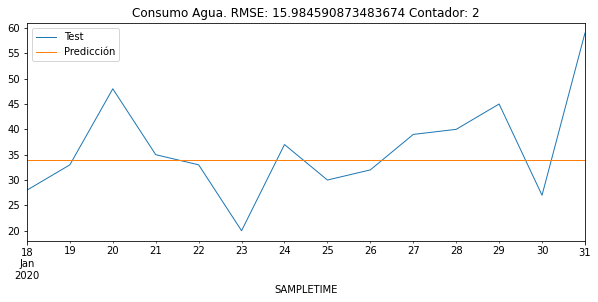

In [11]:
Proyecto.contadores[2].Predicciones
Proyecto.GraficasEstadisticas(contador=2,Test=True)

In [12]:
Proyecto.RMSE_Test_Promedio

655.9401191910985

In [13]:
Proyecto.RMSE_Test_Suma

1780877.4236038323

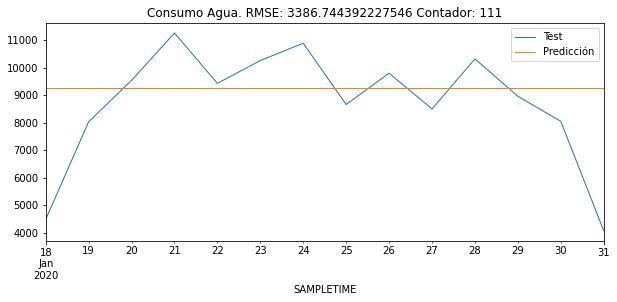

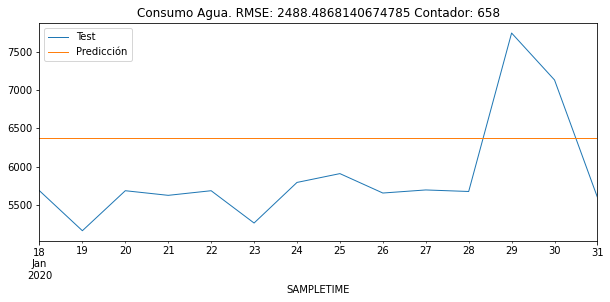

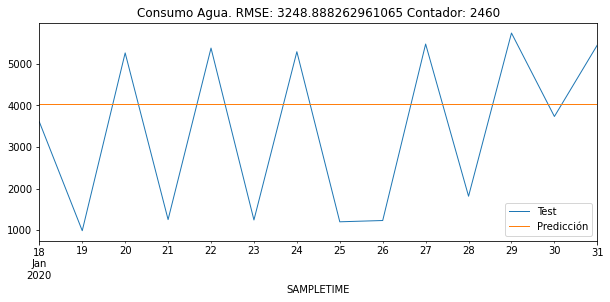

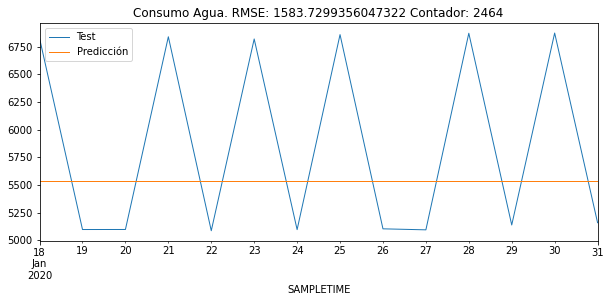

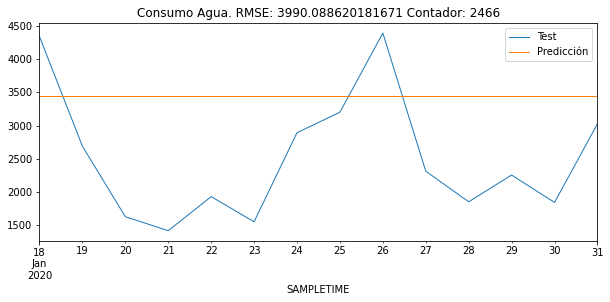

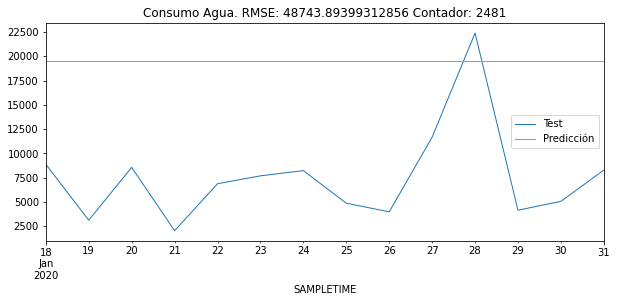

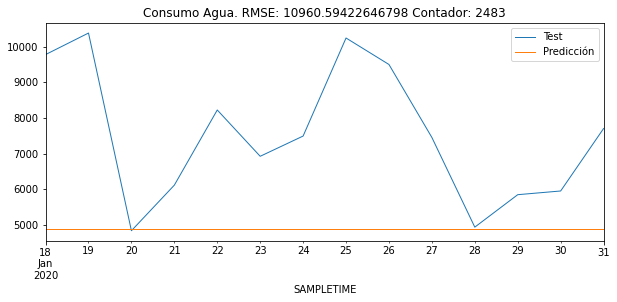

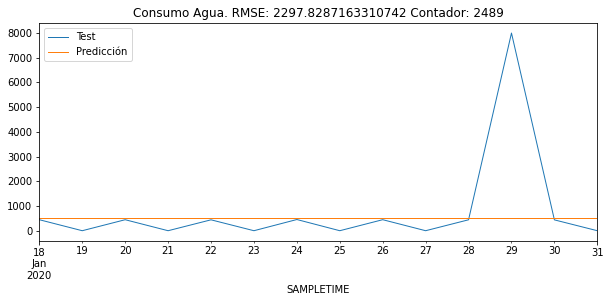

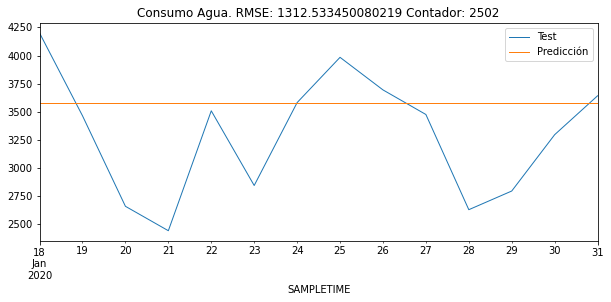

In [14]:
for ID in [111,658,2460,2464,2466,2481,2483,2489,2502]:
    Proyecto.GraficasEstadisticas(contador=ID)